In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (ResNet152)

2024-02-21 10:58:57.572171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 10:58:57.572264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 10:58:57.688538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(ResNet152(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("ResNet152"+s+".keras")
    

    # save model to disk
    filename = "ResNet152" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 resnet152 (Functional)      (None, 4)                 58379140  


Total params: 58379140 (222.70 MB)


Trainable params: 58227716 (222.12 MB)


Non-trainable params: 151424 (591.50 KB)


_________________________________________________________________


Epoch 1/30


I0000 00:00:1708513224.621655      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 4:02:34 - loss: 2.3840 - accuracy: 0.0000e+00

  2/140 [..............................] - ETA: 46s - loss: 3.8876 - accuracy: 0.2031        

  3/140 [..............................] - ETA: 45s - loss: 5.2479 - accuracy: 0.2396

  4/140 [..............................] - ETA: 45s - loss: 4.6679 - accuracy: 0.2266

  5/140 [>.............................] - ETA: 44s - loss: 4.0609 - accuracy: 0.3125

  6/140 [>.............................] - ETA: 44s - loss: 3.7491 - accuracy: 0.3542

  7/140 [>.............................] - ETA: 43s - loss: 3.7989 - accuracy: 0.3304

  8/140 [>.............................] - ETA: 43s - loss: 3.5820 - accuracy: 0.3359

  9/140 [>.............................] - ETA: 43s - loss: 3.3599 - accuracy: 0.3438

 10/140 [=>............................] - ETA: 42s - loss: 3.1804 - accuracy: 0.3500

 11/140 [=>............................] - ETA: 42s - loss: 3.0283 - accuracy: 0.3580

 12/140 [=>............................] - ETA: 42s - loss: 2.8882 - accuracy: 0.3516

 13/140 [=>............................] - ETA: 41s - loss: 2.7582 - accuracy: 0.3558

 14/140 [==>...........................] - ETA: 41s - loss: 2.6462 - accuracy: 0.3482

 15/140 [==>...........................] - ETA: 41s - loss: 2.5457 - accuracy: 0.3583

 16/140 [==>...........................] - ETA: 40s - loss: 2.4831 - accuracy: 0.3711

 17/140 [==>...........................] - ETA: 40s - loss: 2.4070 - accuracy: 0.3787

 18/140 [==>...........................] - ETA: 40s - loss: 2.3211 - accuracy: 0.3958

 19/140 [===>..........................] - ETA: 40s - loss: 2.2835 - accuracy: 0.3964

 20/140 [===>..........................] - ETA: 39s - loss: 2.2268 - accuracy: 0.3984

 21/140 [===>..........................] - ETA: 39s - loss: 2.1919 - accuracy: 0.3973

 22/140 [===>..........................] - ETA: 39s - loss: 2.1502 - accuracy: 0.4006

 23/140 [===>..........................] - ETA: 38s - loss: 2.1053 - accuracy: 0.4035

 24/140 [====>.........................] - ETA: 38s - loss: 2.0746 - accuracy: 0.4036

 25/140 [====>.........................] - ETA: 37s - loss: 2.0472 - accuracy: 0.4025

 26/140 [====>.........................] - ETA: 37s - loss: 2.0188 - accuracy: 0.3966

 27/140 [====>.........................] - ETA: 37s - loss: 1.9819 - accuracy: 0.3981

 28/140 [=====>........................] - ETA: 36s - loss: 1.9539 - accuracy: 0.3996

 29/140 [=====>........................] - ETA: 36s - loss: 1.9231 - accuracy: 0.3987

 30/140 [=====>........................] - ETA: 36s - loss: 1.8937 - accuracy: 0.3958

 31/140 [=====>........................] - ETA: 35s - loss: 1.8640 - accuracy: 0.4022

 32/140 [=====>........................] - ETA: 35s - loss: 1.8382 - accuracy: 0.4023

 33/140 [======>.......................] - ETA: 35s - loss: 1.8164 - accuracy: 0.4053

 34/140 [======>.......................] - ETA: 34s - loss: 1.8060 - accuracy: 0.4017

 35/140 [======>.......................] - ETA: 34s - loss: 1.7846 - accuracy: 0.4036

 36/140 [======>.......................] - ETA: 34s - loss: 1.7611 - accuracy: 0.4071

 37/140 [======>.......................] - ETA: 33s - loss: 1.7797 - accuracy: 0.4105

 38/140 [=======>......................] - ETA: 33s - loss: 1.7637 - accuracy: 0.4112

 39/140 [=======>......................] - ETA: 33s - loss: 1.7527 - accuracy: 0.4079

 40/140 [=======>......................] - ETA: 32s - loss: 1.7327 - accuracy: 0.4109

 41/140 [=======>......................] - ETA: 32s - loss: 1.7133 - accuracy: 0.4116

 42/140 [========>.....................] - ETA: 32s - loss: 1.6977 - accuracy: 0.4144

 43/140 [========>.....................] - ETA: 31s - loss: 1.6805 - accuracy: 0.4186

 44/140 [========>.....................] - ETA: 31s - loss: 1.6643 - accuracy: 0.4190

 45/140 [========>.....................] - ETA: 31s - loss: 1.6544 - accuracy: 0.4181

 46/140 [========>.....................] - ETA: 30s - loss: 1.6432 - accuracy: 0.4185

 47/140 [=========>....................] - ETA: 30s - loss: 1.6325 - accuracy: 0.4182

 48/140 [=========>....................] - ETA: 30s - loss: 1.6194 - accuracy: 0.4186

 49/140 [=========>....................] - ETA: 29s - loss: 1.6067 - accuracy: 0.4190

 50/140 [=========>....................] - ETA: 29s - loss: 1.5947 - accuracy: 0.4206

 51/140 [=========>....................] - ETA: 29s - loss: 1.5833 - accuracy: 0.4234

 52/140 [==========>...................] - ETA: 28s - loss: 1.5752 - accuracy: 0.4261

 53/140 [==========>...................] - ETA: 28s - loss: 1.5626 - accuracy: 0.4281

 54/140 [==========>...................] - ETA: 28s - loss: 1.5561 - accuracy: 0.4271

 55/140 [==========>...................] - ETA: 28s - loss: 1.5440 - accuracy: 0.4290

 56/140 [===========>..................] - ETA: 27s - loss: 1.5333 - accuracy: 0.4314

 57/140 [===========>..................] - ETA: 27s - loss: 1.5243 - accuracy: 0.4315

 58/140 [===========>..................] - ETA: 27s - loss: 1.5146 - accuracy: 0.4321

 59/140 [===========>..................] - ETA: 26s - loss: 1.5104 - accuracy: 0.4317

 60/140 [===========>..................] - ETA: 26s - loss: 1.5019 - accuracy: 0.4323

 61/140 [============>.................] - ETA: 26s - loss: 1.4905 - accuracy: 0.4360

 62/140 [============>.................] - ETA: 25s - loss: 1.4819 - accuracy: 0.4380

 63/140 [============>.................] - ETA: 25s - loss: 1.4753 - accuracy: 0.4415

 64/140 [============>.................] - ETA: 25s - loss: 1.4682 - accuracy: 0.4419

 65/140 [============>.................] - ETA: 24s - loss: 1.4633 - accuracy: 0.4442

 66/140 [=============>................] - ETA: 24s - loss: 1.4565 - accuracy: 0.4446

 67/140 [=============>................] - ETA: 24s - loss: 1.4508 - accuracy: 0.4454

 68/140 [=============>................] - ETA: 23s - loss: 1.4501 - accuracy: 0.4435

 69/140 [=============>................] - ETA: 23s - loss: 1.4486 - accuracy: 0.4434

 70/140 [==============>...............] - ETA: 23s - loss: 1.4431 - accuracy: 0.4437

 71/140 [==============>...............] - ETA: 22s - loss: 1.4392 - accuracy: 0.4437

 72/140 [==============>...............] - ETA: 22s - loss: 1.4355 - accuracy: 0.4427

 73/140 [==============>...............] - ETA: 22s - loss: 1.4297 - accuracy: 0.4409

 74/140 [==============>...............] - ETA: 21s - loss: 1.4252 - accuracy: 0.4417

 75/140 [===============>..............] - ETA: 21s - loss: 1.4195 - accuracy: 0.4429

 76/140 [===============>..............] - ETA: 21s - loss: 1.4130 - accuracy: 0.4428

 77/140 [===============>..............] - ETA: 20s - loss: 1.4077 - accuracy: 0.4456

 78/140 [===============>..............] - ETA: 20s - loss: 1.4049 - accuracy: 0.4467

 79/140 [===============>..............] - ETA: 20s - loss: 1.4078 - accuracy: 0.4446

 80/140 [================>.............] - ETA: 19s - loss: 1.4020 - accuracy: 0.4449

 81/140 [================>.............] - ETA: 19s - loss: 1.3962 - accuracy: 0.4464

 82/140 [================>.............] - ETA: 19s - loss: 1.3910 - accuracy: 0.4466

 83/140 [================>.............] - ETA: 18s - loss: 1.3883 - accuracy: 0.4469

 84/140 [=================>............] - ETA: 18s - loss: 1.3856 - accuracy: 0.4468

 85/140 [=================>............] - ETA: 18s - loss: 1.3820 - accuracy: 0.4478

 86/140 [=================>............] - ETA: 17s - loss: 1.3794 - accuracy: 0.4488

 87/140 [=================>............] - ETA: 17s - loss: 1.3770 - accuracy: 0.4494

 88/140 [=================>............] - ETA: 17s - loss: 1.3739 - accuracy: 0.4503

 89/140 [==================>...........] - ETA: 16s - loss: 1.3709 - accuracy: 0.4512

 90/140 [==================>...........] - ETA: 16s - loss: 1.3678 - accuracy: 0.4517

 91/140 [==================>...........] - ETA: 16s - loss: 1.3639 - accuracy: 0.4523

 92/140 [==================>...........] - ETA: 15s - loss: 1.3596 - accuracy: 0.4541

 93/140 [==================>...........] - ETA: 15s - loss: 1.3547 - accuracy: 0.4563

 94/140 [===================>..........] - ETA: 15s - loss: 1.3515 - accuracy: 0.4574

 95/140 [===================>..........] - ETA: 14s - loss: 1.3495 - accuracy: 0.4579

 96/140 [===================>..........] - ETA: 14s - loss: 1.3447 - accuracy: 0.4596

 97/140 [===================>..........] - ETA: 14s - loss: 1.3418 - accuracy: 0.4601

 98/140 [====================>.........] - ETA: 13s - loss: 1.3423 - accuracy: 0.4589

 99/140 [====================>.........] - ETA: 13s - loss: 1.3373 - accuracy: 0.4612

100/140 [====================>.........] - ETA: 13s - loss: 1.3356 - accuracy: 0.4603

101/140 [====================>.........] - ETA: 12s - loss: 1.3329 - accuracy: 0.4604

102/140 [====================>.........] - ETA: 12s - loss: 1.3286 - accuracy: 0.4614

103/140 [=====================>........] - ETA: 12s - loss: 1.3256 - accuracy: 0.4615

104/140 [=====================>........] - ETA: 11s - loss: 1.3220 - accuracy: 0.4624

105/140 [=====================>........] - ETA: 11s - loss: 1.3199 - accuracy: 0.4631

106/140 [=====================>........] - ETA: 11s - loss: 1.3155 - accuracy: 0.4649

107/140 [=====================>........] - ETA: 10s - loss: 1.3122 - accuracy: 0.4638

108/140 [======================>.......] - ETA: 10s - loss: 1.3107 - accuracy: 0.4638

109/140 [======================>.......] - ETA: 10s - loss: 1.3082 - accuracy: 0.4639

110/140 [======================>.......] - ETA: 9s - loss: 1.3065 - accuracy: 0.4634 

111/140 [======================>.......] - ETA: 9s - loss: 1.3036 - accuracy: 0.4626

112/140 [=======================>......] - ETA: 9s - loss: 1.3006 - accuracy: 0.4637

113/140 [=======================>......] - ETA: 8s - loss: 1.2971 - accuracy: 0.4638

114/140 [=======================>......] - ETA: 8s - loss: 1.2942 - accuracy: 0.4638

115/140 [=======================>......] - ETA: 8s - loss: 1.2924 - accuracy: 0.4649

116/140 [=======================>......] - ETA: 7s - loss: 1.2899 - accuracy: 0.4650

117/140 [========================>.....] - ETA: 7s - loss: 1.2892 - accuracy: 0.4655

118/140 [========================>.....] - ETA: 7s - loss: 1.2861 - accuracy: 0.4666

119/140 [========================>.....] - ETA: 6s - loss: 1.2830 - accuracy: 0.4672

120/140 [========================>.....] - ETA: 6s - loss: 1.2817 - accuracy: 0.4674

121/140 [========================>.....] - ETA: 6s - loss: 1.2793 - accuracy: 0.4677

122/140 [=========================>....] - ETA: 5s - loss: 1.2763 - accuracy: 0.4680

123/140 [=========================>....] - ETA: 5s - loss: 1.2730 - accuracy: 0.4690

124/140 [=========================>....] - ETA: 5s - loss: 1.2719 - accuracy: 0.4698

125/140 [=========================>....] - ETA: 4s - loss: 1.2693 - accuracy: 0.4700

126/140 [==========================>...] - ETA: 4s - loss: 1.2662 - accuracy: 0.4717

127/140 [==========================>...] - ETA: 4s - loss: 1.2646 - accuracy: 0.4712

128/140 [==========================>...] - ETA: 3s - loss: 1.2628 - accuracy: 0.4709

129/140 [==========================>...] - ETA: 3s - loss: 1.2605 - accuracy: 0.4717

130/140 [==========================>...] - ETA: 3s - loss: 1.2599 - accuracy: 0.4709

131/140 [===========================>..] - ETA: 2s - loss: 1.2583 - accuracy: 0.4702

132/140 [===========================>..] - ETA: 2s - loss: 1.2586 - accuracy: 0.4704

133/140 [===========================>..] - ETA: 2s - loss: 1.2562 - accuracy: 0.4711

134/140 [===========================>..] - ETA: 1s - loss: 1.2536 - accuracy: 0.4715

135/140 [===========================>..] - ETA: 1s - loss: 1.2523 - accuracy: 0.4718

136/140 [============================>.] - ETA: 1s - loss: 1.2514 - accuracy: 0.4708

137/140 [============================>.] - ETA: 0s - loss: 1.2485 - accuracy: 0.4710

138/140 [============================>.] - ETA: 0s - loss: 1.2465 - accuracy: 0.4706

139/140 [============================>.] - ETA: 0s - loss: 1.2452 - accuracy: 0.4705

140/140 [==============================] - ETA: 0s - loss: 1.2458 - accuracy: 0.4704

140/140 [==============================] - 160s 398ms/step - loss: 1.2458 - accuracy: 0.4704 - val_loss: 1.0910 - val_accuracy: 0.4926


Epoch 2/30


  1/140 [..............................] - ETA: 1:14 - loss: 1.1968 - accuracy: 0.5938

  2/140 [..............................] - ETA: 45s - loss: 1.1101 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 45s - loss: 1.0385 - accuracy: 0.5625

  4/140 [..............................] - ETA: 45s - loss: 1.0460 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 44s - loss: 1.0502 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 44s - loss: 1.0506 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 43s - loss: 1.0498 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 43s - loss: 1.0341 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 43s - loss: 1.0109 - accuracy: 0.5382

 10/140 [=>............................] - ETA: 42s - loss: 1.0364 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 42s - loss: 1.0313 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 42s - loss: 1.0211 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 41s - loss: 1.0438 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 41s - loss: 1.0377 - accuracy: 0.5156

 15/140 [==>...........................] - ETA: 41s - loss: 1.0183 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 41s - loss: 1.0022 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 40s - loss: 0.9910 - accuracy: 0.5368

 18/140 [==>...........................] - ETA: 40s - loss: 0.9999 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 40s - loss: 1.0116 - accuracy: 0.5345

 20/140 [===>..........................] - ETA: 39s - loss: 1.0117 - accuracy: 0.5312

 21/140 [===>..........................] - ETA: 39s - loss: 1.0079 - accuracy: 0.5357

 22/140 [===>..........................] - ETA: 39s - loss: 0.9986 - accuracy: 0.5412

 23/140 [===>..........................] - ETA: 38s - loss: 0.9986 - accuracy: 0.5380

 24/140 [====>.........................] - ETA: 38s - loss: 0.9924 - accuracy: 0.5378

 25/140 [====>.........................] - ETA: 38s - loss: 0.9994 - accuracy: 0.5312

 26/140 [====>.........................] - ETA: 37s - loss: 0.9938 - accuracy: 0.5312

 27/140 [====>.........................] - ETA: 37s - loss: 0.9956 - accuracy: 0.5301

 28/140 [=====>........................] - ETA: 37s - loss: 0.9969 - accuracy: 0.5312

 29/140 [=====>........................] - ETA: 36s - loss: 0.9962 - accuracy: 0.5248

 30/140 [=====>........................] - ETA: 36s - loss: 0.9987 - accuracy: 0.5188

 31/140 [=====>........................] - ETA: 36s - loss: 1.0028 - accuracy: 0.5161

 32/140 [=====>........................] - ETA: 35s - loss: 1.0111 - accuracy: 0.5146

 33/140 [======>.......................] - ETA: 35s - loss: 1.0095 - accuracy: 0.5180

 34/140 [======>.......................] - ETA: 35s - loss: 1.0098 - accuracy: 0.5193

 35/140 [======>.......................] - ETA: 34s - loss: 1.0059 - accuracy: 0.5214

 36/140 [======>.......................] - ETA: 34s - loss: 1.0060 - accuracy: 0.5243

 37/140 [======>.......................] - ETA: 34s - loss: 1.0056 - accuracy: 0.5270

 38/140 [=======>......................] - ETA: 33s - loss: 1.0058 - accuracy: 0.5271

 39/140 [=======>......................] - ETA: 33s - loss: 1.0066 - accuracy: 0.5272

 40/140 [=======>......................] - ETA: 33s - loss: 1.0030 - accuracy: 0.5273

 41/140 [=======>......................] - ETA: 32s - loss: 1.0031 - accuracy: 0.5290

 42/140 [========>.....................] - ETA: 32s - loss: 1.0040 - accuracy: 0.5283

 43/140 [========>.....................] - ETA: 32s - loss: 1.0009 - accuracy: 0.5276

 44/140 [========>.....................] - ETA: 31s - loss: 0.9950 - accuracy: 0.5327

 45/140 [========>.....................] - ETA: 31s - loss: 0.9963 - accuracy: 0.5333

 46/140 [========>.....................] - ETA: 31s - loss: 0.9965 - accuracy: 0.5326

 47/140 [=========>....................] - ETA: 30s - loss: 0.9964 - accuracy: 0.5352

 48/140 [=========>....................] - ETA: 30s - loss: 0.9964 - accuracy: 0.5352

 49/140 [=========>....................] - ETA: 30s - loss: 0.9920 - accuracy: 0.5383

 50/140 [=========>....................] - ETA: 29s - loss: 0.9863 - accuracy: 0.5419

 51/140 [=========>....................] - ETA: 29s - loss: 0.9915 - accuracy: 0.5386

 52/140 [==========>...................] - ETA: 29s - loss: 0.9904 - accuracy: 0.5385

 53/140 [==========>...................] - ETA: 28s - loss: 0.9856 - accuracy: 0.5401

 54/140 [==========>...................] - ETA: 28s - loss: 0.9844 - accuracy: 0.5394

 55/140 [==========>...................] - ETA: 28s - loss: 0.9870 - accuracy: 0.5364

 56/140 [===========>..................] - ETA: 27s - loss: 0.9842 - accuracy: 0.5379

 57/140 [===========>..................] - ETA: 27s - loss: 0.9849 - accuracy: 0.5373

 58/140 [===========>..................] - ETA: 27s - loss: 0.9815 - accuracy: 0.5393

 59/140 [===========>..................] - ETA: 26s - loss: 0.9804 - accuracy: 0.5392

 60/140 [===========>..................] - ETA: 26s - loss: 0.9803 - accuracy: 0.5406

 61/140 [============>.................] - ETA: 26s - loss: 0.9831 - accuracy: 0.5410

 62/140 [============>.................] - ETA: 25s - loss: 0.9816 - accuracy: 0.5418

 63/140 [============>.................] - ETA: 25s - loss: 0.9844 - accuracy: 0.5397

 64/140 [============>.................] - ETA: 25s - loss: 0.9822 - accuracy: 0.5410

 65/140 [============>.................] - ETA: 24s - loss: 0.9854 - accuracy: 0.5385

 66/140 [=============>................] - ETA: 24s - loss: 0.9905 - accuracy: 0.5374

 67/140 [=============>................] - ETA: 24s - loss: 0.9899 - accuracy: 0.5359

 68/140 [=============>................] - ETA: 23s - loss: 0.9890 - accuracy: 0.5368

 69/140 [=============>................] - ETA: 23s - loss: 0.9884 - accuracy: 0.5358

 70/140 [==============>...............] - ETA: 23s - loss: 0.9863 - accuracy: 0.5375

 71/140 [==============>...............] - ETA: 22s - loss: 0.9837 - accuracy: 0.5401

 72/140 [==============>...............] - ETA: 22s - loss: 0.9807 - accuracy: 0.5412

 73/140 [==============>...............] - ETA: 22s - loss: 0.9795 - accuracy: 0.5420

 74/140 [==============>...............] - ETA: 21s - loss: 0.9823 - accuracy: 0.5422

 75/140 [===============>..............] - ETA: 21s - loss: 0.9877 - accuracy: 0.5404

 76/140 [===============>..............] - ETA: 21s - loss: 0.9863 - accuracy: 0.5407

 77/140 [===============>..............] - ETA: 20s - loss: 0.9838 - accuracy: 0.5418

 78/140 [===============>..............] - ETA: 20s - loss: 0.9829 - accuracy: 0.5421

 79/140 [===============>..............] - ETA: 20s - loss: 0.9819 - accuracy: 0.5427

 80/140 [================>.............] - ETA: 19s - loss: 0.9819 - accuracy: 0.5422

 81/140 [================>.............] - ETA: 19s - loss: 0.9794 - accuracy: 0.5432

 82/140 [================>.............] - ETA: 19s - loss: 0.9767 - accuracy: 0.5431

 83/140 [================>.............] - ETA: 18s - loss: 0.9750 - accuracy: 0.5441

 84/140 [=================>............] - ETA: 18s - loss: 0.9739 - accuracy: 0.5446

 85/140 [=================>............] - ETA: 18s - loss: 0.9753 - accuracy: 0.5445

 86/140 [=================>............] - ETA: 17s - loss: 0.9743 - accuracy: 0.5447

 87/140 [=================>............] - ETA: 17s - loss: 0.9724 - accuracy: 0.5463

 88/140 [=================>............] - ETA: 17s - loss: 0.9710 - accuracy: 0.5469

 89/140 [==================>...........] - ETA: 16s - loss: 0.9717 - accuracy: 0.5471

 90/140 [==================>...........] - ETA: 16s - loss: 0.9700 - accuracy: 0.5479

 91/140 [==================>...........] - ETA: 16s - loss: 0.9702 - accuracy: 0.5470

 92/140 [==================>...........] - ETA: 15s - loss: 0.9696 - accuracy: 0.5465

 93/140 [==================>...........] - ETA: 15s - loss: 0.9696 - accuracy: 0.5457

 94/140 [===================>..........] - ETA: 15s - loss: 0.9699 - accuracy: 0.5465

 95/140 [===================>..........] - ETA: 14s - loss: 0.9695 - accuracy: 0.5474

 96/140 [===================>..........] - ETA: 14s - loss: 0.9664 - accuracy: 0.5495

 97/140 [===================>..........] - ETA: 14s - loss: 0.9672 - accuracy: 0.5486

 98/140 [====================>.........] - ETA: 13s - loss: 0.9668 - accuracy: 0.5488

 99/140 [====================>.........] - ETA: 13s - loss: 0.9698 - accuracy: 0.5473

100/140 [====================>.........] - ETA: 13s - loss: 0.9699 - accuracy: 0.5462

101/140 [====================>.........] - ETA: 12s - loss: 0.9699 - accuracy: 0.5470

102/140 [====================>.........] - ETA: 12s - loss: 0.9694 - accuracy: 0.5466

103/140 [=====================>........] - ETA: 12s - loss: 0.9690 - accuracy: 0.5467

104/140 [=====================>........] - ETA: 11s - loss: 0.9660 - accuracy: 0.5484

105/140 [=====================>........] - ETA: 11s - loss: 0.9642 - accuracy: 0.5494

106/140 [=====================>........] - ETA: 11s - loss: 0.9624 - accuracy: 0.5495

107/140 [=====================>........] - ETA: 10s - loss: 0.9615 - accuracy: 0.5499

108/140 [======================>.......] - ETA: 10s - loss: 0.9608 - accuracy: 0.5501

109/140 [======================>.......] - ETA: 10s - loss: 0.9616 - accuracy: 0.5499

110/140 [======================>.......] - ETA: 9s - loss: 0.9621 - accuracy: 0.5494 

111/140 [======================>.......] - ETA: 9s - loss: 0.9659 - accuracy: 0.5473

112/140 [=======================>......] - ETA: 9s - loss: 0.9670 - accuracy: 0.5466

113/140 [=======================>......] - ETA: 8s - loss: 0.9669 - accuracy: 0.5456

114/140 [=======================>......] - ETA: 8s - loss: 0.9685 - accuracy: 0.5450

115/140 [=======================>......] - ETA: 8s - loss: 0.9686 - accuracy: 0.5435

116/140 [=======================>......] - ETA: 7s - loss: 0.9692 - accuracy: 0.5428

117/140 [========================>.....] - ETA: 7s - loss: 0.9704 - accuracy: 0.5422

118/140 [========================>.....] - ETA: 7s - loss: 0.9696 - accuracy: 0.5424

119/140 [========================>.....] - ETA: 6s - loss: 0.9697 - accuracy: 0.5428

120/140 [========================>.....] - ETA: 6s - loss: 0.9687 - accuracy: 0.5437

121/140 [========================>.....] - ETA: 6s - loss: 0.9677 - accuracy: 0.5434

122/140 [=========================>....] - ETA: 5s - loss: 0.9715 - accuracy: 0.5420

123/140 [=========================>....] - ETA: 5s - loss: 0.9703 - accuracy: 0.5419

124/140 [=========================>....] - ETA: 5s - loss: 0.9704 - accuracy: 0.5428

125/140 [=========================>....] - ETA: 4s - loss: 0.9705 - accuracy: 0.5420

126/140 [==========================>...] - ETA: 4s - loss: 0.9730 - accuracy: 0.5407

127/140 [==========================>...] - ETA: 4s - loss: 0.9721 - accuracy: 0.5408

128/140 [==========================>...] - ETA: 3s - loss: 0.9713 - accuracy: 0.5405

129/140 [==========================>...] - ETA: 3s - loss: 0.9710 - accuracy: 0.5400

130/140 [==========================>...] - ETA: 3s - loss: 0.9707 - accuracy: 0.5397

131/140 [===========================>..] - ETA: 2s - loss: 0.9706 - accuracy: 0.5398

132/140 [===========================>..] - ETA: 2s - loss: 0.9699 - accuracy: 0.5395

133/140 [===========================>..] - ETA: 2s - loss: 0.9695 - accuracy: 0.5409

134/140 [===========================>..] - ETA: 1s - loss: 0.9692 - accuracy: 0.5406

135/140 [===========================>..] - ETA: 1s - loss: 0.9673 - accuracy: 0.5414

136/140 [============================>.] - ETA: 1s - loss: 0.9657 - accuracy: 0.5423

137/140 [============================>.] - ETA: 0s - loss: 0.9668 - accuracy: 0.5420

138/140 [============================>.] - ETA: 0s - loss: 0.9661 - accuracy: 0.5426

139/140 [============================>.] - ETA: 0s - loss: 0.9654 - accuracy: 0.5425

140/140 [==============================] - ETA: 0s - loss: 0.9659 - accuracy: 0.5422

140/140 [==============================] - 50s 359ms/step - loss: 0.9659 - accuracy: 0.5422 - val_loss: 2.5352 - val_accuracy: 0.5223


Epoch 3/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.7062 - accuracy: 0.6875

  2/140 [..............................] - ETA: 45s - loss: 0.8445 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 45s - loss: 0.8385 - accuracy: 0.6146

  4/140 [..............................] - ETA: 44s - loss: 0.8232 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 44s - loss: 0.8337 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 44s - loss: 0.9440 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 43s - loss: 0.9682 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 43s - loss: 0.9856 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 43s - loss: 0.9446 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 42s - loss: 0.9524 - accuracy: 0.5969

 11/140 [=>............................] - ETA: 42s - loss: 0.9588 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 42s - loss: 0.9737 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 42s - loss: 0.9891 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 41s - loss: 1.0143 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 41s - loss: 1.0444 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 41s - loss: 1.0412 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 40s - loss: 1.0499 - accuracy: 0.5423

 18/140 [==>...........................] - ETA: 40s - loss: 1.0556 - accuracy: 0.5451

 19/140 [===>..........................] - ETA: 40s - loss: 1.0470 - accuracy: 0.5477

 20/140 [===>..........................] - ETA: 39s - loss: 1.0451 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 39s - loss: 1.0381 - accuracy: 0.5476

 22/140 [===>..........................] - ETA: 39s - loss: 1.0304 - accuracy: 0.5497

 23/140 [===>..........................] - ETA: 38s - loss: 1.0232 - accuracy: 0.5489

 24/140 [====>.........................] - ETA: 38s - loss: 1.0379 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 38s - loss: 1.0292 - accuracy: 0.5450

 26/140 [====>.........................] - ETA: 37s - loss: 1.0360 - accuracy: 0.5409

 27/140 [====>.........................] - ETA: 37s - loss: 1.0362 - accuracy: 0.5394

 28/140 [=====>........................] - ETA: 37s - loss: 1.0369 - accuracy: 0.5357

 29/140 [=====>........................] - ETA: 36s - loss: 1.0298 - accuracy: 0.5366

 30/140 [=====>........................] - ETA: 36s - loss: 1.0271 - accuracy: 0.5344

 31/140 [=====>........................] - ETA: 36s - loss: 1.0244 - accuracy: 0.5353

 32/140 [=====>........................] - ETA: 35s - loss: 1.0218 - accuracy: 0.5352

 33/140 [======>.......................] - ETA: 35s - loss: 1.0232 - accuracy: 0.5360

 34/140 [======>.......................] - ETA: 35s - loss: 1.0223 - accuracy: 0.5331

 35/140 [======>.......................] - ETA: 34s - loss: 1.0184 - accuracy: 0.5366

 36/140 [======>.......................] - ETA: 34s - loss: 1.0212 - accuracy: 0.5330

 37/140 [======>.......................] - ETA: 34s - loss: 1.0126 - accuracy: 0.5372

 38/140 [=======>......................] - ETA: 33s - loss: 1.0126 - accuracy: 0.5354

 39/140 [=======>......................] - ETA: 33s - loss: 1.0070 - accuracy: 0.5361

 40/140 [=======>......................] - ETA: 33s - loss: 1.0017 - accuracy: 0.5391

 41/140 [=======>......................] - ETA: 32s - loss: 1.0341 - accuracy: 0.5396

 42/140 [========>.....................] - ETA: 32s - loss: 1.0299 - accuracy: 0.5402

 43/140 [========>.....................] - ETA: 32s - loss: 1.0298 - accuracy: 0.5371

 44/140 [========>.....................] - ETA: 31s - loss: 1.0224 - accuracy: 0.5412

 45/140 [========>.....................] - ETA: 31s - loss: 1.0172 - accuracy: 0.5458

 46/140 [========>.....................] - ETA: 31s - loss: 1.0136 - accuracy: 0.5469

 47/140 [=========>....................] - ETA: 30s - loss: 1.0121 - accuracy: 0.5465

 48/140 [=========>....................] - ETA: 30s - loss: 1.0100 - accuracy: 0.5443

 49/140 [=========>....................] - ETA: 30s - loss: 1.0069 - accuracy: 0.5440

 50/140 [=========>....................] - ETA: 29s - loss: 1.0016 - accuracy: 0.5469

 51/140 [=========>....................] - ETA: 29s - loss: 0.9971 - accuracy: 0.5490

 52/140 [==========>...................] - ETA: 29s - loss: 0.9969 - accuracy: 0.5481

 53/140 [==========>...................] - ETA: 28s - loss: 0.9981 - accuracy: 0.5495

 54/140 [==========>...................] - ETA: 28s - loss: 0.9944 - accuracy: 0.5521

 55/140 [==========>...................] - ETA: 28s - loss: 0.9919 - accuracy: 0.5528

 56/140 [===========>..................] - ETA: 27s - loss: 0.9883 - accuracy: 0.5558

 57/140 [===========>..................] - ETA: 27s - loss: 0.9852 - accuracy: 0.5587

 58/140 [===========>..................] - ETA: 27s - loss: 0.9822 - accuracy: 0.5593

 59/140 [===========>..................] - ETA: 26s - loss: 0.9880 - accuracy: 0.5593

 60/140 [===========>..................] - ETA: 26s - loss: 0.9884 - accuracy: 0.5583

 61/140 [============>.................] - ETA: 26s - loss: 0.9862 - accuracy: 0.5594

 62/140 [============>.................] - ETA: 25s - loss: 0.9885 - accuracy: 0.5580

 63/140 [============>.................] - ETA: 25s - loss: 0.9956 - accuracy: 0.5575

 64/140 [============>.................] - ETA: 25s - loss: 0.9963 - accuracy: 0.5566

 65/140 [============>.................] - ETA: 24s - loss: 0.9934 - accuracy: 0.5567

 66/140 [=============>................] - ETA: 24s - loss: 0.9902 - accuracy: 0.5573

 67/140 [=============>................] - ETA: 24s - loss: 0.9880 - accuracy: 0.5578

 68/140 [=============>................] - ETA: 23s - loss: 0.9849 - accuracy: 0.5593

 69/140 [=============>................] - ETA: 23s - loss: 0.9825 - accuracy: 0.5611

 70/140 [==============>...............] - ETA: 23s - loss: 0.9805 - accuracy: 0.5612

 71/140 [==============>...............] - ETA: 22s - loss: 0.9774 - accuracy: 0.5616

 72/140 [==============>...............] - ETA: 22s - loss: 0.9768 - accuracy: 0.5625

 73/140 [==============>...............] - ETA: 22s - loss: 0.9716 - accuracy: 0.5651

 74/140 [==============>...............] - ETA: 21s - loss: 0.9715 - accuracy: 0.5667

 75/140 [===============>..............] - ETA: 21s - loss: 0.9719 - accuracy: 0.5671

 76/140 [===============>..............] - ETA: 21s - loss: 0.9695 - accuracy: 0.5683

 77/140 [===============>..............] - ETA: 20s - loss: 0.9713 - accuracy: 0.5678

 78/140 [===============>..............] - ETA: 20s - loss: 0.9725 - accuracy: 0.5661

 79/140 [===============>..............] - ETA: 20s - loss: 0.9693 - accuracy: 0.5676

 80/140 [================>.............] - ETA: 19s - loss: 0.9698 - accuracy: 0.5664

 81/140 [================>.............] - ETA: 19s - loss: 0.9676 - accuracy: 0.5667

 82/140 [================>.............] - ETA: 19s - loss: 0.9649 - accuracy: 0.5682

 83/140 [================>.............] - ETA: 18s - loss: 0.9621 - accuracy: 0.5685

 84/140 [=================>............] - ETA: 18s - loss: 0.9633 - accuracy: 0.5677

 85/140 [=================>............] - ETA: 18s - loss: 0.9622 - accuracy: 0.5684

 86/140 [=================>............] - ETA: 17s - loss: 0.9607 - accuracy: 0.5694

 87/140 [=================>............] - ETA: 17s - loss: 0.9611 - accuracy: 0.5693

 88/140 [=================>............] - ETA: 17s - loss: 0.9596 - accuracy: 0.5685

 89/140 [==================>...........] - ETA: 16s - loss: 0.9576 - accuracy: 0.5692

 90/140 [==================>...........] - ETA: 16s - loss: 0.9577 - accuracy: 0.5691

 91/140 [==================>...........] - ETA: 16s - loss: 0.9582 - accuracy: 0.5690

 92/140 [==================>...........] - ETA: 15s - loss: 0.9585 - accuracy: 0.5686

 93/140 [==================>...........] - ETA: 15s - loss: 0.9553 - accuracy: 0.5699

 94/140 [===================>..........] - ETA: 15s - loss: 0.9554 - accuracy: 0.5698

 95/140 [===================>..........] - ETA: 14s - loss: 0.9535 - accuracy: 0.5714

 96/140 [===================>..........] - ETA: 14s - loss: 0.9531 - accuracy: 0.5713

 97/140 [===================>..........] - ETA: 14s - loss: 0.9505 - accuracy: 0.5731

 98/140 [====================>.........] - ETA: 13s - loss: 0.9477 - accuracy: 0.5737

 99/140 [====================>.........] - ETA: 13s - loss: 0.9459 - accuracy: 0.5735

100/140 [====================>.........] - ETA: 13s - loss: 0.9431 - accuracy: 0.5744

101/140 [====================>.........] - ETA: 12s - loss: 0.9411 - accuracy: 0.5736

102/140 [====================>.........] - ETA: 12s - loss: 0.9410 - accuracy: 0.5735

103/140 [=====================>........] - ETA: 12s - loss: 0.9403 - accuracy: 0.5731

104/140 [=====================>........] - ETA: 11s - loss: 0.9385 - accuracy: 0.5748

105/140 [=====================>........] - ETA: 11s - loss: 0.9360 - accuracy: 0.5750

106/140 [=====================>........] - ETA: 11s - loss: 0.9344 - accuracy: 0.5752

107/140 [=====================>........] - ETA: 10s - loss: 0.9335 - accuracy: 0.5762

108/140 [======================>.......] - ETA: 10s - loss: 0.9317 - accuracy: 0.5764

109/140 [======================>.......] - ETA: 10s - loss: 0.9312 - accuracy: 0.5760

110/140 [======================>.......] - ETA: 9s - loss: 0.9288 - accuracy: 0.5770 

111/140 [======================>.......] - ETA: 9s - loss: 0.9273 - accuracy: 0.5780

112/140 [=======================>......] - ETA: 9s - loss: 0.9275 - accuracy: 0.5778

113/140 [=======================>......] - ETA: 8s - loss: 0.9261 - accuracy: 0.5785

114/140 [=======================>......] - ETA: 8s - loss: 0.9255 - accuracy: 0.5789

115/140 [=======================>......] - ETA: 8s - loss: 0.9263 - accuracy: 0.5788

116/140 [=======================>......] - ETA: 7s - loss: 0.9257 - accuracy: 0.5792

117/140 [========================>.....] - ETA: 7s - loss: 0.9253 - accuracy: 0.5788

118/140 [========================>.....] - ETA: 7s - loss: 0.9231 - accuracy: 0.5797

119/140 [========================>.....] - ETA: 6s - loss: 0.9232 - accuracy: 0.5785

120/140 [========================>.....] - ETA: 6s - loss: 0.9257 - accuracy: 0.5779

121/140 [========================>.....] - ETA: 6s - loss: 0.9253 - accuracy: 0.5777

122/140 [=========================>....] - ETA: 5s - loss: 0.9243 - accuracy: 0.5786

123/140 [=========================>....] - ETA: 5s - loss: 0.9237 - accuracy: 0.5795

124/140 [=========================>....] - ETA: 5s - loss: 0.9244 - accuracy: 0.5794

125/140 [=========================>....] - ETA: 4s - loss: 0.9247 - accuracy: 0.5780

126/140 [==========================>...] - ETA: 4s - loss: 0.9235 - accuracy: 0.5789

127/140 [==========================>...] - ETA: 4s - loss: 0.9237 - accuracy: 0.5782

128/140 [==========================>...] - ETA: 3s - loss: 0.9238 - accuracy: 0.5769

129/140 [==========================>...] - ETA: 3s - loss: 0.9244 - accuracy: 0.5778

130/140 [==========================>...] - ETA: 3s - loss: 0.9251 - accuracy: 0.5779

131/140 [===========================>..] - ETA: 2s - loss: 0.9238 - accuracy: 0.5787

132/140 [===========================>..] - ETA: 2s - loss: 0.9221 - accuracy: 0.5795

133/140 [===========================>..] - ETA: 2s - loss: 0.9207 - accuracy: 0.5799

134/140 [===========================>..] - ETA: 1s - loss: 0.9201 - accuracy: 0.5800

135/140 [===========================>..] - ETA: 1s - loss: 0.9204 - accuracy: 0.5806

136/140 [============================>.] - ETA: 1s - loss: 0.9191 - accuracy: 0.5807

137/140 [============================>.] - ETA: 0s - loss: 0.9174 - accuracy: 0.5814

138/140 [============================>.] - ETA: 0s - loss: 0.9156 - accuracy: 0.5820

139/140 [============================>.] - ETA: 0s - loss: 0.9164 - accuracy: 0.5821

140/140 [==============================] - ETA: 0s - loss: 0.9172 - accuracy: 0.5817

140/140 [==============================] - 50s 358ms/step - loss: 0.9172 - accuracy: 0.5817 - val_loss: 1.2473 - val_accuracy: 0.3964


Epoch 4/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.7538 - accuracy: 0.5625

  2/140 [..............................] - ETA: 45s - loss: 0.7039 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 45s - loss: 0.8077 - accuracy: 0.5938

  4/140 [..............................] - ETA: 45s - loss: 0.8235 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 44s - loss: 0.8096 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 44s - loss: 0.8125 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 43s - loss: 0.8110 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 43s - loss: 0.8067 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 43s - loss: 0.8020 - accuracy: 0.6319

 10/140 [=>............................] - ETA: 42s - loss: 0.8895 - accuracy: 0.6125

 11/140 [=>............................] - ETA: 42s - loss: 0.8785 - accuracy: 0.6136

 12/140 [=>............................] - ETA: 42s - loss: 0.8999 - accuracy: 0.6068

 13/140 [=>............................] - ETA: 41s - loss: 0.8820 - accuracy: 0.6106

 14/140 [==>...........................] - ETA: 41s - loss: 0.8961 - accuracy: 0.6027

 15/140 [==>...........................] - ETA: 41s - loss: 0.8910 - accuracy: 0.6042

 16/140 [==>...........................] - ETA: 40s - loss: 0.8748 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 40s - loss: 0.8707 - accuracy: 0.6140

 18/140 [==>...........................] - ETA: 40s - loss: 0.8650 - accuracy: 0.6128

 19/140 [===>..........................] - ETA: 40s - loss: 0.8745 - accuracy: 0.6086

 20/140 [===>..........................] - ETA: 39s - loss: 0.8761 - accuracy: 0.6109

 21/140 [===>..........................] - ETA: 39s - loss: 0.8761 - accuracy: 0.6161

 22/140 [===>..........................] - ETA: 39s - loss: 0.8688 - accuracy: 0.6179

 23/140 [===>..........................] - ETA: 38s - loss: 0.8655 - accuracy: 0.6155

 24/140 [====>.........................] - ETA: 38s - loss: 0.8691 - accuracy: 0.6120

 25/140 [====>.........................] - ETA: 38s - loss: 0.8643 - accuracy: 0.6137

 26/140 [====>.........................] - ETA: 37s - loss: 0.8580 - accuracy: 0.6166

 27/140 [====>.........................] - ETA: 37s - loss: 0.8580 - accuracy: 0.6157

 28/140 [=====>........................] - ETA: 36s - loss: 0.8519 - accuracy: 0.6194

 29/140 [=====>........................] - ETA: 36s - loss: 0.8458 - accuracy: 0.6207

 30/140 [=====>........................] - ETA: 36s - loss: 0.8448 - accuracy: 0.6229

 31/140 [=====>........................] - ETA: 35s - loss: 0.8496 - accuracy: 0.6190

 32/140 [=====>........................] - ETA: 35s - loss: 0.8556 - accuracy: 0.6172

 33/140 [======>.......................] - ETA: 35s - loss: 0.8505 - accuracy: 0.6184

 34/140 [======>.......................] - ETA: 34s - loss: 0.8516 - accuracy: 0.6149

 35/140 [======>.......................] - ETA: 34s - loss: 0.8520 - accuracy: 0.6170

 36/140 [======>.......................] - ETA: 34s - loss: 0.8470 - accuracy: 0.6198

 37/140 [======>.......................] - ETA: 34s - loss: 0.8432 - accuracy: 0.6225

 38/140 [=======>......................] - ETA: 33s - loss: 0.8482 - accuracy: 0.6201

 39/140 [=======>......................] - ETA: 33s - loss: 0.8436 - accuracy: 0.6194

 40/140 [=======>......................] - ETA: 33s - loss: 0.8433 - accuracy: 0.6164

 41/140 [=======>......................] - ETA: 32s - loss: 0.8390 - accuracy: 0.6197

 42/140 [========>.....................] - ETA: 32s - loss: 0.8358 - accuracy: 0.6220

 43/140 [========>.....................] - ETA: 32s - loss: 0.8345 - accuracy: 0.6228

 44/140 [========>.....................] - ETA: 31s - loss: 0.8303 - accuracy: 0.6257

 45/140 [========>.....................] - ETA: 31s - loss: 0.8310 - accuracy: 0.6264

 46/140 [========>.....................] - ETA: 31s - loss: 0.8315 - accuracy: 0.6250

 47/140 [=========>....................] - ETA: 30s - loss: 0.8304 - accuracy: 0.6250

 48/140 [=========>....................] - ETA: 30s - loss: 0.8287 - accuracy: 0.6263

 49/140 [=========>....................] - ETA: 30s - loss: 0.8288 - accuracy: 0.6256

 50/140 [=========>....................] - ETA: 29s - loss: 0.8321 - accuracy: 0.6244

 51/140 [=========>....................] - ETA: 29s - loss: 0.8303 - accuracy: 0.6250

 52/140 [==========>...................] - ETA: 29s - loss: 0.8241 - accuracy: 0.6268

 53/140 [==========>...................] - ETA: 28s - loss: 0.8286 - accuracy: 0.6250

 54/140 [==========>...................] - ETA: 28s - loss: 0.8250 - accuracy: 0.6256

 55/140 [==========>...................] - ETA: 28s - loss: 0.8224 - accuracy: 0.6273

 56/140 [===========>..................] - ETA: 27s - loss: 0.8211 - accuracy: 0.6267

 57/140 [===========>..................] - ETA: 27s - loss: 0.8184 - accuracy: 0.6277

 58/140 [===========>..................] - ETA: 27s - loss: 0.8167 - accuracy: 0.6293

 59/140 [===========>..................] - ETA: 26s - loss: 0.8148 - accuracy: 0.6292

 60/140 [===========>..................] - ETA: 26s - loss: 0.8124 - accuracy: 0.6307

 61/140 [============>.................] - ETA: 26s - loss: 0.8109 - accuracy: 0.6322

 62/140 [============>.................] - ETA: 25s - loss: 0.8139 - accuracy: 0.6305

 63/140 [============>.................] - ETA: 25s - loss: 0.8148 - accuracy: 0.6295

 64/140 [============>.................] - ETA: 25s - loss: 0.8152 - accuracy: 0.6299

 65/140 [============>.................] - ETA: 24s - loss: 0.8125 - accuracy: 0.6313

 66/140 [=============>................] - ETA: 24s - loss: 0.8115 - accuracy: 0.6326

 67/140 [=============>................] - ETA: 24s - loss: 0.8098 - accuracy: 0.6343

 68/140 [=============>................] - ETA: 23s - loss: 0.8128 - accuracy: 0.6360

 69/140 [=============>................] - ETA: 23s - loss: 0.8153 - accuracy: 0.6354

 70/140 [==============>...............] - ETA: 23s - loss: 0.8138 - accuracy: 0.6357

 71/140 [==============>...............] - ETA: 22s - loss: 0.8147 - accuracy: 0.6347

 72/140 [==============>...............] - ETA: 22s - loss: 0.8123 - accuracy: 0.6363

 73/140 [==============>...............] - ETA: 22s - loss: 0.8111 - accuracy: 0.6366

 74/140 [==============>...............] - ETA: 21s - loss: 0.8117 - accuracy: 0.6360

 75/140 [===============>..............] - ETA: 21s - loss: 0.8100 - accuracy: 0.6367

 76/140 [===============>..............] - ETA: 21s - loss: 0.8076 - accuracy: 0.6365

 77/140 [===============>..............] - ETA: 20s - loss: 0.8047 - accuracy: 0.6376

 78/140 [===============>..............] - ETA: 20s - loss: 0.8031 - accuracy: 0.6382

 79/140 [===============>..............] - ETA: 20s - loss: 0.8012 - accuracy: 0.6388

 80/140 [================>.............] - ETA: 19s - loss: 0.7983 - accuracy: 0.6410

 81/140 [================>.............] - ETA: 19s - loss: 0.7979 - accuracy: 0.6404

 82/140 [================>.............] - ETA: 19s - loss: 0.7954 - accuracy: 0.6414

 83/140 [================>.............] - ETA: 18s - loss: 0.7954 - accuracy: 0.6401

 84/140 [=================>............] - ETA: 18s - loss: 0.7925 - accuracy: 0.6417

 85/140 [=================>............] - ETA: 18s - loss: 0.7884 - accuracy: 0.6441

 86/140 [=================>............] - ETA: 17s - loss: 0.7853 - accuracy: 0.6457

 87/140 [=================>............] - ETA: 17s - loss: 0.7857 - accuracy: 0.6466

 88/140 [=================>............] - ETA: 17s - loss: 0.7832 - accuracy: 0.6481

 89/140 [==================>...........] - ETA: 16s - loss: 0.7802 - accuracy: 0.6496

 90/140 [==================>...........] - ETA: 16s - loss: 0.7787 - accuracy: 0.6507

 91/140 [==================>...........] - ETA: 16s - loss: 0.7748 - accuracy: 0.6521

 92/140 [==================>...........] - ETA: 15s - loss: 0.7739 - accuracy: 0.6529

 93/140 [==================>...........] - ETA: 15s - loss: 0.7739 - accuracy: 0.6539

 94/140 [===================>..........] - ETA: 15s - loss: 0.7739 - accuracy: 0.6539

 95/140 [===================>..........] - ETA: 14s - loss: 0.7730 - accuracy: 0.6546

 96/140 [===================>..........] - ETA: 14s - loss: 0.7757 - accuracy: 0.6543

 97/140 [===================>..........] - ETA: 14s - loss: 0.7736 - accuracy: 0.6553

 98/140 [====================>.........] - ETA: 13s - loss: 0.7738 - accuracy: 0.6553

 99/140 [====================>.........] - ETA: 13s - loss: 0.7737 - accuracy: 0.6556

100/140 [====================>.........] - ETA: 13s - loss: 0.7732 - accuracy: 0.6559

101/140 [====================>.........] - ETA: 12s - loss: 0.7740 - accuracy: 0.6556

102/140 [====================>.........] - ETA: 12s - loss: 0.7739 - accuracy: 0.6562

103/140 [=====================>........] - ETA: 12s - loss: 0.7734 - accuracy: 0.6569

104/140 [=====================>........] - ETA: 11s - loss: 0.7726 - accuracy: 0.6584

105/140 [=====================>........] - ETA: 11s - loss: 0.7706 - accuracy: 0.6598

106/140 [=====================>........] - ETA: 11s - loss: 0.7694 - accuracy: 0.6598

107/140 [=====================>........] - ETA: 10s - loss: 0.7697 - accuracy: 0.6595

108/140 [======================>.......] - ETA: 10s - loss: 0.7701 - accuracy: 0.6577

109/140 [======================>.......] - ETA: 10s - loss: 0.7691 - accuracy: 0.6577

110/140 [======================>.......] - ETA: 9s - loss: 0.7689 - accuracy: 0.6574 

111/140 [======================>.......] - ETA: 9s - loss: 0.7681 - accuracy: 0.6579

112/140 [=======================>......] - ETA: 9s - loss: 0.7659 - accuracy: 0.6588

113/140 [=======================>......] - ETA: 8s - loss: 0.7662 - accuracy: 0.6585

114/140 [=======================>......] - ETA: 8s - loss: 0.7651 - accuracy: 0.6584

115/140 [=======================>......] - ETA: 8s - loss: 0.7656 - accuracy: 0.6576

116/140 [=======================>......] - ETA: 7s - loss: 0.7641 - accuracy: 0.6576

117/140 [========================>.....] - ETA: 7s - loss: 0.7632 - accuracy: 0.6584

118/140 [========================>.....] - ETA: 7s - loss: 0.7641 - accuracy: 0.6578

119/140 [========================>.....] - ETA: 6s - loss: 0.7620 - accuracy: 0.6584

120/140 [========================>.....] - ETA: 6s - loss: 0.7611 - accuracy: 0.6586

121/140 [========================>.....] - ETA: 6s - loss: 0.7611 - accuracy: 0.6591

122/140 [=========================>....] - ETA: 5s - loss: 0.7608 - accuracy: 0.6593

123/140 [=========================>....] - ETA: 5s - loss: 0.7614 - accuracy: 0.6590

124/140 [=========================>....] - ETA: 5s - loss: 0.7586 - accuracy: 0.6603

125/140 [=========================>....] - ETA: 4s - loss: 0.7574 - accuracy: 0.6607

126/140 [==========================>...] - ETA: 4s - loss: 0.7583 - accuracy: 0.6610

127/140 [==========================>...] - ETA: 4s - loss: 0.7589 - accuracy: 0.6604

128/140 [==========================>...] - ETA: 3s - loss: 0.7567 - accuracy: 0.6614

129/140 [==========================>...] - ETA: 3s - loss: 0.7552 - accuracy: 0.6625

130/140 [==========================>...] - ETA: 3s - loss: 0.7529 - accuracy: 0.6642

131/140 [===========================>..] - ETA: 2s - loss: 0.7523 - accuracy: 0.6644

132/140 [===========================>..] - ETA: 2s - loss: 0.7512 - accuracy: 0.6650

133/140 [===========================>..] - ETA: 2s - loss: 0.7522 - accuracy: 0.6638

134/140 [===========================>..] - ETA: 1s - loss: 0.7513 - accuracy: 0.6646

135/140 [===========================>..] - ETA: 1s - loss: 0.7489 - accuracy: 0.6662

136/140 [============================>.] - ETA: 1s - loss: 0.7464 - accuracy: 0.6677

137/140 [============================>.] - ETA: 0s - loss: 0.7471 - accuracy: 0.6674

138/140 [============================>.] - ETA: 0s - loss: 0.7451 - accuracy: 0.6685

139/140 [============================>.] - ETA: 0s - loss: 0.7433 - accuracy: 0.6693

140/140 [==============================] - ETA: 0s - loss: 0.7430 - accuracy: 0.6697

140/140 [==============================] - 50s 358ms/step - loss: 0.7430 - accuracy: 0.6697 - val_loss: 1.8824 - val_accuracy: 0.5051


Epoch 5/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.7431 - accuracy: 0.6875

  2/140 [..............................] - ETA: 45s - loss: 0.6973 - accuracy: 0.7344 

  3/140 [..............................] - ETA: 45s - loss: 0.6578 - accuracy: 0.7396

  4/140 [..............................] - ETA: 44s - loss: 0.6810 - accuracy: 0.7266

  5/140 [>.............................] - ETA: 44s - loss: 0.6873 - accuracy: 0.7063

  6/140 [>.............................] - ETA: 44s - loss: 0.6580 - accuracy: 0.7240

  7/140 [>.............................] - ETA: 43s - loss: 0.6597 - accuracy: 0.7277

  8/140 [>.............................] - ETA: 43s - loss: 0.6903 - accuracy: 0.7188

  9/140 [>.............................] - ETA: 43s - loss: 0.7124 - accuracy: 0.7014

 10/140 [=>............................] - ETA: 42s - loss: 0.6953 - accuracy: 0.6969

 11/140 [=>............................] - ETA: 42s - loss: 0.7059 - accuracy: 0.6903

 12/140 [=>............................] - ETA: 42s - loss: 0.6953 - accuracy: 0.7005

 13/140 [=>............................] - ETA: 41s - loss: 0.6852 - accuracy: 0.7043

 14/140 [==>...........................] - ETA: 41s - loss: 0.6896 - accuracy: 0.7031

 15/140 [==>...........................] - ETA: 41s - loss: 0.7004 - accuracy: 0.6958

 16/140 [==>...........................] - ETA: 40s - loss: 0.6971 - accuracy: 0.6973

 17/140 [==>...........................] - ETA: 40s - loss: 0.6933 - accuracy: 0.7022

 18/140 [==>...........................] - ETA: 40s - loss: 0.6781 - accuracy: 0.7101

 19/140 [===>..........................] - ETA: 39s - loss: 0.6787 - accuracy: 0.7039

 20/140 [===>..........................] - ETA: 39s - loss: 0.6862 - accuracy: 0.7031

 21/140 [===>..........................] - ETA: 39s - loss: 0.6907 - accuracy: 0.6949

 22/140 [===>..........................] - ETA: 39s - loss: 0.6958 - accuracy: 0.6889

 23/140 [===>..........................] - ETA: 38s - loss: 0.6860 - accuracy: 0.6970

 24/140 [====>.........................] - ETA: 38s - loss: 0.6900 - accuracy: 0.7018

 25/140 [====>.........................] - ETA: 38s - loss: 0.6909 - accuracy: 0.7013

 26/140 [====>.........................] - ETA: 37s - loss: 0.6880 - accuracy: 0.7007

 27/140 [====>.........................] - ETA: 37s - loss: 0.6884 - accuracy: 0.7037

 28/140 [=====>........................] - ETA: 37s - loss: 0.6852 - accuracy: 0.7020

 29/140 [=====>........................] - ETA: 36s - loss: 0.6821 - accuracy: 0.7015

 30/140 [=====>........................] - ETA: 36s - loss: 0.6730 - accuracy: 0.7073

 31/140 [=====>........................] - ETA: 36s - loss: 0.6715 - accuracy: 0.7117

 32/140 [=====>........................] - ETA: 35s - loss: 0.6695 - accuracy: 0.7139

 33/140 [======>.......................] - ETA: 35s - loss: 0.6661 - accuracy: 0.7140

 34/140 [======>.......................] - ETA: 35s - loss: 0.6603 - accuracy: 0.7188

 35/140 [======>.......................] - ETA: 34s - loss: 0.6520 - accuracy: 0.7241

 36/140 [======>.......................] - ETA: 34s - loss: 0.6546 - accuracy: 0.7240

 37/140 [======>.......................] - ETA: 34s - loss: 0.6496 - accuracy: 0.7264

 38/140 [=======>......................] - ETA: 33s - loss: 0.6435 - accuracy: 0.7294

 39/140 [=======>......................] - ETA: 33s - loss: 0.6455 - accuracy: 0.7268

 40/140 [=======>......................] - ETA: 33s - loss: 0.6401 - accuracy: 0.7289

 41/140 [=======>......................] - ETA: 32s - loss: 0.6382 - accuracy: 0.7294

 42/140 [========>.....................] - ETA: 32s - loss: 0.6405 - accuracy: 0.7277

 43/140 [========>.....................] - ETA: 32s - loss: 0.6381 - accuracy: 0.7289

 44/140 [========>.....................] - ETA: 31s - loss: 0.6389 - accuracy: 0.7301

 45/140 [========>.....................] - ETA: 31s - loss: 0.6405 - accuracy: 0.7306

 46/140 [========>.....................] - ETA: 31s - loss: 0.6412 - accuracy: 0.7317

 47/140 [=========>....................] - ETA: 30s - loss: 0.6437 - accuracy: 0.7287

 48/140 [=========>....................] - ETA: 30s - loss: 0.6428 - accuracy: 0.7272

 49/140 [=========>....................] - ETA: 30s - loss: 0.6452 - accuracy: 0.7264

 50/140 [=========>....................] - ETA: 29s - loss: 0.6456 - accuracy: 0.7275

 51/140 [=========>....................] - ETA: 29s - loss: 0.6455 - accuracy: 0.7298

 52/140 [==========>...................] - ETA: 29s - loss: 0.6485 - accuracy: 0.7284

 53/140 [==========>...................] - ETA: 28s - loss: 0.6448 - accuracy: 0.7311

 54/140 [==========>...................] - ETA: 28s - loss: 0.6463 - accuracy: 0.7292

 55/140 [==========>...................] - ETA: 28s - loss: 0.6471 - accuracy: 0.7278

 56/140 [===========>..................] - ETA: 27s - loss: 0.6468 - accuracy: 0.7277

 57/140 [===========>..................] - ETA: 27s - loss: 0.6475 - accuracy: 0.7286

 58/140 [===========>..................] - ETA: 27s - loss: 0.6533 - accuracy: 0.7274

 59/140 [===========>..................] - ETA: 26s - loss: 0.6540 - accuracy: 0.7267

 60/140 [===========>..................] - ETA: 26s - loss: 0.6542 - accuracy: 0.7255

 61/140 [============>.................] - ETA: 26s - loss: 0.6580 - accuracy: 0.7223

 62/140 [============>.................] - ETA: 25s - loss: 0.6563 - accuracy: 0.7243

 63/140 [============>.................] - ETA: 25s - loss: 0.6581 - accuracy: 0.7212

 64/140 [============>.................] - ETA: 25s - loss: 0.6567 - accuracy: 0.7217

 65/140 [============>.................] - ETA: 24s - loss: 0.6590 - accuracy: 0.7197

 66/140 [=============>................] - ETA: 24s - loss: 0.6591 - accuracy: 0.7192

 67/140 [=============>................] - ETA: 24s - loss: 0.6628 - accuracy: 0.7188

 68/140 [=============>................] - ETA: 23s - loss: 0.6638 - accuracy: 0.7197

 69/140 [=============>................] - ETA: 23s - loss: 0.6624 - accuracy: 0.7210

 70/140 [==============>...............] - ETA: 23s - loss: 0.6620 - accuracy: 0.7201

 71/140 [==============>...............] - ETA: 22s - loss: 0.6656 - accuracy: 0.7183

 72/140 [==============>...............] - ETA: 22s - loss: 0.6691 - accuracy: 0.7161

 73/140 [==============>...............] - ETA: 22s - loss: 0.6698 - accuracy: 0.7140

 74/140 [==============>...............] - ETA: 21s - loss: 0.6695 - accuracy: 0.7133

 75/140 [===============>..............] - ETA: 21s - loss: 0.6674 - accuracy: 0.7142

 76/140 [===============>..............] - ETA: 21s - loss: 0.6668 - accuracy: 0.7155

 77/140 [===============>..............] - ETA: 20s - loss: 0.6653 - accuracy: 0.7151

 78/140 [===============>..............] - ETA: 20s - loss: 0.6639 - accuracy: 0.7151

 79/140 [===============>..............] - ETA: 20s - loss: 0.6649 - accuracy: 0.7148

 80/140 [================>.............] - ETA: 19s - loss: 0.6633 - accuracy: 0.7148

 81/140 [================>.............] - ETA: 19s - loss: 0.6649 - accuracy: 0.7145

 82/140 [================>.............] - ETA: 19s - loss: 0.6616 - accuracy: 0.7161

 83/140 [================>.............] - ETA: 18s - loss: 0.6603 - accuracy: 0.7161

 84/140 [=================>............] - ETA: 18s - loss: 0.6593 - accuracy: 0.7161

 85/140 [=================>............] - ETA: 18s - loss: 0.6590 - accuracy: 0.7162

 86/140 [=================>............] - ETA: 17s - loss: 0.6566 - accuracy: 0.7177

 87/140 [=================>............] - ETA: 17s - loss: 0.6545 - accuracy: 0.7191

 88/140 [=================>............] - ETA: 17s - loss: 0.6546 - accuracy: 0.7191

 89/140 [==================>...........] - ETA: 16s - loss: 0.6517 - accuracy: 0.7212

 90/140 [==================>...........] - ETA: 16s - loss: 0.6534 - accuracy: 0.7212

 91/140 [==================>...........] - ETA: 16s - loss: 0.6502 - accuracy: 0.7229

 92/140 [==================>...........] - ETA: 15s - loss: 0.6481 - accuracy: 0.7242

 93/140 [==================>...........] - ETA: 15s - loss: 0.6460 - accuracy: 0.7255

 94/140 [===================>..........] - ETA: 15s - loss: 0.6447 - accuracy: 0.7257

 95/140 [===================>..........] - ETA: 14s - loss: 0.6430 - accuracy: 0.7266

 96/140 [===================>..........] - ETA: 14s - loss: 0.6426 - accuracy: 0.7266

 97/140 [===================>..........] - ETA: 14s - loss: 0.6404 - accuracy: 0.7274

 98/140 [====================>.........] - ETA: 13s - loss: 0.6379 - accuracy: 0.7283

 99/140 [====================>.........] - ETA: 13s - loss: 0.6370 - accuracy: 0.7282

100/140 [====================>.........] - ETA: 13s - loss: 0.6371 - accuracy: 0.7284

101/140 [====================>.........] - ETA: 12s - loss: 0.6349 - accuracy: 0.7293

102/140 [====================>.........] - ETA: 12s - loss: 0.6351 - accuracy: 0.7298

103/140 [=====================>........] - ETA: 12s - loss: 0.6333 - accuracy: 0.7300

104/140 [=====================>........] - ETA: 11s - loss: 0.6333 - accuracy: 0.7302

105/140 [=====================>........] - ETA: 11s - loss: 0.6339 - accuracy: 0.7286

106/140 [=====================>........] - ETA: 11s - loss: 0.6329 - accuracy: 0.7288

107/140 [=====================>........] - ETA: 10s - loss: 0.6335 - accuracy: 0.7284

108/140 [======================>.......] - ETA: 10s - loss: 0.6329 - accuracy: 0.7283

109/140 [======================>.......] - ETA: 10s - loss: 0.6319 - accuracy: 0.7291

110/140 [======================>.......] - ETA: 9s - loss: 0.6333 - accuracy: 0.7293 

111/140 [======================>.......] - ETA: 9s - loss: 0.6347 - accuracy: 0.7286

112/140 [=======================>......] - ETA: 9s - loss: 0.6329 - accuracy: 0.7291

113/140 [=======================>......] - ETA: 8s - loss: 0.6328 - accuracy: 0.7295

114/140 [=======================>......] - ETA: 8s - loss: 0.6331 - accuracy: 0.7294

115/140 [=======================>......] - ETA: 8s - loss: 0.6328 - accuracy: 0.7293

116/140 [=======================>......] - ETA: 7s - loss: 0.6331 - accuracy: 0.7298

117/140 [========================>.....] - ETA: 7s - loss: 0.6312 - accuracy: 0.7308

118/140 [========================>.....] - ETA: 7s - loss: 0.6304 - accuracy: 0.7307

119/140 [========================>.....] - ETA: 6s - loss: 0.6296 - accuracy: 0.7308

120/140 [========================>.....] - ETA: 6s - loss: 0.6281 - accuracy: 0.7318

121/140 [========================>.....] - ETA: 6s - loss: 0.6281 - accuracy: 0.7319

122/140 [=========================>....] - ETA: 5s - loss: 0.6275 - accuracy: 0.7318

123/140 [=========================>....] - ETA: 5s - loss: 0.6270 - accuracy: 0.7320

124/140 [=========================>....] - ETA: 5s - loss: 0.6248 - accuracy: 0.7334

125/140 [=========================>....] - ETA: 4s - loss: 0.6240 - accuracy: 0.7340

126/140 [==========================>...] - ETA: 4s - loss: 0.6219 - accuracy: 0.7351

127/140 [==========================>...] - ETA: 4s - loss: 0.6203 - accuracy: 0.7360

128/140 [==========================>...] - ETA: 3s - loss: 0.6190 - accuracy: 0.7366

129/140 [==========================>...] - ETA: 3s - loss: 0.6178 - accuracy: 0.7376

130/140 [==========================>...] - ETA: 3s - loss: 0.6195 - accuracy: 0.7380

131/140 [===========================>..] - ETA: 2s - loss: 0.6182 - accuracy: 0.7383

132/140 [===========================>..] - ETA: 2s - loss: 0.6176 - accuracy: 0.7386

133/140 [===========================>..] - ETA: 2s - loss: 0.6153 - accuracy: 0.7394

134/140 [===========================>..] - ETA: 1s - loss: 0.6145 - accuracy: 0.7397

135/140 [===========================>..] - ETA: 1s - loss: 0.6131 - accuracy: 0.7400

136/140 [============================>.] - ETA: 1s - loss: 0.6116 - accuracy: 0.7408

137/140 [============================>.] - ETA: 0s - loss: 0.6105 - accuracy: 0.7418

138/140 [============================>.] - ETA: 0s - loss: 0.6106 - accuracy: 0.7421

139/140 [============================>.] - ETA: 0s - loss: 0.6104 - accuracy: 0.7424

140/140 [==============================] - ETA: 0s - loss: 0.6103 - accuracy: 0.7424

140/140 [==============================] - 50s 358ms/step - loss: 0.6103 - accuracy: 0.7424 - val_loss: 1.7377 - val_accuracy: 0.4644


Epoch 6/30


  1/140 [..............................] - ETA: 1:09 - loss: 0.4915 - accuracy: 0.8125

  2/140 [..............................] - ETA: 45s - loss: 0.4315 - accuracy: 0.7969 

  3/140 [..............................] - ETA: 45s - loss: 0.4588 - accuracy: 0.8021

  4/140 [..............................] - ETA: 44s - loss: 0.5358 - accuracy: 0.7969

  5/140 [>.............................] - ETA: 44s - loss: 0.4900 - accuracy: 0.8062

  6/140 [>.............................] - ETA: 44s - loss: 0.4823 - accuracy: 0.8021

  7/140 [>.............................] - ETA: 43s - loss: 0.4909 - accuracy: 0.7946

  8/140 [>.............................] - ETA: 43s - loss: 0.4984 - accuracy: 0.7852

  9/140 [>.............................] - ETA: 43s - loss: 0.4876 - accuracy: 0.7917

 10/140 [=>............................] - ETA: 42s - loss: 0.5124 - accuracy: 0.7750

 11/140 [=>............................] - ETA: 42s - loss: 0.5187 - accuracy: 0.7727

 12/140 [=>............................] - ETA: 42s - loss: 0.5269 - accuracy: 0.7682

 13/140 [=>............................] - ETA: 41s - loss: 0.5338 - accuracy: 0.7644

 14/140 [==>...........................] - ETA: 41s - loss: 0.5298 - accuracy: 0.7723

 15/140 [==>...........................] - ETA: 41s - loss: 0.5244 - accuracy: 0.7708

 16/140 [==>...........................] - ETA: 40s - loss: 0.5243 - accuracy: 0.7695

 17/140 [==>...........................] - ETA: 40s - loss: 0.5305 - accuracy: 0.7665

 18/140 [==>...........................] - ETA: 40s - loss: 0.5332 - accuracy: 0.7674

 19/140 [===>..........................] - ETA: 39s - loss: 0.5281 - accuracy: 0.7681

 20/140 [===>..........................] - ETA: 39s - loss: 0.5253 - accuracy: 0.7703

 21/140 [===>..........................] - ETA: 39s - loss: 0.5282 - accuracy: 0.7664

 22/140 [===>..........................] - ETA: 38s - loss: 0.5327 - accuracy: 0.7599

 23/140 [===>..........................] - ETA: 38s - loss: 0.5286 - accuracy: 0.7622

 24/140 [====>.........................] - ETA: 38s - loss: 0.5328 - accuracy: 0.7591

 25/140 [====>.........................] - ETA: 37s - loss: 0.5357 - accuracy: 0.7600

 26/140 [====>.........................] - ETA: 37s - loss: 0.5410 - accuracy: 0.7572

 27/140 [====>.........................] - ETA: 37s - loss: 0.5364 - accuracy: 0.7616

 28/140 [=====>........................] - ETA: 36s - loss: 0.5382 - accuracy: 0.7589

 29/140 [=====>........................] - ETA: 36s - loss: 0.5397 - accuracy: 0.7608

 30/140 [=====>........................] - ETA: 36s - loss: 0.5401 - accuracy: 0.7604

 31/140 [=====>........................] - ETA: 35s - loss: 0.5472 - accuracy: 0.7581

 32/140 [=====>........................] - ETA: 35s - loss: 0.5487 - accuracy: 0.7598

 33/140 [======>.......................] - ETA: 35s - loss: 0.5485 - accuracy: 0.7595

 34/140 [======>.......................] - ETA: 34s - loss: 0.5467 - accuracy: 0.7592

 35/140 [======>.......................] - ETA: 34s - loss: 0.5478 - accuracy: 0.7580

 36/140 [======>.......................] - ETA: 34s - loss: 0.5492 - accuracy: 0.7595

 37/140 [======>.......................] - ETA: 33s - loss: 0.5501 - accuracy: 0.7593

 38/140 [=======>......................] - ETA: 33s - loss: 0.5467 - accuracy: 0.7615

 39/140 [=======>......................] - ETA: 33s - loss: 0.5522 - accuracy: 0.7612

 40/140 [=======>......................] - ETA: 32s - loss: 0.5483 - accuracy: 0.7617

 41/140 [=======>......................] - ETA: 32s - loss: 0.5485 - accuracy: 0.7607

 42/140 [========>.....................] - ETA: 32s - loss: 0.5472 - accuracy: 0.7626

 43/140 [========>.....................] - ETA: 32s - loss: 0.5442 - accuracy: 0.7645

 44/140 [========>.....................] - ETA: 31s - loss: 0.5424 - accuracy: 0.7649

 45/140 [========>.....................] - ETA: 31s - loss: 0.5392 - accuracy: 0.7667

 46/140 [========>.....................] - ETA: 31s - loss: 0.5387 - accuracy: 0.7683

 47/140 [=========>....................] - ETA: 30s - loss: 0.5364 - accuracy: 0.7699

 48/140 [=========>....................] - ETA: 30s - loss: 0.5462 - accuracy: 0.7643

 49/140 [=========>....................] - ETA: 30s - loss: 0.5444 - accuracy: 0.7640

 50/140 [=========>....................] - ETA: 29s - loss: 0.5448 - accuracy: 0.7650

 51/140 [=========>....................] - ETA: 29s - loss: 0.5409 - accuracy: 0.7672

 52/140 [==========>...................] - ETA: 29s - loss: 0.5383 - accuracy: 0.7692

 53/140 [==========>...................] - ETA: 28s - loss: 0.5379 - accuracy: 0.7689

 54/140 [==========>...................] - ETA: 28s - loss: 0.5349 - accuracy: 0.7708

 55/140 [==========>...................] - ETA: 28s - loss: 0.5336 - accuracy: 0.7705

 56/140 [===========>..................] - ETA: 27s - loss: 0.5325 - accuracy: 0.7734

 57/140 [===========>..................] - ETA: 27s - loss: 0.5338 - accuracy: 0.7725

 58/140 [===========>..................] - ETA: 27s - loss: 0.5304 - accuracy: 0.7748

 59/140 [===========>..................] - ETA: 26s - loss: 0.5262 - accuracy: 0.7770

 60/140 [===========>..................] - ETA: 26s - loss: 0.5263 - accuracy: 0.7781

 61/140 [============>.................] - ETA: 26s - loss: 0.5220 - accuracy: 0.7802

 62/140 [============>.................] - ETA: 25s - loss: 0.5259 - accuracy: 0.7802

 63/140 [============>.................] - ETA: 25s - loss: 0.5273 - accuracy: 0.7803

 64/140 [============>.................] - ETA: 25s - loss: 0.5292 - accuracy: 0.7793

 65/140 [============>.................] - ETA: 24s - loss: 0.5269 - accuracy: 0.7803

 66/140 [=============>................] - ETA: 24s - loss: 0.5297 - accuracy: 0.7808

 67/140 [=============>................] - ETA: 24s - loss: 0.5321 - accuracy: 0.7794

 68/140 [=============>................] - ETA: 23s - loss: 0.5363 - accuracy: 0.7776

 69/140 [=============>................] - ETA: 23s - loss: 0.5337 - accuracy: 0.7781

 70/140 [==============>...............] - ETA: 23s - loss: 0.5329 - accuracy: 0.7786

 71/140 [==============>...............] - ETA: 22s - loss: 0.5333 - accuracy: 0.7786

 72/140 [==============>...............] - ETA: 22s - loss: 0.5311 - accuracy: 0.7804

 73/140 [==============>...............] - ETA: 22s - loss: 0.5289 - accuracy: 0.7812

 74/140 [==============>...............] - ETA: 21s - loss: 0.5288 - accuracy: 0.7808

 75/140 [===============>..............] - ETA: 21s - loss: 0.5301 - accuracy: 0.7800

 76/140 [===============>..............] - ETA: 21s - loss: 0.5324 - accuracy: 0.7792

 77/140 [===============>..............] - ETA: 20s - loss: 0.5322 - accuracy: 0.7788

 78/140 [===============>..............] - ETA: 20s - loss: 0.5315 - accuracy: 0.7788

 79/140 [===============>..............] - ETA: 20s - loss: 0.5344 - accuracy: 0.7765

 80/140 [================>.............] - ETA: 19s - loss: 0.5333 - accuracy: 0.7770

 81/140 [================>.............] - ETA: 19s - loss: 0.5316 - accuracy: 0.7782

 82/140 [================>.............] - ETA: 19s - loss: 0.5316 - accuracy: 0.7782

 83/140 [================>.............] - ETA: 18s - loss: 0.5328 - accuracy: 0.7782

 84/140 [=================>............] - ETA: 18s - loss: 0.5312 - accuracy: 0.7798

 85/140 [=================>............] - ETA: 18s - loss: 0.5321 - accuracy: 0.7801

 86/140 [=================>............] - ETA: 17s - loss: 0.5322 - accuracy: 0.7805

 87/140 [=================>............] - ETA: 17s - loss: 0.5320 - accuracy: 0.7809

 88/140 [=================>............] - ETA: 17s - loss: 0.5323 - accuracy: 0.7802

 89/140 [==================>...........] - ETA: 16s - loss: 0.5336 - accuracy: 0.7805

 90/140 [==================>...........] - ETA: 16s - loss: 0.5315 - accuracy: 0.7809

 91/140 [==================>...........] - ETA: 16s - loss: 0.5305 - accuracy: 0.7816

 92/140 [==================>...........] - ETA: 15s - loss: 0.5308 - accuracy: 0.7823

 93/140 [==================>...........] - ETA: 15s - loss: 0.5308 - accuracy: 0.7816

 94/140 [===================>..........] - ETA: 15s - loss: 0.5306 - accuracy: 0.7812

 95/140 [===================>..........] - ETA: 14s - loss: 0.5298 - accuracy: 0.7806

 96/140 [===================>..........] - ETA: 14s - loss: 0.5323 - accuracy: 0.7796

 97/140 [===================>..........] - ETA: 14s - loss: 0.5322 - accuracy: 0.7796

 98/140 [====================>.........] - ETA: 13s - loss: 0.5302 - accuracy: 0.7806

 99/140 [====================>.........] - ETA: 13s - loss: 0.5308 - accuracy: 0.7797

100/140 [====================>.........] - ETA: 13s - loss: 0.5302 - accuracy: 0.7800

101/140 [====================>.........] - ETA: 12s - loss: 0.5300 - accuracy: 0.7797

102/140 [====================>.........] - ETA: 12s - loss: 0.5300 - accuracy: 0.7794

103/140 [=====================>........] - ETA: 12s - loss: 0.5292 - accuracy: 0.7794

104/140 [=====================>........] - ETA: 11s - loss: 0.5274 - accuracy: 0.7800

105/140 [=====================>........] - ETA: 11s - loss: 0.5276 - accuracy: 0.7804

106/140 [=====================>........] - ETA: 11s - loss: 0.5270 - accuracy: 0.7810

107/140 [=====================>........] - ETA: 10s - loss: 0.5270 - accuracy: 0.7812

108/140 [======================>.......] - ETA: 10s - loss: 0.5275 - accuracy: 0.7812

109/140 [======================>.......] - ETA: 10s - loss: 0.5245 - accuracy: 0.7827

110/140 [======================>.......] - ETA: 9s - loss: 0.5233 - accuracy: 0.7830 

111/140 [======================>.......] - ETA: 9s - loss: 0.5237 - accuracy: 0.7827

112/140 [=======================>......] - ETA: 9s - loss: 0.5234 - accuracy: 0.7829

113/140 [=======================>......] - ETA: 8s - loss: 0.5262 - accuracy: 0.7821

114/140 [=======================>......] - ETA: 8s - loss: 0.5265 - accuracy: 0.7807

115/140 [=======================>......] - ETA: 8s - loss: 0.5262 - accuracy: 0.7810

116/140 [=======================>......] - ETA: 7s - loss: 0.5252 - accuracy: 0.7807

117/140 [========================>.....] - ETA: 7s - loss: 0.5246 - accuracy: 0.7804

118/140 [========================>.....] - ETA: 7s - loss: 0.5230 - accuracy: 0.7812

119/140 [========================>.....] - ETA: 6s - loss: 0.5243 - accuracy: 0.7807

120/140 [========================>.....] - ETA: 6s - loss: 0.5232 - accuracy: 0.7812

121/140 [========================>.....] - ETA: 6s - loss: 0.5244 - accuracy: 0.7797

122/140 [=========================>....] - ETA: 5s - loss: 0.5249 - accuracy: 0.7797

123/140 [=========================>....] - ETA: 5s - loss: 0.5262 - accuracy: 0.7790

124/140 [=========================>....] - ETA: 5s - loss: 0.5249 - accuracy: 0.7802

125/140 [=========================>....] - ETA: 4s - loss: 0.5238 - accuracy: 0.7800

126/140 [==========================>...] - ETA: 4s - loss: 0.5219 - accuracy: 0.7812

127/140 [==========================>...] - ETA: 4s - loss: 0.5209 - accuracy: 0.7817

128/140 [==========================>...] - ETA: 3s - loss: 0.5211 - accuracy: 0.7812

129/140 [==========================>...] - ETA: 3s - loss: 0.5240 - accuracy: 0.7808

130/140 [==========================>...] - ETA: 3s - loss: 0.5229 - accuracy: 0.7808

131/140 [===========================>..] - ETA: 2s - loss: 0.5252 - accuracy: 0.7801

132/140 [===========================>..] - ETA: 2s - loss: 0.5250 - accuracy: 0.7801

133/140 [===========================>..] - ETA: 2s - loss: 0.5239 - accuracy: 0.7805

134/140 [===========================>..] - ETA: 1s - loss: 0.5222 - accuracy: 0.7812

135/140 [===========================>..] - ETA: 1s - loss: 0.5206 - accuracy: 0.7819

136/140 [============================>.] - ETA: 1s - loss: 0.5188 - accuracy: 0.7833

137/140 [============================>.] - ETA: 0s - loss: 0.5175 - accuracy: 0.7840

138/140 [============================>.] - ETA: 0s - loss: 0.5166 - accuracy: 0.7849

139/140 [============================>.] - ETA: 0s - loss: 0.5146 - accuracy: 0.7860

140/140 [==============================] - ETA: 0s - loss: 0.5140 - accuracy: 0.7864

140/140 [==============================] - 50s 357ms/step - loss: 0.5140 - accuracy: 0.7864 - val_loss: 1.8499 - val_accuracy: 0.5379


Epoch 7/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.3673 - accuracy: 0.8125

  2/140 [..............................] - ETA: 45s - loss: 0.4196 - accuracy: 0.8281 

  3/140 [..............................] - ETA: 45s - loss: 0.4103 - accuracy: 0.8333

  4/140 [..............................] - ETA: 44s - loss: 0.3784 - accuracy: 0.8359

  5/140 [>.............................] - ETA: 44s - loss: 0.3403 - accuracy: 0.8438

  6/140 [>.............................] - ETA: 44s - loss: 0.3090 - accuracy: 0.8646

  7/140 [>.............................] - ETA: 43s - loss: 0.3041 - accuracy: 0.8661

  8/140 [>.............................] - ETA: 43s - loss: 0.3137 - accuracy: 0.8672

  9/140 [>.............................] - ETA: 43s - loss: 0.3361 - accuracy: 0.8681

 10/140 [=>............................] - ETA: 42s - loss: 0.3398 - accuracy: 0.8625

 11/140 [=>............................] - ETA: 42s - loss: 0.3333 - accuracy: 0.8693

 12/140 [=>............................] - ETA: 42s - loss: 0.3275 - accuracy: 0.8672

 13/140 [=>............................] - ETA: 41s - loss: 0.3715 - accuracy: 0.8510

 14/140 [==>...........................] - ETA: 41s - loss: 0.3603 - accuracy: 0.8549

 15/140 [==>...........................] - ETA: 41s - loss: 0.3523 - accuracy: 0.8583

 16/140 [==>...........................] - ETA: 40s - loss: 0.3577 - accuracy: 0.8555

 17/140 [==>...........................] - ETA: 40s - loss: 0.3457 - accuracy: 0.8640

 18/140 [==>...........................] - ETA: 40s - loss: 0.3518 - accuracy: 0.8594

 19/140 [===>..........................] - ETA: 39s - loss: 0.3679 - accuracy: 0.8520

 20/140 [===>..........................] - ETA: 39s - loss: 0.3857 - accuracy: 0.8453

 21/140 [===>..........................] - ETA: 39s - loss: 0.3790 - accuracy: 0.8467

 22/140 [===>..........................] - ETA: 38s - loss: 0.3716 - accuracy: 0.8494

 23/140 [===>..........................] - ETA: 38s - loss: 0.3772 - accuracy: 0.8478

 24/140 [====>.........................] - ETA: 38s - loss: 0.3890 - accuracy: 0.8451

 25/140 [====>.........................] - ETA: 37s - loss: 0.3934 - accuracy: 0.8425

 26/140 [====>.........................] - ETA: 37s - loss: 0.3905 - accuracy: 0.8438

 27/140 [====>.........................] - ETA: 37s - loss: 0.3922 - accuracy: 0.8461

 28/140 [=====>........................] - ETA: 36s - loss: 0.3891 - accuracy: 0.8460

 29/140 [=====>........................] - ETA: 36s - loss: 0.3870 - accuracy: 0.8470

 30/140 [=====>........................] - ETA: 36s - loss: 0.3900 - accuracy: 0.8427

 31/140 [=====>........................] - ETA: 35s - loss: 0.3945 - accuracy: 0.8427

 32/140 [=====>........................] - ETA: 35s - loss: 0.3947 - accuracy: 0.8428

 33/140 [======>.......................] - ETA: 35s - loss: 0.3900 - accuracy: 0.8447

 34/140 [======>.......................] - ETA: 34s - loss: 0.3911 - accuracy: 0.8447

 35/140 [======>.......................] - ETA: 34s - loss: 0.3952 - accuracy: 0.8402

 36/140 [======>.......................] - ETA: 34s - loss: 0.3933 - accuracy: 0.8403

 37/140 [======>.......................] - ETA: 33s - loss: 0.3927 - accuracy: 0.8404

 38/140 [=======>......................] - ETA: 33s - loss: 0.3927 - accuracy: 0.8405

 39/140 [=======>......................] - ETA: 33s - loss: 0.3919 - accuracy: 0.8421

 40/140 [=======>......................] - ETA: 33s - loss: 0.3934 - accuracy: 0.8438

 41/140 [=======>......................] - ETA: 32s - loss: 0.3946 - accuracy: 0.8438

 42/140 [========>.....................] - ETA: 32s - loss: 0.4004 - accuracy: 0.8423

 43/140 [========>.....................] - ETA: 32s - loss: 0.3960 - accuracy: 0.8445

 44/140 [========>.....................] - ETA: 31s - loss: 0.3956 - accuracy: 0.8459

 45/140 [========>.....................] - ETA: 31s - loss: 0.4003 - accuracy: 0.8444

 46/140 [========>.....................] - ETA: 31s - loss: 0.4051 - accuracy: 0.8431

 47/140 [=========>....................] - ETA: 30s - loss: 0.4059 - accuracy: 0.8431

 48/140 [=========>....................] - ETA: 30s - loss: 0.4045 - accuracy: 0.8438

 49/140 [=========>....................] - ETA: 30s - loss: 0.4032 - accuracy: 0.8444

 50/140 [=========>....................] - ETA: 29s - loss: 0.4056 - accuracy: 0.8425

 51/140 [=========>....................] - ETA: 29s - loss: 0.4044 - accuracy: 0.8431

 52/140 [==========>...................] - ETA: 29s - loss: 0.4000 - accuracy: 0.8456

 53/140 [==========>...................] - ETA: 28s - loss: 0.4006 - accuracy: 0.8449

 54/140 [==========>...................] - ETA: 28s - loss: 0.4013 - accuracy: 0.8449

 55/140 [==========>...................] - ETA: 28s - loss: 0.4000 - accuracy: 0.8449

 56/140 [===========>..................] - ETA: 27s - loss: 0.3984 - accuracy: 0.8460

 57/140 [===========>..................] - ETA: 27s - loss: 0.3970 - accuracy: 0.8476

 58/140 [===========>..................] - ETA: 27s - loss: 0.3973 - accuracy: 0.8486

 59/140 [===========>..................] - ETA: 26s - loss: 0.3941 - accuracy: 0.8496

 60/140 [===========>..................] - ETA: 26s - loss: 0.3940 - accuracy: 0.8500

 61/140 [============>.................] - ETA: 26s - loss: 0.3930 - accuracy: 0.8504

 62/140 [============>.................] - ETA: 25s - loss: 0.3904 - accuracy: 0.8508

 63/140 [============>.................] - ETA: 25s - loss: 0.3903 - accuracy: 0.8507

 64/140 [============>.................] - ETA: 25s - loss: 0.3937 - accuracy: 0.8491

 65/140 [============>.................] - ETA: 24s - loss: 0.3912 - accuracy: 0.8500

 66/140 [=============>................] - ETA: 24s - loss: 0.3895 - accuracy: 0.8509

 67/140 [=============>................] - ETA: 24s - loss: 0.3923 - accuracy: 0.8512

 68/140 [=============>................] - ETA: 23s - loss: 0.3900 - accuracy: 0.8516

 69/140 [=============>................] - ETA: 23s - loss: 0.3932 - accuracy: 0.8501

 70/140 [==============>...............] - ETA: 23s - loss: 0.3923 - accuracy: 0.8500

 71/140 [==============>...............] - ETA: 22s - loss: 0.3906 - accuracy: 0.8512

 72/140 [==============>...............] - ETA: 22s - loss: 0.3908 - accuracy: 0.8511

 73/140 [==============>...............] - ETA: 22s - loss: 0.3883 - accuracy: 0.8523

 74/140 [==============>...............] - ETA: 21s - loss: 0.3902 - accuracy: 0.8501

 75/140 [===============>..............] - ETA: 21s - loss: 0.3903 - accuracy: 0.8487

 76/140 [===============>..............] - ETA: 21s - loss: 0.3876 - accuracy: 0.8499

 77/140 [===============>..............] - ETA: 20s - loss: 0.3891 - accuracy: 0.8494

 78/140 [===============>..............] - ETA: 20s - loss: 0.3873 - accuracy: 0.8502

 79/140 [===============>..............] - ETA: 20s - loss: 0.3921 - accuracy: 0.8497

 80/140 [================>.............] - ETA: 19s - loss: 0.3952 - accuracy: 0.8500

 81/140 [================>.............] - ETA: 19s - loss: 0.3985 - accuracy: 0.8476

 82/140 [================>.............] - ETA: 19s - loss: 0.3976 - accuracy: 0.8483

 83/140 [================>.............] - ETA: 18s - loss: 0.3972 - accuracy: 0.8486

 84/140 [=================>............] - ETA: 18s - loss: 0.3952 - accuracy: 0.8501

 85/140 [=================>............] - ETA: 18s - loss: 0.3958 - accuracy: 0.8493

 86/140 [=================>............] - ETA: 17s - loss: 0.3946 - accuracy: 0.8499

 87/140 [=================>............] - ETA: 17s - loss: 0.3941 - accuracy: 0.8502

 88/140 [=================>............] - ETA: 17s - loss: 0.3974 - accuracy: 0.8491

 89/140 [==================>...........] - ETA: 16s - loss: 0.4005 - accuracy: 0.8487

 90/140 [==================>...........] - ETA: 16s - loss: 0.3981 - accuracy: 0.8500

 91/140 [==================>...........] - ETA: 16s - loss: 0.3956 - accuracy: 0.8513

 92/140 [==================>...........] - ETA: 15s - loss: 0.3967 - accuracy: 0.8509

 93/140 [==================>...........] - ETA: 15s - loss: 0.3961 - accuracy: 0.8508

 94/140 [===================>..........] - ETA: 15s - loss: 0.3969 - accuracy: 0.8504

 95/140 [===================>..........] - ETA: 14s - loss: 0.3962 - accuracy: 0.8503

 96/140 [===================>..........] - ETA: 14s - loss: 0.3978 - accuracy: 0.8490

 97/140 [===================>..........] - ETA: 14s - loss: 0.3967 - accuracy: 0.8492

 98/140 [====================>.........] - ETA: 13s - loss: 0.3969 - accuracy: 0.8482

 99/140 [====================>.........] - ETA: 13s - loss: 0.3959 - accuracy: 0.8482

100/140 [====================>.........] - ETA: 13s - loss: 0.3956 - accuracy: 0.8478

101/140 [====================>.........] - ETA: 12s - loss: 0.3938 - accuracy: 0.8490

102/140 [====================>.........] - ETA: 12s - loss: 0.3927 - accuracy: 0.8499

103/140 [=====================>........] - ETA: 12s - loss: 0.3908 - accuracy: 0.8501

104/140 [=====================>........] - ETA: 11s - loss: 0.3909 - accuracy: 0.8498

105/140 [=====================>........] - ETA: 11s - loss: 0.3888 - accuracy: 0.8509

106/140 [=====================>........] - ETA: 11s - loss: 0.3909 - accuracy: 0.8511

107/140 [=====================>........] - ETA: 10s - loss: 0.3890 - accuracy: 0.8516

108/140 [======================>.......] - ETA: 10s - loss: 0.3878 - accuracy: 0.8524

109/140 [======================>.......] - ETA: 10s - loss: 0.3874 - accuracy: 0.8526

110/140 [======================>.......] - ETA: 9s - loss: 0.3877 - accuracy: 0.8526 

111/140 [======================>.......] - ETA: 9s - loss: 0.3864 - accuracy: 0.8533

112/140 [=======================>......] - ETA: 9s - loss: 0.3857 - accuracy: 0.8532

113/140 [=======================>......] - ETA: 8s - loss: 0.3866 - accuracy: 0.8534

114/140 [=======================>......] - ETA: 8s - loss: 0.3884 - accuracy: 0.8525

115/140 [=======================>......] - ETA: 8s - loss: 0.3909 - accuracy: 0.8516

116/140 [=======================>......] - ETA: 7s - loss: 0.3902 - accuracy: 0.8518

117/140 [========================>.....] - ETA: 7s - loss: 0.3898 - accuracy: 0.8518

118/140 [========================>.....] - ETA: 7s - loss: 0.3922 - accuracy: 0.8512

119/140 [========================>.....] - ETA: 6s - loss: 0.3903 - accuracy: 0.8522

120/140 [========================>.....] - ETA: 6s - loss: 0.3916 - accuracy: 0.8510

121/140 [========================>.....] - ETA: 6s - loss: 0.3924 - accuracy: 0.8505

122/140 [=========================>....] - ETA: 5s - loss: 0.3928 - accuracy: 0.8499

123/140 [=========================>....] - ETA: 5s - loss: 0.3932 - accuracy: 0.8501

124/140 [=========================>....] - ETA: 5s - loss: 0.3926 - accuracy: 0.8506

125/140 [=========================>....] - ETA: 4s - loss: 0.3908 - accuracy: 0.8515

126/140 [==========================>...] - ETA: 4s - loss: 0.3905 - accuracy: 0.8514

127/140 [==========================>...] - ETA: 4s - loss: 0.3902 - accuracy: 0.8514

128/140 [==========================>...] - ETA: 3s - loss: 0.3922 - accuracy: 0.8503

129/140 [==========================>...] - ETA: 3s - loss: 0.3920 - accuracy: 0.8508

130/140 [==========================>...] - ETA: 3s - loss: 0.3915 - accuracy: 0.8512

131/140 [===========================>..] - ETA: 2s - loss: 0.3920 - accuracy: 0.8509

132/140 [===========================>..] - ETA: 2s - loss: 0.3908 - accuracy: 0.8516

133/140 [===========================>..] - ETA: 2s - loss: 0.3924 - accuracy: 0.8513

134/140 [===========================>..] - ETA: 1s - loss: 0.3914 - accuracy: 0.8517

135/140 [===========================>..] - ETA: 1s - loss: 0.3921 - accuracy: 0.8514

136/140 [============================>.] - ETA: 1s - loss: 0.3914 - accuracy: 0.8518

137/140 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8522

138/140 [============================>.] - ETA: 0s - loss: 0.3904 - accuracy: 0.8524

139/140 [============================>.] - ETA: 0s - loss: 0.3911 - accuracy: 0.8521

140/140 [==============================] - ETA: 0s - loss: 0.3912 - accuracy: 0.8519

140/140 [==============================] - 50s 358ms/step - loss: 0.3912 - accuracy: 0.8519 - val_loss: 1.7125 - val_accuracy: 0.5778


Epoch 8/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.4414 - accuracy: 0.8125

  2/140 [..............................] - ETA: 45s - loss: 0.3287 - accuracy: 0.8594 

  3/140 [..............................] - ETA: 45s - loss: 0.3112 - accuracy: 0.8854

  4/140 [..............................] - ETA: 44s - loss: 0.3256 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 44s - loss: 0.3680 - accuracy: 0.8438

  6/140 [>.............................] - ETA: 44s - loss: 0.3892 - accuracy: 0.8385

  7/140 [>.............................] - ETA: 44s - loss: 0.3824 - accuracy: 0.8482

  8/140 [>.............................] - ETA: 43s - loss: 0.3736 - accuracy: 0.8516

  9/140 [>.............................] - ETA: 43s - loss: 0.3599 - accuracy: 0.8611

 10/140 [=>............................] - ETA: 43s - loss: 0.3562 - accuracy: 0.8625

 11/140 [=>............................] - ETA: 42s - loss: 0.3516 - accuracy: 0.8608

 12/140 [=>............................] - ETA: 42s - loss: 0.3546 - accuracy: 0.8594

 13/140 [=>............................] - ETA: 41s - loss: 0.3572 - accuracy: 0.8630

 14/140 [==>...........................] - ETA: 41s - loss: 0.3494 - accuracy: 0.8661

 15/140 [==>...........................] - ETA: 41s - loss: 0.3544 - accuracy: 0.8646

 16/140 [==>...........................] - ETA: 40s - loss: 0.3508 - accuracy: 0.8652

 17/140 [==>...........................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8676

 18/140 [==>...........................] - ETA: 40s - loss: 0.3327 - accuracy: 0.8698

 19/140 [===>..........................] - ETA: 40s - loss: 0.3594 - accuracy: 0.8651

 20/140 [===>..........................] - ETA: 39s - loss: 0.3497 - accuracy: 0.8687

 21/140 [===>..........................] - ETA: 39s - loss: 0.3419 - accuracy: 0.8705

 22/140 [===>..........................] - ETA: 39s - loss: 0.3420 - accuracy: 0.8693

 23/140 [===>..........................] - ETA: 38s - loss: 0.3313 - accuracy: 0.8723

 24/140 [====>.........................] - ETA: 38s - loss: 0.3316 - accuracy: 0.8724

 25/140 [====>.........................] - ETA: 38s - loss: 0.3277 - accuracy: 0.8737

 26/140 [====>.........................] - ETA: 37s - loss: 0.3277 - accuracy: 0.8714

 27/140 [====>.........................] - ETA: 37s - loss: 0.3314 - accuracy: 0.8727

 28/140 [=====>........................] - ETA: 37s - loss: 0.3275 - accuracy: 0.8750

 29/140 [=====>........................] - ETA: 36s - loss: 0.3296 - accuracy: 0.8739

 30/140 [=====>........................] - ETA: 36s - loss: 0.3296 - accuracy: 0.8708

 31/140 [=====>........................] - ETA: 36s - loss: 0.3223 - accuracy: 0.8740

 32/140 [=====>........................] - ETA: 35s - loss: 0.3207 - accuracy: 0.8740

 33/140 [======>.......................] - ETA: 35s - loss: 0.3203 - accuracy: 0.8741

 34/140 [======>.......................] - ETA: 35s - loss: 0.3167 - accuracy: 0.8741

 35/140 [======>.......................] - ETA: 34s - loss: 0.3142 - accuracy: 0.8741

 36/140 [======>.......................] - ETA: 34s - loss: 0.3159 - accuracy: 0.8750

 37/140 [======>.......................] - ETA: 34s - loss: 0.3119 - accuracy: 0.8775

 38/140 [=======>......................] - ETA: 33s - loss: 0.3069 - accuracy: 0.8799

 39/140 [=======>......................] - ETA: 33s - loss: 0.3063 - accuracy: 0.8790

 40/140 [=======>......................] - ETA: 33s - loss: 0.3072 - accuracy: 0.8781

 41/140 [=======>......................] - ETA: 32s - loss: 0.3034 - accuracy: 0.8796

 42/140 [========>.....................] - ETA: 32s - loss: 0.2996 - accuracy: 0.8810

 43/140 [========>.....................] - ETA: 32s - loss: 0.2971 - accuracy: 0.8815

 44/140 [========>.....................] - ETA: 31s - loss: 0.2941 - accuracy: 0.8828

 45/140 [========>.....................] - ETA: 31s - loss: 0.2897 - accuracy: 0.8847

 46/140 [========>.....................] - ETA: 31s - loss: 0.2905 - accuracy: 0.8845

 47/140 [=========>....................] - ETA: 30s - loss: 0.2932 - accuracy: 0.8830

 48/140 [=========>....................] - ETA: 30s - loss: 0.2961 - accuracy: 0.8835

 49/140 [=========>....................] - ETA: 30s - loss: 0.2919 - accuracy: 0.8852

 50/140 [=========>....................] - ETA: 29s - loss: 0.2893 - accuracy: 0.8863

 51/140 [=========>....................] - ETA: 29s - loss: 0.2940 - accuracy: 0.8848

 52/140 [==========>...................] - ETA: 29s - loss: 0.2962 - accuracy: 0.8840

 53/140 [==========>...................] - ETA: 28s - loss: 0.2987 - accuracy: 0.8833

 54/140 [==========>...................] - ETA: 28s - loss: 0.3006 - accuracy: 0.8825

 55/140 [==========>...................] - ETA: 28s - loss: 0.2999 - accuracy: 0.8818

 56/140 [===========>..................] - ETA: 27s - loss: 0.3004 - accuracy: 0.8811

 57/140 [===========>..................] - ETA: 27s - loss: 0.3006 - accuracy: 0.8810

 58/140 [===========>..................] - ETA: 27s - loss: 0.3064 - accuracy: 0.8798

 59/140 [===========>..................] - ETA: 26s - loss: 0.3078 - accuracy: 0.8803

 60/140 [===========>..................] - ETA: 26s - loss: 0.3060 - accuracy: 0.8813

 61/140 [============>.................] - ETA: 26s - loss: 0.3060 - accuracy: 0.8806

 62/140 [============>.................] - ETA: 25s - loss: 0.3063 - accuracy: 0.8810

 63/140 [============>.................] - ETA: 25s - loss: 0.3044 - accuracy: 0.8824

 64/140 [============>.................] - ETA: 25s - loss: 0.3028 - accuracy: 0.8838

 65/140 [============>.................] - ETA: 24s - loss: 0.3049 - accuracy: 0.8832

 66/140 [=============>................] - ETA: 24s - loss: 0.3069 - accuracy: 0.8826

 67/140 [=============>................] - ETA: 24s - loss: 0.3053 - accuracy: 0.8834

 68/140 [=============>................] - ETA: 23s - loss: 0.3035 - accuracy: 0.8847

 69/140 [=============>................] - ETA: 23s - loss: 0.3042 - accuracy: 0.8845

 70/140 [==============>...............] - ETA: 23s - loss: 0.3051 - accuracy: 0.8844

 71/140 [==============>...............] - ETA: 22s - loss: 0.3053 - accuracy: 0.8842

 72/140 [==============>...............] - ETA: 22s - loss: 0.3052 - accuracy: 0.8841

 73/140 [==============>...............] - ETA: 22s - loss: 0.3065 - accuracy: 0.8831

 74/140 [==============>...............] - ETA: 21s - loss: 0.3048 - accuracy: 0.8839

 75/140 [===============>..............] - ETA: 21s - loss: 0.3031 - accuracy: 0.8846

 76/140 [===============>..............] - ETA: 21s - loss: 0.3022 - accuracy: 0.8849

 77/140 [===============>..............] - ETA: 20s - loss: 0.3007 - accuracy: 0.8860

 78/140 [===============>..............] - ETA: 20s - loss: 0.3028 - accuracy: 0.8846

 79/140 [===============>..............] - ETA: 20s - loss: 0.3026 - accuracy: 0.8845

 80/140 [================>.............] - ETA: 19s - loss: 0.3021 - accuracy: 0.8848

 81/140 [================>.............] - ETA: 19s - loss: 0.3015 - accuracy: 0.8850

 82/140 [================>.............] - ETA: 19s - loss: 0.3046 - accuracy: 0.8838

 83/140 [================>.............] - ETA: 18s - loss: 0.3058 - accuracy: 0.8833

 84/140 [=================>............] - ETA: 18s - loss: 0.3058 - accuracy: 0.8828

 85/140 [=================>............] - ETA: 18s - loss: 0.3072 - accuracy: 0.8816

 86/140 [=================>............] - ETA: 17s - loss: 0.3069 - accuracy: 0.8819

 87/140 [=================>............] - ETA: 17s - loss: 0.3089 - accuracy: 0.8815

 88/140 [=================>............] - ETA: 17s - loss: 0.3082 - accuracy: 0.8814

 89/140 [==================>...........] - ETA: 16s - loss: 0.3111 - accuracy: 0.8803

 90/140 [==================>...........] - ETA: 16s - loss: 0.3111 - accuracy: 0.8802

 91/140 [==================>...........] - ETA: 16s - loss: 0.3106 - accuracy: 0.8802

 92/140 [==================>...........] - ETA: 15s - loss: 0.3102 - accuracy: 0.8801

 93/140 [==================>...........] - ETA: 15s - loss: 0.3089 - accuracy: 0.8807

 94/140 [===================>..........] - ETA: 15s - loss: 0.3087 - accuracy: 0.8813

 95/140 [===================>..........] - ETA: 14s - loss: 0.3086 - accuracy: 0.8816

 96/140 [===================>..........] - ETA: 14s - loss: 0.3076 - accuracy: 0.8818

 97/140 [===================>..........] - ETA: 14s - loss: 0.3079 - accuracy: 0.8814

 98/140 [====================>.........] - ETA: 13s - loss: 0.3062 - accuracy: 0.8823

 99/140 [====================>.........] - ETA: 13s - loss: 0.3053 - accuracy: 0.8829

100/140 [====================>.........] - ETA: 13s - loss: 0.3072 - accuracy: 0.8819

101/140 [====================>.........] - ETA: 12s - loss: 0.3087 - accuracy: 0.8812

102/140 [====================>.........] - ETA: 12s - loss: 0.3071 - accuracy: 0.8820

103/140 [=====================>........] - ETA: 12s - loss: 0.3070 - accuracy: 0.8823

104/140 [=====================>........] - ETA: 11s - loss: 0.3055 - accuracy: 0.8828

105/140 [=====================>........] - ETA: 11s - loss: 0.3084 - accuracy: 0.8821

106/140 [=====================>........] - ETA: 11s - loss: 0.3079 - accuracy: 0.8821

107/140 [=====================>........] - ETA: 10s - loss: 0.3110 - accuracy: 0.8811

108/140 [======================>.......] - ETA: 10s - loss: 0.3108 - accuracy: 0.8814

109/140 [======================>.......] - ETA: 10s - loss: 0.3143 - accuracy: 0.8810

110/140 [======================>.......] - ETA: 9s - loss: 0.3128 - accuracy: 0.8818 

111/140 [======================>.......] - ETA: 9s - loss: 0.3138 - accuracy: 0.8815

112/140 [=======================>......] - ETA: 9s - loss: 0.3147 - accuracy: 0.8809

113/140 [=======================>......] - ETA: 8s - loss: 0.3159 - accuracy: 0.8803

114/140 [=======================>......] - ETA: 8s - loss: 0.3172 - accuracy: 0.8797

115/140 [=======================>......] - ETA: 8s - loss: 0.3173 - accuracy: 0.8799

116/140 [=======================>......] - ETA: 7s - loss: 0.3178 - accuracy: 0.8801

117/140 [========================>.....] - ETA: 7s - loss: 0.3179 - accuracy: 0.8803

118/140 [========================>.....] - ETA: 7s - loss: 0.3185 - accuracy: 0.8798

119/140 [========================>.....] - ETA: 6s - loss: 0.3180 - accuracy: 0.8800

120/140 [========================>.....] - ETA: 6s - loss: 0.3169 - accuracy: 0.8805

121/140 [========================>.....] - ETA: 6s - loss: 0.3178 - accuracy: 0.8802

122/140 [=========================>....] - ETA: 5s - loss: 0.3181 - accuracy: 0.8804

123/140 [=========================>....] - ETA: 5s - loss: 0.3172 - accuracy: 0.8803

124/140 [=========================>....] - ETA: 5s - loss: 0.3167 - accuracy: 0.8805

125/140 [=========================>....] - ETA: 4s - loss: 0.3184 - accuracy: 0.8802

126/140 [==========================>...] - ETA: 4s - loss: 0.3174 - accuracy: 0.8810

127/140 [==========================>...] - ETA: 4s - loss: 0.3184 - accuracy: 0.8804

128/140 [==========================>...] - ETA: 3s - loss: 0.3184 - accuracy: 0.8801

129/140 [==========================>...] - ETA: 3s - loss: 0.3177 - accuracy: 0.8806

130/140 [==========================>...] - ETA: 3s - loss: 0.3183 - accuracy: 0.8805

131/140 [===========================>..] - ETA: 2s - loss: 0.3187 - accuracy: 0.8800

132/140 [===========================>..] - ETA: 2s - loss: 0.3197 - accuracy: 0.8793

133/140 [===========================>..] - ETA: 2s - loss: 0.3211 - accuracy: 0.8785

134/140 [===========================>..] - ETA: 1s - loss: 0.3208 - accuracy: 0.8785

135/140 [===========================>..] - ETA: 1s - loss: 0.3206 - accuracy: 0.8785

136/140 [============================>.] - ETA: 1s - loss: 0.3203 - accuracy: 0.8787

137/140 [============================>.] - ETA: 0s - loss: 0.3190 - accuracy: 0.8793

138/140 [============================>.] - ETA: 0s - loss: 0.3178 - accuracy: 0.8802

139/140 [============================>.] - ETA: 0s - loss: 0.3178 - accuracy: 0.8797

140/140 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.8795

140/140 [==============================] - 50s 357ms/step - loss: 0.3178 - accuracy: 0.8795 - val_loss: 2.3963 - val_accuracy: 0.4120


Epoch 9/30


  1/140 [..............................] - ETA: 1:01 - loss: 0.3334 - accuracy: 0.8125

  2/140 [..............................] - ETA: 45s - loss: 0.2716 - accuracy: 0.8594 

  3/140 [..............................] - ETA: 45s - loss: 0.3131 - accuracy: 0.8542

  4/140 [..............................] - ETA: 44s - loss: 0.3236 - accuracy: 0.8516

  5/140 [>.............................] - ETA: 44s - loss: 0.3392 - accuracy: 0.8438

  6/140 [>.............................] - ETA: 44s - loss: 0.3233 - accuracy: 0.8438

  7/140 [>.............................] - ETA: 43s - loss: 0.3399 - accuracy: 0.8438

  8/140 [>.............................] - ETA: 43s - loss: 0.3294 - accuracy: 0.8438

  9/140 [>.............................] - ETA: 43s - loss: 0.3307 - accuracy: 0.8472

 10/140 [=>............................] - ETA: 42s - loss: 0.3546 - accuracy: 0.8344

 11/140 [=>............................] - ETA: 42s - loss: 0.3467 - accuracy: 0.8438

 12/140 [=>............................] - ETA: 42s - loss: 0.3407 - accuracy: 0.8464

 13/140 [=>............................] - ETA: 41s - loss: 0.3306 - accuracy: 0.8534

 14/140 [==>...........................] - ETA: 41s - loss: 0.3281 - accuracy: 0.8527

 15/140 [==>...........................] - ETA: 41s - loss: 0.3191 - accuracy: 0.8583

 16/140 [==>...........................] - ETA: 41s - loss: 0.3177 - accuracy: 0.8613

 17/140 [==>...........................] - ETA: 40s - loss: 0.3184 - accuracy: 0.8603

 18/140 [==>...........................] - ETA: 40s - loss: 0.3180 - accuracy: 0.8594

 19/140 [===>..........................] - ETA: 40s - loss: 0.3083 - accuracy: 0.8651

 20/140 [===>..........................] - ETA: 39s - loss: 0.3034 - accuracy: 0.8687

 21/140 [===>..........................] - ETA: 39s - loss: 0.3046 - accuracy: 0.8690

 22/140 [===>..........................] - ETA: 39s - loss: 0.3057 - accuracy: 0.8693

 23/140 [===>..........................] - ETA: 38s - loss: 0.3054 - accuracy: 0.8709

 24/140 [====>.........................] - ETA: 38s - loss: 0.3062 - accuracy: 0.8724

 25/140 [====>.........................] - ETA: 38s - loss: 0.2981 - accuracy: 0.8763

 26/140 [====>.........................] - ETA: 37s - loss: 0.2938 - accuracy: 0.8798

 27/140 [====>.........................] - ETA: 37s - loss: 0.2926 - accuracy: 0.8808

 28/140 [=====>........................] - ETA: 37s - loss: 0.2914 - accuracy: 0.8828

 29/140 [=====>........................] - ETA: 36s - loss: 0.2960 - accuracy: 0.8815

 30/140 [=====>........................] - ETA: 36s - loss: 0.2928 - accuracy: 0.8823

 31/140 [=====>........................] - ETA: 36s - loss: 0.2950 - accuracy: 0.8810

 32/140 [=====>........................] - ETA: 35s - loss: 0.2915 - accuracy: 0.8828

 33/140 [======>.......................] - ETA: 35s - loss: 0.2858 - accuracy: 0.8854

 34/140 [======>.......................] - ETA: 35s - loss: 0.2828 - accuracy: 0.8860

 35/140 [======>.......................] - ETA: 34s - loss: 0.2837 - accuracy: 0.8875

 36/140 [======>.......................] - ETA: 34s - loss: 0.2828 - accuracy: 0.8889

 37/140 [======>.......................] - ETA: 34s - loss: 0.2812 - accuracy: 0.8894

 38/140 [=======>......................] - ETA: 33s - loss: 0.2765 - accuracy: 0.8923

 39/140 [=======>......................] - ETA: 33s - loss: 0.2807 - accuracy: 0.8910

 40/140 [=======>......................] - ETA: 33s - loss: 0.2772 - accuracy: 0.8922

 41/140 [=======>......................] - ETA: 32s - loss: 0.2810 - accuracy: 0.8925

 42/140 [========>.....................] - ETA: 32s - loss: 0.2832 - accuracy: 0.8906

 43/140 [========>.....................] - ETA: 32s - loss: 0.2859 - accuracy: 0.8895

 44/140 [========>.....................] - ETA: 31s - loss: 0.2881 - accuracy: 0.8885

 45/140 [========>.....................] - ETA: 31s - loss: 0.2867 - accuracy: 0.8882

 46/140 [========>.....................] - ETA: 31s - loss: 0.2870 - accuracy: 0.8886

 47/140 [=========>....................] - ETA: 30s - loss: 0.2894 - accuracy: 0.8883

 48/140 [=========>....................] - ETA: 30s - loss: 0.2899 - accuracy: 0.8874

 49/140 [=========>....................] - ETA: 30s - loss: 0.2930 - accuracy: 0.8865

 50/140 [=========>....................] - ETA: 29s - loss: 0.2909 - accuracy: 0.8869

 51/140 [=========>....................] - ETA: 29s - loss: 0.2923 - accuracy: 0.8873

 52/140 [==========>...................] - ETA: 29s - loss: 0.2974 - accuracy: 0.8864

 53/140 [==========>...................] - ETA: 28s - loss: 0.2961 - accuracy: 0.8874

 54/140 [==========>...................] - ETA: 28s - loss: 0.2960 - accuracy: 0.8872

 55/140 [==========>...................] - ETA: 28s - loss: 0.2956 - accuracy: 0.8869

 56/140 [===========>..................] - ETA: 27s - loss: 0.2948 - accuracy: 0.8867

 57/140 [===========>..................] - ETA: 27s - loss: 0.2983 - accuracy: 0.8860

 58/140 [===========>..................] - ETA: 27s - loss: 0.2980 - accuracy: 0.8863

 59/140 [===========>..................] - ETA: 26s - loss: 0.2955 - accuracy: 0.8877

 60/140 [===========>..................] - ETA: 26s - loss: 0.2966 - accuracy: 0.8859

 61/140 [============>.................] - ETA: 26s - loss: 0.2974 - accuracy: 0.8863

 62/140 [============>.................] - ETA: 25s - loss: 0.2957 - accuracy: 0.8871

 63/140 [============>.................] - ETA: 25s - loss: 0.2953 - accuracy: 0.8879

 64/140 [============>.................] - ETA: 25s - loss: 0.2949 - accuracy: 0.8882

 65/140 [============>.................] - ETA: 24s - loss: 0.2926 - accuracy: 0.8894

 66/140 [=============>................] - ETA: 24s - loss: 0.2944 - accuracy: 0.8883

 67/140 [=============>................] - ETA: 24s - loss: 0.2935 - accuracy: 0.8890

 68/140 [=============>................] - ETA: 23s - loss: 0.2943 - accuracy: 0.8888

 69/140 [=============>................] - ETA: 23s - loss: 0.2936 - accuracy: 0.8890

 70/140 [==============>...............] - ETA: 23s - loss: 0.2946 - accuracy: 0.8884

 71/140 [==============>...............] - ETA: 22s - loss: 0.2939 - accuracy: 0.8886

 72/140 [==============>...............] - ETA: 22s - loss: 0.2925 - accuracy: 0.8898

 73/140 [==============>...............] - ETA: 22s - loss: 0.2902 - accuracy: 0.8913

 74/140 [==============>...............] - ETA: 21s - loss: 0.2879 - accuracy: 0.8927

 75/140 [===============>..............] - ETA: 21s - loss: 0.2867 - accuracy: 0.8933

 76/140 [===============>..............] - ETA: 21s - loss: 0.2852 - accuracy: 0.8943

 77/140 [===============>..............] - ETA: 20s - loss: 0.2841 - accuracy: 0.8953

 78/140 [===============>..............] - ETA: 20s - loss: 0.2814 - accuracy: 0.8962

 79/140 [===============>..............] - ETA: 20s - loss: 0.2802 - accuracy: 0.8968

 80/140 [================>.............] - ETA: 19s - loss: 0.2798 - accuracy: 0.8965

 81/140 [================>.............] - ETA: 19s - loss: 0.2829 - accuracy: 0.8962

 82/140 [================>.............] - ETA: 19s - loss: 0.2813 - accuracy: 0.8967

 83/140 [================>.............] - ETA: 18s - loss: 0.2865 - accuracy: 0.8961

 84/140 [=================>............] - ETA: 18s - loss: 0.2838 - accuracy: 0.8973

 85/140 [=================>............] - ETA: 18s - loss: 0.2817 - accuracy: 0.8978

 86/140 [=================>............] - ETA: 17s - loss: 0.2817 - accuracy: 0.8983

 87/140 [=================>............] - ETA: 17s - loss: 0.2816 - accuracy: 0.8987

 88/140 [=================>............] - ETA: 17s - loss: 0.2814 - accuracy: 0.8988

 89/140 [==================>...........] - ETA: 16s - loss: 0.2819 - accuracy: 0.8985

 90/140 [==================>...........] - ETA: 16s - loss: 0.2829 - accuracy: 0.8983

 91/140 [==================>...........] - ETA: 16s - loss: 0.2822 - accuracy: 0.8990

 92/140 [==================>...........] - ETA: 15s - loss: 0.2840 - accuracy: 0.8981

 93/140 [==================>...........] - ETA: 15s - loss: 0.2819 - accuracy: 0.8992

 94/140 [===================>..........] - ETA: 15s - loss: 0.2810 - accuracy: 0.8993

 95/140 [===================>..........] - ETA: 14s - loss: 0.2798 - accuracy: 0.8997

 96/140 [===================>..........] - ETA: 14s - loss: 0.2791 - accuracy: 0.8997

 97/140 [===================>..........] - ETA: 14s - loss: 0.2796 - accuracy: 0.8998

 98/140 [====================>.........] - ETA: 13s - loss: 0.2781 - accuracy: 0.9002

 99/140 [====================>.........] - ETA: 13s - loss: 0.2768 - accuracy: 0.9009

100/140 [====================>.........] - ETA: 13s - loss: 0.2751 - accuracy: 0.9013

101/140 [====================>.........] - ETA: 12s - loss: 0.2729 - accuracy: 0.9022

102/140 [====================>.........] - ETA: 12s - loss: 0.2727 - accuracy: 0.9023

103/140 [=====================>........] - ETA: 12s - loss: 0.2708 - accuracy: 0.9032

104/140 [=====================>........] - ETA: 11s - loss: 0.2711 - accuracy: 0.9032

105/140 [=====================>........] - ETA: 11s - loss: 0.2700 - accuracy: 0.9036

106/140 [=====================>........] - ETA: 11s - loss: 0.2700 - accuracy: 0.9036

107/140 [=====================>........] - ETA: 10s - loss: 0.2699 - accuracy: 0.9039

108/140 [======================>.......] - ETA: 10s - loss: 0.2711 - accuracy: 0.9036

109/140 [======================>.......] - ETA: 10s - loss: 0.2700 - accuracy: 0.9042

110/140 [======================>.......] - ETA: 9s - loss: 0.2683 - accuracy: 0.9048 

111/140 [======================>.......] - ETA: 9s - loss: 0.2677 - accuracy: 0.9046

112/140 [=======================>......] - ETA: 9s - loss: 0.2672 - accuracy: 0.9046

113/140 [=======================>......] - ETA: 8s - loss: 0.2672 - accuracy: 0.9043

114/140 [=======================>......] - ETA: 8s - loss: 0.2658 - accuracy: 0.9049

115/140 [=======================>......] - ETA: 8s - loss: 0.2655 - accuracy: 0.9054

116/140 [=======================>......] - ETA: 7s - loss: 0.2656 - accuracy: 0.9049

117/140 [========================>.....] - ETA: 7s - loss: 0.2646 - accuracy: 0.9052

118/140 [========================>.....] - ETA: 7s - loss: 0.2632 - accuracy: 0.9057

119/140 [========================>.....] - ETA: 6s - loss: 0.2617 - accuracy: 0.9062

120/140 [========================>.....] - ETA: 6s - loss: 0.2602 - accuracy: 0.9070

121/140 [========================>.....] - ETA: 6s - loss: 0.2591 - accuracy: 0.9073

122/140 [=========================>....] - ETA: 5s - loss: 0.2580 - accuracy: 0.9078

123/140 [=========================>....] - ETA: 5s - loss: 0.2572 - accuracy: 0.9080

124/140 [=========================>....] - ETA: 5s - loss: 0.2564 - accuracy: 0.9083

125/140 [=========================>....] - ETA: 4s - loss: 0.2553 - accuracy: 0.9087

126/140 [==========================>...] - ETA: 4s - loss: 0.2539 - accuracy: 0.9092

127/140 [==========================>...] - ETA: 4s - loss: 0.2524 - accuracy: 0.9099

128/140 [==========================>...] - ETA: 3s - loss: 0.2522 - accuracy: 0.9102

129/140 [==========================>...] - ETA: 3s - loss: 0.2519 - accuracy: 0.9101

130/140 [==========================>...] - ETA: 3s - loss: 0.2507 - accuracy: 0.9108

131/140 [===========================>..] - ETA: 2s - loss: 0.2495 - accuracy: 0.9113

132/140 [===========================>..] - ETA: 2s - loss: 0.2480 - accuracy: 0.9119

133/140 [===========================>..] - ETA: 2s - loss: 0.2476 - accuracy: 0.9124

134/140 [===========================>..] - ETA: 1s - loss: 0.2491 - accuracy: 0.9121

135/140 [===========================>..] - ETA: 1s - loss: 0.2482 - accuracy: 0.9125

136/140 [============================>.] - ETA: 1s - loss: 0.2474 - accuracy: 0.9127

137/140 [============================>.] - ETA: 0s - loss: 0.2474 - accuracy: 0.9131

138/140 [============================>.] - ETA: 0s - loss: 0.2462 - accuracy: 0.9137

139/140 [============================>.] - ETA: 0s - loss: 0.2468 - accuracy: 0.9137

140/140 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.9136

140/140 [==============================] - 50s 358ms/step - loss: 0.2470 - accuracy: 0.9136 - val_loss: 3.6865 - val_accuracy: 0.3643


Epoch 10/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.3141 - accuracy: 0.9062

  2/140 [..............................] - ETA: 45s - loss: 0.2532 - accuracy: 0.8906 

  3/140 [..............................] - ETA: 45s - loss: 0.2758 - accuracy: 0.8854

  4/140 [..............................] - ETA: 44s - loss: 0.2622 - accuracy: 0.8984

  5/140 [>.............................] - ETA: 44s - loss: 0.3944 - accuracy: 0.8750

  6/140 [>.............................] - ETA: 44s - loss: 0.3973 - accuracy: 0.8594

  7/140 [>.............................] - ETA: 43s - loss: 0.3703 - accuracy: 0.8705

  8/140 [>.............................] - ETA: 43s - loss: 0.3698 - accuracy: 0.8750

  9/140 [>.............................] - ETA: 43s - loss: 0.3973 - accuracy: 0.8681

 10/140 [=>............................] - ETA: 42s - loss: 0.3805 - accuracy: 0.8719

 11/140 [=>............................] - ETA: 42s - loss: 0.3571 - accuracy: 0.8807

 12/140 [=>............................] - ETA: 42s - loss: 0.3369 - accuracy: 0.8880

 13/140 [=>............................] - ETA: 41s - loss: 0.3526 - accuracy: 0.8798

 14/140 [==>...........................] - ETA: 41s - loss: 0.3566 - accuracy: 0.8817

 15/140 [==>...........................] - ETA: 41s - loss: 0.3412 - accuracy: 0.8875

 16/140 [==>...........................] - ETA: 40s - loss: 0.3333 - accuracy: 0.8867

 17/140 [==>...........................] - ETA: 40s - loss: 0.3259 - accuracy: 0.8879

 18/140 [==>...........................] - ETA: 40s - loss: 0.3184 - accuracy: 0.8906

 19/140 [===>..........................] - ETA: 39s - loss: 0.3249 - accuracy: 0.8898

 20/140 [===>..........................] - ETA: 39s - loss: 0.3153 - accuracy: 0.8938

 21/140 [===>..........................] - ETA: 39s - loss: 0.3137 - accuracy: 0.8929

 22/140 [===>..........................] - ETA: 38s - loss: 0.3061 - accuracy: 0.8949

 23/140 [===>..........................] - ETA: 38s - loss: 0.3121 - accuracy: 0.8913

 24/140 [====>.........................] - ETA: 38s - loss: 0.3234 - accuracy: 0.8867

 25/140 [====>.........................] - ETA: 37s - loss: 0.3194 - accuracy: 0.8875

 26/140 [====>.........................] - ETA: 37s - loss: 0.3126 - accuracy: 0.8894

 27/140 [====>.........................] - ETA: 37s - loss: 0.3090 - accuracy: 0.8912

 28/140 [=====>........................] - ETA: 36s - loss: 0.3066 - accuracy: 0.8906

 29/140 [=====>........................] - ETA: 36s - loss: 0.3170 - accuracy: 0.8879

 30/140 [=====>........................] - ETA: 36s - loss: 0.3139 - accuracy: 0.8875

 31/140 [=====>........................] - ETA: 35s - loss: 0.3073 - accuracy: 0.8901

 32/140 [=====>........................] - ETA: 35s - loss: 0.3009 - accuracy: 0.8926

 33/140 [======>.......................] - ETA: 35s - loss: 0.3023 - accuracy: 0.8920

 34/140 [======>.......................] - ETA: 34s - loss: 0.2992 - accuracy: 0.8934

 35/140 [======>.......................] - ETA: 34s - loss: 0.2972 - accuracy: 0.8938

 36/140 [======>.......................] - ETA: 34s - loss: 0.2960 - accuracy: 0.8950

 37/140 [======>.......................] - ETA: 34s - loss: 0.2955 - accuracy: 0.8961

 38/140 [=======>......................] - ETA: 33s - loss: 0.2905 - accuracy: 0.8980

 39/140 [=======>......................] - ETA: 33s - loss: 0.2877 - accuracy: 0.8982

 40/140 [=======>......................] - ETA: 33s - loss: 0.2878 - accuracy: 0.8977

 41/140 [=======>......................] - ETA: 32s - loss: 0.2849 - accuracy: 0.8994

 42/140 [========>.....................] - ETA: 32s - loss: 0.2798 - accuracy: 0.9018

 43/140 [========>.....................] - ETA: 32s - loss: 0.2749 - accuracy: 0.9033

 44/140 [========>.....................] - ETA: 31s - loss: 0.2737 - accuracy: 0.9034

 45/140 [========>.....................] - ETA: 31s - loss: 0.2733 - accuracy: 0.9021

 46/140 [========>.....................] - ETA: 31s - loss: 0.2705 - accuracy: 0.9035

 47/140 [=========>....................] - ETA: 30s - loss: 0.2669 - accuracy: 0.9049

 48/140 [=========>....................] - ETA: 30s - loss: 0.2635 - accuracy: 0.9062

 49/140 [=========>....................] - ETA: 30s - loss: 0.2616 - accuracy: 0.9069

 50/140 [=========>....................] - ETA: 29s - loss: 0.2601 - accuracy: 0.9081

 51/140 [=========>....................] - ETA: 29s - loss: 0.2572 - accuracy: 0.9087

 52/140 [==========>...................] - ETA: 29s - loss: 0.2548 - accuracy: 0.9093

 53/140 [==========>...................] - ETA: 28s - loss: 0.2533 - accuracy: 0.9104

 54/140 [==========>...................] - ETA: 28s - loss: 0.2526 - accuracy: 0.9109

 55/140 [==========>...................] - ETA: 28s - loss: 0.2518 - accuracy: 0.9108

 56/140 [===========>..................] - ETA: 27s - loss: 0.2482 - accuracy: 0.9124

 57/140 [===========>..................] - ETA: 27s - loss: 0.2452 - accuracy: 0.9134

 58/140 [===========>..................] - ETA: 27s - loss: 0.2416 - accuracy: 0.9149

 59/140 [===========>..................] - ETA: 26s - loss: 0.2436 - accuracy: 0.9147

 60/140 [===========>..................] - ETA: 26s - loss: 0.2414 - accuracy: 0.9156

 61/140 [============>.................] - ETA: 26s - loss: 0.2400 - accuracy: 0.9155

 62/140 [============>.................] - ETA: 25s - loss: 0.2392 - accuracy: 0.9163

 63/140 [============>.................] - ETA: 25s - loss: 0.2361 - accuracy: 0.9177

 64/140 [============>.................] - ETA: 25s - loss: 0.2347 - accuracy: 0.9185

 65/140 [============>.................] - ETA: 24s - loss: 0.2316 - accuracy: 0.9197

 66/140 [=============>................] - ETA: 24s - loss: 0.2303 - accuracy: 0.9195

 67/140 [=============>................] - ETA: 24s - loss: 0.2307 - accuracy: 0.9193

 68/140 [=============>................] - ETA: 23s - loss: 0.2282 - accuracy: 0.9200

 69/140 [=============>................] - ETA: 23s - loss: 0.2267 - accuracy: 0.9207

 70/140 [==============>...............] - ETA: 23s - loss: 0.2255 - accuracy: 0.9214

 71/140 [==============>...............] - ETA: 22s - loss: 0.2328 - accuracy: 0.9190

 72/140 [==============>...............] - ETA: 22s - loss: 0.2308 - accuracy: 0.9197

 73/140 [==============>...............] - ETA: 22s - loss: 0.2292 - accuracy: 0.9199

 74/140 [==============>...............] - ETA: 21s - loss: 0.2295 - accuracy: 0.9193

 75/140 [===============>..............] - ETA: 21s - loss: 0.2303 - accuracy: 0.9187

 76/140 [===============>..............] - ETA: 21s - loss: 0.2305 - accuracy: 0.9186

 77/140 [===============>..............] - ETA: 20s - loss: 0.2315 - accuracy: 0.9180

 78/140 [===============>..............] - ETA: 20s - loss: 0.2311 - accuracy: 0.9183

 79/140 [===============>..............] - ETA: 20s - loss: 0.2295 - accuracy: 0.9189

 80/140 [================>.............] - ETA: 19s - loss: 0.2298 - accuracy: 0.9180

 81/140 [================>.............] - ETA: 19s - loss: 0.2283 - accuracy: 0.9182

 82/140 [================>.............] - ETA: 19s - loss: 0.2262 - accuracy: 0.9192

 83/140 [================>.............] - ETA: 18s - loss: 0.2253 - accuracy: 0.9198

 84/140 [=================>............] - ETA: 18s - loss: 0.2276 - accuracy: 0.9193

 85/140 [=================>............] - ETA: 18s - loss: 0.2297 - accuracy: 0.9180

 86/140 [=================>............] - ETA: 17s - loss: 0.2293 - accuracy: 0.9182

 87/140 [=================>............] - ETA: 17s - loss: 0.2283 - accuracy: 0.9188

 88/140 [=================>............] - ETA: 17s - loss: 0.2286 - accuracy: 0.9187

 89/140 [==================>...........] - ETA: 16s - loss: 0.2297 - accuracy: 0.9175

 90/140 [==================>...........] - ETA: 16s - loss: 0.2279 - accuracy: 0.9184

 91/140 [==================>...........] - ETA: 16s - loss: 0.2260 - accuracy: 0.9193

 92/140 [==================>...........] - ETA: 15s - loss: 0.2262 - accuracy: 0.9192

 93/140 [==================>...........] - ETA: 15s - loss: 0.2258 - accuracy: 0.9194

 94/140 [===================>..........] - ETA: 15s - loss: 0.2278 - accuracy: 0.9186

 95/140 [===================>..........] - ETA: 14s - loss: 0.2267 - accuracy: 0.9191

 96/140 [===================>..........] - ETA: 14s - loss: 0.2257 - accuracy: 0.9196

 97/140 [===================>..........] - ETA: 14s - loss: 0.2243 - accuracy: 0.9204

 98/140 [====================>.........] - ETA: 13s - loss: 0.2242 - accuracy: 0.9203

 99/140 [====================>.........] - ETA: 13s - loss: 0.2230 - accuracy: 0.9208

100/140 [====================>.........] - ETA: 13s - loss: 0.2219 - accuracy: 0.9209

101/140 [====================>.........] - ETA: 12s - loss: 0.2223 - accuracy: 0.9205

102/140 [====================>.........] - ETA: 12s - loss: 0.2210 - accuracy: 0.9213

103/140 [=====================>........] - ETA: 12s - loss: 0.2204 - accuracy: 0.9214

104/140 [=====================>........] - ETA: 11s - loss: 0.2201 - accuracy: 0.9213

105/140 [=====================>........] - ETA: 11s - loss: 0.2186 - accuracy: 0.9217

106/140 [=====================>........] - ETA: 11s - loss: 0.2220 - accuracy: 0.9198

107/140 [=====================>........] - ETA: 10s - loss: 0.2277 - accuracy: 0.9185

108/140 [======================>.......] - ETA: 10s - loss: 0.2314 - accuracy: 0.9178

109/140 [======================>.......] - ETA: 10s - loss: 0.2323 - accuracy: 0.9174

110/140 [======================>.......] - ETA: 9s - loss: 0.2319 - accuracy: 0.9176 

111/140 [======================>.......] - ETA: 9s - loss: 0.2346 - accuracy: 0.9172

112/140 [=======================>......] - ETA: 9s - loss: 0.2336 - accuracy: 0.9177

113/140 [=======================>......] - ETA: 8s - loss: 0.2336 - accuracy: 0.9176

114/140 [=======================>......] - ETA: 8s - loss: 0.2342 - accuracy: 0.9172

115/140 [=======================>......] - ETA: 8s - loss: 0.2349 - accuracy: 0.9171

116/140 [=======================>......] - ETA: 7s - loss: 0.2372 - accuracy: 0.9170

117/140 [========================>.....] - ETA: 7s - loss: 0.2363 - accuracy: 0.9172

118/140 [========================>.....] - ETA: 7s - loss: 0.2361 - accuracy: 0.9174

119/140 [========================>.....] - ETA: 6s - loss: 0.2368 - accuracy: 0.9170

120/140 [========================>.....] - ETA: 6s - loss: 0.2359 - accuracy: 0.9172

121/140 [========================>.....] - ETA: 6s - loss: 0.2358 - accuracy: 0.9171

122/140 [=========================>....] - ETA: 5s - loss: 0.2352 - accuracy: 0.9173

123/140 [=========================>....] - ETA: 5s - loss: 0.2359 - accuracy: 0.9172

124/140 [=========================>....] - ETA: 5s - loss: 0.2358 - accuracy: 0.9171

125/140 [=========================>....] - ETA: 4s - loss: 0.2373 - accuracy: 0.9158

126/140 [==========================>...] - ETA: 4s - loss: 0.2370 - accuracy: 0.9159

127/140 [==========================>...] - ETA: 4s - loss: 0.2370 - accuracy: 0.9158

128/140 [==========================>...] - ETA: 3s - loss: 0.2364 - accuracy: 0.9163

129/140 [==========================>...] - ETA: 3s - loss: 0.2352 - accuracy: 0.9169

130/140 [==========================>...] - ETA: 3s - loss: 0.2354 - accuracy: 0.9168

131/140 [===========================>..] - ETA: 2s - loss: 0.2350 - accuracy: 0.9172

132/140 [===========================>..] - ETA: 2s - loss: 0.2341 - accuracy: 0.9176

133/140 [===========================>..] - ETA: 2s - loss: 0.2335 - accuracy: 0.9180

134/140 [===========================>..] - ETA: 1s - loss: 0.2335 - accuracy: 0.9177

135/140 [===========================>..] - ETA: 1s - loss: 0.2329 - accuracy: 0.9178

136/140 [============================>.] - ETA: 1s - loss: 0.2325 - accuracy: 0.9182

137/140 [============================>.] - ETA: 0s - loss: 0.2315 - accuracy: 0.9186

138/140 [============================>.] - ETA: 0s - loss: 0.2302 - accuracy: 0.9192

139/140 [============================>.] - ETA: 0s - loss: 0.2294 - accuracy: 0.9195

140/140 [==============================] - ETA: 0s - loss: 0.2299 - accuracy: 0.9192

140/140 [==============================] - 50s 358ms/step - loss: 0.2299 - accuracy: 0.9192 - val_loss: 4.8600 - val_accuracy: 0.4175


Epoch 11/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.0765 - accuracy: 0.9688

  2/140 [..............................] - ETA: 45s - loss: 0.0914 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 45s - loss: 0.1574 - accuracy: 0.9479

  4/140 [..............................] - ETA: 44s - loss: 0.1737 - accuracy: 0.9375

  5/140 [>.............................] - ETA: 44s - loss: 0.1540 - accuracy: 0.9438

  6/140 [>.............................] - ETA: 44s - loss: 0.1876 - accuracy: 0.9219

  7/140 [>.............................] - ETA: 43s - loss: 0.1927 - accuracy: 0.9152

  8/140 [>.............................] - ETA: 43s - loss: 0.1877 - accuracy: 0.9180

  9/140 [>.............................] - ETA: 43s - loss: 0.1920 - accuracy: 0.9167

 10/140 [=>............................] - ETA: 42s - loss: 0.1790 - accuracy: 0.9250

 11/140 [=>............................] - ETA: 42s - loss: 0.1915 - accuracy: 0.9233

 12/140 [=>............................] - ETA: 42s - loss: 0.1883 - accuracy: 0.9219

 13/140 [=>............................] - ETA: 41s - loss: 0.1869 - accuracy: 0.9231

 14/140 [==>...........................] - ETA: 41s - loss: 0.2039 - accuracy: 0.9152

 15/140 [==>...........................] - ETA: 41s - loss: 0.2097 - accuracy: 0.9083

 16/140 [==>...........................] - ETA: 40s - loss: 0.2155 - accuracy: 0.9082

 17/140 [==>...........................] - ETA: 40s - loss: 0.2112 - accuracy: 0.9099

 18/140 [==>...........................] - ETA: 40s - loss: 0.2202 - accuracy: 0.9080

 19/140 [===>..........................] - ETA: 39s - loss: 0.2308 - accuracy: 0.9030

 20/140 [===>..........................] - ETA: 39s - loss: 0.2474 - accuracy: 0.8969

 21/140 [===>..........................] - ETA: 39s - loss: 0.2435 - accuracy: 0.8988

 22/140 [===>..........................] - ETA: 38s - loss: 0.2459 - accuracy: 0.8991

 23/140 [===>..........................] - ETA: 38s - loss: 0.2439 - accuracy: 0.8995

 24/140 [====>.........................] - ETA: 38s - loss: 0.2379 - accuracy: 0.9023

 25/140 [====>.........................] - ETA: 37s - loss: 0.2487 - accuracy: 0.9013

 26/140 [====>.........................] - ETA: 37s - loss: 0.2549 - accuracy: 0.8990

 27/140 [====>.........................] - ETA: 37s - loss: 0.2575 - accuracy: 0.8981

 28/140 [=====>........................] - ETA: 36s - loss: 0.2565 - accuracy: 0.8984

 29/140 [=====>........................] - ETA: 36s - loss: 0.2537 - accuracy: 0.9009

 30/140 [=====>........................] - ETA: 36s - loss: 0.2536 - accuracy: 0.9010

 31/140 [=====>........................] - ETA: 35s - loss: 0.2512 - accuracy: 0.9012

 32/140 [=====>........................] - ETA: 35s - loss: 0.2484 - accuracy: 0.9014

 33/140 [======>.......................] - ETA: 35s - loss: 0.2481 - accuracy: 0.9015

 34/140 [======>.......................] - ETA: 34s - loss: 0.2470 - accuracy: 0.9007

 35/140 [======>.......................] - ETA: 34s - loss: 0.2443 - accuracy: 0.9018

 36/140 [======>.......................] - ETA: 34s - loss: 0.2477 - accuracy: 0.9010

 37/140 [======>.......................] - ETA: 33s - loss: 0.2471 - accuracy: 0.9012

 38/140 [=======>......................] - ETA: 33s - loss: 0.2530 - accuracy: 0.8988

 39/140 [=======>......................] - ETA: 33s - loss: 0.2508 - accuracy: 0.9006

 40/140 [=======>......................] - ETA: 32s - loss: 0.2503 - accuracy: 0.9008

 41/140 [=======>......................] - ETA: 32s - loss: 0.2466 - accuracy: 0.9032

 42/140 [========>.....................] - ETA: 32s - loss: 0.2437 - accuracy: 0.9048

 43/140 [========>.....................] - ETA: 31s - loss: 0.2502 - accuracy: 0.9019

 44/140 [========>.....................] - ETA: 31s - loss: 0.2533 - accuracy: 0.9006

 45/140 [========>.....................] - ETA: 31s - loss: 0.2620 - accuracy: 0.8979

 46/140 [========>.....................] - ETA: 30s - loss: 0.2571 - accuracy: 0.9001

 47/140 [=========>....................] - ETA: 30s - loss: 0.2557 - accuracy: 0.9009

 48/140 [=========>....................] - ETA: 30s - loss: 0.2544 - accuracy: 0.9017

 49/140 [=========>....................] - ETA: 29s - loss: 0.2509 - accuracy: 0.9037

 50/140 [=========>....................] - ETA: 29s - loss: 0.2514 - accuracy: 0.9031

 51/140 [=========>....................] - ETA: 29s - loss: 0.2590 - accuracy: 0.9007

 52/140 [==========>...................] - ETA: 29s - loss: 0.2570 - accuracy: 0.9014

 53/140 [==========>...................] - ETA: 28s - loss: 0.2580 - accuracy: 0.9021

 54/140 [==========>...................] - ETA: 28s - loss: 0.2546 - accuracy: 0.9039

 55/140 [==========>...................] - ETA: 28s - loss: 0.2524 - accuracy: 0.9045

 56/140 [===========>..................] - ETA: 27s - loss: 0.2512 - accuracy: 0.9046

 57/140 [===========>..................] - ETA: 27s - loss: 0.2510 - accuracy: 0.9052

 58/140 [===========>..................] - ETA: 27s - loss: 0.2539 - accuracy: 0.9041

 59/140 [===========>..................] - ETA: 26s - loss: 0.2530 - accuracy: 0.9036

 60/140 [===========>..................] - ETA: 26s - loss: 0.2507 - accuracy: 0.9047

 61/140 [============>.................] - ETA: 26s - loss: 0.2492 - accuracy: 0.9057

 62/140 [============>.................] - ETA: 25s - loss: 0.2485 - accuracy: 0.9068

 63/140 [============>.................] - ETA: 25s - loss: 0.2478 - accuracy: 0.9067

 64/140 [============>.................] - ETA: 25s - loss: 0.2476 - accuracy: 0.9067

 65/140 [============>.................] - ETA: 24s - loss: 0.2458 - accuracy: 0.9077

 66/140 [=============>................] - ETA: 24s - loss: 0.2461 - accuracy: 0.9067

 67/140 [=============>................] - ETA: 24s - loss: 0.2449 - accuracy: 0.9072

 68/140 [=============>................] - ETA: 23s - loss: 0.2457 - accuracy: 0.9062

 69/140 [=============>................] - ETA: 23s - loss: 0.2439 - accuracy: 0.9072

 70/140 [==============>...............] - ETA: 23s - loss: 0.2427 - accuracy: 0.9080

 71/140 [==============>...............] - ETA: 22s - loss: 0.2403 - accuracy: 0.9089

 72/140 [==============>...............] - ETA: 22s - loss: 0.2387 - accuracy: 0.9093

 73/140 [==============>...............] - ETA: 22s - loss: 0.2364 - accuracy: 0.9105

 74/140 [==============>...............] - ETA: 21s - loss: 0.2362 - accuracy: 0.9109

 75/140 [===============>..............] - ETA: 21s - loss: 0.2343 - accuracy: 0.9117

 76/140 [===============>..............] - ETA: 21s - loss: 0.2319 - accuracy: 0.9128

 77/140 [===============>..............] - ETA: 20s - loss: 0.2306 - accuracy: 0.9131

 78/140 [===============>..............] - ETA: 20s - loss: 0.2283 - accuracy: 0.9143

 79/140 [===============>..............] - ETA: 20s - loss: 0.2266 - accuracy: 0.9150

 80/140 [================>.............] - ETA: 19s - loss: 0.2246 - accuracy: 0.9156

 81/140 [================>.............] - ETA: 19s - loss: 0.2244 - accuracy: 0.9155

 82/140 [================>.............] - ETA: 19s - loss: 0.2229 - accuracy: 0.9162

 83/140 [================>.............] - ETA: 18s - loss: 0.2203 - accuracy: 0.9172

 84/140 [=================>............] - ETA: 18s - loss: 0.2184 - accuracy: 0.9182

 85/140 [=================>............] - ETA: 18s - loss: 0.2163 - accuracy: 0.9191

 86/140 [=================>............] - ETA: 17s - loss: 0.2158 - accuracy: 0.9193

 87/140 [=================>............] - ETA: 17s - loss: 0.2136 - accuracy: 0.9203

 88/140 [=================>............] - ETA: 17s - loss: 0.2132 - accuracy: 0.9201

 89/140 [==================>...........] - ETA: 16s - loss: 0.2112 - accuracy: 0.9210

 90/140 [==================>...........] - ETA: 16s - loss: 0.2102 - accuracy: 0.9215

 91/140 [==================>...........] - ETA: 16s - loss: 0.2110 - accuracy: 0.9217

 92/140 [==================>...........] - ETA: 15s - loss: 0.2097 - accuracy: 0.9222

 93/140 [==================>...........] - ETA: 15s - loss: 0.2093 - accuracy: 0.9220

 94/140 [===================>..........] - ETA: 15s - loss: 0.2082 - accuracy: 0.9225

 95/140 [===================>..........] - ETA: 14s - loss: 0.2065 - accuracy: 0.9230

 96/140 [===================>..........] - ETA: 14s - loss: 0.2052 - accuracy: 0.9235

 97/140 [===================>..........] - ETA: 14s - loss: 0.2037 - accuracy: 0.9240

 98/140 [====================>.........] - ETA: 13s - loss: 0.2024 - accuracy: 0.9241

 99/140 [====================>.........] - ETA: 13s - loss: 0.2037 - accuracy: 0.9239

100/140 [====================>.........] - ETA: 13s - loss: 0.2094 - accuracy: 0.9228

101/140 [====================>.........] - ETA: 12s - loss: 0.2080 - accuracy: 0.9233

102/140 [====================>.........] - ETA: 12s - loss: 0.2074 - accuracy: 0.9237

103/140 [=====================>........] - ETA: 12s - loss: 0.2063 - accuracy: 0.9238

104/140 [=====================>........] - ETA: 11s - loss: 0.2055 - accuracy: 0.9240

105/140 [=====================>........] - ETA: 11s - loss: 0.2067 - accuracy: 0.9238

106/140 [=====================>........] - ETA: 11s - loss: 0.2055 - accuracy: 0.9242

107/140 [=====================>........] - ETA: 10s - loss: 0.2066 - accuracy: 0.9241

108/140 [======================>.......] - ETA: 10s - loss: 0.2054 - accuracy: 0.9245

109/140 [======================>.......] - ETA: 10s - loss: 0.2047 - accuracy: 0.9246

110/140 [======================>.......] - ETA: 9s - loss: 0.2052 - accuracy: 0.9244 

111/140 [======================>.......] - ETA: 9s - loss: 0.2045 - accuracy: 0.9243

112/140 [=======================>......] - ETA: 9s - loss: 0.2036 - accuracy: 0.9247

113/140 [=======================>......] - ETA: 8s - loss: 0.2048 - accuracy: 0.9242

114/140 [=======================>......] - ETA: 8s - loss: 0.2035 - accuracy: 0.9246

115/140 [=======================>......] - ETA: 8s - loss: 0.2022 - accuracy: 0.9253

116/140 [=======================>......] - ETA: 7s - loss: 0.2019 - accuracy: 0.9254

117/140 [========================>.....] - ETA: 7s - loss: 0.2024 - accuracy: 0.9252

118/140 [========================>.....] - ETA: 7s - loss: 0.2024 - accuracy: 0.9251

119/140 [========================>.....] - ETA: 6s - loss: 0.2014 - accuracy: 0.9252

120/140 [========================>.....] - ETA: 6s - loss: 0.2004 - accuracy: 0.9253

121/140 [========================>.....] - ETA: 6s - loss: 0.2003 - accuracy: 0.9251

122/140 [=========================>....] - ETA: 5s - loss: 0.1992 - accuracy: 0.9255

123/140 [=========================>....] - ETA: 5s - loss: 0.1986 - accuracy: 0.9258

124/140 [=========================>....] - ETA: 5s - loss: 0.1972 - accuracy: 0.9264

125/140 [=========================>....] - ETA: 4s - loss: 0.1969 - accuracy: 0.9265

126/140 [==========================>...] - ETA: 4s - loss: 0.1973 - accuracy: 0.9261

127/140 [==========================>...] - ETA: 4s - loss: 0.1969 - accuracy: 0.9262

128/140 [==========================>...] - ETA: 3s - loss: 0.1971 - accuracy: 0.9260

129/140 [==========================>...] - ETA: 3s - loss: 0.1959 - accuracy: 0.9266

130/140 [==========================>...] - ETA: 3s - loss: 0.1957 - accuracy: 0.9264

131/140 [===========================>..] - ETA: 2s - loss: 0.1953 - accuracy: 0.9265

132/140 [===========================>..] - ETA: 2s - loss: 0.1951 - accuracy: 0.9266

133/140 [===========================>..] - ETA: 2s - loss: 0.1944 - accuracy: 0.9267

134/140 [===========================>..] - ETA: 1s - loss: 0.1936 - accuracy: 0.9268

135/140 [===========================>..] - ETA: 1s - loss: 0.1949 - accuracy: 0.9264

136/140 [============================>.] - ETA: 1s - loss: 0.1951 - accuracy: 0.9262

137/140 [============================>.] - ETA: 0s - loss: 0.1957 - accuracy: 0.9259

138/140 [============================>.] - ETA: 0s - loss: 0.1955 - accuracy: 0.9260

139/140 [============================>.] - ETA: 0s - loss: 0.1949 - accuracy: 0.9263

140/140 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9262

140/140 [==============================] - 50s 357ms/step - loss: 0.1952 - accuracy: 0.9262 - val_loss: 5.2705 - val_accuracy: 0.4691


Epoch 12/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.1239 - accuracy: 0.9375

  2/140 [..............................] - ETA: 45s - loss: 0.3971 - accuracy: 0.8594 

  3/140 [..............................] - ETA: 45s - loss: 0.4268 - accuracy: 0.8750

  4/140 [..............................] - ETA: 44s - loss: 0.3589 - accuracy: 0.8984

  5/140 [>.............................] - ETA: 44s - loss: 0.3586 - accuracy: 0.8813

  6/140 [>.............................] - ETA: 44s - loss: 0.3170 - accuracy: 0.8958

  7/140 [>.............................] - ETA: 43s - loss: 0.3198 - accuracy: 0.8973

  8/140 [>.............................] - ETA: 43s - loss: 0.2991 - accuracy: 0.9062

  9/140 [>.............................] - ETA: 43s - loss: 0.3038 - accuracy: 0.8958

 10/140 [=>............................] - ETA: 42s - loss: 0.2858 - accuracy: 0.9031

 11/140 [=>............................] - ETA: 42s - loss: 0.2731 - accuracy: 0.9062

 12/140 [=>............................] - ETA: 42s - loss: 0.2693 - accuracy: 0.9089

 13/140 [=>............................] - ETA: 41s - loss: 0.2697 - accuracy: 0.9038

 14/140 [==>...........................] - ETA: 41s - loss: 0.2601 - accuracy: 0.9085

 15/140 [==>...........................] - ETA: 41s - loss: 0.2612 - accuracy: 0.9062

 16/140 [==>...........................] - ETA: 40s - loss: 0.2574 - accuracy: 0.9062

 17/140 [==>...........................] - ETA: 40s - loss: 0.2472 - accuracy: 0.9099

 18/140 [==>...........................] - ETA: 40s - loss: 0.2517 - accuracy: 0.9062

 19/140 [===>..........................] - ETA: 39s - loss: 0.2508 - accuracy: 0.9062

 20/140 [===>..........................] - ETA: 39s - loss: 0.2459 - accuracy: 0.9078

 21/140 [===>..........................] - ETA: 39s - loss: 0.2569 - accuracy: 0.9018

 22/140 [===>..........................] - ETA: 38s - loss: 0.2494 - accuracy: 0.9062

 23/140 [===>..........................] - ETA: 38s - loss: 0.2483 - accuracy: 0.9076

 24/140 [====>.........................] - ETA: 38s - loss: 0.2420 - accuracy: 0.9115

 25/140 [====>.........................] - ETA: 37s - loss: 0.2402 - accuracy: 0.9125

 26/140 [====>.........................] - ETA: 37s - loss: 0.2387 - accuracy: 0.9111

 27/140 [====>.........................] - ETA: 37s - loss: 0.2343 - accuracy: 0.9132

 28/140 [=====>........................] - ETA: 36s - loss: 0.2298 - accuracy: 0.9152

 29/140 [=====>........................] - ETA: 36s - loss: 0.2335 - accuracy: 0.9138

 30/140 [=====>........................] - ETA: 36s - loss: 0.2312 - accuracy: 0.9146

 31/140 [=====>........................] - ETA: 35s - loss: 0.2282 - accuracy: 0.9143

 32/140 [=====>........................] - ETA: 35s - loss: 0.2225 - accuracy: 0.9170

 33/140 [======>.......................] - ETA: 35s - loss: 0.2206 - accuracy: 0.9176

 34/140 [======>.......................] - ETA: 34s - loss: 0.2167 - accuracy: 0.9191

 35/140 [======>.......................] - ETA: 34s - loss: 0.2118 - accuracy: 0.9214

 36/140 [======>.......................] - ETA: 34s - loss: 0.2090 - accuracy: 0.9227

 37/140 [======>.......................] - ETA: 33s - loss: 0.2115 - accuracy: 0.9223

 38/140 [=======>......................] - ETA: 33s - loss: 0.2106 - accuracy: 0.9219

 39/140 [=======>......................] - ETA: 33s - loss: 0.2070 - accuracy: 0.9239

 40/140 [=======>......................] - ETA: 32s - loss: 0.2051 - accuracy: 0.9250

 41/140 [=======>......................] - ETA: 32s - loss: 0.2046 - accuracy: 0.9261

 42/140 [========>.....................] - ETA: 32s - loss: 0.2006 - accuracy: 0.9278

 43/140 [========>.....................] - ETA: 31s - loss: 0.1974 - accuracy: 0.9288

 44/140 [========>.....................] - ETA: 31s - loss: 0.1968 - accuracy: 0.9283

 45/140 [========>.....................] - ETA: 31s - loss: 0.1938 - accuracy: 0.9299

 46/140 [========>.....................] - ETA: 31s - loss: 0.1911 - accuracy: 0.9307

 47/140 [=========>....................] - ETA: 30s - loss: 0.1887 - accuracy: 0.9315

 48/140 [=========>....................] - ETA: 30s - loss: 0.1886 - accuracy: 0.9316

 49/140 [=========>....................] - ETA: 30s - loss: 0.1878 - accuracy: 0.9318

 50/140 [=========>....................] - ETA: 29s - loss: 0.1893 - accuracy: 0.9306

 51/140 [=========>....................] - ETA: 29s - loss: 0.1876 - accuracy: 0.9308

 52/140 [==========>...................] - ETA: 29s - loss: 0.1858 - accuracy: 0.9315

 53/140 [==========>...................] - ETA: 28s - loss: 0.1829 - accuracy: 0.9328

 54/140 [==========>...................] - ETA: 28s - loss: 0.1811 - accuracy: 0.9334

 55/140 [==========>...................] - ETA: 28s - loss: 0.1799 - accuracy: 0.9341

 56/140 [===========>..................] - ETA: 27s - loss: 0.1773 - accuracy: 0.9353

 57/140 [===========>..................] - ETA: 27s - loss: 0.1750 - accuracy: 0.9364

 58/140 [===========>..................] - ETA: 27s - loss: 0.1727 - accuracy: 0.9375

 59/140 [===========>..................] - ETA: 26s - loss: 0.1715 - accuracy: 0.9380

 60/140 [===========>..................] - ETA: 26s - loss: 0.1717 - accuracy: 0.9385

 61/140 [============>.................] - ETA: 26s - loss: 0.1711 - accuracy: 0.9390

 62/140 [============>.................] - ETA: 25s - loss: 0.1689 - accuracy: 0.9395

 63/140 [============>.................] - ETA: 25s - loss: 0.1676 - accuracy: 0.9395

 64/140 [============>.................] - ETA: 25s - loss: 0.1679 - accuracy: 0.9399

 65/140 [============>.................] - ETA: 24s - loss: 0.1677 - accuracy: 0.9399

 66/140 [=============>................] - ETA: 24s - loss: 0.1666 - accuracy: 0.9403

 67/140 [=============>................] - ETA: 24s - loss: 0.1647 - accuracy: 0.9408

 68/140 [=============>................] - ETA: 23s - loss: 0.1632 - accuracy: 0.9412

 69/140 [=============>................] - ETA: 23s - loss: 0.1627 - accuracy: 0.9411

 70/140 [==============>...............] - ETA: 23s - loss: 0.1632 - accuracy: 0.9411

 71/140 [==============>...............] - ETA: 22s - loss: 0.1624 - accuracy: 0.9415

 72/140 [==============>...............] - ETA: 22s - loss: 0.1602 - accuracy: 0.9423

 73/140 [==============>...............] - ETA: 22s - loss: 0.1612 - accuracy: 0.9422

 74/140 [==============>...............] - ETA: 21s - loss: 0.1594 - accuracy: 0.9430

 75/140 [===============>..............] - ETA: 21s - loss: 0.1607 - accuracy: 0.9425

 76/140 [===============>..............] - ETA: 21s - loss: 0.1605 - accuracy: 0.9420

 77/140 [===============>..............] - ETA: 20s - loss: 0.1594 - accuracy: 0.9420

 78/140 [===============>..............] - ETA: 20s - loss: 0.1588 - accuracy: 0.9423

 79/140 [===============>..............] - ETA: 20s - loss: 0.1575 - accuracy: 0.9426

 80/140 [================>.............] - ETA: 19s - loss: 0.1573 - accuracy: 0.9426

 81/140 [================>.............] - ETA: 19s - loss: 0.1565 - accuracy: 0.9429

 82/140 [================>.............] - ETA: 19s - loss: 0.1565 - accuracy: 0.9432

 83/140 [================>.............] - ETA: 18s - loss: 0.1585 - accuracy: 0.9428

 84/140 [=================>............] - ETA: 18s - loss: 0.1588 - accuracy: 0.9431

 85/140 [=================>............] - ETA: 18s - loss: 0.1588 - accuracy: 0.9426

 86/140 [=================>............] - ETA: 17s - loss: 0.1581 - accuracy: 0.9430

 87/140 [=================>............] - ETA: 17s - loss: 0.1579 - accuracy: 0.9429

 88/140 [=================>............] - ETA: 17s - loss: 0.1563 - accuracy: 0.9435

 89/140 [==================>...........] - ETA: 16s - loss: 0.1558 - accuracy: 0.9435

 90/140 [==================>...........] - ETA: 16s - loss: 0.1585 - accuracy: 0.9424

 91/140 [==================>...........] - ETA: 16s - loss: 0.1608 - accuracy: 0.9423

 92/140 [==================>...........] - ETA: 15s - loss: 0.1617 - accuracy: 0.9426

 93/140 [==================>...........] - ETA: 15s - loss: 0.1616 - accuracy: 0.9422

 94/140 [===================>..........] - ETA: 15s - loss: 0.1628 - accuracy: 0.9415

 95/140 [===================>..........] - ETA: 14s - loss: 0.1636 - accuracy: 0.9414

 96/140 [===================>..........] - ETA: 14s - loss: 0.1638 - accuracy: 0.9414

 97/140 [===================>..........] - ETA: 14s - loss: 0.1664 - accuracy: 0.9407

 98/140 [====================>.........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9404

 99/140 [====================>.........] - ETA: 13s - loss: 0.1686 - accuracy: 0.9394

100/140 [====================>.........] - ETA: 13s - loss: 0.1692 - accuracy: 0.9384

101/140 [====================>.........] - ETA: 12s - loss: 0.1682 - accuracy: 0.9390

102/140 [====================>.........] - ETA: 12s - loss: 0.1742 - accuracy: 0.9378

103/140 [=====================>........] - ETA: 12s - loss: 0.1766 - accuracy: 0.9366

104/140 [=====================>........] - ETA: 11s - loss: 0.1775 - accuracy: 0.9363

105/140 [=====================>........] - ETA: 11s - loss: 0.1788 - accuracy: 0.9351

106/140 [=====================>........] - ETA: 11s - loss: 0.1795 - accuracy: 0.9346

107/140 [=====================>........] - ETA: 10s - loss: 0.1799 - accuracy: 0.9343

108/140 [======================>.......] - ETA: 10s - loss: 0.1816 - accuracy: 0.9329

109/140 [======================>.......] - ETA: 10s - loss: 0.1818 - accuracy: 0.9329

110/140 [======================>.......] - ETA: 9s - loss: 0.1814 - accuracy: 0.9330 

111/140 [======================>.......] - ETA: 9s - loss: 0.1822 - accuracy: 0.9330

112/140 [=======================>......] - ETA: 9s - loss: 0.1831 - accuracy: 0.9325

113/140 [=======================>......] - ETA: 8s - loss: 0.1824 - accuracy: 0.9331

114/140 [=======================>......] - ETA: 8s - loss: 0.1815 - accuracy: 0.9334

115/140 [=======================>......] - ETA: 8s - loss: 0.1811 - accuracy: 0.9334

116/140 [=======================>......] - ETA: 7s - loss: 0.1815 - accuracy: 0.9332

117/140 [========================>.....] - ETA: 7s - loss: 0.1833 - accuracy: 0.9322

118/140 [========================>.....] - ETA: 7s - loss: 0.1832 - accuracy: 0.9325

119/140 [========================>.....] - ETA: 6s - loss: 0.1829 - accuracy: 0.9325

120/140 [========================>.....] - ETA: 6s - loss: 0.1829 - accuracy: 0.9326

121/140 [========================>.....] - ETA: 6s - loss: 0.1817 - accuracy: 0.9331

122/140 [=========================>....] - ETA: 5s - loss: 0.1806 - accuracy: 0.9337

123/140 [=========================>....] - ETA: 5s - loss: 0.1799 - accuracy: 0.9339

124/140 [=========================>....] - ETA: 5s - loss: 0.1801 - accuracy: 0.9340

125/140 [=========================>....] - ETA: 4s - loss: 0.1810 - accuracy: 0.9337

126/140 [==========================>...] - ETA: 4s - loss: 0.1812 - accuracy: 0.9338

127/140 [==========================>...] - ETA: 4s - loss: 0.1855 - accuracy: 0.9326

128/140 [==========================>...] - ETA: 3s - loss: 0.1857 - accuracy: 0.9321

129/140 [==========================>...] - ETA: 3s - loss: 0.1855 - accuracy: 0.9322

130/140 [==========================>...] - ETA: 3s - loss: 0.1845 - accuracy: 0.9325

131/140 [===========================>..] - ETA: 2s - loss: 0.1843 - accuracy: 0.9325

132/140 [===========================>..] - ETA: 2s - loss: 0.1846 - accuracy: 0.9321

133/140 [===========================>..] - ETA: 2s - loss: 0.1859 - accuracy: 0.9321

134/140 [===========================>..] - ETA: 1s - loss: 0.1855 - accuracy: 0.9321

135/140 [===========================>..] - ETA: 1s - loss: 0.1859 - accuracy: 0.9324

136/140 [============================>.] - ETA: 1s - loss: 0.1865 - accuracy: 0.9322

137/140 [============================>.] - ETA: 0s - loss: 0.1874 - accuracy: 0.9318

138/140 [============================>.] - ETA: 0s - loss: 0.1873 - accuracy: 0.9318

139/140 [============================>.] - ETA: 0s - loss: 0.1868 - accuracy: 0.9323

140/140 [==============================] - ETA: 0s - loss: 0.1869 - accuracy: 0.9322

140/140 [==============================] - 50s 358ms/step - loss: 0.1869 - accuracy: 0.9322 - val_loss: 8.9854 - val_accuracy: 0.5262


Epoch 13/30


  1/140 [..............................] - ETA: 1:08 - loss: 0.1620 - accuracy: 0.9062

  2/140 [..............................] - ETA: 45s - loss: 0.2073 - accuracy: 0.8750 

  3/140 [..............................] - ETA: 45s - loss: 0.1995 - accuracy: 0.8958

  4/140 [..............................] - ETA: 45s - loss: 0.2122 - accuracy: 0.8828

  5/140 [>.............................] - ETA: 44s - loss: 0.2570 - accuracy: 0.8687

  6/140 [>.............................] - ETA: 44s - loss: 0.2698 - accuracy: 0.8646

  7/140 [>.............................] - ETA: 44s - loss: 0.2440 - accuracy: 0.8795

  8/140 [>.............................] - ETA: 43s - loss: 0.2236 - accuracy: 0.8906

  9/140 [>.............................] - ETA: 43s - loss: 0.2082 - accuracy: 0.8993

 10/140 [=>............................] - ETA: 43s - loss: 0.2051 - accuracy: 0.9062

 11/140 [=>............................] - ETA: 42s - loss: 0.2121 - accuracy: 0.9119

 12/140 [=>............................] - ETA: 42s - loss: 0.2233 - accuracy: 0.9062

 13/140 [=>............................] - ETA: 42s - loss: 0.2211 - accuracy: 0.9087

 14/140 [==>...........................] - ETA: 41s - loss: 0.2171 - accuracy: 0.9085

 15/140 [==>...........................] - ETA: 41s - loss: 0.2219 - accuracy: 0.9083

 16/140 [==>...........................] - ETA: 41s - loss: 0.2117 - accuracy: 0.9121

 17/140 [==>...........................] - ETA: 40s - loss: 0.2235 - accuracy: 0.9044

 18/140 [==>...........................] - ETA: 40s - loss: 0.2234 - accuracy: 0.9028

 19/140 [===>..........................] - ETA: 40s - loss: 0.2257 - accuracy: 0.9030

 20/140 [===>..........................] - ETA: 39s - loss: 0.2259 - accuracy: 0.9047

 21/140 [===>..........................] - ETA: 39s - loss: 0.2228 - accuracy: 0.9062

 22/140 [===>..........................] - ETA: 39s - loss: 0.2154 - accuracy: 0.9105

 23/140 [===>..........................] - ETA: 38s - loss: 0.2079 - accuracy: 0.9144

 24/140 [====>.........................] - ETA: 38s - loss: 0.2027 - accuracy: 0.9180

 25/140 [====>.........................] - ETA: 38s - loss: 0.2043 - accuracy: 0.9200

 26/140 [====>.........................] - ETA: 37s - loss: 0.2113 - accuracy: 0.9171

 27/140 [====>.........................] - ETA: 37s - loss: 0.2153 - accuracy: 0.9155

 28/140 [=====>........................] - ETA: 37s - loss: 0.2154 - accuracy: 0.9163

 29/140 [=====>........................] - ETA: 36s - loss: 0.2165 - accuracy: 0.9159

 30/140 [=====>........................] - ETA: 36s - loss: 0.2203 - accuracy: 0.9146

 31/140 [=====>........................] - ETA: 36s - loss: 0.2175 - accuracy: 0.9143

 32/140 [=====>........................] - ETA: 35s - loss: 0.2166 - accuracy: 0.9141

 33/140 [======>.......................] - ETA: 35s - loss: 0.2174 - accuracy: 0.9148

 34/140 [======>.......................] - ETA: 35s - loss: 0.2134 - accuracy: 0.9164

 35/140 [======>.......................] - ETA: 34s - loss: 0.2091 - accuracy: 0.9187

 36/140 [======>.......................] - ETA: 34s - loss: 0.2065 - accuracy: 0.9201

 37/140 [======>.......................] - ETA: 34s - loss: 0.2086 - accuracy: 0.9189

 38/140 [=======>......................] - ETA: 33s - loss: 0.2112 - accuracy: 0.9186

 39/140 [=======>......................] - ETA: 33s - loss: 0.2075 - accuracy: 0.9207

 40/140 [=======>......................] - ETA: 33s - loss: 0.2039 - accuracy: 0.9219

 41/140 [=======>......................] - ETA: 32s - loss: 0.1998 - accuracy: 0.9238

 42/140 [========>.....................] - ETA: 32s - loss: 0.1979 - accuracy: 0.9249

 43/140 [========>.....................] - ETA: 32s - loss: 0.1954 - accuracy: 0.9259

 44/140 [========>.....................] - ETA: 31s - loss: 0.1973 - accuracy: 0.9247

 45/140 [========>.....................] - ETA: 31s - loss: 0.1933 - accuracy: 0.9264

 46/140 [========>.....................] - ETA: 31s - loss: 0.1901 - accuracy: 0.9280

 47/140 [=========>....................] - ETA: 30s - loss: 0.1889 - accuracy: 0.9289

 48/140 [=========>....................] - ETA: 30s - loss: 0.1861 - accuracy: 0.9297

 49/140 [=========>....................] - ETA: 30s - loss: 0.1906 - accuracy: 0.9286

 50/140 [=========>....................] - ETA: 29s - loss: 0.1879 - accuracy: 0.9300

 51/140 [=========>....................] - ETA: 29s - loss: 0.1874 - accuracy: 0.9301

 52/140 [==========>...................] - ETA: 29s - loss: 0.1845 - accuracy: 0.9315

 53/140 [==========>...................] - ETA: 28s - loss: 0.1852 - accuracy: 0.9316

 54/140 [==========>...................] - ETA: 28s - loss: 0.1845 - accuracy: 0.9317

 55/140 [==========>...................] - ETA: 28s - loss: 0.1827 - accuracy: 0.9324

 56/140 [===========>..................] - ETA: 27s - loss: 0.1819 - accuracy: 0.9330

 57/140 [===========>..................] - ETA: 27s - loss: 0.1793 - accuracy: 0.9342

 58/140 [===========>..................] - ETA: 27s - loss: 0.1790 - accuracy: 0.9348

 59/140 [===========>..................] - ETA: 26s - loss: 0.1769 - accuracy: 0.9354

 60/140 [===========>..................] - ETA: 26s - loss: 0.1797 - accuracy: 0.9344

 61/140 [============>.................] - ETA: 26s - loss: 0.1779 - accuracy: 0.9349

 62/140 [============>.................] - ETA: 25s - loss: 0.1760 - accuracy: 0.9355

 63/140 [============>.................] - ETA: 25s - loss: 0.1752 - accuracy: 0.9360

 64/140 [============>.................] - ETA: 25s - loss: 0.1730 - accuracy: 0.9370

 65/140 [============>.................] - ETA: 24s - loss: 0.1718 - accuracy: 0.9375

 66/140 [=============>................] - ETA: 24s - loss: 0.1723 - accuracy: 0.9375

 67/140 [=============>................] - ETA: 24s - loss: 0.1712 - accuracy: 0.9375

 68/140 [=============>................] - ETA: 23s - loss: 0.1693 - accuracy: 0.9384

 69/140 [=============>................] - ETA: 23s - loss: 0.1702 - accuracy: 0.9375

 70/140 [==============>...............] - ETA: 23s - loss: 0.1681 - accuracy: 0.9384

 71/140 [==============>...............] - ETA: 22s - loss: 0.1659 - accuracy: 0.9393

 72/140 [==============>...............] - ETA: 22s - loss: 0.1643 - accuracy: 0.9401

 73/140 [==============>...............] - ETA: 22s - loss: 0.1643 - accuracy: 0.9401

 74/140 [==============>...............] - ETA: 21s - loss: 0.1637 - accuracy: 0.9400

 75/140 [===============>..............] - ETA: 21s - loss: 0.1622 - accuracy: 0.9404

 76/140 [===============>..............] - ETA: 21s - loss: 0.1615 - accuracy: 0.9408

 77/140 [===============>..............] - ETA: 20s - loss: 0.1600 - accuracy: 0.9412

 78/140 [===============>..............] - ETA: 20s - loss: 0.1594 - accuracy: 0.9411

 79/140 [===============>..............] - ETA: 20s - loss: 0.1591 - accuracy: 0.9411

 80/140 [================>.............] - ETA: 19s - loss: 0.1577 - accuracy: 0.9414

 81/140 [================>.............] - ETA: 19s - loss: 0.1559 - accuracy: 0.9421

 82/140 [================>.............] - ETA: 19s - loss: 0.1551 - accuracy: 0.9421

 83/140 [================>.............] - ETA: 18s - loss: 0.1545 - accuracy: 0.9424

 84/140 [=================>............] - ETA: 18s - loss: 0.1533 - accuracy: 0.9431

 85/140 [=================>............] - ETA: 18s - loss: 0.1525 - accuracy: 0.9434

 86/140 [=================>............] - ETA: 17s - loss: 0.1514 - accuracy: 0.9437

 87/140 [=================>............] - ETA: 17s - loss: 0.1513 - accuracy: 0.9436

 88/140 [=================>............] - ETA: 17s - loss: 0.1534 - accuracy: 0.9432

 89/140 [==================>...........] - ETA: 16s - loss: 0.1522 - accuracy: 0.9435

 90/140 [==================>...........] - ETA: 16s - loss: 0.1512 - accuracy: 0.9438

 91/140 [==================>...........] - ETA: 16s - loss: 0.1506 - accuracy: 0.9440

 92/140 [==================>...........] - ETA: 15s - loss: 0.1495 - accuracy: 0.9446

 93/140 [==================>...........] - ETA: 15s - loss: 0.1492 - accuracy: 0.9449

 94/140 [===================>..........] - ETA: 15s - loss: 0.1478 - accuracy: 0.9455

 95/140 [===================>..........] - ETA: 14s - loss: 0.1473 - accuracy: 0.9457

 96/140 [===================>..........] - ETA: 14s - loss: 0.1468 - accuracy: 0.9460

 97/140 [===================>..........] - ETA: 14s - loss: 0.1460 - accuracy: 0.9462

 98/140 [====================>.........] - ETA: 13s - loss: 0.1453 - accuracy: 0.9464

 99/140 [====================>.........] - ETA: 13s - loss: 0.1444 - accuracy: 0.9467

100/140 [====================>.........] - ETA: 13s - loss: 0.1430 - accuracy: 0.9472

101/140 [====================>.........] - ETA: 12s - loss: 0.1419 - accuracy: 0.9477

102/140 [====================>.........] - ETA: 12s - loss: 0.1421 - accuracy: 0.9473

103/140 [=====================>........] - ETA: 12s - loss: 0.1416 - accuracy: 0.9475

104/140 [=====================>........] - ETA: 11s - loss: 0.1410 - accuracy: 0.9480

105/140 [=====================>........] - ETA: 11s - loss: 0.1404 - accuracy: 0.9482

106/140 [=====================>........] - ETA: 11s - loss: 0.1398 - accuracy: 0.9484

107/140 [=====================>........] - ETA: 10s - loss: 0.1406 - accuracy: 0.9480

108/140 [======================>.......] - ETA: 10s - loss: 0.1405 - accuracy: 0.9482

109/140 [======================>.......] - ETA: 10s - loss: 0.1395 - accuracy: 0.9487

110/140 [======================>.......] - ETA: 9s - loss: 0.1386 - accuracy: 0.9491 

111/140 [======================>.......] - ETA: 9s - loss: 0.1375 - accuracy: 0.9496

112/140 [=======================>......] - ETA: 9s - loss: 0.1373 - accuracy: 0.9498

113/140 [=======================>......] - ETA: 8s - loss: 0.1372 - accuracy: 0.9499

114/140 [=======================>......] - ETA: 8s - loss: 0.1381 - accuracy: 0.9496

115/140 [=======================>......] - ETA: 8s - loss: 0.1382 - accuracy: 0.9495

116/140 [=======================>......] - ETA: 7s - loss: 0.1389 - accuracy: 0.9491

117/140 [========================>.....] - ETA: 7s - loss: 0.1385 - accuracy: 0.9490

118/140 [========================>.....] - ETA: 7s - loss: 0.1388 - accuracy: 0.9489

119/140 [========================>.....] - ETA: 6s - loss: 0.1390 - accuracy: 0.9491

120/140 [========================>.....] - ETA: 6s - loss: 0.1402 - accuracy: 0.9487

121/140 [========================>.....] - ETA: 6s - loss: 0.1398 - accuracy: 0.9489

122/140 [=========================>....] - ETA: 5s - loss: 0.1394 - accuracy: 0.9490

123/140 [=========================>....] - ETA: 5s - loss: 0.1390 - accuracy: 0.9492

124/140 [=========================>....] - ETA: 5s - loss: 0.1400 - accuracy: 0.9488

125/140 [=========================>....] - ETA: 4s - loss: 0.1398 - accuracy: 0.9490

126/140 [==========================>...] - ETA: 4s - loss: 0.1425 - accuracy: 0.9482

127/140 [==========================>...] - ETA: 4s - loss: 0.1420 - accuracy: 0.9481

128/140 [==========================>...] - ETA: 3s - loss: 0.1412 - accuracy: 0.9482

129/140 [==========================>...] - ETA: 3s - loss: 0.1416 - accuracy: 0.9479

130/140 [==========================>...] - ETA: 3s - loss: 0.1408 - accuracy: 0.9483

131/140 [===========================>..] - ETA: 2s - loss: 0.1405 - accuracy: 0.9482

132/140 [===========================>..] - ETA: 2s - loss: 0.1402 - accuracy: 0.9482

133/140 [===========================>..] - ETA: 2s - loss: 0.1398 - accuracy: 0.9483

134/140 [===========================>..] - ETA: 1s - loss: 0.1442 - accuracy: 0.9473

135/140 [===========================>..] - ETA: 1s - loss: 0.1444 - accuracy: 0.9472

136/140 [============================>.] - ETA: 1s - loss: 0.1443 - accuracy: 0.9469

137/140 [============================>.] - ETA: 0s - loss: 0.1436 - accuracy: 0.9473

138/140 [============================>.] - ETA: 0s - loss: 0.1429 - accuracy: 0.9475

139/140 [============================>.] - ETA: 0s - loss: 0.1423 - accuracy: 0.9478

140/140 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9477

140/140 [==============================] - 50s 358ms/step - loss: 0.1423 - accuracy: 0.9477 - val_loss: 12.7143 - val_accuracy: 0.5223


Epoch 14/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.2028 - accuracy: 0.9375

  2/140 [..............................] - ETA: 46s - loss: 0.1824 - accuracy: 0.9375 

  3/140 [..............................] - ETA: 45s - loss: 0.1568 - accuracy: 0.9479

  4/140 [..............................] - ETA: 45s - loss: 0.1452 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 44s - loss: 0.1297 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 44s - loss: 0.1312 - accuracy: 0.9427

  7/140 [>.............................] - ETA: 44s - loss: 0.1376 - accuracy: 0.9420

  8/140 [>.............................] - ETA: 43s - loss: 0.1463 - accuracy: 0.9375

  9/140 [>.............................] - ETA: 43s - loss: 0.1557 - accuracy: 0.9271

 10/140 [=>............................] - ETA: 42s - loss: 0.1526 - accuracy: 0.9312

 11/140 [=>............................] - ETA: 42s - loss: 0.1518 - accuracy: 0.9318

 12/140 [=>............................] - ETA: 42s - loss: 0.1490 - accuracy: 0.9323

 13/140 [=>............................] - ETA: 41s - loss: 0.1462 - accuracy: 0.9327

 14/140 [==>...........................] - ETA: 41s - loss: 0.1406 - accuracy: 0.9375

 15/140 [==>...........................] - ETA: 41s - loss: 0.1346 - accuracy: 0.9396

 16/140 [==>...........................] - ETA: 40s - loss: 0.1296 - accuracy: 0.9434

 17/140 [==>...........................] - ETA: 40s - loss: 0.1327 - accuracy: 0.9412

 18/140 [==>...........................] - ETA: 40s - loss: 0.1379 - accuracy: 0.9358

 19/140 [===>..........................] - ETA: 39s - loss: 0.1366 - accuracy: 0.9375

 20/140 [===>..........................] - ETA: 39s - loss: 0.1388 - accuracy: 0.9375

 21/140 [===>..........................] - ETA: 39s - loss: 0.1443 - accuracy: 0.9345

 22/140 [===>..........................] - ETA: 38s - loss: 0.1404 - accuracy: 0.9361

 23/140 [===>..........................] - ETA: 38s - loss: 0.1397 - accuracy: 0.9361

 24/140 [====>.........................] - ETA: 38s - loss: 0.1376 - accuracy: 0.9375

 25/140 [====>.........................] - ETA: 37s - loss: 0.1341 - accuracy: 0.9400

 26/140 [====>.........................] - ETA: 37s - loss: 0.1353 - accuracy: 0.9387

 27/140 [====>.........................] - ETA: 37s - loss: 0.1313 - accuracy: 0.9410

 28/140 [=====>........................] - ETA: 36s - loss: 0.1326 - accuracy: 0.9397

 29/140 [=====>........................] - ETA: 36s - loss: 0.1298 - accuracy: 0.9418

 30/140 [=====>........................] - ETA: 36s - loss: 0.1421 - accuracy: 0.9406

 31/140 [=====>........................] - ETA: 35s - loss: 0.1466 - accuracy: 0.9395

 32/140 [=====>........................] - ETA: 35s - loss: 0.1692 - accuracy: 0.9307

 33/140 [======>.......................] - ETA: 35s - loss: 0.1726 - accuracy: 0.9299

 34/140 [======>.......................] - ETA: 34s - loss: 0.1699 - accuracy: 0.9311

 35/140 [======>.......................] - ETA: 34s - loss: 0.1702 - accuracy: 0.9321

 36/140 [======>.......................] - ETA: 34s - loss: 0.1663 - accuracy: 0.9340

 37/140 [======>.......................] - ETA: 33s - loss: 0.1703 - accuracy: 0.9341

 38/140 [=======>......................] - ETA: 33s - loss: 0.1691 - accuracy: 0.9350

 39/140 [=======>......................] - ETA: 33s - loss: 0.1678 - accuracy: 0.9343

 40/140 [=======>......................] - ETA: 32s - loss: 0.1690 - accuracy: 0.9336

 41/140 [=======>......................] - ETA: 32s - loss: 0.1768 - accuracy: 0.9322

 42/140 [========>.....................] - ETA: 32s - loss: 0.1827 - accuracy: 0.9308

 43/140 [========>.....................] - ETA: 31s - loss: 0.1882 - accuracy: 0.9302

 44/140 [========>.....................] - ETA: 31s - loss: 0.1957 - accuracy: 0.9290

 45/140 [========>.....................] - ETA: 31s - loss: 0.2022 - accuracy: 0.9271

 46/140 [========>.....................] - ETA: 30s - loss: 0.2119 - accuracy: 0.9246

 47/140 [=========>....................] - ETA: 30s - loss: 0.2133 - accuracy: 0.9242

 48/140 [=========>....................] - ETA: 30s - loss: 0.2201 - accuracy: 0.9225

 49/140 [=========>....................] - ETA: 29s - loss: 0.2248 - accuracy: 0.9203

 50/140 [=========>....................] - ETA: 29s - loss: 0.2301 - accuracy: 0.9181

 51/140 [=========>....................] - ETA: 29s - loss: 0.2342 - accuracy: 0.9173

 52/140 [==========>...................] - ETA: 28s - loss: 0.2383 - accuracy: 0.9153

 53/140 [==========>...................] - ETA: 28s - loss: 0.2426 - accuracy: 0.9121

 54/140 [==========>...................] - ETA: 28s - loss: 0.2490 - accuracy: 0.9103

 55/140 [==========>...................] - ETA: 28s - loss: 0.2516 - accuracy: 0.9074

 56/140 [===========>..................] - ETA: 27s - loss: 0.2519 - accuracy: 0.9074

 57/140 [===========>..................] - ETA: 27s - loss: 0.2526 - accuracy: 0.9073

 58/140 [===========>..................] - ETA: 27s - loss: 0.2576 - accuracy: 0.9052

 59/140 [===========>..................] - ETA: 26s - loss: 0.2651 - accuracy: 0.9036

 60/140 [===========>..................] - ETA: 26s - loss: 0.2648 - accuracy: 0.9042

 61/140 [============>.................] - ETA: 26s - loss: 0.2654 - accuracy: 0.9042

 62/140 [============>.................] - ETA: 25s - loss: 0.2709 - accuracy: 0.9027

 63/140 [============>.................] - ETA: 25s - loss: 0.2684 - accuracy: 0.9033

 64/140 [============>.................] - ETA: 25s - loss: 0.2733 - accuracy: 0.8999

 65/140 [============>.................] - ETA: 24s - loss: 0.2721 - accuracy: 0.9005

 66/140 [=============>................] - ETA: 24s - loss: 0.2711 - accuracy: 0.9010

 67/140 [=============>................] - ETA: 24s - loss: 0.2733 - accuracy: 0.9002

 68/140 [=============>................] - ETA: 23s - loss: 0.2737 - accuracy: 0.8994

 69/140 [=============>................] - ETA: 23s - loss: 0.2750 - accuracy: 0.8986

 70/140 [==============>...............] - ETA: 23s - loss: 0.2799 - accuracy: 0.8964

 71/140 [==============>...............] - ETA: 22s - loss: 0.2802 - accuracy: 0.8970

 72/140 [==============>...............] - ETA: 22s - loss: 0.2793 - accuracy: 0.8967

 73/140 [==============>...............] - ETA: 22s - loss: 0.2785 - accuracy: 0.8968

 74/140 [==============>...............] - ETA: 21s - loss: 0.2832 - accuracy: 0.8965

 75/140 [===============>..............] - ETA: 21s - loss: 0.2845 - accuracy: 0.8954

 76/140 [===============>..............] - ETA: 21s - loss: 0.2828 - accuracy: 0.8964

 77/140 [===============>..............] - ETA: 20s - loss: 0.2825 - accuracy: 0.8961

 78/140 [===============>..............] - ETA: 20s - loss: 0.2808 - accuracy: 0.8966

 79/140 [===============>..............] - ETA: 20s - loss: 0.2790 - accuracy: 0.8975

 80/140 [================>.............] - ETA: 19s - loss: 0.2781 - accuracy: 0.8980

 81/140 [================>.............] - ETA: 19s - loss: 0.2773 - accuracy: 0.8989

 82/140 [================>.............] - ETA: 19s - loss: 0.2768 - accuracy: 0.8990

 83/140 [================>.............] - ETA: 18s - loss: 0.2756 - accuracy: 0.8998

 84/140 [=================>............] - ETA: 18s - loss: 0.2739 - accuracy: 0.9003

 85/140 [=================>............] - ETA: 18s - loss: 0.2722 - accuracy: 0.9011

 86/140 [=================>............] - ETA: 17s - loss: 0.2701 - accuracy: 0.9023

 87/140 [=================>............] - ETA: 17s - loss: 0.2693 - accuracy: 0.9023

 88/140 [=================>............] - ETA: 17s - loss: 0.2692 - accuracy: 0.9023

 89/140 [==================>...........] - ETA: 16s - loss: 0.2673 - accuracy: 0.9031

 90/140 [==================>...........] - ETA: 16s - loss: 0.2674 - accuracy: 0.9038

 91/140 [==================>...........] - ETA: 16s - loss: 0.2656 - accuracy: 0.9042

 92/140 [==================>...........] - ETA: 15s - loss: 0.2644 - accuracy: 0.9049

 93/140 [==================>...........] - ETA: 15s - loss: 0.2627 - accuracy: 0.9056

 94/140 [===================>..........] - ETA: 15s - loss: 0.2641 - accuracy: 0.9053

 95/140 [===================>..........] - ETA: 14s - loss: 0.2628 - accuracy: 0.9056

 96/140 [===================>..........] - ETA: 14s - loss: 0.2609 - accuracy: 0.9062

 97/140 [===================>..........] - ETA: 14s - loss: 0.2606 - accuracy: 0.9066

 98/140 [====================>.........] - ETA: 13s - loss: 0.2595 - accuracy: 0.9069

 99/140 [====================>.........] - ETA: 13s - loss: 0.2573 - accuracy: 0.9078

100/140 [====================>.........] - ETA: 13s - loss: 0.2557 - accuracy: 0.9084

101/140 [====================>.........] - ETA: 12s - loss: 0.2547 - accuracy: 0.9084

102/140 [====================>.........] - ETA: 12s - loss: 0.2527 - accuracy: 0.9093

103/140 [=====================>........] - ETA: 12s - loss: 0.2509 - accuracy: 0.9102

104/140 [=====================>........] - ETA: 11s - loss: 0.2488 - accuracy: 0.9111

105/140 [=====================>........] - ETA: 11s - loss: 0.2482 - accuracy: 0.9110

106/140 [=====================>........] - ETA: 11s - loss: 0.2468 - accuracy: 0.9116

107/140 [=====================>........] - ETA: 10s - loss: 0.2457 - accuracy: 0.9121

108/140 [======================>.......] - ETA: 10s - loss: 0.2447 - accuracy: 0.9123

109/140 [======================>.......] - ETA: 10s - loss: 0.2440 - accuracy: 0.9126

110/140 [======================>.......] - ETA: 9s - loss: 0.2426 - accuracy: 0.9131 

111/140 [======================>.......] - ETA: 9s - loss: 0.2408 - accuracy: 0.9139

112/140 [=======================>......] - ETA: 9s - loss: 0.2396 - accuracy: 0.9143

113/140 [=======================>......] - ETA: 8s - loss: 0.2380 - accuracy: 0.9151

114/140 [=======================>......] - ETA: 8s - loss: 0.2390 - accuracy: 0.9147

115/140 [=======================>......] - ETA: 8s - loss: 0.2380 - accuracy: 0.9152

116/140 [=======================>......] - ETA: 7s - loss: 0.2362 - accuracy: 0.9159

117/140 [========================>.....] - ETA: 7s - loss: 0.2349 - accuracy: 0.9164

118/140 [========================>.....] - ETA: 7s - loss: 0.2346 - accuracy: 0.9166

119/140 [========================>.....] - ETA: 6s - loss: 0.2329 - accuracy: 0.9170

120/140 [========================>.....] - ETA: 6s - loss: 0.2321 - accuracy: 0.9174

121/140 [========================>.....] - ETA: 6s - loss: 0.2307 - accuracy: 0.9179

122/140 [=========================>....] - ETA: 5s - loss: 0.2307 - accuracy: 0.9180

123/140 [=========================>....] - ETA: 5s - loss: 0.2314 - accuracy: 0.9174

124/140 [=========================>....] - ETA: 5s - loss: 0.2296 - accuracy: 0.9181

125/140 [=========================>....] - ETA: 4s - loss: 0.2279 - accuracy: 0.9187

126/140 [==========================>...] - ETA: 4s - loss: 0.2269 - accuracy: 0.9191

127/140 [==========================>...] - ETA: 4s - loss: 0.2260 - accuracy: 0.9193

128/140 [==========================>...] - ETA: 3s - loss: 0.2243 - accuracy: 0.9199

129/140 [==========================>...] - ETA: 3s - loss: 0.2229 - accuracy: 0.9205

130/140 [==========================>...] - ETA: 3s - loss: 0.2218 - accuracy: 0.9209

131/140 [===========================>..] - ETA: 2s - loss: 0.2213 - accuracy: 0.9208

132/140 [===========================>..] - ETA: 2s - loss: 0.2199 - accuracy: 0.9214

133/140 [===========================>..] - ETA: 2s - loss: 0.2203 - accuracy: 0.9213

134/140 [===========================>..] - ETA: 1s - loss: 0.2187 - accuracy: 0.9219

135/140 [===========================>..] - ETA: 1s - loss: 0.2184 - accuracy: 0.9218

136/140 [============================>.] - ETA: 1s - loss: 0.2200 - accuracy: 0.9214

137/140 [============================>.] - ETA: 0s - loss: 0.2203 - accuracy: 0.9213

138/140 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9214

139/140 [============================>.] - ETA: 0s - loss: 0.2189 - accuracy: 0.9215

140/140 [==============================] - ETA: 0s - loss: 0.2188 - accuracy: 0.9215

140/140 [==============================] - 50s 357ms/step - loss: 0.2188 - accuracy: 0.9215 - val_loss: 4.7939 - val_accuracy: 0.4363


Epoch 15/30


  1/140 [..............................] - ETA: 1:01 - loss: 0.1199 - accuracy: 0.9375

  2/140 [..............................] - ETA: 45s - loss: 0.1539 - accuracy: 0.9531 

  3/140 [..............................] - ETA: 45s - loss: 0.1113 - accuracy: 0.9688

  4/140 [..............................] - ETA: 44s - loss: 0.1525 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 44s - loss: 0.1436 - accuracy: 0.9563

  6/140 [>.............................] - ETA: 44s - loss: 0.1614 - accuracy: 0.9531

  7/140 [>.............................] - ETA: 43s - loss: 0.2159 - accuracy: 0.9420

  8/140 [>.............................] - ETA: 43s - loss: 0.2093 - accuracy: 0.9414

  9/140 [>.............................] - ETA: 43s - loss: 0.2062 - accuracy: 0.9410

 10/140 [=>............................] - ETA: 42s - loss: 0.1976 - accuracy: 0.9438

 11/140 [=>............................] - ETA: 42s - loss: 0.1998 - accuracy: 0.9375

 12/140 [=>............................] - ETA: 42s - loss: 0.2037 - accuracy: 0.9349

 13/140 [=>............................] - ETA: 41s - loss: 0.2083 - accuracy: 0.9279

 14/140 [==>...........................] - ETA: 41s - loss: 0.2086 - accuracy: 0.9286

 15/140 [==>...........................] - ETA: 41s - loss: 0.2013 - accuracy: 0.9312

 16/140 [==>...........................] - ETA: 40s - loss: 0.1948 - accuracy: 0.9336

 17/140 [==>...........................] - ETA: 40s - loss: 0.1956 - accuracy: 0.9338

 18/140 [==>...........................] - ETA: 40s - loss: 0.1924 - accuracy: 0.9358

 19/140 [===>..........................] - ETA: 39s - loss: 0.1848 - accuracy: 0.9391

 20/140 [===>..........................] - ETA: 39s - loss: 0.1802 - accuracy: 0.9406

 21/140 [===>..........................] - ETA: 39s - loss: 0.1795 - accuracy: 0.9405

 22/140 [===>..........................] - ETA: 38s - loss: 0.1823 - accuracy: 0.9389

 23/140 [===>..........................] - ETA: 38s - loss: 0.1774 - accuracy: 0.9402

 24/140 [====>.........................] - ETA: 38s - loss: 0.1779 - accuracy: 0.9388

 25/140 [====>.........................] - ETA: 37s - loss: 0.1870 - accuracy: 0.9375

 26/140 [====>.........................] - ETA: 37s - loss: 0.1836 - accuracy: 0.9375

 27/140 [====>.........................] - ETA: 37s - loss: 0.1795 - accuracy: 0.9387

 28/140 [=====>........................] - ETA: 36s - loss: 0.1816 - accuracy: 0.9375

 29/140 [=====>........................] - ETA: 36s - loss: 0.1845 - accuracy: 0.9364

 30/140 [=====>........................] - ETA: 36s - loss: 0.1794 - accuracy: 0.9385

 31/140 [=====>........................] - ETA: 35s - loss: 0.1749 - accuracy: 0.9405

 32/140 [=====>........................] - ETA: 35s - loss: 0.1725 - accuracy: 0.9414

 33/140 [======>.......................] - ETA: 35s - loss: 0.1715 - accuracy: 0.9413

 34/140 [======>.......................] - ETA: 34s - loss: 0.1687 - accuracy: 0.9421

 35/140 [======>.......................] - ETA: 34s - loss: 0.1705 - accuracy: 0.9411

 36/140 [======>.......................] - ETA: 34s - loss: 0.1698 - accuracy: 0.9410

 37/140 [======>.......................] - ETA: 33s - loss: 0.1677 - accuracy: 0.9417

 38/140 [=======>......................] - ETA: 33s - loss: 0.1657 - accuracy: 0.9416

 39/140 [=======>......................] - ETA: 33s - loss: 0.1622 - accuracy: 0.9431

 40/140 [=======>......................] - ETA: 33s - loss: 0.1592 - accuracy: 0.9445

 41/140 [=======>......................] - ETA: 32s - loss: 0.1574 - accuracy: 0.9451

 42/140 [========>.....................] - ETA: 32s - loss: 0.1557 - accuracy: 0.9457

 43/140 [========>.....................] - ETA: 32s - loss: 0.1589 - accuracy: 0.9448

 44/140 [========>.....................] - ETA: 31s - loss: 0.1556 - accuracy: 0.9460

 45/140 [========>.....................] - ETA: 31s - loss: 0.1533 - accuracy: 0.9472

 46/140 [========>.....................] - ETA: 31s - loss: 0.1540 - accuracy: 0.9457

 47/140 [=========>....................] - ETA: 30s - loss: 0.1557 - accuracy: 0.9441

 48/140 [=========>....................] - ETA: 30s - loss: 0.1541 - accuracy: 0.9447

 49/140 [=========>....................] - ETA: 30s - loss: 0.1529 - accuracy: 0.9452

 50/140 [=========>....................] - ETA: 29s - loss: 0.1518 - accuracy: 0.9456

 51/140 [=========>....................] - ETA: 29s - loss: 0.1523 - accuracy: 0.9461

 52/140 [==========>...................] - ETA: 29s - loss: 0.1502 - accuracy: 0.9471

 53/140 [==========>...................] - ETA: 28s - loss: 0.1493 - accuracy: 0.9469

 54/140 [==========>...................] - ETA: 28s - loss: 0.1481 - accuracy: 0.9473

 55/140 [==========>...................] - ETA: 28s - loss: 0.1463 - accuracy: 0.9483

 56/140 [===========>..................] - ETA: 27s - loss: 0.1461 - accuracy: 0.9481

 57/140 [===========>..................] - ETA: 27s - loss: 0.1452 - accuracy: 0.9485

 58/140 [===========>..................] - ETA: 27s - loss: 0.1429 - accuracy: 0.9494

 59/140 [===========>..................] - ETA: 26s - loss: 0.1455 - accuracy: 0.9492

 60/140 [===========>..................] - ETA: 26s - loss: 0.1433 - accuracy: 0.9500

 61/140 [============>.................] - ETA: 26s - loss: 0.1420 - accuracy: 0.9503

 62/140 [============>.................] - ETA: 25s - loss: 0.1453 - accuracy: 0.9501

 63/140 [============>.................] - ETA: 25s - loss: 0.1438 - accuracy: 0.9509

 64/140 [============>.................] - ETA: 25s - loss: 0.1425 - accuracy: 0.9517

 65/140 [============>.................] - ETA: 24s - loss: 0.1410 - accuracy: 0.9519

 66/140 [=============>................] - ETA: 24s - loss: 0.1390 - accuracy: 0.9527

 67/140 [=============>................] - ETA: 24s - loss: 0.1371 - accuracy: 0.9534

 68/140 [=============>................] - ETA: 23s - loss: 0.1365 - accuracy: 0.9531

 69/140 [=============>................] - ETA: 23s - loss: 0.1366 - accuracy: 0.9534

 70/140 [==============>...............] - ETA: 23s - loss: 0.1371 - accuracy: 0.9527

 71/140 [==============>...............] - ETA: 22s - loss: 0.1364 - accuracy: 0.9529

 72/140 [==============>...............] - ETA: 22s - loss: 0.1373 - accuracy: 0.9523

 73/140 [==============>...............] - ETA: 22s - loss: 0.1360 - accuracy: 0.9529

 74/140 [==============>...............] - ETA: 21s - loss: 0.1346 - accuracy: 0.9535

 75/140 [===============>..............] - ETA: 21s - loss: 0.1354 - accuracy: 0.9533

 76/140 [===============>..............] - ETA: 21s - loss: 0.1355 - accuracy: 0.9531

 77/140 [===============>..............] - ETA: 20s - loss: 0.1361 - accuracy: 0.9529

 78/140 [===============>..............] - ETA: 20s - loss: 0.1378 - accuracy: 0.9523

 79/140 [===============>..............] - ETA: 20s - loss: 0.1368 - accuracy: 0.9525

 80/140 [================>.............] - ETA: 19s - loss: 0.1356 - accuracy: 0.9531

 81/140 [================>.............] - ETA: 19s - loss: 0.1345 - accuracy: 0.9533

 82/140 [================>.............] - ETA: 19s - loss: 0.1334 - accuracy: 0.9535

 83/140 [================>.............] - ETA: 18s - loss: 0.1323 - accuracy: 0.9537

 84/140 [=================>............] - ETA: 18s - loss: 0.1336 - accuracy: 0.9539

 85/140 [=================>............] - ETA: 18s - loss: 0.1324 - accuracy: 0.9544

 86/140 [=================>............] - ETA: 17s - loss: 0.1319 - accuracy: 0.9546

 87/140 [=================>............] - ETA: 17s - loss: 0.1308 - accuracy: 0.9551

 88/140 [=================>............] - ETA: 17s - loss: 0.1294 - accuracy: 0.9556

 89/140 [==================>...........] - ETA: 16s - loss: 0.1290 - accuracy: 0.9558

 90/140 [==================>...........] - ETA: 16s - loss: 0.1288 - accuracy: 0.9556

 91/140 [==================>...........] - ETA: 16s - loss: 0.1278 - accuracy: 0.9560

 92/140 [==================>...........] - ETA: 15s - loss: 0.1268 - accuracy: 0.9565

 93/140 [==================>...........] - ETA: 15s - loss: 0.1273 - accuracy: 0.9563

 94/140 [===================>..........] - ETA: 15s - loss: 0.1264 - accuracy: 0.9564

 95/140 [===================>..........] - ETA: 14s - loss: 0.1261 - accuracy: 0.9563

 96/140 [===================>..........] - ETA: 14s - loss: 0.1259 - accuracy: 0.9564

 97/140 [===================>..........] - ETA: 14s - loss: 0.1248 - accuracy: 0.9568

 98/140 [====================>.........] - ETA: 13s - loss: 0.1243 - accuracy: 0.9566

 99/140 [====================>.........] - ETA: 13s - loss: 0.1251 - accuracy: 0.9564

100/140 [====================>.........] - ETA: 13s - loss: 0.1242 - accuracy: 0.9569

101/140 [====================>.........] - ETA: 12s - loss: 0.1236 - accuracy: 0.9570

102/140 [====================>.........] - ETA: 12s - loss: 0.1234 - accuracy: 0.9568

103/140 [=====================>........] - ETA: 12s - loss: 0.1239 - accuracy: 0.9563

104/140 [=====================>........] - ETA: 11s - loss: 0.1234 - accuracy: 0.9564

105/140 [=====================>........] - ETA: 11s - loss: 0.1223 - accuracy: 0.9568

106/140 [=====================>........] - ETA: 11s - loss: 0.1231 - accuracy: 0.9567

107/140 [=====================>........] - ETA: 10s - loss: 0.1221 - accuracy: 0.9571

108/140 [======================>.......] - ETA: 10s - loss: 0.1211 - accuracy: 0.9575

109/140 [======================>.......] - ETA: 10s - loss: 0.1203 - accuracy: 0.9579

110/140 [======================>.......] - ETA: 9s - loss: 0.1202 - accuracy: 0.9577 

111/140 [======================>.......] - ETA: 9s - loss: 0.1200 - accuracy: 0.9575

112/140 [=======================>......] - ETA: 9s - loss: 0.1200 - accuracy: 0.9573

113/140 [=======================>......] - ETA: 8s - loss: 0.1208 - accuracy: 0.9571

114/140 [=======================>......] - ETA: 8s - loss: 0.1202 - accuracy: 0.9572

115/140 [=======================>......] - ETA: 8s - loss: 0.1200 - accuracy: 0.9573

116/140 [=======================>......] - ETA: 7s - loss: 0.1202 - accuracy: 0.9572

117/140 [========================>.....] - ETA: 7s - loss: 0.1194 - accuracy: 0.9575

118/140 [========================>.....] - ETA: 7s - loss: 0.1207 - accuracy: 0.9574

119/140 [========================>.....] - ETA: 6s - loss: 0.1211 - accuracy: 0.9572

120/140 [========================>.....] - ETA: 6s - loss: 0.1206 - accuracy: 0.9573

121/140 [========================>.....] - ETA: 6s - loss: 0.1200 - accuracy: 0.9574

122/140 [=========================>....] - ETA: 5s - loss: 0.1201 - accuracy: 0.9575

123/140 [=========================>....] - ETA: 5s - loss: 0.1193 - accuracy: 0.9578

124/140 [=========================>....] - ETA: 5s - loss: 0.1186 - accuracy: 0.9582

125/140 [=========================>....] - ETA: 4s - loss: 0.1179 - accuracy: 0.9585

126/140 [==========================>...] - ETA: 4s - loss: 0.1172 - accuracy: 0.9588

127/140 [==========================>...] - ETA: 4s - loss: 0.1166 - accuracy: 0.9592

128/140 [==========================>...] - ETA: 3s - loss: 0.1171 - accuracy: 0.9585

129/140 [==========================>...] - ETA: 3s - loss: 0.1164 - accuracy: 0.9588

130/140 [==========================>...] - ETA: 3s - loss: 0.1161 - accuracy: 0.9589

131/140 [===========================>..] - ETA: 2s - loss: 0.1155 - accuracy: 0.9592

132/140 [===========================>..] - ETA: 2s - loss: 0.1151 - accuracy: 0.9593

133/140 [===========================>..] - ETA: 2s - loss: 0.1145 - accuracy: 0.9596

134/140 [===========================>..] - ETA: 1s - loss: 0.1139 - accuracy: 0.9599

135/140 [===========================>..] - ETA: 1s - loss: 0.1138 - accuracy: 0.9600

136/140 [============================>.] - ETA: 1s - loss: 0.1133 - accuracy: 0.9600

137/140 [============================>.] - ETA: 0s - loss: 0.1146 - accuracy: 0.9594

138/140 [============================>.] - ETA: 0s - loss: 0.1138 - accuracy: 0.9597

139/140 [============================>.] - ETA: 0s - loss: 0.1133 - accuracy: 0.9600

140/140 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9601

140/140 [==============================] - 50s 358ms/step - loss: 0.1132 - accuracy: 0.9601 - val_loss: 1.6032 - val_accuracy: 0.6114


Epoch 16/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.0518 - accuracy: 0.9688

  2/140 [..............................] - ETA: 45s - loss: 0.0408 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 45s - loss: 0.0404 - accuracy: 0.9896

  4/140 [..............................] - ETA: 44s - loss: 0.0390 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 44s - loss: 0.0326 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 44s - loss: 0.0315 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 43s - loss: 0.0352 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 43s - loss: 0.0576 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 43s - loss: 0.0533 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 42s - loss: 0.0488 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 42s - loss: 0.0473 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 42s - loss: 0.0478 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 41s - loss: 0.0527 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 41s - loss: 0.0509 - accuracy: 0.9777

 15/140 [==>...........................] - ETA: 41s - loss: 0.0512 - accuracy: 0.9771

 16/140 [==>...........................] - ETA: 40s - loss: 0.0492 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 40s - loss: 0.0500 - accuracy: 0.9779

 18/140 [==>...........................] - ETA: 40s - loss: 0.0576 - accuracy: 0.9757

 19/140 [===>..........................] - ETA: 39s - loss: 0.0594 - accuracy: 0.9737

 20/140 [===>..........................] - ETA: 39s - loss: 0.0588 - accuracy: 0.9734

 21/140 [===>..........................] - ETA: 39s - loss: 0.0631 - accuracy: 0.9717

 22/140 [===>..........................] - ETA: 38s - loss: 0.0607 - accuracy: 0.9730

 23/140 [===>..........................] - ETA: 38s - loss: 0.0590 - accuracy: 0.9742

 24/140 [====>.........................] - ETA: 38s - loss: 0.0595 - accuracy: 0.9740

 25/140 [====>.........................] - ETA: 37s - loss: 0.0591 - accuracy: 0.9737

 26/140 [====>.........................] - ETA: 37s - loss: 0.0588 - accuracy: 0.9748

 27/140 [====>.........................] - ETA: 37s - loss: 0.0616 - accuracy: 0.9745

 28/140 [=====>........................] - ETA: 36s - loss: 0.0614 - accuracy: 0.9743

 29/140 [=====>........................] - ETA: 36s - loss: 0.0598 - accuracy: 0.9752

 30/140 [=====>........................] - ETA: 36s - loss: 0.0597 - accuracy: 0.9750

 31/140 [=====>........................] - ETA: 35s - loss: 0.0579 - accuracy: 0.9758

 32/140 [=====>........................] - ETA: 35s - loss: 0.0573 - accuracy: 0.9756

 33/140 [======>.......................] - ETA: 35s - loss: 0.0563 - accuracy: 0.9763

 34/140 [======>.......................] - ETA: 34s - loss: 0.0605 - accuracy: 0.9752

 35/140 [======>.......................] - ETA: 34s - loss: 0.0748 - accuracy: 0.9723

 36/140 [======>.......................] - ETA: 34s - loss: 0.0771 - accuracy: 0.9714

 37/140 [======>.......................] - ETA: 33s - loss: 0.0752 - accuracy: 0.9721

 38/140 [=======>......................] - ETA: 33s - loss: 0.0748 - accuracy: 0.9729

 39/140 [=======>......................] - ETA: 33s - loss: 0.0770 - accuracy: 0.9720

 40/140 [=======>......................] - ETA: 32s - loss: 0.0776 - accuracy: 0.9719

 41/140 [=======>......................] - ETA: 32s - loss: 0.0776 - accuracy: 0.9710

 42/140 [========>.....................] - ETA: 32s - loss: 0.0771 - accuracy: 0.9710

 43/140 [========>.....................] - ETA: 32s - loss: 0.0784 - accuracy: 0.9695

 44/140 [========>.....................] - ETA: 31s - loss: 0.0807 - accuracy: 0.9680

 45/140 [========>.....................] - ETA: 31s - loss: 0.0807 - accuracy: 0.9688

 46/140 [========>.....................] - ETA: 31s - loss: 0.0810 - accuracy: 0.9688

 47/140 [=========>....................] - ETA: 30s - loss: 0.0802 - accuracy: 0.9694

 48/140 [=========>....................] - ETA: 30s - loss: 0.0800 - accuracy: 0.9694

 49/140 [=========>....................] - ETA: 30s - loss: 0.0785 - accuracy: 0.9700

 50/140 [=========>....................] - ETA: 29s - loss: 0.0775 - accuracy: 0.9706

 51/140 [=========>....................] - ETA: 29s - loss: 0.0769 - accuracy: 0.9712

 52/140 [==========>...................] - ETA: 29s - loss: 0.0767 - accuracy: 0.9712

 53/140 [==========>...................] - ETA: 28s - loss: 0.0765 - accuracy: 0.9717

 54/140 [==========>...................] - ETA: 28s - loss: 0.0759 - accuracy: 0.9722

 55/140 [==========>...................] - ETA: 28s - loss: 0.0761 - accuracy: 0.9722

 56/140 [===========>..................] - ETA: 27s - loss: 0.0780 - accuracy: 0.9715

 57/140 [===========>..................] - ETA: 27s - loss: 0.0778 - accuracy: 0.9715

 58/140 [===========>..................] - ETA: 27s - loss: 0.0768 - accuracy: 0.9720

 59/140 [===========>..................] - ETA: 26s - loss: 0.0765 - accuracy: 0.9719

 60/140 [===========>..................] - ETA: 26s - loss: 0.0761 - accuracy: 0.9724

 61/140 [============>.................] - ETA: 26s - loss: 0.0756 - accuracy: 0.9723

 62/140 [============>.................] - ETA: 25s - loss: 0.0747 - accuracy: 0.9728

 63/140 [============>.................] - ETA: 25s - loss: 0.0740 - accuracy: 0.9727

 64/140 [============>.................] - ETA: 25s - loss: 0.0735 - accuracy: 0.9731

 65/140 [============>.................] - ETA: 24s - loss: 0.0732 - accuracy: 0.9731

 66/140 [=============>................] - ETA: 24s - loss: 0.0736 - accuracy: 0.9725

 67/140 [=============>................] - ETA: 24s - loss: 0.0751 - accuracy: 0.9720

 68/140 [=============>................] - ETA: 23s - loss: 0.0749 - accuracy: 0.9720

 69/140 [=============>................] - ETA: 23s - loss: 0.0751 - accuracy: 0.9719

 70/140 [==============>...............] - ETA: 23s - loss: 0.0745 - accuracy: 0.9723

 71/140 [==============>...............] - ETA: 22s - loss: 0.0743 - accuracy: 0.9723

 72/140 [==============>...............] - ETA: 22s - loss: 0.0748 - accuracy: 0.9718

 73/140 [==============>...............] - ETA: 22s - loss: 0.0781 - accuracy: 0.9709

 74/140 [==============>...............] - ETA: 21s - loss: 0.0789 - accuracy: 0.9709

 75/140 [===============>..............] - ETA: 21s - loss: 0.0779 - accuracy: 0.9712

 76/140 [===============>..............] - ETA: 21s - loss: 0.0804 - accuracy: 0.9700

 77/140 [===============>..............] - ETA: 20s - loss: 0.0802 - accuracy: 0.9704

 78/140 [===============>..............] - ETA: 20s - loss: 0.0805 - accuracy: 0.9704

 79/140 [===============>..............] - ETA: 20s - loss: 0.0806 - accuracy: 0.9699

 80/140 [================>.............] - ETA: 19s - loss: 0.0800 - accuracy: 0.9703

 81/140 [================>.............] - ETA: 19s - loss: 0.0815 - accuracy: 0.9699

 82/140 [================>.............] - ETA: 19s - loss: 0.0836 - accuracy: 0.9688

 83/140 [================>.............] - ETA: 18s - loss: 0.0835 - accuracy: 0.9688

 84/140 [=================>............] - ETA: 18s - loss: 0.0834 - accuracy: 0.9688

 85/140 [=================>............] - ETA: 18s - loss: 0.0856 - accuracy: 0.9688

 86/140 [=================>............] - ETA: 17s - loss: 0.0880 - accuracy: 0.9684

 87/140 [=================>............] - ETA: 17s - loss: 0.0878 - accuracy: 0.9684

 88/140 [=================>............] - ETA: 17s - loss: 0.0878 - accuracy: 0.9688

 89/140 [==================>...........] - ETA: 16s - loss: 0.0876 - accuracy: 0.9688

 90/140 [==================>...........] - ETA: 16s - loss: 0.0868 - accuracy: 0.9691

 91/140 [==================>...........] - ETA: 16s - loss: 0.0865 - accuracy: 0.9691

 92/140 [==================>...........] - ETA: 15s - loss: 0.0868 - accuracy: 0.9691

 93/140 [==================>...........] - ETA: 15s - loss: 0.0879 - accuracy: 0.9691

 94/140 [===================>..........] - ETA: 15s - loss: 0.0881 - accuracy: 0.9688

 95/140 [===================>..........] - ETA: 14s - loss: 0.0873 - accuracy: 0.9691

 96/140 [===================>..........] - ETA: 14s - loss: 0.0867 - accuracy: 0.9694

 97/140 [===================>..........] - ETA: 14s - loss: 0.0861 - accuracy: 0.9697

 98/140 [====================>.........] - ETA: 13s - loss: 0.0855 - accuracy: 0.9700

 99/140 [====================>.........] - ETA: 13s - loss: 0.0855 - accuracy: 0.9700

100/140 [====================>.........] - ETA: 13s - loss: 0.0855 - accuracy: 0.9700

101/140 [====================>.........] - ETA: 12s - loss: 0.0857 - accuracy: 0.9700

102/140 [====================>.........] - ETA: 12s - loss: 0.0850 - accuracy: 0.9703

103/140 [=====================>........] - ETA: 12s - loss: 0.0845 - accuracy: 0.9703

104/140 [=====================>........] - ETA: 11s - loss: 0.0837 - accuracy: 0.9706

105/140 [=====================>........] - ETA: 11s - loss: 0.0832 - accuracy: 0.9705

106/140 [=====================>........] - ETA: 11s - loss: 0.0831 - accuracy: 0.9702

107/140 [=====================>........] - ETA: 10s - loss: 0.0836 - accuracy: 0.9699

108/140 [======================>.......] - ETA: 10s - loss: 0.0843 - accuracy: 0.9693

109/140 [======================>.......] - ETA: 10s - loss: 0.0844 - accuracy: 0.9690

110/140 [======================>.......] - ETA: 9s - loss: 0.0838 - accuracy: 0.9693 

111/140 [======================>.......] - ETA: 9s - loss: 0.0850 - accuracy: 0.9690

112/140 [=======================>......] - ETA: 9s - loss: 0.0843 - accuracy: 0.9693

113/140 [=======================>......] - ETA: 8s - loss: 0.0841 - accuracy: 0.9693

114/140 [=======================>......] - ETA: 8s - loss: 0.0844 - accuracy: 0.9690

115/140 [=======================>......] - ETA: 8s - loss: 0.0843 - accuracy: 0.9690

116/140 [=======================>......] - ETA: 7s - loss: 0.0843 - accuracy: 0.9690

117/140 [========================>.....] - ETA: 7s - loss: 0.0839 - accuracy: 0.9693

118/140 [========================>.....] - ETA: 7s - loss: 0.0836 - accuracy: 0.9693

119/140 [========================>.....] - ETA: 6s - loss: 0.0834 - accuracy: 0.9693

120/140 [========================>.....] - ETA: 6s - loss: 0.0829 - accuracy: 0.9695

121/140 [========================>.....] - ETA: 6s - loss: 0.0840 - accuracy: 0.9693

122/140 [=========================>....] - ETA: 5s - loss: 0.0843 - accuracy: 0.9693

123/140 [=========================>....] - ETA: 5s - loss: 0.0841 - accuracy: 0.9693

124/140 [=========================>....] - ETA: 5s - loss: 0.0840 - accuracy: 0.9693

125/140 [=========================>....] - ETA: 4s - loss: 0.0845 - accuracy: 0.9690

126/140 [==========================>...] - ETA: 4s - loss: 0.0840 - accuracy: 0.9692

127/140 [==========================>...] - ETA: 4s - loss: 0.0834 - accuracy: 0.9695

128/140 [==========================>...] - ETA: 3s - loss: 0.0830 - accuracy: 0.9697

129/140 [==========================>...] - ETA: 3s - loss: 0.0825 - accuracy: 0.9700

130/140 [==========================>...] - ETA: 3s - loss: 0.0825 - accuracy: 0.9700

131/140 [===========================>..] - ETA: 2s - loss: 0.0821 - accuracy: 0.9702

132/140 [===========================>..] - ETA: 2s - loss: 0.0817 - accuracy: 0.9704

133/140 [===========================>..] - ETA: 2s - loss: 0.0812 - accuracy: 0.9706

134/140 [===========================>..] - ETA: 1s - loss: 0.0806 - accuracy: 0.9708

135/140 [===========================>..] - ETA: 1s - loss: 0.0807 - accuracy: 0.9708

136/140 [============================>.] - ETA: 1s - loss: 0.0806 - accuracy: 0.9708

137/140 [============================>.] - ETA: 0s - loss: 0.0807 - accuracy: 0.9708

138/140 [============================>.] - ETA: 0s - loss: 0.0824 - accuracy: 0.9706

139/140 [============================>.] - ETA: 0s - loss: 0.0818 - accuracy: 0.9708

140/140 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.9708

140/140 [==============================] - 50s 358ms/step - loss: 0.0817 - accuracy: 0.9708 - val_loss: 2.7376 - val_accuracy: 0.5841


Epoch 17/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.2876 - accuracy: 0.9375

  2/140 [..............................] - ETA: 45s - loss: 0.1629 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 45s - loss: 0.1101 - accuracy: 0.9792

  4/140 [..............................] - ETA: 44s - loss: 0.1229 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 44s - loss: 0.1044 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 44s - loss: 0.1002 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 43s - loss: 0.0925 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 43s - loss: 0.0981 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 43s - loss: 0.1021 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 42s - loss: 0.0973 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 42s - loss: 0.1243 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 42s - loss: 0.1183 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 41s - loss: 0.1248 - accuracy: 0.9736

 14/140 [==>...........................] - ETA: 41s - loss: 0.1175 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 41s - loss: 0.1127 - accuracy: 0.9750

 16/140 [==>...........................] - ETA: 40s - loss: 0.1145 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 40s - loss: 0.1080 - accuracy: 0.9743

 18/140 [==>...........................] - ETA: 40s - loss: 0.1225 - accuracy: 0.9705

 19/140 [===>..........................] - ETA: 39s - loss: 0.1178 - accuracy: 0.9720

 20/140 [===>..........................] - ETA: 39s - loss: 0.1172 - accuracy: 0.9688

 21/140 [===>..........................] - ETA: 39s - loss: 0.1236 - accuracy: 0.9643

 22/140 [===>..........................] - ETA: 38s - loss: 0.1206 - accuracy: 0.9645

 23/140 [===>..........................] - ETA: 38s - loss: 0.1196 - accuracy: 0.9633

 24/140 [====>.........................] - ETA: 38s - loss: 0.1181 - accuracy: 0.9635

 25/140 [====>.........................] - ETA: 38s - loss: 0.1193 - accuracy: 0.9625

 26/140 [====>.........................] - ETA: 37s - loss: 0.1225 - accuracy: 0.9627

 27/140 [====>.........................] - ETA: 37s - loss: 0.1205 - accuracy: 0.9630

 28/140 [=====>........................] - ETA: 37s - loss: 0.1193 - accuracy: 0.9632

 29/140 [=====>........................] - ETA: 36s - loss: 0.1160 - accuracy: 0.9644

 30/140 [=====>........................] - ETA: 36s - loss: 0.1149 - accuracy: 0.9635

 31/140 [=====>........................] - ETA: 36s - loss: 0.1146 - accuracy: 0.9627

 32/140 [=====>........................] - ETA: 35s - loss: 0.1139 - accuracy: 0.9629

 33/140 [======>.......................] - ETA: 35s - loss: 0.1153 - accuracy: 0.9612

 34/140 [======>.......................] - ETA: 35s - loss: 0.1169 - accuracy: 0.9605

 35/140 [======>.......................] - ETA: 34s - loss: 0.1154 - accuracy: 0.9616

 36/140 [======>.......................] - ETA: 34s - loss: 0.1131 - accuracy: 0.9627

 37/140 [======>.......................] - ETA: 34s - loss: 0.1130 - accuracy: 0.9628

 38/140 [=======>......................] - ETA: 33s - loss: 0.1130 - accuracy: 0.9630

 39/140 [=======>......................] - ETA: 33s - loss: 0.1117 - accuracy: 0.9631

 40/140 [=======>......................] - ETA: 33s - loss: 0.1143 - accuracy: 0.9633

 41/140 [=======>......................] - ETA: 32s - loss: 0.1135 - accuracy: 0.9634

 42/140 [========>.....................] - ETA: 32s - loss: 0.1131 - accuracy: 0.9635

 43/140 [========>.....................] - ETA: 32s - loss: 0.1107 - accuracy: 0.9644

 44/140 [========>.....................] - ETA: 31s - loss: 0.1089 - accuracy: 0.9652

 45/140 [========>.....................] - ETA: 31s - loss: 0.1077 - accuracy: 0.9660

 46/140 [========>.....................] - ETA: 31s - loss: 0.1092 - accuracy: 0.9660

 47/140 [=========>....................] - ETA: 30s - loss: 0.1077 - accuracy: 0.9668

 48/140 [=========>....................] - ETA: 30s - loss: 0.1063 - accuracy: 0.9674

 49/140 [=========>....................] - ETA: 30s - loss: 0.1045 - accuracy: 0.9681

 50/140 [=========>....................] - ETA: 29s - loss: 0.1090 - accuracy: 0.9663

 51/140 [=========>....................] - ETA: 29s - loss: 0.1100 - accuracy: 0.9651

 52/140 [==========>...................] - ETA: 29s - loss: 0.1091 - accuracy: 0.9651

 53/140 [==========>...................] - ETA: 28s - loss: 0.1089 - accuracy: 0.9652

 54/140 [==========>...................] - ETA: 28s - loss: 0.1074 - accuracy: 0.9653

 55/140 [==========>...................] - ETA: 28s - loss: 0.1059 - accuracy: 0.9659

 56/140 [===========>..................] - ETA: 27s - loss: 0.1046 - accuracy: 0.9665

 57/140 [===========>..................] - ETA: 27s - loss: 0.1033 - accuracy: 0.9671

 58/140 [===========>..................] - ETA: 27s - loss: 0.1017 - accuracy: 0.9677

 59/140 [===========>..................] - ETA: 26s - loss: 0.1058 - accuracy: 0.9661

 60/140 [===========>..................] - ETA: 26s - loss: 0.1088 - accuracy: 0.9656

 61/140 [============>.................] - ETA: 26s - loss: 0.1085 - accuracy: 0.9657

 62/140 [============>.................] - ETA: 25s - loss: 0.1106 - accuracy: 0.9637

 63/140 [============>.................] - ETA: 25s - loss: 0.1138 - accuracy: 0.9628

 64/140 [============>.................] - ETA: 25s - loss: 0.1131 - accuracy: 0.9629

 65/140 [============>.................] - ETA: 24s - loss: 0.1133 - accuracy: 0.9625

 66/140 [=============>................] - ETA: 24s - loss: 0.1164 - accuracy: 0.9616

 67/140 [=============>................] - ETA: 24s - loss: 0.1163 - accuracy: 0.9613

 68/140 [=============>................] - ETA: 23s - loss: 0.1165 - accuracy: 0.9614

 69/140 [=============>................] - ETA: 23s - loss: 0.1199 - accuracy: 0.9592

 70/140 [==============>...............] - ETA: 23s - loss: 0.1204 - accuracy: 0.9585

 71/140 [==============>...............] - ETA: 22s - loss: 0.1195 - accuracy: 0.9586

 72/140 [==============>...............] - ETA: 22s - loss: 0.1185 - accuracy: 0.9592

 73/140 [==============>...............] - ETA: 22s - loss: 0.1198 - accuracy: 0.9580

 74/140 [==============>...............] - ETA: 21s - loss: 0.1200 - accuracy: 0.9578

 75/140 [===============>..............] - ETA: 21s - loss: 0.1202 - accuracy: 0.9571

 76/140 [===============>..............] - ETA: 21s - loss: 0.1194 - accuracy: 0.9576

 77/140 [===============>..............] - ETA: 20s - loss: 0.1200 - accuracy: 0.9574

 78/140 [===============>..............] - ETA: 20s - loss: 0.1193 - accuracy: 0.9575

 79/140 [===============>..............] - ETA: 20s - loss: 0.1196 - accuracy: 0.9573

 80/140 [================>.............] - ETA: 19s - loss: 0.1202 - accuracy: 0.9570

 81/140 [================>.............] - ETA: 19s - loss: 0.1209 - accuracy: 0.9564

 82/140 [================>.............] - ETA: 19s - loss: 0.1200 - accuracy: 0.9569

 83/140 [================>.............] - ETA: 18s - loss: 0.1198 - accuracy: 0.9567

 84/140 [=================>............] - ETA: 18s - loss: 0.1197 - accuracy: 0.9568

 85/140 [=================>............] - ETA: 18s - loss: 0.1196 - accuracy: 0.9570

 86/140 [=================>............] - ETA: 17s - loss: 0.1204 - accuracy: 0.9571

 87/140 [=================>............] - ETA: 17s - loss: 0.1203 - accuracy: 0.9573

 88/140 [=================>............] - ETA: 17s - loss: 0.1200 - accuracy: 0.9574

 89/140 [==================>...........] - ETA: 16s - loss: 0.1197 - accuracy: 0.9572

 90/140 [==================>...........] - ETA: 16s - loss: 0.1204 - accuracy: 0.9569

 91/140 [==================>...........] - ETA: 16s - loss: 0.1199 - accuracy: 0.9571

 92/140 [==================>...........] - ETA: 15s - loss: 0.1212 - accuracy: 0.9569

 93/140 [==================>...........] - ETA: 15s - loss: 0.1209 - accuracy: 0.9573

 94/140 [===================>..........] - ETA: 15s - loss: 0.1219 - accuracy: 0.9571

 95/140 [===================>..........] - ETA: 14s - loss: 0.1212 - accuracy: 0.9572

 96/140 [===================>..........] - ETA: 14s - loss: 0.1210 - accuracy: 0.9574

 97/140 [===================>..........] - ETA: 14s - loss: 0.1204 - accuracy: 0.9575

 98/140 [====================>.........] - ETA: 13s - loss: 0.1192 - accuracy: 0.9579

 99/140 [====================>.........] - ETA: 13s - loss: 0.1183 - accuracy: 0.9583

100/140 [====================>.........] - ETA: 13s - loss: 0.1175 - accuracy: 0.9588

101/140 [====================>.........] - ETA: 12s - loss: 0.1166 - accuracy: 0.9592

102/140 [====================>.........] - ETA: 12s - loss: 0.1167 - accuracy: 0.9593

103/140 [=====================>........] - ETA: 12s - loss: 0.1177 - accuracy: 0.9590

104/140 [=====================>........] - ETA: 11s - loss: 0.1169 - accuracy: 0.9594

105/140 [=====================>........] - ETA: 11s - loss: 0.1169 - accuracy: 0.9592

106/140 [=====================>........] - ETA: 11s - loss: 0.1160 - accuracy: 0.9596

107/140 [=====================>........] - ETA: 10s - loss: 0.1150 - accuracy: 0.9600

108/140 [======================>.......] - ETA: 10s - loss: 0.1157 - accuracy: 0.9598

109/140 [======================>.......] - ETA: 10s - loss: 0.1165 - accuracy: 0.9596

110/140 [======================>.......] - ETA: 9s - loss: 0.1158 - accuracy: 0.9599 

111/140 [======================>.......] - ETA: 9s - loss: 0.1154 - accuracy: 0.9600

112/140 [=======================>......] - ETA: 9s - loss: 0.1146 - accuracy: 0.9604

113/140 [=======================>......] - ETA: 8s - loss: 0.1154 - accuracy: 0.9605

114/140 [=======================>......] - ETA: 8s - loss: 0.1152 - accuracy: 0.9605

115/140 [=======================>......] - ETA: 8s - loss: 0.1152 - accuracy: 0.9606

116/140 [=======================>......] - ETA: 7s - loss: 0.1148 - accuracy: 0.9609

117/140 [========================>.....] - ETA: 7s - loss: 0.1146 - accuracy: 0.9610

118/140 [========================>.....] - ETA: 7s - loss: 0.1138 - accuracy: 0.9613

119/140 [========================>.....] - ETA: 6s - loss: 0.1140 - accuracy: 0.9611

120/140 [========================>.....] - ETA: 6s - loss: 0.1137 - accuracy: 0.9612

121/140 [========================>.....] - ETA: 6s - loss: 0.1129 - accuracy: 0.9615

122/140 [=========================>....] - ETA: 5s - loss: 0.1123 - accuracy: 0.9618

123/140 [=========================>....] - ETA: 5s - loss: 0.1116 - accuracy: 0.9621

124/140 [=========================>....] - ETA: 5s - loss: 0.1126 - accuracy: 0.9617

125/140 [=========================>....] - ETA: 4s - loss: 0.1122 - accuracy: 0.9617

126/140 [==========================>...] - ETA: 4s - loss: 0.1117 - accuracy: 0.9618

127/140 [==========================>...] - ETA: 4s - loss: 0.1113 - accuracy: 0.9619

128/140 [==========================>...] - ETA: 3s - loss: 0.1110 - accuracy: 0.9619

129/140 [==========================>...] - ETA: 3s - loss: 0.1102 - accuracy: 0.9622

130/140 [==========================>...] - ETA: 3s - loss: 0.1096 - accuracy: 0.9625

131/140 [===========================>..] - ETA: 2s - loss: 0.1091 - accuracy: 0.9628

132/140 [===========================>..] - ETA: 2s - loss: 0.1085 - accuracy: 0.9631

133/140 [===========================>..] - ETA: 2s - loss: 0.1079 - accuracy: 0.9633

134/140 [===========================>..] - ETA: 1s - loss: 0.1076 - accuracy: 0.9634

135/140 [===========================>..] - ETA: 1s - loss: 0.1074 - accuracy: 0.9634

136/140 [============================>.] - ETA: 1s - loss: 0.1071 - accuracy: 0.9632

137/140 [============================>.] - ETA: 0s - loss: 0.1068 - accuracy: 0.9633

138/140 [============================>.] - ETA: 0s - loss: 0.1063 - accuracy: 0.9635

139/140 [============================>.] - ETA: 0s - loss: 0.1058 - accuracy: 0.9638

140/140 [==============================] - ETA: 0s - loss: 0.1056 - accuracy: 0.9639

140/140 [==============================] - 50s 358ms/step - loss: 0.1056 - accuracy: 0.9639 - val_loss: 3.6368 - val_accuracy: 0.3980


Epoch 18/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.1053 - accuracy: 0.9375

  2/140 [..............................] - ETA: 45s - loss: 0.1759 - accuracy: 0.9375 

  3/140 [..............................] - ETA: 45s - loss: 0.2449 - accuracy: 0.9167

  4/140 [..............................] - ETA: 44s - loss: 0.1850 - accuracy: 0.9375

  5/140 [>.............................] - ETA: 44s - loss: 0.1538 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 44s - loss: 0.1379 - accuracy: 0.9479

  7/140 [>.............................] - ETA: 44s - loss: 0.1400 - accuracy: 0.9464

  8/140 [>.............................] - ETA: 43s - loss: 0.1368 - accuracy: 0.9453

  9/140 [>.............................] - ETA: 43s - loss: 0.1457 - accuracy: 0.9410

 10/140 [=>............................] - ETA: 43s - loss: 0.1487 - accuracy: 0.9375

 11/140 [=>............................] - ETA: 42s - loss: 0.1573 - accuracy: 0.9347

 12/140 [=>............................] - ETA: 42s - loss: 0.1491 - accuracy: 0.9375

 13/140 [=>............................] - ETA: 41s - loss: 0.1385 - accuracy: 0.9423

 14/140 [==>...........................] - ETA: 41s - loss: 0.1501 - accuracy: 0.9397

 15/140 [==>...........................] - ETA: 41s - loss: 0.1493 - accuracy: 0.9396

 16/140 [==>...........................] - ETA: 40s - loss: 0.1450 - accuracy: 0.9414

 17/140 [==>...........................] - ETA: 40s - loss: 0.1388 - accuracy: 0.9430

 18/140 [==>...........................] - ETA: 40s - loss: 0.1442 - accuracy: 0.9427

 19/140 [===>..........................] - ETA: 40s - loss: 0.1400 - accuracy: 0.9441

 20/140 [===>..........................] - ETA: 39s - loss: 0.1372 - accuracy: 0.9453

 21/140 [===>..........................] - ETA: 39s - loss: 0.1325 - accuracy: 0.9479

 22/140 [===>..........................] - ETA: 38s - loss: 0.1429 - accuracy: 0.9446

 23/140 [===>..........................] - ETA: 38s - loss: 0.1458 - accuracy: 0.9402

 24/140 [====>.........................] - ETA: 38s - loss: 0.1420 - accuracy: 0.9427

 25/140 [====>.........................] - ETA: 37s - loss: 0.1405 - accuracy: 0.9438

 26/140 [====>.........................] - ETA: 37s - loss: 0.1391 - accuracy: 0.9447

 27/140 [====>.........................] - ETA: 37s - loss: 0.1408 - accuracy: 0.9444

 28/140 [=====>........................] - ETA: 36s - loss: 0.1367 - accuracy: 0.9464

 29/140 [=====>........................] - ETA: 36s - loss: 0.1388 - accuracy: 0.9450

 30/140 [=====>........................] - ETA: 36s - loss: 0.1354 - accuracy: 0.9469

 31/140 [=====>........................] - ETA: 35s - loss: 0.1344 - accuracy: 0.9466

 32/140 [=====>........................] - ETA: 35s - loss: 0.1319 - accuracy: 0.9482

 33/140 [======>.......................] - ETA: 35s - loss: 0.1286 - accuracy: 0.9498

 34/140 [======>.......................] - ETA: 35s - loss: 0.1281 - accuracy: 0.9504

 35/140 [======>.......................] - ETA: 34s - loss: 0.1281 - accuracy: 0.9500

 36/140 [======>.......................] - ETA: 34s - loss: 0.1292 - accuracy: 0.9497

 37/140 [======>.......................] - ETA: 34s - loss: 0.1283 - accuracy: 0.9502

 38/140 [=======>......................] - ETA: 33s - loss: 0.1259 - accuracy: 0.9515

 39/140 [=======>......................] - ETA: 33s - loss: 0.1239 - accuracy: 0.9519

 40/140 [=======>......................] - ETA: 33s - loss: 0.1223 - accuracy: 0.9523

 41/140 [=======>......................] - ETA: 32s - loss: 0.1219 - accuracy: 0.9520

 42/140 [========>.....................] - ETA: 32s - loss: 0.1227 - accuracy: 0.9516

 43/140 [========>.....................] - ETA: 32s - loss: 0.1225 - accuracy: 0.9520

 44/140 [========>.....................] - ETA: 31s - loss: 0.1205 - accuracy: 0.9531

 45/140 [========>.....................] - ETA: 31s - loss: 0.1233 - accuracy: 0.9521

 46/140 [========>.....................] - ETA: 31s - loss: 0.1211 - accuracy: 0.9531

 47/140 [=========>....................] - ETA: 30s - loss: 0.1189 - accuracy: 0.9541

 48/140 [=========>....................] - ETA: 30s - loss: 0.1170 - accuracy: 0.9551

 49/140 [=========>....................] - ETA: 30s - loss: 0.1150 - accuracy: 0.9560

 50/140 [=========>....................] - ETA: 29s - loss: 0.1132 - accuracy: 0.9569

 51/140 [=========>....................] - ETA: 29s - loss: 0.1125 - accuracy: 0.9571

 52/140 [==========>...................] - ETA: 29s - loss: 0.1127 - accuracy: 0.9573

 53/140 [==========>...................] - ETA: 28s - loss: 0.1109 - accuracy: 0.9581

 54/140 [==========>...................] - ETA: 28s - loss: 0.1106 - accuracy: 0.9578

 55/140 [==========>...................] - ETA: 28s - loss: 0.1094 - accuracy: 0.9580

 56/140 [===========>..................] - ETA: 27s - loss: 0.1084 - accuracy: 0.9581

 57/140 [===========>..................] - ETA: 27s - loss: 0.1067 - accuracy: 0.9589

 58/140 [===========>..................] - ETA: 27s - loss: 0.1073 - accuracy: 0.9591

 59/140 [===========>..................] - ETA: 26s - loss: 0.1061 - accuracy: 0.9597

 60/140 [===========>..................] - ETA: 26s - loss: 0.1050 - accuracy: 0.9604

 61/140 [============>.................] - ETA: 26s - loss: 0.1039 - accuracy: 0.9611

 62/140 [============>.................] - ETA: 25s - loss: 0.1030 - accuracy: 0.9612

 63/140 [============>.................] - ETA: 25s - loss: 0.1027 - accuracy: 0.9608

 64/140 [============>.................] - ETA: 25s - loss: 0.1022 - accuracy: 0.9609

 65/140 [============>.................] - ETA: 24s - loss: 0.1009 - accuracy: 0.9615

 66/140 [=============>................] - ETA: 24s - loss: 0.1022 - accuracy: 0.9616

 67/140 [=============>................] - ETA: 24s - loss: 0.1009 - accuracy: 0.9622

 68/140 [=============>................] - ETA: 23s - loss: 0.1016 - accuracy: 0.9619

 69/140 [=============>................] - ETA: 23s - loss: 0.1014 - accuracy: 0.9615

 70/140 [==============>...............] - ETA: 23s - loss: 0.1003 - accuracy: 0.9621

 71/140 [==============>...............] - ETA: 22s - loss: 0.1036 - accuracy: 0.9613

 72/140 [==============>...............] - ETA: 22s - loss: 0.1029 - accuracy: 0.9614

 73/140 [==============>...............] - ETA: 22s - loss: 0.1017 - accuracy: 0.9619

 74/140 [==============>...............] - ETA: 21s - loss: 0.1014 - accuracy: 0.9620

 75/140 [===============>..............] - ETA: 21s - loss: 0.1005 - accuracy: 0.9621

 76/140 [===============>..............] - ETA: 21s - loss: 0.0999 - accuracy: 0.9622

 77/140 [===============>..............] - ETA: 20s - loss: 0.1008 - accuracy: 0.9614

 78/140 [===============>..............] - ETA: 20s - loss: 0.1004 - accuracy: 0.9619

 79/140 [===============>..............] - ETA: 20s - loss: 0.0993 - accuracy: 0.9624

 80/140 [================>.............] - ETA: 19s - loss: 0.0989 - accuracy: 0.9621

 81/140 [================>.............] - ETA: 19s - loss: 0.0979 - accuracy: 0.9626

 82/140 [================>.............] - ETA: 19s - loss: 0.0975 - accuracy: 0.9627

 83/140 [================>.............] - ETA: 18s - loss: 0.0963 - accuracy: 0.9631

 84/140 [=================>............] - ETA: 18s - loss: 0.0953 - accuracy: 0.9635

 85/140 [=================>............] - ETA: 18s - loss: 0.0951 - accuracy: 0.9632

 86/140 [=================>............] - ETA: 17s - loss: 0.0952 - accuracy: 0.9633

 87/140 [=================>............] - ETA: 17s - loss: 0.0950 - accuracy: 0.9630

 88/140 [=================>............] - ETA: 17s - loss: 0.0945 - accuracy: 0.9631

 89/140 [==================>...........] - ETA: 16s - loss: 0.0942 - accuracy: 0.9631

 90/140 [==================>...........] - ETA: 16s - loss: 0.0938 - accuracy: 0.9632

 91/140 [==================>...........] - ETA: 16s - loss: 0.0932 - accuracy: 0.9636

 92/140 [==================>...........] - ETA: 15s - loss: 0.0922 - accuracy: 0.9640

 93/140 [==================>...........] - ETA: 15s - loss: 0.0917 - accuracy: 0.9640

 94/140 [===================>..........] - ETA: 15s - loss: 0.0912 - accuracy: 0.9641

 95/140 [===================>..........] - ETA: 14s - loss: 0.0904 - accuracy: 0.9645

 96/140 [===================>..........] - ETA: 14s - loss: 0.0896 - accuracy: 0.9648

 97/140 [===================>..........] - ETA: 14s - loss: 0.0888 - accuracy: 0.9652

 98/140 [====================>.........] - ETA: 13s - loss: 0.0883 - accuracy: 0.9656

 99/140 [====================>.........] - ETA: 13s - loss: 0.0875 - accuracy: 0.9659

100/140 [====================>.........] - ETA: 13s - loss: 0.0868 - accuracy: 0.9663

101/140 [====================>.........] - ETA: 12s - loss: 0.0860 - accuracy: 0.9666

102/140 [====================>.........] - ETA: 12s - loss: 0.0858 - accuracy: 0.9666

103/140 [=====================>........] - ETA: 12s - loss: 0.0852 - accuracy: 0.9669

104/140 [=====================>........] - ETA: 11s - loss: 0.0866 - accuracy: 0.9666

105/140 [=====================>........] - ETA: 11s - loss: 0.0863 - accuracy: 0.9667

106/140 [=====================>........] - ETA: 11s - loss: 0.0857 - accuracy: 0.9670

107/140 [=====================>........] - ETA: 10s - loss: 0.0857 - accuracy: 0.9670

108/140 [======================>.......] - ETA: 10s - loss: 0.0851 - accuracy: 0.9673

109/140 [======================>.......] - ETA: 10s - loss: 0.0845 - accuracy: 0.9676

110/140 [======================>.......] - ETA: 9s - loss: 0.0852 - accuracy: 0.9673 

111/140 [======================>.......] - ETA: 9s - loss: 0.0846 - accuracy: 0.9676

112/140 [=======================>......] - ETA: 9s - loss: 0.0845 - accuracy: 0.9676

113/140 [=======================>......] - ETA: 8s - loss: 0.0841 - accuracy: 0.9676

114/140 [=======================>......] - ETA: 8s - loss: 0.0835 - accuracy: 0.9679

115/140 [=======================>......] - ETA: 8s - loss: 0.0829 - accuracy: 0.9682

116/140 [=======================>......] - ETA: 7s - loss: 0.0823 - accuracy: 0.9685

117/140 [========================>.....] - ETA: 7s - loss: 0.0818 - accuracy: 0.9688

118/140 [========================>.....] - ETA: 7s - loss: 0.0812 - accuracy: 0.9690

119/140 [========================>.....] - ETA: 6s - loss: 0.0828 - accuracy: 0.9688

120/140 [========================>.....] - ETA: 6s - loss: 0.0825 - accuracy: 0.9688

121/140 [========================>.....] - ETA: 6s - loss: 0.0818 - accuracy: 0.9690

122/140 [=========================>....] - ETA: 5s - loss: 0.0820 - accuracy: 0.9690

123/140 [=========================>....] - ETA: 5s - loss: 0.0816 - accuracy: 0.9693

124/140 [=========================>....] - ETA: 5s - loss: 0.0818 - accuracy: 0.9690

125/140 [=========================>....] - ETA: 4s - loss: 0.0813 - accuracy: 0.9693

126/140 [==========================>...] - ETA: 4s - loss: 0.0806 - accuracy: 0.9695

127/140 [==========================>...] - ETA: 4s - loss: 0.0800 - accuracy: 0.9697

128/140 [==========================>...] - ETA: 3s - loss: 0.0794 - accuracy: 0.9700

129/140 [==========================>...] - ETA: 3s - loss: 0.0791 - accuracy: 0.9700

130/140 [==========================>...] - ETA: 3s - loss: 0.0793 - accuracy: 0.9697

131/140 [===========================>..] - ETA: 2s - loss: 0.0788 - accuracy: 0.9699

132/140 [===========================>..] - ETA: 2s - loss: 0.0783 - accuracy: 0.9702

133/140 [===========================>..] - ETA: 2s - loss: 0.0778 - accuracy: 0.9704

134/140 [===========================>..] - ETA: 1s - loss: 0.0773 - accuracy: 0.9706

135/140 [===========================>..] - ETA: 1s - loss: 0.0769 - accuracy: 0.9708

136/140 [============================>.] - ETA: 1s - loss: 0.0799 - accuracy: 0.9701

137/140 [============================>.] - ETA: 0s - loss: 0.0797 - accuracy: 0.9701

138/140 [============================>.] - ETA: 0s - loss: 0.0792 - accuracy: 0.9703

139/140 [============================>.] - ETA: 0s - loss: 0.0787 - accuracy: 0.9705

140/140 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9706

140/140 [==============================] - 50s 358ms/step - loss: 0.0788 - accuracy: 0.9706 - val_loss: 1.9664 - val_accuracy: 0.5848


Epoch 19/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.0099 - accuracy: 1.0000

  2/140 [..............................] - ETA: 45s - loss: 0.0370 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 45s - loss: 0.0465 - accuracy: 0.9792

  4/140 [..............................] - ETA: 44s - loss: 0.1570 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 44s - loss: 0.1337 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 44s - loss: 0.1476 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 43s - loss: 0.1647 - accuracy: 0.9375

  8/140 [>.............................] - ETA: 43s - loss: 0.1685 - accuracy: 0.9375

  9/140 [>.............................] - ETA: 43s - loss: 0.1516 - accuracy: 0.9444

 10/140 [=>............................] - ETA: 43s - loss: 0.1419 - accuracy: 0.9469

 11/140 [=>............................] - ETA: 42s - loss: 0.1473 - accuracy: 0.9432

 12/140 [=>............................] - ETA: 42s - loss: 0.1501 - accuracy: 0.9427

 13/140 [=>............................] - ETA: 42s - loss: 0.1636 - accuracy: 0.9375

 14/140 [==>...........................] - ETA: 41s - loss: 0.1614 - accuracy: 0.9375

 15/140 [==>...........................] - ETA: 41s - loss: 0.1569 - accuracy: 0.9396

 16/140 [==>...........................] - ETA: 41s - loss: 0.1532 - accuracy: 0.9414

 17/140 [==>...........................] - ETA: 40s - loss: 0.1650 - accuracy: 0.9375

 18/140 [==>...........................] - ETA: 40s - loss: 0.1595 - accuracy: 0.9375

 19/140 [===>..........................] - ETA: 40s - loss: 0.1563 - accuracy: 0.9391

 20/140 [===>..........................] - ETA: 39s - loss: 0.1622 - accuracy: 0.9375

 21/140 [===>..........................] - ETA: 39s - loss: 0.1632 - accuracy: 0.9375

 22/140 [===>..........................] - ETA: 38s - loss: 0.1574 - accuracy: 0.9403

 23/140 [===>..........................] - ETA: 38s - loss: 0.1548 - accuracy: 0.9416

 24/140 [====>.........................] - ETA: 38s - loss: 0.1533 - accuracy: 0.9401

 25/140 [====>.........................] - ETA: 37s - loss: 0.1513 - accuracy: 0.9400

 26/140 [====>.........................] - ETA: 37s - loss: 0.1489 - accuracy: 0.9411

 27/140 [====>.........................] - ETA: 37s - loss: 0.1455 - accuracy: 0.9433

 28/140 [=====>........................] - ETA: 36s - loss: 0.1486 - accuracy: 0.9408

 29/140 [=====>........................] - ETA: 36s - loss: 0.1453 - accuracy: 0.9429

 30/140 [=====>........................] - ETA: 36s - loss: 0.1470 - accuracy: 0.9427

 31/140 [=====>........................] - ETA: 35s - loss: 0.1440 - accuracy: 0.9446

 32/140 [=====>........................] - ETA: 35s - loss: 0.1402 - accuracy: 0.9463

 33/140 [======>.......................] - ETA: 35s - loss: 0.1376 - accuracy: 0.9479

 34/140 [======>.......................] - ETA: 34s - loss: 0.1367 - accuracy: 0.9485

 35/140 [======>.......................] - ETA: 34s - loss: 0.1361 - accuracy: 0.9482

 36/140 [======>.......................] - ETA: 34s - loss: 0.1335 - accuracy: 0.9497

 37/140 [======>.......................] - ETA: 34s - loss: 0.1307 - accuracy: 0.9510

 38/140 [=======>......................] - ETA: 33s - loss: 0.1306 - accuracy: 0.9507

 39/140 [=======>......................] - ETA: 33s - loss: 0.1284 - accuracy: 0.9519

 40/140 [=======>......................] - ETA: 33s - loss: 0.1286 - accuracy: 0.9516

 41/140 [=======>......................] - ETA: 32s - loss: 0.1263 - accuracy: 0.9527

 42/140 [========>.....................] - ETA: 32s - loss: 0.1235 - accuracy: 0.9539

 43/140 [========>.....................] - ETA: 32s - loss: 0.1221 - accuracy: 0.9542

 44/140 [========>.....................] - ETA: 31s - loss: 0.1197 - accuracy: 0.9553

 45/140 [========>.....................] - ETA: 31s - loss: 0.1197 - accuracy: 0.9549

 46/140 [========>.....................] - ETA: 31s - loss: 0.1189 - accuracy: 0.9552

 47/140 [=========>....................] - ETA: 30s - loss: 0.1190 - accuracy: 0.9555

 48/140 [=========>....................] - ETA: 30s - loss: 0.1168 - accuracy: 0.9564

 49/140 [=========>....................] - ETA: 30s - loss: 0.1146 - accuracy: 0.9573

 50/140 [=========>....................] - ETA: 29s - loss: 0.1125 - accuracy: 0.9581

 51/140 [=========>....................] - ETA: 29s - loss: 0.1121 - accuracy: 0.9583

 52/140 [==========>...................] - ETA: 29s - loss: 0.1113 - accuracy: 0.9585

 53/140 [==========>...................] - ETA: 28s - loss: 0.1112 - accuracy: 0.9587

 54/140 [==========>...................] - ETA: 28s - loss: 0.1094 - accuracy: 0.9595

 55/140 [==========>...................] - ETA: 28s - loss: 0.1077 - accuracy: 0.9602

 56/140 [===========>..................] - ETA: 27s - loss: 0.1061 - accuracy: 0.9609

 57/140 [===========>..................] - ETA: 27s - loss: 0.1093 - accuracy: 0.9594

 58/140 [===========>..................] - ETA: 27s - loss: 0.1078 - accuracy: 0.9601

 59/140 [===========>..................] - ETA: 26s - loss: 0.1060 - accuracy: 0.9608

 60/140 [===========>..................] - ETA: 26s - loss: 0.1051 - accuracy: 0.9615

 61/140 [============>.................] - ETA: 26s - loss: 0.1039 - accuracy: 0.9621

 62/140 [============>.................] - ETA: 25s - loss: 0.1064 - accuracy: 0.9612

 63/140 [============>.................] - ETA: 25s - loss: 0.1067 - accuracy: 0.9608

 64/140 [============>.................] - ETA: 25s - loss: 0.1084 - accuracy: 0.9604

 65/140 [============>.................] - ETA: 24s - loss: 0.1074 - accuracy: 0.9611

 66/140 [=============>................] - ETA: 24s - loss: 0.1067 - accuracy: 0.9612

 67/140 [=============>................] - ETA: 24s - loss: 0.1074 - accuracy: 0.9608

 68/140 [=============>................] - ETA: 23s - loss: 0.1060 - accuracy: 0.9614

 69/140 [=============>................] - ETA: 23s - loss: 0.1059 - accuracy: 0.9611

 70/140 [==============>...............] - ETA: 23s - loss: 0.1045 - accuracy: 0.9616

 71/140 [==============>...............] - ETA: 22s - loss: 0.1031 - accuracy: 0.9621

 72/140 [==============>...............] - ETA: 22s - loss: 0.1036 - accuracy: 0.9618

 73/140 [==============>...............] - ETA: 22s - loss: 0.1036 - accuracy: 0.9615

 74/140 [==============>...............] - ETA: 21s - loss: 0.1032 - accuracy: 0.9616

 75/140 [===============>..............] - ETA: 21s - loss: 0.1033 - accuracy: 0.9613

 76/140 [===============>..............] - ETA: 21s - loss: 0.1060 - accuracy: 0.9609

 77/140 [===============>..............] - ETA: 20s - loss: 0.1051 - accuracy: 0.9614

 78/140 [===============>..............] - ETA: 20s - loss: 0.1039 - accuracy: 0.9619

 79/140 [===============>..............] - ETA: 20s - loss: 0.1032 - accuracy: 0.9620

 80/140 [================>.............] - ETA: 19s - loss: 0.1030 - accuracy: 0.9621

 81/140 [================>.............] - ETA: 19s - loss: 0.1020 - accuracy: 0.9626

 82/140 [================>.............] - ETA: 19s - loss: 0.1012 - accuracy: 0.9630

 83/140 [================>.............] - ETA: 18s - loss: 0.1006 - accuracy: 0.9635

 84/140 [=================>............] - ETA: 18s - loss: 0.1001 - accuracy: 0.9635

 85/140 [=================>............] - ETA: 18s - loss: 0.0997 - accuracy: 0.9636

 86/140 [=================>............] - ETA: 17s - loss: 0.0988 - accuracy: 0.9640

 87/140 [=================>............] - ETA: 17s - loss: 0.0995 - accuracy: 0.9641

 88/140 [=================>............] - ETA: 17s - loss: 0.1014 - accuracy: 0.9634

 89/140 [==================>...........] - ETA: 16s - loss: 0.1010 - accuracy: 0.9635

 90/140 [==================>...........] - ETA: 16s - loss: 0.1018 - accuracy: 0.9632

 91/140 [==================>...........] - ETA: 16s - loss: 0.1015 - accuracy: 0.9633

 92/140 [==================>...........] - ETA: 15s - loss: 0.1013 - accuracy: 0.9633

 93/140 [==================>...........] - ETA: 15s - loss: 0.1014 - accuracy: 0.9630

 94/140 [===================>..........] - ETA: 15s - loss: 0.1020 - accuracy: 0.9624

 95/140 [===================>..........] - ETA: 14s - loss: 0.1024 - accuracy: 0.9622

 96/140 [===================>..........] - ETA: 14s - loss: 0.1017 - accuracy: 0.9622

 97/140 [===================>..........] - ETA: 14s - loss: 0.1016 - accuracy: 0.9620

 98/140 [====================>.........] - ETA: 13s - loss: 0.1017 - accuracy: 0.9617

 99/140 [====================>.........] - ETA: 13s - loss: 0.1011 - accuracy: 0.9618

100/140 [====================>.........] - ETA: 13s - loss: 0.1020 - accuracy: 0.9616

101/140 [====================>.........] - ETA: 12s - loss: 0.1011 - accuracy: 0.9619

102/140 [====================>.........] - ETA: 12s - loss: 0.1002 - accuracy: 0.9623

103/140 [=====================>........] - ETA: 12s - loss: 0.1010 - accuracy: 0.9621

104/140 [=====================>........] - ETA: 11s - loss: 0.1013 - accuracy: 0.9621

105/140 [=====================>........] - ETA: 11s - loss: 0.1006 - accuracy: 0.9625

106/140 [=====================>........] - ETA: 11s - loss: 0.0999 - accuracy: 0.9629

107/140 [=====================>........] - ETA: 10s - loss: 0.0997 - accuracy: 0.9626

108/140 [======================>.......] - ETA: 10s - loss: 0.0999 - accuracy: 0.9624

109/140 [======================>.......] - ETA: 10s - loss: 0.0992 - accuracy: 0.9627

110/140 [======================>.......] - ETA: 9s - loss: 0.0999 - accuracy: 0.9619 

111/140 [======================>.......] - ETA: 9s - loss: 0.1010 - accuracy: 0.9617

112/140 [=======================>......] - ETA: 9s - loss: 0.1024 - accuracy: 0.9612

113/140 [=======================>......] - ETA: 8s - loss: 0.1017 - accuracy: 0.9616

114/140 [=======================>......] - ETA: 8s - loss: 0.1023 - accuracy: 0.9611

115/140 [=======================>......] - ETA: 8s - loss: 0.1019 - accuracy: 0.9611

116/140 [=======================>......] - ETA: 7s - loss: 0.1033 - accuracy: 0.9609

117/140 [========================>.....] - ETA: 7s - loss: 0.1029 - accuracy: 0.9610

118/140 [========================>.....] - ETA: 7s - loss: 0.1026 - accuracy: 0.9611

119/140 [========================>.....] - ETA: 6s - loss: 0.1019 - accuracy: 0.9611

120/140 [========================>.....] - ETA: 6s - loss: 0.1013 - accuracy: 0.9615

121/140 [========================>.....] - ETA: 6s - loss: 0.1006 - accuracy: 0.9618

122/140 [=========================>....] - ETA: 5s - loss: 0.1009 - accuracy: 0.9618

123/140 [=========================>....] - ETA: 5s - loss: 0.1011 - accuracy: 0.9616

124/140 [=========================>....] - ETA: 5s - loss: 0.1008 - accuracy: 0.9617

125/140 [=========================>....] - ETA: 4s - loss: 0.1001 - accuracy: 0.9620

126/140 [==========================>...] - ETA: 4s - loss: 0.0995 - accuracy: 0.9623

127/140 [==========================>...] - ETA: 4s - loss: 0.0994 - accuracy: 0.9624

128/140 [==========================>...] - ETA: 3s - loss: 0.1013 - accuracy: 0.9619

129/140 [==========================>...] - ETA: 3s - loss: 0.1010 - accuracy: 0.9620

130/140 [==========================>...] - ETA: 3s - loss: 0.1010 - accuracy: 0.9620

131/140 [===========================>..] - ETA: 2s - loss: 0.1016 - accuracy: 0.9621

132/140 [===========================>..] - ETA: 2s - loss: 0.1025 - accuracy: 0.9616

133/140 [===========================>..] - ETA: 2s - loss: 0.1019 - accuracy: 0.9619

134/140 [===========================>..] - ETA: 1s - loss: 0.1018 - accuracy: 0.9618

135/140 [===========================>..] - ETA: 1s - loss: 0.1019 - accuracy: 0.9616

136/140 [============================>.] - ETA: 1s - loss: 0.1017 - accuracy: 0.9614

137/140 [============================>.] - ETA: 0s - loss: 0.1015 - accuracy: 0.9617

138/140 [============================>.] - ETA: 0s - loss: 0.1019 - accuracy: 0.9615

139/140 [============================>.] - ETA: 0s - loss: 0.1015 - accuracy: 0.9616

140/140 [==============================] - ETA: 0s - loss: 0.1014 - accuracy: 0.9616

140/140 [==============================] - 50s 358ms/step - loss: 0.1014 - accuracy: 0.9616 - val_loss: 3.2754 - val_accuracy: 0.5567


Epoch 20/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.0211 - accuracy: 1.0000

  2/140 [..............................] - ETA: 46s - loss: 0.0864 - accuracy: 0.9531 

  3/140 [..............................] - ETA: 45s - loss: 0.0705 - accuracy: 0.9688

  4/140 [..............................] - ETA: 45s - loss: 0.0709 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 44s - loss: 0.0776 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 44s - loss: 0.1023 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 43s - loss: 0.0920 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 43s - loss: 0.1058 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 43s - loss: 0.1011 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 42s - loss: 0.1013 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 42s - loss: 0.0976 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 42s - loss: 0.1002 - accuracy: 0.9688

 13/140 [=>............................] - ETA: 41s - loss: 0.1062 - accuracy: 0.9639

 14/140 [==>...........................] - ETA: 41s - loss: 0.0996 - accuracy: 0.9665

 15/140 [==>...........................] - ETA: 41s - loss: 0.0961 - accuracy: 0.9688

 16/140 [==>...........................] - ETA: 40s - loss: 0.0968 - accuracy: 0.9688

 17/140 [==>...........................] - ETA: 40s - loss: 0.1017 - accuracy: 0.9669

 18/140 [==>...........................] - ETA: 40s - loss: 0.0977 - accuracy: 0.9688

 19/140 [===>..........................] - ETA: 39s - loss: 0.0981 - accuracy: 0.9671

 20/140 [===>..........................] - ETA: 39s - loss: 0.1017 - accuracy: 0.9656

 21/140 [===>..........................] - ETA: 39s - loss: 0.0988 - accuracy: 0.9658

 22/140 [===>..........................] - ETA: 38s - loss: 0.0976 - accuracy: 0.9659

 23/140 [===>..........................] - ETA: 38s - loss: 0.0992 - accuracy: 0.9647

 24/140 [====>.........................] - ETA: 38s - loss: 0.0956 - accuracy: 0.9661

 25/140 [====>.........................] - ETA: 37s - loss: 0.0947 - accuracy: 0.9663

 26/140 [====>.........................] - ETA: 37s - loss: 0.0915 - accuracy: 0.9675

 27/140 [====>.........................] - ETA: 37s - loss: 0.0884 - accuracy: 0.9688

 28/140 [=====>........................] - ETA: 36s - loss: 0.0856 - accuracy: 0.9699

 29/140 [=====>........................] - ETA: 36s - loss: 0.0832 - accuracy: 0.9709

 30/140 [=====>........................] - ETA: 36s - loss: 0.0839 - accuracy: 0.9708

 31/140 [=====>........................] - ETA: 35s - loss: 0.0848 - accuracy: 0.9708

 32/140 [=====>........................] - ETA: 35s - loss: 0.0844 - accuracy: 0.9707

 33/140 [======>.......................] - ETA: 35s - loss: 0.0851 - accuracy: 0.9697

 34/140 [======>.......................] - ETA: 34s - loss: 0.0837 - accuracy: 0.9697

 35/140 [======>.......................] - ETA: 34s - loss: 0.0817 - accuracy: 0.9705

 36/140 [======>.......................] - ETA: 34s - loss: 0.0797 - accuracy: 0.9714

 37/140 [======>.......................] - ETA: 33s - loss: 0.0795 - accuracy: 0.9713

 38/140 [=======>......................] - ETA: 33s - loss: 0.0784 - accuracy: 0.9720

 39/140 [=======>......................] - ETA: 33s - loss: 0.0788 - accuracy: 0.9712

 40/140 [=======>......................] - ETA: 32s - loss: 0.0811 - accuracy: 0.9703

 41/140 [=======>......................] - ETA: 32s - loss: 0.0809 - accuracy: 0.9703

 42/140 [========>.....................] - ETA: 32s - loss: 0.0792 - accuracy: 0.9710

 43/140 [========>.....................] - ETA: 31s - loss: 0.0806 - accuracy: 0.9709

 44/140 [========>.....................] - ETA: 31s - loss: 0.0789 - accuracy: 0.9716

 45/140 [========>.....................] - ETA: 31s - loss: 0.0775 - accuracy: 0.9722

 46/140 [========>.....................] - ETA: 30s - loss: 0.0758 - accuracy: 0.9728

 47/140 [=========>....................] - ETA: 30s - loss: 0.0745 - accuracy: 0.9734

 48/140 [=========>....................] - ETA: 30s - loss: 0.0751 - accuracy: 0.9727

 49/140 [=========>....................] - ETA: 30s - loss: 0.0762 - accuracy: 0.9726

 50/140 [=========>....................] - ETA: 29s - loss: 0.0765 - accuracy: 0.9719

 51/140 [=========>....................] - ETA: 29s - loss: 0.0754 - accuracy: 0.9724

 52/140 [==========>...................] - ETA: 29s - loss: 0.0746 - accuracy: 0.9730

 53/140 [==========>...................] - ETA: 28s - loss: 0.0747 - accuracy: 0.9723

 54/140 [==========>...................] - ETA: 28s - loss: 0.0735 - accuracy: 0.9728

 55/140 [==========>...................] - ETA: 28s - loss: 0.0729 - accuracy: 0.9727

 56/140 [===========>..................] - ETA: 27s - loss: 0.0728 - accuracy: 0.9727

 57/140 [===========>..................] - ETA: 27s - loss: 0.0721 - accuracy: 0.9731

 58/140 [===========>..................] - ETA: 27s - loss: 0.0715 - accuracy: 0.9731

 59/140 [===========>..................] - ETA: 26s - loss: 0.0704 - accuracy: 0.9735

 60/140 [===========>..................] - ETA: 26s - loss: 0.0697 - accuracy: 0.9740

 61/140 [============>.................] - ETA: 26s - loss: 0.0695 - accuracy: 0.9739

 62/140 [============>.................] - ETA: 25s - loss: 0.0691 - accuracy: 0.9743

 63/140 [============>.................] - ETA: 25s - loss: 0.0685 - accuracy: 0.9742

 64/140 [============>.................] - ETA: 25s - loss: 0.0675 - accuracy: 0.9746

 65/140 [============>.................] - ETA: 24s - loss: 0.0671 - accuracy: 0.9745

 66/140 [=============>................] - ETA: 24s - loss: 0.0667 - accuracy: 0.9744

 67/140 [=============>................] - ETA: 24s - loss: 0.0657 - accuracy: 0.9748

 68/140 [=============>................] - ETA: 23s - loss: 0.0654 - accuracy: 0.9752

 69/140 [=============>................] - ETA: 23s - loss: 0.0645 - accuracy: 0.9755

 70/140 [==============>...............] - ETA: 23s - loss: 0.0641 - accuracy: 0.9754

 71/140 [==============>...............] - ETA: 22s - loss: 0.0633 - accuracy: 0.9758

 72/140 [==============>...............] - ETA: 22s - loss: 0.0628 - accuracy: 0.9761

 73/140 [==============>...............] - ETA: 22s - loss: 0.0620 - accuracy: 0.9765

 74/140 [==============>...............] - ETA: 21s - loss: 0.0612 - accuracy: 0.9768

 75/140 [===============>..............] - ETA: 21s - loss: 0.0606 - accuracy: 0.9771

 76/140 [===============>..............] - ETA: 21s - loss: 0.0608 - accuracy: 0.9770

 77/140 [===============>..............] - ETA: 20s - loss: 0.0601 - accuracy: 0.9773

 78/140 [===============>..............] - ETA: 20s - loss: 0.0599 - accuracy: 0.9776

 79/140 [===============>..............] - ETA: 20s - loss: 0.0609 - accuracy: 0.9775

 80/140 [================>.............] - ETA: 19s - loss: 0.0605 - accuracy: 0.9777

 81/140 [================>.............] - ETA: 19s - loss: 0.0616 - accuracy: 0.9776

 82/140 [================>.............] - ETA: 19s - loss: 0.0612 - accuracy: 0.9775

 83/140 [================>.............] - ETA: 18s - loss: 0.0606 - accuracy: 0.9778

 84/140 [=================>............] - ETA: 18s - loss: 0.0599 - accuracy: 0.9781

 85/140 [=================>............] - ETA: 18s - loss: 0.0594 - accuracy: 0.9783

 86/140 [=================>............] - ETA: 17s - loss: 0.0588 - accuracy: 0.9786

 87/140 [=================>............] - ETA: 17s - loss: 0.0592 - accuracy: 0.9784

 88/140 [=================>............] - ETA: 17s - loss: 0.0588 - accuracy: 0.9787

 89/140 [==================>...........] - ETA: 16s - loss: 0.0585 - accuracy: 0.9789

 90/140 [==================>...........] - ETA: 16s - loss: 0.0579 - accuracy: 0.9792

 91/140 [==================>...........] - ETA: 16s - loss: 0.0576 - accuracy: 0.9791

 92/140 [==================>...........] - ETA: 15s - loss: 0.0570 - accuracy: 0.9793

 93/140 [==================>...........] - ETA: 15s - loss: 0.0564 - accuracy: 0.9795

 94/140 [===================>..........] - ETA: 15s - loss: 0.0559 - accuracy: 0.9797

 95/140 [===================>..........] - ETA: 14s - loss: 0.0553 - accuracy: 0.9799

 96/140 [===================>..........] - ETA: 14s - loss: 0.0548 - accuracy: 0.9801

 97/140 [===================>..........] - ETA: 14s - loss: 0.0544 - accuracy: 0.9803

 98/140 [====================>.........] - ETA: 13s - loss: 0.0543 - accuracy: 0.9802

 99/140 [====================>.........] - ETA: 13s - loss: 0.0539 - accuracy: 0.9804

100/140 [====================>.........] - ETA: 13s - loss: 0.0537 - accuracy: 0.9803

101/140 [====================>.........] - ETA: 12s - loss: 0.0541 - accuracy: 0.9802

102/140 [====================>.........] - ETA: 12s - loss: 0.0537 - accuracy: 0.9804

103/140 [=====================>........] - ETA: 12s - loss: 0.0535 - accuracy: 0.9806

104/140 [=====================>........] - ETA: 11s - loss: 0.0534 - accuracy: 0.9805

105/140 [=====================>........] - ETA: 11s - loss: 0.0530 - accuracy: 0.9807

106/140 [=====================>........] - ETA: 11s - loss: 0.0527 - accuracy: 0.9808

107/140 [=====================>........] - ETA: 10s - loss: 0.0526 - accuracy: 0.9810

108/140 [======================>.......] - ETA: 10s - loss: 0.0523 - accuracy: 0.9812

109/140 [======================>.......] - ETA: 10s - loss: 0.0519 - accuracy: 0.9814

110/140 [======================>.......] - ETA: 9s - loss: 0.0520 - accuracy: 0.9812 

111/140 [======================>.......] - ETA: 9s - loss: 0.0516 - accuracy: 0.9814

112/140 [=======================>......] - ETA: 9s - loss: 0.0513 - accuracy: 0.9816

113/140 [=======================>......] - ETA: 8s - loss: 0.0512 - accuracy: 0.9817

114/140 [=======================>......] - ETA: 8s - loss: 0.0508 - accuracy: 0.9819

115/140 [=======================>......] - ETA: 8s - loss: 0.0507 - accuracy: 0.9818

116/140 [=======================>......] - ETA: 7s - loss: 0.0508 - accuracy: 0.9817

117/140 [========================>.....] - ETA: 7s - loss: 0.0509 - accuracy: 0.9813

118/140 [========================>.....] - ETA: 7s - loss: 0.0506 - accuracy: 0.9815

119/140 [========================>.....] - ETA: 6s - loss: 0.0508 - accuracy: 0.9814

120/140 [========================>.....] - ETA: 6s - loss: 0.0504 - accuracy: 0.9815

121/140 [========================>.....] - ETA: 6s - loss: 0.0500 - accuracy: 0.9817

122/140 [=========================>....] - ETA: 5s - loss: 0.0496 - accuracy: 0.9818

123/140 [=========================>....] - ETA: 5s - loss: 0.0497 - accuracy: 0.9817

124/140 [=========================>....] - ETA: 5s - loss: 0.0506 - accuracy: 0.9814

125/140 [=========================>....] - ETA: 4s - loss: 0.0502 - accuracy: 0.9815

126/140 [==========================>...] - ETA: 4s - loss: 0.0507 - accuracy: 0.9814

127/140 [==========================>...] - ETA: 4s - loss: 0.0518 - accuracy: 0.9808

128/140 [==========================>...] - ETA: 3s - loss: 0.0517 - accuracy: 0.9807

129/140 [==========================>...] - ETA: 3s - loss: 0.0521 - accuracy: 0.9806

130/140 [==========================>...] - ETA: 3s - loss: 0.0518 - accuracy: 0.9808

131/140 [===========================>..] - ETA: 2s - loss: 0.0522 - accuracy: 0.9807

132/140 [===========================>..] - ETA: 2s - loss: 0.0520 - accuracy: 0.9808

133/140 [===========================>..] - ETA: 2s - loss: 0.0516 - accuracy: 0.9810

134/140 [===========================>..] - ETA: 1s - loss: 0.0530 - accuracy: 0.9799

135/140 [===========================>..] - ETA: 1s - loss: 0.0527 - accuracy: 0.9801

136/140 [============================>.] - ETA: 1s - loss: 0.0531 - accuracy: 0.9798

137/140 [============================>.] - ETA: 0s - loss: 0.0528 - accuracy: 0.9799

138/140 [============================>.] - ETA: 0s - loss: 0.0546 - accuracy: 0.9792

139/140 [============================>.] - ETA: 0s - loss: 0.0544 - accuracy: 0.9793

140/140 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9791

140/140 [==============================] - 50s 358ms/step - loss: 0.0545 - accuracy: 0.9791 - val_loss: 2.1085 - val_accuracy: 0.5645


Epoch 21/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.0075 - accuracy: 1.0000

  2/140 [..............................] - ETA: 45s - loss: 0.0141 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 45s - loss: 0.0296 - accuracy: 0.9896

  4/140 [..............................] - ETA: 44s - loss: 0.0745 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 44s - loss: 0.0816 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 44s - loss: 0.0698 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 43s - loss: 0.0671 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 43s - loss: 0.0684 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 43s - loss: 0.0612 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 42s - loss: 0.0663 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 42s - loss: 0.0723 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 42s - loss: 0.0683 - accuracy: 0.9714

 13/140 [=>............................] - ETA: 41s - loss: 0.0698 - accuracy: 0.9712

 14/140 [==>...........................] - ETA: 41s - loss: 0.0676 - accuracy: 0.9732

 15/140 [==>...........................] - ETA: 41s - loss: 0.0709 - accuracy: 0.9729

 16/140 [==>...........................] - ETA: 40s - loss: 0.0705 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 40s - loss: 0.0684 - accuracy: 0.9724

 18/140 [==>...........................] - ETA: 40s - loss: 0.0666 - accuracy: 0.9740

 19/140 [===>..........................] - ETA: 39s - loss: 0.0651 - accuracy: 0.9737

 20/140 [===>..........................] - ETA: 39s - loss: 0.0676 - accuracy: 0.9734

 21/140 [===>..........................] - ETA: 39s - loss: 0.0667 - accuracy: 0.9732

 22/140 [===>..........................] - ETA: 38s - loss: 0.0706 - accuracy: 0.9702

 23/140 [===>..........................] - ETA: 38s - loss: 0.0726 - accuracy: 0.9701

 24/140 [====>.........................] - ETA: 38s - loss: 0.0709 - accuracy: 0.9714

 25/140 [====>.........................] - ETA: 37s - loss: 0.0696 - accuracy: 0.9725

 26/140 [====>.........................] - ETA: 37s - loss: 0.0676 - accuracy: 0.9736

 27/140 [====>.........................] - ETA: 37s - loss: 0.0665 - accuracy: 0.9745

 28/140 [=====>........................] - ETA: 36s - loss: 0.0744 - accuracy: 0.9732

 29/140 [=====>........................] - ETA: 36s - loss: 0.0755 - accuracy: 0.9720

 30/140 [=====>........................] - ETA: 36s - loss: 0.0772 - accuracy: 0.9719

 31/140 [=====>........................] - ETA: 35s - loss: 0.0763 - accuracy: 0.9718

 32/140 [=====>........................] - ETA: 35s - loss: 0.0755 - accuracy: 0.9717

 33/140 [======>.......................] - ETA: 35s - loss: 0.0742 - accuracy: 0.9716

 34/140 [======>.......................] - ETA: 34s - loss: 0.0784 - accuracy: 0.9706

 35/140 [======>.......................] - ETA: 34s - loss: 0.0833 - accuracy: 0.9696

 36/140 [======>.......................] - ETA: 34s - loss: 0.0880 - accuracy: 0.9696

 37/140 [======>.......................] - ETA: 33s - loss: 0.0881 - accuracy: 0.9696

 38/140 [=======>......................] - ETA: 33s - loss: 0.0859 - accuracy: 0.9704

 39/140 [=======>......................] - ETA: 33s - loss: 0.0866 - accuracy: 0.9704

 40/140 [=======>......................] - ETA: 33s - loss: 0.0848 - accuracy: 0.9711

 41/140 [=======>......................] - ETA: 32s - loss: 0.0836 - accuracy: 0.9718

 42/140 [========>.....................] - ETA: 32s - loss: 0.0866 - accuracy: 0.9710

 43/140 [========>.....................] - ETA: 32s - loss: 0.0882 - accuracy: 0.9709

 44/140 [========>.....................] - ETA: 31s - loss: 0.0875 - accuracy: 0.9709

 45/140 [========>.....................] - ETA: 31s - loss: 0.0865 - accuracy: 0.9708

 46/140 [========>.....................] - ETA: 31s - loss: 0.0875 - accuracy: 0.9708

 47/140 [=========>....................] - ETA: 30s - loss: 0.0993 - accuracy: 0.9674

 48/140 [=========>....................] - ETA: 30s - loss: 0.0981 - accuracy: 0.9674

 49/140 [=========>....................] - ETA: 30s - loss: 0.0969 - accuracy: 0.9675

 50/140 [=========>....................] - ETA: 29s - loss: 0.0955 - accuracy: 0.9675

 51/140 [=========>....................] - ETA: 29s - loss: 0.0949 - accuracy: 0.9675

 52/140 [==========>...................] - ETA: 29s - loss: 0.0934 - accuracy: 0.9681

 53/140 [==========>...................] - ETA: 28s - loss: 0.0924 - accuracy: 0.9682

 54/140 [==========>...................] - ETA: 28s - loss: 0.0942 - accuracy: 0.9682

 55/140 [==========>...................] - ETA: 28s - loss: 0.0951 - accuracy: 0.9676

 56/140 [===========>..................] - ETA: 27s - loss: 0.0940 - accuracy: 0.9682

 57/140 [===========>..................] - ETA: 27s - loss: 0.0937 - accuracy: 0.9677

 58/140 [===========>..................] - ETA: 27s - loss: 0.0928 - accuracy: 0.9677

 59/140 [===========>..................] - ETA: 26s - loss: 0.0934 - accuracy: 0.9672

 60/140 [===========>..................] - ETA: 26s - loss: 0.0925 - accuracy: 0.9677

 61/140 [============>.................] - ETA: 26s - loss: 0.0919 - accuracy: 0.9677

 62/140 [============>.................] - ETA: 25s - loss: 0.0920 - accuracy: 0.9677

 63/140 [============>.................] - ETA: 25s - loss: 0.0917 - accuracy: 0.9678

 64/140 [============>.................] - ETA: 25s - loss: 0.0925 - accuracy: 0.9673

 65/140 [============>.................] - ETA: 24s - loss: 0.0915 - accuracy: 0.9678

 66/140 [=============>................] - ETA: 24s - loss: 0.0917 - accuracy: 0.9673

 67/140 [=============>................] - ETA: 24s - loss: 0.0910 - accuracy: 0.9674

 68/140 [=============>................] - ETA: 23s - loss: 0.0923 - accuracy: 0.9669

 69/140 [=============>................] - ETA: 23s - loss: 0.0915 - accuracy: 0.9669

 70/140 [==============>...............] - ETA: 23s - loss: 0.0918 - accuracy: 0.9665

 71/140 [==============>...............] - ETA: 22s - loss: 0.0916 - accuracy: 0.9665

 72/140 [==============>...............] - ETA: 22s - loss: 0.0913 - accuracy: 0.9666

 73/140 [==============>...............] - ETA: 22s - loss: 0.0920 - accuracy: 0.9666

 74/140 [==============>...............] - ETA: 21s - loss: 0.0913 - accuracy: 0.9666

 75/140 [===============>..............] - ETA: 21s - loss: 0.0907 - accuracy: 0.9671

 76/140 [===============>..............] - ETA: 21s - loss: 0.0912 - accuracy: 0.9667

 77/140 [===============>..............] - ETA: 20s - loss: 0.0908 - accuracy: 0.9667

 78/140 [===============>..............] - ETA: 20s - loss: 0.0925 - accuracy: 0.9663

 79/140 [===============>..............] - ETA: 20s - loss: 0.0919 - accuracy: 0.9664

 80/140 [================>.............] - ETA: 19s - loss: 0.0909 - accuracy: 0.9668

 81/140 [================>.............] - ETA: 19s - loss: 0.0898 - accuracy: 0.9672

 82/140 [================>.............] - ETA: 19s - loss: 0.0898 - accuracy: 0.9668

 83/140 [================>.............] - ETA: 18s - loss: 0.0888 - accuracy: 0.9672

 84/140 [=================>............] - ETA: 18s - loss: 0.0886 - accuracy: 0.9669

 85/140 [=================>............] - ETA: 18s - loss: 0.0887 - accuracy: 0.9669

 86/140 [=================>............] - ETA: 17s - loss: 0.0885 - accuracy: 0.9669

 87/140 [=================>............] - ETA: 17s - loss: 0.0877 - accuracy: 0.9673

 88/140 [=================>............] - ETA: 17s - loss: 0.0869 - accuracy: 0.9677

 89/140 [==================>...........] - ETA: 16s - loss: 0.0861 - accuracy: 0.9680

 90/140 [==================>...........] - ETA: 16s - loss: 0.0856 - accuracy: 0.9681

 91/140 [==================>...........] - ETA: 16s - loss: 0.0851 - accuracy: 0.9681

 92/140 [==================>...........] - ETA: 15s - loss: 0.0849 - accuracy: 0.9681

 93/140 [==================>...........] - ETA: 15s - loss: 0.0841 - accuracy: 0.9684

 94/140 [===================>..........] - ETA: 15s - loss: 0.0853 - accuracy: 0.9681

 95/140 [===================>..........] - ETA: 14s - loss: 0.0868 - accuracy: 0.9674

 96/140 [===================>..........] - ETA: 14s - loss: 0.0860 - accuracy: 0.9678

 97/140 [===================>..........] - ETA: 14s - loss: 0.0861 - accuracy: 0.9675

 98/140 [====================>.........] - ETA: 13s - loss: 0.0854 - accuracy: 0.9678

 99/140 [====================>.........] - ETA: 13s - loss: 0.0846 - accuracy: 0.9681

100/140 [====================>.........] - ETA: 13s - loss: 0.0840 - accuracy: 0.9684

101/140 [====================>.........] - ETA: 12s - loss: 0.0833 - accuracy: 0.9688

102/140 [====================>.........] - ETA: 12s - loss: 0.0832 - accuracy: 0.9684

103/140 [=====================>........] - ETA: 12s - loss: 0.0825 - accuracy: 0.9688

104/140 [=====================>........] - ETA: 11s - loss: 0.0843 - accuracy: 0.9688

105/140 [=====================>........] - ETA: 11s - loss: 0.0847 - accuracy: 0.9685

106/140 [=====================>........] - ETA: 11s - loss: 0.0846 - accuracy: 0.9682

107/140 [=====================>........] - ETA: 10s - loss: 0.0839 - accuracy: 0.9685

108/140 [======================>.......] - ETA: 10s - loss: 0.0833 - accuracy: 0.9688

109/140 [======================>.......] - ETA: 10s - loss: 0.0831 - accuracy: 0.9688

110/140 [======================>.......] - ETA: 9s - loss: 0.0825 - accuracy: 0.9690 

111/140 [======================>.......] - ETA: 9s - loss: 0.0825 - accuracy: 0.9690

112/140 [=======================>......] - ETA: 9s - loss: 0.0821 - accuracy: 0.9693

113/140 [=======================>......] - ETA: 8s - loss: 0.0816 - accuracy: 0.9696

114/140 [=======================>......] - ETA: 8s - loss: 0.0809 - accuracy: 0.9698

115/140 [=======================>......] - ETA: 8s - loss: 0.0811 - accuracy: 0.9696

116/140 [=======================>......] - ETA: 7s - loss: 0.0812 - accuracy: 0.9696

117/140 [========================>.....] - ETA: 7s - loss: 0.0806 - accuracy: 0.9698

118/140 [========================>.....] - ETA: 7s - loss: 0.0800 - accuracy: 0.9701

119/140 [========================>.....] - ETA: 6s - loss: 0.0795 - accuracy: 0.9703

120/140 [========================>.....] - ETA: 6s - loss: 0.0791 - accuracy: 0.9703

121/140 [========================>.....] - ETA: 6s - loss: 0.0787 - accuracy: 0.9706

122/140 [=========================>....] - ETA: 5s - loss: 0.0787 - accuracy: 0.9705

123/140 [=========================>....] - ETA: 5s - loss: 0.0789 - accuracy: 0.9703

124/140 [=========================>....] - ETA: 5s - loss: 0.0784 - accuracy: 0.9705

125/140 [=========================>....] - ETA: 4s - loss: 0.0779 - accuracy: 0.9707

126/140 [==========================>...] - ETA: 4s - loss: 0.0779 - accuracy: 0.9707

127/140 [==========================>...] - ETA: 4s - loss: 0.0775 - accuracy: 0.9710

128/140 [==========================>...] - ETA: 3s - loss: 0.0770 - accuracy: 0.9712

129/140 [==========================>...] - ETA: 3s - loss: 0.0766 - accuracy: 0.9714

130/140 [==========================>...] - ETA: 3s - loss: 0.0761 - accuracy: 0.9716

131/140 [===========================>..] - ETA: 2s - loss: 0.0756 - accuracy: 0.9719

132/140 [===========================>..] - ETA: 2s - loss: 0.0756 - accuracy: 0.9718

133/140 [===========================>..] - ETA: 2s - loss: 0.0751 - accuracy: 0.9720

134/140 [===========================>..] - ETA: 1s - loss: 0.0747 - accuracy: 0.9722

135/140 [===========================>..] - ETA: 1s - loss: 0.0742 - accuracy: 0.9725

136/140 [============================>.] - ETA: 1s - loss: 0.0738 - accuracy: 0.9727

137/140 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9729

138/140 [============================>.] - ETA: 0s - loss: 0.0729 - accuracy: 0.9731

139/140 [============================>.] - ETA: 0s - loss: 0.0726 - accuracy: 0.9732

140/140 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.9733

140/140 [==============================] - 50s 358ms/step - loss: 0.0724 - accuracy: 0.9733 - val_loss: 2.3419 - val_accuracy: 0.5590


Epoch 22/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.0471 - accuracy: 1.0000

  2/140 [..............................] - ETA: 45s - loss: 0.0498 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 45s - loss: 0.0587 - accuracy: 0.9792

  4/140 [..............................] - ETA: 44s - loss: 0.0475 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 44s - loss: 0.0443 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 44s - loss: 0.0618 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 43s - loss: 0.0650 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 43s - loss: 0.0576 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 43s - loss: 0.0533 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 42s - loss: 0.0481 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 42s - loss: 0.0463 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 42s - loss: 0.0458 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 41s - loss: 0.0432 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 41s - loss: 0.0434 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 41s - loss: 0.0409 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 40s - loss: 0.0392 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 40s - loss: 0.0374 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 40s - loss: 0.0365 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 39s - loss: 0.0363 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 39s - loss: 0.0347 - accuracy: 0.9891

 21/140 [===>..........................] - ETA: 39s - loss: 0.0338 - accuracy: 0.9896

 22/140 [===>..........................] - ETA: 38s - loss: 0.0329 - accuracy: 0.9901

 23/140 [===>..........................] - ETA: 38s - loss: 0.0320 - accuracy: 0.9905

 24/140 [====>.........................] - ETA: 38s - loss: 0.0333 - accuracy: 0.9896

 25/140 [====>.........................] - ETA: 37s - loss: 0.0344 - accuracy: 0.9887

 26/140 [====>.........................] - ETA: 37s - loss: 0.0331 - accuracy: 0.9892

 27/140 [====>.........................] - ETA: 37s - loss: 0.0362 - accuracy: 0.9884

 28/140 [=====>........................] - ETA: 36s - loss: 0.0349 - accuracy: 0.9888

 29/140 [=====>........................] - ETA: 36s - loss: 0.0339 - accuracy: 0.9892

 30/140 [=====>........................] - ETA: 36s - loss: 0.0330 - accuracy: 0.9896

 31/140 [=====>........................] - ETA: 35s - loss: 0.0326 - accuracy: 0.9899

 32/140 [=====>........................] - ETA: 35s - loss: 0.0316 - accuracy: 0.9902

 33/140 [======>.......................] - ETA: 35s - loss: 0.0313 - accuracy: 0.9905

 34/140 [======>.......................] - ETA: 34s - loss: 0.0306 - accuracy: 0.9908

 35/140 [======>.......................] - ETA: 34s - loss: 0.0301 - accuracy: 0.9911

 36/140 [======>.......................] - ETA: 34s - loss: 0.0294 - accuracy: 0.9913

 37/140 [======>.......................] - ETA: 33s - loss: 0.0293 - accuracy: 0.9916

 38/140 [=======>......................] - ETA: 33s - loss: 0.0313 - accuracy: 0.9910

 39/140 [=======>......................] - ETA: 33s - loss: 0.0308 - accuracy: 0.9912

 40/140 [=======>......................] - ETA: 32s - loss: 0.0324 - accuracy: 0.9906

 41/140 [=======>......................] - ETA: 32s - loss: 0.0320 - accuracy: 0.9909

 42/140 [========>.....................] - ETA: 32s - loss: 0.0315 - accuracy: 0.9911

 43/140 [========>.....................] - ETA: 32s - loss: 0.0310 - accuracy: 0.9913

 44/140 [========>.....................] - ETA: 31s - loss: 0.0308 - accuracy: 0.9915

 45/140 [========>.....................] - ETA: 31s - loss: 0.0309 - accuracy: 0.9917

 46/140 [========>.....................] - ETA: 31s - loss: 0.0319 - accuracy: 0.9912

 47/140 [=========>....................] - ETA: 30s - loss: 0.0318 - accuracy: 0.9914

 48/140 [=========>....................] - ETA: 30s - loss: 0.0321 - accuracy: 0.9909

 49/140 [=========>....................] - ETA: 30s - loss: 0.0317 - accuracy: 0.9911

 50/140 [=========>....................] - ETA: 29s - loss: 0.0316 - accuracy: 0.9906

 51/140 [=========>....................] - ETA: 29s - loss: 0.0310 - accuracy: 0.9908

 52/140 [==========>...................] - ETA: 29s - loss: 0.0305 - accuracy: 0.9910

 53/140 [==========>...................] - ETA: 28s - loss: 0.0300 - accuracy: 0.9912

 54/140 [==========>...................] - ETA: 28s - loss: 0.0295 - accuracy: 0.9913

 55/140 [==========>...................] - ETA: 28s - loss: 0.0292 - accuracy: 0.9915

 56/140 [===========>..................] - ETA: 27s - loss: 0.0289 - accuracy: 0.9916

 57/140 [===========>..................] - ETA: 27s - loss: 0.0295 - accuracy: 0.9912

 58/140 [===========>..................] - ETA: 27s - loss: 0.0317 - accuracy: 0.9903

 59/140 [===========>..................] - ETA: 26s - loss: 0.0313 - accuracy: 0.9905

 60/140 [===========>..................] - ETA: 26s - loss: 0.0309 - accuracy: 0.9906

 61/140 [============>.................] - ETA: 26s - loss: 0.0319 - accuracy: 0.9898

 62/140 [============>.................] - ETA: 25s - loss: 0.0317 - accuracy: 0.9899

 63/140 [============>.................] - ETA: 25s - loss: 0.0312 - accuracy: 0.9901

 64/140 [============>.................] - ETA: 25s - loss: 0.0334 - accuracy: 0.9897

 65/140 [============>.................] - ETA: 24s - loss: 0.0331 - accuracy: 0.9899

 66/140 [=============>................] - ETA: 24s - loss: 0.0329 - accuracy: 0.9901

 67/140 [=============>................] - ETA: 24s - loss: 0.0327 - accuracy: 0.9902

 68/140 [=============>................] - ETA: 23s - loss: 0.0362 - accuracy: 0.9881

 69/140 [=============>................] - ETA: 23s - loss: 0.0368 - accuracy: 0.9878

 70/140 [==============>...............] - ETA: 23s - loss: 0.0363 - accuracy: 0.9879

 71/140 [==============>...............] - ETA: 22s - loss: 0.0361 - accuracy: 0.9881

 72/140 [==============>...............] - ETA: 22s - loss: 0.0358 - accuracy: 0.9883

 73/140 [==============>...............] - ETA: 22s - loss: 0.0354 - accuracy: 0.9884

 74/140 [==============>...............] - ETA: 21s - loss: 0.0350 - accuracy: 0.9886

 75/140 [===============>..............] - ETA: 21s - loss: 0.0349 - accuracy: 0.9887

 76/140 [===============>..............] - ETA: 21s - loss: 0.0344 - accuracy: 0.9889

 77/140 [===============>..............] - ETA: 20s - loss: 0.0343 - accuracy: 0.9890

 78/140 [===============>..............] - ETA: 20s - loss: 0.0342 - accuracy: 0.9892

 79/140 [===============>..............] - ETA: 20s - loss: 0.0353 - accuracy: 0.9889

 80/140 [================>.............] - ETA: 19s - loss: 0.0349 - accuracy: 0.9891

 81/140 [================>.............] - ETA: 19s - loss: 0.0348 - accuracy: 0.9892

 82/140 [================>.............] - ETA: 19s - loss: 0.0348 - accuracy: 0.9889

 83/140 [================>.............] - ETA: 18s - loss: 0.0355 - accuracy: 0.9887

 84/140 [=================>............] - ETA: 18s - loss: 0.0357 - accuracy: 0.9885

 85/140 [=================>............] - ETA: 18s - loss: 0.0354 - accuracy: 0.9886

 86/140 [=================>............] - ETA: 17s - loss: 0.0352 - accuracy: 0.9887

 87/140 [=================>............] - ETA: 17s - loss: 0.0348 - accuracy: 0.9889

 88/140 [=================>............] - ETA: 17s - loss: 0.0349 - accuracy: 0.9886

 89/140 [==================>...........] - ETA: 16s - loss: 0.0348 - accuracy: 0.9888

 90/140 [==================>...........] - ETA: 16s - loss: 0.0346 - accuracy: 0.9889

 91/140 [==================>...........] - ETA: 16s - loss: 0.0345 - accuracy: 0.9890

 92/140 [==================>...........] - ETA: 15s - loss: 0.0354 - accuracy: 0.9888

 93/140 [==================>...........] - ETA: 15s - loss: 0.0351 - accuracy: 0.9889

 94/140 [===================>..........] - ETA: 15s - loss: 0.0347 - accuracy: 0.9890

 95/140 [===================>..........] - ETA: 14s - loss: 0.0344 - accuracy: 0.9891

 96/140 [===================>..........] - ETA: 14s - loss: 0.0347 - accuracy: 0.9889

 97/140 [===================>..........] - ETA: 14s - loss: 0.0349 - accuracy: 0.9887

 98/140 [====================>.........] - ETA: 13s - loss: 0.0371 - accuracy: 0.9882

 99/140 [====================>.........] - ETA: 13s - loss: 0.0376 - accuracy: 0.9880

100/140 [====================>.........] - ETA: 13s - loss: 0.0381 - accuracy: 0.9878

101/140 [====================>.........] - ETA: 12s - loss: 0.0378 - accuracy: 0.9879

102/140 [====================>.........] - ETA: 12s - loss: 0.0397 - accuracy: 0.9877

103/140 [=====================>........] - ETA: 12s - loss: 0.0394 - accuracy: 0.9879

104/140 [=====================>........] - ETA: 11s - loss: 0.0401 - accuracy: 0.9874

105/140 [=====================>........] - ETA: 11s - loss: 0.0404 - accuracy: 0.9872

106/140 [=====================>........] - ETA: 11s - loss: 0.0420 - accuracy: 0.9870

107/140 [=====================>........] - ETA: 10s - loss: 0.0416 - accuracy: 0.9871

108/140 [======================>.......] - ETA: 10s - loss: 0.0418 - accuracy: 0.9867

109/140 [======================>.......] - ETA: 10s - loss: 0.0416 - accuracy: 0.9868

110/140 [======================>.......] - ETA: 9s - loss: 0.0418 - accuracy: 0.9866 

111/140 [======================>.......] - ETA: 9s - loss: 0.0424 - accuracy: 0.9865

112/140 [=======================>......] - ETA: 9s - loss: 0.0423 - accuracy: 0.9866

113/140 [=======================>......] - ETA: 8s - loss: 0.0420 - accuracy: 0.9867

114/140 [=======================>......] - ETA: 8s - loss: 0.0419 - accuracy: 0.9868

115/140 [=======================>......] - ETA: 8s - loss: 0.0426 - accuracy: 0.9864

116/140 [=======================>......] - ETA: 7s - loss: 0.0432 - accuracy: 0.9857

117/140 [========================>.....] - ETA: 7s - loss: 0.0431 - accuracy: 0.9856

118/140 [========================>.....] - ETA: 7s - loss: 0.0428 - accuracy: 0.9857

119/140 [========================>.....] - ETA: 6s - loss: 0.0425 - accuracy: 0.9858

120/140 [========================>.....] - ETA: 6s - loss: 0.0422 - accuracy: 0.9859

121/140 [========================>.....] - ETA: 6s - loss: 0.0430 - accuracy: 0.9855

122/140 [=========================>....] - ETA: 5s - loss: 0.0429 - accuracy: 0.9857

123/140 [=========================>....] - ETA: 5s - loss: 0.0436 - accuracy: 0.9853

124/140 [=========================>....] - ETA: 5s - loss: 0.0433 - accuracy: 0.9854

125/140 [=========================>....] - ETA: 4s - loss: 0.0429 - accuracy: 0.9855

126/140 [==========================>...] - ETA: 4s - loss: 0.0427 - accuracy: 0.9856

127/140 [==========================>...] - ETA: 4s - loss: 0.0426 - accuracy: 0.9857

128/140 [==========================>...] - ETA: 3s - loss: 0.0431 - accuracy: 0.9854

129/140 [==========================>...] - ETA: 3s - loss: 0.0432 - accuracy: 0.9852

130/140 [==========================>...] - ETA: 3s - loss: 0.0430 - accuracy: 0.9853

131/140 [===========================>..] - ETA: 2s - loss: 0.0430 - accuracy: 0.9852

132/140 [===========================>..] - ETA: 2s - loss: 0.0436 - accuracy: 0.9851

133/140 [===========================>..] - ETA: 2s - loss: 0.0446 - accuracy: 0.9850

134/140 [===========================>..] - ETA: 1s - loss: 0.0446 - accuracy: 0.9851

135/140 [===========================>..] - ETA: 1s - loss: 0.0444 - accuracy: 0.9852

136/140 [============================>.] - ETA: 1s - loss: 0.0441 - accuracy: 0.9853

137/140 [============================>.] - ETA: 0s - loss: 0.0438 - accuracy: 0.9854

138/140 [============================>.] - ETA: 0s - loss: 0.0436 - accuracy: 0.9855

139/140 [============================>.] - ETA: 0s - loss: 0.0437 - accuracy: 0.9854

140/140 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9854

140/140 [==============================] - 50s 358ms/step - loss: 0.0437 - accuracy: 0.9854 - val_loss: 2.5085 - val_accuracy: 0.6075


Epoch 23/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.0154 - accuracy: 1.0000

  2/140 [..............................] - ETA: 45s - loss: 0.0252 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 45s - loss: 0.0235 - accuracy: 0.9896

  4/140 [..............................] - ETA: 45s - loss: 0.0267 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 44s - loss: 0.0360 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 44s - loss: 0.0336 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 44s - loss: 0.0449 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 43s - loss: 0.0452 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 43s - loss: 0.0419 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 43s - loss: 0.0623 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 42s - loss: 0.0573 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 42s - loss: 0.0536 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 42s - loss: 0.0506 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 41s - loss: 0.0484 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 41s - loss: 0.0468 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 41s - loss: 0.0442 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 40s - loss: 0.0467 - accuracy: 0.9871

 18/140 [==>...........................] - ETA: 40s - loss: 0.0444 - accuracy: 0.9878

 19/140 [===>..........................] - ETA: 40s - loss: 0.0426 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 39s - loss: 0.0412 - accuracy: 0.9891

 21/140 [===>..........................] - ETA: 39s - loss: 0.0408 - accuracy: 0.9896

 22/140 [===>..........................] - ETA: 39s - loss: 0.0411 - accuracy: 0.9886

 23/140 [===>..........................] - ETA: 38s - loss: 0.0405 - accuracy: 0.9878

 24/140 [====>.........................] - ETA: 38s - loss: 0.0394 - accuracy: 0.9883

 25/140 [====>.........................] - ETA: 38s - loss: 0.0429 - accuracy: 0.9875

 26/140 [====>.........................] - ETA: 37s - loss: 0.0415 - accuracy: 0.9880

 27/140 [====>.........................] - ETA: 37s - loss: 0.0413 - accuracy: 0.9884

 28/140 [=====>........................] - ETA: 37s - loss: 0.0400 - accuracy: 0.9888

 29/140 [=====>........................] - ETA: 36s - loss: 0.0465 - accuracy: 0.9881

 30/140 [=====>........................] - ETA: 36s - loss: 0.0454 - accuracy: 0.9885

 31/140 [=====>........................] - ETA: 36s - loss: 0.0447 - accuracy: 0.9889

 32/140 [=====>........................] - ETA: 35s - loss: 0.0436 - accuracy: 0.9893

 33/140 [======>.......................] - ETA: 35s - loss: 0.0431 - accuracy: 0.9896

 34/140 [======>.......................] - ETA: 35s - loss: 0.0465 - accuracy: 0.9890

 35/140 [======>.......................] - ETA: 34s - loss: 0.0463 - accuracy: 0.9884

 36/140 [======>.......................] - ETA: 34s - loss: 0.0458 - accuracy: 0.9887

 37/140 [======>.......................] - ETA: 34s - loss: 0.0461 - accuracy: 0.9882

 38/140 [=======>......................] - ETA: 33s - loss: 0.0512 - accuracy: 0.9868

 39/140 [=======>......................] - ETA: 33s - loss: 0.0514 - accuracy: 0.9864

 40/140 [=======>......................] - ETA: 33s - loss: 0.0503 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 32s - loss: 0.0545 - accuracy: 0.9855

 42/140 [========>.....................] - ETA: 32s - loss: 0.0545 - accuracy: 0.9851

 43/140 [========>.....................] - ETA: 32s - loss: 0.0538 - accuracy: 0.9855

 44/140 [========>.....................] - ETA: 31s - loss: 0.0546 - accuracy: 0.9844

 45/140 [========>.....................] - ETA: 31s - loss: 0.0535 - accuracy: 0.9847

 46/140 [========>.....................] - ETA: 31s - loss: 0.0535 - accuracy: 0.9844

 47/140 [=========>....................] - ETA: 30s - loss: 0.0524 - accuracy: 0.9847

 48/140 [=========>....................] - ETA: 30s - loss: 0.0514 - accuracy: 0.9850

 49/140 [=========>....................] - ETA: 30s - loss: 0.0534 - accuracy: 0.9841

 50/140 [=========>....................] - ETA: 29s - loss: 0.0524 - accuracy: 0.9844

 51/140 [=========>....................] - ETA: 29s - loss: 0.0529 - accuracy: 0.9841

 52/140 [==========>...................] - ETA: 29s - loss: 0.0528 - accuracy: 0.9844

 53/140 [==========>...................] - ETA: 28s - loss: 0.0527 - accuracy: 0.9847

 54/140 [==========>...................] - ETA: 28s - loss: 0.0538 - accuracy: 0.9844

 55/140 [==========>...................] - ETA: 28s - loss: 0.0530 - accuracy: 0.9847

 56/140 [===========>..................] - ETA: 27s - loss: 0.0523 - accuracy: 0.9849

 57/140 [===========>..................] - ETA: 27s - loss: 0.0541 - accuracy: 0.9841

 58/140 [===========>..................] - ETA: 27s - loss: 0.0534 - accuracy: 0.9844

 59/140 [===========>..................] - ETA: 26s - loss: 0.0528 - accuracy: 0.9846

 60/140 [===========>..................] - ETA: 26s - loss: 0.0525 - accuracy: 0.9844

 61/140 [============>.................] - ETA: 26s - loss: 0.0548 - accuracy: 0.9836

 62/140 [============>.................] - ETA: 25s - loss: 0.0544 - accuracy: 0.9834

 63/140 [============>.................] - ETA: 25s - loss: 0.0543 - accuracy: 0.9831

 64/140 [============>.................] - ETA: 25s - loss: 0.0536 - accuracy: 0.9834

 65/140 [============>.................] - ETA: 24s - loss: 0.0530 - accuracy: 0.9837

 66/140 [=============>................] - ETA: 24s - loss: 0.0524 - accuracy: 0.9839

 67/140 [=============>................] - ETA: 24s - loss: 0.0524 - accuracy: 0.9832

 68/140 [=============>................] - ETA: 23s - loss: 0.0522 - accuracy: 0.9830

 69/140 [=============>................] - ETA: 23s - loss: 0.0524 - accuracy: 0.9828

 70/140 [==============>...............] - ETA: 23s - loss: 0.0518 - accuracy: 0.9830

 71/140 [==============>...............] - ETA: 22s - loss: 0.0517 - accuracy: 0.9828

 72/140 [==============>...............] - ETA: 22s - loss: 0.0531 - accuracy: 0.9826

 73/140 [==============>...............] - ETA: 22s - loss: 0.0525 - accuracy: 0.9829

 74/140 [==============>...............] - ETA: 21s - loss: 0.0520 - accuracy: 0.9831

 75/140 [===============>..............] - ETA: 21s - loss: 0.0518 - accuracy: 0.9833

 76/140 [===============>..............] - ETA: 21s - loss: 0.0519 - accuracy: 0.9836

 77/140 [===============>..............] - ETA: 20s - loss: 0.0517 - accuracy: 0.9834

 78/140 [===============>..............] - ETA: 20s - loss: 0.0511 - accuracy: 0.9836

 79/140 [===============>..............] - ETA: 20s - loss: 0.0525 - accuracy: 0.9826

 80/140 [================>.............] - ETA: 19s - loss: 0.0524 - accuracy: 0.9828

 81/140 [================>.............] - ETA: 19s - loss: 0.0518 - accuracy: 0.9830

 82/140 [================>.............] - ETA: 19s - loss: 0.0513 - accuracy: 0.9832

 83/140 [================>.............] - ETA: 18s - loss: 0.0508 - accuracy: 0.9834

 84/140 [=================>............] - ETA: 18s - loss: 0.0509 - accuracy: 0.9833

 85/140 [=================>............] - ETA: 18s - loss: 0.0507 - accuracy: 0.9835

 86/140 [=================>............] - ETA: 17s - loss: 0.0514 - accuracy: 0.9829

 87/140 [=================>............] - ETA: 17s - loss: 0.0531 - accuracy: 0.9828

 88/140 [=================>............] - ETA: 17s - loss: 0.0526 - accuracy: 0.9830

 89/140 [==================>...........] - ETA: 16s - loss: 0.0520 - accuracy: 0.9831

 90/140 [==================>...........] - ETA: 16s - loss: 0.0517 - accuracy: 0.9833

 91/140 [==================>...........] - ETA: 16s - loss: 0.0515 - accuracy: 0.9832

 92/140 [==================>...........] - ETA: 15s - loss: 0.0509 - accuracy: 0.9834

 93/140 [==================>...........] - ETA: 15s - loss: 0.0504 - accuracy: 0.9835

 94/140 [===================>..........] - ETA: 15s - loss: 0.0501 - accuracy: 0.9837

 95/140 [===================>..........] - ETA: 14s - loss: 0.0519 - accuracy: 0.9836

 96/140 [===================>..........] - ETA: 14s - loss: 0.0533 - accuracy: 0.9831

 97/140 [===================>..........] - ETA: 14s - loss: 0.0527 - accuracy: 0.9832

 98/140 [====================>.........] - ETA: 13s - loss: 0.0523 - accuracy: 0.9834

 99/140 [====================>.........] - ETA: 13s - loss: 0.0519 - accuracy: 0.9836

100/140 [====================>.........] - ETA: 13s - loss: 0.0517 - accuracy: 0.9837

101/140 [====================>.........] - ETA: 12s - loss: 0.0530 - accuracy: 0.9833

102/140 [====================>.........] - ETA: 12s - loss: 0.0527 - accuracy: 0.9831

103/140 [=====================>........] - ETA: 12s - loss: 0.0523 - accuracy: 0.9833

104/140 [=====================>........] - ETA: 11s - loss: 0.0518 - accuracy: 0.9835

105/140 [=====================>........] - ETA: 11s - loss: 0.0514 - accuracy: 0.9836

106/140 [=====================>........] - ETA: 11s - loss: 0.0513 - accuracy: 0.9835

107/140 [=====================>........] - ETA: 10s - loss: 0.0508 - accuracy: 0.9836

108/140 [======================>.......] - ETA: 10s - loss: 0.0509 - accuracy: 0.9835

109/140 [======================>.......] - ETA: 10s - loss: 0.0519 - accuracy: 0.9831

110/140 [======================>.......] - ETA: 9s - loss: 0.0516 - accuracy: 0.9832 

111/140 [======================>.......] - ETA: 9s - loss: 0.0515 - accuracy: 0.9831

112/140 [=======================>......] - ETA: 9s - loss: 0.0511 - accuracy: 0.9833

113/140 [=======================>......] - ETA: 8s - loss: 0.0507 - accuracy: 0.9834

114/140 [=======================>......] - ETA: 8s - loss: 0.0504 - accuracy: 0.9836

115/140 [=======================>......] - ETA: 8s - loss: 0.0503 - accuracy: 0.9834

116/140 [=======================>......] - ETA: 7s - loss: 0.0500 - accuracy: 0.9836

117/140 [========================>.....] - ETA: 7s - loss: 0.0499 - accuracy: 0.9837

118/140 [========================>.....] - ETA: 7s - loss: 0.0496 - accuracy: 0.9838

119/140 [========================>.....] - ETA: 6s - loss: 0.0493 - accuracy: 0.9840

120/140 [========================>.....] - ETA: 6s - loss: 0.0497 - accuracy: 0.9836

121/140 [========================>.....] - ETA: 6s - loss: 0.0496 - accuracy: 0.9837

122/140 [=========================>....] - ETA: 5s - loss: 0.0498 - accuracy: 0.9836

123/140 [=========================>....] - ETA: 5s - loss: 0.0494 - accuracy: 0.9837

124/140 [=========================>....] - ETA: 5s - loss: 0.0491 - accuracy: 0.9839

125/140 [=========================>....] - ETA: 4s - loss: 0.0489 - accuracy: 0.9840

126/140 [==========================>...] - ETA: 4s - loss: 0.0509 - accuracy: 0.9831

127/140 [==========================>...] - ETA: 4s - loss: 0.0506 - accuracy: 0.9833

128/140 [==========================>...] - ETA: 3s - loss: 0.0503 - accuracy: 0.9834

129/140 [==========================>...] - ETA: 3s - loss: 0.0500 - accuracy: 0.9835

130/140 [==========================>...] - ETA: 3s - loss: 0.0496 - accuracy: 0.9837

131/140 [===========================>..] - ETA: 2s - loss: 0.0494 - accuracy: 0.9838

132/140 [===========================>..] - ETA: 2s - loss: 0.0491 - accuracy: 0.9839

133/140 [===========================>..] - ETA: 2s - loss: 0.0488 - accuracy: 0.9840

134/140 [===========================>..] - ETA: 1s - loss: 0.0497 - accuracy: 0.9839

135/140 [===========================>..] - ETA: 1s - loss: 0.0500 - accuracy: 0.9838

136/140 [============================>.] - ETA: 1s - loss: 0.0500 - accuracy: 0.9839

137/140 [============================>.] - ETA: 0s - loss: 0.0499 - accuracy: 0.9838

138/140 [============================>.] - ETA: 0s - loss: 0.0498 - accuracy: 0.9837

139/140 [============================>.] - ETA: 0s - loss: 0.0506 - accuracy: 0.9831

140/140 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9832

140/140 [==============================] - 50s 358ms/step - loss: 0.0505 - accuracy: 0.9832 - val_loss: 3.4732 - val_accuracy: 0.4918


Epoch 24/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.1085 - accuracy: 0.9375

  2/140 [..............................] - ETA: 45s - loss: 0.1704 - accuracy: 0.9375 

  3/140 [..............................] - ETA: 45s - loss: 0.1433 - accuracy: 0.9375

  4/140 [..............................] - ETA: 44s - loss: 0.1077 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 44s - loss: 0.0894 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 44s - loss: 0.0777 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 43s - loss: 0.0854 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 43s - loss: 0.0776 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 43s - loss: 0.0762 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 42s - loss: 0.0701 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 42s - loss: 0.0679 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 42s - loss: 0.0664 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 41s - loss: 0.0841 - accuracy: 0.9736

 14/140 [==>...........................] - ETA: 41s - loss: 0.0872 - accuracy: 0.9710

 15/140 [==>...........................] - ETA: 41s - loss: 0.0835 - accuracy: 0.9729

 16/140 [==>...........................] - ETA: 41s - loss: 0.0810 - accuracy: 0.9746

 17/140 [==>...........................] - ETA: 40s - loss: 0.0854 - accuracy: 0.9724

 18/140 [==>...........................] - ETA: 40s - loss: 0.0823 - accuracy: 0.9722

 19/140 [===>..........................] - ETA: 40s - loss: 0.0781 - accuracy: 0.9737

 20/140 [===>..........................] - ETA: 39s - loss: 0.0807 - accuracy: 0.9734

 21/140 [===>..........................] - ETA: 39s - loss: 0.0816 - accuracy: 0.9732

 22/140 [===>..........................] - ETA: 39s - loss: 0.0791 - accuracy: 0.9744

 23/140 [===>..........................] - ETA: 38s - loss: 0.0759 - accuracy: 0.9755

 24/140 [====>.........................] - ETA: 38s - loss: 0.0773 - accuracy: 0.9753

 25/140 [====>.........................] - ETA: 38s - loss: 0.0767 - accuracy: 0.9750

 26/140 [====>.........................] - ETA: 37s - loss: 0.0747 - accuracy: 0.9760

 27/140 [====>.........................] - ETA: 37s - loss: 0.0914 - accuracy: 0.9699

 28/140 [=====>........................] - ETA: 37s - loss: 0.0915 - accuracy: 0.9688

 29/140 [=====>........................] - ETA: 36s - loss: 0.0930 - accuracy: 0.9677

 30/140 [=====>........................] - ETA: 36s - loss: 0.0906 - accuracy: 0.9688

 31/140 [=====>........................] - ETA: 36s - loss: 0.0886 - accuracy: 0.9698

 32/140 [=====>........................] - ETA: 35s - loss: 0.0917 - accuracy: 0.9697

 33/140 [======>.......................] - ETA: 35s - loss: 0.0939 - accuracy: 0.9678

 34/140 [======>.......................] - ETA: 35s - loss: 0.0913 - accuracy: 0.9688

 35/140 [======>.......................] - ETA: 34s - loss: 0.1059 - accuracy: 0.9643

 36/140 [======>.......................] - ETA: 34s - loss: 0.1041 - accuracy: 0.9644

 37/140 [======>.......................] - ETA: 34s - loss: 0.1018 - accuracy: 0.9654

 38/140 [=======>......................] - ETA: 33s - loss: 0.1003 - accuracy: 0.9655

 39/140 [=======>......................] - ETA: 33s - loss: 0.0995 - accuracy: 0.9655

 40/140 [=======>......................] - ETA: 33s - loss: 0.0981 - accuracy: 0.9664

 41/140 [=======>......................] - ETA: 32s - loss: 0.0970 - accuracy: 0.9657

 42/140 [========>.....................] - ETA: 32s - loss: 0.0964 - accuracy: 0.9658

 43/140 [========>.....................] - ETA: 32s - loss: 0.1004 - accuracy: 0.9644

 44/140 [========>.....................] - ETA: 31s - loss: 0.1041 - accuracy: 0.9638

 45/140 [========>.....................] - ETA: 31s - loss: 0.1051 - accuracy: 0.9625

 46/140 [========>.....................] - ETA: 31s - loss: 0.1030 - accuracy: 0.9633

 47/140 [=========>....................] - ETA: 30s - loss: 0.1070 - accuracy: 0.9621

 48/140 [=========>....................] - ETA: 30s - loss: 0.1066 - accuracy: 0.9616

 49/140 [=========>....................] - ETA: 30s - loss: 0.1057 - accuracy: 0.9617

 50/140 [=========>....................] - ETA: 29s - loss: 0.1048 - accuracy: 0.9619

 51/140 [=========>....................] - ETA: 29s - loss: 0.1057 - accuracy: 0.9620

 52/140 [==========>...................] - ETA: 29s - loss: 0.1043 - accuracy: 0.9627

 53/140 [==========>...................] - ETA: 28s - loss: 0.1026 - accuracy: 0.9634

 54/140 [==========>...................] - ETA: 28s - loss: 0.1021 - accuracy: 0.9635

 55/140 [==========>...................] - ETA: 28s - loss: 0.1007 - accuracy: 0.9642

 56/140 [===========>..................] - ETA: 27s - loss: 0.0990 - accuracy: 0.9648

 57/140 [===========>..................] - ETA: 27s - loss: 0.0984 - accuracy: 0.9649

 58/140 [===========>..................] - ETA: 27s - loss: 0.1012 - accuracy: 0.9634

 59/140 [===========>..................] - ETA: 26s - loss: 0.0996 - accuracy: 0.9640

 60/140 [===========>..................] - ETA: 26s - loss: 0.0993 - accuracy: 0.9641

 61/140 [============>.................] - ETA: 26s - loss: 0.0996 - accuracy: 0.9641

 62/140 [============>.................] - ETA: 25s - loss: 0.1001 - accuracy: 0.9642

 63/140 [============>.................] - ETA: 25s - loss: 0.0996 - accuracy: 0.9638

 64/140 [============>.................] - ETA: 25s - loss: 0.0981 - accuracy: 0.9644

 65/140 [============>.................] - ETA: 24s - loss: 0.0967 - accuracy: 0.9649

 66/140 [=============>................] - ETA: 24s - loss: 0.0961 - accuracy: 0.9650

 67/140 [=============>................] - ETA: 24s - loss: 0.1004 - accuracy: 0.9632

 68/140 [=============>................] - ETA: 23s - loss: 0.0989 - accuracy: 0.9637

 69/140 [=============>................] - ETA: 23s - loss: 0.0979 - accuracy: 0.9642

 70/140 [==============>...............] - ETA: 23s - loss: 0.1019 - accuracy: 0.9634

 71/140 [==============>...............] - ETA: 22s - loss: 0.1012 - accuracy: 0.9635

 72/140 [==============>...............] - ETA: 22s - loss: 0.1002 - accuracy: 0.9635

 73/140 [==============>...............] - ETA: 22s - loss: 0.0991 - accuracy: 0.9640

 74/140 [==============>...............] - ETA: 21s - loss: 0.0981 - accuracy: 0.9645

 75/140 [===============>..............] - ETA: 21s - loss: 0.0968 - accuracy: 0.9650

 76/140 [===============>..............] - ETA: 21s - loss: 0.0967 - accuracy: 0.9650

 77/140 [===============>..............] - ETA: 20s - loss: 0.0966 - accuracy: 0.9651

 78/140 [===============>..............] - ETA: 20s - loss: 0.0963 - accuracy: 0.9651

 79/140 [===============>..............] - ETA: 20s - loss: 0.0952 - accuracy: 0.9656

 80/140 [================>.............] - ETA: 19s - loss: 0.0943 - accuracy: 0.9660

 81/140 [================>.............] - ETA: 19s - loss: 0.0936 - accuracy: 0.9660

 82/140 [================>.............] - ETA: 19s - loss: 0.0947 - accuracy: 0.9661

 83/140 [================>.............] - ETA: 18s - loss: 0.0942 - accuracy: 0.9661

 84/140 [=================>............] - ETA: 18s - loss: 0.0939 - accuracy: 0.9661

 85/140 [=================>............] - ETA: 18s - loss: 0.0935 - accuracy: 0.9662

 86/140 [=================>............] - ETA: 17s - loss: 0.0933 - accuracy: 0.9662

 87/140 [=================>............] - ETA: 17s - loss: 0.0944 - accuracy: 0.9662

 88/140 [=================>............] - ETA: 17s - loss: 0.0937 - accuracy: 0.9666

 89/140 [==================>...........] - ETA: 16s - loss: 0.0969 - accuracy: 0.9659

 90/140 [==================>...........] - ETA: 16s - loss: 0.0961 - accuracy: 0.9663

 91/140 [==================>...........] - ETA: 16s - loss: 0.0953 - accuracy: 0.9667

 92/140 [==================>...........] - ETA: 15s - loss: 0.0949 - accuracy: 0.9667

 93/140 [==================>...........] - ETA: 15s - loss: 0.0948 - accuracy: 0.9667

 94/140 [===================>..........] - ETA: 15s - loss: 0.0941 - accuracy: 0.9671

 95/140 [===================>..........] - ETA: 14s - loss: 0.0935 - accuracy: 0.9674

 96/140 [===================>..........] - ETA: 14s - loss: 0.0929 - accuracy: 0.9678

 97/140 [===================>..........] - ETA: 14s - loss: 0.0951 - accuracy: 0.9671

 98/140 [====================>.........] - ETA: 13s - loss: 0.0950 - accuracy: 0.9672

 99/140 [====================>.........] - ETA: 13s - loss: 0.0945 - accuracy: 0.9672

100/140 [====================>.........] - ETA: 13s - loss: 0.0940 - accuracy: 0.9675

101/140 [====================>.........] - ETA: 12s - loss: 0.0935 - accuracy: 0.9675

102/140 [====================>.........] - ETA: 12s - loss: 0.0935 - accuracy: 0.9675

103/140 [=====================>........] - ETA: 12s - loss: 0.0934 - accuracy: 0.9675

104/140 [=====================>........] - ETA: 11s - loss: 0.0946 - accuracy: 0.9669

105/140 [=====================>........] - ETA: 11s - loss: 0.0957 - accuracy: 0.9667

106/140 [=====================>........] - ETA: 11s - loss: 0.0958 - accuracy: 0.9661

107/140 [=====================>........] - ETA: 10s - loss: 0.0960 - accuracy: 0.9661

108/140 [======================>.......] - ETA: 10s - loss: 0.0960 - accuracy: 0.9659

109/140 [======================>.......] - ETA: 10s - loss: 0.0954 - accuracy: 0.9662

110/140 [======================>.......] - ETA: 9s - loss: 0.0951 - accuracy: 0.9662 

111/140 [======================>.......] - ETA: 9s - loss: 0.0946 - accuracy: 0.9665

112/140 [=======================>......] - ETA: 9s - loss: 0.0941 - accuracy: 0.9668

113/140 [=======================>......] - ETA: 8s - loss: 0.0941 - accuracy: 0.9665

114/140 [=======================>......] - ETA: 8s - loss: 0.0942 - accuracy: 0.9663

115/140 [=======================>......] - ETA: 8s - loss: 0.0938 - accuracy: 0.9663

116/140 [=======================>......] - ETA: 7s - loss: 0.0949 - accuracy: 0.9663

117/140 [========================>.....] - ETA: 7s - loss: 0.0946 - accuracy: 0.9663

118/140 [========================>.....] - ETA: 7s - loss: 0.0945 - accuracy: 0.9664

119/140 [========================>.....] - ETA: 6s - loss: 0.0941 - accuracy: 0.9664

120/140 [========================>.....] - ETA: 6s - loss: 0.0939 - accuracy: 0.9664

121/140 [========================>.....] - ETA: 6s - loss: 0.0938 - accuracy: 0.9664

122/140 [=========================>....] - ETA: 5s - loss: 0.0945 - accuracy: 0.9664

123/140 [=========================>....] - ETA: 5s - loss: 0.0944 - accuracy: 0.9662

124/140 [=========================>....] - ETA: 5s - loss: 0.0941 - accuracy: 0.9662

125/140 [=========================>....] - ETA: 4s - loss: 0.0936 - accuracy: 0.9665

126/140 [==========================>...] - ETA: 4s - loss: 0.0936 - accuracy: 0.9663

127/140 [==========================>...] - ETA: 4s - loss: 0.0940 - accuracy: 0.9663

128/140 [==========================>...] - ETA: 3s - loss: 0.0933 - accuracy: 0.9666

129/140 [==========================>...] - ETA: 3s - loss: 0.0930 - accuracy: 0.9666

130/140 [==========================>...] - ETA: 3s - loss: 0.0927 - accuracy: 0.9668

131/140 [===========================>..] - ETA: 2s - loss: 0.0920 - accuracy: 0.9671

132/140 [===========================>..] - ETA: 2s - loss: 0.0919 - accuracy: 0.9671

133/140 [===========================>..] - ETA: 2s - loss: 0.0924 - accuracy: 0.9666

134/140 [===========================>..] - ETA: 1s - loss: 0.0919 - accuracy: 0.9669

135/140 [===========================>..] - ETA: 1s - loss: 0.0917 - accuracy: 0.9669

136/140 [============================>.] - ETA: 1s - loss: 0.0913 - accuracy: 0.9669

137/140 [============================>.] - ETA: 0s - loss: 0.0910 - accuracy: 0.9669

138/140 [============================>.] - ETA: 0s - loss: 0.0908 - accuracy: 0.9669

139/140 [============================>.] - ETA: 0s - loss: 0.0903 - accuracy: 0.9672

140/140 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.9672

140/140 [==============================] - 50s 358ms/step - loss: 0.0903 - accuracy: 0.9672 - val_loss: 1.9139 - val_accuracy: 0.6059


Epoch 25/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.0483 - accuracy: 0.9688

  2/140 [..............................] - ETA: 45s - loss: 0.0405 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 45s - loss: 0.0351 - accuracy: 0.9896

  4/140 [..............................] - ETA: 44s - loss: 0.0421 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 44s - loss: 0.0561 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 44s - loss: 0.0516 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 43s - loss: 0.0604 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 43s - loss: 0.0841 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 43s - loss: 0.0775 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 42s - loss: 0.0798 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 42s - loss: 0.0818 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 42s - loss: 0.0755 - accuracy: 0.9714

 13/140 [=>............................] - ETA: 41s - loss: 0.0701 - accuracy: 0.9736

 14/140 [==>...........................] - ETA: 41s - loss: 0.0656 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 41s - loss: 0.0638 - accuracy: 0.9771

 16/140 [==>...........................] - ETA: 40s - loss: 0.0606 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 40s - loss: 0.0610 - accuracy: 0.9779

 18/140 [==>...........................] - ETA: 40s - loss: 0.0595 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 39s - loss: 0.0649 - accuracy: 0.9770

 20/140 [===>..........................] - ETA: 39s - loss: 0.0656 - accuracy: 0.9750

 21/140 [===>..........................] - ETA: 39s - loss: 0.0638 - accuracy: 0.9762

 22/140 [===>..........................] - ETA: 38s - loss: 0.0610 - accuracy: 0.9773

 23/140 [===>..........................] - ETA: 38s - loss: 0.0596 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 38s - loss: 0.0576 - accuracy: 0.9792

 25/140 [====>.........................] - ETA: 37s - loss: 0.0556 - accuracy: 0.9800

 26/140 [====>.........................] - ETA: 37s - loss: 0.0553 - accuracy: 0.9796

 27/140 [====>.........................] - ETA: 37s - loss: 0.0537 - accuracy: 0.9803

 28/140 [=====>........................] - ETA: 36s - loss: 0.0534 - accuracy: 0.9810

 29/140 [=====>........................] - ETA: 36s - loss: 0.0537 - accuracy: 0.9795

 30/140 [=====>........................] - ETA: 36s - loss: 0.0520 - accuracy: 0.9802

 31/140 [=====>........................] - ETA: 35s - loss: 0.0511 - accuracy: 0.9808

 32/140 [=====>........................] - ETA: 35s - loss: 0.0522 - accuracy: 0.9805

 33/140 [======>.......................] - ETA: 35s - loss: 0.0517 - accuracy: 0.9811

 34/140 [======>.......................] - ETA: 34s - loss: 0.0503 - accuracy: 0.9816

 35/140 [======>.......................] - ETA: 34s - loss: 0.0489 - accuracy: 0.9821

 36/140 [======>.......................] - ETA: 34s - loss: 0.0492 - accuracy: 0.9818

 37/140 [======>.......................] - ETA: 33s - loss: 0.0509 - accuracy: 0.9814

 38/140 [=======>......................] - ETA: 33s - loss: 0.0531 - accuracy: 0.9786

 39/140 [=======>......................] - ETA: 33s - loss: 0.0519 - accuracy: 0.9792

 40/140 [=======>......................] - ETA: 32s - loss: 0.0518 - accuracy: 0.9789

 41/140 [=======>......................] - ETA: 32s - loss: 0.0507 - accuracy: 0.9794

 42/140 [========>.....................] - ETA: 32s - loss: 0.0513 - accuracy: 0.9792

 43/140 [========>.....................] - ETA: 31s - loss: 0.0536 - accuracy: 0.9789

 44/140 [========>.....................] - ETA: 31s - loss: 0.0524 - accuracy: 0.9794

 45/140 [========>.....................] - ETA: 31s - loss: 0.0516 - accuracy: 0.9799

 46/140 [========>.....................] - ETA: 31s - loss: 0.0513 - accuracy: 0.9796

 47/140 [=========>....................] - ETA: 30s - loss: 0.0505 - accuracy: 0.9801

 48/140 [=========>....................] - ETA: 30s - loss: 0.0501 - accuracy: 0.9798

 49/140 [=========>....................] - ETA: 30s - loss: 0.0506 - accuracy: 0.9796

 50/140 [=========>....................] - ETA: 29s - loss: 0.0508 - accuracy: 0.9794

 51/140 [=========>....................] - ETA: 29s - loss: 0.0501 - accuracy: 0.9798

 52/140 [==========>...................] - ETA: 29s - loss: 0.0493 - accuracy: 0.9802

 53/140 [==========>...................] - ETA: 28s - loss: 0.0484 - accuracy: 0.9805

 54/140 [==========>...................] - ETA: 28s - loss: 0.0484 - accuracy: 0.9803

 55/140 [==========>...................] - ETA: 28s - loss: 0.0504 - accuracy: 0.9801

 56/140 [===========>..................] - ETA: 27s - loss: 0.0496 - accuracy: 0.9805

 57/140 [===========>..................] - ETA: 27s - loss: 0.0488 - accuracy: 0.9808

 58/140 [===========>..................] - ETA: 27s - loss: 0.0486 - accuracy: 0.9806

 59/140 [===========>..................] - ETA: 26s - loss: 0.0480 - accuracy: 0.9809

 60/140 [===========>..................] - ETA: 26s - loss: 0.0473 - accuracy: 0.9812

 61/140 [============>.................] - ETA: 26s - loss: 0.0466 - accuracy: 0.9816

 62/140 [============>.................] - ETA: 25s - loss: 0.0461 - accuracy: 0.9819

 63/140 [============>.................] - ETA: 25s - loss: 0.0457 - accuracy: 0.9821

 64/140 [============>.................] - ETA: 25s - loss: 0.0463 - accuracy: 0.9819

 65/140 [============>.................] - ETA: 24s - loss: 0.0471 - accuracy: 0.9817

 66/140 [=============>................] - ETA: 24s - loss: 0.0464 - accuracy: 0.9820

 67/140 [=============>................] - ETA: 24s - loss: 0.0460 - accuracy: 0.9823

 68/140 [=============>................] - ETA: 23s - loss: 0.0457 - accuracy: 0.9825

 69/140 [=============>................] - ETA: 23s - loss: 0.0460 - accuracy: 0.9819

 70/140 [==============>...............] - ETA: 23s - loss: 0.0455 - accuracy: 0.9821

 71/140 [==============>...............] - ETA: 22s - loss: 0.0466 - accuracy: 0.9815

 72/140 [==============>...............] - ETA: 22s - loss: 0.0460 - accuracy: 0.9818

 73/140 [==============>...............] - ETA: 22s - loss: 0.0454 - accuracy: 0.9820

 74/140 [==============>...............] - ETA: 21s - loss: 0.0450 - accuracy: 0.9823

 75/140 [===============>..............] - ETA: 21s - loss: 0.0445 - accuracy: 0.9825

 76/140 [===============>..............] - ETA: 21s - loss: 0.0445 - accuracy: 0.9823

 77/140 [===============>..............] - ETA: 20s - loss: 0.0442 - accuracy: 0.9825

 78/140 [===============>..............] - ETA: 20s - loss: 0.0441 - accuracy: 0.9828

 79/140 [===============>..............] - ETA: 20s - loss: 0.0436 - accuracy: 0.9830

 80/140 [================>.............] - ETA: 19s - loss: 0.0445 - accuracy: 0.9824

 81/140 [================>.............] - ETA: 19s - loss: 0.0442 - accuracy: 0.9826

 82/140 [================>.............] - ETA: 19s - loss: 0.0467 - accuracy: 0.9821

 83/140 [================>.............] - ETA: 18s - loss: 0.0462 - accuracy: 0.9823

 84/140 [=================>............] - ETA: 18s - loss: 0.0480 - accuracy: 0.9821

 85/140 [=================>............] - ETA: 18s - loss: 0.0484 - accuracy: 0.9820

 86/140 [=================>............] - ETA: 17s - loss: 0.0484 - accuracy: 0.9818

 87/140 [=================>............] - ETA: 17s - loss: 0.0486 - accuracy: 0.9817

 88/140 [=================>............] - ETA: 17s - loss: 0.0485 - accuracy: 0.9815

 89/140 [==================>...........] - ETA: 16s - loss: 0.0498 - accuracy: 0.9814

 90/140 [==================>...........] - ETA: 16s - loss: 0.0499 - accuracy: 0.9812

 91/140 [==================>...........] - ETA: 16s - loss: 0.0501 - accuracy: 0.9811

 92/140 [==================>...........] - ETA: 15s - loss: 0.0500 - accuracy: 0.9810

 93/140 [==================>...........] - ETA: 15s - loss: 0.0495 - accuracy: 0.9812

 94/140 [===================>..........] - ETA: 15s - loss: 0.0497 - accuracy: 0.9811

 95/140 [===================>..........] - ETA: 14s - loss: 0.0493 - accuracy: 0.9812

 96/140 [===================>..........] - ETA: 14s - loss: 0.0510 - accuracy: 0.9808

 97/140 [===================>..........] - ETA: 14s - loss: 0.0508 - accuracy: 0.9810

 98/140 [====================>.........] - ETA: 13s - loss: 0.0504 - accuracy: 0.9812

 99/140 [====================>.........] - ETA: 13s - loss: 0.0526 - accuracy: 0.9807

100/140 [====================>.........] - ETA: 13s - loss: 0.0527 - accuracy: 0.9806

101/140 [====================>.........] - ETA: 12s - loss: 0.0524 - accuracy: 0.9808

102/140 [====================>.........] - ETA: 12s - loss: 0.0519 - accuracy: 0.9810

103/140 [=====================>........] - ETA: 12s - loss: 0.0515 - accuracy: 0.9812

104/140 [=====================>........] - ETA: 11s - loss: 0.0519 - accuracy: 0.9808

105/140 [=====================>........] - ETA: 11s - loss: 0.0523 - accuracy: 0.9807

106/140 [=====================>........] - ETA: 11s - loss: 0.0520 - accuracy: 0.9808

107/140 [=====================>........] - ETA: 10s - loss: 0.0515 - accuracy: 0.9810

108/140 [======================>.......] - ETA: 10s - loss: 0.0513 - accuracy: 0.9812

109/140 [======================>.......] - ETA: 10s - loss: 0.0516 - accuracy: 0.9811

110/140 [======================>.......] - ETA: 9s - loss: 0.0513 - accuracy: 0.9812 

111/140 [======================>.......] - ETA: 9s - loss: 0.0546 - accuracy: 0.9806

112/140 [=======================>......] - ETA: 9s - loss: 0.0554 - accuracy: 0.9799

113/140 [=======================>......] - ETA: 8s - loss: 0.0557 - accuracy: 0.9798

114/140 [=======================>......] - ETA: 8s - loss: 0.0569 - accuracy: 0.9794

115/140 [=======================>......] - ETA: 8s - loss: 0.0564 - accuracy: 0.9796

116/140 [=======================>......] - ETA: 7s - loss: 0.0560 - accuracy: 0.9798

117/140 [========================>.....] - ETA: 7s - loss: 0.0556 - accuracy: 0.9800

118/140 [========================>.....] - ETA: 7s - loss: 0.0554 - accuracy: 0.9801

119/140 [========================>.....] - ETA: 6s - loss: 0.0563 - accuracy: 0.9798

120/140 [========================>.....] - ETA: 6s - loss: 0.0566 - accuracy: 0.9797

121/140 [========================>.....] - ETA: 6s - loss: 0.0578 - accuracy: 0.9788

122/140 [=========================>....] - ETA: 5s - loss: 0.0590 - accuracy: 0.9785

123/140 [=========================>....] - ETA: 5s - loss: 0.0586 - accuracy: 0.9787

124/140 [=========================>....] - ETA: 5s - loss: 0.0592 - accuracy: 0.9783

125/140 [=========================>....] - ETA: 4s - loss: 0.0604 - accuracy: 0.9778

126/140 [==========================>...] - ETA: 4s - loss: 0.0602 - accuracy: 0.9777

127/140 [==========================>...] - ETA: 4s - loss: 0.0602 - accuracy: 0.9779

128/140 [==========================>...] - ETA: 3s - loss: 0.0599 - accuracy: 0.9780

129/140 [==========================>...] - ETA: 3s - loss: 0.0594 - accuracy: 0.9782

130/140 [==========================>...] - ETA: 3s - loss: 0.0599 - accuracy: 0.9779

131/140 [===========================>..] - ETA: 2s - loss: 0.0597 - accuracy: 0.9778

132/140 [===========================>..] - ETA: 2s - loss: 0.0593 - accuracy: 0.9780

133/140 [===========================>..] - ETA: 2s - loss: 0.0590 - accuracy: 0.9781

134/140 [===========================>..] - ETA: 1s - loss: 0.0592 - accuracy: 0.9781

135/140 [===========================>..] - ETA: 1s - loss: 0.0590 - accuracy: 0.9782

136/140 [============================>.] - ETA: 1s - loss: 0.0586 - accuracy: 0.9784

137/140 [============================>.] - ETA: 0s - loss: 0.0583 - accuracy: 0.9786

138/140 [============================>.] - ETA: 0s - loss: 0.0580 - accuracy: 0.9787

139/140 [============================>.] - ETA: 0s - loss: 0.0589 - accuracy: 0.9780

140/140 [==============================] - ETA: 0s - loss: 0.0588 - accuracy: 0.9780

140/140 [==============================] - 50s 358ms/step - loss: 0.0588 - accuracy: 0.9780 - val_loss: 1.7709 - val_accuracy: 0.5653


Epoch 26/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.0762 - accuracy: 0.9688

  2/140 [..............................] - ETA: 45s - loss: 0.0557 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 45s - loss: 0.0678 - accuracy: 0.9688

  4/140 [..............................] - ETA: 44s - loss: 0.0561 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 44s - loss: 0.0523 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 44s - loss: 0.0597 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 43s - loss: 0.0547 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 43s - loss: 0.0509 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 43s - loss: 0.0490 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 43s - loss: 0.0501 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 42s - loss: 0.0479 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 42s - loss: 0.0449 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 42s - loss: 0.0445 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 41s - loss: 0.0422 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 41s - loss: 0.0400 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 41s - loss: 0.0385 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 40s - loss: 0.0365 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 40s - loss: 0.0362 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 40s - loss: 0.0368 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 39s - loss: 0.0353 - accuracy: 0.9906

 21/140 [===>..........................] - ETA: 39s - loss: 0.0381 - accuracy: 0.9896

 22/140 [===>..........................] - ETA: 39s - loss: 0.0365 - accuracy: 0.9901

 23/140 [===>..........................] - ETA: 38s - loss: 0.0351 - accuracy: 0.9905

 24/140 [====>.........................] - ETA: 38s - loss: 0.0372 - accuracy: 0.9896

 25/140 [====>.........................] - ETA: 38s - loss: 0.0369 - accuracy: 0.9900

 26/140 [====>.........................] - ETA: 37s - loss: 0.0371 - accuracy: 0.9892

 27/140 [====>.........................] - ETA: 37s - loss: 0.0359 - accuracy: 0.9896

 28/140 [=====>........................] - ETA: 37s - loss: 0.0349 - accuracy: 0.9900

 29/140 [=====>........................] - ETA: 36s - loss: 0.0341 - accuracy: 0.9903

 30/140 [=====>........................] - ETA: 36s - loss: 0.0352 - accuracy: 0.9896

 31/140 [=====>........................] - ETA: 36s - loss: 0.0351 - accuracy: 0.9899

 32/140 [=====>........................] - ETA: 35s - loss: 0.0355 - accuracy: 0.9893

 33/140 [======>.......................] - ETA: 35s - loss: 0.0363 - accuracy: 0.9886

 34/140 [======>.......................] - ETA: 35s - loss: 0.0377 - accuracy: 0.9881

 35/140 [======>.......................] - ETA: 34s - loss: 0.0400 - accuracy: 0.9875

 36/140 [======>.......................] - ETA: 34s - loss: 0.0391 - accuracy: 0.9878

 37/140 [======>.......................] - ETA: 34s - loss: 0.0387 - accuracy: 0.9882

 38/140 [=======>......................] - ETA: 33s - loss: 0.0380 - accuracy: 0.9885

 39/140 [=======>......................] - ETA: 33s - loss: 0.0392 - accuracy: 0.9880

 40/140 [=======>......................] - ETA: 33s - loss: 0.0396 - accuracy: 0.9875

 41/140 [=======>......................] - ETA: 32s - loss: 0.0390 - accuracy: 0.9878

 42/140 [========>.....................] - ETA: 32s - loss: 0.0382 - accuracy: 0.9881

 43/140 [========>.....................] - ETA: 32s - loss: 0.0374 - accuracy: 0.9884

 44/140 [========>.....................] - ETA: 31s - loss: 0.0367 - accuracy: 0.9886

 45/140 [========>.....................] - ETA: 31s - loss: 0.0364 - accuracy: 0.9889

 46/140 [========>.....................] - ETA: 31s - loss: 0.0384 - accuracy: 0.9885

 47/140 [=========>....................] - ETA: 30s - loss: 0.0401 - accuracy: 0.9880

 48/140 [=========>....................] - ETA: 30s - loss: 0.0398 - accuracy: 0.9883

 49/140 [=========>....................] - ETA: 30s - loss: 0.0391 - accuracy: 0.9885

 50/140 [=========>....................] - ETA: 29s - loss: 0.0386 - accuracy: 0.9887

 51/140 [=========>....................] - ETA: 29s - loss: 0.0382 - accuracy: 0.9890

 52/140 [==========>...................] - ETA: 29s - loss: 0.0380 - accuracy: 0.9886

 53/140 [==========>...................] - ETA: 28s - loss: 0.0380 - accuracy: 0.9888

 54/140 [==========>...................] - ETA: 28s - loss: 0.0373 - accuracy: 0.9890

 55/140 [==========>...................] - ETA: 28s - loss: 0.0369 - accuracy: 0.9892

 56/140 [===========>..................] - ETA: 27s - loss: 0.0370 - accuracy: 0.9888

 57/140 [===========>..................] - ETA: 27s - loss: 0.0372 - accuracy: 0.9885

 58/140 [===========>..................] - ETA: 27s - loss: 0.0367 - accuracy: 0.9887

 59/140 [===========>..................] - ETA: 26s - loss: 0.0362 - accuracy: 0.9889

 60/140 [===========>..................] - ETA: 26s - loss: 0.0362 - accuracy: 0.9891

 61/140 [============>.................] - ETA: 26s - loss: 0.0379 - accuracy: 0.9887

 62/140 [============>.................] - ETA: 25s - loss: 0.0387 - accuracy: 0.9884

 63/140 [============>.................] - ETA: 25s - loss: 0.0392 - accuracy: 0.9881

 64/140 [============>.................] - ETA: 25s - loss: 0.0389 - accuracy: 0.9883

 65/140 [============>.................] - ETA: 24s - loss: 0.0385 - accuracy: 0.9885

 66/140 [=============>................] - ETA: 24s - loss: 0.0380 - accuracy: 0.9886

 67/140 [=============>................] - ETA: 24s - loss: 0.0386 - accuracy: 0.9883

 68/140 [=============>................] - ETA: 23s - loss: 0.0380 - accuracy: 0.9885

 69/140 [=============>................] - ETA: 23s - loss: 0.0375 - accuracy: 0.9887

 70/140 [==============>...............] - ETA: 23s - loss: 0.0380 - accuracy: 0.9884

 71/140 [==============>...............] - ETA: 22s - loss: 0.0377 - accuracy: 0.9886

 72/140 [==============>...............] - ETA: 22s - loss: 0.0376 - accuracy: 0.9887

 73/140 [==============>...............] - ETA: 22s - loss: 0.0371 - accuracy: 0.9889

 74/140 [==============>...............] - ETA: 21s - loss: 0.0368 - accuracy: 0.9890

 75/140 [===============>..............] - ETA: 21s - loss: 0.0364 - accuracy: 0.9892

 76/140 [===============>..............] - ETA: 21s - loss: 0.0359 - accuracy: 0.9893

 77/140 [===============>..............] - ETA: 20s - loss: 0.0355 - accuracy: 0.9894

 78/140 [===============>..............] - ETA: 20s - loss: 0.0384 - accuracy: 0.9876

 79/140 [===============>..............] - ETA: 20s - loss: 0.0380 - accuracy: 0.9877

 80/140 [================>.............] - ETA: 19s - loss: 0.0394 - accuracy: 0.9875

 81/140 [================>.............] - ETA: 19s - loss: 0.0396 - accuracy: 0.9873

 82/140 [================>.............] - ETA: 19s - loss: 0.0399 - accuracy: 0.9870

 83/140 [================>.............] - ETA: 18s - loss: 0.0398 - accuracy: 0.9868

 84/140 [=================>............] - ETA: 18s - loss: 0.0401 - accuracy: 0.9866

 85/140 [=================>............] - ETA: 18s - loss: 0.0407 - accuracy: 0.9864

 86/140 [=================>............] - ETA: 17s - loss: 0.0403 - accuracy: 0.9866

 87/140 [=================>............] - ETA: 17s - loss: 0.0406 - accuracy: 0.9860

 88/140 [=================>............] - ETA: 17s - loss: 0.0403 - accuracy: 0.9862

 89/140 [==================>...........] - ETA: 16s - loss: 0.0412 - accuracy: 0.9856

 90/140 [==================>...........] - ETA: 16s - loss: 0.0414 - accuracy: 0.9854

 91/140 [==================>...........] - ETA: 16s - loss: 0.0421 - accuracy: 0.9852

 92/140 [==================>...........] - ETA: 15s - loss: 0.0417 - accuracy: 0.9854

 93/140 [==================>...........] - ETA: 15s - loss: 0.0415 - accuracy: 0.9856

 94/140 [===================>..........] - ETA: 15s - loss: 0.0418 - accuracy: 0.9854

 95/140 [===================>..........] - ETA: 14s - loss: 0.0415 - accuracy: 0.9855

 96/140 [===================>..........] - ETA: 14s - loss: 0.0439 - accuracy: 0.9844

 97/140 [===================>..........] - ETA: 14s - loss: 0.0443 - accuracy: 0.9839

 98/140 [====================>.........] - ETA: 13s - loss: 0.0439 - accuracy: 0.9841

 99/140 [====================>.........] - ETA: 13s - loss: 0.0441 - accuracy: 0.9839

100/140 [====================>.........] - ETA: 13s - loss: 0.0443 - accuracy: 0.9837

101/140 [====================>.........] - ETA: 12s - loss: 0.0455 - accuracy: 0.9830

102/140 [====================>.........] - ETA: 12s - loss: 0.0453 - accuracy: 0.9831

103/140 [=====================>........] - ETA: 12s - loss: 0.0449 - accuracy: 0.9833

104/140 [=====================>........] - ETA: 11s - loss: 0.0474 - accuracy: 0.9826

105/140 [=====================>........] - ETA: 11s - loss: 0.0474 - accuracy: 0.9824

106/140 [=====================>........] - ETA: 11s - loss: 0.0476 - accuracy: 0.9823

107/140 [=====================>........] - ETA: 10s - loss: 0.0475 - accuracy: 0.9822

108/140 [======================>.......] - ETA: 10s - loss: 0.0480 - accuracy: 0.9821

109/140 [======================>.......] - ETA: 10s - loss: 0.0476 - accuracy: 0.9822

110/140 [======================>.......] - ETA: 9s - loss: 0.0476 - accuracy: 0.9821 

111/140 [======================>.......] - ETA: 9s - loss: 0.0472 - accuracy: 0.9823

112/140 [=======================>......] - ETA: 9s - loss: 0.0473 - accuracy: 0.9821

113/140 [=======================>......] - ETA: 8s - loss: 0.0493 - accuracy: 0.9815

114/140 [=======================>......] - ETA: 8s - loss: 0.0515 - accuracy: 0.9808

115/140 [=======================>......] - ETA: 8s - loss: 0.0514 - accuracy: 0.9807

116/140 [=======================>......] - ETA: 7s - loss: 0.0533 - accuracy: 0.9801

117/140 [========================>.....] - ETA: 7s - loss: 0.0530 - accuracy: 0.9802

118/140 [========================>.....] - ETA: 7s - loss: 0.0535 - accuracy: 0.9799

119/140 [========================>.....] - ETA: 6s - loss: 0.0534 - accuracy: 0.9798

120/140 [========================>.....] - ETA: 6s - loss: 0.0531 - accuracy: 0.9799

121/140 [========================>.....] - ETA: 6s - loss: 0.0578 - accuracy: 0.9791

122/140 [=========================>....] - ETA: 5s - loss: 0.0593 - accuracy: 0.9785

123/140 [=========================>....] - ETA: 5s - loss: 0.0590 - accuracy: 0.9787

124/140 [=========================>....] - ETA: 5s - loss: 0.0594 - accuracy: 0.9786

125/140 [=========================>....] - ETA: 4s - loss: 0.0623 - accuracy: 0.9780

126/140 [==========================>...] - ETA: 4s - loss: 0.0626 - accuracy: 0.9779

127/140 [==========================>...] - ETA: 4s - loss: 0.0642 - accuracy: 0.9779

128/140 [==========================>...] - ETA: 3s - loss: 0.0644 - accuracy: 0.9778

129/140 [==========================>...] - ETA: 3s - loss: 0.0642 - accuracy: 0.9777

130/140 [==========================>...] - ETA: 3s - loss: 0.0675 - accuracy: 0.9769

131/140 [===========================>..] - ETA: 2s - loss: 0.0673 - accuracy: 0.9771

132/140 [===========================>..] - ETA: 2s - loss: 0.0673 - accuracy: 0.9770

133/140 [===========================>..] - ETA: 2s - loss: 0.0669 - accuracy: 0.9772

134/140 [===========================>..] - ETA: 1s - loss: 0.0672 - accuracy: 0.9771

135/140 [===========================>..] - ETA: 1s - loss: 0.0679 - accuracy: 0.9771

136/140 [============================>.] - ETA: 1s - loss: 0.0685 - accuracy: 0.9768

137/140 [============================>.] - ETA: 0s - loss: 0.0685 - accuracy: 0.9770

138/140 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.9771

139/140 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.9773

140/140 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.9773

140/140 [==============================] - 50s 358ms/step - loss: 0.0682 - accuracy: 0.9773 - val_loss: 1.9364 - val_accuracy: 0.5637


Epoch 27/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.0309 - accuracy: 1.0000

  2/140 [..............................] - ETA: 45s - loss: 0.0998 - accuracy: 0.9375 

  3/140 [..............................] - ETA: 46s - loss: 0.0685 - accuracy: 0.9583

  4/140 [..............................] - ETA: 45s - loss: 0.0565 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 45s - loss: 0.0683 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 44s - loss: 0.0672 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 44s - loss: 0.0684 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 43s - loss: 0.0631 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 43s - loss: 0.0711 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 43s - loss: 0.0666 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 42s - loss: 0.0698 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 42s - loss: 0.0810 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 42s - loss: 0.0801 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 41s - loss: 0.0782 - accuracy: 0.9665

 15/140 [==>...........................] - ETA: 41s - loss: 0.0753 - accuracy: 0.9667

 16/140 [==>...........................] - ETA: 41s - loss: 0.0769 - accuracy: 0.9668

 17/140 [==>...........................] - ETA: 40s - loss: 0.0761 - accuracy: 0.9688

 18/140 [==>...........................] - ETA: 40s - loss: 0.0735 - accuracy: 0.9705

 19/140 [===>..........................] - ETA: 39s - loss: 0.0729 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 39s - loss: 0.0734 - accuracy: 0.9703

 21/140 [===>..........................] - ETA: 39s - loss: 0.0736 - accuracy: 0.9688

 22/140 [===>..........................] - ETA: 38s - loss: 0.0754 - accuracy: 0.9673

 23/140 [===>..........................] - ETA: 38s - loss: 0.0748 - accuracy: 0.9674

 24/140 [====>.........................] - ETA: 38s - loss: 0.0763 - accuracy: 0.9674

 25/140 [====>.........................] - ETA: 38s - loss: 0.0764 - accuracy: 0.9675

 26/140 [====>.........................] - ETA: 37s - loss: 0.0756 - accuracy: 0.9675

 27/140 [====>.........................] - ETA: 37s - loss: 0.0809 - accuracy: 0.9664

 28/140 [=====>........................] - ETA: 37s - loss: 0.0791 - accuracy: 0.9676

 29/140 [=====>........................] - ETA: 36s - loss: 0.0780 - accuracy: 0.9688

 30/140 [=====>........................] - ETA: 36s - loss: 0.0773 - accuracy: 0.9688

 31/140 [=====>........................] - ETA: 36s - loss: 0.0792 - accuracy: 0.9677

 32/140 [=====>........................] - ETA: 35s - loss: 0.0779 - accuracy: 0.9678

 33/140 [======>.......................] - ETA: 35s - loss: 0.0770 - accuracy: 0.9678

 34/140 [======>.......................] - ETA: 35s - loss: 0.0773 - accuracy: 0.9678

 35/140 [======>.......................] - ETA: 34s - loss: 0.0759 - accuracy: 0.9688

 36/140 [======>.......................] - ETA: 34s - loss: 0.0745 - accuracy: 0.9696

 37/140 [======>.......................] - ETA: 34s - loss: 0.0767 - accuracy: 0.9696

 38/140 [=======>......................] - ETA: 33s - loss: 0.0769 - accuracy: 0.9696

 39/140 [=======>......................] - ETA: 33s - loss: 0.0756 - accuracy: 0.9704

 40/140 [=======>......................] - ETA: 33s - loss: 0.0740 - accuracy: 0.9711

 41/140 [=======>......................] - ETA: 32s - loss: 0.0727 - accuracy: 0.9718

 42/140 [========>.....................] - ETA: 32s - loss: 0.0731 - accuracy: 0.9702

 43/140 [========>.....................] - ETA: 32s - loss: 0.0716 - accuracy: 0.9709

 44/140 [========>.....................] - ETA: 31s - loss: 0.0701 - accuracy: 0.9716

 45/140 [========>.....................] - ETA: 31s - loss: 0.0695 - accuracy: 0.9715

 46/140 [========>.....................] - ETA: 31s - loss: 0.0696 - accuracy: 0.9715

 47/140 [=========>....................] - ETA: 30s - loss: 0.0695 - accuracy: 0.9707

 48/140 [=========>....................] - ETA: 30s - loss: 0.0688 - accuracy: 0.9714

 49/140 [=========>....................] - ETA: 30s - loss: 0.0679 - accuracy: 0.9719

 50/140 [=========>....................] - ETA: 29s - loss: 0.0668 - accuracy: 0.9725

 51/140 [=========>....................] - ETA: 29s - loss: 0.0685 - accuracy: 0.9724

 52/140 [==========>...................] - ETA: 29s - loss: 0.0682 - accuracy: 0.9730

 53/140 [==========>...................] - ETA: 28s - loss: 0.0680 - accuracy: 0.9729

 54/140 [==========>...................] - ETA: 28s - loss: 0.0674 - accuracy: 0.9728

 55/140 [==========>...................] - ETA: 28s - loss: 0.0680 - accuracy: 0.9722

 56/140 [===========>..................] - ETA: 27s - loss: 0.0669 - accuracy: 0.9727

 57/140 [===========>..................] - ETA: 27s - loss: 0.0664 - accuracy: 0.9731

 58/140 [===========>..................] - ETA: 27s - loss: 0.0653 - accuracy: 0.9736

 59/140 [===========>..................] - ETA: 26s - loss: 0.0683 - accuracy: 0.9730

 60/140 [===========>..................] - ETA: 26s - loss: 0.0675 - accuracy: 0.9734

 61/140 [============>.................] - ETA: 26s - loss: 0.0695 - accuracy: 0.9734

 62/140 [============>.................] - ETA: 25s - loss: 0.0694 - accuracy: 0.9733

 63/140 [============>.................] - ETA: 25s - loss: 0.0685 - accuracy: 0.9737

 64/140 [============>.................] - ETA: 25s - loss: 0.0683 - accuracy: 0.9736

 65/140 [============>.................] - ETA: 24s - loss: 0.0692 - accuracy: 0.9736

 66/140 [=============>................] - ETA: 24s - loss: 0.0688 - accuracy: 0.9740

 67/140 [=============>................] - ETA: 24s - loss: 0.0681 - accuracy: 0.9743

 68/140 [=============>................] - ETA: 23s - loss: 0.0673 - accuracy: 0.9747

 69/140 [=============>................] - ETA: 23s - loss: 0.0669 - accuracy: 0.9751

 70/140 [==============>...............] - ETA: 23s - loss: 0.0660 - accuracy: 0.9754

 71/140 [==============>...............] - ETA: 22s - loss: 0.0656 - accuracy: 0.9754

 72/140 [==============>...............] - ETA: 22s - loss: 0.0651 - accuracy: 0.9757

 73/140 [==============>...............] - ETA: 22s - loss: 0.0647 - accuracy: 0.9756

 74/140 [==============>...............] - ETA: 21s - loss: 0.0642 - accuracy: 0.9759

 75/140 [===============>..............] - ETA: 21s - loss: 0.0635 - accuracy: 0.9762

 76/140 [===============>..............] - ETA: 21s - loss: 0.0634 - accuracy: 0.9766

 77/140 [===============>..............] - ETA: 20s - loss: 0.0626 - accuracy: 0.9769

 78/140 [===============>..............] - ETA: 20s - loss: 0.0631 - accuracy: 0.9768

 79/140 [===============>..............] - ETA: 20s - loss: 0.0624 - accuracy: 0.9771

 80/140 [================>.............] - ETA: 19s - loss: 0.0621 - accuracy: 0.9770

 81/140 [================>.............] - ETA: 19s - loss: 0.0615 - accuracy: 0.9772

 82/140 [================>.............] - ETA: 19s - loss: 0.0636 - accuracy: 0.9764

 83/140 [================>.............] - ETA: 18s - loss: 0.0629 - accuracy: 0.9767

 84/140 [=================>............] - ETA: 18s - loss: 0.0623 - accuracy: 0.9769

 85/140 [=================>............] - ETA: 18s - loss: 0.0644 - accuracy: 0.9761

 86/140 [=================>............] - ETA: 17s - loss: 0.0639 - accuracy: 0.9764

 87/140 [=================>............] - ETA: 17s - loss: 0.0636 - accuracy: 0.9767

 88/140 [=================>............] - ETA: 17s - loss: 0.0639 - accuracy: 0.9766

 89/140 [==================>...........] - ETA: 16s - loss: 0.0635 - accuracy: 0.9768

 90/140 [==================>...........] - ETA: 16s - loss: 0.0628 - accuracy: 0.9771

 91/140 [==================>...........] - ETA: 16s - loss: 0.0623 - accuracy: 0.9773

 92/140 [==================>...........] - ETA: 15s - loss: 0.0645 - accuracy: 0.9772

 93/140 [==================>...........] - ETA: 15s - loss: 0.0640 - accuracy: 0.9775

 94/140 [===================>..........] - ETA: 15s - loss: 0.0663 - accuracy: 0.9764

 95/140 [===================>..........] - ETA: 14s - loss: 0.0665 - accuracy: 0.9763

 96/140 [===================>..........] - ETA: 14s - loss: 0.0658 - accuracy: 0.9766

 97/140 [===================>..........] - ETA: 14s - loss: 0.0667 - accuracy: 0.9762

 98/140 [====================>.........] - ETA: 13s - loss: 0.0685 - accuracy: 0.9754

 99/140 [====================>.........] - ETA: 13s - loss: 0.0680 - accuracy: 0.9757

100/140 [====================>.........] - ETA: 13s - loss: 0.0675 - accuracy: 0.9759

101/140 [====================>.........] - ETA: 12s - loss: 0.0681 - accuracy: 0.9759

102/140 [====================>.........] - ETA: 12s - loss: 0.0675 - accuracy: 0.9761

103/140 [=====================>........] - ETA: 12s - loss: 0.0670 - accuracy: 0.9763

104/140 [=====================>........] - ETA: 11s - loss: 0.0673 - accuracy: 0.9760

105/140 [=====================>........] - ETA: 11s - loss: 0.0668 - accuracy: 0.9762

106/140 [=====================>........] - ETA: 11s - loss: 0.0670 - accuracy: 0.9761

107/140 [=====================>........] - ETA: 10s - loss: 0.0688 - accuracy: 0.9755

108/140 [======================>.......] - ETA: 10s - loss: 0.0695 - accuracy: 0.9754

109/140 [======================>.......] - ETA: 10s - loss: 0.0698 - accuracy: 0.9753

110/140 [======================>.......] - ETA: 9s - loss: 0.0694 - accuracy: 0.9756 

111/140 [======================>.......] - ETA: 9s - loss: 0.0690 - accuracy: 0.9758

112/140 [=======================>......] - ETA: 9s - loss: 0.0690 - accuracy: 0.9757

113/140 [=======================>......] - ETA: 8s - loss: 0.0685 - accuracy: 0.9759

114/140 [=======================>......] - ETA: 8s - loss: 0.0694 - accuracy: 0.9756

115/140 [=======================>......] - ETA: 8s - loss: 0.0689 - accuracy: 0.9758

116/140 [=======================>......] - ETA: 7s - loss: 0.0685 - accuracy: 0.9760

117/140 [========================>.....] - ETA: 7s - loss: 0.0686 - accuracy: 0.9760

118/140 [========================>.....] - ETA: 7s - loss: 0.0688 - accuracy: 0.9759

119/140 [========================>.....] - ETA: 6s - loss: 0.0684 - accuracy: 0.9761

120/140 [========================>.....] - ETA: 6s - loss: 0.0696 - accuracy: 0.9758

121/140 [========================>.....] - ETA: 6s - loss: 0.0693 - accuracy: 0.9760

122/140 [=========================>....] - ETA: 5s - loss: 0.0699 - accuracy: 0.9757

123/140 [=========================>....] - ETA: 5s - loss: 0.0702 - accuracy: 0.9756

124/140 [=========================>....] - ETA: 5s - loss: 0.0705 - accuracy: 0.9753

125/140 [=========================>....] - ETA: 4s - loss: 0.0703 - accuracy: 0.9753

126/140 [==========================>...] - ETA: 4s - loss: 0.0701 - accuracy: 0.9752

127/140 [==========================>...] - ETA: 4s - loss: 0.0696 - accuracy: 0.9754

128/140 [==========================>...] - ETA: 3s - loss: 0.0694 - accuracy: 0.9753

129/140 [==========================>...] - ETA: 3s - loss: 0.0689 - accuracy: 0.9755

130/140 [==========================>...] - ETA: 3s - loss: 0.0701 - accuracy: 0.9752

131/140 [===========================>..] - ETA: 2s - loss: 0.0698 - accuracy: 0.9754

132/140 [===========================>..] - ETA: 2s - loss: 0.0693 - accuracy: 0.9756

133/140 [===========================>..] - ETA: 2s - loss: 0.0711 - accuracy: 0.9751

134/140 [===========================>..] - ETA: 1s - loss: 0.0711 - accuracy: 0.9750

135/140 [===========================>..] - ETA: 1s - loss: 0.0708 - accuracy: 0.9750

136/140 [============================>.] - ETA: 1s - loss: 0.0707 - accuracy: 0.9750

137/140 [============================>.] - ETA: 0s - loss: 0.0709 - accuracy: 0.9749

138/140 [============================>.] - ETA: 0s - loss: 0.0705 - accuracy: 0.9751

139/140 [============================>.] - ETA: 0s - loss: 0.0714 - accuracy: 0.9746

140/140 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.9746

140/140 [==============================] - 50s 358ms/step - loss: 0.0713 - accuracy: 0.9746 - val_loss: 2.0396 - val_accuracy: 0.5496


Epoch 28/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.0020 - accuracy: 1.0000

  2/140 [..............................] - ETA: 45s - loss: 0.0961 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 45s - loss: 0.0808 - accuracy: 0.9688

  4/140 [..............................] - ETA: 45s - loss: 0.0942 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 44s - loss: 0.1260 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 44s - loss: 0.1068 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 43s - loss: 0.0958 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 43s - loss: 0.0871 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 43s - loss: 0.0781 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 42s - loss: 0.0713 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 42s - loss: 0.0747 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 42s - loss: 0.0697 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 41s - loss: 0.0652 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 41s - loss: 0.0711 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 41s - loss: 0.0748 - accuracy: 0.9729

 16/140 [==>...........................] - ETA: 40s - loss: 0.0715 - accuracy: 0.9746

 17/140 [==>...........................] - ETA: 40s - loss: 0.0702 - accuracy: 0.9743

 18/140 [==>...........................] - ETA: 40s - loss: 0.0675 - accuracy: 0.9757

 19/140 [===>..........................] - ETA: 40s - loss: 0.0655 - accuracy: 0.9770

 20/140 [===>..........................] - ETA: 39s - loss: 0.0679 - accuracy: 0.9766

 21/140 [===>..........................] - ETA: 39s - loss: 0.0724 - accuracy: 0.9747

 22/140 [===>..........................] - ETA: 39s - loss: 0.0758 - accuracy: 0.9744

 23/140 [===>..........................] - ETA: 38s - loss: 0.0735 - accuracy: 0.9755

 24/140 [====>.........................] - ETA: 38s - loss: 0.0717 - accuracy: 0.9766

 25/140 [====>.........................] - ETA: 38s - loss: 0.0709 - accuracy: 0.9762

 26/140 [====>.........................] - ETA: 37s - loss: 0.0692 - accuracy: 0.9772

 27/140 [====>.........................] - ETA: 37s - loss: 0.0685 - accuracy: 0.9769

 28/140 [=====>........................] - ETA: 37s - loss: 0.0727 - accuracy: 0.9743

 29/140 [=====>........................] - ETA: 36s - loss: 0.0707 - accuracy: 0.9752

 30/140 [=====>........................] - ETA: 36s - loss: 0.0697 - accuracy: 0.9760

 31/140 [=====>........................] - ETA: 36s - loss: 0.0705 - accuracy: 0.9758

 32/140 [=====>........................] - ETA: 35s - loss: 0.0690 - accuracy: 0.9766

 33/140 [======>.......................] - ETA: 35s - loss: 0.0681 - accuracy: 0.9763

 34/140 [======>.......................] - ETA: 35s - loss: 0.0678 - accuracy: 0.9761

 35/140 [======>.......................] - ETA: 34s - loss: 0.0665 - accuracy: 0.9768

 36/140 [======>.......................] - ETA: 34s - loss: 0.0650 - accuracy: 0.9774

 37/140 [======>.......................] - ETA: 34s - loss: 0.0642 - accuracy: 0.9780

 38/140 [=======>......................] - ETA: 33s - loss: 0.0628 - accuracy: 0.9786

 39/140 [=======>......................] - ETA: 33s - loss: 0.0613 - accuracy: 0.9792

 40/140 [=======>......................] - ETA: 33s - loss: 0.0599 - accuracy: 0.9797

 41/140 [=======>......................] - ETA: 32s - loss: 0.0587 - accuracy: 0.9802

 42/140 [========>.....................] - ETA: 32s - loss: 0.0575 - accuracy: 0.9807

 43/140 [========>.....................] - ETA: 32s - loss: 0.0566 - accuracy: 0.9811

 44/140 [========>.....................] - ETA: 31s - loss: 0.0555 - accuracy: 0.9815

 45/140 [========>.....................] - ETA: 31s - loss: 0.0558 - accuracy: 0.9812

 46/140 [========>.....................] - ETA: 31s - loss: 0.0548 - accuracy: 0.9817

 47/140 [=========>....................] - ETA: 30s - loss: 0.0559 - accuracy: 0.9814

 48/140 [=========>....................] - ETA: 30s - loss: 0.0563 - accuracy: 0.9811

 49/140 [=========>....................] - ETA: 30s - loss: 0.0556 - accuracy: 0.9815

 50/140 [=========>....................] - ETA: 29s - loss: 0.0547 - accuracy: 0.9819

 51/140 [=========>....................] - ETA: 29s - loss: 0.0551 - accuracy: 0.9816

 52/140 [==========>...................] - ETA: 29s - loss: 0.0542 - accuracy: 0.9820

 53/140 [==========>...................] - ETA: 28s - loss: 0.0532 - accuracy: 0.9823

 54/140 [==========>...................] - ETA: 28s - loss: 0.0524 - accuracy: 0.9826

 55/140 [==========>...................] - ETA: 28s - loss: 0.0517 - accuracy: 0.9830

 56/140 [===========>..................] - ETA: 27s - loss: 0.0510 - accuracy: 0.9833

 57/140 [===========>..................] - ETA: 27s - loss: 0.0509 - accuracy: 0.9836

 58/140 [===========>..................] - ETA: 27s - loss: 0.0501 - accuracy: 0.9838

 59/140 [===========>..................] - ETA: 26s - loss: 0.0496 - accuracy: 0.9841

 60/140 [===========>..................] - ETA: 26s - loss: 0.0491 - accuracy: 0.9844

 61/140 [============>.................] - ETA: 26s - loss: 0.0484 - accuracy: 0.9846

 62/140 [============>.................] - ETA: 25s - loss: 0.0491 - accuracy: 0.9844

 63/140 [============>.................] - ETA: 25s - loss: 0.0497 - accuracy: 0.9841

 64/140 [============>.................] - ETA: 25s - loss: 0.0490 - accuracy: 0.9844

 65/140 [============>.................] - ETA: 24s - loss: 0.0488 - accuracy: 0.9846

 66/140 [=============>................] - ETA: 24s - loss: 0.0489 - accuracy: 0.9844

 67/140 [=============>................] - ETA: 24s - loss: 0.0482 - accuracy: 0.9846

 68/140 [=============>................] - ETA: 23s - loss: 0.0475 - accuracy: 0.9848

 69/140 [=============>................] - ETA: 23s - loss: 0.0470 - accuracy: 0.9851

 70/140 [==============>...............] - ETA: 23s - loss: 0.0465 - accuracy: 0.9853

 71/140 [==============>...............] - ETA: 22s - loss: 0.0472 - accuracy: 0.9850

 72/140 [==============>...............] - ETA: 22s - loss: 0.0473 - accuracy: 0.9848

 73/140 [==============>...............] - ETA: 22s - loss: 0.0470 - accuracy: 0.9846

 74/140 [==============>...............] - ETA: 21s - loss: 0.0468 - accuracy: 0.9848

 75/140 [===============>..............] - ETA: 21s - loss: 0.0469 - accuracy: 0.9846

 76/140 [===============>..............] - ETA: 21s - loss: 0.0468 - accuracy: 0.9844

 77/140 [===============>..............] - ETA: 20s - loss: 0.0462 - accuracy: 0.9846

 78/140 [===============>..............] - ETA: 20s - loss: 0.0463 - accuracy: 0.9844

 79/140 [===============>..............] - ETA: 20s - loss: 0.0457 - accuracy: 0.9846

 80/140 [================>.............] - ETA: 19s - loss: 0.0452 - accuracy: 0.9848

 81/140 [================>.............] - ETA: 19s - loss: 0.0450 - accuracy: 0.9850

 82/140 [================>.............] - ETA: 19s - loss: 0.0445 - accuracy: 0.9851

 83/140 [================>.............] - ETA: 18s - loss: 0.0440 - accuracy: 0.9853

 84/140 [=================>............] - ETA: 18s - loss: 0.0439 - accuracy: 0.9855

 85/140 [=================>............] - ETA: 18s - loss: 0.0434 - accuracy: 0.9857

 86/140 [=================>............] - ETA: 17s - loss: 0.0430 - accuracy: 0.9858

 87/140 [=================>............] - ETA: 17s - loss: 0.0429 - accuracy: 0.9860

 88/140 [=================>............] - ETA: 17s - loss: 0.0425 - accuracy: 0.9862

 89/140 [==================>...........] - ETA: 16s - loss: 0.0420 - accuracy: 0.9863

 90/140 [==================>...........] - ETA: 16s - loss: 0.0416 - accuracy: 0.9865

 91/140 [==================>...........] - ETA: 16s - loss: 0.0417 - accuracy: 0.9863

 92/140 [==================>...........] - ETA: 15s - loss: 0.0426 - accuracy: 0.9861

 93/140 [==================>...........] - ETA: 15s - loss: 0.0446 - accuracy: 0.9856

 94/140 [===================>..........] - ETA: 15s - loss: 0.0442 - accuracy: 0.9857

 95/140 [===================>..........] - ETA: 14s - loss: 0.0438 - accuracy: 0.9859

 96/140 [===================>..........] - ETA: 14s - loss: 0.0435 - accuracy: 0.9860

 97/140 [===================>..........] - ETA: 14s - loss: 0.0432 - accuracy: 0.9861

 98/140 [====================>.........] - ETA: 13s - loss: 0.0430 - accuracy: 0.9863

 99/140 [====================>.........] - ETA: 13s - loss: 0.0437 - accuracy: 0.9858

100/140 [====================>.........] - ETA: 13s - loss: 0.0434 - accuracy: 0.9859

101/140 [====================>.........] - ETA: 12s - loss: 0.0435 - accuracy: 0.9858

102/140 [====================>.........] - ETA: 12s - loss: 0.0431 - accuracy: 0.9859

103/140 [=====================>........] - ETA: 12s - loss: 0.0445 - accuracy: 0.9854

104/140 [=====================>........] - ETA: 11s - loss: 0.0443 - accuracy: 0.9853

105/140 [=====================>........] - ETA: 11s - loss: 0.0445 - accuracy: 0.9851

106/140 [=====================>........] - ETA: 11s - loss: 0.0446 - accuracy: 0.9850

107/140 [=====================>........] - ETA: 10s - loss: 0.0446 - accuracy: 0.9848

108/140 [======================>.......] - ETA: 10s - loss: 0.0444 - accuracy: 0.9847

109/140 [======================>.......] - ETA: 10s - loss: 0.0447 - accuracy: 0.9845

110/140 [======================>.......] - ETA: 9s - loss: 0.0443 - accuracy: 0.9847 

111/140 [======================>.......] - ETA: 9s - loss: 0.0462 - accuracy: 0.9845

112/140 [=======================>......] - ETA: 9s - loss: 0.0459 - accuracy: 0.9847

113/140 [=======================>......] - ETA: 8s - loss: 0.0456 - accuracy: 0.9848

114/140 [=======================>......] - ETA: 8s - loss: 0.0470 - accuracy: 0.9846

115/140 [=======================>......] - ETA: 8s - loss: 0.0470 - accuracy: 0.9845

116/140 [=======================>......] - ETA: 7s - loss: 0.0467 - accuracy: 0.9846

117/140 [========================>.....] - ETA: 7s - loss: 0.0467 - accuracy: 0.9848

118/140 [========================>.....] - ETA: 7s - loss: 0.0469 - accuracy: 0.9846

119/140 [========================>.....] - ETA: 6s - loss: 0.0470 - accuracy: 0.9845

120/140 [========================>.....] - ETA: 6s - loss: 0.0468 - accuracy: 0.9844

121/140 [========================>.....] - ETA: 6s - loss: 0.0473 - accuracy: 0.9840

122/140 [=========================>....] - ETA: 5s - loss: 0.0477 - accuracy: 0.9836

123/140 [=========================>....] - ETA: 5s - loss: 0.0473 - accuracy: 0.9837

124/140 [=========================>....] - ETA: 5s - loss: 0.0470 - accuracy: 0.9839

125/140 [=========================>....] - ETA: 4s - loss: 0.0468 - accuracy: 0.9840

126/140 [==========================>...] - ETA: 4s - loss: 0.0466 - accuracy: 0.9839

127/140 [==========================>...] - ETA: 4s - loss: 0.0463 - accuracy: 0.9840

128/140 [==========================>...] - ETA: 3s - loss: 0.0460 - accuracy: 0.9841

129/140 [==========================>...] - ETA: 3s - loss: 0.0463 - accuracy: 0.9838

130/140 [==========================>...] - ETA: 3s - loss: 0.0459 - accuracy: 0.9839

131/140 [===========================>..] - ETA: 2s - loss: 0.0456 - accuracy: 0.9840

132/140 [===========================>..] - ETA: 2s - loss: 0.0456 - accuracy: 0.9839

133/140 [===========================>..] - ETA: 2s - loss: 0.0453 - accuracy: 0.9840

134/140 [===========================>..] - ETA: 1s - loss: 0.0450 - accuracy: 0.9841

135/140 [===========================>..] - ETA: 1s - loss: 0.0447 - accuracy: 0.9843

136/140 [============================>.] - ETA: 1s - loss: 0.0446 - accuracy: 0.9841

137/140 [============================>.] - ETA: 0s - loss: 0.0444 - accuracy: 0.9843

138/140 [============================>.] - ETA: 0s - loss: 0.0444 - accuracy: 0.9844

139/140 [============================>.] - ETA: 0s - loss: 0.0442 - accuracy: 0.9845

140/140 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9841

140/140 [==============================] - 50s 358ms/step - loss: 0.0460 - accuracy: 0.9841 - val_loss: 1.8303 - val_accuracy: 0.5653


Epoch 29/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.0065 - accuracy: 1.0000

  2/140 [..............................] - ETA: 45s - loss: 0.0157 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 45s - loss: 0.0520 - accuracy: 0.9792

  4/140 [..............................] - ETA: 45s - loss: 0.0661 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 44s - loss: 0.1060 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 44s - loss: 0.0959 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 44s - loss: 0.0874 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 43s - loss: 0.0833 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 43s - loss: 0.0809 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 42s - loss: 0.1057 - accuracy: 0.9594

 11/140 [=>............................] - ETA: 42s - loss: 0.0978 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 42s - loss: 0.1294 - accuracy: 0.9531

 13/140 [=>............................] - ETA: 41s - loss: 0.1282 - accuracy: 0.9519

 14/140 [==>...........................] - ETA: 41s - loss: 0.1361 - accuracy: 0.9509

 15/140 [==>...........................] - ETA: 41s - loss: 0.1317 - accuracy: 0.9521

 16/140 [==>...........................] - ETA: 40s - loss: 0.1446 - accuracy: 0.9512

 17/140 [==>...........................] - ETA: 40s - loss: 0.1398 - accuracy: 0.9522

 18/140 [==>...........................] - ETA: 40s - loss: 0.1558 - accuracy: 0.9514

 19/140 [===>..........................] - ETA: 39s - loss: 0.1492 - accuracy: 0.9539

 20/140 [===>..........................] - ETA: 39s - loss: 0.1462 - accuracy: 0.9563

 21/140 [===>..........................] - ETA: 39s - loss: 0.1415 - accuracy: 0.9583

 22/140 [===>..........................] - ETA: 38s - loss: 0.1416 - accuracy: 0.9574

 23/140 [===>..........................] - ETA: 38s - loss: 0.1546 - accuracy: 0.9538

 24/140 [====>.........................] - ETA: 38s - loss: 0.1512 - accuracy: 0.9557

 25/140 [====>.........................] - ETA: 37s - loss: 0.1488 - accuracy: 0.9538

 26/140 [====>.........................] - ETA: 37s - loss: 0.1441 - accuracy: 0.9555

 27/140 [====>.........................] - ETA: 37s - loss: 0.1446 - accuracy: 0.9549

 28/140 [=====>........................] - ETA: 37s - loss: 0.1397 - accuracy: 0.9565

 29/140 [=====>........................] - ETA: 36s - loss: 0.1379 - accuracy: 0.9569

 30/140 [=====>........................] - ETA: 36s - loss: 0.1357 - accuracy: 0.9573

 31/140 [=====>........................] - ETA: 36s - loss: 0.1327 - accuracy: 0.9577

 32/140 [=====>........................] - ETA: 35s - loss: 0.1309 - accuracy: 0.9580

 33/140 [======>.......................] - ETA: 35s - loss: 0.1283 - accuracy: 0.9583

 34/140 [======>.......................] - ETA: 35s - loss: 0.1265 - accuracy: 0.9586

 35/140 [======>.......................] - ETA: 34s - loss: 0.1236 - accuracy: 0.9598

 36/140 [======>.......................] - ETA: 34s - loss: 0.1204 - accuracy: 0.9609

 37/140 [======>.......................] - ETA: 34s - loss: 0.1180 - accuracy: 0.9620

 38/140 [=======>......................] - ETA: 33s - loss: 0.1200 - accuracy: 0.9605

 39/140 [=======>......................] - ETA: 33s - loss: 0.1193 - accuracy: 0.9599

 40/140 [=======>......................] - ETA: 33s - loss: 0.1227 - accuracy: 0.9578

 41/140 [=======>......................] - ETA: 32s - loss: 0.1218 - accuracy: 0.9581

 42/140 [========>.....................] - ETA: 32s - loss: 0.1199 - accuracy: 0.9583

 43/140 [========>.....................] - ETA: 32s - loss: 0.1184 - accuracy: 0.9586

 44/140 [========>.....................] - ETA: 31s - loss: 0.1203 - accuracy: 0.9574

 45/140 [========>.....................] - ETA: 31s - loss: 0.1214 - accuracy: 0.9569

 46/140 [========>.....................] - ETA: 31s - loss: 0.1217 - accuracy: 0.9565

 47/140 [=========>....................] - ETA: 30s - loss: 0.1199 - accuracy: 0.9574

 48/140 [=========>....................] - ETA: 30s - loss: 0.1188 - accuracy: 0.9577

 49/140 [=========>....................] - ETA: 30s - loss: 0.1179 - accuracy: 0.9579

 50/140 [=========>....................] - ETA: 29s - loss: 0.1178 - accuracy: 0.9575

 51/140 [=========>....................] - ETA: 29s - loss: 0.1191 - accuracy: 0.9577

 52/140 [==========>...................] - ETA: 29s - loss: 0.1175 - accuracy: 0.9585

 53/140 [==========>...................] - ETA: 28s - loss: 0.1159 - accuracy: 0.9593

 54/140 [==========>...................] - ETA: 28s - loss: 0.1144 - accuracy: 0.9601

 55/140 [==========>...................] - ETA: 28s - loss: 0.1138 - accuracy: 0.9597

 56/140 [===========>..................] - ETA: 27s - loss: 0.1135 - accuracy: 0.9598

 57/140 [===========>..................] - ETA: 27s - loss: 0.1122 - accuracy: 0.9605

 58/140 [===========>..................] - ETA: 27s - loss: 0.1107 - accuracy: 0.9612

 59/140 [===========>..................] - ETA: 26s - loss: 0.1094 - accuracy: 0.9619

 60/140 [===========>..................] - ETA: 26s - loss: 0.1081 - accuracy: 0.9625

 61/140 [============>.................] - ETA: 26s - loss: 0.1067 - accuracy: 0.9631

 62/140 [============>.................] - ETA: 25s - loss: 0.1075 - accuracy: 0.9627

 63/140 [============>.................] - ETA: 25s - loss: 0.1073 - accuracy: 0.9628

 64/140 [============>.................] - ETA: 25s - loss: 0.1072 - accuracy: 0.9629

 65/140 [============>.................] - ETA: 24s - loss: 0.1062 - accuracy: 0.9630

 66/140 [=============>................] - ETA: 24s - loss: 0.1061 - accuracy: 0.9631

 67/140 [=============>................] - ETA: 24s - loss: 0.1046 - accuracy: 0.9636

 68/140 [=============>................] - ETA: 23s - loss: 0.1046 - accuracy: 0.9637

 69/140 [=============>................] - ETA: 23s - loss: 0.1034 - accuracy: 0.9642

 70/140 [==============>...............] - ETA: 23s - loss: 0.1042 - accuracy: 0.9638

 71/140 [==============>...............] - ETA: 22s - loss: 0.1039 - accuracy: 0.9639

 72/140 [==============>...............] - ETA: 22s - loss: 0.1069 - accuracy: 0.9635

 73/140 [==============>...............] - ETA: 22s - loss: 0.1059 - accuracy: 0.9636

 74/140 [==============>...............] - ETA: 21s - loss: 0.1047 - accuracy: 0.9641

 75/140 [===============>..............] - ETA: 21s - loss: 0.1037 - accuracy: 0.9646

 76/140 [===============>..............] - ETA: 21s - loss: 0.1043 - accuracy: 0.9642

 77/140 [===============>..............] - ETA: 20s - loss: 0.1046 - accuracy: 0.9643

 78/140 [===============>..............] - ETA: 20s - loss: 0.1036 - accuracy: 0.9647

 79/140 [===============>..............] - ETA: 20s - loss: 0.1025 - accuracy: 0.9652

 80/140 [================>.............] - ETA: 19s - loss: 0.1014 - accuracy: 0.9656

 81/140 [================>.............] - ETA: 19s - loss: 0.1003 - accuracy: 0.9660

 82/140 [================>.............] - ETA: 19s - loss: 0.0996 - accuracy: 0.9665

 83/140 [================>.............] - ETA: 18s - loss: 0.0997 - accuracy: 0.9665

 84/140 [=================>............] - ETA: 18s - loss: 0.0988 - accuracy: 0.9669

 85/140 [=================>............] - ETA: 18s - loss: 0.0979 - accuracy: 0.9673

 86/140 [=================>............] - ETA: 17s - loss: 0.0969 - accuracy: 0.9677

 87/140 [=================>............] - ETA: 17s - loss: 0.0981 - accuracy: 0.9673

 88/140 [=================>............] - ETA: 17s - loss: 0.0981 - accuracy: 0.9673

 89/140 [==================>...........] - ETA: 16s - loss: 0.0970 - accuracy: 0.9677

 90/140 [==================>...........] - ETA: 16s - loss: 0.0970 - accuracy: 0.9677

 91/140 [==================>...........] - ETA: 16s - loss: 0.0964 - accuracy: 0.9677

 92/140 [==================>...........] - ETA: 15s - loss: 0.0960 - accuracy: 0.9677

 93/140 [==================>...........] - ETA: 15s - loss: 0.0999 - accuracy: 0.9671

 94/140 [===================>..........] - ETA: 15s - loss: 0.1012 - accuracy: 0.9671

 95/140 [===================>..........] - ETA: 14s - loss: 0.1022 - accuracy: 0.9668

 96/140 [===================>..........] - ETA: 14s - loss: 0.1013 - accuracy: 0.9671

 97/140 [===================>..........] - ETA: 14s - loss: 0.1028 - accuracy: 0.9665

 98/140 [====================>.........] - ETA: 13s - loss: 0.1028 - accuracy: 0.9665

 99/140 [====================>.........] - ETA: 13s - loss: 0.1019 - accuracy: 0.9669

100/140 [====================>.........] - ETA: 13s - loss: 0.1027 - accuracy: 0.9666

101/140 [====================>.........] - ETA: 12s - loss: 0.1038 - accuracy: 0.9660

102/140 [====================>.........] - ETA: 12s - loss: 0.1043 - accuracy: 0.9657

103/140 [=====================>........] - ETA: 12s - loss: 0.1053 - accuracy: 0.9648

104/140 [=====================>........] - ETA: 11s - loss: 0.1048 - accuracy: 0.9651

105/140 [=====================>........] - ETA: 11s - loss: 0.1056 - accuracy: 0.9649

106/140 [=====================>........] - ETA: 11s - loss: 0.1053 - accuracy: 0.9649

107/140 [=====================>........] - ETA: 10s - loss: 0.1047 - accuracy: 0.9652

108/140 [======================>.......] - ETA: 10s - loss: 0.1046 - accuracy: 0.9653

109/140 [======================>.......] - ETA: 10s - loss: 0.1047 - accuracy: 0.9650

110/140 [======================>.......] - ETA: 9s - loss: 0.1049 - accuracy: 0.9651 

111/140 [======================>.......] - ETA: 9s - loss: 0.1052 - accuracy: 0.9648

112/140 [=======================>......] - ETA: 9s - loss: 0.1046 - accuracy: 0.9651

113/140 [=======================>......] - ETA: 8s - loss: 0.1037 - accuracy: 0.9654

114/140 [=======================>......] - ETA: 8s - loss: 0.1030 - accuracy: 0.9657

115/140 [=======================>......] - ETA: 8s - loss: 0.1048 - accuracy: 0.9647

116/140 [=======================>......] - ETA: 7s - loss: 0.1046 - accuracy: 0.9647

117/140 [========================>.....] - ETA: 7s - loss: 0.1041 - accuracy: 0.9647

118/140 [========================>.....] - ETA: 7s - loss: 0.1037 - accuracy: 0.9648

119/140 [========================>.....] - ETA: 6s - loss: 0.1039 - accuracy: 0.9648

120/140 [========================>.....] - ETA: 6s - loss: 0.1037 - accuracy: 0.9651

121/140 [========================>.....] - ETA: 6s - loss: 0.1036 - accuracy: 0.9651

122/140 [=========================>....] - ETA: 5s - loss: 0.1032 - accuracy: 0.9652

123/140 [=========================>....] - ETA: 5s - loss: 0.1035 - accuracy: 0.9649

124/140 [=========================>....] - ETA: 5s - loss: 0.1028 - accuracy: 0.9652

125/140 [=========================>....] - ETA: 4s - loss: 0.1020 - accuracy: 0.9655

126/140 [==========================>...] - ETA: 4s - loss: 0.1019 - accuracy: 0.9658

127/140 [==========================>...] - ETA: 4s - loss: 0.1012 - accuracy: 0.9660

128/140 [==========================>...] - ETA: 3s - loss: 0.1005 - accuracy: 0.9663

129/140 [==========================>...] - ETA: 3s - loss: 0.1000 - accuracy: 0.9663

130/140 [==========================>...] - ETA: 3s - loss: 0.1007 - accuracy: 0.9663

131/140 [===========================>..] - ETA: 2s - loss: 0.1001 - accuracy: 0.9666

132/140 [===========================>..] - ETA: 2s - loss: 0.0996 - accuracy: 0.9669

133/140 [===========================>..] - ETA: 2s - loss: 0.0992 - accuracy: 0.9669

134/140 [===========================>..] - ETA: 1s - loss: 0.0987 - accuracy: 0.9669

135/140 [===========================>..] - ETA: 1s - loss: 0.0983 - accuracy: 0.9671

136/140 [============================>.] - ETA: 1s - loss: 0.0980 - accuracy: 0.9671

137/140 [============================>.] - ETA: 0s - loss: 0.0980 - accuracy: 0.9672

138/140 [============================>.] - ETA: 0s - loss: 0.0982 - accuracy: 0.9669

139/140 [============================>.] - ETA: 0s - loss: 0.0977 - accuracy: 0.9672

140/140 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9672

140/140 [==============================] - 50s 358ms/step - loss: 0.0975 - accuracy: 0.9672 - val_loss: 3.6656 - val_accuracy: 0.4277


Epoch 30/30


  1/140 [..............................] - ETA: 1:13 - loss: 0.0299 - accuracy: 1.0000

  2/140 [..............................] - ETA: 45s - loss: 0.0292 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 45s - loss: 0.0490 - accuracy: 0.9792

  4/140 [..............................] - ETA: 44s - loss: 0.0657 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 44s - loss: 0.0740 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 44s - loss: 0.0760 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 43s - loss: 0.0680 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 43s - loss: 0.0641 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 43s - loss: 0.0608 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 42s - loss: 0.0556 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 42s - loss: 0.0531 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 42s - loss: 0.0491 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 41s - loss: 0.0517 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 41s - loss: 0.0501 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 41s - loss: 0.0473 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 40s - loss: 0.0542 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 40s - loss: 0.0540 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 40s - loss: 0.0516 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 39s - loss: 0.0494 - accuracy: 0.9819

 20/140 [===>..........................] - ETA: 39s - loss: 0.0491 - accuracy: 0.9812

 21/140 [===>..........................] - ETA: 39s - loss: 0.0469 - accuracy: 0.9821

 22/140 [===>..........................] - ETA: 38s - loss: 0.0456 - accuracy: 0.9830

 23/140 [===>..........................] - ETA: 38s - loss: 0.0461 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 38s - loss: 0.0451 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 37s - loss: 0.0435 - accuracy: 0.9837

 26/140 [====>.........................] - ETA: 37s - loss: 0.0428 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 37s - loss: 0.0420 - accuracy: 0.9850

 28/140 [=====>........................] - ETA: 36s - loss: 0.0419 - accuracy: 0.9844

 29/140 [=====>........................] - ETA: 36s - loss: 0.0408 - accuracy: 0.9849

 30/140 [=====>........................] - ETA: 36s - loss: 0.0397 - accuracy: 0.9854

 31/140 [=====>........................] - ETA: 35s - loss: 0.0445 - accuracy: 0.9839

 32/140 [=====>........................] - ETA: 35s - loss: 0.0437 - accuracy: 0.9844

 33/140 [======>.......................] - ETA: 35s - loss: 0.0426 - accuracy: 0.9848

 34/140 [======>.......................] - ETA: 34s - loss: 0.0415 - accuracy: 0.9853

 35/140 [======>.......................] - ETA: 34s - loss: 0.0405 - accuracy: 0.9857

 36/140 [======>.......................] - ETA: 34s - loss: 0.0396 - accuracy: 0.9861

 37/140 [======>.......................] - ETA: 33s - loss: 0.0394 - accuracy: 0.9865

 38/140 [=======>......................] - ETA: 33s - loss: 0.0386 - accuracy: 0.9868

 39/140 [=======>......................] - ETA: 33s - loss: 0.0379 - accuracy: 0.9872

 40/140 [=======>......................] - ETA: 32s - loss: 0.0386 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 32s - loss: 0.0381 - accuracy: 0.9870

 42/140 [========>.....................] - ETA: 32s - loss: 0.0373 - accuracy: 0.9874

 43/140 [========>.....................] - ETA: 31s - loss: 0.0367 - accuracy: 0.9876

 44/140 [========>.....................] - ETA: 31s - loss: 0.0360 - accuracy: 0.9879

 45/140 [========>.....................] - ETA: 31s - loss: 0.0374 - accuracy: 0.9875

 46/140 [========>.....................] - ETA: 31s - loss: 0.0370 - accuracy: 0.9878

 47/140 [=========>....................] - ETA: 30s - loss: 0.0363 - accuracy: 0.9880

 48/140 [=========>....................] - ETA: 30s - loss: 0.0357 - accuracy: 0.9883

 49/140 [=========>....................] - ETA: 30s - loss: 0.0350 - accuracy: 0.9885

 50/140 [=========>....................] - ETA: 29s - loss: 0.0357 - accuracy: 0.9881

 51/140 [=========>....................] - ETA: 29s - loss: 0.0375 - accuracy: 0.9877

 52/140 [==========>...................] - ETA: 29s - loss: 0.0379 - accuracy: 0.9874

 53/140 [==========>...................] - ETA: 28s - loss: 0.0374 - accuracy: 0.9876

 54/140 [==========>...................] - ETA: 28s - loss: 0.0370 - accuracy: 0.9878

 55/140 [==========>...................] - ETA: 28s - loss: 0.0377 - accuracy: 0.9875

 56/140 [===========>..................] - ETA: 27s - loss: 0.0374 - accuracy: 0.9877

 57/140 [===========>..................] - ETA: 27s - loss: 0.0370 - accuracy: 0.9879

 58/140 [===========>..................] - ETA: 27s - loss: 0.0365 - accuracy: 0.9881

 59/140 [===========>..................] - ETA: 26s - loss: 0.0389 - accuracy: 0.9873

 60/140 [===========>..................] - ETA: 26s - loss: 0.0385 - accuracy: 0.9875

 61/140 [============>.................] - ETA: 26s - loss: 0.0381 - accuracy: 0.9877

 62/140 [============>.................] - ETA: 25s - loss: 0.0381 - accuracy: 0.9879

 63/140 [============>.................] - ETA: 25s - loss: 0.0388 - accuracy: 0.9876

 64/140 [============>.................] - ETA: 25s - loss: 0.0398 - accuracy: 0.9873

 65/140 [============>.................] - ETA: 24s - loss: 0.0392 - accuracy: 0.9875

 66/140 [=============>................] - ETA: 24s - loss: 0.0409 - accuracy: 0.9872

 67/140 [=============>................] - ETA: 24s - loss: 0.0424 - accuracy: 0.9869

 68/140 [=============>................] - ETA: 23s - loss: 0.0418 - accuracy: 0.9871

 69/140 [=============>................] - ETA: 23s - loss: 0.0414 - accuracy: 0.9873

 70/140 [==============>...............] - ETA: 23s - loss: 0.0409 - accuracy: 0.9875

 71/140 [==============>...............] - ETA: 22s - loss: 0.0406 - accuracy: 0.9877

 72/140 [==============>...............] - ETA: 22s - loss: 0.0407 - accuracy: 0.9874

 73/140 [==============>...............] - ETA: 22s - loss: 0.0402 - accuracy: 0.9876

 74/140 [==============>...............] - ETA: 21s - loss: 0.0400 - accuracy: 0.9878

 75/140 [===============>..............] - ETA: 21s - loss: 0.0412 - accuracy: 0.9875

 76/140 [===============>..............] - ETA: 21s - loss: 0.0438 - accuracy: 0.9873

 77/140 [===============>..............] - ETA: 20s - loss: 0.0436 - accuracy: 0.9874

 78/140 [===============>..............] - ETA: 20s - loss: 0.0433 - accuracy: 0.9876

 79/140 [===============>..............] - ETA: 20s - loss: 0.0440 - accuracy: 0.9873

 80/140 [================>.............] - ETA: 19s - loss: 0.0445 - accuracy: 0.9867

 81/140 [================>.............] - ETA: 19s - loss: 0.0442 - accuracy: 0.9869

 82/140 [================>.............] - ETA: 19s - loss: 0.0437 - accuracy: 0.9870

 83/140 [================>.............] - ETA: 18s - loss: 0.0433 - accuracy: 0.9872

 84/140 [=================>............] - ETA: 18s - loss: 0.0430 - accuracy: 0.9874

 85/140 [=================>............] - ETA: 18s - loss: 0.0429 - accuracy: 0.9875

 86/140 [=================>............] - ETA: 17s - loss: 0.0425 - accuracy: 0.9876

 87/140 [=================>............] - ETA: 17s - loss: 0.0421 - accuracy: 0.9878

 88/140 [=================>............] - ETA: 17s - loss: 0.0419 - accuracy: 0.9879

 89/140 [==================>...........] - ETA: 16s - loss: 0.0417 - accuracy: 0.9881

 90/140 [==================>...........] - ETA: 16s - loss: 0.0414 - accuracy: 0.9882

 91/140 [==================>...........] - ETA: 16s - loss: 0.0418 - accuracy: 0.9880

 92/140 [==================>...........] - ETA: 15s - loss: 0.0415 - accuracy: 0.9881

 93/140 [==================>...........] - ETA: 15s - loss: 0.0411 - accuracy: 0.9882

 94/140 [===================>..........] - ETA: 15s - loss: 0.0408 - accuracy: 0.9884

 95/140 [===================>..........] - ETA: 14s - loss: 0.0405 - accuracy: 0.9885

 96/140 [===================>..........] - ETA: 14s - loss: 0.0401 - accuracy: 0.9886

 97/140 [===================>..........] - ETA: 14s - loss: 0.0397 - accuracy: 0.9887

 98/140 [====================>.........] - ETA: 13s - loss: 0.0393 - accuracy: 0.9888

 99/140 [====================>.........] - ETA: 13s - loss: 0.0390 - accuracy: 0.9890

100/140 [====================>.........] - ETA: 13s - loss: 0.0387 - accuracy: 0.9891

101/140 [====================>.........] - ETA: 12s - loss: 0.0384 - accuracy: 0.9892

102/140 [====================>.........] - ETA: 12s - loss: 0.0389 - accuracy: 0.9890

103/140 [=====================>........] - ETA: 12s - loss: 0.0386 - accuracy: 0.9891

104/140 [=====================>........] - ETA: 11s - loss: 0.0383 - accuracy: 0.9892

105/140 [=====================>........] - ETA: 11s - loss: 0.0383 - accuracy: 0.9890

106/140 [=====================>........] - ETA: 11s - loss: 0.0395 - accuracy: 0.9885

107/140 [=====================>........] - ETA: 10s - loss: 0.0392 - accuracy: 0.9886

108/140 [======================>.......] - ETA: 10s - loss: 0.0389 - accuracy: 0.9887

109/140 [======================>.......] - ETA: 10s - loss: 0.0386 - accuracy: 0.9888

110/140 [======================>.......] - ETA: 9s - loss: 0.0384 - accuracy: 0.9889 

111/140 [======================>.......] - ETA: 9s - loss: 0.0382 - accuracy: 0.9890

112/140 [=======================>......] - ETA: 9s - loss: 0.0383 - accuracy: 0.9888

113/140 [=======================>......] - ETA: 8s - loss: 0.0381 - accuracy: 0.9889

114/140 [=======================>......] - ETA: 8s - loss: 0.0382 - accuracy: 0.9888

115/140 [=======================>......] - ETA: 8s - loss: 0.0379 - accuracy: 0.9889

116/140 [=======================>......] - ETA: 7s - loss: 0.0379 - accuracy: 0.9887

117/140 [========================>.....] - ETA: 7s - loss: 0.0377 - accuracy: 0.9888

118/140 [========================>.....] - ETA: 7s - loss: 0.0374 - accuracy: 0.9889

119/140 [========================>.....] - ETA: 6s - loss: 0.0371 - accuracy: 0.9890

120/140 [========================>.....] - ETA: 6s - loss: 0.0370 - accuracy: 0.9891

121/140 [========================>.....] - ETA: 6s - loss: 0.0368 - accuracy: 0.9892

122/140 [=========================>....] - ETA: 5s - loss: 0.0365 - accuracy: 0.9892

123/140 [=========================>....] - ETA: 5s - loss: 0.0362 - accuracy: 0.9893

124/140 [=========================>....] - ETA: 5s - loss: 0.0359 - accuracy: 0.9894

125/140 [=========================>....] - ETA: 4s - loss: 0.0357 - accuracy: 0.9895

126/140 [==========================>...] - ETA: 4s - loss: 0.0357 - accuracy: 0.9893

127/140 [==========================>...] - ETA: 4s - loss: 0.0355 - accuracy: 0.9894

128/140 [==========================>...] - ETA: 3s - loss: 0.0356 - accuracy: 0.9893

129/140 [==========================>...] - ETA: 3s - loss: 0.0355 - accuracy: 0.9893

130/140 [==========================>...] - ETA: 3s - loss: 0.0356 - accuracy: 0.9892

131/140 [===========================>..] - ETA: 2s - loss: 0.0356 - accuracy: 0.9890

132/140 [===========================>..] - ETA: 2s - loss: 0.0353 - accuracy: 0.9891

133/140 [===========================>..] - ETA: 2s - loss: 0.0354 - accuracy: 0.9892

134/140 [===========================>..] - ETA: 1s - loss: 0.0352 - accuracy: 0.9893

135/140 [===========================>..] - ETA: 1s - loss: 0.0350 - accuracy: 0.9894

136/140 [============================>.] - ETA: 1s - loss: 0.0348 - accuracy: 0.9894

137/140 [============================>.] - ETA: 0s - loss: 0.0346 - accuracy: 0.9895

138/140 [============================>.] - ETA: 0s - loss: 0.0343 - accuracy: 0.9896

139/140 [============================>.] - ETA: 0s - loss: 0.0341 - accuracy: 0.9897

140/140 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.9897

140/140 [==============================] - 50s 358ms/step - loss: 0.0340 - accuracy: 0.9897 - val_loss: 2.7421 - val_accuracy: 0.5614


Accuracy | Precision | Recall | F1 score
0.9368421052631579 0.9392847690882625 0.9091353601440056 0.9195547796878165
(0.9392847690882625, 0.9091353601440056, 0.9195547796878165, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.88      1.00      0.94        87
 Moderate_Demented       1.00      0.78      0.88         9
      Non_Demented       0.98      0.93      0.95       347
Very_Mild_Demented       0.90      0.93      0.91       222

          accuracy                           0.94       665
         macro avg       0.94      0.91      0.92       665
      weighted avg       0.94      0.94      0.94       665



  1/140 [..............................] - ETA: 34s - loss: 0.0364 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.0268 - accuracy: 1.0000

  3/140 [..............................] - ETA: 14s - loss: 0.0687 - accuracy: 0.9896

  4/140 [..............................] - ETA: 14s - loss: 0.0683 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 13s - loss: 0.0680 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 13s - loss: 0.0946 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 13s - loss: 0.0824 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 13s - loss: 0.1330 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 13s - loss: 0.1205 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 13s - loss: 0.1094 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 13s - loss: 0.1233 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 13s - loss: 0.1177 - accuracy: 0.9714

 13/140 [=>............................] - ETA: 13s - loss: 0.1101 - accuracy: 0.9736

 14/140 [==>...........................] - ETA: 12s - loss: 0.1023 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 12s - loss: 0.0995 - accuracy: 0.9750

 16/140 [==>...........................] - ETA: 12s - loss: 0.0948 - accuracy: 0.9766

 17/140 [==>...........................] - ETA: 12s - loss: 0.0894 - accuracy: 0.9779

 18/140 [==>...........................] - ETA: 12s - loss: 0.0850 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 12s - loss: 0.0846 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 12s - loss: 0.0808 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 12s - loss: 0.0802 - accuracy: 0.9792

 22/140 [===>..........................] - ETA: 12s - loss: 0.0773 - accuracy: 0.9801

 23/140 [===>..........................] - ETA: 12s - loss: 0.0747 - accuracy: 0.9810

 24/140 [====>.........................] - ETA: 11s - loss: 0.0739 - accuracy: 0.9805

 25/140 [====>.........................] - ETA: 11s - loss: 0.0731 - accuracy: 0.9800

 26/140 [====>.........................] - ETA: 11s - loss: 0.0715 - accuracy: 0.9796

 27/140 [====>.........................] - ETA: 11s - loss: 0.0839 - accuracy: 0.9769

 28/140 [=====>........................] - ETA: 11s - loss: 0.0829 - accuracy: 0.9766

 29/140 [=====>........................] - ETA: 11s - loss: 0.0816 - accuracy: 0.9774

 30/140 [=====>........................] - ETA: 11s - loss: 0.0867 - accuracy: 0.9750

 31/140 [=====>........................] - ETA: 11s - loss: 0.0850 - accuracy: 0.9758

 32/140 [=====>........................] - ETA: 11s - loss: 0.0834 - accuracy: 0.9756

 33/140 [======>.......................] - ETA: 10s - loss: 0.0832 - accuracy: 0.9754

 34/140 [======>.......................] - ETA: 10s - loss: 0.0815 - accuracy: 0.9761

 35/140 [======>.......................] - ETA: 10s - loss: 0.0880 - accuracy: 0.9732

 36/140 [======>.......................] - ETA: 10s - loss: 0.0864 - accuracy: 0.9731

 37/140 [======>.......................] - ETA: 10s - loss: 0.0866 - accuracy: 0.9721

 38/140 [=======>......................] - ETA: 10s - loss: 0.0860 - accuracy: 0.9720

 39/140 [=======>......................] - ETA: 10s - loss: 0.0842 - accuracy: 0.9728

 40/140 [=======>......................] - ETA: 10s - loss: 0.0831 - accuracy: 0.9734

 41/140 [=======>......................] - ETA: 10s - loss: 0.0823 - accuracy: 0.9741

 42/140 [========>.....................] - ETA: 10s - loss: 0.0810 - accuracy: 0.9740

 43/140 [========>.....................] - ETA: 9s - loss: 0.0815 - accuracy: 0.9738 

 44/140 [========>.....................] - ETA: 9s - loss: 0.0820 - accuracy: 0.9737

 45/140 [========>.....................] - ETA: 9s - loss: 0.0809 - accuracy: 0.9743

 46/140 [========>.....................] - ETA: 9s - loss: 0.0856 - accuracy: 0.9735

 47/140 [=========>....................] - ETA: 9s - loss: 0.0839 - accuracy: 0.9741

 48/140 [=========>....................] - ETA: 9s - loss: 0.0821 - accuracy: 0.9746

 49/140 [=========>....................] - ETA: 9s - loss: 0.0885 - accuracy: 0.9745

 50/140 [=========>....................] - ETA: 9s - loss: 0.0891 - accuracy: 0.9744

 51/140 [=========>....................] - ETA: 9s - loss: 0.0883 - accuracy: 0.9749

 52/140 [==========>...................] - ETA: 9s - loss: 0.0893 - accuracy: 0.9748

 53/140 [==========>...................] - ETA: 8s - loss: 0.0877 - accuracy: 0.9752

 54/140 [==========>...................] - ETA: 8s - loss: 0.0878 - accuracy: 0.9751

 55/140 [==========>...................] - ETA: 8s - loss: 0.0887 - accuracy: 0.9750

 56/140 [===========>..................] - ETA: 8s - loss: 0.0884 - accuracy: 0.9749

 57/140 [===========>..................] - ETA: 8s - loss: 0.0875 - accuracy: 0.9753

 58/140 [===========>..................] - ETA: 8s - loss: 0.0893 - accuracy: 0.9747

 59/140 [===========>..................] - ETA: 8s - loss: 0.0882 - accuracy: 0.9751

 60/140 [===========>..................] - ETA: 8s - loss: 0.0902 - accuracy: 0.9740

 61/140 [============>.................] - ETA: 8s - loss: 0.0894 - accuracy: 0.9739

 62/140 [============>.................] - ETA: 8s - loss: 0.0881 - accuracy: 0.9743

 63/140 [============>.................] - ETA: 7s - loss: 0.0875 - accuracy: 0.9742

 64/140 [============>.................] - ETA: 7s - loss: 0.0882 - accuracy: 0.9741

 65/140 [============>.................] - ETA: 7s - loss: 0.0868 - accuracy: 0.9745

 66/140 [=============>................] - ETA: 7s - loss: 0.0859 - accuracy: 0.9749

 67/140 [=============>................] - ETA: 7s - loss: 0.0862 - accuracy: 0.9748

 68/140 [=============>................] - ETA: 7s - loss: 0.0874 - accuracy: 0.9747

 69/140 [=============>................] - ETA: 7s - loss: 0.0869 - accuracy: 0.9746

 70/140 [==============>...............] - ETA: 7s - loss: 0.0858 - accuracy: 0.9750

 71/140 [==============>...............] - ETA: 7s - loss: 0.0851 - accuracy: 0.9754

 72/140 [==============>...............] - ETA: 7s - loss: 0.0842 - accuracy: 0.9757

 73/140 [==============>...............] - ETA: 6s - loss: 0.0862 - accuracy: 0.9752

 74/140 [==============>...............] - ETA: 6s - loss: 0.0852 - accuracy: 0.9755

 75/140 [===============>..............] - ETA: 6s - loss: 0.0841 - accuracy: 0.9758

 76/140 [===============>..............] - ETA: 6s - loss: 0.0834 - accuracy: 0.9762

 77/140 [===============>..............] - ETA: 6s - loss: 0.0825 - accuracy: 0.9765

 78/140 [===============>..............] - ETA: 6s - loss: 0.0824 - accuracy: 0.9764

 79/140 [===============>..............] - ETA: 6s - loss: 0.0844 - accuracy: 0.9759

 80/140 [================>.............] - ETA: 6s - loss: 0.0834 - accuracy: 0.9762

 81/140 [================>.............] - ETA: 6s - loss: 0.0831 - accuracy: 0.9761

 82/140 [================>.............] - ETA: 5s - loss: 0.0825 - accuracy: 0.9760

 83/140 [================>.............] - ETA: 5s - loss: 0.0817 - accuracy: 0.9763

 84/140 [=================>............] - ETA: 5s - loss: 0.0809 - accuracy: 0.9766

 85/140 [=================>............] - ETA: 5s - loss: 0.0802 - accuracy: 0.9765

 86/140 [=================>............] - ETA: 5s - loss: 0.0793 - accuracy: 0.9767

 87/140 [=================>............] - ETA: 5s - loss: 0.0788 - accuracy: 0.9767

 88/140 [=================>............] - ETA: 5s - loss: 0.0824 - accuracy: 0.9759

 89/140 [==================>...........] - ETA: 5s - loss: 0.0816 - accuracy: 0.9761

 90/140 [==================>...........] - ETA: 5s - loss: 0.0809 - accuracy: 0.9764

 91/140 [==================>...........] - ETA: 5s - loss: 0.0801 - accuracy: 0.9766

 92/140 [==================>...........] - ETA: 4s - loss: 0.0795 - accuracy: 0.9769

 93/140 [==================>...........] - ETA: 4s - loss: 0.0796 - accuracy: 0.9765

 94/140 [===================>..........] - ETA: 4s - loss: 0.0791 - accuracy: 0.9764

 95/140 [===================>..........] - ETA: 4s - loss: 0.0784 - accuracy: 0.9766

 96/140 [===================>..........] - ETA: 4s - loss: 0.0793 - accuracy: 0.9762

 97/140 [===================>..........] - ETA: 4s - loss: 0.0800 - accuracy: 0.9762

 98/140 [====================>.........] - ETA: 4s - loss: 0.0813 - accuracy: 0.9754

 99/140 [====================>.........] - ETA: 4s - loss: 0.0808 - accuracy: 0.9757

100/140 [====================>.........] - ETA: 4s - loss: 0.0821 - accuracy: 0.9756

101/140 [====================>.........] - ETA: 4s - loss: 0.0815 - accuracy: 0.9759

102/140 [====================>.........] - ETA: 3s - loss: 0.0813 - accuracy: 0.9758

103/140 [=====================>........] - ETA: 3s - loss: 0.0815 - accuracy: 0.9754

104/140 [=====================>........] - ETA: 3s - loss: 0.0808 - accuracy: 0.9757

105/140 [=====================>........] - ETA: 3s - loss: 0.0804 - accuracy: 0.9756

106/140 [=====================>........] - ETA: 3s - loss: 0.0797 - accuracy: 0.9758

107/140 [=====================>........] - ETA: 3s - loss: 0.0810 - accuracy: 0.9758

108/140 [======================>.......] - ETA: 3s - loss: 0.0809 - accuracy: 0.9757

109/140 [======================>.......] - ETA: 3s - loss: 0.0802 - accuracy: 0.9759

110/140 [======================>.......] - ETA: 3s - loss: 0.0795 - accuracy: 0.9761

111/140 [======================>.......] - ETA: 2s - loss: 0.0790 - accuracy: 0.9764

112/140 [=======================>......] - ETA: 2s - loss: 0.0798 - accuracy: 0.9763

113/140 [=======================>......] - ETA: 2s - loss: 0.0795 - accuracy: 0.9765

114/140 [=======================>......] - ETA: 2s - loss: 0.0788 - accuracy: 0.9767

115/140 [=======================>......] - ETA: 2s - loss: 0.0785 - accuracy: 0.9769

116/140 [=======================>......] - ETA: 2s - loss: 0.0781 - accuracy: 0.9771

117/140 [========================>.....] - ETA: 2s - loss: 0.0775 - accuracy: 0.9773

118/140 [========================>.....] - ETA: 2s - loss: 0.0777 - accuracy: 0.9772

119/140 [========================>.....] - ETA: 2s - loss: 0.0770 - accuracy: 0.9774

120/140 [========================>.....] - ETA: 2s - loss: 0.0790 - accuracy: 0.9771

121/140 [========================>.....] - ETA: 1s - loss: 0.0784 - accuracy: 0.9773

122/140 [=========================>....] - ETA: 1s - loss: 0.0781 - accuracy: 0.9772

123/140 [=========================>....] - ETA: 1s - loss: 0.0775 - accuracy: 0.9774

124/140 [=========================>....] - ETA: 1s - loss: 0.0770 - accuracy: 0.9776

125/140 [=========================>....] - ETA: 1s - loss: 0.0764 - accuracy: 0.9778

126/140 [==========================>...] - ETA: 1s - loss: 0.0771 - accuracy: 0.9777

127/140 [==========================>...] - ETA: 1s - loss: 0.0769 - accuracy: 0.9776

128/140 [==========================>...] - ETA: 1s - loss: 0.0763 - accuracy: 0.9778

129/140 [==========================>...] - ETA: 1s - loss: 0.0759 - accuracy: 0.9777

130/140 [==========================>...] - ETA: 1s - loss: 0.0755 - accuracy: 0.9779

131/140 [===========================>..] - ETA: 0s - loss: 0.0758 - accuracy: 0.9778

132/140 [===========================>..] - ETA: 0s - loss: 0.0753 - accuracy: 0.9780

133/140 [===========================>..] - ETA: 0s - loss: 0.0750 - accuracy: 0.9779

134/140 [===========================>..] - ETA: 0s - loss: 0.0747 - accuracy: 0.9778

135/140 [===========================>..] - ETA: 0s - loss: 0.0754 - accuracy: 0.9778

136/140 [============================>.] - ETA: 0s - loss: 0.0748 - accuracy: 0.9779

137/140 [============================>.] - ETA: 0s - loss: 0.0743 - accuracy: 0.9781

138/140 [============================>.] - ETA: 0s - loss: 0.0743 - accuracy: 0.9780

139/140 [============================>.] - ETA: 0s - loss: 0.0738 - accuracy: 0.9782

140/140 [==============================] - 14s 102ms/step - loss: 0.0742 - accuracy: 0.9780


 1/40 [..............................] - ETA: 5s - loss: 1.5761 - accuracy: 0.7500

 2/40 [>.............................] - ETA: 3s - loss: 2.4949 - accuracy: 0.6094

 3/40 [=>............................] - ETA: 3s - loss: 3.2694 - accuracy: 0.5417

 4/40 [==>...........................] - ETA: 3s - loss: 3.5691 - accuracy: 0.4922

 5/40 [==>...........................] - ETA: 3s - loss: 3.5310 - accuracy: 0.4938

 6/40 [===>..........................] - ETA: 3s - loss: 3.6004 - accuracy: 0.4844

 7/40 [====>.........................] - ETA: 3s - loss: 3.1410 - accuracy: 0.5402

 8/40 [=====>........................] - ETA: 3s - loss: 2.8198 - accuracy: 0.5820

 9/40 [=====>........................] - ETA: 3s - loss: 2.6386 - accuracy: 0.6042

10/40 [======>.......................] - ETA: 3s - loss: 2.4923 - accuracy: 0.6219

11/40 [=======>......................] - ETA: 2s - loss: 2.3525 - accuracy: 0.6364

12/40 [========>.....................] - ETA: 2s - loss: 2.3733 - accuracy: 0.6250

13/40 [========>.....................] - ETA: 2s - loss: 2.3629 - accuracy: 0.6178

14/40 [=========>....................] - ETA: 2s - loss: 2.2857 - accuracy: 0.6272

15/40 [==========>...................] - ETA: 2s - loss: 2.3972 - accuracy: 0.6083

16/40 [===========>..................] - ETA: 2s - loss: 2.4251 - accuracy: 0.6035

17/40 [===========>..................] - ETA: 2s - loss: 2.3848 - accuracy: 0.6029

18/40 [============>.................] - ETA: 2s - loss: 2.4920 - accuracy: 0.5920

19/40 [=============>................] - ETA: 2s - loss: 2.5951 - accuracy: 0.5806

20/40 [==============>...............] - ETA: 2s - loss: 2.6668 - accuracy: 0.5688

21/40 [==============>...............] - ETA: 1s - loss: 2.7891 - accuracy: 0.5625

22/40 [===============>..............] - ETA: 1s - loss: 2.9607 - accuracy: 0.5511

23/40 [================>.............] - ETA: 1s - loss: 3.0509 - accuracy: 0.5421

24/40 [=================>............] - ETA: 1s - loss: 3.1957 - accuracy: 0.5312

25/40 [=================>............] - ETA: 1s - loss: 3.3241 - accuracy: 0.5175

26/40 [==================>...........] - ETA: 1s - loss: 3.4987 - accuracy: 0.5084

27/40 [===================>..........] - ETA: 1s - loss: 3.3772 - accuracy: 0.5231

28/40 [====================>.........] - ETA: 1s - loss: 3.2683 - accuracy: 0.5368

29/40 [====================>.........] - ETA: 1s - loss: 3.1620 - accuracy: 0.5485

30/40 [=====================>........] - ETA: 1s - loss: 3.0964 - accuracy: 0.5552

31/40 [======================>.......] - ETA: 0s - loss: 3.0262 - accuracy: 0.5615

32/40 [=======================>......] - ETA: 0s - loss: 2.9677 - accuracy: 0.5664

33/40 [=======================>......] - ETA: 0s - loss: 2.9288 - accuracy: 0.5634

34/40 [========================>.....] - ETA: 0s - loss: 2.8710 - accuracy: 0.5699

35/40 [=========================>....] - ETA: 0s - loss: 2.8333 - accuracy: 0.5679

36/40 [==========================>...] - ETA: 0s - loss: 2.7884 - accuracy: 0.5712

37/40 [==========================>...] - ETA: 0s - loss: 2.7689 - accuracy: 0.5693

38/40 [===========================>..] - ETA: 0s - loss: 2.7388 - accuracy: 0.5666

39/40 [============================>.] - ETA: 0s - loss: 2.7432 - accuracy: 0.5641

40/40 [==============================] - ETA: 0s - loss: 2.7421 - accuracy: 0.5614

40/40 [==============================] - 4s 103ms/step - loss: 2.7421 - accuracy: 0.5614


 1/21 [>.............................] - ETA: 4s - loss: 0.0822 - accuracy: 0.9688

 2/21 [=>............................] - ETA: 1s - loss: 0.3360 - accuracy: 0.9531

 3/21 [===>..........................] - ETA: 1s - loss: 0.2337 - accuracy: 0.9583

 4/21 [====>.........................] - ETA: 1s - loss: 0.2503 - accuracy: 0.9609

 5/21 [======>.......................] - ETA: 1s - loss: 0.2511 - accuracy: 0.9500

 6/21 [=======>......................] - ETA: 1s - loss: 0.3094 - accuracy: 0.9375

 7/21 [=========>....................] - ETA: 1s - loss: 0.2850 - accuracy: 0.9375

 8/21 [==========>...................] - ETA: 1s - loss: 0.2959 - accuracy: 0.9336

 9/21 [===========>..................] - ETA: 1s - loss: 0.2912 - accuracy: 0.9340

10/21 [=============>................] - ETA: 1s - loss: 0.2855 - accuracy: 0.9375

11/21 [==============>...............] - ETA: 1s - loss: 0.2933 - accuracy: 0.9347

12/21 [================>.............] - ETA: 0s - loss: 0.2882 - accuracy: 0.9375

13/21 [=================>............] - ETA: 0s - loss: 0.2663 - accuracy: 0.9423

14/21 [===================>..........] - ETA: 0s - loss: 0.2700 - accuracy: 0.9397

15/21 [====================>.........] - ETA: 0s - loss: 0.2659 - accuracy: 0.9396

16/21 [=====================>........] - ETA: 0s - loss: 0.2609 - accuracy: 0.9414

17/21 [=======================>......] - ETA: 0s - loss: 0.2587 - accuracy: 0.9375

18/21 [========================>.....] - ETA: 0s - loss: 0.2525 - accuracy: 0.9358

19/21 [==========================>...] - ETA: 0s - loss: 0.2465 - accuracy: 0.9359

20/21 [===========================>..] - ETA: 0s - loss: 0.2582 - accuracy: 0.9344

21/21 [==============================] - ETA: 0s - loss: 0.2500 - accuracy: 0.9368

21/21 [==============================] - 2s 102ms/step - loss: 0.2500 - accuracy: 0.9368


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 resnet152 (Functional)      (None, 4)                 58379140  


Total params: 58379140 (222.70 MB)


Trainable params: 58227716 (222.12 MB)


Non-trainable params: 151424 (591.50 KB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 3:47:48 - loss: 3.4754 - accuracy: 0.0312

  2/140 [..............................] - ETA: 52s - loss: 5.7683 - accuracy: 0.1094    

  3/140 [..............................] - ETA: 50s - loss: 5.2378 - accuracy: 0.2292

  4/140 [..............................] - ETA: 49s - loss: 5.0306 - accuracy: 0.2656

  5/140 [>.............................] - ETA: 48s - loss: 4.4074 - accuracy: 0.2625

  6/140 [>.............................] - ETA: 48s - loss: 4.1865 - accuracy: 0.2656

  7/140 [>.............................] - ETA: 47s - loss: 3.9680 - accuracy: 0.2946

  8/140 [>.............................] - ETA: 47s - loss: 3.6545 - accuracy: 0.3281

  9/140 [>.............................] - ETA: 46s - loss: 3.3719 - accuracy: 0.3403

 10/140 [=>............................] - ETA: 46s - loss: 3.1495 - accuracy: 0.3500

 11/140 [=>............................] - ETA: 45s - loss: 2.9854 - accuracy: 0.3580

 12/140 [=>............................] - ETA: 45s - loss: 2.8326 - accuracy: 0.3568

 13/140 [=>............................] - ETA: 45s - loss: 2.6990 - accuracy: 0.3654

 14/140 [==>...........................] - ETA: 44s - loss: 2.6045 - accuracy: 0.3616

 15/140 [==>...........................] - ETA: 44s - loss: 2.5245 - accuracy: 0.3583

 16/140 [==>...........................] - ETA: 44s - loss: 2.4333 - accuracy: 0.3730

 17/140 [==>...........................] - ETA: 43s - loss: 2.3663 - accuracy: 0.3787

 18/140 [==>...........................] - ETA: 43s - loss: 2.3025 - accuracy: 0.3854

 19/140 [===>..........................] - ETA: 42s - loss: 2.2365 - accuracy: 0.3898

 20/140 [===>..........................] - ETA: 42s - loss: 2.1829 - accuracy: 0.3922

 21/140 [===>..........................] - ETA: 42s - loss: 2.1301 - accuracy: 0.3988

 22/140 [===>..........................] - ETA: 41s - loss: 2.0803 - accuracy: 0.4062

 23/140 [===>..........................] - ETA: 41s - loss: 2.0428 - accuracy: 0.4062

 24/140 [====>.........................] - ETA: 41s - loss: 1.9958 - accuracy: 0.4128

 25/140 [====>.........................] - ETA: 40s - loss: 1.9609 - accuracy: 0.4175

 26/140 [====>.........................] - ETA: 40s - loss: 1.9282 - accuracy: 0.4123

 27/140 [====>.........................] - ETA: 40s - loss: 1.8982 - accuracy: 0.4109

 28/140 [=====>........................] - ETA: 39s - loss: 1.8631 - accuracy: 0.4185

 29/140 [=====>........................] - ETA: 39s - loss: 1.8342 - accuracy: 0.4213

 30/140 [=====>........................] - ETA: 39s - loss: 1.8208 - accuracy: 0.4229

 31/140 [=====>........................] - ETA: 38s - loss: 1.8003 - accuracy: 0.4234

 32/140 [=====>........................] - ETA: 38s - loss: 1.7730 - accuracy: 0.4307

 33/140 [======>.......................] - ETA: 37s - loss: 1.7608 - accuracy: 0.4290

 34/140 [======>.......................] - ETA: 37s - loss: 1.7439 - accuracy: 0.4301

 35/140 [======>.......................] - ETA: 37s - loss: 1.7268 - accuracy: 0.4286

 36/140 [======>.......................] - ETA: 36s - loss: 1.7132 - accuracy: 0.4245

 37/140 [======>.......................] - ETA: 36s - loss: 1.7011 - accuracy: 0.4223

 38/140 [=======>......................] - ETA: 36s - loss: 1.6840 - accuracy: 0.4219

 39/140 [=======>......................] - ETA: 35s - loss: 1.6679 - accuracy: 0.4223

 40/140 [=======>......................] - ETA: 35s - loss: 1.6499 - accuracy: 0.4250

 41/140 [=======>......................] - ETA: 35s - loss: 1.6344 - accuracy: 0.4268

 42/140 [========>.....................] - ETA: 34s - loss: 1.6249 - accuracy: 0.4271

 43/140 [========>.....................] - ETA: 34s - loss: 1.6076 - accuracy: 0.4317

 44/140 [========>.....................] - ETA: 33s - loss: 1.5892 - accuracy: 0.4347

 45/140 [========>.....................] - ETA: 33s - loss: 1.5787 - accuracy: 0.4326

 46/140 [========>.....................] - ETA: 33s - loss: 1.5718 - accuracy: 0.4300

 47/140 [=========>....................] - ETA: 32s - loss: 1.5609 - accuracy: 0.4302

 48/140 [=========>....................] - ETA: 32s - loss: 1.5513 - accuracy: 0.4303

 49/140 [=========>....................] - ETA: 32s - loss: 1.5409 - accuracy: 0.4311

 50/140 [=========>....................] - ETA: 31s - loss: 1.5416 - accuracy: 0.4313

 51/140 [=========>....................] - ETA: 31s - loss: 1.5316 - accuracy: 0.4326

 52/140 [==========>...................] - ETA: 31s - loss: 1.5234 - accuracy: 0.4351

 53/140 [==========>...................] - ETA: 30s - loss: 1.5151 - accuracy: 0.4334

 54/140 [==========>...................] - ETA: 30s - loss: 1.5049 - accuracy: 0.4340

 55/140 [==========>...................] - ETA: 30s - loss: 1.4981 - accuracy: 0.4330

 56/140 [===========>..................] - ETA: 29s - loss: 1.4901 - accuracy: 0.4358

 57/140 [===========>..................] - ETA: 29s - loss: 1.4806 - accuracy: 0.4364

 58/140 [===========>..................] - ETA: 28s - loss: 1.4759 - accuracy: 0.4364

 59/140 [===========>..................] - ETA: 28s - loss: 1.4698 - accuracy: 0.4359

 60/140 [===========>..................] - ETA: 28s - loss: 1.4634 - accuracy: 0.4349

 61/140 [============>.................] - ETA: 27s - loss: 1.4548 - accuracy: 0.4375

 62/140 [============>.................] - ETA: 27s - loss: 1.4571 - accuracy: 0.4390

 63/140 [============>.................] - ETA: 27s - loss: 1.4490 - accuracy: 0.4410

 64/140 [============>.................] - ETA: 26s - loss: 1.4436 - accuracy: 0.4429

 65/140 [============>.................] - ETA: 26s - loss: 1.4399 - accuracy: 0.4428

 66/140 [=============>................] - ETA: 26s - loss: 1.4357 - accuracy: 0.4422

 67/140 [=============>................] - ETA: 25s - loss: 1.4318 - accuracy: 0.4422

 68/140 [=============>................] - ETA: 25s - loss: 1.4270 - accuracy: 0.4439

 69/140 [=============>................] - ETA: 25s - loss: 1.4182 - accuracy: 0.4475

 70/140 [==============>...............] - ETA: 24s - loss: 1.4110 - accuracy: 0.4504

 71/140 [==============>...............] - ETA: 24s - loss: 1.4059 - accuracy: 0.4511

 72/140 [==============>...............] - ETA: 24s - loss: 1.4077 - accuracy: 0.4510

 73/140 [==============>...............] - ETA: 23s - loss: 1.4042 - accuracy: 0.4512

 74/140 [==============>...............] - ETA: 23s - loss: 1.4026 - accuracy: 0.4502

 75/140 [===============>..............] - ETA: 22s - loss: 1.3978 - accuracy: 0.4508

 76/140 [===============>..............] - ETA: 22s - loss: 1.3959 - accuracy: 0.4511

 77/140 [===============>..............] - ETA: 22s - loss: 1.3908 - accuracy: 0.4533

 78/140 [===============>..............] - ETA: 21s - loss: 1.3876 - accuracy: 0.4531

 79/140 [===============>..............] - ETA: 21s - loss: 1.3830 - accuracy: 0.4545

 80/140 [================>.............] - ETA: 21s - loss: 1.3804 - accuracy: 0.4531

 81/140 [================>.............] - ETA: 20s - loss: 1.3735 - accuracy: 0.4556

 82/140 [================>.............] - ETA: 20s - loss: 1.3687 - accuracy: 0.4546

 83/140 [================>.............] - ETA: 20s - loss: 1.3633 - accuracy: 0.4559

 84/140 [=================>............] - ETA: 19s - loss: 1.3597 - accuracy: 0.4572

 85/140 [=================>............] - ETA: 19s - loss: 1.3565 - accuracy: 0.4577

 86/140 [=================>............] - ETA: 19s - loss: 1.3508 - accuracy: 0.4589

 87/140 [=================>............] - ETA: 18s - loss: 1.3489 - accuracy: 0.4598

 88/140 [=================>............] - ETA: 18s - loss: 1.3447 - accuracy: 0.4620

 89/140 [==================>...........] - ETA: 18s - loss: 1.3421 - accuracy: 0.4628

 90/140 [==================>...........] - ETA: 17s - loss: 1.3448 - accuracy: 0.4632

 91/140 [==================>...........] - ETA: 17s - loss: 1.3421 - accuracy: 0.4653

 92/140 [==================>...........] - ETA: 16s - loss: 1.3386 - accuracy: 0.4657

 93/140 [==================>...........] - ETA: 16s - loss: 1.3371 - accuracy: 0.4651

 94/140 [===================>..........] - ETA: 16s - loss: 1.3340 - accuracy: 0.4654

 95/140 [===================>..........] - ETA: 15s - loss: 1.3361 - accuracy: 0.4638

 96/140 [===================>..........] - ETA: 15s - loss: 1.3370 - accuracy: 0.4635

 97/140 [===================>..........] - ETA: 15s - loss: 1.3350 - accuracy: 0.4646

 98/140 [====================>.........] - ETA: 14s - loss: 1.3317 - accuracy: 0.4652

 99/140 [====================>.........] - ETA: 14s - loss: 1.3300 - accuracy: 0.4662

100/140 [====================>.........] - ETA: 14s - loss: 1.3283 - accuracy: 0.4672

101/140 [====================>.........] - ETA: 13s - loss: 1.3254 - accuracy: 0.4675

102/140 [====================>.........] - ETA: 13s - loss: 1.3220 - accuracy: 0.4688

103/140 [=====================>........] - ETA: 13s - loss: 1.3167 - accuracy: 0.4709

104/140 [=====================>........] - ETA: 12s - loss: 1.3128 - accuracy: 0.4712

105/140 [=====================>........] - ETA: 12s - loss: 1.3097 - accuracy: 0.4708

106/140 [=====================>........] - ETA: 12s - loss: 1.3060 - accuracy: 0.4711

107/140 [=====================>........] - ETA: 11s - loss: 1.3076 - accuracy: 0.4725

108/140 [======================>.......] - ETA: 11s - loss: 1.3128 - accuracy: 0.4725

109/140 [======================>.......] - ETA: 10s - loss: 1.3089 - accuracy: 0.4736

110/140 [======================>.......] - ETA: 10s - loss: 1.3059 - accuracy: 0.4741

111/140 [======================>.......] - ETA: 10s - loss: 1.3054 - accuracy: 0.4738

112/140 [=======================>......] - ETA: 9s - loss: 1.3052 - accuracy: 0.4729 

113/140 [=======================>......] - ETA: 9s - loss: 1.3035 - accuracy: 0.4729

114/140 [=======================>......] - ETA: 9s - loss: 1.3027 - accuracy: 0.4720

115/140 [=======================>......] - ETA: 8s - loss: 1.3016 - accuracy: 0.4712

116/140 [=======================>......] - ETA: 8s - loss: 1.3008 - accuracy: 0.4701

117/140 [========================>.....] - ETA: 8s - loss: 1.2994 - accuracy: 0.4677

118/140 [========================>.....] - ETA: 7s - loss: 1.2973 - accuracy: 0.4680

119/140 [========================>.....] - ETA: 7s - loss: 1.2947 - accuracy: 0.4682

120/140 [========================>.....] - ETA: 7s - loss: 1.2944 - accuracy: 0.4682

121/140 [========================>.....] - ETA: 6s - loss: 1.2933 - accuracy: 0.4682

122/140 [=========================>....] - ETA: 6s - loss: 1.2904 - accuracy: 0.4690

123/140 [=========================>....] - ETA: 6s - loss: 1.2881 - accuracy: 0.4695

124/140 [=========================>....] - ETA: 5s - loss: 1.2881 - accuracy: 0.4688

125/140 [=========================>....] - ETA: 5s - loss: 1.2855 - accuracy: 0.4688

126/140 [==========================>...] - ETA: 4s - loss: 1.2822 - accuracy: 0.4707

127/140 [==========================>...] - ETA: 4s - loss: 1.2806 - accuracy: 0.4705

128/140 [==========================>...] - ETA: 4s - loss: 1.2807 - accuracy: 0.4702

129/140 [==========================>...] - ETA: 3s - loss: 1.2786 - accuracy: 0.4692

130/140 [==========================>...] - ETA: 3s - loss: 1.2755 - accuracy: 0.4700

131/140 [===========================>..] - ETA: 3s - loss: 1.2743 - accuracy: 0.4695

132/140 [===========================>..] - ETA: 2s - loss: 1.2726 - accuracy: 0.4702

133/140 [===========================>..] - ETA: 2s - loss: 1.2719 - accuracy: 0.4695

134/140 [===========================>..] - ETA: 2s - loss: 1.2696 - accuracy: 0.4699

135/140 [===========================>..] - ETA: 1s - loss: 1.2669 - accuracy: 0.4713

136/140 [============================>.] - ETA: 1s - loss: 1.2659 - accuracy: 0.4708

137/140 [============================>.] - ETA: 1s - loss: 1.2651 - accuracy: 0.4710

138/140 [============================>.] - ETA: 0s - loss: 1.2656 - accuracy: 0.4703

139/140 [============================>.] - ETA: 0s - loss: 1.2637 - accuracy: 0.4696

140/140 [==============================] - ETA: 0s - loss: 1.2636 - accuracy: 0.4690

140/140 [==============================] - 155s 405ms/step - loss: 1.2636 - accuracy: 0.4690 - val_loss: 1.7295 - val_accuracy: 0.5004


Epoch 2/30


  1/140 [..............................] - ETA: 1:09 - loss: 0.8811 - accuracy: 0.7188

  2/140 [..............................] - ETA: 49s - loss: 1.1063 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 48s - loss: 1.1279 - accuracy: 0.5833

  4/140 [..............................] - ETA: 48s - loss: 1.1410 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 47s - loss: 1.1197 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 47s - loss: 1.1331 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 47s - loss: 1.1084 - accuracy: 0.4955

  8/140 [>.............................] - ETA: 46s - loss: 1.1149 - accuracy: 0.4844

  9/140 [>.............................] - ETA: 46s - loss: 1.0834 - accuracy: 0.4896

 10/140 [=>............................] - ETA: 46s - loss: 1.0597 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 45s - loss: 1.0719 - accuracy: 0.5085

 12/140 [=>............................] - ETA: 45s - loss: 1.0513 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 44s - loss: 1.0341 - accuracy: 0.5144

 14/140 [==>...........................] - ETA: 44s - loss: 1.0514 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 44s - loss: 1.0992 - accuracy: 0.5146

 16/140 [==>...........................] - ETA: 43s - loss: 1.1145 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 43s - loss: 1.1211 - accuracy: 0.5037

 18/140 [==>...........................] - ETA: 43s - loss: 1.1159 - accuracy: 0.5035

 19/140 [===>..........................] - ETA: 42s - loss: 1.1163 - accuracy: 0.4984

 20/140 [===>..........................] - ETA: 42s - loss: 1.1112 - accuracy: 0.4969

 21/140 [===>..........................] - ETA: 42s - loss: 1.1069 - accuracy: 0.4955

 22/140 [===>..........................] - ETA: 41s - loss: 1.1115 - accuracy: 0.4972

 23/140 [===>..........................] - ETA: 41s - loss: 1.1128 - accuracy: 0.4959

 24/140 [====>.........................] - ETA: 41s - loss: 1.1088 - accuracy: 0.4974

 25/140 [====>.........................] - ETA: 40s - loss: 1.1061 - accuracy: 0.4988

 26/140 [====>.........................] - ETA: 40s - loss: 1.1147 - accuracy: 0.4928

 27/140 [====>.........................] - ETA: 40s - loss: 1.1110 - accuracy: 0.4954

 28/140 [=====>........................] - ETA: 39s - loss: 1.1072 - accuracy: 0.4989

 29/140 [=====>........................] - ETA: 39s - loss: 1.1038 - accuracy: 0.4989

 30/140 [=====>........................] - ETA: 38s - loss: 1.1003 - accuracy: 0.5010

 31/140 [=====>........................] - ETA: 38s - loss: 1.1011 - accuracy: 0.4950

 32/140 [=====>........................] - ETA: 38s - loss: 1.0958 - accuracy: 0.4990

 33/140 [======>.......................] - ETA: 37s - loss: 1.0924 - accuracy: 0.5009

 34/140 [======>.......................] - ETA: 37s - loss: 1.0915 - accuracy: 0.5000

 35/140 [======>.......................] - ETA: 37s - loss: 1.0861 - accuracy: 0.5000

 36/140 [======>.......................] - ETA: 36s - loss: 1.0897 - accuracy: 0.4983

 37/140 [======>.......................] - ETA: 36s - loss: 1.0865 - accuracy: 0.4992

 38/140 [=======>......................] - ETA: 36s - loss: 1.0808 - accuracy: 0.4992

 39/140 [=======>......................] - ETA: 35s - loss: 1.0783 - accuracy: 0.5008

 40/140 [=======>......................] - ETA: 35s - loss: 1.0842 - accuracy: 0.4977

 41/140 [=======>......................] - ETA: 35s - loss: 1.0783 - accuracy: 0.4985

 42/140 [========>.....................] - ETA: 34s - loss: 1.0795 - accuracy: 0.4955

 43/140 [========>.....................] - ETA: 34s - loss: 1.0876 - accuracy: 0.4942

 44/140 [========>.....................] - ETA: 34s - loss: 1.0839 - accuracy: 0.4950

 45/140 [========>.....................] - ETA: 33s - loss: 1.0813 - accuracy: 0.4944

 46/140 [========>.....................] - ETA: 33s - loss: 1.0751 - accuracy: 0.4959

 47/140 [=========>....................] - ETA: 32s - loss: 1.0757 - accuracy: 0.4973

 48/140 [=========>....................] - ETA: 32s - loss: 1.0755 - accuracy: 0.4987

 49/140 [=========>....................] - ETA: 32s - loss: 1.0719 - accuracy: 0.4994

 50/140 [=========>....................] - ETA: 31s - loss: 1.0672 - accuracy: 0.5000

 51/140 [=========>....................] - ETA: 31s - loss: 1.0704 - accuracy: 0.4988

 52/140 [==========>...................] - ETA: 31s - loss: 1.0664 - accuracy: 0.5024

 53/140 [==========>...................] - ETA: 30s - loss: 1.0646 - accuracy: 0.5059

 54/140 [==========>...................] - ETA: 30s - loss: 1.0699 - accuracy: 0.5052

 55/140 [==========>...................] - ETA: 30s - loss: 1.0695 - accuracy: 0.5057

 56/140 [===========>..................] - ETA: 29s - loss: 1.0755 - accuracy: 0.5056

 57/140 [===========>..................] - ETA: 29s - loss: 1.0840 - accuracy: 0.5038

 58/140 [===========>..................] - ETA: 29s - loss: 1.0797 - accuracy: 0.5054

 59/140 [===========>..................] - ETA: 28s - loss: 1.0784 - accuracy: 0.5064

 60/140 [===========>..................] - ETA: 28s - loss: 1.0759 - accuracy: 0.5063

 61/140 [============>.................] - ETA: 27s - loss: 1.0751 - accuracy: 0.5072

 62/140 [============>.................] - ETA: 27s - loss: 1.0750 - accuracy: 0.5050

 63/140 [============>.................] - ETA: 27s - loss: 1.0779 - accuracy: 0.5030

 64/140 [============>.................] - ETA: 26s - loss: 1.0782 - accuracy: 0.5029

 65/140 [============>.................] - ETA: 26s - loss: 1.0788 - accuracy: 0.5034

 66/140 [=============>................] - ETA: 26s - loss: 1.0805 - accuracy: 0.5024

 67/140 [=============>................] - ETA: 25s - loss: 1.0805 - accuracy: 0.5014

 68/140 [=============>................] - ETA: 25s - loss: 1.0799 - accuracy: 0.5014

 69/140 [=============>................] - ETA: 25s - loss: 1.0752 - accuracy: 0.5027

 70/140 [==============>...............] - ETA: 24s - loss: 1.0748 - accuracy: 0.5013

 71/140 [==============>...............] - ETA: 24s - loss: 1.0745 - accuracy: 0.5009

 72/140 [==============>...............] - ETA: 24s - loss: 1.0767 - accuracy: 0.5013

 73/140 [==============>...............] - ETA: 23s - loss: 1.0761 - accuracy: 0.5026

 74/140 [==============>...............] - ETA: 23s - loss: 1.0765 - accuracy: 0.5025

 75/140 [===============>..............] - ETA: 23s - loss: 1.0803 - accuracy: 0.5017

 76/140 [===============>..............] - ETA: 22s - loss: 1.0786 - accuracy: 0.5012

 77/140 [===============>..............] - ETA: 22s - loss: 1.0808 - accuracy: 0.4992

 78/140 [===============>..............] - ETA: 21s - loss: 1.0767 - accuracy: 0.5012

 79/140 [===============>..............] - ETA: 21s - loss: 1.0759 - accuracy: 0.5008

 80/140 [================>.............] - ETA: 21s - loss: 1.0742 - accuracy: 0.5016

 81/140 [================>.............] - ETA: 20s - loss: 1.0715 - accuracy: 0.5031

 82/140 [================>.............] - ETA: 20s - loss: 1.0723 - accuracy: 0.5011

 83/140 [================>.............] - ETA: 20s - loss: 1.0697 - accuracy: 0.5015

 84/140 [=================>............] - ETA: 19s - loss: 1.0658 - accuracy: 0.5048

 85/140 [=================>............] - ETA: 19s - loss: 1.0639 - accuracy: 0.5063

 86/140 [=================>............] - ETA: 19s - loss: 1.0629 - accuracy: 0.5069

 87/140 [=================>............] - ETA: 18s - loss: 1.0623 - accuracy: 0.5072

 88/140 [=================>............] - ETA: 18s - loss: 1.0622 - accuracy: 0.5082

 89/140 [==================>...........] - ETA: 18s - loss: 1.0605 - accuracy: 0.5095

 90/140 [==================>...........] - ETA: 17s - loss: 1.0593 - accuracy: 0.5104

 91/140 [==================>...........] - ETA: 17s - loss: 1.0557 - accuracy: 0.5127

 92/140 [==================>...........] - ETA: 17s - loss: 1.0551 - accuracy: 0.5129

 93/140 [==================>...........] - ETA: 16s - loss: 1.0543 - accuracy: 0.5121

 94/140 [===================>..........] - ETA: 16s - loss: 1.0537 - accuracy: 0.5116

 95/140 [===================>..........] - ETA: 15s - loss: 1.0549 - accuracy: 0.5099

 96/140 [===================>..........] - ETA: 15s - loss: 1.0564 - accuracy: 0.5104

 97/140 [===================>..........] - ETA: 15s - loss: 1.0546 - accuracy: 0.5113

 98/140 [====================>.........] - ETA: 14s - loss: 1.0518 - accuracy: 0.5124

 99/140 [====================>.........] - ETA: 14s - loss: 1.0513 - accuracy: 0.5123

100/140 [====================>.........] - ETA: 14s - loss: 1.0514 - accuracy: 0.5116

101/140 [====================>.........] - ETA: 13s - loss: 1.0515 - accuracy: 0.5121

102/140 [====================>.........] - ETA: 13s - loss: 1.0498 - accuracy: 0.5132

103/140 [=====================>........] - ETA: 13s - loss: 1.0496 - accuracy: 0.5133

104/140 [=====================>........] - ETA: 12s - loss: 1.0482 - accuracy: 0.5150

105/140 [=====================>........] - ETA: 12s - loss: 1.0474 - accuracy: 0.5149

106/140 [=====================>........] - ETA: 12s - loss: 1.0473 - accuracy: 0.5144

107/140 [=====================>........] - ETA: 11s - loss: 1.0489 - accuracy: 0.5140

108/140 [======================>.......] - ETA: 11s - loss: 1.0458 - accuracy: 0.5165

109/140 [======================>.......] - ETA: 10s - loss: 1.0441 - accuracy: 0.5175

110/140 [======================>.......] - ETA: 10s - loss: 1.0422 - accuracy: 0.5173

111/140 [======================>.......] - ETA: 10s - loss: 1.0437 - accuracy: 0.5169

112/140 [=======================>......] - ETA: 9s - loss: 1.0454 - accuracy: 0.5156 

113/140 [=======================>......] - ETA: 9s - loss: 1.0444 - accuracy: 0.5163

114/140 [=======================>......] - ETA: 9s - loss: 1.0437 - accuracy: 0.5167

115/140 [=======================>......] - ETA: 8s - loss: 1.0427 - accuracy: 0.5168

116/140 [=======================>......] - ETA: 8s - loss: 1.0410 - accuracy: 0.5175

117/140 [========================>.....] - ETA: 8s - loss: 1.0414 - accuracy: 0.5184

118/140 [========================>.....] - ETA: 7s - loss: 1.0439 - accuracy: 0.5175

119/140 [========================>.....] - ETA: 7s - loss: 1.0432 - accuracy: 0.5173

120/140 [========================>.....] - ETA: 7s - loss: 1.0427 - accuracy: 0.5174

121/140 [========================>.....] - ETA: 6s - loss: 1.0418 - accuracy: 0.5178

122/140 [=========================>....] - ETA: 6s - loss: 1.0413 - accuracy: 0.5184

123/140 [=========================>....] - ETA: 6s - loss: 1.0435 - accuracy: 0.5173

124/140 [=========================>....] - ETA: 5s - loss: 1.0417 - accuracy: 0.5171

125/140 [=========================>....] - ETA: 5s - loss: 1.0409 - accuracy: 0.5165

126/140 [==========================>...] - ETA: 4s - loss: 1.0410 - accuracy: 0.5169

127/140 [==========================>...] - ETA: 4s - loss: 1.0392 - accuracy: 0.5177

128/140 [==========================>...] - ETA: 4s - loss: 1.0385 - accuracy: 0.5176

129/140 [==========================>...] - ETA: 3s - loss: 1.0385 - accuracy: 0.5172

130/140 [==========================>...] - ETA: 3s - loss: 1.0381 - accuracy: 0.5168

131/140 [===========================>..] - ETA: 3s - loss: 1.0368 - accuracy: 0.5169

132/140 [===========================>..] - ETA: 2s - loss: 1.0357 - accuracy: 0.5170

133/140 [===========================>..] - ETA: 2s - loss: 1.0353 - accuracy: 0.5176

134/140 [===========================>..] - ETA: 2s - loss: 1.0357 - accuracy: 0.5168

135/140 [===========================>..] - ETA: 1s - loss: 1.0346 - accuracy: 0.5169

136/140 [============================>.] - ETA: 1s - loss: 1.0322 - accuracy: 0.5179

137/140 [============================>.] - ETA: 1s - loss: 1.0306 - accuracy: 0.5176

138/140 [============================>.] - ETA: 0s - loss: 1.0294 - accuracy: 0.5177

139/140 [============================>.] - ETA: 0s - loss: 1.0305 - accuracy: 0.5171

140/140 [==============================] - ETA: 0s - loss: 1.0320 - accuracy: 0.5168

140/140 [==============================] - 54s 382ms/step - loss: 1.0320 - accuracy: 0.5168 - val_loss: 2.2773 - val_accuracy: 0.5004


Epoch 3/30


  1/140 [..............................] - ETA: 1:06 - loss: 0.9759 - accuracy: 0.5312

  2/140 [..............................] - ETA: 48s - loss: 0.9468 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 48s - loss: 0.9552 - accuracy: 0.5312

  4/140 [..............................] - ETA: 48s - loss: 0.9884 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 47s - loss: 0.9582 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 47s - loss: 0.9485 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 47s - loss: 0.9590 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 46s - loss: 0.9544 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 46s - loss: 0.9659 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 46s - loss: 0.9594 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 45s - loss: 0.9609 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 45s - loss: 0.9637 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 44s - loss: 0.9593 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 44s - loss: 0.9533 - accuracy: 0.5402

 15/140 [==>...........................] - ETA: 44s - loss: 0.9585 - accuracy: 0.5354

 16/140 [==>...........................] - ETA: 43s - loss: 0.9528 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 43s - loss: 0.9608 - accuracy: 0.5312

 18/140 [==>...........................] - ETA: 43s - loss: 0.9663 - accuracy: 0.5330

 19/140 [===>..........................] - ETA: 42s - loss: 0.9673 - accuracy: 0.5263

 20/140 [===>..........................] - ETA: 42s - loss: 0.9665 - accuracy: 0.5297

 21/140 [===>..........................] - ETA: 42s - loss: 0.9703 - accuracy: 0.5283

 22/140 [===>..........................] - ETA: 41s - loss: 0.9654 - accuracy: 0.5284

 23/140 [===>..........................] - ETA: 41s - loss: 0.9660 - accuracy: 0.5285

 24/140 [====>.........................] - ETA: 41s - loss: 0.9665 - accuracy: 0.5247

 25/140 [====>.........................] - ETA: 40s - loss: 0.9679 - accuracy: 0.5213

 26/140 [====>.........................] - ETA: 40s - loss: 0.9683 - accuracy: 0.5204

 27/140 [====>.........................] - ETA: 40s - loss: 0.9700 - accuracy: 0.5174

 28/140 [=====>........................] - ETA: 39s - loss: 0.9758 - accuracy: 0.5145

 29/140 [=====>........................] - ETA: 39s - loss: 0.9726 - accuracy: 0.5172

 30/140 [=====>........................] - ETA: 38s - loss: 0.9678 - accuracy: 0.5188

 31/140 [=====>........................] - ETA: 38s - loss: 0.9692 - accuracy: 0.5171

 32/140 [=====>........................] - ETA: 38s - loss: 0.9676 - accuracy: 0.5166

 33/140 [======>.......................] - ETA: 37s - loss: 0.9670 - accuracy: 0.5142

 34/140 [======>.......................] - ETA: 37s - loss: 0.9656 - accuracy: 0.5138

 35/140 [======>.......................] - ETA: 37s - loss: 0.9676 - accuracy: 0.5152

 36/140 [======>.......................] - ETA: 36s - loss: 0.9695 - accuracy: 0.5156

 37/140 [======>.......................] - ETA: 36s - loss: 0.9674 - accuracy: 0.5169

 38/140 [=======>......................] - ETA: 36s - loss: 0.9667 - accuracy: 0.5197

 39/140 [=======>......................] - ETA: 35s - loss: 0.9660 - accuracy: 0.5192

 40/140 [=======>......................] - ETA: 35s - loss: 0.9602 - accuracy: 0.5266

 41/140 [=======>......................] - ETA: 35s - loss: 0.9558 - accuracy: 0.5305

 42/140 [========>.....................] - ETA: 34s - loss: 0.9553 - accuracy: 0.5298

 43/140 [========>.....................] - ETA: 34s - loss: 0.9523 - accuracy: 0.5334

 44/140 [========>.....................] - ETA: 33s - loss: 0.9471 - accuracy: 0.5369

 45/140 [========>.....................] - ETA: 33s - loss: 0.9472 - accuracy: 0.5375

 46/140 [========>.....................] - ETA: 33s - loss: 0.9441 - accuracy: 0.5401

 47/140 [=========>....................] - ETA: 32s - loss: 0.9415 - accuracy: 0.5412

 48/140 [=========>....................] - ETA: 32s - loss: 0.9474 - accuracy: 0.5410

 49/140 [=========>....................] - ETA: 32s - loss: 0.9500 - accuracy: 0.5408

 50/140 [=========>....................] - ETA: 31s - loss: 0.9477 - accuracy: 0.5437

 51/140 [=========>....................] - ETA: 31s - loss: 0.9443 - accuracy: 0.5466

 52/140 [==========>...................] - ETA: 31s - loss: 0.9470 - accuracy: 0.5463

 53/140 [==========>...................] - ETA: 30s - loss: 0.9474 - accuracy: 0.5466

 54/140 [==========>...................] - ETA: 30s - loss: 0.9493 - accuracy: 0.5446

 55/140 [==========>...................] - ETA: 30s - loss: 0.9477 - accuracy: 0.5460

 56/140 [===========>..................] - ETA: 29s - loss: 0.9452 - accuracy: 0.5485

 57/140 [===========>..................] - ETA: 29s - loss: 0.9467 - accuracy: 0.5499

 58/140 [===========>..................] - ETA: 29s - loss: 0.9472 - accuracy: 0.5501

 59/140 [===========>..................] - ETA: 28s - loss: 0.9468 - accuracy: 0.5508

 60/140 [===========>..................] - ETA: 28s - loss: 0.9440 - accuracy: 0.5526

 61/140 [============>.................] - ETA: 27s - loss: 0.9419 - accuracy: 0.5528

 62/140 [============>.................] - ETA: 27s - loss: 0.9383 - accuracy: 0.5554

 63/140 [============>.................] - ETA: 27s - loss: 0.9357 - accuracy: 0.5575

 64/140 [============>.................] - ETA: 26s - loss: 0.9391 - accuracy: 0.5571

 65/140 [============>.................] - ETA: 26s - loss: 0.9402 - accuracy: 0.5562

 66/140 [=============>................] - ETA: 26s - loss: 0.9372 - accuracy: 0.5573

 67/140 [=============>................] - ETA: 25s - loss: 0.9329 - accuracy: 0.5588

 68/140 [=============>................] - ETA: 25s - loss: 0.9304 - accuracy: 0.5611

 69/140 [=============>................] - ETA: 25s - loss: 0.9300 - accuracy: 0.5602

 70/140 [==============>...............] - ETA: 24s - loss: 0.9317 - accuracy: 0.5603

 71/140 [==============>...............] - ETA: 24s - loss: 0.9302 - accuracy: 0.5607

 72/140 [==============>...............] - ETA: 24s - loss: 0.9292 - accuracy: 0.5603

 73/140 [==============>...............] - ETA: 23s - loss: 0.9268 - accuracy: 0.5638

 74/140 [==============>...............] - ETA: 23s - loss: 0.9270 - accuracy: 0.5633

 75/140 [===============>..............] - ETA: 23s - loss: 0.9294 - accuracy: 0.5633

 76/140 [===============>..............] - ETA: 22s - loss: 0.9275 - accuracy: 0.5650

 77/140 [===============>..............] - ETA: 22s - loss: 0.9261 - accuracy: 0.5653

 78/140 [===============>..............] - ETA: 21s - loss: 0.9244 - accuracy: 0.5657

 79/140 [===============>..............] - ETA: 21s - loss: 0.9251 - accuracy: 0.5645

 80/140 [================>.............] - ETA: 21s - loss: 0.9254 - accuracy: 0.5637

 81/140 [================>.............] - ETA: 20s - loss: 0.9286 - accuracy: 0.5640

 82/140 [================>.............] - ETA: 20s - loss: 0.9285 - accuracy: 0.5648

 83/140 [================>.............] - ETA: 20s - loss: 0.9287 - accuracy: 0.5644

 84/140 [=================>............] - ETA: 19s - loss: 0.9276 - accuracy: 0.5640

 85/140 [=================>............] - ETA: 19s - loss: 0.9262 - accuracy: 0.5662

 86/140 [=================>............] - ETA: 19s - loss: 0.9254 - accuracy: 0.5661

 87/140 [=================>............] - ETA: 18s - loss: 0.9250 - accuracy: 0.5661

 88/140 [=================>............] - ETA: 18s - loss: 0.9280 - accuracy: 0.5657

 89/140 [==================>...........] - ETA: 18s - loss: 0.9284 - accuracy: 0.5664

 90/140 [==================>...........] - ETA: 17s - loss: 0.9287 - accuracy: 0.5674

 91/140 [==================>...........] - ETA: 17s - loss: 0.9314 - accuracy: 0.5670

 92/140 [==================>...........] - ETA: 16s - loss: 0.9310 - accuracy: 0.5666

 93/140 [==================>...........] - ETA: 16s - loss: 0.9318 - accuracy: 0.5665

 94/140 [===================>..........] - ETA: 16s - loss: 0.9305 - accuracy: 0.5665

 95/140 [===================>..........] - ETA: 15s - loss: 0.9302 - accuracy: 0.5671

 96/140 [===================>..........] - ETA: 15s - loss: 0.9288 - accuracy: 0.5677

 97/140 [===================>..........] - ETA: 15s - loss: 0.9286 - accuracy: 0.5670

 98/140 [====================>.........] - ETA: 14s - loss: 0.9267 - accuracy: 0.5689

 99/140 [====================>.........] - ETA: 14s - loss: 0.9263 - accuracy: 0.5688

100/140 [====================>.........] - ETA: 14s - loss: 0.9281 - accuracy: 0.5675

101/140 [====================>.........] - ETA: 13s - loss: 0.9282 - accuracy: 0.5675

102/140 [====================>.........] - ETA: 13s - loss: 0.9281 - accuracy: 0.5665

103/140 [=====================>........] - ETA: 13s - loss: 0.9289 - accuracy: 0.5658

104/140 [=====================>........] - ETA: 12s - loss: 0.9278 - accuracy: 0.5658

105/140 [=====================>........] - ETA: 12s - loss: 0.9268 - accuracy: 0.5670

106/140 [=====================>........] - ETA: 12s - loss: 0.9276 - accuracy: 0.5663

107/140 [=====================>........] - ETA: 11s - loss: 0.9276 - accuracy: 0.5657

108/140 [======================>.......] - ETA: 11s - loss: 0.9288 - accuracy: 0.5634

109/140 [======================>.......] - ETA: 10s - loss: 0.9285 - accuracy: 0.5634

110/140 [======================>.......] - ETA: 10s - loss: 0.9304 - accuracy: 0.5622

111/140 [======================>.......] - ETA: 10s - loss: 0.9306 - accuracy: 0.5614

112/140 [=======================>......] - ETA: 9s - loss: 0.9310 - accuracy: 0.5614 

113/140 [=======================>......] - ETA: 9s - loss: 0.9316 - accuracy: 0.5611

114/140 [=======================>......] - ETA: 9s - loss: 0.9309 - accuracy: 0.5609

115/140 [=======================>......] - ETA: 8s - loss: 0.9312 - accuracy: 0.5598

116/140 [=======================>......] - ETA: 8s - loss: 0.9317 - accuracy: 0.5595

117/140 [========================>.....] - ETA: 8s - loss: 0.9335 - accuracy: 0.5588

118/140 [========================>.....] - ETA: 7s - loss: 0.9337 - accuracy: 0.5591

119/140 [========================>.....] - ETA: 7s - loss: 0.9336 - accuracy: 0.5588

120/140 [========================>.....] - ETA: 7s - loss: 0.9341 - accuracy: 0.5576

121/140 [========================>.....] - ETA: 6s - loss: 0.9332 - accuracy: 0.5586

122/140 [=========================>....] - ETA: 6s - loss: 0.9339 - accuracy: 0.5571

123/140 [=========================>....] - ETA: 6s - loss: 0.9338 - accuracy: 0.5567

124/140 [=========================>....] - ETA: 5s - loss: 0.9335 - accuracy: 0.5559

125/140 [=========================>....] - ETA: 5s - loss: 0.9332 - accuracy: 0.5555

126/140 [==========================>...] - ETA: 4s - loss: 0.9316 - accuracy: 0.5568

127/140 [==========================>...] - ETA: 4s - loss: 0.9305 - accuracy: 0.5576

128/140 [==========================>...] - ETA: 4s - loss: 0.9313 - accuracy: 0.5569

129/140 [==========================>...] - ETA: 3s - loss: 0.9332 - accuracy: 0.5569

130/140 [==========================>...] - ETA: 3s - loss: 0.9328 - accuracy: 0.5562

131/140 [===========================>..] - ETA: 3s - loss: 0.9327 - accuracy: 0.5561

132/140 [===========================>..] - ETA: 2s - loss: 0.9333 - accuracy: 0.5554

133/140 [===========================>..] - ETA: 2s - loss: 0.9322 - accuracy: 0.5552

134/140 [===========================>..] - ETA: 2s - loss: 0.9328 - accuracy: 0.5553

135/140 [===========================>..] - ETA: 1s - loss: 0.9317 - accuracy: 0.5558

136/140 [============================>.] - ETA: 1s - loss: 0.9326 - accuracy: 0.5551

137/140 [============================>.] - ETA: 1s - loss: 0.9317 - accuracy: 0.5561

138/140 [============================>.] - ETA: 0s - loss: 0.9313 - accuracy: 0.5568

139/140 [============================>.] - ETA: 0s - loss: 0.9311 - accuracy: 0.5567

140/140 [==============================] - ETA: 0s - loss: 0.9309 - accuracy: 0.5568

140/140 [==============================] - 53s 381ms/step - loss: 0.9309 - accuracy: 0.5568 - val_loss: 0.9665 - val_accuracy: 0.5332


Epoch 4/30


  1/140 [..............................] - ETA: 1:15 - loss: 0.9119 - accuracy: 0.5938

  2/140 [..............................] - ETA: 48s - loss: 0.8068 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 48s - loss: 0.7734 - accuracy: 0.6771

  4/140 [..............................] - ETA: 48s - loss: 0.8427 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 47s - loss: 0.8817 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 47s - loss: 0.8929 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 47s - loss: 0.9286 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 46s - loss: 0.9157 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 46s - loss: 0.9005 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 46s - loss: 0.9093 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 45s - loss: 0.9097 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 45s - loss: 0.9000 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 45s - loss: 0.8945 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 44s - loss: 0.8838 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 44s - loss: 0.8827 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 43s - loss: 0.8927 - accuracy: 0.5742

 17/140 [==>...........................] - ETA: 43s - loss: 0.8936 - accuracy: 0.5735

 18/140 [==>...........................] - ETA: 43s - loss: 0.9066 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 42s - loss: 0.9090 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 42s - loss: 0.9064 - accuracy: 0.5656

 21/140 [===>..........................] - ETA: 42s - loss: 0.9033 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 41s - loss: 0.9107 - accuracy: 0.5582

 23/140 [===>..........................] - ETA: 41s - loss: 0.9123 - accuracy: 0.5598

 24/140 [====>.........................] - ETA: 41s - loss: 0.9109 - accuracy: 0.5599

 25/140 [====>.........................] - ETA: 40s - loss: 0.9132 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 40s - loss: 0.9123 - accuracy: 0.5529

 27/140 [====>.........................] - ETA: 39s - loss: 0.9137 - accuracy: 0.5498

 28/140 [=====>........................] - ETA: 39s - loss: 0.9206 - accuracy: 0.5413

 29/140 [=====>........................] - ETA: 39s - loss: 0.9233 - accuracy: 0.5409

 30/140 [=====>........................] - ETA: 38s - loss: 0.9247 - accuracy: 0.5396

 31/140 [=====>........................] - ETA: 38s - loss: 0.9248 - accuracy: 0.5393

 32/140 [=====>........................] - ETA: 38s - loss: 0.9226 - accuracy: 0.5439

 33/140 [======>.......................] - ETA: 37s - loss: 0.9233 - accuracy: 0.5417

 34/140 [======>.......................] - ETA: 37s - loss: 0.9222 - accuracy: 0.5386

 35/140 [======>.......................] - ETA: 37s - loss: 0.9246 - accuracy: 0.5366

 36/140 [======>.......................] - ETA: 36s - loss: 0.9214 - accuracy: 0.5373

 37/140 [======>.......................] - ETA: 36s - loss: 0.9195 - accuracy: 0.5389

 38/140 [=======>......................] - ETA: 36s - loss: 0.9177 - accuracy: 0.5395

 39/140 [=======>......................] - ETA: 35s - loss: 0.9163 - accuracy: 0.5409

 40/140 [=======>......................] - ETA: 35s - loss: 0.9220 - accuracy: 0.5391

 41/140 [=======>......................] - ETA: 34s - loss: 0.9186 - accuracy: 0.5434

 42/140 [========>.....................] - ETA: 34s - loss: 0.9220 - accuracy: 0.5417

 43/140 [========>.....................] - ETA: 34s - loss: 0.9182 - accuracy: 0.5429

 44/140 [========>.....................] - ETA: 33s - loss: 0.9210 - accuracy: 0.5412

 45/140 [========>.....................] - ETA: 33s - loss: 0.9266 - accuracy: 0.5361

 46/140 [========>.....................] - ETA: 33s - loss: 0.9264 - accuracy: 0.5360

 47/140 [=========>....................] - ETA: 32s - loss: 0.9330 - accuracy: 0.5326

 48/140 [=========>....................] - ETA: 32s - loss: 0.9328 - accuracy: 0.5332

 49/140 [=========>....................] - ETA: 32s - loss: 0.9326 - accuracy: 0.5357

 50/140 [=========>....................] - ETA: 31s - loss: 0.9314 - accuracy: 0.5362

 51/140 [=========>....................] - ETA: 31s - loss: 0.9315 - accuracy: 0.5349

 52/140 [==========>...................] - ETA: 31s - loss: 0.9297 - accuracy: 0.5361

 53/140 [==========>...................] - ETA: 30s - loss: 0.9307 - accuracy: 0.5348

 54/140 [==========>...................] - ETA: 30s - loss: 0.9290 - accuracy: 0.5353

 55/140 [==========>...................] - ETA: 30s - loss: 0.9305 - accuracy: 0.5364

 56/140 [===========>..................] - ETA: 29s - loss: 0.9309 - accuracy: 0.5363

 57/140 [===========>..................] - ETA: 29s - loss: 0.9290 - accuracy: 0.5384

 58/140 [===========>..................] - ETA: 28s - loss: 0.9273 - accuracy: 0.5404

 59/140 [===========>..................] - ETA: 28s - loss: 0.9286 - accuracy: 0.5392

 60/140 [===========>..................] - ETA: 28s - loss: 0.9291 - accuracy: 0.5380

 61/140 [============>.................] - ETA: 27s - loss: 0.9267 - accuracy: 0.5379

 62/140 [============>.................] - ETA: 27s - loss: 0.9293 - accuracy: 0.5378

 63/140 [============>.................] - ETA: 27s - loss: 0.9289 - accuracy: 0.5387

 64/140 [============>.................] - ETA: 26s - loss: 0.9274 - accuracy: 0.5381

 65/140 [============>.................] - ETA: 26s - loss: 0.9251 - accuracy: 0.5389

 66/140 [=============>................] - ETA: 26s - loss: 0.9248 - accuracy: 0.5398

 67/140 [=============>................] - ETA: 25s - loss: 0.9213 - accuracy: 0.5420

 68/140 [=============>................] - ETA: 25s - loss: 0.9200 - accuracy: 0.5432

 69/140 [=============>................] - ETA: 25s - loss: 0.9192 - accuracy: 0.5426

 70/140 [==============>...............] - ETA: 24s - loss: 0.9173 - accuracy: 0.5420

 71/140 [==============>...............] - ETA: 24s - loss: 0.9145 - accuracy: 0.5427

 72/140 [==============>...............] - ETA: 24s - loss: 0.9139 - accuracy: 0.5425

 73/140 [==============>...............] - ETA: 23s - loss: 0.9125 - accuracy: 0.5437

 74/140 [==============>...............] - ETA: 23s - loss: 0.9206 - accuracy: 0.5401

 75/140 [===============>..............] - ETA: 22s - loss: 0.9169 - accuracy: 0.5421

 76/140 [===============>..............] - ETA: 22s - loss: 0.9178 - accuracy: 0.5419

 77/140 [===============>..............] - ETA: 22s - loss: 0.9146 - accuracy: 0.5442

 78/140 [===============>..............] - ETA: 21s - loss: 0.9200 - accuracy: 0.5433

 79/140 [===============>..............] - ETA: 21s - loss: 0.9213 - accuracy: 0.5431

 80/140 [================>.............] - ETA: 21s - loss: 0.9209 - accuracy: 0.5430

 81/140 [================>.............] - ETA: 20s - loss: 0.9204 - accuracy: 0.5451

 82/140 [================>.............] - ETA: 20s - loss: 0.9205 - accuracy: 0.5442

 83/140 [================>.............] - ETA: 20s - loss: 0.9184 - accuracy: 0.5448

 84/140 [=================>............] - ETA: 19s - loss: 0.9177 - accuracy: 0.5446

 85/140 [=================>............] - ETA: 19s - loss: 0.9165 - accuracy: 0.5456

 86/140 [=================>............] - ETA: 19s - loss: 0.9159 - accuracy: 0.5472

 87/140 [=================>............] - ETA: 18s - loss: 0.9154 - accuracy: 0.5471

 88/140 [=================>............] - ETA: 18s - loss: 0.9158 - accuracy: 0.5469

 89/140 [==================>...........] - ETA: 18s - loss: 0.9157 - accuracy: 0.5467

 90/140 [==================>...........] - ETA: 17s - loss: 0.9202 - accuracy: 0.5462

 91/140 [==================>...........] - ETA: 17s - loss: 0.9189 - accuracy: 0.5467

 92/140 [==================>...........] - ETA: 16s - loss: 0.9176 - accuracy: 0.5479

 93/140 [==================>...........] - ETA: 16s - loss: 0.9163 - accuracy: 0.5487

 94/140 [===================>..........] - ETA: 16s - loss: 0.9155 - accuracy: 0.5495

 95/140 [===================>..........] - ETA: 15s - loss: 0.9150 - accuracy: 0.5500

 96/140 [===================>..........] - ETA: 15s - loss: 0.9153 - accuracy: 0.5495

 97/140 [===================>..........] - ETA: 15s - loss: 0.9168 - accuracy: 0.5490

 98/140 [====================>.........] - ETA: 14s - loss: 0.9166 - accuracy: 0.5494

 99/140 [====================>.........] - ETA: 14s - loss: 0.9189 - accuracy: 0.5480

100/140 [====================>.........] - ETA: 14s - loss: 0.9177 - accuracy: 0.5481

101/140 [====================>.........] - ETA: 13s - loss: 0.9189 - accuracy: 0.5480

102/140 [====================>.........] - ETA: 13s - loss: 0.9175 - accuracy: 0.5496

103/140 [=====================>........] - ETA: 13s - loss: 0.9165 - accuracy: 0.5498

104/140 [=====================>........] - ETA: 12s - loss: 0.9145 - accuracy: 0.5520

105/140 [=====================>........] - ETA: 12s - loss: 0.9145 - accuracy: 0.5530

106/140 [=====================>........] - ETA: 12s - loss: 0.9153 - accuracy: 0.5525

107/140 [=====================>........] - ETA: 11s - loss: 0.9148 - accuracy: 0.5529

108/140 [======================>.......] - ETA: 11s - loss: 0.9148 - accuracy: 0.5515

109/140 [======================>.......] - ETA: 10s - loss: 0.9148 - accuracy: 0.5519

110/140 [======================>.......] - ETA: 10s - loss: 0.9158 - accuracy: 0.5514

111/140 [======================>.......] - ETA: 10s - loss: 0.9174 - accuracy: 0.5498

112/140 [=======================>......] - ETA: 9s - loss: 0.9175 - accuracy: 0.5494 

113/140 [=======================>......] - ETA: 9s - loss: 0.9176 - accuracy: 0.5489

114/140 [=======================>......] - ETA: 9s - loss: 0.9176 - accuracy: 0.5488

115/140 [=======================>......] - ETA: 8s - loss: 0.9166 - accuracy: 0.5505

116/140 [=======================>......] - ETA: 8s - loss: 0.9171 - accuracy: 0.5498

117/140 [========================>.....] - ETA: 8s - loss: 0.9168 - accuracy: 0.5505

118/140 [========================>.....] - ETA: 7s - loss: 0.9167 - accuracy: 0.5503

119/140 [========================>.....] - ETA: 7s - loss: 0.9173 - accuracy: 0.5496

120/140 [========================>.....] - ETA: 7s - loss: 0.9167 - accuracy: 0.5497

121/140 [========================>.....] - ETA: 6s - loss: 0.9160 - accuracy: 0.5501

122/140 [=========================>....] - ETA: 6s - loss: 0.9155 - accuracy: 0.5507

123/140 [=========================>....] - ETA: 6s - loss: 0.9165 - accuracy: 0.5508

124/140 [=========================>....] - ETA: 5s - loss: 0.9164 - accuracy: 0.5509

125/140 [=========================>....] - ETA: 5s - loss: 0.9147 - accuracy: 0.5525

126/140 [==========================>...] - ETA: 4s - loss: 0.9142 - accuracy: 0.5528

127/140 [==========================>...] - ETA: 4s - loss: 0.9142 - accuracy: 0.5527

128/140 [==========================>...] - ETA: 4s - loss: 0.9160 - accuracy: 0.5522

129/140 [==========================>...] - ETA: 3s - loss: 0.9154 - accuracy: 0.5531

130/140 [==========================>...] - ETA: 3s - loss: 0.9145 - accuracy: 0.5536

131/140 [===========================>..] - ETA: 3s - loss: 0.9136 - accuracy: 0.5542

132/140 [===========================>..] - ETA: 2s - loss: 0.9130 - accuracy: 0.5545

133/140 [===========================>..] - ETA: 2s - loss: 0.9133 - accuracy: 0.5533

134/140 [===========================>..] - ETA: 2s - loss: 0.9124 - accuracy: 0.5539

135/140 [===========================>..] - ETA: 1s - loss: 0.9119 - accuracy: 0.5539

136/140 [============================>.] - ETA: 1s - loss: 0.9115 - accuracy: 0.5535

137/140 [============================>.] - ETA: 1s - loss: 0.9127 - accuracy: 0.5534

138/140 [============================>.] - ETA: 0s - loss: 0.9118 - accuracy: 0.5543

139/140 [============================>.] - ETA: 0s - loss: 0.9113 - accuracy: 0.5553

140/140 [==============================] - ETA: 0s - loss: 0.9108 - accuracy: 0.5557

140/140 [==============================] - 53s 381ms/step - loss: 0.9108 - accuracy: 0.5557 - val_loss: 0.9016 - val_accuracy: 0.5629


Epoch 5/30


  1/140 [..............................] - ETA: 1:13 - loss: 0.7677 - accuracy: 0.6562

  2/140 [..............................] - ETA: 49s - loss: 0.8004 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 48s - loss: 0.8522 - accuracy: 0.5000

  4/140 [..............................] - ETA: 48s - loss: 0.8662 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 48s - loss: 0.8685 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 47s - loss: 0.9196 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 47s - loss: 0.9223 - accuracy: 0.5000

  8/140 [>.............................] - ETA: 47s - loss: 0.9078 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 46s - loss: 0.8848 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 46s - loss: 0.8783 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 45s - loss: 0.8815 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 45s - loss: 0.8815 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 45s - loss: 0.8873 - accuracy: 0.5409

 14/140 [==>...........................] - ETA: 44s - loss: 0.8805 - accuracy: 0.5402

 15/140 [==>...........................] - ETA: 44s - loss: 0.8768 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 44s - loss: 0.8765 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 43s - loss: 0.8767 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 43s - loss: 0.8827 - accuracy: 0.5399

 19/140 [===>..........................] - ETA: 43s - loss: 0.9010 - accuracy: 0.5345

 20/140 [===>..........................] - ETA: 42s - loss: 0.8960 - accuracy: 0.5375

 21/140 [===>..........................] - ETA: 42s - loss: 0.8977 - accuracy: 0.5387

 22/140 [===>..........................] - ETA: 41s - loss: 0.9051 - accuracy: 0.5369

 23/140 [===>..........................] - ETA: 41s - loss: 0.9043 - accuracy: 0.5435

 24/140 [====>.........................] - ETA: 41s - loss: 0.9081 - accuracy: 0.5430

 25/140 [====>.........................] - ETA: 40s - loss: 0.9058 - accuracy: 0.5400

 26/140 [====>.........................] - ETA: 40s - loss: 0.9057 - accuracy: 0.5385

 27/140 [====>.........................] - ETA: 40s - loss: 0.9050 - accuracy: 0.5370

 28/140 [=====>........................] - ETA: 39s - loss: 0.9089 - accuracy: 0.5368

 29/140 [=====>........................] - ETA: 39s - loss: 0.9051 - accuracy: 0.5409

 30/140 [=====>........................] - ETA: 39s - loss: 0.9070 - accuracy: 0.5396

 31/140 [=====>........................] - ETA: 38s - loss: 0.9099 - accuracy: 0.5343

 32/140 [=====>........................] - ETA: 38s - loss: 0.9094 - accuracy: 0.5352

 33/140 [======>.......................] - ETA: 38s - loss: 0.9092 - accuracy: 0.5360

 34/140 [======>.......................] - ETA: 37s - loss: 0.9103 - accuracy: 0.5377

 35/140 [======>.......................] - ETA: 37s - loss: 0.9085 - accuracy: 0.5366

 36/140 [======>.......................] - ETA: 36s - loss: 0.9083 - accuracy: 0.5365

 37/140 [======>.......................] - ETA: 36s - loss: 0.9103 - accuracy: 0.5380

 38/140 [=======>......................] - ETA: 36s - loss: 0.9098 - accuracy: 0.5411

 39/140 [=======>......................] - ETA: 35s - loss: 0.9051 - accuracy: 0.5465

 40/140 [=======>......................] - ETA: 35s - loss: 0.9027 - accuracy: 0.5469

 41/140 [=======>......................] - ETA: 35s - loss: 0.8997 - accuracy: 0.5480

 42/140 [========>.....................] - ETA: 34s - loss: 0.8983 - accuracy: 0.5476

 43/140 [========>.....................] - ETA: 34s - loss: 0.9001 - accuracy: 0.5487

 44/140 [========>.....................] - ETA: 34s - loss: 0.8966 - accuracy: 0.5504

 45/140 [========>.....................] - ETA: 33s - loss: 0.8922 - accuracy: 0.5556

 46/140 [========>.....................] - ETA: 33s - loss: 0.8887 - accuracy: 0.5571

 47/140 [=========>....................] - ETA: 32s - loss: 0.8875 - accuracy: 0.5592

 48/140 [=========>....................] - ETA: 32s - loss: 0.8856 - accuracy: 0.5605

 49/140 [=========>....................] - ETA: 32s - loss: 0.8848 - accuracy: 0.5619

 50/140 [=========>....................] - ETA: 31s - loss: 0.8820 - accuracy: 0.5631

 51/140 [=========>....................] - ETA: 31s - loss: 0.8828 - accuracy: 0.5631

 52/140 [==========>...................] - ETA: 31s - loss: 0.8847 - accuracy: 0.5643

 53/140 [==========>...................] - ETA: 30s - loss: 0.8854 - accuracy: 0.5643

 54/140 [==========>...................] - ETA: 30s - loss: 0.8907 - accuracy: 0.5619

 55/140 [==========>...................] - ETA: 30s - loss: 0.8879 - accuracy: 0.5648

 56/140 [===========>..................] - ETA: 29s - loss: 0.8856 - accuracy: 0.5658

 57/140 [===========>..................] - ETA: 29s - loss: 0.8869 - accuracy: 0.5647

 58/140 [===========>..................] - ETA: 29s - loss: 0.8836 - accuracy: 0.5668

 59/140 [===========>..................] - ETA: 28s - loss: 0.8865 - accuracy: 0.5657

 60/140 [===========>..................] - ETA: 28s - loss: 0.8862 - accuracy: 0.5656

 61/140 [============>.................] - ETA: 27s - loss: 0.8873 - accuracy: 0.5625

 62/140 [============>.................] - ETA: 27s - loss: 0.8895 - accuracy: 0.5620

 63/140 [============>.................] - ETA: 27s - loss: 0.8895 - accuracy: 0.5615

 64/140 [============>.................] - ETA: 26s - loss: 0.8925 - accuracy: 0.5596

 65/140 [============>.................] - ETA: 26s - loss: 0.8915 - accuracy: 0.5606

 66/140 [=============>................] - ETA: 26s - loss: 0.8920 - accuracy: 0.5592

 67/140 [=============>................] - ETA: 25s - loss: 0.8893 - accuracy: 0.5625

 68/140 [=============>................] - ETA: 25s - loss: 0.8913 - accuracy: 0.5616

 69/140 [=============>................] - ETA: 25s - loss: 0.8923 - accuracy: 0.5611

 70/140 [==============>...............] - ETA: 24s - loss: 0.8915 - accuracy: 0.5607

 71/140 [==============>...............] - ETA: 24s - loss: 0.8904 - accuracy: 0.5599

 72/140 [==============>...............] - ETA: 24s - loss: 0.8884 - accuracy: 0.5608

 73/140 [==============>...............] - ETA: 23s - loss: 0.8867 - accuracy: 0.5604

 74/140 [==============>...............] - ETA: 23s - loss: 0.8879 - accuracy: 0.5604

 75/140 [===============>..............] - ETA: 23s - loss: 0.8879 - accuracy: 0.5596

 76/140 [===============>..............] - ETA: 22s - loss: 0.8876 - accuracy: 0.5617

 77/140 [===============>..............] - ETA: 22s - loss: 0.8864 - accuracy: 0.5621

 78/140 [===============>..............] - ETA: 21s - loss: 0.8902 - accuracy: 0.5609

 79/140 [===============>..............] - ETA: 21s - loss: 0.8882 - accuracy: 0.5621

 80/140 [================>.............] - ETA: 21s - loss: 0.8875 - accuracy: 0.5625

 81/140 [================>.............] - ETA: 20s - loss: 0.8855 - accuracy: 0.5637

 82/140 [================>.............] - ETA: 20s - loss: 0.8870 - accuracy: 0.5617

 83/140 [================>.............] - ETA: 20s - loss: 0.8872 - accuracy: 0.5610

 84/140 [=================>............] - ETA: 19s - loss: 0.8887 - accuracy: 0.5606

 85/140 [=================>............] - ETA: 19s - loss: 0.8887 - accuracy: 0.5603

 86/140 [=================>............] - ETA: 19s - loss: 0.8872 - accuracy: 0.5610

 87/140 [=================>............] - ETA: 18s - loss: 0.8877 - accuracy: 0.5596

 88/140 [=================>............] - ETA: 18s - loss: 0.8873 - accuracy: 0.5611

 89/140 [==================>...........] - ETA: 18s - loss: 0.8926 - accuracy: 0.5597

 90/140 [==================>...........] - ETA: 17s - loss: 0.8928 - accuracy: 0.5590

 91/140 [==================>...........] - ETA: 17s - loss: 0.8933 - accuracy: 0.5598

 92/140 [==================>...........] - ETA: 16s - loss: 0.8930 - accuracy: 0.5588

 93/140 [==================>...........] - ETA: 16s - loss: 0.8934 - accuracy: 0.5581

 94/140 [===================>..........] - ETA: 16s - loss: 0.8927 - accuracy: 0.5585

 95/140 [===================>..........] - ETA: 15s - loss: 0.8963 - accuracy: 0.5569

 96/140 [===================>..........] - ETA: 15s - loss: 0.8957 - accuracy: 0.5570

 97/140 [===================>..........] - ETA: 15s - loss: 0.8959 - accuracy: 0.5567

 98/140 [====================>.........] - ETA: 14s - loss: 0.8955 - accuracy: 0.5587

 99/140 [====================>.........] - ETA: 14s - loss: 0.8966 - accuracy: 0.5568

100/140 [====================>.........] - ETA: 14s - loss: 0.8957 - accuracy: 0.5578

101/140 [====================>.........] - ETA: 13s - loss: 0.8962 - accuracy: 0.5582

102/140 [====================>.........] - ETA: 13s - loss: 0.8960 - accuracy: 0.5591

103/140 [=====================>........] - ETA: 13s - loss: 0.8952 - accuracy: 0.5601

104/140 [=====================>........] - ETA: 12s - loss: 0.8947 - accuracy: 0.5601

105/140 [=====================>........] - ETA: 12s - loss: 0.8951 - accuracy: 0.5589

106/140 [=====================>........] - ETA: 12s - loss: 0.8940 - accuracy: 0.5604

107/140 [=====================>........] - ETA: 11s - loss: 0.8943 - accuracy: 0.5599

108/140 [======================>.......] - ETA: 11s - loss: 0.8968 - accuracy: 0.5582

109/140 [======================>.......] - ETA: 10s - loss: 0.8964 - accuracy: 0.5573

110/140 [======================>.......] - ETA: 10s - loss: 0.8956 - accuracy: 0.5580

111/140 [======================>.......] - ETA: 10s - loss: 0.8958 - accuracy: 0.5586

112/140 [=======================>......] - ETA: 9s - loss: 0.8954 - accuracy: 0.5592 

113/140 [=======================>......] - ETA: 9s - loss: 0.8946 - accuracy: 0.5592

114/140 [=======================>......] - ETA: 9s - loss: 0.8961 - accuracy: 0.5587

115/140 [=======================>......] - ETA: 8s - loss: 0.8949 - accuracy: 0.5598

116/140 [=======================>......] - ETA: 8s - loss: 0.8961 - accuracy: 0.5595

117/140 [========================>.....] - ETA: 8s - loss: 0.8961 - accuracy: 0.5598

118/140 [========================>.....] - ETA: 7s - loss: 0.8981 - accuracy: 0.5591

119/140 [========================>.....] - ETA: 7s - loss: 0.8996 - accuracy: 0.5575

120/140 [========================>.....] - ETA: 7s - loss: 0.9000 - accuracy: 0.5578

121/140 [========================>.....] - ETA: 6s - loss: 0.8991 - accuracy: 0.5581

122/140 [=========================>....] - ETA: 6s - loss: 0.8990 - accuracy: 0.5581

123/140 [=========================>....] - ETA: 6s - loss: 0.8984 - accuracy: 0.5600

124/140 [=========================>....] - ETA: 5s - loss: 0.8981 - accuracy: 0.5600

125/140 [=========================>....] - ETA: 5s - loss: 0.8982 - accuracy: 0.5598

126/140 [==========================>...] - ETA: 4s - loss: 0.8988 - accuracy: 0.5603

127/140 [==========================>...] - ETA: 4s - loss: 0.8991 - accuracy: 0.5603

128/140 [==========================>...] - ETA: 4s - loss: 0.8986 - accuracy: 0.5605

129/140 [==========================>...] - ETA: 3s - loss: 0.8989 - accuracy: 0.5606

130/140 [==========================>...] - ETA: 3s - loss: 0.8996 - accuracy: 0.5601

131/140 [===========================>..] - ETA: 3s - loss: 0.9002 - accuracy: 0.5606

132/140 [===========================>..] - ETA: 2s - loss: 0.9000 - accuracy: 0.5616

133/140 [===========================>..] - ETA: 2s - loss: 0.8994 - accuracy: 0.5618

134/140 [===========================>..] - ETA: 2s - loss: 0.8992 - accuracy: 0.5613

135/140 [===========================>..] - ETA: 1s - loss: 0.8989 - accuracy: 0.5613

136/140 [============================>.] - ETA: 1s - loss: 0.8992 - accuracy: 0.5618

137/140 [============================>.] - ETA: 1s - loss: 0.8989 - accuracy: 0.5625

138/140 [============================>.] - ETA: 0s - loss: 0.8983 - accuracy: 0.5625

139/140 [============================>.] - ETA: 0s - loss: 0.8979 - accuracy: 0.5627

140/140 [==============================] - ETA: 0s - loss: 0.8977 - accuracy: 0.5626

140/140 [==============================] - 54s 381ms/step - loss: 0.8977 - accuracy: 0.5626 - val_loss: 1.1965 - val_accuracy: 0.5223


Epoch 6/30


  1/140 [..............................] - ETA: 1:19 - loss: 0.7427 - accuracy: 0.6875

  2/140 [..............................] - ETA: 48s - loss: 0.8444 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 48s - loss: 0.8486 - accuracy: 0.5625

  4/140 [..............................] - ETA: 48s - loss: 0.8578 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 47s - loss: 0.8879 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 47s - loss: 0.8887 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 47s - loss: 0.8768 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 46s - loss: 0.8785 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 46s - loss: 0.8757 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 45s - loss: 0.8914 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 45s - loss: 0.9076 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 45s - loss: 0.9102 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 44s - loss: 0.8977 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 44s - loss: 0.8861 - accuracy: 0.5536

 15/140 [==>...........................] - ETA: 44s - loss: 0.8791 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 43s - loss: 0.8797 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 43s - loss: 0.8967 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 43s - loss: 0.9001 - accuracy: 0.5538

 19/140 [===>..........................] - ETA: 42s - loss: 0.8999 - accuracy: 0.5510

 20/140 [===>..........................] - ETA: 42s - loss: 0.8974 - accuracy: 0.5516

 21/140 [===>..........................] - ETA: 42s - loss: 0.8922 - accuracy: 0.5506

 22/140 [===>..........................] - ETA: 41s - loss: 0.8898 - accuracy: 0.5511

 23/140 [===>..........................] - ETA: 41s - loss: 0.8888 - accuracy: 0.5516

 24/140 [====>.........................] - ETA: 40s - loss: 0.8837 - accuracy: 0.5508

 25/140 [====>.........................] - ETA: 40s - loss: 0.8818 - accuracy: 0.5525

 26/140 [====>.........................] - ETA: 40s - loss: 0.8867 - accuracy: 0.5541

 27/140 [====>.........................] - ETA: 39s - loss: 0.8817 - accuracy: 0.5556

 28/140 [=====>........................] - ETA: 39s - loss: 0.8796 - accuracy: 0.5547

 29/140 [=====>........................] - ETA: 39s - loss: 0.8790 - accuracy: 0.5528

 30/140 [=====>........................] - ETA: 38s - loss: 0.8754 - accuracy: 0.5521

 31/140 [=====>........................] - ETA: 38s - loss: 0.8767 - accuracy: 0.5494

 32/140 [=====>........................] - ETA: 38s - loss: 0.8763 - accuracy: 0.5479

 33/140 [======>.......................] - ETA: 37s - loss: 0.8726 - accuracy: 0.5492

 34/140 [======>.......................] - ETA: 37s - loss: 0.8726 - accuracy: 0.5506

 35/140 [======>.......................] - ETA: 37s - loss: 0.8724 - accuracy: 0.5509

 36/140 [======>.......................] - ETA: 36s - loss: 0.8705 - accuracy: 0.5530

 37/140 [======>.......................] - ETA: 36s - loss: 0.8691 - accuracy: 0.5566

 38/140 [=======>......................] - ETA: 36s - loss: 0.8698 - accuracy: 0.5551

 39/140 [=======>......................] - ETA: 35s - loss: 0.8703 - accuracy: 0.5553

 40/140 [=======>......................] - ETA: 35s - loss: 0.8655 - accuracy: 0.5609

 41/140 [=======>......................] - ETA: 34s - loss: 0.8690 - accuracy: 0.5595

 42/140 [========>.....................] - ETA: 34s - loss: 0.8718 - accuracy: 0.5588

 43/140 [========>.....................] - ETA: 34s - loss: 0.8741 - accuracy: 0.5603

 44/140 [========>.....................] - ETA: 33s - loss: 0.8785 - accuracy: 0.5575

 45/140 [========>.....................] - ETA: 33s - loss: 0.8792 - accuracy: 0.5576

 46/140 [========>.....................] - ETA: 33s - loss: 0.8745 - accuracy: 0.5611

 47/140 [=========>....................] - ETA: 32s - loss: 0.8732 - accuracy: 0.5618

 48/140 [=========>....................] - ETA: 32s - loss: 0.8701 - accuracy: 0.5638

 49/140 [=========>....................] - ETA: 32s - loss: 0.8709 - accuracy: 0.5619

 50/140 [=========>....................] - ETA: 31s - loss: 0.8718 - accuracy: 0.5619

 51/140 [=========>....................] - ETA: 31s - loss: 0.8748 - accuracy: 0.5619

 52/140 [==========>...................] - ETA: 31s - loss: 0.8738 - accuracy: 0.5655

 53/140 [==========>...................] - ETA: 30s - loss: 0.8734 - accuracy: 0.5649

 54/140 [==========>...................] - ETA: 30s - loss: 0.8719 - accuracy: 0.5660

 55/140 [==========>...................] - ETA: 30s - loss: 0.8715 - accuracy: 0.5676

 56/140 [===========>..................] - ETA: 29s - loss: 0.8765 - accuracy: 0.5675

 57/140 [===========>..................] - ETA: 29s - loss: 0.8768 - accuracy: 0.5685

 58/140 [===========>..................] - ETA: 28s - loss: 0.8784 - accuracy: 0.5695

 59/140 [===========>..................] - ETA: 28s - loss: 0.8780 - accuracy: 0.5694

 60/140 [===========>..................] - ETA: 28s - loss: 0.8795 - accuracy: 0.5688

 61/140 [============>.................] - ETA: 27s - loss: 0.8774 - accuracy: 0.5702

 62/140 [============>.................] - ETA: 27s - loss: 0.8775 - accuracy: 0.5706

 63/140 [============>.................] - ETA: 27s - loss: 0.8769 - accuracy: 0.5704

 64/140 [============>.................] - ETA: 26s - loss: 0.8783 - accuracy: 0.5688

 65/140 [============>.................] - ETA: 26s - loss: 0.8791 - accuracy: 0.5692

 66/140 [=============>................] - ETA: 26s - loss: 0.8782 - accuracy: 0.5696

 67/140 [=============>................] - ETA: 25s - loss: 0.8765 - accuracy: 0.5723

 68/140 [=============>................] - ETA: 25s - loss: 0.8779 - accuracy: 0.5726

 69/140 [=============>................] - ETA: 25s - loss: 0.8799 - accuracy: 0.5711

 70/140 [==============>...............] - ETA: 24s - loss: 0.8816 - accuracy: 0.5705

 71/140 [==============>...............] - ETA: 24s - loss: 0.8824 - accuracy: 0.5713

 72/140 [==============>...............] - ETA: 24s - loss: 0.8818 - accuracy: 0.5703

 73/140 [==============>...............] - ETA: 23s - loss: 0.8819 - accuracy: 0.5702

 74/140 [==============>...............] - ETA: 23s - loss: 0.8800 - accuracy: 0.5718

 75/140 [===============>..............] - ETA: 22s - loss: 0.8791 - accuracy: 0.5725

 76/140 [===============>..............] - ETA: 22s - loss: 0.8792 - accuracy: 0.5715

 77/140 [===============>..............] - ETA: 22s - loss: 0.8779 - accuracy: 0.5714

 78/140 [===============>..............] - ETA: 21s - loss: 0.8798 - accuracy: 0.5693

 79/140 [===============>..............] - ETA: 21s - loss: 0.8776 - accuracy: 0.5716

 80/140 [================>.............] - ETA: 21s - loss: 0.8760 - accuracy: 0.5734

 81/140 [================>.............] - ETA: 20s - loss: 0.8738 - accuracy: 0.5745

 82/140 [================>.............] - ETA: 20s - loss: 0.8753 - accuracy: 0.5747

 83/140 [================>.............] - ETA: 20s - loss: 0.8749 - accuracy: 0.5745

 84/140 [=================>............] - ETA: 19s - loss: 0.8761 - accuracy: 0.5729

 85/140 [=================>............] - ETA: 19s - loss: 0.8778 - accuracy: 0.5710

 86/140 [=================>............] - ETA: 19s - loss: 0.8777 - accuracy: 0.5701

 87/140 [=================>............] - ETA: 18s - loss: 0.8773 - accuracy: 0.5715

 88/140 [=================>............] - ETA: 18s - loss: 0.8782 - accuracy: 0.5710

 89/140 [==================>...........] - ETA: 18s - loss: 0.8762 - accuracy: 0.5716

 90/140 [==================>...........] - ETA: 17s - loss: 0.8775 - accuracy: 0.5715

 91/140 [==================>...........] - ETA: 17s - loss: 0.8784 - accuracy: 0.5714

 92/140 [==================>...........] - ETA: 16s - loss: 0.8781 - accuracy: 0.5710

 93/140 [==================>...........] - ETA: 16s - loss: 0.8806 - accuracy: 0.5716

 94/140 [===================>..........] - ETA: 16s - loss: 0.8796 - accuracy: 0.5725

 95/140 [===================>..........] - ETA: 15s - loss: 0.8802 - accuracy: 0.5724

 96/140 [===================>..........] - ETA: 15s - loss: 0.8837 - accuracy: 0.5697

 97/140 [===================>..........] - ETA: 15s - loss: 0.8826 - accuracy: 0.5699

 98/140 [====================>.........] - ETA: 14s - loss: 0.8827 - accuracy: 0.5698

 99/140 [====================>.........] - ETA: 14s - loss: 0.8846 - accuracy: 0.5682

100/140 [====================>.........] - ETA: 14s - loss: 0.8852 - accuracy: 0.5675

101/140 [====================>.........] - ETA: 13s - loss: 0.8865 - accuracy: 0.5671

102/140 [====================>.........] - ETA: 13s - loss: 0.8870 - accuracy: 0.5668

103/140 [=====================>........] - ETA: 13s - loss: 0.8875 - accuracy: 0.5674

104/140 [=====================>........] - ETA: 12s - loss: 0.8894 - accuracy: 0.5661

105/140 [=====================>........] - ETA: 12s - loss: 0.8887 - accuracy: 0.5670

106/140 [=====================>........] - ETA: 12s - loss: 0.8878 - accuracy: 0.5672

107/140 [=====================>........] - ETA: 11s - loss: 0.8890 - accuracy: 0.5680

108/140 [======================>.......] - ETA: 11s - loss: 0.8901 - accuracy: 0.5683

109/140 [======================>.......] - ETA: 10s - loss: 0.8890 - accuracy: 0.5682

110/140 [======================>.......] - ETA: 10s - loss: 0.8888 - accuracy: 0.5676

111/140 [======================>.......] - ETA: 10s - loss: 0.8911 - accuracy: 0.5664

112/140 [=======================>......] - ETA: 9s - loss: 0.8922 - accuracy: 0.5656 

113/140 [=======================>......] - ETA: 9s - loss: 0.8934 - accuracy: 0.5639

114/140 [=======================>......] - ETA: 9s - loss: 0.8945 - accuracy: 0.5633

115/140 [=======================>......] - ETA: 8s - loss: 0.8936 - accuracy: 0.5633

116/140 [=======================>......] - ETA: 8s - loss: 0.8949 - accuracy: 0.5620

117/140 [========================>.....] - ETA: 8s - loss: 0.8967 - accuracy: 0.5620

118/140 [========================>.....] - ETA: 7s - loss: 0.8972 - accuracy: 0.5614

119/140 [========================>.....] - ETA: 7s - loss: 0.8979 - accuracy: 0.5607

120/140 [========================>.....] - ETA: 7s - loss: 0.8983 - accuracy: 0.5602

121/140 [========================>.....] - ETA: 6s - loss: 0.8986 - accuracy: 0.5594

122/140 [=========================>....] - ETA: 6s - loss: 0.8999 - accuracy: 0.5579

123/140 [=========================>....] - ETA: 6s - loss: 0.8999 - accuracy: 0.5597

124/140 [=========================>....] - ETA: 5s - loss: 0.9001 - accuracy: 0.5600

125/140 [=========================>....] - ETA: 5s - loss: 0.8993 - accuracy: 0.5610

126/140 [==========================>...] - ETA: 4s - loss: 0.8997 - accuracy: 0.5608

127/140 [==========================>...] - ETA: 4s - loss: 0.8999 - accuracy: 0.5598

128/140 [==========================>...] - ETA: 4s - loss: 0.9012 - accuracy: 0.5588

129/140 [==========================>...] - ETA: 3s - loss: 0.9012 - accuracy: 0.5591

130/140 [==========================>...] - ETA: 3s - loss: 0.9006 - accuracy: 0.5596

131/140 [===========================>..] - ETA: 3s - loss: 0.9004 - accuracy: 0.5596

132/140 [===========================>..] - ETA: 2s - loss: 0.9019 - accuracy: 0.5592

133/140 [===========================>..] - ETA: 2s - loss: 0.9020 - accuracy: 0.5592

134/140 [===========================>..] - ETA: 2s - loss: 0.9027 - accuracy: 0.5590

135/140 [===========================>..] - ETA: 1s - loss: 0.9028 - accuracy: 0.5588

136/140 [============================>.] - ETA: 1s - loss: 0.9030 - accuracy: 0.5595

137/140 [============================>.] - ETA: 1s - loss: 0.9025 - accuracy: 0.5593

138/140 [============================>.] - ETA: 0s - loss: 0.9028 - accuracy: 0.5589

139/140 [============================>.] - ETA: 0s - loss: 0.9026 - accuracy: 0.5582

140/140 [==============================] - ETA: 0s - loss: 0.9026 - accuracy: 0.5581

140/140 [==============================] - 53s 381ms/step - loss: 0.9026 - accuracy: 0.5581 - val_loss: 10.6651 - val_accuracy: 0.4894


Epoch 7/30


  1/140 [..............................] - ETA: 1:09 - loss: 0.8979 - accuracy: 0.6562

  2/140 [..............................] - ETA: 48s - loss: 0.8808 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 48s - loss: 0.9048 - accuracy: 0.5938

  4/140 [..............................] - ETA: 47s - loss: 0.9523 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 47s - loss: 0.9484 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 47s - loss: 0.9668 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 46s - loss: 0.9553 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 46s - loss: 0.9272 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 46s - loss: 0.9351 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 45s - loss: 0.9568 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 45s - loss: 0.9726 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 45s - loss: 0.9616 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 44s - loss: 0.9535 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 44s - loss: 0.9480 - accuracy: 0.5804

 15/140 [==>...........................] - ETA: 44s - loss: 0.9498 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 43s - loss: 0.9599 - accuracy: 0.5723

 17/140 [==>...........................] - ETA: 43s - loss: 0.9613 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 43s - loss: 0.9646 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 42s - loss: 0.9601 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 42s - loss: 0.9713 - accuracy: 0.5562

 21/140 [===>..........................] - ETA: 42s - loss: 0.9682 - accuracy: 0.5491

 22/140 [===>..........................] - ETA: 41s - loss: 0.9715 - accuracy: 0.5426

 23/140 [===>..........................] - ETA: 41s - loss: 0.9718 - accuracy: 0.5435

 24/140 [====>.........................] - ETA: 40s - loss: 0.9682 - accuracy: 0.5456

 25/140 [====>.........................] - ETA: 40s - loss: 0.9673 - accuracy: 0.5425

 26/140 [====>.........................] - ETA: 40s - loss: 0.9642 - accuracy: 0.5397

 27/140 [====>.........................] - ETA: 39s - loss: 0.9616 - accuracy: 0.5382

 28/140 [=====>........................] - ETA: 39s - loss: 0.9592 - accuracy: 0.5402

 29/140 [=====>........................] - ETA: 39s - loss: 0.9534 - accuracy: 0.5420

 30/140 [=====>........................] - ETA: 38s - loss: 0.9499 - accuracy: 0.5437

 31/140 [=====>........................] - ETA: 38s - loss: 0.9471 - accuracy: 0.5433

 32/140 [=====>........................] - ETA: 38s - loss: 0.9483 - accuracy: 0.5420

 33/140 [======>.......................] - ETA: 37s - loss: 0.9485 - accuracy: 0.5388

 34/140 [======>.......................] - ETA: 37s - loss: 0.9419 - accuracy: 0.5423

 35/140 [======>.......................] - ETA: 37s - loss: 0.9391 - accuracy: 0.5420

 36/140 [======>.......................] - ETA: 36s - loss: 0.9395 - accuracy: 0.5382

 37/140 [======>.......................] - ETA: 36s - loss: 0.9373 - accuracy: 0.5389

 38/140 [=======>......................] - ETA: 36s - loss: 0.9355 - accuracy: 0.5387

 39/140 [=======>......................] - ETA: 35s - loss: 0.9341 - accuracy: 0.5377

 40/140 [=======>......................] - ETA: 35s - loss: 0.9396 - accuracy: 0.5391

 41/140 [=======>......................] - ETA: 34s - loss: 0.9369 - accuracy: 0.5404

 42/140 [========>.....................] - ETA: 34s - loss: 0.9372 - accuracy: 0.5402

 43/140 [========>.....................] - ETA: 34s - loss: 0.9345 - accuracy: 0.5414

 44/140 [========>.....................] - ETA: 33s - loss: 0.9317 - accuracy: 0.5440

 45/140 [========>.....................] - ETA: 33s - loss: 0.9322 - accuracy: 0.5451

 46/140 [========>.....................] - ETA: 33s - loss: 0.9297 - accuracy: 0.5469

 47/140 [=========>....................] - ETA: 32s - loss: 0.9307 - accuracy: 0.5479

 48/140 [=========>....................] - ETA: 32s - loss: 0.9305 - accuracy: 0.5488

 49/140 [=========>....................] - ETA: 32s - loss: 0.9377 - accuracy: 0.5466

 50/140 [=========>....................] - ETA: 31s - loss: 0.9382 - accuracy: 0.5444

 51/140 [=========>....................] - ETA: 31s - loss: 0.9365 - accuracy: 0.5466

 52/140 [==========>...................] - ETA: 31s - loss: 0.9358 - accuracy: 0.5475

 53/140 [==========>...................] - ETA: 30s - loss: 0.9377 - accuracy: 0.5442

 54/140 [==========>...................] - ETA: 30s - loss: 0.9395 - accuracy: 0.5422

 55/140 [==========>...................] - ETA: 30s - loss: 0.9397 - accuracy: 0.5403

 56/140 [===========>..................] - ETA: 29s - loss: 0.9393 - accuracy: 0.5402

 57/140 [===========>..................] - ETA: 29s - loss: 0.9395 - accuracy: 0.5411

 58/140 [===========>..................] - ETA: 28s - loss: 0.9437 - accuracy: 0.5399

 59/140 [===========>..................] - ETA: 28s - loss: 0.9424 - accuracy: 0.5413

 60/140 [===========>..................] - ETA: 28s - loss: 0.9415 - accuracy: 0.5422

 61/140 [============>.................] - ETA: 27s - loss: 0.9399 - accuracy: 0.5441

 62/140 [============>.................] - ETA: 27s - loss: 0.9407 - accuracy: 0.5418

 63/140 [============>.................] - ETA: 27s - loss: 0.9409 - accuracy: 0.5437

 64/140 [============>.................] - ETA: 26s - loss: 0.9449 - accuracy: 0.5439

 65/140 [============>.................] - ETA: 26s - loss: 0.9450 - accuracy: 0.5457

 66/140 [=============>................] - ETA: 26s - loss: 0.9441 - accuracy: 0.5473

 67/140 [=============>................] - ETA: 25s - loss: 0.9474 - accuracy: 0.5466

 68/140 [=============>................] - ETA: 25s - loss: 0.9458 - accuracy: 0.5496

 69/140 [=============>................] - ETA: 25s - loss: 0.9460 - accuracy: 0.5494

 70/140 [==============>...............] - ETA: 24s - loss: 0.9457 - accuracy: 0.5491

 71/140 [==============>...............] - ETA: 24s - loss: 0.9460 - accuracy: 0.5480

 72/140 [==============>...............] - ETA: 24s - loss: 0.9445 - accuracy: 0.5473

 73/140 [==============>...............] - ETA: 23s - loss: 0.9439 - accuracy: 0.5458

 74/140 [==============>...............] - ETA: 23s - loss: 0.9437 - accuracy: 0.5460

 75/140 [===============>..............] - ETA: 23s - loss: 0.9415 - accuracy: 0.5475

 76/140 [===============>..............] - ETA: 22s - loss: 0.9404 - accuracy: 0.5473

 77/140 [===============>..............] - ETA: 22s - loss: 0.9389 - accuracy: 0.5479

 78/140 [===============>..............] - ETA: 21s - loss: 0.9389 - accuracy: 0.5485

 79/140 [===============>..............] - ETA: 21s - loss: 0.9388 - accuracy: 0.5487

 80/140 [================>.............] - ETA: 21s - loss: 0.9410 - accuracy: 0.5461

 81/140 [================>.............] - ETA: 20s - loss: 0.9402 - accuracy: 0.5459

 82/140 [================>.............] - ETA: 20s - loss: 0.9408 - accuracy: 0.5465

 83/140 [================>.............] - ETA: 20s - loss: 0.9392 - accuracy: 0.5467

 84/140 [=================>............] - ETA: 19s - loss: 0.9396 - accuracy: 0.5469

 85/140 [=================>............] - ETA: 19s - loss: 0.9396 - accuracy: 0.5467

 86/140 [=================>............] - ETA: 19s - loss: 0.9378 - accuracy: 0.5476

 87/140 [=================>............] - ETA: 18s - loss: 0.9373 - accuracy: 0.5471

 88/140 [=================>............] - ETA: 18s - loss: 0.9350 - accuracy: 0.5479

 89/140 [==================>...........] - ETA: 18s - loss: 0.9338 - accuracy: 0.5488

 90/140 [==================>...........] - ETA: 17s - loss: 0.9339 - accuracy: 0.5490

 91/140 [==================>...........] - ETA: 17s - loss: 0.9323 - accuracy: 0.5498

 92/140 [==================>...........] - ETA: 17s - loss: 0.9299 - accuracy: 0.5510

 93/140 [==================>...........] - ETA: 16s - loss: 0.9302 - accuracy: 0.5504

 94/140 [===================>..........] - ETA: 16s - loss: 0.9326 - accuracy: 0.5489

 95/140 [===================>..........] - ETA: 15s - loss: 0.9321 - accuracy: 0.5493

 96/140 [===================>..........] - ETA: 15s - loss: 0.9306 - accuracy: 0.5505

 97/140 [===================>..........] - ETA: 15s - loss: 0.9306 - accuracy: 0.5519

 98/140 [====================>.........] - ETA: 14s - loss: 0.9319 - accuracy: 0.5517

 99/140 [====================>.........] - ETA: 14s - loss: 0.9319 - accuracy: 0.5511

100/140 [====================>.........] - ETA: 14s - loss: 0.9325 - accuracy: 0.5506

101/140 [====================>.........] - ETA: 13s - loss: 0.9318 - accuracy: 0.5501

102/140 [====================>.........] - ETA: 13s - loss: 0.9318 - accuracy: 0.5509

103/140 [=====================>........] - ETA: 13s - loss: 0.9318 - accuracy: 0.5510

104/140 [=====================>........] - ETA: 12s - loss: 0.9318 - accuracy: 0.5523

105/140 [=====================>........] - ETA: 12s - loss: 0.9321 - accuracy: 0.5518

106/140 [=====================>........] - ETA: 12s - loss: 0.9335 - accuracy: 0.5513

107/140 [=====================>........] - ETA: 11s - loss: 0.9326 - accuracy: 0.5514

108/140 [======================>.......] - ETA: 11s - loss: 0.9329 - accuracy: 0.5512

109/140 [======================>.......] - ETA: 10s - loss: 0.9320 - accuracy: 0.5513

110/140 [======================>.......] - ETA: 10s - loss: 0.9308 - accuracy: 0.5517

111/140 [======================>.......] - ETA: 10s - loss: 0.9310 - accuracy: 0.5507

112/140 [=======================>......] - ETA: 9s - loss: 0.9306 - accuracy: 0.5502 

113/140 [=======================>......] - ETA: 9s - loss: 0.9301 - accuracy: 0.5506

114/140 [=======================>......] - ETA: 9s - loss: 0.9284 - accuracy: 0.5513

115/140 [=======================>......] - ETA: 8s - loss: 0.9280 - accuracy: 0.5524

116/140 [=======================>......] - ETA: 8s - loss: 0.9319 - accuracy: 0.5509

117/140 [========================>.....] - ETA: 8s - loss: 0.9328 - accuracy: 0.5507

118/140 [========================>.....] - ETA: 7s - loss: 0.9320 - accuracy: 0.5508

119/140 [========================>.....] - ETA: 7s - loss: 0.9340 - accuracy: 0.5504

120/140 [========================>.....] - ETA: 7s - loss: 0.9338 - accuracy: 0.5503

121/140 [========================>.....] - ETA: 6s - loss: 0.9362 - accuracy: 0.5491

122/140 [=========================>....] - ETA: 6s - loss: 0.9390 - accuracy: 0.5466

123/140 [=========================>....] - ETA: 6s - loss: 0.9393 - accuracy: 0.5467

124/140 [=========================>....] - ETA: 5s - loss: 0.9377 - accuracy: 0.5481

125/140 [=========================>....] - ETA: 5s - loss: 0.9382 - accuracy: 0.5472

126/140 [==========================>...] - ETA: 4s - loss: 0.9376 - accuracy: 0.5474

127/140 [==========================>...] - ETA: 4s - loss: 0.9378 - accuracy: 0.5475

128/140 [==========================>...] - ETA: 4s - loss: 0.9379 - accuracy: 0.5469

129/140 [==========================>...] - ETA: 3s - loss: 0.9379 - accuracy: 0.5468

130/140 [==========================>...] - ETA: 3s - loss: 0.9376 - accuracy: 0.5478

131/140 [===========================>..] - ETA: 3s - loss: 0.9370 - accuracy: 0.5484

132/140 [===========================>..] - ETA: 2s - loss: 0.9362 - accuracy: 0.5485

133/140 [===========================>..] - ETA: 2s - loss: 0.9367 - accuracy: 0.5486

134/140 [===========================>..] - ETA: 2s - loss: 0.9364 - accuracy: 0.5487

135/140 [===========================>..] - ETA: 1s - loss: 0.9350 - accuracy: 0.5488

136/140 [============================>.] - ETA: 1s - loss: 0.9357 - accuracy: 0.5478

137/140 [============================>.] - ETA: 1s - loss: 0.9369 - accuracy: 0.5474

138/140 [============================>.] - ETA: 0s - loss: 0.9368 - accuracy: 0.5478

139/140 [============================>.] - ETA: 0s - loss: 0.9357 - accuracy: 0.5479

140/140 [==============================] - ETA: 0s - loss: 0.9359 - accuracy: 0.5476

140/140 [==============================] - 54s 382ms/step - loss: 0.9359 - accuracy: 0.5476 - val_loss: 8.0539 - val_accuracy: 0.4464


Epoch 8/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.8652 - accuracy: 0.4688

  2/140 [..............................] - ETA: 49s - loss: 0.9561 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 48s - loss: 0.9844 - accuracy: 0.5729

  4/140 [..............................] - ETA: 48s - loss: 0.9961 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 47s - loss: 0.9899 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 47s - loss: 0.9647 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 47s - loss: 0.9683 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 46s - loss: 0.9599 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 46s - loss: 0.9679 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 46s - loss: 0.9560 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 45s - loss: 0.9494 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 45s - loss: 0.9437 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 45s - loss: 0.9281 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 44s - loss: 0.9326 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 44s - loss: 0.9283 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 44s - loss: 0.9157 - accuracy: 0.5586

 17/140 [==>...........................] - ETA: 43s - loss: 0.9080 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 43s - loss: 0.9006 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 42s - loss: 0.8962 - accuracy: 0.5674

 20/140 [===>..........................] - ETA: 42s - loss: 0.8953 - accuracy: 0.5625

 21/140 [===>..........................] - ETA: 42s - loss: 0.9270 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 41s - loss: 0.9307 - accuracy: 0.5511

 23/140 [===>..........................] - ETA: 41s - loss: 0.9372 - accuracy: 0.5530

 24/140 [====>.........................] - ETA: 41s - loss: 0.9344 - accuracy: 0.5547

 25/140 [====>.........................] - ETA: 40s - loss: 0.9340 - accuracy: 0.5562

 26/140 [====>.........................] - ETA: 40s - loss: 0.9345 - accuracy: 0.5541

 27/140 [====>.........................] - ETA: 40s - loss: 0.9424 - accuracy: 0.5451

 28/140 [=====>........................] - ETA: 39s - loss: 0.9466 - accuracy: 0.5424

 29/140 [=====>........................] - ETA: 39s - loss: 0.9452 - accuracy: 0.5409

 30/140 [=====>........................] - ETA: 38s - loss: 0.9457 - accuracy: 0.5396

 31/140 [=====>........................] - ETA: 38s - loss: 0.9436 - accuracy: 0.5373

 32/140 [=====>........................] - ETA: 38s - loss: 0.9468 - accuracy: 0.5312

 33/140 [======>.......................] - ETA: 37s - loss: 0.9459 - accuracy: 0.5322

 34/140 [======>.......................] - ETA: 37s - loss: 0.9438 - accuracy: 0.5312

 35/140 [======>.......................] - ETA: 37s - loss: 0.9564 - accuracy: 0.5286

 36/140 [======>.......................] - ETA: 36s - loss: 0.9568 - accuracy: 0.5286

 37/140 [======>.......................] - ETA: 36s - loss: 0.9570 - accuracy: 0.5321

 38/140 [=======>......................] - ETA: 36s - loss: 0.9592 - accuracy: 0.5271

 39/140 [=======>......................] - ETA: 35s - loss: 0.9585 - accuracy: 0.5280

 40/140 [=======>......................] - ETA: 35s - loss: 0.9570 - accuracy: 0.5258

 41/140 [=======>......................] - ETA: 35s - loss: 0.9601 - accuracy: 0.5244

 42/140 [========>.....................] - ETA: 34s - loss: 0.9648 - accuracy: 0.5223

 43/140 [========>.....................] - ETA: 34s - loss: 0.9663 - accuracy: 0.5218

 44/140 [========>.....................] - ETA: 33s - loss: 0.9617 - accuracy: 0.5256

 45/140 [========>.....................] - ETA: 33s - loss: 0.9628 - accuracy: 0.5250

 46/140 [========>.....................] - ETA: 33s - loss: 0.9624 - accuracy: 0.5238

 47/140 [=========>....................] - ETA: 32s - loss: 0.9616 - accuracy: 0.5253

 48/140 [=========>....................] - ETA: 32s - loss: 0.9562 - accuracy: 0.5293

 49/140 [=========>....................] - ETA: 32s - loss: 0.9568 - accuracy: 0.5287

 50/140 [=========>....................] - ETA: 31s - loss: 0.9582 - accuracy: 0.5306

 51/140 [=========>....................] - ETA: 31s - loss: 0.9571 - accuracy: 0.5331

 52/140 [==========>...................] - ETA: 31s - loss: 0.9580 - accuracy: 0.5325

 53/140 [==========>...................] - ETA: 30s - loss: 0.9548 - accuracy: 0.5348

 54/140 [==========>...................] - ETA: 30s - loss: 0.9592 - accuracy: 0.5318

 55/140 [==========>...................] - ETA: 30s - loss: 0.9612 - accuracy: 0.5290

 56/140 [===========>..................] - ETA: 29s - loss: 0.9587 - accuracy: 0.5290

 57/140 [===========>..................] - ETA: 29s - loss: 0.9582 - accuracy: 0.5291

 58/140 [===========>..................] - ETA: 28s - loss: 0.9558 - accuracy: 0.5312

 59/140 [===========>..................] - ETA: 28s - loss: 0.9581 - accuracy: 0.5318

 60/140 [===========>..................] - ETA: 28s - loss: 0.9570 - accuracy: 0.5312

 61/140 [============>.................] - ETA: 27s - loss: 0.9564 - accuracy: 0.5318

 62/140 [============>.................] - ETA: 27s - loss: 0.9539 - accuracy: 0.5343

 63/140 [============>.................] - ETA: 27s - loss: 0.9523 - accuracy: 0.5352

 64/140 [============>.................] - ETA: 26s - loss: 0.9533 - accuracy: 0.5342

 65/140 [============>.................] - ETA: 26s - loss: 0.9535 - accuracy: 0.5337

 66/140 [=============>................] - ETA: 26s - loss: 0.9548 - accuracy: 0.5317

 67/140 [=============>................] - ETA: 25s - loss: 0.9531 - accuracy: 0.5336

 68/140 [=============>................] - ETA: 25s - loss: 0.9566 - accuracy: 0.5340

 69/140 [=============>................] - ETA: 25s - loss: 0.9518 - accuracy: 0.5380

 70/140 [==============>...............] - ETA: 24s - loss: 0.9515 - accuracy: 0.5393

 71/140 [==============>...............] - ETA: 24s - loss: 0.9533 - accuracy: 0.5392

 72/140 [==============>...............] - ETA: 24s - loss: 0.9494 - accuracy: 0.5421

 73/140 [==============>...............] - ETA: 23s - loss: 0.9499 - accuracy: 0.5424

 74/140 [==============>...............] - ETA: 23s - loss: 0.9493 - accuracy: 0.5422

 75/140 [===============>..............] - ETA: 22s - loss: 0.9492 - accuracy: 0.5421

 76/140 [===============>..............] - ETA: 22s - loss: 0.9502 - accuracy: 0.5411

 77/140 [===============>..............] - ETA: 22s - loss: 0.9509 - accuracy: 0.5422

 78/140 [===============>..............] - ETA: 21s - loss: 0.9518 - accuracy: 0.5425

 79/140 [===============>..............] - ETA: 21s - loss: 0.9529 - accuracy: 0.5411

 80/140 [================>.............] - ETA: 21s - loss: 0.9516 - accuracy: 0.5414

 81/140 [================>.............] - ETA: 20s - loss: 0.9528 - accuracy: 0.5409

 82/140 [================>.............] - ETA: 20s - loss: 0.9528 - accuracy: 0.5419

 83/140 [================>.............] - ETA: 20s - loss: 0.9542 - accuracy: 0.5433

 84/140 [=================>............] - ETA: 19s - loss: 0.9522 - accuracy: 0.5446

 85/140 [=================>............] - ETA: 19s - loss: 0.9552 - accuracy: 0.5449

 86/140 [=================>............] - ETA: 19s - loss: 0.9545 - accuracy: 0.5447

 87/140 [=================>............] - ETA: 18s - loss: 0.9552 - accuracy: 0.5456

 88/140 [=================>............] - ETA: 18s - loss: 0.9572 - accuracy: 0.5458

 89/140 [==================>...........] - ETA: 18s - loss: 0.9603 - accuracy: 0.5456

 90/140 [==================>...........] - ETA: 17s - loss: 0.9593 - accuracy: 0.5455

 91/140 [==================>...........] - ETA: 17s - loss: 0.9578 - accuracy: 0.5470

 92/140 [==================>...........] - ETA: 16s - loss: 0.9567 - accuracy: 0.5476

 93/140 [==================>...........] - ETA: 16s - loss: 0.9561 - accuracy: 0.5477

 94/140 [===================>..........] - ETA: 16s - loss: 0.9572 - accuracy: 0.5472

 95/140 [===================>..........] - ETA: 15s - loss: 0.9592 - accuracy: 0.5451

 96/140 [===================>..........] - ETA: 15s - loss: 0.9582 - accuracy: 0.5462

 97/140 [===================>..........] - ETA: 15s - loss: 0.9563 - accuracy: 0.5470

 98/140 [====================>.........] - ETA: 14s - loss: 0.9568 - accuracy: 0.5462

 99/140 [====================>.........] - ETA: 14s - loss: 0.9549 - accuracy: 0.5467

100/140 [====================>.........] - ETA: 14s - loss: 0.9534 - accuracy: 0.5475

101/140 [====================>.........] - ETA: 13s - loss: 0.9525 - accuracy: 0.5473

102/140 [====================>.........] - ETA: 13s - loss: 0.9516 - accuracy: 0.5484

103/140 [=====================>........] - ETA: 13s - loss: 0.9510 - accuracy: 0.5473

104/140 [=====================>........] - ETA: 12s - loss: 0.9504 - accuracy: 0.5478

105/140 [=====================>........] - ETA: 12s - loss: 0.9495 - accuracy: 0.5485

106/140 [=====================>........] - ETA: 12s - loss: 0.9476 - accuracy: 0.5492

107/140 [=====================>........] - ETA: 11s - loss: 0.9488 - accuracy: 0.5482

108/140 [======================>.......] - ETA: 11s - loss: 0.9515 - accuracy: 0.5472

109/140 [======================>.......] - ETA: 10s - loss: 0.9524 - accuracy: 0.5456

110/140 [======================>.......] - ETA: 10s - loss: 0.9524 - accuracy: 0.5449

111/140 [======================>.......] - ETA: 10s - loss: 0.9521 - accuracy: 0.5450

112/140 [=======================>......] - ETA: 9s - loss: 0.9522 - accuracy: 0.5455 

113/140 [=======================>......] - ETA: 9s - loss: 0.9514 - accuracy: 0.5459

114/140 [=======================>......] - ETA: 9s - loss: 0.9504 - accuracy: 0.5474

115/140 [=======================>......] - ETA: 8s - loss: 0.9509 - accuracy: 0.5473

116/140 [=======================>......] - ETA: 8s - loss: 0.9502 - accuracy: 0.5477

117/140 [========================>.....] - ETA: 8s - loss: 0.9483 - accuracy: 0.5489

118/140 [========================>.....] - ETA: 7s - loss: 0.9491 - accuracy: 0.5490

119/140 [========================>.....] - ETA: 7s - loss: 0.9507 - accuracy: 0.5478

120/140 [========================>.....] - ETA: 7s - loss: 0.9503 - accuracy: 0.5482

121/140 [========================>.....] - ETA: 6s - loss: 0.9502 - accuracy: 0.5475

122/140 [=========================>....] - ETA: 6s - loss: 0.9500 - accuracy: 0.5479

123/140 [=========================>....] - ETA: 6s - loss: 0.9503 - accuracy: 0.5475

124/140 [=========================>....] - ETA: 5s - loss: 0.9499 - accuracy: 0.5481

125/140 [=========================>....] - ETA: 5s - loss: 0.9493 - accuracy: 0.5480

126/140 [==========================>...] - ETA: 4s - loss: 0.9489 - accuracy: 0.5489

127/140 [==========================>...] - ETA: 4s - loss: 0.9485 - accuracy: 0.5480

128/140 [==========================>...] - ETA: 4s - loss: 0.9495 - accuracy: 0.5471

129/140 [==========================>...] - ETA: 3s - loss: 0.9495 - accuracy: 0.5470

130/140 [==========================>...] - ETA: 3s - loss: 0.9496 - accuracy: 0.5474

131/140 [===========================>..] - ETA: 3s - loss: 0.9505 - accuracy: 0.5475

132/140 [===========================>..] - ETA: 2s - loss: 0.9527 - accuracy: 0.5464

133/140 [===========================>..] - ETA: 2s - loss: 0.9541 - accuracy: 0.5465

134/140 [===========================>..] - ETA: 2s - loss: 0.9536 - accuracy: 0.5471

135/140 [===========================>..] - ETA: 1s - loss: 0.9528 - accuracy: 0.5477

136/140 [============================>.] - ETA: 1s - loss: 0.9529 - accuracy: 0.5476

137/140 [============================>.] - ETA: 1s - loss: 0.9527 - accuracy: 0.5479

138/140 [============================>.] - ETA: 0s - loss: 0.9520 - accuracy: 0.5478

139/140 [============================>.] - ETA: 0s - loss: 0.9509 - accuracy: 0.5479

140/140 [==============================] - ETA: 0s - loss: 0.9511 - accuracy: 0.5476

140/140 [==============================] - 54s 381ms/step - loss: 0.9511 - accuracy: 0.5476 - val_loss: 1.1620 - val_accuracy: 0.5129


Epoch 9/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.8409 - accuracy: 0.5938

  2/140 [..............................] - ETA: 49s - loss: 0.8980 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 48s - loss: 0.8928 - accuracy: 0.5000

  4/140 [..............................] - ETA: 48s - loss: 0.9385 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 47s - loss: 0.9398 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 47s - loss: 0.9621 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 47s - loss: 0.9564 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 46s - loss: 0.9462 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 46s - loss: 0.9562 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 46s - loss: 0.9704 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 45s - loss: 0.9615 - accuracy: 0.5170

 12/140 [=>............................] - ETA: 45s - loss: 0.9539 - accuracy: 0.5234

 13/140 [=>............................] - ETA: 45s - loss: 0.9418 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 44s - loss: 0.9418 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 44s - loss: 0.9374 - accuracy: 0.5354

 16/140 [==>...........................] - ETA: 43s - loss: 0.9341 - accuracy: 0.5410

 17/140 [==>...........................] - ETA: 43s - loss: 0.9382 - accuracy: 0.5478

 18/140 [==>...........................] - ETA: 43s - loss: 0.9385 - accuracy: 0.5399

 19/140 [===>..........................] - ETA: 42s - loss: 0.9328 - accuracy: 0.5428

 20/140 [===>..........................] - ETA: 42s - loss: 0.9272 - accuracy: 0.5391

 21/140 [===>..........................] - ETA: 42s - loss: 0.9323 - accuracy: 0.5327

 22/140 [===>..........................] - ETA: 41s - loss: 0.9237 - accuracy: 0.5384

 23/140 [===>..........................] - ETA: 41s - loss: 0.9180 - accuracy: 0.5394

 24/140 [====>.........................] - ETA: 41s - loss: 0.9097 - accuracy: 0.5430

 25/140 [====>.........................] - ETA: 40s - loss: 0.9107 - accuracy: 0.5450

 26/140 [====>.........................] - ETA: 40s - loss: 0.9097 - accuracy: 0.5457

 27/140 [====>.........................] - ETA: 40s - loss: 0.9058 - accuracy: 0.5475

 28/140 [=====>........................] - ETA: 39s - loss: 0.9023 - accuracy: 0.5458

 29/140 [=====>........................] - ETA: 39s - loss: 0.9034 - accuracy: 0.5431

 30/140 [=====>........................] - ETA: 38s - loss: 0.9149 - accuracy: 0.5406

 31/140 [=====>........................] - ETA: 38s - loss: 0.9195 - accuracy: 0.5393

 32/140 [=====>........................] - ETA: 38s - loss: 0.9186 - accuracy: 0.5371

 33/140 [======>.......................] - ETA: 37s - loss: 0.9168 - accuracy: 0.5398

 34/140 [======>.......................] - ETA: 37s - loss: 0.9145 - accuracy: 0.5423

 35/140 [======>.......................] - ETA: 37s - loss: 0.9096 - accuracy: 0.5455

 36/140 [======>.......................] - ETA: 36s - loss: 0.9080 - accuracy: 0.5460

 37/140 [======>.......................] - ETA: 36s - loss: 0.9114 - accuracy: 0.5448

 38/140 [=======>......................] - ETA: 36s - loss: 0.9076 - accuracy: 0.5485

 39/140 [=======>......................] - ETA: 35s - loss: 0.9055 - accuracy: 0.5513

 40/140 [=======>......................] - ETA: 35s - loss: 0.9030 - accuracy: 0.5547

 41/140 [=======>......................] - ETA: 35s - loss: 0.9036 - accuracy: 0.5526

 42/140 [========>.....................] - ETA: 34s - loss: 0.9052 - accuracy: 0.5528

 43/140 [========>.....................] - ETA: 34s - loss: 0.9064 - accuracy: 0.5538

 44/140 [========>.....................] - ETA: 34s - loss: 0.9044 - accuracy: 0.5533

 45/140 [========>.....................] - ETA: 33s - loss: 0.9058 - accuracy: 0.5535

 46/140 [========>.....................] - ETA: 33s - loss: 0.9059 - accuracy: 0.5564

 47/140 [=========>....................] - ETA: 32s - loss: 0.9049 - accuracy: 0.5565

 48/140 [=========>....................] - ETA: 32s - loss: 0.9031 - accuracy: 0.5592

 49/140 [=========>....................] - ETA: 32s - loss: 0.9048 - accuracy: 0.5587

 50/140 [=========>....................] - ETA: 31s - loss: 0.9030 - accuracy: 0.5594

 51/140 [=========>....................] - ETA: 31s - loss: 0.9040 - accuracy: 0.5607

 52/140 [==========>...................] - ETA: 31s - loss: 0.9031 - accuracy: 0.5601

 53/140 [==========>...................] - ETA: 30s - loss: 0.8999 - accuracy: 0.5625

 54/140 [==========>...................] - ETA: 30s - loss: 0.9018 - accuracy: 0.5625

 55/140 [==========>...................] - ETA: 30s - loss: 0.9015 - accuracy: 0.5597

 56/140 [===========>..................] - ETA: 29s - loss: 0.8997 - accuracy: 0.5614

 57/140 [===========>..................] - ETA: 29s - loss: 0.9006 - accuracy: 0.5603

 58/140 [===========>..................] - ETA: 29s - loss: 0.9021 - accuracy: 0.5603

 59/140 [===========>..................] - ETA: 28s - loss: 0.9031 - accuracy: 0.5609

 60/140 [===========>..................] - ETA: 28s - loss: 0.9023 - accuracy: 0.5609

 61/140 [============>.................] - ETA: 28s - loss: 0.9007 - accuracy: 0.5620

 62/140 [============>.................] - ETA: 27s - loss: 0.8993 - accuracy: 0.5615

 63/140 [============>.................] - ETA: 27s - loss: 0.8990 - accuracy: 0.5615

 64/140 [============>.................] - ETA: 26s - loss: 0.9003 - accuracy: 0.5615

 65/140 [============>.................] - ETA: 26s - loss: 0.9057 - accuracy: 0.5596

 66/140 [=============>................] - ETA: 26s - loss: 0.9047 - accuracy: 0.5592

 67/140 [=============>................] - ETA: 25s - loss: 0.9045 - accuracy: 0.5597

 68/140 [=============>................] - ETA: 25s - loss: 0.9027 - accuracy: 0.5616

 69/140 [=============>................] - ETA: 25s - loss: 0.9027 - accuracy: 0.5602

 70/140 [==============>...............] - ETA: 24s - loss: 0.9015 - accuracy: 0.5607

 71/140 [==============>...............] - ETA: 24s - loss: 0.9026 - accuracy: 0.5594

 72/140 [==============>...............] - ETA: 24s - loss: 0.9010 - accuracy: 0.5608

 73/140 [==============>...............] - ETA: 23s - loss: 0.9034 - accuracy: 0.5595

 74/140 [==============>...............] - ETA: 23s - loss: 0.9031 - accuracy: 0.5595

 75/140 [===============>..............] - ETA: 23s - loss: 0.9037 - accuracy: 0.5604

 76/140 [===============>..............] - ETA: 22s - loss: 0.9022 - accuracy: 0.5604

 77/140 [===============>..............] - ETA: 22s - loss: 0.9007 - accuracy: 0.5601

 78/140 [===============>..............] - ETA: 21s - loss: 0.8986 - accuracy: 0.5613

 79/140 [===============>..............] - ETA: 21s - loss: 0.8991 - accuracy: 0.5617

 80/140 [================>.............] - ETA: 21s - loss: 0.8982 - accuracy: 0.5613

 81/140 [================>.............] - ETA: 20s - loss: 0.8984 - accuracy: 0.5598

 82/140 [================>.............] - ETA: 20s - loss: 0.8995 - accuracy: 0.5595

 83/140 [================>.............] - ETA: 20s - loss: 0.9003 - accuracy: 0.5587

 84/140 [=================>............] - ETA: 19s - loss: 0.9005 - accuracy: 0.5584

 85/140 [=================>............] - ETA: 19s - loss: 0.9042 - accuracy: 0.5574

 86/140 [=================>............] - ETA: 19s - loss: 0.9025 - accuracy: 0.5585

 87/140 [=================>............] - ETA: 18s - loss: 0.9007 - accuracy: 0.5600

 88/140 [=================>............] - ETA: 18s - loss: 0.8998 - accuracy: 0.5611

 89/140 [==================>...........] - ETA: 18s - loss: 0.9002 - accuracy: 0.5604

 90/140 [==================>...........] - ETA: 17s - loss: 0.8988 - accuracy: 0.5608

 91/140 [==================>...........] - ETA: 17s - loss: 0.8977 - accuracy: 0.5625

 92/140 [==================>...........] - ETA: 16s - loss: 0.8965 - accuracy: 0.5625

 93/140 [==================>...........] - ETA: 16s - loss: 0.8979 - accuracy: 0.5625

 94/140 [===================>..........] - ETA: 16s - loss: 0.8960 - accuracy: 0.5622

 95/140 [===================>..........] - ETA: 15s - loss: 0.8953 - accuracy: 0.5632

 96/140 [===================>..........] - ETA: 15s - loss: 0.8934 - accuracy: 0.5641

 97/140 [===================>..........] - ETA: 15s - loss: 0.8933 - accuracy: 0.5638

 98/140 [====================>.........] - ETA: 14s - loss: 0.8941 - accuracy: 0.5635

 99/140 [====================>.........] - ETA: 14s - loss: 0.8944 - accuracy: 0.5628

100/140 [====================>.........] - ETA: 14s - loss: 0.8941 - accuracy: 0.5641

101/140 [====================>.........] - ETA: 13s - loss: 0.8929 - accuracy: 0.5653

102/140 [====================>.........] - ETA: 13s - loss: 0.8940 - accuracy: 0.5640

103/140 [=====================>........] - ETA: 13s - loss: 0.8953 - accuracy: 0.5634

104/140 [=====================>........] - ETA: 12s - loss: 0.8964 - accuracy: 0.5625

105/140 [=====================>........] - ETA: 12s - loss: 0.8956 - accuracy: 0.5631

106/140 [=====================>........] - ETA: 12s - loss: 0.8957 - accuracy: 0.5646

107/140 [=====================>........] - ETA: 11s - loss: 0.8960 - accuracy: 0.5637

108/140 [======================>.......] - ETA: 11s - loss: 0.8953 - accuracy: 0.5637

109/140 [======================>.......] - ETA: 10s - loss: 0.8952 - accuracy: 0.5651

110/140 [======================>.......] - ETA: 10s - loss: 0.8954 - accuracy: 0.5648

111/140 [======================>.......] - ETA: 10s - loss: 0.8954 - accuracy: 0.5656

112/140 [=======================>......] - ETA: 9s - loss: 0.8984 - accuracy: 0.5650 

113/140 [=======================>......] - ETA: 9s - loss: 0.8997 - accuracy: 0.5636

114/140 [=======================>......] - ETA: 9s - loss: 0.8989 - accuracy: 0.5641

115/140 [=======================>......] - ETA: 8s - loss: 0.8995 - accuracy: 0.5630

116/140 [=======================>......] - ETA: 8s - loss: 0.9001 - accuracy: 0.5625

117/140 [========================>.....] - ETA: 8s - loss: 0.8989 - accuracy: 0.5636

118/140 [========================>.....] - ETA: 7s - loss: 0.8990 - accuracy: 0.5628

119/140 [========================>.....] - ETA: 7s - loss: 0.8985 - accuracy: 0.5633

120/140 [========================>.....] - ETA: 7s - loss: 0.8992 - accuracy: 0.5628

121/140 [========================>.....] - ETA: 6s - loss: 0.9012 - accuracy: 0.5628

122/140 [=========================>....] - ETA: 6s - loss: 0.9020 - accuracy: 0.5617

123/140 [=========================>....] - ETA: 6s - loss: 0.9025 - accuracy: 0.5617

124/140 [=========================>....] - ETA: 5s - loss: 0.9032 - accuracy: 0.5612

125/140 [=========================>....] - ETA: 5s - loss: 0.9018 - accuracy: 0.5627

126/140 [==========================>...] - ETA: 4s - loss: 0.9013 - accuracy: 0.5625

127/140 [==========================>...] - ETA: 4s - loss: 0.9010 - accuracy: 0.5632

128/140 [==========================>...] - ETA: 4s - loss: 0.9016 - accuracy: 0.5630

129/140 [==========================>...] - ETA: 3s - loss: 0.9009 - accuracy: 0.5637

130/140 [==========================>...] - ETA: 3s - loss: 0.9023 - accuracy: 0.5635

131/140 [===========================>..] - ETA: 3s - loss: 0.9034 - accuracy: 0.5625

132/140 [===========================>..] - ETA: 2s - loss: 0.9027 - accuracy: 0.5634

133/140 [===========================>..] - ETA: 2s - loss: 0.9031 - accuracy: 0.5625

134/140 [===========================>..] - ETA: 2s - loss: 0.9033 - accuracy: 0.5632

135/140 [===========================>..] - ETA: 1s - loss: 0.9045 - accuracy: 0.5618

136/140 [============================>.] - ETA: 1s - loss: 0.9033 - accuracy: 0.5630

137/140 [============================>.] - ETA: 1s - loss: 0.9025 - accuracy: 0.5630

138/140 [============================>.] - ETA: 0s - loss: 0.9019 - accuracy: 0.5634

139/140 [============================>.] - ETA: 0s - loss: 0.9027 - accuracy: 0.5627

140/140 [==============================] - ETA: 0s - loss: 0.9029 - accuracy: 0.5624

140/140 [==============================] - 54s 382ms/step - loss: 0.9029 - accuracy: 0.5624 - val_loss: 1.7676 - val_accuracy: 0.5098


Epoch 10/30


  1/140 [..............................] - ETA: 1:08 - loss: 0.9419 - accuracy: 0.6875

  2/140 [..............................] - ETA: 48s - loss: 0.8923 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 48s - loss: 0.9299 - accuracy: 0.6042

  4/140 [..............................] - ETA: 48s - loss: 0.8939 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 47s - loss: 0.8872 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 47s - loss: 0.8820 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 47s - loss: 0.9066 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 46s - loss: 0.9064 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 46s - loss: 0.8977 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 46s - loss: 0.8863 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 45s - loss: 0.8753 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 45s - loss: 0.8738 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 45s - loss: 0.8667 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 44s - loss: 0.8796 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 44s - loss: 0.8771 - accuracy: 0.5771

 16/140 [==>...........................] - ETA: 43s - loss: 0.8663 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 43s - loss: 0.8682 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 43s - loss: 0.8748 - accuracy: 0.5747

 19/140 [===>..........................] - ETA: 42s - loss: 0.8639 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 42s - loss: 0.8652 - accuracy: 0.5859

 21/140 [===>..........................] - ETA: 42s - loss: 0.8611 - accuracy: 0.5833

 22/140 [===>..........................] - ETA: 41s - loss: 0.8622 - accuracy: 0.5781

 23/140 [===>..........................] - ETA: 41s - loss: 0.8565 - accuracy: 0.5788

 24/140 [====>.........................] - ETA: 41s - loss: 0.8614 - accuracy: 0.5742

 25/140 [====>.........................] - ETA: 40s - loss: 0.8595 - accuracy: 0.5750

 26/140 [====>.........................] - ETA: 40s - loss: 0.8624 - accuracy: 0.5745

 27/140 [====>.........................] - ETA: 40s - loss: 0.8658 - accuracy: 0.5729

 28/140 [=====>........................] - ETA: 39s - loss: 0.8664 - accuracy: 0.5692

 29/140 [=====>........................] - ETA: 39s - loss: 0.8705 - accuracy: 0.5668

 30/140 [=====>........................] - ETA: 38s - loss: 0.8660 - accuracy: 0.5688

 31/140 [=====>........................] - ETA: 38s - loss: 0.8649 - accuracy: 0.5675

 32/140 [=====>........................] - ETA: 38s - loss: 0.8685 - accuracy: 0.5703

 33/140 [======>.......................] - ETA: 37s - loss: 0.8679 - accuracy: 0.5701

 34/140 [======>.......................] - ETA: 37s - loss: 0.8683 - accuracy: 0.5708

 35/140 [======>.......................] - ETA: 37s - loss: 0.8694 - accuracy: 0.5696

 36/140 [======>.......................] - ETA: 36s - loss: 0.8706 - accuracy: 0.5694

 37/140 [======>.......................] - ETA: 36s - loss: 0.8695 - accuracy: 0.5693

 38/140 [=======>......................] - ETA: 36s - loss: 0.8659 - accuracy: 0.5740

 39/140 [=======>......................] - ETA: 35s - loss: 0.8680 - accuracy: 0.5721

 40/140 [=======>......................] - ETA: 35s - loss: 0.8703 - accuracy: 0.5711

 41/140 [=======>......................] - ETA: 35s - loss: 0.8704 - accuracy: 0.5739

 42/140 [========>.....................] - ETA: 34s - loss: 0.8673 - accuracy: 0.5766

 43/140 [========>.....................] - ETA: 34s - loss: 0.8650 - accuracy: 0.5785

 44/140 [========>.....................] - ETA: 34s - loss: 0.8664 - accuracy: 0.5760

 45/140 [========>.....................] - ETA: 33s - loss: 0.8712 - accuracy: 0.5736

 46/140 [========>.....................] - ETA: 33s - loss: 0.8711 - accuracy: 0.5761

 47/140 [=========>....................] - ETA: 32s - loss: 0.8674 - accuracy: 0.5791

 48/140 [=========>....................] - ETA: 32s - loss: 0.8711 - accuracy: 0.5781

 49/140 [=========>....................] - ETA: 32s - loss: 0.8723 - accuracy: 0.5772

 50/140 [=========>....................] - ETA: 31s - loss: 0.8707 - accuracy: 0.5769

 51/140 [=========>....................] - ETA: 31s - loss: 0.8754 - accuracy: 0.5766

 52/140 [==========>...................] - ETA: 31s - loss: 0.8740 - accuracy: 0.5769

 53/140 [==========>...................] - ETA: 30s - loss: 0.8736 - accuracy: 0.5778

 54/140 [==========>...................] - ETA: 30s - loss: 0.8734 - accuracy: 0.5747

 55/140 [==========>...................] - ETA: 30s - loss: 0.8719 - accuracy: 0.5761

 56/140 [===========>..................] - ETA: 29s - loss: 0.8704 - accuracy: 0.5776

 57/140 [===========>..................] - ETA: 29s - loss: 0.8701 - accuracy: 0.5779

 58/140 [===========>..................] - ETA: 29s - loss: 0.8695 - accuracy: 0.5776

 59/140 [===========>..................] - ETA: 28s - loss: 0.8683 - accuracy: 0.5773

 60/140 [===========>..................] - ETA: 28s - loss: 0.8735 - accuracy: 0.5760

 61/140 [============>.................] - ETA: 27s - loss: 0.8733 - accuracy: 0.5748

 62/140 [============>.................] - ETA: 27s - loss: 0.8724 - accuracy: 0.5751

 63/140 [============>.................] - ETA: 27s - loss: 0.8740 - accuracy: 0.5739

 64/140 [============>.................] - ETA: 26s - loss: 0.8731 - accuracy: 0.5747

 65/140 [============>.................] - ETA: 26s - loss: 0.8712 - accuracy: 0.5760

 66/140 [=============>................] - ETA: 26s - loss: 0.8741 - accuracy: 0.5739

 67/140 [=============>................] - ETA: 25s - loss: 0.8739 - accuracy: 0.5737

 68/140 [=============>................] - ETA: 25s - loss: 0.8746 - accuracy: 0.5740

 69/140 [=============>................] - ETA: 25s - loss: 0.8719 - accuracy: 0.5756

 70/140 [==============>...............] - ETA: 24s - loss: 0.8705 - accuracy: 0.5781

 71/140 [==============>...............] - ETA: 24s - loss: 0.8756 - accuracy: 0.5766

 72/140 [==============>...............] - ETA: 24s - loss: 0.8746 - accuracy: 0.5751

 73/140 [==============>...............] - ETA: 23s - loss: 0.8743 - accuracy: 0.5753

 74/140 [==============>...............] - ETA: 23s - loss: 0.8717 - accuracy: 0.5773

 75/140 [===============>..............] - ETA: 23s - loss: 0.8740 - accuracy: 0.5771

 76/140 [===============>..............] - ETA: 22s - loss: 0.8723 - accuracy: 0.5773

 77/140 [===============>..............] - ETA: 22s - loss: 0.8735 - accuracy: 0.5775

 78/140 [===============>..............] - ETA: 21s - loss: 0.8726 - accuracy: 0.5773

 79/140 [===============>..............] - ETA: 21s - loss: 0.8724 - accuracy: 0.5771

 80/140 [================>.............] - ETA: 21s - loss: 0.8733 - accuracy: 0.5754

 81/140 [================>.............] - ETA: 20s - loss: 0.8741 - accuracy: 0.5745

 82/140 [================>.............] - ETA: 20s - loss: 0.8726 - accuracy: 0.5755

 83/140 [================>.............] - ETA: 20s - loss: 0.8712 - accuracy: 0.5761

 84/140 [=================>............] - ETA: 19s - loss: 0.8726 - accuracy: 0.5751

 85/140 [=================>............] - ETA: 19s - loss: 0.8718 - accuracy: 0.5750

 86/140 [=================>............] - ETA: 19s - loss: 0.8719 - accuracy: 0.5752

 87/140 [=================>............] - ETA: 18s - loss: 0.8720 - accuracy: 0.5765

 88/140 [=================>............] - ETA: 18s - loss: 0.8721 - accuracy: 0.5767

 89/140 [==================>...........] - ETA: 18s - loss: 0.8710 - accuracy: 0.5776

 90/140 [==================>...........] - ETA: 17s - loss: 0.8708 - accuracy: 0.5774

 91/140 [==================>...........] - ETA: 17s - loss: 0.8732 - accuracy: 0.5762

 92/140 [==================>...........] - ETA: 16s - loss: 0.8720 - accuracy: 0.5768

 93/140 [==================>...........] - ETA: 16s - loss: 0.8718 - accuracy: 0.5759

 94/140 [===================>..........] - ETA: 16s - loss: 0.8742 - accuracy: 0.5755

 95/140 [===================>..........] - ETA: 15s - loss: 0.8757 - accuracy: 0.5750

 96/140 [===================>..........] - ETA: 15s - loss: 0.8774 - accuracy: 0.5745

 97/140 [===================>..........] - ETA: 15s - loss: 0.8771 - accuracy: 0.5747

 98/140 [====================>.........] - ETA: 14s - loss: 0.8794 - accuracy: 0.5737

 99/140 [====================>.........] - ETA: 14s - loss: 0.8785 - accuracy: 0.5748

100/140 [====================>.........] - ETA: 14s - loss: 0.8780 - accuracy: 0.5756

101/140 [====================>.........] - ETA: 13s - loss: 0.8788 - accuracy: 0.5749

102/140 [====================>.........] - ETA: 13s - loss: 0.8783 - accuracy: 0.5757

103/140 [=====================>........] - ETA: 13s - loss: 0.8775 - accuracy: 0.5777

104/140 [=====================>........] - ETA: 12s - loss: 0.8771 - accuracy: 0.5784

105/140 [=====================>........] - ETA: 12s - loss: 0.8769 - accuracy: 0.5783

106/140 [=====================>........] - ETA: 12s - loss: 0.8752 - accuracy: 0.5799

107/140 [=====================>........] - ETA: 11s - loss: 0.8743 - accuracy: 0.5803

108/140 [======================>.......] - ETA: 11s - loss: 0.8744 - accuracy: 0.5804

109/140 [======================>.......] - ETA: 10s - loss: 0.8745 - accuracy: 0.5806

110/140 [======================>.......] - ETA: 10s - loss: 0.8739 - accuracy: 0.5807

111/140 [======================>.......] - ETA: 10s - loss: 0.8741 - accuracy: 0.5811

112/140 [=======================>......] - ETA: 9s - loss: 0.8732 - accuracy: 0.5809 

113/140 [=======================>......] - ETA: 9s - loss: 0.8767 - accuracy: 0.5794

114/140 [=======================>......] - ETA: 9s - loss: 0.8766 - accuracy: 0.5795

115/140 [=======================>......] - ETA: 8s - loss: 0.8772 - accuracy: 0.5799

116/140 [=======================>......] - ETA: 8s - loss: 0.8771 - accuracy: 0.5792

117/140 [========================>.....] - ETA: 8s - loss: 0.8762 - accuracy: 0.5804

118/140 [========================>.....] - ETA: 7s - loss: 0.8764 - accuracy: 0.5802

119/140 [========================>.....] - ETA: 7s - loss: 0.8760 - accuracy: 0.5801

120/140 [========================>.....] - ETA: 7s - loss: 0.8752 - accuracy: 0.5799

121/140 [========================>.....] - ETA: 6s - loss: 0.8760 - accuracy: 0.5795

122/140 [=========================>....] - ETA: 6s - loss: 0.8758 - accuracy: 0.5804

123/140 [=========================>....] - ETA: 6s - loss: 0.8759 - accuracy: 0.5793

124/140 [=========================>....] - ETA: 5s - loss: 0.8751 - accuracy: 0.5794

125/140 [=========================>....] - ETA: 5s - loss: 0.8746 - accuracy: 0.5798

126/140 [==========================>...] - ETA: 4s - loss: 0.8749 - accuracy: 0.5801

127/140 [==========================>...] - ETA: 4s - loss: 0.8771 - accuracy: 0.5795

128/140 [==========================>...] - ETA: 4s - loss: 0.8764 - accuracy: 0.5798

129/140 [==========================>...] - ETA: 3s - loss: 0.8762 - accuracy: 0.5792

130/140 [==========================>...] - ETA: 3s - loss: 0.8765 - accuracy: 0.5788

131/140 [===========================>..] - ETA: 3s - loss: 0.8761 - accuracy: 0.5790

132/140 [===========================>..] - ETA: 2s - loss: 0.8771 - accuracy: 0.5788

133/140 [===========================>..] - ETA: 2s - loss: 0.8785 - accuracy: 0.5785

134/140 [===========================>..] - ETA: 2s - loss: 0.8776 - accuracy: 0.5793

135/140 [===========================>..] - ETA: 1s - loss: 0.8768 - accuracy: 0.5799

136/140 [============================>.] - ETA: 1s - loss: 0.8758 - accuracy: 0.5804

137/140 [============================>.] - ETA: 1s - loss: 0.8757 - accuracy: 0.5805

138/140 [============================>.] - ETA: 0s - loss: 0.8780 - accuracy: 0.5802

139/140 [============================>.] - ETA: 0s - loss: 0.8775 - accuracy: 0.5798

140/140 [==============================] - ETA: 0s - loss: 0.8772 - accuracy: 0.5799

140/140 [==============================] - 53s 381ms/step - loss: 0.8772 - accuracy: 0.5799 - val_loss: 0.9738 - val_accuracy: 0.5043


Epoch 11/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.9803 - accuracy: 0.5938

  2/140 [..............................] - ETA: 49s - loss: 0.8739 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 49s - loss: 0.9218 - accuracy: 0.5521

  4/140 [..............................] - ETA: 48s - loss: 0.8953 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 48s - loss: 0.9158 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 47s - loss: 0.8930 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 47s - loss: 0.8857 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 46s - loss: 0.8909 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 46s - loss: 0.8974 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 46s - loss: 0.8903 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 45s - loss: 0.9121 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 45s - loss: 0.9106 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 45s - loss: 0.9029 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 44s - loss: 0.8999 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 44s - loss: 0.8992 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 44s - loss: 0.8957 - accuracy: 0.5527

 17/140 [==>...........................] - ETA: 43s - loss: 0.8977 - accuracy: 0.5460

 18/140 [==>...........................] - ETA: 43s - loss: 0.8894 - accuracy: 0.5538

 19/140 [===>..........................] - ETA: 42s - loss: 0.8834 - accuracy: 0.5543

 20/140 [===>..........................] - ETA: 42s - loss: 0.8751 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 42s - loss: 0.8845 - accuracy: 0.5536

 22/140 [===>..........................] - ETA: 41s - loss: 0.8888 - accuracy: 0.5554

 23/140 [===>..........................] - ETA: 41s - loss: 0.8854 - accuracy: 0.5557

 24/140 [====>.........................] - ETA: 41s - loss: 0.8840 - accuracy: 0.5534

 25/140 [====>.........................] - ETA: 40s - loss: 0.8970 - accuracy: 0.5462

 26/140 [====>.........................] - ETA: 40s - loss: 0.8974 - accuracy: 0.5421

 27/140 [====>.........................] - ETA: 40s - loss: 0.8970 - accuracy: 0.5440

 28/140 [=====>........................] - ETA: 39s - loss: 0.9003 - accuracy: 0.5435

 29/140 [=====>........................] - ETA: 39s - loss: 0.8986 - accuracy: 0.5453

 30/140 [=====>........................] - ETA: 38s - loss: 0.9018 - accuracy: 0.5448

 31/140 [=====>........................] - ETA: 38s - loss: 0.9015 - accuracy: 0.5454

 32/140 [=====>........................] - ETA: 38s - loss: 0.9002 - accuracy: 0.5410

 33/140 [======>.......................] - ETA: 37s - loss: 0.9039 - accuracy: 0.5417

 34/140 [======>.......................] - ETA: 37s - loss: 0.9002 - accuracy: 0.5423

 35/140 [======>.......................] - ETA: 37s - loss: 0.8974 - accuracy: 0.5455

 36/140 [======>.......................] - ETA: 36s - loss: 0.8956 - accuracy: 0.5469

 37/140 [======>.......................] - ETA: 36s - loss: 0.8913 - accuracy: 0.5490

 38/140 [=======>......................] - ETA: 36s - loss: 0.8865 - accuracy: 0.5559

 39/140 [=======>......................] - ETA: 35s - loss: 0.8901 - accuracy: 0.5545

 40/140 [=======>......................] - ETA: 35s - loss: 0.8969 - accuracy: 0.5508

 41/140 [=======>......................] - ETA: 35s - loss: 0.8922 - accuracy: 0.5556

 42/140 [========>.....................] - ETA: 34s - loss: 0.8894 - accuracy: 0.5573

 43/140 [========>.....................] - ETA: 34s - loss: 0.8922 - accuracy: 0.5596

 44/140 [========>.....................] - ETA: 33s - loss: 0.8986 - accuracy: 0.5575

 45/140 [========>.....................] - ETA: 33s - loss: 0.8973 - accuracy: 0.5597

 46/140 [========>.....................] - ETA: 33s - loss: 0.8968 - accuracy: 0.5618

 47/140 [=========>....................] - ETA: 32s - loss: 0.9019 - accuracy: 0.5605

 48/140 [=========>....................] - ETA: 32s - loss: 0.9023 - accuracy: 0.5599

 49/140 [=========>....................] - ETA: 32s - loss: 0.8986 - accuracy: 0.5612

 50/140 [=========>....................] - ETA: 31s - loss: 0.9059 - accuracy: 0.5612

 51/140 [=========>....................] - ETA: 31s - loss: 0.9054 - accuracy: 0.5613

 52/140 [==========>...................] - ETA: 31s - loss: 0.9049 - accuracy: 0.5613

 53/140 [==========>...................] - ETA: 30s - loss: 0.9031 - accuracy: 0.5631

 54/140 [==========>...................] - ETA: 30s - loss: 0.9031 - accuracy: 0.5631

 55/140 [==========>...................] - ETA: 30s - loss: 0.9057 - accuracy: 0.5631

 56/140 [===========>..................] - ETA: 29s - loss: 0.9045 - accuracy: 0.5642

 57/140 [===========>..................] - ETA: 29s - loss: 0.9057 - accuracy: 0.5641

 58/140 [===========>..................] - ETA: 29s - loss: 0.9040 - accuracy: 0.5636

 59/140 [===========>..................] - ETA: 28s - loss: 0.9025 - accuracy: 0.5646

 60/140 [===========>..................] - ETA: 28s - loss: 0.9034 - accuracy: 0.5630

 61/140 [============>.................] - ETA: 27s - loss: 0.9004 - accuracy: 0.5656

 62/140 [============>.................] - ETA: 27s - loss: 0.9012 - accuracy: 0.5650

 63/140 [============>.................] - ETA: 27s - loss: 0.9050 - accuracy: 0.5630

 64/140 [============>.................] - ETA: 26s - loss: 0.9037 - accuracy: 0.5640

 65/140 [============>.................] - ETA: 26s - loss: 0.9094 - accuracy: 0.5635

 66/140 [=============>................] - ETA: 26s - loss: 0.9085 - accuracy: 0.5649

 67/140 [=============>................] - ETA: 25s - loss: 0.9050 - accuracy: 0.5681

 68/140 [=============>................] - ETA: 25s - loss: 0.9055 - accuracy: 0.5676

 69/140 [=============>................] - ETA: 25s - loss: 0.9098 - accuracy: 0.5657

 70/140 [==============>...............] - ETA: 24s - loss: 0.9064 - accuracy: 0.5670

 71/140 [==============>...............] - ETA: 24s - loss: 0.9075 - accuracy: 0.5682

 72/140 [==============>...............] - ETA: 24s - loss: 0.9109 - accuracy: 0.5668

 73/140 [==============>...............] - ETA: 23s - loss: 0.9106 - accuracy: 0.5668

 74/140 [==============>...............] - ETA: 23s - loss: 0.9126 - accuracy: 0.5663

 75/140 [===============>..............] - ETA: 22s - loss: 0.9177 - accuracy: 0.5625

 76/140 [===============>..............] - ETA: 22s - loss: 0.9149 - accuracy: 0.5633

 77/140 [===============>..............] - ETA: 22s - loss: 0.9139 - accuracy: 0.5637

 78/140 [===============>..............] - ETA: 21s - loss: 0.9132 - accuracy: 0.5625

 79/140 [===============>..............] - ETA: 21s - loss: 0.9136 - accuracy: 0.5629

 80/140 [================>.............] - ETA: 21s - loss: 0.9123 - accuracy: 0.5641

 81/140 [================>.............] - ETA: 20s - loss: 0.9136 - accuracy: 0.5617

 82/140 [================>.............] - ETA: 20s - loss: 0.9118 - accuracy: 0.5621

 83/140 [================>.............] - ETA: 20s - loss: 0.9128 - accuracy: 0.5633

 84/140 [=================>............] - ETA: 19s - loss: 0.9127 - accuracy: 0.5644

 85/140 [=================>............] - ETA: 19s - loss: 0.9111 - accuracy: 0.5654

 86/140 [=================>............] - ETA: 19s - loss: 0.9126 - accuracy: 0.5658

 87/140 [=================>............] - ETA: 18s - loss: 0.9168 - accuracy: 0.5639

 88/140 [=================>............] - ETA: 18s - loss: 0.9185 - accuracy: 0.5629

 89/140 [==================>...........] - ETA: 18s - loss: 0.9182 - accuracy: 0.5625

 90/140 [==================>...........] - ETA: 17s - loss: 0.9190 - accuracy: 0.5628

 91/140 [==================>...........] - ETA: 17s - loss: 0.9175 - accuracy: 0.5632

 92/140 [==================>...........] - ETA: 16s - loss: 0.9205 - accuracy: 0.5622

 93/140 [==================>...........] - ETA: 16s - loss: 0.9195 - accuracy: 0.5628

 94/140 [===================>..........] - ETA: 16s - loss: 0.9189 - accuracy: 0.5628

 95/140 [===================>..........] - ETA: 15s - loss: 0.9171 - accuracy: 0.5641

 96/140 [===================>..........] - ETA: 15s - loss: 0.9178 - accuracy: 0.5658

 97/140 [===================>..........] - ETA: 15s - loss: 0.9194 - accuracy: 0.5648

 98/140 [====================>.........] - ETA: 14s - loss: 0.9189 - accuracy: 0.5641

 99/140 [====================>.........] - ETA: 14s - loss: 0.9186 - accuracy: 0.5641

100/140 [====================>.........] - ETA: 14s - loss: 0.9196 - accuracy: 0.5638

101/140 [====================>.........] - ETA: 13s - loss: 0.9212 - accuracy: 0.5628

102/140 [====================>.........] - ETA: 13s - loss: 0.9209 - accuracy: 0.5628

103/140 [=====================>........] - ETA: 13s - loss: 0.9193 - accuracy: 0.5637

104/140 [=====================>........] - ETA: 12s - loss: 0.9192 - accuracy: 0.5634

105/140 [=====================>........] - ETA: 12s - loss: 0.9216 - accuracy: 0.5622

106/140 [=====================>........] - ETA: 12s - loss: 0.9220 - accuracy: 0.5619

107/140 [=====================>........] - ETA: 11s - loss: 0.9220 - accuracy: 0.5625

108/140 [======================>.......] - ETA: 11s - loss: 0.9210 - accuracy: 0.5622

109/140 [======================>.......] - ETA: 10s - loss: 0.9227 - accuracy: 0.5616

110/140 [======================>.......] - ETA: 10s - loss: 0.9232 - accuracy: 0.5611

111/140 [======================>.......] - ETA: 10s - loss: 0.9219 - accuracy: 0.5611

112/140 [=======================>......] - ETA: 9s - loss: 0.9214 - accuracy: 0.5603 

113/140 [=======================>......] - ETA: 9s - loss: 0.9226 - accuracy: 0.5595

114/140 [=======================>......] - ETA: 9s - loss: 0.9225 - accuracy: 0.5603

115/140 [=======================>......] - ETA: 8s - loss: 0.9221 - accuracy: 0.5606

116/140 [=======================>......] - ETA: 8s - loss: 0.9227 - accuracy: 0.5598

117/140 [========================>.....] - ETA: 8s - loss: 0.9230 - accuracy: 0.5585

118/140 [========================>.....] - ETA: 7s - loss: 0.9246 - accuracy: 0.5580

119/140 [========================>.....] - ETA: 7s - loss: 0.9241 - accuracy: 0.5575

120/140 [========================>.....] - ETA: 7s - loss: 0.9257 - accuracy: 0.5570

121/140 [========================>.....] - ETA: 6s - loss: 0.9260 - accuracy: 0.5573

122/140 [=========================>....] - ETA: 6s - loss: 0.9273 - accuracy: 0.5561

123/140 [=========================>....] - ETA: 6s - loss: 0.9275 - accuracy: 0.5569

124/140 [=========================>....] - ETA: 5s - loss: 0.9280 - accuracy: 0.5554

125/140 [=========================>....] - ETA: 5s - loss: 0.9279 - accuracy: 0.5550

126/140 [==========================>...] - ETA: 4s - loss: 0.9273 - accuracy: 0.5546

127/140 [==========================>...] - ETA: 4s - loss: 0.9266 - accuracy: 0.5546

128/140 [==========================>...] - ETA: 4s - loss: 0.9270 - accuracy: 0.5544

129/140 [==========================>...] - ETA: 3s - loss: 0.9256 - accuracy: 0.5560

130/140 [==========================>...] - ETA: 3s - loss: 0.9245 - accuracy: 0.5567

131/140 [===========================>..] - ETA: 3s - loss: 0.9248 - accuracy: 0.5561

132/140 [===========================>..] - ETA: 2s - loss: 0.9243 - accuracy: 0.5556

133/140 [===========================>..] - ETA: 2s - loss: 0.9240 - accuracy: 0.5552

134/140 [===========================>..] - ETA: 2s - loss: 0.9234 - accuracy: 0.5555

135/140 [===========================>..] - ETA: 1s - loss: 0.9238 - accuracy: 0.5560

136/140 [============================>.] - ETA: 1s - loss: 0.9232 - accuracy: 0.5561

137/140 [============================>.] - ETA: 1s - loss: 0.9230 - accuracy: 0.5561

138/140 [============================>.] - ETA: 0s - loss: 0.9231 - accuracy: 0.5557

139/140 [============================>.] - ETA: 0s - loss: 0.9216 - accuracy: 0.5564

140/140 [==============================] - ETA: 0s - loss: 0.9224 - accuracy: 0.5561

140/140 [==============================] - 53s 381ms/step - loss: 0.9224 - accuracy: 0.5561 - val_loss: 619.0396 - val_accuracy: 0.5004


Epoch 12/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.7579 - accuracy: 0.5625

  2/140 [..............................] - ETA: 48s - loss: 0.8035 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 48s - loss: 0.8171 - accuracy: 0.5833

  4/140 [..............................] - ETA: 48s - loss: 0.8227 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 47s - loss: 0.8143 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 47s - loss: 0.8262 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 46s - loss: 0.8422 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 46s - loss: 0.8719 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 46s - loss: 0.8700 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 45s - loss: 0.8629 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 45s - loss: 0.8607 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 45s - loss: 0.8626 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 44s - loss: 0.8750 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 44s - loss: 0.8671 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 44s - loss: 0.8704 - accuracy: 0.5437

 16/140 [==>...........................] - ETA: 43s - loss: 0.8678 - accuracy: 0.5449

 17/140 [==>...........................] - ETA: 43s - loss: 0.8684 - accuracy: 0.5423

 18/140 [==>...........................] - ETA: 43s - loss: 0.8620 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 42s - loss: 0.8611 - accuracy: 0.5559

 20/140 [===>..........................] - ETA: 42s - loss: 0.8575 - accuracy: 0.5625

 21/140 [===>..........................] - ETA: 41s - loss: 0.8592 - accuracy: 0.5640

 22/140 [===>..........................] - ETA: 41s - loss: 0.8587 - accuracy: 0.5625

 23/140 [===>..........................] - ETA: 41s - loss: 0.8586 - accuracy: 0.5625

 24/140 [====>.........................] - ETA: 40s - loss: 0.8656 - accuracy: 0.5599

 25/140 [====>.........................] - ETA: 40s - loss: 0.8627 - accuracy: 0.5663

 26/140 [====>.........................] - ETA: 40s - loss: 0.8663 - accuracy: 0.5637

 27/140 [====>.........................] - ETA: 39s - loss: 0.8623 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 39s - loss: 0.8633 - accuracy: 0.5681

 29/140 [=====>........................] - ETA: 39s - loss: 0.8666 - accuracy: 0.5647

 30/140 [=====>........................] - ETA: 38s - loss: 0.8713 - accuracy: 0.5604

 31/140 [=====>........................] - ETA: 38s - loss: 0.8720 - accuracy: 0.5625

 32/140 [=====>........................] - ETA: 38s - loss: 0.8769 - accuracy: 0.5645

 33/140 [======>.......................] - ETA: 37s - loss: 0.8792 - accuracy: 0.5625

 34/140 [======>.......................] - ETA: 37s - loss: 0.8800 - accuracy: 0.5653

 35/140 [======>.......................] - ETA: 37s - loss: 0.8791 - accuracy: 0.5652

 36/140 [======>.......................] - ETA: 36s - loss: 0.8811 - accuracy: 0.5616

 37/140 [======>.......................] - ETA: 36s - loss: 0.8789 - accuracy: 0.5625

 38/140 [=======>......................] - ETA: 36s - loss: 0.8867 - accuracy: 0.5592

 39/140 [=======>......................] - ETA: 35s - loss: 0.8846 - accuracy: 0.5593

 40/140 [=======>......................] - ETA: 35s - loss: 0.8880 - accuracy: 0.5586

 41/140 [=======>......................] - ETA: 34s - loss: 0.8876 - accuracy: 0.5564

 42/140 [========>.....................] - ETA: 34s - loss: 0.8892 - accuracy: 0.5558

 43/140 [========>.....................] - ETA: 34s - loss: 0.8894 - accuracy: 0.5560

 44/140 [========>.....................] - ETA: 33s - loss: 0.8903 - accuracy: 0.5561

 45/140 [========>.....................] - ETA: 33s - loss: 0.8874 - accuracy: 0.5549

 46/140 [========>.....................] - ETA: 33s - loss: 0.8834 - accuracy: 0.5577

 47/140 [=========>....................] - ETA: 32s - loss: 0.8810 - accuracy: 0.5585

 48/140 [=========>....................] - ETA: 32s - loss: 0.8847 - accuracy: 0.5566

 49/140 [=========>....................] - ETA: 32s - loss: 0.8858 - accuracy: 0.5548

 50/140 [=========>....................] - ETA: 31s - loss: 0.8854 - accuracy: 0.5575

 51/140 [=========>....................] - ETA: 31s - loss: 0.8869 - accuracy: 0.5588

 52/140 [==========>...................] - ETA: 31s - loss: 0.8845 - accuracy: 0.5619

 53/140 [==========>...................] - ETA: 30s - loss: 0.8854 - accuracy: 0.5625

 54/140 [==========>...................] - ETA: 30s - loss: 0.8869 - accuracy: 0.5613

 55/140 [==========>...................] - ETA: 30s - loss: 0.8852 - accuracy: 0.5625

 56/140 [===========>..................] - ETA: 29s - loss: 0.8839 - accuracy: 0.5631

 57/140 [===========>..................] - ETA: 29s - loss: 0.8812 - accuracy: 0.5636

 58/140 [===========>..................] - ETA: 29s - loss: 0.8844 - accuracy: 0.5620

 59/140 [===========>..................] - ETA: 28s - loss: 0.8842 - accuracy: 0.5620

 60/140 [===========>..................] - ETA: 28s - loss: 0.8837 - accuracy: 0.5625

 61/140 [============>.................] - ETA: 27s - loss: 0.8820 - accuracy: 0.5625

 62/140 [============>.................] - ETA: 27s - loss: 0.8800 - accuracy: 0.5635

 63/140 [============>.................] - ETA: 27s - loss: 0.8790 - accuracy: 0.5640

 64/140 [============>.................] - ETA: 26s - loss: 0.8800 - accuracy: 0.5649

 65/140 [============>.................] - ETA: 26s - loss: 0.8768 - accuracy: 0.5673

 66/140 [=============>................] - ETA: 26s - loss: 0.8770 - accuracy: 0.5691

 67/140 [=============>................] - ETA: 25s - loss: 0.8749 - accuracy: 0.5709

 68/140 [=============>................] - ETA: 25s - loss: 0.8727 - accuracy: 0.5722

 69/140 [=============>................] - ETA: 25s - loss: 0.8698 - accuracy: 0.5729

 70/140 [==============>...............] - ETA: 24s - loss: 0.8681 - accuracy: 0.5732

 71/140 [==============>...............] - ETA: 24s - loss: 0.8700 - accuracy: 0.5739

 72/140 [==============>...............] - ETA: 24s - loss: 0.8747 - accuracy: 0.5716

 73/140 [==============>...............] - ETA: 23s - loss: 0.8794 - accuracy: 0.5698

 74/140 [==============>...............] - ETA: 23s - loss: 0.8806 - accuracy: 0.5688

 75/140 [===============>..............] - ETA: 22s - loss: 0.8821 - accuracy: 0.5658

 76/140 [===============>..............] - ETA: 22s - loss: 0.8820 - accuracy: 0.5662

 77/140 [===============>..............] - ETA: 22s - loss: 0.8819 - accuracy: 0.5657

 78/140 [===============>..............] - ETA: 21s - loss: 0.8812 - accuracy: 0.5665

 79/140 [===============>..............] - ETA: 21s - loss: 0.8822 - accuracy: 0.5661

 80/140 [================>.............] - ETA: 21s - loss: 0.8810 - accuracy: 0.5672

 81/140 [================>.............] - ETA: 20s - loss: 0.8817 - accuracy: 0.5660

 82/140 [================>.............] - ETA: 20s - loss: 0.8833 - accuracy: 0.5636

 83/140 [================>.............] - ETA: 20s - loss: 0.8839 - accuracy: 0.5625

 84/140 [=================>............] - ETA: 19s - loss: 0.8839 - accuracy: 0.5629

 85/140 [=================>............] - ETA: 19s - loss: 0.8828 - accuracy: 0.5640

 86/140 [=================>............] - ETA: 19s - loss: 0.8823 - accuracy: 0.5658

 87/140 [=================>............] - ETA: 18s - loss: 0.8815 - accuracy: 0.5657

 88/140 [=================>............] - ETA: 18s - loss: 0.8817 - accuracy: 0.5668

 89/140 [==================>...........] - ETA: 18s - loss: 0.8826 - accuracy: 0.5678

 90/140 [==================>...........] - ETA: 17s - loss: 0.8841 - accuracy: 0.5681

 91/140 [==================>...........] - ETA: 17s - loss: 0.8846 - accuracy: 0.5683

 92/140 [==================>...........] - ETA: 16s - loss: 0.8865 - accuracy: 0.5673

 93/140 [==================>...........] - ETA: 16s - loss: 0.8850 - accuracy: 0.5682

 94/140 [===================>..........] - ETA: 16s - loss: 0.8825 - accuracy: 0.5701

 95/140 [===================>..........] - ETA: 15s - loss: 0.8815 - accuracy: 0.5697

 96/140 [===================>..........] - ETA: 15s - loss: 0.8812 - accuracy: 0.5700

 97/140 [===================>..........] - ETA: 15s - loss: 0.8821 - accuracy: 0.5706

 98/140 [====================>.........] - ETA: 14s - loss: 0.8821 - accuracy: 0.5698

 99/140 [====================>.........] - ETA: 14s - loss: 0.8812 - accuracy: 0.5701

100/140 [====================>.........] - ETA: 14s - loss: 0.8824 - accuracy: 0.5700

101/140 [====================>.........] - ETA: 13s - loss: 0.8848 - accuracy: 0.5687

102/140 [====================>.........] - ETA: 13s - loss: 0.8830 - accuracy: 0.5695

103/140 [=====================>........] - ETA: 13s - loss: 0.8835 - accuracy: 0.5695

104/140 [=====================>........] - ETA: 12s - loss: 0.8856 - accuracy: 0.5685

105/140 [=====================>........] - ETA: 12s - loss: 0.8840 - accuracy: 0.5708

106/140 [=====================>........] - ETA: 12s - loss: 0.8840 - accuracy: 0.5710

107/140 [=====================>........] - ETA: 11s - loss: 0.8856 - accuracy: 0.5698

108/140 [======================>.......] - ETA: 11s - loss: 0.8851 - accuracy: 0.5700

109/140 [======================>.......] - ETA: 10s - loss: 0.8846 - accuracy: 0.5702

110/140 [======================>.......] - ETA: 10s - loss: 0.8843 - accuracy: 0.5705

111/140 [======================>.......] - ETA: 10s - loss: 0.8852 - accuracy: 0.5695

112/140 [=======================>......] - ETA: 9s - loss: 0.8843 - accuracy: 0.5698 

113/140 [=======================>......] - ETA: 9s - loss: 0.8836 - accuracy: 0.5705

114/140 [=======================>......] - ETA: 9s - loss: 0.8827 - accuracy: 0.5715

115/140 [=======================>......] - ETA: 8s - loss: 0.8838 - accuracy: 0.5707

116/140 [=======================>......] - ETA: 8s - loss: 0.8839 - accuracy: 0.5703

117/140 [========================>.....] - ETA: 8s - loss: 0.8832 - accuracy: 0.5710

118/140 [========================>.....] - ETA: 7s - loss: 0.8839 - accuracy: 0.5702

119/140 [========================>.....] - ETA: 7s - loss: 0.8867 - accuracy: 0.5688

120/140 [========================>.....] - ETA: 7s - loss: 0.8866 - accuracy: 0.5690

121/140 [========================>.....] - ETA: 6s - loss: 0.8864 - accuracy: 0.5692

122/140 [=========================>....] - ETA: 6s - loss: 0.8861 - accuracy: 0.5692

123/140 [=========================>....] - ETA: 6s - loss: 0.8872 - accuracy: 0.5691

124/140 [=========================>....] - ETA: 5s - loss: 0.8871 - accuracy: 0.5701

125/140 [=========================>....] - ETA: 5s - loss: 0.8864 - accuracy: 0.5707

126/140 [==========================>...] - ETA: 4s - loss: 0.8868 - accuracy: 0.5702

127/140 [==========================>...] - ETA: 4s - loss: 0.8876 - accuracy: 0.5699

128/140 [==========================>...] - ETA: 4s - loss: 0.8877 - accuracy: 0.5710

129/140 [==========================>...] - ETA: 3s - loss: 0.8875 - accuracy: 0.5705

130/140 [==========================>...] - ETA: 3s - loss: 0.8871 - accuracy: 0.5700

131/140 [===========================>..] - ETA: 3s - loss: 0.8878 - accuracy: 0.5704

132/140 [===========================>..] - ETA: 2s - loss: 0.8868 - accuracy: 0.5701

133/140 [===========================>..] - ETA: 2s - loss: 0.8881 - accuracy: 0.5695

134/140 [===========================>..] - ETA: 2s - loss: 0.8877 - accuracy: 0.5704

135/140 [===========================>..] - ETA: 1s - loss: 0.8868 - accuracy: 0.5706

136/140 [============================>.] - ETA: 1s - loss: 0.8863 - accuracy: 0.5712

137/140 [============================>.] - ETA: 1s - loss: 0.8859 - accuracy: 0.5712

138/140 [============================>.] - ETA: 0s - loss: 0.8851 - accuracy: 0.5722

139/140 [============================>.] - ETA: 0s - loss: 0.8858 - accuracy: 0.5717

140/140 [==============================] - ETA: 0s - loss: 0.8852 - accuracy: 0.5718

140/140 [==============================] - 53s 381ms/step - loss: 0.8852 - accuracy: 0.5718 - val_loss: 1.7682 - val_accuracy: 0.5090


Epoch 13/30


  1/140 [..............................] - ETA: 1:08 - loss: 0.7723 - accuracy: 0.5938

  2/140 [..............................] - ETA: 48s - loss: 0.8388 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 48s - loss: 0.8781 - accuracy: 0.5312

  4/140 [..............................] - ETA: 48s - loss: 0.8282 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 47s - loss: 0.8772 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 47s - loss: 0.8797 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 47s - loss: 0.8930 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 46s - loss: 0.8922 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 46s - loss: 0.9003 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 46s - loss: 0.8926 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 45s - loss: 0.8790 - accuracy: 0.5568

 12/140 [=>............................] - ETA: 45s - loss: 0.8689 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 44s - loss: 0.8726 - accuracy: 0.5721

 14/140 [==>...........................] - ETA: 44s - loss: 0.8663 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 44s - loss: 0.8828 - accuracy: 0.5562

 16/140 [==>...........................] - ETA: 43s - loss: 0.8791 - accuracy: 0.5586

 17/140 [==>...........................] - ETA: 43s - loss: 0.8857 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 43s - loss: 0.8791 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 42s - loss: 0.8793 - accuracy: 0.5707

 20/140 [===>..........................] - ETA: 42s - loss: 0.8756 - accuracy: 0.5750

 21/140 [===>..........................] - ETA: 42s - loss: 0.8770 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 41s - loss: 0.8735 - accuracy: 0.5710

 23/140 [===>..........................] - ETA: 41s - loss: 0.8778 - accuracy: 0.5693

 24/140 [====>.........................] - ETA: 41s - loss: 0.8872 - accuracy: 0.5625

 25/140 [====>.........................] - ETA: 40s - loss: 0.8857 - accuracy: 0.5612

 26/140 [====>.........................] - ETA: 40s - loss: 0.8834 - accuracy: 0.5625

 27/140 [====>.........................] - ETA: 39s - loss: 0.8856 - accuracy: 0.5625

 28/140 [=====>........................] - ETA: 39s - loss: 0.8823 - accuracy: 0.5658

 29/140 [=====>........................] - ETA: 39s - loss: 0.8817 - accuracy: 0.5636

 30/140 [=====>........................] - ETA: 38s - loss: 0.8828 - accuracy: 0.5604

 31/140 [=====>........................] - ETA: 38s - loss: 0.8787 - accuracy: 0.5605

 32/140 [=====>........................] - ETA: 38s - loss: 0.8738 - accuracy: 0.5664

 33/140 [======>.......................] - ETA: 37s - loss: 0.8730 - accuracy: 0.5634

 34/140 [======>.......................] - ETA: 37s - loss: 0.8674 - accuracy: 0.5643

 35/140 [======>.......................] - ETA: 37s - loss: 0.8658 - accuracy: 0.5652

 36/140 [======>.......................] - ETA: 36s - loss: 0.8672 - accuracy: 0.5660

 37/140 [======>.......................] - ETA: 36s - loss: 0.8634 - accuracy: 0.5701

 38/140 [=======>......................] - ETA: 36s - loss: 0.8657 - accuracy: 0.5674

 39/140 [=======>......................] - ETA: 35s - loss: 0.8666 - accuracy: 0.5681

 40/140 [=======>......................] - ETA: 35s - loss: 0.8661 - accuracy: 0.5672

 41/140 [=======>......................] - ETA: 34s - loss: 0.8702 - accuracy: 0.5655

 42/140 [========>.....................] - ETA: 34s - loss: 0.8685 - accuracy: 0.5670

 43/140 [========>.....................] - ETA: 34s - loss: 0.8681 - accuracy: 0.5647

 44/140 [========>.....................] - ETA: 33s - loss: 0.8668 - accuracy: 0.5668

 45/140 [========>.....................] - ETA: 33s - loss: 0.8650 - accuracy: 0.5660

 46/140 [========>.....................] - ETA: 33s - loss: 0.8631 - accuracy: 0.5686

 47/140 [=========>....................] - ETA: 32s - loss: 0.8644 - accuracy: 0.5685

 48/140 [=========>....................] - ETA: 32s - loss: 0.8694 - accuracy: 0.5684

 49/140 [=========>....................] - ETA: 32s - loss: 0.8691 - accuracy: 0.5676

 50/140 [=========>....................] - ETA: 31s - loss: 0.8705 - accuracy: 0.5669

 51/140 [=========>....................] - ETA: 31s - loss: 0.8713 - accuracy: 0.5668

 52/140 [==========>...................] - ETA: 31s - loss: 0.8721 - accuracy: 0.5673

 53/140 [==========>...................] - ETA: 30s - loss: 0.8724 - accuracy: 0.5684

 54/140 [==========>...................] - ETA: 30s - loss: 0.8714 - accuracy: 0.5677

 55/140 [==========>...................] - ETA: 30s - loss: 0.8746 - accuracy: 0.5676

 56/140 [===========>..................] - ETA: 29s - loss: 0.8748 - accuracy: 0.5675

 57/140 [===========>..................] - ETA: 29s - loss: 0.8748 - accuracy: 0.5669

 58/140 [===========>..................] - ETA: 29s - loss: 0.8761 - accuracy: 0.5663

 59/140 [===========>..................] - ETA: 28s - loss: 0.8750 - accuracy: 0.5662

 60/140 [===========>..................] - ETA: 28s - loss: 0.8720 - accuracy: 0.5703

 61/140 [============>.................] - ETA: 27s - loss: 0.8722 - accuracy: 0.5692

 62/140 [============>.................] - ETA: 27s - loss: 0.8713 - accuracy: 0.5685

 63/140 [============>.................] - ETA: 27s - loss: 0.8722 - accuracy: 0.5670

 64/140 [============>.................] - ETA: 26s - loss: 0.8710 - accuracy: 0.5664

 65/140 [============>.................] - ETA: 26s - loss: 0.8689 - accuracy: 0.5668

 66/140 [=============>................] - ETA: 26s - loss: 0.8668 - accuracy: 0.5687

 67/140 [=============>................] - ETA: 25s - loss: 0.8659 - accuracy: 0.5676

 68/140 [=============>................] - ETA: 25s - loss: 0.8654 - accuracy: 0.5689

 69/140 [=============>................] - ETA: 25s - loss: 0.8639 - accuracy: 0.5707

 70/140 [==============>...............] - ETA: 24s - loss: 0.8656 - accuracy: 0.5705

 71/140 [==============>...............] - ETA: 24s - loss: 0.8660 - accuracy: 0.5700

 72/140 [==============>...............] - ETA: 24s - loss: 0.8650 - accuracy: 0.5707

 73/140 [==============>...............] - ETA: 23s - loss: 0.8645 - accuracy: 0.5715

 74/140 [==============>...............] - ETA: 23s - loss: 0.8673 - accuracy: 0.5709

 75/140 [===============>..............] - ETA: 22s - loss: 0.8662 - accuracy: 0.5713

 76/140 [===============>..............] - ETA: 22s - loss: 0.8637 - accuracy: 0.5724

 77/140 [===============>..............] - ETA: 22s - loss: 0.8662 - accuracy: 0.5722

 78/140 [===============>..............] - ETA: 21s - loss: 0.8640 - accuracy: 0.5729

 79/140 [===============>..............] - ETA: 21s - loss: 0.8653 - accuracy: 0.5736

 80/140 [================>.............] - ETA: 21s - loss: 0.8682 - accuracy: 0.5734

 81/140 [================>.............] - ETA: 20s - loss: 0.8675 - accuracy: 0.5737

 82/140 [================>.............] - ETA: 20s - loss: 0.8652 - accuracy: 0.5747

 83/140 [================>.............] - ETA: 20s - loss: 0.8686 - accuracy: 0.5742

 84/140 [=================>............] - ETA: 19s - loss: 0.8678 - accuracy: 0.5744

 85/140 [=================>............] - ETA: 19s - loss: 0.8671 - accuracy: 0.5743

 86/140 [=================>............] - ETA: 19s - loss: 0.8687 - accuracy: 0.5734

 87/140 [=================>............] - ETA: 18s - loss: 0.8688 - accuracy: 0.5733

 88/140 [=================>............] - ETA: 18s - loss: 0.8692 - accuracy: 0.5721

 89/140 [==================>...........] - ETA: 18s - loss: 0.8683 - accuracy: 0.5716

 90/140 [==================>...........] - ETA: 17s - loss: 0.8690 - accuracy: 0.5715

 91/140 [==================>...........] - ETA: 17s - loss: 0.8695 - accuracy: 0.5714

 92/140 [==================>...........] - ETA: 16s - loss: 0.8695 - accuracy: 0.5724

 93/140 [==================>...........] - ETA: 16s - loss: 0.8699 - accuracy: 0.5726

 94/140 [===================>..........] - ETA: 16s - loss: 0.8694 - accuracy: 0.5731

 95/140 [===================>..........] - ETA: 15s - loss: 0.8686 - accuracy: 0.5730

 96/140 [===================>..........] - ETA: 15s - loss: 0.8681 - accuracy: 0.5736

 97/140 [===================>..........] - ETA: 15s - loss: 0.8688 - accuracy: 0.5744

 98/140 [====================>.........] - ETA: 14s - loss: 0.8689 - accuracy: 0.5746

 99/140 [====================>.........] - ETA: 14s - loss: 0.8689 - accuracy: 0.5739

100/140 [====================>.........] - ETA: 14s - loss: 0.8706 - accuracy: 0.5722

101/140 [====================>.........] - ETA: 13s - loss: 0.8704 - accuracy: 0.5718

102/140 [====================>.........] - ETA: 13s - loss: 0.8682 - accuracy: 0.5744

103/140 [=====================>........] - ETA: 13s - loss: 0.8691 - accuracy: 0.5746

104/140 [=====================>........] - ETA: 12s - loss: 0.8674 - accuracy: 0.5751

105/140 [=====================>........] - ETA: 12s - loss: 0.8662 - accuracy: 0.5759

106/140 [=====================>........] - ETA: 12s - loss: 0.8658 - accuracy: 0.5755

107/140 [=====================>........] - ETA: 11s - loss: 0.8652 - accuracy: 0.5754

108/140 [======================>.......] - ETA: 11s - loss: 0.8657 - accuracy: 0.5747

109/140 [======================>.......] - ETA: 10s - loss: 0.8653 - accuracy: 0.5745

110/140 [======================>.......] - ETA: 10s - loss: 0.8660 - accuracy: 0.5741

111/140 [======================>.......] - ETA: 10s - loss: 0.8677 - accuracy: 0.5732

112/140 [=======================>......] - ETA: 9s - loss: 0.8681 - accuracy: 0.5725 

113/140 [=======================>......] - ETA: 9s - loss: 0.8682 - accuracy: 0.5719

114/140 [=======================>......] - ETA: 9s - loss: 0.8685 - accuracy: 0.5713

115/140 [=======================>......] - ETA: 8s - loss: 0.8686 - accuracy: 0.5709

116/140 [=======================>......] - ETA: 8s - loss: 0.8685 - accuracy: 0.5706

117/140 [========================>.....] - ETA: 8s - loss: 0.8689 - accuracy: 0.5710

118/140 [========================>.....] - ETA: 7s - loss: 0.8702 - accuracy: 0.5707

119/140 [========================>.....] - ETA: 7s - loss: 0.8709 - accuracy: 0.5712

120/140 [========================>.....] - ETA: 7s - loss: 0.8714 - accuracy: 0.5703

121/140 [========================>.....] - ETA: 6s - loss: 0.8710 - accuracy: 0.5708

122/140 [=========================>....] - ETA: 6s - loss: 0.8703 - accuracy: 0.5715

123/140 [=========================>....] - ETA: 6s - loss: 0.8696 - accuracy: 0.5722

124/140 [=========================>....] - ETA: 5s - loss: 0.8709 - accuracy: 0.5726

125/140 [=========================>....] - ETA: 5s - loss: 0.8716 - accuracy: 0.5720

126/140 [==========================>...] - ETA: 4s - loss: 0.8740 - accuracy: 0.5704

127/140 [==========================>...] - ETA: 4s - loss: 0.8742 - accuracy: 0.5711

128/140 [==========================>...] - ETA: 4s - loss: 0.8739 - accuracy: 0.5703

129/140 [==========================>...] - ETA: 3s - loss: 0.8745 - accuracy: 0.5703

130/140 [==========================>...] - ETA: 3s - loss: 0.8750 - accuracy: 0.5697

131/140 [===========================>..] - ETA: 3s - loss: 0.8746 - accuracy: 0.5708

132/140 [===========================>..] - ETA: 2s - loss: 0.8739 - accuracy: 0.5717

133/140 [===========================>..] - ETA: 2s - loss: 0.8733 - accuracy: 0.5714

134/140 [===========================>..] - ETA: 2s - loss: 0.8736 - accuracy: 0.5718

135/140 [===========================>..] - ETA: 1s - loss: 0.8730 - accuracy: 0.5725

136/140 [============================>.] - ETA: 1s - loss: 0.8733 - accuracy: 0.5726

137/140 [============================>.] - ETA: 1s - loss: 0.8729 - accuracy: 0.5725

138/140 [============================>.] - ETA: 0s - loss: 0.8722 - accuracy: 0.5734

139/140 [============================>.] - ETA: 0s - loss: 0.8723 - accuracy: 0.5724

140/140 [==============================] - ETA: 0s - loss: 0.8719 - accuracy: 0.5727

140/140 [==============================] - 53s 381ms/step - loss: 0.8719 - accuracy: 0.5727 - val_loss: 1.4788 - val_accuracy: 0.1736


Epoch 14/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.8702 - accuracy: 0.4375

  2/140 [..............................] - ETA: 48s - loss: 0.9523 - accuracy: 0.4688 

  3/140 [..............................] - ETA: 48s - loss: 0.8521 - accuracy: 0.5625

  4/140 [..............................] - ETA: 48s - loss: 0.9016 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 47s - loss: 0.8573 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 47s - loss: 0.8663 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 46s - loss: 0.8574 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 46s - loss: 0.8962 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 46s - loss: 0.8936 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 45s - loss: 0.8879 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 45s - loss: 0.8936 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 45s - loss: 0.8889 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 44s - loss: 0.8774 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 44s - loss: 0.8680 - accuracy: 0.5804

 15/140 [==>...........................] - ETA: 44s - loss: 0.8677 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 43s - loss: 0.8662 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 43s - loss: 0.8609 - accuracy: 0.5846

 18/140 [==>...........................] - ETA: 43s - loss: 0.8609 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 42s - loss: 0.8570 - accuracy: 0.5773

 20/140 [===>..........................] - ETA: 42s - loss: 0.8601 - accuracy: 0.5781

 21/140 [===>..........................] - ETA: 42s - loss: 0.8649 - accuracy: 0.5759

 22/140 [===>..........................] - ETA: 41s - loss: 0.8641 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 41s - loss: 0.8671 - accuracy: 0.5666

 24/140 [====>.........................] - ETA: 40s - loss: 0.8651 - accuracy: 0.5677

 25/140 [====>.........................] - ETA: 40s - loss: 0.8644 - accuracy: 0.5675

 26/140 [====>.........................] - ETA: 40s - loss: 0.8754 - accuracy: 0.5601

 27/140 [====>.........................] - ETA: 39s - loss: 0.8722 - accuracy: 0.5625

 28/140 [=====>........................] - ETA: 39s - loss: 0.8741 - accuracy: 0.5580

 29/140 [=====>........................] - ETA: 39s - loss: 0.8751 - accuracy: 0.5528

 30/140 [=====>........................] - ETA: 38s - loss: 0.8748 - accuracy: 0.5542

 31/140 [=====>........................] - ETA: 38s - loss: 0.8741 - accuracy: 0.5534

 32/140 [=====>........................] - ETA: 38s - loss: 0.8686 - accuracy: 0.5615

 33/140 [======>.......................] - ETA: 37s - loss: 0.8659 - accuracy: 0.5625

 34/140 [======>.......................] - ETA: 37s - loss: 0.8642 - accuracy: 0.5653

 35/140 [======>.......................] - ETA: 37s - loss: 0.8604 - accuracy: 0.5688

 36/140 [======>.......................] - ETA: 36s - loss: 0.8570 - accuracy: 0.5712

 37/140 [======>.......................] - ETA: 36s - loss: 0.8571 - accuracy: 0.5709

 38/140 [=======>......................] - ETA: 36s - loss: 0.8580 - accuracy: 0.5683

 39/140 [=======>......................] - ETA: 35s - loss: 0.8651 - accuracy: 0.5657

 40/140 [=======>......................] - ETA: 35s - loss: 0.8616 - accuracy: 0.5688

 41/140 [=======>......................] - ETA: 34s - loss: 0.8647 - accuracy: 0.5701

 42/140 [========>.....................] - ETA: 34s - loss: 0.8665 - accuracy: 0.5662

 43/140 [========>.....................] - ETA: 34s - loss: 0.8663 - accuracy: 0.5654

 44/140 [========>.....................] - ETA: 33s - loss: 0.8657 - accuracy: 0.5632

 45/140 [========>.....................] - ETA: 33s - loss: 0.8671 - accuracy: 0.5632

 46/140 [========>.....................] - ETA: 33s - loss: 0.8662 - accuracy: 0.5659

 47/140 [=========>....................] - ETA: 32s - loss: 0.8636 - accuracy: 0.5678

 48/140 [=========>....................] - ETA: 32s - loss: 0.8608 - accuracy: 0.5684

 49/140 [=========>....................] - ETA: 32s - loss: 0.8631 - accuracy: 0.5663

 50/140 [=========>....................] - ETA: 31s - loss: 0.8602 - accuracy: 0.5681

 51/140 [=========>....................] - ETA: 31s - loss: 0.8609 - accuracy: 0.5680

 52/140 [==========>...................] - ETA: 31s - loss: 0.8607 - accuracy: 0.5697

 53/140 [==========>...................] - ETA: 30s - loss: 0.8627 - accuracy: 0.5684

 54/140 [==========>...................] - ETA: 30s - loss: 0.8633 - accuracy: 0.5689

 55/140 [==========>...................] - ETA: 30s - loss: 0.8632 - accuracy: 0.5670

 56/140 [===========>..................] - ETA: 29s - loss: 0.8605 - accuracy: 0.5692

 57/140 [===========>..................] - ETA: 29s - loss: 0.8598 - accuracy: 0.5707

 58/140 [===========>..................] - ETA: 28s - loss: 0.8618 - accuracy: 0.5717

 59/140 [===========>..................] - ETA: 28s - loss: 0.8611 - accuracy: 0.5736

 60/140 [===========>..................] - ETA: 28s - loss: 0.8643 - accuracy: 0.5719

 61/140 [============>.................] - ETA: 27s - loss: 0.8644 - accuracy: 0.5738

 62/140 [============>.................] - ETA: 27s - loss: 0.8646 - accuracy: 0.5726

 63/140 [============>.................] - ETA: 27s - loss: 0.8635 - accuracy: 0.5729

 64/140 [============>.................] - ETA: 26s - loss: 0.8635 - accuracy: 0.5723

 65/140 [============>.................] - ETA: 26s - loss: 0.8620 - accuracy: 0.5731

 66/140 [=============>................] - ETA: 26s - loss: 0.8587 - accuracy: 0.5748

 67/140 [=============>................] - ETA: 25s - loss: 0.8601 - accuracy: 0.5732

 68/140 [=============>................] - ETA: 25s - loss: 0.8597 - accuracy: 0.5731

 69/140 [=============>................] - ETA: 25s - loss: 0.8579 - accuracy: 0.5752

 70/140 [==============>...............] - ETA: 24s - loss: 0.8594 - accuracy: 0.5746

 71/140 [==============>...............] - ETA: 24s - loss: 0.8597 - accuracy: 0.5757

 72/140 [==============>...............] - ETA: 24s - loss: 0.8596 - accuracy: 0.5747

 73/140 [==============>...............] - ETA: 23s - loss: 0.8588 - accuracy: 0.5745

 74/140 [==============>...............] - ETA: 23s - loss: 0.8614 - accuracy: 0.5739

 75/140 [===============>..............] - ETA: 22s - loss: 0.8617 - accuracy: 0.5750

 76/140 [===============>..............] - ETA: 22s - loss: 0.8612 - accuracy: 0.5761

 77/140 [===============>..............] - ETA: 22s - loss: 0.8610 - accuracy: 0.5751

 78/140 [===============>..............] - ETA: 21s - loss: 0.8602 - accuracy: 0.5757

 79/140 [===============>..............] - ETA: 21s - loss: 0.8604 - accuracy: 0.5763

 80/140 [================>.............] - ETA: 21s - loss: 0.8626 - accuracy: 0.5762

 81/140 [================>.............] - ETA: 20s - loss: 0.8606 - accuracy: 0.5787

 82/140 [================>.............] - ETA: 20s - loss: 0.8614 - accuracy: 0.5777

 83/140 [================>.............] - ETA: 20s - loss: 0.8604 - accuracy: 0.5794

 84/140 [=================>............] - ETA: 19s - loss: 0.8600 - accuracy: 0.5792

 85/140 [=================>............] - ETA: 19s - loss: 0.8602 - accuracy: 0.5790

 86/140 [=================>............] - ETA: 19s - loss: 0.8592 - accuracy: 0.5807

 87/140 [=================>............] - ETA: 18s - loss: 0.8584 - accuracy: 0.5794

 88/140 [=================>............] - ETA: 18s - loss: 0.8590 - accuracy: 0.5785

 89/140 [==================>...........] - ETA: 18s - loss: 0.8577 - accuracy: 0.5790

 90/140 [==================>...........] - ETA: 17s - loss: 0.8574 - accuracy: 0.5785

 91/140 [==================>...........] - ETA: 17s - loss: 0.8585 - accuracy: 0.5773

 92/140 [==================>...........] - ETA: 16s - loss: 0.8575 - accuracy: 0.5788

 93/140 [==================>...........] - ETA: 16s - loss: 0.8568 - accuracy: 0.5793

 94/140 [===================>..........] - ETA: 16s - loss: 0.8585 - accuracy: 0.5781

 95/140 [===================>..........] - ETA: 15s - loss: 0.8576 - accuracy: 0.5780

 96/140 [===================>..........] - ETA: 15s - loss: 0.8594 - accuracy: 0.5771

 97/140 [===================>..........] - ETA: 15s - loss: 0.8582 - accuracy: 0.5776

 98/140 [====================>.........] - ETA: 14s - loss: 0.8591 - accuracy: 0.5772

 99/140 [====================>.........] - ETA: 14s - loss: 0.8604 - accuracy: 0.5767

100/140 [====================>.........] - ETA: 14s - loss: 0.8624 - accuracy: 0.5753

101/140 [====================>.........] - ETA: 13s - loss: 0.8628 - accuracy: 0.5746

102/140 [====================>.........] - ETA: 13s - loss: 0.8649 - accuracy: 0.5732

103/140 [=====================>........] - ETA: 13s - loss: 0.8636 - accuracy: 0.5740

104/140 [=====================>........] - ETA: 12s - loss: 0.8633 - accuracy: 0.5742

105/140 [=====================>........] - ETA: 12s - loss: 0.8631 - accuracy: 0.5741

106/140 [=====================>........] - ETA: 12s - loss: 0.8635 - accuracy: 0.5743

107/140 [=====================>........] - ETA: 11s - loss: 0.8632 - accuracy: 0.5739

108/140 [======================>.......] - ETA: 11s - loss: 0.8633 - accuracy: 0.5735

109/140 [======================>.......] - ETA: 10s - loss: 0.8625 - accuracy: 0.5743

110/140 [======================>.......] - ETA: 10s - loss: 0.8619 - accuracy: 0.5759

111/140 [======================>.......] - ETA: 10s - loss: 0.8615 - accuracy: 0.5763

112/140 [=======================>......] - ETA: 9s - loss: 0.8609 - accuracy: 0.5770 

113/140 [=======================>......] - ETA: 9s - loss: 0.8627 - accuracy: 0.5766

114/140 [=======================>......] - ETA: 9s - loss: 0.8630 - accuracy: 0.5768

115/140 [=======================>......] - ETA: 8s - loss: 0.8640 - accuracy: 0.5764

116/140 [=======================>......] - ETA: 8s - loss: 0.8669 - accuracy: 0.5744

117/140 [========================>.....] - ETA: 8s - loss: 0.8684 - accuracy: 0.5740

118/140 [========================>.....] - ETA: 7s - loss: 0.8683 - accuracy: 0.5739

119/140 [========================>.....] - ETA: 7s - loss: 0.8675 - accuracy: 0.5754

120/140 [========================>.....] - ETA: 7s - loss: 0.8675 - accuracy: 0.5755

121/140 [========================>.....] - ETA: 6s - loss: 0.8684 - accuracy: 0.5744

122/140 [=========================>....] - ETA: 6s - loss: 0.8684 - accuracy: 0.5740

123/140 [=========================>....] - ETA: 6s - loss: 0.8695 - accuracy: 0.5734

124/140 [=========================>....] - ETA: 5s - loss: 0.8702 - accuracy: 0.5733

125/140 [=========================>....] - ETA: 5s - loss: 0.8700 - accuracy: 0.5742

126/140 [==========================>...] - ETA: 4s - loss: 0.8699 - accuracy: 0.5742

127/140 [==========================>...] - ETA: 4s - loss: 0.8700 - accuracy: 0.5743

128/140 [==========================>...] - ETA: 4s - loss: 0.8699 - accuracy: 0.5740

129/140 [==========================>...] - ETA: 3s - loss: 0.8685 - accuracy: 0.5749

130/140 [==========================>...] - ETA: 3s - loss: 0.8697 - accuracy: 0.5745

131/140 [===========================>..] - ETA: 3s - loss: 0.8687 - accuracy: 0.5751

132/140 [===========================>..] - ETA: 2s - loss: 0.8693 - accuracy: 0.5743

133/140 [===========================>..] - ETA: 2s - loss: 0.8685 - accuracy: 0.5740

134/140 [===========================>..] - ETA: 2s - loss: 0.8675 - accuracy: 0.5742

135/140 [===========================>..] - ETA: 1s - loss: 0.8688 - accuracy: 0.5736

136/140 [============================>.] - ETA: 1s - loss: 0.8679 - accuracy: 0.5735

137/140 [============================>.] - ETA: 1s - loss: 0.8676 - accuracy: 0.5739

138/140 [============================>.] - ETA: 0s - loss: 0.8667 - accuracy: 0.5745

139/140 [============================>.] - ETA: 0s - loss: 0.8660 - accuracy: 0.5742

140/140 [==============================] - ETA: 0s - loss: 0.8661 - accuracy: 0.5743

140/140 [==============================] - 53s 381ms/step - loss: 0.8661 - accuracy: 0.5743 - val_loss: 0.9437 - val_accuracy: 0.5238


Epoch 15/30


  1/140 [..............................] - ETA: 1:12 - loss: 0.8078 - accuracy: 0.5625

  2/140 [..............................] - ETA: 49s - loss: 0.8189 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 48s - loss: 0.8670 - accuracy: 0.5729

  4/140 [..............................] - ETA: 48s - loss: 0.8406 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 47s - loss: 0.8359 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 47s - loss: 0.8217 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 47s - loss: 0.8416 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 46s - loss: 0.8606 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 46s - loss: 0.8887 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 46s - loss: 0.8993 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 45s - loss: 0.9108 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 45s - loss: 0.8952 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 45s - loss: 0.8845 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 44s - loss: 0.8806 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 44s - loss: 0.8803 - accuracy: 0.5771

 16/140 [==>...........................] - ETA: 43s - loss: 0.8791 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 43s - loss: 0.8763 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 43s - loss: 0.8695 - accuracy: 0.5833

 19/140 [===>..........................] - ETA: 42s - loss: 0.8630 - accuracy: 0.5888

 20/140 [===>..........................] - ETA: 42s - loss: 0.8547 - accuracy: 0.5875

 21/140 [===>..........................] - ETA: 42s - loss: 0.8592 - accuracy: 0.5833

 22/140 [===>..........................] - ETA: 41s - loss: 0.8571 - accuracy: 0.5838

 23/140 [===>..........................] - ETA: 41s - loss: 0.8606 - accuracy: 0.5815

 24/140 [====>.........................] - ETA: 41s - loss: 0.8588 - accuracy: 0.5807

 25/140 [====>.........................] - ETA: 40s - loss: 0.8552 - accuracy: 0.5775

 26/140 [====>.........................] - ETA: 40s - loss: 0.8590 - accuracy: 0.5745

 27/140 [====>.........................] - ETA: 40s - loss: 0.8648 - accuracy: 0.5683

 28/140 [=====>........................] - ETA: 39s - loss: 0.8620 - accuracy: 0.5670

 29/140 [=====>........................] - ETA: 39s - loss: 0.8647 - accuracy: 0.5647

 30/140 [=====>........................] - ETA: 38s - loss: 0.8606 - accuracy: 0.5667

 31/140 [=====>........................] - ETA: 38s - loss: 0.8612 - accuracy: 0.5675

 32/140 [=====>........................] - ETA: 38s - loss: 0.8607 - accuracy: 0.5723

 33/140 [======>.......................] - ETA: 37s - loss: 0.8596 - accuracy: 0.5720

 34/140 [======>.......................] - ETA: 37s - loss: 0.8656 - accuracy: 0.5662

 35/140 [======>.......................] - ETA: 37s - loss: 0.8648 - accuracy: 0.5643

 36/140 [======>.......................] - ETA: 36s - loss: 0.8651 - accuracy: 0.5599

 37/140 [======>.......................] - ETA: 36s - loss: 0.8620 - accuracy: 0.5633

 38/140 [=======>......................] - ETA: 36s - loss: 0.8598 - accuracy: 0.5658

 39/140 [=======>......................] - ETA: 35s - loss: 0.8561 - accuracy: 0.5681

 40/140 [=======>......................] - ETA: 35s - loss: 0.8579 - accuracy: 0.5672

 41/140 [=======>......................] - ETA: 35s - loss: 0.8568 - accuracy: 0.5701

 42/140 [========>.....................] - ETA: 34s - loss: 0.8560 - accuracy: 0.5722

 43/140 [========>.....................] - ETA: 34s - loss: 0.8536 - accuracy: 0.5756

 44/140 [========>.....................] - ETA: 34s - loss: 0.8545 - accuracy: 0.5753

 45/140 [========>.....................] - ETA: 33s - loss: 0.8551 - accuracy: 0.5771

 46/140 [========>.....................] - ETA: 33s - loss: 0.8553 - accuracy: 0.5768

 47/140 [=========>....................] - ETA: 32s - loss: 0.8558 - accuracy: 0.5778

 48/140 [=========>....................] - ETA: 32s - loss: 0.8554 - accuracy: 0.5781

 49/140 [=========>....................] - ETA: 32s - loss: 0.8557 - accuracy: 0.5791

 50/140 [=========>....................] - ETA: 31s - loss: 0.8585 - accuracy: 0.5788

 51/140 [=========>....................] - ETA: 31s - loss: 0.8590 - accuracy: 0.5778

 52/140 [==========>...................] - ETA: 31s - loss: 0.8604 - accuracy: 0.5781

 53/140 [==========>...................] - ETA: 30s - loss: 0.8567 - accuracy: 0.5808

 54/140 [==========>...................] - ETA: 30s - loss: 0.8553 - accuracy: 0.5799

 55/140 [==========>...................] - ETA: 30s - loss: 0.8530 - accuracy: 0.5835

 56/140 [===========>..................] - ETA: 29s - loss: 0.8506 - accuracy: 0.5859

 57/140 [===========>..................] - ETA: 29s - loss: 0.8483 - accuracy: 0.5872

 58/140 [===========>..................] - ETA: 29s - loss: 0.8512 - accuracy: 0.5841

 59/140 [===========>..................] - ETA: 28s - loss: 0.8509 - accuracy: 0.5842

 60/140 [===========>..................] - ETA: 28s - loss: 0.8510 - accuracy: 0.5839

 61/140 [============>.................] - ETA: 27s - loss: 0.8498 - accuracy: 0.5840

 62/140 [============>.................] - ETA: 27s - loss: 0.8545 - accuracy: 0.5822

 63/140 [============>.................] - ETA: 27s - loss: 0.8580 - accuracy: 0.5804

 64/140 [============>.................] - ETA: 26s - loss: 0.8632 - accuracy: 0.5776

 65/140 [============>.................] - ETA: 26s - loss: 0.8622 - accuracy: 0.5788

 66/140 [=============>................] - ETA: 26s - loss: 0.8646 - accuracy: 0.5795

 67/140 [=============>................] - ETA: 25s - loss: 0.8608 - accuracy: 0.5835

 68/140 [=============>................] - ETA: 25s - loss: 0.8603 - accuracy: 0.5836

 69/140 [=============>................] - ETA: 25s - loss: 0.8575 - accuracy: 0.5851

 70/140 [==============>...............] - ETA: 24s - loss: 0.8572 - accuracy: 0.5848

 71/140 [==============>...............] - ETA: 24s - loss: 0.8567 - accuracy: 0.5841

 72/140 [==============>...............] - ETA: 24s - loss: 0.8585 - accuracy: 0.5842

 73/140 [==============>...............] - ETA: 23s - loss: 0.8585 - accuracy: 0.5843

 74/140 [==============>...............] - ETA: 23s - loss: 0.8590 - accuracy: 0.5840

 75/140 [===============>..............] - ETA: 22s - loss: 0.8587 - accuracy: 0.5850

 76/140 [===============>..............] - ETA: 22s - loss: 0.8588 - accuracy: 0.5851

 77/140 [===============>..............] - ETA: 22s - loss: 0.8574 - accuracy: 0.5860

 78/140 [===============>..............] - ETA: 21s - loss: 0.8576 - accuracy: 0.5849

 79/140 [===============>..............] - ETA: 21s - loss: 0.8566 - accuracy: 0.5862

 80/140 [================>.............] - ETA: 21s - loss: 0.8570 - accuracy: 0.5859

 81/140 [================>.............] - ETA: 20s - loss: 0.8560 - accuracy: 0.5876

 82/140 [================>.............] - ETA: 20s - loss: 0.8572 - accuracy: 0.5861

 83/140 [================>.............] - ETA: 20s - loss: 0.8586 - accuracy: 0.5851

 84/140 [=================>............] - ETA: 19s - loss: 0.8585 - accuracy: 0.5859

 85/140 [=================>............] - ETA: 19s - loss: 0.8577 - accuracy: 0.5864

 86/140 [=================>............] - ETA: 19s - loss: 0.8575 - accuracy: 0.5872

 87/140 [=================>............] - ETA: 18s - loss: 0.8589 - accuracy: 0.5866

 88/140 [=================>............] - ETA: 18s - loss: 0.8615 - accuracy: 0.5852

 89/140 [==================>...........] - ETA: 18s - loss: 0.8601 - accuracy: 0.5853

 90/140 [==================>...........] - ETA: 17s - loss: 0.8614 - accuracy: 0.5858

 91/140 [==================>...........] - ETA: 17s - loss: 0.8610 - accuracy: 0.5852

 92/140 [==================>...........] - ETA: 16s - loss: 0.8612 - accuracy: 0.5842

 93/140 [==================>...........] - ETA: 16s - loss: 0.8600 - accuracy: 0.5853

 94/140 [===================>..........] - ETA: 16s - loss: 0.8595 - accuracy: 0.5864

 95/140 [===================>..........] - ETA: 15s - loss: 0.8595 - accuracy: 0.5868

 96/140 [===================>..........] - ETA: 15s - loss: 0.8600 - accuracy: 0.5866

 97/140 [===================>..........] - ETA: 15s - loss: 0.8599 - accuracy: 0.5867

 98/140 [====================>.........] - ETA: 14s - loss: 0.8588 - accuracy: 0.5861

 99/140 [====================>.........] - ETA: 14s - loss: 0.8571 - accuracy: 0.5874

100/140 [====================>.........] - ETA: 14s - loss: 0.8565 - accuracy: 0.5878

101/140 [====================>.........] - ETA: 13s - loss: 0.8569 - accuracy: 0.5860

102/140 [====================>.........] - ETA: 13s - loss: 0.8567 - accuracy: 0.5852

103/140 [=====================>........] - ETA: 13s - loss: 0.8565 - accuracy: 0.5856

104/140 [=====================>........] - ETA: 12s - loss: 0.8570 - accuracy: 0.5847

105/140 [=====================>........] - ETA: 12s - loss: 0.8575 - accuracy: 0.5848

106/140 [=====================>........] - ETA: 12s - loss: 0.8575 - accuracy: 0.5843

107/140 [=====================>........] - ETA: 11s - loss: 0.8566 - accuracy: 0.5844

108/140 [======================>.......] - ETA: 11s - loss: 0.8573 - accuracy: 0.5842

109/140 [======================>.......] - ETA: 10s - loss: 0.8557 - accuracy: 0.5849

110/140 [======================>.......] - ETA: 10s - loss: 0.8562 - accuracy: 0.5847

111/140 [======================>.......] - ETA: 10s - loss: 0.8581 - accuracy: 0.5831

112/140 [=======================>......] - ETA: 9s - loss: 0.8568 - accuracy: 0.5829 

113/140 [=======================>......] - ETA: 9s - loss: 0.8579 - accuracy: 0.5816

114/140 [=======================>......] - ETA: 9s - loss: 0.8587 - accuracy: 0.5817

115/140 [=======================>......] - ETA: 8s - loss: 0.8583 - accuracy: 0.5818

116/140 [=======================>......] - ETA: 8s - loss: 0.8588 - accuracy: 0.5824

117/140 [========================>.....] - ETA: 8s - loss: 0.8590 - accuracy: 0.5823

118/140 [========================>.....] - ETA: 7s - loss: 0.8597 - accuracy: 0.5813

119/140 [========================>.....] - ETA: 7s - loss: 0.8603 - accuracy: 0.5819

120/140 [========================>.....] - ETA: 7s - loss: 0.8595 - accuracy: 0.5826

121/140 [========================>.....] - ETA: 6s - loss: 0.8592 - accuracy: 0.5826

122/140 [=========================>....] - ETA: 6s - loss: 0.8608 - accuracy: 0.5820

123/140 [=========================>....] - ETA: 6s - loss: 0.8606 - accuracy: 0.5818

124/140 [=========================>....] - ETA: 5s - loss: 0.8608 - accuracy: 0.5819

125/140 [=========================>....] - ETA: 5s - loss: 0.8601 - accuracy: 0.5817

126/140 [==========================>...] - ETA: 4s - loss: 0.8629 - accuracy: 0.5804

127/140 [==========================>...] - ETA: 4s - loss: 0.8631 - accuracy: 0.5805

128/140 [==========================>...] - ETA: 4s - loss: 0.8620 - accuracy: 0.5823

129/140 [==========================>...] - ETA: 3s - loss: 0.8621 - accuracy: 0.5828

130/140 [==========================>...] - ETA: 3s - loss: 0.8612 - accuracy: 0.5834

131/140 [===========================>..] - ETA: 3s - loss: 0.8613 - accuracy: 0.5828

132/140 [===========================>..] - ETA: 2s - loss: 0.8618 - accuracy: 0.5821

133/140 [===========================>..] - ETA: 2s - loss: 0.8623 - accuracy: 0.5815

134/140 [===========================>..] - ETA: 2s - loss: 0.8613 - accuracy: 0.5819

135/140 [===========================>..] - ETA: 1s - loss: 0.8616 - accuracy: 0.5813

136/140 [============================>.] - ETA: 1s - loss: 0.8618 - accuracy: 0.5804

137/140 [============================>.] - ETA: 1s - loss: 0.8620 - accuracy: 0.5796

138/140 [============================>.] - ETA: 0s - loss: 0.8616 - accuracy: 0.5799

139/140 [============================>.] - ETA: 0s - loss: 0.8617 - accuracy: 0.5794

140/140 [==============================] - ETA: 0s - loss: 0.8617 - accuracy: 0.5794

140/140 [==============================] - 53s 381ms/step - loss: 0.8617 - accuracy: 0.5794 - val_loss: 1.0343 - val_accuracy: 0.5238


Epoch 16/30


  1/140 [..............................] - ETA: 1:10 - loss: 0.8608 - accuracy: 0.6562

  2/140 [..............................] - ETA: 48s - loss: 0.8635 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 48s - loss: 0.8695 - accuracy: 0.5625

  4/140 [..............................] - ETA: 47s - loss: 0.8954 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 47s - loss: 0.8978 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 47s - loss: 0.8831 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 47s - loss: 0.8778 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 46s - loss: 0.8730 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 46s - loss: 0.8580 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 45s - loss: 0.8696 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 45s - loss: 0.8849 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 45s - loss: 0.8982 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 44s - loss: 0.8934 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 44s - loss: 0.8947 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 44s - loss: 0.8896 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 43s - loss: 0.8916 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 43s - loss: 0.8828 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 43s - loss: 0.8888 - accuracy: 0.5538

 19/140 [===>..........................] - ETA: 42s - loss: 0.8793 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 42s - loss: 0.8786 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 41s - loss: 0.8758 - accuracy: 0.5625

 22/140 [===>..........................] - ETA: 41s - loss: 0.8672 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 41s - loss: 0.8658 - accuracy: 0.5666

 24/140 [====>.........................] - ETA: 40s - loss: 0.8640 - accuracy: 0.5651

 25/140 [====>.........................] - ETA: 40s - loss: 0.8592 - accuracy: 0.5713

 26/140 [====>.........................] - ETA: 40s - loss: 0.8622 - accuracy: 0.5661

 27/140 [====>.........................] - ETA: 39s - loss: 0.8578 - accuracy: 0.5683

 28/140 [=====>........................] - ETA: 39s - loss: 0.8515 - accuracy: 0.5748

 29/140 [=====>........................] - ETA: 39s - loss: 0.8517 - accuracy: 0.5765

 30/140 [=====>........................] - ETA: 38s - loss: 0.8518 - accuracy: 0.5750

 31/140 [=====>........................] - ETA: 38s - loss: 0.8542 - accuracy: 0.5766

 32/140 [=====>........................] - ETA: 38s - loss: 0.8545 - accuracy: 0.5752

 33/140 [======>.......................] - ETA: 37s - loss: 0.8598 - accuracy: 0.5720

 34/140 [======>.......................] - ETA: 37s - loss: 0.8603 - accuracy: 0.5717

 35/140 [======>.......................] - ETA: 37s - loss: 0.8635 - accuracy: 0.5732

 36/140 [======>.......................] - ETA: 36s - loss: 0.8610 - accuracy: 0.5738

 37/140 [======>.......................] - ETA: 36s - loss: 0.8566 - accuracy: 0.5769

 38/140 [=======>......................] - ETA: 35s - loss: 0.8555 - accuracy: 0.5757

 39/140 [=======>......................] - ETA: 35s - loss: 0.8614 - accuracy: 0.5721

 40/140 [=======>......................] - ETA: 35s - loss: 0.8698 - accuracy: 0.5688

 41/140 [=======>......................] - ETA: 34s - loss: 0.8680 - accuracy: 0.5686

 42/140 [========>.....................] - ETA: 34s - loss: 0.8668 - accuracy: 0.5685

 43/140 [========>.....................] - ETA: 34s - loss: 0.8635 - accuracy: 0.5690

 44/140 [========>.....................] - ETA: 33s - loss: 0.8647 - accuracy: 0.5703

 45/140 [========>.....................] - ETA: 33s - loss: 0.8613 - accuracy: 0.5715

 46/140 [========>.....................] - ETA: 33s - loss: 0.8595 - accuracy: 0.5713

 47/140 [=========>....................] - ETA: 32s - loss: 0.8555 - accuracy: 0.5738

 48/140 [=========>....................] - ETA: 32s - loss: 0.8610 - accuracy: 0.5729

 49/140 [=========>....................] - ETA: 32s - loss: 0.8602 - accuracy: 0.5721

 50/140 [=========>....................] - ETA: 31s - loss: 0.8607 - accuracy: 0.5725

 51/140 [=========>....................] - ETA: 31s - loss: 0.8591 - accuracy: 0.5729

 52/140 [==========>...................] - ETA: 31s - loss: 0.8572 - accuracy: 0.5739

 53/140 [==========>...................] - ETA: 30s - loss: 0.8575 - accuracy: 0.5749

 54/140 [==========>...................] - ETA: 30s - loss: 0.8556 - accuracy: 0.5787

 55/140 [==========>...................] - ETA: 30s - loss: 0.8560 - accuracy: 0.5795

 56/140 [===========>..................] - ETA: 29s - loss: 0.8549 - accuracy: 0.5804

 57/140 [===========>..................] - ETA: 29s - loss: 0.8567 - accuracy: 0.5789

 58/140 [===========>..................] - ETA: 28s - loss: 0.8571 - accuracy: 0.5787

 59/140 [===========>..................] - ETA: 28s - loss: 0.8555 - accuracy: 0.5789

 60/140 [===========>..................] - ETA: 28s - loss: 0.8568 - accuracy: 0.5792

 61/140 [============>.................] - ETA: 27s - loss: 0.8572 - accuracy: 0.5799

 62/140 [============>.................] - ETA: 27s - loss: 0.8591 - accuracy: 0.5786

 63/140 [============>.................] - ETA: 27s - loss: 0.8567 - accuracy: 0.5804

 64/140 [============>.................] - ETA: 26s - loss: 0.8581 - accuracy: 0.5796

 65/140 [============>.................] - ETA: 26s - loss: 0.8543 - accuracy: 0.5832

 66/140 [=============>................] - ETA: 26s - loss: 0.8505 - accuracy: 0.5852

 67/140 [=============>................] - ETA: 25s - loss: 0.8535 - accuracy: 0.5849

 68/140 [=============>................] - ETA: 25s - loss: 0.8559 - accuracy: 0.5841

 69/140 [=============>................] - ETA: 25s - loss: 0.8559 - accuracy: 0.5838

 70/140 [==============>...............] - ETA: 24s - loss: 0.8530 - accuracy: 0.5857

 71/140 [==============>...............] - ETA: 24s - loss: 0.8556 - accuracy: 0.5845

 72/140 [==============>...............] - ETA: 24s - loss: 0.8555 - accuracy: 0.5838

 73/140 [==============>...............] - ETA: 23s - loss: 0.8541 - accuracy: 0.5852

 74/140 [==============>...............] - ETA: 23s - loss: 0.8556 - accuracy: 0.5849

 75/140 [===============>..............] - ETA: 22s - loss: 0.8529 - accuracy: 0.5863

 76/140 [===============>..............] - ETA: 22s - loss: 0.8543 - accuracy: 0.5859

 77/140 [===============>..............] - ETA: 22s - loss: 0.8557 - accuracy: 0.5840

 78/140 [===============>..............] - ETA: 21s - loss: 0.8576 - accuracy: 0.5829

 79/140 [===============>..............] - ETA: 21s - loss: 0.8561 - accuracy: 0.5843

 80/140 [================>.............] - ETA: 21s - loss: 0.8571 - accuracy: 0.5836

 81/140 [================>.............] - ETA: 20s - loss: 0.8606 - accuracy: 0.5814

 82/140 [================>.............] - ETA: 20s - loss: 0.8621 - accuracy: 0.5800

 83/140 [================>.............] - ETA: 20s - loss: 0.8603 - accuracy: 0.5821

 84/140 [=================>............] - ETA: 19s - loss: 0.8604 - accuracy: 0.5815

 85/140 [=================>............] - ETA: 19s - loss: 0.8600 - accuracy: 0.5801

 86/140 [=================>............] - ETA: 19s - loss: 0.8599 - accuracy: 0.5810

 87/140 [=================>............] - ETA: 18s - loss: 0.8592 - accuracy: 0.5808

 88/140 [=================>............] - ETA: 18s - loss: 0.8592 - accuracy: 0.5806

 89/140 [==================>...........] - ETA: 18s - loss: 0.8598 - accuracy: 0.5794

 90/140 [==================>...........] - ETA: 17s - loss: 0.8598 - accuracy: 0.5792

 91/140 [==================>...........] - ETA: 17s - loss: 0.8594 - accuracy: 0.5790

 92/140 [==================>...........] - ETA: 16s - loss: 0.8586 - accuracy: 0.5795

 93/140 [==================>...........] - ETA: 16s - loss: 0.8577 - accuracy: 0.5806

 94/140 [===================>..........] - ETA: 16s - loss: 0.8571 - accuracy: 0.5795

 95/140 [===================>..........] - ETA: 15s - loss: 0.8561 - accuracy: 0.5809

 96/140 [===================>..........] - ETA: 15s - loss: 0.8549 - accuracy: 0.5814

 97/140 [===================>..........] - ETA: 15s - loss: 0.8544 - accuracy: 0.5822

 98/140 [====================>.........] - ETA: 14s - loss: 0.8547 - accuracy: 0.5820

 99/140 [====================>.........] - ETA: 14s - loss: 0.8530 - accuracy: 0.5824

100/140 [====================>.........] - ETA: 14s - loss: 0.8526 - accuracy: 0.5828

101/140 [====================>.........] - ETA: 13s - loss: 0.8531 - accuracy: 0.5814

102/140 [====================>.........] - ETA: 13s - loss: 0.8558 - accuracy: 0.5806

103/140 [=====================>........] - ETA: 13s - loss: 0.8550 - accuracy: 0.5807

104/140 [=====================>........] - ETA: 12s - loss: 0.8551 - accuracy: 0.5799

105/140 [=====================>........] - ETA: 12s - loss: 0.8550 - accuracy: 0.5804

106/140 [=====================>........] - ETA: 12s - loss: 0.8559 - accuracy: 0.5790

107/140 [=====================>........] - ETA: 11s - loss: 0.8550 - accuracy: 0.5803

108/140 [======================>.......] - ETA: 11s - loss: 0.8545 - accuracy: 0.5804

109/140 [======================>.......] - ETA: 10s - loss: 0.8540 - accuracy: 0.5820

110/140 [======================>.......] - ETA: 10s - loss: 0.8539 - accuracy: 0.5818

111/140 [======================>.......] - ETA: 10s - loss: 0.8540 - accuracy: 0.5822

112/140 [=======================>......] - ETA: 9s - loss: 0.8553 - accuracy: 0.5820 

113/140 [=======================>......] - ETA: 9s - loss: 0.8561 - accuracy: 0.5816

114/140 [=======================>......] - ETA: 9s - loss: 0.8589 - accuracy: 0.5798

115/140 [=======================>......] - ETA: 8s - loss: 0.8594 - accuracy: 0.5799

116/140 [=======================>......] - ETA: 8s - loss: 0.8591 - accuracy: 0.5797

117/140 [========================>.....] - ETA: 8s - loss: 0.8594 - accuracy: 0.5791

118/140 [========================>.....] - ETA: 7s - loss: 0.8595 - accuracy: 0.5794

119/140 [========================>.....] - ETA: 7s - loss: 0.8601 - accuracy: 0.5796

120/140 [========================>.....] - ETA: 7s - loss: 0.8597 - accuracy: 0.5797

121/140 [========================>.....] - ETA: 6s - loss: 0.8590 - accuracy: 0.5803

122/140 [=========================>....] - ETA: 6s - loss: 0.8591 - accuracy: 0.5799

123/140 [=========================>....] - ETA: 6s - loss: 0.8602 - accuracy: 0.5790

124/140 [=========================>....] - ETA: 5s - loss: 0.8607 - accuracy: 0.5789

125/140 [=========================>....] - ETA: 5s - loss: 0.8595 - accuracy: 0.5805

126/140 [==========================>...] - ETA: 4s - loss: 0.8616 - accuracy: 0.5791

127/140 [==========================>...] - ETA: 4s - loss: 0.8622 - accuracy: 0.5785

128/140 [==========================>...] - ETA: 4s - loss: 0.8614 - accuracy: 0.5786

129/140 [==========================>...] - ETA: 3s - loss: 0.8616 - accuracy: 0.5780

130/140 [==========================>...] - ETA: 3s - loss: 0.8617 - accuracy: 0.5772

131/140 [===========================>..] - ETA: 3s - loss: 0.8612 - accuracy: 0.5773

132/140 [===========================>..] - ETA: 2s - loss: 0.8618 - accuracy: 0.5767

133/140 [===========================>..] - ETA: 2s - loss: 0.8616 - accuracy: 0.5764

134/140 [===========================>..] - ETA: 2s - loss: 0.8617 - accuracy: 0.5758

135/140 [===========================>..] - ETA: 1s - loss: 0.8618 - accuracy: 0.5755

136/140 [============================>.] - ETA: 1s - loss: 0.8615 - accuracy: 0.5749

137/140 [============================>.] - ETA: 1s - loss: 0.8614 - accuracy: 0.5753

138/140 [============================>.] - ETA: 0s - loss: 0.8615 - accuracy: 0.5756

139/140 [============================>.] - ETA: 0s - loss: 0.8599 - accuracy: 0.5776

140/140 [==============================] - ETA: 0s - loss: 0.8593 - accuracy: 0.5781

140/140 [==============================] - 53s 381ms/step - loss: 0.8593 - accuracy: 0.5781 - val_loss: 1.0189 - val_accuracy: 0.5262


Epoch 17/30


  1/140 [..............................] - ETA: 1:06 - loss: 0.9555 - accuracy: 0.5312

  2/140 [..............................] - ETA: 48s - loss: 0.8921 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 48s - loss: 0.8264 - accuracy: 0.5625

  4/140 [..............................] - ETA: 48s - loss: 0.9588 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 47s - loss: 0.9111 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 47s - loss: 0.8912 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 47s - loss: 0.8696 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 46s - loss: 0.8865 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 46s - loss: 0.8823 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 45s - loss: 0.8914 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 45s - loss: 0.8951 - accuracy: 0.5568

 12/140 [=>............................] - ETA: 45s - loss: 0.8872 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 44s - loss: 0.8779 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 44s - loss: 0.8681 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 44s - loss: 0.8660 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 43s - loss: 0.8668 - accuracy: 0.5742

 17/140 [==>...........................] - ETA: 43s - loss: 0.8616 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 43s - loss: 0.8572 - accuracy: 0.5764

 19/140 [===>..........................] - ETA: 42s - loss: 0.8584 - accuracy: 0.5789

 20/140 [===>..........................] - ETA: 42s - loss: 0.8720 - accuracy: 0.5719

 21/140 [===>..........................] - ETA: 42s - loss: 0.8674 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 41s - loss: 0.8663 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 41s - loss: 0.8677 - accuracy: 0.5747

 24/140 [====>.........................] - ETA: 41s - loss: 0.8623 - accuracy: 0.5781

 25/140 [====>.........................] - ETA: 40s - loss: 0.8610 - accuracy: 0.5750

 26/140 [====>.........................] - ETA: 40s - loss: 0.8642 - accuracy: 0.5721

 27/140 [====>.........................] - ETA: 40s - loss: 0.8609 - accuracy: 0.5729

 28/140 [=====>........................] - ETA: 39s - loss: 0.8601 - accuracy: 0.5692

 29/140 [=====>........................] - ETA: 39s - loss: 0.8600 - accuracy: 0.5700

 30/140 [=====>........................] - ETA: 38s - loss: 0.8572 - accuracy: 0.5708

 31/140 [=====>........................] - ETA: 38s - loss: 0.8560 - accuracy: 0.5706

 32/140 [=====>........................] - ETA: 38s - loss: 0.8532 - accuracy: 0.5732

 33/140 [======>.......................] - ETA: 37s - loss: 0.8495 - accuracy: 0.5729

 34/140 [======>.......................] - ETA: 37s - loss: 0.8449 - accuracy: 0.5781

 35/140 [======>.......................] - ETA: 37s - loss: 0.8398 - accuracy: 0.5830

 36/140 [======>.......................] - ETA: 36s - loss: 0.8347 - accuracy: 0.5877

 37/140 [======>.......................] - ETA: 36s - loss: 0.8455 - accuracy: 0.5828

 38/140 [=======>......................] - ETA: 36s - loss: 0.8467 - accuracy: 0.5806

 39/140 [=======>......................] - ETA: 35s - loss: 0.8447 - accuracy: 0.5817

 40/140 [=======>......................] - ETA: 35s - loss: 0.8447 - accuracy: 0.5789

 41/140 [=======>......................] - ETA: 35s - loss: 0.8487 - accuracy: 0.5762

 42/140 [========>.....................] - ETA: 34s - loss: 0.8514 - accuracy: 0.5744

 43/140 [========>.....................] - ETA: 34s - loss: 0.8517 - accuracy: 0.5763

 44/140 [========>.....................] - ETA: 34s - loss: 0.8500 - accuracy: 0.5753

 45/140 [========>.....................] - ETA: 33s - loss: 0.8486 - accuracy: 0.5764

 46/140 [========>.....................] - ETA: 33s - loss: 0.8492 - accuracy: 0.5768

 47/140 [=========>....................] - ETA: 32s - loss: 0.8484 - accuracy: 0.5765

 48/140 [=========>....................] - ETA: 32s - loss: 0.8494 - accuracy: 0.5755

 49/140 [=========>....................] - ETA: 32s - loss: 0.8518 - accuracy: 0.5753

 50/140 [=========>....................] - ETA: 31s - loss: 0.8499 - accuracy: 0.5763

 51/140 [=========>....................] - ETA: 31s - loss: 0.8466 - accuracy: 0.5797

 52/140 [==========>...................] - ETA: 31s - loss: 0.8463 - accuracy: 0.5799

 53/140 [==========>...................] - ETA: 30s - loss: 0.8480 - accuracy: 0.5808

 54/140 [==========>...................] - ETA: 30s - loss: 0.8467 - accuracy: 0.5822

 55/140 [==========>...................] - ETA: 30s - loss: 0.8489 - accuracy: 0.5824

 56/140 [===========>..................] - ETA: 29s - loss: 0.8509 - accuracy: 0.5820

 57/140 [===========>..................] - ETA: 29s - loss: 0.8558 - accuracy: 0.5800

 58/140 [===========>..................] - ETA: 29s - loss: 0.8580 - accuracy: 0.5792

 59/140 [===========>..................] - ETA: 28s - loss: 0.8589 - accuracy: 0.5789

 60/140 [===========>..................] - ETA: 28s - loss: 0.8592 - accuracy: 0.5781

 61/140 [============>.................] - ETA: 27s - loss: 0.8586 - accuracy: 0.5784

 62/140 [============>.................] - ETA: 27s - loss: 0.8607 - accuracy: 0.5771

 63/140 [============>.................] - ETA: 27s - loss: 0.8603 - accuracy: 0.5764

 64/140 [============>.................] - ETA: 26s - loss: 0.8612 - accuracy: 0.5762

 65/140 [============>.................] - ETA: 26s - loss: 0.8594 - accuracy: 0.5779

 66/140 [=============>................] - ETA: 26s - loss: 0.8612 - accuracy: 0.5781

 67/140 [=============>................] - ETA: 25s - loss: 0.8597 - accuracy: 0.5788

 68/140 [=============>................] - ETA: 25s - loss: 0.8577 - accuracy: 0.5809

 69/140 [=============>................] - ETA: 25s - loss: 0.8556 - accuracy: 0.5833

 70/140 [==============>...............] - ETA: 24s - loss: 0.8552 - accuracy: 0.5826

 71/140 [==============>...............] - ETA: 24s - loss: 0.8573 - accuracy: 0.5832

 72/140 [==============>...............] - ETA: 24s - loss: 0.8568 - accuracy: 0.5833

 73/140 [==============>...............] - ETA: 23s - loss: 0.8575 - accuracy: 0.5809

 74/140 [==============>...............] - ETA: 23s - loss: 0.8578 - accuracy: 0.5807

 75/140 [===============>..............] - ETA: 23s - loss: 0.8564 - accuracy: 0.5821

 76/140 [===============>..............] - ETA: 22s - loss: 0.8594 - accuracy: 0.5806

 77/140 [===============>..............] - ETA: 22s - loss: 0.8569 - accuracy: 0.5816

 78/140 [===============>..............] - ETA: 21s - loss: 0.8569 - accuracy: 0.5825

 79/140 [===============>..............] - ETA: 21s - loss: 0.8575 - accuracy: 0.5827

 80/140 [================>.............] - ETA: 21s - loss: 0.8554 - accuracy: 0.5832

 81/140 [================>.............] - ETA: 20s - loss: 0.8552 - accuracy: 0.5822

 82/140 [================>.............] - ETA: 20s - loss: 0.8562 - accuracy: 0.5816

 83/140 [================>.............] - ETA: 20s - loss: 0.8603 - accuracy: 0.5794

 84/140 [=================>............] - ETA: 19s - loss: 0.8638 - accuracy: 0.5785

 85/140 [=================>............] - ETA: 19s - loss: 0.8638 - accuracy: 0.5787

 86/140 [=================>............] - ETA: 19s - loss: 0.8645 - accuracy: 0.5774

 87/140 [=================>............] - ETA: 18s - loss: 0.8638 - accuracy: 0.5772

 88/140 [=================>............] - ETA: 18s - loss: 0.8631 - accuracy: 0.5781

 89/140 [==================>...........] - ETA: 18s - loss: 0.8614 - accuracy: 0.5776

 90/140 [==================>...........] - ETA: 17s - loss: 0.8606 - accuracy: 0.5781

 91/140 [==================>...........] - ETA: 17s - loss: 0.8615 - accuracy: 0.5776

 92/140 [==================>...........] - ETA: 17s - loss: 0.8613 - accuracy: 0.5761

 93/140 [==================>...........] - ETA: 16s - loss: 0.8595 - accuracy: 0.5769

 94/140 [===================>..........] - ETA: 16s - loss: 0.8598 - accuracy: 0.5778

 95/140 [===================>..........] - ETA: 15s - loss: 0.8589 - accuracy: 0.5783

 96/140 [===================>..........] - ETA: 15s - loss: 0.8586 - accuracy: 0.5788

 97/140 [===================>..........] - ETA: 15s - loss: 0.8606 - accuracy: 0.5770

 98/140 [====================>.........] - ETA: 14s - loss: 0.8595 - accuracy: 0.5784

 99/140 [====================>.........] - ETA: 14s - loss: 0.8593 - accuracy: 0.5789

100/140 [====================>.........] - ETA: 14s - loss: 0.8593 - accuracy: 0.5788

101/140 [====================>.........] - ETA: 13s - loss: 0.8625 - accuracy: 0.5764

102/140 [====================>.........] - ETA: 13s - loss: 0.8617 - accuracy: 0.5766

103/140 [=====================>........] - ETA: 13s - loss: 0.8610 - accuracy: 0.5774

104/140 [=====================>........] - ETA: 12s - loss: 0.8618 - accuracy: 0.5766

105/140 [=====================>........] - ETA: 12s - loss: 0.8618 - accuracy: 0.5771

106/140 [=====================>........] - ETA: 12s - loss: 0.8610 - accuracy: 0.5784

107/140 [=====================>........] - ETA: 11s - loss: 0.8606 - accuracy: 0.5780

108/140 [======================>.......] - ETA: 11s - loss: 0.8603 - accuracy: 0.5781

109/140 [======================>.......] - ETA: 10s - loss: 0.8602 - accuracy: 0.5774

110/140 [======================>.......] - ETA: 10s - loss: 0.8604 - accuracy: 0.5776

111/140 [======================>.......] - ETA: 10s - loss: 0.8607 - accuracy: 0.5763

112/140 [=======================>......] - ETA: 9s - loss: 0.8600 - accuracy: 0.5765 

113/140 [=======================>......] - ETA: 9s - loss: 0.8606 - accuracy: 0.5761

114/140 [=======================>......] - ETA: 9s - loss: 0.8616 - accuracy: 0.5748

115/140 [=======================>......] - ETA: 8s - loss: 0.8613 - accuracy: 0.5750

116/140 [=======================>......] - ETA: 8s - loss: 0.8615 - accuracy: 0.5749

117/140 [========================>.....] - ETA: 8s - loss: 0.8618 - accuracy: 0.5745

118/140 [========================>.....] - ETA: 7s - loss: 0.8614 - accuracy: 0.5742

119/140 [========================>.....] - ETA: 7s - loss: 0.8606 - accuracy: 0.5748

120/140 [========================>.....] - ETA: 7s - loss: 0.8601 - accuracy: 0.5750

121/140 [========================>.....] - ETA: 6s - loss: 0.8615 - accuracy: 0.5754

122/140 [=========================>....] - ETA: 6s - loss: 0.8610 - accuracy: 0.5753

123/140 [=========================>....] - ETA: 6s - loss: 0.8601 - accuracy: 0.5760

124/140 [=========================>....] - ETA: 5s - loss: 0.8593 - accuracy: 0.5761

125/140 [=========================>....] - ETA: 5s - loss: 0.8580 - accuracy: 0.5773

126/140 [==========================>...] - ETA: 4s - loss: 0.8589 - accuracy: 0.5779

127/140 [==========================>...] - ETA: 4s - loss: 0.8583 - accuracy: 0.5780

128/140 [==========================>...] - ETA: 4s - loss: 0.8584 - accuracy: 0.5781

129/140 [==========================>...] - ETA: 3s - loss: 0.8592 - accuracy: 0.5775

130/140 [==========================>...] - ETA: 3s - loss: 0.8613 - accuracy: 0.5767

131/140 [===========================>..] - ETA: 3s - loss: 0.8622 - accuracy: 0.5763

132/140 [===========================>..] - ETA: 2s - loss: 0.8627 - accuracy: 0.5760

133/140 [===========================>..] - ETA: 2s - loss: 0.8649 - accuracy: 0.5747

134/140 [===========================>..] - ETA: 2s - loss: 0.8640 - accuracy: 0.5756

135/140 [===========================>..] - ETA: 1s - loss: 0.8633 - accuracy: 0.5769

136/140 [============================>.] - ETA: 1s - loss: 0.8628 - accuracy: 0.5779

137/140 [============================>.] - ETA: 1s - loss: 0.8625 - accuracy: 0.5782

138/140 [============================>.] - ETA: 0s - loss: 0.8631 - accuracy: 0.5772

139/140 [============================>.] - ETA: 0s - loss: 0.8629 - accuracy: 0.5769

140/140 [==============================] - ETA: 0s - loss: 0.8636 - accuracy: 0.5768

140/140 [==============================] - 53s 381ms/step - loss: 0.8636 - accuracy: 0.5768 - val_loss: 0.9019 - val_accuracy: 0.5692


Epoch 18/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.9661 - accuracy: 0.5938

  2/140 [..............................] - ETA: 49s - loss: 0.8412 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 48s - loss: 0.8610 - accuracy: 0.6146

  4/140 [..............................] - ETA: 48s - loss: 0.8438 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 47s - loss: 0.8548 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 47s - loss: 0.8573 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 47s - loss: 0.8479 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 46s - loss: 0.8507 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 46s - loss: 0.8576 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 45s - loss: 0.8882 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 45s - loss: 0.8809 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 45s - loss: 0.8699 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 44s - loss: 0.8651 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 44s - loss: 0.8590 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 44s - loss: 0.8544 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 43s - loss: 0.8513 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 43s - loss: 0.8489 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 43s - loss: 0.8451 - accuracy: 0.5712

 19/140 [===>..........................] - ETA: 42s - loss: 0.8369 - accuracy: 0.5740

 20/140 [===>..........................] - ETA: 42s - loss: 0.8469 - accuracy: 0.5719

 21/140 [===>..........................] - ETA: 42s - loss: 0.8548 - accuracy: 0.5714

 22/140 [===>..........................] - ETA: 41s - loss: 0.8609 - accuracy: 0.5696

 23/140 [===>..........................] - ETA: 41s - loss: 0.8705 - accuracy: 0.5666

 24/140 [====>.........................] - ETA: 40s - loss: 0.8662 - accuracy: 0.5664

 25/140 [====>.........................] - ETA: 40s - loss: 0.8690 - accuracy: 0.5587

 26/140 [====>.........................] - ETA: 40s - loss: 0.8669 - accuracy: 0.5601

 27/140 [====>.........................] - ETA: 39s - loss: 0.8711 - accuracy: 0.5556

 28/140 [=====>........................] - ETA: 39s - loss: 0.8678 - accuracy: 0.5580

 29/140 [=====>........................] - ETA: 39s - loss: 0.8683 - accuracy: 0.5582

 30/140 [=====>........................] - ETA: 38s - loss: 0.8704 - accuracy: 0.5562

 31/140 [=====>........................] - ETA: 38s - loss: 0.8685 - accuracy: 0.5585

 32/140 [=====>........................] - ETA: 38s - loss: 0.8661 - accuracy: 0.5586

 33/140 [======>.......................] - ETA: 37s - loss: 0.8630 - accuracy: 0.5587

 34/140 [======>.......................] - ETA: 37s - loss: 0.8642 - accuracy: 0.5561

 35/140 [======>.......................] - ETA: 37s - loss: 0.8645 - accuracy: 0.5562

 36/140 [======>.......................] - ETA: 36s - loss: 0.8621 - accuracy: 0.5590

 37/140 [======>.......................] - ETA: 36s - loss: 0.8589 - accuracy: 0.5608

 38/140 [=======>......................] - ETA: 36s - loss: 0.8581 - accuracy: 0.5625

 39/140 [=======>......................] - ETA: 35s - loss: 0.8563 - accuracy: 0.5657

 40/140 [=======>......................] - ETA: 35s - loss: 0.8579 - accuracy: 0.5633

 41/140 [=======>......................] - ETA: 34s - loss: 0.8582 - accuracy: 0.5633

 42/140 [========>.....................] - ETA: 34s - loss: 0.8577 - accuracy: 0.5655

 43/140 [========>.....................] - ETA: 34s - loss: 0.8589 - accuracy: 0.5625

 44/140 [========>.....................] - ETA: 33s - loss: 0.8591 - accuracy: 0.5639

 45/140 [========>.....................] - ETA: 33s - loss: 0.8566 - accuracy: 0.5653

 46/140 [========>.....................] - ETA: 33s - loss: 0.8628 - accuracy: 0.5632

 47/140 [=========>....................] - ETA: 32s - loss: 0.8653 - accuracy: 0.5632

 48/140 [=========>....................] - ETA: 32s - loss: 0.8631 - accuracy: 0.5645

 49/140 [=========>....................] - ETA: 32s - loss: 0.8605 - accuracy: 0.5676

 50/140 [=========>....................] - ETA: 31s - loss: 0.8585 - accuracy: 0.5669

 51/140 [=========>....................] - ETA: 31s - loss: 0.8568 - accuracy: 0.5680

 52/140 [==========>...................] - ETA: 31s - loss: 0.8527 - accuracy: 0.5709

 53/140 [==========>...................] - ETA: 30s - loss: 0.8587 - accuracy: 0.5696

 54/140 [==========>...................] - ETA: 30s - loss: 0.8564 - accuracy: 0.5712

 55/140 [==========>...................] - ETA: 30s - loss: 0.8579 - accuracy: 0.5716

 56/140 [===========>..................] - ETA: 29s - loss: 0.8574 - accuracy: 0.5725

 57/140 [===========>..................] - ETA: 29s - loss: 0.8553 - accuracy: 0.5729

 58/140 [===========>..................] - ETA: 28s - loss: 0.8553 - accuracy: 0.5744

 59/140 [===========>..................] - ETA: 28s - loss: 0.8538 - accuracy: 0.5742

 60/140 [===========>..................] - ETA: 28s - loss: 0.8595 - accuracy: 0.5719

 61/140 [============>.................] - ETA: 27s - loss: 0.8580 - accuracy: 0.5712

 62/140 [============>.................] - ETA: 27s - loss: 0.8574 - accuracy: 0.5716

 63/140 [============>.................] - ETA: 27s - loss: 0.8545 - accuracy: 0.5734

 64/140 [============>.................] - ETA: 26s - loss: 0.8524 - accuracy: 0.5747

 65/140 [============>.................] - ETA: 26s - loss: 0.8521 - accuracy: 0.5736

 66/140 [=============>................] - ETA: 26s - loss: 0.8515 - accuracy: 0.5724

 67/140 [=============>................] - ETA: 25s - loss: 0.8511 - accuracy: 0.5737

 68/140 [=============>................] - ETA: 25s - loss: 0.8530 - accuracy: 0.5740

 69/140 [=============>................] - ETA: 25s - loss: 0.8539 - accuracy: 0.5734

 70/140 [==============>...............] - ETA: 24s - loss: 0.8534 - accuracy: 0.5754

 71/140 [==============>...............] - ETA: 24s - loss: 0.8554 - accuracy: 0.5761

 72/140 [==============>...............] - ETA: 24s - loss: 0.8540 - accuracy: 0.5768

 73/140 [==============>...............] - ETA: 23s - loss: 0.8524 - accuracy: 0.5762

 74/140 [==============>...............] - ETA: 23s - loss: 0.8539 - accuracy: 0.5769

 75/140 [===============>..............] - ETA: 22s - loss: 0.8543 - accuracy: 0.5775

 76/140 [===============>..............] - ETA: 22s - loss: 0.8528 - accuracy: 0.5785

 77/140 [===============>..............] - ETA: 22s - loss: 0.8511 - accuracy: 0.5800

 78/140 [===============>..............] - ETA: 21s - loss: 0.8516 - accuracy: 0.5801

 79/140 [===============>..............] - ETA: 21s - loss: 0.8532 - accuracy: 0.5787

 80/140 [================>.............] - ETA: 21s - loss: 0.8539 - accuracy: 0.5789

 81/140 [================>.............] - ETA: 20s - loss: 0.8534 - accuracy: 0.5791

 82/140 [================>.............] - ETA: 20s - loss: 0.8548 - accuracy: 0.5789

 83/140 [================>.............] - ETA: 20s - loss: 0.8546 - accuracy: 0.5787

 84/140 [=================>............] - ETA: 19s - loss: 0.8548 - accuracy: 0.5789

 85/140 [=================>............] - ETA: 19s - loss: 0.8531 - accuracy: 0.5798

 86/140 [=================>............] - ETA: 19s - loss: 0.8529 - accuracy: 0.5799

 87/140 [=================>............] - ETA: 18s - loss: 0.8527 - accuracy: 0.5812

 88/140 [=================>............] - ETA: 18s - loss: 0.8545 - accuracy: 0.5810

 89/140 [==================>...........] - ETA: 18s - loss: 0.8526 - accuracy: 0.5822

 90/140 [==================>...........] - ETA: 17s - loss: 0.8557 - accuracy: 0.5795

 91/140 [==================>...........] - ETA: 17s - loss: 0.8545 - accuracy: 0.5793

 92/140 [==================>...........] - ETA: 16s - loss: 0.8570 - accuracy: 0.5774

 93/140 [==================>...........] - ETA: 16s - loss: 0.8569 - accuracy: 0.5776

 94/140 [===================>..........] - ETA: 16s - loss: 0.8551 - accuracy: 0.5788

 95/140 [===================>..........] - ETA: 15s - loss: 0.8557 - accuracy: 0.5776

 96/140 [===================>..........] - ETA: 15s - loss: 0.8539 - accuracy: 0.5785

 97/140 [===================>..........] - ETA: 15s - loss: 0.8537 - accuracy: 0.5786

 98/140 [====================>.........] - ETA: 14s - loss: 0.8529 - accuracy: 0.5791

 99/140 [====================>.........] - ETA: 14s - loss: 0.8534 - accuracy: 0.5795

100/140 [====================>.........] - ETA: 14s - loss: 0.8531 - accuracy: 0.5788

101/140 [====================>.........] - ETA: 13s - loss: 0.8544 - accuracy: 0.5777

102/140 [====================>.........] - ETA: 13s - loss: 0.8546 - accuracy: 0.5772

103/140 [=====================>........] - ETA: 13s - loss: 0.8548 - accuracy: 0.5771

104/140 [=====================>........] - ETA: 12s - loss: 0.8552 - accuracy: 0.5754

105/140 [=====================>........] - ETA: 12s - loss: 0.8551 - accuracy: 0.5753

106/140 [=====================>........] - ETA: 12s - loss: 0.8562 - accuracy: 0.5752

107/140 [=====================>........] - ETA: 11s - loss: 0.8553 - accuracy: 0.5754

108/140 [======================>.......] - ETA: 11s - loss: 0.8545 - accuracy: 0.5764

109/140 [======================>.......] - ETA: 10s - loss: 0.8563 - accuracy: 0.5757

110/140 [======================>.......] - ETA: 10s - loss: 0.8563 - accuracy: 0.5753

111/140 [======================>.......] - ETA: 10s - loss: 0.8577 - accuracy: 0.5746

112/140 [=======================>......] - ETA: 9s - loss: 0.8566 - accuracy: 0.5751 

113/140 [=======================>......] - ETA: 9s - loss: 0.8564 - accuracy: 0.5752

114/140 [=======================>......] - ETA: 9s - loss: 0.8565 - accuracy: 0.5746

115/140 [=======================>......] - ETA: 8s - loss: 0.8550 - accuracy: 0.5758

116/140 [=======================>......] - ETA: 8s - loss: 0.8555 - accuracy: 0.5762

117/140 [========================>.....] - ETA: 8s - loss: 0.8561 - accuracy: 0.5767

118/140 [========================>.....] - ETA: 7s - loss: 0.8559 - accuracy: 0.5768

119/140 [========================>.....] - ETA: 7s - loss: 0.8555 - accuracy: 0.5772

120/140 [========================>.....] - ETA: 7s - loss: 0.8549 - accuracy: 0.5773

121/140 [========================>.....] - ETA: 6s - loss: 0.8563 - accuracy: 0.5772

122/140 [=========================>....] - ETA: 6s - loss: 0.8552 - accuracy: 0.5774

123/140 [=========================>....] - ETA: 6s - loss: 0.8561 - accuracy: 0.5765

124/140 [=========================>....] - ETA: 5s - loss: 0.8560 - accuracy: 0.5766

125/140 [=========================>....] - ETA: 5s - loss: 0.8551 - accuracy: 0.5778

126/140 [==========================>...] - ETA: 4s - loss: 0.8546 - accuracy: 0.5779

127/140 [==========================>...] - ETA: 4s - loss: 0.8528 - accuracy: 0.5802

128/140 [==========================>...] - ETA: 4s - loss: 0.8523 - accuracy: 0.5798

129/140 [==========================>...] - ETA: 3s - loss: 0.8535 - accuracy: 0.5785

130/140 [==========================>...] - ETA: 3s - loss: 0.8542 - accuracy: 0.5784

131/140 [===========================>..] - ETA: 3s - loss: 0.8541 - accuracy: 0.5790

132/140 [===========================>..] - ETA: 2s - loss: 0.8532 - accuracy: 0.5793

133/140 [===========================>..] - ETA: 2s - loss: 0.8521 - accuracy: 0.5804

134/140 [===========================>..] - ETA: 2s - loss: 0.8523 - accuracy: 0.5800

135/140 [===========================>..] - ETA: 1s - loss: 0.8511 - accuracy: 0.5803

136/140 [============================>.] - ETA: 1s - loss: 0.8499 - accuracy: 0.5804

137/140 [============================>.] - ETA: 1s - loss: 0.8497 - accuracy: 0.5807

138/140 [============================>.] - ETA: 0s - loss: 0.8494 - accuracy: 0.5811

139/140 [============================>.] - ETA: 0s - loss: 0.8505 - accuracy: 0.5800

140/140 [==============================] - ETA: 0s - loss: 0.8507 - accuracy: 0.5799

140/140 [==============================] - 53s 380ms/step - loss: 0.8507 - accuracy: 0.5799 - val_loss: 1.2371 - val_accuracy: 0.5575


Epoch 19/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.8081 - accuracy: 0.6562

  2/140 [..............................] - ETA: 48s - loss: 1.0141 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 48s - loss: 1.0091 - accuracy: 0.5417

  4/140 [..............................] - ETA: 47s - loss: 0.9391 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 47s - loss: 0.8982 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 47s - loss: 0.8782 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 46s - loss: 0.8532 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 46s - loss: 0.8432 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 46s - loss: 0.8456 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 45s - loss: 0.8327 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 45s - loss: 0.8438 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 45s - loss: 0.8409 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 44s - loss: 0.8341 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 44s - loss: 0.8345 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 44s - loss: 0.8425 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 43s - loss: 0.8397 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 43s - loss: 0.8546 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 43s - loss: 0.8561 - accuracy: 0.5747

 19/140 [===>..........................] - ETA: 42s - loss: 0.8518 - accuracy: 0.5740

 20/140 [===>..........................] - ETA: 42s - loss: 0.8519 - accuracy: 0.5719

 21/140 [===>..........................] - ETA: 42s - loss: 0.8492 - accuracy: 0.5789

 22/140 [===>..........................] - ETA: 41s - loss: 0.8479 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 41s - loss: 0.8468 - accuracy: 0.5774

 24/140 [====>.........................] - ETA: 41s - loss: 0.8534 - accuracy: 0.5677

 25/140 [====>.........................] - ETA: 40s - loss: 0.8523 - accuracy: 0.5663

 26/140 [====>.........................] - ETA: 40s - loss: 0.8585 - accuracy: 0.5637

 27/140 [====>.........................] - ETA: 39s - loss: 0.8596 - accuracy: 0.5637

 28/140 [=====>........................] - ETA: 39s - loss: 0.8603 - accuracy: 0.5614

 29/140 [=====>........................] - ETA: 39s - loss: 0.8586 - accuracy: 0.5603

 30/140 [=====>........................] - ETA: 38s - loss: 0.8587 - accuracy: 0.5594

 31/140 [=====>........................] - ETA: 38s - loss: 0.8564 - accuracy: 0.5615

 32/140 [=====>........................] - ETA: 38s - loss: 0.8565 - accuracy: 0.5566

 33/140 [======>.......................] - ETA: 37s - loss: 0.8540 - accuracy: 0.5597

 34/140 [======>.......................] - ETA: 37s - loss: 0.8503 - accuracy: 0.5653

 35/140 [======>.......................] - ETA: 37s - loss: 0.8513 - accuracy: 0.5670

 36/140 [======>.......................] - ETA: 36s - loss: 0.8518 - accuracy: 0.5660

 37/140 [======>.......................] - ETA: 36s - loss: 0.8465 - accuracy: 0.5701

 38/140 [=======>......................] - ETA: 36s - loss: 0.8476 - accuracy: 0.5699

 39/140 [=======>......................] - ETA: 35s - loss: 0.8490 - accuracy: 0.5673

 40/140 [=======>......................] - ETA: 35s - loss: 0.8492 - accuracy: 0.5688

 41/140 [=======>......................] - ETA: 35s - loss: 0.8460 - accuracy: 0.5694

 42/140 [========>.....................] - ETA: 34s - loss: 0.8455 - accuracy: 0.5707

 43/140 [========>.....................] - ETA: 34s - loss: 0.8549 - accuracy: 0.5676

 44/140 [========>.....................] - ETA: 33s - loss: 0.8496 - accuracy: 0.5717

 45/140 [========>.....................] - ETA: 33s - loss: 0.8491 - accuracy: 0.5722

 46/140 [========>.....................] - ETA: 33s - loss: 0.8490 - accuracy: 0.5720

 47/140 [=========>....................] - ETA: 32s - loss: 0.8478 - accuracy: 0.5738

 48/140 [=========>....................] - ETA: 32s - loss: 0.8450 - accuracy: 0.5755

 49/140 [=========>....................] - ETA: 32s - loss: 0.8427 - accuracy: 0.5778

 50/140 [=========>....................] - ETA: 31s - loss: 0.8417 - accuracy: 0.5800

 51/140 [=========>....................] - ETA: 31s - loss: 0.8408 - accuracy: 0.5772

 52/140 [==========>...................] - ETA: 31s - loss: 0.8406 - accuracy: 0.5781

 53/140 [==========>...................] - ETA: 30s - loss: 0.8402 - accuracy: 0.5790

 54/140 [==========>...................] - ETA: 30s - loss: 0.8421 - accuracy: 0.5775

 55/140 [==========>...................] - ETA: 30s - loss: 0.8434 - accuracy: 0.5778

 56/140 [===========>..................] - ETA: 29s - loss: 0.8422 - accuracy: 0.5798

 57/140 [===========>..................] - ETA: 29s - loss: 0.8485 - accuracy: 0.5768

 58/140 [===========>..................] - ETA: 29s - loss: 0.8486 - accuracy: 0.5765

 59/140 [===========>..................] - ETA: 28s - loss: 0.8493 - accuracy: 0.5763

 60/140 [===========>..................] - ETA: 28s - loss: 0.8491 - accuracy: 0.5766

 61/140 [============>.................] - ETA: 27s - loss: 0.8467 - accuracy: 0.5799

 62/140 [============>.................] - ETA: 27s - loss: 0.8480 - accuracy: 0.5786

 63/140 [============>.................] - ETA: 27s - loss: 0.8481 - accuracy: 0.5774

 64/140 [============>.................] - ETA: 26s - loss: 0.8464 - accuracy: 0.5781

 65/140 [============>.................] - ETA: 26s - loss: 0.8501 - accuracy: 0.5760

 66/140 [=============>................] - ETA: 26s - loss: 0.8488 - accuracy: 0.5781

 67/140 [=============>................] - ETA: 25s - loss: 0.8479 - accuracy: 0.5784

 68/140 [=============>................] - ETA: 25s - loss: 0.8492 - accuracy: 0.5772

 69/140 [=============>................] - ETA: 25s - loss: 0.8500 - accuracy: 0.5788

 70/140 [==============>...............] - ETA: 24s - loss: 0.8496 - accuracy: 0.5813

 71/140 [==============>...............] - ETA: 24s - loss: 0.8499 - accuracy: 0.5801

 72/140 [==============>...............] - ETA: 24s - loss: 0.8476 - accuracy: 0.5816

 73/140 [==============>...............] - ETA: 23s - loss: 0.8458 - accuracy: 0.5809

 74/140 [==============>...............] - ETA: 23s - loss: 0.8495 - accuracy: 0.5807

 75/140 [===============>..............] - ETA: 22s - loss: 0.8482 - accuracy: 0.5800

 76/140 [===============>..............] - ETA: 22s - loss: 0.8510 - accuracy: 0.5789

 77/140 [===============>..............] - ETA: 22s - loss: 0.8514 - accuracy: 0.5791

 78/140 [===============>..............] - ETA: 21s - loss: 0.8508 - accuracy: 0.5789

 79/140 [===============>..............] - ETA: 21s - loss: 0.8498 - accuracy: 0.5799

 80/140 [================>.............] - ETA: 21s - loss: 0.8513 - accuracy: 0.5805

 81/140 [================>.............] - ETA: 20s - loss: 0.8511 - accuracy: 0.5787

 82/140 [================>.............] - ETA: 20s - loss: 0.8502 - accuracy: 0.5781

 83/140 [================>.............] - ETA: 20s - loss: 0.8498 - accuracy: 0.5776

 84/140 [=================>............] - ETA: 19s - loss: 0.8506 - accuracy: 0.5785

 85/140 [=================>............] - ETA: 19s - loss: 0.8513 - accuracy: 0.5783

 86/140 [=================>............] - ETA: 19s - loss: 0.8510 - accuracy: 0.5778

 87/140 [=================>............] - ETA: 18s - loss: 0.8514 - accuracy: 0.5761

 88/140 [=================>............] - ETA: 18s - loss: 0.8510 - accuracy: 0.5767

 89/140 [==================>...........] - ETA: 18s - loss: 0.8498 - accuracy: 0.5772

 90/140 [==================>...........] - ETA: 17s - loss: 0.8523 - accuracy: 0.5757

 91/140 [==================>...........] - ETA: 17s - loss: 0.8510 - accuracy: 0.5766

 92/140 [==================>...........] - ETA: 16s - loss: 0.8511 - accuracy: 0.5771

 93/140 [==================>...........] - ETA: 16s - loss: 0.8520 - accuracy: 0.5753

 94/140 [===================>..........] - ETA: 16s - loss: 0.8525 - accuracy: 0.5751

 95/140 [===================>..........] - ETA: 15s - loss: 0.8534 - accuracy: 0.5734

 96/140 [===================>..........] - ETA: 15s - loss: 0.8545 - accuracy: 0.5726

 97/140 [===================>..........] - ETA: 15s - loss: 0.8535 - accuracy: 0.5735

 98/140 [====================>.........] - ETA: 14s - loss: 0.8520 - accuracy: 0.5740

 99/140 [====================>.........] - ETA: 14s - loss: 0.8519 - accuracy: 0.5726

100/140 [====================>.........] - ETA: 14s - loss: 0.8516 - accuracy: 0.5734

101/140 [====================>.........] - ETA: 13s - loss: 0.8499 - accuracy: 0.5736

102/140 [====================>.........] - ETA: 13s - loss: 0.8508 - accuracy: 0.5729

103/140 [=====================>........] - ETA: 13s - loss: 0.8497 - accuracy: 0.5740

104/140 [=====================>........] - ETA: 12s - loss: 0.8488 - accuracy: 0.5751

105/140 [=====================>........] - ETA: 12s - loss: 0.8491 - accuracy: 0.5747

106/140 [=====================>........] - ETA: 12s - loss: 0.8480 - accuracy: 0.5755

107/140 [=====================>........] - ETA: 11s - loss: 0.8499 - accuracy: 0.5736

108/140 [======================>.......] - ETA: 11s - loss: 0.8525 - accuracy: 0.5726

109/140 [======================>.......] - ETA: 10s - loss: 0.8519 - accuracy: 0.5731

110/140 [======================>.......] - ETA: 10s - loss: 0.8523 - accuracy: 0.5719

111/140 [======================>.......] - ETA: 10s - loss: 0.8528 - accuracy: 0.5715

112/140 [=======================>......] - ETA: 9s - loss: 0.8521 - accuracy: 0.5720 

113/140 [=======================>......] - ETA: 9s - loss: 0.8519 - accuracy: 0.5716

114/140 [=======================>......] - ETA: 9s - loss: 0.8509 - accuracy: 0.5718

115/140 [=======================>......] - ETA: 8s - loss: 0.8514 - accuracy: 0.5717

116/140 [=======================>......] - ETA: 8s - loss: 0.8514 - accuracy: 0.5717

117/140 [========================>.....] - ETA: 8s - loss: 0.8510 - accuracy: 0.5716

118/140 [========================>.....] - ETA: 7s - loss: 0.8520 - accuracy: 0.5715

119/140 [========================>.....] - ETA: 7s - loss: 0.8534 - accuracy: 0.5704

120/140 [========================>.....] - ETA: 7s - loss: 0.8532 - accuracy: 0.5703

121/140 [========================>.....] - ETA: 6s - loss: 0.8519 - accuracy: 0.5715

122/140 [=========================>....] - ETA: 6s - loss: 0.8508 - accuracy: 0.5717

123/140 [=========================>....] - ETA: 6s - loss: 0.8497 - accuracy: 0.5724

124/140 [=========================>....] - ETA: 5s - loss: 0.8502 - accuracy: 0.5718

125/140 [=========================>....] - ETA: 5s - loss: 0.8502 - accuracy: 0.5717

126/140 [==========================>...] - ETA: 4s - loss: 0.8489 - accuracy: 0.5727

127/140 [==========================>...] - ETA: 4s - loss: 0.8484 - accuracy: 0.5733

128/140 [==========================>...] - ETA: 4s - loss: 0.8486 - accuracy: 0.5737

129/140 [==========================>...] - ETA: 3s - loss: 0.8485 - accuracy: 0.5741

130/140 [==========================>...] - ETA: 3s - loss: 0.8483 - accuracy: 0.5743

131/140 [===========================>..] - ETA: 3s - loss: 0.8473 - accuracy: 0.5754

132/140 [===========================>..] - ETA: 2s - loss: 0.8469 - accuracy: 0.5753

133/140 [===========================>..] - ETA: 2s - loss: 0.8480 - accuracy: 0.5747

134/140 [===========================>..] - ETA: 2s - loss: 0.8492 - accuracy: 0.5744

135/140 [===========================>..] - ETA: 1s - loss: 0.8482 - accuracy: 0.5738

136/140 [============================>.] - ETA: 1s - loss: 0.8478 - accuracy: 0.5740

137/140 [============================>.] - ETA: 1s - loss: 0.8479 - accuracy: 0.5737

138/140 [============================>.] - ETA: 0s - loss: 0.8515 - accuracy: 0.5725

139/140 [============================>.] - ETA: 0s - loss: 0.8513 - accuracy: 0.5724

140/140 [==============================] - ETA: 0s - loss: 0.8510 - accuracy: 0.5725

140/140 [==============================] - 54s 382ms/step - loss: 0.8510 - accuracy: 0.5725 - val_loss: 1.4100 - val_accuracy: 0.5270


Epoch 20/30


  1/140 [..............................] - ETA: 1:11 - loss: 0.8391 - accuracy: 0.5312

  2/140 [..............................] - ETA: 48s - loss: 0.7967 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 48s - loss: 0.8384 - accuracy: 0.5625

  4/140 [..............................] - ETA: 48s - loss: 0.8188 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 47s - loss: 0.8420 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 47s - loss: 0.8266 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 47s - loss: 0.8273 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 46s - loss: 0.8301 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 46s - loss: 0.8294 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 45s - loss: 0.8321 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 45s - loss: 0.8575 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 45s - loss: 0.8451 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 44s - loss: 0.8760 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 44s - loss: 0.8879 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 44s - loss: 0.8733 - accuracy: 0.5896

 16/140 [==>...........................] - ETA: 43s - loss: 0.8790 - accuracy: 0.5898

 17/140 [==>...........................] - ETA: 43s - loss: 0.8820 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 43s - loss: 0.8929 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 42s - loss: 0.8907 - accuracy: 0.5806

 20/140 [===>..........................] - ETA: 42s - loss: 0.8856 - accuracy: 0.5813

 21/140 [===>..........................] - ETA: 41s - loss: 0.8845 - accuracy: 0.5818

 22/140 [===>..........................] - ETA: 41s - loss: 0.8878 - accuracy: 0.5753

 23/140 [===>..........................] - ETA: 41s - loss: 0.8916 - accuracy: 0.5734

 24/140 [====>.........................] - ETA: 40s - loss: 0.8933 - accuracy: 0.5716

 25/140 [====>.........................] - ETA: 40s - loss: 0.8916 - accuracy: 0.5738

 26/140 [====>.........................] - ETA: 40s - loss: 0.8946 - accuracy: 0.5673

 27/140 [====>.........................] - ETA: 39s - loss: 0.8893 - accuracy: 0.5694

 28/140 [=====>........................] - ETA: 39s - loss: 0.8848 - accuracy: 0.5703

 29/140 [=====>........................] - ETA: 39s - loss: 0.8829 - accuracy: 0.5711

 30/140 [=====>........................] - ETA: 38s - loss: 0.8785 - accuracy: 0.5760

 31/140 [=====>........................] - ETA: 38s - loss: 0.8807 - accuracy: 0.5736

 32/140 [=====>........................] - ETA: 38s - loss: 0.8757 - accuracy: 0.5732

 33/140 [======>.......................] - ETA: 37s - loss: 0.8707 - accuracy: 0.5748

 34/140 [======>.......................] - ETA: 37s - loss: 0.8646 - accuracy: 0.5754

 35/140 [======>.......................] - ETA: 37s - loss: 0.8608 - accuracy: 0.5768

 36/140 [======>.......................] - ETA: 36s - loss: 0.8837 - accuracy: 0.5729

 37/140 [======>.......................] - ETA: 36s - loss: 0.8847 - accuracy: 0.5718

 38/140 [=======>......................] - ETA: 36s - loss: 0.8869 - accuracy: 0.5699

 39/140 [=======>......................] - ETA: 35s - loss: 0.8868 - accuracy: 0.5697

 40/140 [=======>......................] - ETA: 35s - loss: 0.8816 - accuracy: 0.5719

 41/140 [=======>......................] - ETA: 34s - loss: 0.8849 - accuracy: 0.5724

 42/140 [========>.....................] - ETA: 34s - loss: 0.8849 - accuracy: 0.5714

 43/140 [========>.....................] - ETA: 34s - loss: 0.8820 - accuracy: 0.5719

 44/140 [========>.....................] - ETA: 33s - loss: 0.8781 - accuracy: 0.5739

 45/140 [========>.....................] - ETA: 33s - loss: 0.8769 - accuracy: 0.5708

 46/140 [========>.....................] - ETA: 33s - loss: 0.8774 - accuracy: 0.5707

 47/140 [=========>....................] - ETA: 32s - loss: 0.8806 - accuracy: 0.5698

 48/140 [=========>....................] - ETA: 32s - loss: 0.8810 - accuracy: 0.5703

 49/140 [=========>....................] - ETA: 32s - loss: 0.8787 - accuracy: 0.5727

 50/140 [=========>....................] - ETA: 31s - loss: 0.8763 - accuracy: 0.5725

 51/140 [=========>....................] - ETA: 31s - loss: 0.8738 - accuracy: 0.5754

 52/140 [==========>...................] - ETA: 31s - loss: 0.8728 - accuracy: 0.5745

 53/140 [==========>...................] - ETA: 30s - loss: 0.8708 - accuracy: 0.5767

 54/140 [==========>...................] - ETA: 30s - loss: 0.8709 - accuracy: 0.5747

 55/140 [==========>...................] - ETA: 29s - loss: 0.8693 - accuracy: 0.5756

 56/140 [===========>..................] - ETA: 29s - loss: 0.8753 - accuracy: 0.5731

 57/140 [===========>..................] - ETA: 29s - loss: 0.8722 - accuracy: 0.5740

 58/140 [===========>..................] - ETA: 28s - loss: 0.8692 - accuracy: 0.5787

 59/140 [===========>..................] - ETA: 28s - loss: 0.8688 - accuracy: 0.5768

 60/140 [===========>..................] - ETA: 28s - loss: 0.8687 - accuracy: 0.5781

 61/140 [============>.................] - ETA: 27s - loss: 0.8672 - accuracy: 0.5789

 62/140 [============>.................] - ETA: 27s - loss: 0.8669 - accuracy: 0.5786

 63/140 [============>.................] - ETA: 27s - loss: 0.8675 - accuracy: 0.5789

 64/140 [============>.................] - ETA: 26s - loss: 0.8650 - accuracy: 0.5806

 65/140 [============>.................] - ETA: 26s - loss: 0.8670 - accuracy: 0.5808

 66/140 [=============>................] - ETA: 26s - loss: 0.8674 - accuracy: 0.5800

 67/140 [=============>................] - ETA: 25s - loss: 0.8633 - accuracy: 0.5835

 68/140 [=============>................] - ETA: 25s - loss: 0.8638 - accuracy: 0.5832

 69/140 [=============>................] - ETA: 25s - loss: 0.8633 - accuracy: 0.5842

 70/140 [==============>...............] - ETA: 24s - loss: 0.8610 - accuracy: 0.5857

 71/140 [==============>...............] - ETA: 24s - loss: 0.8662 - accuracy: 0.5827

 72/140 [==============>...............] - ETA: 23s - loss: 0.8662 - accuracy: 0.5825

 73/140 [==============>...............] - ETA: 23s - loss: 0.8671 - accuracy: 0.5822

 74/140 [==============>...............] - ETA: 23s - loss: 0.8667 - accuracy: 0.5832

 75/140 [===============>..............] - ETA: 22s - loss: 0.8666 - accuracy: 0.5825

 76/140 [===============>..............] - ETA: 22s - loss: 0.8652 - accuracy: 0.5831

 77/140 [===============>..............] - ETA: 22s - loss: 0.8643 - accuracy: 0.5824

 78/140 [===============>..............] - ETA: 21s - loss: 0.8640 - accuracy: 0.5813

 79/140 [===============>..............] - ETA: 21s - loss: 0.8615 - accuracy: 0.5819

 80/140 [================>.............] - ETA: 21s - loss: 0.8618 - accuracy: 0.5832

 81/140 [================>.............] - ETA: 20s - loss: 0.8613 - accuracy: 0.5841

 82/140 [================>.............] - ETA: 20s - loss: 0.8616 - accuracy: 0.5823

 83/140 [================>.............] - ETA: 20s - loss: 0.8609 - accuracy: 0.5821

 84/140 [=================>............] - ETA: 19s - loss: 0.8614 - accuracy: 0.5818

 85/140 [=================>............] - ETA: 19s - loss: 0.8614 - accuracy: 0.5805

 86/140 [=================>............] - ETA: 19s - loss: 0.8610 - accuracy: 0.5792

 87/140 [=================>............] - ETA: 18s - loss: 0.8595 - accuracy: 0.5805

 88/140 [=================>............] - ETA: 18s - loss: 0.8588 - accuracy: 0.5810

 89/140 [==================>...........] - ETA: 18s - loss: 0.8593 - accuracy: 0.5815

 90/140 [==================>...........] - ETA: 17s - loss: 0.8598 - accuracy: 0.5823

 91/140 [==================>...........] - ETA: 17s - loss: 0.8623 - accuracy: 0.5821

 92/140 [==================>...........] - ETA: 16s - loss: 0.8617 - accuracy: 0.5822

 93/140 [==================>...........] - ETA: 16s - loss: 0.8622 - accuracy: 0.5817

 94/140 [===================>..........] - ETA: 16s - loss: 0.8614 - accuracy: 0.5814

 95/140 [===================>..........] - ETA: 15s - loss: 0.8635 - accuracy: 0.5806

 96/140 [===================>..........] - ETA: 15s - loss: 0.8630 - accuracy: 0.5801

 97/140 [===================>..........] - ETA: 15s - loss: 0.8620 - accuracy: 0.5802

 98/140 [====================>.........] - ETA: 14s - loss: 0.8619 - accuracy: 0.5788

 99/140 [====================>.........] - ETA: 14s - loss: 0.8619 - accuracy: 0.5789

100/140 [====================>.........] - ETA: 14s - loss: 0.8608 - accuracy: 0.5806

101/140 [====================>.........] - ETA: 13s - loss: 0.8588 - accuracy: 0.5820

102/140 [====================>.........] - ETA: 13s - loss: 0.8601 - accuracy: 0.5806

103/140 [=====================>........] - ETA: 13s - loss: 0.8592 - accuracy: 0.5810

104/140 [=====================>........] - ETA: 12s - loss: 0.8601 - accuracy: 0.5796

105/140 [=====================>........] - ETA: 12s - loss: 0.8603 - accuracy: 0.5789

106/140 [=====================>........] - ETA: 11s - loss: 0.8609 - accuracy: 0.5787

107/140 [=====================>........] - ETA: 11s - loss: 0.8629 - accuracy: 0.5783

108/140 [======================>.......] - ETA: 11s - loss: 0.8628 - accuracy: 0.5775

109/140 [======================>.......] - ETA: 10s - loss: 0.8630 - accuracy: 0.5768

110/140 [======================>.......] - ETA: 10s - loss: 0.8624 - accuracy: 0.5764

111/140 [======================>.......] - ETA: 10s - loss: 0.8637 - accuracy: 0.5749

112/140 [=======================>......] - ETA: 9s - loss: 0.8624 - accuracy: 0.5748 

113/140 [=======================>......] - ETA: 9s - loss: 0.8621 - accuracy: 0.5747

114/140 [=======================>......] - ETA: 9s - loss: 0.8631 - accuracy: 0.5746

115/140 [=======================>......] - ETA: 8s - loss: 0.8632 - accuracy: 0.5739

116/140 [=======================>......] - ETA: 8s - loss: 0.8633 - accuracy: 0.5744

117/140 [========================>.....] - ETA: 8s - loss: 0.8626 - accuracy: 0.5745

118/140 [========================>.....] - ETA: 7s - loss: 0.8635 - accuracy: 0.5744

119/140 [========================>.....] - ETA: 7s - loss: 0.8635 - accuracy: 0.5746

120/140 [========================>.....] - ETA: 7s - loss: 0.8635 - accuracy: 0.5745

121/140 [========================>.....] - ETA: 6s - loss: 0.8625 - accuracy: 0.5749

122/140 [=========================>....] - ETA: 6s - loss: 0.8617 - accuracy: 0.5758

123/140 [=========================>....] - ETA: 6s - loss: 0.8612 - accuracy: 0.5762

124/140 [=========================>....] - ETA: 5s - loss: 0.8608 - accuracy: 0.5766

125/140 [=========================>....] - ETA: 5s - loss: 0.8599 - accuracy: 0.5773

126/140 [==========================>...] - ETA: 4s - loss: 0.8586 - accuracy: 0.5784

127/140 [==========================>...] - ETA: 4s - loss: 0.8582 - accuracy: 0.5790

128/140 [==========================>...] - ETA: 4s - loss: 0.8581 - accuracy: 0.5789

129/140 [==========================>...] - ETA: 3s - loss: 0.8591 - accuracy: 0.5782

130/140 [==========================>...] - ETA: 3s - loss: 0.8611 - accuracy: 0.5784

131/140 [===========================>..] - ETA: 3s - loss: 0.8604 - accuracy: 0.5794

132/140 [===========================>..] - ETA: 2s - loss: 0.8601 - accuracy: 0.5793

133/140 [===========================>..] - ETA: 2s - loss: 0.8594 - accuracy: 0.5794

134/140 [===========================>..] - ETA: 2s - loss: 0.8588 - accuracy: 0.5807

135/140 [===========================>..] - ETA: 1s - loss: 0.8580 - accuracy: 0.5815

136/140 [============================>.] - ETA: 1s - loss: 0.8576 - accuracy: 0.5820

137/140 [============================>.] - ETA: 1s - loss: 0.8572 - accuracy: 0.5823

138/140 [============================>.] - ETA: 0s - loss: 0.8573 - accuracy: 0.5827

139/140 [============================>.] - ETA: 0s - loss: 0.8568 - accuracy: 0.5825

140/140 [==============================] - ETA: 0s - loss: 0.8572 - accuracy: 0.5819

140/140 [==============================] - 53s 380ms/step - loss: 0.8572 - accuracy: 0.5819 - val_loss: 1.1690 - val_accuracy: 0.5403


Epoch 21/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.9167 - accuracy: 0.5625

  2/140 [..............................] - ETA: 48s - loss: 0.9435 - accuracy: 0.4844 

  3/140 [..............................] - ETA: 48s - loss: 0.9296 - accuracy: 0.4688

  4/140 [..............................] - ETA: 47s - loss: 0.9464 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 47s - loss: 0.9150 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 47s - loss: 0.8961 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 46s - loss: 0.8733 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 46s - loss: 0.8458 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 46s - loss: 0.8544 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 45s - loss: 0.8387 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 45s - loss: 0.8510 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 45s - loss: 0.8347 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 44s - loss: 0.8286 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 44s - loss: 0.8346 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 44s - loss: 0.8455 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 43s - loss: 0.8565 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 43s - loss: 0.8506 - accuracy: 0.5496

 18/140 [==>...........................] - ETA: 43s - loss: 0.8486 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 42s - loss: 0.8397 - accuracy: 0.5609

 20/140 [===>..........................] - ETA: 42s - loss: 0.8409 - accuracy: 0.5656

 21/140 [===>..........................] - ETA: 42s - loss: 0.8449 - accuracy: 0.5610

 22/140 [===>..........................] - ETA: 41s - loss: 0.8429 - accuracy: 0.5554

 23/140 [===>..........................] - ETA: 41s - loss: 0.8510 - accuracy: 0.5503

 24/140 [====>.........................] - ETA: 40s - loss: 0.8452 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 40s - loss: 0.8401 - accuracy: 0.5612

 26/140 [====>.........................] - ETA: 40s - loss: 0.8361 - accuracy: 0.5673

 27/140 [====>.........................] - ETA: 39s - loss: 0.8373 - accuracy: 0.5683

 28/140 [=====>........................] - ETA: 39s - loss: 0.8337 - accuracy: 0.5714

 29/140 [=====>........................] - ETA: 39s - loss: 0.8340 - accuracy: 0.5722

 30/140 [=====>........................] - ETA: 38s - loss: 0.8365 - accuracy: 0.5729

 31/140 [=====>........................] - ETA: 38s - loss: 0.8427 - accuracy: 0.5685

 32/140 [=====>........................] - ETA: 38s - loss: 0.8515 - accuracy: 0.5664

 33/140 [======>.......................] - ETA: 37s - loss: 0.8473 - accuracy: 0.5672

 34/140 [======>.......................] - ETA: 37s - loss: 0.8450 - accuracy: 0.5671

 35/140 [======>.......................] - ETA: 37s - loss: 0.8463 - accuracy: 0.5661

 36/140 [======>.......................] - ETA: 36s - loss: 0.8504 - accuracy: 0.5625

 37/140 [======>.......................] - ETA: 36s - loss: 0.8463 - accuracy: 0.5676

 38/140 [=======>......................] - ETA: 36s - loss: 0.8462 - accuracy: 0.5707

 39/140 [=======>......................] - ETA: 35s - loss: 0.8441 - accuracy: 0.5713

 40/140 [=======>......................] - ETA: 35s - loss: 0.8550 - accuracy: 0.5703

 41/140 [=======>......................] - ETA: 34s - loss: 0.8542 - accuracy: 0.5701

 42/140 [========>.....................] - ETA: 34s - loss: 0.8524 - accuracy: 0.5707

 43/140 [========>.....................] - ETA: 34s - loss: 0.8534 - accuracy: 0.5705

 44/140 [========>.....................] - ETA: 33s - loss: 0.8509 - accuracy: 0.5724

 45/140 [========>.....................] - ETA: 33s - loss: 0.8489 - accuracy: 0.5729

 46/140 [========>.....................] - ETA: 33s - loss: 0.8493 - accuracy: 0.5740

 47/140 [=========>....................] - ETA: 32s - loss: 0.8497 - accuracy: 0.5758

 48/140 [=========>....................] - ETA: 32s - loss: 0.8514 - accuracy: 0.5742

 49/140 [=========>....................] - ETA: 32s - loss: 0.8536 - accuracy: 0.5721

 50/140 [=========>....................] - ETA: 31s - loss: 0.8555 - accuracy: 0.5713

 51/140 [=========>....................] - ETA: 31s - loss: 0.8572 - accuracy: 0.5705

 52/140 [==========>...................] - ETA: 31s - loss: 0.8544 - accuracy: 0.5733

 53/140 [==========>...................] - ETA: 30s - loss: 0.8575 - accuracy: 0.5708

 54/140 [==========>...................] - ETA: 30s - loss: 0.8560 - accuracy: 0.5729

 55/140 [==========>...................] - ETA: 30s - loss: 0.8564 - accuracy: 0.5722

 56/140 [===========>..................] - ETA: 29s - loss: 0.8567 - accuracy: 0.5725

 57/140 [===========>..................] - ETA: 29s - loss: 0.8564 - accuracy: 0.5735

 58/140 [===========>..................] - ETA: 28s - loss: 0.8546 - accuracy: 0.5749

 59/140 [===========>..................] - ETA: 28s - loss: 0.8544 - accuracy: 0.5742

 60/140 [===========>..................] - ETA: 28s - loss: 0.8530 - accuracy: 0.5750

 61/140 [============>.................] - ETA: 27s - loss: 0.8562 - accuracy: 0.5738

 62/140 [============>.................] - ETA: 27s - loss: 0.8566 - accuracy: 0.5746

 63/140 [============>.................] - ETA: 27s - loss: 0.8577 - accuracy: 0.5734

 64/140 [============>.................] - ETA: 26s - loss: 0.8587 - accuracy: 0.5737

 65/140 [============>.................] - ETA: 26s - loss: 0.8626 - accuracy: 0.5721

 66/140 [=============>................] - ETA: 26s - loss: 0.8603 - accuracy: 0.5748

 67/140 [=============>................] - ETA: 25s - loss: 0.8599 - accuracy: 0.5742

 68/140 [=============>................] - ETA: 25s - loss: 0.8602 - accuracy: 0.5767

 69/140 [=============>................] - ETA: 25s - loss: 0.8609 - accuracy: 0.5761

 70/140 [==============>...............] - ETA: 24s - loss: 0.8579 - accuracy: 0.5795

 71/140 [==============>...............] - ETA: 24s - loss: 0.8549 - accuracy: 0.5819

 72/140 [==============>...............] - ETA: 24s - loss: 0.8556 - accuracy: 0.5807

 73/140 [==============>...............] - ETA: 23s - loss: 0.8569 - accuracy: 0.5796

 74/140 [==============>...............] - ETA: 23s - loss: 0.8554 - accuracy: 0.5811

 75/140 [===============>..............] - ETA: 22s - loss: 0.8564 - accuracy: 0.5796

 76/140 [===============>..............] - ETA: 22s - loss: 0.8565 - accuracy: 0.5785

 77/140 [===============>..............] - ETA: 22s - loss: 0.8552 - accuracy: 0.5791

 78/140 [===============>..............] - ETA: 21s - loss: 0.8564 - accuracy: 0.5785

 79/140 [===============>..............] - ETA: 21s - loss: 0.8567 - accuracy: 0.5783

 80/140 [================>.............] - ETA: 21s - loss: 0.8558 - accuracy: 0.5797

 81/140 [================>.............] - ETA: 20s - loss: 0.8556 - accuracy: 0.5783

 82/140 [================>.............] - ETA: 20s - loss: 0.8576 - accuracy: 0.5770

 83/140 [================>.............] - ETA: 20s - loss: 0.8573 - accuracy: 0.5779

 84/140 [=================>............] - ETA: 19s - loss: 0.8574 - accuracy: 0.5778

 85/140 [=================>............] - ETA: 19s - loss: 0.8568 - accuracy: 0.5772

 86/140 [=================>............] - ETA: 19s - loss: 0.8562 - accuracy: 0.5770

 87/140 [=================>............] - ETA: 18s - loss: 0.8568 - accuracy: 0.5776

 88/140 [=================>............] - ETA: 18s - loss: 0.8578 - accuracy: 0.5763

 89/140 [==================>...........] - ETA: 18s - loss: 0.8584 - accuracy: 0.5765

 90/140 [==================>...........] - ETA: 17s - loss: 0.8572 - accuracy: 0.5771

 91/140 [==================>...........] - ETA: 17s - loss: 0.8566 - accuracy: 0.5790

 92/140 [==================>...........] - ETA: 16s - loss: 0.8576 - accuracy: 0.5791

 93/140 [==================>...........] - ETA: 16s - loss: 0.8577 - accuracy: 0.5793

 94/140 [===================>..........] - ETA: 16s - loss: 0.8569 - accuracy: 0.5795

 95/140 [===================>..........] - ETA: 15s - loss: 0.8566 - accuracy: 0.5799

 96/140 [===================>..........] - ETA: 15s - loss: 0.8552 - accuracy: 0.5811

 97/140 [===================>..........] - ETA: 15s - loss: 0.8543 - accuracy: 0.5809

 98/140 [====================>.........] - ETA: 14s - loss: 0.8541 - accuracy: 0.5813

 99/140 [====================>.........] - ETA: 14s - loss: 0.8539 - accuracy: 0.5808

100/140 [====================>.........] - ETA: 14s - loss: 0.8531 - accuracy: 0.5816

101/140 [====================>.........] - ETA: 13s - loss: 0.8528 - accuracy: 0.5814

102/140 [====================>.........] - ETA: 13s - loss: 0.8544 - accuracy: 0.5806

103/140 [=====================>........] - ETA: 13s - loss: 0.8534 - accuracy: 0.5807

104/140 [=====================>........] - ETA: 12s - loss: 0.8531 - accuracy: 0.5820

105/140 [=====================>........] - ETA: 12s - loss: 0.8514 - accuracy: 0.5839

106/140 [=====================>........] - ETA: 12s - loss: 0.8513 - accuracy: 0.5837

107/140 [=====================>........] - ETA: 11s - loss: 0.8519 - accuracy: 0.5832

108/140 [======================>.......] - ETA: 11s - loss: 0.8538 - accuracy: 0.5819

109/140 [======================>.......] - ETA: 10s - loss: 0.8528 - accuracy: 0.5817

110/140 [======================>.......] - ETA: 10s - loss: 0.8530 - accuracy: 0.5815

111/140 [======================>.......] - ETA: 10s - loss: 0.8519 - accuracy: 0.5831

112/140 [=======================>......] - ETA: 9s - loss: 0.8519 - accuracy: 0.5840 

113/140 [=======================>......] - ETA: 9s - loss: 0.8529 - accuracy: 0.5841

114/140 [=======================>......] - ETA: 9s - loss: 0.8534 - accuracy: 0.5842

115/140 [=======================>......] - ETA: 8s - loss: 0.8534 - accuracy: 0.5845

116/140 [=======================>......] - ETA: 8s - loss: 0.8531 - accuracy: 0.5843

117/140 [========================>.....] - ETA: 8s - loss: 0.8537 - accuracy: 0.5833

118/140 [========================>.....] - ETA: 7s - loss: 0.8546 - accuracy: 0.5826

119/140 [========================>.....] - ETA: 7s - loss: 0.8543 - accuracy: 0.5832

120/140 [========================>.....] - ETA: 7s - loss: 0.8536 - accuracy: 0.5841

121/140 [========================>.....] - ETA: 6s - loss: 0.8540 - accuracy: 0.5839

122/140 [=========================>....] - ETA: 6s - loss: 0.8541 - accuracy: 0.5838

123/140 [=========================>....] - ETA: 6s - loss: 0.8533 - accuracy: 0.5843

124/140 [=========================>....] - ETA: 5s - loss: 0.8550 - accuracy: 0.5842

125/140 [=========================>....] - ETA: 5s - loss: 0.8548 - accuracy: 0.5832

126/140 [==========================>...] - ETA: 4s - loss: 0.8560 - accuracy: 0.5816

127/140 [==========================>...] - ETA: 4s - loss: 0.8562 - accuracy: 0.5807

128/140 [==========================>...] - ETA: 4s - loss: 0.8559 - accuracy: 0.5808

129/140 [==========================>...] - ETA: 3s - loss: 0.8563 - accuracy: 0.5812

130/140 [==========================>...] - ETA: 3s - loss: 0.8550 - accuracy: 0.5825

131/140 [===========================>..] - ETA: 3s - loss: 0.8541 - accuracy: 0.5828

132/140 [===========================>..] - ETA: 2s - loss: 0.8538 - accuracy: 0.5833

133/140 [===========================>..] - ETA: 2s - loss: 0.8531 - accuracy: 0.5839

134/140 [===========================>..] - ETA: 2s - loss: 0.8522 - accuracy: 0.5840

135/140 [===========================>..] - ETA: 1s - loss: 0.8519 - accuracy: 0.5838

136/140 [============================>.] - ETA: 1s - loss: 0.8511 - accuracy: 0.5839

137/140 [============================>.] - ETA: 1s - loss: 0.8510 - accuracy: 0.5837

138/140 [============================>.] - ETA: 0s - loss: 0.8512 - accuracy: 0.5845

139/140 [============================>.] - ETA: 0s - loss: 0.8518 - accuracy: 0.5843

140/140 [==============================] - ETA: 0s - loss: 0.8516 - accuracy: 0.5846

140/140 [==============================] - 53s 381ms/step - loss: 0.8516 - accuracy: 0.5846 - val_loss: 1.5758 - val_accuracy: 0.5168


Epoch 22/30


  1/140 [..............................] - ETA: 1:08 - loss: 0.7310 - accuracy: 0.6562

  2/140 [..............................] - ETA: 49s - loss: 0.7466 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 48s - loss: 0.7236 - accuracy: 0.6354

  4/140 [..............................] - ETA: 48s - loss: 0.7391 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 47s - loss: 0.7773 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 47s - loss: 0.7801 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 47s - loss: 0.7888 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 46s - loss: 0.7984 - accuracy: 0.6016

  9/140 [>.............................] - ETA: 46s - loss: 0.8032 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 46s - loss: 0.8039 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 45s - loss: 0.7997 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 45s - loss: 0.8052 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 45s - loss: 0.8150 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 44s - loss: 0.8209 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 44s - loss: 0.8296 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 44s - loss: 0.8342 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 43s - loss: 0.8347 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 43s - loss: 0.8360 - accuracy: 0.5781

 19/140 [===>..........................] - ETA: 42s - loss: 0.8353 - accuracy: 0.5773

 20/140 [===>..........................] - ETA: 42s - loss: 0.8373 - accuracy: 0.5734

 21/140 [===>..........................] - ETA: 42s - loss: 0.8349 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 41s - loss: 0.8344 - accuracy: 0.5795

 23/140 [===>..........................] - ETA: 41s - loss: 0.8374 - accuracy: 0.5747

 24/140 [====>.........................] - ETA: 41s - loss: 0.8358 - accuracy: 0.5690

 25/140 [====>.........................] - ETA: 40s - loss: 0.8340 - accuracy: 0.5700

 26/140 [====>.........................] - ETA: 40s - loss: 0.8330 - accuracy: 0.5673

 27/140 [====>.........................] - ETA: 40s - loss: 0.8302 - accuracy: 0.5718

 28/140 [=====>........................] - ETA: 39s - loss: 0.8292 - accuracy: 0.5725

 29/140 [=====>........................] - ETA: 39s - loss: 0.8374 - accuracy: 0.5679

 30/140 [=====>........................] - ETA: 39s - loss: 0.8510 - accuracy: 0.5615

 31/140 [=====>........................] - ETA: 38s - loss: 0.8482 - accuracy: 0.5625

 32/140 [=====>........................] - ETA: 38s - loss: 0.8458 - accuracy: 0.5635

 33/140 [======>.......................] - ETA: 37s - loss: 0.8438 - accuracy: 0.5663

 34/140 [======>.......................] - ETA: 37s - loss: 0.8414 - accuracy: 0.5680

 35/140 [======>.......................] - ETA: 37s - loss: 0.8402 - accuracy: 0.5688

 36/140 [======>.......................] - ETA: 36s - loss: 0.8364 - accuracy: 0.5686

 37/140 [======>.......................] - ETA: 36s - loss: 0.8363 - accuracy: 0.5676

 38/140 [=======>......................] - ETA: 36s - loss: 0.8390 - accuracy: 0.5658

 39/140 [=======>......................] - ETA: 35s - loss: 0.8419 - accuracy: 0.5625

 40/140 [=======>......................] - ETA: 35s - loss: 0.8425 - accuracy: 0.5641

 41/140 [=======>......................] - ETA: 35s - loss: 0.8446 - accuracy: 0.5617

 42/140 [========>.....................] - ETA: 34s - loss: 0.8461 - accuracy: 0.5632

 43/140 [========>.....................] - ETA: 34s - loss: 0.8431 - accuracy: 0.5661

 44/140 [========>.....................] - ETA: 34s - loss: 0.8399 - accuracy: 0.5668

 45/140 [========>.....................] - ETA: 33s - loss: 0.8406 - accuracy: 0.5653

 46/140 [========>.....................] - ETA: 33s - loss: 0.8479 - accuracy: 0.5659

 47/140 [=========>....................] - ETA: 32s - loss: 0.8467 - accuracy: 0.5658

 48/140 [=========>....................] - ETA: 32s - loss: 0.8480 - accuracy: 0.5645

 49/140 [=========>....................] - ETA: 32s - loss: 0.8534 - accuracy: 0.5638

 50/140 [=========>....................] - ETA: 31s - loss: 0.8545 - accuracy: 0.5619

 51/140 [=========>....................] - ETA: 31s - loss: 0.8566 - accuracy: 0.5613

 52/140 [==========>...................] - ETA: 31s - loss: 0.8547 - accuracy: 0.5625

 53/140 [==========>...................] - ETA: 30s - loss: 0.8554 - accuracy: 0.5619

 54/140 [==========>...................] - ETA: 30s - loss: 0.8572 - accuracy: 0.5608

 55/140 [==========>...................] - ETA: 30s - loss: 0.8583 - accuracy: 0.5597

 56/140 [===========>..................] - ETA: 29s - loss: 0.8588 - accuracy: 0.5586

 57/140 [===========>..................] - ETA: 29s - loss: 0.8594 - accuracy: 0.5603

 58/140 [===========>..................] - ETA: 29s - loss: 0.8606 - accuracy: 0.5582

 59/140 [===========>..................] - ETA: 28s - loss: 0.8613 - accuracy: 0.5583

 60/140 [===========>..................] - ETA: 28s - loss: 0.8619 - accuracy: 0.5578

 61/140 [============>.................] - ETA: 27s - loss: 0.8616 - accuracy: 0.5584

 62/140 [============>.................] - ETA: 27s - loss: 0.8614 - accuracy: 0.5590

 63/140 [============>.................] - ETA: 27s - loss: 0.8617 - accuracy: 0.5580

 64/140 [============>.................] - ETA: 26s - loss: 0.8595 - accuracy: 0.5605

 65/140 [============>.................] - ETA: 26s - loss: 0.8572 - accuracy: 0.5630

 66/140 [=============>................] - ETA: 26s - loss: 0.8589 - accuracy: 0.5634

 67/140 [=============>................] - ETA: 25s - loss: 0.8562 - accuracy: 0.5644

 68/140 [=============>................] - ETA: 25s - loss: 0.8580 - accuracy: 0.5620

 69/140 [=============>................] - ETA: 25s - loss: 0.8558 - accuracy: 0.5643

 70/140 [==============>...............] - ETA: 24s - loss: 0.8532 - accuracy: 0.5656

 71/140 [==============>...............] - ETA: 24s - loss: 0.8502 - accuracy: 0.5673

 72/140 [==============>...............] - ETA: 24s - loss: 0.8495 - accuracy: 0.5677

 73/140 [==============>...............] - ETA: 23s - loss: 0.8504 - accuracy: 0.5672

 74/140 [==============>...............] - ETA: 23s - loss: 0.8526 - accuracy: 0.5655

 75/140 [===============>..............] - ETA: 23s - loss: 0.8498 - accuracy: 0.5658

 76/140 [===============>..............] - ETA: 22s - loss: 0.8475 - accuracy: 0.5683

 77/140 [===============>..............] - ETA: 22s - loss: 0.8460 - accuracy: 0.5690

 78/140 [===============>..............] - ETA: 21s - loss: 0.8474 - accuracy: 0.5701

 79/140 [===============>..............] - ETA: 21s - loss: 0.8486 - accuracy: 0.5700

 80/140 [================>.............] - ETA: 21s - loss: 0.8520 - accuracy: 0.5691

 81/140 [================>.............] - ETA: 20s - loss: 0.8514 - accuracy: 0.5683

 82/140 [================>.............] - ETA: 20s - loss: 0.8514 - accuracy: 0.5671

 83/140 [================>.............] - ETA: 20s - loss: 0.8509 - accuracy: 0.5681

 84/140 [=================>............] - ETA: 19s - loss: 0.8490 - accuracy: 0.5692

 85/140 [=================>............] - ETA: 19s - loss: 0.8494 - accuracy: 0.5695

 86/140 [=================>............] - ETA: 19s - loss: 0.8514 - accuracy: 0.5701

 87/140 [=================>............] - ETA: 18s - loss: 0.8513 - accuracy: 0.5693

 88/140 [=================>............] - ETA: 18s - loss: 0.8519 - accuracy: 0.5689

 89/140 [==================>...........] - ETA: 18s - loss: 0.8516 - accuracy: 0.5685

 90/140 [==================>...........] - ETA: 17s - loss: 0.8532 - accuracy: 0.5677

 91/140 [==================>...........] - ETA: 17s - loss: 0.8540 - accuracy: 0.5673

 92/140 [==================>...........] - ETA: 16s - loss: 0.8534 - accuracy: 0.5679

 93/140 [==================>...........] - ETA: 16s - loss: 0.8543 - accuracy: 0.5679

 94/140 [===================>..........] - ETA: 16s - loss: 0.8524 - accuracy: 0.5701

 95/140 [===================>..........] - ETA: 15s - loss: 0.8510 - accuracy: 0.5707

 96/140 [===================>..........] - ETA: 15s - loss: 0.8513 - accuracy: 0.5697

 97/140 [===================>..........] - ETA: 15s - loss: 0.8503 - accuracy: 0.5706

 98/140 [====================>.........] - ETA: 14s - loss: 0.8542 - accuracy: 0.5686

 99/140 [====================>.........] - ETA: 14s - loss: 0.8534 - accuracy: 0.5682

100/140 [====================>.........] - ETA: 14s - loss: 0.8515 - accuracy: 0.5700

101/140 [====================>.........] - ETA: 13s - loss: 0.8503 - accuracy: 0.5709

102/140 [====================>.........] - ETA: 13s - loss: 0.8483 - accuracy: 0.5720

103/140 [=====================>........] - ETA: 13s - loss: 0.8484 - accuracy: 0.5722

104/140 [=====================>........] - ETA: 12s - loss: 0.8482 - accuracy: 0.5724

105/140 [=====================>........] - ETA: 12s - loss: 0.8461 - accuracy: 0.5738

106/140 [=====================>........] - ETA: 12s - loss: 0.8468 - accuracy: 0.5731

107/140 [=====================>........] - ETA: 11s - loss: 0.8482 - accuracy: 0.5727

108/140 [======================>.......] - ETA: 11s - loss: 0.8487 - accuracy: 0.5729

109/140 [======================>.......] - ETA: 10s - loss: 0.8480 - accuracy: 0.5740

110/140 [======================>.......] - ETA: 10s - loss: 0.8462 - accuracy: 0.5750

111/140 [======================>.......] - ETA: 10s - loss: 0.8446 - accuracy: 0.5755

112/140 [=======================>......] - ETA: 9s - loss: 0.8438 - accuracy: 0.5762 

113/140 [=======================>......] - ETA: 9s - loss: 0.8432 - accuracy: 0.5769

114/140 [=======================>......] - ETA: 9s - loss: 0.8431 - accuracy: 0.5773

115/140 [=======================>......] - ETA: 8s - loss: 0.8431 - accuracy: 0.5772

116/140 [=======================>......] - ETA: 8s - loss: 0.8417 - accuracy: 0.5784

117/140 [========================>.....] - ETA: 8s - loss: 0.8422 - accuracy: 0.5767

118/140 [========================>.....] - ETA: 7s - loss: 0.8421 - accuracy: 0.5771

119/140 [========================>.....] - ETA: 7s - loss: 0.8416 - accuracy: 0.5772

120/140 [========================>.....] - ETA: 7s - loss: 0.8413 - accuracy: 0.5768

121/140 [========================>.....] - ETA: 6s - loss: 0.8412 - accuracy: 0.5767

122/140 [=========================>....] - ETA: 6s - loss: 0.8426 - accuracy: 0.5758

123/140 [=========================>....] - ETA: 6s - loss: 0.8440 - accuracy: 0.5755

124/140 [=========================>....] - ETA: 5s - loss: 0.8453 - accuracy: 0.5754

125/140 [=========================>....] - ETA: 5s - loss: 0.8452 - accuracy: 0.5765

126/140 [==========================>...] - ETA: 4s - loss: 0.8456 - accuracy: 0.5769

127/140 [==========================>...] - ETA: 4s - loss: 0.8465 - accuracy: 0.5763

128/140 [==========================>...] - ETA: 4s - loss: 0.8462 - accuracy: 0.5757

129/140 [==========================>...] - ETA: 3s - loss: 0.8463 - accuracy: 0.5749

130/140 [==========================>...] - ETA: 3s - loss: 0.8465 - accuracy: 0.5743

131/140 [===========================>..] - ETA: 3s - loss: 0.8467 - accuracy: 0.5737

132/140 [===========================>..] - ETA: 2s - loss: 0.8471 - accuracy: 0.5739

133/140 [===========================>..] - ETA: 2s - loss: 0.8469 - accuracy: 0.5742

134/140 [===========================>..] - ETA: 2s - loss: 0.8480 - accuracy: 0.5737

135/140 [===========================>..] - ETA: 1s - loss: 0.8489 - accuracy: 0.5738

136/140 [============================>.] - ETA: 1s - loss: 0.8483 - accuracy: 0.5740

137/140 [============================>.] - ETA: 1s - loss: 0.8497 - accuracy: 0.5739

138/140 [============================>.] - ETA: 0s - loss: 0.8491 - accuracy: 0.5745

139/140 [============================>.] - ETA: 0s - loss: 0.8490 - accuracy: 0.5749

140/140 [==============================] - ETA: 0s - loss: 0.8496 - accuracy: 0.5743

140/140 [==============================] - 53s 381ms/step - loss: 0.8496 - accuracy: 0.5743 - val_loss: 1.3133 - val_accuracy: 0.5051


Epoch 23/30


  1/140 [..............................] - ETA: 1:06 - loss: 0.8669 - accuracy: 0.6562

  2/140 [..............................] - ETA: 48s - loss: 0.7492 - accuracy: 0.7344 

  3/140 [..............................] - ETA: 48s - loss: 0.7668 - accuracy: 0.6667

  4/140 [..............................] - ETA: 48s - loss: 0.8308 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 47s - loss: 0.8846 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 47s - loss: 0.8944 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 46s - loss: 0.8716 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 46s - loss: 0.8779 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 46s - loss: 0.8834 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 45s - loss: 0.8891 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 45s - loss: 0.8772 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 45s - loss: 0.8730 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 44s - loss: 0.8745 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 44s - loss: 0.8809 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 44s - loss: 0.8847 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 43s - loss: 0.8844 - accuracy: 0.5703

 17/140 [==>...........................] - ETA: 43s - loss: 0.8831 - accuracy: 0.5680

 18/140 [==>...........................] - ETA: 43s - loss: 0.8882 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 42s - loss: 0.8881 - accuracy: 0.5592

 20/140 [===>..........................] - ETA: 42s - loss: 0.8811 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 42s - loss: 0.8766 - accuracy: 0.5670

 22/140 [===>..........................] - ETA: 41s - loss: 0.8747 - accuracy: 0.5625

 23/140 [===>..........................] - ETA: 41s - loss: 0.8734 - accuracy: 0.5584

 24/140 [====>.........................] - ETA: 40s - loss: 0.8727 - accuracy: 0.5573

 25/140 [====>.........................] - ETA: 40s - loss: 0.8719 - accuracy: 0.5575

 26/140 [====>.........................] - ETA: 40s - loss: 0.8748 - accuracy: 0.5565

 27/140 [====>.........................] - ETA: 39s - loss: 0.8719 - accuracy: 0.5602

 28/140 [=====>........................] - ETA: 39s - loss: 0.8713 - accuracy: 0.5580

 29/140 [=====>........................] - ETA: 39s - loss: 0.8731 - accuracy: 0.5506

 30/140 [=====>........................] - ETA: 38s - loss: 0.8764 - accuracy: 0.5500

 31/140 [=====>........................] - ETA: 38s - loss: 0.8734 - accuracy: 0.5504

 32/140 [=====>........................] - ETA: 38s - loss: 0.8741 - accuracy: 0.5488

 33/140 [======>.......................] - ETA: 37s - loss: 0.8709 - accuracy: 0.5511

 34/140 [======>.......................] - ETA: 37s - loss: 0.8658 - accuracy: 0.5496

 35/140 [======>.......................] - ETA: 37s - loss: 0.8689 - accuracy: 0.5509

 36/140 [======>.......................] - ETA: 36s - loss: 0.8661 - accuracy: 0.5521

 37/140 [======>.......................] - ETA: 36s - loss: 0.8667 - accuracy: 0.5515

 38/140 [=======>......................] - ETA: 36s - loss: 0.8671 - accuracy: 0.5493

 39/140 [=======>......................] - ETA: 35s - loss: 0.8675 - accuracy: 0.5505

 40/140 [=======>......................] - ETA: 35s - loss: 0.8667 - accuracy: 0.5516

 41/140 [=======>......................] - ETA: 34s - loss: 0.8695 - accuracy: 0.5503

 42/140 [========>.....................] - ETA: 34s - loss: 0.8670 - accuracy: 0.5499

 43/140 [========>.....................] - ETA: 34s - loss: 0.8685 - accuracy: 0.5480

 44/140 [========>.....................] - ETA: 33s - loss: 0.8717 - accuracy: 0.5490

 45/140 [========>.....................] - ETA: 33s - loss: 0.8668 - accuracy: 0.5542

 46/140 [========>.....................] - ETA: 33s - loss: 0.8675 - accuracy: 0.5564

 47/140 [=========>....................] - ETA: 32s - loss: 0.8726 - accuracy: 0.5552

 48/140 [=========>....................] - ETA: 32s - loss: 0.8692 - accuracy: 0.5592

 49/140 [=========>....................] - ETA: 32s - loss: 0.8682 - accuracy: 0.5612

 50/140 [=========>....................] - ETA: 31s - loss: 0.8647 - accuracy: 0.5650

 51/140 [=========>....................] - ETA: 31s - loss: 0.8631 - accuracy: 0.5650

 52/140 [==========>...................] - ETA: 31s - loss: 0.8620 - accuracy: 0.5673

 53/140 [==========>...................] - ETA: 30s - loss: 0.8634 - accuracy: 0.5672

 54/140 [==========>...................] - ETA: 30s - loss: 0.8611 - accuracy: 0.5694

 55/140 [==========>...................] - ETA: 30s - loss: 0.8596 - accuracy: 0.5699

 56/140 [===========>..................] - ETA: 29s - loss: 0.8602 - accuracy: 0.5698

 57/140 [===========>..................] - ETA: 29s - loss: 0.8607 - accuracy: 0.5691

 58/140 [===========>..................] - ETA: 28s - loss: 0.8598 - accuracy: 0.5690

 59/140 [===========>..................] - ETA: 28s - loss: 0.8603 - accuracy: 0.5683

 60/140 [===========>..................] - ETA: 28s - loss: 0.8613 - accuracy: 0.5703

 61/140 [============>.................] - ETA: 27s - loss: 0.8612 - accuracy: 0.5702

 62/140 [============>.................] - ETA: 27s - loss: 0.8594 - accuracy: 0.5706

 63/140 [============>.................] - ETA: 27s - loss: 0.8619 - accuracy: 0.5685

 64/140 [============>.................] - ETA: 26s - loss: 0.8617 - accuracy: 0.5688

 65/140 [============>.................] - ETA: 26s - loss: 0.8607 - accuracy: 0.5692

 66/140 [=============>................] - ETA: 26s - loss: 0.8616 - accuracy: 0.5696

 67/140 [=============>................] - ETA: 25s - loss: 0.8608 - accuracy: 0.5709

 68/140 [=============>................] - ETA: 25s - loss: 0.8627 - accuracy: 0.5699

 69/140 [=============>................] - ETA: 25s - loss: 0.8609 - accuracy: 0.5707

 70/140 [==============>...............] - ETA: 24s - loss: 0.8594 - accuracy: 0.5719

 71/140 [==============>...............] - ETA: 24s - loss: 0.8586 - accuracy: 0.5735

 72/140 [==============>...............] - ETA: 24s - loss: 0.8559 - accuracy: 0.5764

 73/140 [==============>...............] - ETA: 23s - loss: 0.8575 - accuracy: 0.5758

 74/140 [==============>...............] - ETA: 23s - loss: 0.8580 - accuracy: 0.5752

 75/140 [===============>..............] - ETA: 22s - loss: 0.8571 - accuracy: 0.5758

 76/140 [===============>..............] - ETA: 22s - loss: 0.8578 - accuracy: 0.5748

 77/140 [===============>..............] - ETA: 22s - loss: 0.8570 - accuracy: 0.5739

 78/140 [===============>..............] - ETA: 21s - loss: 0.8561 - accuracy: 0.5749

 79/140 [===============>..............] - ETA: 21s - loss: 0.8573 - accuracy: 0.5748

 80/140 [================>.............] - ETA: 21s - loss: 0.8584 - accuracy: 0.5754

 81/140 [================>.............] - ETA: 20s - loss: 0.8572 - accuracy: 0.5768

 82/140 [================>.............] - ETA: 20s - loss: 0.8556 - accuracy: 0.5777

 83/140 [================>.............] - ETA: 20s - loss: 0.8566 - accuracy: 0.5776

 84/140 [=================>............] - ETA: 19s - loss: 0.8563 - accuracy: 0.5781

 85/140 [=================>............] - ETA: 19s - loss: 0.8546 - accuracy: 0.5798

 86/140 [=================>............] - ETA: 19s - loss: 0.8534 - accuracy: 0.5799

 87/140 [=================>............] - ETA: 18s - loss: 0.8531 - accuracy: 0.5790

 88/140 [=================>............] - ETA: 18s - loss: 0.8561 - accuracy: 0.5785

 89/140 [==================>...........] - ETA: 18s - loss: 0.8576 - accuracy: 0.5779

 90/140 [==================>...........] - ETA: 17s - loss: 0.8578 - accuracy: 0.5774

 91/140 [==================>...........] - ETA: 17s - loss: 0.8562 - accuracy: 0.5780

 92/140 [==================>...........] - ETA: 16s - loss: 0.8549 - accuracy: 0.5788

 93/140 [==================>...........] - ETA: 16s - loss: 0.8548 - accuracy: 0.5790

 94/140 [===================>..........] - ETA: 16s - loss: 0.8532 - accuracy: 0.5798

 95/140 [===================>..........] - ETA: 15s - loss: 0.8538 - accuracy: 0.5793

 96/140 [===================>..........] - ETA: 15s - loss: 0.8514 - accuracy: 0.5804

 97/140 [===================>..........] - ETA: 15s - loss: 0.8506 - accuracy: 0.5802

 98/140 [====================>.........] - ETA: 14s - loss: 0.8502 - accuracy: 0.5807

 99/140 [====================>.........] - ETA: 14s - loss: 0.8500 - accuracy: 0.5805

100/140 [====================>.........] - ETA: 14s - loss: 0.8507 - accuracy: 0.5794

101/140 [====================>.........] - ETA: 13s - loss: 0.8501 - accuracy: 0.5801

102/140 [====================>.........] - ETA: 13s - loss: 0.8506 - accuracy: 0.5797

103/140 [=====================>........] - ETA: 13s - loss: 0.8494 - accuracy: 0.5801

104/140 [=====================>........] - ETA: 12s - loss: 0.8517 - accuracy: 0.5793

105/140 [=====================>........] - ETA: 12s - loss: 0.8526 - accuracy: 0.5780

106/140 [=====================>........] - ETA: 12s - loss: 0.8515 - accuracy: 0.5790

107/140 [=====================>........] - ETA: 11s - loss: 0.8515 - accuracy: 0.5791

108/140 [======================>.......] - ETA: 11s - loss: 0.8513 - accuracy: 0.5781

109/140 [======================>.......] - ETA: 10s - loss: 0.8504 - accuracy: 0.5788

110/140 [======================>.......] - ETA: 10s - loss: 0.8510 - accuracy: 0.5787

111/140 [======================>.......] - ETA: 10s - loss: 0.8499 - accuracy: 0.5797

112/140 [=======================>......] - ETA: 9s - loss: 0.8501 - accuracy: 0.5798 

113/140 [=======================>......] - ETA: 9s - loss: 0.8497 - accuracy: 0.5796

114/140 [=======================>......] - ETA: 9s - loss: 0.8494 - accuracy: 0.5800

115/140 [=======================>......] - ETA: 8s - loss: 0.8483 - accuracy: 0.5810

116/140 [=======================>......] - ETA: 8s - loss: 0.8493 - accuracy: 0.5800

117/140 [========================>.....] - ETA: 8s - loss: 0.8505 - accuracy: 0.5796

118/140 [========================>.....] - ETA: 7s - loss: 0.8511 - accuracy: 0.5789

119/140 [========================>.....] - ETA: 7s - loss: 0.8513 - accuracy: 0.5793

120/140 [========================>.....] - ETA: 7s - loss: 0.8502 - accuracy: 0.5805

121/140 [========================>.....] - ETA: 6s - loss: 0.8525 - accuracy: 0.5798

122/140 [=========================>....] - ETA: 6s - loss: 0.8524 - accuracy: 0.5799

123/140 [=========================>....] - ETA: 6s - loss: 0.8520 - accuracy: 0.5790

124/140 [=========================>....] - ETA: 5s - loss: 0.8533 - accuracy: 0.5794

125/140 [=========================>....] - ETA: 5s - loss: 0.8552 - accuracy: 0.5780

126/140 [==========================>...] - ETA: 4s - loss: 0.8558 - accuracy: 0.5779

127/140 [==========================>...] - ETA: 4s - loss: 0.8558 - accuracy: 0.5782

128/140 [==========================>...] - ETA: 4s - loss: 0.8552 - accuracy: 0.5789

129/140 [==========================>...] - ETA: 3s - loss: 0.8540 - accuracy: 0.5795

130/140 [==========================>...] - ETA: 3s - loss: 0.8547 - accuracy: 0.5793

131/140 [===========================>..] - ETA: 3s - loss: 0.8539 - accuracy: 0.5802

132/140 [===========================>..] - ETA: 2s - loss: 0.8554 - accuracy: 0.5791

133/140 [===========================>..] - ETA: 2s - loss: 0.8551 - accuracy: 0.5799

134/140 [===========================>..] - ETA: 2s - loss: 0.8557 - accuracy: 0.5781

135/140 [===========================>..] - ETA: 1s - loss: 0.8549 - accuracy: 0.5782

136/140 [============================>.] - ETA: 1s - loss: 0.8550 - accuracy: 0.5781

137/140 [============================>.] - ETA: 1s - loss: 0.8541 - accuracy: 0.5787

138/140 [============================>.] - ETA: 0s - loss: 0.8536 - accuracy: 0.5795

139/140 [============================>.] - ETA: 0s - loss: 0.8529 - accuracy: 0.5803

140/140 [==============================] - ETA: 0s - loss: 0.8525 - accuracy: 0.5806

140/140 [==============================] - 53s 381ms/step - loss: 0.8525 - accuracy: 0.5806 - val_loss: 1.5206 - val_accuracy: 0.5168


Epoch 24/30


  1/140 [..............................] - ETA: 1:06 - loss: 1.3543 - accuracy: 0.4375

  2/140 [..............................] - ETA: 48s - loss: 1.1157 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 48s - loss: 0.9679 - accuracy: 0.5729

  4/140 [..............................] - ETA: 48s - loss: 0.9418 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 47s - loss: 0.9030 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 47s - loss: 0.8977 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 47s - loss: 0.8749 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 46s - loss: 0.8800 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 46s - loss: 0.8828 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 45s - loss: 0.8762 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 45s - loss: 0.8635 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 45s - loss: 0.8619 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 44s - loss: 0.8595 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 44s - loss: 0.8457 - accuracy: 0.5960

 15/140 [==>...........................] - ETA: 44s - loss: 0.8391 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 43s - loss: 0.8371 - accuracy: 0.5996

 17/140 [==>...........................] - ETA: 43s - loss: 0.8506 - accuracy: 0.5901

 18/140 [==>...........................] - ETA: 43s - loss: 0.8481 - accuracy: 0.5938

 19/140 [===>..........................] - ETA: 42s - loss: 0.8644 - accuracy: 0.5872

 20/140 [===>..........................] - ETA: 42s - loss: 0.8590 - accuracy: 0.5875

 21/140 [===>..........................] - ETA: 42s - loss: 0.8560 - accuracy: 0.5848

 22/140 [===>..........................] - ETA: 41s - loss: 0.8556 - accuracy: 0.5866

 23/140 [===>..........................] - ETA: 41s - loss: 0.8520 - accuracy: 0.5856

 24/140 [====>.........................] - ETA: 40s - loss: 0.8445 - accuracy: 0.5898

 25/140 [====>.........................] - ETA: 40s - loss: 0.8420 - accuracy: 0.5888

 26/140 [====>.........................] - ETA: 40s - loss: 0.8443 - accuracy: 0.5853

 27/140 [====>.........................] - ETA: 39s - loss: 0.8420 - accuracy: 0.5845

 28/140 [=====>........................] - ETA: 39s - loss: 0.8405 - accuracy: 0.5859

 29/140 [=====>........................] - ETA: 39s - loss: 0.8409 - accuracy: 0.5873

 30/140 [=====>........................] - ETA: 38s - loss: 0.8384 - accuracy: 0.5875

 31/140 [=====>........................] - ETA: 38s - loss: 0.8398 - accuracy: 0.5867

 32/140 [=====>........................] - ETA: 38s - loss: 0.8463 - accuracy: 0.5811

 33/140 [======>.......................] - ETA: 37s - loss: 0.8480 - accuracy: 0.5805

 34/140 [======>.......................] - ETA: 37s - loss: 0.8450 - accuracy: 0.5809

 35/140 [======>.......................] - ETA: 37s - loss: 0.8447 - accuracy: 0.5786

 36/140 [======>.......................] - ETA: 36s - loss: 0.8461 - accuracy: 0.5755

 37/140 [======>.......................] - ETA: 36s - loss: 0.8478 - accuracy: 0.5718

 38/140 [=======>......................] - ETA: 36s - loss: 0.8477 - accuracy: 0.5683

 39/140 [=======>......................] - ETA: 35s - loss: 0.8477 - accuracy: 0.5697

 40/140 [=======>......................] - ETA: 35s - loss: 0.8458 - accuracy: 0.5688

 41/140 [=======>......................] - ETA: 34s - loss: 0.8484 - accuracy: 0.5694

 42/140 [========>.....................] - ETA: 34s - loss: 0.8489 - accuracy: 0.5714

 43/140 [========>.....................] - ETA: 34s - loss: 0.8473 - accuracy: 0.5727

 44/140 [========>.....................] - ETA: 33s - loss: 0.8497 - accuracy: 0.5724

 45/140 [========>.....................] - ETA: 33s - loss: 0.8492 - accuracy: 0.5750

 46/140 [========>.....................] - ETA: 33s - loss: 0.8472 - accuracy: 0.5774

 47/140 [=========>....................] - ETA: 32s - loss: 0.8492 - accuracy: 0.5758

 48/140 [=========>....................] - ETA: 32s - loss: 0.8468 - accuracy: 0.5768

 49/140 [=========>....................] - ETA: 32s - loss: 0.8471 - accuracy: 0.5772

 50/140 [=========>....................] - ETA: 31s - loss: 0.8470 - accuracy: 0.5781

 51/140 [=========>....................] - ETA: 31s - loss: 0.8455 - accuracy: 0.5790

 52/140 [==========>...................] - ETA: 31s - loss: 0.8449 - accuracy: 0.5805

 53/140 [==========>...................] - ETA: 30s - loss: 0.8427 - accuracy: 0.5814

 54/140 [==========>...................] - ETA: 30s - loss: 0.8456 - accuracy: 0.5804

 55/140 [==========>...................] - ETA: 30s - loss: 0.8458 - accuracy: 0.5824

 56/140 [===========>..................] - ETA: 29s - loss: 0.8440 - accuracy: 0.5843

 57/140 [===========>..................] - ETA: 29s - loss: 0.8471 - accuracy: 0.5833

 58/140 [===========>..................] - ETA: 28s - loss: 0.8469 - accuracy: 0.5835

 59/140 [===========>..................] - ETA: 28s - loss: 0.8445 - accuracy: 0.5847

 60/140 [===========>..................] - ETA: 28s - loss: 0.8449 - accuracy: 0.5844

 61/140 [============>.................] - ETA: 27s - loss: 0.8447 - accuracy: 0.5840

 62/140 [============>.................] - ETA: 27s - loss: 0.8466 - accuracy: 0.5827

 63/140 [============>.................] - ETA: 27s - loss: 0.8440 - accuracy: 0.5838

 64/140 [============>.................] - ETA: 26s - loss: 0.8423 - accuracy: 0.5840

 65/140 [============>.................] - ETA: 26s - loss: 0.8426 - accuracy: 0.5837

 66/140 [=============>................] - ETA: 26s - loss: 0.8439 - accuracy: 0.5814

 67/140 [=============>................] - ETA: 25s - loss: 0.8462 - accuracy: 0.5821

 68/140 [=============>................] - ETA: 25s - loss: 0.8451 - accuracy: 0.5832

 69/140 [=============>................] - ETA: 25s - loss: 0.8437 - accuracy: 0.5838

 70/140 [==============>...............] - ETA: 24s - loss: 0.8419 - accuracy: 0.5844

 71/140 [==============>...............] - ETA: 24s - loss: 0.8401 - accuracy: 0.5849

 72/140 [==============>...............] - ETA: 24s - loss: 0.8426 - accuracy: 0.5855

 73/140 [==============>...............] - ETA: 23s - loss: 0.8430 - accuracy: 0.5878

 74/140 [==============>...............] - ETA: 23s - loss: 0.8408 - accuracy: 0.5912

 75/140 [===============>..............] - ETA: 22s - loss: 0.8403 - accuracy: 0.5900

 76/140 [===============>..............] - ETA: 22s - loss: 0.8425 - accuracy: 0.5892

 77/140 [===============>..............] - ETA: 22s - loss: 0.8423 - accuracy: 0.5877

 78/140 [===============>..............] - ETA: 21s - loss: 0.8427 - accuracy: 0.5873

 79/140 [===============>..............] - ETA: 21s - loss: 0.8423 - accuracy: 0.5874

 80/140 [================>.............] - ETA: 21s - loss: 0.8422 - accuracy: 0.5875

 81/140 [================>.............] - ETA: 20s - loss: 0.8424 - accuracy: 0.5880

 82/140 [================>.............] - ETA: 20s - loss: 0.8437 - accuracy: 0.5873

 83/140 [================>.............] - ETA: 20s - loss: 0.8434 - accuracy: 0.5873

 84/140 [=================>............] - ETA: 19s - loss: 0.8438 - accuracy: 0.5874

 85/140 [=================>............] - ETA: 19s - loss: 0.8419 - accuracy: 0.5875

 86/140 [=================>............] - ETA: 19s - loss: 0.8418 - accuracy: 0.5887

 87/140 [=================>............] - ETA: 18s - loss: 0.8402 - accuracy: 0.5894

 88/140 [=================>............] - ETA: 18s - loss: 0.8398 - accuracy: 0.5898

 89/140 [==================>...........] - ETA: 18s - loss: 0.8405 - accuracy: 0.5895

 90/140 [==================>...........] - ETA: 17s - loss: 0.8409 - accuracy: 0.5892

 91/140 [==================>...........] - ETA: 17s - loss: 0.8406 - accuracy: 0.5896

 92/140 [==================>...........] - ETA: 16s - loss: 0.8394 - accuracy: 0.5897

 93/140 [==================>...........] - ETA: 16s - loss: 0.8381 - accuracy: 0.5907

 94/140 [===================>..........] - ETA: 16s - loss: 0.8375 - accuracy: 0.5921

 95/140 [===================>..........] - ETA: 15s - loss: 0.8392 - accuracy: 0.5914

 96/140 [===================>..........] - ETA: 15s - loss: 0.8387 - accuracy: 0.5908

 97/140 [===================>..........] - ETA: 15s - loss: 0.8386 - accuracy: 0.5909

 98/140 [====================>.........] - ETA: 14s - loss: 0.8404 - accuracy: 0.5893

 99/140 [====================>.........] - ETA: 14s - loss: 0.8418 - accuracy: 0.5878

100/140 [====================>.........] - ETA: 14s - loss: 0.8413 - accuracy: 0.5875

101/140 [====================>.........] - ETA: 13s - loss: 0.8395 - accuracy: 0.5885

102/140 [====================>.........] - ETA: 13s - loss: 0.8393 - accuracy: 0.5882

103/140 [=====================>........] - ETA: 13s - loss: 0.8386 - accuracy: 0.5877

104/140 [=====================>........] - ETA: 12s - loss: 0.8372 - accuracy: 0.5886

105/140 [=====================>........] - ETA: 12s - loss: 0.8367 - accuracy: 0.5890

106/140 [=====================>........] - ETA: 12s - loss: 0.8396 - accuracy: 0.5876

107/140 [=====================>........] - ETA: 11s - loss: 0.8393 - accuracy: 0.5879

108/140 [======================>.......] - ETA: 11s - loss: 0.8381 - accuracy: 0.5880

109/140 [======================>.......] - ETA: 10s - loss: 0.8381 - accuracy: 0.5872

110/140 [======================>.......] - ETA: 10s - loss: 0.8383 - accuracy: 0.5869

111/140 [======================>.......] - ETA: 10s - loss: 0.8391 - accuracy: 0.5867

112/140 [=======================>......] - ETA: 9s - loss: 0.8396 - accuracy: 0.5862 

113/140 [=======================>......] - ETA: 9s - loss: 0.8407 - accuracy: 0.5857

114/140 [=======================>......] - ETA: 9s - loss: 0.8426 - accuracy: 0.5842

115/140 [=======================>......] - ETA: 8s - loss: 0.8422 - accuracy: 0.5842

116/140 [=======================>......] - ETA: 8s - loss: 0.8425 - accuracy: 0.5832

117/140 [========================>.....] - ETA: 8s - loss: 0.8436 - accuracy: 0.5823

118/140 [========================>.....] - ETA: 7s - loss: 0.8435 - accuracy: 0.5824

119/140 [========================>.....] - ETA: 7s - loss: 0.8430 - accuracy: 0.5830

120/140 [========================>.....] - ETA: 7s - loss: 0.8426 - accuracy: 0.5839

121/140 [========================>.....] - ETA: 6s - loss: 0.8441 - accuracy: 0.5837

122/140 [=========================>....] - ETA: 6s - loss: 0.8438 - accuracy: 0.5830

123/140 [=========================>....] - ETA: 6s - loss: 0.8434 - accuracy: 0.5833

124/140 [=========================>....] - ETA: 5s - loss: 0.8438 - accuracy: 0.5829

125/140 [=========================>....] - ETA: 5s - loss: 0.8453 - accuracy: 0.5817

126/140 [==========================>...] - ETA: 4s - loss: 0.8455 - accuracy: 0.5809

127/140 [==========================>...] - ETA: 4s - loss: 0.8452 - accuracy: 0.5805

128/140 [==========================>...] - ETA: 4s - loss: 0.8457 - accuracy: 0.5801

129/140 [==========================>...] - ETA: 3s - loss: 0.8450 - accuracy: 0.5812

130/140 [==========================>...] - ETA: 3s - loss: 0.8458 - accuracy: 0.5813

131/140 [===========================>..] - ETA: 3s - loss: 0.8454 - accuracy: 0.5818

132/140 [===========================>..] - ETA: 2s - loss: 0.8443 - accuracy: 0.5836

133/140 [===========================>..] - ETA: 2s - loss: 0.8442 - accuracy: 0.5846

134/140 [===========================>..] - ETA: 2s - loss: 0.8444 - accuracy: 0.5837

135/140 [===========================>..] - ETA: 1s - loss: 0.8436 - accuracy: 0.5845

136/140 [============================>.] - ETA: 1s - loss: 0.8432 - accuracy: 0.5846

137/140 [============================>.] - ETA: 1s - loss: 0.8428 - accuracy: 0.5844

138/140 [============================>.] - ETA: 0s - loss: 0.8424 - accuracy: 0.5849

139/140 [============================>.] - ETA: 0s - loss: 0.8414 - accuracy: 0.5850

140/140 [==============================] - ETA: 0s - loss: 0.8423 - accuracy: 0.5844

140/140 [==============================] - 53s 381ms/step - loss: 0.8423 - accuracy: 0.5844 - val_loss: 2.0530 - val_accuracy: 0.5489


Epoch 25/30


  1/140 [..............................] - ETA: 1:06 - loss: 0.8426 - accuracy: 0.5938

  2/140 [..............................] - ETA: 48s - loss: 0.8725 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 48s - loss: 0.8594 - accuracy: 0.6042

  4/140 [..............................] - ETA: 48s - loss: 0.8631 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 47s - loss: 0.8421 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 47s - loss: 0.8706 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 47s - loss: 0.8633 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 46s - loss: 0.8664 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 46s - loss: 0.8558 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 46s - loss: 0.8524 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 45s - loss: 0.8454 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 45s - loss: 0.8355 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 44s - loss: 0.8321 - accuracy: 0.5913

 14/140 [==>...........................] - ETA: 44s - loss: 0.8406 - accuracy: 0.5893

 15/140 [==>...........................] - ETA: 44s - loss: 0.8371 - accuracy: 0.5875

 16/140 [==>...........................] - ETA: 43s - loss: 0.8348 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 43s - loss: 0.8363 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 43s - loss: 0.8363 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 42s - loss: 0.8362 - accuracy: 0.5789

 20/140 [===>..........................] - ETA: 42s - loss: 0.8359 - accuracy: 0.5766

 21/140 [===>..........................] - ETA: 42s - loss: 0.8355 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 41s - loss: 0.8340 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 41s - loss: 0.8288 - accuracy: 0.5761

 24/140 [====>.........................] - ETA: 40s - loss: 0.8281 - accuracy: 0.5755

 25/140 [====>.........................] - ETA: 40s - loss: 0.8234 - accuracy: 0.5813

 26/140 [====>.........................] - ETA: 40s - loss: 0.8214 - accuracy: 0.5841

 27/140 [====>.........................] - ETA: 39s - loss: 0.8183 - accuracy: 0.5845

 28/140 [=====>........................] - ETA: 39s - loss: 0.8230 - accuracy: 0.5826

 29/140 [=====>........................] - ETA: 39s - loss: 0.8286 - accuracy: 0.5787

 30/140 [=====>........................] - ETA: 38s - loss: 0.8314 - accuracy: 0.5771

 31/140 [=====>........................] - ETA: 38s - loss: 0.8335 - accuracy: 0.5746

 32/140 [=====>........................] - ETA: 38s - loss: 0.8338 - accuracy: 0.5762

 33/140 [======>.......................] - ETA: 37s - loss: 0.8371 - accuracy: 0.5739

 34/140 [======>.......................] - ETA: 37s - loss: 0.8373 - accuracy: 0.5754

 35/140 [======>.......................] - ETA: 37s - loss: 0.8352 - accuracy: 0.5750

 36/140 [======>.......................] - ETA: 36s - loss: 0.8335 - accuracy: 0.5747

 37/140 [======>.......................] - ETA: 36s - loss: 0.8286 - accuracy: 0.5785

 38/140 [=======>......................] - ETA: 36s - loss: 0.8278 - accuracy: 0.5798

 39/140 [=======>......................] - ETA: 35s - loss: 0.8288 - accuracy: 0.5809

 40/140 [=======>......................] - ETA: 35s - loss: 0.8296 - accuracy: 0.5836

 41/140 [=======>......................] - ETA: 34s - loss: 0.8332 - accuracy: 0.5831

 42/140 [========>.....................] - ETA: 34s - loss: 0.8353 - accuracy: 0.5818

 43/140 [========>.....................] - ETA: 34s - loss: 0.8342 - accuracy: 0.5828

 44/140 [========>.....................] - ETA: 33s - loss: 0.8339 - accuracy: 0.5803

 45/140 [========>.....................] - ETA: 33s - loss: 0.8389 - accuracy: 0.5764

 46/140 [========>.....................] - ETA: 33s - loss: 0.8415 - accuracy: 0.5795

 47/140 [=========>....................] - ETA: 32s - loss: 0.8441 - accuracy: 0.5765

 48/140 [=========>....................] - ETA: 32s - loss: 0.8457 - accuracy: 0.5749

 49/140 [=========>....................] - ETA: 32s - loss: 0.8424 - accuracy: 0.5772

 50/140 [=========>....................] - ETA: 31s - loss: 0.8397 - accuracy: 0.5781

 51/140 [=========>....................] - ETA: 31s - loss: 0.8398 - accuracy: 0.5797

 52/140 [==========>...................] - ETA: 31s - loss: 0.8403 - accuracy: 0.5799

 53/140 [==========>...................] - ETA: 30s - loss: 0.8395 - accuracy: 0.5790

 54/140 [==========>...................] - ETA: 30s - loss: 0.8392 - accuracy: 0.5799

 55/140 [==========>...................] - ETA: 30s - loss: 0.8428 - accuracy: 0.5790

 56/140 [===========>..................] - ETA: 29s - loss: 0.8411 - accuracy: 0.5809

 57/140 [===========>..................] - ETA: 29s - loss: 0.8421 - accuracy: 0.5795

 58/140 [===========>..................] - ETA: 28s - loss: 0.8404 - accuracy: 0.5814

 59/140 [===========>..................] - ETA: 28s - loss: 0.8380 - accuracy: 0.5837

 60/140 [===========>..................] - ETA: 28s - loss: 0.8388 - accuracy: 0.5828

 61/140 [============>.................] - ETA: 27s - loss: 0.8376 - accuracy: 0.5830

 62/140 [============>.................] - ETA: 27s - loss: 0.8349 - accuracy: 0.5857

 63/140 [============>.................] - ETA: 27s - loss: 0.8398 - accuracy: 0.5843

 64/140 [============>.................] - ETA: 26s - loss: 0.8383 - accuracy: 0.5864

 65/140 [============>.................] - ETA: 26s - loss: 0.8422 - accuracy: 0.5851

 66/140 [=============>................] - ETA: 26s - loss: 0.8418 - accuracy: 0.5852

 67/140 [=============>................] - ETA: 25s - loss: 0.8414 - accuracy: 0.5868

 68/140 [=============>................] - ETA: 25s - loss: 0.8481 - accuracy: 0.5841

 69/140 [=============>................] - ETA: 25s - loss: 0.8457 - accuracy: 0.5874

 70/140 [==============>...............] - ETA: 24s - loss: 0.8468 - accuracy: 0.5875

 71/140 [==============>...............] - ETA: 24s - loss: 0.8452 - accuracy: 0.5902

 72/140 [==============>...............] - ETA: 24s - loss: 0.8441 - accuracy: 0.5920

 73/140 [==============>...............] - ETA: 23s - loss: 0.8435 - accuracy: 0.5916

 74/140 [==============>...............] - ETA: 23s - loss: 0.8467 - accuracy: 0.5904

 75/140 [===============>..............] - ETA: 22s - loss: 0.8456 - accuracy: 0.5921

 76/140 [===============>..............] - ETA: 22s - loss: 0.8448 - accuracy: 0.5925

 77/140 [===============>..............] - ETA: 22s - loss: 0.8453 - accuracy: 0.5917

 78/140 [===============>..............] - ETA: 21s - loss: 0.8423 - accuracy: 0.5938

 79/140 [===============>..............] - ETA: 21s - loss: 0.8419 - accuracy: 0.5938

 80/140 [================>.............] - ETA: 21s - loss: 0.8422 - accuracy: 0.5918

 81/140 [================>.............] - ETA: 20s - loss: 0.8437 - accuracy: 0.5914

 82/140 [================>.............] - ETA: 20s - loss: 0.8445 - accuracy: 0.5926

 83/140 [================>.............] - ETA: 20s - loss: 0.8469 - accuracy: 0.5922

 84/140 [=================>............] - ETA: 19s - loss: 0.8453 - accuracy: 0.5926

 85/140 [=================>............] - ETA: 19s - loss: 0.8440 - accuracy: 0.5930

 86/140 [=================>............] - ETA: 19s - loss: 0.8436 - accuracy: 0.5938

 87/140 [=================>............] - ETA: 18s - loss: 0.8425 - accuracy: 0.5945

 88/140 [=================>............] - ETA: 18s - loss: 0.8452 - accuracy: 0.5941

 89/140 [==================>...........] - ETA: 18s - loss: 0.8468 - accuracy: 0.5941

 90/140 [==================>...........] - ETA: 17s - loss: 0.8463 - accuracy: 0.5944

 91/140 [==================>...........] - ETA: 17s - loss: 0.8451 - accuracy: 0.5958

 92/140 [==================>...........] - ETA: 16s - loss: 0.8442 - accuracy: 0.5968

 93/140 [==================>...........] - ETA: 16s - loss: 0.8440 - accuracy: 0.5968

 94/140 [===================>..........] - ETA: 16s - loss: 0.8439 - accuracy: 0.5964

 95/140 [===================>..........] - ETA: 15s - loss: 0.8439 - accuracy: 0.5951

 96/140 [===================>..........] - ETA: 15s - loss: 0.8446 - accuracy: 0.5947

 97/140 [===================>..........] - ETA: 15s - loss: 0.8441 - accuracy: 0.5944

 98/140 [====================>.........] - ETA: 14s - loss: 0.8449 - accuracy: 0.5938

 99/140 [====================>.........] - ETA: 14s - loss: 0.8447 - accuracy: 0.5938

100/140 [====================>.........] - ETA: 14s - loss: 0.8447 - accuracy: 0.5938

101/140 [====================>.........] - ETA: 13s - loss: 0.8445 - accuracy: 0.5928

102/140 [====================>.........] - ETA: 13s - loss: 0.8453 - accuracy: 0.5931

103/140 [=====================>........] - ETA: 13s - loss: 0.8440 - accuracy: 0.5931

104/140 [=====================>........] - ETA: 12s - loss: 0.8462 - accuracy: 0.5916

105/140 [=====================>........] - ETA: 12s - loss: 0.8450 - accuracy: 0.5929

106/140 [=====================>........] - ETA: 12s - loss: 0.8450 - accuracy: 0.5932

107/140 [=====================>........] - ETA: 11s - loss: 0.8465 - accuracy: 0.5929

108/140 [======================>.......] - ETA: 11s - loss: 0.8456 - accuracy: 0.5932

109/140 [======================>.......] - ETA: 10s - loss: 0.8450 - accuracy: 0.5932

110/140 [======================>.......] - ETA: 10s - loss: 0.8441 - accuracy: 0.5935

111/140 [======================>.......] - ETA: 10s - loss: 0.8437 - accuracy: 0.5935

112/140 [=======================>......] - ETA: 9s - loss: 0.8471 - accuracy: 0.5929 

113/140 [=======================>......] - ETA: 9s - loss: 0.8467 - accuracy: 0.5924

114/140 [=======================>......] - ETA: 9s - loss: 0.8466 - accuracy: 0.5927

115/140 [=======================>......] - ETA: 8s - loss: 0.8487 - accuracy: 0.5910

116/140 [=======================>......] - ETA: 8s - loss: 0.8487 - accuracy: 0.5905

117/140 [========================>.....] - ETA: 8s - loss: 0.8483 - accuracy: 0.5895

118/140 [========================>.....] - ETA: 7s - loss: 0.8484 - accuracy: 0.5903

119/140 [========================>.....] - ETA: 7s - loss: 0.8472 - accuracy: 0.5909

120/140 [========================>.....] - ETA: 7s - loss: 0.8479 - accuracy: 0.5911

121/140 [========================>.....] - ETA: 6s - loss: 0.8482 - accuracy: 0.5912

122/140 [=========================>....] - ETA: 6s - loss: 0.8475 - accuracy: 0.5920

123/140 [=========================>....] - ETA: 6s - loss: 0.8466 - accuracy: 0.5932

124/140 [=========================>....] - ETA: 5s - loss: 0.8471 - accuracy: 0.5932

125/140 [=========================>....] - ETA: 5s - loss: 0.8478 - accuracy: 0.5920

126/140 [==========================>...] - ETA: 4s - loss: 0.8481 - accuracy: 0.5908

127/140 [==========================>...] - ETA: 4s - loss: 0.8477 - accuracy: 0.5908

128/140 [==========================>...] - ETA: 4s - loss: 0.8483 - accuracy: 0.5906

129/140 [==========================>...] - ETA: 3s - loss: 0.8493 - accuracy: 0.5896

130/140 [==========================>...] - ETA: 3s - loss: 0.8486 - accuracy: 0.5894

131/140 [===========================>..] - ETA: 3s - loss: 0.8487 - accuracy: 0.5902

132/140 [===========================>..] - ETA: 2s - loss: 0.8478 - accuracy: 0.5907

133/140 [===========================>..] - ETA: 2s - loss: 0.8464 - accuracy: 0.5916

134/140 [===========================>..] - ETA: 2s - loss: 0.8476 - accuracy: 0.5914

135/140 [===========================>..] - ETA: 1s - loss: 0.8479 - accuracy: 0.5905

136/140 [============================>.] - ETA: 1s - loss: 0.8475 - accuracy: 0.5908

137/140 [============================>.] - ETA: 1s - loss: 0.8483 - accuracy: 0.5903

138/140 [============================>.] - ETA: 0s - loss: 0.8489 - accuracy: 0.5899

139/140 [============================>.] - ETA: 0s - loss: 0.8488 - accuracy: 0.5904

140/140 [==============================] - ETA: 0s - loss: 0.8503 - accuracy: 0.5902

140/140 [==============================] - 53s 381ms/step - loss: 0.8503 - accuracy: 0.5902 - val_loss: 0.9443 - val_accuracy: 0.5051


Epoch 26/30


  1/140 [..............................] - ETA: 1:10 - loss: 0.7976 - accuracy: 0.5312

  2/140 [..............................] - ETA: 48s - loss: 0.8040 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 48s - loss: 0.8242 - accuracy: 0.5729

  4/140 [..............................] - ETA: 48s - loss: 0.8402 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 47s - loss: 0.8543 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 47s - loss: 0.8692 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 46s - loss: 0.8793 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 46s - loss: 0.8761 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 46s - loss: 0.8992 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 45s - loss: 0.9052 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 45s - loss: 0.8903 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 45s - loss: 0.8992 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 44s - loss: 0.9027 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 44s - loss: 0.9118 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 44s - loss: 0.9114 - accuracy: 0.5667

 16/140 [==>...........................] - ETA: 43s - loss: 0.9088 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 43s - loss: 0.9134 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 43s - loss: 0.9045 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 42s - loss: 0.9010 - accuracy: 0.5707

 20/140 [===>..........................] - ETA: 42s - loss: 0.9035 - accuracy: 0.5688

 21/140 [===>..........................] - ETA: 42s - loss: 0.8992 - accuracy: 0.5714

 22/140 [===>..........................] - ETA: 41s - loss: 0.8975 - accuracy: 0.5682

 23/140 [===>..........................] - ETA: 41s - loss: 0.8967 - accuracy: 0.5666

 24/140 [====>.........................] - ETA: 40s - loss: 0.8901 - accuracy: 0.5742

 25/140 [====>.........................] - ETA: 40s - loss: 0.8890 - accuracy: 0.5763

 26/140 [====>.........................] - ETA: 40s - loss: 0.8867 - accuracy: 0.5781

 27/140 [====>.........................] - ETA: 39s - loss: 0.8846 - accuracy: 0.5799

 28/140 [=====>........................] - ETA: 39s - loss: 0.8846 - accuracy: 0.5759

 29/140 [=====>........................] - ETA: 39s - loss: 0.8835 - accuracy: 0.5754

 30/140 [=====>........................] - ETA: 38s - loss: 0.8852 - accuracy: 0.5740

 31/140 [=====>........................] - ETA: 38s - loss: 0.8845 - accuracy: 0.5746

 32/140 [=====>........................] - ETA: 38s - loss: 0.8831 - accuracy: 0.5742

 33/140 [======>.......................] - ETA: 37s - loss: 0.8917 - accuracy: 0.5729

 34/140 [======>.......................] - ETA: 37s - loss: 0.8961 - accuracy: 0.5735

 35/140 [======>.......................] - ETA: 37s - loss: 0.8949 - accuracy: 0.5750

 36/140 [======>.......................] - ETA: 36s - loss: 0.8907 - accuracy: 0.5773

 37/140 [======>.......................] - ETA: 36s - loss: 0.8851 - accuracy: 0.5802

 38/140 [=======>......................] - ETA: 36s - loss: 0.8873 - accuracy: 0.5798

 39/140 [=======>......................] - ETA: 35s - loss: 0.8893 - accuracy: 0.5817

 40/140 [=======>......................] - ETA: 35s - loss: 0.8903 - accuracy: 0.5789

 41/140 [=======>......................] - ETA: 34s - loss: 0.8905 - accuracy: 0.5762

 42/140 [========>.....................] - ETA: 34s - loss: 0.8917 - accuracy: 0.5722

 43/140 [========>.....................] - ETA: 34s - loss: 0.8946 - accuracy: 0.5741

 44/140 [========>.....................] - ETA: 33s - loss: 0.8947 - accuracy: 0.5760

 45/140 [========>.....................] - ETA: 33s - loss: 0.8910 - accuracy: 0.5778

 46/140 [========>.....................] - ETA: 33s - loss: 0.8917 - accuracy: 0.5754

 47/140 [=========>....................] - ETA: 32s - loss: 0.8903 - accuracy: 0.5758

 48/140 [=========>....................] - ETA: 32s - loss: 0.8934 - accuracy: 0.5755

 49/140 [=========>....................] - ETA: 32s - loss: 0.8929 - accuracy: 0.5759

 50/140 [=========>....................] - ETA: 31s - loss: 0.8909 - accuracy: 0.5756

 51/140 [=========>....................] - ETA: 31s - loss: 0.8924 - accuracy: 0.5754

 52/140 [==========>...................] - ETA: 31s - loss: 0.8888 - accuracy: 0.5787

 53/140 [==========>...................] - ETA: 30s - loss: 0.8915 - accuracy: 0.5784

 54/140 [==========>...................] - ETA: 30s - loss: 0.8903 - accuracy: 0.5793

 55/140 [==========>...................] - ETA: 30s - loss: 0.8890 - accuracy: 0.5801

 56/140 [===========>..................] - ETA: 29s - loss: 0.8900 - accuracy: 0.5792

 57/140 [===========>..................] - ETA: 29s - loss: 0.8884 - accuracy: 0.5784

 58/140 [===========>..................] - ETA: 28s - loss: 0.8877 - accuracy: 0.5770

 59/140 [===========>..................] - ETA: 28s - loss: 0.8859 - accuracy: 0.5794

 60/140 [===========>..................] - ETA: 28s - loss: 0.8820 - accuracy: 0.5813

 61/140 [============>.................] - ETA: 27s - loss: 0.8802 - accuracy: 0.5830

 62/140 [============>.................] - ETA: 27s - loss: 0.8836 - accuracy: 0.5791

 63/140 [============>.................] - ETA: 27s - loss: 0.8846 - accuracy: 0.5799

 64/140 [============>.................] - ETA: 26s - loss: 0.8853 - accuracy: 0.5791

 65/140 [============>.................] - ETA: 26s - loss: 0.8895 - accuracy: 0.5779

 66/140 [=============>................] - ETA: 26s - loss: 0.8869 - accuracy: 0.5795

 67/140 [=============>................] - ETA: 25s - loss: 0.8846 - accuracy: 0.5807

 68/140 [=============>................] - ETA: 25s - loss: 0.8828 - accuracy: 0.5813

 69/140 [=============>................] - ETA: 25s - loss: 0.8818 - accuracy: 0.5806

 70/140 [==============>...............] - ETA: 24s - loss: 0.8803 - accuracy: 0.5813

 71/140 [==============>...............] - ETA: 24s - loss: 0.8824 - accuracy: 0.5819

 72/140 [==============>...............] - ETA: 24s - loss: 0.8816 - accuracy: 0.5820

 73/140 [==============>...............] - ETA: 23s - loss: 0.8795 - accuracy: 0.5826

 74/140 [==============>...............] - ETA: 23s - loss: 0.8812 - accuracy: 0.5819

 75/140 [===============>..............] - ETA: 22s - loss: 0.8790 - accuracy: 0.5825

 76/140 [===============>..............] - ETA: 22s - loss: 0.8797 - accuracy: 0.5822

 77/140 [===============>..............] - ETA: 22s - loss: 0.8778 - accuracy: 0.5820

 78/140 [===============>..............] - ETA: 21s - loss: 0.8760 - accuracy: 0.5821

 79/140 [===============>..............] - ETA: 21s - loss: 0.8737 - accuracy: 0.5839

 80/140 [================>.............] - ETA: 21s - loss: 0.8733 - accuracy: 0.5848

 81/140 [================>.............] - ETA: 20s - loss: 0.8735 - accuracy: 0.5849

 82/140 [================>.............] - ETA: 20s - loss: 0.8742 - accuracy: 0.5846

 83/140 [================>.............] - ETA: 20s - loss: 0.8777 - accuracy: 0.5832

 84/140 [=================>............] - ETA: 19s - loss: 0.8761 - accuracy: 0.5837

 85/140 [=================>............] - ETA: 19s - loss: 0.8752 - accuracy: 0.5838

 86/140 [=================>............] - ETA: 19s - loss: 0.8741 - accuracy: 0.5839

 87/140 [=================>............] - ETA: 18s - loss: 0.8727 - accuracy: 0.5855

 88/140 [=================>............] - ETA: 18s - loss: 0.8723 - accuracy: 0.5863

 89/140 [==================>...........] - ETA: 18s - loss: 0.8716 - accuracy: 0.5853

 90/140 [==================>...........] - ETA: 17s - loss: 0.8704 - accuracy: 0.5858

 91/140 [==================>...........] - ETA: 17s - loss: 0.8701 - accuracy: 0.5859

 92/140 [==================>...........] - ETA: 16s - loss: 0.8685 - accuracy: 0.5866

 93/140 [==================>...........] - ETA: 16s - loss: 0.8688 - accuracy: 0.5860

 94/140 [===================>..........] - ETA: 16s - loss: 0.8705 - accuracy: 0.5841

 95/140 [===================>..........] - ETA: 15s - loss: 0.8690 - accuracy: 0.5839

 96/140 [===================>..........] - ETA: 15s - loss: 0.8698 - accuracy: 0.5833

 97/140 [===================>..........] - ETA: 15s - loss: 0.8692 - accuracy: 0.5831

 98/140 [====================>.........] - ETA: 14s - loss: 0.8687 - accuracy: 0.5835

 99/140 [====================>.........] - ETA: 14s - loss: 0.8690 - accuracy: 0.5818

100/140 [====================>.........] - ETA: 14s - loss: 0.8691 - accuracy: 0.5813

101/140 [====================>.........] - ETA: 13s - loss: 0.8685 - accuracy: 0.5817

102/140 [====================>.........] - ETA: 13s - loss: 0.8670 - accuracy: 0.5815

103/140 [=====================>........] - ETA: 13s - loss: 0.8654 - accuracy: 0.5825

104/140 [=====================>........] - ETA: 12s - loss: 0.8646 - accuracy: 0.5817

105/140 [=====================>........] - ETA: 12s - loss: 0.8671 - accuracy: 0.5815

106/140 [=====================>........] - ETA: 12s - loss: 0.8678 - accuracy: 0.5814

107/140 [=====================>........] - ETA: 11s - loss: 0.8697 - accuracy: 0.5806

108/140 [======================>.......] - ETA: 11s - loss: 0.8701 - accuracy: 0.5804

109/140 [======================>.......] - ETA: 10s - loss: 0.8693 - accuracy: 0.5811

110/140 [======================>.......] - ETA: 10s - loss: 0.8712 - accuracy: 0.5804

111/140 [======================>.......] - ETA: 10s - loss: 0.8759 - accuracy: 0.5785

112/140 [=======================>......] - ETA: 9s - loss: 0.8769 - accuracy: 0.5773 

113/140 [=======================>......] - ETA: 9s - loss: 0.8783 - accuracy: 0.5763

114/140 [=======================>......] - ETA: 9s - loss: 0.8784 - accuracy: 0.5762

115/140 [=======================>......] - ETA: 8s - loss: 0.8790 - accuracy: 0.5764

116/140 [=======================>......] - ETA: 8s - loss: 0.8800 - accuracy: 0.5762

117/140 [========================>.....] - ETA: 8s - loss: 0.8800 - accuracy: 0.5756

118/140 [========================>.....] - ETA: 7s - loss: 0.8794 - accuracy: 0.5765

119/140 [========================>.....] - ETA: 7s - loss: 0.8791 - accuracy: 0.5769

120/140 [========================>.....] - ETA: 7s - loss: 0.8796 - accuracy: 0.5768

121/140 [========================>.....] - ETA: 6s - loss: 0.8796 - accuracy: 0.5777

122/140 [=========================>....] - ETA: 6s - loss: 0.8807 - accuracy: 0.5768

123/140 [=========================>....] - ETA: 6s - loss: 0.8803 - accuracy: 0.5777

124/140 [=========================>....] - ETA: 5s - loss: 0.8814 - accuracy: 0.5766

125/140 [=========================>....] - ETA: 5s - loss: 0.8818 - accuracy: 0.5760

126/140 [==========================>...] - ETA: 4s - loss: 0.8823 - accuracy: 0.5747

127/140 [==========================>...] - ETA: 4s - loss: 0.8833 - accuracy: 0.5738

128/140 [==========================>...] - ETA: 4s - loss: 0.8848 - accuracy: 0.5735

129/140 [==========================>...] - ETA: 3s - loss: 0.8841 - accuracy: 0.5736

130/140 [==========================>...] - ETA: 3s - loss: 0.8841 - accuracy: 0.5738

131/140 [===========================>..] - ETA: 3s - loss: 0.8822 - accuracy: 0.5759

132/140 [===========================>..] - ETA: 2s - loss: 0.8826 - accuracy: 0.5762

133/140 [===========================>..] - ETA: 2s - loss: 0.8822 - accuracy: 0.5773

134/140 [===========================>..] - ETA: 2s - loss: 0.8824 - accuracy: 0.5772

135/140 [===========================>..] - ETA: 1s - loss: 0.8809 - accuracy: 0.5782

136/140 [============================>.] - ETA: 1s - loss: 0.8811 - accuracy: 0.5781

137/140 [============================>.] - ETA: 1s - loss: 0.8826 - accuracy: 0.5782

138/140 [============================>.] - ETA: 0s - loss: 0.8843 - accuracy: 0.5784

139/140 [============================>.] - ETA: 0s - loss: 0.8846 - accuracy: 0.5776

140/140 [==============================] - ETA: 0s - loss: 0.8858 - accuracy: 0.5772

140/140 [==============================] - 53s 381ms/step - loss: 0.8858 - accuracy: 0.5772 - val_loss: 2.5321 - val_accuracy: 0.1400


Epoch 27/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.8824 - accuracy: 0.6875

  2/140 [..............................] - ETA: 48s - loss: 0.8849 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 48s - loss: 0.8568 - accuracy: 0.6146

  4/140 [..............................] - ETA: 48s - loss: 0.8902 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 47s - loss: 0.9550 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 47s - loss: 0.9255 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 47s - loss: 0.9740 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 46s - loss: 0.9527 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 46s - loss: 0.9482 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 46s - loss: 0.9379 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 45s - loss: 0.9357 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 45s - loss: 0.9321 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 45s - loss: 0.9401 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 44s - loss: 0.9306 - accuracy: 0.5469

 15/140 [==>...........................] - ETA: 44s - loss: 0.9276 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 43s - loss: 0.9236 - accuracy: 0.5449

 17/140 [==>...........................] - ETA: 43s - loss: 0.9298 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 43s - loss: 0.9377 - accuracy: 0.5399

 19/140 [===>..........................] - ETA: 42s - loss: 0.9260 - accuracy: 0.5461

 20/140 [===>..........................] - ETA: 42s - loss: 0.9496 - accuracy: 0.5391

 21/140 [===>..........................] - ETA: 42s - loss: 0.9478 - accuracy: 0.5387

 22/140 [===>..........................] - ETA: 41s - loss: 0.9488 - accuracy: 0.5341

 23/140 [===>..........................] - ETA: 41s - loss: 0.9513 - accuracy: 0.5340

 24/140 [====>.........................] - ETA: 41s - loss: 0.9542 - accuracy: 0.5326

 25/140 [====>.........................] - ETA: 40s - loss: 0.9614 - accuracy: 0.5225

 26/140 [====>.........................] - ETA: 40s - loss: 0.9622 - accuracy: 0.5204

 27/140 [====>.........................] - ETA: 40s - loss: 0.9615 - accuracy: 0.5197

 28/140 [=====>........................] - ETA: 39s - loss: 0.9625 - accuracy: 0.5212

 29/140 [=====>........................] - ETA: 39s - loss: 0.9652 - accuracy: 0.5151

 30/140 [=====>........................] - ETA: 39s - loss: 0.9694 - accuracy: 0.5146

 31/140 [=====>........................] - ETA: 38s - loss: 0.9720 - accuracy: 0.5141

 32/140 [=====>........................] - ETA: 38s - loss: 0.9698 - accuracy: 0.5146

 33/140 [======>.......................] - ETA: 37s - loss: 0.9740 - accuracy: 0.5133

 34/140 [======>.......................] - ETA: 37s - loss: 0.9793 - accuracy: 0.5129

 35/140 [======>.......................] - ETA: 37s - loss: 0.9763 - accuracy: 0.5143

 36/140 [======>.......................] - ETA: 36s - loss: 0.9725 - accuracy: 0.5156

 37/140 [======>.......................] - ETA: 36s - loss: 0.9748 - accuracy: 0.5169

 38/140 [=======>......................] - ETA: 36s - loss: 0.9702 - accuracy: 0.5189

 39/140 [=======>......................] - ETA: 35s - loss: 0.9670 - accuracy: 0.5216

 40/140 [=======>......................] - ETA: 35s - loss: 0.9663 - accuracy: 0.5227

 41/140 [=======>......................] - ETA: 35s - loss: 0.9650 - accuracy: 0.5229

 42/140 [========>.....................] - ETA: 34s - loss: 0.9631 - accuracy: 0.5253

 43/140 [========>.....................] - ETA: 34s - loss: 0.9656 - accuracy: 0.5254

 44/140 [========>.....................] - ETA: 34s - loss: 0.9672 - accuracy: 0.5256

 45/140 [========>.....................] - ETA: 33s - loss: 0.9676 - accuracy: 0.5257

 46/140 [========>.....................] - ETA: 33s - loss: 0.9654 - accuracy: 0.5272

 47/140 [=========>....................] - ETA: 32s - loss: 0.9618 - accuracy: 0.5319

 48/140 [=========>....................] - ETA: 32s - loss: 0.9593 - accuracy: 0.5332

 49/140 [=========>....................] - ETA: 32s - loss: 0.9606 - accuracy: 0.5325

 50/140 [=========>....................] - ETA: 31s - loss: 0.9585 - accuracy: 0.5344

 51/140 [=========>....................] - ETA: 31s - loss: 0.9546 - accuracy: 0.5368

 52/140 [==========>...................] - ETA: 31s - loss: 0.9574 - accuracy: 0.5349

 53/140 [==========>...................] - ETA: 30s - loss: 0.9536 - accuracy: 0.5371

 54/140 [==========>...................] - ETA: 30s - loss: 0.9513 - accuracy: 0.5394

 55/140 [==========>...................] - ETA: 30s - loss: 0.9550 - accuracy: 0.5381

 56/140 [===========>..................] - ETA: 29s - loss: 0.9519 - accuracy: 0.5407

 57/140 [===========>..................] - ETA: 29s - loss: 0.9517 - accuracy: 0.5417

 58/140 [===========>..................] - ETA: 29s - loss: 0.9550 - accuracy: 0.5399

 59/140 [===========>..................] - ETA: 28s - loss: 0.9513 - accuracy: 0.5413

 60/140 [===========>..................] - ETA: 28s - loss: 0.9542 - accuracy: 0.5401

 61/140 [============>.................] - ETA: 27s - loss: 0.9576 - accuracy: 0.5374

 62/140 [============>.................] - ETA: 27s - loss: 0.9563 - accuracy: 0.5388

 63/140 [============>.................] - ETA: 27s - loss: 0.9553 - accuracy: 0.5397

 64/140 [============>.................] - ETA: 26s - loss: 0.9575 - accuracy: 0.5400

 65/140 [============>.................] - ETA: 26s - loss: 0.9559 - accuracy: 0.5394

 66/140 [=============>................] - ETA: 26s - loss: 0.9529 - accuracy: 0.5412

 67/140 [=============>................] - ETA: 25s - loss: 0.9548 - accuracy: 0.5401

 68/140 [=============>................] - ETA: 25s - loss: 0.9543 - accuracy: 0.5418

 69/140 [=============>................] - ETA: 25s - loss: 0.9520 - accuracy: 0.5435

 70/140 [==============>...............] - ETA: 24s - loss: 0.9493 - accuracy: 0.5446

 71/140 [==============>...............] - ETA: 24s - loss: 0.9489 - accuracy: 0.5462

 72/140 [==============>...............] - ETA: 24s - loss: 0.9493 - accuracy: 0.5473

 73/140 [==============>...............] - ETA: 23s - loss: 0.9498 - accuracy: 0.5458

 74/140 [==============>...............] - ETA: 23s - loss: 0.9505 - accuracy: 0.5452

 75/140 [===============>..............] - ETA: 23s - loss: 0.9482 - accuracy: 0.5462

 76/140 [===============>..............] - ETA: 22s - loss: 0.9469 - accuracy: 0.5473

 77/140 [===============>..............] - ETA: 22s - loss: 0.9449 - accuracy: 0.5491

 78/140 [===============>..............] - ETA: 21s - loss: 0.9433 - accuracy: 0.5493

 79/140 [===============>..............] - ETA: 21s - loss: 0.9417 - accuracy: 0.5506

 80/140 [================>.............] - ETA: 21s - loss: 0.9411 - accuracy: 0.5512

 81/140 [================>.............] - ETA: 20s - loss: 0.9415 - accuracy: 0.5502

 82/140 [================>.............] - ETA: 20s - loss: 0.9434 - accuracy: 0.5492

 83/140 [================>.............] - ETA: 20s - loss: 0.9446 - accuracy: 0.5505

 84/140 [=================>............] - ETA: 19s - loss: 0.9440 - accuracy: 0.5502

 85/140 [=================>............] - ETA: 19s - loss: 0.9415 - accuracy: 0.5515

 86/140 [=================>............] - ETA: 19s - loss: 0.9416 - accuracy: 0.5509

 87/140 [=================>............] - ETA: 18s - loss: 0.9399 - accuracy: 0.5524

 88/140 [=================>............] - ETA: 18s - loss: 0.9408 - accuracy: 0.5515

 89/140 [==================>...........] - ETA: 18s - loss: 0.9396 - accuracy: 0.5516

 90/140 [==================>...........] - ETA: 17s - loss: 0.9386 - accuracy: 0.5517

 91/140 [==================>...........] - ETA: 17s - loss: 0.9395 - accuracy: 0.5515

 92/140 [==================>...........] - ETA: 16s - loss: 0.9394 - accuracy: 0.5537

 93/140 [==================>...........] - ETA: 16s - loss: 0.9395 - accuracy: 0.5538

 94/140 [===================>..........] - ETA: 16s - loss: 0.9389 - accuracy: 0.5535

 95/140 [===================>..........] - ETA: 15s - loss: 0.9402 - accuracy: 0.5539

 96/140 [===================>..........] - ETA: 15s - loss: 0.9393 - accuracy: 0.5547

 97/140 [===================>..........] - ETA: 15s - loss: 0.9387 - accuracy: 0.5544

 98/140 [====================>.........] - ETA: 14s - loss: 0.9383 - accuracy: 0.5542

 99/140 [====================>.........] - ETA: 14s - loss: 0.9375 - accuracy: 0.5549

100/140 [====================>.........] - ETA: 14s - loss: 0.9360 - accuracy: 0.5547

101/140 [====================>.........] - ETA: 13s - loss: 0.9358 - accuracy: 0.5554

102/140 [====================>.........] - ETA: 13s - loss: 0.9346 - accuracy: 0.5564

103/140 [=====================>........] - ETA: 13s - loss: 0.9339 - accuracy: 0.5570

104/140 [=====================>........] - ETA: 12s - loss: 0.9334 - accuracy: 0.5571

105/140 [=====================>........] - ETA: 12s - loss: 0.9317 - accuracy: 0.5580

106/140 [=====================>........] - ETA: 12s - loss: 0.9314 - accuracy: 0.5575

107/140 [=====================>........] - ETA: 11s - loss: 0.9309 - accuracy: 0.5567

108/140 [======================>.......] - ETA: 11s - loss: 0.9311 - accuracy: 0.5564

109/140 [======================>.......] - ETA: 10s - loss: 0.9298 - accuracy: 0.5573

110/140 [======================>.......] - ETA: 10s - loss: 0.9272 - accuracy: 0.5591

111/140 [======================>.......] - ETA: 10s - loss: 0.9261 - accuracy: 0.5591

112/140 [=======================>......] - ETA: 9s - loss: 0.9284 - accuracy: 0.5580 

113/140 [=======================>......] - ETA: 9s - loss: 0.9274 - accuracy: 0.5589

114/140 [=======================>......] - ETA: 9s - loss: 0.9286 - accuracy: 0.5573

115/140 [=======================>......] - ETA: 8s - loss: 0.9289 - accuracy: 0.5562

116/140 [=======================>......] - ETA: 8s - loss: 0.9298 - accuracy: 0.5558

117/140 [========================>.....] - ETA: 8s - loss: 0.9298 - accuracy: 0.5548

118/140 [========================>.....] - ETA: 7s - loss: 0.9293 - accuracy: 0.5553

119/140 [========================>.....] - ETA: 7s - loss: 0.9296 - accuracy: 0.5546

120/140 [========================>.....] - ETA: 7s - loss: 0.9296 - accuracy: 0.5542

121/140 [========================>.....] - ETA: 6s - loss: 0.9292 - accuracy: 0.5545

122/140 [=========================>....] - ETA: 6s - loss: 0.9299 - accuracy: 0.5540

123/140 [=========================>....] - ETA: 6s - loss: 0.9294 - accuracy: 0.5541

124/140 [=========================>....] - ETA: 5s - loss: 0.9306 - accuracy: 0.5539

125/140 [=========================>....] - ETA: 5s - loss: 0.9316 - accuracy: 0.5537

126/140 [==========================>...] - ETA: 4s - loss: 0.9315 - accuracy: 0.5538

127/140 [==========================>...] - ETA: 4s - loss: 0.9308 - accuracy: 0.5541

128/140 [==========================>...] - ETA: 4s - loss: 0.9310 - accuracy: 0.5540

129/140 [==========================>...] - ETA: 3s - loss: 0.9310 - accuracy: 0.5550

130/140 [==========================>...] - ETA: 3s - loss: 0.9299 - accuracy: 0.5560

131/140 [===========================>..] - ETA: 3s - loss: 0.9302 - accuracy: 0.5565

132/140 [===========================>..] - ETA: 2s - loss: 0.9296 - accuracy: 0.5571

133/140 [===========================>..] - ETA: 2s - loss: 0.9287 - accuracy: 0.5573

134/140 [===========================>..] - ETA: 2s - loss: 0.9300 - accuracy: 0.5569

135/140 [===========================>..] - ETA: 1s - loss: 0.9293 - accuracy: 0.5572

136/140 [============================>.] - ETA: 1s - loss: 0.9287 - accuracy: 0.5568

137/140 [============================>.] - ETA: 1s - loss: 0.9291 - accuracy: 0.5552

138/140 [============================>.] - ETA: 0s - loss: 0.9283 - accuracy: 0.5555

139/140 [============================>.] - ETA: 0s - loss: 0.9285 - accuracy: 0.5549

140/140 [==============================] - ETA: 0s - loss: 0.9281 - accuracy: 0.5552

140/140 [==============================] - 53s 381ms/step - loss: 0.9281 - accuracy: 0.5552 - val_loss: 1.4489 - val_accuracy: 0.4793


Epoch 28/30


  1/140 [..............................] - ETA: 1:11 - loss: 0.7419 - accuracy: 0.7188

  2/140 [..............................] - ETA: 49s - loss: 0.8458 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 48s - loss: 0.8980 - accuracy: 0.5729

  4/140 [..............................] - ETA: 48s - loss: 0.9704 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 47s - loss: 0.9271 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 47s - loss: 0.9036 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 47s - loss: 0.9229 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 46s - loss: 0.9151 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 46s - loss: 0.9138 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 46s - loss: 0.9027 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 45s - loss: 0.9111 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 45s - loss: 0.9017 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 44s - loss: 0.8955 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 44s - loss: 0.8822 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 44s - loss: 0.8775 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 43s - loss: 0.8700 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 43s - loss: 0.8755 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 43s - loss: 0.8943 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 42s - loss: 0.8893 - accuracy: 0.5773

 20/140 [===>..........................] - ETA: 42s - loss: 0.8905 - accuracy: 0.5734

 21/140 [===>..........................] - ETA: 42s - loss: 0.8887 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 41s - loss: 0.8909 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 41s - loss: 0.8897 - accuracy: 0.5720

 24/140 [====>.........................] - ETA: 41s - loss: 0.8881 - accuracy: 0.5729

 25/140 [====>.........................] - ETA: 40s - loss: 0.8993 - accuracy: 0.5675

 26/140 [====>.........................] - ETA: 40s - loss: 0.8992 - accuracy: 0.5661

 27/140 [====>.........................] - ETA: 39s - loss: 0.8994 - accuracy: 0.5637

 28/140 [=====>........................] - ETA: 39s - loss: 0.8965 - accuracy: 0.5658

 29/140 [=====>........................] - ETA: 39s - loss: 0.8904 - accuracy: 0.5722

 30/140 [=====>........................] - ETA: 38s - loss: 0.8914 - accuracy: 0.5708

 31/140 [=====>........................] - ETA: 38s - loss: 0.8932 - accuracy: 0.5696

 32/140 [=====>........................] - ETA: 38s - loss: 0.8896 - accuracy: 0.5752

 33/140 [======>.......................] - ETA: 37s - loss: 0.8908 - accuracy: 0.5758

 34/140 [======>.......................] - ETA: 37s - loss: 0.8885 - accuracy: 0.5772

 35/140 [======>.......................] - ETA: 37s - loss: 0.8867 - accuracy: 0.5795

 36/140 [======>.......................] - ETA: 36s - loss: 0.8885 - accuracy: 0.5799

 37/140 [======>.......................] - ETA: 36s - loss: 0.8895 - accuracy: 0.5794

 38/140 [=======>......................] - ETA: 36s - loss: 0.8868 - accuracy: 0.5806

 39/140 [=======>......................] - ETA: 35s - loss: 0.8880 - accuracy: 0.5761

 40/140 [=======>......................] - ETA: 35s - loss: 0.8842 - accuracy: 0.5789

 41/140 [=======>......................] - ETA: 34s - loss: 0.8836 - accuracy: 0.5777

 42/140 [========>.....................] - ETA: 34s - loss: 0.8817 - accuracy: 0.5789

 43/140 [========>.....................] - ETA: 34s - loss: 0.8829 - accuracy: 0.5778

 44/140 [========>.....................] - ETA: 33s - loss: 0.8832 - accuracy: 0.5803

 45/140 [========>.....................] - ETA: 33s - loss: 0.8840 - accuracy: 0.5771

 46/140 [========>.....................] - ETA: 33s - loss: 0.8849 - accuracy: 0.5740

 47/140 [=========>....................] - ETA: 32s - loss: 0.8828 - accuracy: 0.5751

 48/140 [=========>....................] - ETA: 32s - loss: 0.8813 - accuracy: 0.5788

 49/140 [=========>....................] - ETA: 32s - loss: 0.8811 - accuracy: 0.5791

 50/140 [=========>....................] - ETA: 31s - loss: 0.8800 - accuracy: 0.5769

 51/140 [=========>....................] - ETA: 31s - loss: 0.8794 - accuracy: 0.5766

 52/140 [==========>...................] - ETA: 31s - loss: 0.8792 - accuracy: 0.5769

 53/140 [==========>...................] - ETA: 30s - loss: 0.8801 - accuracy: 0.5772

 54/140 [==========>...................] - ETA: 30s - loss: 0.8777 - accuracy: 0.5787

 55/140 [==========>...................] - ETA: 30s - loss: 0.8789 - accuracy: 0.5795

 56/140 [===========>..................] - ETA: 29s - loss: 0.8751 - accuracy: 0.5809

 57/140 [===========>..................] - ETA: 29s - loss: 0.8787 - accuracy: 0.5800

 58/140 [===========>..................] - ETA: 28s - loss: 0.8784 - accuracy: 0.5797

 59/140 [===========>..................] - ETA: 28s - loss: 0.8785 - accuracy: 0.5794

 60/140 [===========>..................] - ETA: 28s - loss: 0.8813 - accuracy: 0.5776

 61/140 [============>.................] - ETA: 27s - loss: 0.8790 - accuracy: 0.5784

 62/140 [============>.................] - ETA: 27s - loss: 0.8773 - accuracy: 0.5786

 63/140 [============>.................] - ETA: 27s - loss: 0.8766 - accuracy: 0.5804

 64/140 [============>.................] - ETA: 26s - loss: 0.8781 - accuracy: 0.5801

 65/140 [============>.................] - ETA: 26s - loss: 0.8766 - accuracy: 0.5808

 66/140 [=============>................] - ETA: 26s - loss: 0.8806 - accuracy: 0.5781

 67/140 [=============>................] - ETA: 25s - loss: 0.8784 - accuracy: 0.5793

 68/140 [=============>................] - ETA: 25s - loss: 0.8788 - accuracy: 0.5800

 69/140 [=============>................] - ETA: 25s - loss: 0.8786 - accuracy: 0.5820

 70/140 [==============>...............] - ETA: 24s - loss: 0.8796 - accuracy: 0.5817

 71/140 [==============>...............] - ETA: 24s - loss: 0.8785 - accuracy: 0.5814

 72/140 [==============>...............] - ETA: 24s - loss: 0.8783 - accuracy: 0.5816

 73/140 [==============>...............] - ETA: 23s - loss: 0.8768 - accuracy: 0.5822

 74/140 [==============>...............] - ETA: 23s - loss: 0.8764 - accuracy: 0.5828

 75/140 [===============>..............] - ETA: 22s - loss: 0.8775 - accuracy: 0.5813

 76/140 [===============>..............] - ETA: 22s - loss: 0.8757 - accuracy: 0.5826

 77/140 [===============>..............] - ETA: 22s - loss: 0.8761 - accuracy: 0.5820

 78/140 [===============>..............] - ETA: 21s - loss: 0.8768 - accuracy: 0.5817

 79/140 [===============>..............] - ETA: 21s - loss: 0.8795 - accuracy: 0.5819

 80/140 [================>.............] - ETA: 21s - loss: 0.8796 - accuracy: 0.5813

 81/140 [================>.............] - ETA: 20s - loss: 0.8815 - accuracy: 0.5799

 82/140 [================>.............] - ETA: 20s - loss: 0.8817 - accuracy: 0.5781

 83/140 [================>.............] - ETA: 20s - loss: 0.8805 - accuracy: 0.5779

 84/140 [=================>............] - ETA: 19s - loss: 0.8792 - accuracy: 0.5785

 85/140 [=================>............] - ETA: 19s - loss: 0.8790 - accuracy: 0.5787

 86/140 [=================>............] - ETA: 19s - loss: 0.8789 - accuracy: 0.5789

 87/140 [=================>............] - ETA: 18s - loss: 0.8799 - accuracy: 0.5783

 88/140 [=================>............] - ETA: 18s - loss: 0.8818 - accuracy: 0.5778

 89/140 [==================>...........] - ETA: 18s - loss: 0.8835 - accuracy: 0.5783

 90/140 [==================>...........] - ETA: 17s - loss: 0.8834 - accuracy: 0.5774

 91/140 [==================>...........] - ETA: 17s - loss: 0.8818 - accuracy: 0.5776

 92/140 [==================>...........] - ETA: 16s - loss: 0.8832 - accuracy: 0.5764

 93/140 [==================>...........] - ETA: 16s - loss: 0.8818 - accuracy: 0.5769

 94/140 [===================>..........] - ETA: 16s - loss: 0.8809 - accuracy: 0.5768

 95/140 [===================>..........] - ETA: 15s - loss: 0.8805 - accuracy: 0.5763

 96/140 [===================>..........] - ETA: 15s - loss: 0.8820 - accuracy: 0.5752

 97/140 [===================>..........] - ETA: 15s - loss: 0.8818 - accuracy: 0.5747

 98/140 [====================>.........] - ETA: 14s - loss: 0.8831 - accuracy: 0.5740

 99/140 [====================>.........] - ETA: 14s - loss: 0.8816 - accuracy: 0.5748

100/140 [====================>.........] - ETA: 14s - loss: 0.8812 - accuracy: 0.5741

101/140 [====================>.........] - ETA: 13s - loss: 0.8807 - accuracy: 0.5752

102/140 [====================>.........] - ETA: 13s - loss: 0.8810 - accuracy: 0.5760

103/140 [=====================>........] - ETA: 13s - loss: 0.8814 - accuracy: 0.5752

104/140 [=====================>........] - ETA: 12s - loss: 0.8817 - accuracy: 0.5748

105/140 [=====================>........] - ETA: 12s - loss: 0.8818 - accuracy: 0.5741

106/140 [=====================>........] - ETA: 12s - loss: 0.8816 - accuracy: 0.5746

107/140 [=====================>........] - ETA: 11s - loss: 0.8813 - accuracy: 0.5754

108/140 [======================>.......] - ETA: 11s - loss: 0.8809 - accuracy: 0.5755

109/140 [======================>.......] - ETA: 10s - loss: 0.8800 - accuracy: 0.5751

110/140 [======================>.......] - ETA: 10s - loss: 0.8788 - accuracy: 0.5753

111/140 [======================>.......] - ETA: 10s - loss: 0.8781 - accuracy: 0.5757

112/140 [=======================>......] - ETA: 9s - loss: 0.8801 - accuracy: 0.5745 

113/140 [=======================>......] - ETA: 9s - loss: 0.8811 - accuracy: 0.5744

114/140 [=======================>......] - ETA: 9s - loss: 0.8808 - accuracy: 0.5751

115/140 [=======================>......] - ETA: 8s - loss: 0.8808 - accuracy: 0.5755

116/140 [=======================>......] - ETA: 8s - loss: 0.8812 - accuracy: 0.5746

117/140 [========================>.....] - ETA: 8s - loss: 0.8807 - accuracy: 0.5751

118/140 [========================>.....] - ETA: 7s - loss: 0.8812 - accuracy: 0.5747

119/140 [========================>.....] - ETA: 7s - loss: 0.8820 - accuracy: 0.5746

120/140 [========================>.....] - ETA: 7s - loss: 0.8820 - accuracy: 0.5740

121/140 [========================>.....] - ETA: 6s - loss: 0.8810 - accuracy: 0.5752

122/140 [=========================>....] - ETA: 6s - loss: 0.8817 - accuracy: 0.5748

123/140 [=========================>....] - ETA: 6s - loss: 0.8822 - accuracy: 0.5744

124/140 [=========================>....] - ETA: 5s - loss: 0.8817 - accuracy: 0.5746

125/140 [=========================>....] - ETA: 5s - loss: 0.8810 - accuracy: 0.5750

126/140 [==========================>...] - ETA: 4s - loss: 0.8807 - accuracy: 0.5749

127/140 [==========================>...] - ETA: 4s - loss: 0.8805 - accuracy: 0.5741

128/140 [==========================>...] - ETA: 4s - loss: 0.8807 - accuracy: 0.5735

129/140 [==========================>...] - ETA: 3s - loss: 0.8805 - accuracy: 0.5741

130/140 [==========================>...] - ETA: 3s - loss: 0.8810 - accuracy: 0.5738

131/140 [===========================>..] - ETA: 3s - loss: 0.8798 - accuracy: 0.5747

132/140 [===========================>..] - ETA: 2s - loss: 0.8803 - accuracy: 0.5741

133/140 [===========================>..] - ETA: 2s - loss: 0.8802 - accuracy: 0.5742

134/140 [===========================>..] - ETA: 2s - loss: 0.8804 - accuracy: 0.5737

135/140 [===========================>..] - ETA: 1s - loss: 0.8798 - accuracy: 0.5741

136/140 [============================>.] - ETA: 1s - loss: 0.8807 - accuracy: 0.5731

137/140 [============================>.] - ETA: 1s - loss: 0.8814 - accuracy: 0.5728

138/140 [============================>.] - ETA: 0s - loss: 0.8810 - accuracy: 0.5729

139/140 [============================>.] - ETA: 0s - loss: 0.8803 - accuracy: 0.5737

140/140 [==============================] - ETA: 0s - loss: 0.8806 - accuracy: 0.5732

140/140 [==============================] - 53s 381ms/step - loss: 0.8806 - accuracy: 0.5732 - val_loss: 3.0471 - val_accuracy: 0.5270


Epoch 29/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.8320 - accuracy: 0.6562

  2/140 [..............................] - ETA: 48s - loss: 0.8199 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 48s - loss: 0.8181 - accuracy: 0.6250

  4/140 [..............................] - ETA: 47s - loss: 0.8240 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 47s - loss: 0.9040 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 47s - loss: 0.9048 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 47s - loss: 0.8769 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 46s - loss: 0.8743 - accuracy: 0.6016

  9/140 [>.............................] - ETA: 46s - loss: 0.8633 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 46s - loss: 0.8676 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 45s - loss: 0.8828 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 45s - loss: 0.8720 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 44s - loss: 0.8637 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 44s - loss: 0.8607 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 44s - loss: 0.8608 - accuracy: 0.5896

 16/140 [==>...........................] - ETA: 43s - loss: 0.8679 - accuracy: 0.5840

 17/140 [==>...........................] - ETA: 43s - loss: 0.8649 - accuracy: 0.5938

 18/140 [==>...........................] - ETA: 43s - loss: 0.8667 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 42s - loss: 0.8614 - accuracy: 0.6003

 20/140 [===>..........................] - ETA: 42s - loss: 0.8595 - accuracy: 0.5969

 21/140 [===>..........................] - ETA: 42s - loss: 0.8671 - accuracy: 0.5923

 22/140 [===>..........................] - ETA: 41s - loss: 0.8741 - accuracy: 0.5810

 23/140 [===>..........................] - ETA: 41s - loss: 0.8726 - accuracy: 0.5774

 24/140 [====>.........................] - ETA: 41s - loss: 0.8789 - accuracy: 0.5768

 25/140 [====>.........................] - ETA: 40s - loss: 0.8751 - accuracy: 0.5763

 26/140 [====>.........................] - ETA: 40s - loss: 0.8742 - accuracy: 0.5757

 27/140 [====>.........................] - ETA: 40s - loss: 0.8748 - accuracy: 0.5752

 28/140 [=====>........................] - ETA: 39s - loss: 0.8707 - accuracy: 0.5759

 29/140 [=====>........................] - ETA: 39s - loss: 0.8738 - accuracy: 0.5765

 30/140 [=====>........................] - ETA: 38s - loss: 0.8730 - accuracy: 0.5719

 31/140 [=====>........................] - ETA: 38s - loss: 0.8736 - accuracy: 0.5696

 32/140 [=====>........................] - ETA: 38s - loss: 0.8731 - accuracy: 0.5723

 33/140 [======>.......................] - ETA: 37s - loss: 0.8755 - accuracy: 0.5720

 34/140 [======>.......................] - ETA: 37s - loss: 0.8752 - accuracy: 0.5717

 35/140 [======>.......................] - ETA: 37s - loss: 0.8754 - accuracy: 0.5714

 36/140 [======>.......................] - ETA: 36s - loss: 0.8755 - accuracy: 0.5712

 37/140 [======>.......................] - ETA: 36s - loss: 0.8729 - accuracy: 0.5726

 38/140 [=======>......................] - ETA: 36s - loss: 0.8704 - accuracy: 0.5765

 39/140 [=======>......................] - ETA: 35s - loss: 0.8705 - accuracy: 0.5753

 40/140 [=======>......................] - ETA: 35s - loss: 0.8704 - accuracy: 0.5766

 41/140 [=======>......................] - ETA: 35s - loss: 0.8678 - accuracy: 0.5793

 42/140 [========>.....................] - ETA: 34s - loss: 0.8675 - accuracy: 0.5796

 43/140 [========>.....................] - ETA: 34s - loss: 0.8689 - accuracy: 0.5756

 44/140 [========>.....................] - ETA: 33s - loss: 0.8727 - accuracy: 0.5724

 45/140 [========>.....................] - ETA: 33s - loss: 0.8688 - accuracy: 0.5743

 46/140 [========>.....................] - ETA: 33s - loss: 0.8681 - accuracy: 0.5734

 47/140 [=========>....................] - ETA: 32s - loss: 0.8704 - accuracy: 0.5751

 48/140 [=========>....................] - ETA: 32s - loss: 0.8757 - accuracy: 0.5749

 49/140 [=========>....................] - ETA: 32s - loss: 0.8828 - accuracy: 0.5740

 50/140 [=========>....................] - ETA: 31s - loss: 0.8822 - accuracy: 0.5738

 51/140 [=========>....................] - ETA: 31s - loss: 0.8818 - accuracy: 0.5754

 52/140 [==========>...................] - ETA: 31s - loss: 0.8822 - accuracy: 0.5757

 53/140 [==========>...................] - ETA: 30s - loss: 0.8820 - accuracy: 0.5749

 54/140 [==========>...................] - ETA: 30s - loss: 0.8814 - accuracy: 0.5752

 55/140 [==========>...................] - ETA: 30s - loss: 0.8803 - accuracy: 0.5750

 56/140 [===========>..................] - ETA: 29s - loss: 0.8792 - accuracy: 0.5759

 57/140 [===========>..................] - ETA: 29s - loss: 0.8782 - accuracy: 0.5757

 58/140 [===========>..................] - ETA: 29s - loss: 0.8773 - accuracy: 0.5749

 59/140 [===========>..................] - ETA: 28s - loss: 0.8749 - accuracy: 0.5784

 60/140 [===========>..................] - ETA: 28s - loss: 0.8745 - accuracy: 0.5776

 61/140 [============>.................] - ETA: 27s - loss: 0.8751 - accuracy: 0.5763

 62/140 [============>.................] - ETA: 27s - loss: 0.8751 - accuracy: 0.5766

 63/140 [============>.................] - ETA: 27s - loss: 0.8743 - accuracy: 0.5759

 64/140 [============>.................] - ETA: 26s - loss: 0.8703 - accuracy: 0.5781

 65/140 [============>.................] - ETA: 26s - loss: 0.8791 - accuracy: 0.5760

 66/140 [=============>................] - ETA: 26s - loss: 0.8823 - accuracy: 0.5748

 67/140 [=============>................] - ETA: 25s - loss: 0.8876 - accuracy: 0.5728

 68/140 [=============>................] - ETA: 25s - loss: 0.8853 - accuracy: 0.5735

 69/140 [=============>................] - ETA: 25s - loss: 0.8854 - accuracy: 0.5729

 70/140 [==============>...............] - ETA: 24s - loss: 0.8863 - accuracy: 0.5728

 71/140 [==============>...............] - ETA: 24s - loss: 0.8850 - accuracy: 0.5735

 72/140 [==============>...............] - ETA: 24s - loss: 0.8860 - accuracy: 0.5742

 73/140 [==============>...............] - ETA: 23s - loss: 0.8849 - accuracy: 0.5749

 74/140 [==============>...............] - ETA: 23s - loss: 0.8834 - accuracy: 0.5752

 75/140 [===============>..............] - ETA: 23s - loss: 0.8817 - accuracy: 0.5758

 76/140 [===============>..............] - ETA: 22s - loss: 0.8799 - accuracy: 0.5765

 77/140 [===============>..............] - ETA: 22s - loss: 0.8822 - accuracy: 0.5755

 78/140 [===============>..............] - ETA: 21s - loss: 0.8837 - accuracy: 0.5741

 79/140 [===============>..............] - ETA: 21s - loss: 0.8841 - accuracy: 0.5744

 80/140 [================>.............] - ETA: 21s - loss: 0.8907 - accuracy: 0.5738

 81/140 [================>.............] - ETA: 20s - loss: 0.8893 - accuracy: 0.5756

 82/140 [================>.............] - ETA: 20s - loss: 0.8893 - accuracy: 0.5743

 83/140 [================>.............] - ETA: 20s - loss: 0.8882 - accuracy: 0.5757

 84/140 [=================>............] - ETA: 19s - loss: 0.8868 - accuracy: 0.5770

 85/140 [=================>............] - ETA: 19s - loss: 0.8903 - accuracy: 0.5754

 86/140 [=================>............] - ETA: 19s - loss: 0.8902 - accuracy: 0.5752

 87/140 [=================>............] - ETA: 18s - loss: 0.8892 - accuracy: 0.5769

 88/140 [=================>............] - ETA: 18s - loss: 0.8884 - accuracy: 0.5778

 89/140 [==================>...........] - ETA: 18s - loss: 0.8894 - accuracy: 0.5772

 90/140 [==================>...........] - ETA: 17s - loss: 0.8897 - accuracy: 0.5764

 91/140 [==================>...........] - ETA: 17s - loss: 0.8890 - accuracy: 0.5776

 92/140 [==================>...........] - ETA: 17s - loss: 0.8879 - accuracy: 0.5785

 93/140 [==================>...........] - ETA: 16s - loss: 0.8883 - accuracy: 0.5793

 94/140 [===================>..........] - ETA: 16s - loss: 0.8885 - accuracy: 0.5785

 95/140 [===================>..........] - ETA: 15s - loss: 0.8898 - accuracy: 0.5783

 96/140 [===================>..........] - ETA: 15s - loss: 0.8894 - accuracy: 0.5788

 97/140 [===================>..........] - ETA: 15s - loss: 0.8895 - accuracy: 0.5786

 98/140 [====================>.........] - ETA: 14s - loss: 0.8902 - accuracy: 0.5778

 99/140 [====================>.........] - ETA: 14s - loss: 0.8903 - accuracy: 0.5773

100/140 [====================>.........] - ETA: 14s - loss: 0.8907 - accuracy: 0.5763

101/140 [====================>.........] - ETA: 13s - loss: 0.8921 - accuracy: 0.5749

102/140 [====================>.........] - ETA: 13s - loss: 0.8921 - accuracy: 0.5738

103/140 [=====================>........] - ETA: 13s - loss: 0.8927 - accuracy: 0.5728

104/140 [=====================>........] - ETA: 12s - loss: 0.8925 - accuracy: 0.5721

105/140 [=====================>........] - ETA: 12s - loss: 0.8910 - accuracy: 0.5744

106/140 [=====================>........] - ETA: 12s - loss: 0.8906 - accuracy: 0.5749

107/140 [=====================>........] - ETA: 11s - loss: 0.8900 - accuracy: 0.5754

108/140 [======================>.......] - ETA: 11s - loss: 0.8906 - accuracy: 0.5744

109/140 [======================>.......] - ETA: 10s - loss: 0.8901 - accuracy: 0.5745

110/140 [======================>.......] - ETA: 10s - loss: 0.8890 - accuracy: 0.5744

111/140 [======================>.......] - ETA: 10s - loss: 0.8883 - accuracy: 0.5743

112/140 [=======================>......] - ETA: 9s - loss: 0.8880 - accuracy: 0.5745 

113/140 [=======================>......] - ETA: 9s - loss: 0.8875 - accuracy: 0.5747

114/140 [=======================>......] - ETA: 9s - loss: 0.8880 - accuracy: 0.5732

115/140 [=======================>......] - ETA: 8s - loss: 0.8879 - accuracy: 0.5726

116/140 [=======================>......] - ETA: 8s - loss: 0.8904 - accuracy: 0.5714

117/140 [========================>.....] - ETA: 8s - loss: 0.8907 - accuracy: 0.5705

118/140 [========================>.....] - ETA: 7s - loss: 0.8896 - accuracy: 0.5707

119/140 [========================>.....] - ETA: 7s - loss: 0.8898 - accuracy: 0.5706

120/140 [========================>.....] - ETA: 7s - loss: 0.8897 - accuracy: 0.5706

121/140 [========================>.....] - ETA: 6s - loss: 0.8890 - accuracy: 0.5695

122/140 [=========================>....] - ETA: 6s - loss: 0.8896 - accuracy: 0.5686

123/140 [=========================>....] - ETA: 6s - loss: 0.8900 - accuracy: 0.5686

124/140 [=========================>....] - ETA: 5s - loss: 0.8893 - accuracy: 0.5683

125/140 [=========================>....] - ETA: 5s - loss: 0.8891 - accuracy: 0.5688

126/140 [==========================>...] - ETA: 4s - loss: 0.8889 - accuracy: 0.5689

127/140 [==========================>...] - ETA: 4s - loss: 0.8884 - accuracy: 0.5691

128/140 [==========================>...] - ETA: 4s - loss: 0.8882 - accuracy: 0.5693

129/140 [==========================>...] - ETA: 3s - loss: 0.8877 - accuracy: 0.5698

130/140 [==========================>...] - ETA: 3s - loss: 0.8872 - accuracy: 0.5697

131/140 [===========================>..] - ETA: 3s - loss: 0.8874 - accuracy: 0.5697

132/140 [===========================>..] - ETA: 2s - loss: 0.8880 - accuracy: 0.5689

133/140 [===========================>..] - ETA: 2s - loss: 0.8881 - accuracy: 0.5688

134/140 [===========================>..] - ETA: 2s - loss: 0.8878 - accuracy: 0.5695

135/140 [===========================>..] - ETA: 1s - loss: 0.8867 - accuracy: 0.5694

136/140 [============================>.] - ETA: 1s - loss: 0.8868 - accuracy: 0.5689

137/140 [============================>.] - ETA: 1s - loss: 0.8854 - accuracy: 0.5707

138/140 [============================>.] - ETA: 0s - loss: 0.8841 - accuracy: 0.5720

139/140 [============================>.] - ETA: 0s - loss: 0.8850 - accuracy: 0.5717

140/140 [==============================] - ETA: 0s - loss: 0.8871 - accuracy: 0.5711

140/140 [==============================] - 54s 382ms/step - loss: 0.8871 - accuracy: 0.5711 - val_loss: 0.9039 - val_accuracy: 0.5559


Epoch 30/30


  1/140 [..............................] - ETA: 1:06 - loss: 0.9977 - accuracy: 0.4375

  2/140 [..............................] - ETA: 48s - loss: 0.9222 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 48s - loss: 0.9707 - accuracy: 0.5104

  4/140 [..............................] - ETA: 48s - loss: 0.9303 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 47s - loss: 0.9938 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 47s - loss: 0.9694 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 46s - loss: 0.9776 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 46s - loss: 0.9752 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 46s - loss: 0.9584 - accuracy: 0.5382

 10/140 [=>............................] - ETA: 45s - loss: 0.9420 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 45s - loss: 0.9749 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 45s - loss: 0.9677 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 44s - loss: 0.9620 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 44s - loss: 0.9537 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 44s - loss: 0.9458 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 43s - loss: 0.9397 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 43s - loss: 0.9383 - accuracy: 0.5460

 18/140 [==>...........................] - ETA: 43s - loss: 0.9411 - accuracy: 0.5451

 19/140 [===>..........................] - ETA: 42s - loss: 0.9418 - accuracy: 0.5493

 20/140 [===>..........................] - ETA: 42s - loss: 0.9339 - accuracy: 0.5562

 21/140 [===>..........................] - ETA: 42s - loss: 0.9311 - accuracy: 0.5536

 22/140 [===>..........................] - ETA: 41s - loss: 0.9341 - accuracy: 0.5469

 23/140 [===>..........................] - ETA: 41s - loss: 0.9381 - accuracy: 0.5408

 24/140 [====>.........................] - ETA: 41s - loss: 0.9452 - accuracy: 0.5326

 25/140 [====>.........................] - ETA: 40s - loss: 0.9431 - accuracy: 0.5337

 26/140 [====>.........................] - ETA: 40s - loss: 0.9366 - accuracy: 0.5349

 27/140 [====>.........................] - ETA: 39s - loss: 0.9406 - accuracy: 0.5312

 28/140 [=====>........................] - ETA: 39s - loss: 0.9362 - accuracy: 0.5346

 29/140 [=====>........................] - ETA: 39s - loss: 0.9370 - accuracy: 0.5356

 30/140 [=====>........................] - ETA: 38s - loss: 0.9350 - accuracy: 0.5354

 31/140 [=====>........................] - ETA: 38s - loss: 0.9304 - accuracy: 0.5393

 32/140 [=====>........................] - ETA: 38s - loss: 0.9320 - accuracy: 0.5361

 33/140 [======>.......................] - ETA: 37s - loss: 0.9325 - accuracy: 0.5312

 34/140 [======>.......................] - ETA: 37s - loss: 0.9335 - accuracy: 0.5322

 35/140 [======>.......................] - ETA: 37s - loss: 0.9285 - accuracy: 0.5348

 36/140 [======>.......................] - ETA: 36s - loss: 0.9278 - accuracy: 0.5365

 37/140 [======>.......................] - ETA: 36s - loss: 0.9262 - accuracy: 0.5346

 38/140 [=======>......................] - ETA: 36s - loss: 0.9227 - accuracy: 0.5354

 39/140 [=======>......................] - ETA: 35s - loss: 0.9228 - accuracy: 0.5353

 40/140 [=======>......................] - ETA: 35s - loss: 0.9193 - accuracy: 0.5367

 41/140 [=======>......................] - ETA: 34s - loss: 0.9196 - accuracy: 0.5373

 42/140 [========>.....................] - ETA: 34s - loss: 0.9224 - accuracy: 0.5372

 43/140 [========>.....................] - ETA: 34s - loss: 0.9199 - accuracy: 0.5385

 44/140 [========>.....................] - ETA: 33s - loss: 0.9181 - accuracy: 0.5398

 45/140 [========>.....................] - ETA: 33s - loss: 0.9164 - accuracy: 0.5410

 46/140 [========>.....................] - ETA: 33s - loss: 0.9169 - accuracy: 0.5401

 47/140 [=========>....................] - ETA: 32s - loss: 0.9164 - accuracy: 0.5426

 48/140 [=========>....................] - ETA: 32s - loss: 0.9140 - accuracy: 0.5449

 49/140 [=========>....................] - ETA: 32s - loss: 0.9153 - accuracy: 0.5440

 50/140 [=========>....................] - ETA: 31s - loss: 0.9166 - accuracy: 0.5412

 51/140 [=========>....................] - ETA: 31s - loss: 0.9149 - accuracy: 0.5423

 52/140 [==========>...................] - ETA: 31s - loss: 0.9154 - accuracy: 0.5421

 53/140 [==========>...................] - ETA: 30s - loss: 0.9142 - accuracy: 0.5425

 54/140 [==========>...................] - ETA: 30s - loss: 0.9133 - accuracy: 0.5411

 55/140 [==========>...................] - ETA: 30s - loss: 0.9113 - accuracy: 0.5426

 56/140 [===========>..................] - ETA: 29s - loss: 0.9145 - accuracy: 0.5407

 57/140 [===========>..................] - ETA: 29s - loss: 0.9138 - accuracy: 0.5406

 58/140 [===========>..................] - ETA: 28s - loss: 0.9122 - accuracy: 0.5426

 59/140 [===========>..................] - ETA: 28s - loss: 0.9090 - accuracy: 0.5450

 60/140 [===========>..................] - ETA: 28s - loss: 0.9087 - accuracy: 0.5458

 61/140 [============>.................] - ETA: 27s - loss: 0.9105 - accuracy: 0.5461

 62/140 [============>.................] - ETA: 27s - loss: 0.9085 - accuracy: 0.5464

 63/140 [============>.................] - ETA: 27s - loss: 0.9062 - accuracy: 0.5471

 64/140 [============>.................] - ETA: 26s - loss: 0.9084 - accuracy: 0.5474

 65/140 [============>.................] - ETA: 26s - loss: 0.9073 - accuracy: 0.5500

 66/140 [=============>................] - ETA: 26s - loss: 0.9070 - accuracy: 0.5521

 67/140 [=============>................] - ETA: 25s - loss: 0.9074 - accuracy: 0.5541

 68/140 [=============>................] - ETA: 25s - loss: 0.9062 - accuracy: 0.5551

 69/140 [=============>................] - ETA: 25s - loss: 0.9063 - accuracy: 0.5557

 70/140 [==============>...............] - ETA: 24s - loss: 0.9060 - accuracy: 0.5558

 71/140 [==============>...............] - ETA: 24s - loss: 0.9034 - accuracy: 0.5559

 72/140 [==============>...............] - ETA: 24s - loss: 0.9030 - accuracy: 0.5560

 73/140 [==============>...............] - ETA: 23s - loss: 0.9013 - accuracy: 0.5569

 74/140 [==============>...............] - ETA: 23s - loss: 0.9022 - accuracy: 0.5566

 75/140 [===============>..............] - ETA: 22s - loss: 0.9002 - accuracy: 0.5571

 76/140 [===============>..............] - ETA: 22s - loss: 0.9070 - accuracy: 0.5563

 77/140 [===============>..............] - ETA: 22s - loss: 0.9048 - accuracy: 0.5572

 78/140 [===============>..............] - ETA: 21s - loss: 0.9038 - accuracy: 0.5573

 79/140 [===============>..............] - ETA: 21s - loss: 0.9021 - accuracy: 0.5581

 80/140 [================>.............] - ETA: 21s - loss: 0.8999 - accuracy: 0.5605

 81/140 [================>.............] - ETA: 20s - loss: 0.8999 - accuracy: 0.5606

 82/140 [================>.............] - ETA: 20s - loss: 0.8991 - accuracy: 0.5602

 83/140 [================>.............] - ETA: 20s - loss: 0.9002 - accuracy: 0.5595

 84/140 [=================>............] - ETA: 19s - loss: 0.8982 - accuracy: 0.5606

 85/140 [=================>............] - ETA: 19s - loss: 0.8965 - accuracy: 0.5614

 86/140 [=================>............] - ETA: 19s - loss: 0.8964 - accuracy: 0.5596

 87/140 [=================>............] - ETA: 18s - loss: 0.8952 - accuracy: 0.5600

 88/140 [=================>............] - ETA: 18s - loss: 0.8932 - accuracy: 0.5621

 89/140 [==================>...........] - ETA: 18s - loss: 0.8941 - accuracy: 0.5621

 90/140 [==================>...........] - ETA: 17s - loss: 0.8933 - accuracy: 0.5608

 91/140 [==================>...........] - ETA: 17s - loss: 0.8924 - accuracy: 0.5611

 92/140 [==================>...........] - ETA: 16s - loss: 0.8926 - accuracy: 0.5618

 93/140 [==================>...........] - ETA: 16s - loss: 0.8932 - accuracy: 0.5612

 94/140 [===================>..........] - ETA: 16s - loss: 0.8951 - accuracy: 0.5602

 95/140 [===================>..........] - ETA: 15s - loss: 0.8933 - accuracy: 0.5609

 96/140 [===================>..........] - ETA: 15s - loss: 0.8967 - accuracy: 0.5605

 97/140 [===================>..........] - ETA: 15s - loss: 0.8979 - accuracy: 0.5586

 98/140 [====================>.........] - ETA: 14s - loss: 0.8986 - accuracy: 0.5577

 99/140 [====================>.........] - ETA: 14s - loss: 0.8984 - accuracy: 0.5571

100/140 [====================>.........] - ETA: 14s - loss: 0.8992 - accuracy: 0.5569

101/140 [====================>.........] - ETA: 13s - loss: 0.8983 - accuracy: 0.5575

102/140 [====================>.........] - ETA: 13s - loss: 0.8974 - accuracy: 0.5579

103/140 [=====================>........] - ETA: 13s - loss: 0.8972 - accuracy: 0.5576

104/140 [=====================>........] - ETA: 12s - loss: 0.8974 - accuracy: 0.5583

105/140 [=====================>........] - ETA: 12s - loss: 0.8979 - accuracy: 0.5568

106/140 [=====================>........] - ETA: 12s - loss: 0.8978 - accuracy: 0.5581

107/140 [=====================>........] - ETA: 11s - loss: 0.8988 - accuracy: 0.5575

108/140 [======================>.......] - ETA: 11s - loss: 0.8992 - accuracy: 0.5582

109/140 [======================>.......] - ETA: 10s - loss: 0.8990 - accuracy: 0.5573

110/140 [======================>.......] - ETA: 10s - loss: 0.8998 - accuracy: 0.5568

111/140 [======================>.......] - ETA: 10s - loss: 0.8996 - accuracy: 0.5566

112/140 [=======================>......] - ETA: 9s - loss: 0.9026 - accuracy: 0.5561 

113/140 [=======================>......] - ETA: 9s - loss: 0.9013 - accuracy: 0.5572

114/140 [=======================>......] - ETA: 9s - loss: 0.9005 - accuracy: 0.5576

115/140 [=======================>......] - ETA: 8s - loss: 0.9003 - accuracy: 0.5573

116/140 [=======================>......] - ETA: 8s - loss: 0.8991 - accuracy: 0.5593

117/140 [========================>.....] - ETA: 8s - loss: 0.8995 - accuracy: 0.5588

118/140 [========================>.....] - ETA: 7s - loss: 0.8987 - accuracy: 0.5596

119/140 [========================>.....] - ETA: 7s - loss: 0.8977 - accuracy: 0.5604

120/140 [========================>.....] - ETA: 7s - loss: 0.8971 - accuracy: 0.5604

121/140 [========================>.....] - ETA: 6s - loss: 0.8978 - accuracy: 0.5591

122/140 [=========================>....] - ETA: 6s - loss: 0.8980 - accuracy: 0.5592

123/140 [=========================>....] - ETA: 6s - loss: 0.8992 - accuracy: 0.5584

124/140 [=========================>....] - ETA: 5s - loss: 0.8988 - accuracy: 0.5582

125/140 [=========================>....] - ETA: 5s - loss: 0.8998 - accuracy: 0.5587

126/140 [==========================>...] - ETA: 4s - loss: 0.9005 - accuracy: 0.5588

127/140 [==========================>...] - ETA: 4s - loss: 0.9002 - accuracy: 0.5591

128/140 [==========================>...] - ETA: 4s - loss: 0.8998 - accuracy: 0.5588

129/140 [==========================>...] - ETA: 3s - loss: 0.9000 - accuracy: 0.5596

130/140 [==========================>...] - ETA: 3s - loss: 0.8993 - accuracy: 0.5596

131/140 [===========================>..] - ETA: 3s - loss: 0.8983 - accuracy: 0.5606

132/140 [===========================>..] - ETA: 2s - loss: 0.8989 - accuracy: 0.5597

133/140 [===========================>..] - ETA: 2s - loss: 0.8984 - accuracy: 0.5597

134/140 [===========================>..] - ETA: 2s - loss: 0.8977 - accuracy: 0.5602

135/140 [===========================>..] - ETA: 1s - loss: 0.8972 - accuracy: 0.5600

136/140 [============================>.] - ETA: 1s - loss: 0.8952 - accuracy: 0.5604

137/140 [============================>.] - ETA: 1s - loss: 0.8953 - accuracy: 0.5602

138/140 [============================>.] - ETA: 0s - loss: 0.8955 - accuracy: 0.5600

139/140 [============================>.] - ETA: 0s - loss: 0.8947 - accuracy: 0.5603

140/140 [==============================] - ETA: 0s - loss: 0.8942 - accuracy: 0.5604

140/140 [==============================] - 53s 381ms/step - loss: 0.8942 - accuracy: 0.5604 - val_loss: 5.7632 - val_accuracy: 0.5238


Accuracy | Precision | Recall | F1 score
0.518796992481203 0.5834210258839326 0.3398012565880001 0.33310550525819616
(0.3334210258839326, 0.3398012565880001, 0.33310550525819616, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.29      0.33      0.31        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.61      0.71      0.66       347
Very_Mild_Demented       0.44      0.32      0.37       222

          accuracy                           0.52       665
         macro avg       0.33      0.34      0.33       665
      weighted avg       0.50      0.52      0.51       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 31s - loss: 1.0483 - accuracy: 0.6250

  2/140 [..............................] - ETA: 14s - loss: 1.1000 - accuracy: 0.5781

  3/140 [..............................] - ETA: 14s - loss: 2.0951 - accuracy: 0.5625

  4/140 [..............................] - ETA: 13s - loss: 1.9400 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 13s - loss: 1.8168 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 13s - loss: 2.4111 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 13s - loss: 2.3257 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 13s - loss: 2.4879 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 13s - loss: 2.3989 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 13s - loss: 2.2524 - accuracy: 0.5125

 11/140 [=>............................] - ETA: 13s - loss: 2.1337 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 13s - loss: 2.0783 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 12s - loss: 2.0876 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 12s - loss: 2.1625 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 12s - loss: 2.1447 - accuracy: 0.5250

 16/140 [==>...........................] - ETA: 12s - loss: 2.0979 - accuracy: 0.5273

 17/140 [==>...........................] - ETA: 12s - loss: 2.0751 - accuracy: 0.5349

 18/140 [==>...........................] - ETA: 12s - loss: 2.1967 - accuracy: 0.5312

 19/140 [===>..........................] - ETA: 12s - loss: 2.3046 - accuracy: 0.5329

 20/140 [===>..........................] - ETA: 12s - loss: 2.3657 - accuracy: 0.5328

 21/140 [===>..........................] - ETA: 12s - loss: 2.3750 - accuracy: 0.5327

 22/140 [===>..........................] - ETA: 12s - loss: 2.3478 - accuracy: 0.5298

 23/140 [===>..........................] - ETA: 11s - loss: 2.3087 - accuracy: 0.5285

 24/140 [====>.........................] - ETA: 11s - loss: 2.3902 - accuracy: 0.5208

 25/140 [====>.........................] - ETA: 11s - loss: 2.3818 - accuracy: 0.5200

 26/140 [====>.........................] - ETA: 11s - loss: 2.4171 - accuracy: 0.5216

 27/140 [====>.........................] - ETA: 11s - loss: 2.3697 - accuracy: 0.5266

 28/140 [=====>........................] - ETA: 11s - loss: 2.3411 - accuracy: 0.5223

 29/140 [=====>........................] - ETA: 11s - loss: 2.2913 - accuracy: 0.5183

 30/140 [=====>........................] - ETA: 11s - loss: 2.2617 - accuracy: 0.5198

 31/140 [=====>........................] - ETA: 11s - loss: 2.2329 - accuracy: 0.5181

 32/140 [=====>........................] - ETA: 11s - loss: 2.2239 - accuracy: 0.5186

 33/140 [======>.......................] - ETA: 10s - loss: 2.2422 - accuracy: 0.5199

 34/140 [======>.......................] - ETA: 10s - loss: 2.2812 - accuracy: 0.5202

 35/140 [======>.......................] - ETA: 10s - loss: 2.2833 - accuracy: 0.5196

 36/140 [======>.......................] - ETA: 10s - loss: 2.2641 - accuracy: 0.5165

 37/140 [======>.......................] - ETA: 10s - loss: 2.2363 - accuracy: 0.5186

 38/140 [=======>......................] - ETA: 10s - loss: 2.2076 - accuracy: 0.5214

 39/140 [=======>......................] - ETA: 10s - loss: 2.2589 - accuracy: 0.5176

 40/140 [=======>......................] - ETA: 10s - loss: 2.2255 - accuracy: 0.5195

 41/140 [=======>......................] - ETA: 10s - loss: 2.2035 - accuracy: 0.5168

 42/140 [========>.....................] - ETA: 10s - loss: 2.1853 - accuracy: 0.5179

 43/140 [========>.....................] - ETA: 9s - loss: 2.1593 - accuracy: 0.5211 

 44/140 [========>.....................] - ETA: 9s - loss: 2.1590 - accuracy: 0.5199

 45/140 [========>.....................] - ETA: 9s - loss: 2.1658 - accuracy: 0.5236

 46/140 [========>.....................] - ETA: 9s - loss: 2.1602 - accuracy: 0.5217

 47/140 [=========>....................] - ETA: 9s - loss: 2.2108 - accuracy: 0.5213

 48/140 [=========>....................] - ETA: 9s - loss: 2.2276 - accuracy: 0.5215

 49/140 [=========>....................] - ETA: 9s - loss: 2.2357 - accuracy: 0.5204

 50/140 [=========>....................] - ETA: 9s - loss: 2.2178 - accuracy: 0.5181

 51/140 [=========>....................] - ETA: 9s - loss: 2.2014 - accuracy: 0.5196

 52/140 [==========>...................] - ETA: 8s - loss: 2.1701 - accuracy: 0.5234

 53/140 [==========>...................] - ETA: 8s - loss: 2.1953 - accuracy: 0.5248

 54/140 [==========>...................] - ETA: 8s - loss: 2.2337 - accuracy: 0.5243

 55/140 [==========>...................] - ETA: 8s - loss: 2.2179 - accuracy: 0.5244

 56/140 [===========>..................] - ETA: 8s - loss: 2.2739 - accuracy: 0.5212

 57/140 [===========>..................] - ETA: 8s - loss: 2.2886 - accuracy: 0.5208

 58/140 [===========>..................] - ETA: 8s - loss: 2.3103 - accuracy: 0.5194

 59/140 [===========>..................] - ETA: 8s - loss: 2.3039 - accuracy: 0.5180

 60/140 [===========>..................] - ETA: 8s - loss: 2.2917 - accuracy: 0.5188

 61/140 [============>.................] - ETA: 8s - loss: 2.3293 - accuracy: 0.5200

 62/140 [============>.................] - ETA: 7s - loss: 2.3156 - accuracy: 0.5197

 63/140 [============>.................] - ETA: 7s - loss: 2.2964 - accuracy: 0.5203

 64/140 [============>.................] - ETA: 7s - loss: 2.2840 - accuracy: 0.5205

 65/140 [============>.................] - ETA: 7s - loss: 2.2910 - accuracy: 0.5207

 66/140 [=============>................] - ETA: 7s - loss: 2.2804 - accuracy: 0.5204

 67/140 [=============>................] - ETA: 7s - loss: 2.2683 - accuracy: 0.5210

 68/140 [=============>................] - ETA: 7s - loss: 2.2868 - accuracy: 0.5207

 69/140 [=============>................] - ETA: 7s - loss: 2.2792 - accuracy: 0.5226

 70/140 [==============>...............] - ETA: 7s - loss: 2.2763 - accuracy: 0.5219

 71/140 [==============>...............] - ETA: 7s - loss: 2.2838 - accuracy: 0.5216

 72/140 [==============>...............] - ETA: 6s - loss: 2.2711 - accuracy: 0.5221

 73/140 [==============>...............] - ETA: 6s - loss: 2.2720 - accuracy: 0.5201

 74/140 [==============>...............] - ETA: 6s - loss: 2.2688 - accuracy: 0.5203

 75/140 [===============>..............] - ETA: 6s - loss: 2.2663 - accuracy: 0.5208

 76/140 [===============>..............] - ETA: 6s - loss: 2.2897 - accuracy: 0.5189

 77/140 [===============>..............] - ETA: 6s - loss: 2.2773 - accuracy: 0.5187

 78/140 [===============>..............] - ETA: 6s - loss: 2.2821 - accuracy: 0.5188

 79/140 [===============>..............] - ETA: 6s - loss: 2.2765 - accuracy: 0.5194

 80/140 [================>.............] - ETA: 6s - loss: 2.2772 - accuracy: 0.5188

 81/140 [================>.............] - ETA: 6s - loss: 2.2618 - accuracy: 0.5201

 82/140 [================>.............] - ETA: 5s - loss: 2.2610 - accuracy: 0.5198

 83/140 [================>.............] - ETA: 5s - loss: 2.2536 - accuracy: 0.5192

 84/140 [=================>............] - ETA: 5s - loss: 2.2366 - accuracy: 0.5208

 85/140 [=================>............] - ETA: 5s - loss: 2.2331 - accuracy: 0.5202

 86/140 [=================>............] - ETA: 5s - loss: 2.2188 - accuracy: 0.5193

 87/140 [=================>............] - ETA: 5s - loss: 2.2171 - accuracy: 0.5208

 88/140 [=================>............] - ETA: 5s - loss: 2.2151 - accuracy: 0.5202

 89/140 [==================>...........] - ETA: 5s - loss: 2.2390 - accuracy: 0.5186

 90/140 [==================>...........] - ETA: 5s - loss: 2.2483 - accuracy: 0.5191

 91/140 [==================>...........] - ETA: 5s - loss: 2.2328 - accuracy: 0.5199

 92/140 [==================>...........] - ETA: 4s - loss: 2.2167 - accuracy: 0.5207

 93/140 [==================>...........] - ETA: 4s - loss: 2.2058 - accuracy: 0.5222

 94/140 [===================>..........] - ETA: 4s - loss: 2.2326 - accuracy: 0.5223

 95/140 [===================>..........] - ETA: 4s - loss: 2.2420 - accuracy: 0.5217

 96/140 [===================>..........] - ETA: 4s - loss: 2.2436 - accuracy: 0.5218

 97/140 [===================>..........] - ETA: 4s - loss: 2.2410 - accuracy: 0.5209

 98/140 [====================>.........] - ETA: 4s - loss: 2.2808 - accuracy: 0.5204

 99/140 [====================>.........] - ETA: 4s - loss: 2.2703 - accuracy: 0.5199

100/140 [====================>.........] - ETA: 4s - loss: 2.2639 - accuracy: 0.5188

101/140 [====================>.........] - ETA: 3s - loss: 2.2778 - accuracy: 0.5201

102/140 [====================>.........] - ETA: 3s - loss: 2.2938 - accuracy: 0.5214

103/140 [=====================>........] - ETA: 3s - loss: 2.2814 - accuracy: 0.5218

104/140 [=====================>........] - ETA: 3s - loss: 2.2735 - accuracy: 0.5207

105/140 [=====================>........] - ETA: 3s - loss: 2.2622 - accuracy: 0.5223

106/140 [=====================>........] - ETA: 3s - loss: 2.2944 - accuracy: 0.5200

107/140 [=====================>........] - ETA: 3s - loss: 2.2941 - accuracy: 0.5202

108/140 [======================>.......] - ETA: 3s - loss: 2.2862 - accuracy: 0.5203

109/140 [======================>.......] - ETA: 3s - loss: 2.2792 - accuracy: 0.5201

110/140 [======================>.......] - ETA: 3s - loss: 2.2717 - accuracy: 0.5199

111/140 [======================>.......] - ETA: 2s - loss: 2.2726 - accuracy: 0.5206

112/140 [=======================>......] - ETA: 2s - loss: 2.2729 - accuracy: 0.5201

113/140 [=======================>......] - ETA: 2s - loss: 2.2637 - accuracy: 0.5185

114/140 [=======================>......] - ETA: 2s - loss: 2.2508 - accuracy: 0.5197

115/140 [=======================>......] - ETA: 2s - loss: 2.2549 - accuracy: 0.5193

116/140 [=======================>......] - ETA: 2s - loss: 2.2474 - accuracy: 0.5197

117/140 [========================>.....] - ETA: 2s - loss: 2.2682 - accuracy: 0.5182

118/140 [========================>.....] - ETA: 2s - loss: 2.2730 - accuracy: 0.5169

119/140 [========================>.....] - ETA: 2s - loss: 2.2663 - accuracy: 0.5160

120/140 [========================>.....] - ETA: 2s - loss: 2.2716 - accuracy: 0.5159

121/140 [========================>.....] - ETA: 1s - loss: 2.2724 - accuracy: 0.5168

122/140 [=========================>....] - ETA: 1s - loss: 2.2658 - accuracy: 0.5174

123/140 [=========================>....] - ETA: 1s - loss: 2.2722 - accuracy: 0.5165

124/140 [=========================>....] - ETA: 1s - loss: 2.2691 - accuracy: 0.5174

125/140 [=========================>....] - ETA: 1s - loss: 2.2603 - accuracy: 0.5185

126/140 [==========================>...] - ETA: 1s - loss: 2.2553 - accuracy: 0.5181

127/140 [==========================>...] - ETA: 1s - loss: 2.2457 - accuracy: 0.5192

128/140 [==========================>...] - ETA: 1s - loss: 2.2573 - accuracy: 0.5178

129/140 [==========================>...] - ETA: 1s - loss: 2.2504 - accuracy: 0.5184

130/140 [==========================>...] - ETA: 1s - loss: 2.2669 - accuracy: 0.5175

131/140 [===========================>..] - ETA: 0s - loss: 2.2609 - accuracy: 0.5181

132/140 [===========================>..] - ETA: 0s - loss: 2.2557 - accuracy: 0.5173

133/140 [===========================>..] - ETA: 0s - loss: 2.2606 - accuracy: 0.5172

134/140 [===========================>..] - ETA: 0s - loss: 2.2550 - accuracy: 0.5166

135/140 [===========================>..] - ETA: 0s - loss: 2.2529 - accuracy: 0.5167

136/140 [============================>.] - ETA: 0s - loss: 2.2505 - accuracy: 0.5175

137/140 [============================>.] - ETA: 0s - loss: 2.2455 - accuracy: 0.5162

138/140 [============================>.] - ETA: 0s - loss: 2.2674 - accuracy: 0.5156

139/140 [============================>.] - ETA: 0s - loss: 2.2753 - accuracy: 0.5151

140/140 [==============================] - 14s 102ms/step - loss: 2.2725 - accuracy: 0.5153


 1/40 [..............................] - ETA: 5s - loss: 4.6549 - accuracy: 0.1875

 2/40 [>.............................] - ETA: 3s - loss: 4.7368 - accuracy: 0.1250

 3/40 [=>............................] - ETA: 3s - loss: 4.8821 - accuracy: 0.1250

 4/40 [==>...........................] - ETA: 3s - loss: 5.3995 - accuracy: 0.1250

 5/40 [==>...........................] - ETA: 3s - loss: 6.4147 - accuracy: 0.1187

 6/40 [===>..........................] - ETA: 3s - loss: 6.1361 - accuracy: 0.1146

 7/40 [====>.........................] - ETA: 3s - loss: 5.3112 - accuracy: 0.2054

 8/40 [=====>........................] - ETA: 3s - loss: 4.7015 - accuracy: 0.2734

 9/40 [=====>........................] - ETA: 3s - loss: 4.2089 - accuracy: 0.3403

10/40 [======>.......................] - ETA: 3s - loss: 3.8247 - accuracy: 0.3844

11/40 [=======>......................] - ETA: 2s - loss: 3.5076 - accuracy: 0.4290

12/40 [========>.....................] - ETA: 2s - loss: 3.2462 - accuracy: 0.4557

13/40 [========>.....................] - ETA: 2s - loss: 3.0297 - accuracy: 0.4760

14/40 [=========>....................] - ETA: 2s - loss: 2.8375 - accuracy: 0.4978

15/40 [==========>...................] - ETA: 2s - loss: 2.6708 - accuracy: 0.5188

16/40 [===========>..................] - ETA: 2s - loss: 2.5292 - accuracy: 0.5371

17/40 [===========>..................] - ETA: 2s - loss: 2.3952 - accuracy: 0.5551

18/40 [============>.................] - ETA: 2s - loss: 2.2836 - accuracy: 0.5660

19/40 [=============>................] - ETA: 2s - loss: 2.1833 - accuracy: 0.5789

20/40 [==============>...............] - ETA: 2s - loss: 2.0875 - accuracy: 0.5953

21/40 [==============>...............] - ETA: 1s - loss: 2.0027 - accuracy: 0.6057

22/40 [===============>..............] - ETA: 1s - loss: 1.9317 - accuracy: 0.6122

23/40 [================>.............] - ETA: 1s - loss: 1.8551 - accuracy: 0.6264

24/40 [=================>............] - ETA: 1s - loss: 1.7910 - accuracy: 0.6328

25/40 [=================>............] - ETA: 1s - loss: 1.7302 - accuracy: 0.6425

26/40 [==================>...........] - ETA: 1s - loss: 1.6703 - accuracy: 0.6538

27/40 [===================>..........] - ETA: 1s - loss: 1.8618 - accuracy: 0.6412

28/40 [====================>.........] - ETA: 1s - loss: 2.0114 - accuracy: 0.6261

29/40 [====================>.........] - ETA: 1s - loss: 2.1809 - accuracy: 0.6153

30/40 [=====================>........] - ETA: 1s - loss: 2.4693 - accuracy: 0.6031

31/40 [======================>.......] - ETA: 0s - loss: 2.6234 - accuracy: 0.5958

32/40 [=======================>......] - ETA: 0s - loss: 2.9538 - accuracy: 0.5830

33/40 [=======================>......] - ETA: 0s - loss: 3.2494 - accuracy: 0.5748

34/40 [========================>.....] - ETA: 0s - loss: 3.6641 - accuracy: 0.5643

35/40 [=========================>....] - ETA: 0s - loss: 3.9980 - accuracy: 0.5571

36/40 [==========================>...] - ETA: 0s - loss: 4.4048 - accuracy: 0.5486

37/40 [==========================>...] - ETA: 0s - loss: 4.6962 - accuracy: 0.5422

38/40 [===========================>..] - ETA: 0s - loss: 5.1724 - accuracy: 0.5354

39/40 [============================>.] - ETA: 0s - loss: 5.3964 - accuracy: 0.5296

40/40 [==============================] - ETA: 0s - loss: 5.7632 - accuracy: 0.5238

40/40 [==============================] - 4s 103ms/step - loss: 5.7632 - accuracy: 0.5238


 1/21 [>.............................] - ETA: 5s - loss: 1.1728 - accuracy: 0.5000

 2/21 [=>............................] - ETA: 1s - loss: 1.5100 - accuracy: 0.5156

 3/21 [===>..........................] - ETA: 1s - loss: 1.9313 - accuracy: 0.5312

 4/21 [====>.........................] - ETA: 1s - loss: 1.7300 - accuracy: 0.5469

 5/21 [======>.......................] - ETA: 1s - loss: 1.7227 - accuracy: 0.5188

 6/21 [=======>......................] - ETA: 1s - loss: 2.1342 - accuracy: 0.5312

 7/21 [=========>....................] - ETA: 1s - loss: 1.9807 - accuracy: 0.5312

 8/21 [==========>...................] - ETA: 1s - loss: 2.1267 - accuracy: 0.5352

 9/21 [===========>..................] - ETA: 1s - loss: 2.3785 - accuracy: 0.5382

10/21 [=============>................] - ETA: 1s - loss: 2.3512 - accuracy: 0.5469

11/21 [==============>...............] - ETA: 1s - loss: 2.4497 - accuracy: 0.5369

12/21 [================>.............] - ETA: 0s - loss: 2.3829 - accuracy: 0.5417

13/21 [=================>............] - ETA: 0s - loss: 2.4430 - accuracy: 0.5433

14/21 [===================>..........] - ETA: 0s - loss: 2.3784 - accuracy: 0.5424

15/21 [====================>.........] - ETA: 0s - loss: 2.3668 - accuracy: 0.5375

16/21 [=====================>........] - ETA: 0s - loss: 2.3557 - accuracy: 0.5332

17/21 [=======================>......] - ETA: 0s - loss: 2.5164 - accuracy: 0.5239

18/21 [========================>.....] - ETA: 0s - loss: 2.5512 - accuracy: 0.5226

19/21 [==========================>...] - ETA: 0s - loss: 2.4674 - accuracy: 0.5263

20/21 [===========================>..] - ETA: 0s - loss: 2.5270 - accuracy: 0.5188

21/21 [==============================] - ETA: 0s - loss: 2.4895 - accuracy: 0.5188

21/21 [==============================] - 2s 103ms/step - loss: 2.4895 - accuracy: 0.5188


  ## training with transfer learning


     8192/234698864 [..............................] - ETA: 0s

  4202496/234698864 [..............................] - ETA: 6s

 18030592/234698864 [=>............................] - ETA: 1s

 32145408/234698864 [===>..........................] - ETA: 1s

 44900352/234698864 [====>.........................] - ETA: 1s

 57458688/234698864 [======>.......................] - ETA: 0s

 67674112/234698864 [=======>......................] - ETA: 0s

 80617472/234698864 [=========>....................] - ETA: 0s

 90112000/234698864 [==========>...................] - ETA: 0s

 99270656/234698864 [===========>..................] - ETA: 0s

111845376/234698864 [=============>................] - ETA: 0s

125837312/234698864 [===============>..............] - ETA: 0s

139567104/234698864 [================>.............] - ETA: 0s

152543232/234698864 [==================>...........] - ETA: 0s

165715968/234698864 [====================>.........] - ETA: 0s

179003392/234698864 [=====================>........] - ETA: 0s

189964288/234698864 [=======================>......] - ETA: 0s

202997760/234698864 [========================>.....] - ETA: 0s

209723392/234698864 [=========================>....] - ETA: 0s

221831168/234698864 [===========================>..] - ETA: 0s

233177088/234698864 [============================>.] - ETA: 0s

234698864/234698864 [==============================] - 1s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 resnet152 (Functional)      (None, 6, 7, 2048)        58370944  


 flatten (Flatten)           (None, 86016)             0         


 dropout (Dropout)           (None, 86016)             0         


 dense (Dense)               (None, 4)                 344068    


Total params: 58715012 (223.98 MB)


Trainable params: 344068 (1.31 MB)


Non-trainable params: 58370944 (222.67 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 25:58 - loss: 4.4605 - accuracy: 0.2188

  2/140 [..............................] - ETA: 14s - loss: 16.1452 - accuracy: 0.3750 

  3/140 [..............................] - ETA: 14s - loss: 18.2893 - accuracy: 0.3958

  4/140 [..............................] - ETA: 14s - loss: 20.0184 - accuracy: 0.3750

  5/140 [>.............................] - ETA: 14s - loss: 22.4433 - accuracy: 0.3438

  6/140 [>.............................] - ETA: 14s - loss: 20.2169 - accuracy: 0.3958

  7/140 [>.............................] - ETA: 14s - loss: 18.6413 - accuracy: 0.4152

  8/140 [>.............................] - ETA: 13s - loss: 18.0541 - accuracy: 0.4375

  9/140 [>.............................] - ETA: 13s - loss: 18.5696 - accuracy: 0.4410

 10/140 [=>............................] - ETA: 13s - loss: 18.2978 - accuracy: 0.4344

 11/140 [=>............................] - ETA: 13s - loss: 18.2949 - accuracy: 0.4432

 12/140 [=>............................] - ETA: 13s - loss: 17.1406 - accuracy: 0.4531

 13/140 [=>............................] - ETA: 13s - loss: 16.1587 - accuracy: 0.4688

 14/140 [==>...........................] - ETA: 13s - loss: 16.7261 - accuracy: 0.4665

 15/140 [==>...........................] - ETA: 13s - loss: 16.4986 - accuracy: 0.4583

 16/140 [==>...........................] - ETA: 13s - loss: 16.3398 - accuracy: 0.4570

 17/140 [==>...........................] - ETA: 12s - loss: 15.8474 - accuracy: 0.4614

 18/140 [==>...........................] - ETA: 12s - loss: 15.4276 - accuracy: 0.4583

 19/140 [===>..........................] - ETA: 12s - loss: 15.1144 - accuracy: 0.4539

 20/140 [===>..........................] - ETA: 12s - loss: 14.6672 - accuracy: 0.4625

 21/140 [===>..........................] - ETA: 12s - loss: 14.2792 - accuracy: 0.4598

 22/140 [===>..........................] - ETA: 12s - loss: 13.7949 - accuracy: 0.4645

 23/140 [===>..........................] - ETA: 12s - loss: 13.6000 - accuracy: 0.4579

 24/140 [====>.........................] - ETA: 12s - loss: 13.6397 - accuracy: 0.4531

 25/140 [====>.........................] - ETA: 12s - loss: 13.2345 - accuracy: 0.4550

 26/140 [====>.........................] - ETA: 11s - loss: 13.0252 - accuracy: 0.4555

 27/140 [====>.........................] - ETA: 11s - loss: 12.7330 - accuracy: 0.4606

 28/140 [=====>........................] - ETA: 11s - loss: 12.4354 - accuracy: 0.4665

 29/140 [=====>........................] - ETA: 11s - loss: 12.1816 - accuracy: 0.4634

 30/140 [=====>........................] - ETA: 11s - loss: 12.0083 - accuracy: 0.4615

 31/140 [=====>........................] - ETA: 11s - loss: 11.7831 - accuracy: 0.4637

 32/140 [=====>........................] - ETA: 11s - loss: 11.7433 - accuracy: 0.4609

 33/140 [======>.......................] - ETA: 11s - loss: 11.4699 - accuracy: 0.4678

 34/140 [======>.......................] - ETA: 11s - loss: 11.2313 - accuracy: 0.4733

 35/140 [======>.......................] - ETA: 10s - loss: 10.9797 - accuracy: 0.4786

 36/140 [======>.......................] - ETA: 10s - loss: 10.8479 - accuracy: 0.4835

 37/140 [======>.......................] - ETA: 10s - loss: 10.6454 - accuracy: 0.4873

 38/140 [=======>......................] - ETA: 10s - loss: 10.5083 - accuracy: 0.4868

 39/140 [=======>......................] - ETA: 10s - loss: 10.3532 - accuracy: 0.4896

 40/140 [=======>......................] - ETA: 10s - loss: 10.2109 - accuracy: 0.4891

 41/140 [=======>......................] - ETA: 10s - loss: 10.0437 - accuracy: 0.4886

 42/140 [========>.....................] - ETA: 10s - loss: 9.9538 - accuracy: 0.4903 

 43/140 [========>.....................] - ETA: 10s - loss: 9.8903 - accuracy: 0.4891

 44/140 [========>.....................] - ETA: 10s - loss: 9.7243 - accuracy: 0.4936

 45/140 [========>.....................] - ETA: 9s - loss: 9.5877 - accuracy: 0.4958 

 46/140 [========>.....................] - ETA: 9s - loss: 9.5053 - accuracy: 0.4952

 47/140 [=========>....................] - ETA: 9s - loss: 9.3476 - accuracy: 0.4987

 48/140 [=========>....................] - ETA: 9s - loss: 9.2078 - accuracy: 0.5020

 49/140 [=========>....................] - ETA: 9s - loss: 9.0847 - accuracy: 0.5045

 50/140 [=========>....................] - ETA: 9s - loss: 9.0288 - accuracy: 0.5031

 51/140 [=========>....................] - ETA: 9s - loss: 8.8904 - accuracy: 0.5061

 52/140 [==========>...................] - ETA: 9s - loss: 8.8460 - accuracy: 0.5060

 53/140 [==========>...................] - ETA: 9s - loss: 8.7625 - accuracy: 0.5071

 54/140 [==========>...................] - ETA: 8s - loss: 8.6248 - accuracy: 0.5116

 55/140 [==========>...................] - ETA: 8s - loss: 8.5906 - accuracy: 0.5102

 56/140 [===========>..................] - ETA: 8s - loss: 8.4929 - accuracy: 0.5112

 57/140 [===========>..................] - ETA: 8s - loss: 8.4086 - accuracy: 0.5082

 58/140 [===========>..................] - ETA: 8s - loss: 8.3644 - accuracy: 0.5054

 59/140 [===========>..................] - ETA: 8s - loss: 8.2920 - accuracy: 0.5069

 60/140 [===========>..................] - ETA: 8s - loss: 8.1771 - accuracy: 0.5104

 61/140 [============>.................] - ETA: 8s - loss: 8.1168 - accuracy: 0.5113

 62/140 [============>.................] - ETA: 8s - loss: 8.0386 - accuracy: 0.5141

 63/140 [============>.................] - ETA: 8s - loss: 7.9609 - accuracy: 0.5159

 64/140 [============>.................] - ETA: 7s - loss: 7.8799 - accuracy: 0.5161

 65/140 [============>.................] - ETA: 7s - loss: 7.7967 - accuracy: 0.5173

 66/140 [=============>................] - ETA: 7s - loss: 7.7350 - accuracy: 0.5170

 67/140 [=============>................] - ETA: 7s - loss: 7.6975 - accuracy: 0.5168

 68/140 [=============>................] - ETA: 7s - loss: 7.6152 - accuracy: 0.5179

 69/140 [=============>................] - ETA: 7s - loss: 7.5336 - accuracy: 0.5208

 70/140 [==============>...............] - ETA: 7s - loss: 7.4435 - accuracy: 0.5241

 71/140 [==============>...............] - ETA: 7s - loss: 7.3814 - accuracy: 0.5251

 72/140 [==============>...............] - ETA: 7s - loss: 7.3345 - accuracy: 0.5256

 73/140 [==============>...............] - ETA: 6s - loss: 7.2825 - accuracy: 0.5278

 74/140 [==============>...............] - ETA: 6s - loss: 7.2001 - accuracy: 0.5304

 75/140 [===============>..............] - ETA: 6s - loss: 7.1520 - accuracy: 0.5312

 76/140 [===============>..............] - ETA: 6s - loss: 7.1681 - accuracy: 0.5271

 77/140 [===============>..............] - ETA: 6s - loss: 7.0981 - accuracy: 0.5280

 78/140 [===============>..............] - ETA: 6s - loss: 7.0727 - accuracy: 0.5288

 79/140 [===============>..............] - ETA: 6s - loss: 7.0699 - accuracy: 0.5301

 80/140 [================>.............] - ETA: 6s - loss: 7.0471 - accuracy: 0.5328

 81/140 [================>.............] - ETA: 6s - loss: 7.0486 - accuracy: 0.5320

 82/140 [================>.............] - ETA: 6s - loss: 7.0312 - accuracy: 0.5316

 83/140 [================>.............] - ETA: 5s - loss: 7.0048 - accuracy: 0.5328

 84/140 [=================>............] - ETA: 5s - loss: 6.9753 - accuracy: 0.5312

 85/140 [=================>............] - ETA: 5s - loss: 6.9392 - accuracy: 0.5320

 86/140 [=================>............] - ETA: 5s - loss: 6.9829 - accuracy: 0.5294

 87/140 [=================>............] - ETA: 5s - loss: 6.9958 - accuracy: 0.5277

 88/140 [=================>............] - ETA: 5s - loss: 6.9277 - accuracy: 0.5312

 89/140 [==================>...........] - ETA: 5s - loss: 6.9349 - accuracy: 0.5312

 90/140 [==================>...........] - ETA: 5s - loss: 6.9300 - accuracy: 0.5323

 91/140 [==================>...........] - ETA: 5s - loss: 6.8986 - accuracy: 0.5343

 92/140 [==================>...........] - ETA: 4s - loss: 6.8714 - accuracy: 0.5363

 93/140 [==================>...........] - ETA: 4s - loss: 6.8517 - accuracy: 0.5366

 94/140 [===================>..........] - ETA: 4s - loss: 6.7964 - accuracy: 0.5382

 95/140 [===================>..........] - ETA: 4s - loss: 6.7871 - accuracy: 0.5378

 96/140 [===================>..........] - ETA: 4s - loss: 6.7856 - accuracy: 0.5381

 97/140 [===================>..........] - ETA: 4s - loss: 6.7868 - accuracy: 0.5361

 98/140 [====================>.........] - ETA: 4s - loss: 6.7367 - accuracy: 0.5386

 99/140 [====================>.........] - ETA: 4s - loss: 6.7165 - accuracy: 0.5395

100/140 [====================>.........] - ETA: 4s - loss: 6.6933 - accuracy: 0.5409

101/140 [====================>.........] - ETA: 4s - loss: 6.6724 - accuracy: 0.5405

102/140 [====================>.........] - ETA: 3s - loss: 6.6712 - accuracy: 0.5417

103/140 [=====================>........] - ETA: 3s - loss: 6.6507 - accuracy: 0.5422

104/140 [=====================>........] - ETA: 3s - loss: 6.6541 - accuracy: 0.5424

105/140 [=====================>........] - ETA: 3s - loss: 6.6310 - accuracy: 0.5443

106/140 [=====================>........] - ETA: 3s - loss: 6.5935 - accuracy: 0.5454

107/140 [=====================>........] - ETA: 3s - loss: 6.5611 - accuracy: 0.5459

108/140 [======================>.......] - ETA: 3s - loss: 6.5395 - accuracy: 0.5466

109/140 [======================>.......] - ETA: 3s - loss: 6.5295 - accuracy: 0.5459

110/140 [======================>.......] - ETA: 3s - loss: 6.4888 - accuracy: 0.5474

111/140 [======================>.......] - ETA: 3s - loss: 6.4555 - accuracy: 0.5487

112/140 [=======================>......] - ETA: 2s - loss: 6.4259 - accuracy: 0.5499

113/140 [=======================>......] - ETA: 2s - loss: 6.4054 - accuracy: 0.5503

114/140 [=======================>......] - ETA: 2s - loss: 6.3586 - accuracy: 0.5526

115/140 [=======================>......] - ETA: 2s - loss: 6.3399 - accuracy: 0.5535

116/140 [=======================>......] - ETA: 2s - loss: 6.3410 - accuracy: 0.5523

117/140 [========================>.....] - ETA: 2s - loss: 6.3238 - accuracy: 0.5526

118/140 [========================>.....] - ETA: 2s - loss: 6.3021 - accuracy: 0.5530

119/140 [========================>.....] - ETA: 2s - loss: 6.2804 - accuracy: 0.5528

120/140 [========================>.....] - ETA: 2s - loss: 6.2436 - accuracy: 0.5547

121/140 [========================>.....] - ETA: 1s - loss: 6.2081 - accuracy: 0.5563

122/140 [=========================>....] - ETA: 1s - loss: 6.1985 - accuracy: 0.5564

123/140 [=========================>....] - ETA: 1s - loss: 6.1569 - accuracy: 0.5584

124/140 [=========================>....] - ETA: 1s - loss: 6.1234 - accuracy: 0.5602

125/140 [=========================>....] - ETA: 1s - loss: 6.0910 - accuracy: 0.5623

126/140 [==========================>...] - ETA: 1s - loss: 6.0639 - accuracy: 0.5637

127/140 [==========================>...] - ETA: 1s - loss: 6.0274 - accuracy: 0.5652

128/140 [==========================>...] - ETA: 1s - loss: 5.9931 - accuracy: 0.5654

129/140 [==========================>...] - ETA: 1s - loss: 5.9665 - accuracy: 0.5661

130/140 [==========================>...] - ETA: 1s - loss: 5.9347 - accuracy: 0.5673

131/140 [===========================>..] - ETA: 0s - loss: 5.9116 - accuracy: 0.5680

132/140 [===========================>..] - ETA: 0s - loss: 5.8927 - accuracy: 0.5691

133/140 [===========================>..] - ETA: 0s - loss: 5.8674 - accuracy: 0.5695

134/140 [===========================>..] - ETA: 0s - loss: 5.8429 - accuracy: 0.5704

135/140 [===========================>..] - ETA: 0s - loss: 5.8172 - accuracy: 0.5715

136/140 [============================>.] - ETA: 0s - loss: 5.8045 - accuracy: 0.5710

137/140 [============================>.] - ETA: 0s - loss: 5.7722 - accuracy: 0.5725

138/140 [============================>.] - ETA: 0s - loss: 5.7396 - accuracy: 0.5740

139/140 [============================>.] - ETA: 0s - loss: 5.7224 - accuracy: 0.5751

140/140 [==============================] - 33s 153ms/step - loss: 5.7129 - accuracy: 0.5756 - val_loss: 5.6135 - val_accuracy: 0.5231


Epoch 2/30


  1/140 [..............................] - ETA: 32s - loss: 2.4432 - accuracy: 0.6250

  2/140 [..............................] - ETA: 14s - loss: 3.2251 - accuracy: 0.6406

  3/140 [..............................] - ETA: 14s - loss: 2.9582 - accuracy: 0.6979

  4/140 [..............................] - ETA: 14s - loss: 2.9918 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 14s - loss: 2.9126 - accuracy: 0.6812

  6/140 [>.............................] - ETA: 13s - loss: 2.8908 - accuracy: 0.6771

  7/140 [>.............................] - ETA: 13s - loss: 3.0186 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 13s - loss: 2.7879 - accuracy: 0.6719

  9/140 [>.............................] - ETA: 13s - loss: 2.6844 - accuracy: 0.6736

 10/140 [=>............................] - ETA: 13s - loss: 2.6203 - accuracy: 0.6844

 11/140 [=>............................] - ETA: 13s - loss: 2.5490 - accuracy: 0.6818

 12/140 [=>............................] - ETA: 13s - loss: 2.4797 - accuracy: 0.6901

 13/140 [=>............................] - ETA: 13s - loss: 2.4087 - accuracy: 0.6995

 14/140 [==>...........................] - ETA: 13s - loss: 2.4276 - accuracy: 0.6987

 15/140 [==>...........................] - ETA: 12s - loss: 2.3761 - accuracy: 0.7021

 16/140 [==>...........................] - ETA: 12s - loss: 2.3058 - accuracy: 0.7109

 17/140 [==>...........................] - ETA: 12s - loss: 2.2243 - accuracy: 0.7188

 18/140 [==>...........................] - ETA: 12s - loss: 2.2790 - accuracy: 0.7188

 19/140 [===>..........................] - ETA: 12s - loss: 2.3227 - accuracy: 0.7138

 20/140 [===>..........................] - ETA: 12s - loss: 2.4024 - accuracy: 0.7094

 21/140 [===>..........................] - ETA: 12s - loss: 2.4626 - accuracy: 0.7024

 22/140 [===>..........................] - ETA: 12s - loss: 2.4115 - accuracy: 0.7031

 23/140 [===>..........................] - ETA: 12s - loss: 2.3706 - accuracy: 0.7065

 24/140 [====>.........................] - ETA: 12s - loss: 2.3750 - accuracy: 0.7070

 25/140 [====>.........................] - ETA: 11s - loss: 2.4125 - accuracy: 0.7075

 26/140 [====>.........................] - ETA: 11s - loss: 2.3917 - accuracy: 0.7103

 27/140 [====>.........................] - ETA: 11s - loss: 2.3664 - accuracy: 0.7118

 28/140 [=====>........................] - ETA: 11s - loss: 2.3262 - accuracy: 0.7143

 29/140 [=====>........................] - ETA: 11s - loss: 2.3570 - accuracy: 0.7112

 30/140 [=====>........................] - ETA: 11s - loss: 2.3152 - accuracy: 0.7177

 31/140 [=====>........................] - ETA: 11s - loss: 2.3261 - accuracy: 0.7157

 32/140 [=====>........................] - ETA: 11s - loss: 2.2938 - accuracy: 0.7188

 33/140 [======>.......................] - ETA: 11s - loss: 2.2681 - accuracy: 0.7216

 34/140 [======>.......................] - ETA: 11s - loss: 2.2457 - accuracy: 0.7243

 35/140 [======>.......................] - ETA: 10s - loss: 2.2800 - accuracy: 0.7223

 36/140 [======>.......................] - ETA: 10s - loss: 2.2795 - accuracy: 0.7205

 37/140 [======>.......................] - ETA: 10s - loss: 2.2302 - accuracy: 0.7247

 38/140 [=======>......................] - ETA: 10s - loss: 2.2017 - accuracy: 0.7253

 39/140 [=======>......................] - ETA: 10s - loss: 2.1886 - accuracy: 0.7284

 40/140 [=======>......................] - ETA: 10s - loss: 2.1687 - accuracy: 0.7297

 41/140 [=======>......................] - ETA: 10s - loss: 2.1949 - accuracy: 0.7264

 42/140 [========>.....................] - ETA: 10s - loss: 2.1579 - accuracy: 0.7269

 43/140 [========>.....................] - ETA: 10s - loss: 2.1392 - accuracy: 0.7282

 44/140 [========>.....................] - ETA: 9s - loss: 2.1365 - accuracy: 0.7280 

 45/140 [========>.....................] - ETA: 9s - loss: 2.1483 - accuracy: 0.7285

 46/140 [========>.....................] - ETA: 9s - loss: 2.1278 - accuracy: 0.7289

 47/140 [=========>....................] - ETA: 9s - loss: 2.1133 - accuracy: 0.7301

 48/140 [=========>....................] - ETA: 9s - loss: 2.1189 - accuracy: 0.7285

 49/140 [=========>....................] - ETA: 9s - loss: 2.1375 - accuracy: 0.7264

 50/140 [=========>....................] - ETA: 9s - loss: 2.1212 - accuracy: 0.7275

 51/140 [=========>....................] - ETA: 9s - loss: 2.1633 - accuracy: 0.7237

 52/140 [==========>...................] - ETA: 9s - loss: 2.1918 - accuracy: 0.7212

 53/140 [==========>...................] - ETA: 9s - loss: 2.1632 - accuracy: 0.7241

 54/140 [==========>...................] - ETA: 8s - loss: 2.1736 - accuracy: 0.7245

 55/140 [==========>...................] - ETA: 8s - loss: 2.1887 - accuracy: 0.7227

 56/140 [===========>..................] - ETA: 8s - loss: 2.1912 - accuracy: 0.7227

 57/140 [===========>..................] - ETA: 8s - loss: 2.2028 - accuracy: 0.7220

 58/140 [===========>..................] - ETA: 8s - loss: 2.2328 - accuracy: 0.7182

 59/140 [===========>..................] - ETA: 8s - loss: 2.2388 - accuracy: 0.7177

 60/140 [===========>..................] - ETA: 8s - loss: 2.2649 - accuracy: 0.7161

 61/140 [============>.................] - ETA: 8s - loss: 2.2994 - accuracy: 0.7147

 62/140 [============>.................] - ETA: 8s - loss: 2.2866 - accuracy: 0.7142

 63/140 [============>.................] - ETA: 7s - loss: 2.2743 - accuracy: 0.7143

 64/140 [============>.................] - ETA: 7s - loss: 2.2816 - accuracy: 0.7134

 65/140 [============>.................] - ETA: 7s - loss: 2.2683 - accuracy: 0.7144

 66/140 [=============>................] - ETA: 7s - loss: 2.2736 - accuracy: 0.7140

 67/140 [=============>................] - ETA: 7s - loss: 2.2854 - accuracy: 0.7127

 68/140 [=============>................] - ETA: 7s - loss: 2.2679 - accuracy: 0.7132

 69/140 [=============>................] - ETA: 7s - loss: 2.2718 - accuracy: 0.7124

 70/140 [==============>...............] - ETA: 7s - loss: 2.2769 - accuracy: 0.7112

 71/140 [==============>...............] - ETA: 7s - loss: 2.2864 - accuracy: 0.7113

 72/140 [==============>...............] - ETA: 7s - loss: 2.2676 - accuracy: 0.7135

 73/140 [==============>...............] - ETA: 6s - loss: 2.2462 - accuracy: 0.7153

 74/140 [==============>...............] - ETA: 6s - loss: 2.2264 - accuracy: 0.7171

 75/140 [===============>..............] - ETA: 6s - loss: 2.2273 - accuracy: 0.7179

 76/140 [===============>..............] - ETA: 6s - loss: 2.2391 - accuracy: 0.7179

 77/140 [===============>..............] - ETA: 6s - loss: 2.2475 - accuracy: 0.7171

 78/140 [===============>..............] - ETA: 6s - loss: 2.2336 - accuracy: 0.7167

 79/140 [===============>..............] - ETA: 6s - loss: 2.2520 - accuracy: 0.7160

 80/140 [================>.............] - ETA: 6s - loss: 2.2346 - accuracy: 0.7176

 81/140 [================>.............] - ETA: 6s - loss: 2.2624 - accuracy: 0.7160

 82/140 [================>.............] - ETA: 6s - loss: 2.2633 - accuracy: 0.7165

 83/140 [================>.............] - ETA: 5s - loss: 2.2673 - accuracy: 0.7165

 84/140 [=================>............] - ETA: 5s - loss: 2.2506 - accuracy: 0.7180

 85/140 [=================>............] - ETA: 5s - loss: 2.2492 - accuracy: 0.7188

 86/140 [=================>............] - ETA: 5s - loss: 2.2305 - accuracy: 0.7198

 87/140 [=================>............] - ETA: 5s - loss: 2.2425 - accuracy: 0.7198

 88/140 [=================>............] - ETA: 5s - loss: 2.2317 - accuracy: 0.7209

 89/140 [==================>...........] - ETA: 5s - loss: 2.2164 - accuracy: 0.7219

 90/140 [==================>...........] - ETA: 5s - loss: 2.2197 - accuracy: 0.7219

 91/140 [==================>...........] - ETA: 5s - loss: 2.2212 - accuracy: 0.7218

 92/140 [==================>...........] - ETA: 4s - loss: 2.2437 - accuracy: 0.7208

 93/140 [==================>...........] - ETA: 4s - loss: 2.2244 - accuracy: 0.7228

 94/140 [===================>..........] - ETA: 4s - loss: 2.2088 - accuracy: 0.7244

 95/140 [===================>..........] - ETA: 4s - loss: 2.2108 - accuracy: 0.7247

 96/140 [===================>..........] - ETA: 4s - loss: 2.2145 - accuracy: 0.7243

 97/140 [===================>..........] - ETA: 4s - loss: 2.2201 - accuracy: 0.7242

 98/140 [====================>.........] - ETA: 4s - loss: 2.2137 - accuracy: 0.7239

 99/140 [====================>.........] - ETA: 4s - loss: 2.2189 - accuracy: 0.7229

100/140 [====================>.........] - ETA: 4s - loss: 2.2071 - accuracy: 0.7244

101/140 [====================>.........] - ETA: 4s - loss: 2.2152 - accuracy: 0.7243

102/140 [====================>.........] - ETA: 3s - loss: 2.2105 - accuracy: 0.7255

103/140 [=====================>........] - ETA: 3s - loss: 2.2083 - accuracy: 0.7257

104/140 [=====================>........] - ETA: 3s - loss: 2.2094 - accuracy: 0.7263

105/140 [=====================>........] - ETA: 3s - loss: 2.1994 - accuracy: 0.7271

106/140 [=====================>........] - ETA: 3s - loss: 2.1933 - accuracy: 0.7267

107/140 [=====================>........] - ETA: 3s - loss: 2.1923 - accuracy: 0.7278

108/140 [======================>.......] - ETA: 3s - loss: 2.1903 - accuracy: 0.7277

109/140 [======================>.......] - ETA: 3s - loss: 2.1771 - accuracy: 0.7294

110/140 [======================>.......] - ETA: 3s - loss: 2.1665 - accuracy: 0.7307

111/140 [======================>.......] - ETA: 3s - loss: 2.1700 - accuracy: 0.7306

112/140 [=======================>......] - ETA: 2s - loss: 2.1583 - accuracy: 0.7319

113/140 [=======================>......] - ETA: 2s - loss: 2.1488 - accuracy: 0.7326

114/140 [=======================>......] - ETA: 2s - loss: 2.1417 - accuracy: 0.7330

115/140 [=======================>......] - ETA: 2s - loss: 2.1354 - accuracy: 0.7337

116/140 [=======================>......] - ETA: 2s - loss: 2.1485 - accuracy: 0.7330

117/140 [========================>.....] - ETA: 2s - loss: 2.1450 - accuracy: 0.7334

118/140 [========================>.....] - ETA: 2s - loss: 2.1468 - accuracy: 0.7333

119/140 [========================>.....] - ETA: 2s - loss: 2.1543 - accuracy: 0.7332

120/140 [========================>.....] - ETA: 2s - loss: 2.1442 - accuracy: 0.7333

121/140 [========================>.....] - ETA: 1s - loss: 2.1646 - accuracy: 0.7314

122/140 [=========================>....] - ETA: 1s - loss: 2.1713 - accuracy: 0.7310

123/140 [=========================>....] - ETA: 1s - loss: 2.1750 - accuracy: 0.7302

124/140 [=========================>....] - ETA: 1s - loss: 2.1957 - accuracy: 0.7296

125/140 [=========================>....] - ETA: 1s - loss: 2.1942 - accuracy: 0.7295

126/140 [==========================>...] - ETA: 1s - loss: 2.1964 - accuracy: 0.7289

127/140 [==========================>...] - ETA: 1s - loss: 2.2062 - accuracy: 0.7291

128/140 [==========================>...] - ETA: 1s - loss: 2.2302 - accuracy: 0.7285

129/140 [==========================>...] - ETA: 1s - loss: 2.2248 - accuracy: 0.7287

130/140 [==========================>...] - ETA: 1s - loss: 2.2318 - accuracy: 0.7286

131/140 [===========================>..] - ETA: 0s - loss: 2.2321 - accuracy: 0.7288

132/140 [===========================>..] - ETA: 0s - loss: 2.2323 - accuracy: 0.7287

133/140 [===========================>..] - ETA: 0s - loss: 2.2223 - accuracy: 0.7296

134/140 [===========================>..] - ETA: 0s - loss: 2.2193 - accuracy: 0.7302

135/140 [===========================>..] - ETA: 0s - loss: 2.2221 - accuracy: 0.7301

136/140 [============================>.] - ETA: 0s - loss: 2.2246 - accuracy: 0.7302

137/140 [============================>.] - ETA: 0s - loss: 2.2226 - accuracy: 0.7308

138/140 [============================>.] - ETA: 0s - loss: 2.2283 - accuracy: 0.7312

139/140 [============================>.] - ETA: 0s - loss: 2.2598 - accuracy: 0.7302

140/140 [==============================] - 19s 132ms/step - loss: 2.2755 - accuracy: 0.7296 - val_loss: 6.1889 - val_accuracy: 0.4887


Epoch 3/30


  1/140 [..............................] - ETA: 33s - loss: 2.0689 - accuracy: 0.7812

  2/140 [..............................] - ETA: 14s - loss: 3.0981 - accuracy: 0.6719

  3/140 [..............................] - ETA: 14s - loss: 3.2935 - accuracy: 0.6562

  4/140 [..............................] - ETA: 14s - loss: 2.7567 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 14s - loss: 2.8281 - accuracy: 0.6938

  6/140 [>.............................] - ETA: 13s - loss: 3.3758 - accuracy: 0.6615

  7/140 [>.............................] - ETA: 13s - loss: 3.4266 - accuracy: 0.6696

  8/140 [>.............................] - ETA: 13s - loss: 3.1901 - accuracy: 0.6836

  9/140 [>.............................] - ETA: 13s - loss: 3.2066 - accuracy: 0.6736

 10/140 [=>............................] - ETA: 13s - loss: 3.7693 - accuracy: 0.6562

 11/140 [=>............................] - ETA: 13s - loss: 3.7567 - accuracy: 0.6534

 12/140 [=>............................] - ETA: 13s - loss: 3.5917 - accuracy: 0.6641

 13/140 [=>............................] - ETA: 13s - loss: 3.5936 - accuracy: 0.6659

 14/140 [==>...........................] - ETA: 13s - loss: 3.5631 - accuracy: 0.6719

 15/140 [==>...........................] - ETA: 12s - loss: 3.5931 - accuracy: 0.6667

 16/140 [==>...........................] - ETA: 12s - loss: 3.4070 - accuracy: 0.6797

 17/140 [==>...........................] - ETA: 12s - loss: 3.3753 - accuracy: 0.6838

 18/140 [==>...........................] - ETA: 12s - loss: 3.6269 - accuracy: 0.6684

 19/140 [===>..........................] - ETA: 12s - loss: 3.5820 - accuracy: 0.6711

 20/140 [===>..........................] - ETA: 12s - loss: 3.4705 - accuracy: 0.6781

 21/140 [===>..........................] - ETA: 12s - loss: 3.5609 - accuracy: 0.6711

 22/140 [===>..........................] - ETA: 12s - loss: 3.5298 - accuracy: 0.6733

 23/140 [===>..........................] - ETA: 12s - loss: 3.4270 - accuracy: 0.6793

 24/140 [====>.........................] - ETA: 11s - loss: 3.3828 - accuracy: 0.6836

 25/140 [====>.........................] - ETA: 11s - loss: 3.3879 - accuracy: 0.6825

 26/140 [====>.........................] - ETA: 11s - loss: 3.3380 - accuracy: 0.6851

 27/140 [====>.........................] - ETA: 11s - loss: 3.2892 - accuracy: 0.6875

 28/140 [=====>........................] - ETA: 11s - loss: 3.4220 - accuracy: 0.6819

 29/140 [=====>........................] - ETA: 11s - loss: 3.3507 - accuracy: 0.6821

 30/140 [=====>........................] - ETA: 11s - loss: 3.3103 - accuracy: 0.6875

 31/140 [=====>........................] - ETA: 11s - loss: 3.2445 - accuracy: 0.6905

 32/140 [=====>........................] - ETA: 11s - loss: 3.2667 - accuracy: 0.6914

 33/140 [======>.......................] - ETA: 11s - loss: 3.2892 - accuracy: 0.6922

 34/140 [======>.......................] - ETA: 10s - loss: 3.1978 - accuracy: 0.6976

 35/140 [======>.......................] - ETA: 10s - loss: 3.1144 - accuracy: 0.7054

 36/140 [======>.......................] - ETA: 10s - loss: 3.0733 - accuracy: 0.7075

 37/140 [======>.......................] - ETA: 10s - loss: 3.0334 - accuracy: 0.7095

 38/140 [=======>......................] - ETA: 10s - loss: 2.9724 - accuracy: 0.7163

 39/140 [=======>......................] - ETA: 10s - loss: 2.9249 - accuracy: 0.7196

 40/140 [=======>......................] - ETA: 10s - loss: 2.8841 - accuracy: 0.7195

 41/140 [=======>......................] - ETA: 10s - loss: 2.8468 - accuracy: 0.7218

 42/140 [========>.....................] - ETA: 10s - loss: 2.7950 - accuracy: 0.7254

 43/140 [========>.....................] - ETA: 9s - loss: 2.7798 - accuracy: 0.7260 

 44/140 [========>.....................] - ETA: 9s - loss: 2.7356 - accuracy: 0.7294

 45/140 [========>.....................] - ETA: 9s - loss: 2.6926 - accuracy: 0.7333

 46/140 [========>.....................] - ETA: 9s - loss: 2.6694 - accuracy: 0.7344

 47/140 [=========>....................] - ETA: 9s - loss: 2.6604 - accuracy: 0.7347

 48/140 [=========>....................] - ETA: 9s - loss: 2.6600 - accuracy: 0.7318

 49/140 [=========>....................] - ETA: 9s - loss: 2.6230 - accuracy: 0.7341

 50/140 [=========>....................] - ETA: 9s - loss: 2.5918 - accuracy: 0.7350

 51/140 [=========>....................] - ETA: 9s - loss: 2.5876 - accuracy: 0.7341

 52/140 [==========>...................] - ETA: 9s - loss: 2.5914 - accuracy: 0.7344

 53/140 [==========>...................] - ETA: 8s - loss: 2.5591 - accuracy: 0.7370

 54/140 [==========>...................] - ETA: 8s - loss: 2.5351 - accuracy: 0.7373

 55/140 [==========>...................] - ETA: 8s - loss: 2.5229 - accuracy: 0.7392

 56/140 [===========>..................] - ETA: 8s - loss: 2.5055 - accuracy: 0.7411

 57/140 [===========>..................] - ETA: 8s - loss: 2.4643 - accuracy: 0.7445

 58/140 [===========>..................] - ETA: 8s - loss: 2.4425 - accuracy: 0.7462

 59/140 [===========>..................] - ETA: 8s - loss: 2.4405 - accuracy: 0.7458

 60/140 [===========>..................] - ETA: 8s - loss: 2.4129 - accuracy: 0.7479

 61/140 [============>.................] - ETA: 8s - loss: 2.4024 - accuracy: 0.7495

 62/140 [============>.................] - ETA: 8s - loss: 2.3857 - accuracy: 0.7500

 63/140 [============>.................] - ETA: 7s - loss: 2.3709 - accuracy: 0.7515

 64/140 [============>.................] - ETA: 7s - loss: 2.3441 - accuracy: 0.7534

 65/140 [============>.................] - ETA: 7s - loss: 2.3326 - accuracy: 0.7529

 66/140 [=============>................] - ETA: 7s - loss: 2.3089 - accuracy: 0.7543

 67/140 [=============>................] - ETA: 7s - loss: 2.2993 - accuracy: 0.7556

 68/140 [=============>................] - ETA: 7s - loss: 2.2845 - accuracy: 0.7569

 69/140 [=============>................] - ETA: 7s - loss: 2.2711 - accuracy: 0.7586

 70/140 [==============>...............] - ETA: 7s - loss: 2.2510 - accuracy: 0.7598

 71/140 [==============>...............] - ETA: 7s - loss: 2.2709 - accuracy: 0.7588

 72/140 [==============>...............] - ETA: 7s - loss: 2.2628 - accuracy: 0.7591

 73/140 [==============>...............] - ETA: 6s - loss: 2.2351 - accuracy: 0.7620

 74/140 [==============>...............] - ETA: 6s - loss: 2.2335 - accuracy: 0.7627

 75/140 [===============>..............] - ETA: 6s - loss: 2.2432 - accuracy: 0.7617

 76/140 [===============>..............] - ETA: 6s - loss: 2.2289 - accuracy: 0.7615

 77/140 [===============>..............] - ETA: 6s - loss: 2.2091 - accuracy: 0.7618

 78/140 [===============>..............] - ETA: 6s - loss: 2.1935 - accuracy: 0.7632

 79/140 [===============>..............] - ETA: 6s - loss: 2.1930 - accuracy: 0.7627

 80/140 [================>.............] - ETA: 6s - loss: 2.1822 - accuracy: 0.7633

 81/140 [================>.............] - ETA: 6s - loss: 2.1608 - accuracy: 0.7654

 82/140 [================>.............] - ETA: 5s - loss: 2.1565 - accuracy: 0.7645

 83/140 [================>.............] - ETA: 5s - loss: 2.1429 - accuracy: 0.7647

 84/140 [=================>............] - ETA: 5s - loss: 2.1305 - accuracy: 0.7664

 85/140 [=================>............] - ETA: 5s - loss: 2.1336 - accuracy: 0.7651

 86/140 [=================>............] - ETA: 5s - loss: 2.1241 - accuracy: 0.7656

 87/140 [=================>............] - ETA: 5s - loss: 2.1179 - accuracy: 0.7658

 88/140 [=================>............] - ETA: 5s - loss: 2.1064 - accuracy: 0.7667

 89/140 [==================>...........] - ETA: 5s - loss: 2.0994 - accuracy: 0.7669

 90/140 [==================>...........] - ETA: 5s - loss: 2.0854 - accuracy: 0.7684

 91/140 [==================>...........] - ETA: 5s - loss: 2.0670 - accuracy: 0.7706

 92/140 [==================>...........] - ETA: 5s - loss: 2.0596 - accuracy: 0.7721

 93/140 [==================>...........] - ETA: 4s - loss: 2.0663 - accuracy: 0.7722

 94/140 [===================>..........] - ETA: 4s - loss: 2.0836 - accuracy: 0.7719

 95/140 [===================>..........] - ETA: 4s - loss: 2.0929 - accuracy: 0.7714

 96/140 [===================>..........] - ETA: 4s - loss: 2.0857 - accuracy: 0.7715

 97/140 [===================>..........] - ETA: 4s - loss: 2.0775 - accuracy: 0.7709

 98/140 [====================>.........] - ETA: 4s - loss: 2.1071 - accuracy: 0.7691

 99/140 [====================>.........] - ETA: 4s - loss: 2.1036 - accuracy: 0.7689

100/140 [====================>.........] - ETA: 4s - loss: 2.0871 - accuracy: 0.7703

101/140 [====================>.........] - ETA: 4s - loss: 2.0883 - accuracy: 0.7704

102/140 [====================>.........] - ETA: 3s - loss: 2.0811 - accuracy: 0.7714

103/140 [=====================>........] - ETA: 3s - loss: 2.0720 - accuracy: 0.7725

104/140 [=====================>........] - ETA: 3s - loss: 2.0716 - accuracy: 0.7719

105/140 [=====================>........] - ETA: 3s - loss: 2.0602 - accuracy: 0.7729

106/140 [=====================>........] - ETA: 3s - loss: 2.0567 - accuracy: 0.7733

107/140 [=====================>........] - ETA: 3s - loss: 2.0506 - accuracy: 0.7731

108/140 [======================>.......] - ETA: 3s - loss: 2.0513 - accuracy: 0.7731

109/140 [======================>.......] - ETA: 3s - loss: 2.0477 - accuracy: 0.7735

110/140 [======================>.......] - ETA: 3s - loss: 2.0456 - accuracy: 0.7730

111/140 [======================>.......] - ETA: 3s - loss: 2.0478 - accuracy: 0.7728

112/140 [=======================>......] - ETA: 2s - loss: 2.0492 - accuracy: 0.7726

113/140 [=======================>......] - ETA: 2s - loss: 2.0599 - accuracy: 0.7721

114/140 [=======================>......] - ETA: 2s - loss: 2.0598 - accuracy: 0.7728

115/140 [=======================>......] - ETA: 2s - loss: 2.0543 - accuracy: 0.7731

116/140 [=======================>......] - ETA: 2s - loss: 2.0473 - accuracy: 0.7726

117/140 [========================>.....] - ETA: 2s - loss: 2.0394 - accuracy: 0.7730

118/140 [========================>.....] - ETA: 2s - loss: 2.0341 - accuracy: 0.7733

119/140 [========================>.....] - ETA: 2s - loss: 2.0371 - accuracy: 0.7723

120/140 [========================>.....] - ETA: 2s - loss: 2.0343 - accuracy: 0.7732

121/140 [========================>.....] - ETA: 1s - loss: 2.0328 - accuracy: 0.7732

122/140 [=========================>....] - ETA: 1s - loss: 2.0253 - accuracy: 0.7736

123/140 [=========================>....] - ETA: 1s - loss: 2.0170 - accuracy: 0.7741

124/140 [=========================>....] - ETA: 1s - loss: 2.0069 - accuracy: 0.7744

125/140 [=========================>....] - ETA: 1s - loss: 1.9996 - accuracy: 0.7747

126/140 [==========================>...] - ETA: 1s - loss: 1.9966 - accuracy: 0.7753

127/140 [==========================>...] - ETA: 1s - loss: 1.9854 - accuracy: 0.7761

128/140 [==========================>...] - ETA: 1s - loss: 1.9768 - accuracy: 0.7761

129/140 [==========================>...] - ETA: 1s - loss: 1.9675 - accuracy: 0.7771

130/140 [==========================>...] - ETA: 1s - loss: 1.9546 - accuracy: 0.7781

131/140 [===========================>..] - ETA: 0s - loss: 1.9563 - accuracy: 0.7786

132/140 [===========================>..] - ETA: 0s - loss: 1.9525 - accuracy: 0.7791

133/140 [===========================>..] - ETA: 0s - loss: 1.9428 - accuracy: 0.7796

134/140 [===========================>..] - ETA: 0s - loss: 1.9333 - accuracy: 0.7803

135/140 [===========================>..] - ETA: 0s - loss: 1.9318 - accuracy: 0.7806

136/140 [============================>.] - ETA: 0s - loss: 1.9347 - accuracy: 0.7801

137/140 [============================>.] - ETA: 0s - loss: 1.9269 - accuracy: 0.7803

138/140 [============================>.] - ETA: 0s - loss: 1.9262 - accuracy: 0.7806

139/140 [============================>.] - ETA: 0s - loss: 1.9239 - accuracy: 0.7808

140/140 [==============================] - 19s 133ms/step - loss: 1.9211 - accuracy: 0.7810 - val_loss: 5.3296 - val_accuracy: 0.6271


Epoch 4/30


  1/140 [..............................] - ETA: 30s - loss: 1.2266 - accuracy: 0.8125

  2/140 [..............................] - ETA: 14s - loss: 1.1778 - accuracy: 0.7969

  3/140 [..............................] - ETA: 14s - loss: 1.8871 - accuracy: 0.7708

  4/140 [..............................] - ETA: 14s - loss: 1.9070 - accuracy: 0.7812

  5/140 [>.............................] - ETA: 14s - loss: 1.9528 - accuracy: 0.7812

  6/140 [>.............................] - ETA: 13s - loss: 2.0915 - accuracy: 0.7604

  7/140 [>.............................] - ETA: 13s - loss: 2.2344 - accuracy: 0.7411

  8/140 [>.............................] - ETA: 13s - loss: 2.1651 - accuracy: 0.7500

  9/140 [>.............................] - ETA: 13s - loss: 1.9697 - accuracy: 0.7674

 10/140 [=>............................] - ETA: 13s - loss: 1.9071 - accuracy: 0.7688

 11/140 [=>............................] - ETA: 13s - loss: 2.0749 - accuracy: 0.7614

 12/140 [=>............................] - ETA: 13s - loss: 2.0666 - accuracy: 0.7682

 13/140 [=>............................] - ETA: 13s - loss: 2.0106 - accuracy: 0.7692

 14/140 [==>...........................] - ETA: 13s - loss: 2.0410 - accuracy: 0.7701

 15/140 [==>...........................] - ETA: 12s - loss: 2.0108 - accuracy: 0.7688

 16/140 [==>...........................] - ETA: 12s - loss: 1.9374 - accuracy: 0.7754

 17/140 [==>...........................] - ETA: 12s - loss: 1.8465 - accuracy: 0.7831

 18/140 [==>...........................] - ETA: 12s - loss: 1.7646 - accuracy: 0.7882

 19/140 [===>..........................] - ETA: 12s - loss: 1.7875 - accuracy: 0.7862

 20/140 [===>..........................] - ETA: 12s - loss: 1.7001 - accuracy: 0.7969

 21/140 [===>..........................] - ETA: 12s - loss: 1.6817 - accuracy: 0.7961

 22/140 [===>..........................] - ETA: 12s - loss: 1.6569 - accuracy: 0.8026

 23/140 [===>..........................] - ETA: 12s - loss: 1.6657 - accuracy: 0.8003

 24/140 [====>.........................] - ETA: 12s - loss: 1.6104 - accuracy: 0.8034

 25/140 [====>.........................] - ETA: 11s - loss: 1.6270 - accuracy: 0.8000

 26/140 [====>.........................] - ETA: 11s - loss: 1.6257 - accuracy: 0.8017

 27/140 [====>.........................] - ETA: 11s - loss: 1.5956 - accuracy: 0.8056

 28/140 [=====>........................] - ETA: 11s - loss: 1.5910 - accuracy: 0.8047

 29/140 [=====>........................] - ETA: 11s - loss: 1.5916 - accuracy: 0.8060

 30/140 [=====>........................] - ETA: 11s - loss: 1.6524 - accuracy: 0.8031

 31/140 [=====>........................] - ETA: 11s - loss: 1.6394 - accuracy: 0.8044

 32/140 [=====>........................] - ETA: 11s - loss: 1.6017 - accuracy: 0.8057

 33/140 [======>.......................] - ETA: 11s - loss: 1.5885 - accuracy: 0.8078

 34/140 [======>.......................] - ETA: 11s - loss: 1.5541 - accuracy: 0.8107

 35/140 [======>.......................] - ETA: 10s - loss: 1.5715 - accuracy: 0.8054

 36/140 [======>.......................] - ETA: 10s - loss: 1.5481 - accuracy: 0.8073

 37/140 [======>.......................] - ETA: 10s - loss: 1.5222 - accuracy: 0.8108

 38/140 [=======>......................] - ETA: 10s - loss: 1.4842 - accuracy: 0.8150

 39/140 [=======>......................] - ETA: 10s - loss: 1.4869 - accuracy: 0.8125

 40/140 [=======>......................] - ETA: 10s - loss: 1.4698 - accuracy: 0.8148

 41/140 [=======>......................] - ETA: 10s - loss: 1.4478 - accuracy: 0.8171

 42/140 [========>.....................] - ETA: 10s - loss: 1.4377 - accuracy: 0.8162

 43/140 [========>.....................] - ETA: 10s - loss: 1.4669 - accuracy: 0.8161

 44/140 [========>.....................] - ETA: 9s - loss: 1.4590 - accuracy: 0.8175 

 45/140 [========>.....................] - ETA: 9s - loss: 1.4389 - accuracy: 0.8181

 46/140 [========>.....................] - ETA: 9s - loss: 1.4500 - accuracy: 0.8179

 47/140 [=========>....................] - ETA: 9s - loss: 1.4430 - accuracy: 0.8191

 48/140 [=========>....................] - ETA: 9s - loss: 1.4156 - accuracy: 0.8210

 49/140 [=========>....................] - ETA: 9s - loss: 1.4144 - accuracy: 0.8214

 50/140 [=========>....................] - ETA: 9s - loss: 1.3978 - accuracy: 0.8225

 51/140 [=========>....................] - ETA: 9s - loss: 1.3762 - accuracy: 0.8241

 52/140 [==========>...................] - ETA: 9s - loss: 1.3992 - accuracy: 0.8215

 53/140 [==========>...................] - ETA: 9s - loss: 1.3952 - accuracy: 0.8219

 54/140 [==========>...................] - ETA: 8s - loss: 1.3936 - accuracy: 0.8212

 55/140 [==========>...................] - ETA: 8s - loss: 1.3857 - accuracy: 0.8227

 56/140 [===========>..................] - ETA: 8s - loss: 1.3862 - accuracy: 0.8225

 57/140 [===========>..................] - ETA: 8s - loss: 1.3920 - accuracy: 0.8218

 58/140 [===========>..................] - ETA: 8s - loss: 1.3885 - accuracy: 0.8217

 59/140 [===========>..................] - ETA: 8s - loss: 1.3716 - accuracy: 0.8226

 60/140 [===========>..................] - ETA: 8s - loss: 1.3797 - accuracy: 0.8203

 61/140 [============>.................] - ETA: 8s - loss: 1.3662 - accuracy: 0.8207

 62/140 [============>.................] - ETA: 8s - loss: 1.3661 - accuracy: 0.8211

 63/140 [============>.................] - ETA: 7s - loss: 1.3492 - accuracy: 0.8224

 64/140 [============>.................] - ETA: 7s - loss: 1.3363 - accuracy: 0.8237

 65/140 [============>.................] - ETA: 7s - loss: 1.3319 - accuracy: 0.8240

 66/140 [=============>................] - ETA: 7s - loss: 1.3302 - accuracy: 0.8243

 67/140 [=============>................] - ETA: 7s - loss: 1.3253 - accuracy: 0.8251

 68/140 [=============>................] - ETA: 7s - loss: 1.3295 - accuracy: 0.8244

 69/140 [=============>................] - ETA: 7s - loss: 1.3192 - accuracy: 0.8247

 70/140 [==============>...............] - ETA: 7s - loss: 1.3099 - accuracy: 0.8254

 71/140 [==============>...............] - ETA: 7s - loss: 1.3285 - accuracy: 0.8239

 72/140 [==============>...............] - ETA: 7s - loss: 1.3252 - accuracy: 0.8247

 73/140 [==============>...............] - ETA: 6s - loss: 1.3272 - accuracy: 0.8253

 74/140 [==============>...............] - ETA: 6s - loss: 1.3310 - accuracy: 0.8239

 75/140 [===============>..............] - ETA: 6s - loss: 1.3240 - accuracy: 0.8242

 76/140 [===============>..............] - ETA: 6s - loss: 1.3369 - accuracy: 0.8228

 77/140 [===============>..............] - ETA: 6s - loss: 1.3618 - accuracy: 0.8202

 78/140 [===============>..............] - ETA: 6s - loss: 1.3543 - accuracy: 0.8213

 79/140 [===============>..............] - ETA: 6s - loss: 1.3605 - accuracy: 0.8212

 80/140 [================>.............] - ETA: 6s - loss: 1.3634 - accuracy: 0.8215

 81/140 [================>.............] - ETA: 6s - loss: 1.3515 - accuracy: 0.8221

 82/140 [================>.............] - ETA: 6s - loss: 1.3373 - accuracy: 0.8236

 83/140 [================>.............] - ETA: 5s - loss: 1.3318 - accuracy: 0.8234

 84/140 [=================>............] - ETA: 5s - loss: 1.3282 - accuracy: 0.8240

 85/140 [=================>............] - ETA: 5s - loss: 1.3256 - accuracy: 0.8243

 86/140 [=================>............] - ETA: 5s - loss: 1.3134 - accuracy: 0.8259

 87/140 [=================>............] - ETA: 5s - loss: 1.3155 - accuracy: 0.8265

 88/140 [=================>............] - ETA: 5s - loss: 1.3068 - accuracy: 0.8274

 89/140 [==================>...........] - ETA: 5s - loss: 1.3071 - accuracy: 0.8276

 90/140 [==================>...........] - ETA: 5s - loss: 1.3332 - accuracy: 0.8264

 91/140 [==================>...........] - ETA: 5s - loss: 1.3360 - accuracy: 0.8259

 92/140 [==================>...........] - ETA: 4s - loss: 1.3325 - accuracy: 0.8257

 93/140 [==================>...........] - ETA: 4s - loss: 1.3245 - accuracy: 0.8263

 94/140 [===================>..........] - ETA: 4s - loss: 1.3278 - accuracy: 0.8265

 95/140 [===================>..........] - ETA: 4s - loss: 1.3267 - accuracy: 0.8270

 96/140 [===================>..........] - ETA: 4s - loss: 1.3299 - accuracy: 0.8262

 97/140 [===================>..........] - ETA: 4s - loss: 1.3271 - accuracy: 0.8257

 98/140 [====================>.........] - ETA: 4s - loss: 1.3334 - accuracy: 0.8253

 99/140 [====================>.........] - ETA: 4s - loss: 1.3290 - accuracy: 0.8251

100/140 [====================>.........] - ETA: 4s - loss: 1.3189 - accuracy: 0.8259

101/140 [====================>.........] - ETA: 4s - loss: 1.3154 - accuracy: 0.8267

102/140 [====================>.........] - ETA: 3s - loss: 1.3034 - accuracy: 0.8281

103/140 [=====================>........] - ETA: 3s - loss: 1.3022 - accuracy: 0.8283

104/140 [=====================>........] - ETA: 3s - loss: 1.3120 - accuracy: 0.8275

105/140 [=====================>........] - ETA: 3s - loss: 1.3071 - accuracy: 0.8280

106/140 [=====================>........] - ETA: 3s - loss: 1.3090 - accuracy: 0.8284

107/140 [=====================>........] - ETA: 3s - loss: 1.3108 - accuracy: 0.8283

108/140 [======================>.......] - ETA: 3s - loss: 1.3051 - accuracy: 0.8293

109/140 [======================>.......] - ETA: 3s - loss: 1.3042 - accuracy: 0.8297

110/140 [======================>.......] - ETA: 3s - loss: 1.3033 - accuracy: 0.8298

111/140 [======================>.......] - ETA: 2s - loss: 1.3055 - accuracy: 0.8297

112/140 [=======================>......] - ETA: 2s - loss: 1.3056 - accuracy: 0.8298

113/140 [=======================>......] - ETA: 2s - loss: 1.3027 - accuracy: 0.8302

114/140 [=======================>......] - ETA: 2s - loss: 1.3010 - accuracy: 0.8306

115/140 [=======================>......] - ETA: 2s - loss: 1.2994 - accuracy: 0.8313

116/140 [=======================>......] - ETA: 2s - loss: 1.2984 - accuracy: 0.8314

117/140 [========================>.....] - ETA: 2s - loss: 1.2893 - accuracy: 0.8325

118/140 [========================>.....] - ETA: 2s - loss: 1.2876 - accuracy: 0.8329

119/140 [========================>.....] - ETA: 2s - loss: 1.2823 - accuracy: 0.8335

120/140 [========================>.....] - ETA: 2s - loss: 1.2857 - accuracy: 0.8331

121/140 [========================>.....] - ETA: 1s - loss: 1.2933 - accuracy: 0.8329

122/140 [=========================>....] - ETA: 1s - loss: 1.2880 - accuracy: 0.8330

123/140 [=========================>....] - ETA: 1s - loss: 1.2802 - accuracy: 0.8341

124/140 [=========================>....] - ETA: 1s - loss: 1.2823 - accuracy: 0.8347

125/140 [=========================>....] - ETA: 1s - loss: 1.2884 - accuracy: 0.8340

126/140 [==========================>...] - ETA: 1s - loss: 1.3025 - accuracy: 0.8331

127/140 [==========================>...] - ETA: 1s - loss: 1.2967 - accuracy: 0.8332

128/140 [==========================>...] - ETA: 1s - loss: 1.2897 - accuracy: 0.8333

129/140 [==========================>...] - ETA: 1s - loss: 1.2932 - accuracy: 0.8333

130/140 [==========================>...] - ETA: 1s - loss: 1.2893 - accuracy: 0.8334

131/140 [===========================>..] - ETA: 0s - loss: 1.2927 - accuracy: 0.8333

132/140 [===========================>..] - ETA: 0s - loss: 1.2832 - accuracy: 0.8343

133/140 [===========================>..] - ETA: 0s - loss: 1.2833 - accuracy: 0.8344

134/140 [===========================>..] - ETA: 0s - loss: 1.2799 - accuracy: 0.8344

135/140 [===========================>..] - ETA: 0s - loss: 1.2747 - accuracy: 0.8350

136/140 [============================>.] - ETA: 0s - loss: 1.2778 - accuracy: 0.8352

137/140 [============================>.] - ETA: 0s - loss: 1.2935 - accuracy: 0.8344

138/140 [============================>.] - ETA: 0s - loss: 1.2856 - accuracy: 0.8351

139/140 [============================>.] - ETA: 0s - loss: 1.2882 - accuracy: 0.8348

140/140 [==============================] - 19s 132ms/step - loss: 1.2883 - accuracy: 0.8344 - val_loss: 5.7786 - val_accuracy: 0.6005


Epoch 5/30


  1/140 [..............................] - ETA: 32s - loss: 0.6970 - accuracy: 0.9062

  2/140 [..............................] - ETA: 14s - loss: 1.8257 - accuracy: 0.8750

  3/140 [..............................] - ETA: 14s - loss: 2.3339 - accuracy: 0.8021

  4/140 [..............................] - ETA: 14s - loss: 1.8367 - accuracy: 0.8359

  5/140 [>.............................] - ETA: 13s - loss: 1.7675 - accuracy: 0.8438

  6/140 [>.............................] - ETA: 13s - loss: 1.6482 - accuracy: 0.8333

  7/140 [>.............................] - ETA: 13s - loss: 1.5353 - accuracy: 0.8393

  8/140 [>.............................] - ETA: 13s - loss: 1.6168 - accuracy: 0.8281

  9/140 [>.............................] - ETA: 13s - loss: 1.4769 - accuracy: 0.8368

 10/140 [=>............................] - ETA: 13s - loss: 1.4604 - accuracy: 0.8344

 11/140 [=>............................] - ETA: 13s - loss: 1.3990 - accuracy: 0.8352

 12/140 [=>............................] - ETA: 13s - loss: 1.4511 - accuracy: 0.8307

 13/140 [=>............................] - ETA: 13s - loss: 1.3470 - accuracy: 0.8413

 14/140 [==>...........................] - ETA: 13s - loss: 1.2530 - accuracy: 0.8527

 15/140 [==>...........................] - ETA: 13s - loss: 1.3306 - accuracy: 0.8417

 16/140 [==>...........................] - ETA: 12s - loss: 1.2918 - accuracy: 0.8398

 17/140 [==>...........................] - ETA: 12s - loss: 1.2889 - accuracy: 0.8327

 18/140 [==>...........................] - ETA: 12s - loss: 1.2432 - accuracy: 0.8333

 19/140 [===>..........................] - ETA: 12s - loss: 1.2229 - accuracy: 0.8372

 20/140 [===>..........................] - ETA: 12s - loss: 1.2072 - accuracy: 0.8375

 21/140 [===>..........................] - ETA: 12s - loss: 1.1687 - accuracy: 0.8393

 22/140 [===>..........................] - ETA: 12s - loss: 1.1407 - accuracy: 0.8409

 23/140 [===>..........................] - ETA: 12s - loss: 1.1635 - accuracy: 0.8356

 24/140 [====>.........................] - ETA: 12s - loss: 1.1328 - accuracy: 0.8385

 25/140 [====>.........................] - ETA: 11s - loss: 1.1105 - accuracy: 0.8400

 26/140 [====>.........................] - ETA: 11s - loss: 1.1139 - accuracy: 0.8389

 27/140 [====>.........................] - ETA: 11s - loss: 1.0860 - accuracy: 0.8414

 28/140 [=====>........................] - ETA: 11s - loss: 1.0912 - accuracy: 0.8382

 29/140 [=====>........................] - ETA: 11s - loss: 1.0863 - accuracy: 0.8394

 30/140 [=====>........................] - ETA: 11s - loss: 1.0878 - accuracy: 0.8406

 31/140 [=====>........................] - ETA: 11s - loss: 1.0760 - accuracy: 0.8407

 32/140 [=====>........................] - ETA: 11s - loss: 1.0668 - accuracy: 0.8418

 33/140 [======>.......................] - ETA: 11s - loss: 1.0452 - accuracy: 0.8447

 34/140 [======>.......................] - ETA: 10s - loss: 1.0415 - accuracy: 0.8447

 35/140 [======>.......................] - ETA: 10s - loss: 1.0766 - accuracy: 0.8438

 36/140 [======>.......................] - ETA: 10s - loss: 1.0473 - accuracy: 0.8481

 37/140 [======>.......................] - ETA: 10s - loss: 1.0316 - accuracy: 0.8497

 38/140 [=======>......................] - ETA: 10s - loss: 1.0185 - accuracy: 0.8520

 39/140 [=======>......................] - ETA: 10s - loss: 1.0395 - accuracy: 0.8494

 40/140 [=======>......................] - ETA: 10s - loss: 1.0222 - accuracy: 0.8508

 41/140 [=======>......................] - ETA: 10s - loss: 1.0144 - accuracy: 0.8521

 42/140 [========>.....................] - ETA: 10s - loss: 1.0071 - accuracy: 0.8534

 43/140 [========>.....................] - ETA: 10s - loss: 1.0042 - accuracy: 0.8532

 44/140 [========>.....................] - ETA: 9s - loss: 0.9997 - accuracy: 0.8530 

 45/140 [========>.....................] - ETA: 9s - loss: 0.9865 - accuracy: 0.8556

 46/140 [========>.....................] - ETA: 9s - loss: 0.9745 - accuracy: 0.8573

 47/140 [=========>....................] - ETA: 9s - loss: 0.9805 - accuracy: 0.8577

 48/140 [=========>....................] - ETA: 9s - loss: 0.9683 - accuracy: 0.8581

 49/140 [=========>....................] - ETA: 9s - loss: 0.9671 - accuracy: 0.8591

 50/140 [=========>....................] - ETA: 9s - loss: 0.9801 - accuracy: 0.8581

 51/140 [=========>....................] - ETA: 9s - loss: 0.9897 - accuracy: 0.8585

 52/140 [==========>...................] - ETA: 9s - loss: 0.9726 - accuracy: 0.8600

 53/140 [==========>...................] - ETA: 8s - loss: 0.9738 - accuracy: 0.8597

 54/140 [==========>...................] - ETA: 8s - loss: 0.9660 - accuracy: 0.8600

 55/140 [==========>...................] - ETA: 8s - loss: 0.9931 - accuracy: 0.8580

 56/140 [===========>..................] - ETA: 8s - loss: 0.9946 - accuracy: 0.8583

 57/140 [===========>..................] - ETA: 8s - loss: 0.9813 - accuracy: 0.8602

 58/140 [===========>..................] - ETA: 8s - loss: 0.9862 - accuracy: 0.8583

 59/140 [===========>..................] - ETA: 8s - loss: 0.9753 - accuracy: 0.8596

 60/140 [===========>..................] - ETA: 8s - loss: 0.9829 - accuracy: 0.8589

 61/140 [============>.................] - ETA: 8s - loss: 0.9933 - accuracy: 0.8566

 62/140 [============>.................] - ETA: 8s - loss: 0.9929 - accuracy: 0.8574

 63/140 [============>.................] - ETA: 7s - loss: 0.9842 - accuracy: 0.8586

 64/140 [============>.................] - ETA: 7s - loss: 0.9939 - accuracy: 0.8579

 65/140 [============>.................] - ETA: 7s - loss: 0.9858 - accuracy: 0.8587

 66/140 [=============>................] - ETA: 7s - loss: 0.9758 - accuracy: 0.8594

 67/140 [=============>................] - ETA: 7s - loss: 0.9805 - accuracy: 0.8601

 68/140 [=============>................] - ETA: 7s - loss: 0.9739 - accuracy: 0.8608

 69/140 [=============>................] - ETA: 7s - loss: 0.9684 - accuracy: 0.8619

 70/140 [==============>...............] - ETA: 7s - loss: 0.9844 - accuracy: 0.8607

 71/140 [==============>...............] - ETA: 7s - loss: 0.9714 - accuracy: 0.8618

 72/140 [==============>...............] - ETA: 7s - loss: 0.9582 - accuracy: 0.8637

 73/140 [==============>...............] - ETA: 6s - loss: 0.9511 - accuracy: 0.8647

 74/140 [==============>...............] - ETA: 6s - loss: 0.9463 - accuracy: 0.8657

 75/140 [===============>..............] - ETA: 6s - loss: 0.9406 - accuracy: 0.8658

 76/140 [===============>..............] - ETA: 6s - loss: 0.9401 - accuracy: 0.8660

 77/140 [===============>..............] - ETA: 6s - loss: 0.9439 - accuracy: 0.8661

 78/140 [===============>..............] - ETA: 6s - loss: 0.9367 - accuracy: 0.8670

 79/140 [===============>..............] - ETA: 6s - loss: 0.9377 - accuracy: 0.8663

 80/140 [================>.............] - ETA: 6s - loss: 0.9288 - accuracy: 0.8672

 81/140 [================>.............] - ETA: 6s - loss: 0.9340 - accuracy: 0.8669

 82/140 [================>.............] - ETA: 5s - loss: 0.9306 - accuracy: 0.8666

 83/140 [================>.............] - ETA: 5s - loss: 0.9363 - accuracy: 0.8667

 84/140 [=================>............] - ETA: 5s - loss: 0.9403 - accuracy: 0.8661

 85/140 [=================>............] - ETA: 5s - loss: 0.9561 - accuracy: 0.8643

 86/140 [=================>............] - ETA: 5s - loss: 0.9525 - accuracy: 0.8641

 87/140 [=================>............] - ETA: 5s - loss: 0.9621 - accuracy: 0.8631

 88/140 [=================>............] - ETA: 5s - loss: 0.9800 - accuracy: 0.8619

 89/140 [==================>...........] - ETA: 5s - loss: 0.9819 - accuracy: 0.8620

 90/140 [==================>...........] - ETA: 5s - loss: 0.9737 - accuracy: 0.8628

 91/140 [==================>...........] - ETA: 5s - loss: 0.9990 - accuracy: 0.8620

 92/140 [==================>...........] - ETA: 4s - loss: 1.0188 - accuracy: 0.8611

 93/140 [==================>...........] - ETA: 4s - loss: 1.0107 - accuracy: 0.8619

 94/140 [===================>..........] - ETA: 4s - loss: 1.0040 - accuracy: 0.8627

 95/140 [===================>..........] - ETA: 4s - loss: 1.0095 - accuracy: 0.8615

 96/140 [===================>..........] - ETA: 4s - loss: 1.0095 - accuracy: 0.8613

 97/140 [===================>..........] - ETA: 4s - loss: 0.9992 - accuracy: 0.8628

 98/140 [====================>.........] - ETA: 4s - loss: 0.9961 - accuracy: 0.8629

 99/140 [====================>.........] - ETA: 4s - loss: 1.0043 - accuracy: 0.8627

100/140 [====================>.........] - ETA: 4s - loss: 1.0073 - accuracy: 0.8616

101/140 [====================>.........] - ETA: 4s - loss: 0.9998 - accuracy: 0.8623

102/140 [====================>.........] - ETA: 3s - loss: 0.9957 - accuracy: 0.8634

103/140 [=====================>........] - ETA: 3s - loss: 0.9927 - accuracy: 0.8629

104/140 [=====================>........] - ETA: 3s - loss: 0.9941 - accuracy: 0.8630

105/140 [=====================>........] - ETA: 3s - loss: 0.9915 - accuracy: 0.8634

106/140 [=====================>........] - ETA: 3s - loss: 0.9846 - accuracy: 0.8641

107/140 [=====================>........] - ETA: 3s - loss: 0.9773 - accuracy: 0.8648

108/140 [======================>.......] - ETA: 3s - loss: 0.9787 - accuracy: 0.8652

109/140 [======================>.......] - ETA: 3s - loss: 0.9714 - accuracy: 0.8661

110/140 [======================>.......] - ETA: 3s - loss: 0.9719 - accuracy: 0.8662

111/140 [======================>.......] - ETA: 3s - loss: 0.9748 - accuracy: 0.8657

112/140 [=======================>......] - ETA: 2s - loss: 0.9757 - accuracy: 0.8652

113/140 [=======================>......] - ETA: 2s - loss: 0.9722 - accuracy: 0.8656

114/140 [=======================>......] - ETA: 2s - loss: 0.9684 - accuracy: 0.8660

115/140 [=======================>......] - ETA: 2s - loss: 0.9743 - accuracy: 0.8652

116/140 [=======================>......] - ETA: 2s - loss: 0.9688 - accuracy: 0.8656

117/140 [========================>.....] - ETA: 2s - loss: 0.9656 - accuracy: 0.8654

118/140 [========================>.....] - ETA: 2s - loss: 0.9739 - accuracy: 0.8647

119/140 [========================>.....] - ETA: 2s - loss: 0.9779 - accuracy: 0.8640

120/140 [========================>.....] - ETA: 2s - loss: 0.9784 - accuracy: 0.8633

121/140 [========================>.....] - ETA: 1s - loss: 0.9880 - accuracy: 0.8623

122/140 [=========================>....] - ETA: 1s - loss: 0.9847 - accuracy: 0.8622

123/140 [=========================>....] - ETA: 1s - loss: 0.9810 - accuracy: 0.8620

124/140 [=========================>....] - ETA: 1s - loss: 0.9784 - accuracy: 0.8627

125/140 [=========================>....] - ETA: 1s - loss: 0.9816 - accuracy: 0.8633

126/140 [==========================>...] - ETA: 1s - loss: 0.9821 - accuracy: 0.8633

127/140 [==========================>...] - ETA: 1s - loss: 0.9867 - accuracy: 0.8632

128/140 [==========================>...] - ETA: 1s - loss: 0.9832 - accuracy: 0.8630

129/140 [==========================>...] - ETA: 1s - loss: 0.9820 - accuracy: 0.8629

130/140 [==========================>...] - ETA: 1s - loss: 0.9774 - accuracy: 0.8637

131/140 [===========================>..] - ETA: 0s - loss: 0.9766 - accuracy: 0.8643

132/140 [===========================>..] - ETA: 0s - loss: 0.9708 - accuracy: 0.8648

133/140 [===========================>..] - ETA: 0s - loss: 0.9650 - accuracy: 0.8654

134/140 [===========================>..] - ETA: 0s - loss: 0.9638 - accuracy: 0.8657

135/140 [===========================>..] - ETA: 0s - loss: 0.9639 - accuracy: 0.8657

136/140 [============================>.] - ETA: 0s - loss: 0.9583 - accuracy: 0.8665

137/140 [============================>.] - ETA: 0s - loss: 0.9586 - accuracy: 0.8663

138/140 [============================>.] - ETA: 0s - loss: 0.9594 - accuracy: 0.8662

139/140 [============================>.] - ETA: 0s - loss: 0.9592 - accuracy: 0.8662

140/140 [==============================] - 19s 132ms/step - loss: 0.9587 - accuracy: 0.8660 - val_loss: 3.4605 - val_accuracy: 0.6513


Epoch 6/30


  1/140 [..............................] - ETA: 33s - loss: 1.1399 - accuracy: 0.8125

  2/140 [..............................] - ETA: 14s - loss: 1.0564 - accuracy: 0.8125

  3/140 [..............................] - ETA: 14s - loss: 1.2314 - accuracy: 0.8229

  4/140 [..............................] - ETA: 14s - loss: 1.0906 - accuracy: 0.8359

  5/140 [>.............................] - ETA: 14s - loss: 1.1707 - accuracy: 0.8313

  6/140 [>.............................] - ETA: 14s - loss: 1.0421 - accuracy: 0.8542

  7/140 [>.............................] - ETA: 14s - loss: 0.9570 - accuracy: 0.8616

  8/140 [>.............................] - ETA: 13s - loss: 0.8955 - accuracy: 0.8672

  9/140 [>.............................] - ETA: 13s - loss: 0.8974 - accuracy: 0.8715

 10/140 [=>............................] - ETA: 13s - loss: 0.9876 - accuracy: 0.8594

 11/140 [=>............................] - ETA: 13s - loss: 0.9919 - accuracy: 0.8608

 12/140 [=>............................] - ETA: 13s - loss: 0.9516 - accuracy: 0.8672

 13/140 [=>............................] - ETA: 13s - loss: 1.0417 - accuracy: 0.8606

 14/140 [==>...........................] - ETA: 13s - loss: 1.0543 - accuracy: 0.8594

 15/140 [==>...........................] - ETA: 13s - loss: 1.1455 - accuracy: 0.8521

 16/140 [==>...........................] - ETA: 12s - loss: 1.1518 - accuracy: 0.8477

 17/140 [==>...........................] - ETA: 12s - loss: 1.0846 - accuracy: 0.8566

 18/140 [==>...........................] - ETA: 12s - loss: 1.1319 - accuracy: 0.8524

 19/140 [===>..........................] - ETA: 12s - loss: 1.1004 - accuracy: 0.8536

 20/140 [===>..........................] - ETA: 12s - loss: 1.0883 - accuracy: 0.8578

 21/140 [===>..........................] - ETA: 12s - loss: 1.1229 - accuracy: 0.8527

 22/140 [===>..........................] - ETA: 12s - loss: 1.0919 - accuracy: 0.8565

 23/140 [===>..........................] - ETA: 12s - loss: 1.0802 - accuracy: 0.8560

 24/140 [====>.........................] - ETA: 12s - loss: 1.0969 - accuracy: 0.8529

 25/140 [====>.........................] - ETA: 11s - loss: 1.1250 - accuracy: 0.8512

 26/140 [====>.........................] - ETA: 11s - loss: 1.1160 - accuracy: 0.8522

 27/140 [====>.........................] - ETA: 11s - loss: 1.1537 - accuracy: 0.8495

 28/140 [=====>........................] - ETA: 11s - loss: 1.1540 - accuracy: 0.8504

 29/140 [=====>........................] - ETA: 11s - loss: 1.1479 - accuracy: 0.8513

 30/140 [=====>........................] - ETA: 11s - loss: 1.1379 - accuracy: 0.8531

 31/140 [=====>........................] - ETA: 11s - loss: 1.1579 - accuracy: 0.8518

 32/140 [=====>........................] - ETA: 11s - loss: 1.1542 - accuracy: 0.8535

 33/140 [======>.......................] - ETA: 11s - loss: 1.1457 - accuracy: 0.8542

 34/140 [======>.......................] - ETA: 11s - loss: 1.1361 - accuracy: 0.8520

 35/140 [======>.......................] - ETA: 10s - loss: 1.1790 - accuracy: 0.8482

 36/140 [======>.......................] - ETA: 10s - loss: 1.1890 - accuracy: 0.8481

 37/140 [======>.......................] - ETA: 10s - loss: 1.1702 - accuracy: 0.8497

 38/140 [=======>......................] - ETA: 10s - loss: 1.1572 - accuracy: 0.8503

 39/140 [=======>......................] - ETA: 10s - loss: 1.1303 - accuracy: 0.8526

 40/140 [=======>......................] - ETA: 10s - loss: 1.1494 - accuracy: 0.8523

 41/140 [=======>......................] - ETA: 10s - loss: 1.1842 - accuracy: 0.8506

 42/140 [========>.....................] - ETA: 10s - loss: 1.2009 - accuracy: 0.8497

 43/140 [========>.....................] - ETA: 10s - loss: 1.1808 - accuracy: 0.8517

 44/140 [========>.....................] - ETA: 9s - loss: 1.1695 - accuracy: 0.8530 

 45/140 [========>.....................] - ETA: 9s - loss: 1.1801 - accuracy: 0.8521

 46/140 [========>.....................] - ETA: 9s - loss: 1.1571 - accuracy: 0.8539

 47/140 [=========>....................] - ETA: 9s - loss: 1.1429 - accuracy: 0.8557

 48/140 [=========>....................] - ETA: 9s - loss: 1.1207 - accuracy: 0.8581

 49/140 [=========>....................] - ETA: 9s - loss: 1.1221 - accuracy: 0.8571

 50/140 [=========>....................] - ETA: 9s - loss: 1.1332 - accuracy: 0.8562

 51/140 [=========>....................] - ETA: 9s - loss: 1.1366 - accuracy: 0.8560

 52/140 [==========>...................] - ETA: 9s - loss: 1.1221 - accuracy: 0.8570

 53/140 [==========>...................] - ETA: 9s - loss: 1.1049 - accuracy: 0.8591

 54/140 [==========>...................] - ETA: 8s - loss: 1.1140 - accuracy: 0.8588

 55/140 [==========>...................] - ETA: 8s - loss: 1.1356 - accuracy: 0.8568

 56/140 [===========>..................] - ETA: 8s - loss: 1.1283 - accuracy: 0.8577

 57/140 [===========>..................] - ETA: 8s - loss: 1.1380 - accuracy: 0.8586

 58/140 [===========>..................] - ETA: 8s - loss: 1.1613 - accuracy: 0.8567

 59/140 [===========>..................] - ETA: 8s - loss: 1.1522 - accuracy: 0.8570

 60/140 [===========>..................] - ETA: 8s - loss: 1.1434 - accuracy: 0.8583

 61/140 [============>.................] - ETA: 8s - loss: 1.1840 - accuracy: 0.8560

 62/140 [============>.................] - ETA: 8s - loss: 1.2168 - accuracy: 0.8543

 63/140 [============>.................] - ETA: 7s - loss: 1.2314 - accuracy: 0.8532

 64/140 [============>.................] - ETA: 7s - loss: 1.2328 - accuracy: 0.8540

 65/140 [============>.................] - ETA: 7s - loss: 1.2178 - accuracy: 0.8553

 66/140 [=============>................] - ETA: 7s - loss: 1.2501 - accuracy: 0.8523

 67/140 [=============>................] - ETA: 7s - loss: 1.2374 - accuracy: 0.8535

 68/140 [=============>................] - ETA: 7s - loss: 1.2388 - accuracy: 0.8543

 69/140 [=============>................] - ETA: 7s - loss: 1.2381 - accuracy: 0.8546

 70/140 [==============>...............] - ETA: 7s - loss: 1.2352 - accuracy: 0.8545

 71/140 [==============>...............] - ETA: 7s - loss: 1.2310 - accuracy: 0.8552

 72/140 [==============>...............] - ETA: 7s - loss: 1.2231 - accuracy: 0.8559

 73/140 [==============>...............] - ETA: 6s - loss: 1.2259 - accuracy: 0.8532

 74/140 [==============>...............] - ETA: 6s - loss: 1.2192 - accuracy: 0.8543

 75/140 [===============>..............] - ETA: 6s - loss: 1.2126 - accuracy: 0.8546

 76/140 [===============>..............] - ETA: 6s - loss: 1.2307 - accuracy: 0.8532

 77/140 [===============>..............] - ETA: 6s - loss: 1.2559 - accuracy: 0.8515

 78/140 [===============>..............] - ETA: 6s - loss: 1.2801 - accuracy: 0.8506

 79/140 [===============>..............] - ETA: 6s - loss: 1.2640 - accuracy: 0.8525

 80/140 [================>.............] - ETA: 6s - loss: 1.3643 - accuracy: 0.8484

 81/140 [================>.............] - ETA: 6s - loss: 1.3649 - accuracy: 0.8484

 82/140 [================>.............] - ETA: 5s - loss: 1.3538 - accuracy: 0.8491

 83/140 [================>.............] - ETA: 5s - loss: 1.3785 - accuracy: 0.8479

 84/140 [=================>............] - ETA: 5s - loss: 1.3658 - accuracy: 0.8493

 85/140 [=================>............] - ETA: 5s - loss: 1.3675 - accuracy: 0.8496

 86/140 [=================>............] - ETA: 5s - loss: 1.3623 - accuracy: 0.8492

 87/140 [=================>............] - ETA: 5s - loss: 1.3554 - accuracy: 0.8499

 88/140 [=================>............] - ETA: 5s - loss: 1.3424 - accuracy: 0.8509

 89/140 [==================>...........] - ETA: 5s - loss: 1.3348 - accuracy: 0.8501

 90/140 [==================>...........] - ETA: 5s - loss: 1.3206 - accuracy: 0.8514

 91/140 [==================>...........] - ETA: 5s - loss: 1.3110 - accuracy: 0.8520

 92/140 [==================>...........] - ETA: 4s - loss: 1.3005 - accuracy: 0.8526

 93/140 [==================>...........] - ETA: 4s - loss: 1.2981 - accuracy: 0.8525

 94/140 [===================>..........] - ETA: 4s - loss: 1.2908 - accuracy: 0.8527

 95/140 [===================>..........] - ETA: 4s - loss: 1.2881 - accuracy: 0.8523

 96/140 [===================>..........] - ETA: 4s - loss: 1.2845 - accuracy: 0.8525

 97/140 [===================>..........] - ETA: 4s - loss: 1.2757 - accuracy: 0.8534

 98/140 [====================>.........] - ETA: 4s - loss: 1.2736 - accuracy: 0.8536

 99/140 [====================>.........] - ETA: 4s - loss: 1.2694 - accuracy: 0.8548

100/140 [====================>.........] - ETA: 4s - loss: 1.2614 - accuracy: 0.8559

101/140 [====================>.........] - ETA: 4s - loss: 1.2553 - accuracy: 0.8564

102/140 [====================>.........] - ETA: 3s - loss: 1.2552 - accuracy: 0.8569

103/140 [=====================>........] - ETA: 3s - loss: 1.2505 - accuracy: 0.8571

104/140 [=====================>........] - ETA: 3s - loss: 1.2458 - accuracy: 0.8570

105/140 [=====================>........] - ETA: 3s - loss: 1.2500 - accuracy: 0.8565

106/140 [=====================>........] - ETA: 3s - loss: 1.2458 - accuracy: 0.8567

107/140 [=====================>........] - ETA: 3s - loss: 1.2564 - accuracy: 0.8554

108/140 [======================>.......] - ETA: 3s - loss: 1.2670 - accuracy: 0.8539

109/140 [======================>.......] - ETA: 3s - loss: 1.2910 - accuracy: 0.8515

110/140 [======================>.......] - ETA: 3s - loss: 1.2845 - accuracy: 0.8517

111/140 [======================>.......] - ETA: 2s - loss: 1.2732 - accuracy: 0.8530

112/140 [=======================>......] - ETA: 2s - loss: 1.2824 - accuracy: 0.8530

113/140 [=======================>......] - ETA: 2s - loss: 1.3183 - accuracy: 0.8509

114/140 [=======================>......] - ETA: 2s - loss: 1.3128 - accuracy: 0.8506

115/140 [=======================>......] - ETA: 2s - loss: 1.3157 - accuracy: 0.8500

116/140 [=======================>......] - ETA: 2s - loss: 1.3324 - accuracy: 0.8491

117/140 [========================>.....] - ETA: 2s - loss: 1.3433 - accuracy: 0.8483

118/140 [========================>.....] - ETA: 2s - loss: 1.3426 - accuracy: 0.8485

119/140 [========================>.....] - ETA: 2s - loss: 1.3398 - accuracy: 0.8490

120/140 [========================>.....] - ETA: 2s - loss: 1.3859 - accuracy: 0.8474

121/140 [========================>.....] - ETA: 1s - loss: 1.3850 - accuracy: 0.8474

122/140 [=========================>....] - ETA: 1s - loss: 1.3849 - accuracy: 0.8476

123/140 [=========================>....] - ETA: 1s - loss: 1.3822 - accuracy: 0.8476

124/140 [=========================>....] - ETA: 1s - loss: 1.4000 - accuracy: 0.8468

125/140 [=========================>....] - ETA: 1s - loss: 1.3967 - accuracy: 0.8465

126/140 [==========================>...] - ETA: 1s - loss: 1.3881 - accuracy: 0.8472

127/140 [==========================>...] - ETA: 1s - loss: 1.3786 - accuracy: 0.8479

128/140 [==========================>...] - ETA: 1s - loss: 1.3916 - accuracy: 0.8472

129/140 [==========================>...] - ETA: 1s - loss: 1.3993 - accuracy: 0.8464

130/140 [==========================>...] - ETA: 1s - loss: 1.3948 - accuracy: 0.8464

131/140 [===========================>..] - ETA: 0s - loss: 1.3877 - accuracy: 0.8466

132/140 [===========================>..] - ETA: 0s - loss: 1.3853 - accuracy: 0.8468

133/140 [===========================>..] - ETA: 0s - loss: 1.3988 - accuracy: 0.8461

134/140 [===========================>..] - ETA: 0s - loss: 1.4095 - accuracy: 0.8454

135/140 [===========================>..] - ETA: 0s - loss: 1.4020 - accuracy: 0.8461

136/140 [============================>.] - ETA: 0s - loss: 1.4072 - accuracy: 0.8454

137/140 [============================>.] - ETA: 0s - loss: 1.3980 - accuracy: 0.8460

138/140 [============================>.] - ETA: 0s - loss: 1.3879 - accuracy: 0.8471

139/140 [============================>.] - ETA: 0s - loss: 1.3802 - accuracy: 0.8471

140/140 [==============================] - 19s 132ms/step - loss: 1.3859 - accuracy: 0.8467 - val_loss: 4.1791 - val_accuracy: 0.6231


Epoch 7/30


  1/140 [..............................] - ETA: 31s - loss: 0.2896 - accuracy: 0.8750

  2/140 [..............................] - ETA: 14s - loss: 0.4708 - accuracy: 0.8750

  3/140 [..............................] - ETA: 14s - loss: 1.2496 - accuracy: 0.8333

  4/140 [..............................] - ETA: 14s - loss: 1.1020 - accuracy: 0.8516

  5/140 [>.............................] - ETA: 14s - loss: 1.3019 - accuracy: 0.8438

  6/140 [>.............................] - ETA: 14s - loss: 1.3411 - accuracy: 0.8542

  7/140 [>.............................] - ETA: 14s - loss: 1.2616 - accuracy: 0.8571

  8/140 [>.............................] - ETA: 13s - loss: 1.1540 - accuracy: 0.8633

  9/140 [>.............................] - ETA: 13s - loss: 1.3474 - accuracy: 0.8472

 10/140 [=>............................] - ETA: 13s - loss: 1.5094 - accuracy: 0.8344

 11/140 [=>............................] - ETA: 13s - loss: 1.4136 - accuracy: 0.8438

 12/140 [=>............................] - ETA: 13s - loss: 1.3808 - accuracy: 0.8490

 13/140 [=>............................] - ETA: 13s - loss: 1.3534 - accuracy: 0.8438

 14/140 [==>...........................] - ETA: 13s - loss: 1.3389 - accuracy: 0.8460

 15/140 [==>...........................] - ETA: 13s - loss: 1.3467 - accuracy: 0.8479

 16/140 [==>...........................] - ETA: 13s - loss: 1.3273 - accuracy: 0.8516

 17/140 [==>...........................] - ETA: 12s - loss: 1.3275 - accuracy: 0.8493

 18/140 [==>...........................] - ETA: 12s - loss: 1.3214 - accuracy: 0.8507

 19/140 [===>..........................] - ETA: 12s - loss: 1.2848 - accuracy: 0.8553

 20/140 [===>..........................] - ETA: 12s - loss: 1.2376 - accuracy: 0.8578

 21/140 [===>..........................] - ETA: 12s - loss: 1.2203 - accuracy: 0.8586

 22/140 [===>..........................] - ETA: 12s - loss: 1.1977 - accuracy: 0.8608

 23/140 [===>..........................] - ETA: 12s - loss: 1.1802 - accuracy: 0.8614

 24/140 [====>.........................] - ETA: 12s - loss: 1.1913 - accuracy: 0.8620

 25/140 [====>.........................] - ETA: 12s - loss: 1.1845 - accuracy: 0.8612

 26/140 [====>.........................] - ETA: 11s - loss: 1.1835 - accuracy: 0.8630

 27/140 [====>.........................] - ETA: 11s - loss: 1.2745 - accuracy: 0.8588

 28/140 [=====>........................] - ETA: 11s - loss: 1.2384 - accuracy: 0.8616

 29/140 [=====>........................] - ETA: 11s - loss: 1.2025 - accuracy: 0.8653

 30/140 [=====>........................] - ETA: 11s - loss: 1.1815 - accuracy: 0.8656

 31/140 [=====>........................] - ETA: 11s - loss: 1.1542 - accuracy: 0.8690

 32/140 [=====>........................] - ETA: 11s - loss: 1.1671 - accuracy: 0.8672

 33/140 [======>.......................] - ETA: 11s - loss: 1.1631 - accuracy: 0.8684

 34/140 [======>.......................] - ETA: 11s - loss: 1.1376 - accuracy: 0.8695

 35/140 [======>.......................] - ETA: 11s - loss: 1.1163 - accuracy: 0.8723

 36/140 [======>.......................] - ETA: 10s - loss: 1.1700 - accuracy: 0.8689

 37/140 [======>.......................] - ETA: 10s - loss: 1.1475 - accuracy: 0.8708

 38/140 [=======>......................] - ETA: 10s - loss: 1.1647 - accuracy: 0.8709

 39/140 [=======>......................] - ETA: 10s - loss: 1.1623 - accuracy: 0.8718

 40/140 [=======>......................] - ETA: 10s - loss: 1.1548 - accuracy: 0.8711

 41/140 [=======>......................] - ETA: 10s - loss: 1.1546 - accuracy: 0.8712

 42/140 [========>.....................] - ETA: 10s - loss: 1.2386 - accuracy: 0.8683

 43/140 [========>.....................] - ETA: 10s - loss: 1.2289 - accuracy: 0.8677

 44/140 [========>.....................] - ETA: 10s - loss: 1.2255 - accuracy: 0.8672

 45/140 [========>.....................] - ETA: 10s - loss: 1.2260 - accuracy: 0.8667

 46/140 [========>.....................] - ETA: 9s - loss: 1.2270 - accuracy: 0.8668 

 47/140 [=========>....................] - ETA: 9s - loss: 1.2301 - accuracy: 0.8664

 48/140 [=========>....................] - ETA: 9s - loss: 1.2083 - accuracy: 0.8672

 49/140 [=========>....................] - ETA: 9s - loss: 1.1953 - accuracy: 0.8686

 50/140 [=========>....................] - ETA: 9s - loss: 1.1971 - accuracy: 0.8669

 51/140 [=========>....................] - ETA: 9s - loss: 1.2048 - accuracy: 0.8658

 52/140 [==========>...................] - ETA: 9s - loss: 1.2077 - accuracy: 0.8654

 53/140 [==========>...................] - ETA: 9s - loss: 1.2177 - accuracy: 0.8662

 54/140 [==========>...................] - ETA: 9s - loss: 1.2049 - accuracy: 0.8675

 55/140 [==========>...................] - ETA: 8s - loss: 1.2133 - accuracy: 0.8665

 56/140 [===========>..................] - ETA: 8s - loss: 1.2254 - accuracy: 0.8655

 57/140 [===========>..................] - ETA: 8s - loss: 1.2062 - accuracy: 0.8673

 58/140 [===========>..................] - ETA: 8s - loss: 1.1900 - accuracy: 0.8685

 59/140 [===========>..................] - ETA: 8s - loss: 1.1840 - accuracy: 0.8686

 60/140 [===========>..................] - ETA: 8s - loss: 1.1770 - accuracy: 0.8687

 61/140 [============>.................] - ETA: 8s - loss: 1.1743 - accuracy: 0.8689

 62/140 [============>.................] - ETA: 8s - loss: 1.1910 - accuracy: 0.8684

 63/140 [============>.................] - ETA: 8s - loss: 1.1831 - accuracy: 0.8690

 64/140 [============>.................] - ETA: 7s - loss: 1.1922 - accuracy: 0.8682

 65/140 [============>.................] - ETA: 7s - loss: 1.1779 - accuracy: 0.8687

 66/140 [=============>................] - ETA: 7s - loss: 1.2096 - accuracy: 0.8665

 67/140 [=============>................] - ETA: 7s - loss: 1.1995 - accuracy: 0.8675

 68/140 [=============>................] - ETA: 7s - loss: 1.2024 - accuracy: 0.8663

 69/140 [=============>................] - ETA: 7s - loss: 1.2053 - accuracy: 0.8668

 70/140 [==============>...............] - ETA: 7s - loss: 1.2029 - accuracy: 0.8665

 71/140 [==============>...............] - ETA: 7s - loss: 1.2083 - accuracy: 0.8666

 72/140 [==============>...............] - ETA: 7s - loss: 1.2197 - accuracy: 0.8650

 73/140 [==============>...............] - ETA: 7s - loss: 1.2122 - accuracy: 0.8656

 74/140 [==============>...............] - ETA: 6s - loss: 1.2023 - accuracy: 0.8666

 75/140 [===============>..............] - ETA: 6s - loss: 1.2073 - accuracy: 0.8654

 76/140 [===============>..............] - ETA: 6s - loss: 1.2126 - accuracy: 0.8643

 77/140 [===============>..............] - ETA: 6s - loss: 1.2096 - accuracy: 0.8640

 78/140 [===============>..............] - ETA: 6s - loss: 1.1981 - accuracy: 0.8650

 79/140 [===============>..............] - ETA: 6s - loss: 1.1953 - accuracy: 0.8651

 80/140 [================>.............] - ETA: 6s - loss: 1.2158 - accuracy: 0.8637

 81/140 [================>.............] - ETA: 6s - loss: 1.2168 - accuracy: 0.8634

 82/140 [================>.............] - ETA: 6s - loss: 1.2117 - accuracy: 0.8639

 83/140 [================>.............] - ETA: 5s - loss: 1.2102 - accuracy: 0.8637

 84/140 [=================>............] - ETA: 5s - loss: 1.2243 - accuracy: 0.8620

 85/140 [=================>............] - ETA: 5s - loss: 1.2228 - accuracy: 0.8625

 86/140 [=================>............] - ETA: 5s - loss: 1.2239 - accuracy: 0.8623

 87/140 [=================>............] - ETA: 5s - loss: 1.2293 - accuracy: 0.8628

 88/140 [=================>............] - ETA: 5s - loss: 1.2346 - accuracy: 0.8629

 89/140 [==================>...........] - ETA: 5s - loss: 1.2219 - accuracy: 0.8641

 90/140 [==================>...........] - ETA: 5s - loss: 1.2097 - accuracy: 0.8653

 91/140 [==================>...........] - ETA: 5s - loss: 1.2030 - accuracy: 0.8664

 92/140 [==================>...........] - ETA: 5s - loss: 1.1993 - accuracy: 0.8668

 93/140 [==================>...........] - ETA: 4s - loss: 1.1985 - accuracy: 0.8666

 94/140 [===================>..........] - ETA: 4s - loss: 1.1930 - accuracy: 0.8667

 95/140 [===================>..........] - ETA: 4s - loss: 1.1892 - accuracy: 0.8664

 96/140 [===================>..........] - ETA: 4s - loss: 1.1916 - accuracy: 0.8665

 97/140 [===================>..........] - ETA: 4s - loss: 1.1795 - accuracy: 0.8679

 98/140 [====================>.........] - ETA: 4s - loss: 1.1900 - accuracy: 0.8667

 99/140 [====================>.........] - ETA: 4s - loss: 1.1831 - accuracy: 0.8671

100/140 [====================>.........] - ETA: 4s - loss: 1.1796 - accuracy: 0.8672

101/140 [====================>.........] - ETA: 4s - loss: 1.1770 - accuracy: 0.8670

102/140 [====================>.........] - ETA: 3s - loss: 1.1740 - accuracy: 0.8667

103/140 [=====================>........] - ETA: 3s - loss: 1.1639 - accuracy: 0.8677

104/140 [=====================>........] - ETA: 3s - loss: 1.1566 - accuracy: 0.8684

105/140 [=====================>........] - ETA: 3s - loss: 1.1639 - accuracy: 0.8676

106/140 [=====================>........] - ETA: 3s - loss: 1.1618 - accuracy: 0.8676

107/140 [=====================>........] - ETA: 3s - loss: 1.1587 - accuracy: 0.8677

108/140 [======================>.......] - ETA: 3s - loss: 1.1526 - accuracy: 0.8683

109/140 [======================>.......] - ETA: 3s - loss: 1.1766 - accuracy: 0.8670

110/140 [======================>.......] - ETA: 3s - loss: 1.1692 - accuracy: 0.8673

111/140 [======================>.......] - ETA: 3s - loss: 1.1753 - accuracy: 0.8671

112/140 [=======================>......] - ETA: 2s - loss: 1.1874 - accuracy: 0.8666

113/140 [=======================>......] - ETA: 2s - loss: 1.1880 - accuracy: 0.8670

114/140 [=======================>......] - ETA: 2s - loss: 1.1795 - accuracy: 0.8679

115/140 [=======================>......] - ETA: 2s - loss: 1.1773 - accuracy: 0.8679

116/140 [=======================>......] - ETA: 2s - loss: 1.1717 - accuracy: 0.8683

117/140 [========================>.....] - ETA: 2s - loss: 1.1761 - accuracy: 0.8678

118/140 [========================>.....] - ETA: 2s - loss: 1.1673 - accuracy: 0.8686

119/140 [========================>.....] - ETA: 2s - loss: 1.1641 - accuracy: 0.8684

120/140 [========================>.....] - ETA: 2s - loss: 1.1635 - accuracy: 0.8687

121/140 [========================>.....] - ETA: 1s - loss: 1.1710 - accuracy: 0.8680

122/140 [=========================>....] - ETA: 1s - loss: 1.1719 - accuracy: 0.8681

123/140 [=========================>....] - ETA: 1s - loss: 1.1640 - accuracy: 0.8689

124/140 [=========================>....] - ETA: 1s - loss: 1.1599 - accuracy: 0.8687

125/140 [=========================>....] - ETA: 1s - loss: 1.1568 - accuracy: 0.8685

126/140 [==========================>...] - ETA: 1s - loss: 1.1620 - accuracy: 0.8683

127/140 [==========================>...] - ETA: 1s - loss: 1.1534 - accuracy: 0.8691

128/140 [==========================>...] - ETA: 1s - loss: 1.1494 - accuracy: 0.8694

129/140 [==========================>...] - ETA: 1s - loss: 1.1547 - accuracy: 0.8694

130/140 [==========================>...] - ETA: 1s - loss: 1.1574 - accuracy: 0.8692

131/140 [===========================>..] - ETA: 0s - loss: 1.1583 - accuracy: 0.8688

132/140 [===========================>..] - ETA: 0s - loss: 1.1513 - accuracy: 0.8693

133/140 [===========================>..] - ETA: 0s - loss: 1.1677 - accuracy: 0.8682

134/140 [===========================>..] - ETA: 0s - loss: 1.1999 - accuracy: 0.8671

135/140 [===========================>..] - ETA: 0s - loss: 1.2092 - accuracy: 0.8667

136/140 [============================>.] - ETA: 0s - loss: 1.2013 - accuracy: 0.8672

137/140 [============================>.] - ETA: 0s - loss: 1.2047 - accuracy: 0.8675

138/140 [============================>.] - ETA: 0s - loss: 1.2005 - accuracy: 0.8682

139/140 [============================>.] - ETA: 0s - loss: 1.2025 - accuracy: 0.8683

140/140 [==============================] - 19s 133ms/step - loss: 1.2037 - accuracy: 0.8680 - val_loss: 3.3665 - val_accuracy: 0.6771


Epoch 8/30


  1/140 [..............................] - ETA: 33s - loss: 0.3838 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.5843 - accuracy: 0.9375

  3/140 [..............................] - ETA: 14s - loss: 0.8599 - accuracy: 0.9167

  4/140 [..............................] - ETA: 14s - loss: 0.7730 - accuracy: 0.9141

  5/140 [>.............................] - ETA: 14s - loss: 0.9694 - accuracy: 0.8875

  6/140 [>.............................] - ETA: 14s - loss: 0.9586 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 14s - loss: 0.9822 - accuracy: 0.8795

  8/140 [>.............................] - ETA: 13s - loss: 0.9159 - accuracy: 0.8906

  9/140 [>.............................] - ETA: 13s - loss: 0.9010 - accuracy: 0.8924

 10/140 [=>............................] - ETA: 13s - loss: 1.0162 - accuracy: 0.8938

 11/140 [=>............................] - ETA: 13s - loss: 0.9454 - accuracy: 0.9006

 12/140 [=>............................] - ETA: 13s - loss: 0.8877 - accuracy: 0.9036

 13/140 [=>............................] - ETA: 13s - loss: 1.0678 - accuracy: 0.8870

 14/140 [==>...........................] - ETA: 13s - loss: 1.0431 - accuracy: 0.8862

 15/140 [==>...........................] - ETA: 13s - loss: 1.0566 - accuracy: 0.8896

 16/140 [==>...........................] - ETA: 12s - loss: 1.0612 - accuracy: 0.8887

 17/140 [==>...........................] - ETA: 12s - loss: 1.1206 - accuracy: 0.8842

 18/140 [==>...........................] - ETA: 12s - loss: 1.1451 - accuracy: 0.8802

 19/140 [===>..........................] - ETA: 12s - loss: 1.1427 - accuracy: 0.8799

 20/140 [===>..........................] - ETA: 12s - loss: 1.1310 - accuracy: 0.8813

 21/140 [===>..........................] - ETA: 12s - loss: 1.1814 - accuracy: 0.8795

 22/140 [===>..........................] - ETA: 12s - loss: 1.1582 - accuracy: 0.8821

 23/140 [===>..........................] - ETA: 12s - loss: 1.1429 - accuracy: 0.8845

 24/140 [====>.........................] - ETA: 12s - loss: 1.1379 - accuracy: 0.8828

 25/140 [====>.........................] - ETA: 12s - loss: 1.1209 - accuracy: 0.8838

 26/140 [====>.........................] - ETA: 11s - loss: 1.1142 - accuracy: 0.8810

 27/140 [====>.........................] - ETA: 11s - loss: 1.1142 - accuracy: 0.8819

 28/140 [=====>........................] - ETA: 11s - loss: 1.1678 - accuracy: 0.8750

 29/140 [=====>........................] - ETA: 11s - loss: 1.1710 - accuracy: 0.8728

 30/140 [=====>........................] - ETA: 11s - loss: 1.1901 - accuracy: 0.8719

 31/140 [=====>........................] - ETA: 11s - loss: 1.2269 - accuracy: 0.8700

 32/140 [=====>........................] - ETA: 11s - loss: 1.2323 - accuracy: 0.8682

 33/140 [======>.......................] - ETA: 11s - loss: 1.2242 - accuracy: 0.8703

 34/140 [======>.......................] - ETA: 11s - loss: 1.2048 - accuracy: 0.8704

 35/140 [======>.......................] - ETA: 10s - loss: 1.1981 - accuracy: 0.8705

 36/140 [======>.......................] - ETA: 10s - loss: 1.2002 - accuracy: 0.8689

 37/140 [======>.......................] - ETA: 10s - loss: 1.2230 - accuracy: 0.8674

 38/140 [=======>......................] - ETA: 10s - loss: 1.2064 - accuracy: 0.8668

 39/140 [=======>......................] - ETA: 10s - loss: 1.2340 - accuracy: 0.8646

 40/140 [=======>......................] - ETA: 10s - loss: 1.2680 - accuracy: 0.8648

 41/140 [=======>......................] - ETA: 10s - loss: 1.2499 - accuracy: 0.8674

 42/140 [========>.....................] - ETA: 10s - loss: 1.2450 - accuracy: 0.8676

 43/140 [========>.....................] - ETA: 10s - loss: 1.2569 - accuracy: 0.8656

 44/140 [========>.....................] - ETA: 9s - loss: 1.2343 - accuracy: 0.8665 

 45/140 [========>.....................] - ETA: 9s - loss: 1.2202 - accuracy: 0.8681

 46/140 [========>.....................] - ETA: 9s - loss: 1.2250 - accuracy: 0.8675

 47/140 [=========>....................] - ETA: 9s - loss: 1.2313 - accuracy: 0.8664

 48/140 [=========>....................] - ETA: 9s - loss: 1.2144 - accuracy: 0.8665

 49/140 [=========>....................] - ETA: 9s - loss: 1.1954 - accuracy: 0.8680

 50/140 [=========>....................] - ETA: 9s - loss: 1.2043 - accuracy: 0.8681

 51/140 [=========>....................] - ETA: 9s - loss: 1.2179 - accuracy: 0.8652

 52/140 [==========>...................] - ETA: 9s - loss: 1.2289 - accuracy: 0.8642

 53/140 [==========>...................] - ETA: 9s - loss: 1.2413 - accuracy: 0.8644

 54/140 [==========>...................] - ETA: 8s - loss: 1.2383 - accuracy: 0.8640

 55/140 [==========>...................] - ETA: 8s - loss: 1.2245 - accuracy: 0.8642

 56/140 [===========>..................] - ETA: 8s - loss: 1.2231 - accuracy: 0.8638

 57/140 [===========>..................] - ETA: 8s - loss: 1.2196 - accuracy: 0.8635

 58/140 [===========>..................] - ETA: 8s - loss: 1.2170 - accuracy: 0.8621

 59/140 [===========>..................] - ETA: 8s - loss: 1.1965 - accuracy: 0.8644

 60/140 [===========>..................] - ETA: 8s - loss: 1.2123 - accuracy: 0.8630

 61/140 [============>.................] - ETA: 8s - loss: 1.1979 - accuracy: 0.8642

 62/140 [============>.................] - ETA: 8s - loss: 1.1907 - accuracy: 0.8644

 63/140 [============>.................] - ETA: 7s - loss: 1.2074 - accuracy: 0.8631

 64/140 [============>.................] - ETA: 7s - loss: 1.2112 - accuracy: 0.8633

 65/140 [============>.................] - ETA: 7s - loss: 1.1958 - accuracy: 0.8644

 66/140 [=============>................] - ETA: 7s - loss: 1.2082 - accuracy: 0.8646

 67/140 [=============>................] - ETA: 7s - loss: 1.1994 - accuracy: 0.8657

 68/140 [=============>................] - ETA: 7s - loss: 1.2010 - accuracy: 0.8658

 69/140 [=============>................] - ETA: 7s - loss: 1.2151 - accuracy: 0.8650

 70/140 [==============>...............] - ETA: 7s - loss: 1.2411 - accuracy: 0.8629

 71/140 [==============>...............] - ETA: 7s - loss: 1.2242 - accuracy: 0.8644

 72/140 [==============>...............] - ETA: 7s - loss: 1.2233 - accuracy: 0.8641

 73/140 [==============>...............] - ETA: 6s - loss: 1.2306 - accuracy: 0.8643

 74/140 [==============>...............] - ETA: 6s - loss: 1.2354 - accuracy: 0.8640

 75/140 [===============>..............] - ETA: 6s - loss: 1.2774 - accuracy: 0.8629

 76/140 [===============>..............] - ETA: 6s - loss: 1.2621 - accuracy: 0.8643

 77/140 [===============>..............] - ETA: 6s - loss: 1.2542 - accuracy: 0.8649

 78/140 [===============>..............] - ETA: 6s - loss: 1.2628 - accuracy: 0.8646

 79/140 [===============>..............] - ETA: 6s - loss: 1.2542 - accuracy: 0.8651

 80/140 [================>.............] - ETA: 6s - loss: 1.2582 - accuracy: 0.8660

 81/140 [================>.............] - ETA: 6s - loss: 1.2601 - accuracy: 0.8654

 82/140 [================>.............] - ETA: 6s - loss: 1.2644 - accuracy: 0.8651

 83/140 [================>.............] - ETA: 5s - loss: 1.2705 - accuracy: 0.8641

 84/140 [=================>............] - ETA: 5s - loss: 1.2674 - accuracy: 0.8638

 85/140 [=================>............] - ETA: 5s - loss: 1.2541 - accuracy: 0.8651

 86/140 [=================>............] - ETA: 5s - loss: 1.2474 - accuracy: 0.8659

 87/140 [=================>............] - ETA: 5s - loss: 1.2405 - accuracy: 0.8667

 88/140 [=================>............] - ETA: 5s - loss: 1.2310 - accuracy: 0.8675

 89/140 [==================>...........] - ETA: 5s - loss: 1.2192 - accuracy: 0.8687

 90/140 [==================>...........] - ETA: 5s - loss: 1.2240 - accuracy: 0.8691

 91/140 [==================>...........] - ETA: 5s - loss: 1.2156 - accuracy: 0.8698

 92/140 [==================>...........] - ETA: 4s - loss: 1.2226 - accuracy: 0.8696

 93/140 [==================>...........] - ETA: 4s - loss: 1.2129 - accuracy: 0.8706

 94/140 [===================>..........] - ETA: 4s - loss: 1.2165 - accuracy: 0.8703

 95/140 [===================>..........] - ETA: 4s - loss: 1.2246 - accuracy: 0.8694

 96/140 [===================>..........] - ETA: 4s - loss: 1.2222 - accuracy: 0.8698

 97/140 [===================>..........] - ETA: 4s - loss: 1.2107 - accuracy: 0.8708

 98/140 [====================>.........] - ETA: 4s - loss: 1.2139 - accuracy: 0.8702

 99/140 [====================>.........] - ETA: 4s - loss: 1.2133 - accuracy: 0.8699

100/140 [====================>.........] - ETA: 4s - loss: 1.2050 - accuracy: 0.8706

101/140 [====================>.........] - ETA: 4s - loss: 1.1932 - accuracy: 0.8719

102/140 [====================>.........] - ETA: 3s - loss: 1.2032 - accuracy: 0.8716

103/140 [=====================>........] - ETA: 3s - loss: 1.2194 - accuracy: 0.8708

104/140 [=====================>........] - ETA: 3s - loss: 1.2221 - accuracy: 0.8705

105/140 [=====================>........] - ETA: 3s - loss: 1.2213 - accuracy: 0.8705

106/140 [=====================>........] - ETA: 3s - loss: 1.2481 - accuracy: 0.8688

107/140 [=====================>........] - ETA: 3s - loss: 1.2722 - accuracy: 0.8680

108/140 [======================>.......] - ETA: 3s - loss: 1.2820 - accuracy: 0.8675

109/140 [======================>.......] - ETA: 3s - loss: 1.2743 - accuracy: 0.8681

110/140 [======================>.......] - ETA: 3s - loss: 1.2925 - accuracy: 0.8668

111/140 [======================>.......] - ETA: 3s - loss: 1.3062 - accuracy: 0.8657

112/140 [=======================>......] - ETA: 2s - loss: 1.2985 - accuracy: 0.8664

113/140 [=======================>......] - ETA: 2s - loss: 1.2917 - accuracy: 0.8667

114/140 [=======================>......] - ETA: 2s - loss: 1.3056 - accuracy: 0.8651

115/140 [=======================>......] - ETA: 2s - loss: 1.3096 - accuracy: 0.8649

116/140 [=======================>......] - ETA: 2s - loss: 1.3015 - accuracy: 0.8653

117/140 [========================>.....] - ETA: 2s - loss: 1.2946 - accuracy: 0.8657

118/140 [========================>.....] - ETA: 2s - loss: 1.2911 - accuracy: 0.8652

119/140 [========================>.....] - ETA: 2s - loss: 1.2864 - accuracy: 0.8655

120/140 [========================>.....] - ETA: 2s - loss: 1.2774 - accuracy: 0.8661

121/140 [========================>.....] - ETA: 1s - loss: 1.2680 - accuracy: 0.8670

122/140 [=========================>....] - ETA: 1s - loss: 1.2672 - accuracy: 0.8668

123/140 [=========================>....] - ETA: 1s - loss: 1.2622 - accuracy: 0.8674

124/140 [=========================>....] - ETA: 1s - loss: 1.2557 - accuracy: 0.8682

125/140 [=========================>....] - ETA: 1s - loss: 1.2486 - accuracy: 0.8685

126/140 [==========================>...] - ETA: 1s - loss: 1.2471 - accuracy: 0.8688

127/140 [==========================>...] - ETA: 1s - loss: 1.2375 - accuracy: 0.8698

128/140 [==========================>...] - ETA: 1s - loss: 1.2307 - accuracy: 0.8704

129/140 [==========================>...] - ETA: 1s - loss: 1.2282 - accuracy: 0.8702

130/140 [==========================>...] - ETA: 1s - loss: 1.2279 - accuracy: 0.8704

131/140 [===========================>..] - ETA: 0s - loss: 1.2217 - accuracy: 0.8709

132/140 [===========================>..] - ETA: 0s - loss: 1.2133 - accuracy: 0.8717

133/140 [===========================>..] - ETA: 0s - loss: 1.2082 - accuracy: 0.8722

134/140 [===========================>..] - ETA: 0s - loss: 1.2035 - accuracy: 0.8727

135/140 [===========================>..] - ETA: 0s - loss: 1.1985 - accuracy: 0.8731

136/140 [============================>.] - ETA: 0s - loss: 1.1947 - accuracy: 0.8734

137/140 [============================>.] - ETA: 0s - loss: 1.1889 - accuracy: 0.8739

138/140 [============================>.] - ETA: 0s - loss: 1.1897 - accuracy: 0.8736

139/140 [============================>.] - ETA: 0s - loss: 1.1863 - accuracy: 0.8739

140/140 [==============================] - 19s 132ms/step - loss: 1.1872 - accuracy: 0.8737 - val_loss: 4.5820 - val_accuracy: 0.6701


Epoch 9/30


  1/140 [..............................] - ETA: 33s - loss: 0.2508 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.2376 - accuracy: 0.9688

  3/140 [..............................] - ETA: 14s - loss: 0.5579 - accuracy: 0.9167

  4/140 [..............................] - ETA: 14s - loss: 1.1542 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 14s - loss: 0.9348 - accuracy: 0.8938

  6/140 [>.............................] - ETA: 14s - loss: 1.4213 - accuracy: 0.8646

  7/140 [>.............................] - ETA: 13s - loss: 1.2371 - accuracy: 0.8750

  8/140 [>.............................] - ETA: 13s - loss: 1.2116 - accuracy: 0.8750

  9/140 [>.............................] - ETA: 13s - loss: 1.2231 - accuracy: 0.8715

 10/140 [=>............................] - ETA: 13s - loss: 1.2159 - accuracy: 0.8656

 11/140 [=>............................] - ETA: 13s - loss: 1.2822 - accuracy: 0.8608

 12/140 [=>............................] - ETA: 13s - loss: 1.1802 - accuracy: 0.8698

 13/140 [=>............................] - ETA: 13s - loss: 1.1586 - accuracy: 0.8702

 14/140 [==>...........................] - ETA: 13s - loss: 1.2492 - accuracy: 0.8661

 15/140 [==>...........................] - ETA: 13s - loss: 1.2397 - accuracy: 0.8667

 16/140 [==>...........................] - ETA: 12s - loss: 1.2430 - accuracy: 0.8672

 17/140 [==>...........................] - ETA: 12s - loss: 1.1703 - accuracy: 0.8750

 18/140 [==>...........................] - ETA: 12s - loss: 1.1480 - accuracy: 0.8785

 19/140 [===>..........................] - ETA: 12s - loss: 1.1993 - accuracy: 0.8766

 20/140 [===>..........................] - ETA: 12s - loss: 1.1943 - accuracy: 0.8734

 21/140 [===>..........................] - ETA: 12s - loss: 1.1776 - accuracy: 0.8735

 22/140 [===>..........................] - ETA: 12s - loss: 1.1763 - accuracy: 0.8736

 23/140 [===>..........................] - ETA: 12s - loss: 1.1666 - accuracy: 0.8750

 24/140 [====>.........................] - ETA: 12s - loss: 1.1449 - accuracy: 0.8763

 25/140 [====>.........................] - ETA: 11s - loss: 1.1375 - accuracy: 0.8763

 26/140 [====>.........................] - ETA: 11s - loss: 1.1346 - accuracy: 0.8750

 27/140 [====>.........................] - ETA: 11s - loss: 1.1871 - accuracy: 0.8727

 28/140 [=====>........................] - ETA: 11s - loss: 1.1563 - accuracy: 0.8739

 29/140 [=====>........................] - ETA: 11s - loss: 1.1717 - accuracy: 0.8750

 30/140 [=====>........................] - ETA: 11s - loss: 1.1572 - accuracy: 0.8760

 31/140 [=====>........................] - ETA: 11s - loss: 1.1503 - accuracy: 0.8750

 32/140 [=====>........................] - ETA: 11s - loss: 1.1446 - accuracy: 0.8750

 33/140 [======>.......................] - ETA: 11s - loss: 1.1510 - accuracy: 0.8741

 34/140 [======>.......................] - ETA: 11s - loss: 1.1238 - accuracy: 0.8759

 35/140 [======>.......................] - ETA: 10s - loss: 1.1206 - accuracy: 0.8768

 36/140 [======>.......................] - ETA: 10s - loss: 1.1165 - accuracy: 0.8759

 37/140 [======>.......................] - ETA: 10s - loss: 1.1060 - accuracy: 0.8767

 38/140 [=======>......................] - ETA: 10s - loss: 1.1262 - accuracy: 0.8734

 39/140 [=======>......................] - ETA: 10s - loss: 1.1505 - accuracy: 0.8718

 40/140 [=======>......................] - ETA: 10s - loss: 1.2334 - accuracy: 0.8680

 41/140 [=======>......................] - ETA: 10s - loss: 1.2986 - accuracy: 0.8651

 42/140 [========>.....................] - ETA: 10s - loss: 1.2786 - accuracy: 0.8668

 43/140 [========>.....................] - ETA: 10s - loss: 1.2608 - accuracy: 0.8685

 44/140 [========>.....................] - ETA: 9s - loss: 1.3468 - accuracy: 0.8651 

 45/140 [========>.....................] - ETA: 9s - loss: 1.3846 - accuracy: 0.8618

 46/140 [========>.....................] - ETA: 9s - loss: 1.3784 - accuracy: 0.8607

 47/140 [=========>....................] - ETA: 9s - loss: 1.3686 - accuracy: 0.8597

 48/140 [=========>....................] - ETA: 9s - loss: 1.3791 - accuracy: 0.8581

 49/140 [=========>....................] - ETA: 9s - loss: 1.4109 - accuracy: 0.8552

 50/140 [=========>....................] - ETA: 9s - loss: 1.3955 - accuracy: 0.8556

 51/140 [=========>....................] - ETA: 9s - loss: 1.3941 - accuracy: 0.8560

 52/140 [==========>...................] - ETA: 9s - loss: 1.3850 - accuracy: 0.8570

 53/140 [==========>...................] - ETA: 9s - loss: 1.4092 - accuracy: 0.8561

 54/140 [==========>...................] - ETA: 8s - loss: 1.4347 - accuracy: 0.8547

 55/140 [==========>...................] - ETA: 8s - loss: 1.4435 - accuracy: 0.8534

 56/140 [===========>..................] - ETA: 8s - loss: 1.4287 - accuracy: 0.8555

 57/140 [===========>..................] - ETA: 8s - loss: 1.4444 - accuracy: 0.8536

 58/140 [===========>..................] - ETA: 8s - loss: 1.4341 - accuracy: 0.8534

 59/140 [===========>..................] - ETA: 8s - loss: 1.4652 - accuracy: 0.8528

 60/140 [===========>..................] - ETA: 8s - loss: 1.4595 - accuracy: 0.8536

 61/140 [============>.................] - ETA: 8s - loss: 1.5252 - accuracy: 0.8504

 62/140 [============>.................] - ETA: 8s - loss: 1.5486 - accuracy: 0.8493

 63/140 [============>.................] - ETA: 7s - loss: 1.5345 - accuracy: 0.8502

 64/140 [============>.................] - ETA: 7s - loss: 1.5363 - accuracy: 0.8506

 65/140 [============>.................] - ETA: 7s - loss: 1.5495 - accuracy: 0.8495

 66/140 [=============>................] - ETA: 7s - loss: 1.5566 - accuracy: 0.8494

 67/140 [=============>................] - ETA: 7s - loss: 1.5616 - accuracy: 0.8498

 68/140 [=============>................] - ETA: 7s - loss: 1.5438 - accuracy: 0.8497

 69/140 [=============>................] - ETA: 7s - loss: 1.5320 - accuracy: 0.8492

 70/140 [==============>...............] - ETA: 7s - loss: 1.5295 - accuracy: 0.8491

 71/140 [==============>...............] - ETA: 7s - loss: 1.5149 - accuracy: 0.8499

 72/140 [==============>...............] - ETA: 7s - loss: 1.5111 - accuracy: 0.8503

 73/140 [==============>...............] - ETA: 6s - loss: 1.5160 - accuracy: 0.8510

 74/140 [==============>...............] - ETA: 6s - loss: 1.4973 - accuracy: 0.8526

 75/140 [===============>..............] - ETA: 6s - loss: 1.4836 - accuracy: 0.8542

 76/140 [===============>..............] - ETA: 6s - loss: 1.4787 - accuracy: 0.8549

 77/140 [===============>..............] - ETA: 6s - loss: 1.4682 - accuracy: 0.8559

 78/140 [===============>..............] - ETA: 6s - loss: 1.4525 - accuracy: 0.8574

 79/140 [===============>..............] - ETA: 6s - loss: 1.4689 - accuracy: 0.8564

 80/140 [================>.............] - ETA: 6s - loss: 1.4557 - accuracy: 0.8570

 81/140 [================>.............] - ETA: 6s - loss: 1.4496 - accuracy: 0.8580

 82/140 [================>.............] - ETA: 6s - loss: 1.4405 - accuracy: 0.8582

 83/140 [================>.............] - ETA: 5s - loss: 1.4383 - accuracy: 0.8581

 84/140 [=================>............] - ETA: 5s - loss: 1.4234 - accuracy: 0.8590

 85/140 [=================>............] - ETA: 5s - loss: 1.4139 - accuracy: 0.8599

 86/140 [=================>............] - ETA: 5s - loss: 1.4017 - accuracy: 0.8612

 87/140 [=================>............] - ETA: 5s - loss: 1.3919 - accuracy: 0.8614

 88/140 [=================>............] - ETA: 5s - loss: 1.3950 - accuracy: 0.8604

 89/140 [==================>...........] - ETA: 5s - loss: 1.3918 - accuracy: 0.8606

 90/140 [==================>...........] - ETA: 5s - loss: 1.3830 - accuracy: 0.8618

 91/140 [==================>...........] - ETA: 5s - loss: 1.3720 - accuracy: 0.8616

 92/140 [==================>...........] - ETA: 4s - loss: 1.3645 - accuracy: 0.8621

 93/140 [==================>...........] - ETA: 4s - loss: 1.3555 - accuracy: 0.8626

 94/140 [===================>..........] - ETA: 4s - loss: 1.3413 - accuracy: 0.8640

 95/140 [===================>..........] - ETA: 4s - loss: 1.3335 - accuracy: 0.8648

 96/140 [===================>..........] - ETA: 4s - loss: 1.3387 - accuracy: 0.8646

 97/140 [===================>..........] - ETA: 4s - loss: 1.3275 - accuracy: 0.8653

 98/140 [====================>.........] - ETA: 4s - loss: 1.3293 - accuracy: 0.8648

 99/140 [====================>.........] - ETA: 4s - loss: 1.3209 - accuracy: 0.8655

100/140 [====================>.........] - ETA: 4s - loss: 1.3127 - accuracy: 0.8656

101/140 [====================>.........] - ETA: 4s - loss: 1.3025 - accuracy: 0.8663

102/140 [====================>.........] - ETA: 3s - loss: 1.3091 - accuracy: 0.8664

103/140 [=====================>........] - ETA: 3s - loss: 1.3030 - accuracy: 0.8665

104/140 [=====================>........] - ETA: 3s - loss: 1.3011 - accuracy: 0.8672

105/140 [=====================>........] - ETA: 3s - loss: 1.2939 - accuracy: 0.8682

106/140 [=====================>........] - ETA: 3s - loss: 1.2826 - accuracy: 0.8691

107/140 [=====================>........] - ETA: 3s - loss: 1.2864 - accuracy: 0.8686

108/140 [======================>.......] - ETA: 3s - loss: 1.2785 - accuracy: 0.8689

109/140 [======================>.......] - ETA: 3s - loss: 1.2823 - accuracy: 0.8690

110/140 [======================>.......] - ETA: 3s - loss: 1.2750 - accuracy: 0.8699

111/140 [======================>.......] - ETA: 2s - loss: 1.2701 - accuracy: 0.8702

112/140 [=======================>......] - ETA: 2s - loss: 1.2675 - accuracy: 0.8700

113/140 [=======================>......] - ETA: 2s - loss: 1.2645 - accuracy: 0.8703

114/140 [=======================>......] - ETA: 2s - loss: 1.2552 - accuracy: 0.8712

115/140 [=======================>......] - ETA: 2s - loss: 1.2443 - accuracy: 0.8723

116/140 [=======================>......] - ETA: 2s - loss: 1.2378 - accuracy: 0.8726

117/140 [========================>.....] - ETA: 2s - loss: 1.2282 - accuracy: 0.8734

118/140 [========================>.....] - ETA: 2s - loss: 1.2235 - accuracy: 0.8734

119/140 [========================>.....] - ETA: 2s - loss: 1.2140 - accuracy: 0.8742

120/140 [========================>.....] - ETA: 2s - loss: 1.2127 - accuracy: 0.8747

121/140 [========================>.....] - ETA: 1s - loss: 1.2040 - accuracy: 0.8753

122/140 [=========================>....] - ETA: 1s - loss: 1.2022 - accuracy: 0.8753

123/140 [=========================>....] - ETA: 1s - loss: 1.1954 - accuracy: 0.8760

124/140 [=========================>....] - ETA: 1s - loss: 1.1894 - accuracy: 0.8768

125/140 [=========================>....] - ETA: 1s - loss: 1.1845 - accuracy: 0.8770

126/140 [==========================>...] - ETA: 1s - loss: 1.1811 - accuracy: 0.8775

127/140 [==========================>...] - ETA: 1s - loss: 1.1718 - accuracy: 0.8784

128/140 [==========================>...] - ETA: 1s - loss: 1.1667 - accuracy: 0.8787

129/140 [==========================>...] - ETA: 1s - loss: 1.1695 - accuracy: 0.8784

130/140 [==========================>...] - ETA: 1s - loss: 1.1642 - accuracy: 0.8786

131/140 [===========================>..] - ETA: 0s - loss: 1.1573 - accuracy: 0.8793

132/140 [===========================>..] - ETA: 0s - loss: 1.1501 - accuracy: 0.8800

133/140 [===========================>..] - ETA: 0s - loss: 1.1580 - accuracy: 0.8788

134/140 [===========================>..] - ETA: 0s - loss: 1.1572 - accuracy: 0.8790

135/140 [===========================>..] - ETA: 0s - loss: 1.1538 - accuracy: 0.8794

136/140 [============================>.] - ETA: 0s - loss: 1.1548 - accuracy: 0.8791

137/140 [============================>.] - ETA: 0s - loss: 1.1537 - accuracy: 0.8786

138/140 [============================>.] - ETA: 0s - loss: 1.1479 - accuracy: 0.8788

139/140 [============================>.] - ETA: 0s - loss: 1.1420 - accuracy: 0.8795

140/140 [==============================] - 19s 132ms/step - loss: 1.1400 - accuracy: 0.8797 - val_loss: 5.6448 - val_accuracy: 0.6443


Epoch 10/30


  1/140 [..............................] - ETA: 31s - loss: 0.7242 - accuracy: 0.9062

  2/140 [..............................] - ETA: 14s - loss: 0.7436 - accuracy: 0.9062

  3/140 [..............................] - ETA: 14s - loss: 0.5849 - accuracy: 0.9167

  4/140 [..............................] - ETA: 14s - loss: 0.9274 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 14s - loss: 1.0165 - accuracy: 0.8813

  6/140 [>.............................] - ETA: 13s - loss: 0.8917 - accuracy: 0.8906

  7/140 [>.............................] - ETA: 13s - loss: 0.9437 - accuracy: 0.8884

  8/140 [>.............................] - ETA: 13s - loss: 0.9344 - accuracy: 0.8906

  9/140 [>.............................] - ETA: 13s - loss: 0.8418 - accuracy: 0.8993

 10/140 [=>............................] - ETA: 13s - loss: 0.7630 - accuracy: 0.9062

 11/140 [=>............................] - ETA: 13s - loss: 0.9157 - accuracy: 0.8949

 12/140 [=>............................] - ETA: 13s - loss: 0.8405 - accuracy: 0.9036

 13/140 [=>............................] - ETA: 13s - loss: 0.9232 - accuracy: 0.8894

 14/140 [==>...........................] - ETA: 13s - loss: 0.9193 - accuracy: 0.8906

 15/140 [==>...........................] - ETA: 12s - loss: 0.9063 - accuracy: 0.8896

 16/140 [==>...........................] - ETA: 12s - loss: 0.8529 - accuracy: 0.8945

 17/140 [==>...........................] - ETA: 12s - loss: 0.8179 - accuracy: 0.8989

 18/140 [==>...........................] - ETA: 12s - loss: 0.8548 - accuracy: 0.8941

 19/140 [===>..........................] - ETA: 12s - loss: 0.9159 - accuracy: 0.8914

 20/140 [===>..........................] - ETA: 12s - loss: 0.9066 - accuracy: 0.8906

 21/140 [===>..........................] - ETA: 12s - loss: 0.8988 - accuracy: 0.8914

 22/140 [===>..........................] - ETA: 12s - loss: 0.8843 - accuracy: 0.8935

 23/140 [===>..........................] - ETA: 12s - loss: 0.9065 - accuracy: 0.8899

 24/140 [====>.........................] - ETA: 12s - loss: 0.8722 - accuracy: 0.8932

 25/140 [====>.........................] - ETA: 11s - loss: 0.8865 - accuracy: 0.8913

 26/140 [====>.........................] - ETA: 11s - loss: 0.8548 - accuracy: 0.8942

 27/140 [====>.........................] - ETA: 11s - loss: 0.8944 - accuracy: 0.8889

 28/140 [=====>........................] - ETA: 11s - loss: 0.8886 - accuracy: 0.8895

 29/140 [=====>........................] - ETA: 11s - loss: 0.8772 - accuracy: 0.8879

 30/140 [=====>........................] - ETA: 11s - loss: 0.8485 - accuracy: 0.8917

 31/140 [=====>........................] - ETA: 11s - loss: 0.8221 - accuracy: 0.8942

 32/140 [=====>........................] - ETA: 11s - loss: 0.8563 - accuracy: 0.8936

 33/140 [======>.......................] - ETA: 11s - loss: 0.8785 - accuracy: 0.8911

 34/140 [======>.......................] - ETA: 10s - loss: 0.8604 - accuracy: 0.8934

 35/140 [======>.......................] - ETA: 10s - loss: 0.8361 - accuracy: 0.8964

 36/140 [======>.......................] - ETA: 10s - loss: 0.8435 - accuracy: 0.8967

 37/140 [======>.......................] - ETA: 10s - loss: 0.9245 - accuracy: 0.8919

 38/140 [=======>......................] - ETA: 10s - loss: 0.9079 - accuracy: 0.8931

 39/140 [=======>......................] - ETA: 10s - loss: 0.9004 - accuracy: 0.8942

 40/140 [=======>......................] - ETA: 10s - loss: 0.8807 - accuracy: 0.8953

 41/140 [=======>......................] - ETA: 10s - loss: 0.8740 - accuracy: 0.8963

 42/140 [========>.....................] - ETA: 10s - loss: 0.8761 - accuracy: 0.8958

 43/140 [========>.....................] - ETA: 10s - loss: 0.8636 - accuracy: 0.8961

 44/140 [========>.....................] - ETA: 9s - loss: 0.8691 - accuracy: 0.8963 

 45/140 [========>.....................] - ETA: 9s - loss: 0.8796 - accuracy: 0.8958

 46/140 [========>.....................] - ETA: 9s - loss: 0.9078 - accuracy: 0.8940

 47/140 [=========>....................] - ETA: 9s - loss: 0.8958 - accuracy: 0.8943

 48/140 [=========>....................] - ETA: 9s - loss: 0.8825 - accuracy: 0.8952

 49/140 [=========>....................] - ETA: 9s - loss: 0.8657 - accuracy: 0.8967

 50/140 [=========>....................] - ETA: 9s - loss: 0.8484 - accuracy: 0.8988

 51/140 [=========>....................] - ETA: 9s - loss: 0.8449 - accuracy: 0.8995

 52/140 [==========>...................] - ETA: 9s - loss: 0.8477 - accuracy: 0.8990

 53/140 [==========>...................] - ETA: 9s - loss: 0.8466 - accuracy: 0.8986

 54/140 [==========>...................] - ETA: 8s - loss: 0.8564 - accuracy: 0.8976

 55/140 [==========>...................] - ETA: 8s - loss: 0.8529 - accuracy: 0.8983

 56/140 [===========>..................] - ETA: 8s - loss: 0.8389 - accuracy: 0.8996

 57/140 [===========>..................] - ETA: 8s - loss: 0.8439 - accuracy: 0.8997

 58/140 [===========>..................] - ETA: 8s - loss: 0.8307 - accuracy: 0.9009

 59/140 [===========>..................] - ETA: 8s - loss: 0.8193 - accuracy: 0.9020

 60/140 [===========>..................] - ETA: 8s - loss: 0.8357 - accuracy: 0.9005

 61/140 [============>.................] - ETA: 8s - loss: 0.8261 - accuracy: 0.9016

 62/140 [============>.................] - ETA: 8s - loss: 0.8129 - accuracy: 0.9032

 63/140 [============>.................] - ETA: 7s - loss: 0.8067 - accuracy: 0.9033

 64/140 [============>.................] - ETA: 7s - loss: 0.8048 - accuracy: 0.9038

 65/140 [============>.................] - ETA: 7s - loss: 0.7924 - accuracy: 0.9053

 66/140 [=============>................] - ETA: 7s - loss: 0.7987 - accuracy: 0.9053

 67/140 [=============>................] - ETA: 7s - loss: 0.8085 - accuracy: 0.9044

 68/140 [=============>................] - ETA: 7s - loss: 0.8143 - accuracy: 0.9040

 69/140 [=============>................] - ETA: 7s - loss: 0.8073 - accuracy: 0.9049

 70/140 [==============>...............] - ETA: 7s - loss: 0.8049 - accuracy: 0.9054

 71/140 [==============>...............] - ETA: 7s - loss: 0.8036 - accuracy: 0.9054

 72/140 [==============>...............] - ETA: 7s - loss: 0.7980 - accuracy: 0.9054

 73/140 [==============>...............] - ETA: 6s - loss: 0.8045 - accuracy: 0.9050

 74/140 [==============>...............] - ETA: 6s - loss: 0.7952 - accuracy: 0.9058

 75/140 [===============>..............] - ETA: 6s - loss: 0.7988 - accuracy: 0.9058

 76/140 [===============>..............] - ETA: 6s - loss: 0.8135 - accuracy: 0.9046

 77/140 [===============>..............] - ETA: 6s - loss: 0.8169 - accuracy: 0.9050

 78/140 [===============>..............] - ETA: 6s - loss: 0.8288 - accuracy: 0.9046

 79/140 [===============>..............] - ETA: 6s - loss: 0.8220 - accuracy: 0.9055

 80/140 [================>.............] - ETA: 6s - loss: 0.8168 - accuracy: 0.9059

 81/140 [================>.............] - ETA: 6s - loss: 0.8147 - accuracy: 0.9055

 82/140 [================>.............] - ETA: 6s - loss: 0.8171 - accuracy: 0.9051

 83/140 [================>.............] - ETA: 5s - loss: 0.8142 - accuracy: 0.9047

 84/140 [=================>............] - ETA: 5s - loss: 0.8257 - accuracy: 0.9044

 85/140 [=================>............] - ETA: 5s - loss: 0.8239 - accuracy: 0.9044

 86/140 [=================>............] - ETA: 5s - loss: 0.8179 - accuracy: 0.9048

 87/140 [=================>............] - ETA: 5s - loss: 0.8146 - accuracy: 0.9041

 88/140 [=================>............] - ETA: 5s - loss: 0.8244 - accuracy: 0.9038

 89/140 [==================>...........] - ETA: 5s - loss: 0.8340 - accuracy: 0.9024

 90/140 [==================>...........] - ETA: 5s - loss: 0.8309 - accuracy: 0.9021

 91/140 [==================>...........] - ETA: 5s - loss: 0.8350 - accuracy: 0.9021

 92/140 [==================>...........] - ETA: 4s - loss: 0.8535 - accuracy: 0.9008

 93/140 [==================>...........] - ETA: 4s - loss: 0.8498 - accuracy: 0.9012

 94/140 [===================>..........] - ETA: 4s - loss: 0.8546 - accuracy: 0.9003

 95/140 [===================>..........] - ETA: 4s - loss: 0.8662 - accuracy: 0.8990

 96/140 [===================>..........] - ETA: 4s - loss: 0.8661 - accuracy: 0.8988

 97/140 [===================>..........] - ETA: 4s - loss: 0.8622 - accuracy: 0.8988

 98/140 [====================>.........] - ETA: 4s - loss: 0.8678 - accuracy: 0.8989

 99/140 [====================>.........] - ETA: 4s - loss: 0.8642 - accuracy: 0.8993

100/140 [====================>.........] - ETA: 4s - loss: 0.8899 - accuracy: 0.8972

101/140 [====================>.........] - ETA: 4s - loss: 0.9039 - accuracy: 0.8970

102/140 [====================>.........] - ETA: 3s - loss: 0.9087 - accuracy: 0.8971

103/140 [=====================>........] - ETA: 3s - loss: 0.9070 - accuracy: 0.8968

104/140 [=====================>........] - ETA: 3s - loss: 0.9269 - accuracy: 0.8963

105/140 [=====================>........] - ETA: 3s - loss: 0.9406 - accuracy: 0.8955

106/140 [=====================>........] - ETA: 3s - loss: 0.9460 - accuracy: 0.8948

107/140 [=====================>........] - ETA: 3s - loss: 0.9477 - accuracy: 0.8949

108/140 [======================>.......] - ETA: 3s - loss: 0.9521 - accuracy: 0.8944

109/140 [======================>.......] - ETA: 3s - loss: 0.9435 - accuracy: 0.8954

110/140 [======================>.......] - ETA: 3s - loss: 0.9513 - accuracy: 0.8955

111/140 [======================>.......] - ETA: 3s - loss: 0.9637 - accuracy: 0.8941

112/140 [=======================>......] - ETA: 2s - loss: 0.9624 - accuracy: 0.8940

113/140 [=======================>......] - ETA: 2s - loss: 0.9608 - accuracy: 0.8938

114/140 [=======================>......] - ETA: 2s - loss: 0.9596 - accuracy: 0.8934

115/140 [=======================>......] - ETA: 2s - loss: 0.9627 - accuracy: 0.8929

116/140 [=======================>......] - ETA: 2s - loss: 0.9596 - accuracy: 0.8928

117/140 [========================>.....] - ETA: 2s - loss: 0.9670 - accuracy: 0.8924

118/140 [========================>.....] - ETA: 2s - loss: 0.9612 - accuracy: 0.8927

119/140 [========================>.....] - ETA: 2s - loss: 0.9796 - accuracy: 0.8921

120/140 [========================>.....] - ETA: 2s - loss: 0.9729 - accuracy: 0.8927

121/140 [========================>.....] - ETA: 1s - loss: 0.9709 - accuracy: 0.8928

122/140 [=========================>....] - ETA: 1s - loss: 0.9655 - accuracy: 0.8929

123/140 [=========================>....] - ETA: 1s - loss: 0.9614 - accuracy: 0.8933

124/140 [=========================>....] - ETA: 1s - loss: 0.9612 - accuracy: 0.8931

125/140 [=========================>....] - ETA: 1s - loss: 0.9796 - accuracy: 0.8920

126/140 [==========================>...] - ETA: 1s - loss: 0.9864 - accuracy: 0.8919

127/140 [==========================>...] - ETA: 1s - loss: 0.9799 - accuracy: 0.8925

128/140 [==========================>...] - ETA: 1s - loss: 0.9758 - accuracy: 0.8923

129/140 [==========================>...] - ETA: 1s - loss: 0.9746 - accuracy: 0.8920

130/140 [==========================>...] - ETA: 1s - loss: 0.9806 - accuracy: 0.8916

131/140 [===========================>..] - ETA: 0s - loss: 0.9742 - accuracy: 0.8922

132/140 [===========================>..] - ETA: 0s - loss: 0.9762 - accuracy: 0.8918

133/140 [===========================>..] - ETA: 0s - loss: 0.9719 - accuracy: 0.8917

134/140 [===========================>..] - ETA: 0s - loss: 0.9653 - accuracy: 0.8920

135/140 [===========================>..] - ETA: 0s - loss: 0.9683 - accuracy: 0.8919

136/140 [============================>.] - ETA: 0s - loss: 0.9643 - accuracy: 0.8925

137/140 [============================>.] - ETA: 0s - loss: 0.9703 - accuracy: 0.8923

138/140 [============================>.] - ETA: 0s - loss: 0.9781 - accuracy: 0.8915

139/140 [============================>.] - ETA: 0s - loss: 0.9819 - accuracy: 0.8912

140/140 [==============================] - 19s 132ms/step - loss: 0.9801 - accuracy: 0.8914 - val_loss: 5.2020 - val_accuracy: 0.6701


Epoch 11/30


  1/140 [..............................] - ETA: 35s - loss: 0.3813 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 1.9243 - accuracy: 0.8594

  3/140 [..............................] - ETA: 14s - loss: 1.4688 - accuracy: 0.8854

  4/140 [..............................] - ETA: 14s - loss: 1.4764 - accuracy: 0.8828

  5/140 [>.............................] - ETA: 14s - loss: 1.1863 - accuracy: 0.9062

  6/140 [>.............................] - ETA: 14s - loss: 1.1510 - accuracy: 0.9115

  7/140 [>.............................] - ETA: 14s - loss: 1.1395 - accuracy: 0.9062

  8/140 [>.............................] - ETA: 13s - loss: 1.2201 - accuracy: 0.8906

  9/140 [>.............................] - ETA: 13s - loss: 1.3672 - accuracy: 0.8819

 10/140 [=>............................] - ETA: 13s - loss: 1.2937 - accuracy: 0.8844

 11/140 [=>............................] - ETA: 13s - loss: 1.5349 - accuracy: 0.8693

 12/140 [=>............................] - ETA: 13s - loss: 1.5205 - accuracy: 0.8724

 13/140 [=>............................] - ETA: 13s - loss: 1.4855 - accuracy: 0.8774

 14/140 [==>...........................] - ETA: 13s - loss: 1.6477 - accuracy: 0.8661

 15/140 [==>...........................] - ETA: 13s - loss: 1.7018 - accuracy: 0.8646

 16/140 [==>...........................] - ETA: 12s - loss: 1.6000 - accuracy: 0.8711

 17/140 [==>...........................] - ETA: 12s - loss: 1.5228 - accuracy: 0.8750

 18/140 [==>...........................] - ETA: 12s - loss: 1.4398 - accuracy: 0.8802

 19/140 [===>..........................] - ETA: 12s - loss: 1.4216 - accuracy: 0.8799

 20/140 [===>..........................] - ETA: 12s - loss: 1.4463 - accuracy: 0.8766

 21/140 [===>..........................] - ETA: 12s - loss: 1.4432 - accuracy: 0.8795

 22/140 [===>..........................] - ETA: 12s - loss: 1.3885 - accuracy: 0.8821

 23/140 [===>..........................] - ETA: 12s - loss: 1.3523 - accuracy: 0.8845

 24/140 [====>.........................] - ETA: 12s - loss: 1.2984 - accuracy: 0.8880

 25/140 [====>.........................] - ETA: 11s - loss: 1.3157 - accuracy: 0.8863

 26/140 [====>.........................] - ETA: 11s - loss: 1.3162 - accuracy: 0.8870

 27/140 [====>.........................] - ETA: 11s - loss: 1.3329 - accuracy: 0.8854

 28/140 [=====>........................] - ETA: 11s - loss: 1.3114 - accuracy: 0.8850

 29/140 [=====>........................] - ETA: 11s - loss: 1.2696 - accuracy: 0.8869

 30/140 [=====>........................] - ETA: 11s - loss: 1.3013 - accuracy: 0.8865

 31/140 [=====>........................] - ETA: 11s - loss: 1.3686 - accuracy: 0.8831

 32/140 [=====>........................] - ETA: 11s - loss: 1.3369 - accuracy: 0.8857

 33/140 [======>.......................] - ETA: 11s - loss: 1.2994 - accuracy: 0.8883

 34/140 [======>.......................] - ETA: 10s - loss: 1.2735 - accuracy: 0.8888

 35/140 [======>.......................] - ETA: 10s - loss: 1.2596 - accuracy: 0.8902

 36/140 [======>.......................] - ETA: 10s - loss: 1.2429 - accuracy: 0.8915

 37/140 [======>.......................] - ETA: 10s - loss: 1.2390 - accuracy: 0.8919

 38/140 [=======>......................] - ETA: 10s - loss: 1.2438 - accuracy: 0.8898

 39/140 [=======>......................] - ETA: 10s - loss: 1.2161 - accuracy: 0.8918

 40/140 [=======>......................] - ETA: 10s - loss: 1.1934 - accuracy: 0.8922

 41/140 [=======>......................] - ETA: 10s - loss: 1.1786 - accuracy: 0.8933

 42/140 [========>.....................] - ETA: 10s - loss: 1.1508 - accuracy: 0.8958

 43/140 [========>.....................] - ETA: 10s - loss: 1.1488 - accuracy: 0.8968

 44/140 [========>.....................] - ETA: 9s - loss: 1.1656 - accuracy: 0.8949 

 45/140 [========>.....................] - ETA: 9s - loss: 1.1397 - accuracy: 0.8972

 46/140 [========>.....................] - ETA: 9s - loss: 1.1224 - accuracy: 0.8988

 47/140 [=========>....................] - ETA: 9s - loss: 1.1241 - accuracy: 0.8969

 48/140 [=========>....................] - ETA: 9s - loss: 1.1112 - accuracy: 0.8971

 49/140 [=========>....................] - ETA: 9s - loss: 1.1123 - accuracy: 0.8973

 50/140 [=========>....................] - ETA: 9s - loss: 1.0940 - accuracy: 0.8988

 51/140 [=========>....................] - ETA: 9s - loss: 1.1244 - accuracy: 0.8983

 52/140 [==========>...................] - ETA: 9s - loss: 1.1436 - accuracy: 0.8960

 53/140 [==========>...................] - ETA: 9s - loss: 1.1359 - accuracy: 0.8956

 54/140 [==========>...................] - ETA: 8s - loss: 1.1166 - accuracy: 0.8970

 55/140 [==========>...................] - ETA: 8s - loss: 1.1444 - accuracy: 0.8972

 56/140 [===========>..................] - ETA: 8s - loss: 1.1715 - accuracy: 0.8951

 57/140 [===========>..................] - ETA: 8s - loss: 1.1626 - accuracy: 0.8953

 58/140 [===========>..................] - ETA: 8s - loss: 1.1657 - accuracy: 0.8944

 59/140 [===========>..................] - ETA: 8s - loss: 1.1545 - accuracy: 0.8957

 60/140 [===========>..................] - ETA: 8s - loss: 1.1655 - accuracy: 0.8953

 61/140 [============>.................] - ETA: 8s - loss: 1.2103 - accuracy: 0.8924

 62/140 [============>.................] - ETA: 8s - loss: 1.2201 - accuracy: 0.8921

 63/140 [============>.................] - ETA: 7s - loss: 1.2060 - accuracy: 0.8929

 64/140 [============>.................] - ETA: 7s - loss: 1.1964 - accuracy: 0.8921

 65/140 [============>.................] - ETA: 7s - loss: 1.2091 - accuracy: 0.8904

 66/140 [=============>................] - ETA: 7s - loss: 1.2410 - accuracy: 0.8883

 67/140 [=============>................] - ETA: 7s - loss: 1.2298 - accuracy: 0.8895

 68/140 [=============>................] - ETA: 7s - loss: 1.2229 - accuracy: 0.8897

 69/140 [=============>................] - ETA: 7s - loss: 1.2144 - accuracy: 0.8899

 70/140 [==============>...............] - ETA: 7s - loss: 1.2404 - accuracy: 0.8879

 71/140 [==============>...............] - ETA: 7s - loss: 1.2304 - accuracy: 0.8891

 72/140 [==============>...............] - ETA: 7s - loss: 1.2179 - accuracy: 0.8893

 73/140 [==============>...............] - ETA: 6s - loss: 1.2190 - accuracy: 0.8883

 74/140 [==============>...............] - ETA: 6s - loss: 1.2492 - accuracy: 0.8868

 75/140 [===============>..............] - ETA: 6s - loss: 1.2325 - accuracy: 0.8883

 76/140 [===============>..............] - ETA: 6s - loss: 1.2177 - accuracy: 0.8894

 77/140 [===============>..............] - ETA: 6s - loss: 1.2132 - accuracy: 0.8892

 78/140 [===============>..............] - ETA: 6s - loss: 1.2297 - accuracy: 0.8874

 79/140 [===============>..............] - ETA: 6s - loss: 1.2172 - accuracy: 0.8881

 80/140 [================>.............] - ETA: 6s - loss: 1.2152 - accuracy: 0.8875

 81/140 [================>.............] - ETA: 6s - loss: 1.2012 - accuracy: 0.8885

 82/140 [================>.............] - ETA: 5s - loss: 1.2180 - accuracy: 0.8872

 83/140 [================>.............] - ETA: 5s - loss: 1.2090 - accuracy: 0.8878

 84/140 [=================>............] - ETA: 5s - loss: 1.1948 - accuracy: 0.8891

 85/140 [=================>............] - ETA: 5s - loss: 1.1907 - accuracy: 0.8890

 86/140 [=================>............] - ETA: 5s - loss: 1.1824 - accuracy: 0.8895

 87/140 [=================>............] - ETA: 5s - loss: 1.1705 - accuracy: 0.8897

 88/140 [=================>............] - ETA: 5s - loss: 1.1639 - accuracy: 0.8903

 89/140 [==================>...........] - ETA: 5s - loss: 1.1626 - accuracy: 0.8897

 90/140 [==================>...........] - ETA: 5s - loss: 1.1545 - accuracy: 0.8903

 91/140 [==================>...........] - ETA: 5s - loss: 1.1516 - accuracy: 0.8905

 92/140 [==================>...........] - ETA: 4s - loss: 1.1434 - accuracy: 0.8910

 93/140 [==================>...........] - ETA: 4s - loss: 1.1565 - accuracy: 0.8905

 94/140 [===================>..........] - ETA: 4s - loss: 1.1449 - accuracy: 0.8913

 95/140 [===================>..........] - ETA: 4s - loss: 1.1329 - accuracy: 0.8924

 96/140 [===================>..........] - ETA: 4s - loss: 1.1276 - accuracy: 0.8932

 97/140 [===================>..........] - ETA: 4s - loss: 1.1256 - accuracy: 0.8934

 98/140 [====================>.........] - ETA: 4s - loss: 1.1241 - accuracy: 0.8938

 99/140 [====================>.........] - ETA: 4s - loss: 1.1253 - accuracy: 0.8943

100/140 [====================>.........] - ETA: 4s - loss: 1.1141 - accuracy: 0.8953

101/140 [====================>.........] - ETA: 4s - loss: 1.1140 - accuracy: 0.8954

102/140 [====================>.........] - ETA: 3s - loss: 1.1087 - accuracy: 0.8955

103/140 [=====================>........] - ETA: 3s - loss: 1.1069 - accuracy: 0.8956

104/140 [=====================>........] - ETA: 3s - loss: 1.1003 - accuracy: 0.8957

105/140 [=====================>........] - ETA: 3s - loss: 1.0961 - accuracy: 0.8961

106/140 [=====================>........] - ETA: 3s - loss: 1.0908 - accuracy: 0.8965

107/140 [=====================>........] - ETA: 3s - loss: 1.0891 - accuracy: 0.8963

108/140 [======================>.......] - ETA: 3s - loss: 1.0800 - accuracy: 0.8970

109/140 [======================>.......] - ETA: 3s - loss: 1.0714 - accuracy: 0.8976

110/140 [======================>.......] - ETA: 3s - loss: 1.0732 - accuracy: 0.8966

111/140 [======================>.......] - ETA: 2s - loss: 1.0828 - accuracy: 0.8964

112/140 [=======================>......] - ETA: 2s - loss: 1.0761 - accuracy: 0.8970

113/140 [=======================>......] - ETA: 2s - loss: 1.0666 - accuracy: 0.8980

114/140 [=======================>......] - ETA: 2s - loss: 1.0626 - accuracy: 0.8980

115/140 [=======================>......] - ETA: 2s - loss: 1.0608 - accuracy: 0.8981

116/140 [=======================>......] - ETA: 2s - loss: 1.0531 - accuracy: 0.8984

117/140 [========================>.....] - ETA: 2s - loss: 1.0475 - accuracy: 0.8988

118/140 [========================>.....] - ETA: 2s - loss: 1.0476 - accuracy: 0.8988

119/140 [========================>.....] - ETA: 2s - loss: 1.0453 - accuracy: 0.8992

120/140 [========================>.....] - ETA: 2s - loss: 1.0367 - accuracy: 0.9000

121/140 [========================>.....] - ETA: 1s - loss: 1.0291 - accuracy: 0.9006

122/140 [=========================>....] - ETA: 1s - loss: 1.0229 - accuracy: 0.9009

123/140 [=========================>....] - ETA: 1s - loss: 1.0150 - accuracy: 0.9014

124/140 [=========================>....] - ETA: 1s - loss: 1.0130 - accuracy: 0.9012

125/140 [=========================>....] - ETA: 1s - loss: 1.0147 - accuracy: 0.9013

126/140 [==========================>...] - ETA: 1s - loss: 1.0072 - accuracy: 0.9018

127/140 [==========================>...] - ETA: 1s - loss: 1.0009 - accuracy: 0.9018

128/140 [==========================>...] - ETA: 1s - loss: 0.9997 - accuracy: 0.9019

129/140 [==========================>...] - ETA: 1s - loss: 1.0089 - accuracy: 0.9007

130/140 [==========================>...] - ETA: 1s - loss: 1.0012 - accuracy: 0.9014

131/140 [===========================>..] - ETA: 0s - loss: 0.9987 - accuracy: 0.9017

132/140 [===========================>..] - ETA: 0s - loss: 0.9993 - accuracy: 0.9015

133/140 [===========================>..] - ETA: 0s - loss: 1.0108 - accuracy: 0.9011

134/140 [===========================>..] - ETA: 0s - loss: 1.0155 - accuracy: 0.9004

135/140 [===========================>..] - ETA: 0s - loss: 1.0108 - accuracy: 0.9007

136/140 [============================>.] - ETA: 0s - loss: 1.0208 - accuracy: 0.8996

137/140 [============================>.] - ETA: 0s - loss: 1.0345 - accuracy: 0.8990

138/140 [============================>.] - ETA: 0s - loss: 1.0281 - accuracy: 0.8995

139/140 [============================>.] - ETA: 0s - loss: 1.0284 - accuracy: 0.8995

140/140 [==============================] - 19s 132ms/step - loss: 1.0266 - accuracy: 0.8997 - val_loss: 4.7146 - val_accuracy: 0.6701


Epoch 12/30


  1/140 [..............................] - ETA: 32s - loss: 0.3259 - accuracy: 0.9062

  2/140 [..............................] - ETA: 14s - loss: 0.5171 - accuracy: 0.8750

  3/140 [..............................] - ETA: 14s - loss: 0.5818 - accuracy: 0.9062

  4/140 [..............................] - ETA: 14s - loss: 0.5117 - accuracy: 0.9062

  5/140 [>.............................] - ETA: 14s - loss: 0.4096 - accuracy: 0.9250

  6/140 [>.............................] - ETA: 13s - loss: 0.6560 - accuracy: 0.9115

  7/140 [>.............................] - ETA: 13s - loss: 0.6340 - accuracy: 0.9152

  8/140 [>.............................] - ETA: 13s - loss: 0.6850 - accuracy: 0.9102

  9/140 [>.............................] - ETA: 13s - loss: 0.6366 - accuracy: 0.9132

 10/140 [=>............................] - ETA: 13s - loss: 0.6560 - accuracy: 0.9156

 11/140 [=>............................] - ETA: 13s - loss: 0.6397 - accuracy: 0.9205

 12/140 [=>............................] - ETA: 13s - loss: 0.6628 - accuracy: 0.9141

 13/140 [=>............................] - ETA: 13s - loss: 0.6917 - accuracy: 0.9135

 14/140 [==>...........................] - ETA: 13s - loss: 0.6531 - accuracy: 0.9174

 15/140 [==>...........................] - ETA: 12s - loss: 0.6738 - accuracy: 0.9167

 16/140 [==>...........................] - ETA: 12s - loss: 0.6428 - accuracy: 0.9180

 17/140 [==>...........................] - ETA: 12s - loss: 0.6127 - accuracy: 0.9210

 18/140 [==>...........................] - ETA: 12s - loss: 0.6317 - accuracy: 0.9184

 19/140 [===>..........................] - ETA: 12s - loss: 0.6713 - accuracy: 0.9178

 20/140 [===>..........................] - ETA: 12s - loss: 0.7132 - accuracy: 0.9172

 21/140 [===>..........................] - ETA: 12s - loss: 0.6971 - accuracy: 0.9196

 22/140 [===>..........................] - ETA: 12s - loss: 0.6990 - accuracy: 0.9205

 23/140 [===>..........................] - ETA: 12s - loss: 0.7104 - accuracy: 0.9171

 24/140 [====>.........................] - ETA: 12s - loss: 0.6845 - accuracy: 0.9193

 25/140 [====>.........................] - ETA: 11s - loss: 0.6706 - accuracy: 0.9187

 26/140 [====>.........................] - ETA: 11s - loss: 0.6451 - accuracy: 0.9219

 27/140 [====>.........................] - ETA: 11s - loss: 0.6496 - accuracy: 0.9225

 28/140 [=====>........................] - ETA: 11s - loss: 0.6274 - accuracy: 0.9241

 29/140 [=====>........................] - ETA: 11s - loss: 0.6098 - accuracy: 0.9246

 30/140 [=====>........................] - ETA: 11s - loss: 0.6170 - accuracy: 0.9250

 31/140 [=====>........................] - ETA: 11s - loss: 0.6033 - accuracy: 0.9264

 32/140 [=====>........................] - ETA: 11s - loss: 0.6017 - accuracy: 0.9248

 33/140 [======>.......................] - ETA: 11s - loss: 0.6002 - accuracy: 0.9242

 34/140 [======>.......................] - ETA: 10s - loss: 0.6071 - accuracy: 0.9237

 35/140 [======>.......................] - ETA: 10s - loss: 0.5984 - accuracy: 0.9250

 36/140 [======>.......................] - ETA: 10s - loss: 0.5866 - accuracy: 0.9262

 37/140 [======>.......................] - ETA: 10s - loss: 0.5755 - accuracy: 0.9274

 38/140 [=======>......................] - ETA: 10s - loss: 0.5603 - accuracy: 0.9293

 39/140 [=======>......................] - ETA: 10s - loss: 0.5806 - accuracy: 0.9279

 40/140 [=======>......................] - ETA: 10s - loss: 0.5686 - accuracy: 0.9289

 41/140 [=======>......................] - ETA: 10s - loss: 0.5557 - accuracy: 0.9299

 42/140 [========>.....................] - ETA: 10s - loss: 0.5425 - accuracy: 0.9315

 43/140 [========>.....................] - ETA: 10s - loss: 0.5415 - accuracy: 0.9317

 44/140 [========>.....................] - ETA: 9s - loss: 0.5314 - accuracy: 0.9325 

 45/140 [========>.....................] - ETA: 9s - loss: 0.5322 - accuracy: 0.9326

 46/140 [========>.....................] - ETA: 9s - loss: 0.5665 - accuracy: 0.9307

 47/140 [=========>....................] - ETA: 9s - loss: 0.5611 - accuracy: 0.9309

 48/140 [=========>....................] - ETA: 9s - loss: 0.5662 - accuracy: 0.9316

 49/140 [=========>....................] - ETA: 9s - loss: 0.5829 - accuracy: 0.9286

 50/140 [=========>....................] - ETA: 9s - loss: 0.5736 - accuracy: 0.9287

 51/140 [=========>....................] - ETA: 9s - loss: 0.5742 - accuracy: 0.9277

 52/140 [==========>...................] - ETA: 9s - loss: 0.5632 - accuracy: 0.9291

 53/140 [==========>...................] - ETA: 9s - loss: 0.5553 - accuracy: 0.9298

 54/140 [==========>...................] - ETA: 8s - loss: 0.5742 - accuracy: 0.9294

 55/140 [==========>...................] - ETA: 8s - loss: 0.5638 - accuracy: 0.9307

 56/140 [===========>..................] - ETA: 8s - loss: 0.5792 - accuracy: 0.9291

 57/140 [===========>..................] - ETA: 8s - loss: 0.5926 - accuracy: 0.9287

 58/140 [===========>..................] - ETA: 8s - loss: 0.6153 - accuracy: 0.9273

 59/140 [===========>..................] - ETA: 8s - loss: 0.6109 - accuracy: 0.9274

 60/140 [===========>..................] - ETA: 8s - loss: 0.6217 - accuracy: 0.9271

 61/140 [============>.................] - ETA: 8s - loss: 0.6226 - accuracy: 0.9273

 62/140 [============>.................] - ETA: 8s - loss: 0.6508 - accuracy: 0.9239

 63/140 [============>.................] - ETA: 7s - loss: 0.6437 - accuracy: 0.9246

 64/140 [============>.................] - ETA: 7s - loss: 0.6721 - accuracy: 0.9224

 65/140 [============>.................] - ETA: 7s - loss: 0.6828 - accuracy: 0.9226

 66/140 [=============>................] - ETA: 7s - loss: 0.6962 - accuracy: 0.9228

 67/140 [=============>................] - ETA: 7s - loss: 0.6861 - accuracy: 0.9235

 68/140 [=============>................] - ETA: 7s - loss: 0.6979 - accuracy: 0.9237

 69/140 [=============>................] - ETA: 7s - loss: 0.6888 - accuracy: 0.9244

 70/140 [==============>...............] - ETA: 7s - loss: 0.6897 - accuracy: 0.9241

 71/140 [==============>...............] - ETA: 7s - loss: 0.7372 - accuracy: 0.9225

 72/140 [==============>...............] - ETA: 7s - loss: 0.7276 - accuracy: 0.9232

 73/140 [==============>...............] - ETA: 6s - loss: 0.7224 - accuracy: 0.9234

 74/140 [==============>...............] - ETA: 6s - loss: 0.7349 - accuracy: 0.9227

 75/140 [===============>..............] - ETA: 6s - loss: 0.7322 - accuracy: 0.9225

 76/140 [===============>..............] - ETA: 6s - loss: 0.7310 - accuracy: 0.9219

 77/140 [===============>..............] - ETA: 6s - loss: 0.7491 - accuracy: 0.9200

 78/140 [===============>..............] - ETA: 6s - loss: 0.7395 - accuracy: 0.9211

 79/140 [===============>..............] - ETA: 6s - loss: 0.7410 - accuracy: 0.9205

 80/140 [================>.............] - ETA: 6s - loss: 0.7662 - accuracy: 0.9191

 81/140 [================>.............] - ETA: 6s - loss: 0.7599 - accuracy: 0.9194

 82/140 [================>.............] - ETA: 6s - loss: 0.7558 - accuracy: 0.9192

 83/140 [================>.............] - ETA: 5s - loss: 0.7520 - accuracy: 0.9198

 84/140 [=================>............] - ETA: 5s - loss: 0.7539 - accuracy: 0.9193

 85/140 [=================>............] - ETA: 5s - loss: 0.7460 - accuracy: 0.9199

 86/140 [=================>............] - ETA: 5s - loss: 0.7374 - accuracy: 0.9208

 87/140 [=================>............] - ETA: 5s - loss: 0.7291 - accuracy: 0.9217

 88/140 [=================>............] - ETA: 5s - loss: 0.7212 - accuracy: 0.9222

 89/140 [==================>...........] - ETA: 5s - loss: 0.7187 - accuracy: 0.9224

 90/140 [==================>...........] - ETA: 5s - loss: 0.7140 - accuracy: 0.9229

 91/140 [==================>...........] - ETA: 5s - loss: 0.7077 - accuracy: 0.9227

 92/140 [==================>...........] - ETA: 4s - loss: 0.7043 - accuracy: 0.9232

 93/140 [==================>...........] - ETA: 4s - loss: 0.7159 - accuracy: 0.9227

 94/140 [===================>..........] - ETA: 4s - loss: 0.7149 - accuracy: 0.9222

 95/140 [===================>..........] - ETA: 4s - loss: 0.7202 - accuracy: 0.9220

 96/140 [===================>..........] - ETA: 4s - loss: 0.7205 - accuracy: 0.9215

 97/140 [===================>..........] - ETA: 4s - loss: 0.7180 - accuracy: 0.9220

 98/140 [====================>.........] - ETA: 4s - loss: 0.7157 - accuracy: 0.9219

 99/140 [====================>.........] - ETA: 4s - loss: 0.7102 - accuracy: 0.9223

100/140 [====================>.........] - ETA: 4s - loss: 0.7105 - accuracy: 0.9222

101/140 [====================>.........] - ETA: 4s - loss: 0.7059 - accuracy: 0.9226

102/140 [====================>.........] - ETA: 3s - loss: 0.7077 - accuracy: 0.9222

103/140 [=====================>........] - ETA: 3s - loss: 0.7030 - accuracy: 0.9223

104/140 [=====================>........] - ETA: 3s - loss: 0.7073 - accuracy: 0.9222

105/140 [=====================>........] - ETA: 3s - loss: 0.7078 - accuracy: 0.9217

106/140 [=====================>........] - ETA: 3s - loss: 0.7037 - accuracy: 0.9216

107/140 [=====================>........] - ETA: 3s - loss: 0.7045 - accuracy: 0.9209

108/140 [======================>.......] - ETA: 3s - loss: 0.7021 - accuracy: 0.9207

109/140 [======================>.......] - ETA: 3s - loss: 0.7051 - accuracy: 0.9206

110/140 [======================>.......] - ETA: 3s - loss: 0.7214 - accuracy: 0.9193

111/140 [======================>.......] - ETA: 3s - loss: 0.7153 - accuracy: 0.9198

112/140 [=======================>......] - ETA: 2s - loss: 0.7092 - accuracy: 0.9205

113/140 [=======================>......] - ETA: 2s - loss: 0.7031 - accuracy: 0.9212

114/140 [=======================>......] - ETA: 2s - loss: 0.6988 - accuracy: 0.9213

115/140 [=======================>......] - ETA: 2s - loss: 0.7026 - accuracy: 0.9212

116/140 [=======================>......] - ETA: 2s - loss: 0.6997 - accuracy: 0.9213

117/140 [========================>.....] - ETA: 2s - loss: 0.6952 - accuracy: 0.9215

118/140 [========================>.....] - ETA: 2s - loss: 0.6970 - accuracy: 0.9211

119/140 [========================>.....] - ETA: 2s - loss: 0.6930 - accuracy: 0.9212

120/140 [========================>.....] - ETA: 2s - loss: 0.6891 - accuracy: 0.9216

121/140 [========================>.....] - ETA: 1s - loss: 0.7036 - accuracy: 0.9212

122/140 [=========================>....] - ETA: 1s - loss: 0.7012 - accuracy: 0.9214

123/140 [=========================>....] - ETA: 1s - loss: 0.6970 - accuracy: 0.9217

124/140 [=========================>....] - ETA: 1s - loss: 0.6921 - accuracy: 0.9219

125/140 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.9220

126/140 [==========================>...] - ETA: 1s - loss: 0.6950 - accuracy: 0.9211

127/140 [==========================>...] - ETA: 1s - loss: 0.6994 - accuracy: 0.9208

128/140 [==========================>...] - ETA: 1s - loss: 0.7026 - accuracy: 0.9207

129/140 [==========================>...] - ETA: 1s - loss: 0.7073 - accuracy: 0.9201

130/140 [==========================>...] - ETA: 1s - loss: 0.7063 - accuracy: 0.9200

131/140 [===========================>..] - ETA: 0s - loss: 0.7040 - accuracy: 0.9201

132/140 [===========================>..] - ETA: 0s - loss: 0.7013 - accuracy: 0.9200

133/140 [===========================>..] - ETA: 0s - loss: 0.6995 - accuracy: 0.9201

134/140 [===========================>..] - ETA: 0s - loss: 0.7063 - accuracy: 0.9198

135/140 [===========================>..] - ETA: 0s - loss: 0.7211 - accuracy: 0.9192

136/140 [============================>.] - ETA: 0s - loss: 0.7158 - accuracy: 0.9198

137/140 [============================>.] - ETA: 0s - loss: 0.7121 - accuracy: 0.9199

138/140 [============================>.] - ETA: 0s - loss: 0.7237 - accuracy: 0.9194

139/140 [============================>.] - ETA: 0s - loss: 0.7286 - accuracy: 0.9188

140/140 [==============================] - 19s 132ms/step - loss: 0.7317 - accuracy: 0.9188 - val_loss: 7.0012 - val_accuracy: 0.6591


Epoch 13/30


  1/140 [..............................] - ETA: 33s - loss: 1.7356 - accuracy: 0.8438

  2/140 [..............................] - ETA: 14s - loss: 1.6835 - accuracy: 0.8125

  3/140 [..............................] - ETA: 14s - loss: 1.5895 - accuracy: 0.8333

  4/140 [..............................] - ETA: 14s - loss: 1.2655 - accuracy: 0.8672

  5/140 [>.............................] - ETA: 14s - loss: 1.2292 - accuracy: 0.8687

  6/140 [>.............................] - ETA: 13s - loss: 1.4201 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 13s - loss: 1.4893 - accuracy: 0.8750

  8/140 [>.............................] - ETA: 13s - loss: 1.3893 - accuracy: 0.8750

  9/140 [>.............................] - ETA: 13s - loss: 1.3849 - accuracy: 0.8750

 10/140 [=>............................] - ETA: 13s - loss: 1.3249 - accuracy: 0.8750

 11/140 [=>............................] - ETA: 13s - loss: 1.4144 - accuracy: 0.8722

 12/140 [=>............................] - ETA: 13s - loss: 1.2965 - accuracy: 0.8828

 13/140 [=>............................] - ETA: 13s - loss: 1.1988 - accuracy: 0.8918

 14/140 [==>...........................] - ETA: 13s - loss: 1.2201 - accuracy: 0.8884

 15/140 [==>...........................] - ETA: 12s - loss: 1.2720 - accuracy: 0.8875

 16/140 [==>...........................] - ETA: 12s - loss: 1.2322 - accuracy: 0.8887

 17/140 [==>...........................] - ETA: 12s - loss: 1.1822 - accuracy: 0.8915

 18/140 [==>...........................] - ETA: 12s - loss: 1.1916 - accuracy: 0.8941

 19/140 [===>..........................] - ETA: 12s - loss: 1.2085 - accuracy: 0.8931

 20/140 [===>..........................] - ETA: 12s - loss: 1.2740 - accuracy: 0.8828

 21/140 [===>..........................] - ETA: 12s - loss: 1.2425 - accuracy: 0.8854

 22/140 [===>..........................] - ETA: 12s - loss: 1.1860 - accuracy: 0.8906

 23/140 [===>..........................] - ETA: 12s - loss: 1.1719 - accuracy: 0.8940

 24/140 [====>.........................] - ETA: 12s - loss: 1.1396 - accuracy: 0.8971

 25/140 [====>.........................] - ETA: 11s - loss: 1.1450 - accuracy: 0.8950

 26/140 [====>.........................] - ETA: 11s - loss: 1.1374 - accuracy: 0.8966

 27/140 [====>.........................] - ETA: 11s - loss: 1.1228 - accuracy: 0.8947

 28/140 [=====>........................] - ETA: 11s - loss: 1.0939 - accuracy: 0.8951

 29/140 [=====>........................] - ETA: 11s - loss: 1.0656 - accuracy: 0.8966

 30/140 [=====>........................] - ETA: 11s - loss: 1.0427 - accuracy: 0.8990

 31/140 [=====>........................] - ETA: 11s - loss: 1.0211 - accuracy: 0.8992

 32/140 [=====>........................] - ETA: 11s - loss: 1.0298 - accuracy: 0.8984

 33/140 [======>.......................] - ETA: 11s - loss: 1.0322 - accuracy: 0.8977

 34/140 [======>.......................] - ETA: 10s - loss: 1.0020 - accuracy: 0.9007

 35/140 [======>.......................] - ETA: 10s - loss: 0.9846 - accuracy: 0.9018

 36/140 [======>.......................] - ETA: 10s - loss: 1.0232 - accuracy: 0.9010

 37/140 [======>.......................] - ETA: 10s - loss: 1.0073 - accuracy: 0.9020

 38/140 [=======>......................] - ETA: 10s - loss: 1.0141 - accuracy: 0.9030

 39/140 [=======>......................] - ETA: 10s - loss: 1.0112 - accuracy: 0.9030

 40/140 [=======>......................] - ETA: 10s - loss: 1.0026 - accuracy: 0.9047

 41/140 [=======>......................] - ETA: 10s - loss: 0.9781 - accuracy: 0.9070

 42/140 [========>.....................] - ETA: 10s - loss: 0.9596 - accuracy: 0.9085

 43/140 [========>.....................] - ETA: 10s - loss: 0.9373 - accuracy: 0.9106

 44/140 [========>.....................] - ETA: 9s - loss: 0.9160 - accuracy: 0.9126 

 45/140 [========>.....................] - ETA: 9s - loss: 0.9112 - accuracy: 0.9132

 46/140 [========>.....................] - ETA: 9s - loss: 0.9072 - accuracy: 0.9124

 47/140 [=========>....................] - ETA: 9s - loss: 0.9164 - accuracy: 0.9122

 48/140 [=========>....................] - ETA: 9s - loss: 0.9345 - accuracy: 0.9089

 49/140 [=========>....................] - ETA: 9s - loss: 0.9281 - accuracy: 0.9088

 50/140 [=========>....................] - ETA: 9s - loss: 0.9109 - accuracy: 0.9100

 51/140 [=========>....................] - ETA: 9s - loss: 0.9389 - accuracy: 0.9087

 52/140 [==========>...................] - ETA: 9s - loss: 0.9285 - accuracy: 0.9087

 53/140 [==========>...................] - ETA: 8s - loss: 0.9214 - accuracy: 0.9092

 54/140 [==========>...................] - ETA: 8s - loss: 0.9066 - accuracy: 0.9103

 55/140 [==========>...................] - ETA: 8s - loss: 0.9220 - accuracy: 0.9097

 56/140 [===========>..................] - ETA: 8s - loss: 0.9097 - accuracy: 0.9102

 57/140 [===========>..................] - ETA: 8s - loss: 0.8999 - accuracy: 0.9112

 58/140 [===========>..................] - ETA: 8s - loss: 0.9072 - accuracy: 0.9095

 59/140 [===========>..................] - ETA: 8s - loss: 0.8999 - accuracy: 0.9100

 60/140 [===========>..................] - ETA: 8s - loss: 0.8955 - accuracy: 0.9094

 61/140 [============>.................] - ETA: 8s - loss: 0.8841 - accuracy: 0.9098

 62/140 [============>.................] - ETA: 8s - loss: 0.8785 - accuracy: 0.9103

 63/140 [============>.................] - ETA: 7s - loss: 0.8734 - accuracy: 0.9097

 64/140 [============>.................] - ETA: 7s - loss: 0.8736 - accuracy: 0.9102

 65/140 [============>.................] - ETA: 7s - loss: 0.8910 - accuracy: 0.9082

 66/140 [=============>................] - ETA: 7s - loss: 0.8811 - accuracy: 0.9081

 67/140 [=============>................] - ETA: 7s - loss: 0.8717 - accuracy: 0.9086

 68/140 [=============>................] - ETA: 7s - loss: 0.8912 - accuracy: 0.9081

 69/140 [=============>................] - ETA: 7s - loss: 0.9424 - accuracy: 0.9053

 70/140 [==============>...............] - ETA: 7s - loss: 0.9406 - accuracy: 0.9054

 71/140 [==============>...............] - ETA: 7s - loss: 0.9319 - accuracy: 0.9054

 72/140 [==============>...............] - ETA: 7s - loss: 0.9356 - accuracy: 0.9049

 73/140 [==============>...............] - ETA: 6s - loss: 0.9317 - accuracy: 0.9045

 74/140 [==============>...............] - ETA: 6s - loss: 0.9271 - accuracy: 0.9050

 75/140 [===============>..............] - ETA: 6s - loss: 0.9258 - accuracy: 0.9050

 76/140 [===============>..............] - ETA: 6s - loss: 0.9165 - accuracy: 0.9058

 77/140 [===============>..............] - ETA: 6s - loss: 0.9097 - accuracy: 0.9067

 78/140 [===============>..............] - ETA: 6s - loss: 0.9042 - accuracy: 0.9071

 79/140 [===============>..............] - ETA: 6s - loss: 0.8928 - accuracy: 0.9082

 80/140 [================>.............] - ETA: 6s - loss: 0.8859 - accuracy: 0.9090

 81/140 [================>.............] - ETA: 6s - loss: 0.8784 - accuracy: 0.9097

 82/140 [================>.............] - ETA: 5s - loss: 0.8980 - accuracy: 0.9085

 83/140 [================>.............] - ETA: 5s - loss: 0.8872 - accuracy: 0.9096

 84/140 [=================>............] - ETA: 5s - loss: 0.8998 - accuracy: 0.9085

 85/140 [=================>............] - ETA: 5s - loss: 0.8937 - accuracy: 0.9092

 86/140 [=================>............] - ETA: 5s - loss: 0.9169 - accuracy: 0.9077

 87/140 [=================>............] - ETA: 5s - loss: 0.9109 - accuracy: 0.9080

 88/140 [=================>............] - ETA: 5s - loss: 0.9159 - accuracy: 0.9080

 89/140 [==================>...........] - ETA: 5s - loss: 0.9238 - accuracy: 0.9080

 90/140 [==================>...........] - ETA: 5s - loss: 0.9242 - accuracy: 0.9083

 91/140 [==================>...........] - ETA: 5s - loss: 0.9625 - accuracy: 0.9069

 92/140 [==================>...........] - ETA: 4s - loss: 0.9566 - accuracy: 0.9073

 93/140 [==================>...........] - ETA: 4s - loss: 0.9526 - accuracy: 0.9076

 94/140 [===================>..........] - ETA: 4s - loss: 0.9905 - accuracy: 0.9053

 95/140 [===================>..........] - ETA: 4s - loss: 1.0023 - accuracy: 0.9049

 96/140 [===================>..........] - ETA: 4s - loss: 0.9952 - accuracy: 0.9056

 97/140 [===================>..........] - ETA: 4s - loss: 0.9879 - accuracy: 0.9059

 98/140 [====================>.........] - ETA: 4s - loss: 0.9934 - accuracy: 0.9059

 99/140 [====================>.........] - ETA: 4s - loss: 1.0137 - accuracy: 0.9053

100/140 [====================>.........] - ETA: 4s - loss: 1.0131 - accuracy: 0.9050

101/140 [====================>.........] - ETA: 4s - loss: 1.0283 - accuracy: 0.9041

102/140 [====================>.........] - ETA: 3s - loss: 1.0253 - accuracy: 0.9047

103/140 [=====================>........] - ETA: 3s - loss: 1.0526 - accuracy: 0.9029

104/140 [=====================>........] - ETA: 3s - loss: 1.0566 - accuracy: 0.9020

105/140 [=====================>........] - ETA: 3s - loss: 1.0607 - accuracy: 0.9018

106/140 [=====================>........] - ETA: 3s - loss: 1.0563 - accuracy: 0.9021

107/140 [=====================>........] - ETA: 3s - loss: 1.0484 - accuracy: 0.9025

108/140 [======================>.......] - ETA: 3s - loss: 1.0588 - accuracy: 0.9022

109/140 [======================>.......] - ETA: 3s - loss: 1.0599 - accuracy: 0.9022

110/140 [======================>.......] - ETA: 3s - loss: 1.0587 - accuracy: 0.9017

111/140 [======================>.......] - ETA: 2s - loss: 1.0605 - accuracy: 0.9012

112/140 [=======================>......] - ETA: 2s - loss: 1.0604 - accuracy: 0.9004

113/140 [=======================>......] - ETA: 2s - loss: 1.0576 - accuracy: 0.8999

114/140 [=======================>......] - ETA: 2s - loss: 1.0578 - accuracy: 0.9002

115/140 [=======================>......] - ETA: 2s - loss: 1.0610 - accuracy: 0.8997

116/140 [=======================>......] - ETA: 2s - loss: 1.0605 - accuracy: 0.9001

117/140 [========================>.....] - ETA: 2s - loss: 1.0594 - accuracy: 0.9004

118/140 [========================>.....] - ETA: 2s - loss: 1.0654 - accuracy: 0.9002

119/140 [========================>.....] - ETA: 2s - loss: 1.0725 - accuracy: 0.8992

120/140 [========================>.....] - ETA: 2s - loss: 1.0752 - accuracy: 0.8987

121/140 [========================>.....] - ETA: 1s - loss: 1.0686 - accuracy: 0.8990

122/140 [=========================>....] - ETA: 1s - loss: 1.0860 - accuracy: 0.8988

123/140 [=========================>....] - ETA: 1s - loss: 1.0985 - accuracy: 0.8989

124/140 [=========================>....] - ETA: 1s - loss: 1.0984 - accuracy: 0.8989

125/140 [=========================>....] - ETA: 1s - loss: 1.1113 - accuracy: 0.8982

126/140 [==========================>...] - ETA: 1s - loss: 1.1253 - accuracy: 0.8968

127/140 [==========================>...] - ETA: 1s - loss: 1.1187 - accuracy: 0.8974

128/140 [==========================>...] - ETA: 1s - loss: 1.1227 - accuracy: 0.8972

129/140 [==========================>...] - ETA: 1s - loss: 1.1532 - accuracy: 0.8953

130/140 [==========================>...] - ETA: 1s - loss: 1.1643 - accuracy: 0.8938

131/140 [===========================>..] - ETA: 0s - loss: 1.1658 - accuracy: 0.8931

132/140 [===========================>..] - ETA: 0s - loss: 1.1718 - accuracy: 0.8928

133/140 [===========================>..] - ETA: 0s - loss: 1.1691 - accuracy: 0.8924

134/140 [===========================>..] - ETA: 0s - loss: 1.1856 - accuracy: 0.8911

135/140 [===========================>..] - ETA: 0s - loss: 1.1878 - accuracy: 0.8917

136/140 [============================>.] - ETA: 0s - loss: 1.1844 - accuracy: 0.8922

137/140 [============================>.] - ETA: 0s - loss: 1.1850 - accuracy: 0.8923

138/140 [============================>.] - ETA: 0s - loss: 1.2075 - accuracy: 0.8913

139/140 [============================>.] - ETA: 0s - loss: 1.1991 - accuracy: 0.8919

140/140 [==============================] - 19s 132ms/step - loss: 1.1970 - accuracy: 0.8921 - val_loss: 5.2113 - val_accuracy: 0.6654


Epoch 14/30


  1/140 [..............................] - ETA: 32s - loss: 0.7301 - accuracy: 0.8125

  2/140 [..............................] - ETA: 14s - loss: 0.7050 - accuracy: 0.8594

  3/140 [..............................] - ETA: 14s - loss: 1.4409 - accuracy: 0.8125

  4/140 [..............................] - ETA: 14s - loss: 1.2520 - accuracy: 0.8438

  5/140 [>.............................] - ETA: 14s - loss: 1.1546 - accuracy: 0.8687

  6/140 [>.............................] - ETA: 14s - loss: 1.1037 - accuracy: 0.8698

  7/140 [>.............................] - ETA: 13s - loss: 1.3630 - accuracy: 0.8661

  8/140 [>.............................] - ETA: 13s - loss: 1.2917 - accuracy: 0.8750

  9/140 [>.............................] - ETA: 13s - loss: 1.4964 - accuracy: 0.8715

 10/140 [=>............................] - ETA: 13s - loss: 1.5012 - accuracy: 0.8656

 11/140 [=>............................] - ETA: 13s - loss: 1.5991 - accuracy: 0.8580

 12/140 [=>............................] - ETA: 13s - loss: 1.5051 - accuracy: 0.8620

 13/140 [=>............................] - ETA: 13s - loss: 1.4425 - accuracy: 0.8654

 14/140 [==>...........................] - ETA: 13s - loss: 1.4726 - accuracy: 0.8661

 15/140 [==>...........................] - ETA: 13s - loss: 1.4460 - accuracy: 0.8667

 16/140 [==>...........................] - ETA: 13s - loss: 1.4484 - accuracy: 0.8652

 17/140 [==>...........................] - ETA: 12s - loss: 1.4104 - accuracy: 0.8658

 18/140 [==>...........................] - ETA: 12s - loss: 1.3380 - accuracy: 0.8715

 19/140 [===>..........................] - ETA: 12s - loss: 1.3384 - accuracy: 0.8750

 20/140 [===>..........................] - ETA: 12s - loss: 1.3135 - accuracy: 0.8766

 21/140 [===>..........................] - ETA: 12s - loss: 1.3058 - accuracy: 0.8765

 22/140 [===>..........................] - ETA: 12s - loss: 1.3805 - accuracy: 0.8764

 23/140 [===>..........................] - ETA: 12s - loss: 1.3300 - accuracy: 0.8804

 24/140 [====>.........................] - ETA: 12s - loss: 1.3123 - accuracy: 0.8828

 25/140 [====>.........................] - ETA: 12s - loss: 1.2914 - accuracy: 0.8863

 26/140 [====>.........................] - ETA: 11s - loss: 1.2699 - accuracy: 0.8882

 27/140 [====>.........................] - ETA: 11s - loss: 1.2692 - accuracy: 0.8889

 28/140 [=====>........................] - ETA: 11s - loss: 1.2660 - accuracy: 0.8884

 29/140 [=====>........................] - ETA: 11s - loss: 1.2225 - accuracy: 0.8922

 30/140 [=====>........................] - ETA: 11s - loss: 1.1991 - accuracy: 0.8927

 31/140 [=====>........................] - ETA: 11s - loss: 1.1993 - accuracy: 0.8952

 32/140 [=====>........................] - ETA: 11s - loss: 1.1625 - accuracy: 0.8984

 33/140 [======>.......................] - ETA: 11s - loss: 1.1670 - accuracy: 0.8996

 34/140 [======>.......................] - ETA: 11s - loss: 1.1754 - accuracy: 0.8989

 35/140 [======>.......................] - ETA: 11s - loss: 1.1496 - accuracy: 0.9009

 36/140 [======>.......................] - ETA: 10s - loss: 1.1452 - accuracy: 0.9019

 37/140 [======>.......................] - ETA: 10s - loss: 1.1223 - accuracy: 0.9037

 38/140 [=======>......................] - ETA: 10s - loss: 1.1350 - accuracy: 0.9038

 39/140 [=======>......................] - ETA: 10s - loss: 1.1410 - accuracy: 0.9038

 40/140 [=======>......................] - ETA: 10s - loss: 1.1358 - accuracy: 0.9023

 41/140 [=======>......................] - ETA: 10s - loss: 1.1259 - accuracy: 0.9024

 42/140 [========>.....................] - ETA: 10s - loss: 1.1207 - accuracy: 0.9003

 43/140 [========>.....................] - ETA: 10s - loss: 1.1230 - accuracy: 0.8990

 44/140 [========>.....................] - ETA: 10s - loss: 1.0975 - accuracy: 0.9013

 45/140 [========>.....................] - ETA: 9s - loss: 1.0746 - accuracy: 0.9028 

 46/140 [========>.....................] - ETA: 9s - loss: 1.0512 - accuracy: 0.9049

 47/140 [=========>....................] - ETA: 9s - loss: 1.0406 - accuracy: 0.9049

 48/140 [=========>....................] - ETA: 9s - loss: 1.0428 - accuracy: 0.9043

 49/140 [=========>....................] - ETA: 9s - loss: 1.0240 - accuracy: 0.9050

 50/140 [=========>....................] - ETA: 9s - loss: 1.0081 - accuracy: 0.9062

 51/140 [=========>....................] - ETA: 9s - loss: 0.9946 - accuracy: 0.9069

 52/140 [==========>...................] - ETA: 9s - loss: 0.9863 - accuracy: 0.9075

 53/140 [==========>...................] - ETA: 9s - loss: 0.9683 - accuracy: 0.9086

 54/140 [==========>...................] - ETA: 9s - loss: 0.9580 - accuracy: 0.9097

 55/140 [==========>...................] - ETA: 8s - loss: 0.9521 - accuracy: 0.9091

 56/140 [===========>..................] - ETA: 8s - loss: 0.9352 - accuracy: 0.9107

 57/140 [===========>..................] - ETA: 8s - loss: 0.9265 - accuracy: 0.9117

 58/140 [===========>..................] - ETA: 8s - loss: 0.9142 - accuracy: 0.9127

 59/140 [===========>..................] - ETA: 8s - loss: 0.9142 - accuracy: 0.9137

 60/140 [===========>..................] - ETA: 8s - loss: 0.9179 - accuracy: 0.9141

 61/140 [============>.................] - ETA: 8s - loss: 0.9038 - accuracy: 0.9150

 62/140 [============>.................] - ETA: 8s - loss: 0.8927 - accuracy: 0.9158

 63/140 [============>.................] - ETA: 8s - loss: 0.9152 - accuracy: 0.9137

 64/140 [============>.................] - ETA: 7s - loss: 0.9127 - accuracy: 0.9146

 65/140 [============>.................] - ETA: 7s - loss: 0.9116 - accuracy: 0.9139

 66/140 [=============>................] - ETA: 7s - loss: 0.9076 - accuracy: 0.9143

 67/140 [=============>................] - ETA: 7s - loss: 0.9067 - accuracy: 0.9142

 68/140 [=============>................] - ETA: 7s - loss: 0.9075 - accuracy: 0.9141

 69/140 [=============>................] - ETA: 7s - loss: 0.9037 - accuracy: 0.9139

 70/140 [==============>...............] - ETA: 7s - loss: 0.8959 - accuracy: 0.9138

 71/140 [==============>...............] - ETA: 7s - loss: 0.8858 - accuracy: 0.9146

 72/140 [==============>...............] - ETA: 7s - loss: 0.8774 - accuracy: 0.9145

 73/140 [==============>...............] - ETA: 7s - loss: 0.8942 - accuracy: 0.9140

 74/140 [==============>...............] - ETA: 6s - loss: 0.9054 - accuracy: 0.9139

 75/140 [===============>..............] - ETA: 6s - loss: 0.9123 - accuracy: 0.9129

 76/140 [===============>..............] - ETA: 6s - loss: 0.9003 - accuracy: 0.9141

 77/140 [===============>..............] - ETA: 6s - loss: 0.8901 - accuracy: 0.9144

 78/140 [===============>..............] - ETA: 6s - loss: 0.8886 - accuracy: 0.9143

 79/140 [===============>..............] - ETA: 6s - loss: 0.9045 - accuracy: 0.9134

 80/140 [================>.............] - ETA: 6s - loss: 0.8932 - accuracy: 0.9145

 81/140 [================>.............] - ETA: 6s - loss: 0.9028 - accuracy: 0.9136

 82/140 [================>.............] - ETA: 6s - loss: 0.8953 - accuracy: 0.9139

 83/140 [================>.............] - ETA: 5s - loss: 0.8853 - accuracy: 0.9142

 84/140 [=================>............] - ETA: 5s - loss: 0.8781 - accuracy: 0.9144

 85/140 [=================>............] - ETA: 5s - loss: 0.8730 - accuracy: 0.9151

 86/140 [=================>............] - ETA: 5s - loss: 0.8892 - accuracy: 0.9150

 87/140 [=================>............] - ETA: 5s - loss: 0.8866 - accuracy: 0.9149

 88/140 [=================>............] - ETA: 5s - loss: 0.8824 - accuracy: 0.9151

 89/140 [==================>...........] - ETA: 5s - loss: 0.8725 - accuracy: 0.9161

 90/140 [==================>...........] - ETA: 5s - loss: 0.8697 - accuracy: 0.9167

 91/140 [==================>...........] - ETA: 5s - loss: 0.8641 - accuracy: 0.9169

 92/140 [==================>...........] - ETA: 5s - loss: 0.8580 - accuracy: 0.9171

 93/140 [==================>...........] - ETA: 4s - loss: 0.8533 - accuracy: 0.9170

 94/140 [===================>..........] - ETA: 4s - loss: 0.8442 - accuracy: 0.9179

 95/140 [===================>..........] - ETA: 4s - loss: 0.8368 - accuracy: 0.9181

 96/140 [===================>..........] - ETA: 4s - loss: 0.8281 - accuracy: 0.9189

 97/140 [===================>..........] - ETA: 4s - loss: 0.8244 - accuracy: 0.9191

 98/140 [====================>.........] - ETA: 4s - loss: 0.8223 - accuracy: 0.9196

 99/140 [====================>.........] - ETA: 4s - loss: 0.8251 - accuracy: 0.9195

100/140 [====================>.........] - ETA: 4s - loss: 0.8180 - accuracy: 0.9200

101/140 [====================>.........] - ETA: 4s - loss: 0.8187 - accuracy: 0.9196

102/140 [====================>.........] - ETA: 3s - loss: 0.8179 - accuracy: 0.9197

103/140 [=====================>........] - ETA: 3s - loss: 0.8155 - accuracy: 0.9199

104/140 [=====================>........] - ETA: 3s - loss: 0.8110 - accuracy: 0.9204

105/140 [=====================>........] - ETA: 3s - loss: 0.8033 - accuracy: 0.9211

106/140 [=====================>........] - ETA: 3s - loss: 0.8096 - accuracy: 0.9213

107/140 [=====================>........] - ETA: 3s - loss: 0.8080 - accuracy: 0.9214

108/140 [======================>.......] - ETA: 3s - loss: 0.8098 - accuracy: 0.9210

109/140 [======================>.......] - ETA: 3s - loss: 0.8052 - accuracy: 0.9214

110/140 [======================>.......] - ETA: 3s - loss: 0.8025 - accuracy: 0.9216

111/140 [======================>.......] - ETA: 3s - loss: 0.8076 - accuracy: 0.9215

112/140 [=======================>......] - ETA: 2s - loss: 0.8074 - accuracy: 0.9213

113/140 [=======================>......] - ETA: 2s - loss: 0.8319 - accuracy: 0.9204

114/140 [=======================>......] - ETA: 2s - loss: 0.8301 - accuracy: 0.9205

115/140 [=======================>......] - ETA: 2s - loss: 0.8543 - accuracy: 0.9193

116/140 [=======================>......] - ETA: 2s - loss: 0.8476 - accuracy: 0.9197

117/140 [========================>.....] - ETA: 2s - loss: 0.8463 - accuracy: 0.9201

118/140 [========================>.....] - ETA: 2s - loss: 0.8464 - accuracy: 0.9203

119/140 [========================>.....] - ETA: 2s - loss: 0.8400 - accuracy: 0.9204

120/140 [========================>.....] - ETA: 2s - loss: 0.8434 - accuracy: 0.9203

121/140 [========================>.....] - ETA: 1s - loss: 0.8489 - accuracy: 0.9199

122/140 [=========================>....] - ETA: 1s - loss: 0.8445 - accuracy: 0.9201

123/140 [=========================>....] - ETA: 1s - loss: 0.8389 - accuracy: 0.9205

124/140 [=========================>....] - ETA: 1s - loss: 0.8398 - accuracy: 0.9206

125/140 [=========================>....] - ETA: 1s - loss: 0.8412 - accuracy: 0.9208

126/140 [==========================>...] - ETA: 1s - loss: 0.8510 - accuracy: 0.9206

127/140 [==========================>...] - ETA: 1s - loss: 0.8483 - accuracy: 0.9210

128/140 [==========================>...] - ETA: 1s - loss: 0.8438 - accuracy: 0.9211

129/140 [==========================>...] - ETA: 1s - loss: 0.8393 - accuracy: 0.9213

130/140 [==========================>...] - ETA: 1s - loss: 0.8490 - accuracy: 0.9207

131/140 [===========================>..] - ETA: 0s - loss: 0.8545 - accuracy: 0.9203

132/140 [===========================>..] - ETA: 0s - loss: 0.8481 - accuracy: 0.9209

133/140 [===========================>..] - ETA: 0s - loss: 0.8446 - accuracy: 0.9211

134/140 [===========================>..] - ETA: 0s - loss: 0.8460 - accuracy: 0.9202

135/140 [===========================>..] - ETA: 0s - loss: 0.8403 - accuracy: 0.9206

136/140 [============================>.] - ETA: 0s - loss: 0.8342 - accuracy: 0.9212

137/140 [============================>.] - ETA: 0s - loss: 0.8305 - accuracy: 0.9215

138/140 [============================>.] - ETA: 0s - loss: 0.8266 - accuracy: 0.9219

139/140 [============================>.] - ETA: 0s - loss: 0.8215 - accuracy: 0.9220

140/140 [==============================] - 19s 133ms/step - loss: 0.8200 - accuracy: 0.9221 - val_loss: 4.8705 - val_accuracy: 0.7052


Epoch 15/30


  1/140 [..............................] - ETA: 32s - loss: 0.3406 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.3320 - accuracy: 0.9531

  3/140 [..............................] - ETA: 14s - loss: 0.7871 - accuracy: 0.9271

  4/140 [..............................] - ETA: 14s - loss: 0.6792 - accuracy: 0.9297

  5/140 [>.............................] - ETA: 14s - loss: 0.5746 - accuracy: 0.9312

  6/140 [>.............................] - ETA: 14s - loss: 0.6474 - accuracy: 0.9323

  7/140 [>.............................] - ETA: 13s - loss: 0.5755 - accuracy: 0.9286

  8/140 [>.............................] - ETA: 13s - loss: 0.5475 - accuracy: 0.9258

  9/140 [>.............................] - ETA: 13s - loss: 0.5732 - accuracy: 0.9167

 10/140 [=>............................] - ETA: 13s - loss: 0.5919 - accuracy: 0.9156

 11/140 [=>............................] - ETA: 13s - loss: 0.5903 - accuracy: 0.9176

 12/140 [=>............................] - ETA: 13s - loss: 0.5562 - accuracy: 0.9219

 13/140 [=>............................] - ETA: 13s - loss: 0.5639 - accuracy: 0.9231

 14/140 [==>...........................] - ETA: 13s - loss: 0.5432 - accuracy: 0.9241

 15/140 [==>...........................] - ETA: 13s - loss: 0.6669 - accuracy: 0.9146

 16/140 [==>...........................] - ETA: 12s - loss: 0.6571 - accuracy: 0.9160

 17/140 [==>...........................] - ETA: 12s - loss: 0.6528 - accuracy: 0.9191

 18/140 [==>...........................] - ETA: 12s - loss: 0.6604 - accuracy: 0.9184

 19/140 [===>..........................] - ETA: 12s - loss: 0.6503 - accuracy: 0.9194

 20/140 [===>..........................] - ETA: 12s - loss: 0.6608 - accuracy: 0.9187

 21/140 [===>..........................] - ETA: 12s - loss: 0.7074 - accuracy: 0.9196

 22/140 [===>..........................] - ETA: 12s - loss: 0.7027 - accuracy: 0.9205

 23/140 [===>..........................] - ETA: 12s - loss: 0.6937 - accuracy: 0.9212

 24/140 [====>.........................] - ETA: 12s - loss: 0.6671 - accuracy: 0.9232

 25/140 [====>.........................] - ETA: 11s - loss: 0.6593 - accuracy: 0.9237

 26/140 [====>.........................] - ETA: 11s - loss: 0.6850 - accuracy: 0.9195

 27/140 [====>.........................] - ETA: 11s - loss: 0.6614 - accuracy: 0.9213

 28/140 [=====>........................] - ETA: 11s - loss: 0.6517 - accuracy: 0.9230

 29/140 [=====>........................] - ETA: 11s - loss: 0.6550 - accuracy: 0.9224

 30/140 [=====>........................] - ETA: 11s - loss: 0.6438 - accuracy: 0.9240

 31/140 [=====>........................] - ETA: 11s - loss: 0.6466 - accuracy: 0.9234

 32/140 [=====>........................] - ETA: 11s - loss: 0.6295 - accuracy: 0.9248

 33/140 [======>.......................] - ETA: 11s - loss: 0.6260 - accuracy: 0.9252

 34/140 [======>.......................] - ETA: 11s - loss: 0.6266 - accuracy: 0.9265

 35/140 [======>.......................] - ETA: 10s - loss: 0.6087 - accuracy: 0.9286

 36/140 [======>.......................] - ETA: 10s - loss: 0.6025 - accuracy: 0.9280

 37/140 [======>.......................] - ETA: 10s - loss: 0.6126 - accuracy: 0.9274

 38/140 [=======>......................] - ETA: 10s - loss: 0.6311 - accuracy: 0.9268

 39/140 [=======>......................] - ETA: 10s - loss: 0.6170 - accuracy: 0.9279

 40/140 [=======>......................] - ETA: 10s - loss: 0.6104 - accuracy: 0.9281

 41/140 [=======>......................] - ETA: 10s - loss: 0.6243 - accuracy: 0.9268

 42/140 [========>.....................] - ETA: 10s - loss: 0.6095 - accuracy: 0.9286

 43/140 [========>.....................] - ETA: 10s - loss: 0.5981 - accuracy: 0.9295

 44/140 [========>.....................] - ETA: 9s - loss: 0.5904 - accuracy: 0.9290 

 45/140 [========>.....................] - ETA: 9s - loss: 0.5804 - accuracy: 0.9292

 46/140 [========>.....................] - ETA: 9s - loss: 0.5740 - accuracy: 0.9300

 47/140 [=========>....................] - ETA: 9s - loss: 0.6009 - accuracy: 0.9295

 48/140 [=========>....................] - ETA: 9s - loss: 0.5895 - accuracy: 0.9303

 49/140 [=========>....................] - ETA: 9s - loss: 0.5922 - accuracy: 0.9292

 50/140 [=========>....................] - ETA: 9s - loss: 0.5872 - accuracy: 0.9287

 51/140 [=========>....................] - ETA: 9s - loss: 0.5806 - accuracy: 0.9295

 52/140 [==========>...................] - ETA: 9s - loss: 0.5855 - accuracy: 0.9291

 53/140 [==========>...................] - ETA: 9s - loss: 0.5954 - accuracy: 0.9287

 54/140 [==========>...................] - ETA: 8s - loss: 0.5846 - accuracy: 0.9300

 55/140 [==========>...................] - ETA: 8s - loss: 0.6190 - accuracy: 0.9295

 56/140 [===========>..................] - ETA: 8s - loss: 0.6146 - accuracy: 0.9302

 57/140 [===========>..................] - ETA: 8s - loss: 0.6077 - accuracy: 0.9309

 58/140 [===========>..................] - ETA: 8s - loss: 0.6032 - accuracy: 0.9316

 59/140 [===========>..................] - ETA: 8s - loss: 0.5969 - accuracy: 0.9317

 60/140 [===========>..................] - ETA: 8s - loss: 0.6065 - accuracy: 0.9318

 61/140 [============>.................] - ETA: 8s - loss: 0.6071 - accuracy: 0.9324

 62/140 [============>.................] - ETA: 8s - loss: 0.6116 - accuracy: 0.9315

 63/140 [============>.................] - ETA: 7s - loss: 0.6027 - accuracy: 0.9320

 64/140 [============>.................] - ETA: 7s - loss: 0.6097 - accuracy: 0.9321

 65/140 [============>.................] - ETA: 7s - loss: 0.6122 - accuracy: 0.9312

 66/140 [=============>................] - ETA: 7s - loss: 0.6060 - accuracy: 0.9313

 67/140 [=============>................] - ETA: 7s - loss: 0.6101 - accuracy: 0.9305

 68/140 [=============>................] - ETA: 7s - loss: 0.6083 - accuracy: 0.9311

 69/140 [=============>................] - ETA: 7s - loss: 0.6147 - accuracy: 0.9298

 70/140 [==============>...............] - ETA: 7s - loss: 0.6100 - accuracy: 0.9295

 71/140 [==============>...............] - ETA: 7s - loss: 0.6022 - accuracy: 0.9300

 72/140 [==============>...............] - ETA: 7s - loss: 0.6082 - accuracy: 0.9297

 73/140 [==============>...............] - ETA: 6s - loss: 0.6128 - accuracy: 0.9298

 74/140 [==============>...............] - ETA: 6s - loss: 0.6073 - accuracy: 0.9299

 75/140 [===============>..............] - ETA: 6s - loss: 0.6082 - accuracy: 0.9300

 76/140 [===============>..............] - ETA: 6s - loss: 0.6155 - accuracy: 0.9293

 77/140 [===============>..............] - ETA: 6s - loss: 0.6120 - accuracy: 0.9298

 78/140 [===============>..............] - ETA: 6s - loss: 0.6051 - accuracy: 0.9299

 79/140 [===============>..............] - ETA: 6s - loss: 0.6135 - accuracy: 0.9296

 80/140 [================>.............] - ETA: 6s - loss: 0.6058 - accuracy: 0.9305

 81/140 [================>.............] - ETA: 6s - loss: 0.6071 - accuracy: 0.9309

 82/140 [================>.............] - ETA: 6s - loss: 0.6031 - accuracy: 0.9310

 83/140 [================>.............] - ETA: 5s - loss: 0.6023 - accuracy: 0.9315

 84/140 [=================>............] - ETA: 5s - loss: 0.5952 - accuracy: 0.9323

 85/140 [=================>............] - ETA: 5s - loss: 0.5903 - accuracy: 0.9327

 86/140 [=================>............] - ETA: 5s - loss: 0.5913 - accuracy: 0.9324

 87/140 [=================>............] - ETA: 5s - loss: 0.5929 - accuracy: 0.9325

 88/140 [=================>............] - ETA: 5s - loss: 0.5904 - accuracy: 0.9329

 89/140 [==================>...........] - ETA: 5s - loss: 0.6004 - accuracy: 0.9319

 90/140 [==================>...........] - ETA: 5s - loss: 0.5947 - accuracy: 0.9323

 91/140 [==================>...........] - ETA: 5s - loss: 0.5955 - accuracy: 0.9320

 92/140 [==================>...........] - ETA: 4s - loss: 0.6074 - accuracy: 0.9310

 93/140 [==================>...........] - ETA: 4s - loss: 0.6009 - accuracy: 0.9318

 94/140 [===================>..........] - ETA: 4s - loss: 0.6289 - accuracy: 0.9309

 95/140 [===================>..........] - ETA: 4s - loss: 0.6320 - accuracy: 0.9306

 96/140 [===================>..........] - ETA: 4s - loss: 0.6328 - accuracy: 0.9307

 97/140 [===================>..........] - ETA: 4s - loss: 0.6301 - accuracy: 0.9307

 98/140 [====================>.........] - ETA: 4s - loss: 0.6237 - accuracy: 0.9314

 99/140 [====================>.........] - ETA: 4s - loss: 0.6464 - accuracy: 0.9299

100/140 [====================>.........] - ETA: 4s - loss: 0.6511 - accuracy: 0.9294

101/140 [====================>.........] - ETA: 4s - loss: 0.6554 - accuracy: 0.9285

102/140 [====================>.........] - ETA: 3s - loss: 0.6657 - accuracy: 0.9268

103/140 [=====================>........] - ETA: 3s - loss: 0.6611 - accuracy: 0.9269

104/140 [=====================>........] - ETA: 3s - loss: 0.6724 - accuracy: 0.9258

105/140 [=====================>........] - ETA: 3s - loss: 0.6823 - accuracy: 0.9250

106/140 [=====================>........] - ETA: 3s - loss: 0.6853 - accuracy: 0.9245

107/140 [=====================>........] - ETA: 3s - loss: 0.7029 - accuracy: 0.9241

108/140 [======================>.......] - ETA: 3s - loss: 0.7156 - accuracy: 0.9233

109/140 [======================>.......] - ETA: 3s - loss: 0.7214 - accuracy: 0.9226

110/140 [======================>.......] - ETA: 3s - loss: 0.7270 - accuracy: 0.9224

111/140 [======================>.......] - ETA: 3s - loss: 0.7209 - accuracy: 0.9229

112/140 [=======================>......] - ETA: 2s - loss: 0.7166 - accuracy: 0.9230

113/140 [=======================>......] - ETA: 2s - loss: 0.7223 - accuracy: 0.9223

114/140 [=======================>......] - ETA: 2s - loss: 0.7329 - accuracy: 0.9219

115/140 [=======================>......] - ETA: 2s - loss: 0.7344 - accuracy: 0.9217

116/140 [=======================>......] - ETA: 2s - loss: 0.7313 - accuracy: 0.9219

117/140 [========================>.....] - ETA: 2s - loss: 0.7313 - accuracy: 0.9220

118/140 [========================>.....] - ETA: 2s - loss: 0.7350 - accuracy: 0.9221

119/140 [========================>.....] - ETA: 2s - loss: 0.7289 - accuracy: 0.9228

120/140 [========================>.....] - ETA: 2s - loss: 0.7350 - accuracy: 0.9227

121/140 [========================>.....] - ETA: 1s - loss: 0.7386 - accuracy: 0.9225

122/140 [=========================>....] - ETA: 1s - loss: 0.7398 - accuracy: 0.9226

123/140 [=========================>....] - ETA: 1s - loss: 0.7453 - accuracy: 0.9225

124/140 [=========================>....] - ETA: 1s - loss: 0.7404 - accuracy: 0.9229

125/140 [=========================>....] - ETA: 1s - loss: 0.7389 - accuracy: 0.9227

126/140 [==========================>...] - ETA: 1s - loss: 0.7412 - accuracy: 0.9224

127/140 [==========================>...] - ETA: 1s - loss: 0.7410 - accuracy: 0.9222

128/140 [==========================>...] - ETA: 1s - loss: 0.7356 - accuracy: 0.9226

129/140 [==========================>...] - ETA: 1s - loss: 0.7341 - accuracy: 0.9227

130/140 [==========================>...] - ETA: 1s - loss: 0.7492 - accuracy: 0.9221

131/140 [===========================>..] - ETA: 0s - loss: 0.7447 - accuracy: 0.9222

132/140 [===========================>..] - ETA: 0s - loss: 0.7464 - accuracy: 0.9223

133/140 [===========================>..] - ETA: 0s - loss: 0.7409 - accuracy: 0.9229

134/140 [===========================>..] - ETA: 0s - loss: 0.7545 - accuracy: 0.9223

135/140 [===========================>..] - ETA: 0s - loss: 0.7811 - accuracy: 0.9218

136/140 [============================>.] - ETA: 0s - loss: 0.7766 - accuracy: 0.9221

137/140 [============================>.] - ETA: 0s - loss: 0.7712 - accuracy: 0.9224

138/140 [============================>.] - ETA: 0s - loss: 0.7727 - accuracy: 0.9219

139/140 [============================>.] - ETA: 0s - loss: 0.7839 - accuracy: 0.9211

140/140 [==============================] - 19s 133ms/step - loss: 0.7825 - accuracy: 0.9212 - val_loss: 7.5658 - val_accuracy: 0.6888


Epoch 16/30


  1/140 [..............................] - ETA: 35s - loss: 1.0354 - accuracy: 0.9375

  2/140 [..............................] - ETA: 14s - loss: 0.8550 - accuracy: 0.9219

  3/140 [..............................] - ETA: 14s - loss: 0.5762 - accuracy: 0.9479

  4/140 [..............................] - ETA: 14s - loss: 0.5601 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 14s - loss: 0.5341 - accuracy: 0.9438

  6/140 [>.............................] - ETA: 14s - loss: 0.6005 - accuracy: 0.9323

  7/140 [>.............................] - ETA: 14s - loss: 0.5674 - accuracy: 0.9241

  8/140 [>.............................] - ETA: 13s - loss: 0.7726 - accuracy: 0.9141

  9/140 [>.............................] - ETA: 13s - loss: 0.6927 - accuracy: 0.9201

 10/140 [=>............................] - ETA: 13s - loss: 0.6623 - accuracy: 0.9219

 11/140 [=>............................] - ETA: 13s - loss: 0.6627 - accuracy: 0.9233

 12/140 [=>............................] - ETA: 13s - loss: 0.6283 - accuracy: 0.9271

 13/140 [=>............................] - ETA: 13s - loss: 0.5842 - accuracy: 0.9303

 14/140 [==>...........................] - ETA: 13s - loss: 0.5569 - accuracy: 0.9308

 15/140 [==>...........................] - ETA: 13s - loss: 0.5598 - accuracy: 0.9271

 16/140 [==>...........................] - ETA: 12s - loss: 0.5631 - accuracy: 0.9277

 17/140 [==>...........................] - ETA: 12s - loss: 0.5300 - accuracy: 0.9320

 18/140 [==>...........................] - ETA: 12s - loss: 0.5248 - accuracy: 0.9323

 19/140 [===>..........................] - ETA: 12s - loss: 0.5399 - accuracy: 0.9342

 20/140 [===>..........................] - ETA: 12s - loss: 0.5142 - accuracy: 0.9359

 21/140 [===>..........................] - ETA: 12s - loss: 0.5165 - accuracy: 0.9360

 22/140 [===>..........................] - ETA: 12s - loss: 0.5178 - accuracy: 0.9361

 23/140 [===>..........................] - ETA: 12s - loss: 0.5783 - accuracy: 0.9334

 24/140 [====>.........................] - ETA: 12s - loss: 0.6151 - accuracy: 0.9310

 25/140 [====>.........................] - ETA: 11s - loss: 0.5930 - accuracy: 0.9325

 26/140 [====>.........................] - ETA: 11s - loss: 0.5806 - accuracy: 0.9327

 27/140 [====>.........................] - ETA: 11s - loss: 0.6107 - accuracy: 0.9317

 28/140 [=====>........................] - ETA: 11s - loss: 0.6063 - accuracy: 0.9308

 29/140 [=====>........................] - ETA: 11s - loss: 0.6188 - accuracy: 0.9278

 30/140 [=====>........................] - ETA: 11s - loss: 0.6803 - accuracy: 0.9271

 31/140 [=====>........................] - ETA: 11s - loss: 0.6787 - accuracy: 0.9264

 32/140 [=====>........................] - ETA: 11s - loss: 0.6747 - accuracy: 0.9258

 33/140 [======>.......................] - ETA: 11s - loss: 0.6570 - accuracy: 0.9271

 34/140 [======>.......................] - ETA: 11s - loss: 0.6401 - accuracy: 0.9283

 35/140 [======>.......................] - ETA: 10s - loss: 0.7306 - accuracy: 0.9205

 36/140 [======>.......................] - ETA: 10s - loss: 0.7336 - accuracy: 0.9210

 37/140 [======>.......................] - ETA: 10s - loss: 0.7210 - accuracy: 0.9215

 38/140 [=======>......................] - ETA: 10s - loss: 0.7199 - accuracy: 0.9211

 39/140 [=======>......................] - ETA: 10s - loss: 0.7040 - accuracy: 0.9215

 40/140 [=======>......................] - ETA: 10s - loss: 0.7106 - accuracy: 0.9195

 41/140 [=======>......................] - ETA: 10s - loss: 0.7029 - accuracy: 0.9192

 42/140 [========>.....................] - ETA: 10s - loss: 0.7538 - accuracy: 0.9159

 43/140 [========>.....................] - ETA: 10s - loss: 0.7559 - accuracy: 0.9157

 44/140 [========>.....................] - ETA: 9s - loss: 0.8352 - accuracy: 0.9134 

 45/140 [========>.....................] - ETA: 9s - loss: 0.8254 - accuracy: 0.9146

 46/140 [========>.....................] - ETA: 9s - loss: 0.8934 - accuracy: 0.9103

 47/140 [=========>....................] - ETA: 9s - loss: 0.9164 - accuracy: 0.9096

 48/140 [=========>....................] - ETA: 9s - loss: 0.9355 - accuracy: 0.9095

 49/140 [=========>....................] - ETA: 9s - loss: 0.9224 - accuracy: 0.9107

 50/140 [=========>....................] - ETA: 9s - loss: 1.0066 - accuracy: 0.9081

 51/140 [=========>....................] - ETA: 9s - loss: 1.0889 - accuracy: 0.9056

 52/140 [==========>...................] - ETA: 9s - loss: 1.0840 - accuracy: 0.9050

 53/140 [==========>...................] - ETA: 9s - loss: 1.1344 - accuracy: 0.9009

 54/140 [==========>...................] - ETA: 8s - loss: 1.1260 - accuracy: 0.9010

 55/140 [==========>...................] - ETA: 8s - loss: 1.1384 - accuracy: 0.9011

 56/140 [===========>..................] - ETA: 8s - loss: 1.1426 - accuracy: 0.9012

 57/140 [===========>..................] - ETA: 8s - loss: 1.1225 - accuracy: 0.9030

 58/140 [===========>..................] - ETA: 8s - loss: 1.1118 - accuracy: 0.9036

 59/140 [===========>..................] - ETA: 8s - loss: 1.1083 - accuracy: 0.9025

 60/140 [===========>..................] - ETA: 8s - loss: 1.0916 - accuracy: 0.9036

 61/140 [============>.................] - ETA: 8s - loss: 1.0884 - accuracy: 0.9042

 62/140 [============>.................] - ETA: 8s - loss: 1.0798 - accuracy: 0.9042

 63/140 [============>.................] - ETA: 7s - loss: 1.0629 - accuracy: 0.9058

 64/140 [============>.................] - ETA: 7s - loss: 1.0767 - accuracy: 0.9048

 65/140 [============>.................] - ETA: 7s - loss: 1.0733 - accuracy: 0.9058

 66/140 [=============>................] - ETA: 7s - loss: 1.0613 - accuracy: 0.9062

 67/140 [=============>................] - ETA: 7s - loss: 1.0455 - accuracy: 0.9076

 68/140 [=============>................] - ETA: 7s - loss: 1.0371 - accuracy: 0.9085

 69/140 [=============>................] - ETA: 7s - loss: 1.0223 - accuracy: 0.9099

 70/140 [==============>...............] - ETA: 7s - loss: 1.0093 - accuracy: 0.9107

 71/140 [==============>...............] - ETA: 7s - loss: 1.0107 - accuracy: 0.9107

 72/140 [==============>...............] - ETA: 7s - loss: 1.0082 - accuracy: 0.9110

 73/140 [==============>...............] - ETA: 6s - loss: 1.0088 - accuracy: 0.9110

 74/140 [==============>...............] - ETA: 6s - loss: 1.0245 - accuracy: 0.9113

 75/140 [===============>..............] - ETA: 6s - loss: 1.0152 - accuracy: 0.9112

 76/140 [===============>..............] - ETA: 6s - loss: 1.0191 - accuracy: 0.9112

 77/140 [===============>..............] - ETA: 6s - loss: 1.0061 - accuracy: 0.9123

 78/140 [===============>..............] - ETA: 6s - loss: 1.0062 - accuracy: 0.9127

 79/140 [===============>..............] - ETA: 6s - loss: 1.0080 - accuracy: 0.9130

 80/140 [================>.............] - ETA: 6s - loss: 1.0049 - accuracy: 0.9133

 81/140 [================>.............] - ETA: 6s - loss: 0.9945 - accuracy: 0.9136

 82/140 [================>.............] - ETA: 5s - loss: 0.9825 - accuracy: 0.9146

 83/140 [================>.............] - ETA: 5s - loss: 0.9738 - accuracy: 0.9145

 84/140 [=================>............] - ETA: 5s - loss: 0.9720 - accuracy: 0.9144

 85/140 [=================>............] - ETA: 5s - loss: 0.9662 - accuracy: 0.9151

 86/140 [=================>............] - ETA: 5s - loss: 0.9550 - accuracy: 0.9161

 87/140 [=================>............] - ETA: 5s - loss: 0.9531 - accuracy: 0.9152

 88/140 [=================>............] - ETA: 5s - loss: 0.9454 - accuracy: 0.9158

 89/140 [==================>...........] - ETA: 5s - loss: 0.9364 - accuracy: 0.9164

 90/140 [==================>...........] - ETA: 5s - loss: 0.9315 - accuracy: 0.9163

 91/140 [==================>...........] - ETA: 5s - loss: 0.9213 - accuracy: 0.9172

 92/140 [==================>...........] - ETA: 4s - loss: 0.9174 - accuracy: 0.9178

 93/140 [==================>...........] - ETA: 4s - loss: 0.9128 - accuracy: 0.9180

 94/140 [===================>..........] - ETA: 4s - loss: 0.9095 - accuracy: 0.9182

 95/140 [===================>..........] - ETA: 4s - loss: 0.9072 - accuracy: 0.9181

 96/140 [===================>..........] - ETA: 4s - loss: 0.9045 - accuracy: 0.9180

 97/140 [===================>..........] - ETA: 4s - loss: 0.8953 - accuracy: 0.9188

 98/140 [====================>.........] - ETA: 4s - loss: 0.8923 - accuracy: 0.9190

 99/140 [====================>.........] - ETA: 4s - loss: 0.8950 - accuracy: 0.9186

100/140 [====================>.........] - ETA: 4s - loss: 0.8868 - accuracy: 0.9191

101/140 [====================>.........] - ETA: 4s - loss: 0.8817 - accuracy: 0.9196

102/140 [====================>.........] - ETA: 3s - loss: 0.8865 - accuracy: 0.9191

103/140 [=====================>........] - ETA: 3s - loss: 0.8779 - accuracy: 0.9199

104/140 [=====================>........] - ETA: 3s - loss: 0.8719 - accuracy: 0.9195

105/140 [=====================>........] - ETA: 3s - loss: 0.8693 - accuracy: 0.9196

106/140 [=====================>........] - ETA: 3s - loss: 0.8648 - accuracy: 0.9201

107/140 [=====================>........] - ETA: 3s - loss: 0.8606 - accuracy: 0.9200

108/140 [======================>.......] - ETA: 3s - loss: 0.8548 - accuracy: 0.9201

109/140 [======================>.......] - ETA: 3s - loss: 0.8550 - accuracy: 0.9203

110/140 [======================>.......] - ETA: 3s - loss: 0.8631 - accuracy: 0.9199

111/140 [======================>.......] - ETA: 2s - loss: 0.8618 - accuracy: 0.9200

112/140 [=======================>......] - ETA: 2s - loss: 0.8614 - accuracy: 0.9199

113/140 [=======================>......] - ETA: 2s - loss: 0.8538 - accuracy: 0.9206

114/140 [=======================>......] - ETA: 2s - loss: 0.8559 - accuracy: 0.9202

115/140 [=======================>......] - ETA: 2s - loss: 0.8700 - accuracy: 0.9190

116/140 [=======================>......] - ETA: 2s - loss: 0.8669 - accuracy: 0.9189

117/140 [========================>.....] - ETA: 2s - loss: 0.8656 - accuracy: 0.9191

118/140 [========================>.....] - ETA: 2s - loss: 0.8632 - accuracy: 0.9190

119/140 [========================>.....] - ETA: 2s - loss: 0.8716 - accuracy: 0.9189

120/140 [========================>.....] - ETA: 2s - loss: 0.8928 - accuracy: 0.9177

121/140 [========================>.....] - ETA: 1s - loss: 0.8917 - accuracy: 0.9181

122/140 [=========================>....] - ETA: 1s - loss: 0.8893 - accuracy: 0.9185

123/140 [=========================>....] - ETA: 1s - loss: 0.8922 - accuracy: 0.9187

124/140 [=========================>....] - ETA: 1s - loss: 0.9038 - accuracy: 0.9183

125/140 [=========================>....] - ETA: 1s - loss: 0.9202 - accuracy: 0.9178

126/140 [==========================>...] - ETA: 1s - loss: 0.9129 - accuracy: 0.9184

127/140 [==========================>...] - ETA: 1s - loss: 0.9096 - accuracy: 0.9186

128/140 [==========================>...] - ETA: 1s - loss: 0.9072 - accuracy: 0.9185

129/140 [==========================>...] - ETA: 1s - loss: 0.9101 - accuracy: 0.9179

130/140 [==========================>...] - ETA: 1s - loss: 0.9142 - accuracy: 0.9173

131/140 [===========================>..] - ETA: 0s - loss: 0.9166 - accuracy: 0.9175

132/140 [===========================>..] - ETA: 0s - loss: 0.9104 - accuracy: 0.9179

133/140 [===========================>..] - ETA: 0s - loss: 0.9066 - accuracy: 0.9182

134/140 [===========================>..] - ETA: 0s - loss: 0.9011 - accuracy: 0.9186

135/140 [===========================>..] - ETA: 0s - loss: 0.8967 - accuracy: 0.9190

136/140 [============================>.] - ETA: 0s - loss: 0.8979 - accuracy: 0.9191

137/140 [============================>.] - ETA: 0s - loss: 0.8917 - accuracy: 0.9195

138/140 [============================>.] - ETA: 0s - loss: 0.8868 - accuracy: 0.9198

139/140 [============================>.] - ETA: 0s - loss: 0.8820 - accuracy: 0.9202

140/140 [==============================] - 19s 132ms/step - loss: 0.8804 - accuracy: 0.9203 - val_loss: 6.9088 - val_accuracy: 0.6747


Epoch 17/30


  1/140 [..............................] - ETA: 32s - loss: 0.4775 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.8064 - accuracy: 0.9375

  3/140 [..............................] - ETA: 14s - loss: 0.6948 - accuracy: 0.9479

  4/140 [..............................] - ETA: 14s - loss: 0.8477 - accuracy: 0.9375

  5/140 [>.............................] - ETA: 14s - loss: 0.7965 - accuracy: 0.9375

  6/140 [>.............................] - ETA: 13s - loss: 0.7617 - accuracy: 0.9427

  7/140 [>.............................] - ETA: 13s - loss: 0.7570 - accuracy: 0.9420

  8/140 [>.............................] - ETA: 13s - loss: 0.7574 - accuracy: 0.9414

  9/140 [>.............................] - ETA: 13s - loss: 0.6734 - accuracy: 0.9479

 10/140 [=>............................] - ETA: 13s - loss: 0.6107 - accuracy: 0.9500

 11/140 [=>............................] - ETA: 13s - loss: 0.5562 - accuracy: 0.9545

 12/140 [=>............................] - ETA: 13s - loss: 0.5333 - accuracy: 0.9531

 13/140 [=>............................] - ETA: 13s - loss: 0.5198 - accuracy: 0.9519

 14/140 [==>...........................] - ETA: 13s - loss: 0.5342 - accuracy: 0.9487

 15/140 [==>...........................] - ETA: 12s - loss: 0.6013 - accuracy: 0.9438

 16/140 [==>...........................] - ETA: 12s - loss: 0.5699 - accuracy: 0.9434

 17/140 [==>...........................] - ETA: 12s - loss: 0.6047 - accuracy: 0.9412

 18/140 [==>...........................] - ETA: 12s - loss: 0.6370 - accuracy: 0.9323

 19/140 [===>..........................] - ETA: 12s - loss: 0.6516 - accuracy: 0.9276

 20/140 [===>..........................] - ETA: 12s - loss: 0.6542 - accuracy: 0.9266

 21/140 [===>..........................] - ETA: 12s - loss: 0.6600 - accuracy: 0.9256

 22/140 [===>..........................] - ETA: 12s - loss: 0.8198 - accuracy: 0.9190

 23/140 [===>..........................] - ETA: 12s - loss: 0.7978 - accuracy: 0.9185

 24/140 [====>.........................] - ETA: 11s - loss: 0.7864 - accuracy: 0.9193

 25/140 [====>.........................] - ETA: 11s - loss: 0.8712 - accuracy: 0.9137

 26/140 [====>.........................] - ETA: 11s - loss: 0.8689 - accuracy: 0.9147

 27/140 [====>.........................] - ETA: 11s - loss: 0.8467 - accuracy: 0.9155

 28/140 [=====>........................] - ETA: 11s - loss: 0.8458 - accuracy: 0.9152

 29/140 [=====>........................] - ETA: 11s - loss: 0.8633 - accuracy: 0.9138

 30/140 [=====>........................] - ETA: 11s - loss: 0.8461 - accuracy: 0.9146

 31/140 [=====>........................] - ETA: 11s - loss: 0.8690 - accuracy: 0.9143

 32/140 [=====>........................] - ETA: 11s - loss: 0.8632 - accuracy: 0.9160

 33/140 [======>.......................] - ETA: 11s - loss: 0.8582 - accuracy: 0.9157

 34/140 [======>.......................] - ETA: 10s - loss: 0.8381 - accuracy: 0.9173

 35/140 [======>.......................] - ETA: 10s - loss: 0.8389 - accuracy: 0.9179

 36/140 [======>.......................] - ETA: 10s - loss: 0.8391 - accuracy: 0.9184

 37/140 [======>.......................] - ETA: 10s - loss: 0.8339 - accuracy: 0.9198

 38/140 [=======>......................] - ETA: 10s - loss: 0.8208 - accuracy: 0.9211

 39/140 [=======>......................] - ETA: 10s - loss: 0.8235 - accuracy: 0.9223

 40/140 [=======>......................] - ETA: 10s - loss: 0.8029 - accuracy: 0.9242

 41/140 [=======>......................] - ETA: 10s - loss: 0.8079 - accuracy: 0.9245

 42/140 [========>.....................] - ETA: 10s - loss: 0.7891 - accuracy: 0.9263

 43/140 [========>.....................] - ETA: 10s - loss: 0.7831 - accuracy: 0.9259

 44/140 [========>.....................] - ETA: 9s - loss: 0.7678 - accuracy: 0.9268 

 45/140 [========>.....................] - ETA: 9s - loss: 0.7659 - accuracy: 0.9264

 46/140 [========>.....................] - ETA: 9s - loss: 0.7915 - accuracy: 0.9260

 47/140 [=========>....................] - ETA: 9s - loss: 0.8357 - accuracy: 0.9242

 48/140 [=========>....................] - ETA: 9s - loss: 0.8184 - accuracy: 0.9258

 49/140 [=========>....................] - ETA: 9s - loss: 0.8107 - accuracy: 0.9260

 50/140 [=========>....................] - ETA: 9s - loss: 0.8219 - accuracy: 0.9244

 51/140 [=========>....................] - ETA: 9s - loss: 0.8302 - accuracy: 0.9210

 52/140 [==========>...................] - ETA: 9s - loss: 0.8542 - accuracy: 0.9195

 53/140 [==========>...................] - ETA: 9s - loss: 0.8458 - accuracy: 0.9192

 54/140 [==========>...................] - ETA: 8s - loss: 0.8433 - accuracy: 0.9201

 55/140 [==========>...................] - ETA: 8s - loss: 0.8407 - accuracy: 0.9205

 56/140 [===========>..................] - ETA: 8s - loss: 0.8488 - accuracy: 0.9202

 57/140 [===========>..................] - ETA: 8s - loss: 0.8694 - accuracy: 0.9189

 58/140 [===========>..................] - ETA: 8s - loss: 0.8892 - accuracy: 0.9170

 59/140 [===========>..................] - ETA: 8s - loss: 0.8929 - accuracy: 0.9174

 60/140 [===========>..................] - ETA: 8s - loss: 0.9025 - accuracy: 0.9172

 61/140 [============>.................] - ETA: 8s - loss: 0.9254 - accuracy: 0.9160

 62/140 [============>.................] - ETA: 8s - loss: 0.9307 - accuracy: 0.9163

 63/140 [============>.................] - ETA: 8s - loss: 0.9289 - accuracy: 0.9157

 64/140 [============>.................] - ETA: 7s - loss: 0.9231 - accuracy: 0.9155

 65/140 [============>.................] - ETA: 7s - loss: 0.9118 - accuracy: 0.9159

 66/140 [=============>................] - ETA: 7s - loss: 0.9325 - accuracy: 0.9143

 67/140 [=============>................] - ETA: 7s - loss: 0.9209 - accuracy: 0.9146

 68/140 [=============>................] - ETA: 7s - loss: 0.9256 - accuracy: 0.9150

 69/140 [=============>................] - ETA: 7s - loss: 0.9122 - accuracy: 0.9162

 70/140 [==============>...............] - ETA: 7s - loss: 0.9056 - accuracy: 0.9170

 71/140 [==============>...............] - ETA: 7s - loss: 0.9024 - accuracy: 0.9168

 72/140 [==============>...............] - ETA: 7s - loss: 0.9260 - accuracy: 0.9167

 73/140 [==============>...............] - ETA: 6s - loss: 0.9247 - accuracy: 0.9170

 74/140 [==============>...............] - ETA: 6s - loss: 0.9245 - accuracy: 0.9168

 75/140 [===============>..............] - ETA: 6s - loss: 0.9378 - accuracy: 0.9154

 76/140 [===============>..............] - ETA: 6s - loss: 0.9268 - accuracy: 0.9161

 77/140 [===============>..............] - ETA: 6s - loss: 0.9494 - accuracy: 0.9156

 78/140 [===============>..............] - ETA: 6s - loss: 0.9418 - accuracy: 0.9159

 79/140 [===============>..............] - ETA: 6s - loss: 0.9408 - accuracy: 0.9157

 80/140 [================>.............] - ETA: 6s - loss: 0.9440 - accuracy: 0.9141

 81/140 [================>.............] - ETA: 6s - loss: 0.9512 - accuracy: 0.9132

 82/140 [================>.............] - ETA: 6s - loss: 0.9596 - accuracy: 0.9120

 83/140 [================>.............] - ETA: 5s - loss: 0.9480 - accuracy: 0.9130

 84/140 [=================>............] - ETA: 5s - loss: 0.9429 - accuracy: 0.9137

 85/140 [=================>............] - ETA: 5s - loss: 0.9327 - accuracy: 0.9143

 86/140 [=================>............] - ETA: 5s - loss: 0.9460 - accuracy: 0.9139

 87/140 [=================>............] - ETA: 5s - loss: 0.9547 - accuracy: 0.9124

 88/140 [=================>............] - ETA: 5s - loss: 0.9544 - accuracy: 0.9126

 89/140 [==================>...........] - ETA: 5s - loss: 0.9437 - accuracy: 0.9136

 90/140 [==================>...........] - ETA: 5s - loss: 0.9370 - accuracy: 0.9139

 91/140 [==================>...........] - ETA: 5s - loss: 0.9362 - accuracy: 0.9138

 92/140 [==================>...........] - ETA: 4s - loss: 0.9590 - accuracy: 0.9134

 93/140 [==================>...........] - ETA: 4s - loss: 0.9490 - accuracy: 0.9140

 94/140 [===================>..........] - ETA: 4s - loss: 0.9540 - accuracy: 0.9139

 95/140 [===================>..........] - ETA: 4s - loss: 0.9636 - accuracy: 0.9141

 96/140 [===================>..........] - ETA: 4s - loss: 0.9545 - accuracy: 0.9147

 97/140 [===================>..........] - ETA: 4s - loss: 0.9473 - accuracy: 0.9153

 98/140 [====================>.........] - ETA: 4s - loss: 0.9383 - accuracy: 0.9158

 99/140 [====================>.........] - ETA: 4s - loss: 0.9289 - accuracy: 0.9167

100/140 [====================>.........] - ETA: 4s - loss: 0.9288 - accuracy: 0.9162

101/140 [====================>.........] - ETA: 4s - loss: 0.9304 - accuracy: 0.9158

102/140 [====================>.........] - ETA: 3s - loss: 0.9264 - accuracy: 0.9157

103/140 [=====================>........] - ETA: 3s - loss: 0.9288 - accuracy: 0.9154

104/140 [=====================>........] - ETA: 3s - loss: 0.9275 - accuracy: 0.9150

105/140 [=====================>........] - ETA: 3s - loss: 0.9221 - accuracy: 0.9152

106/140 [=====================>........] - ETA: 3s - loss: 0.9171 - accuracy: 0.9157

107/140 [=====================>........] - ETA: 3s - loss: 0.9103 - accuracy: 0.9159

108/140 [======================>.......] - ETA: 3s - loss: 0.9216 - accuracy: 0.9144

109/140 [======================>.......] - ETA: 3s - loss: 0.9156 - accuracy: 0.9149

110/140 [======================>.......] - ETA: 3s - loss: 0.9189 - accuracy: 0.9153

111/140 [======================>.......] - ETA: 3s - loss: 0.9222 - accuracy: 0.9153

112/140 [=======================>......] - ETA: 2s - loss: 0.9175 - accuracy: 0.9152

113/140 [=======================>......] - ETA: 2s - loss: 0.9169 - accuracy: 0.9151

114/140 [=======================>......] - ETA: 2s - loss: 0.9179 - accuracy: 0.9150

115/140 [=======================>......] - ETA: 2s - loss: 0.9104 - accuracy: 0.9155

116/140 [=======================>......] - ETA: 2s - loss: 0.9177 - accuracy: 0.9154

117/140 [========================>.....] - ETA: 2s - loss: 0.9151 - accuracy: 0.9156

118/140 [========================>.....] - ETA: 2s - loss: 0.9191 - accuracy: 0.9153

119/140 [========================>.....] - ETA: 2s - loss: 0.9114 - accuracy: 0.9160

120/140 [========================>.....] - ETA: 2s - loss: 0.9095 - accuracy: 0.9156

121/140 [========================>.....] - ETA: 1s - loss: 0.9063 - accuracy: 0.9158

122/140 [=========================>....] - ETA: 1s - loss: 0.9026 - accuracy: 0.9157

123/140 [=========================>....] - ETA: 1s - loss: 0.8953 - accuracy: 0.9164

124/140 [=========================>....] - ETA: 1s - loss: 0.8880 - accuracy: 0.9171

125/140 [=========================>....] - ETA: 1s - loss: 0.8902 - accuracy: 0.9165

126/140 [==========================>...] - ETA: 1s - loss: 0.8915 - accuracy: 0.9169

127/140 [==========================>...] - ETA: 1s - loss: 0.8903 - accuracy: 0.9171

128/140 [==========================>...] - ETA: 1s - loss: 0.8929 - accuracy: 0.9165

129/140 [==========================>...] - ETA: 1s - loss: 0.8861 - accuracy: 0.9172

130/140 [==========================>...] - ETA: 1s - loss: 0.8796 - accuracy: 0.9178

131/140 [===========================>..] - ETA: 0s - loss: 0.8845 - accuracy: 0.9175

132/140 [===========================>..] - ETA: 0s - loss: 0.8864 - accuracy: 0.9171

133/140 [===========================>..] - ETA: 0s - loss: 0.8799 - accuracy: 0.9178

134/140 [===========================>..] - ETA: 0s - loss: 0.8782 - accuracy: 0.9181

135/140 [===========================>..] - ETA: 0s - loss: 0.8757 - accuracy: 0.9183

136/140 [============================>.] - ETA: 0s - loss: 0.8707 - accuracy: 0.9187

137/140 [============================>.] - ETA: 0s - loss: 0.8721 - accuracy: 0.9188

138/140 [============================>.] - ETA: 0s - loss: 0.8707 - accuracy: 0.9192

139/140 [============================>.] - ETA: 0s - loss: 0.8714 - accuracy: 0.9191

140/140 [==============================] - 19s 132ms/step - loss: 0.8699 - accuracy: 0.9192 - val_loss: 9.0919 - val_accuracy: 0.6521


Epoch 18/30


  1/140 [..............................] - ETA: 34s - loss: 0.6601 - accuracy: 0.9375

  2/140 [..............................] - ETA: 14s - loss: 0.3303 - accuracy: 0.9688

  3/140 [..............................] - ETA: 14s - loss: 0.3952 - accuracy: 0.9583

  4/140 [..............................] - ETA: 14s - loss: 0.3298 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 13s - loss: 0.3405 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 13s - loss: 0.3921 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 13s - loss: 0.4775 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 13s - loss: 0.4562 - accuracy: 0.9570

  9/140 [>.............................] - ETA: 13s - loss: 0.5423 - accuracy: 0.9444

 10/140 [=>............................] - ETA: 13s - loss: 0.7406 - accuracy: 0.9281

 11/140 [=>............................] - ETA: 13s - loss: 0.6824 - accuracy: 0.9318

 12/140 [=>............................] - ETA: 13s - loss: 0.6596 - accuracy: 0.9323

 13/140 [=>............................] - ETA: 13s - loss: 0.6168 - accuracy: 0.9351

 14/140 [==>...........................] - ETA: 13s - loss: 0.5728 - accuracy: 0.9397

 15/140 [==>...........................] - ETA: 12s - loss: 0.6408 - accuracy: 0.9375

 16/140 [==>...........................] - ETA: 12s - loss: 0.6008 - accuracy: 0.9414

 17/140 [==>...........................] - ETA: 12s - loss: 0.6035 - accuracy: 0.9412

 18/140 [==>...........................] - ETA: 12s - loss: 0.5841 - accuracy: 0.9427

 19/140 [===>..........................] - ETA: 12s - loss: 0.5635 - accuracy: 0.9441

 20/140 [===>..........................] - ETA: 12s - loss: 0.5750 - accuracy: 0.9406

 21/140 [===>..........................] - ETA: 12s - loss: 0.5635 - accuracy: 0.9420

 22/140 [===>..........................] - ETA: 12s - loss: 0.5701 - accuracy: 0.9418

 23/140 [===>..........................] - ETA: 12s - loss: 0.6851 - accuracy: 0.9361

 24/140 [====>.........................] - ETA: 11s - loss: 0.6565 - accuracy: 0.9388

 25/140 [====>.........................] - ETA: 11s - loss: 0.6400 - accuracy: 0.9400

 26/140 [====>.........................] - ETA: 11s - loss: 0.6218 - accuracy: 0.9411

 27/140 [====>.........................] - ETA: 11s - loss: 0.6125 - accuracy: 0.9398

 28/140 [=====>........................] - ETA: 11s - loss: 0.6224 - accuracy: 0.9386

 29/140 [=====>........................] - ETA: 11s - loss: 0.6181 - accuracy: 0.9375

 30/140 [=====>........................] - ETA: 11s - loss: 0.6175 - accuracy: 0.9365

 31/140 [=====>........................] - ETA: 11s - loss: 0.6025 - accuracy: 0.9365

 32/140 [=====>........................] - ETA: 11s - loss: 0.5903 - accuracy: 0.9375

 33/140 [======>.......................] - ETA: 11s - loss: 0.5875 - accuracy: 0.9366

 34/140 [======>.......................] - ETA: 10s - loss: 0.5702 - accuracy: 0.9384

 35/140 [======>.......................] - ETA: 10s - loss: 0.5952 - accuracy: 0.9384

 36/140 [======>.......................] - ETA: 10s - loss: 0.6445 - accuracy: 0.9366

 37/140 [======>.......................] - ETA: 10s - loss: 0.6496 - accuracy: 0.9367

 38/140 [=======>......................] - ETA: 10s - loss: 0.6445 - accuracy: 0.9367

 39/140 [=======>......................] - ETA: 10s - loss: 0.6489 - accuracy: 0.9359

 40/140 [=======>......................] - ETA: 10s - loss: 0.6377 - accuracy: 0.9359

 41/140 [=======>......................] - ETA: 10s - loss: 0.6413 - accuracy: 0.9360

 42/140 [========>.....................] - ETA: 10s - loss: 0.6478 - accuracy: 0.9345

 43/140 [========>.....................] - ETA: 9s - loss: 0.6381 - accuracy: 0.9353 

 44/140 [========>.....................] - ETA: 9s - loss: 0.6320 - accuracy: 0.9361

 45/140 [========>.....................] - ETA: 9s - loss: 0.6291 - accuracy: 0.9368

 46/140 [========>.....................] - ETA: 9s - loss: 0.6351 - accuracy: 0.9355

 47/140 [=========>....................] - ETA: 9s - loss: 0.6283 - accuracy: 0.9362

 48/140 [=========>....................] - ETA: 9s - loss: 0.6178 - accuracy: 0.9368

 49/140 [=========>....................] - ETA: 9s - loss: 0.6372 - accuracy: 0.9362

 50/140 [=========>....................] - ETA: 9s - loss: 0.6267 - accuracy: 0.9369

 51/140 [=========>....................] - ETA: 9s - loss: 0.6306 - accuracy: 0.9363

 52/140 [==========>...................] - ETA: 9s - loss: 0.6185 - accuracy: 0.9375

 53/140 [==========>...................] - ETA: 8s - loss: 0.6070 - accuracy: 0.9387

 54/140 [==========>...................] - ETA: 8s - loss: 0.5965 - accuracy: 0.9392

 55/140 [==========>...................] - ETA: 8s - loss: 0.5879 - accuracy: 0.9398

 56/140 [===========>..................] - ETA: 8s - loss: 0.5775 - accuracy: 0.9408

 57/140 [===========>..................] - ETA: 8s - loss: 0.5703 - accuracy: 0.9408

 58/140 [===========>..................] - ETA: 8s - loss: 0.5604 - accuracy: 0.9418

 59/140 [===========>..................] - ETA: 8s - loss: 0.5598 - accuracy: 0.9417

 60/140 [===========>..................] - ETA: 8s - loss: 0.5512 - accuracy: 0.9422

 61/140 [============>.................] - ETA: 8s - loss: 0.5559 - accuracy: 0.9421

 62/140 [============>.................] - ETA: 8s - loss: 0.5569 - accuracy: 0.9425

 63/140 [============>.................] - ETA: 7s - loss: 0.5483 - accuracy: 0.9435

 64/140 [============>.................] - ETA: 7s - loss: 0.5483 - accuracy: 0.9429

 65/140 [============>.................] - ETA: 7s - loss: 0.5520 - accuracy: 0.9433

 66/140 [=============>................] - ETA: 7s - loss: 0.5769 - accuracy: 0.9418

 67/140 [=============>................] - ETA: 7s - loss: 0.5725 - accuracy: 0.9417

 68/140 [=============>................] - ETA: 7s - loss: 0.5641 - accuracy: 0.9426

 69/140 [=============>................] - ETA: 7s - loss: 0.5559 - accuracy: 0.9434

 70/140 [==============>...............] - ETA: 7s - loss: 0.5616 - accuracy: 0.9429

 71/140 [==============>...............] - ETA: 7s - loss: 0.5553 - accuracy: 0.9432

 72/140 [==============>...............] - ETA: 7s - loss: 0.5565 - accuracy: 0.9423

 73/140 [==============>...............] - ETA: 6s - loss: 0.5574 - accuracy: 0.9422

 74/140 [==============>...............] - ETA: 6s - loss: 0.5647 - accuracy: 0.9421

 75/140 [===============>..............] - ETA: 6s - loss: 0.5637 - accuracy: 0.9421

 76/140 [===============>..............] - ETA: 6s - loss: 0.5631 - accuracy: 0.9424

 77/140 [===============>..............] - ETA: 6s - loss: 0.5573 - accuracy: 0.9428

 78/140 [===============>..............] - ETA: 6s - loss: 0.5514 - accuracy: 0.9431

 79/140 [===============>..............] - ETA: 6s - loss: 0.5445 - accuracy: 0.9438

 80/140 [================>.............] - ETA: 6s - loss: 0.5558 - accuracy: 0.9434

 81/140 [================>.............] - ETA: 6s - loss: 0.5489 - accuracy: 0.9441

 82/140 [================>.............] - ETA: 5s - loss: 0.5530 - accuracy: 0.9440

 83/140 [================>.............] - ETA: 5s - loss: 0.5491 - accuracy: 0.9439

 84/140 [=================>............] - ETA: 5s - loss: 0.5525 - accuracy: 0.9435

 85/140 [=================>............] - ETA: 5s - loss: 0.5461 - accuracy: 0.9441

 86/140 [=================>............] - ETA: 5s - loss: 0.5435 - accuracy: 0.9444

 87/140 [=================>............] - ETA: 5s - loss: 0.5372 - accuracy: 0.9450

 88/140 [=================>............] - ETA: 5s - loss: 0.5312 - accuracy: 0.9457

 89/140 [==================>...........] - ETA: 5s - loss: 0.5314 - accuracy: 0.9459

 90/140 [==================>...........] - ETA: 5s - loss: 0.5424 - accuracy: 0.9458

 91/140 [==================>...........] - ETA: 5s - loss: 0.5450 - accuracy: 0.9451

 92/140 [==================>...........] - ETA: 4s - loss: 0.5510 - accuracy: 0.9446

 93/140 [==================>...........] - ETA: 4s - loss: 0.5451 - accuracy: 0.9452

 94/140 [===================>..........] - ETA: 4s - loss: 0.5761 - accuracy: 0.9448

 95/140 [===================>..........] - ETA: 4s - loss: 0.5759 - accuracy: 0.9451

 96/140 [===================>..........] - ETA: 4s - loss: 0.5719 - accuracy: 0.9453

 97/140 [===================>..........] - ETA: 4s - loss: 0.5671 - accuracy: 0.9456

 98/140 [====================>.........] - ETA: 4s - loss: 0.5624 - accuracy: 0.9458

 99/140 [====================>.........] - ETA: 4s - loss: 0.5630 - accuracy: 0.9457

100/140 [====================>.........] - ETA: 4s - loss: 0.5631 - accuracy: 0.9456

101/140 [====================>.........] - ETA: 4s - loss: 0.5645 - accuracy: 0.9452

102/140 [====================>.........] - ETA: 3s - loss: 0.5720 - accuracy: 0.9445

103/140 [=====================>........] - ETA: 3s - loss: 0.5704 - accuracy: 0.9442

104/140 [=====================>........] - ETA: 3s - loss: 0.5655 - accuracy: 0.9444

105/140 [=====================>........] - ETA: 3s - loss: 0.5663 - accuracy: 0.9440

106/140 [=====================>........] - ETA: 3s - loss: 0.5760 - accuracy: 0.9437

107/140 [=====================>........] - ETA: 3s - loss: 0.5761 - accuracy: 0.9436

108/140 [======================>.......] - ETA: 3s - loss: 0.5709 - accuracy: 0.9442

109/140 [======================>.......] - ETA: 3s - loss: 0.5795 - accuracy: 0.9435

110/140 [======================>.......] - ETA: 3s - loss: 0.5882 - accuracy: 0.9432

111/140 [======================>.......] - ETA: 2s - loss: 0.5928 - accuracy: 0.9431

112/140 [=======================>......] - ETA: 2s - loss: 0.6011 - accuracy: 0.9425

113/140 [=======================>......] - ETA: 2s - loss: 0.5978 - accuracy: 0.9425

114/140 [=======================>......] - ETA: 2s - loss: 0.5946 - accuracy: 0.9427

115/140 [=======================>......] - ETA: 2s - loss: 0.5942 - accuracy: 0.9421

116/140 [=======================>......] - ETA: 2s - loss: 0.5893 - accuracy: 0.9426

117/140 [========================>.....] - ETA: 2s - loss: 0.6082 - accuracy: 0.9420

118/140 [========================>.....] - ETA: 2s - loss: 0.6064 - accuracy: 0.9423

119/140 [========================>.....] - ETA: 2s - loss: 0.6059 - accuracy: 0.9422

120/140 [========================>.....] - ETA: 2s - loss: 0.6062 - accuracy: 0.9424

121/140 [========================>.....] - ETA: 1s - loss: 0.6184 - accuracy: 0.9424

122/140 [=========================>....] - ETA: 1s - loss: 0.6221 - accuracy: 0.9416

123/140 [=========================>....] - ETA: 1s - loss: 0.6207 - accuracy: 0.9413

124/140 [=========================>....] - ETA: 1s - loss: 0.6207 - accuracy: 0.9413

125/140 [=========================>....] - ETA: 1s - loss: 0.6227 - accuracy: 0.9413

126/140 [==========================>...] - ETA: 1s - loss: 0.6284 - accuracy: 0.9410

127/140 [==========================>...] - ETA: 1s - loss: 0.6317 - accuracy: 0.9407

128/140 [==========================>...] - ETA: 1s - loss: 0.6390 - accuracy: 0.9402

129/140 [==========================>...] - ETA: 1s - loss: 0.6374 - accuracy: 0.9402

130/140 [==========================>...] - ETA: 1s - loss: 0.6436 - accuracy: 0.9401

131/140 [===========================>..] - ETA: 0s - loss: 0.6576 - accuracy: 0.9396

132/140 [===========================>..] - ETA: 0s - loss: 0.6548 - accuracy: 0.9399

133/140 [===========================>..] - ETA: 0s - loss: 0.6502 - accuracy: 0.9401

134/140 [===========================>..] - ETA: 0s - loss: 0.6507 - accuracy: 0.9398

135/140 [===========================>..] - ETA: 0s - loss: 0.6514 - accuracy: 0.9398

136/140 [============================>.] - ETA: 0s - loss: 0.6467 - accuracy: 0.9403

137/140 [============================>.] - ETA: 0s - loss: 0.6448 - accuracy: 0.9405

138/140 [============================>.] - ETA: 0s - loss: 0.6402 - accuracy: 0.9409

139/140 [============================>.] - ETA: 0s - loss: 0.6389 - accuracy: 0.9406

140/140 [==============================] - 19s 132ms/step - loss: 0.6377 - accuracy: 0.9408 - val_loss: 7.2187 - val_accuracy: 0.6833


Epoch 19/30


  1/140 [..............................] - ETA: 32s - loss: 0.2592 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.1333 - accuracy: 0.9844

  3/140 [..............................] - ETA: 14s - loss: 0.0889 - accuracy: 0.9896

  4/140 [..............................] - ETA: 14s - loss: 0.2406 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 14s - loss: 0.2431 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 13s - loss: 0.2112 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 13s - loss: 0.3147 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 13s - loss: 0.3795 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 13s - loss: 0.3375 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 13s - loss: 0.3258 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 13s - loss: 0.3778 - accuracy: 0.9602

 12/140 [=>............................] - ETA: 13s - loss: 0.3463 - accuracy: 0.9635

 13/140 [=>............................] - ETA: 13s - loss: 0.3207 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 13s - loss: 0.3225 - accuracy: 0.9643

 15/140 [==>...........................] - ETA: 12s - loss: 0.3650 - accuracy: 0.9625

 16/140 [==>...........................] - ETA: 12s - loss: 0.3913 - accuracy: 0.9590

 17/140 [==>...........................] - ETA: 12s - loss: 0.3730 - accuracy: 0.9596

 18/140 [==>...........................] - ETA: 12s - loss: 0.3842 - accuracy: 0.9601

 19/140 [===>..........................] - ETA: 12s - loss: 0.3978 - accuracy: 0.9589

 20/140 [===>..........................] - ETA: 12s - loss: 0.3839 - accuracy: 0.9594

 21/140 [===>..........................] - ETA: 12s - loss: 0.3657 - accuracy: 0.9613

 22/140 [===>..........................] - ETA: 12s - loss: 0.4004 - accuracy: 0.9588

 23/140 [===>..........................] - ETA: 12s - loss: 0.3830 - accuracy: 0.9606

 24/140 [====>.........................] - ETA: 12s - loss: 0.3895 - accuracy: 0.9609

 25/140 [====>.........................] - ETA: 11s - loss: 0.4290 - accuracy: 0.9575

 26/140 [====>.........................] - ETA: 11s - loss: 0.4214 - accuracy: 0.9567

 27/140 [====>.........................] - ETA: 11s - loss: 0.4058 - accuracy: 0.9583

 28/140 [=====>........................] - ETA: 11s - loss: 0.4014 - accuracy: 0.9587

 29/140 [=====>........................] - ETA: 11s - loss: 0.4257 - accuracy: 0.9580

 30/140 [=====>........................] - ETA: 11s - loss: 0.4297 - accuracy: 0.9552

 31/140 [=====>........................] - ETA: 11s - loss: 0.4378 - accuracy: 0.9536

 32/140 [=====>........................] - ETA: 11s - loss: 0.4466 - accuracy: 0.9541

 33/140 [======>.......................] - ETA: 11s - loss: 0.4348 - accuracy: 0.9545

 34/140 [======>.......................] - ETA: 10s - loss: 0.4259 - accuracy: 0.9550

 35/140 [======>.......................] - ETA: 10s - loss: 0.4948 - accuracy: 0.9536

 36/140 [======>.......................] - ETA: 10s - loss: 0.4844 - accuracy: 0.9540

 37/140 [======>.......................] - ETA: 10s - loss: 0.4864 - accuracy: 0.9535

 38/140 [=======>......................] - ETA: 10s - loss: 0.4736 - accuracy: 0.9548

 39/140 [=======>......................] - ETA: 10s - loss: 0.4637 - accuracy: 0.9543

 40/140 [=======>......................] - ETA: 10s - loss: 0.4522 - accuracy: 0.9555

 41/140 [=======>......................] - ETA: 10s - loss: 0.4630 - accuracy: 0.9558

 42/140 [========>.....................] - ETA: 10s - loss: 0.4519 - accuracy: 0.9568

 43/140 [========>.....................] - ETA: 10s - loss: 0.4414 - accuracy: 0.9578

 44/140 [========>.....................] - ETA: 9s - loss: 0.4471 - accuracy: 0.9581 

 45/140 [========>.....................] - ETA: 9s - loss: 0.4463 - accuracy: 0.9583

 46/140 [========>.....................] - ETA: 9s - loss: 0.4388 - accuracy: 0.9579

 47/140 [=========>....................] - ETA: 9s - loss: 0.4372 - accuracy: 0.9574

 48/140 [=========>....................] - ETA: 9s - loss: 0.4303 - accuracy: 0.9570

 49/140 [=========>....................] - ETA: 9s - loss: 0.4424 - accuracy: 0.9560

 50/140 [=========>....................] - ETA: 9s - loss: 0.4472 - accuracy: 0.9550

 51/140 [=========>....................] - ETA: 9s - loss: 0.4405 - accuracy: 0.9553

 52/140 [==========>...................] - ETA: 9s - loss: 0.4388 - accuracy: 0.9555

 53/140 [==========>...................] - ETA: 8s - loss: 0.4435 - accuracy: 0.9546

 54/140 [==========>...................] - ETA: 8s - loss: 0.4594 - accuracy: 0.9543

 55/140 [==========>...................] - ETA: 8s - loss: 0.4680 - accuracy: 0.9545

 56/140 [===========>..................] - ETA: 8s - loss: 0.4750 - accuracy: 0.9537

 57/140 [===========>..................] - ETA: 8s - loss: 0.4966 - accuracy: 0.9518

 58/140 [===========>..................] - ETA: 8s - loss: 0.4881 - accuracy: 0.9526

 59/140 [===========>..................] - ETA: 8s - loss: 0.5074 - accuracy: 0.9518

 60/140 [===========>..................] - ETA: 8s - loss: 0.5030 - accuracy: 0.9521

 61/140 [============>.................] - ETA: 8s - loss: 0.5250 - accuracy: 0.9508

 62/140 [============>.................] - ETA: 8s - loss: 0.5243 - accuracy: 0.9501

 63/140 [============>.................] - ETA: 7s - loss: 0.5209 - accuracy: 0.9504

 64/140 [============>.................] - ETA: 7s - loss: 0.5178 - accuracy: 0.9502

 65/140 [============>.................] - ETA: 7s - loss: 0.5265 - accuracy: 0.9495

 66/140 [=============>................] - ETA: 7s - loss: 0.5185 - accuracy: 0.9503

 67/140 [=============>................] - ETA: 7s - loss: 0.5164 - accuracy: 0.9501

 68/140 [=============>................] - ETA: 7s - loss: 0.5096 - accuracy: 0.9499

 69/140 [=============>................] - ETA: 7s - loss: 0.5050 - accuracy: 0.9502

 70/140 [==============>...............] - ETA: 7s - loss: 0.5069 - accuracy: 0.9500

 71/140 [==============>...............] - ETA: 7s - loss: 0.5046 - accuracy: 0.9503

 72/140 [==============>...............] - ETA: 7s - loss: 0.5054 - accuracy: 0.9501

 73/140 [==============>...............] - ETA: 6s - loss: 0.5068 - accuracy: 0.9495

 74/140 [==============>...............] - ETA: 6s - loss: 0.5236 - accuracy: 0.9493

 75/140 [===============>..............] - ETA: 6s - loss: 0.5281 - accuracy: 0.9488

 76/140 [===============>..............] - ETA: 6s - loss: 0.5302 - accuracy: 0.9486

 77/140 [===============>..............] - ETA: 6s - loss: 0.5241 - accuracy: 0.9489

 78/140 [===============>..............] - ETA: 6s - loss: 0.5187 - accuracy: 0.9491

 79/140 [===============>..............] - ETA: 6s - loss: 0.5356 - accuracy: 0.9478

 80/140 [================>.............] - ETA: 6s - loss: 0.5318 - accuracy: 0.9473

 81/140 [================>.............] - ETA: 6s - loss: 0.5422 - accuracy: 0.9464

 82/140 [================>.............] - ETA: 6s - loss: 0.5404 - accuracy: 0.9466

 83/140 [================>.............] - ETA: 5s - loss: 0.5550 - accuracy: 0.9462

 84/140 [=================>............] - ETA: 5s - loss: 0.5616 - accuracy: 0.9457

 85/140 [=================>............] - ETA: 5s - loss: 0.5563 - accuracy: 0.9456

 86/140 [=================>............] - ETA: 5s - loss: 0.5628 - accuracy: 0.9444

 87/140 [=================>............] - ETA: 5s - loss: 0.5905 - accuracy: 0.9440

 88/140 [=================>............] - ETA: 5s - loss: 0.5878 - accuracy: 0.9442

 89/140 [==================>...........] - ETA: 5s - loss: 0.5905 - accuracy: 0.9438

 90/140 [==================>...........] - ETA: 5s - loss: 0.5888 - accuracy: 0.9438

 91/140 [==================>...........] - ETA: 5s - loss: 0.5903 - accuracy: 0.9437

 92/140 [==================>...........] - ETA: 4s - loss: 0.5886 - accuracy: 0.9429

 93/140 [==================>...........] - ETA: 4s - loss: 0.5825 - accuracy: 0.9435

 94/140 [===================>..........] - ETA: 4s - loss: 0.5774 - accuracy: 0.9435

 95/140 [===================>..........] - ETA: 4s - loss: 0.5747 - accuracy: 0.9434

 96/140 [===================>..........] - ETA: 4s - loss: 0.5700 - accuracy: 0.9437

 97/140 [===================>..........] - ETA: 4s - loss: 0.5741 - accuracy: 0.9423

 98/140 [====================>.........] - ETA: 4s - loss: 0.5787 - accuracy: 0.9420

 99/140 [====================>.........] - ETA: 4s - loss: 0.5878 - accuracy: 0.9419

100/140 [====================>.........] - ETA: 4s - loss: 0.6018 - accuracy: 0.9416

101/140 [====================>.........] - ETA: 4s - loss: 0.5969 - accuracy: 0.9415

102/140 [====================>.........] - ETA: 3s - loss: 0.6012 - accuracy: 0.9415

103/140 [=====================>........] - ETA: 3s - loss: 0.5993 - accuracy: 0.9417

104/140 [=====================>........] - ETA: 3s - loss: 0.6002 - accuracy: 0.9417

105/140 [=====================>........] - ETA: 3s - loss: 0.5986 - accuracy: 0.9420

106/140 [=====================>........] - ETA: 3s - loss: 0.6015 - accuracy: 0.9416

107/140 [=====================>........] - ETA: 3s - loss: 0.5958 - accuracy: 0.9422

108/140 [======================>.......] - ETA: 3s - loss: 0.5963 - accuracy: 0.9424

109/140 [======================>.......] - ETA: 3s - loss: 0.5912 - accuracy: 0.9427

110/140 [======================>.......] - ETA: 3s - loss: 0.6075 - accuracy: 0.9426

111/140 [======================>.......] - ETA: 2s - loss: 0.6372 - accuracy: 0.9420

112/140 [=======================>......] - ETA: 2s - loss: 0.6376 - accuracy: 0.9422

113/140 [=======================>......] - ETA: 2s - loss: 0.6345 - accuracy: 0.9425

114/140 [=======================>......] - ETA: 2s - loss: 0.6316 - accuracy: 0.9427

115/140 [=======================>......] - ETA: 2s - loss: 0.6317 - accuracy: 0.9427

116/140 [=======================>......] - ETA: 2s - loss: 0.6314 - accuracy: 0.9426

117/140 [========================>.....] - ETA: 2s - loss: 0.6260 - accuracy: 0.9431

118/140 [========================>.....] - ETA: 2s - loss: 0.6241 - accuracy: 0.9433

119/140 [========================>.....] - ETA: 2s - loss: 0.6204 - accuracy: 0.9433

120/140 [========================>.....] - ETA: 2s - loss: 0.6153 - accuracy: 0.9438

121/140 [========================>.....] - ETA: 1s - loss: 0.6131 - accuracy: 0.9437

122/140 [=========================>....] - ETA: 1s - loss: 0.6138 - accuracy: 0.9434

123/140 [=========================>....] - ETA: 1s - loss: 0.6112 - accuracy: 0.9436

124/140 [=========================>....] - ETA: 1s - loss: 0.6065 - accuracy: 0.9438

125/140 [=========================>....] - ETA: 1s - loss: 0.6058 - accuracy: 0.9438

126/140 [==========================>...] - ETA: 1s - loss: 0.6021 - accuracy: 0.9439

127/140 [==========================>...] - ETA: 1s - loss: 0.6037 - accuracy: 0.9437

128/140 [==========================>...] - ETA: 1s - loss: 0.6003 - accuracy: 0.9436

129/140 [==========================>...] - ETA: 1s - loss: 0.5956 - accuracy: 0.9440

130/140 [==========================>...] - ETA: 1s - loss: 0.5911 - accuracy: 0.9445

131/140 [===========================>..] - ETA: 0s - loss: 0.6010 - accuracy: 0.9437

132/140 [===========================>..] - ETA: 0s - loss: 0.6167 - accuracy: 0.9429

133/140 [===========================>..] - ETA: 0s - loss: 0.6128 - accuracy: 0.9431

134/140 [===========================>..] - ETA: 0s - loss: 0.6083 - accuracy: 0.9436

135/140 [===========================>..] - ETA: 0s - loss: 0.6484 - accuracy: 0.9421

136/140 [============================>.] - ETA: 0s - loss: 0.6800 - accuracy: 0.9412

137/140 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.9407

138/140 [============================>.] - ETA: 0s - loss: 0.6834 - accuracy: 0.9409

139/140 [============================>.] - ETA: 0s - loss: 0.6961 - accuracy: 0.9404

140/140 [==============================] - 19s 132ms/step - loss: 0.6948 - accuracy: 0.9405 - val_loss: 15.8855 - val_accuracy: 0.5059


Epoch 20/30


  1/140 [..............................] - ETA: 32s - loss: 4.0412 - accuracy: 0.7812

  2/140 [..............................] - ETA: 14s - loss: 2.8034 - accuracy: 0.7969

  3/140 [..............................] - ETA: 14s - loss: 1.8957 - accuracy: 0.8542

  4/140 [..............................] - ETA: 14s - loss: 1.7022 - accuracy: 0.8594

  5/140 [>.............................] - ETA: 14s - loss: 1.8044 - accuracy: 0.8562

  6/140 [>.............................] - ETA: 14s - loss: 1.7562 - accuracy: 0.8646

  7/140 [>.............................] - ETA: 13s - loss: 1.8708 - accuracy: 0.8661

  8/140 [>.............................] - ETA: 13s - loss: 1.7153 - accuracy: 0.8789

  9/140 [>.............................] - ETA: 13s - loss: 1.5258 - accuracy: 0.8924

 10/140 [=>............................] - ETA: 13s - loss: 1.4894 - accuracy: 0.8938

 11/140 [=>............................] - ETA: 13s - loss: 1.8578 - accuracy: 0.8750

 12/140 [=>............................] - ETA: 13s - loss: 1.7304 - accuracy: 0.8828

 13/140 [=>............................] - ETA: 13s - loss: 1.5973 - accuracy: 0.8918

 14/140 [==>...........................] - ETA: 13s - loss: 1.5440 - accuracy: 0.8906

 15/140 [==>...........................] - ETA: 13s - loss: 1.7505 - accuracy: 0.8813

 16/140 [==>...........................] - ETA: 12s - loss: 1.6861 - accuracy: 0.8809

 17/140 [==>...........................] - ETA: 12s - loss: 1.5870 - accuracy: 0.8879

 18/140 [==>...........................] - ETA: 12s - loss: 1.5440 - accuracy: 0.8889

 19/140 [===>..........................] - ETA: 12s - loss: 1.6106 - accuracy: 0.8799

 20/140 [===>..........................] - ETA: 12s - loss: 1.5788 - accuracy: 0.8813

 21/140 [===>..........................] - ETA: 12s - loss: 1.5130 - accuracy: 0.8839

 22/140 [===>..........................] - ETA: 12s - loss: 1.4443 - accuracy: 0.8892

 23/140 [===>..........................] - ETA: 12s - loss: 1.4299 - accuracy: 0.8913

 24/140 [====>.........................] - ETA: 12s - loss: 1.5667 - accuracy: 0.8854

 25/140 [====>.........................] - ETA: 11s - loss: 1.5041 - accuracy: 0.8900

 26/140 [====>.........................] - ETA: 11s - loss: 1.4660 - accuracy: 0.8918

 27/140 [====>.........................] - ETA: 11s - loss: 1.4302 - accuracy: 0.8935

 28/140 [=====>........................] - ETA: 11s - loss: 1.4199 - accuracy: 0.8940

 29/140 [=====>........................] - ETA: 11s - loss: 1.4058 - accuracy: 0.8944

 30/140 [=====>........................] - ETA: 11s - loss: 1.4361 - accuracy: 0.8896

 31/140 [=====>........................] - ETA: 11s - loss: 1.4084 - accuracy: 0.8911

 32/140 [=====>........................] - ETA: 11s - loss: 1.3858 - accuracy: 0.8926

 33/140 [======>.......................] - ETA: 11s - loss: 1.3494 - accuracy: 0.8949

 34/140 [======>.......................] - ETA: 10s - loss: 1.3441 - accuracy: 0.8952

 35/140 [======>.......................] - ETA: 10s - loss: 1.3186 - accuracy: 0.8964

 36/140 [======>.......................] - ETA: 10s - loss: 1.3430 - accuracy: 0.8967

 37/140 [======>.......................] - ETA: 10s - loss: 1.3243 - accuracy: 0.8978

 38/140 [=======>......................] - ETA: 10s - loss: 1.3642 - accuracy: 0.8964

 39/140 [=======>......................] - ETA: 10s - loss: 1.3772 - accuracy: 0.8966

 40/140 [=======>......................] - ETA: 10s - loss: 1.3548 - accuracy: 0.8969

 41/140 [=======>......................] - ETA: 10s - loss: 1.3930 - accuracy: 0.8971

 42/140 [========>.....................] - ETA: 10s - loss: 1.3717 - accuracy: 0.8981

 43/140 [========>.....................] - ETA: 10s - loss: 1.3694 - accuracy: 0.8983

 44/140 [========>.....................] - ETA: 9s - loss: 1.3584 - accuracy: 0.8984 

 45/140 [========>.....................] - ETA: 9s - loss: 1.3600 - accuracy: 0.8979

 46/140 [========>.....................] - ETA: 9s - loss: 1.3430 - accuracy: 0.8988

 47/140 [=========>....................] - ETA: 9s - loss: 1.3250 - accuracy: 0.9003

 48/140 [=========>....................] - ETA: 9s - loss: 1.3148 - accuracy: 0.9010

 49/140 [=========>....................] - ETA: 9s - loss: 1.3455 - accuracy: 0.8992

 50/140 [=========>....................] - ETA: 9s - loss: 1.3365 - accuracy: 0.8994

 51/140 [=========>....................] - ETA: 9s - loss: 1.3245 - accuracy: 0.9001

 52/140 [==========>...................] - ETA: 9s - loss: 1.3116 - accuracy: 0.9014

 53/140 [==========>...................] - ETA: 8s - loss: 1.2869 - accuracy: 0.9033

 54/140 [==========>...................] - ETA: 8s - loss: 1.2803 - accuracy: 0.9028

 55/140 [==========>...................] - ETA: 8s - loss: 1.2954 - accuracy: 0.9028

 56/140 [===========>..................] - ETA: 8s - loss: 1.2773 - accuracy: 0.9040

 57/140 [===========>..................] - ETA: 8s - loss: 1.2549 - accuracy: 0.9057

 58/140 [===========>..................] - ETA: 8s - loss: 1.2871 - accuracy: 0.9046

 59/140 [===========>..................] - ETA: 8s - loss: 1.2995 - accuracy: 0.9041

 60/140 [===========>..................] - ETA: 8s - loss: 1.2781 - accuracy: 0.9057

 61/140 [============>.................] - ETA: 8s - loss: 1.2851 - accuracy: 0.9057

 62/140 [============>.................] - ETA: 8s - loss: 1.2658 - accuracy: 0.9068

 63/140 [============>.................] - ETA: 7s - loss: 1.2457 - accuracy: 0.9082

 64/140 [============>.................] - ETA: 7s - loss: 1.2683 - accuracy: 0.9077

 65/140 [============>.................] - ETA: 7s - loss: 1.2568 - accuracy: 0.9077

 66/140 [=============>................] - ETA: 7s - loss: 1.2719 - accuracy: 0.9077

 67/140 [=============>................] - ETA: 7s - loss: 1.2581 - accuracy: 0.9076

 68/140 [=============>................] - ETA: 7s - loss: 1.2448 - accuracy: 0.9085

 69/140 [=============>................] - ETA: 7s - loss: 1.2271 - accuracy: 0.9099

 70/140 [==============>...............] - ETA: 7s - loss: 1.2195 - accuracy: 0.9098

 71/140 [==============>...............] - ETA: 7s - loss: 1.2282 - accuracy: 0.9089

 72/140 [==============>...............] - ETA: 7s - loss: 1.2233 - accuracy: 0.9093

 73/140 [==============>...............] - ETA: 6s - loss: 1.2073 - accuracy: 0.9101

 74/140 [==============>...............] - ETA: 6s - loss: 1.2229 - accuracy: 0.9092

 75/140 [===============>..............] - ETA: 6s - loss: 1.2334 - accuracy: 0.9071

 76/140 [===============>..............] - ETA: 6s - loss: 1.2193 - accuracy: 0.9079

 77/140 [===============>..............] - ETA: 6s - loss: 1.2080 - accuracy: 0.9087

 78/140 [===============>..............] - ETA: 6s - loss: 1.2006 - accuracy: 0.9087

 79/140 [===============>..............] - ETA: 6s - loss: 1.1891 - accuracy: 0.9094

 80/140 [================>.............] - ETA: 6s - loss: 1.1743 - accuracy: 0.9105

 81/140 [================>.............] - ETA: 6s - loss: 1.1697 - accuracy: 0.9105

 82/140 [================>.............] - ETA: 5s - loss: 1.1619 - accuracy: 0.9112

 83/140 [================>.............] - ETA: 5s - loss: 1.1532 - accuracy: 0.9119

 84/140 [=================>............] - ETA: 5s - loss: 1.1459 - accuracy: 0.9115

 85/140 [=================>............] - ETA: 5s - loss: 1.1325 - accuracy: 0.9125

 86/140 [=================>............] - ETA: 5s - loss: 1.1194 - accuracy: 0.9135

 87/140 [=================>............] - ETA: 5s - loss: 1.1106 - accuracy: 0.9134

 88/140 [=================>............] - ETA: 5s - loss: 1.1164 - accuracy: 0.9137

 89/140 [==================>...........] - ETA: 5s - loss: 1.1109 - accuracy: 0.9143

 90/140 [==================>...........] - ETA: 5s - loss: 1.1068 - accuracy: 0.9146

 91/140 [==================>...........] - ETA: 5s - loss: 1.0985 - accuracy: 0.9152

 92/140 [==================>...........] - ETA: 4s - loss: 1.0897 - accuracy: 0.9154

 93/140 [==================>...........] - ETA: 4s - loss: 1.0908 - accuracy: 0.9157

 94/140 [===================>..........] - ETA: 4s - loss: 1.0884 - accuracy: 0.9162

 95/140 [===================>..........] - ETA: 4s - loss: 1.0882 - accuracy: 0.9158

 96/140 [===================>..........] - ETA: 4s - loss: 1.0842 - accuracy: 0.9160

 97/140 [===================>..........] - ETA: 4s - loss: 1.0863 - accuracy: 0.9162

 98/140 [====================>.........] - ETA: 4s - loss: 1.0919 - accuracy: 0.9158

 99/140 [====================>.........] - ETA: 4s - loss: 1.0818 - accuracy: 0.9160

100/140 [====================>.........] - ETA: 4s - loss: 1.0787 - accuracy: 0.9162

101/140 [====================>.........] - ETA: 4s - loss: 1.0750 - accuracy: 0.9165

102/140 [====================>.........] - ETA: 3s - loss: 1.0806 - accuracy: 0.9167

103/140 [=====================>........] - ETA: 3s - loss: 1.0856 - accuracy: 0.9163

104/140 [=====================>........] - ETA: 3s - loss: 1.0964 - accuracy: 0.9156

105/140 [=====================>........] - ETA: 3s - loss: 1.0991 - accuracy: 0.9152

106/140 [=====================>........] - ETA: 3s - loss: 1.0951 - accuracy: 0.9151

107/140 [=====================>........] - ETA: 3s - loss: 1.0898 - accuracy: 0.9153

108/140 [======================>.......] - ETA: 3s - loss: 1.0988 - accuracy: 0.9146

109/140 [======================>.......] - ETA: 3s - loss: 1.0993 - accuracy: 0.9146

110/140 [======================>.......] - ETA: 3s - loss: 1.1152 - accuracy: 0.9139

111/140 [======================>.......] - ETA: 3s - loss: 1.1145 - accuracy: 0.9136

112/140 [=======================>......] - ETA: 2s - loss: 1.1045 - accuracy: 0.9143

113/140 [=======================>......] - ETA: 2s - loss: 1.1079 - accuracy: 0.9143

114/140 [=======================>......] - ETA: 2s - loss: 1.1015 - accuracy: 0.9145

115/140 [=======================>......] - ETA: 2s - loss: 1.1080 - accuracy: 0.9136

116/140 [=======================>......] - ETA: 2s - loss: 1.1187 - accuracy: 0.9133

117/140 [========================>.....] - ETA: 2s - loss: 1.1317 - accuracy: 0.9127

118/140 [========================>.....] - ETA: 2s - loss: 1.1254 - accuracy: 0.9126

119/140 [========================>.....] - ETA: 2s - loss: 1.1169 - accuracy: 0.9131

120/140 [========================>.....] - ETA: 2s - loss: 1.1162 - accuracy: 0.9133

121/140 [========================>.....] - ETA: 1s - loss: 1.1172 - accuracy: 0.9132

122/140 [=========================>....] - ETA: 1s - loss: 1.1101 - accuracy: 0.9137

123/140 [=========================>....] - ETA: 1s - loss: 1.1072 - accuracy: 0.9134

124/140 [=========================>....] - ETA: 1s - loss: 1.1019 - accuracy: 0.9138

125/140 [=========================>....] - ETA: 1s - loss: 1.1084 - accuracy: 0.9135

126/140 [==========================>...] - ETA: 1s - loss: 1.1007 - accuracy: 0.9137

127/140 [==========================>...] - ETA: 1s - loss: 1.0965 - accuracy: 0.9141

128/140 [==========================>...] - ETA: 1s - loss: 1.0916 - accuracy: 0.9146

129/140 [==========================>...] - ETA: 1s - loss: 1.0930 - accuracy: 0.9145

130/140 [==========================>...] - ETA: 1s - loss: 1.0877 - accuracy: 0.9144

131/140 [===========================>..] - ETA: 0s - loss: 1.0834 - accuracy: 0.9146

132/140 [===========================>..] - ETA: 0s - loss: 1.0789 - accuracy: 0.9150

133/140 [===========================>..] - ETA: 0s - loss: 1.0728 - accuracy: 0.9152

134/140 [===========================>..] - ETA: 0s - loss: 1.0697 - accuracy: 0.9156

135/140 [===========================>..] - ETA: 0s - loss: 1.0723 - accuracy: 0.9157

136/140 [============================>.] - ETA: 0s - loss: 1.0679 - accuracy: 0.9159

137/140 [============================>.] - ETA: 0s - loss: 1.0605 - accuracy: 0.9163

138/140 [============================>.] - ETA: 0s - loss: 1.0563 - accuracy: 0.9167

139/140 [============================>.] - ETA: 0s - loss: 1.0489 - accuracy: 0.9170

140/140 [==============================] - 19s 132ms/step - loss: 1.0513 - accuracy: 0.9170 - val_loss: 6.4784 - val_accuracy: 0.6951


Epoch 21/30


  1/140 [..............................] - ETA: 30s - loss: 8.7544e-07 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.1732 - accuracy: 0.9688    

  3/140 [..............................] - ETA: 14s - loss: 0.2907 - accuracy: 0.9583

  4/140 [..............................] - ETA: 14s - loss: 0.2413 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 14s - loss: 0.1934 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 14s - loss: 0.1930 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 14s - loss: 0.3109 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 14s - loss: 0.3169 - accuracy: 0.9492

  9/140 [>.............................] - ETA: 14s - loss: 0.3849 - accuracy: 0.9514

 10/140 [=>............................] - ETA: 13s - loss: 0.3981 - accuracy: 0.9500

 11/140 [=>............................] - ETA: 13s - loss: 0.4768 - accuracy: 0.9460

 12/140 [=>............................] - ETA: 13s - loss: 0.4440 - accuracy: 0.9479

 13/140 [=>............................] - ETA: 13s - loss: 0.4573 - accuracy: 0.9495

 14/140 [==>...........................] - ETA: 13s - loss: 0.4373 - accuracy: 0.9509

 15/140 [==>...........................] - ETA: 13s - loss: 0.4698 - accuracy: 0.9500

 16/140 [==>...........................] - ETA: 13s - loss: 0.4708 - accuracy: 0.9512

 17/140 [==>...........................] - ETA: 13s - loss: 0.4824 - accuracy: 0.9504

 18/140 [==>...........................] - ETA: 13s - loss: 0.4671 - accuracy: 0.9497

 19/140 [===>..........................] - ETA: 12s - loss: 0.4489 - accuracy: 0.9490

 20/140 [===>..........................] - ETA: 12s - loss: 0.4972 - accuracy: 0.9453

 21/140 [===>..........................] - ETA: 12s - loss: 0.4963 - accuracy: 0.9464

 22/140 [===>..........................] - ETA: 12s - loss: 0.5129 - accuracy: 0.9460

 23/140 [===>..........................] - ETA: 12s - loss: 0.5289 - accuracy: 0.9457

 24/140 [====>.........................] - ETA: 12s - loss: 0.5097 - accuracy: 0.9466

 25/140 [====>.........................] - ETA: 12s - loss: 0.5079 - accuracy: 0.9463

 26/140 [====>.........................] - ETA: 12s - loss: 0.5414 - accuracy: 0.9435

 27/140 [====>.........................] - ETA: 12s - loss: 0.5580 - accuracy: 0.9433

 28/140 [=====>........................] - ETA: 11s - loss: 0.6056 - accuracy: 0.9397

 29/140 [=====>........................] - ETA: 11s - loss: 0.5910 - accuracy: 0.9375

 30/140 [=====>........................] - ETA: 11s - loss: 0.5713 - accuracy: 0.9396

 31/140 [=====>........................] - ETA: 11s - loss: 0.5854 - accuracy: 0.9395

 32/140 [=====>........................] - ETA: 11s - loss: 0.5971 - accuracy: 0.9385

 33/140 [======>.......................] - ETA: 11s - loss: 0.6499 - accuracy: 0.9375

 34/140 [======>.......................] - ETA: 11s - loss: 0.6426 - accuracy: 0.9384

 35/140 [======>.......................] - ETA: 11s - loss: 0.6718 - accuracy: 0.9375

 36/140 [======>.......................] - ETA: 11s - loss: 0.6696 - accuracy: 0.9375

 37/140 [======>.......................] - ETA: 10s - loss: 0.6886 - accuracy: 0.9367

 38/140 [=======>......................] - ETA: 10s - loss: 0.6705 - accuracy: 0.9383

 39/140 [=======>......................] - ETA: 10s - loss: 0.6802 - accuracy: 0.9375

 40/140 [=======>......................] - ETA: 10s - loss: 0.6844 - accuracy: 0.9375

 41/140 [=======>......................] - ETA: 10s - loss: 0.7706 - accuracy: 0.9329

 42/140 [========>.....................] - ETA: 10s - loss: 0.8416 - accuracy: 0.9286

 43/140 [========>.....................] - ETA: 10s - loss: 0.8471 - accuracy: 0.9281

 44/140 [========>.....................] - ETA: 10s - loss: 0.9110 - accuracy: 0.9261

 45/140 [========>.....................] - ETA: 10s - loss: 0.9723 - accuracy: 0.9236

 46/140 [========>.....................] - ETA: 9s - loss: 1.0487 - accuracy: 0.9198 

 47/140 [=========>....................] - ETA: 9s - loss: 1.0364 - accuracy: 0.9202

 48/140 [=========>....................] - ETA: 9s - loss: 1.0266 - accuracy: 0.9212

 49/140 [=========>....................] - ETA: 9s - loss: 1.0461 - accuracy: 0.9196

 50/140 [=========>....................] - ETA: 9s - loss: 1.1324 - accuracy: 0.9162

 51/140 [=========>....................] - ETA: 9s - loss: 1.2770 - accuracy: 0.9105

 52/140 [==========>...................] - ETA: 9s - loss: 1.2550 - accuracy: 0.9117

 53/140 [==========>...................] - ETA: 9s - loss: 1.3324 - accuracy: 0.9092

 54/140 [==========>...................] - ETA: 9s - loss: 1.5640 - accuracy: 0.9045

 55/140 [==========>...................] - ETA: 8s - loss: 1.7098 - accuracy: 0.8989

 56/140 [===========>..................] - ETA: 8s - loss: 1.7098 - accuracy: 0.8990

 57/140 [===========>..................] - ETA: 8s - loss: 1.6862 - accuracy: 0.8991

 58/140 [===========>..................] - ETA: 8s - loss: 1.7925 - accuracy: 0.8949

 59/140 [===========>..................] - ETA: 8s - loss: 1.9069 - accuracy: 0.8930

 60/140 [===========>..................] - ETA: 8s - loss: 2.0034 - accuracy: 0.8901

 61/140 [============>.................] - ETA: 8s - loss: 2.0103 - accuracy: 0.8899

 62/140 [============>.................] - ETA: 8s - loss: 2.0009 - accuracy: 0.8896

 63/140 [============>.................] - ETA: 8s - loss: 2.0724 - accuracy: 0.8864

 64/140 [============>.................] - ETA: 8s - loss: 2.1777 - accuracy: 0.8848

 65/140 [============>.................] - ETA: 7s - loss: 2.2125 - accuracy: 0.8846

 66/140 [=============>................] - ETA: 7s - loss: 2.1920 - accuracy: 0.8845

 67/140 [=============>................] - ETA: 7s - loss: 2.1672 - accuracy: 0.8853

 68/140 [=============>................] - ETA: 7s - loss: 2.1697 - accuracy: 0.8851

 69/140 [=============>................] - ETA: 7s - loss: 2.2219 - accuracy: 0.8832

 70/140 [==============>...............] - ETA: 7s - loss: 2.3201 - accuracy: 0.8808

 71/140 [==============>...............] - ETA: 7s - loss: 2.2958 - accuracy: 0.8816

 72/140 [==============>...............] - ETA: 7s - loss: 2.2640 - accuracy: 0.8832

 73/140 [==============>...............] - ETA: 7s - loss: 2.2650 - accuracy: 0.8823

 74/140 [==============>...............] - ETA: 6s - loss: 2.2502 - accuracy: 0.8830

 75/140 [===============>..............] - ETA: 6s - loss: 2.2335 - accuracy: 0.8838

 76/140 [===============>..............] - ETA: 6s - loss: 2.2616 - accuracy: 0.8828

 77/140 [===============>..............] - ETA: 6s - loss: 2.2584 - accuracy: 0.8827

 78/140 [===============>..............] - ETA: 6s - loss: 2.2376 - accuracy: 0.8834

 79/140 [===============>..............] - ETA: 6s - loss: 2.2404 - accuracy: 0.8829

 80/140 [================>.............] - ETA: 6s - loss: 2.2671 - accuracy: 0.8820

 81/140 [================>.............] - ETA: 6s - loss: 2.2972 - accuracy: 0.8800

 82/140 [================>.............] - ETA: 6s - loss: 2.2692 - accuracy: 0.8815

 83/140 [================>.............] - ETA: 6s - loss: 2.2646 - accuracy: 0.8814

 84/140 [=================>............] - ETA: 5s - loss: 2.2787 - accuracy: 0.8813

 85/140 [=================>............] - ETA: 5s - loss: 2.2782 - accuracy: 0.8805

 86/140 [=================>............] - ETA: 5s - loss: 2.2517 - accuracy: 0.8819

 87/140 [=================>............] - ETA: 5s - loss: 2.2258 - accuracy: 0.8833

 88/140 [=================>............] - ETA: 5s - loss: 2.2006 - accuracy: 0.8846

 89/140 [==================>...........] - ETA: 5s - loss: 2.1914 - accuracy: 0.8845

 90/140 [==================>...........] - ETA: 5s - loss: 2.1988 - accuracy: 0.8837

 91/140 [==================>...........] - ETA: 5s - loss: 2.1844 - accuracy: 0.8839

 92/140 [==================>...........] - ETA: 5s - loss: 2.1713 - accuracy: 0.8849

 93/140 [==================>...........] - ETA: 4s - loss: 2.1533 - accuracy: 0.8854

 94/140 [===================>..........] - ETA: 4s - loss: 2.1399 - accuracy: 0.8856

 95/140 [===================>..........] - ETA: 4s - loss: 2.1213 - accuracy: 0.8862

 96/140 [===================>..........] - ETA: 4s - loss: 2.1075 - accuracy: 0.8864

 97/140 [===================>..........] - ETA: 4s - loss: 2.0915 - accuracy: 0.8869

 98/140 [====================>.........] - ETA: 4s - loss: 2.0823 - accuracy: 0.8871

 99/140 [====================>.........] - ETA: 4s - loss: 2.0720 - accuracy: 0.8876

100/140 [====================>.........] - ETA: 4s - loss: 2.0643 - accuracy: 0.8878

101/140 [====================>.........] - ETA: 4s - loss: 2.0443 - accuracy: 0.8886

102/140 [====================>.........] - ETA: 3s - loss: 2.0339 - accuracy: 0.8888

103/140 [=====================>........] - ETA: 3s - loss: 2.0416 - accuracy: 0.8883

104/140 [=====================>........] - ETA: 3s - loss: 2.0342 - accuracy: 0.8888

105/140 [=====================>........] - ETA: 3s - loss: 2.0276 - accuracy: 0.8896

106/140 [=====================>........] - ETA: 3s - loss: 2.0114 - accuracy: 0.8897

107/140 [=====================>........] - ETA: 3s - loss: 1.9935 - accuracy: 0.8905

108/140 [======================>.......] - ETA: 3s - loss: 1.9901 - accuracy: 0.8906

109/140 [======================>.......] - ETA: 3s - loss: 1.9859 - accuracy: 0.8908

110/140 [======================>.......] - ETA: 3s - loss: 1.9845 - accuracy: 0.8903

111/140 [======================>.......] - ETA: 3s - loss: 1.9671 - accuracy: 0.8910

112/140 [=======================>......] - ETA: 2s - loss: 1.9499 - accuracy: 0.8917

113/140 [=======================>......] - ETA: 2s - loss: 1.9383 - accuracy: 0.8919

114/140 [=======================>......] - ETA: 2s - loss: 1.9312 - accuracy: 0.8920

115/140 [=======================>......] - ETA: 2s - loss: 1.9220 - accuracy: 0.8924

116/140 [=======================>......] - ETA: 2s - loss: 1.9326 - accuracy: 0.8920

117/140 [========================>.....] - ETA: 2s - loss: 1.9176 - accuracy: 0.8924

118/140 [========================>.....] - ETA: 2s - loss: 1.9193 - accuracy: 0.8914

119/140 [========================>.....] - ETA: 2s - loss: 1.9148 - accuracy: 0.8915

120/140 [========================>.....] - ETA: 2s - loss: 1.9025 - accuracy: 0.8922

121/140 [========================>.....] - ETA: 1s - loss: 1.9090 - accuracy: 0.8918

122/140 [=========================>....] - ETA: 1s - loss: 1.9175 - accuracy: 0.8914

123/140 [=========================>....] - ETA: 1s - loss: 1.9019 - accuracy: 0.8923

124/140 [=========================>....] - ETA: 1s - loss: 1.8902 - accuracy: 0.8926

125/140 [=========================>....] - ETA: 1s - loss: 1.8831 - accuracy: 0.8928

126/140 [==========================>...] - ETA: 1s - loss: 1.8749 - accuracy: 0.8934

127/140 [==========================>...] - ETA: 1s - loss: 1.8659 - accuracy: 0.8937

128/140 [==========================>...] - ETA: 1s - loss: 1.8647 - accuracy: 0.8936

129/140 [==========================>...] - ETA: 1s - loss: 1.8759 - accuracy: 0.8929

130/140 [==========================>...] - ETA: 1s - loss: 1.8819 - accuracy: 0.8925

131/140 [===========================>..] - ETA: 0s - loss: 1.8867 - accuracy: 0.8924

132/140 [===========================>..] - ETA: 0s - loss: 1.8724 - accuracy: 0.8932

133/140 [===========================>..] - ETA: 0s - loss: 1.8674 - accuracy: 0.8926

134/140 [===========================>..] - ETA: 0s - loss: 1.8677 - accuracy: 0.8923

135/140 [===========================>..] - ETA: 0s - loss: 1.8555 - accuracy: 0.8926

136/140 [============================>.] - ETA: 0s - loss: 1.8423 - accuracy: 0.8932

137/140 [============================>.] - ETA: 0s - loss: 1.8319 - accuracy: 0.8935

138/140 [============================>.] - ETA: 0s - loss: 1.8200 - accuracy: 0.8940

139/140 [============================>.] - ETA: 0s - loss: 1.8149 - accuracy: 0.8937

140/140 [==============================] - 19s 133ms/step - loss: 1.8139 - accuracy: 0.8936 - val_loss: 12.7458 - val_accuracy: 0.6239


Epoch 22/30


  1/140 [..............................] - ETA: 31s - loss: 1.0248 - accuracy: 0.8438

  2/140 [..............................] - ETA: 14s - loss: 0.8942 - accuracy: 0.8906

  3/140 [..............................] - ETA: 14s - loss: 0.7775 - accuracy: 0.8958

  4/140 [..............................] - ETA: 14s - loss: 0.7513 - accuracy: 0.8984

  5/140 [>.............................] - ETA: 14s - loss: 0.7058 - accuracy: 0.9000

  6/140 [>.............................] - ETA: 13s - loss: 0.8443 - accuracy: 0.8958

  7/140 [>.............................] - ETA: 13s - loss: 0.8019 - accuracy: 0.9018

  8/140 [>.............................] - ETA: 13s - loss: 0.8930 - accuracy: 0.9023

  9/140 [>.............................] - ETA: 13s - loss: 0.9613 - accuracy: 0.9028

 10/140 [=>............................] - ETA: 13s - loss: 0.8984 - accuracy: 0.9031

 11/140 [=>............................] - ETA: 13s - loss: 0.8463 - accuracy: 0.9091

 12/140 [=>............................] - ETA: 13s - loss: 0.8332 - accuracy: 0.9115

 13/140 [=>............................] - ETA: 13s - loss: 0.7976 - accuracy: 0.9159

 14/140 [==>...........................] - ETA: 13s - loss: 0.8322 - accuracy: 0.9107

 15/140 [==>...........................] - ETA: 13s - loss: 0.8117 - accuracy: 0.9146

 16/140 [==>...........................] - ETA: 12s - loss: 0.7685 - accuracy: 0.9180

 17/140 [==>...........................] - ETA: 12s - loss: 0.7233 - accuracy: 0.9228

 18/140 [==>...........................] - ETA: 12s - loss: 0.7915 - accuracy: 0.9184

 19/140 [===>..........................] - ETA: 12s - loss: 0.7918 - accuracy: 0.9194

 20/140 [===>..........................] - ETA: 12s - loss: 0.7553 - accuracy: 0.9219

 21/140 [===>..........................] - ETA: 12s - loss: 0.7193 - accuracy: 0.9256

 22/140 [===>..........................] - ETA: 12s - loss: 0.7484 - accuracy: 0.9276

 23/140 [===>..........................] - ETA: 12s - loss: 0.7247 - accuracy: 0.9293

 24/140 [====>.........................] - ETA: 12s - loss: 0.6945 - accuracy: 0.9323

 25/140 [====>.........................] - ETA: 12s - loss: 0.7148 - accuracy: 0.9312

 26/140 [====>.........................] - ETA: 11s - loss: 0.7287 - accuracy: 0.9303

 27/140 [====>.........................] - ETA: 11s - loss: 0.7588 - accuracy: 0.9282

 28/140 [=====>........................] - ETA: 11s - loss: 0.7317 - accuracy: 0.9308

 29/140 [=====>........................] - ETA: 11s - loss: 0.7069 - accuracy: 0.9332

 30/140 [=====>........................] - ETA: 11s - loss: 0.7354 - accuracy: 0.9323

 31/140 [=====>........................] - ETA: 11s - loss: 0.7667 - accuracy: 0.9304

 32/140 [=====>........................] - ETA: 11s - loss: 0.7429 - accuracy: 0.9326

 33/140 [======>.......................] - ETA: 11s - loss: 0.7476 - accuracy: 0.9337

 34/140 [======>.......................] - ETA: 11s - loss: 0.7449 - accuracy: 0.9347

 35/140 [======>.......................] - ETA: 10s - loss: 0.7622 - accuracy: 0.9339

 36/140 [======>.......................] - ETA: 10s - loss: 0.7416 - accuracy: 0.9358

 37/140 [======>.......................] - ETA: 10s - loss: 0.7454 - accuracy: 0.9367

 38/140 [=======>......................] - ETA: 10s - loss: 0.7609 - accuracy: 0.9359

 39/140 [=======>......................] - ETA: 10s - loss: 0.7654 - accuracy: 0.9359

 40/140 [=======>......................] - ETA: 10s - loss: 0.7471 - accuracy: 0.9367

 41/140 [=======>......................] - ETA: 10s - loss: 0.7382 - accuracy: 0.9375

 42/140 [========>.....................] - ETA: 10s - loss: 0.7597 - accuracy: 0.9368

 43/140 [========>.....................] - ETA: 10s - loss: 0.7489 - accuracy: 0.9375

 44/140 [========>.....................] - ETA: 10s - loss: 0.7646 - accuracy: 0.9375

 45/140 [========>.....................] - ETA: 9s - loss: 0.7653 - accuracy: 0.9382 

 46/140 [========>.....................] - ETA: 9s - loss: 0.8201 - accuracy: 0.9361

 47/140 [=========>....................] - ETA: 9s - loss: 0.8280 - accuracy: 0.9368

 48/140 [=========>....................] - ETA: 9s - loss: 0.8146 - accuracy: 0.9375

 49/140 [=========>....................] - ETA: 9s - loss: 0.8124 - accuracy: 0.9381

 50/140 [=========>....................] - ETA: 9s - loss: 0.8146 - accuracy: 0.9369

 51/140 [=========>....................] - ETA: 9s - loss: 0.8041 - accuracy: 0.9375

 52/140 [==========>...................] - ETA: 9s - loss: 0.7953 - accuracy: 0.9381

 53/140 [==========>...................] - ETA: 9s - loss: 0.8097 - accuracy: 0.9375

 54/140 [==========>...................] - ETA: 8s - loss: 0.7950 - accuracy: 0.9387

 55/140 [==========>...................] - ETA: 8s - loss: 0.7991 - accuracy: 0.9381

 56/140 [===========>..................] - ETA: 8s - loss: 0.7949 - accuracy: 0.9381

 57/140 [===========>..................] - ETA: 8s - loss: 0.7809 - accuracy: 0.9391

 58/140 [===========>..................] - ETA: 8s - loss: 0.7734 - accuracy: 0.9397

 59/140 [===========>..................] - ETA: 8s - loss: 0.7667 - accuracy: 0.9396

 60/140 [===========>..................] - ETA: 8s - loss: 0.7649 - accuracy: 0.9401

 61/140 [============>.................] - ETA: 8s - loss: 0.7568 - accuracy: 0.9401

 62/140 [============>.................] - ETA: 8s - loss: 0.8145 - accuracy: 0.9390

 63/140 [============>.................] - ETA: 8s - loss: 0.8113 - accuracy: 0.9395

 64/140 [============>.................] - ETA: 7s - loss: 0.7986 - accuracy: 0.9404

 65/140 [============>.................] - ETA: 7s - loss: 0.8104 - accuracy: 0.9404

 66/140 [=============>................] - ETA: 7s - loss: 0.8034 - accuracy: 0.9403

 67/140 [=============>................] - ETA: 7s - loss: 0.7914 - accuracy: 0.9412

 68/140 [=============>................] - ETA: 7s - loss: 0.7959 - accuracy: 0.9416

 69/140 [=============>................] - ETA: 7s - loss: 0.7921 - accuracy: 0.9420

 70/140 [==============>...............] - ETA: 7s - loss: 0.7846 - accuracy: 0.9424

 71/140 [==============>...............] - ETA: 7s - loss: 0.7736 - accuracy: 0.9432

 72/140 [==============>...............] - ETA: 7s - loss: 0.7716 - accuracy: 0.9431

 73/140 [==============>...............] - ETA: 6s - loss: 0.7610 - accuracy: 0.9439

 74/140 [==============>...............] - ETA: 6s - loss: 0.7539 - accuracy: 0.9443

 75/140 [===============>..............] - ETA: 6s - loss: 0.7445 - accuracy: 0.9446

 76/140 [===============>..............] - ETA: 6s - loss: 0.7458 - accuracy: 0.9445

 77/140 [===============>..............] - ETA: 6s - loss: 0.7684 - accuracy: 0.9448

 78/140 [===============>..............] - ETA: 6s - loss: 0.7710 - accuracy: 0.9443

 79/140 [===============>..............] - ETA: 6s - loss: 0.7644 - accuracy: 0.9442

 80/140 [================>.............] - ETA: 6s - loss: 0.7640 - accuracy: 0.9441

 81/140 [================>.............] - ETA: 6s - loss: 0.7546 - accuracy: 0.9448

 82/140 [================>.............] - ETA: 6s - loss: 0.7831 - accuracy: 0.9436

 83/140 [================>.............] - ETA: 5s - loss: 0.7898 - accuracy: 0.9435

 84/140 [=================>............] - ETA: 5s - loss: 0.7804 - accuracy: 0.9442

 85/140 [=================>............] - ETA: 5s - loss: 0.7824 - accuracy: 0.9434

 86/140 [=================>............] - ETA: 5s - loss: 0.7742 - accuracy: 0.9437

 87/140 [=================>............] - ETA: 5s - loss: 0.7870 - accuracy: 0.9425

 88/140 [=================>............] - ETA: 5s - loss: 0.8084 - accuracy: 0.9414

 89/140 [==================>...........] - ETA: 5s - loss: 0.8009 - accuracy: 0.9414

 90/140 [==================>...........] - ETA: 5s - loss: 0.7979 - accuracy: 0.9417

 91/140 [==================>...........] - ETA: 5s - loss: 0.7912 - accuracy: 0.9420

 92/140 [==================>...........] - ETA: 5s - loss: 0.7849 - accuracy: 0.9423

 93/140 [==================>...........] - ETA: 4s - loss: 0.8175 - accuracy: 0.9409

 94/140 [===================>..........] - ETA: 4s - loss: 0.8210 - accuracy: 0.9402

 95/140 [===================>..........] - ETA: 4s - loss: 0.8126 - accuracy: 0.9405

 96/140 [===================>..........] - ETA: 4s - loss: 0.8387 - accuracy: 0.9388

 97/140 [===================>..........] - ETA: 4s - loss: 0.8323 - accuracy: 0.9388

 98/140 [====================>.........] - ETA: 4s - loss: 0.8484 - accuracy: 0.9385

 99/140 [====================>.........] - ETA: 4s - loss: 0.8403 - accuracy: 0.9388

100/140 [====================>.........] - ETA: 4s - loss: 0.8405 - accuracy: 0.9384

101/140 [====================>.........] - ETA: 4s - loss: 0.8324 - accuracy: 0.9387

102/140 [====================>.........] - ETA: 3s - loss: 0.8307 - accuracy: 0.9390

103/140 [=====================>........] - ETA: 3s - loss: 0.8617 - accuracy: 0.9375

104/140 [=====================>........] - ETA: 3s - loss: 0.8706 - accuracy: 0.9366

105/140 [=====================>........] - ETA: 3s - loss: 0.8635 - accuracy: 0.9366

106/140 [=====================>........] - ETA: 3s - loss: 0.8666 - accuracy: 0.9360

107/140 [=====================>........] - ETA: 3s - loss: 0.8837 - accuracy: 0.9343

108/140 [======================>.......] - ETA: 3s - loss: 0.8788 - accuracy: 0.9343

109/140 [======================>.......] - ETA: 3s - loss: 0.8811 - accuracy: 0.9341

110/140 [======================>.......] - ETA: 3s - loss: 0.8754 - accuracy: 0.9344

111/140 [======================>.......] - ETA: 3s - loss: 0.8826 - accuracy: 0.9338

112/140 [=======================>......] - ETA: 2s - loss: 0.8772 - accuracy: 0.9339

113/140 [=======================>......] - ETA: 2s - loss: 0.8755 - accuracy: 0.9339

114/140 [=======================>......] - ETA: 2s - loss: 0.8755 - accuracy: 0.9337

115/140 [=======================>......] - ETA: 2s - loss: 0.8679 - accuracy: 0.9342

116/140 [=======================>......] - ETA: 2s - loss: 0.8645 - accuracy: 0.9340

117/140 [========================>.....] - ETA: 2s - loss: 0.8644 - accuracy: 0.9343

118/140 [========================>.....] - ETA: 2s - loss: 0.8723 - accuracy: 0.9341

119/140 [========================>.....] - ETA: 2s - loss: 0.8831 - accuracy: 0.9336

120/140 [========================>.....] - ETA: 2s - loss: 0.8758 - accuracy: 0.9341

121/140 [========================>.....] - ETA: 1s - loss: 0.8901 - accuracy: 0.9331

122/140 [=========================>....] - ETA: 1s - loss: 0.8832 - accuracy: 0.9334

123/140 [=========================>....] - ETA: 1s - loss: 0.8814 - accuracy: 0.9334

124/140 [=========================>....] - ETA: 1s - loss: 0.8750 - accuracy: 0.9337

125/140 [=========================>....] - ETA: 1s - loss: 0.8942 - accuracy: 0.9325

126/140 [==========================>...] - ETA: 1s - loss: 0.8970 - accuracy: 0.9323

127/140 [==========================>...] - ETA: 1s - loss: 0.9134 - accuracy: 0.9318

128/140 [==========================>...] - ETA: 1s - loss: 0.9153 - accuracy: 0.9319

129/140 [==========================>...] - ETA: 1s - loss: 0.9401 - accuracy: 0.9302

130/140 [==========================>...] - ETA: 1s - loss: 0.9331 - accuracy: 0.9305

131/140 [===========================>..] - ETA: 0s - loss: 0.9315 - accuracy: 0.9306

132/140 [===========================>..] - ETA: 0s - loss: 0.9294 - accuracy: 0.9306

133/140 [===========================>..] - ETA: 0s - loss: 0.9267 - accuracy: 0.9305

134/140 [===========================>..] - ETA: 0s - loss: 0.9490 - accuracy: 0.9286

135/140 [===========================>..] - ETA: 0s - loss: 0.9520 - accuracy: 0.9282

136/140 [============================>.] - ETA: 0s - loss: 0.9452 - accuracy: 0.9288

137/140 [============================>.] - ETA: 0s - loss: 0.9445 - accuracy: 0.9291

138/140 [============================>.] - ETA: 0s - loss: 0.9463 - accuracy: 0.9287

139/140 [============================>.] - ETA: 0s - loss: 0.9546 - accuracy: 0.9285

140/140 [==============================] - 19s 133ms/step - loss: 0.9631 - accuracy: 0.9282 - val_loss: 7.4757 - val_accuracy: 0.6810


Epoch 23/30


  1/140 [..............................] - ETA: 32s - loss: 0.0185 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.2009 - accuracy: 0.9688

  3/140 [..............................] - ETA: 14s - loss: 0.3189 - accuracy: 0.9583

  4/140 [..............................] - ETA: 14s - loss: 1.5007 - accuracy: 0.8906

  5/140 [>.............................] - ETA: 14s - loss: 1.2043 - accuracy: 0.9125

  6/140 [>.............................] - ETA: 13s - loss: 1.0664 - accuracy: 0.9219

  7/140 [>.............................] - ETA: 13s - loss: 0.9530 - accuracy: 0.9286

  8/140 [>.............................] - ETA: 13s - loss: 0.9458 - accuracy: 0.9336

  9/140 [>.............................] - ETA: 13s - loss: 0.9366 - accuracy: 0.9375

 10/140 [=>............................] - ETA: 13s - loss: 1.0020 - accuracy: 0.9406

 11/140 [=>............................] - ETA: 13s - loss: 1.0049 - accuracy: 0.9375

 12/140 [=>............................] - ETA: 13s - loss: 1.0627 - accuracy: 0.9349

 13/140 [=>............................] - ETA: 13s - loss: 1.0206 - accuracy: 0.9327

 14/140 [==>...........................] - ETA: 13s - loss: 0.9634 - accuracy: 0.9353

 15/140 [==>...........................] - ETA: 12s - loss: 1.1229 - accuracy: 0.9312

 16/140 [==>...........................] - ETA: 12s - loss: 1.0856 - accuracy: 0.9316

 17/140 [==>...........................] - ETA: 12s - loss: 1.1768 - accuracy: 0.9265

 18/140 [==>...........................] - ETA: 12s - loss: 1.1961 - accuracy: 0.9219

 19/140 [===>..........................] - ETA: 12s - loss: 1.1493 - accuracy: 0.9227

 20/140 [===>..........................] - ETA: 12s - loss: 1.1245 - accuracy: 0.9203

 21/140 [===>..........................] - ETA: 12s - loss: 1.0783 - accuracy: 0.9226

 22/140 [===>..........................] - ETA: 12s - loss: 1.2739 - accuracy: 0.9134

 23/140 [===>..........................] - ETA: 12s - loss: 1.3431 - accuracy: 0.9103

 24/140 [====>.........................] - ETA: 12s - loss: 1.2890 - accuracy: 0.9128

 25/140 [====>.........................] - ETA: 11s - loss: 1.2374 - accuracy: 0.9162

 26/140 [====>.........................] - ETA: 11s - loss: 1.2343 - accuracy: 0.9135

 27/140 [====>.........................] - ETA: 11s - loss: 1.2804 - accuracy: 0.9097

 28/140 [=====>........................] - ETA: 11s - loss: 1.2968 - accuracy: 0.9085

 29/140 [=====>........................] - ETA: 11s - loss: 1.3246 - accuracy: 0.9052

 30/140 [=====>........................] - ETA: 11s - loss: 1.2903 - accuracy: 0.9062

 31/140 [=====>........................] - ETA: 11s - loss: 1.4121 - accuracy: 0.8992

 32/140 [=====>........................] - ETA: 11s - loss: 1.4074 - accuracy: 0.9004

 33/140 [======>.......................] - ETA: 11s - loss: 1.4191 - accuracy: 0.8996

 34/140 [======>.......................] - ETA: 10s - loss: 1.4058 - accuracy: 0.9007

 35/140 [======>.......................] - ETA: 10s - loss: 1.3656 - accuracy: 0.9036

 36/140 [======>.......................] - ETA: 10s - loss: 1.3404 - accuracy: 0.9036

 37/140 [======>.......................] - ETA: 10s - loss: 1.3264 - accuracy: 0.9037

 38/140 [=======>......................] - ETA: 10s - loss: 1.2925 - accuracy: 0.9054

 39/140 [=======>......................] - ETA: 10s - loss: 1.2760 - accuracy: 0.9054

 40/140 [=======>......................] - ETA: 10s - loss: 1.2539 - accuracy: 0.9070

 41/140 [=======>......................] - ETA: 10s - loss: 1.2311 - accuracy: 0.9085

 42/140 [========>.....................] - ETA: 10s - loss: 1.2141 - accuracy: 0.9092

 43/140 [========>.....................] - ETA: 10s - loss: 1.1861 - accuracy: 0.9113

 44/140 [========>.....................] - ETA: 9s - loss: 1.1830 - accuracy: 0.9119 

 45/140 [========>.....................] - ETA: 9s - loss: 1.1597 - accuracy: 0.9132

 46/140 [========>.....................] - ETA: 9s - loss: 1.1588 - accuracy: 0.9137

 47/140 [=========>....................] - ETA: 9s - loss: 1.1342 - accuracy: 0.9156

 48/140 [=========>....................] - ETA: 9s - loss: 1.1181 - accuracy: 0.9167

 49/140 [=========>....................] - ETA: 9s - loss: 1.0957 - accuracy: 0.9184

 50/140 [=========>....................] - ETA: 9s - loss: 1.0787 - accuracy: 0.9194

 51/140 [=========>....................] - ETA: 9s - loss: 1.0837 - accuracy: 0.9191

 52/140 [==========>...................] - ETA: 9s - loss: 1.0628 - accuracy: 0.9207

 53/140 [==========>...................] - ETA: 8s - loss: 1.0953 - accuracy: 0.9192

 54/140 [==========>...................] - ETA: 8s - loss: 1.0915 - accuracy: 0.9190

 55/140 [==========>...................] - ETA: 8s - loss: 1.0717 - accuracy: 0.9205

 56/140 [===========>..................] - ETA: 8s - loss: 1.0761 - accuracy: 0.9196

 57/140 [===========>..................] - ETA: 8s - loss: 1.0636 - accuracy: 0.9205

 58/140 [===========>..................] - ETA: 8s - loss: 1.0724 - accuracy: 0.9203

 59/140 [===========>..................] - ETA: 8s - loss: 1.0632 - accuracy: 0.9206

 60/140 [===========>..................] - ETA: 8s - loss: 1.0455 - accuracy: 0.9219

 61/140 [============>.................] - ETA: 8s - loss: 1.0456 - accuracy: 0.9211

 62/140 [============>.................] - ETA: 8s - loss: 1.0432 - accuracy: 0.9209

 63/140 [============>.................] - ETA: 7s - loss: 1.0267 - accuracy: 0.9221

 64/140 [============>.................] - ETA: 7s - loss: 1.0405 - accuracy: 0.9214

 65/140 [============>.................] - ETA: 7s - loss: 1.0616 - accuracy: 0.9207

 66/140 [=============>................] - ETA: 7s - loss: 1.0485 - accuracy: 0.9209

 67/140 [=============>................] - ETA: 7s - loss: 1.0328 - accuracy: 0.9221

 68/140 [=============>................] - ETA: 7s - loss: 1.0367 - accuracy: 0.9214

 69/140 [=============>................] - ETA: 7s - loss: 1.0257 - accuracy: 0.9216

 70/140 [==============>...............] - ETA: 7s - loss: 1.0114 - accuracy: 0.9223

 71/140 [==============>...............] - ETA: 7s - loss: 1.0054 - accuracy: 0.9230

 72/140 [==============>...............] - ETA: 7s - loss: 0.9927 - accuracy: 0.9232

 73/140 [==============>...............] - ETA: 6s - loss: 1.0004 - accuracy: 0.9234

 74/140 [==============>...............] - ETA: 6s - loss: 0.9883 - accuracy: 0.9236

 75/140 [===============>..............] - ETA: 6s - loss: 1.0058 - accuracy: 0.9229

 76/140 [===============>..............] - ETA: 6s - loss: 0.9926 - accuracy: 0.9239

 77/140 [===============>..............] - ETA: 6s - loss: 0.9997 - accuracy: 0.9241

 78/140 [===============>..............] - ETA: 6s - loss: 0.9925 - accuracy: 0.9247

 79/140 [===============>..............] - ETA: 6s - loss: 0.9998 - accuracy: 0.9248

 80/140 [================>.............] - ETA: 6s - loss: 1.0071 - accuracy: 0.9246

 81/140 [================>.............] - ETA: 6s - loss: 0.9957 - accuracy: 0.9248

 82/140 [================>.............] - ETA: 5s - loss: 0.9841 - accuracy: 0.9253

 83/140 [================>.............] - ETA: 5s - loss: 0.9724 - accuracy: 0.9262

 84/140 [=================>............] - ETA: 5s - loss: 0.9616 - accuracy: 0.9267

 85/140 [=================>............] - ETA: 5s - loss: 0.9580 - accuracy: 0.9272

 86/140 [=================>............] - ETA: 5s - loss: 0.9469 - accuracy: 0.9281

 87/140 [=================>............] - ETA: 5s - loss: 0.9365 - accuracy: 0.9285

 88/140 [=================>............] - ETA: 5s - loss: 0.9297 - accuracy: 0.9290

 89/140 [==================>...........] - ETA: 5s - loss: 0.9267 - accuracy: 0.9287

 90/140 [==================>...........] - ETA: 5s - loss: 0.9165 - accuracy: 0.9295

 91/140 [==================>...........] - ETA: 5s - loss: 0.9065 - accuracy: 0.9303

 92/140 [==================>...........] - ETA: 4s - loss: 0.8977 - accuracy: 0.9307

 93/140 [==================>...........] - ETA: 4s - loss: 0.8892 - accuracy: 0.9311

 94/140 [===================>..........] - ETA: 4s - loss: 0.8808 - accuracy: 0.9312

 95/140 [===================>..........] - ETA: 4s - loss: 0.8715 - accuracy: 0.9319

 96/140 [===================>..........] - ETA: 4s - loss: 0.8781 - accuracy: 0.9316

 97/140 [===================>..........] - ETA: 4s - loss: 0.8691 - accuracy: 0.9323

 98/140 [====================>.........] - ETA: 4s - loss: 0.8630 - accuracy: 0.9327

 99/140 [====================>.........] - ETA: 4s - loss: 0.8542 - accuracy: 0.9334

100/140 [====================>.........] - ETA: 4s - loss: 0.8561 - accuracy: 0.9337

101/140 [====================>.........] - ETA: 4s - loss: 0.8520 - accuracy: 0.9341

102/140 [====================>.........] - ETA: 3s - loss: 0.8436 - accuracy: 0.9347

103/140 [=====================>........] - ETA: 3s - loss: 0.8386 - accuracy: 0.9348

104/140 [=====================>........] - ETA: 3s - loss: 0.8316 - accuracy: 0.9351

105/140 [=====================>........] - ETA: 3s - loss: 0.8299 - accuracy: 0.9345

106/140 [=====================>........] - ETA: 3s - loss: 0.8232 - accuracy: 0.9348

107/140 [=====================>........] - ETA: 3s - loss: 0.8155 - accuracy: 0.9355

108/140 [======================>.......] - ETA: 3s - loss: 0.8162 - accuracy: 0.9355

109/140 [======================>.......] - ETA: 3s - loss: 0.8156 - accuracy: 0.9349

110/140 [======================>.......] - ETA: 3s - loss: 0.8132 - accuracy: 0.9349

111/140 [======================>.......] - ETA: 2s - loss: 0.8090 - accuracy: 0.9352

112/140 [=======================>......] - ETA: 2s - loss: 0.8024 - accuracy: 0.9355

113/140 [=======================>......] - ETA: 2s - loss: 0.7953 - accuracy: 0.9361

114/140 [=======================>......] - ETA: 2s - loss: 0.8068 - accuracy: 0.9361

115/140 [=======================>......] - ETA: 2s - loss: 0.8059 - accuracy: 0.9359

116/140 [=======================>......] - ETA: 2s - loss: 0.8092 - accuracy: 0.9356

117/140 [========================>.....] - ETA: 2s - loss: 0.8092 - accuracy: 0.9356

118/140 [========================>.....] - ETA: 2s - loss: 0.8031 - accuracy: 0.9356

119/140 [========================>.....] - ETA: 2s - loss: 0.8025 - accuracy: 0.9359

120/140 [========================>.....] - ETA: 2s - loss: 0.8161 - accuracy: 0.9349

121/140 [========================>.....] - ETA: 1s - loss: 0.8252 - accuracy: 0.9347

122/140 [=========================>....] - ETA: 1s - loss: 0.8580 - accuracy: 0.9331

123/140 [=========================>....] - ETA: 1s - loss: 0.8559 - accuracy: 0.9334

124/140 [=========================>....] - ETA: 1s - loss: 0.8491 - accuracy: 0.9340

125/140 [=========================>....] - ETA: 1s - loss: 0.8546 - accuracy: 0.9340

126/140 [==========================>...] - ETA: 1s - loss: 0.8681 - accuracy: 0.9335

127/140 [==========================>...] - ETA: 1s - loss: 0.8755 - accuracy: 0.9326

128/140 [==========================>...] - ETA: 1s - loss: 0.8687 - accuracy: 0.9331

129/140 [==========================>...] - ETA: 1s - loss: 0.8665 - accuracy: 0.9331

130/140 [==========================>...] - ETA: 1s - loss: 0.8599 - accuracy: 0.9337

131/140 [===========================>..] - ETA: 0s - loss: 0.8574 - accuracy: 0.9339

132/140 [===========================>..] - ETA: 0s - loss: 0.8767 - accuracy: 0.9330

133/140 [===========================>..] - ETA: 0s - loss: 0.8788 - accuracy: 0.9326

134/140 [===========================>..] - ETA: 0s - loss: 0.8768 - accuracy: 0.9328

135/140 [===========================>..] - ETA: 0s - loss: 0.8786 - accuracy: 0.9329

136/140 [============================>.] - ETA: 0s - loss: 0.8739 - accuracy: 0.9331

137/140 [============================>.] - ETA: 0s - loss: 0.8782 - accuracy: 0.9329

138/140 [============================>.] - ETA: 0s - loss: 0.8850 - accuracy: 0.9321

139/140 [============================>.] - ETA: 0s - loss: 0.8921 - accuracy: 0.9319

140/140 [==============================] - 19s 132ms/step - loss: 0.8906 - accuracy: 0.9320 - val_loss: 6.7435 - val_accuracy: 0.6951


Epoch 24/30


  1/140 [..............................] - ETA: 33s - loss: 2.4834e-05 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.2617 - accuracy: 0.9688    

  3/140 [..............................] - ETA: 14s - loss: 0.5577 - accuracy: 0.9479

  4/140 [..............................] - ETA: 14s - loss: 0.8654 - accuracy: 0.9375

  5/140 [>.............................] - ETA: 14s - loss: 1.0057 - accuracy: 0.9125

  6/140 [>.............................] - ETA: 14s - loss: 0.8381 - accuracy: 0.9271

  7/140 [>.............................] - ETA: 13s - loss: 0.7230 - accuracy: 0.9330

  8/140 [>.............................] - ETA: 13s - loss: 0.6591 - accuracy: 0.9375

  9/140 [>.............................] - ETA: 13s - loss: 0.9182 - accuracy: 0.9271

 10/140 [=>............................] - ETA: 13s - loss: 0.8581 - accuracy: 0.9312

 11/140 [=>............................] - ETA: 13s - loss: 0.9507 - accuracy: 0.9233

 12/140 [=>............................] - ETA: 13s - loss: 0.8716 - accuracy: 0.9297

 13/140 [=>............................] - ETA: 13s - loss: 0.8304 - accuracy: 0.9327

 14/140 [==>...........................] - ETA: 13s - loss: 0.8400 - accuracy: 0.9308

 15/140 [==>...........................] - ETA: 13s - loss: 0.7937 - accuracy: 0.9333

 16/140 [==>...........................] - ETA: 12s - loss: 0.9096 - accuracy: 0.9277

 17/140 [==>...........................] - ETA: 12s - loss: 1.0065 - accuracy: 0.9265

 18/140 [==>...........................] - ETA: 12s - loss: 1.0496 - accuracy: 0.9271

 19/140 [===>..........................] - ETA: 12s - loss: 1.0371 - accuracy: 0.9293

 20/140 [===>..........................] - ETA: 12s - loss: 1.0382 - accuracy: 0.9266

 21/140 [===>..........................] - ETA: 12s - loss: 1.1142 - accuracy: 0.9226

 22/140 [===>..........................] - ETA: 12s - loss: 1.2233 - accuracy: 0.9162

 23/140 [===>..........................] - ETA: 12s - loss: 1.2229 - accuracy: 0.9158

 24/140 [====>.........................] - ETA: 12s - loss: 1.2584 - accuracy: 0.9128

 25/140 [====>.........................] - ETA: 11s - loss: 1.2177 - accuracy: 0.9150

 26/140 [====>.........................] - ETA: 11s - loss: 1.3132 - accuracy: 0.9111

 27/140 [====>.........................] - ETA: 11s - loss: 1.3137 - accuracy: 0.9086

 28/140 [=====>........................] - ETA: 11s - loss: 1.2671 - accuracy: 0.9118

 29/140 [=====>........................] - ETA: 11s - loss: 1.2234 - accuracy: 0.9149

 30/140 [=====>........................] - ETA: 11s - loss: 1.1903 - accuracy: 0.9156

 31/140 [=====>........................] - ETA: 11s - loss: 1.2656 - accuracy: 0.9123

 32/140 [=====>........................] - ETA: 11s - loss: 1.3035 - accuracy: 0.9092

 33/140 [======>.......................] - ETA: 11s - loss: 1.2642 - accuracy: 0.9119

 34/140 [======>.......................] - ETA: 11s - loss: 1.2782 - accuracy: 0.9127

 35/140 [======>.......................] - ETA: 10s - loss: 1.2464 - accuracy: 0.9143

 36/140 [======>.......................] - ETA: 10s - loss: 1.2528 - accuracy: 0.9132

 37/140 [======>.......................] - ETA: 10s - loss: 1.2393 - accuracy: 0.9139

 38/140 [=======>......................] - ETA: 10s - loss: 1.2073 - accuracy: 0.9161

 39/140 [=======>......................] - ETA: 10s - loss: 1.2532 - accuracy: 0.9143

 40/140 [=======>......................] - ETA: 10s - loss: 1.2398 - accuracy: 0.9133

 41/140 [=======>......................] - ETA: 10s - loss: 1.2247 - accuracy: 0.9146

 42/140 [========>.....................] - ETA: 10s - loss: 1.2099 - accuracy: 0.9152

 43/140 [========>.....................] - ETA: 10s - loss: 1.2697 - accuracy: 0.9128

 44/140 [========>.....................] - ETA: 9s - loss: 1.2635 - accuracy: 0.9119 

 45/140 [========>.....................] - ETA: 9s - loss: 1.2440 - accuracy: 0.9132

 46/140 [========>.....................] - ETA: 9s - loss: 1.2749 - accuracy: 0.9124

 47/140 [=========>....................] - ETA: 9s - loss: 1.2787 - accuracy: 0.9122

 48/140 [=========>....................] - ETA: 9s - loss: 1.3083 - accuracy: 0.9121

 49/140 [=========>....................] - ETA: 9s - loss: 1.2929 - accuracy: 0.9126

 50/140 [=========>....................] - ETA: 9s - loss: 1.2727 - accuracy: 0.9131

 51/140 [=========>....................] - ETA: 9s - loss: 1.2778 - accuracy: 0.9130

 52/140 [==========>...................] - ETA: 9s - loss: 1.2533 - accuracy: 0.9147

 53/140 [==========>...................] - ETA: 9s - loss: 1.2369 - accuracy: 0.9151

 54/140 [==========>...................] - ETA: 8s - loss: 1.2356 - accuracy: 0.9155

 55/140 [==========>...................] - ETA: 8s - loss: 1.2562 - accuracy: 0.9153

 56/140 [===========>..................] - ETA: 8s - loss: 1.2643 - accuracy: 0.9152

 57/140 [===========>..................] - ETA: 8s - loss: 1.2535 - accuracy: 0.9161

 58/140 [===========>..................] - ETA: 8s - loss: 1.2451 - accuracy: 0.9170

 59/140 [===========>..................] - ETA: 8s - loss: 1.2331 - accuracy: 0.9174

 60/140 [===========>..................] - ETA: 8s - loss: 1.2305 - accuracy: 0.9177

 61/140 [============>.................] - ETA: 8s - loss: 1.2499 - accuracy: 0.9175

 62/140 [============>.................] - ETA: 8s - loss: 1.2649 - accuracy: 0.9168

 63/140 [============>.................] - ETA: 7s - loss: 1.2450 - accuracy: 0.9182

 64/140 [============>.................] - ETA: 7s - loss: 1.2401 - accuracy: 0.9185

 65/140 [============>.................] - ETA: 7s - loss: 1.2210 - accuracy: 0.9197

 66/140 [=============>................] - ETA: 7s - loss: 1.2025 - accuracy: 0.9209

 67/140 [=============>................] - ETA: 7s - loss: 1.2500 - accuracy: 0.9184

 68/140 [=============>................] - ETA: 7s - loss: 1.2459 - accuracy: 0.9182

 69/140 [=============>................] - ETA: 7s - loss: 1.2623 - accuracy: 0.9171

 70/140 [==============>...............] - ETA: 7s - loss: 1.2525 - accuracy: 0.9174

 71/140 [==============>...............] - ETA: 7s - loss: 1.2729 - accuracy: 0.9177

 72/140 [==============>...............] - ETA: 7s - loss: 1.3211 - accuracy: 0.9167

 73/140 [==============>...............] - ETA: 6s - loss: 1.3221 - accuracy: 0.9170

 74/140 [==============>...............] - ETA: 6s - loss: 1.3161 - accuracy: 0.9172

 75/140 [===============>..............] - ETA: 6s - loss: 1.3000 - accuracy: 0.9179

 76/140 [===============>..............] - ETA: 6s - loss: 1.2961 - accuracy: 0.9178

 77/140 [===============>..............] - ETA: 6s - loss: 1.2993 - accuracy: 0.9172

 78/140 [===============>..............] - ETA: 6s - loss: 1.2945 - accuracy: 0.9179

 79/140 [===============>..............] - ETA: 6s - loss: 1.2964 - accuracy: 0.9169

 80/140 [================>.............] - ETA: 6s - loss: 1.2850 - accuracy: 0.9176

 81/140 [================>.............] - ETA: 6s - loss: 1.2977 - accuracy: 0.9174

 82/140 [================>.............] - ETA: 6s - loss: 1.3015 - accuracy: 0.9169

 83/140 [================>.............] - ETA: 5s - loss: 1.2977 - accuracy: 0.9172

 84/140 [=================>............] - ETA: 5s - loss: 1.2942 - accuracy: 0.9174

 85/140 [=================>............] - ETA: 5s - loss: 1.2905 - accuracy: 0.9176

 86/140 [=================>............] - ETA: 5s - loss: 1.3044 - accuracy: 0.9164

 87/140 [=================>............] - ETA: 5s - loss: 1.3168 - accuracy: 0.9149

 88/140 [=================>............] - ETA: 5s - loss: 1.3025 - accuracy: 0.9155

 89/140 [==================>...........] - ETA: 5s - loss: 1.2949 - accuracy: 0.9154

 90/140 [==================>...........] - ETA: 5s - loss: 1.2805 - accuracy: 0.9163

 91/140 [==================>...........] - ETA: 5s - loss: 1.2788 - accuracy: 0.9162

 92/140 [==================>...........] - ETA: 4s - loss: 1.2908 - accuracy: 0.9158

 93/140 [==================>...........] - ETA: 4s - loss: 1.3019 - accuracy: 0.9147

 94/140 [===================>..........] - ETA: 4s - loss: 1.3161 - accuracy: 0.9142

 95/140 [===================>..........] - ETA: 4s - loss: 1.3022 - accuracy: 0.9151

 96/140 [===================>..........] - ETA: 4s - loss: 1.3019 - accuracy: 0.9150

 97/140 [===================>..........] - ETA: 4s - loss: 1.3107 - accuracy: 0.9146

 98/140 [====================>.........] - ETA: 4s - loss: 1.2996 - accuracy: 0.9145

 99/140 [====================>.........] - ETA: 4s - loss: 1.2978 - accuracy: 0.9148

100/140 [====================>.........] - ETA: 4s - loss: 1.2978 - accuracy: 0.9150

101/140 [====================>.........] - ETA: 4s - loss: 1.2922 - accuracy: 0.9155

102/140 [====================>.........] - ETA: 3s - loss: 1.3221 - accuracy: 0.9139

103/140 [=====================>........] - ETA: 3s - loss: 1.3238 - accuracy: 0.9138

104/140 [=====================>........] - ETA: 3s - loss: 1.3165 - accuracy: 0.9141

105/140 [=====================>........] - ETA: 3s - loss: 1.3346 - accuracy: 0.9137

106/140 [=====================>........] - ETA: 3s - loss: 1.3250 - accuracy: 0.9142

107/140 [=====================>........] - ETA: 3s - loss: 1.3558 - accuracy: 0.9133

108/140 [======================>.......] - ETA: 3s - loss: 1.3761 - accuracy: 0.9132

109/140 [======================>.......] - ETA: 3s - loss: 1.3762 - accuracy: 0.9128

110/140 [======================>.......] - ETA: 3s - loss: 1.3958 - accuracy: 0.9122

111/140 [======================>.......] - ETA: 3s - loss: 1.4180 - accuracy: 0.9108

112/140 [=======================>......] - ETA: 2s - loss: 1.4053 - accuracy: 0.9116

113/140 [=======================>......] - ETA: 2s - loss: 1.3975 - accuracy: 0.9121

114/140 [=======================>......] - ETA: 2s - loss: 1.4117 - accuracy: 0.9112

115/140 [=======================>......] - ETA: 2s - loss: 1.4398 - accuracy: 0.9101

116/140 [=======================>......] - ETA: 2s - loss: 1.4564 - accuracy: 0.9092

117/140 [========================>.....] - ETA: 2s - loss: 1.4480 - accuracy: 0.9092

118/140 [========================>.....] - ETA: 2s - loss: 1.4381 - accuracy: 0.9097

119/140 [========================>.....] - ETA: 2s - loss: 1.4519 - accuracy: 0.9091

120/140 [========================>.....] - ETA: 2s - loss: 1.4773 - accuracy: 0.9081

121/140 [========================>.....] - ETA: 1s - loss: 1.4662 - accuracy: 0.9086

122/140 [=========================>....] - ETA: 1s - loss: 1.4665 - accuracy: 0.9086

123/140 [=========================>....] - ETA: 1s - loss: 1.4651 - accuracy: 0.9088

124/140 [=========================>....] - ETA: 1s - loss: 1.4586 - accuracy: 0.9088

125/140 [=========================>....] - ETA: 1s - loss: 1.4737 - accuracy: 0.9080

126/140 [==========================>...] - ETA: 1s - loss: 1.4721 - accuracy: 0.9082

127/140 [==========================>...] - ETA: 1s - loss: 1.4675 - accuracy: 0.9077

128/140 [==========================>...] - ETA: 1s - loss: 1.4619 - accuracy: 0.9075

129/140 [==========================>...] - ETA: 1s - loss: 1.4640 - accuracy: 0.9075

130/140 [==========================>...] - ETA: 1s - loss: 1.4612 - accuracy: 0.9077

131/140 [===========================>..] - ETA: 0s - loss: 1.4827 - accuracy: 0.9072

132/140 [===========================>..] - ETA: 0s - loss: 1.4743 - accuracy: 0.9077

133/140 [===========================>..] - ETA: 0s - loss: 1.4645 - accuracy: 0.9081

134/140 [===========================>..] - ETA: 0s - loss: 1.4589 - accuracy: 0.9083

135/140 [===========================>..] - ETA: 0s - loss: 1.4618 - accuracy: 0.9083

136/140 [============================>.] - ETA: 0s - loss: 1.4533 - accuracy: 0.9085

137/140 [============================>.] - ETA: 0s - loss: 1.4477 - accuracy: 0.9088

138/140 [============================>.] - ETA: 0s - loss: 1.4433 - accuracy: 0.9087

139/140 [============================>.] - ETA: 0s - loss: 1.4373 - accuracy: 0.9087

140/140 [==============================] - 19s 132ms/step - loss: 1.4348 - accuracy: 0.9089 - val_loss: 10.0057 - val_accuracy: 0.6716


Epoch 25/30


  1/140 [..............................] - ETA: 32s - loss: 0.3753 - accuracy: 0.9375

  2/140 [..............................] - ETA: 14s - loss: 1.7605 - accuracy: 0.8594

  3/140 [..............................] - ETA: 14s - loss: 1.6171 - accuracy: 0.8750

  4/140 [..............................] - ETA: 14s - loss: 1.2132 - accuracy: 0.9062

  5/140 [>.............................] - ETA: 14s - loss: 0.9706 - accuracy: 0.9250

  6/140 [>.............................] - ETA: 14s - loss: 0.8985 - accuracy: 0.9271

  7/140 [>.............................] - ETA: 14s - loss: 0.7998 - accuracy: 0.9330

  8/140 [>.............................] - ETA: 13s - loss: 0.8460 - accuracy: 0.9297

  9/140 [>.............................] - ETA: 13s - loss: 0.9235 - accuracy: 0.9340

 10/140 [=>............................] - ETA: 13s - loss: 0.8311 - accuracy: 0.9406

 11/140 [=>............................] - ETA: 13s - loss: 0.9013 - accuracy: 0.9403

 12/140 [=>............................] - ETA: 13s - loss: 1.0477 - accuracy: 0.9323

 13/140 [=>............................] - ETA: 13s - loss: 1.0507 - accuracy: 0.9327

 14/140 [==>...........................] - ETA: 13s - loss: 0.9934 - accuracy: 0.9353

 15/140 [==>...........................] - ETA: 13s - loss: 0.9329 - accuracy: 0.9375

 16/140 [==>...........................] - ETA: 12s - loss: 0.9118 - accuracy: 0.9375

 17/140 [==>...........................] - ETA: 12s - loss: 0.9108 - accuracy: 0.9375

 18/140 [==>...........................] - ETA: 12s - loss: 0.8787 - accuracy: 0.9358

 19/140 [===>..........................] - ETA: 12s - loss: 0.8724 - accuracy: 0.9375

 20/140 [===>..........................] - ETA: 12s - loss: 0.8351 - accuracy: 0.9391

 21/140 [===>..........................] - ETA: 12s - loss: 0.8202 - accuracy: 0.9360

 22/140 [===>..........................] - ETA: 12s - loss: 0.7830 - accuracy: 0.9389

 23/140 [===>..........................] - ETA: 12s - loss: 0.7693 - accuracy: 0.9389

 24/140 [====>.........................] - ETA: 12s - loss: 0.7604 - accuracy: 0.9388

 25/140 [====>.........................] - ETA: 11s - loss: 0.7874 - accuracy: 0.9375

 26/140 [====>.........................] - ETA: 11s - loss: 0.7595 - accuracy: 0.9387

 27/140 [====>.........................] - ETA: 11s - loss: 0.7350 - accuracy: 0.9398

 28/140 [=====>........................] - ETA: 11s - loss: 0.7516 - accuracy: 0.9386

 29/140 [=====>........................] - ETA: 11s - loss: 0.7992 - accuracy: 0.9343

 30/140 [=====>........................] - ETA: 11s - loss: 0.8037 - accuracy: 0.9344

 31/140 [=====>........................] - ETA: 11s - loss: 0.8146 - accuracy: 0.9355

 32/140 [=====>........................] - ETA: 11s - loss: 0.8427 - accuracy: 0.9346

 33/140 [======>.......................] - ETA: 11s - loss: 0.8662 - accuracy: 0.9337

 34/140 [======>.......................] - ETA: 11s - loss: 0.8800 - accuracy: 0.9347

 35/140 [======>.......................] - ETA: 10s - loss: 0.8596 - accuracy: 0.9357

 36/140 [======>.......................] - ETA: 10s - loss: 0.8407 - accuracy: 0.9366

 37/140 [======>.......................] - ETA: 10s - loss: 0.8205 - accuracy: 0.9375

 38/140 [=======>......................] - ETA: 10s - loss: 0.8269 - accuracy: 0.9375

 39/140 [=======>......................] - ETA: 10s - loss: 0.8338 - accuracy: 0.9375

 40/140 [=======>......................] - ETA: 10s - loss: 0.8129 - accuracy: 0.9391

 41/140 [=======>......................] - ETA: 10s - loss: 0.7958 - accuracy: 0.9398

 42/140 [========>.....................] - ETA: 10s - loss: 0.7860 - accuracy: 0.9397

 43/140 [========>.....................] - ETA: 10s - loss: 0.8202 - accuracy: 0.9390

 44/140 [========>.....................] - ETA: 9s - loss: 0.8015 - accuracy: 0.9403 

 45/140 [========>.....................] - ETA: 9s - loss: 0.7949 - accuracy: 0.9389

 46/140 [========>.....................] - ETA: 9s - loss: 0.8084 - accuracy: 0.9389

 47/140 [=========>....................] - ETA: 9s - loss: 0.8255 - accuracy: 0.9382

 48/140 [=========>....................] - ETA: 9s - loss: 0.9053 - accuracy: 0.9349

 49/140 [=========>....................] - ETA: 9s - loss: 0.8999 - accuracy: 0.9356

 50/140 [=========>....................] - ETA: 9s - loss: 0.8820 - accuracy: 0.9369

 51/140 [=========>....................] - ETA: 9s - loss: 0.8647 - accuracy: 0.9381

 52/140 [==========>...................] - ETA: 9s - loss: 0.8615 - accuracy: 0.9375

 53/140 [==========>...................] - ETA: 9s - loss: 0.8573 - accuracy: 0.9381

 54/140 [==========>...................] - ETA: 8s - loss: 0.9192 - accuracy: 0.9352

 55/140 [==========>...................] - ETA: 8s - loss: 0.9597 - accuracy: 0.9341

 56/140 [===========>..................] - ETA: 8s - loss: 0.9654 - accuracy: 0.9342

 57/140 [===========>..................] - ETA: 8s - loss: 0.9639 - accuracy: 0.9337

 58/140 [===========>..................] - ETA: 8s - loss: 0.9821 - accuracy: 0.9332

 59/140 [===========>..................] - ETA: 8s - loss: 0.9917 - accuracy: 0.9327

 60/140 [===========>..................] - ETA: 8s - loss: 0.9754 - accuracy: 0.9339

 61/140 [============>.................] - ETA: 8s - loss: 0.9713 - accuracy: 0.9339

 62/140 [============>.................] - ETA: 8s - loss: 0.9635 - accuracy: 0.9340

 63/140 [============>.................] - ETA: 8s - loss: 0.9483 - accuracy: 0.9350

 64/140 [============>.................] - ETA: 8s - loss: 0.9347 - accuracy: 0.9355

 65/140 [============>.................] - ETA: 8s - loss: 0.9217 - accuracy: 0.9361

 66/140 [=============>................] - ETA: 7s - loss: 0.9212 - accuracy: 0.9351

 67/140 [=============>................] - ETA: 7s - loss: 0.9190 - accuracy: 0.9352

 68/140 [=============>................] - ETA: 7s - loss: 0.9055 - accuracy: 0.9361

 69/140 [=============>................] - ETA: 7s - loss: 0.9070 - accuracy: 0.9361

 70/140 [==============>...............] - ETA: 7s - loss: 0.9303 - accuracy: 0.9348

 71/140 [==============>...............] - ETA: 7s - loss: 0.9223 - accuracy: 0.9349

 72/140 [==============>...............] - ETA: 7s - loss: 0.9107 - accuracy: 0.9353

 73/140 [==============>...............] - ETA: 7s - loss: 0.9107 - accuracy: 0.9354

 74/140 [==============>...............] - ETA: 7s - loss: 0.9271 - accuracy: 0.9345

 75/140 [===============>..............] - ETA: 6s - loss: 0.9148 - accuracy: 0.9354

 76/140 [===============>..............] - ETA: 6s - loss: 0.9116 - accuracy: 0.9359

 77/140 [===============>..............] - ETA: 6s - loss: 0.9024 - accuracy: 0.9363

 78/140 [===============>..............] - ETA: 6s - loss: 0.9051 - accuracy: 0.9367

 79/140 [===============>..............] - ETA: 6s - loss: 0.8973 - accuracy: 0.9371

 80/140 [================>.............] - ETA: 6s - loss: 0.8865 - accuracy: 0.9375

 81/140 [================>.............] - ETA: 6s - loss: 0.8773 - accuracy: 0.9379

 82/140 [================>.............] - ETA: 6s - loss: 0.8667 - accuracy: 0.9386

 83/140 [================>.............] - ETA: 6s - loss: 0.8589 - accuracy: 0.9390

 84/140 [=================>............] - ETA: 6s - loss: 0.8556 - accuracy: 0.9394

 85/140 [=================>............] - ETA: 5s - loss: 0.8460 - accuracy: 0.9397

 86/140 [=================>............] - ETA: 5s - loss: 0.8394 - accuracy: 0.9393

 87/140 [=================>............] - ETA: 5s - loss: 0.8526 - accuracy: 0.9386

 88/140 [=================>............] - ETA: 5s - loss: 0.8455 - accuracy: 0.9389

 89/140 [==================>...........] - ETA: 5s - loss: 0.8370 - accuracy: 0.9393

 90/140 [==================>...........] - ETA: 5s - loss: 0.8437 - accuracy: 0.9382

 91/140 [==================>...........] - ETA: 5s - loss: 0.8482 - accuracy: 0.9382

 92/140 [==================>...........] - ETA: 5s - loss: 0.8558 - accuracy: 0.9382

 93/140 [==================>...........] - ETA: 5s - loss: 0.8484 - accuracy: 0.9385

 94/140 [===================>..........] - ETA: 4s - loss: 0.8595 - accuracy: 0.9378

 95/140 [===================>..........] - ETA: 4s - loss: 0.8545 - accuracy: 0.9382

 96/140 [===================>..........] - ETA: 4s - loss: 0.8514 - accuracy: 0.9382

 97/140 [===================>..........] - ETA: 4s - loss: 0.8461 - accuracy: 0.9381

 98/140 [====================>.........] - ETA: 4s - loss: 0.8375 - accuracy: 0.9388

 99/140 [====================>.........] - ETA: 4s - loss: 0.8419 - accuracy: 0.9384

100/140 [====================>.........] - ETA: 4s - loss: 0.8335 - accuracy: 0.9391

101/140 [====================>.........] - ETA: 4s - loss: 0.8365 - accuracy: 0.9387

102/140 [====================>.........] - ETA: 4s - loss: 0.8350 - accuracy: 0.9387

103/140 [=====================>........] - ETA: 3s - loss: 0.8346 - accuracy: 0.9387

104/140 [=====================>........] - ETA: 3s - loss: 0.8279 - accuracy: 0.9387

105/140 [=====================>........] - ETA: 3s - loss: 0.8205 - accuracy: 0.9390

106/140 [=====================>........] - ETA: 3s - loss: 0.8137 - accuracy: 0.9393

107/140 [=====================>........] - ETA: 3s - loss: 0.8102 - accuracy: 0.9395

108/140 [======================>.......] - ETA: 3s - loss: 0.8062 - accuracy: 0.9398

109/140 [======================>.......] - ETA: 3s - loss: 0.8058 - accuracy: 0.9398

110/140 [======================>.......] - ETA: 3s - loss: 0.8056 - accuracy: 0.9401

111/140 [======================>.......] - ETA: 3s - loss: 0.8128 - accuracy: 0.9398

112/140 [=======================>......] - ETA: 2s - loss: 0.8302 - accuracy: 0.9389

113/140 [=======================>......] - ETA: 2s - loss: 0.8229 - accuracy: 0.9394

114/140 [=======================>......] - ETA: 2s - loss: 0.8179 - accuracy: 0.9394

115/140 [=======================>......] - ETA: 2s - loss: 0.8115 - accuracy: 0.9397

116/140 [=======================>......] - ETA: 2s - loss: 0.8249 - accuracy: 0.9386

117/140 [========================>.....] - ETA: 2s - loss: 0.8213 - accuracy: 0.9386

118/140 [========================>.....] - ETA: 2s - loss: 0.8146 - accuracy: 0.9388

119/140 [========================>.....] - ETA: 2s - loss: 0.8100 - accuracy: 0.9388

120/140 [========================>.....] - ETA: 2s - loss: 0.8033 - accuracy: 0.9393

121/140 [========================>.....] - ETA: 2s - loss: 0.7967 - accuracy: 0.9398

122/140 [=========================>....] - ETA: 1s - loss: 0.7901 - accuracy: 0.9403

123/140 [=========================>....] - ETA: 1s - loss: 0.7837 - accuracy: 0.9408

124/140 [=========================>....] - ETA: 1s - loss: 0.7940 - accuracy: 0.9403

125/140 [=========================>....] - ETA: 1s - loss: 0.7877 - accuracy: 0.9408

126/140 [==========================>...] - ETA: 1s - loss: 0.7843 - accuracy: 0.9407

127/140 [==========================>...] - ETA: 1s - loss: 0.7829 - accuracy: 0.9407

128/140 [==========================>...] - ETA: 1s - loss: 0.7853 - accuracy: 0.9407

129/140 [==========================>...] - ETA: 1s - loss: 0.7838 - accuracy: 0.9406

130/140 [==========================>...] - ETA: 1s - loss: 0.7778 - accuracy: 0.9411

131/140 [===========================>..] - ETA: 0s - loss: 0.7742 - accuracy: 0.9413

132/140 [===========================>..] - ETA: 0s - loss: 0.7921 - accuracy: 0.9401

133/140 [===========================>..] - ETA: 0s - loss: 0.7870 - accuracy: 0.9398

134/140 [===========================>..] - ETA: 0s - loss: 0.7813 - accuracy: 0.9401

135/140 [===========================>..] - ETA: 0s - loss: 0.7792 - accuracy: 0.9403

136/140 [============================>.] - ETA: 0s - loss: 0.7744 - accuracy: 0.9403

137/140 [============================>.] - ETA: 0s - loss: 0.7846 - accuracy: 0.9402

138/140 [============================>.] - ETA: 0s - loss: 0.7789 - accuracy: 0.9407

139/140 [============================>.] - ETA: 0s - loss: 0.7779 - accuracy: 0.9409

140/140 [==============================] - 19s 135ms/step - loss: 0.7816 - accuracy: 0.9403 - val_loss: 12.1132 - val_accuracy: 0.6325


Epoch 26/30


  1/140 [..............................] - ETA: 30s - loss: 0.2396 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 1.3233 - accuracy: 0.8594

  3/140 [..............................] - ETA: 14s - loss: 2.4501 - accuracy: 0.8229

  4/140 [..............................] - ETA: 14s - loss: 1.9804 - accuracy: 0.8438

  5/140 [>.............................] - ETA: 14s - loss: 1.7220 - accuracy: 0.8687

  6/140 [>.............................] - ETA: 14s - loss: 1.5803 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 13s - loss: 1.4508 - accuracy: 0.8795

  8/140 [>.............................] - ETA: 13s - loss: 1.2694 - accuracy: 0.8945

  9/140 [>.............................] - ETA: 13s - loss: 1.6586 - accuracy: 0.8854

 10/140 [=>............................] - ETA: 13s - loss: 1.6237 - accuracy: 0.8906

 11/140 [=>............................] - ETA: 13s - loss: 1.5664 - accuracy: 0.8920

 12/140 [=>............................] - ETA: 13s - loss: 1.4901 - accuracy: 0.8958

 13/140 [=>............................] - ETA: 13s - loss: 1.4719 - accuracy: 0.8942

 14/140 [==>...........................] - ETA: 13s - loss: 1.5713 - accuracy: 0.8906

 15/140 [==>...........................] - ETA: 13s - loss: 1.8216 - accuracy: 0.8833

 16/140 [==>...........................] - ETA: 12s - loss: 1.9687 - accuracy: 0.8789

 17/140 [==>...........................] - ETA: 12s - loss: 1.8788 - accuracy: 0.8805

 18/140 [==>...........................] - ETA: 12s - loss: 1.9511 - accuracy: 0.8785

 19/140 [===>..........................] - ETA: 12s - loss: 1.8779 - accuracy: 0.8816

 20/140 [===>..........................] - ETA: 12s - loss: 1.8869 - accuracy: 0.8813

 21/140 [===>..........................] - ETA: 12s - loss: 2.0181 - accuracy: 0.8810

 22/140 [===>..........................] - ETA: 12s - loss: 1.9828 - accuracy: 0.8821

 23/140 [===>..........................] - ETA: 12s - loss: 1.9065 - accuracy: 0.8859

 24/140 [====>.........................] - ETA: 12s - loss: 1.8491 - accuracy: 0.8867

 25/140 [====>.........................] - ETA: 12s - loss: 1.8747 - accuracy: 0.8850

 26/140 [====>.........................] - ETA: 11s - loss: 1.8984 - accuracy: 0.8834

 27/140 [====>.........................] - ETA: 11s - loss: 1.8574 - accuracy: 0.8866

 28/140 [=====>........................] - ETA: 11s - loss: 1.7911 - accuracy: 0.8906

 29/140 [=====>........................] - ETA: 11s - loss: 1.7604 - accuracy: 0.8922

 30/140 [=====>........................] - ETA: 11s - loss: 1.7018 - accuracy: 0.8958

 31/140 [=====>........................] - ETA: 11s - loss: 1.6553 - accuracy: 0.8962

 32/140 [=====>........................] - ETA: 11s - loss: 1.6309 - accuracy: 0.8975

 33/140 [======>.......................] - ETA: 11s - loss: 1.6028 - accuracy: 0.8987

 34/140 [======>.......................] - ETA: 11s - loss: 1.5601 - accuracy: 0.8998

 35/140 [======>.......................] - ETA: 10s - loss: 1.5452 - accuracy: 0.9009

 36/140 [======>.......................] - ETA: 10s - loss: 1.5172 - accuracy: 0.9028

 37/140 [======>.......................] - ETA: 10s - loss: 1.4776 - accuracy: 0.9046

 38/140 [=======>......................] - ETA: 10s - loss: 1.4443 - accuracy: 0.9062

 39/140 [=======>......................] - ETA: 10s - loss: 1.4113 - accuracy: 0.9079

 40/140 [=======>......................] - ETA: 10s - loss: 1.3773 - accuracy: 0.9094

 41/140 [=======>......................] - ETA: 10s - loss: 1.3500 - accuracy: 0.9108

 42/140 [========>.....................] - ETA: 10s - loss: 1.3178 - accuracy: 0.9129

 43/140 [========>.....................] - ETA: 10s - loss: 1.3928 - accuracy: 0.9121

 44/140 [========>.....................] - ETA: 10s - loss: 1.3719 - accuracy: 0.9134

 45/140 [========>.....................] - ETA: 9s - loss: 1.3724 - accuracy: 0.9139 

 46/140 [========>.....................] - ETA: 9s - loss: 1.3426 - accuracy: 0.9158

 47/140 [=========>....................] - ETA: 9s - loss: 1.3691 - accuracy: 0.9142

 48/140 [=========>....................] - ETA: 9s - loss: 1.3654 - accuracy: 0.9141

 49/140 [=========>....................] - ETA: 9s - loss: 1.3405 - accuracy: 0.9152

 50/140 [=========>....................] - ETA: 9s - loss: 1.3188 - accuracy: 0.9162

 51/140 [=========>....................] - ETA: 9s - loss: 1.2931 - accuracy: 0.9179

 52/140 [==========>...................] - ETA: 9s - loss: 1.3003 - accuracy: 0.9183

 53/140 [==========>...................] - ETA: 9s - loss: 1.2812 - accuracy: 0.9192

 54/140 [==========>...................] - ETA: 9s - loss: 1.2575 - accuracy: 0.9207

 55/140 [==========>...................] - ETA: 8s - loss: 1.2985 - accuracy: 0.9182

 56/140 [===========>..................] - ETA: 8s - loss: 1.2815 - accuracy: 0.9191

 57/140 [===========>..................] - ETA: 8s - loss: 1.2655 - accuracy: 0.9200

 58/140 [===========>..................] - ETA: 8s - loss: 1.2595 - accuracy: 0.9192

 59/140 [===========>..................] - ETA: 8s - loss: 1.2527 - accuracy: 0.9184

 60/140 [===========>..................] - ETA: 8s - loss: 1.2720 - accuracy: 0.9177

 61/140 [============>.................] - ETA: 8s - loss: 1.2647 - accuracy: 0.9175

 62/140 [============>.................] - ETA: 8s - loss: 1.2449 - accuracy: 0.9189

 63/140 [============>.................] - ETA: 8s - loss: 1.2251 - accuracy: 0.9201

 64/140 [============>.................] - ETA: 7s - loss: 1.2543 - accuracy: 0.9175

 65/140 [============>.................] - ETA: 7s - loss: 1.2536 - accuracy: 0.9159

 66/140 [=============>................] - ETA: 7s - loss: 1.2367 - accuracy: 0.9167

 67/140 [=============>................] - ETA: 7s - loss: 1.2315 - accuracy: 0.9170

 68/140 [=============>................] - ETA: 7s - loss: 1.2425 - accuracy: 0.9173

 69/140 [=============>................] - ETA: 7s - loss: 1.2756 - accuracy: 0.9167

 70/140 [==============>...............] - ETA: 7s - loss: 1.2610 - accuracy: 0.9174

 71/140 [==============>...............] - ETA: 7s - loss: 1.2673 - accuracy: 0.9168

 72/140 [==============>...............] - ETA: 7s - loss: 1.2512 - accuracy: 0.9171

 73/140 [==============>...............] - ETA: 7s - loss: 1.2607 - accuracy: 0.9170

 74/140 [==============>...............] - ETA: 6s - loss: 1.2740 - accuracy: 0.9164

 75/140 [===============>..............] - ETA: 6s - loss: 1.2906 - accuracy: 0.9162

 76/140 [===============>..............] - ETA: 6s - loss: 1.2865 - accuracy: 0.9165

 77/140 [===============>..............] - ETA: 6s - loss: 1.2781 - accuracy: 0.9168

 78/140 [===============>..............] - ETA: 6s - loss: 1.2683 - accuracy: 0.9175

 79/140 [===============>..............] - ETA: 6s - loss: 1.2656 - accuracy: 0.9173

 80/140 [================>.............] - ETA: 6s - loss: 1.2498 - accuracy: 0.9184

 81/140 [================>.............] - ETA: 6s - loss: 1.2477 - accuracy: 0.9190

 82/140 [================>.............] - ETA: 6s - loss: 1.2325 - accuracy: 0.9200

 83/140 [================>.............] - ETA: 5s - loss: 1.2467 - accuracy: 0.9194

 84/140 [=================>............] - ETA: 5s - loss: 1.2435 - accuracy: 0.9193

 85/140 [=================>............] - ETA: 5s - loss: 1.2338 - accuracy: 0.9195

 86/140 [=================>............] - ETA: 5s - loss: 1.2194 - accuracy: 0.9204

 87/140 [=================>............] - ETA: 5s - loss: 1.2054 - accuracy: 0.9213

 88/140 [=================>............] - ETA: 5s - loss: 1.2025 - accuracy: 0.9215

 89/140 [==================>...........] - ETA: 5s - loss: 1.2084 - accuracy: 0.9213

 90/140 [==================>...........] - ETA: 5s - loss: 1.2046 - accuracy: 0.9215

 91/140 [==================>...........] - ETA: 5s - loss: 1.1981 - accuracy: 0.9220

 92/140 [==================>...........] - ETA: 5s - loss: 1.1851 - accuracy: 0.9229

 93/140 [==================>...........] - ETA: 4s - loss: 1.1956 - accuracy: 0.9224

 94/140 [===================>..........] - ETA: 4s - loss: 1.1866 - accuracy: 0.9225

 95/140 [===================>..........] - ETA: 4s - loss: 1.1863 - accuracy: 0.9227

 96/140 [===================>..........] - ETA: 4s - loss: 1.1842 - accuracy: 0.9222

 97/140 [===================>..........] - ETA: 4s - loss: 1.1931 - accuracy: 0.9220

 98/140 [====================>.........] - ETA: 4s - loss: 1.1832 - accuracy: 0.9225

 99/140 [====================>.........] - ETA: 4s - loss: 1.1750 - accuracy: 0.9227

100/140 [====================>.........] - ETA: 4s - loss: 1.1798 - accuracy: 0.9222

101/140 [====================>.........] - ETA: 4s - loss: 1.1681 - accuracy: 0.9230

102/140 [====================>.........] - ETA: 3s - loss: 1.1578 - accuracy: 0.9234

103/140 [=====================>........] - ETA: 3s - loss: 1.1565 - accuracy: 0.9235

104/140 [=====================>........] - ETA: 3s - loss: 1.1598 - accuracy: 0.9228

105/140 [=====================>........] - ETA: 3s - loss: 1.1537 - accuracy: 0.9232

106/140 [=====================>........] - ETA: 3s - loss: 1.1428 - accuracy: 0.9239

107/140 [=====================>........] - ETA: 3s - loss: 1.1410 - accuracy: 0.9238

108/140 [======================>.......] - ETA: 3s - loss: 1.1356 - accuracy: 0.9239

109/140 [======================>.......] - ETA: 3s - loss: 1.1274 - accuracy: 0.9240

110/140 [======================>.......] - ETA: 3s - loss: 1.1194 - accuracy: 0.9241

111/140 [======================>.......] - ETA: 3s - loss: 1.1171 - accuracy: 0.9240

112/140 [=======================>......] - ETA: 2s - loss: 1.1118 - accuracy: 0.9241

113/140 [=======================>......] - ETA: 2s - loss: 1.1042 - accuracy: 0.9245

114/140 [=======================>......] - ETA: 2s - loss: 1.1006 - accuracy: 0.9246

115/140 [=======================>......] - ETA: 2s - loss: 1.0939 - accuracy: 0.9250

116/140 [=======================>......] - ETA: 2s - loss: 1.0867 - accuracy: 0.9251

117/140 [========================>.....] - ETA: 2s - loss: 1.0783 - accuracy: 0.9255

118/140 [========================>.....] - ETA: 2s - loss: 1.0709 - accuracy: 0.9258

119/140 [========================>.....] - ETA: 2s - loss: 1.0677 - accuracy: 0.9259

120/140 [========================>.....] - ETA: 2s - loss: 1.0588 - accuracy: 0.9266

121/140 [========================>.....] - ETA: 1s - loss: 1.0541 - accuracy: 0.9269

122/140 [=========================>....] - ETA: 1s - loss: 1.0557 - accuracy: 0.9265

123/140 [=========================>....] - ETA: 1s - loss: 1.0516 - accuracy: 0.9268

124/140 [=========================>....] - ETA: 1s - loss: 1.0434 - accuracy: 0.9274

125/140 [=========================>....] - ETA: 1s - loss: 1.0365 - accuracy: 0.9277

126/140 [==========================>...] - ETA: 1s - loss: 1.0289 - accuracy: 0.9281

127/140 [==========================>...] - ETA: 1s - loss: 1.0301 - accuracy: 0.9284

128/140 [==========================>...] - ETA: 1s - loss: 1.0355 - accuracy: 0.9282

129/140 [==========================>...] - ETA: 1s - loss: 1.0412 - accuracy: 0.9278

130/140 [==========================>...] - ETA: 1s - loss: 1.0331 - accuracy: 0.9284

131/140 [===========================>..] - ETA: 0s - loss: 1.0253 - accuracy: 0.9289

132/140 [===========================>..] - ETA: 0s - loss: 1.0185 - accuracy: 0.9292

133/140 [===========================>..] - ETA: 0s - loss: 1.0172 - accuracy: 0.9295

134/140 [===========================>..] - ETA: 0s - loss: 1.0177 - accuracy: 0.9293

135/140 [===========================>..] - ETA: 0s - loss: 1.0423 - accuracy: 0.9278

136/140 [============================>.] - ETA: 0s - loss: 1.0446 - accuracy: 0.9278

137/140 [============================>.] - ETA: 0s - loss: 1.0486 - accuracy: 0.9279

138/140 [============================>.] - ETA: 0s - loss: 1.0679 - accuracy: 0.9275

139/140 [============================>.] - ETA: 0s - loss: 1.0746 - accuracy: 0.9269

140/140 [==============================] - 19s 133ms/step - loss: 1.0838 - accuracy: 0.9268 - val_loss: 9.1645 - val_accuracy: 0.6529


Epoch 27/30


  1/140 [..............................] - ETA: 31s - loss: 1.0597 - accuracy: 0.9375

  2/140 [..............................] - ETA: 14s - loss: 1.1016 - accuracy: 0.9219

  3/140 [..............................] - ETA: 14s - loss: 1.3189 - accuracy: 0.9062

  4/140 [..............................] - ETA: 14s - loss: 1.2321 - accuracy: 0.9062

  5/140 [>.............................] - ETA: 14s - loss: 2.0229 - accuracy: 0.8938

  6/140 [>.............................] - ETA: 14s - loss: 1.6861 - accuracy: 0.9115

  7/140 [>.............................] - ETA: 13s - loss: 1.4481 - accuracy: 0.9241

  8/140 [>.............................] - ETA: 13s - loss: 1.6409 - accuracy: 0.9141

  9/140 [>.............................] - ETA: 13s - loss: 1.5500 - accuracy: 0.9132

 10/140 [=>............................] - ETA: 13s - loss: 1.3961 - accuracy: 0.9219

 11/140 [=>............................] - ETA: 13s - loss: 1.2692 - accuracy: 0.9290

 12/140 [=>............................] - ETA: 13s - loss: 1.2355 - accuracy: 0.9271

 13/140 [=>............................] - ETA: 13s - loss: 1.1404 - accuracy: 0.9327

 14/140 [==>...........................] - ETA: 13s - loss: 1.1185 - accuracy: 0.9353

 15/140 [==>...........................] - ETA: 12s - loss: 1.0441 - accuracy: 0.9396

 16/140 [==>...........................] - ETA: 12s - loss: 1.0811 - accuracy: 0.9395

 17/140 [==>...........................] - ETA: 12s - loss: 1.0293 - accuracy: 0.9375

 18/140 [==>...........................] - ETA: 12s - loss: 1.0208 - accuracy: 0.9340

 19/140 [===>..........................] - ETA: 12s - loss: 0.9673 - accuracy: 0.9375

 20/140 [===>..........................] - ETA: 12s - loss: 0.9189 - accuracy: 0.9406

 21/140 [===>..........................] - ETA: 12s - loss: 0.8761 - accuracy: 0.9435

 22/140 [===>..........................] - ETA: 12s - loss: 0.8782 - accuracy: 0.9446

 23/140 [===>..........................] - ETA: 12s - loss: 0.8400 - accuracy: 0.9470

 24/140 [====>.........................] - ETA: 12s - loss: 0.8060 - accuracy: 0.9479

 25/140 [====>.........................] - ETA: 11s - loss: 0.7876 - accuracy: 0.9475

 26/140 [====>.........................] - ETA: 11s - loss: 0.7793 - accuracy: 0.9483

 27/140 [====>.........................] - ETA: 11s - loss: 0.7529 - accuracy: 0.9491

 28/140 [=====>........................] - ETA: 11s - loss: 0.7502 - accuracy: 0.9487

 29/140 [=====>........................] - ETA: 11s - loss: 0.7599 - accuracy: 0.9472

 30/140 [=====>........................] - ETA: 11s - loss: 0.7473 - accuracy: 0.9469

 31/140 [=====>........................] - ETA: 11s - loss: 0.7975 - accuracy: 0.9456

 32/140 [=====>........................] - ETA: 11s - loss: 0.7726 - accuracy: 0.9473

 33/140 [======>.......................] - ETA: 11s - loss: 0.7994 - accuracy: 0.9470

 34/140 [======>.......................] - ETA: 10s - loss: 0.7944 - accuracy: 0.9467

 35/140 [======>.......................] - ETA: 10s - loss: 0.9331 - accuracy: 0.9438

 36/140 [======>.......................] - ETA: 10s - loss: 0.9739 - accuracy: 0.9401

 37/140 [======>.......................] - ETA: 10s - loss: 0.9637 - accuracy: 0.9400

 38/140 [=======>......................] - ETA: 10s - loss: 0.9669 - accuracy: 0.9400

 39/140 [=======>......................] - ETA: 10s - loss: 1.0434 - accuracy: 0.9367

 40/140 [=======>......................] - ETA: 10s - loss: 1.1006 - accuracy: 0.9320

 41/140 [=======>......................] - ETA: 10s - loss: 1.1155 - accuracy: 0.9291

 42/140 [========>.....................] - ETA: 10s - loss: 1.0890 - accuracy: 0.9308

 43/140 [========>.....................] - ETA: 10s - loss: 1.1203 - accuracy: 0.9310

 44/140 [========>.....................] - ETA: 9s - loss: 1.1204 - accuracy: 0.9304 

 45/140 [========>.....................] - ETA: 9s - loss: 1.1630 - accuracy: 0.9285

 46/140 [========>.....................] - ETA: 9s - loss: 1.2020 - accuracy: 0.9260

 47/140 [=========>....................] - ETA: 9s - loss: 1.1873 - accuracy: 0.9269

 48/140 [=========>....................] - ETA: 9s - loss: 1.2008 - accuracy: 0.9264

 49/140 [=========>....................] - ETA: 9s - loss: 1.1797 - accuracy: 0.9273

 50/140 [=========>....................] - ETA: 9s - loss: 1.1898 - accuracy: 0.9256

 51/140 [=========>....................] - ETA: 9s - loss: 1.2051 - accuracy: 0.9252

 52/140 [==========>...................] - ETA: 9s - loss: 1.2154 - accuracy: 0.9243

 53/140 [==========>...................] - ETA: 8s - loss: 1.1935 - accuracy: 0.9251

 54/140 [==========>...................] - ETA: 8s - loss: 1.1714 - accuracy: 0.9265

 55/140 [==========>...................] - ETA: 8s - loss: 1.1819 - accuracy: 0.9267

 56/140 [===========>..................] - ETA: 8s - loss: 1.2255 - accuracy: 0.9241

 57/140 [===========>..................] - ETA: 8s - loss: 1.2301 - accuracy: 0.9243

 58/140 [===========>..................] - ETA: 8s - loss: 1.2159 - accuracy: 0.9251

 59/140 [===========>..................] - ETA: 8s - loss: 1.1953 - accuracy: 0.9264

 60/140 [===========>..................] - ETA: 8s - loss: 1.1754 - accuracy: 0.9276

 61/140 [============>.................] - ETA: 8s - loss: 1.1626 - accuracy: 0.9278

 62/140 [============>.................] - ETA: 8s - loss: 1.1655 - accuracy: 0.9274

 63/140 [============>.................] - ETA: 7s - loss: 1.1528 - accuracy: 0.9271

 64/140 [============>.................] - ETA: 7s - loss: 1.1384 - accuracy: 0.9277

 65/140 [============>.................] - ETA: 7s - loss: 1.1220 - accuracy: 0.9284

 66/140 [=============>................] - ETA: 7s - loss: 1.1136 - accuracy: 0.9285

 67/140 [=============>................] - ETA: 7s - loss: 1.0994 - accuracy: 0.9291

 68/140 [=============>................] - ETA: 7s - loss: 1.1164 - accuracy: 0.9283

 69/140 [=============>................] - ETA: 7s - loss: 1.1027 - accuracy: 0.9284

 70/140 [==============>...............] - ETA: 7s - loss: 1.1030 - accuracy: 0.9281

 71/140 [==============>...............] - ETA: 7s - loss: 1.0874 - accuracy: 0.9291

 72/140 [==============>...............] - ETA: 7s - loss: 1.0893 - accuracy: 0.9297

 73/140 [==============>...............] - ETA: 6s - loss: 1.0782 - accuracy: 0.9298

 74/140 [==============>...............] - ETA: 6s - loss: 1.0794 - accuracy: 0.9295

 75/140 [===============>..............] - ETA: 6s - loss: 1.0650 - accuracy: 0.9304

 76/140 [===============>..............] - ETA: 6s - loss: 1.0554 - accuracy: 0.9309

 77/140 [===============>..............] - ETA: 6s - loss: 1.0417 - accuracy: 0.9318

 78/140 [===============>..............] - ETA: 6s - loss: 1.0547 - accuracy: 0.9315

 79/140 [===============>..............] - ETA: 6s - loss: 1.0561 - accuracy: 0.9308

 80/140 [================>.............] - ETA: 6s - loss: 1.0495 - accuracy: 0.9309

 81/140 [================>.............] - ETA: 6s - loss: 1.0452 - accuracy: 0.9309

 82/140 [================>.............] - ETA: 6s - loss: 1.0391 - accuracy: 0.9310

 83/140 [================>.............] - ETA: 5s - loss: 1.0374 - accuracy: 0.9311

 84/140 [=================>............] - ETA: 5s - loss: 1.0342 - accuracy: 0.9312

 85/140 [=================>............] - ETA: 5s - loss: 1.0371 - accuracy: 0.9301

 86/140 [=================>............] - ETA: 5s - loss: 1.0251 - accuracy: 0.9310

 87/140 [=================>............] - ETA: 5s - loss: 1.0251 - accuracy: 0.9310

 88/140 [=================>............] - ETA: 5s - loss: 1.0307 - accuracy: 0.9308

 89/140 [==================>...........] - ETA: 5s - loss: 1.0584 - accuracy: 0.9298

 90/140 [==================>...........] - ETA: 5s - loss: 1.0540 - accuracy: 0.9295

 91/140 [==================>...........] - ETA: 5s - loss: 1.0457 - accuracy: 0.9299

 92/140 [==================>...........] - ETA: 4s - loss: 1.0349 - accuracy: 0.9304

 93/140 [==================>...........] - ETA: 4s - loss: 1.0270 - accuracy: 0.9304

 94/140 [===================>..........] - ETA: 4s - loss: 1.0229 - accuracy: 0.9305

 95/140 [===================>..........] - ETA: 4s - loss: 1.0493 - accuracy: 0.9299

 96/140 [===================>..........] - ETA: 4s - loss: 1.0493 - accuracy: 0.9297

 97/140 [===================>..........] - ETA: 4s - loss: 1.0483 - accuracy: 0.9291

 98/140 [====================>.........] - ETA: 4s - loss: 1.0443 - accuracy: 0.9295

 99/140 [====================>.........] - ETA: 4s - loss: 1.0362 - accuracy: 0.9293

100/140 [====================>.........] - ETA: 4s - loss: 1.0268 - accuracy: 0.9297

101/140 [====================>.........] - ETA: 4s - loss: 1.0166 - accuracy: 0.9304

102/140 [====================>.........] - ETA: 3s - loss: 1.0152 - accuracy: 0.9305

103/140 [=====================>........] - ETA: 3s - loss: 1.0113 - accuracy: 0.9308

104/140 [=====================>........] - ETA: 3s - loss: 1.0045 - accuracy: 0.9309

105/140 [=====================>........] - ETA: 3s - loss: 0.9996 - accuracy: 0.9310

106/140 [=====================>........] - ETA: 3s - loss: 0.9984 - accuracy: 0.9310

107/140 [=====================>........] - ETA: 3s - loss: 0.9960 - accuracy: 0.9311

108/140 [======================>.......] - ETA: 3s - loss: 0.9912 - accuracy: 0.9311

109/140 [======================>.......] - ETA: 3s - loss: 1.0047 - accuracy: 0.9306

110/140 [======================>.......] - ETA: 3s - loss: 1.0062 - accuracy: 0.9304

111/140 [======================>.......] - ETA: 3s - loss: 1.0015 - accuracy: 0.9305

112/140 [=======================>......] - ETA: 2s - loss: 0.9940 - accuracy: 0.9308

113/140 [=======================>......] - ETA: 2s - loss: 0.9852 - accuracy: 0.9314

114/140 [=======================>......] - ETA: 2s - loss: 0.9928 - accuracy: 0.9315

115/140 [=======================>......] - ETA: 2s - loss: 1.0212 - accuracy: 0.9310

116/140 [=======================>......] - ETA: 2s - loss: 1.0221 - accuracy: 0.9310

117/140 [========================>.....] - ETA: 2s - loss: 1.0134 - accuracy: 0.9316

118/140 [========================>.....] - ETA: 2s - loss: 1.0072 - accuracy: 0.9319

119/140 [========================>.....] - ETA: 2s - loss: 0.9992 - accuracy: 0.9322

120/140 [========================>.....] - ETA: 2s - loss: 1.0012 - accuracy: 0.9320

121/140 [========================>.....] - ETA: 1s - loss: 1.0050 - accuracy: 0.9318

122/140 [=========================>....] - ETA: 1s - loss: 0.9968 - accuracy: 0.9324

123/140 [=========================>....] - ETA: 1s - loss: 0.9919 - accuracy: 0.9327

124/140 [=========================>....] - ETA: 1s - loss: 0.9840 - accuracy: 0.9332

125/140 [=========================>....] - ETA: 1s - loss: 0.9835 - accuracy: 0.9330

126/140 [==========================>...] - ETA: 1s - loss: 0.9786 - accuracy: 0.9330

127/140 [==========================>...] - ETA: 1s - loss: 0.9715 - accuracy: 0.9333

128/140 [==========================>...] - ETA: 1s - loss: 0.9639 - accuracy: 0.9338

129/140 [==========================>...] - ETA: 1s - loss: 0.9579 - accuracy: 0.9341

130/140 [==========================>...] - ETA: 1s - loss: 0.9535 - accuracy: 0.9344

131/140 [===========================>..] - ETA: 0s - loss: 0.9679 - accuracy: 0.9342

132/140 [===========================>..] - ETA: 0s - loss: 0.9846 - accuracy: 0.9332

133/140 [===========================>..] - ETA: 0s - loss: 0.9989 - accuracy: 0.9321

134/140 [===========================>..] - ETA: 0s - loss: 0.9995 - accuracy: 0.9321

135/140 [===========================>..] - ETA: 0s - loss: 0.9928 - accuracy: 0.9324

136/140 [============================>.] - ETA: 0s - loss: 0.9870 - accuracy: 0.9327

137/140 [============================>.] - ETA: 0s - loss: 0.9955 - accuracy: 0.9323

138/140 [============================>.] - ETA: 0s - loss: 0.9944 - accuracy: 0.9323

139/140 [============================>.] - ETA: 0s - loss: 1.0042 - accuracy: 0.9319

140/140 [==============================] - 19s 132ms/step - loss: 1.0024 - accuracy: 0.9320 - val_loss: 9.2685 - val_accuracy: 0.6708


Epoch 28/30


  1/140 [..............................] - ETA: 31s - loss: 0.1836 - accuracy: 0.9688

  2/140 [..............................] - ETA: 15s - loss: 0.1092 - accuracy: 0.9688

  3/140 [..............................] - ETA: 14s - loss: 0.0728 - accuracy: 0.9792

  4/140 [..............................] - ETA: 14s - loss: 0.1108 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 14s - loss: 0.0888 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 14s - loss: 0.1900 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 13s - loss: 0.1700 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 13s - loss: 0.1607 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 13s - loss: 0.1429 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 13s - loss: 0.2230 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 13s - loss: 0.2286 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 13s - loss: 0.2099 - accuracy: 0.9688

 13/140 [=>............................] - ETA: 13s - loss: 0.2787 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 13s - loss: 0.2588 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 13s - loss: 0.2416 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 12s - loss: 0.2267 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 12s - loss: 0.2287 - accuracy: 0.9724

 18/140 [==>...........................] - ETA: 12s - loss: 0.2438 - accuracy: 0.9688

 19/140 [===>..........................] - ETA: 12s - loss: 0.2312 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 12s - loss: 0.2486 - accuracy: 0.9688

 21/140 [===>..........................] - ETA: 12s - loss: 0.2671 - accuracy: 0.9673

 22/140 [===>..........................] - ETA: 12s - loss: 0.2838 - accuracy: 0.9673

 23/140 [===>..........................] - ETA: 12s - loss: 0.2756 - accuracy: 0.9674

 24/140 [====>.........................] - ETA: 12s - loss: 0.3185 - accuracy: 0.9648

 25/140 [====>.........................] - ETA: 12s - loss: 0.3273 - accuracy: 0.9650

 26/140 [====>.........................] - ETA: 11s - loss: 0.3423 - accuracy: 0.9651

 27/140 [====>.........................] - ETA: 11s - loss: 0.3649 - accuracy: 0.9641

 28/140 [=====>........................] - ETA: 11s - loss: 0.3519 - accuracy: 0.9654

 29/140 [=====>........................] - ETA: 11s - loss: 0.3713 - accuracy: 0.9644

 30/140 [=====>........................] - ETA: 11s - loss: 0.3661 - accuracy: 0.9646

 31/140 [=====>........................] - ETA: 11s - loss: 0.3690 - accuracy: 0.9647

 32/140 [=====>........................] - ETA: 11s - loss: 0.3764 - accuracy: 0.9639

 33/140 [======>.......................] - ETA: 11s - loss: 0.3650 - accuracy: 0.9650

 34/140 [======>.......................] - ETA: 11s - loss: 0.3616 - accuracy: 0.9651

 35/140 [======>.......................] - ETA: 10s - loss: 0.3835 - accuracy: 0.9634

 36/140 [======>.......................] - ETA: 10s - loss: 0.4014 - accuracy: 0.9627

 37/140 [======>.......................] - ETA: 10s - loss: 0.4166 - accuracy: 0.9611

 38/140 [=======>......................] - ETA: 10s - loss: 0.4227 - accuracy: 0.9597

 39/140 [=======>......................] - ETA: 10s - loss: 0.4435 - accuracy: 0.9599

 40/140 [=======>......................] - ETA: 10s - loss: 0.4790 - accuracy: 0.9578

 41/140 [=======>......................] - ETA: 10s - loss: 0.4811 - accuracy: 0.9581

 42/140 [========>.....................] - ETA: 10s - loss: 0.5173 - accuracy: 0.9561

 43/140 [========>.....................] - ETA: 10s - loss: 0.5234 - accuracy: 0.9557

 44/140 [========>.....................] - ETA: 10s - loss: 0.5237 - accuracy: 0.9560

 45/140 [========>.....................] - ETA: 9s - loss: 0.5190 - accuracy: 0.9549 

 46/140 [========>.....................] - ETA: 9s - loss: 0.5077 - accuracy: 0.9558

 47/140 [=========>....................] - ETA: 9s - loss: 0.5054 - accuracy: 0.9561

 48/140 [=========>....................] - ETA: 9s - loss: 0.4949 - accuracy: 0.9570

 49/140 [=========>....................] - ETA: 9s - loss: 0.4848 - accuracy: 0.9579

 50/140 [=========>....................] - ETA: 9s - loss: 0.5069 - accuracy: 0.9563

 51/140 [=========>....................] - ETA: 9s - loss: 0.5069 - accuracy: 0.9553

 52/140 [==========>...................] - ETA: 9s - loss: 0.4972 - accuracy: 0.9561

 53/140 [==========>...................] - ETA: 9s - loss: 0.4911 - accuracy: 0.9564

 54/140 [==========>...................] - ETA: 9s - loss: 0.5241 - accuracy: 0.9560

 55/140 [==========>...................] - ETA: 8s - loss: 0.5401 - accuracy: 0.9551

 56/140 [===========>..................] - ETA: 8s - loss: 0.5714 - accuracy: 0.9542

 57/140 [===========>..................] - ETA: 8s - loss: 0.5991 - accuracy: 0.9539

 58/140 [===========>..................] - ETA: 8s - loss: 0.5983 - accuracy: 0.9542

 59/140 [===========>..................] - ETA: 8s - loss: 0.5886 - accuracy: 0.9550

 60/140 [===========>..................] - ETA: 8s - loss: 0.5995 - accuracy: 0.9547

 61/140 [============>.................] - ETA: 8s - loss: 0.6125 - accuracy: 0.9539

 62/140 [============>.................] - ETA: 8s - loss: 0.6210 - accuracy: 0.9531

 63/140 [============>.................] - ETA: 8s - loss: 0.6302 - accuracy: 0.9524

 64/140 [============>.................] - ETA: 7s - loss: 0.6388 - accuracy: 0.9521

 65/140 [============>.................] - ETA: 7s - loss: 0.6344 - accuracy: 0.9519

 66/140 [=============>................] - ETA: 7s - loss: 0.6508 - accuracy: 0.9498

 67/140 [=============>................] - ETA: 7s - loss: 0.6497 - accuracy: 0.9492

 68/140 [=============>................] - ETA: 7s - loss: 0.6648 - accuracy: 0.9490

 69/140 [=============>................] - ETA: 7s - loss: 0.6635 - accuracy: 0.9488

 70/140 [==============>...............] - ETA: 7s - loss: 0.6616 - accuracy: 0.9482

 71/140 [==============>...............] - ETA: 7s - loss: 0.6669 - accuracy: 0.9481

 72/140 [==============>...............] - ETA: 7s - loss: 0.6862 - accuracy: 0.9475

 73/140 [==============>...............] - ETA: 7s - loss: 0.6774 - accuracy: 0.9478

 74/140 [==============>...............] - ETA: 6s - loss: 0.6755 - accuracy: 0.9476

 75/140 [===============>..............] - ETA: 6s - loss: 0.6698 - accuracy: 0.9479

 76/140 [===============>..............] - ETA: 6s - loss: 0.6638 - accuracy: 0.9482

 77/140 [===============>..............] - ETA: 6s - loss: 0.6554 - accuracy: 0.9489

 78/140 [===============>..............] - ETA: 6s - loss: 0.6527 - accuracy: 0.9483

 79/140 [===============>..............] - ETA: 6s - loss: 0.6514 - accuracy: 0.9486

 80/140 [================>.............] - ETA: 6s - loss: 0.6532 - accuracy: 0.9480

 81/140 [================>.............] - ETA: 6s - loss: 0.6621 - accuracy: 0.9479

 82/140 [================>.............] - ETA: 6s - loss: 0.6548 - accuracy: 0.9478

 83/140 [================>.............] - ETA: 5s - loss: 0.6810 - accuracy: 0.9465

 84/140 [=================>............] - ETA: 5s - loss: 0.6886 - accuracy: 0.9464

 85/140 [=================>............] - ETA: 5s - loss: 0.6888 - accuracy: 0.9467

 86/140 [=================>............] - ETA: 5s - loss: 0.6808 - accuracy: 0.9473

 87/140 [=================>............] - ETA: 5s - loss: 0.6732 - accuracy: 0.9479

 88/140 [=================>............] - ETA: 5s - loss: 0.6744 - accuracy: 0.9478

 89/140 [==================>...........] - ETA: 5s - loss: 0.6728 - accuracy: 0.9480

 90/140 [==================>...........] - ETA: 5s - loss: 0.6782 - accuracy: 0.9476

 91/140 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.9475

 92/140 [==================>...........] - ETA: 5s - loss: 0.6959 - accuracy: 0.9477

 93/140 [==================>...........] - ETA: 4s - loss: 0.6968 - accuracy: 0.9472

 94/140 [===================>..........] - ETA: 4s - loss: 0.6904 - accuracy: 0.9475

 95/140 [===================>..........] - ETA: 4s - loss: 0.6987 - accuracy: 0.9474

 96/140 [===================>..........] - ETA: 4s - loss: 0.7372 - accuracy: 0.9460

 97/140 [===================>..........] - ETA: 4s - loss: 0.7751 - accuracy: 0.9433

 98/140 [====================>.........] - ETA: 4s - loss: 0.7713 - accuracy: 0.9432

 99/140 [====================>.........] - ETA: 4s - loss: 0.7895 - accuracy: 0.9426

100/140 [====================>.........] - ETA: 4s - loss: 0.8411 - accuracy: 0.9413

101/140 [====================>.........] - ETA: 4s - loss: 0.8909 - accuracy: 0.9394

102/140 [====================>.........] - ETA: 3s - loss: 0.8856 - accuracy: 0.9396

103/140 [=====================>........] - ETA: 3s - loss: 0.8821 - accuracy: 0.9396

104/140 [=====================>........] - ETA: 3s - loss: 0.8895 - accuracy: 0.9393

105/140 [=====================>........] - ETA: 3s - loss: 0.9022 - accuracy: 0.9387

106/140 [=====================>........] - ETA: 3s - loss: 0.9090 - accuracy: 0.9384

107/140 [=====================>........] - ETA: 3s - loss: 0.9096 - accuracy: 0.9387

108/140 [======================>.......] - ETA: 3s - loss: 0.9053 - accuracy: 0.9387

109/140 [======================>.......] - ETA: 3s - loss: 0.9048 - accuracy: 0.9389

110/140 [======================>.......] - ETA: 3s - loss: 0.8966 - accuracy: 0.9395

111/140 [======================>.......] - ETA: 3s - loss: 0.8899 - accuracy: 0.9398

112/140 [=======================>......] - ETA: 2s - loss: 0.9182 - accuracy: 0.9386

113/140 [=======================>......] - ETA: 2s - loss: 0.9244 - accuracy: 0.9386

114/140 [=======================>......] - ETA: 2s - loss: 0.9346 - accuracy: 0.9380

115/140 [=======================>......] - ETA: 2s - loss: 0.9314 - accuracy: 0.9380

116/140 [=======================>......] - ETA: 2s - loss: 0.9259 - accuracy: 0.9380

117/140 [========================>.....] - ETA: 2s - loss: 0.9182 - accuracy: 0.9383

118/140 [========================>.....] - ETA: 2s - loss: 0.9393 - accuracy: 0.9375

119/140 [========================>.....] - ETA: 2s - loss: 0.9566 - accuracy: 0.9370

120/140 [========================>.....] - ETA: 2s - loss: 0.9701 - accuracy: 0.9365

121/140 [========================>.....] - ETA: 1s - loss: 0.9630 - accuracy: 0.9367

122/140 [=========================>....] - ETA: 1s - loss: 0.9568 - accuracy: 0.9370

123/140 [=========================>....] - ETA: 1s - loss: 0.9577 - accuracy: 0.9370

124/140 [=========================>....] - ETA: 1s - loss: 0.9755 - accuracy: 0.9367

125/140 [=========================>....] - ETA: 1s - loss: 1.0020 - accuracy: 0.9352

126/140 [==========================>...] - ETA: 1s - loss: 0.9995 - accuracy: 0.9350

127/140 [==========================>...] - ETA: 1s - loss: 0.9954 - accuracy: 0.9350

128/140 [==========================>...] - ETA: 1s - loss: 0.9955 - accuracy: 0.9351

129/140 [==========================>...] - ETA: 1s - loss: 0.9956 - accuracy: 0.9348

130/140 [==========================>...] - ETA: 1s - loss: 1.0124 - accuracy: 0.9339

131/140 [===========================>..] - ETA: 0s - loss: 1.0097 - accuracy: 0.9339

132/140 [===========================>..] - ETA: 0s - loss: 1.0055 - accuracy: 0.9339

133/140 [===========================>..] - ETA: 0s - loss: 1.0187 - accuracy: 0.9340

134/140 [===========================>..] - ETA: 0s - loss: 1.0230 - accuracy: 0.9340

135/140 [===========================>..] - ETA: 0s - loss: 1.0269 - accuracy: 0.9340

136/140 [============================>.] - ETA: 0s - loss: 1.0324 - accuracy: 0.9338

137/140 [============================>.] - ETA: 0s - loss: 1.0278 - accuracy: 0.9339

138/140 [============================>.] - ETA: 0s - loss: 1.0327 - accuracy: 0.9334

139/140 [============================>.] - ETA: 0s - loss: 1.0310 - accuracy: 0.9335

140/140 [==============================] - 19s 133ms/step - loss: 1.0292 - accuracy: 0.9336 - val_loss: 8.7159 - val_accuracy: 0.6661


Epoch 29/30


  1/140 [..............................] - ETA: 38s - loss: 0.5076 - accuracy: 0.9688

  2/140 [..............................] - ETA: 15s - loss: 0.4292 - accuracy: 0.9531

  3/140 [..............................] - ETA: 14s - loss: 0.9876 - accuracy: 0.9271

  4/140 [..............................] - ETA: 14s - loss: 0.7407 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 14s - loss: 0.7774 - accuracy: 0.9438

  6/140 [>.............................] - ETA: 14s - loss: 1.1163 - accuracy: 0.9323

  7/140 [>.............................] - ETA: 14s - loss: 0.9816 - accuracy: 0.9330

  8/140 [>.............................] - ETA: 14s - loss: 1.0566 - accuracy: 0.9375

  9/140 [>.............................] - ETA: 13s - loss: 1.0343 - accuracy: 0.9410

 10/140 [=>............................] - ETA: 13s - loss: 0.9493 - accuracy: 0.9406

 11/140 [=>............................] - ETA: 13s - loss: 1.0550 - accuracy: 0.9318

 12/140 [=>............................] - ETA: 13s - loss: 1.0194 - accuracy: 0.9349

 13/140 [=>............................] - ETA: 13s - loss: 1.0016 - accuracy: 0.9375

 14/140 [==>...........................] - ETA: 13s - loss: 0.9302 - accuracy: 0.9420

 15/140 [==>...........................] - ETA: 13s - loss: 0.9695 - accuracy: 0.9396

 16/140 [==>...........................] - ETA: 13s - loss: 0.9195 - accuracy: 0.9395

 17/140 [==>...........................] - ETA: 12s - loss: 0.9583 - accuracy: 0.9375

 18/140 [==>...........................] - ETA: 12s - loss: 0.9682 - accuracy: 0.9358

 19/140 [===>..........................] - ETA: 12s - loss: 0.9289 - accuracy: 0.9359

 20/140 [===>..........................] - ETA: 12s - loss: 0.9425 - accuracy: 0.9359

 21/140 [===>..........................] - ETA: 12s - loss: 0.9595 - accuracy: 0.9360

 22/140 [===>..........................] - ETA: 12s - loss: 0.9536 - accuracy: 0.9361

 23/140 [===>..........................] - ETA: 12s - loss: 0.9593 - accuracy: 0.9361

 24/140 [====>.........................] - ETA: 12s - loss: 0.9214 - accuracy: 0.9375

 25/140 [====>.........................] - ETA: 12s - loss: 0.9087 - accuracy: 0.9375

 26/140 [====>.........................] - ETA: 11s - loss: 0.8737 - accuracy: 0.9399

 27/140 [====>.........................] - ETA: 11s - loss: 0.8439 - accuracy: 0.9410

 28/140 [=====>........................] - ETA: 11s - loss: 0.8551 - accuracy: 0.9420

 29/140 [=====>........................] - ETA: 11s - loss: 0.8276 - accuracy: 0.9429

 30/140 [=====>........................] - ETA: 11s - loss: 0.8083 - accuracy: 0.9427

 31/140 [=====>........................] - ETA: 11s - loss: 0.8045 - accuracy: 0.9405

 32/140 [=====>........................] - ETA: 11s - loss: 0.7995 - accuracy: 0.9404

 33/140 [======>.......................] - ETA: 11s - loss: 0.7784 - accuracy: 0.9413

 34/140 [======>.......................] - ETA: 11s - loss: 0.7860 - accuracy: 0.9412

 35/140 [======>.......................] - ETA: 11s - loss: 0.7635 - accuracy: 0.9429

 36/140 [======>.......................] - ETA: 10s - loss: 0.7806 - accuracy: 0.9427

 37/140 [======>.......................] - ETA: 10s - loss: 0.7595 - accuracy: 0.9443

 38/140 [=======>......................] - ETA: 10s - loss: 0.7584 - accuracy: 0.9441

 39/140 [=======>......................] - ETA: 10s - loss: 0.7701 - accuracy: 0.9439

 40/140 [=======>......................] - ETA: 10s - loss: 0.7593 - accuracy: 0.9445

 41/140 [=======>......................] - ETA: 10s - loss: 0.7450 - accuracy: 0.9451

 42/140 [========>.....................] - ETA: 10s - loss: 0.7294 - accuracy: 0.9457

 43/140 [========>.....................] - ETA: 10s - loss: 0.7158 - accuracy: 0.9462

 44/140 [========>.....................] - ETA: 10s - loss: 0.7191 - accuracy: 0.9467

 45/140 [========>.....................] - ETA: 9s - loss: 0.7217 - accuracy: 0.9472 

 46/140 [========>.....................] - ETA: 9s - loss: 0.7117 - accuracy: 0.9470

 47/140 [=========>....................] - ETA: 9s - loss: 0.7236 - accuracy: 0.9475

 48/140 [=========>....................] - ETA: 9s - loss: 0.7256 - accuracy: 0.9473

 49/140 [=========>....................] - ETA: 9s - loss: 0.7409 - accuracy: 0.9471

 50/140 [=========>....................] - ETA: 9s - loss: 0.7261 - accuracy: 0.9481

 51/140 [=========>....................] - ETA: 9s - loss: 0.7199 - accuracy: 0.9473

 52/140 [==========>...................] - ETA: 9s - loss: 0.7091 - accuracy: 0.9477

 53/140 [==========>...................] - ETA: 9s - loss: 0.7312 - accuracy: 0.9475

 54/140 [==========>...................] - ETA: 8s - loss: 0.7239 - accuracy: 0.9473

 55/140 [==========>...................] - ETA: 8s - loss: 0.7108 - accuracy: 0.9483

 56/140 [===========>..................] - ETA: 8s - loss: 0.6981 - accuracy: 0.9492

 57/140 [===========>..................] - ETA: 8s - loss: 0.7030 - accuracy: 0.9496

 58/140 [===========>..................] - ETA: 8s - loss: 0.7268 - accuracy: 0.9477

 59/140 [===========>..................] - ETA: 8s - loss: 0.7145 - accuracy: 0.9486

 60/140 [===========>..................] - ETA: 8s - loss: 0.7026 - accuracy: 0.9495

 61/140 [============>.................] - ETA: 8s - loss: 0.6912 - accuracy: 0.9503

 62/140 [============>.................] - ETA: 8s - loss: 0.6934 - accuracy: 0.9496

 63/140 [============>.................] - ETA: 8s - loss: 0.6853 - accuracy: 0.9499

 64/140 [============>.................] - ETA: 7s - loss: 0.7147 - accuracy: 0.9487

 65/140 [============>.................] - ETA: 7s - loss: 0.7037 - accuracy: 0.9495

 66/140 [=============>................] - ETA: 7s - loss: 0.7053 - accuracy: 0.9489

 67/140 [=============>................] - ETA: 7s - loss: 0.7035 - accuracy: 0.9487

 68/140 [=============>................] - ETA: 7s - loss: 0.6989 - accuracy: 0.9490

 69/140 [=============>................] - ETA: 7s - loss: 0.6888 - accuracy: 0.9497

 70/140 [==============>...............] - ETA: 7s - loss: 0.7106 - accuracy: 0.9478

 71/140 [==============>...............] - ETA: 7s - loss: 0.7070 - accuracy: 0.9481

 72/140 [==============>...............] - ETA: 7s - loss: 0.7120 - accuracy: 0.9475

 73/140 [==============>...............] - ETA: 6s - loss: 0.7063 - accuracy: 0.9478

 74/140 [==============>...............] - ETA: 6s - loss: 0.7180 - accuracy: 0.9472

 75/140 [===============>..............] - ETA: 6s - loss: 0.7280 - accuracy: 0.9467

 76/140 [===============>..............] - ETA: 6s - loss: 0.7258 - accuracy: 0.9470

 77/140 [===============>..............] - ETA: 6s - loss: 0.7746 - accuracy: 0.9452

 78/140 [===============>..............] - ETA: 6s - loss: 0.7674 - accuracy: 0.9455

 79/140 [===============>..............] - ETA: 6s - loss: 0.7744 - accuracy: 0.9450

 80/140 [================>.............] - ETA: 6s - loss: 0.7647 - accuracy: 0.9457

 81/140 [================>.............] - ETA: 6s - loss: 0.7749 - accuracy: 0.9452

 82/140 [================>.............] - ETA: 6s - loss: 0.7654 - accuracy: 0.9459

 83/140 [================>.............] - ETA: 5s - loss: 0.7617 - accuracy: 0.9450

 84/140 [=================>............] - ETA: 5s - loss: 0.7622 - accuracy: 0.9449

 85/140 [=================>............] - ETA: 5s - loss: 0.7775 - accuracy: 0.9445

 86/140 [=================>............] - ETA: 5s - loss: 0.7685 - accuracy: 0.9451

 87/140 [=================>............] - ETA: 5s - loss: 0.7906 - accuracy: 0.9447

 88/140 [=================>............] - ETA: 5s - loss: 0.7920 - accuracy: 0.9446

 89/140 [==================>...........] - ETA: 5s - loss: 0.8082 - accuracy: 0.9435

 90/140 [==================>...........] - ETA: 5s - loss: 0.8083 - accuracy: 0.9434

 91/140 [==================>...........] - ETA: 5s - loss: 0.8080 - accuracy: 0.9437

 92/140 [==================>...........] - ETA: 5s - loss: 0.8382 - accuracy: 0.9426

 93/140 [==================>...........] - ETA: 4s - loss: 0.8305 - accuracy: 0.9429

 94/140 [===================>..........] - ETA: 4s - loss: 0.8326 - accuracy: 0.9425

 95/140 [===================>..........] - ETA: 4s - loss: 0.8560 - accuracy: 0.9414

 96/140 [===================>..........] - ETA: 4s - loss: 0.8481 - accuracy: 0.9417

 97/140 [===================>..........] - ETA: 4s - loss: 0.8404 - accuracy: 0.9420

 98/140 [====================>.........] - ETA: 4s - loss: 0.8380 - accuracy: 0.9423

 99/140 [====================>.........] - ETA: 4s - loss: 0.8402 - accuracy: 0.9422

100/140 [====================>.........] - ETA: 4s - loss: 0.8670 - accuracy: 0.9416

101/140 [====================>.........] - ETA: 4s - loss: 0.8791 - accuracy: 0.9415

102/140 [====================>.........] - ETA: 3s - loss: 0.8747 - accuracy: 0.9415

103/140 [=====================>........] - ETA: 3s - loss: 0.8683 - accuracy: 0.9417

104/140 [=====================>........] - ETA: 3s - loss: 0.8700 - accuracy: 0.9414

105/140 [=====================>........] - ETA: 3s - loss: 0.8701 - accuracy: 0.9414

106/140 [=====================>........] - ETA: 3s - loss: 0.8619 - accuracy: 0.9419

107/140 [=====================>........] - ETA: 3s - loss: 0.8573 - accuracy: 0.9419

108/140 [======================>.......] - ETA: 3s - loss: 0.8507 - accuracy: 0.9421

109/140 [======================>.......] - ETA: 3s - loss: 0.8660 - accuracy: 0.9409

110/140 [======================>.......] - ETA: 3s - loss: 0.8775 - accuracy: 0.9403

111/140 [======================>.......] - ETA: 3s - loss: 0.8813 - accuracy: 0.9400

112/140 [=======================>......] - ETA: 2s - loss: 0.8751 - accuracy: 0.9403

113/140 [=======================>......] - ETA: 2s - loss: 0.8675 - accuracy: 0.9408

114/140 [=======================>......] - ETA: 2s - loss: 0.8732 - accuracy: 0.9408

115/140 [=======================>......] - ETA: 2s - loss: 0.8906 - accuracy: 0.9399

116/140 [=======================>......] - ETA: 2s - loss: 0.8949 - accuracy: 0.9399

117/140 [========================>.....] - ETA: 2s - loss: 0.8917 - accuracy: 0.9399

118/140 [========================>.....] - ETA: 2s - loss: 0.8874 - accuracy: 0.9401

119/140 [========================>.....] - ETA: 2s - loss: 0.8919 - accuracy: 0.9401

120/140 [========================>.....] - ETA: 2s - loss: 0.8954 - accuracy: 0.9401

121/140 [========================>.....] - ETA: 1s - loss: 0.8937 - accuracy: 0.9401

122/140 [=========================>....] - ETA: 1s - loss: 0.9006 - accuracy: 0.9398

123/140 [=========================>....] - ETA: 1s - loss: 0.9257 - accuracy: 0.9383

124/140 [=========================>....] - ETA: 1s - loss: 0.9335 - accuracy: 0.9375

125/140 [=========================>....] - ETA: 1s - loss: 0.9275 - accuracy: 0.9377

126/140 [==========================>...] - ETA: 1s - loss: 0.9240 - accuracy: 0.9380

127/140 [==========================>...] - ETA: 1s - loss: 0.9416 - accuracy: 0.9368

128/140 [==========================>...] - ETA: 1s - loss: 0.9557 - accuracy: 0.9363

129/140 [==========================>...] - ETA: 1s - loss: 0.9576 - accuracy: 0.9365

130/140 [==========================>...] - ETA: 1s - loss: 0.9543 - accuracy: 0.9368

131/140 [===========================>..] - ETA: 0s - loss: 0.9493 - accuracy: 0.9368

132/140 [===========================>..] - ETA: 0s - loss: 0.9538 - accuracy: 0.9366

133/140 [===========================>..] - ETA: 0s - loss: 0.9490 - accuracy: 0.9366

134/140 [===========================>..] - ETA: 0s - loss: 0.9478 - accuracy: 0.9366

135/140 [===========================>..] - ETA: 0s - loss: 0.9431 - accuracy: 0.9366

136/140 [============================>.] - ETA: 0s - loss: 0.9362 - accuracy: 0.9370

137/140 [============================>.] - ETA: 0s - loss: 0.9383 - accuracy: 0.9368

138/140 [============================>.] - ETA: 0s - loss: 0.9325 - accuracy: 0.9370

139/140 [============================>.] - ETA: 0s - loss: 0.9274 - accuracy: 0.9373

140/140 [==============================] - 19s 133ms/step - loss: 0.9257 - accuracy: 0.9374 - val_loss: 8.8352 - val_accuracy: 0.6763


Epoch 30/30


  1/140 [..............................] - ETA: 31s - loss: 1.4745 - accuracy: 0.8750

  2/140 [..............................] - ETA: 14s - loss: 0.9747 - accuracy: 0.9062

  3/140 [..............................] - ETA: 14s - loss: 0.8012 - accuracy: 0.9167

  4/140 [..............................] - ETA: 14s - loss: 0.7400 - accuracy: 0.9297

  5/140 [>.............................] - ETA: 14s - loss: 0.5944 - accuracy: 0.9438

  6/140 [>.............................] - ETA: 14s - loss: 0.5161 - accuracy: 0.9479

  7/140 [>.............................] - ETA: 14s - loss: 0.4423 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 13s - loss: 0.4303 - accuracy: 0.9531

  9/140 [>.............................] - ETA: 13s - loss: 0.4120 - accuracy: 0.9549

 10/140 [=>............................] - ETA: 13s - loss: 0.3708 - accuracy: 0.9594

 11/140 [=>............................] - ETA: 13s - loss: 0.3724 - accuracy: 0.9602

 12/140 [=>............................] - ETA: 13s - loss: 0.3870 - accuracy: 0.9609

 13/140 [=>............................] - ETA: 13s - loss: 0.5141 - accuracy: 0.9519

 14/140 [==>...........................] - ETA: 13s - loss: 0.5440 - accuracy: 0.9531

 15/140 [==>...........................] - ETA: 13s - loss: 0.5410 - accuracy: 0.9521

 16/140 [==>...........................] - ETA: 12s - loss: 0.5203 - accuracy: 0.9531

 17/140 [==>...........................] - ETA: 12s - loss: 0.5031 - accuracy: 0.9522

 18/140 [==>...........................] - ETA: 12s - loss: 0.5833 - accuracy: 0.9497

 19/140 [===>..........................] - ETA: 12s - loss: 0.6075 - accuracy: 0.9474

 20/140 [===>..........................] - ETA: 12s - loss: 0.5776 - accuracy: 0.9500

 21/140 [===>..........................] - ETA: 12s - loss: 0.5619 - accuracy: 0.9494

 22/140 [===>..........................] - ETA: 12s - loss: 0.5597 - accuracy: 0.9503

 23/140 [===>..........................] - ETA: 12s - loss: 0.5444 - accuracy: 0.9497

 24/140 [====>.........................] - ETA: 12s - loss: 0.5487 - accuracy: 0.9492

 25/140 [====>.........................] - ETA: 11s - loss: 0.5318 - accuracy: 0.9500

 26/140 [====>.........................] - ETA: 11s - loss: 0.5185 - accuracy: 0.9507

 27/140 [====>.........................] - ETA: 11s - loss: 0.5063 - accuracy: 0.9514

 28/140 [=====>........................] - ETA: 11s - loss: 0.4937 - accuracy: 0.9509

 29/140 [=====>........................] - ETA: 11s - loss: 0.4858 - accuracy: 0.9515

 30/140 [=====>........................] - ETA: 11s - loss: 0.4958 - accuracy: 0.9510

 31/140 [=====>........................] - ETA: 11s - loss: 0.4861 - accuracy: 0.9516

 32/140 [=====>........................] - ETA: 11s - loss: 0.5168 - accuracy: 0.9502

 33/140 [======>.......................] - ETA: 11s - loss: 0.5033 - accuracy: 0.9508

 34/140 [======>.......................] - ETA: 11s - loss: 0.5178 - accuracy: 0.9504

 35/140 [======>.......................] - ETA: 10s - loss: 0.5642 - accuracy: 0.9482

 36/140 [======>.......................] - ETA: 10s - loss: 0.6033 - accuracy: 0.9470

 37/140 [======>.......................] - ETA: 10s - loss: 0.6286 - accuracy: 0.9451

 38/140 [=======>......................] - ETA: 10s - loss: 0.6612 - accuracy: 0.9424

 39/140 [=======>......................] - ETA: 10s - loss: 0.6553 - accuracy: 0.9431

 40/140 [=======>......................] - ETA: 10s - loss: 0.6632 - accuracy: 0.9422

 41/140 [=======>......................] - ETA: 10s - loss: 0.6547 - accuracy: 0.9421

 42/140 [========>.....................] - ETA: 10s - loss: 0.6427 - accuracy: 0.9420

 43/140 [========>.....................] - ETA: 10s - loss: 0.6592 - accuracy: 0.9404

 44/140 [========>.....................] - ETA: 9s - loss: 0.6517 - accuracy: 0.9403 

 45/140 [========>.....................] - ETA: 9s - loss: 0.6395 - accuracy: 0.9410

 46/140 [========>.....................] - ETA: 9s - loss: 0.6521 - accuracy: 0.9402

 47/140 [=========>....................] - ETA: 9s - loss: 0.6531 - accuracy: 0.9408

 48/140 [=========>....................] - ETA: 9s - loss: 0.6563 - accuracy: 0.9414

 49/140 [=========>....................] - ETA: 9s - loss: 0.6611 - accuracy: 0.9420

 50/140 [=========>....................] - ETA: 9s - loss: 0.6526 - accuracy: 0.9419

 51/140 [=========>....................] - ETA: 9s - loss: 0.6398 - accuracy: 0.9430

 52/140 [==========>...................] - ETA: 9s - loss: 0.6412 - accuracy: 0.9429

 53/140 [==========>...................] - ETA: 9s - loss: 0.6464 - accuracy: 0.9422

 54/140 [==========>...................] - ETA: 8s - loss: 0.6744 - accuracy: 0.9410

 55/140 [==========>...................] - ETA: 8s - loss: 0.6741 - accuracy: 0.9403

 56/140 [===========>..................] - ETA: 8s - loss: 0.6658 - accuracy: 0.9403

 57/140 [===========>..................] - ETA: 8s - loss: 0.6640 - accuracy: 0.9397

 58/140 [===========>..................] - ETA: 8s - loss: 0.6608 - accuracy: 0.9397

 59/140 [===========>..................] - ETA: 8s - loss: 0.6546 - accuracy: 0.9401

 60/140 [===========>..................] - ETA: 8s - loss: 0.6490 - accuracy: 0.9401

 61/140 [============>.................] - ETA: 8s - loss: 0.6590 - accuracy: 0.9395

 62/140 [============>.................] - ETA: 8s - loss: 0.6998 - accuracy: 0.9390

 63/140 [============>.................] - ETA: 7s - loss: 0.7116 - accuracy: 0.9385

 64/140 [============>.................] - ETA: 7s - loss: 0.7060 - accuracy: 0.9385

 65/140 [============>.................] - ETA: 7s - loss: 0.7048 - accuracy: 0.9389

 66/140 [=============>................] - ETA: 7s - loss: 0.7166 - accuracy: 0.9384

 67/140 [=============>................] - ETA: 7s - loss: 0.7080 - accuracy: 0.9380

 68/140 [=============>................] - ETA: 7s - loss: 0.6977 - accuracy: 0.9389

 69/140 [=============>................] - ETA: 7s - loss: 0.6876 - accuracy: 0.9398

 70/140 [==============>...............] - ETA: 7s - loss: 0.6864 - accuracy: 0.9393

 71/140 [==============>...............] - ETA: 7s - loss: 0.6804 - accuracy: 0.9388

 72/140 [==============>...............] - ETA: 7s - loss: 0.6780 - accuracy: 0.9388

 73/140 [==============>...............] - ETA: 6s - loss: 0.6738 - accuracy: 0.9388

 74/140 [==============>...............] - ETA: 6s - loss: 0.6744 - accuracy: 0.9383

 75/140 [===============>..............] - ETA: 6s - loss: 0.6914 - accuracy: 0.9371

 76/140 [===============>..............] - ETA: 6s - loss: 0.6850 - accuracy: 0.9375

 77/140 [===============>..............] - ETA: 6s - loss: 0.6792 - accuracy: 0.9379

 78/140 [===============>..............] - ETA: 6s - loss: 0.6895 - accuracy: 0.9379

 79/140 [===============>..............] - ETA: 6s - loss: 0.7250 - accuracy: 0.9375

 80/140 [================>.............] - ETA: 6s - loss: 0.7295 - accuracy: 0.9371

 81/140 [================>.............] - ETA: 6s - loss: 0.7231 - accuracy: 0.9375

 82/140 [================>.............] - ETA: 6s - loss: 0.7173 - accuracy: 0.9379

 83/140 [================>.............] - ETA: 5s - loss: 0.7171 - accuracy: 0.9383

 84/140 [=================>............] - ETA: 5s - loss: 0.7086 - accuracy: 0.9390

 85/140 [=================>............] - ETA: 5s - loss: 0.7232 - accuracy: 0.9382

 86/140 [=================>............] - ETA: 5s - loss: 0.7391 - accuracy: 0.9375

 87/140 [=================>............] - ETA: 5s - loss: 0.7406 - accuracy: 0.9375

 88/140 [=================>............] - ETA: 5s - loss: 0.7493 - accuracy: 0.9371

 89/140 [==================>...........] - ETA: 5s - loss: 0.7409 - accuracy: 0.9379

 90/140 [==================>...........] - ETA: 5s - loss: 0.7635 - accuracy: 0.9368

 91/140 [==================>...........] - ETA: 5s - loss: 0.8167 - accuracy: 0.9348

 92/140 [==================>...........] - ETA: 4s - loss: 0.8237 - accuracy: 0.9348

 93/140 [==================>...........] - ETA: 4s - loss: 0.8293 - accuracy: 0.9345

 94/140 [===================>..........] - ETA: 4s - loss: 0.8253 - accuracy: 0.9345

 95/140 [===================>..........] - ETA: 4s - loss: 0.8244 - accuracy: 0.9345

 96/140 [===================>..........] - ETA: 4s - loss: 0.9037 - accuracy: 0.9307

 97/140 [===================>..........] - ETA: 4s - loss: 0.9264 - accuracy: 0.9301

 98/140 [====================>.........] - ETA: 4s - loss: 0.9180 - accuracy: 0.9305

 99/140 [====================>.........] - ETA: 4s - loss: 0.9131 - accuracy: 0.9306

100/140 [====================>.........] - ETA: 4s - loss: 0.9328 - accuracy: 0.9291

101/140 [====================>.........] - ETA: 4s - loss: 0.9578 - accuracy: 0.9279

102/140 [====================>.........] - ETA: 3s - loss: 0.9485 - accuracy: 0.9286

103/140 [=====================>........] - ETA: 3s - loss: 0.9553 - accuracy: 0.9284

104/140 [=====================>........] - ETA: 3s - loss: 0.9461 - accuracy: 0.9291

105/140 [=====================>........] - ETA: 3s - loss: 0.9491 - accuracy: 0.9289

106/140 [=====================>........] - ETA: 3s - loss: 0.9435 - accuracy: 0.9292

107/140 [=====================>........] - ETA: 3s - loss: 0.9768 - accuracy: 0.9282

108/140 [======================>.......] - ETA: 3s - loss: 0.9796 - accuracy: 0.9277

109/140 [======================>.......] - ETA: 3s - loss: 0.9853 - accuracy: 0.9275

110/140 [======================>.......] - ETA: 3s - loss: 0.9763 - accuracy: 0.9281

111/140 [======================>.......] - ETA: 3s - loss: 0.9724 - accuracy: 0.9285

112/140 [=======================>......] - ETA: 2s - loss: 0.9748 - accuracy: 0.9283

113/140 [=======================>......] - ETA: 2s - loss: 0.9909 - accuracy: 0.9281

114/140 [=======================>......] - ETA: 2s - loss: 0.9822 - accuracy: 0.9287

115/140 [=======================>......] - ETA: 2s - loss: 0.9796 - accuracy: 0.9285

116/140 [=======================>......] - ETA: 2s - loss: 0.9712 - accuracy: 0.9291

117/140 [========================>.....] - ETA: 2s - loss: 0.9657 - accuracy: 0.9295

118/140 [========================>.....] - ETA: 2s - loss: 0.9597 - accuracy: 0.9298

119/140 [========================>.....] - ETA: 2s - loss: 0.9580 - accuracy: 0.9299

120/140 [========================>.....] - ETA: 2s - loss: 0.9529 - accuracy: 0.9302

121/140 [========================>.....] - ETA: 1s - loss: 0.9484 - accuracy: 0.9303

122/140 [=========================>....] - ETA: 1s - loss: 0.9425 - accuracy: 0.9306

123/140 [=========================>....] - ETA: 1s - loss: 0.9445 - accuracy: 0.9306

124/140 [=========================>....] - ETA: 1s - loss: 0.9497 - accuracy: 0.9302

125/140 [=========================>....] - ETA: 1s - loss: 0.9421 - accuracy: 0.9308

126/140 [==========================>...] - ETA: 1s - loss: 0.9361 - accuracy: 0.9311

127/140 [==========================>...] - ETA: 1s - loss: 0.9305 - accuracy: 0.9313

128/140 [==========================>...] - ETA: 1s - loss: 0.9232 - accuracy: 0.9319

129/140 [==========================>...] - ETA: 1s - loss: 0.9209 - accuracy: 0.9322

130/140 [==========================>...] - ETA: 1s - loss: 0.9154 - accuracy: 0.9325

131/140 [===========================>..] - ETA: 0s - loss: 0.9128 - accuracy: 0.9323

132/140 [===========================>..] - ETA: 0s - loss: 0.9169 - accuracy: 0.9323

133/140 [===========================>..] - ETA: 0s - loss: 0.9205 - accuracy: 0.9316

134/140 [===========================>..] - ETA: 0s - loss: 0.9142 - accuracy: 0.9319

135/140 [===========================>..] - ETA: 0s - loss: 0.9181 - accuracy: 0.9322

136/140 [============================>.] - ETA: 0s - loss: 0.9146 - accuracy: 0.9324

137/140 [============================>.] - ETA: 0s - loss: 0.9099 - accuracy: 0.9327

138/140 [============================>.] - ETA: 0s - loss: 0.9246 - accuracy: 0.9323

139/140 [============================>.] - ETA: 0s - loss: 0.9267 - accuracy: 0.9323

140/140 [==============================] - 19s 132ms/step - loss: 0.9250 - accuracy: 0.9325 - val_loss: 8.3960 - val_accuracy: 0.6896


Accuracy | Precision | Recall | F1 score
0.912781954887218 0.9275630155974538 0.8673366798180472 0.8869564644818861
(0.9275630155974538, 0.8673366798180472, 0.8869564644818861, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.89      0.97      0.93        87
 Moderate_Demented       1.00      0.67      0.80         9
      Non_Demented       0.98      0.87      0.92       347
Very_Mild_Demented       0.84      0.96      0.90       222

          accuracy                           0.91       665
         macro avg       0.93      0.87      0.89       665
      weighted avg       0.92      0.91      0.91       665



  1/140 [..............................] - ETA: 33s - loss: 2.2352e-08 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.0858 - accuracy: 0.9844    

  3/140 [..............................] - ETA: 14s - loss: 0.0615 - accuracy: 0.9896

  4/140 [..............................] - ETA: 14s - loss: 0.0461 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 14s - loss: 0.0434 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 13s - loss: 0.0361 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 13s - loss: 0.0527 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 13s - loss: 0.0461 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 13s - loss: 0.0410 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 13s - loss: 0.0449 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 13s - loss: 0.0408 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 13s - loss: 0.0375 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 13s - loss: 0.0346 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 12s - loss: 0.0321 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 12s - loss: 0.0357 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 12s - loss: 0.0335 - accuracy: 0.9902

 17/140 [==>...........................] - ETA: 12s - loss: 0.0315 - accuracy: 0.9908

 18/140 [==>...........................] - ETA: 12s - loss: 0.0343 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 12s - loss: 0.0325 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 12s - loss: 0.0309 - accuracy: 0.9906

 21/140 [===>..........................] - ETA: 12s - loss: 0.0294 - accuracy: 0.9911

 22/140 [===>..........................] - ETA: 12s - loss: 0.0282 - accuracy: 0.9915

 23/140 [===>..........................] - ETA: 11s - loss: 0.0335 - accuracy: 0.9905

 24/140 [====>.........................] - ETA: 11s - loss: 0.0321 - accuracy: 0.9909

 25/140 [====>.........................] - ETA: 11s - loss: 0.0411 - accuracy: 0.9900

 26/140 [====>.........................] - ETA: 11s - loss: 0.0395 - accuracy: 0.9904

 27/140 [====>.........................] - ETA: 11s - loss: 0.0387 - accuracy: 0.9907

 28/140 [=====>........................] - ETA: 11s - loss: 0.0381 - accuracy: 0.9900

 29/140 [=====>........................] - ETA: 11s - loss: 0.0381 - accuracy: 0.9892

 30/140 [=====>........................] - ETA: 11s - loss: 0.0396 - accuracy: 0.9885

 31/140 [=====>........................] - ETA: 11s - loss: 0.0385 - accuracy: 0.9889

 32/140 [=====>........................] - ETA: 11s - loss: 0.0372 - accuracy: 0.9893

 33/140 [======>.......................] - ETA: 10s - loss: 0.0363 - accuracy: 0.9896

 34/140 [======>.......................] - ETA: 10s - loss: 0.0352 - accuracy: 0.9899

 35/140 [======>.......................] - ETA: 10s - loss: 0.0342 - accuracy: 0.9902

 36/140 [======>.......................] - ETA: 10s - loss: 0.0489 - accuracy: 0.9896

 37/140 [======>.......................] - ETA: 10s - loss: 0.0476 - accuracy: 0.9899

 38/140 [=======>......................] - ETA: 10s - loss: 0.0464 - accuracy: 0.9901

 39/140 [=======>......................] - ETA: 10s - loss: 0.0452 - accuracy: 0.9904

 40/140 [=======>......................] - ETA: 10s - loss: 0.0556 - accuracy: 0.9891

 41/140 [=======>......................] - ETA: 10s - loss: 0.0602 - accuracy: 0.9886

 42/140 [========>.....................] - ETA: 10s - loss: 0.0588 - accuracy: 0.9888

 43/140 [========>.....................] - ETA: 9s - loss: 0.0574 - accuracy: 0.9891 

 44/140 [========>.....................] - ETA: 9s - loss: 0.0561 - accuracy: 0.9893

 45/140 [========>.....................] - ETA: 9s - loss: 0.0549 - accuracy: 0.9896

 46/140 [========>.....................] - ETA: 9s - loss: 0.0537 - accuracy: 0.9898

 47/140 [=========>....................] - ETA: 9s - loss: 0.0579 - accuracy: 0.9894

 48/140 [=========>....................] - ETA: 9s - loss: 0.0567 - accuracy: 0.9896

 49/140 [=========>....................] - ETA: 9s - loss: 0.0555 - accuracy: 0.9898

 50/140 [=========>....................] - ETA: 9s - loss: 0.0544 - accuracy: 0.9900

 51/140 [=========>....................] - ETA: 9s - loss: 0.0533 - accuracy: 0.9902

 52/140 [==========>...................] - ETA: 9s - loss: 0.0556 - accuracy: 0.9898

 53/140 [==========>...................] - ETA: 8s - loss: 0.0613 - accuracy: 0.9894

 54/140 [==========>...................] - ETA: 8s - loss: 0.0615 - accuracy: 0.9890

 55/140 [==========>...................] - ETA: 8s - loss: 0.0604 - accuracy: 0.9892

 56/140 [===========>..................] - ETA: 8s - loss: 0.0593 - accuracy: 0.9894

 57/140 [===========>..................] - ETA: 8s - loss: 0.0583 - accuracy: 0.9896

 58/140 [===========>..................] - ETA: 8s - loss: 0.0573 - accuracy: 0.9898

 59/140 [===========>..................] - ETA: 8s - loss: 0.0623 - accuracy: 0.9894

 60/140 [===========>..................] - ETA: 8s - loss: 0.0612 - accuracy: 0.9896

 61/140 [============>.................] - ETA: 8s - loss: 0.0602 - accuracy: 0.9898

 62/140 [============>.................] - ETA: 7s - loss: 0.0594 - accuracy: 0.9899

 63/140 [============>.................] - ETA: 7s - loss: 0.0585 - accuracy: 0.9901

 64/140 [============>.................] - ETA: 7s - loss: 0.0576 - accuracy: 0.9902

 65/140 [============>.................] - ETA: 7s - loss: 0.0567 - accuracy: 0.9904

 66/140 [=============>................] - ETA: 7s - loss: 0.0559 - accuracy: 0.9905

 67/140 [=============>................] - ETA: 7s - loss: 0.0550 - accuracy: 0.9907

 68/140 [=============>................] - ETA: 7s - loss: 0.0553 - accuracy: 0.9903

 69/140 [=============>................] - ETA: 7s - loss: 0.0546 - accuracy: 0.9905

 70/140 [==============>...............] - ETA: 7s - loss: 0.0539 - accuracy: 0.9906

 71/140 [==============>...............] - ETA: 7s - loss: 0.0605 - accuracy: 0.9899

 72/140 [==============>...............] - ETA: 6s - loss: 0.0642 - accuracy: 0.9891

 73/140 [==============>...............] - ETA: 6s - loss: 0.0633 - accuracy: 0.9893

 74/140 [==============>...............] - ETA: 6s - loss: 0.0624 - accuracy: 0.9894

 75/140 [===============>..............] - ETA: 6s - loss: 0.0616 - accuracy: 0.9896

 76/140 [===============>..............] - ETA: 6s - loss: 0.0609 - accuracy: 0.9897

 77/140 [===============>..............] - ETA: 6s - loss: 0.0601 - accuracy: 0.9899

 78/140 [===============>..............] - ETA: 6s - loss: 0.0594 - accuracy: 0.9900

 79/140 [===============>..............] - ETA: 6s - loss: 0.0588 - accuracy: 0.9901

 80/140 [================>.............] - ETA: 6s - loss: 0.0591 - accuracy: 0.9898

 81/140 [================>.............] - ETA: 6s - loss: 0.0584 - accuracy: 0.9900

 82/140 [================>.............] - ETA: 5s - loss: 0.0577 - accuracy: 0.9901

 83/140 [================>.............] - ETA: 5s - loss: 0.0575 - accuracy: 0.9898

 84/140 [=================>............] - ETA: 5s - loss: 0.0568 - accuracy: 0.9900

 85/140 [=================>............] - ETA: 5s - loss: 0.0562 - accuracy: 0.9901

 86/140 [=================>............] - ETA: 5s - loss: 0.0562 - accuracy: 0.9898

 87/140 [=================>............] - ETA: 5s - loss: 0.0556 - accuracy: 0.9899

 88/140 [=================>............] - ETA: 5s - loss: 0.0549 - accuracy: 0.9901

 89/140 [==================>...........] - ETA: 5s - loss: 0.0589 - accuracy: 0.9898

 90/140 [==================>...........] - ETA: 5s - loss: 0.0582 - accuracy: 0.9899

 91/140 [==================>...........] - ETA: 5s - loss: 0.0576 - accuracy: 0.9900

 92/140 [==================>...........] - ETA: 4s - loss: 0.0570 - accuracy: 0.9901

 93/140 [==================>...........] - ETA: 4s - loss: 0.0563 - accuracy: 0.9903

 94/140 [===================>..........] - ETA: 4s - loss: 0.0557 - accuracy: 0.9904

 95/140 [===================>..........] - ETA: 4s - loss: 0.0552 - accuracy: 0.9905

 96/140 [===================>..........] - ETA: 4s - loss: 0.0546 - accuracy: 0.9906

 97/140 [===================>..........] - ETA: 4s - loss: 0.0540 - accuracy: 0.9907

 98/140 [====================>.........] - ETA: 4s - loss: 0.0535 - accuracy: 0.9908

 99/140 [====================>.........] - ETA: 4s - loss: 0.0529 - accuracy: 0.9908

100/140 [====================>.........] - ETA: 4s - loss: 0.0524 - accuracy: 0.9909

101/140 [====================>.........] - ETA: 4s - loss: 0.0519 - accuracy: 0.9910

102/140 [====================>.........] - ETA: 3s - loss: 0.0515 - accuracy: 0.9911

103/140 [=====================>........] - ETA: 3s - loss: 0.0510 - accuracy: 0.9912

104/140 [=====================>........] - ETA: 3s - loss: 0.0505 - accuracy: 0.9913

105/140 [=====================>........] - ETA: 3s - loss: 0.0500 - accuracy: 0.9914

106/140 [=====================>........] - ETA: 3s - loss: 0.0495 - accuracy: 0.9915

107/140 [=====================>........] - ETA: 3s - loss: 0.0491 - accuracy: 0.9915

108/140 [======================>.......] - ETA: 3s - loss: 0.0486 - accuracy: 0.9916

109/140 [======================>.......] - ETA: 3s - loss: 0.0482 - accuracy: 0.9917

110/140 [======================>.......] - ETA: 3s - loss: 0.0477 - accuracy: 0.9918

111/140 [======================>.......] - ETA: 2s - loss: 0.0473 - accuracy: 0.9918

112/140 [=======================>......] - ETA: 2s - loss: 0.0469 - accuracy: 0.9919

113/140 [=======================>......] - ETA: 2s - loss: 0.0465 - accuracy: 0.9920

114/140 [=======================>......] - ETA: 2s - loss: 0.0461 - accuracy: 0.9921

115/140 [=======================>......] - ETA: 2s - loss: 0.0457 - accuracy: 0.9921

116/140 [=======================>......] - ETA: 2s - loss: 0.0453 - accuracy: 0.9922

117/140 [========================>.....] - ETA: 2s - loss: 0.0451 - accuracy: 0.9920

118/140 [========================>.....] - ETA: 2s - loss: 0.0447 - accuracy: 0.9921

119/140 [========================>.....] - ETA: 2s - loss: 0.0444 - accuracy: 0.9921

120/140 [========================>.....] - ETA: 2s - loss: 0.0440 - accuracy: 0.9922

121/140 [========================>.....] - ETA: 1s - loss: 0.0436 - accuracy: 0.9923

122/140 [=========================>....] - ETA: 1s - loss: 0.0434 - accuracy: 0.9923

123/140 [=========================>....] - ETA: 1s - loss: 0.0431 - accuracy: 0.9924

124/140 [=========================>....] - ETA: 1s - loss: 0.0438 - accuracy: 0.9919

125/140 [=========================>....] - ETA: 1s - loss: 0.0434 - accuracy: 0.9920

126/140 [==========================>...] - ETA: 1s - loss: 0.0431 - accuracy: 0.9921

127/140 [==========================>...] - ETA: 1s - loss: 0.0428 - accuracy: 0.9921

128/140 [==========================>...] - ETA: 1s - loss: 0.0424 - accuracy: 0.9922

129/140 [==========================>...] - ETA: 1s - loss: 0.0421 - accuracy: 0.9922

130/140 [==========================>...] - ETA: 1s - loss: 0.0418 - accuracy: 0.9923

131/140 [===========================>..] - ETA: 0s - loss: 0.0434 - accuracy: 0.9921

132/140 [===========================>..] - ETA: 0s - loss: 0.0432 - accuracy: 0.9922

133/140 [===========================>..] - ETA: 0s - loss: 0.0429 - accuracy: 0.9922

134/140 [===========================>..] - ETA: 0s - loss: 0.0426 - accuracy: 0.9923

135/140 [===========================>..] - ETA: 0s - loss: 0.0423 - accuracy: 0.9924

136/140 [============================>.] - ETA: 0s - loss: 0.0420 - accuracy: 0.9924

137/140 [============================>.] - ETA: 0s - loss: 0.0417 - accuracy: 0.9925

138/140 [============================>.] - ETA: 0s - loss: 0.0414 - accuracy: 0.9925

139/140 [============================>.] - ETA: 0s - loss: 0.0411 - accuracy: 0.9926

140/140 [==============================] - 14s 102ms/step - loss: 0.0410 - accuracy: 0.9926


 1/40 [..............................] - ETA: 5s - loss: 7.1304 - accuracy: 0.6250

 2/40 [>.............................] - ETA: 3s - loss: 11.0207 - accuracy: 0.5312

 3/40 [=>............................] - ETA: 3s - loss: 20.3651 - accuracy: 0.3958

 4/40 [==>...........................] - ETA: 3s - loss: 25.0979 - accuracy: 0.3438

 5/40 [==>...........................] - ETA: 3s - loss: 28.7324 - accuracy: 0.2937

 6/40 [===>..........................] - ETA: 3s - loss: 26.8358 - accuracy: 0.3177

 7/40 [====>.........................] - ETA: 3s - loss: 23.2919 - accuracy: 0.3973

 8/40 [=====>........................] - ETA: 3s - loss: 20.4971 - accuracy: 0.4648

 9/40 [=====>........................] - ETA: 3s - loss: 18.5209 - accuracy: 0.5069

10/40 [======>.......................] - ETA: 3s - loss: 17.0013 - accuracy: 0.5375

11/40 [=======>......................] - ETA: 3s - loss: 15.6965 - accuracy: 0.5682

12/40 [========>.....................] - ETA: 2s - loss: 14.8232 - accuracy: 0.5807

13/40 [========>.....................] - ETA: 2s - loss: 13.9123 - accuracy: 0.6010

14/40 [=========>....................] - ETA: 2s - loss: 13.2121 - accuracy: 0.6116

15/40 [==========>...................] - ETA: 2s - loss: 12.7839 - accuracy: 0.6187

16/40 [===========>..................] - ETA: 2s - loss: 12.2512 - accuracy: 0.6230

17/40 [===========>..................] - ETA: 2s - loss: 11.7976 - accuracy: 0.6287

18/40 [============>.................] - ETA: 2s - loss: 11.6899 - accuracy: 0.6285

19/40 [=============>................] - ETA: 2s - loss: 11.4768 - accuracy: 0.6283

20/40 [==============>...............] - ETA: 2s - loss: 11.0794 - accuracy: 0.6375

21/40 [==============>...............] - ETA: 1s - loss: 10.8703 - accuracy: 0.6414

22/40 [===============>..............] - ETA: 1s - loss: 10.6615 - accuracy: 0.6392

23/40 [================>.............] - ETA: 1s - loss: 10.3159 - accuracy: 0.6481

24/40 [=================>............] - ETA: 1s - loss: 10.2389 - accuracy: 0.6523

25/40 [=================>............] - ETA: 1s - loss: 10.1478 - accuracy: 0.6500

26/40 [==================>...........] - ETA: 1s - loss: 9.9003 - accuracy: 0.6575 

27/40 [===================>..........] - ETA: 1s - loss: 9.5953 - accuracy: 0.6655

28/40 [====================>.........] - ETA: 1s - loss: 9.3380 - accuracy: 0.6730

29/40 [====================>.........] - ETA: 1s - loss: 9.0983 - accuracy: 0.6789

30/40 [=====================>........] - ETA: 1s - loss: 8.9354 - accuracy: 0.6833

31/40 [======================>.......] - ETA: 0s - loss: 8.7416 - accuracy: 0.6875

32/40 [=======================>......] - ETA: 0s - loss: 8.6329 - accuracy: 0.6904

33/40 [=======================>......] - ETA: 0s - loss: 8.5435 - accuracy: 0.6932

34/40 [========================>.....] - ETA: 0s - loss: 8.3841 - accuracy: 0.6967

35/40 [=========================>....] - ETA: 0s - loss: 8.2289 - accuracy: 0.7009

36/40 [==========================>...] - ETA: 0s - loss: 8.1787 - accuracy: 0.7023

37/40 [==========================>...] - ETA: 0s - loss: 8.1998 - accuracy: 0.7002

38/40 [===========================>..] - ETA: 0s - loss: 8.2494 - accuracy: 0.6941

39/40 [============================>.] - ETA: 0s - loss: 8.3375 - accuracy: 0.6923

40/40 [==============================] - ETA: 0s - loss: 8.3960 - accuracy: 0.6896

40/40 [==============================] - 4s 103ms/step - loss: 8.3960 - accuracy: 0.6896


 1/21 [>.............................] - ETA: 5s - loss: 1.7859 - accuracy: 0.9375

 2/21 [=>............................] - ETA: 1s - loss: 1.8712 - accuracy: 0.9375

 3/21 [===>..........................] - ETA: 1s - loss: 1.4711 - accuracy: 0.9479

 4/21 [====>.........................] - ETA: 1s - loss: 1.7860 - accuracy: 0.9219

 5/21 [======>.......................] - ETA: 1s - loss: 1.6537 - accuracy: 0.9187

 6/21 [=======>......................] - ETA: 1s - loss: 1.5447 - accuracy: 0.9115

 7/21 [=========>....................] - ETA: 1s - loss: 1.3322 - accuracy: 0.9196

 8/21 [==========>...................] - ETA: 1s - loss: 1.3418 - accuracy: 0.9180

 9/21 [===========>..................] - ETA: 1s - loss: 1.3098 - accuracy: 0.9201

10/21 [=============>................] - ETA: 1s - loss: 1.3856 - accuracy: 0.9156

11/21 [==============>...............] - ETA: 1s - loss: 1.4186 - accuracy: 0.9148

12/21 [================>.............] - ETA: 0s - loss: 1.3139 - accuracy: 0.9193

13/21 [=================>............] - ETA: 0s - loss: 1.3150 - accuracy: 0.9183

14/21 [===================>..........] - ETA: 0s - loss: 1.2886 - accuracy: 0.9196

15/21 [====================>.........] - ETA: 0s - loss: 1.3074 - accuracy: 0.9187

16/21 [=====================>........] - ETA: 0s - loss: 1.3414 - accuracy: 0.9160

17/21 [=======================>......] - ETA: 0s - loss: 1.4033 - accuracy: 0.9136

18/21 [========================>.....] - ETA: 0s - loss: 1.3262 - accuracy: 0.9184

19/21 [==========================>...] - ETA: 0s - loss: 1.3506 - accuracy: 0.9161

20/21 [===========================>..] - ETA: 0s - loss: 1.3763 - accuracy: 0.9141

21/21 [==============================] - ETA: 0s - loss: 1.3871 - accuracy: 0.9128

21/21 [==============================] - 2s 102ms/step - loss: 1.3871 - accuracy: 0.9128


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 resnet152 (Functional)      (None, 6, 7, 2048)        58370944  


 flatten_1 (Flatten)         (None, 86016)             0         


 dropout_1 (Dropout)         (None, 86016)             0         


 dense_1 (Dense)             (None, 4)                 344068    


Total params: 58715012 (223.98 MB)


Trainable params: 344068 (1.31 MB)


Non-trainable params: 58370944 (222.67 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 24:53 - loss: 3.4476 - accuracy: 0.2188

  2/140 [..............................] - ETA: 16s - loss: 5.8100 - accuracy: 0.4219  

  3/140 [..............................] - ETA: 16s - loss: 8.2205 - accuracy: 0.4271

  4/140 [..............................] - ETA: 16s - loss: 15.7832 - accuracy: 0.4219

  5/140 [>.............................] - ETA: 15s - loss: 13.1773 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 16s - loss: 17.0183 - accuracy: 0.4583

  7/140 [>.............................] - ETA: 15s - loss: 17.6256 - accuracy: 0.4554

  8/140 [>.............................] - ETA: 15s - loss: 18.7427 - accuracy: 0.4375

  9/140 [>.............................] - ETA: 15s - loss: 19.4165 - accuracy: 0.4340

 10/140 [=>............................] - ETA: 15s - loss: 17.8641 - accuracy: 0.4469

 11/140 [=>............................] - ETA: 15s - loss: 17.1894 - accuracy: 0.4290

 12/140 [=>............................] - ETA: 15s - loss: 16.8158 - accuracy: 0.4115

 13/140 [=>............................] - ETA: 14s - loss: 15.8622 - accuracy: 0.4038

 14/140 [==>...........................] - ETA: 14s - loss: 15.3739 - accuracy: 0.4085

 15/140 [==>...........................] - ETA: 14s - loss: 14.9892 - accuracy: 0.4083

 16/140 [==>...........................] - ETA: 14s - loss: 14.8591 - accuracy: 0.4121

 17/140 [==>...........................] - ETA: 14s - loss: 14.6387 - accuracy: 0.4154

 18/140 [==>...........................] - ETA: 14s - loss: 14.3351 - accuracy: 0.4219

 19/140 [===>..........................] - ETA: 14s - loss: 14.0804 - accuracy: 0.4211

 20/140 [===>..........................] - ETA: 13s - loss: 13.7634 - accuracy: 0.4219

 21/140 [===>..........................] - ETA: 13s - loss: 13.3145 - accuracy: 0.4241

 22/140 [===>..........................] - ETA: 13s - loss: 12.8573 - accuracy: 0.4247

 23/140 [===>..........................] - ETA: 13s - loss: 12.5705 - accuracy: 0.4266

 24/140 [====>.........................] - ETA: 13s - loss: 12.5632 - accuracy: 0.4258

 25/140 [====>.........................] - ETA: 13s - loss: 12.2518 - accuracy: 0.4275

 26/140 [====>.........................] - ETA: 13s - loss: 11.9950 - accuracy: 0.4279

 27/140 [====>.........................] - ETA: 13s - loss: 11.7290 - accuracy: 0.4282

 28/140 [=====>........................] - ETA: 12s - loss: 11.5507 - accuracy: 0.4308

 29/140 [=====>........................] - ETA: 12s - loss: 11.2937 - accuracy: 0.4343

 30/140 [=====>........................] - ETA: 12s - loss: 11.0214 - accuracy: 0.4385

 31/140 [=====>........................] - ETA: 12s - loss: 10.7950 - accuracy: 0.4405

 32/140 [=====>........................] - ETA: 12s - loss: 10.6354 - accuracy: 0.4385

 33/140 [======>.......................] - ETA: 12s - loss: 10.4674 - accuracy: 0.4394

 34/140 [======>.......................] - ETA: 12s - loss: 10.2926 - accuracy: 0.4421

 35/140 [======>.......................] - ETA: 12s - loss: 10.1557 - accuracy: 0.4464

 36/140 [======>.......................] - ETA: 12s - loss: 10.0427 - accuracy: 0.4497

 37/140 [======>.......................] - ETA: 11s - loss: 9.9462 - accuracy: 0.4510 

 38/140 [=======>......................] - ETA: 11s - loss: 9.8136 - accuracy: 0.4507

 39/140 [=======>......................] - ETA: 11s - loss: 9.6894 - accuracy: 0.4551

 40/140 [=======>......................] - ETA: 11s - loss: 9.5852 - accuracy: 0.4555

 41/140 [=======>......................] - ETA: 11s - loss: 9.4020 - accuracy: 0.4573

 42/140 [========>.....................] - ETA: 11s - loss: 9.2626 - accuracy: 0.4583

 43/140 [========>.....................] - ETA: 11s - loss: 9.1345 - accuracy: 0.4622

 44/140 [========>.....................] - ETA: 11s - loss: 9.0397 - accuracy: 0.4624

 45/140 [========>.....................] - ETA: 10s - loss: 8.9079 - accuracy: 0.4653

 46/140 [========>.....................] - ETA: 10s - loss: 8.8279 - accuracy: 0.4694

 47/140 [=========>....................] - ETA: 10s - loss: 8.7501 - accuracy: 0.4701

 48/140 [=========>....................] - ETA: 10s - loss: 8.6506 - accuracy: 0.4707

 49/140 [=========>....................] - ETA: 10s - loss: 8.5824 - accuracy: 0.4719

 50/140 [=========>....................] - ETA: 10s - loss: 8.5723 - accuracy: 0.4706

 51/140 [=========>....................] - ETA: 10s - loss: 8.4744 - accuracy: 0.4712

 52/140 [==========>...................] - ETA: 10s - loss: 8.4261 - accuracy: 0.4712

 53/140 [==========>...................] - ETA: 10s - loss: 8.3266 - accuracy: 0.4746

 54/140 [==========>...................] - ETA: 9s - loss: 8.2550 - accuracy: 0.4792 

 55/140 [==========>...................] - ETA: 9s - loss: 8.2013 - accuracy: 0.4784

 56/140 [===========>..................] - ETA: 9s - loss: 8.1030 - accuracy: 0.4821

 57/140 [===========>..................] - ETA: 9s - loss: 8.0674 - accuracy: 0.4797

 58/140 [===========>..................] - ETA: 9s - loss: 7.9946 - accuracy: 0.4790

 59/140 [===========>..................] - ETA: 9s - loss: 7.9361 - accuracy: 0.4815

 60/140 [===========>..................] - ETA: 9s - loss: 7.8673 - accuracy: 0.4823

 61/140 [============>.................] - ETA: 9s - loss: 7.7706 - accuracy: 0.4857

 62/140 [============>.................] - ETA: 8s - loss: 7.7637 - accuracy: 0.4864

 63/140 [============>.................] - ETA: 8s - loss: 7.7266 - accuracy: 0.4836

 64/140 [============>.................] - ETA: 8s - loss: 7.6388 - accuracy: 0.4878

 65/140 [============>.................] - ETA: 8s - loss: 7.6149 - accuracy: 0.4861

 66/140 [=============>................] - ETA: 8s - loss: 7.5682 - accuracy: 0.4853

 67/140 [=============>................] - ETA: 8s - loss: 7.5024 - accuracy: 0.4860

 68/140 [=============>................] - ETA: 8s - loss: 7.4482 - accuracy: 0.4871

 69/140 [=============>................] - ETA: 8s - loss: 7.3825 - accuracy: 0.4891

 70/140 [==============>...............] - ETA: 8s - loss: 7.3508 - accuracy: 0.4884

 71/140 [==============>...............] - ETA: 7s - loss: 7.3145 - accuracy: 0.4899

 72/140 [==============>...............] - ETA: 7s - loss: 7.3086 - accuracy: 0.4891

 73/140 [==============>...............] - ETA: 7s - loss: 7.2636 - accuracy: 0.4893

 74/140 [==============>...............] - ETA: 7s - loss: 7.2065 - accuracy: 0.4911

 75/140 [===============>..............] - ETA: 7s - loss: 7.2225 - accuracy: 0.4896

 76/140 [===============>..............] - ETA: 7s - loss: 7.1856 - accuracy: 0.4897

 77/140 [===============>..............] - ETA: 7s - loss: 7.1985 - accuracy: 0.4874

 78/140 [===============>..............] - ETA: 7s - loss: 7.1605 - accuracy: 0.4876

 79/140 [===============>..............] - ETA: 6s - loss: 7.1551 - accuracy: 0.4869

 80/140 [================>.............] - ETA: 6s - loss: 7.1246 - accuracy: 0.4867

 81/140 [================>.............] - ETA: 6s - loss: 7.0879 - accuracy: 0.4861

 82/140 [================>.............] - ETA: 6s - loss: 7.0500 - accuracy: 0.4870

 83/140 [================>.............] - ETA: 6s - loss: 7.0285 - accuracy: 0.4864

 84/140 [=================>............] - ETA: 6s - loss: 6.9886 - accuracy: 0.4885

 85/140 [=================>............] - ETA: 6s - loss: 7.0199 - accuracy: 0.4875

 86/140 [=================>............] - ETA: 6s - loss: 6.9750 - accuracy: 0.4891

 87/140 [=================>............] - ETA: 6s - loss: 6.9580 - accuracy: 0.4889

 88/140 [=================>............] - ETA: 5s - loss: 7.0152 - accuracy: 0.4897

 89/140 [==================>...........] - ETA: 5s - loss: 6.9858 - accuracy: 0.4895

 90/140 [==================>...........] - ETA: 5s - loss: 6.9688 - accuracy: 0.4896

 91/140 [==================>...........] - ETA: 5s - loss: 6.9198 - accuracy: 0.4907

 92/140 [==================>...........] - ETA: 5s - loss: 6.8845 - accuracy: 0.4915

 93/140 [==================>...........] - ETA: 5s - loss: 6.8600 - accuracy: 0.4926

 94/140 [===================>..........] - ETA: 5s - loss: 6.8288 - accuracy: 0.4937

 95/140 [===================>..........] - ETA: 5s - loss: 6.8030 - accuracy: 0.4947

 96/140 [===================>..........] - ETA: 5s - loss: 6.7703 - accuracy: 0.4954

 97/140 [===================>..........] - ETA: 4s - loss: 6.7298 - accuracy: 0.4961

 98/140 [====================>.........] - ETA: 4s - loss: 6.7157 - accuracy: 0.4955

 99/140 [====================>.........] - ETA: 4s - loss: 6.7001 - accuracy: 0.4953

100/140 [====================>.........] - ETA: 4s - loss: 6.6839 - accuracy: 0.4950

101/140 [====================>.........] - ETA: 4s - loss: 6.6527 - accuracy: 0.4954

102/140 [====================>.........] - ETA: 4s - loss: 6.6335 - accuracy: 0.4966

103/140 [=====================>........] - ETA: 4s - loss: 6.6166 - accuracy: 0.4967

104/140 [=====================>........] - ETA: 4s - loss: 6.5861 - accuracy: 0.4973

105/140 [=====================>........] - ETA: 4s - loss: 6.5773 - accuracy: 0.4976

106/140 [=====================>........] - ETA: 3s - loss: 6.5520 - accuracy: 0.4982

107/140 [=====================>........] - ETA: 3s - loss: 6.5283 - accuracy: 0.4994

108/140 [======================>.......] - ETA: 3s - loss: 6.5410 - accuracy: 0.4988

109/140 [======================>.......] - ETA: 3s - loss: 6.5267 - accuracy: 0.4971

110/140 [======================>.......] - ETA: 3s - loss: 6.5189 - accuracy: 0.4977

111/140 [======================>.......] - ETA: 3s - loss: 6.5492 - accuracy: 0.4969

112/140 [=======================>......] - ETA: 3s - loss: 6.5497 - accuracy: 0.4958

113/140 [=======================>......] - ETA: 3s - loss: 6.5518 - accuracy: 0.4953

114/140 [=======================>......] - ETA: 2s - loss: 6.5810 - accuracy: 0.4948

115/140 [=======================>......] - ETA: 2s - loss: 6.5986 - accuracy: 0.4948

116/140 [=======================>......] - ETA: 2s - loss: 6.6079 - accuracy: 0.4962

117/140 [========================>.....] - ETA: 2s - loss: 6.5945 - accuracy: 0.4968

118/140 [========================>.....] - ETA: 2s - loss: 6.6117 - accuracy: 0.4968

119/140 [========================>.....] - ETA: 2s - loss: 6.5920 - accuracy: 0.4971

120/140 [========================>.....] - ETA: 2s - loss: 6.6040 - accuracy: 0.4958

121/140 [========================>.....] - ETA: 2s - loss: 6.5962 - accuracy: 0.4943

122/140 [=========================>....] - ETA: 2s - loss: 6.5783 - accuracy: 0.4951

123/140 [=========================>....] - ETA: 1s - loss: 6.5642 - accuracy: 0.4964

124/140 [=========================>....] - ETA: 1s - loss: 6.5795 - accuracy: 0.4967

125/140 [=========================>....] - ETA: 1s - loss: 6.5925 - accuracy: 0.4965

126/140 [==========================>...] - ETA: 1s - loss: 6.5802 - accuracy: 0.4963

127/140 [==========================>...] - ETA: 1s - loss: 6.5637 - accuracy: 0.4961

128/140 [==========================>...] - ETA: 1s - loss: 6.5612 - accuracy: 0.4961

129/140 [==========================>...] - ETA: 1s - loss: 6.5586 - accuracy: 0.4964

130/140 [==========================>...] - ETA: 1s - loss: 6.5498 - accuracy: 0.4959

131/140 [===========================>..] - ETA: 1s - loss: 6.5259 - accuracy: 0.4967

132/140 [===========================>..] - ETA: 0s - loss: 6.5293 - accuracy: 0.4962

133/140 [===========================>..] - ETA: 0s - loss: 6.5318 - accuracy: 0.4962

134/140 [===========================>..] - ETA: 0s - loss: 6.5150 - accuracy: 0.4979

135/140 [===========================>..] - ETA: 0s - loss: 6.4898 - accuracy: 0.4988

136/140 [============================>.] - ETA: 0s - loss: 6.4761 - accuracy: 0.4991

137/140 [============================>.] - ETA: 0s - loss: 6.4619 - accuracy: 0.5002

138/140 [============================>.] - ETA: 0s - loss: 6.4607 - accuracy: 0.4995

139/140 [============================>.] - ETA: 0s - loss: 6.4528 - accuracy: 0.4989

140/140 [==============================] - 33s 163ms/step - loss: 6.4467 - accuracy: 0.4991 - val_loss: 3.5645 - val_accuracy: 0.5833


Epoch 2/30


  1/140 [..............................] - ETA: 37s - loss: 6.7539 - accuracy: 0.5312

  2/140 [..............................] - ETA: 16s - loss: 5.3224 - accuracy: 0.5469

  3/140 [..............................] - ETA: 16s - loss: 4.3701 - accuracy: 0.6042

  4/140 [..............................] - ETA: 15s - loss: 3.8911 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 15s - loss: 4.3782 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 15s - loss: 4.4157 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 15s - loss: 4.4427 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 15s - loss: 5.1042 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 15s - loss: 5.1706 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 15s - loss: 5.4688 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 15s - loss: 5.5812 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 14s - loss: 5.5013 - accuracy: 0.5260

 13/140 [=>............................] - ETA: 14s - loss: 5.5673 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 14s - loss: 5.4638 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 14s - loss: 5.3992 - accuracy: 0.5417

 16/140 [==>...........................] - ETA: 14s - loss: 5.4656 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 14s - loss: 5.5474 - accuracy: 0.5202

 18/140 [==>...........................] - ETA: 14s - loss: 5.4509 - accuracy: 0.5260

 19/140 [===>..........................] - ETA: 14s - loss: 5.3171 - accuracy: 0.5345

 20/140 [===>..........................] - ETA: 14s - loss: 5.4758 - accuracy: 0.5312

 21/140 [===>..........................] - ETA: 13s - loss: 5.4299 - accuracy: 0.5283

 22/140 [===>..........................] - ETA: 13s - loss: 5.4181 - accuracy: 0.5256

 23/140 [===>..........................] - ETA: 13s - loss: 5.3335 - accuracy: 0.5299

 24/140 [====>.........................] - ETA: 13s - loss: 5.3350 - accuracy: 0.5273

 25/140 [====>.........................] - ETA: 13s - loss: 5.3167 - accuracy: 0.5312

 26/140 [====>.........................] - ETA: 13s - loss: 5.2359 - accuracy: 0.5337

 27/140 [====>.........................] - ETA: 13s - loss: 5.1441 - accuracy: 0.5370

 28/140 [=====>........................] - ETA: 13s - loss: 5.1395 - accuracy: 0.5368

 29/140 [=====>........................] - ETA: 12s - loss: 5.2192 - accuracy: 0.5377

 30/140 [=====>........................] - ETA: 12s - loss: 5.1821 - accuracy: 0.5375

 31/140 [=====>........................] - ETA: 12s - loss: 5.1274 - accuracy: 0.5403

 32/140 [=====>........................] - ETA: 12s - loss: 5.1148 - accuracy: 0.5381

 33/140 [======>.......................] - ETA: 12s - loss: 5.1502 - accuracy: 0.5360

 34/140 [======>.......................] - ETA: 12s - loss: 5.0959 - accuracy: 0.5358

 35/140 [======>.......................] - ETA: 12s - loss: 5.0666 - accuracy: 0.5384

 36/140 [======>.......................] - ETA: 12s - loss: 4.9933 - accuracy: 0.5408

 37/140 [======>.......................] - ETA: 12s - loss: 4.9480 - accuracy: 0.5448

 38/140 [=======>......................] - ETA: 11s - loss: 4.9412 - accuracy: 0.5428

 39/140 [=======>......................] - ETA: 11s - loss: 4.9501 - accuracy: 0.5425

 40/140 [=======>......................] - ETA: 11s - loss: 4.9224 - accuracy: 0.5422

 41/140 [=======>......................] - ETA: 11s - loss: 4.8485 - accuracy: 0.5434

 42/140 [========>.....................] - ETA: 11s - loss: 4.8470 - accuracy: 0.5446

 43/140 [========>.....................] - ETA: 11s - loss: 4.8991 - accuracy: 0.5436

 44/140 [========>.....................] - ETA: 11s - loss: 4.8767 - accuracy: 0.5455

 45/140 [========>.....................] - ETA: 11s - loss: 4.9069 - accuracy: 0.5424

 46/140 [========>.....................] - ETA: 10s - loss: 4.9241 - accuracy: 0.5401

 47/140 [=========>....................] - ETA: 10s - loss: 4.8659 - accuracy: 0.5439

 48/140 [=========>....................] - ETA: 10s - loss: 4.9362 - accuracy: 0.5443

 49/140 [=========>....................] - ETA: 10s - loss: 4.8972 - accuracy: 0.5446

 50/140 [=========>....................] - ETA: 10s - loss: 4.8905 - accuracy: 0.5444

 51/140 [=========>....................] - ETA: 10s - loss: 4.8989 - accuracy: 0.5466

 52/140 [==========>...................] - ETA: 10s - loss: 4.8551 - accuracy: 0.5463

 53/140 [==========>...................] - ETA: 10s - loss: 4.8721 - accuracy: 0.5460

 54/140 [==========>...................] - ETA: 10s - loss: 4.8630 - accuracy: 0.5475

 55/140 [==========>...................] - ETA: 9s - loss: 4.8447 - accuracy: 0.5500 

 56/140 [===========>..................] - ETA: 9s - loss: 4.7892 - accuracy: 0.5513

 57/140 [===========>..................] - ETA: 9s - loss: 4.7828 - accuracy: 0.5504

 58/140 [===========>..................] - ETA: 9s - loss: 4.8061 - accuracy: 0.5485

 59/140 [===========>..................] - ETA: 9s - loss: 4.8204 - accuracy: 0.5477

 60/140 [===========>..................] - ETA: 9s - loss: 4.8237 - accuracy: 0.5469

 61/140 [============>.................] - ETA: 9s - loss: 4.8016 - accuracy: 0.5471

 62/140 [============>.................] - ETA: 9s - loss: 4.8366 - accuracy: 0.5464

 63/140 [============>.................] - ETA: 8s - loss: 4.8319 - accuracy: 0.5466

 64/140 [============>.................] - ETA: 8s - loss: 4.8305 - accuracy: 0.5469

 65/140 [============>.................] - ETA: 8s - loss: 4.8350 - accuracy: 0.5447

 66/140 [=============>................] - ETA: 8s - loss: 4.8344 - accuracy: 0.5440

 67/140 [=============>................] - ETA: 8s - loss: 4.8270 - accuracy: 0.5448

 68/140 [=============>................] - ETA: 8s - loss: 4.8255 - accuracy: 0.5455

 69/140 [=============>................] - ETA: 8s - loss: 4.8521 - accuracy: 0.5444

 70/140 [==============>...............] - ETA: 8s - loss: 4.8897 - accuracy: 0.5424

 71/140 [==============>...............] - ETA: 8s - loss: 4.8774 - accuracy: 0.5409

 72/140 [==============>...............] - ETA: 7s - loss: 4.8729 - accuracy: 0.5408

 73/140 [==============>...............] - ETA: 7s - loss: 4.8949 - accuracy: 0.5390

 74/140 [==============>...............] - ETA: 7s - loss: 4.9240 - accuracy: 0.5393

 75/140 [===============>..............] - ETA: 7s - loss: 4.9120 - accuracy: 0.5408

 76/140 [===============>..............] - ETA: 7s - loss: 4.9165 - accuracy: 0.5411

 77/140 [===============>..............] - ETA: 7s - loss: 4.9107 - accuracy: 0.5414

 78/140 [===============>..............] - ETA: 7s - loss: 4.9678 - accuracy: 0.5405

 79/140 [===============>..............] - ETA: 7s - loss: 4.9823 - accuracy: 0.5411

 80/140 [================>.............] - ETA: 6s - loss: 4.9649 - accuracy: 0.5434

 81/140 [================>.............] - ETA: 6s - loss: 4.9511 - accuracy: 0.5424

 82/140 [================>.............] - ETA: 6s - loss: 4.9437 - accuracy: 0.5434

 83/140 [================>.............] - ETA: 6s - loss: 4.9515 - accuracy: 0.5429

 84/140 [=================>............] - ETA: 6s - loss: 4.9415 - accuracy: 0.5446

 85/140 [=================>............] - ETA: 6s - loss: 4.9715 - accuracy: 0.5434

 86/140 [=================>............] - ETA: 6s - loss: 4.9712 - accuracy: 0.5443

 87/140 [=================>............] - ETA: 6s - loss: 4.9908 - accuracy: 0.5438

 88/140 [=================>............] - ETA: 6s - loss: 5.0000 - accuracy: 0.5451

 89/140 [==================>...........] - ETA: 5s - loss: 5.0571 - accuracy: 0.5449

 90/140 [==================>...........] - ETA: 5s - loss: 5.0425 - accuracy: 0.5455

 91/140 [==================>...........] - ETA: 5s - loss: 5.0694 - accuracy: 0.5443

 92/140 [==================>...........] - ETA: 5s - loss: 5.0897 - accuracy: 0.5425

 93/140 [==================>...........] - ETA: 5s - loss: 5.0964 - accuracy: 0.5423

 94/140 [===================>..........] - ETA: 5s - loss: 5.0813 - accuracy: 0.5426

 95/140 [===================>..........] - ETA: 5s - loss: 5.0683 - accuracy: 0.5437

 96/140 [===================>..........] - ETA: 5s - loss: 5.1056 - accuracy: 0.5436

 97/140 [===================>..........] - ETA: 5s - loss: 5.1441 - accuracy: 0.5432

 98/140 [====================>.........] - ETA: 4s - loss: 5.1638 - accuracy: 0.5440

 99/140 [====================>.........] - ETA: 4s - loss: 5.1469 - accuracy: 0.5464

100/140 [====================>.........] - ETA: 4s - loss: 5.1680 - accuracy: 0.5441

101/140 [====================>.........] - ETA: 4s - loss: 5.1997 - accuracy: 0.5433

102/140 [====================>.........] - ETA: 4s - loss: 5.2023 - accuracy: 0.5438

103/140 [=====================>........] - ETA: 4s - loss: 5.2557 - accuracy: 0.5431

104/140 [=====================>........] - ETA: 4s - loss: 5.2855 - accuracy: 0.5430

105/140 [=====================>........] - ETA: 4s - loss: 5.3178 - accuracy: 0.5423

106/140 [=====================>........] - ETA: 3s - loss: 5.3231 - accuracy: 0.5439

107/140 [=====================>........] - ETA: 3s - loss: 5.3462 - accuracy: 0.5435

108/140 [======================>.......] - ETA: 3s - loss: 5.3522 - accuracy: 0.5446

109/140 [======================>.......] - ETA: 3s - loss: 5.4276 - accuracy: 0.5419

110/140 [======================>.......] - ETA: 3s - loss: 5.4201 - accuracy: 0.5426

111/140 [======================>.......] - ETA: 3s - loss: 5.4413 - accuracy: 0.5422

112/140 [=======================>......] - ETA: 3s - loss: 5.4739 - accuracy: 0.5419

113/140 [=======================>......] - ETA: 3s - loss: 5.5216 - accuracy: 0.5393

114/140 [=======================>......] - ETA: 3s - loss: 5.5298 - accuracy: 0.5387

115/140 [=======================>......] - ETA: 2s - loss: 5.5468 - accuracy: 0.5372

116/140 [=======================>......] - ETA: 2s - loss: 5.5289 - accuracy: 0.5388

117/140 [========================>.....] - ETA: 2s - loss: 5.5530 - accuracy: 0.5377

118/140 [========================>.....] - ETA: 2s - loss: 5.5534 - accuracy: 0.5384

119/140 [========================>.....] - ETA: 2s - loss: 5.5667 - accuracy: 0.5391

120/140 [========================>.....] - ETA: 2s - loss: 5.5628 - accuracy: 0.5388

121/140 [========================>.....] - ETA: 2s - loss: 5.5904 - accuracy: 0.5400

122/140 [=========================>....] - ETA: 2s - loss: 5.5984 - accuracy: 0.5400

123/140 [=========================>....] - ETA: 1s - loss: 5.6262 - accuracy: 0.5386

124/140 [=========================>....] - ETA: 1s - loss: 5.6140 - accuracy: 0.5388

125/140 [=========================>....] - ETA: 1s - loss: 5.6079 - accuracy: 0.5390

126/140 [==========================>...] - ETA: 1s - loss: 5.6017 - accuracy: 0.5389

127/140 [==========================>...] - ETA: 1s - loss: 5.5861 - accuracy: 0.5404

128/140 [==========================>...] - ETA: 1s - loss: 5.6019 - accuracy: 0.5403

129/140 [==========================>...] - ETA: 1s - loss: 5.6087 - accuracy: 0.5390

130/140 [==========================>...] - ETA: 1s - loss: 5.6352 - accuracy: 0.5375

131/140 [===========================>..] - ETA: 1s - loss: 5.6318 - accuracy: 0.5377

132/140 [===========================>..] - ETA: 0s - loss: 5.6515 - accuracy: 0.5362

133/140 [===========================>..] - ETA: 0s - loss: 5.6476 - accuracy: 0.5362

134/140 [===========================>..] - ETA: 0s - loss: 5.6508 - accuracy: 0.5357

135/140 [===========================>..] - ETA: 0s - loss: 5.6208 - accuracy: 0.5368

136/140 [============================>.] - ETA: 0s - loss: 5.6145 - accuracy: 0.5372

137/140 [============================>.] - ETA: 0s - loss: 5.6144 - accuracy: 0.5372

138/140 [============================>.] - ETA: 0s - loss: 5.5983 - accuracy: 0.5376

139/140 [============================>.] - ETA: 0s - loss: 5.6001 - accuracy: 0.5378

140/140 [==============================] - ETA: 0s - loss: 5.6023 - accuracy: 0.5382

140/140 [==============================] - 20s 144ms/step - loss: 5.6023 - accuracy: 0.5382 - val_loss: 9.6780 - val_accuracy: 0.5223


Epoch 3/30


  1/140 [..............................] - ETA: 36s - loss: 10.2378 - accuracy: 0.4062

  2/140 [..............................] - ETA: 16s - loss: 7.8675 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 15s - loss: 7.4354 - accuracy: 0.5208

  4/140 [..............................] - ETA: 15s - loss: 6.9448 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 15s - loss: 6.5792 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 15s - loss: 6.1475 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 15s - loss: 5.8592 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 15s - loss: 6.1690 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 15s - loss: 6.1749 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 14s - loss: 6.1718 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 14s - loss: 6.0511 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 14s - loss: 6.0680 - accuracy: 0.5078

 13/140 [=>............................] - ETA: 14s - loss: 5.7950 - accuracy: 0.5144

 14/140 [==>...........................] - ETA: 14s - loss: 5.5537 - accuracy: 0.5312

 15/140 [==>...........................] - ETA: 14s - loss: 5.5419 - accuracy: 0.5396

 16/140 [==>...........................] - ETA: 14s - loss: 5.4520 - accuracy: 0.5410

 17/140 [==>...........................] - ETA: 14s - loss: 5.3179 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 14s - loss: 5.2765 - accuracy: 0.5451

 19/140 [===>..........................] - ETA: 13s - loss: 5.3330 - accuracy: 0.5444

 20/140 [===>..........................] - ETA: 13s - loss: 5.3047 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 13s - loss: 5.3299 - accuracy: 0.5446

 22/140 [===>..........................] - ETA: 13s - loss: 5.3516 - accuracy: 0.5384

 23/140 [===>..........................] - ETA: 13s - loss: 5.2830 - accuracy: 0.5421

 24/140 [====>.........................] - ETA: 13s - loss: 5.4078 - accuracy: 0.5378

 25/140 [====>.........................] - ETA: 13s - loss: 5.3982 - accuracy: 0.5400

 26/140 [====>.........................] - ETA: 13s - loss: 5.4142 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 13s - loss: 5.6941 - accuracy: 0.5370

 28/140 [=====>........................] - ETA: 12s - loss: 5.7540 - accuracy: 0.5379

 29/140 [=====>........................] - ETA: 12s - loss: 5.7064 - accuracy: 0.5377

 30/140 [=====>........................] - ETA: 12s - loss: 5.7224 - accuracy: 0.5354

 31/140 [=====>........................] - ETA: 12s - loss: 5.7947 - accuracy: 0.5373

 32/140 [=====>........................] - ETA: 12s - loss: 5.7986 - accuracy: 0.5352

 33/140 [======>.......................] - ETA: 12s - loss: 5.7692 - accuracy: 0.5379

 34/140 [======>.......................] - ETA: 12s - loss: 5.7361 - accuracy: 0.5386

 35/140 [======>.......................] - ETA: 12s - loss: 5.6477 - accuracy: 0.5446

 36/140 [======>.......................] - ETA: 11s - loss: 5.7006 - accuracy: 0.5451

 37/140 [======>.......................] - ETA: 11s - loss: 5.8097 - accuracy: 0.5431

 38/140 [=======>......................] - ETA: 11s - loss: 5.7777 - accuracy: 0.5452

 39/140 [=======>......................] - ETA: 11s - loss: 5.8063 - accuracy: 0.5441

 40/140 [=======>......................] - ETA: 11s - loss: 5.7518 - accuracy: 0.5445

 41/140 [=======>......................] - ETA: 11s - loss: 5.7710 - accuracy: 0.5450

 42/140 [========>.....................] - ETA: 11s - loss: 5.7284 - accuracy: 0.5469

 43/140 [========>.....................] - ETA: 11s - loss: 5.6908 - accuracy: 0.5480

 44/140 [========>.....................] - ETA: 11s - loss: 5.6791 - accuracy: 0.5462

 45/140 [========>.....................] - ETA: 10s - loss: 5.6438 - accuracy: 0.5486

 46/140 [========>.....................] - ETA: 10s - loss: 5.6371 - accuracy: 0.5496

 47/140 [=========>....................] - ETA: 10s - loss: 5.6522 - accuracy: 0.5499

 48/140 [=========>....................] - ETA: 10s - loss: 5.6218 - accuracy: 0.5521

 49/140 [=========>....................] - ETA: 10s - loss: 5.6583 - accuracy: 0.5517

 50/140 [=========>....................] - ETA: 10s - loss: 5.6107 - accuracy: 0.5531

 51/140 [=========>....................] - ETA: 10s - loss: 5.6429 - accuracy: 0.5527

 52/140 [==========>...................] - ETA: 10s - loss: 5.6840 - accuracy: 0.5523

 53/140 [==========>...................] - ETA: 9s - loss: 5.7052 - accuracy: 0.5513 

 54/140 [==========>...................] - ETA: 9s - loss: 5.6991 - accuracy: 0.5515

 55/140 [==========>...................] - ETA: 9s - loss: 5.7006 - accuracy: 0.5511

 56/140 [===========>..................] - ETA: 9s - loss: 5.7359 - accuracy: 0.5474

 57/140 [===========>..................] - ETA: 9s - loss: 5.6866 - accuracy: 0.5510

 58/140 [===========>..................] - ETA: 9s - loss: 5.8011 - accuracy: 0.5480

 59/140 [===========>..................] - ETA: 9s - loss: 5.7935 - accuracy: 0.5477

 60/140 [===========>..................] - ETA: 9s - loss: 5.7582 - accuracy: 0.5490

 61/140 [============>.................] - ETA: 9s - loss: 5.7891 - accuracy: 0.5492

 62/140 [============>.................] - ETA: 8s - loss: 5.8435 - accuracy: 0.5474

 63/140 [============>.................] - ETA: 8s - loss: 5.8461 - accuracy: 0.5466

 64/140 [============>.................] - ETA: 8s - loss: 5.8610 - accuracy: 0.5459

 65/140 [============>.................] - ETA: 8s - loss: 5.9560 - accuracy: 0.5457

 66/140 [=============>................] - ETA: 8s - loss: 6.0063 - accuracy: 0.5455

 67/140 [=============>................] - ETA: 8s - loss: 6.0456 - accuracy: 0.5434

 68/140 [=============>................] - ETA: 8s - loss: 6.0701 - accuracy: 0.5437

 69/140 [=============>................] - ETA: 8s - loss: 6.1378 - accuracy: 0.5435

 70/140 [==============>...............] - ETA: 8s - loss: 6.1583 - accuracy: 0.5433

 71/140 [==============>...............] - ETA: 7s - loss: 6.2468 - accuracy: 0.5431

 72/140 [==============>...............] - ETA: 7s - loss: 6.3224 - accuracy: 0.5408

 73/140 [==============>...............] - ETA: 7s - loss: 6.3200 - accuracy: 0.5415

 74/140 [==============>...............] - ETA: 7s - loss: 6.3094 - accuracy: 0.5405

 75/140 [===============>..............] - ETA: 7s - loss: 6.3056 - accuracy: 0.5421

 76/140 [===============>..............] - ETA: 7s - loss: 6.3317 - accuracy: 0.5419

 77/140 [===============>..............] - ETA: 7s - loss: 6.2994 - accuracy: 0.5434

 78/140 [===============>..............] - ETA: 7s - loss: 6.2651 - accuracy: 0.5437

 79/140 [===============>..............] - ETA: 7s - loss: 6.2504 - accuracy: 0.5439

 80/140 [================>.............] - ETA: 6s - loss: 6.2409 - accuracy: 0.5453

 81/140 [================>.............] - ETA: 6s - loss: 6.2352 - accuracy: 0.5463

 82/140 [================>.............] - ETA: 6s - loss: 6.2333 - accuracy: 0.5461

 83/140 [================>.............] - ETA: 6s - loss: 6.2208 - accuracy: 0.5467

 84/140 [=================>............] - ETA: 6s - loss: 6.2512 - accuracy: 0.5458

 85/140 [=================>............] - ETA: 6s - loss: 6.2492 - accuracy: 0.5460

 86/140 [=================>............] - ETA: 6s - loss: 6.2647 - accuracy: 0.5454

 87/140 [=================>............] - ETA: 6s - loss: 6.2583 - accuracy: 0.5453

 88/140 [=================>............] - ETA: 5s - loss: 6.2934 - accuracy: 0.5455

 89/140 [==================>...........] - ETA: 5s - loss: 6.3142 - accuracy: 0.5435

 90/140 [==================>...........] - ETA: 5s - loss: 6.3001 - accuracy: 0.5437

 91/140 [==================>...........] - ETA: 5s - loss: 6.3155 - accuracy: 0.5443

 92/140 [==================>...........] - ETA: 5s - loss: 6.3006 - accuracy: 0.5462

 93/140 [==================>...........] - ETA: 5s - loss: 6.2828 - accuracy: 0.5464

 94/140 [===================>..........] - ETA: 5s - loss: 6.2997 - accuracy: 0.5462

 95/140 [===================>..........] - ETA: 5s - loss: 6.2956 - accuracy: 0.5461

 96/140 [===================>..........] - ETA: 5s - loss: 6.2804 - accuracy: 0.5465

 97/140 [===================>..........] - ETA: 4s - loss: 6.2527 - accuracy: 0.5467

 98/140 [====================>.........] - ETA: 4s - loss: 6.2338 - accuracy: 0.5475

 99/140 [====================>.........] - ETA: 4s - loss: 6.2612 - accuracy: 0.5467

100/140 [====================>.........] - ETA: 4s - loss: 6.2597 - accuracy: 0.5475

101/140 [====================>.........] - ETA: 4s - loss: 6.2680 - accuracy: 0.5480

102/140 [====================>.........] - ETA: 4s - loss: 6.2224 - accuracy: 0.5496

103/140 [=====================>........] - ETA: 4s - loss: 6.2041 - accuracy: 0.5504

104/140 [=====================>........] - ETA: 4s - loss: 6.2169 - accuracy: 0.5508

105/140 [=====================>........] - ETA: 4s - loss: 6.2187 - accuracy: 0.5503

106/140 [=====================>........] - ETA: 3s - loss: 6.2006 - accuracy: 0.5510

107/140 [=====================>........] - ETA: 3s - loss: 6.2127 - accuracy: 0.5511

108/140 [======================>.......] - ETA: 3s - loss: 6.1997 - accuracy: 0.5501

109/140 [======================>.......] - ETA: 3s - loss: 6.1994 - accuracy: 0.5487

110/140 [======================>.......] - ETA: 3s - loss: 6.2010 - accuracy: 0.5477

111/140 [======================>.......] - ETA: 3s - loss: 6.1997 - accuracy: 0.5467

112/140 [=======================>......] - ETA: 3s - loss: 6.1922 - accuracy: 0.5463

113/140 [=======================>......] - ETA: 3s - loss: 6.1793 - accuracy: 0.5465

114/140 [=======================>......] - ETA: 2s - loss: 6.1695 - accuracy: 0.5474

115/140 [=======================>......] - ETA: 2s - loss: 6.1620 - accuracy: 0.5489

116/140 [=======================>......] - ETA: 2s - loss: 6.1904 - accuracy: 0.5490

117/140 [========================>.....] - ETA: 2s - loss: 6.1749 - accuracy: 0.5505

118/140 [========================>.....] - ETA: 2s - loss: 6.1740 - accuracy: 0.5508

119/140 [========================>.....] - ETA: 2s - loss: 6.1706 - accuracy: 0.5502

120/140 [========================>.....] - ETA: 2s - loss: 6.1703 - accuracy: 0.5495

121/140 [========================>.....] - ETA: 2s - loss: 6.1732 - accuracy: 0.5498

122/140 [=========================>....] - ETA: 2s - loss: 6.2147 - accuracy: 0.5492

123/140 [=========================>....] - ETA: 1s - loss: 6.2405 - accuracy: 0.5483

124/140 [=========================>....] - ETA: 1s - loss: 6.2730 - accuracy: 0.5469

125/140 [=========================>....] - ETA: 1s - loss: 6.2662 - accuracy: 0.5468

126/140 [==========================>...] - ETA: 1s - loss: 6.2955 - accuracy: 0.5456

127/140 [==========================>...] - ETA: 1s - loss: 6.2979 - accuracy: 0.5450

128/140 [==========================>...] - ETA: 1s - loss: 6.2898 - accuracy: 0.5464

129/140 [==========================>...] - ETA: 1s - loss: 6.2973 - accuracy: 0.5460

130/140 [==========================>...] - ETA: 1s - loss: 6.3267 - accuracy: 0.5459

131/140 [===========================>..] - ETA: 1s - loss: 6.3147 - accuracy: 0.5463

132/140 [===========================>..] - ETA: 0s - loss: 6.2874 - accuracy: 0.5476

133/140 [===========================>..] - ETA: 0s - loss: 6.2982 - accuracy: 0.5470

134/140 [===========================>..] - ETA: 0s - loss: 6.2756 - accuracy: 0.5480

135/140 [===========================>..] - ETA: 0s - loss: 6.3164 - accuracy: 0.5475

136/140 [============================>.] - ETA: 0s - loss: 6.3447 - accuracy: 0.5476

137/140 [============================>.] - ETA: 0s - loss: 6.3397 - accuracy: 0.5481

138/140 [============================>.] - ETA: 0s - loss: 6.3283 - accuracy: 0.5494

139/140 [============================>.] - ETA: 0s - loss: 6.3391 - accuracy: 0.5495

140/140 [==============================] - 20s 144ms/step - loss: 6.3376 - accuracy: 0.5491 - val_loss: 5.1609 - val_accuracy: 0.5387


Epoch 4/30


  1/140 [..............................] - ETA: 37s - loss: 7.3182 - accuracy: 0.5000

  2/140 [..............................] - ETA: 16s - loss: 8.0622 - accuracy: 0.4688

  3/140 [..............................] - ETA: 16s - loss: 7.8463 - accuracy: 0.4896

  4/140 [..............................] - ETA: 15s - loss: 9.7083 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 15s - loss: 9.2915 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 15s - loss: 9.6690 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 15s - loss: 9.1640 - accuracy: 0.5134

  8/140 [>.............................] - ETA: 15s - loss: 8.9725 - accuracy: 0.5156

  9/140 [>.............................] - ETA: 15s - loss: 8.3729 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 15s - loss: 8.2849 - accuracy: 0.5250

 11/140 [=>............................] - ETA: 14s - loss: 8.1955 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 14s - loss: 8.0397 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 14s - loss: 7.9629 - accuracy: 0.5409

 14/140 [==>...........................] - ETA: 14s - loss: 7.8015 - accuracy: 0.5469

 15/140 [==>...........................] - ETA: 14s - loss: 7.9034 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 14s - loss: 8.2890 - accuracy: 0.5430

 17/140 [==>...........................] - ETA: 14s - loss: 8.0623 - accuracy: 0.5551

 18/140 [==>...........................] - ETA: 14s - loss: 8.0156 - accuracy: 0.5608

 19/140 [===>..........................] - ETA: 14s - loss: 8.1367 - accuracy: 0.5543

 20/140 [===>..........................] - ETA: 13s - loss: 7.9766 - accuracy: 0.5562

 21/140 [===>..........................] - ETA: 13s - loss: 7.8134 - accuracy: 0.5565

 22/140 [===>..........................] - ETA: 13s - loss: 7.7521 - accuracy: 0.5554

 23/140 [===>..........................] - ETA: 13s - loss: 7.8111 - accuracy: 0.5489

 24/140 [====>.........................] - ETA: 13s - loss: 7.9189 - accuracy: 0.5508

 25/140 [====>.........................] - ETA: 13s - loss: 7.8463 - accuracy: 0.5537

 26/140 [====>.........................] - ETA: 13s - loss: 7.8535 - accuracy: 0.5493

 27/140 [====>.........................] - ETA: 13s - loss: 7.6326 - accuracy: 0.5579

 28/140 [=====>........................] - ETA: 12s - loss: 7.6576 - accuracy: 0.5536

 29/140 [=====>........................] - ETA: 12s - loss: 7.5812 - accuracy: 0.5528

 30/140 [=====>........................] - ETA: 12s - loss: 7.4480 - accuracy: 0.5573

 31/140 [=====>........................] - ETA: 12s - loss: 7.4074 - accuracy: 0.5585

 32/140 [=====>........................] - ETA: 12s - loss: 7.4325 - accuracy: 0.5557

 33/140 [======>.......................] - ETA: 12s - loss: 7.5552 - accuracy: 0.5511

 34/140 [======>.......................] - ETA: 12s - loss: 7.4455 - accuracy: 0.5551

 35/140 [======>.......................] - ETA: 12s - loss: 7.4209 - accuracy: 0.5571

 36/140 [======>.......................] - ETA: 11s - loss: 7.4308 - accuracy: 0.5599

 37/140 [======>.......................] - ETA: 11s - loss: 7.4078 - accuracy: 0.5608

 38/140 [=======>......................] - ETA: 11s - loss: 7.3991 - accuracy: 0.5576

 39/140 [=======>......................] - ETA: 11s - loss: 7.3422 - accuracy: 0.5561

 40/140 [=======>......................] - ETA: 11s - loss: 7.2368 - accuracy: 0.5594

 41/140 [=======>......................] - ETA: 11s - loss: 7.1782 - accuracy: 0.5602

 42/140 [========>.....................] - ETA: 11s - loss: 7.1237 - accuracy: 0.5632

 43/140 [========>.....................] - ETA: 11s - loss: 7.0307 - accuracy: 0.5654

 44/140 [========>.....................] - ETA: 11s - loss: 7.0219 - accuracy: 0.5639

 45/140 [========>.....................] - ETA: 10s - loss: 6.9546 - accuracy: 0.5646

 46/140 [========>.....................] - ETA: 10s - loss: 6.9832 - accuracy: 0.5611

 47/140 [=========>....................] - ETA: 10s - loss: 6.9463 - accuracy: 0.5592

 48/140 [=========>....................] - ETA: 10s - loss: 6.9295 - accuracy: 0.5573

 49/140 [=========>....................] - ETA: 10s - loss: 6.9590 - accuracy: 0.5568

 50/140 [=========>....................] - ETA: 10s - loss: 6.9778 - accuracy: 0.5562

 51/140 [=========>....................] - ETA: 10s - loss: 6.9373 - accuracy: 0.5570

 52/140 [==========>...................] - ETA: 10s - loss: 6.9502 - accuracy: 0.5571

 53/140 [==========>...................] - ETA: 10s - loss: 6.9545 - accuracy: 0.5566

 54/140 [==========>...................] - ETA: 9s - loss: 6.9369 - accuracy: 0.5556 

 55/140 [==========>...................] - ETA: 9s - loss: 6.8733 - accuracy: 0.5568

 56/140 [===========>..................] - ETA: 9s - loss: 6.8588 - accuracy: 0.5547

 57/140 [===========>..................] - ETA: 9s - loss: 6.8640 - accuracy: 0.5554

 58/140 [===========>..................] - ETA: 9s - loss: 6.8820 - accuracy: 0.5550

 59/140 [===========>..................] - ETA: 9s - loss: 6.8393 - accuracy: 0.5572

 60/140 [===========>..................] - ETA: 9s - loss: 6.8680 - accuracy: 0.5547

 61/140 [============>.................] - ETA: 9s - loss: 6.8478 - accuracy: 0.5548

 62/140 [============>.................] - ETA: 8s - loss: 6.8284 - accuracy: 0.5549

 63/140 [============>.................] - ETA: 8s - loss: 6.8155 - accuracy: 0.5556

 64/140 [============>.................] - ETA: 8s - loss: 6.8198 - accuracy: 0.5566

 65/140 [============>.................] - ETA: 8s - loss: 6.7935 - accuracy: 0.5548

 66/140 [=============>................] - ETA: 8s - loss: 6.7916 - accuracy: 0.5554

 67/140 [=============>................] - ETA: 8s - loss: 6.7793 - accuracy: 0.5560

 68/140 [=============>................] - ETA: 8s - loss: 6.7679 - accuracy: 0.5561

 69/140 [=============>................] - ETA: 8s - loss: 6.7358 - accuracy: 0.5575

 70/140 [==============>...............] - ETA: 8s - loss: 6.6869 - accuracy: 0.5603

 71/140 [==============>...............] - ETA: 7s - loss: 6.6886 - accuracy: 0.5607

 72/140 [==============>...............] - ETA: 7s - loss: 6.6975 - accuracy: 0.5603

 73/140 [==============>...............] - ETA: 7s - loss: 6.6903 - accuracy: 0.5599

 74/140 [==============>...............] - ETA: 7s - loss: 6.6957 - accuracy: 0.5604

 75/140 [===============>..............] - ETA: 7s - loss: 6.6876 - accuracy: 0.5596

 76/140 [===============>..............] - ETA: 7s - loss: 6.6605 - accuracy: 0.5604

 77/140 [===============>..............] - ETA: 7s - loss: 6.6699 - accuracy: 0.5605

 78/140 [===============>..............] - ETA: 7s - loss: 6.6531 - accuracy: 0.5605

 79/140 [===============>..............] - ETA: 7s - loss: 6.6574 - accuracy: 0.5597

 80/140 [================>.............] - ETA: 6s - loss: 6.6171 - accuracy: 0.5617

 81/140 [================>.............] - ETA: 6s - loss: 6.5862 - accuracy: 0.5625

 82/140 [================>.............] - ETA: 6s - loss: 6.5550 - accuracy: 0.5625

 83/140 [================>.............] - ETA: 6s - loss: 6.5466 - accuracy: 0.5629

 84/140 [=================>............] - ETA: 6s - loss: 6.5254 - accuracy: 0.5640

 85/140 [=================>............] - ETA: 6s - loss: 6.4952 - accuracy: 0.5651

 86/140 [=================>............] - ETA: 6s - loss: 6.4814 - accuracy: 0.5661

 87/140 [=================>............] - ETA: 6s - loss: 6.4510 - accuracy: 0.5672

 88/140 [=================>............] - ETA: 6s - loss: 6.4629 - accuracy: 0.5671

 89/140 [==================>...........] - ETA: 6s - loss: 6.4975 - accuracy: 0.5671

 90/140 [==================>...........] - ETA: 5s - loss: 6.4874 - accuracy: 0.5670

 91/140 [==================>...........] - ETA: 5s - loss: 6.4820 - accuracy: 0.5663

 92/140 [==================>...........] - ETA: 5s - loss: 6.4458 - accuracy: 0.5679

 93/140 [==================>...........] - ETA: 5s - loss: 6.4291 - accuracy: 0.5685

 94/140 [===================>..........] - ETA: 5s - loss: 6.3975 - accuracy: 0.5691

 95/140 [===================>..........] - ETA: 5s - loss: 6.3862 - accuracy: 0.5694

 96/140 [===================>..........] - ETA: 5s - loss: 6.3825 - accuracy: 0.5690

 97/140 [===================>..........] - ETA: 5s - loss: 6.3500 - accuracy: 0.5706

 98/140 [====================>.........] - ETA: 4s - loss: 6.3454 - accuracy: 0.5702

 99/140 [====================>.........] - ETA: 4s - loss: 6.3678 - accuracy: 0.5688

100/140 [====================>.........] - ETA: 4s - loss: 6.3817 - accuracy: 0.5675

101/140 [====================>.........] - ETA: 4s - loss: 6.3530 - accuracy: 0.5681

102/140 [====================>.........] - ETA: 4s - loss: 6.3695 - accuracy: 0.5692

103/140 [=====================>........] - ETA: 4s - loss: 6.3753 - accuracy: 0.5692

104/140 [=====================>........] - ETA: 4s - loss: 6.3699 - accuracy: 0.5703

105/140 [=====================>........] - ETA: 4s - loss: 6.3704 - accuracy: 0.5693

106/140 [=====================>........] - ETA: 4s - loss: 6.3695 - accuracy: 0.5693

107/140 [=====================>........] - ETA: 3s - loss: 6.3506 - accuracy: 0.5701

108/140 [======================>.......] - ETA: 3s - loss: 6.3480 - accuracy: 0.5703

109/140 [======================>.......] - ETA: 3s - loss: 6.3325 - accuracy: 0.5705

110/140 [======================>.......] - ETA: 3s - loss: 6.3257 - accuracy: 0.5705

111/140 [======================>.......] - ETA: 3s - loss: 6.3063 - accuracy: 0.5715

112/140 [=======================>......] - ETA: 3s - loss: 6.2998 - accuracy: 0.5711

113/140 [=======================>......] - ETA: 3s - loss: 6.3017 - accuracy: 0.5713

114/140 [=======================>......] - ETA: 3s - loss: 6.2683 - accuracy: 0.5715

115/140 [=======================>......] - ETA: 2s - loss: 6.2950 - accuracy: 0.5709

116/140 [=======================>......] - ETA: 2s - loss: 6.2727 - accuracy: 0.5719

117/140 [========================>.....] - ETA: 2s - loss: 6.2834 - accuracy: 0.5713

118/140 [========================>.....] - ETA: 2s - loss: 6.2687 - accuracy: 0.5720

119/140 [========================>.....] - ETA: 2s - loss: 6.2618 - accuracy: 0.5730

120/140 [========================>.....] - ETA: 2s - loss: 6.2649 - accuracy: 0.5721

121/140 [========================>.....] - ETA: 2s - loss: 6.2371 - accuracy: 0.5726

122/140 [=========================>....] - ETA: 2s - loss: 6.2571 - accuracy: 0.5717

123/140 [=========================>....] - ETA: 1s - loss: 6.2498 - accuracy: 0.5714

124/140 [=========================>....] - ETA: 1s - loss: 6.2441 - accuracy: 0.5713

125/140 [=========================>....] - ETA: 1s - loss: 6.2609 - accuracy: 0.5702

126/140 [==========================>...] - ETA: 1s - loss: 6.2903 - accuracy: 0.5697

127/140 [==========================>...] - ETA: 1s - loss: 6.3133 - accuracy: 0.5691

128/140 [==========================>...] - ETA: 1s - loss: 6.3024 - accuracy: 0.5703

129/140 [==========================>...] - ETA: 1s - loss: 6.2681 - accuracy: 0.5715

130/140 [==========================>...] - ETA: 1s - loss: 6.3035 - accuracy: 0.5700

131/140 [===========================>..] - ETA: 1s - loss: 6.3099 - accuracy: 0.5689

132/140 [===========================>..] - ETA: 0s - loss: 6.3111 - accuracy: 0.5689

133/140 [===========================>..] - ETA: 0s - loss: 6.2856 - accuracy: 0.5705

134/140 [===========================>..] - ETA: 0s - loss: 6.3709 - accuracy: 0.5683

135/140 [===========================>..] - ETA: 0s - loss: 6.3923 - accuracy: 0.5678

136/140 [============================>.] - ETA: 0s - loss: 6.3962 - accuracy: 0.5673

137/140 [============================>.] - ETA: 0s - loss: 6.3849 - accuracy: 0.5675

138/140 [============================>.] - ETA: 0s - loss: 6.4018 - accuracy: 0.5670

139/140 [============================>.] - ETA: 0s - loss: 6.4112 - accuracy: 0.5674

140/140 [==============================] - 21s 146ms/step - loss: 6.4091 - accuracy: 0.5673 - val_loss: 4.5741 - val_accuracy: 0.5895


Epoch 5/30


  1/140 [..............................] - ETA: 31s - loss: 4.6906 - accuracy: 0.7500

  2/140 [..............................] - ETA: 16s - loss: 5.5322 - accuracy: 0.6250

  3/140 [..............................] - ETA: 15s - loss: 5.8884 - accuracy: 0.5938

  4/140 [..............................] - ETA: 15s - loss: 5.6138 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 15s - loss: 5.7441 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 15s - loss: 5.3831 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 15s - loss: 5.0888 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 15s - loss: 5.1355 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 15s - loss: 5.1101 - accuracy: 0.6042

 10/140 [=>............................] - ETA: 15s - loss: 5.2657 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 14s - loss: 5.1533 - accuracy: 0.5994

 12/140 [=>............................] - ETA: 14s - loss: 5.2239 - accuracy: 0.5990

 13/140 [=>............................] - ETA: 14s - loss: 5.2345 - accuracy: 0.5962

 14/140 [==>...........................] - ETA: 14s - loss: 5.2827 - accuracy: 0.6027

 15/140 [==>...........................] - ETA: 14s - loss: 5.3212 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 14s - loss: 5.2221 - accuracy: 0.6035

 17/140 [==>...........................] - ETA: 14s - loss: 5.3347 - accuracy: 0.5993

 18/140 [==>...........................] - ETA: 14s - loss: 5.4509 - accuracy: 0.5972

 19/140 [===>..........................] - ETA: 14s - loss: 5.3604 - accuracy: 0.6003

 20/140 [===>..........................] - ETA: 13s - loss: 5.4610 - accuracy: 0.5969

 21/140 [===>..........................] - ETA: 13s - loss: 5.4477 - accuracy: 0.5938

 22/140 [===>..........................] - ETA: 13s - loss: 5.5605 - accuracy: 0.5895

 23/140 [===>..........................] - ETA: 13s - loss: 5.6307 - accuracy: 0.5897

 24/140 [====>.........................] - ETA: 13s - loss: 5.7121 - accuracy: 0.5872

 25/140 [====>.........................] - ETA: 13s - loss: 5.7974 - accuracy: 0.5838

 26/140 [====>.........................] - ETA: 13s - loss: 5.9691 - accuracy: 0.5745

 27/140 [====>.........................] - ETA: 13s - loss: 6.1380 - accuracy: 0.5683

 28/140 [=====>........................] - ETA: 13s - loss: 6.1161 - accuracy: 0.5670

 29/140 [=====>........................] - ETA: 12s - loss: 6.0568 - accuracy: 0.5679

 30/140 [=====>........................] - ETA: 12s - loss: 6.1048 - accuracy: 0.5667

 31/140 [=====>........................] - ETA: 12s - loss: 6.0935 - accuracy: 0.5685

 32/140 [=====>........................] - ETA: 12s - loss: 6.1179 - accuracy: 0.5684

 33/140 [======>.......................] - ETA: 12s - loss: 6.1059 - accuracy: 0.5691

 34/140 [======>.......................] - ETA: 12s - loss: 6.0915 - accuracy: 0.5699

 35/140 [======>.......................] - ETA: 12s - loss: 6.0946 - accuracy: 0.5696

 36/140 [======>.......................] - ETA: 12s - loss: 6.0280 - accuracy: 0.5712

 37/140 [======>.......................] - ETA: 11s - loss: 5.9505 - accuracy: 0.5743

 38/140 [=======>......................] - ETA: 11s - loss: 5.9997 - accuracy: 0.5757

 39/140 [=======>......................] - ETA: 11s - loss: 5.9826 - accuracy: 0.5737

 40/140 [=======>......................] - ETA: 11s - loss: 6.0413 - accuracy: 0.5727

 41/140 [=======>......................] - ETA: 11s - loss: 6.0976 - accuracy: 0.5716

 42/140 [========>.....................] - ETA: 11s - loss: 6.0558 - accuracy: 0.5759

 43/140 [========>.....................] - ETA: 11s - loss: 6.0867 - accuracy: 0.5763

 44/140 [========>.....................] - ETA: 11s - loss: 6.0626 - accuracy: 0.5795

 45/140 [========>.....................] - ETA: 11s - loss: 6.0438 - accuracy: 0.5813

 46/140 [========>.....................] - ETA: 10s - loss: 5.9843 - accuracy: 0.5822

 47/140 [=========>....................] - ETA: 10s - loss: 5.9939 - accuracy: 0.5811

 48/140 [=========>....................] - ETA: 10s - loss: 6.0440 - accuracy: 0.5801

 49/140 [=========>....................] - ETA: 10s - loss: 6.0501 - accuracy: 0.5804

 50/140 [=========>....................] - ETA: 10s - loss: 6.0297 - accuracy: 0.5838

 51/140 [=========>....................] - ETA: 10s - loss: 6.0349 - accuracy: 0.5852

 52/140 [==========>...................] - ETA: 10s - loss: 6.0919 - accuracy: 0.5835

 53/140 [==========>...................] - ETA: 10s - loss: 6.1006 - accuracy: 0.5837

 54/140 [==========>...................] - ETA: 9s - loss: 6.0858 - accuracy: 0.5856 

 55/140 [==========>...................] - ETA: 9s - loss: 6.0787 - accuracy: 0.5858

 56/140 [===========>..................] - ETA: 9s - loss: 6.0288 - accuracy: 0.5876

 57/140 [===========>..................] - ETA: 9s - loss: 6.0501 - accuracy: 0.5872

 58/140 [===========>..................] - ETA: 9s - loss: 6.0912 - accuracy: 0.5862

 59/140 [===========>..................] - ETA: 9s - loss: 6.1141 - accuracy: 0.5842

 60/140 [===========>..................] - ETA: 9s - loss: 6.1481 - accuracy: 0.5849

 61/140 [============>.................] - ETA: 9s - loss: 6.0844 - accuracy: 0.5866

 62/140 [============>.................] - ETA: 9s - loss: 6.1301 - accuracy: 0.5867

 63/140 [============>.................] - ETA: 8s - loss: 6.1629 - accuracy: 0.5858

 64/140 [============>.................] - ETA: 8s - loss: 6.1138 - accuracy: 0.5869

 65/140 [============>.................] - ETA: 8s - loss: 6.1148 - accuracy: 0.5865

 66/140 [=============>................] - ETA: 8s - loss: 6.0935 - accuracy: 0.5862

 67/140 [=============>................] - ETA: 8s - loss: 6.0653 - accuracy: 0.5882

 68/140 [=============>................] - ETA: 8s - loss: 6.0261 - accuracy: 0.5892

 69/140 [=============>................] - ETA: 8s - loss: 6.0176 - accuracy: 0.5901

 70/140 [==============>...............] - ETA: 8s - loss: 6.0314 - accuracy: 0.5893

 71/140 [==============>...............] - ETA: 7s - loss: 6.0486 - accuracy: 0.5876

 72/140 [==============>...............] - ETA: 7s - loss: 6.0943 - accuracy: 0.5877

 73/140 [==============>...............] - ETA: 7s - loss: 6.0941 - accuracy: 0.5886

 74/140 [==============>...............] - ETA: 7s - loss: 6.0970 - accuracy: 0.5883

 75/140 [===============>..............] - ETA: 7s - loss: 6.1264 - accuracy: 0.5854

 76/140 [===============>..............] - ETA: 7s - loss: 6.1192 - accuracy: 0.5843

 77/140 [===============>..............] - ETA: 7s - loss: 6.1553 - accuracy: 0.5836

 78/140 [===============>..............] - ETA: 7s - loss: 6.1421 - accuracy: 0.5833

 79/140 [===============>..............] - ETA: 7s - loss: 6.1187 - accuracy: 0.5843

 80/140 [================>.............] - ETA: 6s - loss: 6.0889 - accuracy: 0.5855

 81/140 [================>.............] - ETA: 6s - loss: 6.0971 - accuracy: 0.5853

 82/140 [================>.............] - ETA: 6s - loss: 6.0993 - accuracy: 0.5861

 83/140 [================>.............] - ETA: 6s - loss: 6.0680 - accuracy: 0.5885

 84/140 [=================>............] - ETA: 6s - loss: 6.0537 - accuracy: 0.5885

 85/140 [=================>............] - ETA: 6s - loss: 6.0498 - accuracy: 0.5886

 86/140 [=================>............] - ETA: 6s - loss: 6.0817 - accuracy: 0.5883

 87/140 [=================>............] - ETA: 6s - loss: 6.0959 - accuracy: 0.5866

 88/140 [=================>............] - ETA: 6s - loss: 6.1174 - accuracy: 0.5859

 89/140 [==================>...........] - ETA: 5s - loss: 6.1484 - accuracy: 0.5860

 90/140 [==================>...........] - ETA: 5s - loss: 6.1242 - accuracy: 0.5872

 91/140 [==================>...........] - ETA: 5s - loss: 6.1034 - accuracy: 0.5879

 92/140 [==================>...........] - ETA: 5s - loss: 6.1069 - accuracy: 0.5880

 93/140 [==================>...........] - ETA: 5s - loss: 6.1358 - accuracy: 0.5874

 94/140 [===================>..........] - ETA: 5s - loss: 6.1844 - accuracy: 0.5861

 95/140 [===================>..........] - ETA: 5s - loss: 6.1851 - accuracy: 0.5859

 96/140 [===================>..........] - ETA: 5s - loss: 6.1549 - accuracy: 0.5866

 97/140 [===================>..........] - ETA: 5s - loss: 6.1605 - accuracy: 0.5867

 98/140 [====================>.........] - ETA: 4s - loss: 6.1952 - accuracy: 0.5861

 99/140 [====================>.........] - ETA: 4s - loss: 6.2087 - accuracy: 0.5865

100/140 [====================>.........] - ETA: 4s - loss: 6.2145 - accuracy: 0.5866

101/140 [====================>.........] - ETA: 4s - loss: 6.2336 - accuracy: 0.5860

102/140 [====================>.........] - ETA: 4s - loss: 6.2411 - accuracy: 0.5852

103/140 [=====================>........] - ETA: 4s - loss: 6.2288 - accuracy: 0.5850

104/140 [=====================>........] - ETA: 4s - loss: 6.2515 - accuracy: 0.5841

105/140 [=====================>........] - ETA: 4s - loss: 6.2541 - accuracy: 0.5848

106/140 [=====================>........] - ETA: 3s - loss: 6.2860 - accuracy: 0.5831

107/140 [=====================>........] - ETA: 3s - loss: 6.2810 - accuracy: 0.5827

108/140 [======================>.......] - ETA: 3s - loss: 6.2793 - accuracy: 0.5825

109/140 [======================>.......] - ETA: 3s - loss: 6.3133 - accuracy: 0.5817

110/140 [======================>.......] - ETA: 3s - loss: 6.3218 - accuracy: 0.5818

111/140 [======================>.......] - ETA: 3s - loss: 6.3215 - accuracy: 0.5811

112/140 [=======================>......] - ETA: 3s - loss: 6.3189 - accuracy: 0.5812

113/140 [=======================>......] - ETA: 3s - loss: 6.3332 - accuracy: 0.5813

114/140 [=======================>......] - ETA: 3s - loss: 6.3288 - accuracy: 0.5820

115/140 [=======================>......] - ETA: 2s - loss: 6.3561 - accuracy: 0.5807

116/140 [=======================>......] - ETA: 2s - loss: 6.3354 - accuracy: 0.5816

117/140 [========================>.....] - ETA: 2s - loss: 6.3402 - accuracy: 0.5817

118/140 [========================>.....] - ETA: 2s - loss: 6.3441 - accuracy: 0.5818

119/140 [========================>.....] - ETA: 2s - loss: 6.4121 - accuracy: 0.5809

120/140 [========================>.....] - ETA: 2s - loss: 6.4332 - accuracy: 0.5805

121/140 [========================>.....] - ETA: 2s - loss: 6.4104 - accuracy: 0.5808

122/140 [=========================>....] - ETA: 2s - loss: 6.4162 - accuracy: 0.5804

123/140 [=========================>....] - ETA: 1s - loss: 6.4276 - accuracy: 0.5803

124/140 [=========================>....] - ETA: 1s - loss: 6.4220 - accuracy: 0.5804

125/140 [=========================>....] - ETA: 1s - loss: 6.4335 - accuracy: 0.5800

126/140 [==========================>...] - ETA: 1s - loss: 6.4149 - accuracy: 0.5796

127/140 [==========================>...] - ETA: 1s - loss: 6.4104 - accuracy: 0.5797

128/140 [==========================>...] - ETA: 1s - loss: 6.4142 - accuracy: 0.5796

129/140 [==========================>...] - ETA: 1s - loss: 6.4066 - accuracy: 0.5795

130/140 [==========================>...] - ETA: 1s - loss: 6.4218 - accuracy: 0.5793

131/140 [===========================>..] - ETA: 1s - loss: 6.4262 - accuracy: 0.5792

132/140 [===========================>..] - ETA: 0s - loss: 6.4253 - accuracy: 0.5795

133/140 [===========================>..] - ETA: 0s - loss: 6.4257 - accuracy: 0.5789

134/140 [===========================>..] - ETA: 0s - loss: 6.4144 - accuracy: 0.5798

135/140 [===========================>..] - ETA: 0s - loss: 6.4267 - accuracy: 0.5801

136/140 [============================>.] - ETA: 0s - loss: 6.4206 - accuracy: 0.5804

137/140 [============================>.] - ETA: 0s - loss: 6.4256 - accuracy: 0.5798

138/140 [============================>.] - ETA: 0s - loss: 6.4306 - accuracy: 0.5804

139/140 [============================>.] - ETA: 0s - loss: 6.4420 - accuracy: 0.5803

140/140 [==============================] - 20s 145ms/step - loss: 6.4428 - accuracy: 0.5799 - val_loss: 7.8334 - val_accuracy: 0.5504


Epoch 6/30


  1/140 [..............................] - ETA: 32s - loss: 5.4255 - accuracy: 0.6562

  2/140 [..............................] - ETA: 16s - loss: 5.3795 - accuracy: 0.6562

  3/140 [..............................] - ETA: 15s - loss: 6.1115 - accuracy: 0.5729

  4/140 [..............................] - ETA: 15s - loss: 5.9472 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 15s - loss: 6.4861 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 15s - loss: 6.3544 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 15s - loss: 6.4906 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 15s - loss: 6.6803 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 15s - loss: 6.6450 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 14s - loss: 6.2814 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 14s - loss: 6.3028 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 14s - loss: 6.4277 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 14s - loss: 6.1952 - accuracy: 0.5721

 14/140 [==>...........................] - ETA: 14s - loss: 6.3821 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 14s - loss: 6.3844 - accuracy: 0.5771

 16/140 [==>...........................] - ETA: 14s - loss: 6.4209 - accuracy: 0.5742

 17/140 [==>...........................] - ETA: 14s - loss: 6.3981 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 14s - loss: 6.4635 - accuracy: 0.5764

 19/140 [===>..........................] - ETA: 13s - loss: 6.6835 - accuracy: 0.5691

 20/140 [===>..........................] - ETA: 13s - loss: 6.7543 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 13s - loss: 6.7851 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 13s - loss: 6.6902 - accuracy: 0.5568

 23/140 [===>..........................] - ETA: 13s - loss: 6.6831 - accuracy: 0.5557

 24/140 [====>.........................] - ETA: 13s - loss: 6.6420 - accuracy: 0.5612

 25/140 [====>.........................] - ETA: 13s - loss: 6.7583 - accuracy: 0.5612

 26/140 [====>.........................] - ETA: 13s - loss: 6.7364 - accuracy: 0.5625

 27/140 [====>.........................] - ETA: 13s - loss: 6.7885 - accuracy: 0.5613

 28/140 [=====>........................] - ETA: 13s - loss: 6.6821 - accuracy: 0.5647

 29/140 [=====>........................] - ETA: 12s - loss: 6.6637 - accuracy: 0.5668

 30/140 [=====>........................] - ETA: 12s - loss: 6.6175 - accuracy: 0.5667

 31/140 [=====>........................] - ETA: 12s - loss: 6.4959 - accuracy: 0.5716

 32/140 [=====>........................] - ETA: 12s - loss: 6.5323 - accuracy: 0.5703

 33/140 [======>.......................] - ETA: 12s - loss: 6.5592 - accuracy: 0.5682

 34/140 [======>.......................] - ETA: 12s - loss: 6.5480 - accuracy: 0.5689

 35/140 [======>.......................] - ETA: 12s - loss: 6.5072 - accuracy: 0.5679

 36/140 [======>.......................] - ETA: 12s - loss: 6.5785 - accuracy: 0.5642

 37/140 [======>.......................] - ETA: 11s - loss: 6.5783 - accuracy: 0.5633

 38/140 [=======>......................] - ETA: 11s - loss: 6.5291 - accuracy: 0.5666

 39/140 [=======>......................] - ETA: 11s - loss: 6.5142 - accuracy: 0.5657

 40/140 [=======>......................] - ETA: 11s - loss: 6.5158 - accuracy: 0.5641

 41/140 [=======>......................] - ETA: 11s - loss: 6.5123 - accuracy: 0.5648

 42/140 [========>.....................] - ETA: 11s - loss: 6.6070 - accuracy: 0.5632

 43/140 [========>.....................] - ETA: 11s - loss: 6.5873 - accuracy: 0.5647

 44/140 [========>.....................] - ETA: 11s - loss: 6.4976 - accuracy: 0.5668

 45/140 [========>.....................] - ETA: 11s - loss: 6.4864 - accuracy: 0.5667

 46/140 [========>.....................] - ETA: 10s - loss: 6.5468 - accuracy: 0.5645

 47/140 [=========>....................] - ETA: 10s - loss: 6.5751 - accuracy: 0.5645

 48/140 [=========>....................] - ETA: 10s - loss: 6.5652 - accuracy: 0.5638

 49/140 [=========>....................] - ETA: 10s - loss: 6.5846 - accuracy: 0.5638

 50/140 [=========>....................] - ETA: 10s - loss: 6.6401 - accuracy: 0.5644

 51/140 [=========>....................] - ETA: 10s - loss: 6.5875 - accuracy: 0.5656

 52/140 [==========>...................] - ETA: 10s - loss: 6.5745 - accuracy: 0.5673

 53/140 [==========>...................] - ETA: 10s - loss: 6.5689 - accuracy: 0.5672

 54/140 [==========>...................] - ETA: 9s - loss: 6.5857 - accuracy: 0.5683 

 55/140 [==========>...................] - ETA: 9s - loss: 6.5934 - accuracy: 0.5693

 56/140 [===========>..................] - ETA: 9s - loss: 6.5740 - accuracy: 0.5714

 57/140 [===========>..................] - ETA: 9s - loss: 6.5378 - accuracy: 0.5713

 58/140 [===========>..................] - ETA: 9s - loss: 6.5263 - accuracy: 0.5711

 59/140 [===========>..................] - ETA: 9s - loss: 6.5269 - accuracy: 0.5710

 60/140 [===========>..................] - ETA: 9s - loss: 6.5272 - accuracy: 0.5729

 61/140 [============>.................] - ETA: 9s - loss: 6.4688 - accuracy: 0.5763

 62/140 [============>.................] - ETA: 9s - loss: 6.5004 - accuracy: 0.5741

 63/140 [============>.................] - ETA: 8s - loss: 6.4773 - accuracy: 0.5749

 64/140 [============>.................] - ETA: 8s - loss: 6.4355 - accuracy: 0.5767

 65/140 [============>.................] - ETA: 8s - loss: 6.4584 - accuracy: 0.5769

 66/140 [=============>................] - ETA: 8s - loss: 6.4710 - accuracy: 0.5767

 67/140 [=============>................] - ETA: 8s - loss: 6.4613 - accuracy: 0.5765

 68/140 [=============>................] - ETA: 8s - loss: 6.4199 - accuracy: 0.5772

 69/140 [=============>................] - ETA: 8s - loss: 6.4021 - accuracy: 0.5793

 70/140 [==============>...............] - ETA: 8s - loss: 6.3738 - accuracy: 0.5808

 71/140 [==============>...............] - ETA: 7s - loss: 6.3605 - accuracy: 0.5823

 72/140 [==============>...............] - ETA: 7s - loss: 6.3612 - accuracy: 0.5820

 73/140 [==============>...............] - ETA: 7s - loss: 6.3472 - accuracy: 0.5813

 74/140 [==============>...............] - ETA: 7s - loss: 6.3273 - accuracy: 0.5823

 75/140 [===============>..............] - ETA: 7s - loss: 6.3326 - accuracy: 0.5817

 76/140 [===============>..............] - ETA: 7s - loss: 6.3128 - accuracy: 0.5831

 77/140 [===============>..............] - ETA: 7s - loss: 6.3108 - accuracy: 0.5824

 78/140 [===============>..............] - ETA: 7s - loss: 6.3139 - accuracy: 0.5825

 79/140 [===============>..............] - ETA: 7s - loss: 6.2950 - accuracy: 0.5827

 80/140 [================>.............] - ETA: 6s - loss: 6.2897 - accuracy: 0.5828

 81/140 [================>.............] - ETA: 6s - loss: 6.3028 - accuracy: 0.5822

 82/140 [================>.............] - ETA: 6s - loss: 6.3513 - accuracy: 0.5816

 83/140 [================>.............] - ETA: 6s - loss: 6.3465 - accuracy: 0.5828

 84/140 [=================>............] - ETA: 6s - loss: 6.3441 - accuracy: 0.5811

 85/140 [=================>............] - ETA: 6s - loss: 6.3638 - accuracy: 0.5816

 86/140 [=================>............] - ETA: 6s - loss: 6.3605 - accuracy: 0.5810

 87/140 [=================>............] - ETA: 6s - loss: 6.3128 - accuracy: 0.5826

 88/140 [=================>............] - ETA: 6s - loss: 6.3291 - accuracy: 0.5813

 89/140 [==================>...........] - ETA: 5s - loss: 6.3051 - accuracy: 0.5818

 90/140 [==================>...........] - ETA: 5s - loss: 6.2679 - accuracy: 0.5833

 91/140 [==================>...........] - ETA: 5s - loss: 6.2728 - accuracy: 0.5824

 92/140 [==================>...........] - ETA: 5s - loss: 6.2658 - accuracy: 0.5832

 93/140 [==================>...........] - ETA: 5s - loss: 6.2498 - accuracy: 0.5830

 94/140 [===================>..........] - ETA: 5s - loss: 6.2321 - accuracy: 0.5841

 95/140 [===================>..........] - ETA: 5s - loss: 6.2647 - accuracy: 0.5849

 96/140 [===================>..........] - ETA: 5s - loss: 6.2582 - accuracy: 0.5866

 97/140 [===================>..........] - ETA: 4s - loss: 6.2575 - accuracy: 0.5863

 98/140 [====================>.........] - ETA: 4s - loss: 6.2867 - accuracy: 0.5867

 99/140 [====================>.........] - ETA: 4s - loss: 6.3264 - accuracy: 0.5855

100/140 [====================>.........] - ETA: 4s - loss: 6.3339 - accuracy: 0.5853

101/140 [====================>.........] - ETA: 4s - loss: 6.3177 - accuracy: 0.5863

102/140 [====================>.........] - ETA: 4s - loss: 6.3491 - accuracy: 0.5836

103/140 [=====================>........] - ETA: 4s - loss: 6.3302 - accuracy: 0.5837

104/140 [=====================>........] - ETA: 4s - loss: 6.2873 - accuracy: 0.5859

105/140 [=====================>........] - ETA: 4s - loss: 6.3728 - accuracy: 0.5842

106/140 [=====================>........] - ETA: 3s - loss: 6.3910 - accuracy: 0.5840

107/140 [=====================>........] - ETA: 3s - loss: 6.3985 - accuracy: 0.5832

108/140 [======================>.......] - ETA: 3s - loss: 6.3942 - accuracy: 0.5836

109/140 [======================>.......] - ETA: 3s - loss: 6.4019 - accuracy: 0.5831

110/140 [======================>.......] - ETA: 3s - loss: 6.3909 - accuracy: 0.5835

111/140 [======================>.......] - ETA: 3s - loss: 6.3908 - accuracy: 0.5836

112/140 [=======================>......] - ETA: 3s - loss: 6.3808 - accuracy: 0.5843

113/140 [=======================>......] - ETA: 3s - loss: 6.3726 - accuracy: 0.5843

114/140 [=======================>......] - ETA: 3s - loss: 6.3539 - accuracy: 0.5850

115/140 [=======================>......] - ETA: 2s - loss: 6.3653 - accuracy: 0.5842

116/140 [=======================>......] - ETA: 2s - loss: 6.3592 - accuracy: 0.5851

117/140 [========================>.....] - ETA: 2s - loss: 6.3413 - accuracy: 0.5863

118/140 [========================>.....] - ETA: 2s - loss: 6.3433 - accuracy: 0.5874

119/140 [========================>.....] - ETA: 2s - loss: 6.3431 - accuracy: 0.5869

120/140 [========================>.....] - ETA: 2s - loss: 6.3482 - accuracy: 0.5857

121/140 [========================>.....] - ETA: 2s - loss: 6.3482 - accuracy: 0.5857

122/140 [=========================>....] - ETA: 2s - loss: 6.3218 - accuracy: 0.5873

123/140 [=========================>....] - ETA: 1s - loss: 6.3219 - accuracy: 0.5874

124/140 [=========================>....] - ETA: 1s - loss: 6.3308 - accuracy: 0.5864

125/140 [=========================>....] - ETA: 1s - loss: 6.3462 - accuracy: 0.5860

126/140 [==========================>...] - ETA: 1s - loss: 6.3356 - accuracy: 0.5863

127/140 [==========================>...] - ETA: 1s - loss: 6.3487 - accuracy: 0.5851

128/140 [==========================>...] - ETA: 1s - loss: 6.3475 - accuracy: 0.5842

129/140 [==========================>...] - ETA: 1s - loss: 6.3912 - accuracy: 0.5824

130/140 [==========================>...] - ETA: 1s - loss: 6.4122 - accuracy: 0.5822

131/140 [===========================>..] - ETA: 1s - loss: 6.4139 - accuracy: 0.5821

132/140 [===========================>..] - ETA: 0s - loss: 6.4248 - accuracy: 0.5810

133/140 [===========================>..] - ETA: 0s - loss: 6.4390 - accuracy: 0.5808

134/140 [===========================>..] - ETA: 0s - loss: 6.4463 - accuracy: 0.5805

135/140 [===========================>..] - ETA: 0s - loss: 6.4281 - accuracy: 0.5815

136/140 [============================>.] - ETA: 0s - loss: 6.4712 - accuracy: 0.5809

137/140 [============================>.] - ETA: 0s - loss: 6.4866 - accuracy: 0.5814

138/140 [============================>.] - ETA: 0s - loss: 6.4769 - accuracy: 0.5813

139/140 [============================>.] - ETA: 0s - loss: 6.4690 - accuracy: 0.5816

140/140 [==============================] - 20s 144ms/step - loss: 6.4677 - accuracy: 0.5817 - val_loss: 6.3201 - val_accuracy: 0.5801


Epoch 7/30


  1/140 [..............................] - ETA: 34s - loss: 6.3179 - accuracy: 0.5625

  2/140 [..............................] - ETA: 15s - loss: 6.0768 - accuracy: 0.5938

  3/140 [..............................] - ETA: 15s - loss: 5.2328 - accuracy: 0.6354

  4/140 [..............................] - ETA: 15s - loss: 5.3322 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 15s - loss: 6.1915 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 15s - loss: 6.0751 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 15s - loss: 6.0685 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 15s - loss: 6.0205 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 15s - loss: 6.0357 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 15s - loss: 5.9448 - accuracy: 0.5969

 11/140 [=>............................] - ETA: 15s - loss: 5.8256 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 14s - loss: 5.8480 - accuracy: 0.5990

 13/140 [=>............................] - ETA: 14s - loss: 5.7428 - accuracy: 0.5962

 14/140 [==>...........................] - ETA: 14s - loss: 5.7328 - accuracy: 0.6004

 15/140 [==>...........................] - ETA: 14s - loss: 5.6632 - accuracy: 0.6104

 16/140 [==>...........................] - ETA: 14s - loss: 5.6332 - accuracy: 0.6094

 17/140 [==>...........................] - ETA: 14s - loss: 5.7652 - accuracy: 0.5993

 18/140 [==>...........................] - ETA: 14s - loss: 5.7182 - accuracy: 0.6007

 19/140 [===>..........................] - ETA: 14s - loss: 5.7676 - accuracy: 0.5987

 20/140 [===>..........................] - ETA: 14s - loss: 5.5811 - accuracy: 0.6078

 21/140 [===>..........................] - ETA: 13s - loss: 5.5775 - accuracy: 0.6071

 22/140 [===>..........................] - ETA: 13s - loss: 5.5460 - accuracy: 0.6023

 23/140 [===>..........................] - ETA: 13s - loss: 5.4994 - accuracy: 0.6033

 24/140 [====>.........................] - ETA: 13s - loss: 5.5139 - accuracy: 0.6068

 25/140 [====>.........................] - ETA: 13s - loss: 5.5904 - accuracy: 0.6037

 26/140 [====>.........................] - ETA: 13s - loss: 5.5927 - accuracy: 0.6058

 27/140 [====>.........................] - ETA: 13s - loss: 5.6619 - accuracy: 0.6007

 28/140 [=====>........................] - ETA: 13s - loss: 5.6067 - accuracy: 0.6004

 29/140 [=====>........................] - ETA: 12s - loss: 5.6378 - accuracy: 0.6034

 30/140 [=====>........................] - ETA: 12s - loss: 5.6258 - accuracy: 0.6073

 31/140 [=====>........................] - ETA: 12s - loss: 5.5160 - accuracy: 0.6119

 32/140 [=====>........................] - ETA: 12s - loss: 5.5636 - accuracy: 0.6133

 33/140 [======>.......................] - ETA: 12s - loss: 5.5450 - accuracy: 0.6117

 34/140 [======>.......................] - ETA: 12s - loss: 5.5699 - accuracy: 0.6094

 35/140 [======>.......................] - ETA: 12s - loss: 5.4813 - accuracy: 0.6125

 36/140 [======>.......................] - ETA: 12s - loss: 5.5099 - accuracy: 0.6120

 37/140 [======>.......................] - ETA: 12s - loss: 5.4409 - accuracy: 0.6140

 38/140 [=======>......................] - ETA: 11s - loss: 5.6278 - accuracy: 0.6069

 39/140 [=======>......................] - ETA: 11s - loss: 5.5749 - accuracy: 0.6082

 40/140 [=======>......................] - ETA: 11s - loss: 5.5828 - accuracy: 0.6086

 41/140 [=======>......................] - ETA: 11s - loss: 5.6710 - accuracy: 0.6067

 42/140 [========>.....................] - ETA: 11s - loss: 5.7610 - accuracy: 0.6042

 43/140 [========>.....................] - ETA: 11s - loss: 5.7958 - accuracy: 0.6025

 44/140 [========>.....................] - ETA: 11s - loss: 5.8139 - accuracy: 0.6030

 45/140 [========>.....................] - ETA: 11s - loss: 5.8682 - accuracy: 0.5993

 46/140 [========>.....................] - ETA: 10s - loss: 5.8670 - accuracy: 0.5999

 47/140 [=========>....................] - ETA: 10s - loss: 5.9322 - accuracy: 0.5984

 48/140 [=========>....................] - ETA: 10s - loss: 6.0098 - accuracy: 0.5957

 49/140 [=========>....................] - ETA: 10s - loss: 6.0087 - accuracy: 0.5950

 50/140 [=========>....................] - ETA: 10s - loss: 6.0063 - accuracy: 0.5969

 51/140 [=========>....................] - ETA: 10s - loss: 6.0327 - accuracy: 0.5987

 52/140 [==========>...................] - ETA: 10s - loss: 6.0087 - accuracy: 0.6004

 53/140 [==========>...................] - ETA: 10s - loss: 5.9775 - accuracy: 0.5996

 54/140 [==========>...................] - ETA: 9s - loss: 5.9267 - accuracy: 0.6019 

 55/140 [==========>...................] - ETA: 9s - loss: 5.9515 - accuracy: 0.6011

 56/140 [===========>..................] - ETA: 9s - loss: 5.9229 - accuracy: 0.6027

 57/140 [===========>..................] - ETA: 9s - loss: 5.9313 - accuracy: 0.6058

 58/140 [===========>..................] - ETA: 9s - loss: 5.9419 - accuracy: 0.6045

 59/140 [===========>..................] - ETA: 9s - loss: 5.9692 - accuracy: 0.6022

 60/140 [===========>..................] - ETA: 9s - loss: 5.9862 - accuracy: 0.6026

 61/140 [============>.................] - ETA: 9s - loss: 5.9736 - accuracy: 0.6045

 62/140 [============>.................] - ETA: 9s - loss: 5.9480 - accuracy: 0.6064

 63/140 [============>.................] - ETA: 8s - loss: 5.9833 - accuracy: 0.6062

 64/140 [============>.................] - ETA: 8s - loss: 6.0313 - accuracy: 0.6060

 65/140 [============>.................] - ETA: 8s - loss: 6.0661 - accuracy: 0.6072

 66/140 [=============>................] - ETA: 8s - loss: 6.0952 - accuracy: 0.6075

 67/140 [=============>................] - ETA: 8s - loss: 6.0484 - accuracy: 0.6087

 68/140 [=============>................] - ETA: 8s - loss: 6.0814 - accuracy: 0.6066

 69/140 [=============>................] - ETA: 8s - loss: 6.0464 - accuracy: 0.6082

 70/140 [==============>...............] - ETA: 8s - loss: 6.0647 - accuracy: 0.6067

 71/140 [==============>...............] - ETA: 7s - loss: 6.1264 - accuracy: 0.6034

 72/140 [==============>...............] - ETA: 7s - loss: 6.1446 - accuracy: 0.6016

 73/140 [==============>...............] - ETA: 7s - loss: 6.1087 - accuracy: 0.6023

 74/140 [==============>...............] - ETA: 7s - loss: 6.0911 - accuracy: 0.6047

 75/140 [===============>..............] - ETA: 7s - loss: 6.1106 - accuracy: 0.6029

 76/140 [===============>..............] - ETA: 7s - loss: 6.0977 - accuracy: 0.6028

 77/140 [===============>..............] - ETA: 7s - loss: 6.0946 - accuracy: 0.6031

 78/140 [===============>..............] - ETA: 7s - loss: 6.0964 - accuracy: 0.6022

 79/140 [===============>..............] - ETA: 7s - loss: 6.0801 - accuracy: 0.6028

 80/140 [================>.............] - ETA: 6s - loss: 6.0511 - accuracy: 0.6035

 81/140 [================>.............] - ETA: 6s - loss: 6.0346 - accuracy: 0.6046

 82/140 [================>.............] - ETA: 6s - loss: 6.0061 - accuracy: 0.6044

 83/140 [================>.............] - ETA: 6s - loss: 6.0576 - accuracy: 0.6047

 84/140 [=================>............] - ETA: 6s - loss: 6.0434 - accuracy: 0.6053

 85/140 [=================>............] - ETA: 6s - loss: 6.0487 - accuracy: 0.6044

 86/140 [=================>............] - ETA: 6s - loss: 6.0339 - accuracy: 0.6057

 87/140 [=================>............] - ETA: 6s - loss: 6.0130 - accuracy: 0.6060

 88/140 [=================>............] - ETA: 6s - loss: 6.0469 - accuracy: 0.6058

 89/140 [==================>...........] - ETA: 5s - loss: 6.0544 - accuracy: 0.6039

 90/140 [==================>...........] - ETA: 5s - loss: 6.0337 - accuracy: 0.6045

 91/140 [==================>...........] - ETA: 5s - loss: 6.0536 - accuracy: 0.6037

 92/140 [==================>...........] - ETA: 5s - loss: 6.0736 - accuracy: 0.6036

 93/140 [==================>...........] - ETA: 5s - loss: 6.1230 - accuracy: 0.6035

 94/140 [===================>..........] - ETA: 5s - loss: 6.1358 - accuracy: 0.6041

 95/140 [===================>..........] - ETA: 5s - loss: 6.1563 - accuracy: 0.6039

 96/140 [===================>..........] - ETA: 5s - loss: 6.1454 - accuracy: 0.6045

 97/140 [===================>..........] - ETA: 4s - loss: 6.1575 - accuracy: 0.6047

 98/140 [====================>.........] - ETA: 4s - loss: 6.1409 - accuracy: 0.6055

 99/140 [====================>.........] - ETA: 4s - loss: 6.1643 - accuracy: 0.6045

100/140 [====================>.........] - ETA: 4s - loss: 6.1841 - accuracy: 0.6022

101/140 [====================>.........] - ETA: 4s - loss: 6.1925 - accuracy: 0.6021

102/140 [====================>.........] - ETA: 4s - loss: 6.2212 - accuracy: 0.6005

103/140 [=====================>........] - ETA: 4s - loss: 6.2049 - accuracy: 0.5998

104/140 [=====================>........] - ETA: 4s - loss: 6.1911 - accuracy: 0.6010

105/140 [=====================>........] - ETA: 4s - loss: 6.1813 - accuracy: 0.6015

106/140 [=====================>........] - ETA: 3s - loss: 6.2672 - accuracy: 0.5994

107/140 [=====================>........] - ETA: 3s - loss: 6.2696 - accuracy: 0.5999

108/140 [======================>.......] - ETA: 3s - loss: 6.2577 - accuracy: 0.6007

109/140 [======================>.......] - ETA: 3s - loss: 6.2578 - accuracy: 0.5998

110/140 [======================>.......] - ETA: 3s - loss: 6.2485 - accuracy: 0.5994

111/140 [======================>.......] - ETA: 3s - loss: 6.2693 - accuracy: 0.5985

112/140 [=======================>......] - ETA: 3s - loss: 6.2760 - accuracy: 0.5979

113/140 [=======================>......] - ETA: 3s - loss: 6.2701 - accuracy: 0.5985

114/140 [=======================>......] - ETA: 3s - loss: 6.2476 - accuracy: 0.5998

115/140 [=======================>......] - ETA: 2s - loss: 6.2833 - accuracy: 0.5986

116/140 [=======================>......] - ETA: 2s - loss: 6.2986 - accuracy: 0.5986

117/140 [========================>.....] - ETA: 2s - loss: 6.3147 - accuracy: 0.5980

118/140 [========================>.....] - ETA: 2s - loss: 6.2795 - accuracy: 0.5998

119/140 [========================>.....] - ETA: 2s - loss: 6.2782 - accuracy: 0.6001

120/140 [========================>.....] - ETA: 2s - loss: 6.2756 - accuracy: 0.5992

121/140 [========================>.....] - ETA: 2s - loss: 6.2789 - accuracy: 0.5992

122/140 [=========================>....] - ETA: 2s - loss: 6.2832 - accuracy: 0.5989

123/140 [=========================>....] - ETA: 1s - loss: 6.2770 - accuracy: 0.5993

124/140 [=========================>....] - ETA: 1s - loss: 6.2877 - accuracy: 0.5983

125/140 [=========================>....] - ETA: 1s - loss: 6.2895 - accuracy: 0.5987

126/140 [==========================>...] - ETA: 1s - loss: 6.2693 - accuracy: 0.5987

127/140 [==========================>...] - ETA: 1s - loss: 6.2710 - accuracy: 0.5982

128/140 [==========================>...] - ETA: 1s - loss: 6.2520 - accuracy: 0.5981

129/140 [==========================>...] - ETA: 1s - loss: 6.2460 - accuracy: 0.5979

130/140 [==========================>...] - ETA: 1s - loss: 6.2408 - accuracy: 0.5986

131/140 [===========================>..] - ETA: 1s - loss: 6.2286 - accuracy: 0.5983

132/140 [===========================>..] - ETA: 0s - loss: 6.2246 - accuracy: 0.5982

133/140 [===========================>..] - ETA: 0s - loss: 6.2201 - accuracy: 0.5984

134/140 [===========================>..] - ETA: 0s - loss: 6.2048 - accuracy: 0.5986

135/140 [===========================>..] - ETA: 0s - loss: 6.2021 - accuracy: 0.5991

136/140 [============================>.] - ETA: 0s - loss: 6.1979 - accuracy: 0.5993

137/140 [============================>.] - ETA: 0s - loss: 6.1849 - accuracy: 0.5997

138/140 [============================>.] - ETA: 0s - loss: 6.1779 - accuracy: 0.5999

139/140 [============================>.] - ETA: 0s - loss: 6.1505 - accuracy: 0.6007

140/140 [==============================] - 20s 144ms/step - loss: 6.1602 - accuracy: 0.6005 - val_loss: 4.4903 - val_accuracy: 0.5700


Epoch 8/30


  1/140 [..............................] - ETA: 31s - loss: 5.3175 - accuracy: 0.5625

  2/140 [..............................] - ETA: 16s - loss: 7.7062 - accuracy: 0.5156

  3/140 [..............................] - ETA: 16s - loss: 6.5434 - accuracy: 0.5625

  4/140 [..............................] - ETA: 15s - loss: 7.5412 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 15s - loss: 7.7237 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 15s - loss: 7.4068 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 15s - loss: 7.1034 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 15s - loss: 7.1280 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 15s - loss: 7.1243 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 15s - loss: 6.8391 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 14s - loss: 6.4982 - accuracy: 0.6136

 12/140 [=>............................] - ETA: 14s - loss: 6.4752 - accuracy: 0.6120

 13/140 [=>............................] - ETA: 14s - loss: 6.5106 - accuracy: 0.6130

 14/140 [==>...........................] - ETA: 14s - loss: 6.4541 - accuracy: 0.6183

 15/140 [==>...........................] - ETA: 14s - loss: 6.3249 - accuracy: 0.6167

 16/140 [==>...........................] - ETA: 14s - loss: 6.2978 - accuracy: 0.6172

 17/140 [==>...........................] - ETA: 14s - loss: 6.5710 - accuracy: 0.6121

 18/140 [==>...........................] - ETA: 14s - loss: 6.5318 - accuracy: 0.6042

 19/140 [===>..........................] - ETA: 13s - loss: 6.3729 - accuracy: 0.6069

 20/140 [===>..........................] - ETA: 13s - loss: 6.3410 - accuracy: 0.6125

 21/140 [===>..........................] - ETA: 13s - loss: 6.5073 - accuracy: 0.6042

 22/140 [===>..........................] - ETA: 13s - loss: 6.5229 - accuracy: 0.6051

 23/140 [===>..........................] - ETA: 13s - loss: 6.3909 - accuracy: 0.6087

 24/140 [====>.........................] - ETA: 13s - loss: 6.3357 - accuracy: 0.6159

 25/140 [====>.........................] - ETA: 13s - loss: 6.2771 - accuracy: 0.6200

 26/140 [====>.........................] - ETA: 13s - loss: 6.2777 - accuracy: 0.6202

 27/140 [====>.........................] - ETA: 13s - loss: 6.3484 - accuracy: 0.6157

 28/140 [=====>........................] - ETA: 12s - loss: 6.4165 - accuracy: 0.6138

 29/140 [=====>........................] - ETA: 12s - loss: 6.3647 - accuracy: 0.6153

 30/140 [=====>........................] - ETA: 12s - loss: 6.3786 - accuracy: 0.6135

 31/140 [=====>........................] - ETA: 12s - loss: 6.6364 - accuracy: 0.6058

 32/140 [=====>........................] - ETA: 12s - loss: 6.5542 - accuracy: 0.6104

 33/140 [======>.......................] - ETA: 12s - loss: 6.4568 - accuracy: 0.6127

 34/140 [======>.......................] - ETA: 12s - loss: 6.4388 - accuracy: 0.6131

 35/140 [======>.......................] - ETA: 12s - loss: 6.4103 - accuracy: 0.6134

 36/140 [======>.......................] - ETA: 11s - loss: 6.2644 - accuracy: 0.6207

 37/140 [======>.......................] - ETA: 11s - loss: 6.2848 - accuracy: 0.6174

 38/140 [=======>......................] - ETA: 11s - loss: 6.2497 - accuracy: 0.6160

 39/140 [=======>......................] - ETA: 11s - loss: 6.2849 - accuracy: 0.6186

 40/140 [=======>......................] - ETA: 11s - loss: 6.3609 - accuracy: 0.6195

 41/140 [=======>......................] - ETA: 11s - loss: 6.3747 - accuracy: 0.6204

 42/140 [========>.....................] - ETA: 11s - loss: 6.3577 - accuracy: 0.6190

 43/140 [========>.....................] - ETA: 11s - loss: 6.3310 - accuracy: 0.6177

 44/140 [========>.....................] - ETA: 11s - loss: 6.3886 - accuracy: 0.6122

 45/140 [========>.....................] - ETA: 10s - loss: 6.3839 - accuracy: 0.6111

 46/140 [========>.....................] - ETA: 10s - loss: 6.3780 - accuracy: 0.6128

 47/140 [=========>....................] - ETA: 10s - loss: 6.4013 - accuracy: 0.6077

 48/140 [=========>....................] - ETA: 10s - loss: 6.3360 - accuracy: 0.6094

 49/140 [=========>....................] - ETA: 10s - loss: 6.3191 - accuracy: 0.6078

 50/140 [=========>....................] - ETA: 10s - loss: 6.3129 - accuracy: 0.6075

 51/140 [=========>....................] - ETA: 10s - loss: 6.3483 - accuracy: 0.6054

 52/140 [==========>...................] - ETA: 10s - loss: 6.4235 - accuracy: 0.6028

 53/140 [==========>...................] - ETA: 10s - loss: 6.4127 - accuracy: 0.6032

 54/140 [==========>...................] - ETA: 9s - loss: 6.4778 - accuracy: 0.6001 

 55/140 [==========>...................] - ETA: 9s - loss: 6.4405 - accuracy: 0.6006

 56/140 [===========>..................] - ETA: 9s - loss: 6.4098 - accuracy: 0.6021

 57/140 [===========>..................] - ETA: 9s - loss: 6.4171 - accuracy: 0.6003

 58/140 [===========>..................] - ETA: 9s - loss: 6.3729 - accuracy: 0.6013

 59/140 [===========>..................] - ETA: 9s - loss: 6.3938 - accuracy: 0.6001

 60/140 [===========>..................] - ETA: 9s - loss: 6.4293 - accuracy: 0.6010

 61/140 [============>.................] - ETA: 9s - loss: 6.4002 - accuracy: 0.6025

 62/140 [============>.................] - ETA: 8s - loss: 6.4176 - accuracy: 0.6003

 63/140 [============>.................] - ETA: 8s - loss: 6.4399 - accuracy: 0.6007

 64/140 [============>.................] - ETA: 8s - loss: 6.4143 - accuracy: 0.6011

 65/140 [============>.................] - ETA: 8s - loss: 6.4217 - accuracy: 0.6005

 66/140 [=============>................] - ETA: 8s - loss: 6.4011 - accuracy: 0.6013

 67/140 [=============>................] - ETA: 8s - loss: 6.3880 - accuracy: 0.6012

 68/140 [=============>................] - ETA: 8s - loss: 6.3443 - accuracy: 0.6029

 69/140 [=============>................] - ETA: 8s - loss: 6.3588 - accuracy: 0.6028

 70/140 [==============>...............] - ETA: 8s - loss: 6.3490 - accuracy: 0.6031

 71/140 [==============>...............] - ETA: 7s - loss: 6.3169 - accuracy: 0.6043

 72/140 [==============>...............] - ETA: 7s - loss: 6.3084 - accuracy: 0.6046

 73/140 [==============>...............] - ETA: 7s - loss: 6.2873 - accuracy: 0.6032

 74/140 [==============>...............] - ETA: 7s - loss: 6.3019 - accuracy: 0.6030

 75/140 [===============>..............] - ETA: 7s - loss: 6.4374 - accuracy: 0.6004

 76/140 [===============>..............] - ETA: 7s - loss: 6.4714 - accuracy: 0.5995

 77/140 [===============>..............] - ETA: 7s - loss: 6.4505 - accuracy: 0.6002

 78/140 [===============>..............] - ETA: 7s - loss: 6.5157 - accuracy: 0.6006

 79/140 [===============>..............] - ETA: 7s - loss: 6.5506 - accuracy: 0.6005

 80/140 [================>.............] - ETA: 6s - loss: 6.5600 - accuracy: 0.6000

 81/140 [================>.............] - ETA: 6s - loss: 6.5500 - accuracy: 0.5999

 82/140 [================>.............] - ETA: 6s - loss: 6.5702 - accuracy: 0.5998

 83/140 [================>.............] - ETA: 6s - loss: 6.5917 - accuracy: 0.5998

 84/140 [=================>............] - ETA: 6s - loss: 6.5659 - accuracy: 0.6004

 85/140 [=================>............] - ETA: 6s - loss: 6.6008 - accuracy: 0.6000

 86/140 [=================>............] - ETA: 6s - loss: 6.6352 - accuracy: 0.5985

 87/140 [=================>............] - ETA: 6s - loss: 6.6293 - accuracy: 0.5991

 88/140 [=================>............] - ETA: 5s - loss: 6.7039 - accuracy: 0.5973

 89/140 [==================>...........] - ETA: 5s - loss: 6.6961 - accuracy: 0.5983

 90/140 [==================>...........] - ETA: 5s - loss: 6.6616 - accuracy: 0.6003

 91/140 [==================>...........] - ETA: 5s - loss: 6.6602 - accuracy: 0.5999

 92/140 [==================>...........] - ETA: 5s - loss: 6.6430 - accuracy: 0.6009

 93/140 [==================>...........] - ETA: 5s - loss: 6.6153 - accuracy: 0.6018

 94/140 [===================>..........] - ETA: 5s - loss: 6.5984 - accuracy: 0.6024

 95/140 [===================>..........] - ETA: 5s - loss: 6.5794 - accuracy: 0.6036

 96/140 [===================>..........] - ETA: 5s - loss: 6.5546 - accuracy: 0.6048

 97/140 [===================>..........] - ETA: 4s - loss: 6.5807 - accuracy: 0.6021

 98/140 [====================>.........] - ETA: 4s - loss: 6.5823 - accuracy: 0.6017

 99/140 [====================>.........] - ETA: 4s - loss: 6.5962 - accuracy: 0.6020

100/140 [====================>.........] - ETA: 4s - loss: 6.6106 - accuracy: 0.6016

101/140 [====================>.........] - ETA: 4s - loss: 6.6202 - accuracy: 0.6015

102/140 [====================>.........] - ETA: 4s - loss: 6.6406 - accuracy: 0.6011

103/140 [=====================>........] - ETA: 4s - loss: 6.6244 - accuracy: 0.6016

104/140 [=====================>........] - ETA: 4s - loss: 6.6285 - accuracy: 0.6010

105/140 [=====================>........] - ETA: 4s - loss: 6.6377 - accuracy: 0.6006

106/140 [=====================>........] - ETA: 3s - loss: 6.6509 - accuracy: 0.6008

107/140 [=====================>........] - ETA: 3s - loss: 6.6522 - accuracy: 0.6011

108/140 [======================>.......] - ETA: 3s - loss: 6.6367 - accuracy: 0.6010

109/140 [======================>.......] - ETA: 3s - loss: 6.6049 - accuracy: 0.6015

110/140 [======================>.......] - ETA: 3s - loss: 6.6011 - accuracy: 0.6011

111/140 [======================>.......] - ETA: 3s - loss: 6.5962 - accuracy: 0.6008

112/140 [=======================>......] - ETA: 3s - loss: 6.5967 - accuracy: 0.6002

113/140 [=======================>......] - ETA: 3s - loss: 6.6076 - accuracy: 0.6001

114/140 [=======================>......] - ETA: 3s - loss: 6.6333 - accuracy: 0.6003

115/140 [=======================>......] - ETA: 2s - loss: 6.6083 - accuracy: 0.6011

116/140 [=======================>......] - ETA: 2s - loss: 6.6465 - accuracy: 0.6005

117/140 [========================>.....] - ETA: 2s - loss: 6.6431 - accuracy: 0.6004

118/140 [========================>.....] - ETA: 2s - loss: 6.6904 - accuracy: 0.5998

119/140 [========================>.....] - ETA: 2s - loss: 6.6918 - accuracy: 0.5993

120/140 [========================>.....] - ETA: 2s - loss: 6.7218 - accuracy: 0.5982

121/140 [========================>.....] - ETA: 2s - loss: 6.7087 - accuracy: 0.5992

122/140 [=========================>....] - ETA: 2s - loss: 6.7398 - accuracy: 0.5986

123/140 [=========================>....] - ETA: 1s - loss: 6.7618 - accuracy: 0.5986

124/140 [=========================>....] - ETA: 1s - loss: 6.7410 - accuracy: 0.5993

125/140 [=========================>....] - ETA: 1s - loss: 6.7540 - accuracy: 0.5985

126/140 [==========================>...] - ETA: 1s - loss: 6.7487 - accuracy: 0.5990

127/140 [==========================>...] - ETA: 1s - loss: 6.7554 - accuracy: 0.5989

128/140 [==========================>...] - ETA: 1s - loss: 6.7764 - accuracy: 0.5981

129/140 [==========================>...] - ETA: 1s - loss: 6.7659 - accuracy: 0.5986

130/140 [==========================>...] - ETA: 1s - loss: 6.7513 - accuracy: 0.5986

131/140 [===========================>..] - ETA: 1s - loss: 6.7508 - accuracy: 0.5978

132/140 [===========================>..] - ETA: 0s - loss: 6.7426 - accuracy: 0.5978

133/140 [===========================>..] - ETA: 0s - loss: 6.7380 - accuracy: 0.5984

134/140 [===========================>..] - ETA: 0s - loss: 6.7518 - accuracy: 0.5984

135/140 [===========================>..] - ETA: 0s - loss: 6.7458 - accuracy: 0.5991

136/140 [============================>.] - ETA: 0s - loss: 6.7461 - accuracy: 0.5993

137/140 [============================>.] - ETA: 0s - loss: 6.7408 - accuracy: 0.5988

138/140 [============================>.] - ETA: 0s - loss: 6.7331 - accuracy: 0.5990

139/140 [============================>.] - ETA: 0s - loss: 6.7023 - accuracy: 0.6000

140/140 [==============================] - 20s 145ms/step - loss: 6.7025 - accuracy: 0.5999 - val_loss: 7.0340 - val_accuracy: 0.6200


Epoch 9/30


  1/140 [..............................] - ETA: 33s - loss: 11.5170 - accuracy: 0.5000

  2/140 [..............................] - ETA: 16s - loss: 9.0614 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 15s - loss: 7.7473 - accuracy: 0.6042

  4/140 [..............................] - ETA: 15s - loss: 6.9471 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 15s - loss: 6.4168 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 15s - loss: 6.3192 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 15s - loss: 5.9598 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 15s - loss: 5.9270 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 15s - loss: 6.4142 - accuracy: 0.6250

 10/140 [=>............................] - ETA: 15s - loss: 6.7905 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 15s - loss: 7.0168 - accuracy: 0.6080

 12/140 [=>............................] - ETA: 14s - loss: 7.3408 - accuracy: 0.6016

 13/140 [=>............................] - ETA: 14s - loss: 7.4871 - accuracy: 0.5962

 14/140 [==>...........................] - ETA: 14s - loss: 7.4611 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 14s - loss: 7.4015 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 14s - loss: 7.1579 - accuracy: 0.5918

 17/140 [==>...........................] - ETA: 14s - loss: 7.0357 - accuracy: 0.5993

 18/140 [==>...........................] - ETA: 14s - loss: 6.8763 - accuracy: 0.6042

 19/140 [===>..........................] - ETA: 14s - loss: 6.6821 - accuracy: 0.6086

 20/140 [===>..........................] - ETA: 13s - loss: 6.7541 - accuracy: 0.6094

 21/140 [===>..........................] - ETA: 13s - loss: 6.6715 - accuracy: 0.6116

 22/140 [===>..........................] - ETA: 13s - loss: 6.7447 - accuracy: 0.6136

 23/140 [===>..........................] - ETA: 13s - loss: 6.7024 - accuracy: 0.6114

 24/140 [====>.........................] - ETA: 13s - loss: 6.6221 - accuracy: 0.6055

 25/140 [====>.........................] - ETA: 13s - loss: 6.5846 - accuracy: 0.6087

 26/140 [====>.........................] - ETA: 13s - loss: 6.5898 - accuracy: 0.6010

 27/140 [====>.........................] - ETA: 13s - loss: 6.5443 - accuracy: 0.6053

 28/140 [=====>........................] - ETA: 13s - loss: 6.5677 - accuracy: 0.6060

 29/140 [=====>........................] - ETA: 12s - loss: 6.7478 - accuracy: 0.5981

 30/140 [=====>........................] - ETA: 12s - loss: 6.7095 - accuracy: 0.6000

 31/140 [=====>........................] - ETA: 12s - loss: 6.7242 - accuracy: 0.5988

 32/140 [=====>........................] - ETA: 12s - loss: 6.7848 - accuracy: 0.5957

 33/140 [======>.......................] - ETA: 12s - loss: 6.7310 - accuracy: 0.5994

 34/140 [======>.......................] - ETA: 12s - loss: 6.6650 - accuracy: 0.6029

 35/140 [======>.......................] - ETA: 12s - loss: 6.6989 - accuracy: 0.5991

 36/140 [======>.......................] - ETA: 12s - loss: 6.6346 - accuracy: 0.5981

 37/140 [======>.......................] - ETA: 11s - loss: 6.5593 - accuracy: 0.5988

 38/140 [=======>......................] - ETA: 11s - loss: 6.5490 - accuracy: 0.5995

 39/140 [=======>......................] - ETA: 11s - loss: 6.4580 - accuracy: 0.6058

 40/140 [=======>......................] - ETA: 11s - loss: 6.5790 - accuracy: 0.6008

 41/140 [=======>......................] - ETA: 11s - loss: 6.5662 - accuracy: 0.5998

 42/140 [========>.....................] - ETA: 11s - loss: 6.5428 - accuracy: 0.5990

 43/140 [========>.....................] - ETA: 11s - loss: 6.6097 - accuracy: 0.5967

 44/140 [========>.....................] - ETA: 11s - loss: 6.6906 - accuracy: 0.5973

 45/140 [========>.....................] - ETA: 11s - loss: 6.7322 - accuracy: 0.5972

 46/140 [========>.....................] - ETA: 10s - loss: 6.8281 - accuracy: 0.5931

 47/140 [=========>....................] - ETA: 10s - loss: 6.8376 - accuracy: 0.5918

 48/140 [=========>....................] - ETA: 10s - loss: 6.8933 - accuracy: 0.5924

 49/140 [=========>....................] - ETA: 10s - loss: 6.9148 - accuracy: 0.5938

 50/140 [=========>....................] - ETA: 10s - loss: 6.9200 - accuracy: 0.5919

 51/140 [=========>....................] - ETA: 10s - loss: 6.9330 - accuracy: 0.5882

 52/140 [==========>...................] - ETA: 10s - loss: 6.9754 - accuracy: 0.5889

 53/140 [==========>...................] - ETA: 10s - loss: 7.0146 - accuracy: 0.5884

 54/140 [==========>...................] - ETA: 9s - loss: 6.9909 - accuracy: 0.5891 

 55/140 [==========>...................] - ETA: 9s - loss: 6.9917 - accuracy: 0.5886

 56/140 [===========>..................] - ETA: 9s - loss: 6.9456 - accuracy: 0.5898

 57/140 [===========>..................] - ETA: 9s - loss: 6.9511 - accuracy: 0.5894

 58/140 [===========>..................] - ETA: 9s - loss: 6.9524 - accuracy: 0.5889

 59/140 [===========>..................] - ETA: 9s - loss: 6.9374 - accuracy: 0.5911

 60/140 [===========>..................] - ETA: 9s - loss: 6.9486 - accuracy: 0.5896

 61/140 [============>.................] - ETA: 9s - loss: 6.9263 - accuracy: 0.5902

 62/140 [============>.................] - ETA: 9s - loss: 6.8760 - accuracy: 0.5907

 63/140 [============>.................] - ETA: 8s - loss: 6.8589 - accuracy: 0.5893

 64/140 [============>.................] - ETA: 8s - loss: 6.8839 - accuracy: 0.5864

 65/140 [============>.................] - ETA: 8s - loss: 6.8903 - accuracy: 0.5861

 66/140 [=============>................] - ETA: 8s - loss: 6.8787 - accuracy: 0.5871

 67/140 [=============>................] - ETA: 8s - loss: 6.9290 - accuracy: 0.5854

 68/140 [=============>................] - ETA: 8s - loss: 6.9004 - accuracy: 0.5864

 69/140 [=============>................] - ETA: 8s - loss: 6.8603 - accuracy: 0.5874

 70/140 [==============>...............] - ETA: 8s - loss: 6.8515 - accuracy: 0.5879

 71/140 [==============>...............] - ETA: 8s - loss: 6.8575 - accuracy: 0.5885

 72/140 [==============>...............] - ETA: 7s - loss: 6.8671 - accuracy: 0.5885

 73/140 [==============>...............] - ETA: 7s - loss: 6.8687 - accuracy: 0.5899

 74/140 [==============>...............] - ETA: 7s - loss: 6.8864 - accuracy: 0.5895

 75/140 [===============>..............] - ETA: 7s - loss: 6.8913 - accuracy: 0.5888

 76/140 [===============>..............] - ETA: 7s - loss: 6.8931 - accuracy: 0.5876

 77/140 [===============>..............] - ETA: 7s - loss: 6.9101 - accuracy: 0.5885

 78/140 [===============>..............] - ETA: 7s - loss: 6.8731 - accuracy: 0.5901

 79/140 [===============>..............] - ETA: 7s - loss: 6.9332 - accuracy: 0.5890

 80/140 [================>.............] - ETA: 6s - loss: 6.9060 - accuracy: 0.5887

 81/140 [================>.............] - ETA: 6s - loss: 6.8768 - accuracy: 0.5895

 82/140 [================>.............] - ETA: 6s - loss: 6.8410 - accuracy: 0.5899

 83/140 [================>.............] - ETA: 6s - loss: 6.8079 - accuracy: 0.5915

 84/140 [=================>............] - ETA: 6s - loss: 6.8174 - accuracy: 0.5904

 85/140 [=================>............] - ETA: 6s - loss: 6.7935 - accuracy: 0.5904

 86/140 [=================>............] - ETA: 6s - loss: 6.7655 - accuracy: 0.5919

 87/140 [=================>............] - ETA: 6s - loss: 6.7873 - accuracy: 0.5902

 88/140 [=================>............] - ETA: 6s - loss: 6.7445 - accuracy: 0.5916

 89/140 [==================>...........] - ETA: 5s - loss: 6.7447 - accuracy: 0.5927

 90/140 [==================>...........] - ETA: 5s - loss: 6.7766 - accuracy: 0.5917

 91/140 [==================>...........] - ETA: 5s - loss: 6.7654 - accuracy: 0.5910

 92/140 [==================>...........] - ETA: 5s - loss: 6.7652 - accuracy: 0.5921

 93/140 [==================>...........] - ETA: 5s - loss: 6.7930 - accuracy: 0.5917

 94/140 [===================>..........] - ETA: 5s - loss: 6.7876 - accuracy: 0.5918

 95/140 [===================>..........] - ETA: 5s - loss: 6.7683 - accuracy: 0.5928

 96/140 [===================>..........] - ETA: 5s - loss: 6.7769 - accuracy: 0.5918

 97/140 [===================>..........] - ETA: 4s - loss: 6.7456 - accuracy: 0.5931

 98/140 [====================>.........] - ETA: 4s - loss: 6.7610 - accuracy: 0.5902

 99/140 [====================>.........] - ETA: 4s - loss: 6.7857 - accuracy: 0.5906

100/140 [====================>.........] - ETA: 4s - loss: 6.8030 - accuracy: 0.5906

101/140 [====================>.........] - ETA: 4s - loss: 6.7928 - accuracy: 0.5910

102/140 [====================>.........] - ETA: 4s - loss: 6.7458 - accuracy: 0.5922

103/140 [=====================>........] - ETA: 4s - loss: 6.7486 - accuracy: 0.5922

104/140 [=====================>........] - ETA: 4s - loss: 6.7326 - accuracy: 0.5931

105/140 [=====================>........] - ETA: 4s - loss: 6.7201 - accuracy: 0.5940

106/140 [=====================>........] - ETA: 3s - loss: 6.7881 - accuracy: 0.5938

107/140 [=====================>........] - ETA: 3s - loss: 6.7954 - accuracy: 0.5940

108/140 [======================>.......] - ETA: 3s - loss: 6.8017 - accuracy: 0.5943

109/140 [======================>.......] - ETA: 3s - loss: 6.8080 - accuracy: 0.5955

110/140 [======================>.......] - ETA: 3s - loss: 6.8178 - accuracy: 0.5952

111/140 [======================>.......] - ETA: 3s - loss: 6.8219 - accuracy: 0.5940

112/140 [=======================>......] - ETA: 3s - loss: 6.8722 - accuracy: 0.5918

113/140 [=======================>......] - ETA: 3s - loss: 6.9036 - accuracy: 0.5907

114/140 [=======================>......] - ETA: 3s - loss: 6.8763 - accuracy: 0.5910

115/140 [=======================>......] - ETA: 2s - loss: 6.8605 - accuracy: 0.5921

116/140 [=======================>......] - ETA: 2s - loss: 6.8952 - accuracy: 0.5916

117/140 [========================>.....] - ETA: 2s - loss: 6.9249 - accuracy: 0.5905

118/140 [========================>.....] - ETA: 2s - loss: 6.8795 - accuracy: 0.5927

119/140 [========================>.....] - ETA: 2s - loss: 6.9403 - accuracy: 0.5916

120/140 [========================>.....] - ETA: 2s - loss: 6.9441 - accuracy: 0.5909

121/140 [========================>.....] - ETA: 2s - loss: 6.9274 - accuracy: 0.5914

122/140 [=========================>....] - ETA: 2s - loss: 6.9878 - accuracy: 0.5907

123/140 [=========================>....] - ETA: 1s - loss: 7.0083 - accuracy: 0.5904

124/140 [=========================>....] - ETA: 1s - loss: 7.0395 - accuracy: 0.5910

125/140 [=========================>....] - ETA: 1s - loss: 7.0849 - accuracy: 0.5897

126/140 [==========================>...] - ETA: 1s - loss: 7.0768 - accuracy: 0.5903

127/140 [==========================>...] - ETA: 1s - loss: 7.0842 - accuracy: 0.5901

128/140 [==========================>...] - ETA: 1s - loss: 7.1067 - accuracy: 0.5898

129/140 [==========================>...] - ETA: 1s - loss: 7.0979 - accuracy: 0.5899

130/140 [==========================>...] - ETA: 1s - loss: 7.1223 - accuracy: 0.5897

131/140 [===========================>..] - ETA: 1s - loss: 7.1287 - accuracy: 0.5897

132/140 [===========================>..] - ETA: 0s - loss: 7.1500 - accuracy: 0.5893

133/140 [===========================>..] - ETA: 0s - loss: 7.1584 - accuracy: 0.5893

134/140 [===========================>..] - ETA: 0s - loss: 7.1654 - accuracy: 0.5891

135/140 [===========================>..] - ETA: 0s - loss: 7.1641 - accuracy: 0.5896

136/140 [============================>.] - ETA: 0s - loss: 7.1585 - accuracy: 0.5898

137/140 [============================>.] - ETA: 0s - loss: 7.2075 - accuracy: 0.5892

138/140 [============================>.] - ETA: 0s - loss: 7.2091 - accuracy: 0.5890

139/140 [============================>.] - ETA: 0s - loss: 7.1923 - accuracy: 0.5893

140/140 [==============================] - ETA: 0s - loss: 7.2015 - accuracy: 0.5893

140/140 [==============================] - 20s 145ms/step - loss: 7.2015 - accuracy: 0.5893 - val_loss: 5.3290 - val_accuracy: 0.5794


Epoch 10/30


  1/140 [..............................] - ETA: 34s - loss: 3.0925 - accuracy: 0.6875

  2/140 [..............................] - ETA: 16s - loss: 4.4285 - accuracy: 0.6875

  3/140 [..............................] - ETA: 15s - loss: 5.7858 - accuracy: 0.6667

  4/140 [..............................] - ETA: 15s - loss: 6.1356 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 15s - loss: 5.6701 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 15s - loss: 6.2087 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 15s - loss: 5.9151 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 15s - loss: 6.3643 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 15s - loss: 6.5804 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 14s - loss: 6.2687 - accuracy: 0.6094

 11/140 [=>............................] - ETA: 14s - loss: 6.8545 - accuracy: 0.6080

 12/140 [=>............................] - ETA: 14s - loss: 7.3527 - accuracy: 0.6016

 13/140 [=>............................] - ETA: 14s - loss: 7.5177 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 14s - loss: 7.4405 - accuracy: 0.6049

 15/140 [==>...........................] - ETA: 14s - loss: 7.6103 - accuracy: 0.5896

 16/140 [==>...........................] - ETA: 14s - loss: 7.5078 - accuracy: 0.5977

 17/140 [==>...........................] - ETA: 14s - loss: 7.7339 - accuracy: 0.5956

 18/140 [==>...........................] - ETA: 14s - loss: 7.7043 - accuracy: 0.5990

 19/140 [===>..........................] - ETA: 13s - loss: 7.8834 - accuracy: 0.5970

 20/140 [===>..........................] - ETA: 13s - loss: 7.7936 - accuracy: 0.6000

 21/140 [===>..........................] - ETA: 13s - loss: 7.6187 - accuracy: 0.6086

 22/140 [===>..........................] - ETA: 13s - loss: 7.7760 - accuracy: 0.6065

 23/140 [===>..........................] - ETA: 13s - loss: 7.7098 - accuracy: 0.6073

 24/140 [====>.........................] - ETA: 13s - loss: 7.7584 - accuracy: 0.6068

 25/140 [====>.........................] - ETA: 13s - loss: 7.6507 - accuracy: 0.6075

 26/140 [====>.........................] - ETA: 13s - loss: 7.5495 - accuracy: 0.6094

 27/140 [====>.........................] - ETA: 13s - loss: 7.3790 - accuracy: 0.6157

 28/140 [=====>........................] - ETA: 12s - loss: 7.3272 - accuracy: 0.6161

 29/140 [=====>........................] - ETA: 12s - loss: 7.2369 - accuracy: 0.6164

 30/140 [=====>........................] - ETA: 12s - loss: 7.1577 - accuracy: 0.6167

 31/140 [=====>........................] - ETA: 12s - loss: 7.1479 - accuracy: 0.6139

 32/140 [=====>........................] - ETA: 12s - loss: 7.1105 - accuracy: 0.6123

 33/140 [======>.......................] - ETA: 12s - loss: 7.0038 - accuracy: 0.6165

 34/140 [======>.......................] - ETA: 12s - loss: 6.9057 - accuracy: 0.6204

 35/140 [======>.......................] - ETA: 12s - loss: 6.8628 - accuracy: 0.6161

 36/140 [======>.......................] - ETA: 12s - loss: 6.7426 - accuracy: 0.6172

 37/140 [======>.......................] - ETA: 11s - loss: 6.7166 - accuracy: 0.6191

 38/140 [=======>......................] - ETA: 11s - loss: 6.7561 - accuracy: 0.6176

 39/140 [=======>......................] - ETA: 11s - loss: 6.7857 - accuracy: 0.6178

 40/140 [=======>......................] - ETA: 11s - loss: 6.7483 - accuracy: 0.6227

 41/140 [=======>......................] - ETA: 11s - loss: 6.9436 - accuracy: 0.6189

 42/140 [========>.....................] - ETA: 11s - loss: 6.9259 - accuracy: 0.6198

 43/140 [========>.....................] - ETA: 11s - loss: 6.9291 - accuracy: 0.6192

 44/140 [========>.....................] - ETA: 11s - loss: 6.9448 - accuracy: 0.6179

 45/140 [========>.....................] - ETA: 11s - loss: 6.9821 - accuracy: 0.6187

 46/140 [========>.....................] - ETA: 10s - loss: 6.9707 - accuracy: 0.6189

 47/140 [=========>....................] - ETA: 10s - loss: 6.9620 - accuracy: 0.6190

 48/140 [=========>....................] - ETA: 10s - loss: 6.9483 - accuracy: 0.6185

 49/140 [=========>....................] - ETA: 10s - loss: 6.9264 - accuracy: 0.6167

 50/140 [=========>....................] - ETA: 10s - loss: 6.8917 - accuracy: 0.6169

 51/140 [=========>....................] - ETA: 10s - loss: 6.9398 - accuracy: 0.6152

 52/140 [==========>...................] - ETA: 10s - loss: 6.9122 - accuracy: 0.6154

 53/140 [==========>...................] - ETA: 10s - loss: 6.9299 - accuracy: 0.6156

 54/140 [==========>...................] - ETA: 9s - loss: 6.9160 - accuracy: 0.6146 

 55/140 [==========>...................] - ETA: 9s - loss: 6.8980 - accuracy: 0.6165

 56/140 [===========>..................] - ETA: 9s - loss: 6.9281 - accuracy: 0.6161

 57/140 [===========>..................] - ETA: 9s - loss: 6.9406 - accuracy: 0.6151

 58/140 [===========>..................] - ETA: 9s - loss: 6.8625 - accuracy: 0.6175

 59/140 [===========>..................] - ETA: 9s - loss: 6.8712 - accuracy: 0.6165

 60/140 [===========>..................] - ETA: 9s - loss: 6.8829 - accuracy: 0.6167

 61/140 [============>.................] - ETA: 9s - loss: 6.9312 - accuracy: 0.6163

 62/140 [============>.................] - ETA: 9s - loss: 6.9337 - accuracy: 0.6169

 63/140 [============>.................] - ETA: 8s - loss: 6.9085 - accuracy: 0.6176

 64/140 [============>.................] - ETA: 8s - loss: 6.9083 - accuracy: 0.6152

 65/140 [============>.................] - ETA: 8s - loss: 6.8717 - accuracy: 0.6163

 66/140 [=============>................] - ETA: 8s - loss: 6.9116 - accuracy: 0.6146

 67/140 [=============>................] - ETA: 8s - loss: 6.8990 - accuracy: 0.6138

 68/140 [=============>................] - ETA: 8s - loss: 6.8399 - accuracy: 0.6163

 69/140 [=============>................] - ETA: 8s - loss: 6.9021 - accuracy: 0.6141

 70/140 [==============>...............] - ETA: 8s - loss: 6.8828 - accuracy: 0.6147

 71/140 [==============>...............] - ETA: 7s - loss: 6.9366 - accuracy: 0.6136

 72/140 [==============>...............] - ETA: 7s - loss: 6.9019 - accuracy: 0.6146

 73/140 [==============>...............] - ETA: 7s - loss: 6.8988 - accuracy: 0.6156

 74/140 [==============>...............] - ETA: 7s - loss: 6.8643 - accuracy: 0.6182

 75/140 [===============>..............] - ETA: 7s - loss: 6.8855 - accuracy: 0.6171

 76/140 [===============>..............] - ETA: 7s - loss: 6.8512 - accuracy: 0.6180

 77/140 [===============>..............] - ETA: 7s - loss: 6.8751 - accuracy: 0.6149

 78/140 [===============>..............] - ETA: 7s - loss: 6.8528 - accuracy: 0.6158

 79/140 [===============>..............] - ETA: 7s - loss: 6.7971 - accuracy: 0.6167

 80/140 [================>.............] - ETA: 6s - loss: 6.8146 - accuracy: 0.6164

 81/140 [================>.............] - ETA: 6s - loss: 6.7724 - accuracy: 0.6173

 82/140 [================>.............] - ETA: 6s - loss: 6.8072 - accuracy: 0.6170

 83/140 [================>.............] - ETA: 6s - loss: 6.8035 - accuracy: 0.6167

 84/140 [=================>............] - ETA: 6s - loss: 6.7673 - accuracy: 0.6183

 85/140 [=================>............] - ETA: 6s - loss: 6.7543 - accuracy: 0.6184

 86/140 [=================>............] - ETA: 6s - loss: 6.7487 - accuracy: 0.6181

 87/140 [=================>............] - ETA: 6s - loss: 6.7257 - accuracy: 0.6178

 88/140 [=================>............] - ETA: 6s - loss: 6.7419 - accuracy: 0.6168

 89/140 [==================>...........] - ETA: 5s - loss: 6.7468 - accuracy: 0.6162

 90/140 [==================>...........] - ETA: 5s - loss: 6.7612 - accuracy: 0.6160

 91/140 [==================>...........] - ETA: 5s - loss: 6.7411 - accuracy: 0.6168

 92/140 [==================>...........] - ETA: 5s - loss: 6.7453 - accuracy: 0.6172

 93/140 [==================>...........] - ETA: 5s - loss: 6.7203 - accuracy: 0.6166

 94/140 [===================>..........] - ETA: 5s - loss: 6.7128 - accuracy: 0.6174

 95/140 [===================>..........] - ETA: 5s - loss: 6.7381 - accuracy: 0.6161

 96/140 [===================>..........] - ETA: 5s - loss: 6.7745 - accuracy: 0.6159

 97/140 [===================>..........] - ETA: 4s - loss: 6.7700 - accuracy: 0.6160

 98/140 [====================>.........] - ETA: 4s - loss: 6.7983 - accuracy: 0.6154

 99/140 [====================>.........] - ETA: 4s - loss: 6.8046 - accuracy: 0.6155

100/140 [====================>.........] - ETA: 4s - loss: 6.7710 - accuracy: 0.6162

101/140 [====================>.........] - ETA: 4s - loss: 6.7582 - accuracy: 0.6160

102/140 [====================>.........] - ETA: 4s - loss: 6.7870 - accuracy: 0.6149

103/140 [=====================>........] - ETA: 4s - loss: 6.7869 - accuracy: 0.6138

104/140 [=====================>........] - ETA: 4s - loss: 6.7693 - accuracy: 0.6139

105/140 [=====================>........] - ETA: 4s - loss: 6.7531 - accuracy: 0.6143

106/140 [=====================>........] - ETA: 3s - loss: 6.7244 - accuracy: 0.6141

107/140 [=====================>........] - ETA: 3s - loss: 6.7221 - accuracy: 0.6142

108/140 [======================>.......] - ETA: 3s - loss: 6.7120 - accuracy: 0.6131

109/140 [======================>.......] - ETA: 3s - loss: 6.6881 - accuracy: 0.6147

110/140 [======================>.......] - ETA: 3s - loss: 6.7521 - accuracy: 0.6131

111/140 [======================>.......] - ETA: 3s - loss: 6.7996 - accuracy: 0.6126

112/140 [=======================>......] - ETA: 3s - loss: 6.7994 - accuracy: 0.6127

113/140 [=======================>......] - ETA: 3s - loss: 6.7892 - accuracy: 0.6120

114/140 [=======================>......] - ETA: 2s - loss: 6.7805 - accuracy: 0.6124

115/140 [=======================>......] - ETA: 2s - loss: 6.8025 - accuracy: 0.6114

116/140 [=======================>......] - ETA: 2s - loss: 6.8137 - accuracy: 0.6107

117/140 [========================>.....] - ETA: 2s - loss: 6.7914 - accuracy: 0.6106

118/140 [========================>.....] - ETA: 2s - loss: 6.7883 - accuracy: 0.6102

119/140 [========================>.....] - ETA: 2s - loss: 6.7959 - accuracy: 0.6095

120/140 [========================>.....] - ETA: 2s - loss: 6.7863 - accuracy: 0.6099

121/140 [========================>.....] - ETA: 2s - loss: 6.7781 - accuracy: 0.6100

122/140 [=========================>....] - ETA: 2s - loss: 6.7745 - accuracy: 0.6107

123/140 [=========================>....] - ETA: 1s - loss: 6.7751 - accuracy: 0.6108

124/140 [=========================>....] - ETA: 1s - loss: 6.7924 - accuracy: 0.6106

125/140 [=========================>....] - ETA: 1s - loss: 6.7818 - accuracy: 0.6093

126/140 [==========================>...] - ETA: 1s - loss: 6.7767 - accuracy: 0.6096

127/140 [==========================>...] - ETA: 1s - loss: 6.7908 - accuracy: 0.6083

128/140 [==========================>...] - ETA: 1s - loss: 6.7655 - accuracy: 0.6086

129/140 [==========================>...] - ETA: 1s - loss: 6.7451 - accuracy: 0.6095

130/140 [==========================>...] - ETA: 1s - loss: 6.7170 - accuracy: 0.6103

131/140 [===========================>..] - ETA: 1s - loss: 6.7317 - accuracy: 0.6100

132/140 [===========================>..] - ETA: 0s - loss: 6.7108 - accuracy: 0.6110

133/140 [===========================>..] - ETA: 0s - loss: 6.7138 - accuracy: 0.6114

134/140 [===========================>..] - ETA: 0s - loss: 6.7220 - accuracy: 0.6110

135/140 [===========================>..] - ETA: 0s - loss: 6.7055 - accuracy: 0.6120

136/140 [============================>.] - ETA: 0s - loss: 6.7237 - accuracy: 0.6108

137/140 [============================>.] - ETA: 0s - loss: 6.7216 - accuracy: 0.6109

138/140 [============================>.] - ETA: 0s - loss: 6.7096 - accuracy: 0.6112

139/140 [============================>.] - ETA: 0s - loss: 6.7055 - accuracy: 0.6106

140/140 [==============================] - 20s 144ms/step - loss: 6.7149 - accuracy: 0.6102 - val_loss: 8.7419 - val_accuracy: 0.5981


Epoch 11/30


  1/140 [..............................] - ETA: 34s - loss: 8.4518 - accuracy: 0.5938

  2/140 [..............................] - ETA: 15s - loss: 5.7732 - accuracy: 0.6875

  3/140 [..............................] - ETA: 15s - loss: 7.2227 - accuracy: 0.6250

  4/140 [..............................] - ETA: 15s - loss: 7.0592 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 15s - loss: 7.8817 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 15s - loss: 7.4513 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 15s - loss: 7.5639 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 15s - loss: 7.9701 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 15s - loss: 8.0626 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 14s - loss: 7.7237 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 14s - loss: 7.7578 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 14s - loss: 7.5779 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 14s - loss: 7.5666 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 14s - loss: 7.4748 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 14s - loss: 7.4111 - accuracy: 0.5667

 16/140 [==>...........................] - ETA: 14s - loss: 7.1319 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 14s - loss: 7.1542 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 14s - loss: 7.1013 - accuracy: 0.5781

 19/140 [===>..........................] - ETA: 13s - loss: 7.0234 - accuracy: 0.5822

 20/140 [===>..........................] - ETA: 13s - loss: 6.9548 - accuracy: 0.5813

 21/140 [===>..........................] - ETA: 13s - loss: 7.0382 - accuracy: 0.5744

 22/140 [===>..........................] - ETA: 13s - loss: 7.1061 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 13s - loss: 7.0499 - accuracy: 0.5761

 24/140 [====>.........................] - ETA: 13s - loss: 7.0742 - accuracy: 0.5768

 25/140 [====>.........................] - ETA: 13s - loss: 7.0652 - accuracy: 0.5788

 26/140 [====>.........................] - ETA: 13s - loss: 6.9405 - accuracy: 0.5829

 27/140 [====>.........................] - ETA: 12s - loss: 6.9866 - accuracy: 0.5775

 28/140 [=====>........................] - ETA: 12s - loss: 7.0575 - accuracy: 0.5748

 29/140 [=====>........................] - ETA: 12s - loss: 6.9748 - accuracy: 0.5787

 30/140 [=====>........................] - ETA: 12s - loss: 6.9384 - accuracy: 0.5792

 31/140 [=====>........................] - ETA: 12s - loss: 6.8463 - accuracy: 0.5806

 32/140 [=====>........................] - ETA: 12s - loss: 6.8265 - accuracy: 0.5801

 33/140 [======>.......................] - ETA: 12s - loss: 6.7004 - accuracy: 0.5852

 34/140 [======>.......................] - ETA: 12s - loss: 6.7062 - accuracy: 0.5855

 35/140 [======>.......................] - ETA: 12s - loss: 6.7082 - accuracy: 0.5857

 36/140 [======>.......................] - ETA: 11s - loss: 6.7001 - accuracy: 0.5833

 37/140 [======>.......................] - ETA: 11s - loss: 6.7998 - accuracy: 0.5828

 38/140 [=======>......................] - ETA: 11s - loss: 6.9010 - accuracy: 0.5831

 39/140 [=======>......................] - ETA: 11s - loss: 6.9418 - accuracy: 0.5841

 40/140 [=======>......................] - ETA: 11s - loss: 6.9050 - accuracy: 0.5883

 41/140 [=======>......................] - ETA: 11s - loss: 6.9996 - accuracy: 0.5869

 42/140 [========>.....................] - ETA: 11s - loss: 7.0237 - accuracy: 0.5856

 43/140 [========>.....................] - ETA: 11s - loss: 7.0827 - accuracy: 0.5858

 44/140 [========>.....................] - ETA: 11s - loss: 7.1098 - accuracy: 0.5859

 45/140 [========>.....................] - ETA: 10s - loss: 7.0839 - accuracy: 0.5875

 46/140 [========>.....................] - ETA: 10s - loss: 7.1203 - accuracy: 0.5876

 47/140 [=========>....................] - ETA: 10s - loss: 7.0504 - accuracy: 0.5898

 48/140 [=========>....................] - ETA: 10s - loss: 7.0900 - accuracy: 0.5892

 49/140 [=========>....................] - ETA: 10s - loss: 7.0218 - accuracy: 0.5938

 50/140 [=========>....................] - ETA: 10s - loss: 7.1119 - accuracy: 0.5938

 51/140 [=========>....................] - ETA: 10s - loss: 7.1287 - accuracy: 0.5901

 52/140 [==========>...................] - ETA: 10s - loss: 7.0836 - accuracy: 0.5901

 53/140 [==========>...................] - ETA: 10s - loss: 7.0061 - accuracy: 0.5914

 54/140 [==========>...................] - ETA: 9s - loss: 7.0595 - accuracy: 0.5891 

 55/140 [==========>...................] - ETA: 9s - loss: 7.0686 - accuracy: 0.5847

 56/140 [===========>..................] - ETA: 9s - loss: 7.0423 - accuracy: 0.5871

 57/140 [===========>..................] - ETA: 9s - loss: 7.0203 - accuracy: 0.5883

 58/140 [===========>..................] - ETA: 9s - loss: 6.9693 - accuracy: 0.5884

 59/140 [===========>..................] - ETA: 9s - loss: 7.0971 - accuracy: 0.5869

 60/140 [===========>..................] - ETA: 9s - loss: 7.1737 - accuracy: 0.5854

 61/140 [============>.................] - ETA: 9s - loss: 7.1682 - accuracy: 0.5871

 62/140 [============>.................] - ETA: 8s - loss: 7.2164 - accuracy: 0.5862

 63/140 [============>.................] - ETA: 8s - loss: 7.3549 - accuracy: 0.5833

 64/140 [============>.................] - ETA: 8s - loss: 7.3724 - accuracy: 0.5845

 65/140 [============>.................] - ETA: 8s - loss: 7.3174 - accuracy: 0.5851

 66/140 [=============>................] - ETA: 8s - loss: 7.2939 - accuracy: 0.5852

 67/140 [=============>................] - ETA: 8s - loss: 7.3383 - accuracy: 0.5844

 68/140 [=============>................] - ETA: 8s - loss: 7.4262 - accuracy: 0.5832

 69/140 [=============>................] - ETA: 8s - loss: 7.4017 - accuracy: 0.5838

 70/140 [==============>...............] - ETA: 8s - loss: 7.4136 - accuracy: 0.5830

 71/140 [==============>...............] - ETA: 7s - loss: 7.3813 - accuracy: 0.5841

 72/140 [==============>...............] - ETA: 7s - loss: 7.3571 - accuracy: 0.5838

 73/140 [==============>...............] - ETA: 7s - loss: 7.3356 - accuracy: 0.5835

 74/140 [==============>...............] - ETA: 7s - loss: 7.3090 - accuracy: 0.5845

 75/140 [===============>..............] - ETA: 7s - loss: 7.3049 - accuracy: 0.5846

 76/140 [===============>..............] - ETA: 7s - loss: 7.2632 - accuracy: 0.5868

 77/140 [===============>..............] - ETA: 7s - loss: 7.2221 - accuracy: 0.5873

 78/140 [===============>..............] - ETA: 7s - loss: 7.2599 - accuracy: 0.5861

 79/140 [===============>..............] - ETA: 7s - loss: 7.2091 - accuracy: 0.5878

 80/140 [================>.............] - ETA: 6s - loss: 7.2109 - accuracy: 0.5887

 81/140 [================>.............] - ETA: 6s - loss: 7.2250 - accuracy: 0.5880

 82/140 [================>.............] - ETA: 6s - loss: 7.2570 - accuracy: 0.5880

 83/140 [================>.............] - ETA: 6s - loss: 7.2940 - accuracy: 0.5881

 84/140 [=================>............] - ETA: 6s - loss: 7.3124 - accuracy: 0.5882

 85/140 [=================>............] - ETA: 6s - loss: 7.3528 - accuracy: 0.5879

 86/140 [=================>............] - ETA: 6s - loss: 7.3518 - accuracy: 0.5887

 87/140 [=================>............] - ETA: 6s - loss: 7.3665 - accuracy: 0.5880

 88/140 [=================>............] - ETA: 5s - loss: 7.3917 - accuracy: 0.5870

 89/140 [==================>...........] - ETA: 5s - loss: 7.4261 - accuracy: 0.5850

 90/140 [==================>...........] - ETA: 5s - loss: 7.4009 - accuracy: 0.5861

 91/140 [==================>...........] - ETA: 5s - loss: 7.3772 - accuracy: 0.5865

 92/140 [==================>...........] - ETA: 5s - loss: 7.3592 - accuracy: 0.5873

 93/140 [==================>...........] - ETA: 5s - loss: 7.4353 - accuracy: 0.5867

 94/140 [===================>..........] - ETA: 5s - loss: 7.4291 - accuracy: 0.5874

 95/140 [===================>..........] - ETA: 5s - loss: 7.4192 - accuracy: 0.5882

 96/140 [===================>..........] - ETA: 5s - loss: 7.4340 - accuracy: 0.5889

 97/140 [===================>..........] - ETA: 4s - loss: 7.4578 - accuracy: 0.5883

 98/140 [====================>.........] - ETA: 4s - loss: 7.4245 - accuracy: 0.5896

 99/140 [====================>.........] - ETA: 4s - loss: 7.3991 - accuracy: 0.5909

100/140 [====================>.........] - ETA: 4s - loss: 7.4204 - accuracy: 0.5900

101/140 [====================>.........] - ETA: 4s - loss: 7.4213 - accuracy: 0.5897

102/140 [====================>.........] - ETA: 4s - loss: 7.4250 - accuracy: 0.5901

103/140 [=====================>........] - ETA: 4s - loss: 7.4294 - accuracy: 0.5901

104/140 [=====================>........] - ETA: 4s - loss: 7.4240 - accuracy: 0.5901

105/140 [=====================>........] - ETA: 4s - loss: 7.4198 - accuracy: 0.5902

106/140 [=====================>........] - ETA: 3s - loss: 7.4499 - accuracy: 0.5887

107/140 [=====================>........] - ETA: 3s - loss: 7.4599 - accuracy: 0.5885

108/140 [======================>.......] - ETA: 3s - loss: 7.4870 - accuracy: 0.5894

109/140 [======================>.......] - ETA: 3s - loss: 7.4959 - accuracy: 0.5889

110/140 [======================>.......] - ETA: 3s - loss: 7.4692 - accuracy: 0.5889

111/140 [======================>.......] - ETA: 3s - loss: 7.4584 - accuracy: 0.5892

112/140 [=======================>......] - ETA: 3s - loss: 7.4521 - accuracy: 0.5887

113/140 [=======================>......] - ETA: 3s - loss: 7.4664 - accuracy: 0.5888

114/140 [=======================>......] - ETA: 2s - loss: 7.4754 - accuracy: 0.5877

115/140 [=======================>......] - ETA: 2s - loss: 7.4527 - accuracy: 0.5883

116/140 [=======================>......] - ETA: 2s - loss: 7.4220 - accuracy: 0.5886

117/140 [========================>.....] - ETA: 2s - loss: 7.4354 - accuracy: 0.5884

118/140 [========================>.....] - ETA: 2s - loss: 7.4352 - accuracy: 0.5879

119/140 [========================>.....] - ETA: 2s - loss: 7.4590 - accuracy: 0.5877

120/140 [========================>.....] - ETA: 2s - loss: 7.4826 - accuracy: 0.5880

121/140 [========================>.....] - ETA: 2s - loss: 7.4742 - accuracy: 0.5886

122/140 [=========================>....] - ETA: 2s - loss: 7.5033 - accuracy: 0.5879

123/140 [=========================>....] - ETA: 1s - loss: 7.4739 - accuracy: 0.5894

124/140 [=========================>....] - ETA: 1s - loss: 7.5148 - accuracy: 0.5892

125/140 [=========================>....] - ETA: 1s - loss: 7.4836 - accuracy: 0.5907

126/140 [==========================>...] - ETA: 1s - loss: 7.4713 - accuracy: 0.5908

127/140 [==========================>...] - ETA: 1s - loss: 7.4830 - accuracy: 0.5910

128/140 [==========================>...] - ETA: 1s - loss: 7.4766 - accuracy: 0.5913

129/140 [==========================>...] - ETA: 1s - loss: 7.4801 - accuracy: 0.5911

130/140 [==========================>...] - ETA: 1s - loss: 7.5060 - accuracy: 0.5901

131/140 [===========================>..] - ETA: 1s - loss: 7.5355 - accuracy: 0.5897

132/140 [===========================>..] - ETA: 0s - loss: 7.5348 - accuracy: 0.5897

133/140 [===========================>..] - ETA: 0s - loss: 7.5283 - accuracy: 0.5900

134/140 [===========================>..] - ETA: 0s - loss: 7.5386 - accuracy: 0.5896

135/140 [===========================>..] - ETA: 0s - loss: 7.5406 - accuracy: 0.5889

136/140 [============================>.] - ETA: 0s - loss: 7.5504 - accuracy: 0.5887

137/140 [============================>.] - ETA: 0s - loss: 7.5564 - accuracy: 0.5883

138/140 [============================>.] - ETA: 0s - loss: 7.5306 - accuracy: 0.5890

139/140 [============================>.] - ETA: 0s - loss: 7.5142 - accuracy: 0.5893

140/140 [==============================] - 20s 144ms/step - loss: 7.5059 - accuracy: 0.5898 - val_loss: 14.8696 - val_accuracy: 0.5457


Epoch 12/30


  1/140 [..............................] - ETA: 34s - loss: 5.4201 - accuracy: 0.7500

  2/140 [..............................] - ETA: 16s - loss: 10.0037 - accuracy: 0.6406

  3/140 [..............................] - ETA: 16s - loss: 11.7898 - accuracy: 0.6146

  4/140 [..............................] - ETA: 15s - loss: 10.4439 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 15s - loss: 9.6009 - accuracy: 0.6250 

  6/140 [>.............................] - ETA: 15s - loss: 10.0422 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 15s - loss: 11.2405 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 15s - loss: 11.4595 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 15s - loss: 10.6819 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 15s - loss: 10.3537 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 14s - loss: 10.6878 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 14s - loss: 11.0903 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 14s - loss: 11.1063 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 14s - loss: 10.9010 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 14s - loss: 10.6643 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 14s - loss: 10.5896 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 14s - loss: 10.3943 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 14s - loss: 10.1821 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 13s - loss: 10.2538 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 13s - loss: 10.0909 - accuracy: 0.5719

 21/140 [===>..........................] - ETA: 13s - loss: 9.9178 - accuracy: 0.5759 

 22/140 [===>..........................] - ETA: 13s - loss: 9.8341 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 13s - loss: 9.5546 - accuracy: 0.5802

 24/140 [====>.........................] - ETA: 13s - loss: 9.4755 - accuracy: 0.5794

 25/140 [====>.........................] - ETA: 13s - loss: 9.2226 - accuracy: 0.5888

 26/140 [====>.........................] - ETA: 13s - loss: 9.0749 - accuracy: 0.5877

 27/140 [====>.........................] - ETA: 13s - loss: 8.9055 - accuracy: 0.5903

 28/140 [=====>........................] - ETA: 12s - loss: 8.8231 - accuracy: 0.5938

 29/140 [=====>........................] - ETA: 12s - loss: 8.7170 - accuracy: 0.5948

 30/140 [=====>........................] - ETA: 12s - loss: 8.6320 - accuracy: 0.5969

 31/140 [=====>........................] - ETA: 12s - loss: 8.6506 - accuracy: 0.5948

 32/140 [=====>........................] - ETA: 12s - loss: 8.6024 - accuracy: 0.5957

 33/140 [======>.......................] - ETA: 12s - loss: 8.5166 - accuracy: 0.5947

 34/140 [======>.......................] - ETA: 12s - loss: 8.6349 - accuracy: 0.5919

 35/140 [======>.......................] - ETA: 12s - loss: 8.6681 - accuracy: 0.5911

 36/140 [======>.......................] - ETA: 11s - loss: 8.5667 - accuracy: 0.5938

 37/140 [======>.......................] - ETA: 11s - loss: 8.6390 - accuracy: 0.5929

 38/140 [=======>......................] - ETA: 11s - loss: 8.5436 - accuracy: 0.5929

 39/140 [=======>......................] - ETA: 11s - loss: 8.4351 - accuracy: 0.5970

 40/140 [=======>......................] - ETA: 11s - loss: 8.3274 - accuracy: 0.6016

 41/140 [=======>......................] - ETA: 11s - loss: 8.2032 - accuracy: 0.6044

 42/140 [========>.....................] - ETA: 11s - loss: 8.2166 - accuracy: 0.6049

 43/140 [========>.....................] - ETA: 11s - loss: 8.1329 - accuracy: 0.6039

 44/140 [========>.....................] - ETA: 11s - loss: 8.0993 - accuracy: 0.6044

 45/140 [========>.....................] - ETA: 10s - loss: 8.0512 - accuracy: 0.6056

 46/140 [========>.....................] - ETA: 10s - loss: 7.9245 - accuracy: 0.6101

 47/140 [=========>....................] - ETA: 10s - loss: 7.8776 - accuracy: 0.6104

 48/140 [=========>....................] - ETA: 10s - loss: 7.8162 - accuracy: 0.6113

 49/140 [=========>....................] - ETA: 10s - loss: 7.8489 - accuracy: 0.6091

 50/140 [=========>....................] - ETA: 10s - loss: 7.8109 - accuracy: 0.6087

 51/140 [=========>....................] - ETA: 10s - loss: 7.8305 - accuracy: 0.6054

 52/140 [==========>...................] - ETA: 10s - loss: 7.7589 - accuracy: 0.6076

 53/140 [==========>...................] - ETA: 9s - loss: 7.7294 - accuracy: 0.6085 

 54/140 [==========>...................] - ETA: 9s - loss: 7.6905 - accuracy: 0.6082

 55/140 [==========>...................] - ETA: 9s - loss: 7.6814 - accuracy: 0.6057

 56/140 [===========>..................] - ETA: 9s - loss: 7.7016 - accuracy: 0.6049

 57/140 [===========>..................] - ETA: 9s - loss: 7.6216 - accuracy: 0.6069

 58/140 [===========>..................] - ETA: 9s - loss: 7.6544 - accuracy: 0.6072

 59/140 [===========>..................] - ETA: 9s - loss: 7.7085 - accuracy: 0.6054

 60/140 [===========>..................] - ETA: 9s - loss: 7.7505 - accuracy: 0.6042

 61/140 [============>.................] - ETA: 9s - loss: 7.6979 - accuracy: 0.6035

 62/140 [============>.................] - ETA: 8s - loss: 7.6824 - accuracy: 0.6028

 63/140 [============>.................] - ETA: 8s - loss: 7.7171 - accuracy: 0.6017

 64/140 [============>.................] - ETA: 8s - loss: 7.7376 - accuracy: 0.6006

 65/140 [============>.................] - ETA: 8s - loss: 7.7208 - accuracy: 0.6005

 66/140 [=============>................] - ETA: 8s - loss: 7.6352 - accuracy: 0.6042

 67/140 [=============>................] - ETA: 8s - loss: 7.5894 - accuracy: 0.6063

 68/140 [=============>................] - ETA: 8s - loss: 7.5975 - accuracy: 0.6066

 69/140 [=============>................] - ETA: 8s - loss: 7.6220 - accuracy: 0.6073

 70/140 [==============>...............] - ETA: 8s - loss: 7.6127 - accuracy: 0.6067

 71/140 [==============>...............] - ETA: 7s - loss: 7.6332 - accuracy: 0.6065

 72/140 [==============>...............] - ETA: 7s - loss: 7.6204 - accuracy: 0.6089

 73/140 [==============>...............] - ETA: 7s - loss: 7.6054 - accuracy: 0.6100

 74/140 [==============>...............] - ETA: 7s - loss: 7.6136 - accuracy: 0.6102

 75/140 [===============>..............] - ETA: 7s - loss: 7.5745 - accuracy: 0.6104

 76/140 [===============>..............] - ETA: 7s - loss: 7.5659 - accuracy: 0.6098

 77/140 [===============>..............] - ETA: 7s - loss: 7.5962 - accuracy: 0.6092

 78/140 [===============>..............] - ETA: 7s - loss: 7.5806 - accuracy: 0.6094

 79/140 [===============>..............] - ETA: 7s - loss: 7.5340 - accuracy: 0.6100

 80/140 [================>.............] - ETA: 6s - loss: 7.5932 - accuracy: 0.6086

 81/140 [================>.............] - ETA: 6s - loss: 7.5920 - accuracy: 0.6088

 82/140 [================>.............] - ETA: 6s - loss: 7.5782 - accuracy: 0.6086

 83/140 [================>.............] - ETA: 6s - loss: 7.5057 - accuracy: 0.6111

 84/140 [=================>............] - ETA: 6s - loss: 7.5274 - accuracy: 0.6105

 85/140 [=================>............] - ETA: 6s - loss: 7.5964 - accuracy: 0.6099

 86/140 [=================>............] - ETA: 6s - loss: 7.5868 - accuracy: 0.6105

 87/140 [=================>............] - ETA: 6s - loss: 7.5403 - accuracy: 0.6135

 88/140 [=================>............] - ETA: 5s - loss: 7.5876 - accuracy: 0.6112

 89/140 [==================>...........] - ETA: 5s - loss: 7.5595 - accuracy: 0.6103

 90/140 [==================>...........] - ETA: 5s - loss: 7.5908 - accuracy: 0.6094

 91/140 [==================>...........] - ETA: 5s - loss: 7.5810 - accuracy: 0.6089

 92/140 [==================>...........] - ETA: 5s - loss: 7.5345 - accuracy: 0.6107

 93/140 [==================>...........] - ETA: 5s - loss: 7.5118 - accuracy: 0.6109

 94/140 [===================>..........] - ETA: 5s - loss: 7.4826 - accuracy: 0.6124

 95/140 [===================>..........] - ETA: 5s - loss: 7.5163 - accuracy: 0.6125

 96/140 [===================>..........] - ETA: 5s - loss: 7.6106 - accuracy: 0.6110

 97/140 [===================>..........] - ETA: 4s - loss: 7.6355 - accuracy: 0.6115

 98/140 [====================>.........] - ETA: 4s - loss: 7.6363 - accuracy: 0.6119

 99/140 [====================>.........] - ETA: 4s - loss: 7.6528 - accuracy: 0.6111

100/140 [====================>.........] - ETA: 4s - loss: 7.6652 - accuracy: 0.6109

101/140 [====================>.........] - ETA: 4s - loss: 7.6572 - accuracy: 0.6098

102/140 [====================>.........] - ETA: 4s - loss: 7.6405 - accuracy: 0.6106

103/140 [=====================>........] - ETA: 4s - loss: 7.5989 - accuracy: 0.6123

104/140 [=====================>........] - ETA: 4s - loss: 7.6016 - accuracy: 0.6124

105/140 [=====================>........] - ETA: 4s - loss: 7.5692 - accuracy: 0.6125

106/140 [=====================>........] - ETA: 3s - loss: 7.5794 - accuracy: 0.6120

107/140 [=====================>........] - ETA: 3s - loss: 7.5831 - accuracy: 0.6113

108/140 [======================>.......] - ETA: 3s - loss: 7.5989 - accuracy: 0.6108

109/140 [======================>.......] - ETA: 3s - loss: 7.6077 - accuracy: 0.6098

110/140 [======================>.......] - ETA: 3s - loss: 7.6019 - accuracy: 0.6094

111/140 [======================>.......] - ETA: 3s - loss: 7.6045 - accuracy: 0.6081

112/140 [=======================>......] - ETA: 3s - loss: 7.6121 - accuracy: 0.6069

113/140 [=======================>......] - ETA: 3s - loss: 7.6301 - accuracy: 0.6067

114/140 [=======================>......] - ETA: 2s - loss: 7.6311 - accuracy: 0.6066

115/140 [=======================>......] - ETA: 2s - loss: 7.6414 - accuracy: 0.6065

116/140 [=======================>......] - ETA: 2s - loss: 7.5928 - accuracy: 0.6078

117/140 [========================>.....] - ETA: 2s - loss: 7.5666 - accuracy: 0.6092

118/140 [========================>.....] - ETA: 2s - loss: 7.5991 - accuracy: 0.6096

119/140 [========================>.....] - ETA: 2s - loss: 7.6075 - accuracy: 0.6090

120/140 [========================>.....] - ETA: 2s - loss: 7.6123 - accuracy: 0.6091

121/140 [========================>.....] - ETA: 2s - loss: 7.6018 - accuracy: 0.6092

122/140 [=========================>....] - ETA: 2s - loss: 7.6052 - accuracy: 0.6094

123/140 [=========================>....] - ETA: 1s - loss: 7.6315 - accuracy: 0.6092

124/140 [=========================>....] - ETA: 1s - loss: 7.6382 - accuracy: 0.6096

125/140 [=========================>....] - ETA: 1s - loss: 7.6023 - accuracy: 0.6110

126/140 [==========================>...] - ETA: 1s - loss: 7.6046 - accuracy: 0.6099

127/140 [==========================>...] - ETA: 1s - loss: 7.6341 - accuracy: 0.6088

128/140 [==========================>...] - ETA: 1s - loss: 7.6838 - accuracy: 0.6077

129/140 [==========================>...] - ETA: 1s - loss: 7.6965 - accuracy: 0.6061

130/140 [==========================>...] - ETA: 1s - loss: 7.7082 - accuracy: 0.6055

131/140 [===========================>..] - ETA: 1s - loss: 7.6896 - accuracy: 0.6057

132/140 [===========================>..] - ETA: 0s - loss: 7.6908 - accuracy: 0.6056

133/140 [===========================>..] - ETA: 0s - loss: 7.6666 - accuracy: 0.6064

134/140 [===========================>..] - ETA: 0s - loss: 7.7029 - accuracy: 0.6059

135/140 [===========================>..] - ETA: 0s - loss: 7.7196 - accuracy: 0.6058

136/140 [============================>.] - ETA: 0s - loss: 7.7223 - accuracy: 0.6055

137/140 [============================>.] - ETA: 0s - loss: 7.7067 - accuracy: 0.6063

138/140 [============================>.] - ETA: 0s - loss: 7.6799 - accuracy: 0.6069

139/140 [============================>.] - ETA: 0s - loss: 7.6587 - accuracy: 0.6072

140/140 [==============================] - ETA: 0s - loss: 7.6514 - accuracy: 0.6073

140/140 [==============================] - 20s 144ms/step - loss: 7.6514 - accuracy: 0.6073 - val_loss: 6.7219 - val_accuracy: 0.5934


Epoch 13/30


  1/140 [..............................] - ETA: 38s - loss: 7.2888 - accuracy: 0.5625

  2/140 [..............................] - ETA: 16s - loss: 7.6057 - accuracy: 0.5469

  3/140 [..............................] - ETA: 15s - loss: 7.9178 - accuracy: 0.5625

  4/140 [..............................] - ETA: 15s - loss: 8.0782 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 15s - loss: 7.1339 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 15s - loss: 7.1221 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 15s - loss: 7.1504 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 15s - loss: 7.1432 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 15s - loss: 6.7099 - accuracy: 0.6215

 10/140 [=>............................] - ETA: 15s - loss: 6.6760 - accuracy: 0.5969

 11/140 [=>............................] - ETA: 15s - loss: 6.9484 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 15s - loss: 7.2875 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 14s - loss: 7.1819 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 14s - loss: 7.0992 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 14s - loss: 7.1399 - accuracy: 0.5896

 16/140 [==>...........................] - ETA: 14s - loss: 7.1100 - accuracy: 0.5996

 17/140 [==>...........................] - ETA: 14s - loss: 7.2495 - accuracy: 0.5956

 18/140 [==>...........................] - ETA: 14s - loss: 7.4347 - accuracy: 0.6007

 19/140 [===>..........................] - ETA: 14s - loss: 7.5254 - accuracy: 0.6003

 20/140 [===>..........................] - ETA: 14s - loss: 7.4473 - accuracy: 0.5969

 21/140 [===>..........................] - ETA: 13s - loss: 7.2377 - accuracy: 0.6027

 22/140 [===>..........................] - ETA: 13s - loss: 7.1447 - accuracy: 0.6023

 23/140 [===>..........................] - ETA: 13s - loss: 7.2827 - accuracy: 0.5965

 24/140 [====>.........................] - ETA: 13s - loss: 7.2131 - accuracy: 0.5977

 25/140 [====>.........................] - ETA: 13s - loss: 7.2278 - accuracy: 0.5938

 26/140 [====>.........................] - ETA: 13s - loss: 7.1674 - accuracy: 0.5974

 27/140 [====>.........................] - ETA: 13s - loss: 7.1064 - accuracy: 0.6007

 28/140 [=====>........................] - ETA: 13s - loss: 7.1661 - accuracy: 0.6004

 29/140 [=====>........................] - ETA: 12s - loss: 7.2238 - accuracy: 0.5981

 30/140 [=====>........................] - ETA: 12s - loss: 7.4837 - accuracy: 0.5958

 31/140 [=====>........................] - ETA: 12s - loss: 7.5148 - accuracy: 0.5948

 32/140 [=====>........................] - ETA: 12s - loss: 7.4344 - accuracy: 0.5957

 33/140 [======>.......................] - ETA: 12s - loss: 7.3755 - accuracy: 0.5956

 34/140 [======>.......................] - ETA: 12s - loss: 7.3179 - accuracy: 0.5956

 35/140 [======>.......................] - ETA: 12s - loss: 7.2616 - accuracy: 0.5973

 36/140 [======>.......................] - ETA: 12s - loss: 7.3111 - accuracy: 0.5990

 37/140 [======>.......................] - ETA: 11s - loss: 7.3421 - accuracy: 0.5971

 38/140 [=======>......................] - ETA: 11s - loss: 7.2995 - accuracy: 0.5987

 39/140 [=======>......................] - ETA: 11s - loss: 7.2744 - accuracy: 0.6010

 40/140 [=======>......................] - ETA: 11s - loss: 7.2871 - accuracy: 0.6016

 41/140 [=======>......................] - ETA: 11s - loss: 7.2681 - accuracy: 0.6044

 42/140 [========>.....................] - ETA: 11s - loss: 7.2779 - accuracy: 0.6034

 43/140 [========>.....................] - ETA: 11s - loss: 7.2773 - accuracy: 0.6017

 44/140 [========>.....................] - ETA: 11s - loss: 7.2148 - accuracy: 0.6030

 45/140 [========>.....................] - ETA: 10s - loss: 7.1687 - accuracy: 0.6056

 46/140 [========>.....................] - ETA: 10s - loss: 7.1718 - accuracy: 0.6060

 47/140 [=========>....................] - ETA: 10s - loss: 7.1445 - accuracy: 0.6070

 48/140 [=========>....................] - ETA: 10s - loss: 7.1317 - accuracy: 0.6061

 49/140 [=========>....................] - ETA: 10s - loss: 7.2001 - accuracy: 0.6046

 50/140 [=========>....................] - ETA: 10s - loss: 7.2181 - accuracy: 0.6044

 51/140 [=========>....................] - ETA: 10s - loss: 7.2113 - accuracy: 0.6042

 52/140 [==========>...................] - ETA: 10s - loss: 7.2211 - accuracy: 0.6046

 53/140 [==========>...................] - ETA: 10s - loss: 7.1943 - accuracy: 0.6032

 54/140 [==========>...................] - ETA: 9s - loss: 7.1518 - accuracy: 0.6053 

 55/140 [==========>...................] - ETA: 9s - loss: 7.2471 - accuracy: 0.6023

 56/140 [===========>..................] - ETA: 9s - loss: 7.2001 - accuracy: 0.6027

 57/140 [===========>..................] - ETA: 9s - loss: 7.1683 - accuracy: 0.6069

 58/140 [===========>..................] - ETA: 9s - loss: 7.1814 - accuracy: 0.6078

 59/140 [===========>..................] - ETA: 9s - loss: 7.1782 - accuracy: 0.6070

 60/140 [===========>..................] - ETA: 9s - loss: 7.1543 - accuracy: 0.6089

 61/140 [============>.................] - ETA: 9s - loss: 7.1307 - accuracy: 0.6086

 62/140 [============>.................] - ETA: 9s - loss: 7.1098 - accuracy: 0.6109

 63/140 [============>.................] - ETA: 8s - loss: 7.1613 - accuracy: 0.6096

 64/140 [============>.................] - ETA: 8s - loss: 7.1702 - accuracy: 0.6104

 65/140 [============>.................] - ETA: 8s - loss: 7.2186 - accuracy: 0.6072

 66/140 [=============>................] - ETA: 8s - loss: 7.1692 - accuracy: 0.6094

 67/140 [=============>................] - ETA: 8s - loss: 7.1791 - accuracy: 0.6082

 68/140 [=============>................] - ETA: 8s - loss: 7.2394 - accuracy: 0.6075

 69/140 [=============>................] - ETA: 8s - loss: 7.2424 - accuracy: 0.6073

 70/140 [==============>...............] - ETA: 8s - loss: 7.2211 - accuracy: 0.6080

 71/140 [==============>...............] - ETA: 7s - loss: 7.2000 - accuracy: 0.6078

 72/140 [==============>...............] - ETA: 7s - loss: 7.1754 - accuracy: 0.6081

 73/140 [==============>...............] - ETA: 7s - loss: 7.1539 - accuracy: 0.6074

 74/140 [==============>...............] - ETA: 7s - loss: 7.2362 - accuracy: 0.6047

 75/140 [===============>..............] - ETA: 7s - loss: 7.2425 - accuracy: 0.6042

 76/140 [===============>..............] - ETA: 7s - loss: 7.2270 - accuracy: 0.6049

 77/140 [===============>..............] - ETA: 7s - loss: 7.2616 - accuracy: 0.6047

 78/140 [===============>..............] - ETA: 7s - loss: 7.2904 - accuracy: 0.6050

 79/140 [===============>..............] - ETA: 7s - loss: 7.3316 - accuracy: 0.6052

 80/140 [================>.............] - ETA: 6s - loss: 7.3750 - accuracy: 0.6035

 81/140 [================>.............] - ETA: 6s - loss: 7.3394 - accuracy: 0.6038

 82/140 [================>.............] - ETA: 6s - loss: 7.3398 - accuracy: 0.6040

 83/140 [================>.............] - ETA: 6s - loss: 7.3526 - accuracy: 0.6039

 84/140 [=================>............] - ETA: 6s - loss: 7.3531 - accuracy: 0.6031

 85/140 [=================>............] - ETA: 6s - loss: 7.3116 - accuracy: 0.6033

 86/140 [=================>............] - ETA: 6s - loss: 7.2795 - accuracy: 0.6036

 87/140 [=================>............] - ETA: 6s - loss: 7.2702 - accuracy: 0.6038

 88/140 [=================>............] - ETA: 6s - loss: 7.2708 - accuracy: 0.6037

 89/140 [==================>...........] - ETA: 5s - loss: 7.2702 - accuracy: 0.6046

 90/140 [==================>...........] - ETA: 5s - loss: 7.2779 - accuracy: 0.6042

 91/140 [==================>...........] - ETA: 5s - loss: 7.2791 - accuracy: 0.6037

 92/140 [==================>...........] - ETA: 5s - loss: 7.3254 - accuracy: 0.6016

 93/140 [==================>...........] - ETA: 5s - loss: 7.3144 - accuracy: 0.6015

 94/140 [===================>..........] - ETA: 5s - loss: 7.3263 - accuracy: 0.6017

 95/140 [===================>..........] - ETA: 5s - loss: 7.3898 - accuracy: 0.6013

 96/140 [===================>..........] - ETA: 5s - loss: 7.4094 - accuracy: 0.6003

 97/140 [===================>..........] - ETA: 4s - loss: 7.4246 - accuracy: 0.6002

 98/140 [====================>.........] - ETA: 4s - loss: 7.3834 - accuracy: 0.6017

 99/140 [====================>.........] - ETA: 4s - loss: 7.3944 - accuracy: 0.6007

100/140 [====================>.........] - ETA: 4s - loss: 7.3490 - accuracy: 0.6012

101/140 [====================>.........] - ETA: 4s - loss: 7.3272 - accuracy: 0.6015

102/140 [====================>.........] - ETA: 4s - loss: 7.2988 - accuracy: 0.6023

103/140 [=====================>........] - ETA: 4s - loss: 7.2975 - accuracy: 0.6035

104/140 [=====================>........] - ETA: 4s - loss: 7.3260 - accuracy: 0.6031

105/140 [=====================>........] - ETA: 4s - loss: 7.3709 - accuracy: 0.6021

106/140 [=====================>........] - ETA: 3s - loss: 7.3621 - accuracy: 0.6026

107/140 [=====================>........] - ETA: 3s - loss: 7.3769 - accuracy: 0.6019

108/140 [======================>.......] - ETA: 3s - loss: 7.3731 - accuracy: 0.6021

109/140 [======================>.......] - ETA: 3s - loss: 7.4117 - accuracy: 0.6001

110/140 [======================>.......] - ETA: 3s - loss: 7.4134 - accuracy: 0.5994

111/140 [======================>.......] - ETA: 3s - loss: 7.4024 - accuracy: 0.6002

112/140 [=======================>......] - ETA: 3s - loss: 7.4329 - accuracy: 0.5993

113/140 [=======================>......] - ETA: 3s - loss: 7.4821 - accuracy: 0.5979

114/140 [=======================>......] - ETA: 3s - loss: 7.4696 - accuracy: 0.5979

115/140 [=======================>......] - ETA: 2s - loss: 7.5014 - accuracy: 0.5976

116/140 [=======================>......] - ETA: 2s - loss: 7.5650 - accuracy: 0.5956

117/140 [========================>.....] - ETA: 2s - loss: 7.5486 - accuracy: 0.5962

118/140 [========================>.....] - ETA: 2s - loss: 7.5220 - accuracy: 0.5969

119/140 [========================>.....] - ETA: 2s - loss: 7.5192 - accuracy: 0.5974

120/140 [========================>.....] - ETA: 2s - loss: 7.4908 - accuracy: 0.5984

121/140 [========================>.....] - ETA: 2s - loss: 7.4537 - accuracy: 0.5999

122/140 [=========================>....] - ETA: 2s - loss: 7.4566 - accuracy: 0.6009

123/140 [=========================>....] - ETA: 1s - loss: 7.4792 - accuracy: 0.6001

124/140 [=========================>....] - ETA: 1s - loss: 7.4844 - accuracy: 0.6006

125/140 [=========================>....] - ETA: 1s - loss: 7.4579 - accuracy: 0.6012

126/140 [==========================>...] - ETA: 1s - loss: 7.4499 - accuracy: 0.6014

127/140 [==========================>...] - ETA: 1s - loss: 7.4739 - accuracy: 0.6011

128/140 [==========================>...] - ETA: 1s - loss: 7.4621 - accuracy: 0.6018

129/140 [==========================>...] - ETA: 1s - loss: 7.4809 - accuracy: 0.6010

130/140 [==========================>...] - ETA: 1s - loss: 7.4871 - accuracy: 0.6012

131/140 [===========================>..] - ETA: 1s - loss: 7.4827 - accuracy: 0.6007

132/140 [===========================>..] - ETA: 0s - loss: 7.4887 - accuracy: 0.5999

133/140 [===========================>..] - ETA: 0s - loss: 7.5017 - accuracy: 0.5994

134/140 [===========================>..] - ETA: 0s - loss: 7.5336 - accuracy: 0.5991

135/140 [===========================>..] - ETA: 0s - loss: 7.5402 - accuracy: 0.5986

136/140 [============================>.] - ETA: 0s - loss: 7.5338 - accuracy: 0.5993

137/140 [============================>.] - ETA: 0s - loss: 7.5365 - accuracy: 0.5988

138/140 [============================>.] - ETA: 0s - loss: 7.5080 - accuracy: 0.5996

139/140 [============================>.] - ETA: 0s - loss: 7.4759 - accuracy: 0.6003

140/140 [==============================] - 20s 144ms/step - loss: 7.4625 - accuracy: 0.6010 - val_loss: 8.5321 - val_accuracy: 0.6020


Epoch 14/30


  1/140 [..............................] - ETA: 34s - loss: 6.8371 - accuracy: 0.5312

  2/140 [..............................] - ETA: 16s - loss: 7.1842 - accuracy: 0.5469

  3/140 [..............................] - ETA: 15s - loss: 8.3553 - accuracy: 0.5417

  4/140 [..............................] - ETA: 15s - loss: 7.6359 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 15s - loss: 7.1680 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 15s - loss: 7.6122 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 15s - loss: 7.1377 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 15s - loss: 6.9448 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 15s - loss: 6.4737 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 15s - loss: 6.8635 - accuracy: 0.6062

 11/140 [=>............................] - ETA: 14s - loss: 6.6872 - accuracy: 0.6051

 12/140 [=>............................] - ETA: 14s - loss: 6.7997 - accuracy: 0.6016

 13/140 [=>............................] - ETA: 14s - loss: 6.7592 - accuracy: 0.6106

 14/140 [==>...........................] - ETA: 14s - loss: 6.8517 - accuracy: 0.6116

 15/140 [==>...........................] - ETA: 14s - loss: 7.0253 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 14s - loss: 7.0620 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 14s - loss: 7.0551 - accuracy: 0.6176

 18/140 [==>...........................] - ETA: 14s - loss: 6.9062 - accuracy: 0.6181

 19/140 [===>..........................] - ETA: 14s - loss: 6.6879 - accuracy: 0.6266

 20/140 [===>..........................] - ETA: 13s - loss: 6.5804 - accuracy: 0.6281

 21/140 [===>..........................] - ETA: 13s - loss: 6.5541 - accuracy: 0.6295

 22/140 [===>..........................] - ETA: 13s - loss: 6.4484 - accuracy: 0.6321

 23/140 [===>..........................] - ETA: 13s - loss: 6.3793 - accuracy: 0.6332

 24/140 [====>.........................] - ETA: 13s - loss: 6.5410 - accuracy: 0.6302

 25/140 [====>.........................] - ETA: 13s - loss: 6.6410 - accuracy: 0.6263

 26/140 [====>.........................] - ETA: 13s - loss: 6.5205 - accuracy: 0.6310

 27/140 [====>.........................] - ETA: 13s - loss: 6.5177 - accuracy: 0.6308

 28/140 [=====>........................] - ETA: 12s - loss: 6.5795 - accuracy: 0.6283

 29/140 [=====>........................] - ETA: 12s - loss: 6.7759 - accuracy: 0.6250

 30/140 [=====>........................] - ETA: 12s - loss: 6.7655 - accuracy: 0.6240

 31/140 [=====>........................] - ETA: 12s - loss: 6.7698 - accuracy: 0.6250

 32/140 [=====>........................] - ETA: 12s - loss: 6.7134 - accuracy: 0.6270

 33/140 [======>.......................] - ETA: 12s - loss: 6.7470 - accuracy: 0.6269

 34/140 [======>.......................] - ETA: 12s - loss: 6.7727 - accuracy: 0.6250

 35/140 [======>.......................] - ETA: 12s - loss: 6.6903 - accuracy: 0.6268

 36/140 [======>.......................] - ETA: 11s - loss: 6.6941 - accuracy: 0.6267

 37/140 [======>.......................] - ETA: 11s - loss: 6.8261 - accuracy: 0.6258

 38/140 [=======>......................] - ETA: 11s - loss: 6.8206 - accuracy: 0.6225

 39/140 [=======>......................] - ETA: 11s - loss: 6.8053 - accuracy: 0.6242

 40/140 [=======>......................] - ETA: 11s - loss: 6.8544 - accuracy: 0.6242

 41/140 [=======>......................] - ETA: 11s - loss: 6.8960 - accuracy: 0.6212

 42/140 [========>.....................] - ETA: 11s - loss: 6.9535 - accuracy: 0.6213

 43/140 [========>.....................] - ETA: 11s - loss: 6.9382 - accuracy: 0.6214

 44/140 [========>.....................] - ETA: 11s - loss: 6.9509 - accuracy: 0.6222

 45/140 [========>.....................] - ETA: 10s - loss: 6.9440 - accuracy: 0.6243

 46/140 [========>.....................] - ETA: 10s - loss: 6.9361 - accuracy: 0.6236

 47/140 [=========>....................] - ETA: 10s - loss: 6.9319 - accuracy: 0.6250

 48/140 [=========>....................] - ETA: 10s - loss: 6.9318 - accuracy: 0.6250

 49/140 [=========>....................] - ETA: 10s - loss: 6.8401 - accuracy: 0.6269

 50/140 [=========>....................] - ETA: 10s - loss: 6.9268 - accuracy: 0.6244

 51/140 [=========>....................] - ETA: 10s - loss: 6.9302 - accuracy: 0.6225

 52/140 [==========>...................] - ETA: 10s - loss: 6.8927 - accuracy: 0.6250

 53/140 [==========>...................] - ETA: 10s - loss: 6.8896 - accuracy: 0.6262

 54/140 [==========>...................] - ETA: 9s - loss: 6.9106 - accuracy: 0.6250 

 55/140 [==========>...................] - ETA: 9s - loss: 6.8482 - accuracy: 0.6273

 56/140 [===========>..................] - ETA: 9s - loss: 6.8598 - accuracy: 0.6283

 57/140 [===========>..................] - ETA: 9s - loss: 6.8485 - accuracy: 0.6299

 58/140 [===========>..................] - ETA: 9s - loss: 6.8516 - accuracy: 0.6304

 59/140 [===========>..................] - ETA: 9s - loss: 6.8086 - accuracy: 0.6308

 60/140 [===========>..................] - ETA: 9s - loss: 6.8397 - accuracy: 0.6313

 61/140 [============>.................] - ETA: 9s - loss: 6.7976 - accuracy: 0.6322

 62/140 [============>.................] - ETA: 8s - loss: 6.7737 - accuracy: 0.6326

 63/140 [============>.................] - ETA: 8s - loss: 6.7863 - accuracy: 0.6334

 64/140 [============>.................] - ETA: 8s - loss: 6.7562 - accuracy: 0.6362

 65/140 [============>.................] - ETA: 8s - loss: 6.6975 - accuracy: 0.6389

 66/140 [=============>................] - ETA: 8s - loss: 6.7111 - accuracy: 0.6387

 67/140 [=============>................] - ETA: 8s - loss: 6.7314 - accuracy: 0.6376

 68/140 [=============>................] - ETA: 8s - loss: 6.6734 - accuracy: 0.6392

 69/140 [=============>................] - ETA: 8s - loss: 6.6392 - accuracy: 0.6409

 70/140 [==============>...............] - ETA: 8s - loss: 6.6050 - accuracy: 0.6406

 71/140 [==============>...............] - ETA: 7s - loss: 6.6171 - accuracy: 0.6404

 72/140 [==============>...............] - ETA: 7s - loss: 6.6718 - accuracy: 0.6385

 73/140 [==============>...............] - ETA: 7s - loss: 6.6996 - accuracy: 0.6383

 74/140 [==============>...............] - ETA: 7s - loss: 6.7396 - accuracy: 0.6377

 75/140 [===============>..............] - ETA: 7s - loss: 6.7401 - accuracy: 0.6375

 76/140 [===============>..............] - ETA: 7s - loss: 6.7687 - accuracy: 0.6373

 77/140 [===============>..............] - ETA: 7s - loss: 6.7892 - accuracy: 0.6376

 78/140 [===============>..............] - ETA: 7s - loss: 6.7906 - accuracy: 0.6358

 79/140 [===============>..............] - ETA: 7s - loss: 6.7430 - accuracy: 0.6369

 80/140 [================>.............] - ETA: 6s - loss: 6.7721 - accuracy: 0.6352

 81/140 [================>.............] - ETA: 6s - loss: 6.8044 - accuracy: 0.6346

 82/140 [================>.............] - ETA: 6s - loss: 6.8229 - accuracy: 0.6353

 83/140 [================>.............] - ETA: 6s - loss: 6.8588 - accuracy: 0.6337

 84/140 [=================>............] - ETA: 6s - loss: 6.8672 - accuracy: 0.6332

 85/140 [=================>............] - ETA: 6s - loss: 6.8946 - accuracy: 0.6327

 86/140 [=================>............] - ETA: 6s - loss: 6.9815 - accuracy: 0.6301

 87/140 [=================>............] - ETA: 6s - loss: 6.9577 - accuracy: 0.6307

 88/140 [=================>............] - ETA: 5s - loss: 6.9449 - accuracy: 0.6317

 89/140 [==================>...........] - ETA: 5s - loss: 6.9554 - accuracy: 0.6324

 90/140 [==================>...........] - ETA: 5s - loss: 6.9766 - accuracy: 0.6323

 91/140 [==================>...........] - ETA: 5s - loss: 6.9752 - accuracy: 0.6326

 92/140 [==================>...........] - ETA: 5s - loss: 7.0294 - accuracy: 0.6321

 93/140 [==================>...........] - ETA: 5s - loss: 7.0117 - accuracy: 0.6321

 94/140 [===================>..........] - ETA: 5s - loss: 6.9743 - accuracy: 0.6340

 95/140 [===================>..........] - ETA: 5s - loss: 6.9656 - accuracy: 0.6329

 96/140 [===================>..........] - ETA: 5s - loss: 6.9718 - accuracy: 0.6331

 97/140 [===================>..........] - ETA: 4s - loss: 6.9987 - accuracy: 0.6327

 98/140 [====================>.........] - ETA: 4s - loss: 7.0165 - accuracy: 0.6320

 99/140 [====================>.........] - ETA: 4s - loss: 7.0080 - accuracy: 0.6323

100/140 [====================>.........] - ETA: 4s - loss: 6.9716 - accuracy: 0.6341

101/140 [====================>.........] - ETA: 4s - loss: 6.9778 - accuracy: 0.6334

102/140 [====================>.........] - ETA: 4s - loss: 7.0088 - accuracy: 0.6320

103/140 [=====================>........] - ETA: 4s - loss: 6.9896 - accuracy: 0.6320

104/140 [=====================>........] - ETA: 4s - loss: 7.0100 - accuracy: 0.6307

105/140 [=====================>........] - ETA: 4s - loss: 7.0223 - accuracy: 0.6295

106/140 [=====================>........] - ETA: 3s - loss: 7.0020 - accuracy: 0.6309

107/140 [=====================>........] - ETA: 3s - loss: 6.9982 - accuracy: 0.6314

108/140 [======================>.......] - ETA: 3s - loss: 6.9919 - accuracy: 0.6317

109/140 [======================>.......] - ETA: 3s - loss: 7.0145 - accuracy: 0.6307

110/140 [======================>.......] - ETA: 3s - loss: 7.0171 - accuracy: 0.6313

111/140 [======================>.......] - ETA: 3s - loss: 7.0333 - accuracy: 0.6303

112/140 [=======================>......] - ETA: 3s - loss: 7.0293 - accuracy: 0.6297

113/140 [=======================>......] - ETA: 3s - loss: 7.0075 - accuracy: 0.6297

114/140 [=======================>......] - ETA: 2s - loss: 6.9842 - accuracy: 0.6299

115/140 [=======================>......] - ETA: 2s - loss: 7.0003 - accuracy: 0.6291

116/140 [=======================>......] - ETA: 2s - loss: 7.0088 - accuracy: 0.6282

117/140 [========================>.....] - ETA: 2s - loss: 7.0191 - accuracy: 0.6274

118/140 [========================>.....] - ETA: 2s - loss: 6.9971 - accuracy: 0.6274

119/140 [========================>.....] - ETA: 2s - loss: 7.0428 - accuracy: 0.6263

120/140 [========================>.....] - ETA: 2s - loss: 7.0334 - accuracy: 0.6263

121/140 [========================>.....] - ETA: 2s - loss: 7.0081 - accuracy: 0.6273

122/140 [=========================>....] - ETA: 2s - loss: 7.0094 - accuracy: 0.6263

123/140 [=========================>....] - ETA: 1s - loss: 7.0439 - accuracy: 0.6258

124/140 [=========================>....] - ETA: 1s - loss: 7.0483 - accuracy: 0.6250

125/140 [=========================>....] - ETA: 1s - loss: 7.0749 - accuracy: 0.6245

126/140 [==========================>...] - ETA: 1s - loss: 7.0671 - accuracy: 0.6240

127/140 [==========================>...] - ETA: 1s - loss: 7.0681 - accuracy: 0.6238

128/140 [==========================>...] - ETA: 1s - loss: 7.0973 - accuracy: 0.6230

129/140 [==========================>...] - ETA: 1s - loss: 7.1213 - accuracy: 0.6216

130/140 [==========================>...] - ETA: 1s - loss: 7.0956 - accuracy: 0.6221

131/140 [===========================>..] - ETA: 1s - loss: 7.0972 - accuracy: 0.6221

132/140 [===========================>..] - ETA: 0s - loss: 7.1167 - accuracy: 0.6222

133/140 [===========================>..] - ETA: 0s - loss: 7.1208 - accuracy: 0.6224

134/140 [===========================>..] - ETA: 0s - loss: 7.1170 - accuracy: 0.6222

135/140 [===========================>..] - ETA: 0s - loss: 7.1512 - accuracy: 0.6222

136/140 [============================>.] - ETA: 0s - loss: 7.1636 - accuracy: 0.6220

137/140 [============================>.] - ETA: 0s - loss: 7.1384 - accuracy: 0.6232

138/140 [============================>.] - ETA: 0s - loss: 7.1750 - accuracy: 0.6227

139/140 [============================>.] - ETA: 0s - loss: 7.1687 - accuracy: 0.6219

140/140 [==============================] - 20s 144ms/step - loss: 7.1724 - accuracy: 0.6216 - val_loss: 6.9444 - val_accuracy: 0.5739


Epoch 15/30


  1/140 [..............................] - ETA: 33s - loss: 3.4247 - accuracy: 0.7812

  2/140 [..............................] - ETA: 15s - loss: 9.3952 - accuracy: 0.6094

  3/140 [..............................] - ETA: 15s - loss: 9.2661 - accuracy: 0.5833

  4/140 [..............................] - ETA: 15s - loss: 8.2230 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 15s - loss: 7.2298 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 15s - loss: 6.7077 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 15s - loss: 6.8676 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 15s - loss: 7.8394 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 15s - loss: 7.9530 - accuracy: 0.6111

 10/140 [=>............................] - ETA: 15s - loss: 7.4219 - accuracy: 0.6250

 11/140 [=>............................] - ETA: 14s - loss: 7.4255 - accuracy: 0.6307

 12/140 [=>............................] - ETA: 14s - loss: 7.4989 - accuracy: 0.6302

 13/140 [=>............................] - ETA: 14s - loss: 7.7481 - accuracy: 0.6250

 14/140 [==>...........................] - ETA: 14s - loss: 7.5463 - accuracy: 0.6272

 15/140 [==>...........................] - ETA: 14s - loss: 7.7422 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 14s - loss: 7.6332 - accuracy: 0.6270

 17/140 [==>...........................] - ETA: 14s - loss: 7.6359 - accuracy: 0.6268

 18/140 [==>...........................] - ETA: 14s - loss: 7.7750 - accuracy: 0.6233

 19/140 [===>..........................] - ETA: 13s - loss: 7.5707 - accuracy: 0.6299

 20/140 [===>..........................] - ETA: 13s - loss: 7.6843 - accuracy: 0.6266

 21/140 [===>..........................] - ETA: 13s - loss: 7.7161 - accuracy: 0.6235

 22/140 [===>..........................] - ETA: 13s - loss: 7.9349 - accuracy: 0.6207

 23/140 [===>..........................] - ETA: 13s - loss: 7.9413 - accuracy: 0.6196

 24/140 [====>.........................] - ETA: 13s - loss: 7.9076 - accuracy: 0.6224

 25/140 [====>.........................] - ETA: 13s - loss: 7.8544 - accuracy: 0.6225

 26/140 [====>.........................] - ETA: 13s - loss: 7.9038 - accuracy: 0.6166

 27/140 [====>.........................] - ETA: 13s - loss: 7.8649 - accuracy: 0.6169

 28/140 [=====>........................] - ETA: 12s - loss: 7.8009 - accuracy: 0.6183

 29/140 [=====>........................] - ETA: 12s - loss: 7.6492 - accuracy: 0.6218

 30/140 [=====>........................] - ETA: 12s - loss: 7.6671 - accuracy: 0.6198

 31/140 [=====>........................] - ETA: 12s - loss: 7.6764 - accuracy: 0.6220

 32/140 [=====>........................] - ETA: 12s - loss: 7.6324 - accuracy: 0.6230

 33/140 [======>.......................] - ETA: 12s - loss: 7.4799 - accuracy: 0.6269

 34/140 [======>.......................] - ETA: 12s - loss: 7.4918 - accuracy: 0.6287

 35/140 [======>.......................] - ETA: 12s - loss: 7.4256 - accuracy: 0.6304

 36/140 [======>.......................] - ETA: 11s - loss: 7.4494 - accuracy: 0.6285

 37/140 [======>.......................] - ETA: 11s - loss: 7.3611 - accuracy: 0.6309

 38/140 [=======>......................] - ETA: 11s - loss: 7.3568 - accuracy: 0.6283

 39/140 [=======>......................] - ETA: 11s - loss: 7.3854 - accuracy: 0.6266

 40/140 [=======>......................] - ETA: 11s - loss: 7.4213 - accuracy: 0.6266

 41/140 [=======>......................] - ETA: 11s - loss: 7.4030 - accuracy: 0.6280

 42/140 [========>.....................] - ETA: 11s - loss: 7.4844 - accuracy: 0.6265

 43/140 [========>.....................] - ETA: 11s - loss: 7.5903 - accuracy: 0.6250

 44/140 [========>.....................] - ETA: 11s - loss: 7.5990 - accuracy: 0.6236

 45/140 [========>.....................] - ETA: 10s - loss: 7.6609 - accuracy: 0.6215

 46/140 [========>.....................] - ETA: 10s - loss: 7.7029 - accuracy: 0.6196

 47/140 [=========>....................] - ETA: 10s - loss: 7.6887 - accuracy: 0.6197

 48/140 [=========>....................] - ETA: 10s - loss: 7.7702 - accuracy: 0.6152

 49/140 [=========>....................] - ETA: 10s - loss: 7.7685 - accuracy: 0.6161

 50/140 [=========>....................] - ETA: 10s - loss: 7.7217 - accuracy: 0.6175

 51/140 [=========>....................] - ETA: 10s - loss: 7.6895 - accuracy: 0.6176

 52/140 [==========>...................] - ETA: 10s - loss: 7.6678 - accuracy: 0.6172

 53/140 [==========>...................] - ETA: 10s - loss: 7.6387 - accuracy: 0.6185

 54/140 [==========>...................] - ETA: 9s - loss: 7.6488 - accuracy: 0.6181 

 55/140 [==========>...................] - ETA: 9s - loss: 7.6659 - accuracy: 0.6182

 56/140 [===========>..................] - ETA: 9s - loss: 7.6639 - accuracy: 0.6172

 57/140 [===========>..................] - ETA: 9s - loss: 7.6377 - accuracy: 0.6151

 58/140 [===========>..................] - ETA: 9s - loss: 7.6530 - accuracy: 0.6148

 59/140 [===========>..................] - ETA: 9s - loss: 7.6600 - accuracy: 0.6144

 60/140 [===========>..................] - ETA: 9s - loss: 7.6326 - accuracy: 0.6156

 61/140 [============>.................] - ETA: 9s - loss: 7.6321 - accuracy: 0.6142

 62/140 [============>.................] - ETA: 9s - loss: 7.6340 - accuracy: 0.6139

 63/140 [============>.................] - ETA: 8s - loss: 7.6040 - accuracy: 0.6146

 64/140 [============>.................] - ETA: 8s - loss: 7.6205 - accuracy: 0.6133

 65/140 [============>.................] - ETA: 8s - loss: 7.5877 - accuracy: 0.6139

 66/140 [=============>................] - ETA: 8s - loss: 7.5650 - accuracy: 0.6146

 67/140 [=============>................] - ETA: 8s - loss: 7.5363 - accuracy: 0.6152

 68/140 [=============>................] - ETA: 8s - loss: 7.4973 - accuracy: 0.6163

 69/140 [=============>................] - ETA: 8s - loss: 7.4999 - accuracy: 0.6168

 70/140 [==============>...............] - ETA: 8s - loss: 7.4487 - accuracy: 0.6183

 71/140 [==============>...............] - ETA: 7s - loss: 7.4285 - accuracy: 0.6180

 72/140 [==============>...............] - ETA: 7s - loss: 7.3594 - accuracy: 0.6198

 73/140 [==============>...............] - ETA: 7s - loss: 7.3204 - accuracy: 0.6190

 74/140 [==============>...............] - ETA: 7s - loss: 7.3574 - accuracy: 0.6182

 75/140 [===============>..............] - ETA: 7s - loss: 7.3322 - accuracy: 0.6179

 76/140 [===============>..............] - ETA: 7s - loss: 7.2984 - accuracy: 0.6188

 77/140 [===============>..............] - ETA: 7s - loss: 7.2544 - accuracy: 0.6197

 78/140 [===============>..............] - ETA: 7s - loss: 7.2722 - accuracy: 0.6194

 79/140 [===============>..............] - ETA: 7s - loss: 7.2122 - accuracy: 0.6214

 80/140 [================>.............] - ETA: 6s - loss: 7.1735 - accuracy: 0.6227

 81/140 [================>.............] - ETA: 6s - loss: 7.1516 - accuracy: 0.6250

 82/140 [================>.............] - ETA: 6s - loss: 7.1683 - accuracy: 0.6258

 83/140 [================>.............] - ETA: 6s - loss: 7.1735 - accuracy: 0.6246

 84/140 [=================>............] - ETA: 6s - loss: 7.1800 - accuracy: 0.6231

 85/140 [=================>............] - ETA: 6s - loss: 7.1682 - accuracy: 0.6228

 86/140 [=================>............] - ETA: 6s - loss: 7.2127 - accuracy: 0.6214

 87/140 [=================>............] - ETA: 6s - loss: 7.1896 - accuracy: 0.6214

 88/140 [=================>............] - ETA: 6s - loss: 7.1869 - accuracy: 0.6225

 89/140 [==================>...........] - ETA: 5s - loss: 7.1702 - accuracy: 0.6222

 90/140 [==================>...........] - ETA: 5s - loss: 7.1825 - accuracy: 0.6222

 91/140 [==================>...........] - ETA: 5s - loss: 7.1677 - accuracy: 0.6226

 92/140 [==================>...........] - ETA: 5s - loss: 7.1914 - accuracy: 0.6223

 93/140 [==================>...........] - ETA: 5s - loss: 7.1971 - accuracy: 0.6223

 94/140 [===================>..........] - ETA: 5s - loss: 7.1787 - accuracy: 0.6230

 95/140 [===================>..........] - ETA: 5s - loss: 7.2454 - accuracy: 0.6220

 96/140 [===================>..........] - ETA: 5s - loss: 7.2217 - accuracy: 0.6224

 97/140 [===================>..........] - ETA: 4s - loss: 7.2259 - accuracy: 0.6215

 98/140 [====================>.........] - ETA: 4s - loss: 7.1900 - accuracy: 0.6224

 99/140 [====================>.........] - ETA: 4s - loss: 7.1946 - accuracy: 0.6212

100/140 [====================>.........] - ETA: 4s - loss: 7.1720 - accuracy: 0.6216

101/140 [====================>.........] - ETA: 4s - loss: 7.1848 - accuracy: 0.6204

102/140 [====================>.........] - ETA: 4s - loss: 7.1921 - accuracy: 0.6207

103/140 [=====================>........] - ETA: 4s - loss: 7.1896 - accuracy: 0.6211

104/140 [=====================>........] - ETA: 4s - loss: 7.1882 - accuracy: 0.6196

105/140 [=====================>........] - ETA: 4s - loss: 7.2148 - accuracy: 0.6185

106/140 [=====================>........] - ETA: 3s - loss: 7.2319 - accuracy: 0.6185

107/140 [=====================>........] - ETA: 3s - loss: 7.2416 - accuracy: 0.6180

108/140 [======================>.......] - ETA: 3s - loss: 7.2141 - accuracy: 0.6189

109/140 [======================>.......] - ETA: 3s - loss: 7.2063 - accuracy: 0.6196

110/140 [======================>.......] - ETA: 3s - loss: 7.1936 - accuracy: 0.6199

111/140 [======================>.......] - ETA: 3s - loss: 7.2155 - accuracy: 0.6199

112/140 [=======================>......] - ETA: 3s - loss: 7.2596 - accuracy: 0.6191

113/140 [=======================>......] - ETA: 3s - loss: 7.2622 - accuracy: 0.6186

114/140 [=======================>......] - ETA: 3s - loss: 7.3135 - accuracy: 0.6173

115/140 [=======================>......] - ETA: 2s - loss: 7.3348 - accuracy: 0.6158

116/140 [=======================>......] - ETA: 2s - loss: 7.3521 - accuracy: 0.6156

117/140 [========================>.....] - ETA: 2s - loss: 7.3444 - accuracy: 0.6159

118/140 [========================>.....] - ETA: 2s - loss: 7.3467 - accuracy: 0.6160

119/140 [========================>.....] - ETA: 2s - loss: 7.3956 - accuracy: 0.6153

120/140 [========================>.....] - ETA: 2s - loss: 7.3794 - accuracy: 0.6156

121/140 [========================>.....] - ETA: 2s - loss: 7.3488 - accuracy: 0.6167

122/140 [=========================>....] - ETA: 2s - loss: 7.3427 - accuracy: 0.6168

123/140 [=========================>....] - ETA: 1s - loss: 7.3568 - accuracy: 0.6161

124/140 [=========================>....] - ETA: 1s - loss: 7.3388 - accuracy: 0.6167

125/140 [=========================>....] - ETA: 1s - loss: 7.3252 - accuracy: 0.6162

126/140 [==========================>...] - ETA: 1s - loss: 7.3672 - accuracy: 0.6151

127/140 [==========================>...] - ETA: 1s - loss: 7.3434 - accuracy: 0.6159

128/140 [==========================>...] - ETA: 1s - loss: 7.3106 - accuracy: 0.6169

129/140 [==========================>...] - ETA: 1s - loss: 7.3031 - accuracy: 0.6172

130/140 [==========================>...] - ETA: 1s - loss: 7.2850 - accuracy: 0.6175

131/140 [===========================>..] - ETA: 1s - loss: 7.2668 - accuracy: 0.6183

132/140 [===========================>..] - ETA: 0s - loss: 7.2677 - accuracy: 0.6191

133/140 [===========================>..] - ETA: 0s - loss: 7.2676 - accuracy: 0.6191

134/140 [===========================>..] - ETA: 0s - loss: 7.2799 - accuracy: 0.6187

135/140 [===========================>..] - ETA: 0s - loss: 7.2827 - accuracy: 0.6194

136/140 [============================>.] - ETA: 0s - loss: 7.2813 - accuracy: 0.6190

137/140 [============================>.] - ETA: 0s - loss: 7.2419 - accuracy: 0.6204

138/140 [============================>.] - ETA: 0s - loss: 7.2265 - accuracy: 0.6212

139/140 [============================>.] - ETA: 0s - loss: 7.2261 - accuracy: 0.6216

140/140 [==============================] - ETA: 0s - loss: 7.2213 - accuracy: 0.6216

140/140 [==============================] - 20s 145ms/step - loss: 7.2213 - accuracy: 0.6216 - val_loss: 6.2598 - val_accuracy: 0.5653


Epoch 16/30


  1/140 [..............................] - ETA: 35s - loss: 4.6255 - accuracy: 0.6250

  2/140 [..............................] - ETA: 16s - loss: 4.6695 - accuracy: 0.6719

  3/140 [..............................] - ETA: 16s - loss: 4.9237 - accuracy: 0.6875

  4/140 [..............................] - ETA: 15s - loss: 5.5450 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 15s - loss: 5.3282 - accuracy: 0.6812

  6/140 [>.............................] - ETA: 15s - loss: 5.9994 - accuracy: 0.6667

  7/140 [>.............................] - ETA: 15s - loss: 6.0057 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 15s - loss: 6.7848 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 15s - loss: 6.9516 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 15s - loss: 6.8859 - accuracy: 0.6438

 11/140 [=>............................] - ETA: 14s - loss: 6.7431 - accuracy: 0.6477

 12/140 [=>............................] - ETA: 14s - loss: 6.8541 - accuracy: 0.6458

 13/140 [=>............................] - ETA: 14s - loss: 6.8924 - accuracy: 0.6394

 14/140 [==>...........................] - ETA: 14s - loss: 6.8688 - accuracy: 0.6451

 15/140 [==>...........................] - ETA: 14s - loss: 6.8631 - accuracy: 0.6458

 16/140 [==>...........................] - ETA: 14s - loss: 6.6357 - accuracy: 0.6445

 17/140 [==>...........................] - ETA: 14s - loss: 6.4701 - accuracy: 0.6489

 18/140 [==>...........................] - ETA: 14s - loss: 6.6743 - accuracy: 0.6372

 19/140 [===>..........................] - ETA: 14s - loss: 6.6921 - accuracy: 0.6431

 20/140 [===>..........................] - ETA: 13s - loss: 6.7569 - accuracy: 0.6422

 21/140 [===>..........................] - ETA: 13s - loss: 6.7088 - accuracy: 0.6458

 22/140 [===>..........................] - ETA: 13s - loss: 6.7873 - accuracy: 0.6449

 23/140 [===>..........................] - ETA: 13s - loss: 6.8074 - accuracy: 0.6440

 24/140 [====>.........................] - ETA: 13s - loss: 6.8444 - accuracy: 0.6445

 25/140 [====>.........................] - ETA: 13s - loss: 6.7661 - accuracy: 0.6463

 26/140 [====>.........................] - ETA: 13s - loss: 6.8076 - accuracy: 0.6430

 27/140 [====>.........................] - ETA: 13s - loss: 6.8408 - accuracy: 0.6412

 28/140 [=====>........................] - ETA: 13s - loss: 6.9340 - accuracy: 0.6384

 29/140 [=====>........................] - ETA: 12s - loss: 7.0177 - accuracy: 0.6369

 30/140 [=====>........................] - ETA: 12s - loss: 7.0278 - accuracy: 0.6365

 31/140 [=====>........................] - ETA: 12s - loss: 7.0023 - accuracy: 0.6341

 32/140 [=====>........................] - ETA: 12s - loss: 7.0205 - accuracy: 0.6289

 33/140 [======>.......................] - ETA: 12s - loss: 7.0369 - accuracy: 0.6288

 34/140 [======>.......................] - ETA: 12s - loss: 7.0447 - accuracy: 0.6296

 35/140 [======>.......................] - ETA: 12s - loss: 7.0829 - accuracy: 0.6295

 36/140 [======>.......................] - ETA: 12s - loss: 7.1245 - accuracy: 0.6319

 37/140 [======>.......................] - ETA: 11s - loss: 7.1360 - accuracy: 0.6292

 38/140 [=======>......................] - ETA: 11s - loss: 7.0206 - accuracy: 0.6316

 39/140 [=======>......................] - ETA: 11s - loss: 6.9519 - accuracy: 0.6314

 40/140 [=======>......................] - ETA: 11s - loss: 6.9121 - accuracy: 0.6313

 41/140 [=======>......................] - ETA: 11s - loss: 6.8841 - accuracy: 0.6326

 42/140 [========>.....................] - ETA: 11s - loss: 6.9205 - accuracy: 0.6295

 43/140 [========>.....................] - ETA: 11s - loss: 6.9481 - accuracy: 0.6272

 44/140 [========>.....................] - ETA: 11s - loss: 6.9910 - accuracy: 0.6243

 45/140 [========>.....................] - ETA: 11s - loss: 7.0003 - accuracy: 0.6243

 46/140 [========>.....................] - ETA: 10s - loss: 6.9905 - accuracy: 0.6209

 47/140 [=========>....................] - ETA: 10s - loss: 6.9354 - accuracy: 0.6210

 48/140 [=========>....................] - ETA: 10s - loss: 6.8928 - accuracy: 0.6204

 49/140 [=========>....................] - ETA: 10s - loss: 6.8695 - accuracy: 0.6199

 50/140 [=========>....................] - ETA: 10s - loss: 7.0143 - accuracy: 0.6181

 51/140 [=========>....................] - ETA: 10s - loss: 7.0288 - accuracy: 0.6164

 52/140 [==========>...................] - ETA: 10s - loss: 6.9551 - accuracy: 0.6214

 53/140 [==========>...................] - ETA: 10s - loss: 6.9454 - accuracy: 0.6221

 54/140 [==========>...................] - ETA: 9s - loss: 7.0566 - accuracy: 0.6192 

 55/140 [==========>...................] - ETA: 9s - loss: 7.0716 - accuracy: 0.6170

 56/140 [===========>..................] - ETA: 9s - loss: 7.0709 - accuracy: 0.6183

 57/140 [===========>..................] - ETA: 9s - loss: 7.0152 - accuracy: 0.6195

 58/140 [===========>..................] - ETA: 9s - loss: 7.0569 - accuracy: 0.6196

 59/140 [===========>..................] - ETA: 9s - loss: 7.1158 - accuracy: 0.6192

 60/140 [===========>..................] - ETA: 9s - loss: 7.1027 - accuracy: 0.6193

 61/140 [============>.................] - ETA: 9s - loss: 7.1546 - accuracy: 0.6183

 62/140 [============>.................] - ETA: 9s - loss: 7.1568 - accuracy: 0.6195

 63/140 [============>.................] - ETA: 8s - loss: 7.1670 - accuracy: 0.6195

 64/140 [============>.................] - ETA: 8s - loss: 7.1247 - accuracy: 0.6191

 65/140 [============>.................] - ETA: 8s - loss: 7.2308 - accuracy: 0.6173

 66/140 [=============>................] - ETA: 8s - loss: 7.2386 - accuracy: 0.6160

 67/140 [=============>................] - ETA: 8s - loss: 7.1985 - accuracy: 0.6189

 68/140 [=============>................] - ETA: 8s - loss: 7.2068 - accuracy: 0.6190

 69/140 [=============>................] - ETA: 8s - loss: 7.2107 - accuracy: 0.6191

 70/140 [==============>...............] - ETA: 8s - loss: 7.2212 - accuracy: 0.6210

 71/140 [==============>...............] - ETA: 8s - loss: 7.2492 - accuracy: 0.6219

 72/140 [==============>...............] - ETA: 7s - loss: 7.3319 - accuracy: 0.6198

 73/140 [==============>...............] - ETA: 7s - loss: 7.3176 - accuracy: 0.6216

 74/140 [==============>...............] - ETA: 7s - loss: 7.3155 - accuracy: 0.6229

 75/140 [===============>..............] - ETA: 7s - loss: 7.2979 - accuracy: 0.6233

 76/140 [===============>..............] - ETA: 7s - loss: 7.3068 - accuracy: 0.6217

 77/140 [===============>..............] - ETA: 7s - loss: 7.3827 - accuracy: 0.6222

 78/140 [===============>..............] - ETA: 7s - loss: 7.4241 - accuracy: 0.6218

 79/140 [===============>..............] - ETA: 7s - loss: 7.3915 - accuracy: 0.6226

 80/140 [================>.............] - ETA: 6s - loss: 7.4335 - accuracy: 0.6227

 81/140 [================>.............] - ETA: 6s - loss: 7.5404 - accuracy: 0.6219

 82/140 [================>.............] - ETA: 6s - loss: 7.5626 - accuracy: 0.6235

 83/140 [================>.............] - ETA: 6s - loss: 7.5754 - accuracy: 0.6239

 84/140 [=================>............] - ETA: 6s - loss: 7.5773 - accuracy: 0.6239

 85/140 [=================>............] - ETA: 6s - loss: 7.5816 - accuracy: 0.6232

 86/140 [=================>............] - ETA: 6s - loss: 7.6277 - accuracy: 0.6221

 87/140 [=================>............] - ETA: 6s - loss: 7.6620 - accuracy: 0.6210

 88/140 [=================>............] - ETA: 6s - loss: 7.7171 - accuracy: 0.6197

 89/140 [==================>...........] - ETA: 5s - loss: 7.6788 - accuracy: 0.6215

 90/140 [==================>...........] - ETA: 5s - loss: 7.6684 - accuracy: 0.6226

 91/140 [==================>...........] - ETA: 5s - loss: 7.6443 - accuracy: 0.6229

 92/140 [==================>...........] - ETA: 5s - loss: 7.6109 - accuracy: 0.6233

 93/140 [==================>...........] - ETA: 5s - loss: 7.5979 - accuracy: 0.6240

 94/140 [===================>..........] - ETA: 5s - loss: 7.5929 - accuracy: 0.6247

 95/140 [===================>..........] - ETA: 5s - loss: 7.5778 - accuracy: 0.6243

 96/140 [===================>..........] - ETA: 5s - loss: 7.5592 - accuracy: 0.6257

 97/140 [===================>..........] - ETA: 4s - loss: 7.5745 - accuracy: 0.6247

 98/140 [====================>.........] - ETA: 4s - loss: 7.5814 - accuracy: 0.6237

 99/140 [====================>.........] - ETA: 4s - loss: 7.5658 - accuracy: 0.6231

100/140 [====================>.........] - ETA: 4s - loss: 7.5447 - accuracy: 0.6237

101/140 [====================>.........] - ETA: 4s - loss: 7.5563 - accuracy: 0.6228

102/140 [====================>.........] - ETA: 4s - loss: 7.6094 - accuracy: 0.6213

103/140 [=====================>........] - ETA: 4s - loss: 7.6414 - accuracy: 0.6208

104/140 [=====================>........] - ETA: 4s - loss: 7.6429 - accuracy: 0.6202

105/140 [=====================>........] - ETA: 4s - loss: 7.6483 - accuracy: 0.6190

106/140 [=====================>........] - ETA: 3s - loss: 7.6274 - accuracy: 0.6191

107/140 [=====================>........] - ETA: 3s - loss: 7.6482 - accuracy: 0.6189

108/140 [======================>.......] - ETA: 3s - loss: 7.6694 - accuracy: 0.6181

109/140 [======================>.......] - ETA: 3s - loss: 7.6691 - accuracy: 0.6181

110/140 [======================>.......] - ETA: 3s - loss: 7.6469 - accuracy: 0.6185

111/140 [======================>.......] - ETA: 3s - loss: 7.6527 - accuracy: 0.6174

112/140 [=======================>......] - ETA: 3s - loss: 7.6202 - accuracy: 0.6177

113/140 [=======================>......] - ETA: 3s - loss: 7.6229 - accuracy: 0.6181

114/140 [=======================>......] - ETA: 3s - loss: 7.6045 - accuracy: 0.6187

115/140 [=======================>......] - ETA: 2s - loss: 7.5937 - accuracy: 0.6196

116/140 [=======================>......] - ETA: 2s - loss: 7.5743 - accuracy: 0.6207

117/140 [========================>.....] - ETA: 2s - loss: 7.5489 - accuracy: 0.6210

118/140 [========================>.....] - ETA: 2s - loss: 7.5369 - accuracy: 0.6221

119/140 [========================>.....] - ETA: 2s - loss: 7.5101 - accuracy: 0.6229

120/140 [========================>.....] - ETA: 2s - loss: 7.5127 - accuracy: 0.6229

121/140 [========================>.....] - ETA: 2s - loss: 7.5305 - accuracy: 0.6222

122/140 [=========================>....] - ETA: 2s - loss: 7.5198 - accuracy: 0.6232

123/140 [=========================>....] - ETA: 1s - loss: 7.5103 - accuracy: 0.6232

124/140 [=========================>....] - ETA: 1s - loss: 7.5190 - accuracy: 0.6220

125/140 [=========================>....] - ETA: 1s - loss: 7.5117 - accuracy: 0.6212

126/140 [==========================>...] - ETA: 1s - loss: 7.5018 - accuracy: 0.6210

127/140 [==========================>...] - ETA: 1s - loss: 7.4854 - accuracy: 0.6218

128/140 [==========================>...] - ETA: 1s - loss: 7.4716 - accuracy: 0.6216

129/140 [==========================>...] - ETA: 1s - loss: 7.4881 - accuracy: 0.6211

130/140 [==========================>...] - ETA: 1s - loss: 7.4764 - accuracy: 0.6214

131/140 [===========================>..] - ETA: 1s - loss: 7.5119 - accuracy: 0.6212

132/140 [===========================>..] - ETA: 0s - loss: 7.5039 - accuracy: 0.6207

133/140 [===========================>..] - ETA: 0s - loss: 7.5123 - accuracy: 0.6203

134/140 [===========================>..] - ETA: 0s - loss: 7.5115 - accuracy: 0.6201

135/140 [===========================>..] - ETA: 0s - loss: 7.5130 - accuracy: 0.6194

136/140 [============================>.] - ETA: 0s - loss: 7.5290 - accuracy: 0.6193

137/140 [============================>.] - ETA: 0s - loss: 7.5102 - accuracy: 0.6195

138/140 [============================>.] - ETA: 0s - loss: 7.5185 - accuracy: 0.6189

139/140 [============================>.] - ETA: 0s - loss: 7.5056 - accuracy: 0.6192

140/140 [==============================] - ETA: 0s - loss: 7.5004 - accuracy: 0.6192

140/140 [==============================] - 20s 145ms/step - loss: 7.5004 - accuracy: 0.6192 - val_loss: 6.0872 - val_accuracy: 0.5966


Epoch 17/30


  1/140 [..............................] - ETA: 34s - loss: 10.6044 - accuracy: 0.4688

  2/140 [..............................] - ETA: 15s - loss: 8.7845 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 16s - loss: 8.5885 - accuracy: 0.5312

  4/140 [..............................] - ETA: 15s - loss: 10.0352 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 15s - loss: 8.9857 - accuracy: 0.5312 

  6/140 [>.............................] - ETA: 15s - loss: 9.0017 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 15s - loss: 8.2737 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 15s - loss: 8.3668 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 15s - loss: 7.8390 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 15s - loss: 7.3418 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 14s - loss: 7.1298 - accuracy: 0.6108

 12/140 [=>............................] - ETA: 14s - loss: 6.8211 - accuracy: 0.6198

 13/140 [=>............................] - ETA: 14s - loss: 6.8827 - accuracy: 0.6154

 14/140 [==>...........................] - ETA: 14s - loss: 7.2035 - accuracy: 0.6049

 15/140 [==>...........................] - ETA: 14s - loss: 7.0375 - accuracy: 0.6104

 16/140 [==>...........................] - ETA: 14s - loss: 7.1307 - accuracy: 0.6113

 17/140 [==>...........................] - ETA: 14s - loss: 7.1197 - accuracy: 0.6048

 18/140 [==>...........................] - ETA: 14s - loss: 7.2072 - accuracy: 0.6076

 19/140 [===>..........................] - ETA: 13s - loss: 7.1974 - accuracy: 0.6086

 20/140 [===>..........................] - ETA: 13s - loss: 7.1803 - accuracy: 0.6078

 21/140 [===>..........................] - ETA: 13s - loss: 7.0741 - accuracy: 0.6131

 22/140 [===>..........................] - ETA: 13s - loss: 7.2685 - accuracy: 0.6065

 23/140 [===>..........................] - ETA: 13s - loss: 7.3499 - accuracy: 0.6060

 24/140 [====>.........................] - ETA: 13s - loss: 7.4994 - accuracy: 0.6029

 25/140 [====>.........................] - ETA: 13s - loss: 7.4325 - accuracy: 0.6000

 26/140 [====>.........................] - ETA: 13s - loss: 7.4378 - accuracy: 0.5986

 27/140 [====>.........................] - ETA: 13s - loss: 7.4869 - accuracy: 0.5972

 28/140 [=====>........................] - ETA: 12s - loss: 7.5133 - accuracy: 0.5960

 29/140 [=====>........................] - ETA: 12s - loss: 7.7329 - accuracy: 0.5927

 30/140 [=====>........................] - ETA: 12s - loss: 7.7071 - accuracy: 0.5979

 31/140 [=====>........................] - ETA: 12s - loss: 7.6736 - accuracy: 0.6008

 32/140 [=====>........................] - ETA: 12s - loss: 7.6224 - accuracy: 0.6016

 33/140 [======>.......................] - ETA: 12s - loss: 7.6171 - accuracy: 0.6023

 34/140 [======>.......................] - ETA: 12s - loss: 7.7194 - accuracy: 0.5974

 35/140 [======>.......................] - ETA: 12s - loss: 7.6733 - accuracy: 0.5991

 36/140 [======>.......................] - ETA: 11s - loss: 7.6340 - accuracy: 0.6007

 37/140 [======>.......................] - ETA: 11s - loss: 7.6524 - accuracy: 0.6014

 38/140 [=======>......................] - ETA: 11s - loss: 7.6746 - accuracy: 0.6003

 39/140 [=======>......................] - ETA: 11s - loss: 7.6092 - accuracy: 0.6042

 40/140 [=======>......................] - ETA: 11s - loss: 7.6116 - accuracy: 0.6047

 41/140 [=======>......................] - ETA: 11s - loss: 7.6467 - accuracy: 0.6029

 42/140 [========>.....................] - ETA: 11s - loss: 7.6680 - accuracy: 0.6034

 43/140 [========>.....................] - ETA: 11s - loss: 7.6922 - accuracy: 0.6047

 44/140 [========>.....................] - ETA: 11s - loss: 7.6103 - accuracy: 0.6065

 45/140 [========>.....................] - ETA: 10s - loss: 7.6056 - accuracy: 0.6083

 46/140 [========>.....................] - ETA: 10s - loss: 7.6196 - accuracy: 0.6073

 47/140 [=========>....................] - ETA: 10s - loss: 7.6683 - accuracy: 0.6070

 48/140 [=========>....................] - ETA: 10s - loss: 7.6947 - accuracy: 0.6061

 49/140 [=========>....................] - ETA: 10s - loss: 7.7135 - accuracy: 0.6065

 50/140 [=========>....................] - ETA: 10s - loss: 7.7063 - accuracy: 0.6069

 51/140 [=========>....................] - ETA: 10s - loss: 7.7188 - accuracy: 0.6072

 52/140 [==========>...................] - ETA: 10s - loss: 7.7963 - accuracy: 0.6058

 53/140 [==========>...................] - ETA: 10s - loss: 7.8527 - accuracy: 0.6032

 54/140 [==========>...................] - ETA: 9s - loss: 7.8836 - accuracy: 0.6036 

 55/140 [==========>...................] - ETA: 9s - loss: 7.7995 - accuracy: 0.6057

 56/140 [===========>..................] - ETA: 9s - loss: 7.8054 - accuracy: 0.6055

 57/140 [===========>..................] - ETA: 9s - loss: 7.7588 - accuracy: 0.6064

 58/140 [===========>..................] - ETA: 9s - loss: 7.7377 - accuracy: 0.6051

 59/140 [===========>..................] - ETA: 9s - loss: 7.7306 - accuracy: 0.6049

 60/140 [===========>..................] - ETA: 9s - loss: 7.6713 - accuracy: 0.6068

 61/140 [============>.................] - ETA: 9s - loss: 7.6222 - accuracy: 0.6086

 62/140 [============>.................] - ETA: 8s - loss: 7.6018 - accuracy: 0.6079

 63/140 [============>.................] - ETA: 8s - loss: 7.5386 - accuracy: 0.6086

 64/140 [============>.................] - ETA: 8s - loss: 7.5450 - accuracy: 0.6079

 65/140 [============>.................] - ETA: 8s - loss: 7.5151 - accuracy: 0.6087

 66/140 [=============>................] - ETA: 8s - loss: 7.5321 - accuracy: 0.6070

 67/140 [=============>................] - ETA: 8s - loss: 7.5357 - accuracy: 0.6082

 68/140 [=============>................] - ETA: 8s - loss: 7.4850 - accuracy: 0.6098

 69/140 [=============>................] - ETA: 8s - loss: 7.5566 - accuracy: 0.6091

 70/140 [==============>...............] - ETA: 8s - loss: 7.5547 - accuracy: 0.6094

 71/140 [==============>...............] - ETA: 7s - loss: 7.5208 - accuracy: 0.6105

 72/140 [==============>...............] - ETA: 7s - loss: 7.4762 - accuracy: 0.6128

 73/140 [==============>...............] - ETA: 7s - loss: 7.4413 - accuracy: 0.6122

 74/140 [==============>...............] - ETA: 7s - loss: 7.5255 - accuracy: 0.6102

 75/140 [===============>..............] - ETA: 7s - loss: 7.5923 - accuracy: 0.6096

 76/140 [===============>..............] - ETA: 7s - loss: 7.5898 - accuracy: 0.6094

 77/140 [===============>..............] - ETA: 7s - loss: 7.5777 - accuracy: 0.6108

 78/140 [===============>..............] - ETA: 7s - loss: 7.5647 - accuracy: 0.6110

 79/140 [===============>..............] - ETA: 7s - loss: 7.5845 - accuracy: 0.6104

 80/140 [================>.............] - ETA: 6s - loss: 7.6036 - accuracy: 0.6105

 81/140 [================>.............] - ETA: 6s - loss: 7.5956 - accuracy: 0.6119

 82/140 [================>.............] - ETA: 6s - loss: 7.6216 - accuracy: 0.6109

 83/140 [================>.............] - ETA: 6s - loss: 7.6017 - accuracy: 0.6118

 84/140 [=================>............] - ETA: 6s - loss: 7.6015 - accuracy: 0.6124

 85/140 [=================>............] - ETA: 6s - loss: 7.5986 - accuracy: 0.6121

 86/140 [=================>............] - ETA: 6s - loss: 7.6073 - accuracy: 0.6137

 87/140 [=================>............] - ETA: 6s - loss: 7.5868 - accuracy: 0.6149

 88/140 [=================>............] - ETA: 5s - loss: 7.6065 - accuracy: 0.6151

 89/140 [==================>...........] - ETA: 5s - loss: 7.6490 - accuracy: 0.6131

 90/140 [==================>...........] - ETA: 5s - loss: 7.6975 - accuracy: 0.6122

 91/140 [==================>...........] - ETA: 5s - loss: 7.6811 - accuracy: 0.6120

 92/140 [==================>...........] - ETA: 5s - loss: 7.6580 - accuracy: 0.6128

 93/140 [==================>...........] - ETA: 5s - loss: 7.6033 - accuracy: 0.6149

 94/140 [===================>..........] - ETA: 5s - loss: 7.6543 - accuracy: 0.6157

 95/140 [===================>..........] - ETA: 5s - loss: 7.7313 - accuracy: 0.6151

 96/140 [===================>..........] - ETA: 5s - loss: 7.7801 - accuracy: 0.6130

 97/140 [===================>..........] - ETA: 4s - loss: 7.7280 - accuracy: 0.6147

 98/140 [====================>.........] - ETA: 4s - loss: 7.7029 - accuracy: 0.6151

 99/140 [====================>.........] - ETA: 4s - loss: 7.7901 - accuracy: 0.6140

100/140 [====================>.........] - ETA: 4s - loss: 7.8629 - accuracy: 0.6122

101/140 [====================>.........] - ETA: 4s - loss: 7.9821 - accuracy: 0.6114

102/140 [====================>.........] - ETA: 4s - loss: 8.0263 - accuracy: 0.6100

103/140 [=====================>........] - ETA: 4s - loss: 7.9959 - accuracy: 0.6095

104/140 [=====================>........] - ETA: 4s - loss: 7.9747 - accuracy: 0.6103

105/140 [=====================>........] - ETA: 4s - loss: 7.9965 - accuracy: 0.6098

106/140 [=====================>........] - ETA: 3s - loss: 8.0621 - accuracy: 0.6097

107/140 [=====================>........] - ETA: 3s - loss: 8.0489 - accuracy: 0.6104

108/140 [======================>.......] - ETA: 3s - loss: 8.0703 - accuracy: 0.6105

109/140 [======================>.......] - ETA: 3s - loss: 8.0238 - accuracy: 0.6115

110/140 [======================>.......] - ETA: 3s - loss: 8.0229 - accuracy: 0.6116

111/140 [======================>.......] - ETA: 3s - loss: 8.0922 - accuracy: 0.6106

112/140 [=======================>......] - ETA: 3s - loss: 8.0787 - accuracy: 0.6116

113/140 [=======================>......] - ETA: 3s - loss: 8.0977 - accuracy: 0.6120

114/140 [=======================>......] - ETA: 2s - loss: 8.1286 - accuracy: 0.6113

115/140 [=======================>......] - ETA: 2s - loss: 8.1658 - accuracy: 0.6106

116/140 [=======================>......] - ETA: 2s - loss: 8.1659 - accuracy: 0.6110

117/140 [========================>.....] - ETA: 2s - loss: 8.1701 - accuracy: 0.6106

118/140 [========================>.....] - ETA: 2s - loss: 8.1416 - accuracy: 0.6115

119/140 [========================>.....] - ETA: 2s - loss: 8.1332 - accuracy: 0.6108

120/140 [========================>.....] - ETA: 2s - loss: 8.1258 - accuracy: 0.6109

121/140 [========================>.....] - ETA: 2s - loss: 8.1201 - accuracy: 0.6105

122/140 [=========================>....] - ETA: 2s - loss: 8.1050 - accuracy: 0.6112

123/140 [=========================>....] - ETA: 1s - loss: 8.0940 - accuracy: 0.6113

124/140 [=========================>....] - ETA: 1s - loss: 8.0746 - accuracy: 0.6116

125/140 [=========================>....] - ETA: 1s - loss: 8.0334 - accuracy: 0.6133

126/140 [==========================>...] - ETA: 1s - loss: 8.0191 - accuracy: 0.6133

127/140 [==========================>...] - ETA: 1s - loss: 8.0257 - accuracy: 0.6134

128/140 [==========================>...] - ETA: 1s - loss: 8.0102 - accuracy: 0.6145

129/140 [==========================>...] - ETA: 1s - loss: 7.9903 - accuracy: 0.6146

130/140 [==========================>...] - ETA: 1s - loss: 7.9746 - accuracy: 0.6142

131/140 [===========================>..] - ETA: 1s - loss: 7.9788 - accuracy: 0.6145

132/140 [===========================>..] - ETA: 0s - loss: 7.9779 - accuracy: 0.6151

133/140 [===========================>..] - ETA: 0s - loss: 7.9954 - accuracy: 0.6144

134/140 [===========================>..] - ETA: 0s - loss: 7.9988 - accuracy: 0.6145

135/140 [===========================>..] - ETA: 0s - loss: 7.9658 - accuracy: 0.6150

136/140 [============================>.] - ETA: 0s - loss: 7.9630 - accuracy: 0.6158

137/140 [============================>.] - ETA: 0s - loss: 7.9445 - accuracy: 0.6168

138/140 [============================>.] - ETA: 0s - loss: 7.9214 - accuracy: 0.6171

139/140 [============================>.] - ETA: 0s - loss: 7.9218 - accuracy: 0.6176

140/140 [==============================] - 20s 144ms/step - loss: 7.9214 - accuracy: 0.6174 - val_loss: 13.0312 - val_accuracy: 0.5966


Epoch 18/30


  1/140 [..............................] - ETA: 32s - loss: 4.9149 - accuracy: 0.7500

  2/140 [..............................] - ETA: 15s - loss: 5.8018 - accuracy: 0.7344

  3/140 [..............................] - ETA: 15s - loss: 6.1068 - accuracy: 0.7292

  4/140 [..............................] - ETA: 15s - loss: 7.6878 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 15s - loss: 7.1489 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 15s - loss: 7.3724 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 15s - loss: 7.9211 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 15s - loss: 7.8631 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 15s - loss: 7.8599 - accuracy: 0.6424

 10/140 [=>............................] - ETA: 14s - loss: 8.0637 - accuracy: 0.6344

 11/140 [=>............................] - ETA: 14s - loss: 7.8552 - accuracy: 0.6335

 12/140 [=>............................] - ETA: 14s - loss: 7.4023 - accuracy: 0.6458

 13/140 [=>............................] - ETA: 14s - loss: 7.6457 - accuracy: 0.6346

 14/140 [==>...........................] - ETA: 14s - loss: 7.3904 - accuracy: 0.6429

 15/140 [==>...........................] - ETA: 14s - loss: 7.1787 - accuracy: 0.6438

 16/140 [==>...........................] - ETA: 14s - loss: 7.1630 - accuracy: 0.6445

 17/140 [==>...........................] - ETA: 14s - loss: 7.2766 - accuracy: 0.6434

 18/140 [==>...........................] - ETA: 14s - loss: 7.1941 - accuracy: 0.6458

 19/140 [===>..........................] - ETA: 13s - loss: 7.2339 - accuracy: 0.6497

 20/140 [===>..........................] - ETA: 13s - loss: 7.2202 - accuracy: 0.6406

 21/140 [===>..........................] - ETA: 13s - loss: 7.0296 - accuracy: 0.6429

 22/140 [===>..........................] - ETA: 13s - loss: 7.0169 - accuracy: 0.6449

 23/140 [===>..........................] - ETA: 13s - loss: 7.1288 - accuracy: 0.6440

 24/140 [====>.........................] - ETA: 13s - loss: 7.2671 - accuracy: 0.6432

 25/140 [====>.........................] - ETA: 13s - loss: 7.2797 - accuracy: 0.6388

 26/140 [====>.........................] - ETA: 13s - loss: 7.3849 - accuracy: 0.6358

 27/140 [====>.........................] - ETA: 12s - loss: 7.4579 - accuracy: 0.6354

 28/140 [=====>........................] - ETA: 12s - loss: 7.3104 - accuracy: 0.6406

 29/140 [=====>........................] - ETA: 12s - loss: 7.1986 - accuracy: 0.6422

 30/140 [=====>........................] - ETA: 12s - loss: 7.2354 - accuracy: 0.6417

 31/140 [=====>........................] - ETA: 12s - loss: 7.2222 - accuracy: 0.6401

 32/140 [=====>........................] - ETA: 12s - loss: 7.1603 - accuracy: 0.6436

 33/140 [======>.......................] - ETA: 12s - loss: 7.0839 - accuracy: 0.6468

 34/140 [======>.......................] - ETA: 12s - loss: 6.9757 - accuracy: 0.6498

 35/140 [======>.......................] - ETA: 12s - loss: 7.0029 - accuracy: 0.6509

 36/140 [======>.......................] - ETA: 11s - loss: 7.1468 - accuracy: 0.6510

 37/140 [======>.......................] - ETA: 11s - loss: 7.2494 - accuracy: 0.6503

 38/140 [=======>......................] - ETA: 11s - loss: 7.4332 - accuracy: 0.6456

 39/140 [=======>......................] - ETA: 11s - loss: 7.3558 - accuracy: 0.6482

 40/140 [=======>......................] - ETA: 11s - loss: 7.3512 - accuracy: 0.6492

 41/140 [=======>......................] - ETA: 11s - loss: 7.3267 - accuracy: 0.6479

 42/140 [========>.....................] - ETA: 11s - loss: 7.3952 - accuracy: 0.6421

 43/140 [========>.....................] - ETA: 11s - loss: 7.4414 - accuracy: 0.6410

 44/140 [========>.....................] - ETA: 11s - loss: 7.5019 - accuracy: 0.6364

 45/140 [========>.....................] - ETA: 10s - loss: 7.5789 - accuracy: 0.6340

 46/140 [========>.....................] - ETA: 10s - loss: 7.5512 - accuracy: 0.6325

 47/140 [=========>....................] - ETA: 10s - loss: 7.5622 - accuracy: 0.6350

 48/140 [=========>....................] - ETA: 10s - loss: 7.6381 - accuracy: 0.6335

 49/140 [=========>....................] - ETA: 10s - loss: 7.5344 - accuracy: 0.6358

 50/140 [=========>....................] - ETA: 10s - loss: 7.5672 - accuracy: 0.6363

 51/140 [=========>....................] - ETA: 10s - loss: 7.5533 - accuracy: 0.6366

 52/140 [==========>...................] - ETA: 10s - loss: 7.4775 - accuracy: 0.6370

 53/140 [==========>...................] - ETA: 9s - loss: 7.4723 - accuracy: 0.6368 

 54/140 [==========>...................] - ETA: 9s - loss: 7.5334 - accuracy: 0.6366

 55/140 [==========>...................] - ETA: 9s - loss: 7.6327 - accuracy: 0.6335

 56/140 [===========>..................] - ETA: 9s - loss: 7.6646 - accuracy: 0.6311

 57/140 [===========>..................] - ETA: 9s - loss: 7.6389 - accuracy: 0.6299

 58/140 [===========>..................] - ETA: 9s - loss: 7.6710 - accuracy: 0.6288

 59/140 [===========>..................] - ETA: 9s - loss: 7.7515 - accuracy: 0.6276

 60/140 [===========>..................] - ETA: 9s - loss: 7.6860 - accuracy: 0.6286

 61/140 [============>.................] - ETA: 9s - loss: 7.6591 - accuracy: 0.6276

 62/140 [============>.................] - ETA: 8s - loss: 7.6455 - accuracy: 0.6260

 63/140 [============>.................] - ETA: 8s - loss: 7.6989 - accuracy: 0.6245

 64/140 [============>.................] - ETA: 8s - loss: 7.7329 - accuracy: 0.6245

 65/140 [============>.................] - ETA: 8s - loss: 7.7687 - accuracy: 0.6231

 66/140 [=============>................] - ETA: 8s - loss: 7.7622 - accuracy: 0.6222

 67/140 [=============>................] - ETA: 8s - loss: 7.6931 - accuracy: 0.6255

 68/140 [=============>................] - ETA: 8s - loss: 7.7203 - accuracy: 0.6255

 69/140 [=============>................] - ETA: 8s - loss: 7.6905 - accuracy: 0.6273

 70/140 [==============>...............] - ETA: 8s - loss: 7.6853 - accuracy: 0.6272

 71/140 [==============>...............] - ETA: 7s - loss: 7.7355 - accuracy: 0.6263

 72/140 [==============>...............] - ETA: 7s - loss: 7.7746 - accuracy: 0.6259

 73/140 [==============>...............] - ETA: 7s - loss: 7.7938 - accuracy: 0.6254

 74/140 [==============>...............] - ETA: 7s - loss: 7.8121 - accuracy: 0.6250

 75/140 [===============>..............] - ETA: 7s - loss: 7.8271 - accuracy: 0.6242

 76/140 [===============>..............] - ETA: 7s - loss: 7.8889 - accuracy: 0.6229

 77/140 [===============>..............] - ETA: 7s - loss: 7.9406 - accuracy: 0.6205

 78/140 [===============>..............] - ETA: 7s - loss: 7.9268 - accuracy: 0.6214

 79/140 [===============>..............] - ETA: 7s - loss: 7.8903 - accuracy: 0.6210

 80/140 [================>.............] - ETA: 6s - loss: 7.9071 - accuracy: 0.6215

 81/140 [================>.............] - ETA: 6s - loss: 7.9323 - accuracy: 0.6215

 82/140 [================>.............] - ETA: 6s - loss: 7.9238 - accuracy: 0.6212

 83/140 [================>.............] - ETA: 6s - loss: 7.8981 - accuracy: 0.6235

 84/140 [=================>............] - ETA: 6s - loss: 7.8997 - accuracy: 0.6239

 85/140 [=================>............] - ETA: 6s - loss: 7.9527 - accuracy: 0.6232

 86/140 [=================>............] - ETA: 6s - loss: 7.9250 - accuracy: 0.6246

 87/140 [=================>............] - ETA: 6s - loss: 7.9596 - accuracy: 0.6239

 88/140 [=================>............] - ETA: 5s - loss: 7.9771 - accuracy: 0.6243

 89/140 [==================>...........] - ETA: 5s - loss: 7.9802 - accuracy: 0.6229

 90/140 [==================>...........] - ETA: 5s - loss: 7.9485 - accuracy: 0.6236

 91/140 [==================>...........] - ETA: 5s - loss: 7.9418 - accuracy: 0.6236

 92/140 [==================>...........] - ETA: 5s - loss: 7.9439 - accuracy: 0.6226

 93/140 [==================>...........] - ETA: 5s - loss: 7.9381 - accuracy: 0.6223

 94/140 [===================>..........] - ETA: 5s - loss: 7.9197 - accuracy: 0.6227

 95/140 [===================>..........] - ETA: 5s - loss: 7.9493 - accuracy: 0.6224

 96/140 [===================>..........] - ETA: 5s - loss: 7.9387 - accuracy: 0.6217

 97/140 [===================>..........] - ETA: 4s - loss: 7.9674 - accuracy: 0.6208

 98/140 [====================>.........] - ETA: 4s - loss: 7.9573 - accuracy: 0.6218

 99/140 [====================>.........] - ETA: 4s - loss: 7.9828 - accuracy: 0.6209

100/140 [====================>.........] - ETA: 4s - loss: 8.0170 - accuracy: 0.6203

101/140 [====================>.........] - ETA: 4s - loss: 8.0023 - accuracy: 0.6213

102/140 [====================>.........] - ETA: 4s - loss: 7.9848 - accuracy: 0.6222

103/140 [=====================>........] - ETA: 4s - loss: 7.9836 - accuracy: 0.6211

104/140 [=====================>........] - ETA: 4s - loss: 8.0210 - accuracy: 0.6217

105/140 [=====================>........] - ETA: 4s - loss: 8.0167 - accuracy: 0.6214

106/140 [=====================>........] - ETA: 3s - loss: 8.0004 - accuracy: 0.6221

107/140 [=====================>........] - ETA: 3s - loss: 7.9932 - accuracy: 0.6227

108/140 [======================>.......] - ETA: 3s - loss: 7.9813 - accuracy: 0.6224

109/140 [======================>.......] - ETA: 3s - loss: 8.0091 - accuracy: 0.6227

110/140 [======================>.......] - ETA: 3s - loss: 7.9987 - accuracy: 0.6233

111/140 [======================>.......] - ETA: 3s - loss: 8.0297 - accuracy: 0.6239

112/140 [=======================>......] - ETA: 3s - loss: 8.0460 - accuracy: 0.6228

113/140 [=======================>......] - ETA: 3s - loss: 8.0380 - accuracy: 0.6233

114/140 [=======================>......] - ETA: 2s - loss: 8.0211 - accuracy: 0.6236

115/140 [=======================>......] - ETA: 2s - loss: 7.9948 - accuracy: 0.6239

116/140 [=======================>......] - ETA: 2s - loss: 8.0118 - accuracy: 0.6237

117/140 [========================>.....] - ETA: 2s - loss: 8.0497 - accuracy: 0.6231

118/140 [========================>.....] - ETA: 2s - loss: 8.0596 - accuracy: 0.6229

119/140 [========================>.....] - ETA: 2s - loss: 8.0460 - accuracy: 0.6229

120/140 [========================>.....] - ETA: 2s - loss: 8.0479 - accuracy: 0.6224

121/140 [========================>.....] - ETA: 2s - loss: 8.0396 - accuracy: 0.6219

122/140 [=========================>....] - ETA: 2s - loss: 8.0448 - accuracy: 0.6230

123/140 [=========================>....] - ETA: 1s - loss: 8.0636 - accuracy: 0.6225

124/140 [=========================>....] - ETA: 1s - loss: 8.0697 - accuracy: 0.6232

125/140 [=========================>....] - ETA: 1s - loss: 8.1223 - accuracy: 0.6223

126/140 [==========================>...] - ETA: 1s - loss: 8.1696 - accuracy: 0.6210

127/140 [==========================>...] - ETA: 1s - loss: 8.1435 - accuracy: 0.6220

128/140 [==========================>...] - ETA: 1s - loss: 8.1285 - accuracy: 0.6226

129/140 [==========================>...] - ETA: 1s - loss: 8.1721 - accuracy: 0.6219

130/140 [==========================>...] - ETA: 1s - loss: 8.1860 - accuracy: 0.6216

131/140 [===========================>..] - ETA: 1s - loss: 8.1887 - accuracy: 0.6217

132/140 [===========================>..] - ETA: 0s - loss: 8.1832 - accuracy: 0.6217

133/140 [===========================>..] - ETA: 0s - loss: 8.2136 - accuracy: 0.6205

134/140 [===========================>..] - ETA: 0s - loss: 8.2278 - accuracy: 0.6213

135/140 [===========================>..] - ETA: 0s - loss: 8.2280 - accuracy: 0.6218

136/140 [============================>.] - ETA: 0s - loss: 8.2110 - accuracy: 0.6218

137/140 [============================>.] - ETA: 0s - loss: 8.2082 - accuracy: 0.6223

138/140 [============================>.] - ETA: 0s - loss: 8.1951 - accuracy: 0.6227

139/140 [============================>.] - ETA: 0s - loss: 8.1964 - accuracy: 0.6230

140/140 [==============================] - ETA: 0s - loss: 8.1841 - accuracy: 0.6232

140/140 [==============================] - 20s 144ms/step - loss: 8.1841 - accuracy: 0.6232 - val_loss: 10.8174 - val_accuracy: 0.5754


Epoch 19/30


  1/140 [..............................] - ETA: 33s - loss: 7.1306 - accuracy: 0.6875

  2/140 [..............................] - ETA: 15s - loss: 6.6555 - accuracy: 0.7031

  3/140 [..............................] - ETA: 15s - loss: 7.5687 - accuracy: 0.6667

  4/140 [..............................] - ETA: 15s - loss: 7.0218 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 15s - loss: 7.4581 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 15s - loss: 7.6854 - accuracy: 0.6667

  7/140 [>.............................] - ETA: 15s - loss: 7.2892 - accuracy: 0.6741

  8/140 [>.............................] - ETA: 15s - loss: 7.9973 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 15s - loss: 8.1545 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 14s - loss: 8.2379 - accuracy: 0.6344

 11/140 [=>............................] - ETA: 14s - loss: 8.3600 - accuracy: 0.6307

 12/140 [=>............................] - ETA: 14s - loss: 8.4574 - accuracy: 0.6328

 13/140 [=>............................] - ETA: 14s - loss: 8.7729 - accuracy: 0.6226

 14/140 [==>...........................] - ETA: 14s - loss: 8.8199 - accuracy: 0.6161

 15/140 [==>...........................] - ETA: 14s - loss: 8.7494 - accuracy: 0.6167

 16/140 [==>...........................] - ETA: 14s - loss: 8.4252 - accuracy: 0.6230

 17/140 [==>...........................] - ETA: 14s - loss: 8.1792 - accuracy: 0.6342

 18/140 [==>...........................] - ETA: 14s - loss: 8.4358 - accuracy: 0.6337

 19/140 [===>..........................] - ETA: 13s - loss: 8.5214 - accuracy: 0.6316

 20/140 [===>..........................] - ETA: 13s - loss: 8.4526 - accuracy: 0.6297

 21/140 [===>..........................] - ETA: 13s - loss: 8.2446 - accuracy: 0.6339

 22/140 [===>..........................] - ETA: 13s - loss: 8.2150 - accuracy: 0.6321

 23/140 [===>..........................] - ETA: 13s - loss: 8.1324 - accuracy: 0.6318

 24/140 [====>.........................] - ETA: 13s - loss: 8.1881 - accuracy: 0.6276

 25/140 [====>.........................] - ETA: 13s - loss: 8.1163 - accuracy: 0.6288

 26/140 [====>.........................] - ETA: 13s - loss: 8.0183 - accuracy: 0.6298

 27/140 [====>.........................] - ETA: 12s - loss: 8.0281 - accuracy: 0.6296

 28/140 [=====>........................] - ETA: 12s - loss: 7.9800 - accuracy: 0.6328

 29/140 [=====>........................] - ETA: 12s - loss: 7.9996 - accuracy: 0.6325

 30/140 [=====>........................] - ETA: 12s - loss: 7.9616 - accuracy: 0.6323

 31/140 [=====>........................] - ETA: 12s - loss: 8.0024 - accuracy: 0.6300

 32/140 [=====>........................] - ETA: 12s - loss: 7.9116 - accuracy: 0.6357

 33/140 [======>.......................] - ETA: 12s - loss: 7.8308 - accuracy: 0.6364

 34/140 [======>.......................] - ETA: 12s - loss: 7.8432 - accuracy: 0.6379

 35/140 [======>.......................] - ETA: 12s - loss: 7.9020 - accuracy: 0.6366

 36/140 [======>.......................] - ETA: 11s - loss: 7.8867 - accuracy: 0.6363

 37/140 [======>.......................] - ETA: 11s - loss: 7.9491 - accuracy: 0.6360

 38/140 [=======>......................] - ETA: 11s - loss: 7.9421 - accuracy: 0.6340

 39/140 [=======>......................] - ETA: 11s - loss: 7.8746 - accuracy: 0.6338

 40/140 [=======>......................] - ETA: 11s - loss: 7.9300 - accuracy: 0.6328

 41/140 [=======>......................] - ETA: 11s - loss: 7.8951 - accuracy: 0.6334

 42/140 [========>.....................] - ETA: 11s - loss: 7.9056 - accuracy: 0.6347

 43/140 [========>.....................] - ETA: 11s - loss: 7.8798 - accuracy: 0.6352

 44/140 [========>.....................] - ETA: 11s - loss: 7.9163 - accuracy: 0.6357

 45/140 [========>.....................] - ETA: 10s - loss: 7.8991 - accuracy: 0.6347

 46/140 [========>.....................] - ETA: 10s - loss: 7.8481 - accuracy: 0.6372

 47/140 [=========>....................] - ETA: 10s - loss: 7.8518 - accuracy: 0.6376

 48/140 [=========>....................] - ETA: 10s - loss: 7.8931 - accuracy: 0.6387

 49/140 [=========>....................] - ETA: 10s - loss: 8.0096 - accuracy: 0.6358

 50/140 [=========>....................] - ETA: 10s - loss: 8.0766 - accuracy: 0.6338

 51/140 [=========>....................] - ETA: 10s - loss: 8.0530 - accuracy: 0.6336

 52/140 [==========>...................] - ETA: 10s - loss: 8.0709 - accuracy: 0.6316

 53/140 [==========>...................] - ETA: 10s - loss: 8.1605 - accuracy: 0.6285

 54/140 [==========>...................] - ETA: 9s - loss: 8.1669 - accuracy: 0.6291 

 55/140 [==========>...................] - ETA: 9s - loss: 8.2625 - accuracy: 0.6273

 56/140 [===========>..................] - ETA: 9s - loss: 8.2483 - accuracy: 0.6283

 57/140 [===========>..................] - ETA: 9s - loss: 8.1758 - accuracy: 0.6299

 58/140 [===========>..................] - ETA: 9s - loss: 8.1587 - accuracy: 0.6298

 59/140 [===========>..................] - ETA: 9s - loss: 8.1660 - accuracy: 0.6303

 60/140 [===========>..................] - ETA: 9s - loss: 8.1965 - accuracy: 0.6297

 61/140 [============>.................] - ETA: 9s - loss: 8.1476 - accuracy: 0.6311

 62/140 [============>.................] - ETA: 9s - loss: 8.2149 - accuracy: 0.6285

 63/140 [============>.................] - ETA: 8s - loss: 8.2163 - accuracy: 0.6280

 64/140 [============>.................] - ETA: 8s - loss: 8.1921 - accuracy: 0.6294

 65/140 [============>.................] - ETA: 8s - loss: 8.2378 - accuracy: 0.6279

 66/140 [=============>................] - ETA: 8s - loss: 8.2221 - accuracy: 0.6278

 67/140 [=============>................] - ETA: 8s - loss: 8.2086 - accuracy: 0.6287

 68/140 [=============>................] - ETA: 8s - loss: 8.1477 - accuracy: 0.6314

 69/140 [=============>................] - ETA: 8s - loss: 8.0525 - accuracy: 0.6350

 70/140 [==============>...............] - ETA: 8s - loss: 8.0234 - accuracy: 0.6348

 71/140 [==============>...............] - ETA: 7s - loss: 7.9820 - accuracy: 0.6364

 72/140 [==============>...............] - ETA: 7s - loss: 7.9924 - accuracy: 0.6363

 73/140 [==============>...............] - ETA: 7s - loss: 7.9921 - accuracy: 0.6357

 74/140 [==============>...............] - ETA: 7s - loss: 7.9815 - accuracy: 0.6347

 75/140 [===============>..............] - ETA: 7s - loss: 7.9633 - accuracy: 0.6354

 76/140 [===============>..............] - ETA: 7s - loss: 7.9282 - accuracy: 0.6369

 77/140 [===============>..............] - ETA: 7s - loss: 7.9705 - accuracy: 0.6360

 78/140 [===============>..............] - ETA: 7s - loss: 7.9246 - accuracy: 0.6382

 79/140 [===============>..............] - ETA: 7s - loss: 7.9651 - accuracy: 0.6377

 80/140 [================>.............] - ETA: 6s - loss: 7.9653 - accuracy: 0.6379

 81/140 [================>.............] - ETA: 6s - loss: 7.9316 - accuracy: 0.6385

 82/140 [================>.............] - ETA: 6s - loss: 7.9913 - accuracy: 0.6372

 83/140 [================>.............] - ETA: 6s - loss: 7.9693 - accuracy: 0.6386

 84/140 [=================>............] - ETA: 6s - loss: 7.9173 - accuracy: 0.6403

 85/140 [=================>............] - ETA: 6s - loss: 7.9280 - accuracy: 0.6393

 86/140 [=================>............] - ETA: 6s - loss: 7.9017 - accuracy: 0.6406

 87/140 [=================>............] - ETA: 6s - loss: 7.8893 - accuracy: 0.6390

 88/140 [=================>............] - ETA: 6s - loss: 7.8757 - accuracy: 0.6399

 89/140 [==================>...........] - ETA: 5s - loss: 7.8838 - accuracy: 0.6383

 90/140 [==================>...........] - ETA: 5s - loss: 7.8592 - accuracy: 0.6385

 91/140 [==================>...........] - ETA: 5s - loss: 7.8453 - accuracy: 0.6374

 92/140 [==================>...........] - ETA: 5s - loss: 7.8212 - accuracy: 0.6382

 93/140 [==================>...........] - ETA: 5s - loss: 7.7666 - accuracy: 0.6394

 94/140 [===================>..........] - ETA: 5s - loss: 7.7622 - accuracy: 0.6400

 95/140 [===================>..........] - ETA: 5s - loss: 7.7363 - accuracy: 0.6398

 96/140 [===================>..........] - ETA: 5s - loss: 7.7422 - accuracy: 0.6403

 97/140 [===================>..........] - ETA: 4s - loss: 7.7295 - accuracy: 0.6408

 98/140 [====================>.........] - ETA: 4s - loss: 7.7108 - accuracy: 0.6409

 99/140 [====================>.........] - ETA: 4s - loss: 7.6609 - accuracy: 0.6430

100/140 [====================>.........] - ETA: 4s - loss: 7.7106 - accuracy: 0.6416

101/140 [====================>.........] - ETA: 4s - loss: 7.7002 - accuracy: 0.6420

102/140 [====================>.........] - ETA: 4s - loss: 7.7160 - accuracy: 0.6403

103/140 [=====================>........] - ETA: 4s - loss: 7.7117 - accuracy: 0.6411

104/140 [=====================>........] - ETA: 4s - loss: 7.6866 - accuracy: 0.6412

105/140 [=====================>........] - ETA: 4s - loss: 7.6886 - accuracy: 0.6417

106/140 [=====================>........] - ETA: 3s - loss: 7.7215 - accuracy: 0.6415

107/140 [=====================>........] - ETA: 3s - loss: 7.7336 - accuracy: 0.6408

108/140 [======================>.......] - ETA: 3s - loss: 7.7487 - accuracy: 0.6409

109/140 [======================>.......] - ETA: 3s - loss: 7.7248 - accuracy: 0.6422

110/140 [======================>.......] - ETA: 3s - loss: 7.7142 - accuracy: 0.6418

111/140 [======================>.......] - ETA: 3s - loss: 7.7094 - accuracy: 0.6419

112/140 [=======================>......] - ETA: 3s - loss: 7.7448 - accuracy: 0.6412

113/140 [=======================>......] - ETA: 3s - loss: 7.7473 - accuracy: 0.6408

114/140 [=======================>......] - ETA: 3s - loss: 7.7218 - accuracy: 0.6409

115/140 [=======================>......] - ETA: 2s - loss: 7.7528 - accuracy: 0.6394

116/140 [=======================>......] - ETA: 2s - loss: 7.7097 - accuracy: 0.6406

117/140 [========================>.....] - ETA: 2s - loss: 7.6871 - accuracy: 0.6397

118/140 [========================>.....] - ETA: 2s - loss: 7.7021 - accuracy: 0.6385

119/140 [========================>.....] - ETA: 2s - loss: 7.7063 - accuracy: 0.6387

120/140 [========================>.....] - ETA: 2s - loss: 7.7008 - accuracy: 0.6375

121/140 [========================>.....] - ETA: 2s - loss: 7.7011 - accuracy: 0.6374

122/140 [=========================>....] - ETA: 2s - loss: 7.7231 - accuracy: 0.6365

123/140 [=========================>....] - ETA: 1s - loss: 7.7109 - accuracy: 0.6362

124/140 [=========================>....] - ETA: 1s - loss: 7.6935 - accuracy: 0.6353

125/140 [=========================>....] - ETA: 1s - loss: 7.7307 - accuracy: 0.6348

126/140 [==========================>...] - ETA: 1s - loss: 7.7421 - accuracy: 0.6352

127/140 [==========================>...] - ETA: 1s - loss: 7.7356 - accuracy: 0.6348

128/140 [==========================>...] - ETA: 1s - loss: 7.7177 - accuracy: 0.6350

129/140 [==========================>...] - ETA: 1s - loss: 7.7136 - accuracy: 0.6349

130/140 [==========================>...] - ETA: 1s - loss: 7.7227 - accuracy: 0.6353

131/140 [===========================>..] - ETA: 1s - loss: 7.7204 - accuracy: 0.6345

132/140 [===========================>..] - ETA: 0s - loss: 7.7111 - accuracy: 0.6340

133/140 [===========================>..] - ETA: 0s - loss: 7.6926 - accuracy: 0.6349

134/140 [===========================>..] - ETA: 0s - loss: 7.7046 - accuracy: 0.6341

135/140 [===========================>..] - ETA: 0s - loss: 7.6674 - accuracy: 0.6345

136/140 [============================>.] - ETA: 0s - loss: 7.6810 - accuracy: 0.6342

137/140 [============================>.] - ETA: 0s - loss: 7.6367 - accuracy: 0.6359

138/140 [============================>.] - ETA: 0s - loss: 7.6227 - accuracy: 0.6363

139/140 [============================>.] - ETA: 0s - loss: 7.6349 - accuracy: 0.6365

140/140 [==============================] - 20s 144ms/step - loss: 7.6271 - accuracy: 0.6369 - val_loss: 9.5119 - val_accuracy: 0.5559


Epoch 20/30


  1/140 [..............................] - ETA: 35s - loss: 7.1506 - accuracy: 0.6875

  2/140 [..............................] - ETA: 15s - loss: 6.4674 - accuracy: 0.7031

  3/140 [..............................] - ETA: 15s - loss: 6.3358 - accuracy: 0.6875

  4/140 [..............................] - ETA: 15s - loss: 6.1887 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 15s - loss: 6.7838 - accuracy: 0.6750

  6/140 [>.............................] - ETA: 15s - loss: 6.9141 - accuracy: 0.6719

  7/140 [>.............................] - ETA: 15s - loss: 6.9594 - accuracy: 0.6741

  8/140 [>.............................] - ETA: 15s - loss: 7.2649 - accuracy: 0.6602

  9/140 [>.............................] - ETA: 15s - loss: 7.3275 - accuracy: 0.6701

 10/140 [=>............................] - ETA: 14s - loss: 7.3356 - accuracy: 0.6562

 11/140 [=>............................] - ETA: 14s - loss: 7.5608 - accuracy: 0.6420

 12/140 [=>............................] - ETA: 14s - loss: 7.5284 - accuracy: 0.6406

 13/140 [=>............................] - ETA: 14s - loss: 7.6139 - accuracy: 0.6394

 14/140 [==>...........................] - ETA: 14s - loss: 7.6001 - accuracy: 0.6473

 15/140 [==>...........................] - ETA: 14s - loss: 7.7612 - accuracy: 0.6438

 16/140 [==>...........................] - ETA: 14s - loss: 7.5171 - accuracy: 0.6523

 17/140 [==>...........................] - ETA: 14s - loss: 7.8986 - accuracy: 0.6489

 18/140 [==>...........................] - ETA: 14s - loss: 7.9754 - accuracy: 0.6389

 19/140 [===>..........................] - ETA: 13s - loss: 8.1396 - accuracy: 0.6365

 20/140 [===>..........................] - ETA: 13s - loss: 8.1704 - accuracy: 0.6344

 21/140 [===>..........................] - ETA: 13s - loss: 8.2082 - accuracy: 0.6310

 22/140 [===>..........................] - ETA: 13s - loss: 8.3327 - accuracy: 0.6264

 23/140 [===>..........................] - ETA: 13s - loss: 8.3644 - accuracy: 0.6291

 24/140 [====>.........................] - ETA: 13s - loss: 8.5383 - accuracy: 0.6237

 25/140 [====>.........................] - ETA: 13s - loss: 8.5238 - accuracy: 0.6212

 26/140 [====>.........................] - ETA: 13s - loss: 8.6056 - accuracy: 0.6202

 27/140 [====>.........................] - ETA: 12s - loss: 8.9496 - accuracy: 0.6100

 28/140 [=====>........................] - ETA: 12s - loss: 9.0080 - accuracy: 0.6083

 29/140 [=====>........................] - ETA: 12s - loss: 8.9472 - accuracy: 0.6099

 30/140 [=====>........................] - ETA: 12s - loss: 8.8545 - accuracy: 0.6083

 31/140 [=====>........................] - ETA: 12s - loss: 8.8796 - accuracy: 0.6069

 32/140 [=====>........................] - ETA: 12s - loss: 8.7999 - accuracy: 0.6084

 33/140 [======>.......................] - ETA: 12s - loss: 8.9823 - accuracy: 0.6061

 34/140 [======>.......................] - ETA: 12s - loss: 8.9809 - accuracy: 0.6057

 35/140 [======>.......................] - ETA: 12s - loss: 8.8940 - accuracy: 0.6080

 36/140 [======>.......................] - ETA: 11s - loss: 8.8727 - accuracy: 0.6076

 37/140 [======>.......................] - ETA: 11s - loss: 8.9671 - accuracy: 0.6090

 38/140 [=======>......................] - ETA: 11s - loss: 9.0246 - accuracy: 0.6061

 39/140 [=======>......................] - ETA: 11s - loss: 9.0476 - accuracy: 0.6058

 40/140 [=======>......................] - ETA: 11s - loss: 9.0065 - accuracy: 0.6047

 41/140 [=======>......................] - ETA: 11s - loss: 9.0279 - accuracy: 0.6052

 42/140 [========>.....................] - ETA: 11s - loss: 9.0802 - accuracy: 0.6034

 43/140 [========>.....................] - ETA: 11s - loss: 9.1391 - accuracy: 0.6039

 44/140 [========>.....................] - ETA: 10s - loss: 9.1160 - accuracy: 0.6037

 45/140 [========>.....................] - ETA: 10s - loss: 9.0587 - accuracy: 0.6035

 46/140 [========>.....................] - ETA: 10s - loss: 8.9450 - accuracy: 0.6053

 47/140 [=========>....................] - ETA: 10s - loss: 8.9565 - accuracy: 0.6051

 48/140 [=========>....................] - ETA: 10s - loss: 8.8905 - accuracy: 0.6068

 49/140 [=========>....................] - ETA: 10s - loss: 8.8687 - accuracy: 0.6084

 50/140 [=========>....................] - ETA: 10s - loss: 8.9017 - accuracy: 0.6062

 51/140 [=========>....................] - ETA: 10s - loss: 8.8228 - accuracy: 0.6091

 52/140 [==========>...................] - ETA: 10s - loss: 8.8743 - accuracy: 0.6082

 53/140 [==========>...................] - ETA: 9s - loss: 8.9197 - accuracy: 0.6073 

 54/140 [==========>...................] - ETA: 9s - loss: 8.8906 - accuracy: 0.6071

 55/140 [==========>...................] - ETA: 9s - loss: 8.8182 - accuracy: 0.6102

 56/140 [===========>..................] - ETA: 9s - loss: 8.8490 - accuracy: 0.6077

 57/140 [===========>..................] - ETA: 9s - loss: 8.8659 - accuracy: 0.6069

 58/140 [===========>..................] - ETA: 9s - loss: 8.8388 - accuracy: 0.6072

 59/140 [===========>..................] - ETA: 9s - loss: 8.7858 - accuracy: 0.6070

 60/140 [===========>..................] - ETA: 9s - loss: 8.7788 - accuracy: 0.6052

 61/140 [============>.................] - ETA: 9s - loss: 8.7702 - accuracy: 0.6050

 62/140 [============>.................] - ETA: 8s - loss: 8.7219 - accuracy: 0.6053

 63/140 [============>.................] - ETA: 8s - loss: 8.6879 - accuracy: 0.6062

 64/140 [============>.................] - ETA: 8s - loss: 8.6275 - accuracy: 0.6069

 65/140 [============>.................] - ETA: 8s - loss: 8.6468 - accuracy: 0.6058

 66/140 [=============>................] - ETA: 8s - loss: 8.6500 - accuracy: 0.6046

 67/140 [=============>................] - ETA: 8s - loss: 8.5953 - accuracy: 0.6063

 68/140 [=============>................] - ETA: 8s - loss: 8.5438 - accuracy: 0.6080

 69/140 [=============>................] - ETA: 8s - loss: 8.5328 - accuracy: 0.6082

 70/140 [==============>...............] - ETA: 8s - loss: 8.5506 - accuracy: 0.6076

 71/140 [==============>...............] - ETA: 7s - loss: 8.5732 - accuracy: 0.6056

 72/140 [==============>...............] - ETA: 7s - loss: 8.5258 - accuracy: 0.6076

 73/140 [==============>...............] - ETA: 7s - loss: 8.5111 - accuracy: 0.6074

 74/140 [==============>...............] - ETA: 7s - loss: 8.5096 - accuracy: 0.6060

 75/140 [===============>..............] - ETA: 7s - loss: 8.4746 - accuracy: 0.6062

 76/140 [===============>..............] - ETA: 7s - loss: 8.4587 - accuracy: 0.6057

 77/140 [===============>..............] - ETA: 7s - loss: 8.4479 - accuracy: 0.6051

 78/140 [===============>..............] - ETA: 7s - loss: 8.4017 - accuracy: 0.6070

 79/140 [===============>..............] - ETA: 6s - loss: 8.3713 - accuracy: 0.6072

 80/140 [================>.............] - ETA: 6s - loss: 8.3492 - accuracy: 0.6086

 81/140 [================>.............] - ETA: 6s - loss: 8.3214 - accuracy: 0.6096

 82/140 [================>.............] - ETA: 6s - loss: 8.3074 - accuracy: 0.6094

 83/140 [================>.............] - ETA: 6s - loss: 8.2915 - accuracy: 0.6099

 84/140 [=================>............] - ETA: 6s - loss: 8.2766 - accuracy: 0.6109

 85/140 [=================>............] - ETA: 6s - loss: 8.3181 - accuracy: 0.6096

 86/140 [=================>............] - ETA: 6s - loss: 8.3043 - accuracy: 0.6105

 87/140 [=================>............] - ETA: 6s - loss: 8.2646 - accuracy: 0.6110

 88/140 [=================>............] - ETA: 5s - loss: 8.2676 - accuracy: 0.6104

 89/140 [==================>...........] - ETA: 5s - loss: 8.2503 - accuracy: 0.6099

 90/140 [==================>...........] - ETA: 5s - loss: 8.2074 - accuracy: 0.6108

 91/140 [==================>...........] - ETA: 5s - loss: 8.1981 - accuracy: 0.6120

 92/140 [==================>...........] - ETA: 5s - loss: 8.1689 - accuracy: 0.6131

 93/140 [==================>...........] - ETA: 5s - loss: 8.1166 - accuracy: 0.6139

 94/140 [===================>..........] - ETA: 5s - loss: 8.0878 - accuracy: 0.6150

 95/140 [===================>..........] - ETA: 5s - loss: 8.1281 - accuracy: 0.6141

 96/140 [===================>..........] - ETA: 5s - loss: 8.1380 - accuracy: 0.6146

 97/140 [===================>..........] - ETA: 4s - loss: 8.1350 - accuracy: 0.6140

 98/140 [====================>.........] - ETA: 4s - loss: 8.1132 - accuracy: 0.6145

 99/140 [====================>.........] - ETA: 4s - loss: 8.0977 - accuracy: 0.6149

100/140 [====================>.........] - ETA: 4s - loss: 8.0605 - accuracy: 0.6153

101/140 [====================>.........] - ETA: 4s - loss: 7.9928 - accuracy: 0.6173

102/140 [====================>.........] - ETA: 4s - loss: 7.9423 - accuracy: 0.6192

103/140 [=====================>........] - ETA: 4s - loss: 7.9510 - accuracy: 0.6195

104/140 [=====================>........] - ETA: 4s - loss: 7.9691 - accuracy: 0.6196

105/140 [=====================>........] - ETA: 4s - loss: 7.9581 - accuracy: 0.6196

106/140 [=====================>........] - ETA: 3s - loss: 7.9482 - accuracy: 0.6191

107/140 [=====================>........] - ETA: 3s - loss: 7.9083 - accuracy: 0.6195

108/140 [======================>.......] - ETA: 3s - loss: 7.9405 - accuracy: 0.6178

109/140 [======================>.......] - ETA: 3s - loss: 7.9073 - accuracy: 0.6187

110/140 [======================>.......] - ETA: 3s - loss: 7.8960 - accuracy: 0.6185

111/140 [======================>.......] - ETA: 3s - loss: 7.8843 - accuracy: 0.6194

112/140 [=======================>......] - ETA: 3s - loss: 7.9205 - accuracy: 0.6180

113/140 [=======================>......] - ETA: 3s - loss: 7.9119 - accuracy: 0.6184

114/140 [=======================>......] - ETA: 2s - loss: 7.9791 - accuracy: 0.6171

115/140 [=======================>......] - ETA: 2s - loss: 7.9916 - accuracy: 0.6174

116/140 [=======================>......] - ETA: 2s - loss: 7.9884 - accuracy: 0.6175

117/140 [========================>.....] - ETA: 2s - loss: 7.9723 - accuracy: 0.6183

118/140 [========================>.....] - ETA: 2s - loss: 7.9367 - accuracy: 0.6192

119/140 [========================>.....] - ETA: 2s - loss: 7.9155 - accuracy: 0.6197

120/140 [========================>.....] - ETA: 2s - loss: 7.8862 - accuracy: 0.6201

121/140 [========================>.....] - ETA: 2s - loss: 7.8356 - accuracy: 0.6214

122/140 [=========================>....] - ETA: 2s - loss: 7.8849 - accuracy: 0.6201

123/140 [=========================>....] - ETA: 1s - loss: 7.9081 - accuracy: 0.6199

124/140 [=========================>....] - ETA: 1s - loss: 7.8610 - accuracy: 0.6215

125/140 [=========================>....] - ETA: 1s - loss: 7.8857 - accuracy: 0.6217

126/140 [==========================>...] - ETA: 1s - loss: 7.8828 - accuracy: 0.6223

127/140 [==========================>...] - ETA: 1s - loss: 7.9275 - accuracy: 0.6216

128/140 [==========================>...] - ETA: 1s - loss: 7.9133 - accuracy: 0.6226

129/140 [==========================>...] - ETA: 1s - loss: 7.9021 - accuracy: 0.6231

130/140 [==========================>...] - ETA: 1s - loss: 7.8845 - accuracy: 0.6238

131/140 [===========================>..] - ETA: 1s - loss: 7.8623 - accuracy: 0.6248

132/140 [===========================>..] - ETA: 0s - loss: 7.8837 - accuracy: 0.6245

133/140 [===========================>..] - ETA: 0s - loss: 7.8754 - accuracy: 0.6248

134/140 [===========================>..] - ETA: 0s - loss: 7.8804 - accuracy: 0.6245

135/140 [===========================>..] - ETA: 0s - loss: 7.8322 - accuracy: 0.6262

136/140 [============================>.] - ETA: 0s - loss: 7.8209 - accuracy: 0.6257

137/140 [============================>.] - ETA: 0s - loss: 7.7885 - accuracy: 0.6273

138/140 [============================>.] - ETA: 0s - loss: 7.8042 - accuracy: 0.6275

139/140 [============================>.] - ETA: 0s - loss: 7.8092 - accuracy: 0.6272

140/140 [==============================] - 20s 143ms/step - loss: 7.8069 - accuracy: 0.6272 - val_loss: 7.6717 - val_accuracy: 0.6310


Epoch 21/30


  1/140 [..............................] - ETA: 36s - loss: 7.6795 - accuracy: 0.7188

  2/140 [..............................] - ETA: 16s - loss: 6.5648 - accuracy: 0.7344

  3/140 [..............................] - ETA: 16s - loss: 5.8061 - accuracy: 0.7396

  4/140 [..............................] - ETA: 15s - loss: 6.1013 - accuracy: 0.7344

  5/140 [>.............................] - ETA: 15s - loss: 6.1092 - accuracy: 0.7250

  6/140 [>.............................] - ETA: 15s - loss: 5.6917 - accuracy: 0.7240

  7/140 [>.............................] - ETA: 15s - loss: 6.0027 - accuracy: 0.7188

  8/140 [>.............................] - ETA: 15s - loss: 6.0422 - accuracy: 0.7109

  9/140 [>.............................] - ETA: 15s - loss: 6.1800 - accuracy: 0.6840

 10/140 [=>............................] - ETA: 15s - loss: 6.5113 - accuracy: 0.6656

 11/140 [=>............................] - ETA: 15s - loss: 6.5348 - accuracy: 0.6733

 12/140 [=>............................] - ETA: 14s - loss: 6.6626 - accuracy: 0.6797

 13/140 [=>............................] - ETA: 14s - loss: 7.2908 - accuracy: 0.6659

 14/140 [==>...........................] - ETA: 14s - loss: 7.3440 - accuracy: 0.6585

 15/140 [==>...........................] - ETA: 14s - loss: 7.5070 - accuracy: 0.6521

 16/140 [==>...........................] - ETA: 14s - loss: 7.2232 - accuracy: 0.6621

 17/140 [==>...........................] - ETA: 14s - loss: 7.1374 - accuracy: 0.6654

 18/140 [==>...........................] - ETA: 14s - loss: 7.3082 - accuracy: 0.6580

 19/140 [===>..........................] - ETA: 14s - loss: 7.3565 - accuracy: 0.6497

 20/140 [===>..........................] - ETA: 13s - loss: 7.4473 - accuracy: 0.6469

 21/140 [===>..........................] - ETA: 13s - loss: 7.3750 - accuracy: 0.6458

 22/140 [===>..........................] - ETA: 13s - loss: 7.4743 - accuracy: 0.6392

 23/140 [===>..........................] - ETA: 13s - loss: 7.4517 - accuracy: 0.6413

 24/140 [====>.........................] - ETA: 13s - loss: 7.3350 - accuracy: 0.6432

 25/140 [====>.........................] - ETA: 13s - loss: 7.1998 - accuracy: 0.6475

 26/140 [====>.........................] - ETA: 13s - loss: 7.1176 - accuracy: 0.6454

 27/140 [====>.........................] - ETA: 13s - loss: 7.1885 - accuracy: 0.6424

 28/140 [=====>........................] - ETA: 12s - loss: 7.1496 - accuracy: 0.6417

 29/140 [=====>........................] - ETA: 12s - loss: 7.1717 - accuracy: 0.6358

 30/140 [=====>........................] - ETA: 12s - loss: 7.1189 - accuracy: 0.6344

 31/140 [=====>........................] - ETA: 12s - loss: 7.2062 - accuracy: 0.6310

 32/140 [=====>........................] - ETA: 12s - loss: 7.2859 - accuracy: 0.6299

 33/140 [======>.......................] - ETA: 12s - loss: 7.2379 - accuracy: 0.6326

 34/140 [======>.......................] - ETA: 12s - loss: 7.3002 - accuracy: 0.6268

 35/140 [======>.......................] - ETA: 12s - loss: 7.2976 - accuracy: 0.6277

 36/140 [======>.......................] - ETA: 12s - loss: 7.2733 - accuracy: 0.6259

 37/140 [======>.......................] - ETA: 11s - loss: 7.1966 - accuracy: 0.6301

 38/140 [=======>......................] - ETA: 11s - loss: 7.2267 - accuracy: 0.6283

 39/140 [=======>......................] - ETA: 11s - loss: 7.3022 - accuracy: 0.6298

 40/140 [=======>......................] - ETA: 11s - loss: 7.2214 - accuracy: 0.6320

 41/140 [=======>......................] - ETA: 11s - loss: 7.4011 - accuracy: 0.6319

 42/140 [========>.....................] - ETA: 11s - loss: 7.3244 - accuracy: 0.6347

 43/140 [========>.....................] - ETA: 11s - loss: 7.4907 - accuracy: 0.6330

 44/140 [========>.....................] - ETA: 11s - loss: 7.6080 - accuracy: 0.6335

 45/140 [========>.....................] - ETA: 10s - loss: 7.6681 - accuracy: 0.6313

 46/140 [========>.....................] - ETA: 10s - loss: 7.6274 - accuracy: 0.6332

 47/140 [=========>....................] - ETA: 10s - loss: 7.6544 - accuracy: 0.6323

 48/140 [=========>....................] - ETA: 10s - loss: 7.6117 - accuracy: 0.6341

 49/140 [=========>....................] - ETA: 10s - loss: 7.6429 - accuracy: 0.6314

 50/140 [=========>....................] - ETA: 10s - loss: 7.7110 - accuracy: 0.6294

 51/140 [=========>....................] - ETA: 10s - loss: 7.7251 - accuracy: 0.6293

 52/140 [==========>...................] - ETA: 10s - loss: 7.7363 - accuracy: 0.6292

 53/140 [==========>...................] - ETA: 10s - loss: 7.7470 - accuracy: 0.6297

 54/140 [==========>...................] - ETA: 9s - loss: 7.7239 - accuracy: 0.6302 

 55/140 [==========>...................] - ETA: 9s - loss: 7.7115 - accuracy: 0.6307

 56/140 [===========>..................] - ETA: 9s - loss: 7.6817 - accuracy: 0.6334

 57/140 [===========>..................] - ETA: 9s - loss: 7.7490 - accuracy: 0.6316

 58/140 [===========>..................] - ETA: 9s - loss: 7.7133 - accuracy: 0.6331

 59/140 [===========>..................] - ETA: 9s - loss: 7.6973 - accuracy: 0.6345

 60/140 [===========>..................] - ETA: 9s - loss: 7.6930 - accuracy: 0.6339

 61/140 [============>.................] - ETA: 9s - loss: 7.6970 - accuracy: 0.6322

 62/140 [============>.................] - ETA: 8s - loss: 7.7767 - accuracy: 0.6321

 63/140 [============>.................] - ETA: 8s - loss: 7.7749 - accuracy: 0.6310

 64/140 [============>.................] - ETA: 8s - loss: 7.7555 - accuracy: 0.6309

 65/140 [============>.................] - ETA: 8s - loss: 7.6943 - accuracy: 0.6327

 66/140 [=============>................] - ETA: 8s - loss: 7.6964 - accuracy: 0.6312

 67/140 [=============>................] - ETA: 8s - loss: 7.6562 - accuracy: 0.6315

 68/140 [=============>................] - ETA: 8s - loss: 7.6925 - accuracy: 0.6319

 69/140 [=============>................] - ETA: 8s - loss: 7.6928 - accuracy: 0.6309

 70/140 [==============>...............] - ETA: 8s - loss: 7.6427 - accuracy: 0.6326

 71/140 [==============>...............] - ETA: 7s - loss: 7.7036 - accuracy: 0.6316

 72/140 [==============>...............] - ETA: 7s - loss: 7.7090 - accuracy: 0.6324

 73/140 [==============>...............] - ETA: 7s - loss: 7.6722 - accuracy: 0.6327

 74/140 [==============>...............] - ETA: 7s - loss: 7.6713 - accuracy: 0.6330

 75/140 [===============>..............] - ETA: 7s - loss: 7.6916 - accuracy: 0.6329

 76/140 [===============>..............] - ETA: 7s - loss: 7.6929 - accuracy: 0.6328

 77/140 [===============>..............] - ETA: 7s - loss: 7.6696 - accuracy: 0.6331

 78/140 [===============>..............] - ETA: 7s - loss: 7.6373 - accuracy: 0.6326

 79/140 [===============>..............] - ETA: 7s - loss: 7.6526 - accuracy: 0.6297

 80/140 [================>.............] - ETA: 6s - loss: 7.5938 - accuracy: 0.6316

 81/140 [================>.............] - ETA: 6s - loss: 7.5861 - accuracy: 0.6327

 82/140 [================>.............] - ETA: 6s - loss: 7.5908 - accuracy: 0.6334

 83/140 [================>.............] - ETA: 6s - loss: 7.5893 - accuracy: 0.6340

 84/140 [=================>............] - ETA: 6s - loss: 7.6096 - accuracy: 0.6339

 85/140 [=================>............] - ETA: 6s - loss: 7.5895 - accuracy: 0.6349

 86/140 [=================>............] - ETA: 6s - loss: 7.5635 - accuracy: 0.6355

 87/140 [=================>............] - ETA: 6s - loss: 7.5374 - accuracy: 0.6354

 88/140 [=================>............] - ETA: 6s - loss: 7.5352 - accuracy: 0.6353

 89/140 [==================>...........] - ETA: 5s - loss: 7.5690 - accuracy: 0.6334

 90/140 [==================>...........] - ETA: 5s - loss: 7.5438 - accuracy: 0.6344

 91/140 [==================>...........] - ETA: 5s - loss: 7.5172 - accuracy: 0.6350

 92/140 [==================>...........] - ETA: 5s - loss: 7.5078 - accuracy: 0.6345

 93/140 [==================>...........] - ETA: 5s - loss: 7.5134 - accuracy: 0.6334

 94/140 [===================>..........] - ETA: 5s - loss: 7.4849 - accuracy: 0.6343

 95/140 [===================>..........] - ETA: 5s - loss: 7.4747 - accuracy: 0.6336

 96/140 [===================>..........] - ETA: 5s - loss: 7.4489 - accuracy: 0.6344

 97/140 [===================>..........] - ETA: 4s - loss: 7.4710 - accuracy: 0.6327

 98/140 [====================>.........] - ETA: 4s - loss: 7.4506 - accuracy: 0.6339

 99/140 [====================>.........] - ETA: 4s - loss: 7.4458 - accuracy: 0.6342

100/140 [====================>.........] - ETA: 4s - loss: 7.4581 - accuracy: 0.6341

101/140 [====================>.........] - ETA: 4s - loss: 7.4593 - accuracy: 0.6346

102/140 [====================>.........] - ETA: 4s - loss: 7.4642 - accuracy: 0.6357

103/140 [=====================>........] - ETA: 4s - loss: 7.4338 - accuracy: 0.6362

104/140 [=====================>........] - ETA: 4s - loss: 7.4220 - accuracy: 0.6361

105/140 [=====================>........] - ETA: 4s - loss: 7.4236 - accuracy: 0.6360

106/140 [=====================>........] - ETA: 3s - loss: 7.4122 - accuracy: 0.6359

107/140 [=====================>........] - ETA: 3s - loss: 7.4072 - accuracy: 0.6355

108/140 [======================>.......] - ETA: 3s - loss: 7.4253 - accuracy: 0.6348

109/140 [======================>.......] - ETA: 3s - loss: 7.4251 - accuracy: 0.6336

110/140 [======================>.......] - ETA: 3s - loss: 7.4329 - accuracy: 0.6327

111/140 [======================>.......] - ETA: 3s - loss: 7.5064 - accuracy: 0.6309

112/140 [=======================>......] - ETA: 3s - loss: 7.4986 - accuracy: 0.6314

113/140 [=======================>......] - ETA: 3s - loss: 7.5388 - accuracy: 0.6303

114/140 [=======================>......] - ETA: 2s - loss: 7.5056 - accuracy: 0.6310

115/140 [=======================>......] - ETA: 2s - loss: 7.4862 - accuracy: 0.6318

116/140 [=======================>......] - ETA: 2s - loss: 7.4936 - accuracy: 0.6317

117/140 [========================>.....] - ETA: 2s - loss: 7.5268 - accuracy: 0.6306

118/140 [========================>.....] - ETA: 2s - loss: 7.5407 - accuracy: 0.6300

119/140 [========================>.....] - ETA: 2s - loss: 7.5054 - accuracy: 0.6305

120/140 [========================>.....] - ETA: 2s - loss: 7.4783 - accuracy: 0.6313

121/140 [========================>.....] - ETA: 2s - loss: 7.4589 - accuracy: 0.6317

122/140 [=========================>....] - ETA: 2s - loss: 7.4970 - accuracy: 0.6306

123/140 [=========================>....] - ETA: 1s - loss: 7.5070 - accuracy: 0.6308

124/140 [=========================>....] - ETA: 1s - loss: 7.5049 - accuracy: 0.6305

125/140 [=========================>....] - ETA: 1s - loss: 7.5454 - accuracy: 0.6305

126/140 [==========================>...] - ETA: 1s - loss: 7.5297 - accuracy: 0.6310

127/140 [==========================>...] - ETA: 1s - loss: 7.5251 - accuracy: 0.6314

128/140 [==========================>...] - ETA: 1s - loss: 7.5432 - accuracy: 0.6316

129/140 [==========================>...] - ETA: 1s - loss: 7.5515 - accuracy: 0.6313

130/140 [==========================>...] - ETA: 1s - loss: 7.5592 - accuracy: 0.6310

131/140 [===========================>..] - ETA: 1s - loss: 7.5302 - accuracy: 0.6314

132/140 [===========================>..] - ETA: 0s - loss: 7.4983 - accuracy: 0.6326

133/140 [===========================>..] - ETA: 0s - loss: 7.5128 - accuracy: 0.6320

134/140 [===========================>..] - ETA: 0s - loss: 7.5070 - accuracy: 0.6322

135/140 [===========================>..] - ETA: 0s - loss: 7.5188 - accuracy: 0.6319

136/140 [============================>.] - ETA: 0s - loss: 7.5043 - accuracy: 0.6326

137/140 [============================>.] - ETA: 0s - loss: 7.5151 - accuracy: 0.6325

138/140 [============================>.] - ETA: 0s - loss: 7.5335 - accuracy: 0.6325

139/140 [============================>.] - ETA: 0s - loss: 7.5586 - accuracy: 0.6322

140/140 [==============================] - 20s 144ms/step - loss: 7.5499 - accuracy: 0.6326 - val_loss: 7.5752 - val_accuracy: 0.6403


Epoch 22/30


  1/140 [..............................] - ETA: 34s - loss: 8.0550 - accuracy: 0.6250

  2/140 [..............................] - ETA: 16s - loss: 5.1272 - accuracy: 0.7031

  3/140 [..............................] - ETA: 15s - loss: 6.5944 - accuracy: 0.6458

  4/140 [..............................] - ETA: 15s - loss: 6.2481 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 15s - loss: 6.0936 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 15s - loss: 6.3095 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 15s - loss: 6.6887 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 15s - loss: 6.9654 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 15s - loss: 7.5392 - accuracy: 0.6285

 10/140 [=>............................] - ETA: 15s - loss: 7.2408 - accuracy: 0.6375

 11/140 [=>............................] - ETA: 15s - loss: 7.0910 - accuracy: 0.6506

 12/140 [=>............................] - ETA: 14s - loss: 7.4459 - accuracy: 0.6458

 13/140 [=>............................] - ETA: 14s - loss: 7.2782 - accuracy: 0.6490

 14/140 [==>...........................] - ETA: 14s - loss: 7.2045 - accuracy: 0.6496

 15/140 [==>...........................] - ETA: 14s - loss: 7.2196 - accuracy: 0.6521

 16/140 [==>...........................] - ETA: 14s - loss: 7.3340 - accuracy: 0.6465

 17/140 [==>...........................] - ETA: 14s - loss: 7.3312 - accuracy: 0.6452

 18/140 [==>...........................] - ETA: 14s - loss: 7.2577 - accuracy: 0.6458

 19/140 [===>..........................] - ETA: 14s - loss: 7.1576 - accuracy: 0.6431

 20/140 [===>..........................] - ETA: 13s - loss: 6.9664 - accuracy: 0.6500

 21/140 [===>..........................] - ETA: 13s - loss: 6.9120 - accuracy: 0.6488

 22/140 [===>..........................] - ETA: 13s - loss: 6.8992 - accuracy: 0.6491

 23/140 [===>..........................] - ETA: 13s - loss: 6.8753 - accuracy: 0.6467

 24/140 [====>.........................] - ETA: 13s - loss: 6.8055 - accuracy: 0.6471

 25/140 [====>.........................] - ETA: 13s - loss: 6.7720 - accuracy: 0.6475

 26/140 [====>.........................] - ETA: 13s - loss: 6.9838 - accuracy: 0.6406

 27/140 [====>.........................] - ETA: 13s - loss: 6.8790 - accuracy: 0.6447

 28/140 [=====>........................] - ETA: 13s - loss: 7.0214 - accuracy: 0.6440

 29/140 [=====>........................] - ETA: 12s - loss: 7.0099 - accuracy: 0.6401

 30/140 [=====>........................] - ETA: 12s - loss: 6.9071 - accuracy: 0.6438

 31/140 [=====>........................] - ETA: 12s - loss: 6.8062 - accuracy: 0.6472

 32/140 [=====>........................] - ETA: 12s - loss: 6.9288 - accuracy: 0.6445

 33/140 [======>.......................] - ETA: 12s - loss: 7.0584 - accuracy: 0.6402

 34/140 [======>.......................] - ETA: 12s - loss: 6.9832 - accuracy: 0.6415

 35/140 [======>.......................] - ETA: 12s - loss: 7.0059 - accuracy: 0.6420

 36/140 [======>.......................] - ETA: 12s - loss: 6.9571 - accuracy: 0.6415

 37/140 [======>.......................] - ETA: 11s - loss: 6.9291 - accuracy: 0.6427

 38/140 [=======>......................] - ETA: 11s - loss: 6.8973 - accuracy: 0.6423

 39/140 [=======>......................] - ETA: 11s - loss: 6.8210 - accuracy: 0.6434

 40/140 [=======>......................] - ETA: 11s - loss: 6.8525 - accuracy: 0.6438

 41/140 [=======>......................] - ETA: 11s - loss: 6.8826 - accuracy: 0.6433

 42/140 [========>.....................] - ETA: 11s - loss: 6.9025 - accuracy: 0.6421

 43/140 [========>.....................] - ETA: 11s - loss: 6.9760 - accuracy: 0.6424

 44/140 [========>.....................] - ETA: 11s - loss: 6.9495 - accuracy: 0.6435

 45/140 [========>.....................] - ETA: 11s - loss: 6.9342 - accuracy: 0.6438

 46/140 [========>.....................] - ETA: 10s - loss: 6.9447 - accuracy: 0.6461

 47/140 [=========>....................] - ETA: 10s - loss: 6.9065 - accuracy: 0.6456

 48/140 [=========>....................] - ETA: 10s - loss: 6.9382 - accuracy: 0.6452

 49/140 [=========>....................] - ETA: 10s - loss: 6.9238 - accuracy: 0.6473

 50/140 [=========>....................] - ETA: 10s - loss: 6.9498 - accuracy: 0.6475

 51/140 [=========>....................] - ETA: 10s - loss: 7.0525 - accuracy: 0.6446

 52/140 [==========>...................] - ETA: 10s - loss: 7.0402 - accuracy: 0.6442

 53/140 [==========>...................] - ETA: 10s - loss: 7.1098 - accuracy: 0.6433

 54/140 [==========>...................] - ETA: 9s - loss: 7.1124 - accuracy: 0.6429 

 55/140 [==========>...................] - ETA: 9s - loss: 7.1092 - accuracy: 0.6420

 56/140 [===========>..................] - ETA: 9s - loss: 7.1228 - accuracy: 0.6423

 57/140 [===========>..................] - ETA: 9s - loss: 7.1746 - accuracy: 0.6425

 58/140 [===========>..................] - ETA: 9s - loss: 7.2843 - accuracy: 0.6412

 59/140 [===========>..................] - ETA: 9s - loss: 7.4008 - accuracy: 0.6409

 60/140 [===========>..................] - ETA: 9s - loss: 7.5178 - accuracy: 0.6375

 61/140 [============>.................] - ETA: 9s - loss: 7.5093 - accuracy: 0.6383

 62/140 [============>.................] - ETA: 9s - loss: 7.5474 - accuracy: 0.6356

 63/140 [============>.................] - ETA: 8s - loss: 7.5201 - accuracy: 0.6344

 64/140 [============>.................] - ETA: 8s - loss: 7.5583 - accuracy: 0.6343

 65/140 [============>.................] - ETA: 8s - loss: 7.5482 - accuracy: 0.6337

 66/140 [=============>................] - ETA: 8s - loss: 7.5537 - accuracy: 0.6330

 67/140 [=============>................] - ETA: 8s - loss: 7.6428 - accuracy: 0.6320

 68/140 [=============>................] - ETA: 8s - loss: 7.8086 - accuracy: 0.6296

 69/140 [=============>................] - ETA: 8s - loss: 7.8405 - accuracy: 0.6286

 70/140 [==============>...............] - ETA: 8s - loss: 7.8072 - accuracy: 0.6295

 71/140 [==============>...............] - ETA: 8s - loss: 7.7664 - accuracy: 0.6307

 72/140 [==============>...............] - ETA: 7s - loss: 7.7845 - accuracy: 0.6293

 73/140 [==============>...............] - ETA: 7s - loss: 7.7919 - accuracy: 0.6267

 74/140 [==============>...............] - ETA: 7s - loss: 7.8176 - accuracy: 0.6258

 75/140 [===============>..............] - ETA: 7s - loss: 7.7951 - accuracy: 0.6258

 76/140 [===============>..............] - ETA: 7s - loss: 7.8167 - accuracy: 0.6250

 77/140 [===============>..............] - ETA: 7s - loss: 7.7831 - accuracy: 0.6250

 78/140 [===============>..............] - ETA: 7s - loss: 7.7740 - accuracy: 0.6250

 79/140 [===============>..............] - ETA: 7s - loss: 7.7397 - accuracy: 0.6262

 80/140 [================>.............] - ETA: 6s - loss: 7.7150 - accuracy: 0.6262

 81/140 [================>.............] - ETA: 6s - loss: 7.7342 - accuracy: 0.6258

 82/140 [================>.............] - ETA: 6s - loss: 7.7240 - accuracy: 0.6265

 83/140 [================>.............] - ETA: 6s - loss: 7.7619 - accuracy: 0.6261

 84/140 [=================>............] - ETA: 6s - loss: 7.7005 - accuracy: 0.6276

 85/140 [=================>............] - ETA: 6s - loss: 7.6846 - accuracy: 0.6283

 86/140 [=================>............] - ETA: 6s - loss: 7.6828 - accuracy: 0.6290

 87/140 [=================>............] - ETA: 6s - loss: 7.7171 - accuracy: 0.6275

 88/140 [=================>............] - ETA: 6s - loss: 7.7203 - accuracy: 0.6275

 89/140 [==================>...........] - ETA: 5s - loss: 7.7437 - accuracy: 0.6271

 90/140 [==================>...........] - ETA: 5s - loss: 7.8233 - accuracy: 0.6250

 91/140 [==================>...........] - ETA: 5s - loss: 7.8379 - accuracy: 0.6233

 92/140 [==================>...........] - ETA: 5s - loss: 7.8076 - accuracy: 0.6247

 93/140 [==================>...........] - ETA: 5s - loss: 7.7903 - accuracy: 0.6257

 94/140 [===================>..........] - ETA: 5s - loss: 7.7824 - accuracy: 0.6253

 95/140 [===================>..........] - ETA: 5s - loss: 7.7630 - accuracy: 0.6257

 96/140 [===================>..........] - ETA: 5s - loss: 7.7465 - accuracy: 0.6263

 97/140 [===================>..........] - ETA: 5s - loss: 7.7144 - accuracy: 0.6273

 98/140 [====================>.........] - ETA: 4s - loss: 7.6830 - accuracy: 0.6269

 99/140 [====================>.........] - ETA: 4s - loss: 7.7070 - accuracy: 0.6259

100/140 [====================>.........] - ETA: 4s - loss: 7.7157 - accuracy: 0.6253

101/140 [====================>.........] - ETA: 4s - loss: 7.7627 - accuracy: 0.6235

102/140 [====================>.........] - ETA: 4s - loss: 7.7577 - accuracy: 0.6232

103/140 [=====================>........] - ETA: 4s - loss: 7.7938 - accuracy: 0.6217

104/140 [=====================>........] - ETA: 4s - loss: 7.7808 - accuracy: 0.6229

105/140 [=====================>........] - ETA: 4s - loss: 7.7931 - accuracy: 0.6229

106/140 [=====================>........] - ETA: 3s - loss: 7.7842 - accuracy: 0.6241

107/140 [=====================>........] - ETA: 3s - loss: 7.7882 - accuracy: 0.6247

108/140 [======================>.......] - ETA: 3s - loss: 7.8165 - accuracy: 0.6250

109/140 [======================>.......] - ETA: 3s - loss: 7.7803 - accuracy: 0.6264

110/140 [======================>.......] - ETA: 3s - loss: 7.7871 - accuracy: 0.6267

111/140 [======================>.......] - ETA: 3s - loss: 7.7954 - accuracy: 0.6256

112/140 [=======================>......] - ETA: 3s - loss: 7.7817 - accuracy: 0.6258

113/140 [=======================>......] - ETA: 3s - loss: 7.7608 - accuracy: 0.6258

114/140 [=======================>......] - ETA: 3s - loss: 7.7683 - accuracy: 0.6266

115/140 [=======================>......] - ETA: 2s - loss: 7.7994 - accuracy: 0.6261

116/140 [=======================>......] - ETA: 2s - loss: 7.7684 - accuracy: 0.6261

117/140 [========================>.....] - ETA: 2s - loss: 7.7706 - accuracy: 0.6255

118/140 [========================>.....] - ETA: 2s - loss: 7.7588 - accuracy: 0.6253

119/140 [========================>.....] - ETA: 2s - loss: 7.7658 - accuracy: 0.6237

120/140 [========================>.....] - ETA: 2s - loss: 7.7730 - accuracy: 0.6232

121/140 [========================>.....] - ETA: 2s - loss: 7.7711 - accuracy: 0.6229

122/140 [=========================>....] - ETA: 2s - loss: 7.7788 - accuracy: 0.6219

123/140 [=========================>....] - ETA: 1s - loss: 7.7786 - accuracy: 0.6227

124/140 [=========================>....] - ETA: 1s - loss: 7.8220 - accuracy: 0.6215

125/140 [=========================>....] - ETA: 1s - loss: 7.7973 - accuracy: 0.6220

126/140 [==========================>...] - ETA: 1s - loss: 7.8180 - accuracy: 0.6215

127/140 [==========================>...] - ETA: 1s - loss: 7.8114 - accuracy: 0.6228

128/140 [==========================>...] - ETA: 1s - loss: 7.8050 - accuracy: 0.6233

129/140 [==========================>...] - ETA: 1s - loss: 7.7885 - accuracy: 0.6231

130/140 [==========================>...] - ETA: 1s - loss: 7.8204 - accuracy: 0.6221

131/140 [===========================>..] - ETA: 1s - loss: 7.8506 - accuracy: 0.6214

132/140 [===========================>..] - ETA: 0s - loss: 7.8466 - accuracy: 0.6222

133/140 [===========================>..] - ETA: 0s - loss: 7.8654 - accuracy: 0.6222

134/140 [===========================>..] - ETA: 0s - loss: 7.8635 - accuracy: 0.6222

135/140 [===========================>..] - ETA: 0s - loss: 7.8883 - accuracy: 0.6222

136/140 [============================>.] - ETA: 0s - loss: 7.8815 - accuracy: 0.6225

137/140 [============================>.] - ETA: 0s - loss: 7.8836 - accuracy: 0.6227

138/140 [============================>.] - ETA: 0s - loss: 7.9037 - accuracy: 0.6227

139/140 [============================>.] - ETA: 0s - loss: 7.9020 - accuracy: 0.6223

140/140 [==============================] - 20s 145ms/step - loss: 7.9254 - accuracy: 0.6221 - val_loss: 6.8312 - val_accuracy: 0.5848


Epoch 23/30


  1/140 [..............................] - ETA: 36s - loss: 15.5898 - accuracy: 0.5312

  2/140 [..............................] - ETA: 16s - loss: 16.2317 - accuracy: 0.4531

  3/140 [..............................] - ETA: 15s - loss: 12.7504 - accuracy: 0.5625

  4/140 [..............................] - ETA: 15s - loss: 11.5182 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 15s - loss: 11.0640 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 15s - loss: 10.6987 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 15s - loss: 11.0212 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 15s - loss: 10.8059 - accuracy: 0.6016

  9/140 [>.............................] - ETA: 15s - loss: 10.5963 - accuracy: 0.6146

 10/140 [=>............................] - ETA: 15s - loss: 11.1927 - accuracy: 0.5969

 11/140 [=>............................] - ETA: 14s - loss: 11.1212 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 14s - loss: 11.1197 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 14s - loss: 11.0028 - accuracy: 0.5865

 14/140 [==>...........................] - ETA: 14s - loss: 10.9018 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 14s - loss: 10.8579 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 14s - loss: 11.1908 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 14s - loss: 11.3237 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 14s - loss: 11.0599 - accuracy: 0.5868

 19/140 [===>..........................] - ETA: 13s - loss: 10.5713 - accuracy: 0.5987

 20/140 [===>..........................] - ETA: 13s - loss: 10.6740 - accuracy: 0.5953

 21/140 [===>..........................] - ETA: 13s - loss: 10.4668 - accuracy: 0.5997

 22/140 [===>..........................] - ETA: 13s - loss: 10.1614 - accuracy: 0.6094

 23/140 [===>..........................] - ETA: 13s - loss: 10.0386 - accuracy: 0.6155

 24/140 [====>.........................] - ETA: 13s - loss: 9.9908 - accuracy: 0.6159 

 25/140 [====>.........................] - ETA: 13s - loss: 9.9247 - accuracy: 0.6150

 26/140 [====>.........................] - ETA: 13s - loss: 9.7738 - accuracy: 0.6190

 27/140 [====>.........................] - ETA: 13s - loss: 9.6345 - accuracy: 0.6215

 28/140 [=====>........................] - ETA: 12s - loss: 9.5217 - accuracy: 0.6228

 29/140 [=====>........................] - ETA: 12s - loss: 9.4216 - accuracy: 0.6196

 30/140 [=====>........................] - ETA: 12s - loss: 9.3534 - accuracy: 0.6167

 31/140 [=====>........................] - ETA: 12s - loss: 9.2002 - accuracy: 0.6159

 32/140 [=====>........................] - ETA: 12s - loss: 9.0096 - accuracy: 0.6201

 33/140 [======>.......................] - ETA: 12s - loss: 8.8588 - accuracy: 0.6250

 34/140 [======>.......................] - ETA: 12s - loss: 8.9058 - accuracy: 0.6195

 35/140 [======>.......................] - ETA: 12s - loss: 8.8533 - accuracy: 0.6205

 36/140 [======>.......................] - ETA: 11s - loss: 8.8430 - accuracy: 0.6233

 37/140 [======>.......................] - ETA: 11s - loss: 8.7413 - accuracy: 0.6292

 38/140 [=======>......................] - ETA: 11s - loss: 8.8114 - accuracy: 0.6258

 39/140 [=======>......................] - ETA: 11s - loss: 8.7332 - accuracy: 0.6274

 40/140 [=======>......................] - ETA: 11s - loss: 8.6654 - accuracy: 0.6289

 41/140 [=======>......................] - ETA: 11s - loss: 8.7026 - accuracy: 0.6273

 42/140 [========>.....................] - ETA: 11s - loss: 8.6401 - accuracy: 0.6280

 43/140 [========>.....................] - ETA: 11s - loss: 8.5376 - accuracy: 0.6272

 44/140 [========>.....................] - ETA: 11s - loss: 8.4922 - accuracy: 0.6293

 45/140 [========>.....................] - ETA: 10s - loss: 8.5444 - accuracy: 0.6271

 46/140 [========>.....................] - ETA: 10s - loss: 8.5359 - accuracy: 0.6264

 47/140 [=========>....................] - ETA: 10s - loss: 8.5044 - accuracy: 0.6277

 48/140 [=========>....................] - ETA: 10s - loss: 8.4932 - accuracy: 0.6276

 49/140 [=========>....................] - ETA: 10s - loss: 8.4225 - accuracy: 0.6288

 50/140 [=========>....................] - ETA: 10s - loss: 8.4763 - accuracy: 0.6263

 51/140 [=========>....................] - ETA: 10s - loss: 8.5313 - accuracy: 0.6238

 52/140 [==========>...................] - ETA: 10s - loss: 8.4350 - accuracy: 0.6274

 53/140 [==========>...................] - ETA: 10s - loss: 8.4437 - accuracy: 0.6262

 54/140 [==========>...................] - ETA: 9s - loss: 8.4259 - accuracy: 0.6279 

 55/140 [==========>...................] - ETA: 9s - loss: 8.3737 - accuracy: 0.6295

 56/140 [===========>..................] - ETA: 9s - loss: 8.4036 - accuracy: 0.6306

 57/140 [===========>..................] - ETA: 9s - loss: 8.3471 - accuracy: 0.6321

 58/140 [===========>..................] - ETA: 9s - loss: 8.3924 - accuracy: 0.6309

 59/140 [===========>..................] - ETA: 9s - loss: 8.3442 - accuracy: 0.6308

 60/140 [===========>..................] - ETA: 9s - loss: 8.2796 - accuracy: 0.6328

 61/140 [============>.................] - ETA: 9s - loss: 8.2251 - accuracy: 0.6337

 62/140 [============>.................] - ETA: 9s - loss: 8.2499 - accuracy: 0.6326

 63/140 [============>.................] - ETA: 8s - loss: 8.2210 - accuracy: 0.6324

 64/140 [============>.................] - ETA: 8s - loss: 8.2232 - accuracy: 0.6304

 65/140 [============>.................] - ETA: 8s - loss: 8.1392 - accuracy: 0.6322

 66/140 [=============>................] - ETA: 8s - loss: 8.0684 - accuracy: 0.6340

 67/140 [=============>................] - ETA: 8s - loss: 8.0887 - accuracy: 0.6339

 68/140 [=============>................] - ETA: 8s - loss: 8.0421 - accuracy: 0.6365

 69/140 [=============>................] - ETA: 8s - loss: 8.0990 - accuracy: 0.6368

 70/140 [==============>...............] - ETA: 8s - loss: 8.1031 - accuracy: 0.6362

 71/140 [==============>...............] - ETA: 7s - loss: 8.1131 - accuracy: 0.6369

 72/140 [==============>...............] - ETA: 7s - loss: 8.1356 - accuracy: 0.6359

 73/140 [==============>...............] - ETA: 7s - loss: 8.0714 - accuracy: 0.6374

 74/140 [==============>...............] - ETA: 7s - loss: 8.0590 - accuracy: 0.6381

 75/140 [===============>..............] - ETA: 7s - loss: 8.0884 - accuracy: 0.6383

 76/140 [===============>..............] - ETA: 7s - loss: 8.0977 - accuracy: 0.6398

 77/140 [===============>..............] - ETA: 7s - loss: 8.1597 - accuracy: 0.6396

 78/140 [===============>..............] - ETA: 7s - loss: 8.1460 - accuracy: 0.6410

 79/140 [===============>..............] - ETA: 7s - loss: 8.1236 - accuracy: 0.6408

 80/140 [================>.............] - ETA: 6s - loss: 8.1150 - accuracy: 0.6410

 81/140 [================>.............] - ETA: 6s - loss: 8.0781 - accuracy: 0.6412

 82/140 [================>.............] - ETA: 6s - loss: 8.0656 - accuracy: 0.6418

 83/140 [================>.............] - ETA: 6s - loss: 8.0061 - accuracy: 0.6442

 84/140 [=================>............] - ETA: 6s - loss: 8.0038 - accuracy: 0.6436

 85/140 [=================>............] - ETA: 6s - loss: 8.0145 - accuracy: 0.6426

 86/140 [=================>............] - ETA: 6s - loss: 8.0351 - accuracy: 0.6406

 87/140 [=================>............] - ETA: 6s - loss: 8.0477 - accuracy: 0.6408

 88/140 [=================>............] - ETA: 5s - loss: 7.9935 - accuracy: 0.6413

 89/140 [==================>...........] - ETA: 5s - loss: 8.0322 - accuracy: 0.6401

 90/140 [==================>...........] - ETA: 5s - loss: 8.0156 - accuracy: 0.6392

 91/140 [==================>...........] - ETA: 5s - loss: 7.9950 - accuracy: 0.6394

 92/140 [==================>...........] - ETA: 5s - loss: 7.9677 - accuracy: 0.6389

 93/140 [==================>...........] - ETA: 5s - loss: 7.9427 - accuracy: 0.6398

 94/140 [===================>..........] - ETA: 5s - loss: 7.9215 - accuracy: 0.6413

 95/140 [===================>..........] - ETA: 5s - loss: 7.9712 - accuracy: 0.6405

 96/140 [===================>..........] - ETA: 5s - loss: 8.0908 - accuracy: 0.6393

 97/140 [===================>..........] - ETA: 4s - loss: 8.0726 - accuracy: 0.6398

 98/140 [====================>.........] - ETA: 4s - loss: 8.1088 - accuracy: 0.6390

 99/140 [====================>.........] - ETA: 4s - loss: 8.0821 - accuracy: 0.6398

100/140 [====================>.........] - ETA: 4s - loss: 8.0961 - accuracy: 0.6391

101/140 [====================>.........] - ETA: 4s - loss: 8.0859 - accuracy: 0.6389

102/140 [====================>.........] - ETA: 4s - loss: 8.0474 - accuracy: 0.6403

103/140 [=====================>........] - ETA: 4s - loss: 8.0252 - accuracy: 0.6402

104/140 [=====================>........] - ETA: 4s - loss: 8.0231 - accuracy: 0.6403

105/140 [=====================>........] - ETA: 4s - loss: 8.0087 - accuracy: 0.6417

106/140 [=====================>........] - ETA: 3s - loss: 7.9941 - accuracy: 0.6412

107/140 [=====================>........] - ETA: 3s - loss: 7.9779 - accuracy: 0.6411

108/140 [======================>.......] - ETA: 3s - loss: 8.0007 - accuracy: 0.6400

109/140 [======================>.......] - ETA: 3s - loss: 7.9756 - accuracy: 0.6405

110/140 [======================>.......] - ETA: 3s - loss: 7.9928 - accuracy: 0.6403

111/140 [======================>.......] - ETA: 3s - loss: 7.9718 - accuracy: 0.6402

112/140 [=======================>......] - ETA: 3s - loss: 7.9873 - accuracy: 0.6390

113/140 [=======================>......] - ETA: 3s - loss: 7.9594 - accuracy: 0.6397

114/140 [=======================>......] - ETA: 2s - loss: 7.9685 - accuracy: 0.6390

115/140 [=======================>......] - ETA: 2s - loss: 7.9727 - accuracy: 0.6399

116/140 [=======================>......] - ETA: 2s - loss: 7.9553 - accuracy: 0.6398

117/140 [========================>.....] - ETA: 2s - loss: 7.9450 - accuracy: 0.6397

118/140 [========================>.....] - ETA: 2s - loss: 8.0003 - accuracy: 0.6385

119/140 [========================>.....] - ETA: 2s - loss: 7.9725 - accuracy: 0.6387

120/140 [========================>.....] - ETA: 2s - loss: 7.9612 - accuracy: 0.6388

121/140 [========================>.....] - ETA: 2s - loss: 7.9385 - accuracy: 0.6384

122/140 [=========================>....] - ETA: 2s - loss: 7.9340 - accuracy: 0.6381

123/140 [=========================>....] - ETA: 1s - loss: 7.9319 - accuracy: 0.6380

124/140 [=========================>....] - ETA: 1s - loss: 7.9302 - accuracy: 0.6373

125/140 [=========================>....] - ETA: 1s - loss: 7.9138 - accuracy: 0.6373

126/140 [==========================>...] - ETA: 1s - loss: 7.9437 - accuracy: 0.6374

127/140 [==========================>...] - ETA: 1s - loss: 7.9446 - accuracy: 0.6373

128/140 [==========================>...] - ETA: 1s - loss: 7.9244 - accuracy: 0.6377

129/140 [==========================>...] - ETA: 1s - loss: 7.8891 - accuracy: 0.6381

130/140 [==========================>...] - ETA: 1s - loss: 7.8622 - accuracy: 0.6394

131/140 [===========================>..] - ETA: 1s - loss: 7.8873 - accuracy: 0.6384

132/140 [===========================>..] - ETA: 0s - loss: 7.8905 - accuracy: 0.6383

133/140 [===========================>..] - ETA: 0s - loss: 7.9135 - accuracy: 0.6375

134/140 [===========================>..] - ETA: 0s - loss: 7.9125 - accuracy: 0.6369

135/140 [===========================>..] - ETA: 0s - loss: 7.8935 - accuracy: 0.6377

136/140 [============================>.] - ETA: 0s - loss: 7.8580 - accuracy: 0.6390

137/140 [============================>.] - ETA: 0s - loss: 7.8348 - accuracy: 0.6396

138/140 [============================>.] - ETA: 0s - loss: 7.8202 - accuracy: 0.6404

139/140 [============================>.] - ETA: 0s - loss: 7.8190 - accuracy: 0.6407

140/140 [==============================] - 20s 144ms/step - loss: 7.8282 - accuracy: 0.6407 - val_loss: 15.0460 - val_accuracy: 0.5168


Epoch 24/30


  1/140 [..............................] - ETA: 40s - loss: 7.3543 - accuracy: 0.7188

  2/140 [..............................] - ETA: 16s - loss: 8.3114 - accuracy: 0.6562

  3/140 [..............................] - ETA: 16s - loss: 6.7933 - accuracy: 0.7083

  4/140 [..............................] - ETA: 16s - loss: 6.2632 - accuracy: 0.7188

  5/140 [>.............................] - ETA: 15s - loss: 6.9422 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 15s - loss: 6.5439 - accuracy: 0.6875

  7/140 [>.............................] - ETA: 15s - loss: 7.2138 - accuracy: 0.6741

  8/140 [>.............................] - ETA: 15s - loss: 7.6063 - accuracy: 0.6758

  9/140 [>.............................] - ETA: 15s - loss: 7.9560 - accuracy: 0.6667

 10/140 [=>............................] - ETA: 15s - loss: 7.9956 - accuracy: 0.6687

 11/140 [=>............................] - ETA: 15s - loss: 7.8308 - accuracy: 0.6648

 12/140 [=>............................] - ETA: 15s - loss: 8.0085 - accuracy: 0.6589

 13/140 [=>............................] - ETA: 14s - loss: 7.8100 - accuracy: 0.6587

 14/140 [==>...........................] - ETA: 14s - loss: 7.7111 - accuracy: 0.6607

 15/140 [==>...........................] - ETA: 14s - loss: 7.3852 - accuracy: 0.6708

 16/140 [==>...........................] - ETA: 14s - loss: 7.3836 - accuracy: 0.6777

 17/140 [==>...........................] - ETA: 14s - loss: 7.8407 - accuracy: 0.6765

 18/140 [==>...........................] - ETA: 14s - loss: 7.8537 - accuracy: 0.6701

 19/140 [===>..........................] - ETA: 14s - loss: 8.2427 - accuracy: 0.6645

 20/140 [===>..........................] - ETA: 14s - loss: 8.1279 - accuracy: 0.6734

 21/140 [===>..........................] - ETA: 13s - loss: 8.1566 - accuracy: 0.6682

 22/140 [===>..........................] - ETA: 13s - loss: 8.2596 - accuracy: 0.6619

 23/140 [===>..........................] - ETA: 13s - loss: 8.3992 - accuracy: 0.6495

 24/140 [====>.........................] - ETA: 13s - loss: 8.5248 - accuracy: 0.6458

 25/140 [====>.........................] - ETA: 13s - loss: 8.8217 - accuracy: 0.6400

 26/140 [====>.........................] - ETA: 13s - loss: 8.6804 - accuracy: 0.6418

 27/140 [====>.........................] - ETA: 13s - loss: 8.5997 - accuracy: 0.6389

 28/140 [=====>........................] - ETA: 13s - loss: 8.5239 - accuracy: 0.6429

 29/140 [=====>........................] - ETA: 12s - loss: 8.4995 - accuracy: 0.6466

 30/140 [=====>........................] - ETA: 12s - loss: 8.5483 - accuracy: 0.6479

 31/140 [=====>........................] - ETA: 12s - loss: 8.4918 - accuracy: 0.6522

 32/140 [=====>........................] - ETA: 12s - loss: 8.4466 - accuracy: 0.6543

 33/140 [======>.......................] - ETA: 12s - loss: 8.3688 - accuracy: 0.6562

 34/140 [======>.......................] - ETA: 12s - loss: 8.4224 - accuracy: 0.6535

 35/140 [======>.......................] - ETA: 12s - loss: 8.6679 - accuracy: 0.6518

 36/140 [======>.......................] - ETA: 12s - loss: 8.5274 - accuracy: 0.6528

 37/140 [======>.......................] - ETA: 11s - loss: 8.4585 - accuracy: 0.6529

 38/140 [=======>......................] - ETA: 11s - loss: 8.4334 - accuracy: 0.6505

 39/140 [=======>......................] - ETA: 11s - loss: 8.4324 - accuracy: 0.6514

 40/140 [=======>......................] - ETA: 11s - loss: 8.4278 - accuracy: 0.6484

 41/140 [=======>......................] - ETA: 11s - loss: 8.4410 - accuracy: 0.6463

 42/140 [========>.....................] - ETA: 11s - loss: 8.4926 - accuracy: 0.6443

 43/140 [========>.....................] - ETA: 11s - loss: 8.4207 - accuracy: 0.6461

 44/140 [========>.....................] - ETA: 11s - loss: 8.3932 - accuracy: 0.6470

 45/140 [========>.....................] - ETA: 10s - loss: 8.3269 - accuracy: 0.6479

 46/140 [========>.....................] - ETA: 10s - loss: 8.3294 - accuracy: 0.6467

 47/140 [=========>....................] - ETA: 10s - loss: 8.4203 - accuracy: 0.6443

 48/140 [=========>....................] - ETA: 10s - loss: 8.4898 - accuracy: 0.6406

 49/140 [=========>....................] - ETA: 10s - loss: 8.5348 - accuracy: 0.6378

 50/140 [=========>....................] - ETA: 10s - loss: 8.4631 - accuracy: 0.6400

 51/140 [=========>....................] - ETA: 10s - loss: 8.4993 - accuracy: 0.6403

 52/140 [==========>...................] - ETA: 10s - loss: 8.4958 - accuracy: 0.6388

 53/140 [==========>...................] - ETA: 10s - loss: 8.4734 - accuracy: 0.6374

 54/140 [==========>...................] - ETA: 9s - loss: 8.4242 - accuracy: 0.6383 

 55/140 [==========>...................] - ETA: 9s - loss: 8.3611 - accuracy: 0.6386

 56/140 [===========>..................] - ETA: 9s - loss: 8.4039 - accuracy: 0.6378

 57/140 [===========>..................] - ETA: 9s - loss: 8.6769 - accuracy: 0.6349

 58/140 [===========>..................] - ETA: 9s - loss: 8.7651 - accuracy: 0.6347

 59/140 [===========>..................] - ETA: 9s - loss: 8.9091 - accuracy: 0.6329

 60/140 [===========>..................] - ETA: 9s - loss: 8.9636 - accuracy: 0.6318

 61/140 [============>.................] - ETA: 9s - loss: 8.8874 - accuracy: 0.6342

 62/140 [============>.................] - ETA: 9s - loss: 8.9989 - accuracy: 0.6331

 63/140 [============>.................] - ETA: 8s - loss: 9.0978 - accuracy: 0.6314

 64/140 [============>.................] - ETA: 8s - loss: 9.0452 - accuracy: 0.6323

 65/140 [============>.................] - ETA: 8s - loss: 9.1148 - accuracy: 0.6303

 66/140 [=============>................] - ETA: 8s - loss: 9.2270 - accuracy: 0.6283

 67/140 [=============>................] - ETA: 8s - loss: 9.1817 - accuracy: 0.6297

 68/140 [=============>................] - ETA: 8s - loss: 9.2346 - accuracy: 0.6296

 69/140 [=============>................] - ETA: 8s - loss: 9.2476 - accuracy: 0.6304

 70/140 [==============>...............] - ETA: 8s - loss: 9.2576 - accuracy: 0.6308

 71/140 [==============>...............] - ETA: 7s - loss: 9.2289 - accuracy: 0.6290

 72/140 [==============>...............] - ETA: 7s - loss: 9.2420 - accuracy: 0.6276

 73/140 [==============>...............] - ETA: 7s - loss: 9.3869 - accuracy: 0.6241

 74/140 [==============>...............] - ETA: 7s - loss: 9.3411 - accuracy: 0.6250

 75/140 [===============>..............] - ETA: 7s - loss: 9.2933 - accuracy: 0.6267

 76/140 [===============>..............] - ETA: 7s - loss: 9.2283 - accuracy: 0.6283

 77/140 [===============>..............] - ETA: 7s - loss: 9.2114 - accuracy: 0.6287

 78/140 [===============>..............] - ETA: 7s - loss: 9.2111 - accuracy: 0.6290

 79/140 [===============>..............] - ETA: 7s - loss: 9.2073 - accuracy: 0.6290

 80/140 [================>.............] - ETA: 6s - loss: 9.1627 - accuracy: 0.6293

 81/140 [================>.............] - ETA: 6s - loss: 9.1023 - accuracy: 0.6308

 82/140 [================>.............] - ETA: 6s - loss: 9.0647 - accuracy: 0.6311

 83/140 [================>.............] - ETA: 6s - loss: 9.0979 - accuracy: 0.6291

 84/140 [=================>............] - ETA: 6s - loss: 9.1390 - accuracy: 0.6291

 85/140 [=================>............] - ETA: 6s - loss: 9.2370 - accuracy: 0.6268

 86/140 [=================>............] - ETA: 6s - loss: 9.1790 - accuracy: 0.6283

 87/140 [=================>............] - ETA: 6s - loss: 9.1581 - accuracy: 0.6282

 88/140 [=================>............] - ETA: 6s - loss: 9.2394 - accuracy: 0.6271

 89/140 [==================>...........] - ETA: 5s - loss: 9.2866 - accuracy: 0.6264

 90/140 [==================>...........] - ETA: 5s - loss: 9.2593 - accuracy: 0.6264

 91/140 [==================>...........] - ETA: 5s - loss: 9.2716 - accuracy: 0.6257

 92/140 [==================>...........] - ETA: 5s - loss: 9.2047 - accuracy: 0.6267

 93/140 [==================>...........] - ETA: 5s - loss: 9.2021 - accuracy: 0.6267

 94/140 [===================>..........] - ETA: 5s - loss: 9.1692 - accuracy: 0.6270

 95/140 [===================>..........] - ETA: 5s - loss: 9.1888 - accuracy: 0.6263

 96/140 [===================>..........] - ETA: 5s - loss: 9.1656 - accuracy: 0.6260

 97/140 [===================>..........] - ETA: 4s - loss: 9.1667 - accuracy: 0.6253

 98/140 [====================>.........] - ETA: 4s - loss: 9.2147 - accuracy: 0.6260

 99/140 [====================>.........] - ETA: 4s - loss: 9.1590 - accuracy: 0.6269

100/140 [====================>.........] - ETA: 4s - loss: 9.1408 - accuracy: 0.6269

101/140 [====================>.........] - ETA: 4s - loss: 9.1179 - accuracy: 0.6272

102/140 [====================>.........] - ETA: 4s - loss: 9.1068 - accuracy: 0.6268

103/140 [=====================>........] - ETA: 4s - loss: 9.1167 - accuracy: 0.6262

104/140 [=====================>........] - ETA: 4s - loss: 9.1062 - accuracy: 0.6262

105/140 [=====================>........] - ETA: 4s - loss: 9.1065 - accuracy: 0.6253

106/140 [=====================>........] - ETA: 3s - loss: 9.0730 - accuracy: 0.6265

107/140 [=====================>........] - ETA: 3s - loss: 9.0230 - accuracy: 0.6276

108/140 [======================>.......] - ETA: 3s - loss: 9.0411 - accuracy: 0.6273

109/140 [======================>.......] - ETA: 3s - loss: 9.0482 - accuracy: 0.6267

110/140 [======================>.......] - ETA: 3s - loss: 9.0325 - accuracy: 0.6267

111/140 [======================>.......] - ETA: 3s - loss: 9.0390 - accuracy: 0.6270

112/140 [=======================>......] - ETA: 3s - loss: 9.0036 - accuracy: 0.6278

113/140 [=======================>......] - ETA: 3s - loss: 8.9546 - accuracy: 0.6291

114/140 [=======================>......] - ETA: 2s - loss: 8.9672 - accuracy: 0.6288

115/140 [=======================>......] - ETA: 2s - loss: 8.9563 - accuracy: 0.6291

116/140 [=======================>......] - ETA: 2s - loss: 8.9497 - accuracy: 0.6290

117/140 [========================>.....] - ETA: 2s - loss: 8.9489 - accuracy: 0.6285

118/140 [========================>.....] - ETA: 2s - loss: 8.9597 - accuracy: 0.6271

119/140 [========================>.....] - ETA: 2s - loss: 8.9091 - accuracy: 0.6284

120/140 [========================>.....] - ETA: 2s - loss: 8.8996 - accuracy: 0.6292

121/140 [========================>.....] - ETA: 2s - loss: 8.8704 - accuracy: 0.6296

122/140 [=========================>....] - ETA: 2s - loss: 8.8581 - accuracy: 0.6304

123/140 [=========================>....] - ETA: 1s - loss: 8.8750 - accuracy: 0.6301

124/140 [=========================>....] - ETA: 1s - loss: 8.8823 - accuracy: 0.6293

125/140 [=========================>....] - ETA: 1s - loss: 8.8786 - accuracy: 0.6292

126/140 [==========================>...] - ETA: 1s - loss: 8.9137 - accuracy: 0.6292

127/140 [==========================>...] - ETA: 1s - loss: 8.9190 - accuracy: 0.6287

128/140 [==========================>...] - ETA: 1s - loss: 8.9219 - accuracy: 0.6279

129/140 [==========================>...] - ETA: 1s - loss: 8.9060 - accuracy: 0.6277

130/140 [==========================>...] - ETA: 1s - loss: 8.9205 - accuracy: 0.6272

131/140 [===========================>..] - ETA: 1s - loss: 8.8980 - accuracy: 0.6279

132/140 [===========================>..] - ETA: 0s - loss: 8.9268 - accuracy: 0.6276

133/140 [===========================>..] - ETA: 0s - loss: 8.9532 - accuracy: 0.6271

134/140 [===========================>..] - ETA: 0s - loss: 8.9402 - accuracy: 0.6269

135/140 [===========================>..] - ETA: 0s - loss: 8.9417 - accuracy: 0.6266

136/140 [============================>.] - ETA: 0s - loss: 8.9223 - accuracy: 0.6271

137/140 [============================>.] - ETA: 0s - loss: 8.8937 - accuracy: 0.6275

138/140 [============================>.] - ETA: 0s - loss: 8.8608 - accuracy: 0.6277

139/140 [============================>.] - ETA: 0s - loss: 8.8519 - accuracy: 0.6279

140/140 [==============================] - ETA: 0s - loss: 8.8465 - accuracy: 0.6281

140/140 [==============================] - 20s 144ms/step - loss: 8.8465 - accuracy: 0.6281 - val_loss: 6.1043 - val_accuracy: 0.6364


Epoch 25/30


  1/140 [..............................] - ETA: 34s - loss: 8.5818 - accuracy: 0.5938

  2/140 [..............................] - ETA: 16s - loss: 7.0598 - accuracy: 0.6406

  3/140 [..............................] - ETA: 15s - loss: 6.2831 - accuracy: 0.6562

  4/140 [..............................] - ETA: 15s - loss: 5.3633 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 15s - loss: 6.1694 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 15s - loss: 6.1468 - accuracy: 0.6719

  7/140 [>.............................] - ETA: 15s - loss: 6.2627 - accuracy: 0.6652

  8/140 [>.............................] - ETA: 15s - loss: 5.9296 - accuracy: 0.6875

  9/140 [>.............................] - ETA: 15s - loss: 5.6673 - accuracy: 0.7049

 10/140 [=>............................] - ETA: 14s - loss: 5.9463 - accuracy: 0.6969

 11/140 [=>............................] - ETA: 14s - loss: 6.3016 - accuracy: 0.6818

 12/140 [=>............................] - ETA: 14s - loss: 6.0738 - accuracy: 0.6875

 13/140 [=>............................] - ETA: 14s - loss: 5.8883 - accuracy: 0.6875

 14/140 [==>...........................] - ETA: 14s - loss: 6.1835 - accuracy: 0.6830

 15/140 [==>...........................] - ETA: 14s - loss: 6.3067 - accuracy: 0.6708

 16/140 [==>...........................] - ETA: 14s - loss: 6.4481 - accuracy: 0.6680

 17/140 [==>...........................] - ETA: 14s - loss: 6.7183 - accuracy: 0.6654

 18/140 [==>...........................] - ETA: 14s - loss: 6.6597 - accuracy: 0.6615

 19/140 [===>..........................] - ETA: 13s - loss: 6.6845 - accuracy: 0.6645

 20/140 [===>..........................] - ETA: 13s - loss: 6.6396 - accuracy: 0.6641

 21/140 [===>..........................] - ETA: 13s - loss: 6.8896 - accuracy: 0.6652

 22/140 [===>..........................] - ETA: 13s - loss: 6.7662 - accuracy: 0.6676

 23/140 [===>..........................] - ETA: 13s - loss: 6.7749 - accuracy: 0.6671

 24/140 [====>.........................] - ETA: 13s - loss: 6.7508 - accuracy: 0.6641

 25/140 [====>.........................] - ETA: 13s - loss: 6.7279 - accuracy: 0.6625

 26/140 [====>.........................] - ETA: 13s - loss: 6.7849 - accuracy: 0.6575

 27/140 [====>.........................] - ETA: 13s - loss: 6.8396 - accuracy: 0.6505

 28/140 [=====>........................] - ETA: 12s - loss: 6.7434 - accuracy: 0.6518

 29/140 [=====>........................] - ETA: 12s - loss: 6.7636 - accuracy: 0.6498

 30/140 [=====>........................] - ETA: 12s - loss: 6.6360 - accuracy: 0.6521

 31/140 [=====>........................] - ETA: 12s - loss: 6.6609 - accuracy: 0.6522

 32/140 [=====>........................] - ETA: 12s - loss: 6.7555 - accuracy: 0.6504

 33/140 [======>.......................] - ETA: 12s - loss: 6.8789 - accuracy: 0.6487

 34/140 [======>.......................] - ETA: 12s - loss: 6.9707 - accuracy: 0.6434

 35/140 [======>.......................] - ETA: 12s - loss: 6.9640 - accuracy: 0.6455

 36/140 [======>.......................] - ETA: 11s - loss: 7.0320 - accuracy: 0.6458

 37/140 [======>.......................] - ETA: 11s - loss: 7.0036 - accuracy: 0.6495

 38/140 [=======>......................] - ETA: 11s - loss: 6.9896 - accuracy: 0.6497

 39/140 [=======>......................] - ETA: 11s - loss: 6.9691 - accuracy: 0.6466

 40/140 [=======>......................] - ETA: 11s - loss: 6.9253 - accuracy: 0.6500

 41/140 [=======>......................] - ETA: 11s - loss: 6.9269 - accuracy: 0.6502

 42/140 [========>.....................] - ETA: 11s - loss: 7.0528 - accuracy: 0.6481

 43/140 [========>.....................] - ETA: 11s - loss: 7.0844 - accuracy: 0.6475

 44/140 [========>.....................] - ETA: 11s - loss: 7.0654 - accuracy: 0.6477

 45/140 [========>.....................] - ETA: 10s - loss: 7.0424 - accuracy: 0.6479

 46/140 [========>.....................] - ETA: 10s - loss: 7.0029 - accuracy: 0.6495

 47/140 [=========>....................] - ETA: 10s - loss: 7.0429 - accuracy: 0.6463

 48/140 [=========>....................] - ETA: 10s - loss: 7.0401 - accuracy: 0.6471

 49/140 [=========>....................] - ETA: 10s - loss: 7.0444 - accuracy: 0.6467

 50/140 [=========>....................] - ETA: 10s - loss: 6.9844 - accuracy: 0.6488

 51/140 [=========>....................] - ETA: 10s - loss: 6.9206 - accuracy: 0.6532

 52/140 [==========>...................] - ETA: 10s - loss: 6.9702 - accuracy: 0.6526

 53/140 [==========>...................] - ETA: 9s - loss: 7.0069 - accuracy: 0.6527 

 54/140 [==========>...................] - ETA: 9s - loss: 7.0605 - accuracy: 0.6522

 55/140 [==========>...................] - ETA: 9s - loss: 7.1023 - accuracy: 0.6511

 56/140 [===========>..................] - ETA: 9s - loss: 7.0741 - accuracy: 0.6529

 57/140 [===========>..................] - ETA: 9s - loss: 7.1722 - accuracy: 0.6508

 58/140 [===========>..................] - ETA: 9s - loss: 7.1447 - accuracy: 0.6514

 59/140 [===========>..................] - ETA: 9s - loss: 7.2161 - accuracy: 0.6499

 60/140 [===========>..................] - ETA: 9s - loss: 7.3515 - accuracy: 0.6474

 61/140 [============>.................] - ETA: 9s - loss: 7.3008 - accuracy: 0.6470

 62/140 [============>.................] - ETA: 8s - loss: 7.2688 - accuracy: 0.6472

 63/140 [============>.................] - ETA: 8s - loss: 7.2800 - accuracy: 0.6468

 64/140 [============>.................] - ETA: 8s - loss: 7.2221 - accuracy: 0.6484

 65/140 [============>.................] - ETA: 8s - loss: 7.2146 - accuracy: 0.6486

 66/140 [=============>................] - ETA: 8s - loss: 7.2142 - accuracy: 0.6487

 67/140 [=============>................] - ETA: 8s - loss: 7.2420 - accuracy: 0.6469

 68/140 [=============>................] - ETA: 8s - loss: 7.2128 - accuracy: 0.6484

 69/140 [=============>................] - ETA: 8s - loss: 7.1971 - accuracy: 0.6490

 70/140 [==============>...............] - ETA: 8s - loss: 7.1875 - accuracy: 0.6487

 71/140 [==============>...............] - ETA: 7s - loss: 7.1718 - accuracy: 0.6492

 72/140 [==============>...............] - ETA: 7s - loss: 7.2046 - accuracy: 0.6489

 73/140 [==============>...............] - ETA: 7s - loss: 7.1878 - accuracy: 0.6481

 74/140 [==============>...............] - ETA: 7s - loss: 7.1597 - accuracy: 0.6478

 75/140 [===============>..............] - ETA: 7s - loss: 7.1962 - accuracy: 0.6471

 76/140 [===============>..............] - ETA: 7s - loss: 7.2033 - accuracy: 0.6456

 77/140 [===============>..............] - ETA: 7s - loss: 7.2040 - accuracy: 0.6449

 78/140 [===============>..............] - ETA: 7s - loss: 7.1666 - accuracy: 0.6458

 79/140 [===============>..............] - ETA: 6s - loss: 7.1663 - accuracy: 0.6464

 80/140 [================>.............] - ETA: 6s - loss: 7.1232 - accuracy: 0.6473

 81/140 [================>.............] - ETA: 6s - loss: 7.1136 - accuracy: 0.6478

 82/140 [================>.............] - ETA: 6s - loss: 7.1456 - accuracy: 0.6479

 83/140 [================>.............] - ETA: 6s - loss: 7.1505 - accuracy: 0.6468

 84/140 [=================>............] - ETA: 6s - loss: 7.1303 - accuracy: 0.6473

 85/140 [=================>............] - ETA: 6s - loss: 7.1296 - accuracy: 0.6471

 86/140 [=================>............] - ETA: 6s - loss: 7.1928 - accuracy: 0.6453

 87/140 [=================>............] - ETA: 6s - loss: 7.1829 - accuracy: 0.6448

 88/140 [=================>............] - ETA: 5s - loss: 7.1593 - accuracy: 0.6463

 89/140 [==================>...........] - ETA: 5s - loss: 7.1883 - accuracy: 0.6457

 90/140 [==================>...........] - ETA: 5s - loss: 7.1844 - accuracy: 0.6458

 91/140 [==================>...........] - ETA: 5s - loss: 7.1698 - accuracy: 0.6466

 92/140 [==================>...........] - ETA: 5s - loss: 7.2808 - accuracy: 0.6440

 93/140 [==================>...........] - ETA: 5s - loss: 7.2871 - accuracy: 0.6438

 94/140 [===================>..........] - ETA: 5s - loss: 7.2974 - accuracy: 0.6439

 95/140 [===================>..........] - ETA: 5s - loss: 7.3107 - accuracy: 0.6434

 96/140 [===================>..........] - ETA: 5s - loss: 7.2835 - accuracy: 0.6445

 97/140 [===================>..........] - ETA: 4s - loss: 7.2974 - accuracy: 0.6440

 98/140 [====================>.........] - ETA: 4s - loss: 7.3182 - accuracy: 0.6441

 99/140 [====================>.........] - ETA: 4s - loss: 7.3196 - accuracy: 0.6446

100/140 [====================>.........] - ETA: 4s - loss: 7.3435 - accuracy: 0.6434

101/140 [====================>.........] - ETA: 4s - loss: 7.3223 - accuracy: 0.6439

102/140 [====================>.........] - ETA: 4s - loss: 7.3454 - accuracy: 0.6415

103/140 [=====================>........] - ETA: 4s - loss: 7.3261 - accuracy: 0.6423

104/140 [=====================>........] - ETA: 4s - loss: 7.3069 - accuracy: 0.6427

105/140 [=====================>........] - ETA: 4s - loss: 7.3212 - accuracy: 0.6420

106/140 [=====================>........] - ETA: 3s - loss: 7.3038 - accuracy: 0.6415

107/140 [=====================>........] - ETA: 3s - loss: 7.2729 - accuracy: 0.6422

108/140 [======================>.......] - ETA: 3s - loss: 7.2636 - accuracy: 0.6427

109/140 [======================>.......] - ETA: 3s - loss: 7.2754 - accuracy: 0.6428

110/140 [======================>.......] - ETA: 3s - loss: 7.2617 - accuracy: 0.6438

111/140 [======================>.......] - ETA: 3s - loss: 7.2913 - accuracy: 0.6441

112/140 [=======================>......] - ETA: 3s - loss: 7.2630 - accuracy: 0.6454

113/140 [=======================>......] - ETA: 3s - loss: 7.2546 - accuracy: 0.6455

114/140 [=======================>......] - ETA: 2s - loss: 7.2524 - accuracy: 0.6453

115/140 [=======================>......] - ETA: 2s - loss: 7.2306 - accuracy: 0.6462

116/140 [=======================>......] - ETA: 2s - loss: 7.2319 - accuracy: 0.6463

117/140 [========================>.....] - ETA: 2s - loss: 7.2028 - accuracy: 0.6482

118/140 [========================>.....] - ETA: 2s - loss: 7.2404 - accuracy: 0.6483

119/140 [========================>.....] - ETA: 2s - loss: 7.2417 - accuracy: 0.6489

120/140 [========================>.....] - ETA: 2s - loss: 7.2444 - accuracy: 0.6484

121/140 [========================>.....] - ETA: 2s - loss: 7.2902 - accuracy: 0.6488

122/140 [=========================>....] - ETA: 2s - loss: 7.2778 - accuracy: 0.6488

123/140 [=========================>....] - ETA: 1s - loss: 7.3002 - accuracy: 0.6476

124/140 [=========================>....] - ETA: 1s - loss: 7.2778 - accuracy: 0.6489

125/140 [=========================>....] - ETA: 1s - loss: 7.2792 - accuracy: 0.6492

126/140 [==========================>...] - ETA: 1s - loss: 7.2961 - accuracy: 0.6491

127/140 [==========================>...] - ETA: 1s - loss: 7.2962 - accuracy: 0.6489

128/140 [==========================>...] - ETA: 1s - loss: 7.3102 - accuracy: 0.6484

129/140 [==========================>...] - ETA: 1s - loss: 7.3207 - accuracy: 0.6480

130/140 [==========================>...] - ETA: 1s - loss: 7.3195 - accuracy: 0.6481

131/140 [===========================>..] - ETA: 1s - loss: 7.3181 - accuracy: 0.6462

132/140 [===========================>..] - ETA: 0s - loss: 7.3366 - accuracy: 0.6458

133/140 [===========================>..] - ETA: 0s - loss: 7.3243 - accuracy: 0.6457

134/140 [===========================>..] - ETA: 0s - loss: 7.3021 - accuracy: 0.6465

135/140 [===========================>..] - ETA: 0s - loss: 7.2830 - accuracy: 0.6463

136/140 [============================>.] - ETA: 0s - loss: 7.2941 - accuracy: 0.6459

137/140 [============================>.] - ETA: 0s - loss: 7.2878 - accuracy: 0.6464

138/140 [============================>.] - ETA: 0s - loss: 7.2857 - accuracy: 0.6461

139/140 [============================>.] - ETA: 0s - loss: 7.2975 - accuracy: 0.6457

140/140 [==============================] - ETA: 0s - loss: 7.3062 - accuracy: 0.6454

140/140 [==============================] - 20s 144ms/step - loss: 7.3062 - accuracy: 0.6454 - val_loss: 8.1900 - val_accuracy: 0.6271


Epoch 26/30


  1/140 [..............................] - ETA: 32s - loss: 5.3625 - accuracy: 0.5625

  2/140 [..............................] - ETA: 16s - loss: 7.7279 - accuracy: 0.5469

  3/140 [..............................] - ETA: 16s - loss: 7.8661 - accuracy: 0.5625

  4/140 [..............................] - ETA: 15s - loss: 8.6519 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 15s - loss: 9.6305 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 15s - loss: 8.8918 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 15s - loss: 8.6987 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 15s - loss: 8.5297 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 15s - loss: 8.0137 - accuracy: 0.6042

 10/140 [=>............................] - ETA: 14s - loss: 8.1448 - accuracy: 0.6031

 11/140 [=>............................] - ETA: 14s - loss: 7.8013 - accuracy: 0.6080

 12/140 [=>............................] - ETA: 14s - loss: 8.0797 - accuracy: 0.6068

 13/140 [=>............................] - ETA: 14s - loss: 8.0499 - accuracy: 0.6058

 14/140 [==>...........................] - ETA: 14s - loss: 7.8648 - accuracy: 0.6027

 15/140 [==>...........................] - ETA: 14s - loss: 7.6576 - accuracy: 0.6104

 16/140 [==>...........................] - ETA: 14s - loss: 7.5755 - accuracy: 0.6113

 17/140 [==>...........................] - ETA: 14s - loss: 7.5356 - accuracy: 0.6121

 18/140 [==>...........................] - ETA: 14s - loss: 7.6331 - accuracy: 0.6094

 19/140 [===>..........................] - ETA: 13s - loss: 7.4878 - accuracy: 0.6184

 20/140 [===>..........................] - ETA: 13s - loss: 7.7260 - accuracy: 0.6094

 21/140 [===>..........................] - ETA: 13s - loss: 7.6637 - accuracy: 0.6116

 22/140 [===>..........................] - ETA: 13s - loss: 7.5733 - accuracy: 0.6136

 23/140 [===>..........................] - ETA: 13s - loss: 7.6050 - accuracy: 0.6155

 24/140 [====>.........................] - ETA: 13s - loss: 7.7084 - accuracy: 0.6133

 25/140 [====>.........................] - ETA: 13s - loss: 7.9096 - accuracy: 0.6075

 26/140 [====>.........................] - ETA: 13s - loss: 7.8258 - accuracy: 0.6106

 27/140 [====>.........................] - ETA: 12s - loss: 7.7510 - accuracy: 0.6100

 28/140 [=====>........................] - ETA: 12s - loss: 7.9232 - accuracy: 0.6094

 29/140 [=====>........................] - ETA: 12s - loss: 8.0714 - accuracy: 0.6099

 30/140 [=====>........................] - ETA: 12s - loss: 8.1466 - accuracy: 0.6104

 31/140 [=====>........................] - ETA: 12s - loss: 8.1842 - accuracy: 0.6139

 32/140 [=====>........................] - ETA: 12s - loss: 8.4392 - accuracy: 0.6084

 33/140 [======>.......................] - ETA: 12s - loss: 8.4164 - accuracy: 0.6098

 34/140 [======>.......................] - ETA: 12s - loss: 8.3470 - accuracy: 0.6121

 35/140 [======>.......................] - ETA: 12s - loss: 8.2670 - accuracy: 0.6143

 36/140 [======>.......................] - ETA: 11s - loss: 8.3067 - accuracy: 0.6146

 37/140 [======>.......................] - ETA: 11s - loss: 8.2382 - accuracy: 0.6166

 38/140 [=======>......................] - ETA: 11s - loss: 8.2789 - accuracy: 0.6151

 39/140 [=======>......................] - ETA: 11s - loss: 8.2414 - accuracy: 0.6162

 40/140 [=======>......................] - ETA: 11s - loss: 8.1423 - accuracy: 0.6203

 41/140 [=======>......................] - ETA: 11s - loss: 8.1111 - accuracy: 0.6212

 42/140 [========>.....................] - ETA: 11s - loss: 8.0535 - accuracy: 0.6235

 43/140 [========>.....................] - ETA: 11s - loss: 8.0047 - accuracy: 0.6243

 44/140 [========>.....................] - ETA: 11s - loss: 8.0252 - accuracy: 0.6250

 45/140 [========>.....................] - ETA: 10s - loss: 8.0378 - accuracy: 0.6243

 46/140 [========>.....................] - ETA: 10s - loss: 8.1648 - accuracy: 0.6230

 47/140 [=========>....................] - ETA: 10s - loss: 8.1564 - accuracy: 0.6250

 48/140 [=========>....................] - ETA: 10s - loss: 8.1604 - accuracy: 0.6250

 49/140 [=========>....................] - ETA: 10s - loss: 8.1099 - accuracy: 0.6276

 50/140 [=========>....................] - ETA: 10s - loss: 8.1407 - accuracy: 0.6256

 51/140 [=========>....................] - ETA: 10s - loss: 8.3557 - accuracy: 0.6219

 52/140 [==========>...................] - ETA: 10s - loss: 8.3372 - accuracy: 0.6238

 53/140 [==========>...................] - ETA: 10s - loss: 8.3218 - accuracy: 0.6226

 54/140 [==========>...................] - ETA: 9s - loss: 8.2524 - accuracy: 0.6233 

 55/140 [==========>...................] - ETA: 9s - loss: 8.1415 - accuracy: 0.6273

 56/140 [===========>..................] - ETA: 9s - loss: 8.1554 - accuracy: 0.6267

 57/140 [===========>..................] - ETA: 9s - loss: 8.1713 - accuracy: 0.6272

 58/140 [===========>..................] - ETA: 9s - loss: 8.1815 - accuracy: 0.6261

 59/140 [===========>..................] - ETA: 9s - loss: 8.1224 - accuracy: 0.6271

 60/140 [===========>..................] - ETA: 9s - loss: 8.1009 - accuracy: 0.6297

 61/140 [============>.................] - ETA: 9s - loss: 8.0537 - accuracy: 0.6327

 62/140 [============>.................] - ETA: 8s - loss: 8.0748 - accuracy: 0.6321

 63/140 [============>.................] - ETA: 8s - loss: 8.0254 - accuracy: 0.6339

 64/140 [============>.................] - ETA: 8s - loss: 8.0993 - accuracy: 0.6333

 65/140 [============>.................] - ETA: 8s - loss: 8.0811 - accuracy: 0.6341

 66/140 [=============>................] - ETA: 8s - loss: 7.9976 - accuracy: 0.6373

 67/140 [=============>................] - ETA: 8s - loss: 8.0370 - accuracy: 0.6371

 68/140 [=============>................] - ETA: 8s - loss: 8.0423 - accuracy: 0.6360

 69/140 [=============>................] - ETA: 8s - loss: 8.0273 - accuracy: 0.6368

 70/140 [==============>...............] - ETA: 8s - loss: 8.0093 - accuracy: 0.6375

 71/140 [==============>...............] - ETA: 7s - loss: 8.0036 - accuracy: 0.6364

 72/140 [==============>...............] - ETA: 7s - loss: 8.0236 - accuracy: 0.6367

 73/140 [==============>...............] - ETA: 7s - loss: 8.0604 - accuracy: 0.6353

 74/140 [==============>...............] - ETA: 7s - loss: 8.0607 - accuracy: 0.6351

 75/140 [===============>..............] - ETA: 7s - loss: 8.0206 - accuracy: 0.6363

 76/140 [===============>..............] - ETA: 7s - loss: 7.9940 - accuracy: 0.6357

 77/140 [===============>..............] - ETA: 7s - loss: 7.9578 - accuracy: 0.6364

 78/140 [===============>..............] - ETA: 7s - loss: 7.9527 - accuracy: 0.6366

 79/140 [===============>..............] - ETA: 7s - loss: 7.9490 - accuracy: 0.6373

 80/140 [================>.............] - ETA: 6s - loss: 7.9544 - accuracy: 0.6367

 81/140 [================>.............] - ETA: 6s - loss: 7.9548 - accuracy: 0.6370

 82/140 [================>.............] - ETA: 6s - loss: 7.9346 - accuracy: 0.6376

 83/140 [================>.............] - ETA: 6s - loss: 7.9230 - accuracy: 0.6374

 84/140 [=================>............] - ETA: 6s - loss: 7.9606 - accuracy: 0.6365

 85/140 [=================>............] - ETA: 6s - loss: 7.9609 - accuracy: 0.6371

 86/140 [=================>............] - ETA: 6s - loss: 8.0035 - accuracy: 0.6359

 87/140 [=================>............] - ETA: 6s - loss: 8.0084 - accuracy: 0.6351

 88/140 [=================>............] - ETA: 5s - loss: 7.9985 - accuracy: 0.6360

 89/140 [==================>...........] - ETA: 5s - loss: 8.0441 - accuracy: 0.6352

 90/140 [==================>...........] - ETA: 5s - loss: 8.0421 - accuracy: 0.6354

 91/140 [==================>...........] - ETA: 5s - loss: 8.0221 - accuracy: 0.6367

 92/140 [==================>...........] - ETA: 5s - loss: 8.0357 - accuracy: 0.6369

 93/140 [==================>...........] - ETA: 5s - loss: 7.9881 - accuracy: 0.6381

 94/140 [===================>..........] - ETA: 5s - loss: 8.0754 - accuracy: 0.6363

 95/140 [===================>..........] - ETA: 5s - loss: 8.0520 - accuracy: 0.6362

 96/140 [===================>..........] - ETA: 5s - loss: 8.0182 - accuracy: 0.6357

 97/140 [===================>..........] - ETA: 4s - loss: 8.0426 - accuracy: 0.6360

 98/140 [====================>.........] - ETA: 4s - loss: 8.0892 - accuracy: 0.6346

 99/140 [====================>.........] - ETA: 4s - loss: 8.1532 - accuracy: 0.6345

100/140 [====================>.........] - ETA: 4s - loss: 8.1995 - accuracy: 0.6341

101/140 [====================>.........] - ETA: 4s - loss: 8.1496 - accuracy: 0.6346

102/140 [====================>.........] - ETA: 4s - loss: 8.1805 - accuracy: 0.6345

103/140 [=====================>........] - ETA: 4s - loss: 8.2222 - accuracy: 0.6341

104/140 [=====================>........] - ETA: 4s - loss: 8.2845 - accuracy: 0.6325

105/140 [=====================>........] - ETA: 4s - loss: 8.2840 - accuracy: 0.6321

106/140 [=====================>........] - ETA: 3s - loss: 8.2505 - accuracy: 0.6330

107/140 [=====================>........] - ETA: 3s - loss: 8.2380 - accuracy: 0.6326

108/140 [======================>.......] - ETA: 3s - loss: 8.2532 - accuracy: 0.6325

109/140 [======================>.......] - ETA: 3s - loss: 8.2476 - accuracy: 0.6330

110/140 [======================>.......] - ETA: 3s - loss: 8.3190 - accuracy: 0.6310

111/140 [======================>.......] - ETA: 3s - loss: 8.2802 - accuracy: 0.6323

112/140 [=======================>......] - ETA: 3s - loss: 8.3753 - accuracy: 0.6297

113/140 [=======================>......] - ETA: 3s - loss: 8.3426 - accuracy: 0.6305

114/140 [=======================>......] - ETA: 2s - loss: 8.3810 - accuracy: 0.6308

115/140 [=======================>......] - ETA: 2s - loss: 8.3914 - accuracy: 0.6307

116/140 [=======================>......] - ETA: 2s - loss: 8.3919 - accuracy: 0.6307

117/140 [========================>.....] - ETA: 2s - loss: 8.3632 - accuracy: 0.6309

118/140 [========================>.....] - ETA: 2s - loss: 8.3110 - accuracy: 0.6327

119/140 [========================>.....] - ETA: 2s - loss: 8.3189 - accuracy: 0.6321

120/140 [========================>.....] - ETA: 2s - loss: 8.2935 - accuracy: 0.6331

121/140 [========================>.....] - ETA: 2s - loss: 8.3183 - accuracy: 0.6327

122/140 [=========================>....] - ETA: 2s - loss: 8.2783 - accuracy: 0.6337

123/140 [=========================>....] - ETA: 1s - loss: 8.2917 - accuracy: 0.6321

124/140 [=========================>....] - ETA: 1s - loss: 8.2675 - accuracy: 0.6326

125/140 [=========================>....] - ETA: 1s - loss: 8.2345 - accuracy: 0.6332

126/140 [==========================>...] - ETA: 1s - loss: 8.2275 - accuracy: 0.6327

127/140 [==========================>...] - ETA: 1s - loss: 8.2129 - accuracy: 0.6329

128/140 [==========================>...] - ETA: 1s - loss: 8.1934 - accuracy: 0.6328

129/140 [==========================>...] - ETA: 1s - loss: 8.1778 - accuracy: 0.6332

130/140 [==========================>...] - ETA: 1s - loss: 8.1587 - accuracy: 0.6337

131/140 [===========================>..] - ETA: 1s - loss: 8.1571 - accuracy: 0.6341

132/140 [===========================>..] - ETA: 0s - loss: 8.1339 - accuracy: 0.6338

133/140 [===========================>..] - ETA: 0s - loss: 8.1299 - accuracy: 0.6335

134/140 [===========================>..] - ETA: 0s - loss: 8.0856 - accuracy: 0.6348

135/140 [===========================>..] - ETA: 0s - loss: 8.0854 - accuracy: 0.6350

136/140 [============================>.] - ETA: 0s - loss: 8.0634 - accuracy: 0.6356

137/140 [============================>.] - ETA: 0s - loss: 8.0708 - accuracy: 0.6362

138/140 [============================>.] - ETA: 0s - loss: 8.0921 - accuracy: 0.6361

139/140 [============================>.] - ETA: 0s - loss: 8.0650 - accuracy: 0.6369

140/140 [==============================] - 20s 144ms/step - loss: 8.0568 - accuracy: 0.6369 - val_loss: 8.0133 - val_accuracy: 0.5715


Epoch 27/30


  1/140 [..............................] - ETA: 34s - loss: 4.2561 - accuracy: 0.8125

  2/140 [..............................] - ETA: 16s - loss: 7.2287 - accuracy: 0.7031

  3/140 [..............................] - ETA: 15s - loss: 7.2705 - accuracy: 0.6875

  4/140 [..............................] - ETA: 15s - loss: 8.5707 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 15s - loss: 8.2012 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 15s - loss: 8.9051 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 15s - loss: 9.0937 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 15s - loss: 8.6838 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 15s - loss: 8.4344 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 15s - loss: 8.2776 - accuracy: 0.6344

 11/140 [=>............................] - ETA: 14s - loss: 7.8105 - accuracy: 0.6506

 12/140 [=>............................] - ETA: 14s - loss: 7.4509 - accuracy: 0.6510

 13/140 [=>............................] - ETA: 14s - loss: 7.2587 - accuracy: 0.6538

 14/140 [==>...........................] - ETA: 14s - loss: 7.4856 - accuracy: 0.6518

 15/140 [==>...........................] - ETA: 14s - loss: 7.5548 - accuracy: 0.6542

 16/140 [==>...........................] - ETA: 14s - loss: 7.3745 - accuracy: 0.6562

 17/140 [==>...........................] - ETA: 14s - loss: 7.3783 - accuracy: 0.6526

 18/140 [==>...........................] - ETA: 14s - loss: 7.3228 - accuracy: 0.6545

 19/140 [===>..........................] - ETA: 13s - loss: 7.1880 - accuracy: 0.6562

 20/140 [===>..........................] - ETA: 13s - loss: 7.2838 - accuracy: 0.6516

 21/140 [===>..........................] - ETA: 13s - loss: 7.4426 - accuracy: 0.6518

 22/140 [===>..........................] - ETA: 13s - loss: 7.3581 - accuracy: 0.6548

 23/140 [===>..........................] - ETA: 13s - loss: 7.3710 - accuracy: 0.6549

 24/140 [====>.........................] - ETA: 13s - loss: 7.2840 - accuracy: 0.6536

 25/140 [====>.........................] - ETA: 13s - loss: 7.3081 - accuracy: 0.6550

 26/140 [====>.........................] - ETA: 13s - loss: 7.2703 - accuracy: 0.6562

 27/140 [====>.........................] - ETA: 13s - loss: 7.3078 - accuracy: 0.6562

 28/140 [=====>........................] - ETA: 12s - loss: 7.2562 - accuracy: 0.6618

 29/140 [=====>........................] - ETA: 12s - loss: 7.0944 - accuracy: 0.6670

 30/140 [=====>........................] - ETA: 12s - loss: 6.9562 - accuracy: 0.6698

 31/140 [=====>........................] - ETA: 12s - loss: 6.9494 - accuracy: 0.6704

 32/140 [=====>........................] - ETA: 12s - loss: 6.9368 - accuracy: 0.6699

 33/140 [======>.......................] - ETA: 12s - loss: 6.8928 - accuracy: 0.6714

 34/140 [======>.......................] - ETA: 12s - loss: 6.9384 - accuracy: 0.6710

 35/140 [======>.......................] - ETA: 12s - loss: 6.9804 - accuracy: 0.6670

 36/140 [======>.......................] - ETA: 12s - loss: 6.8900 - accuracy: 0.6710

 37/140 [======>.......................] - ETA: 12s - loss: 6.8309 - accuracy: 0.6723

 38/140 [=======>......................] - ETA: 11s - loss: 6.8881 - accuracy: 0.6702

 39/140 [=======>......................] - ETA: 11s - loss: 6.9682 - accuracy: 0.6659

 40/140 [=======>......................] - ETA: 11s - loss: 6.9283 - accuracy: 0.6648

 41/140 [=======>......................] - ETA: 11s - loss: 6.9694 - accuracy: 0.6639

 42/140 [========>.....................] - ETA: 11s - loss: 7.0290 - accuracy: 0.6615

 43/140 [========>.....................] - ETA: 11s - loss: 7.0977 - accuracy: 0.6599

 44/140 [========>.....................] - ETA: 11s - loss: 7.0805 - accuracy: 0.6605

 45/140 [========>.....................] - ETA: 11s - loss: 7.1802 - accuracy: 0.6576

 46/140 [========>.....................] - ETA: 11s - loss: 7.2014 - accuracy: 0.6576

 47/140 [=========>....................] - ETA: 10s - loss: 7.2267 - accuracy: 0.6576

 48/140 [=========>....................] - ETA: 10s - loss: 7.2973 - accuracy: 0.6562

 49/140 [=========>....................] - ETA: 10s - loss: 7.3104 - accuracy: 0.6550

 50/140 [=========>....................] - ETA: 10s - loss: 7.2334 - accuracy: 0.6556

 51/140 [=========>....................] - ETA: 10s - loss: 7.2459 - accuracy: 0.6550

 52/140 [==========>...................] - ETA: 10s - loss: 7.2767 - accuracy: 0.6538

 53/140 [==========>...................] - ETA: 10s - loss: 7.3542 - accuracy: 0.6515

 54/140 [==========>...................] - ETA: 10s - loss: 7.3911 - accuracy: 0.6510

 55/140 [==========>...................] - ETA: 9s - loss: 7.3743 - accuracy: 0.6500 

 56/140 [===========>..................] - ETA: 9s - loss: 7.3700 - accuracy: 0.6501

 57/140 [===========>..................] - ETA: 9s - loss: 7.3787 - accuracy: 0.6519

 58/140 [===========>..................] - ETA: 9s - loss: 7.4443 - accuracy: 0.6509

 59/140 [===========>..................] - ETA: 9s - loss: 7.4002 - accuracy: 0.6525

 60/140 [===========>..................] - ETA: 9s - loss: 7.3850 - accuracy: 0.6526

 61/140 [============>.................] - ETA: 9s - loss: 7.3704 - accuracy: 0.6532

 62/140 [============>.................] - ETA: 9s - loss: 7.3246 - accuracy: 0.6537

 63/140 [============>.................] - ETA: 8s - loss: 7.2764 - accuracy: 0.6538

 64/140 [============>.................] - ETA: 8s - loss: 7.3006 - accuracy: 0.6514

 65/140 [============>.................] - ETA: 8s - loss: 7.4389 - accuracy: 0.6471

 66/140 [=============>................] - ETA: 8s - loss: 7.4157 - accuracy: 0.6473

 67/140 [=============>................] - ETA: 8s - loss: 7.3942 - accuracy: 0.6479

 68/140 [=============>................] - ETA: 8s - loss: 7.3600 - accuracy: 0.6484

 69/140 [=============>................] - ETA: 8s - loss: 7.4122 - accuracy: 0.6495

 70/140 [==============>...............] - ETA: 8s - loss: 7.4039 - accuracy: 0.6504

 71/140 [==============>...............] - ETA: 8s - loss: 7.3435 - accuracy: 0.6523

 72/140 [==============>...............] - ETA: 7s - loss: 7.4048 - accuracy: 0.6506

 73/140 [==============>...............] - ETA: 7s - loss: 7.4714 - accuracy: 0.6481

 74/140 [==============>...............] - ETA: 7s - loss: 7.4283 - accuracy: 0.6503

 75/140 [===============>..............] - ETA: 7s - loss: 7.4511 - accuracy: 0.6496

 76/140 [===============>..............] - ETA: 7s - loss: 7.4719 - accuracy: 0.6497

 77/140 [===============>..............] - ETA: 7s - loss: 7.4325 - accuracy: 0.6506

 78/140 [===============>..............] - ETA: 7s - loss: 7.4789 - accuracy: 0.6502

 79/140 [===============>..............] - ETA: 7s - loss: 7.4774 - accuracy: 0.6491

 80/140 [================>.............] - ETA: 6s - loss: 7.4719 - accuracy: 0.6480

 81/140 [================>.............] - ETA: 6s - loss: 7.4584 - accuracy: 0.6478

 82/140 [================>.............] - ETA: 6s - loss: 7.4283 - accuracy: 0.6479

 83/140 [================>.............] - ETA: 6s - loss: 7.3904 - accuracy: 0.6495

 84/140 [=================>............] - ETA: 6s - loss: 7.4261 - accuracy: 0.6488

 85/140 [=================>............] - ETA: 6s - loss: 7.4487 - accuracy: 0.6493

 86/140 [=================>............] - ETA: 6s - loss: 7.4999 - accuracy: 0.6501

 87/140 [=================>............] - ETA: 6s - loss: 7.5360 - accuracy: 0.6494

 88/140 [=================>............] - ETA: 6s - loss: 7.4882 - accuracy: 0.6502

 89/140 [==================>...........] - ETA: 5s - loss: 7.5079 - accuracy: 0.6492

 90/140 [==================>...........] - ETA: 5s - loss: 7.4866 - accuracy: 0.6503

 91/140 [==================>...........] - ETA: 5s - loss: 7.4428 - accuracy: 0.6511

 92/140 [==================>...........] - ETA: 5s - loss: 7.5126 - accuracy: 0.6505

 93/140 [==================>...........] - ETA: 5s - loss: 7.5822 - accuracy: 0.6495

 94/140 [===================>..........] - ETA: 5s - loss: 7.5859 - accuracy: 0.6496

 95/140 [===================>..........] - ETA: 5s - loss: 7.6409 - accuracy: 0.6490

 96/140 [===================>..........] - ETA: 5s - loss: 7.7240 - accuracy: 0.6478

 97/140 [===================>..........] - ETA: 4s - loss: 7.6731 - accuracy: 0.6501

 98/140 [====================>.........] - ETA: 4s - loss: 7.6892 - accuracy: 0.6505

 99/140 [====================>.........] - ETA: 4s - loss: 7.6993 - accuracy: 0.6503

100/140 [====================>.........] - ETA: 4s - loss: 7.7281 - accuracy: 0.6500

101/140 [====================>.........] - ETA: 4s - loss: 7.7801 - accuracy: 0.6479

102/140 [====================>.........] - ETA: 4s - loss: 7.7936 - accuracy: 0.6480

103/140 [=====================>........] - ETA: 4s - loss: 7.8619 - accuracy: 0.6453

104/140 [=====================>........] - ETA: 4s - loss: 7.9115 - accuracy: 0.6430

105/140 [=====================>........] - ETA: 4s - loss: 7.9409 - accuracy: 0.6432

106/140 [=====================>........] - ETA: 3s - loss: 7.9024 - accuracy: 0.6439

107/140 [=====================>........] - ETA: 3s - loss: 7.8536 - accuracy: 0.6446

108/140 [======================>.......] - ETA: 3s - loss: 7.8772 - accuracy: 0.6447

109/140 [======================>.......] - ETA: 3s - loss: 7.8612 - accuracy: 0.6456

110/140 [======================>.......] - ETA: 3s - loss: 7.8974 - accuracy: 0.6452

111/140 [======================>.......] - ETA: 3s - loss: 7.9282 - accuracy: 0.6450

112/140 [=======================>......] - ETA: 3s - loss: 7.9217 - accuracy: 0.6451

113/140 [=======================>......] - ETA: 3s - loss: 7.9168 - accuracy: 0.6446

114/140 [=======================>......] - ETA: 3s - loss: 7.9120 - accuracy: 0.6447

115/140 [=======================>......] - ETA: 2s - loss: 7.8817 - accuracy: 0.6454

116/140 [=======================>......] - ETA: 2s - loss: 7.8613 - accuracy: 0.6457

117/140 [========================>.....] - ETA: 2s - loss: 7.8645 - accuracy: 0.6453

118/140 [========================>.....] - ETA: 2s - loss: 7.8578 - accuracy: 0.6449

119/140 [========================>.....] - ETA: 2s - loss: 7.8346 - accuracy: 0.6447

120/140 [========================>.....] - ETA: 2s - loss: 7.9103 - accuracy: 0.6438

121/140 [========================>.....] - ETA: 2s - loss: 7.8867 - accuracy: 0.6433

122/140 [=========================>....] - ETA: 2s - loss: 7.9139 - accuracy: 0.6429

123/140 [=========================>....] - ETA: 1s - loss: 7.9367 - accuracy: 0.6423

124/140 [=========================>....] - ETA: 1s - loss: 7.9027 - accuracy: 0.6442

125/140 [=========================>....] - ETA: 1s - loss: 7.8761 - accuracy: 0.6447

126/140 [==========================>...] - ETA: 1s - loss: 7.8655 - accuracy: 0.6438

127/140 [==========================>...] - ETA: 1s - loss: 7.8817 - accuracy: 0.6425

128/140 [==========================>...] - ETA: 1s - loss: 7.8702 - accuracy: 0.6431

129/140 [==========================>...] - ETA: 1s - loss: 7.8612 - accuracy: 0.6437

130/140 [==========================>...] - ETA: 1s - loss: 7.8517 - accuracy: 0.6435

131/140 [===========================>..] - ETA: 1s - loss: 7.8425 - accuracy: 0.6438

132/140 [===========================>..] - ETA: 0s - loss: 7.8294 - accuracy: 0.6442

133/140 [===========================>..] - ETA: 0s - loss: 7.8353 - accuracy: 0.6436

134/140 [===========================>..] - ETA: 0s - loss: 7.8450 - accuracy: 0.6432

135/140 [===========================>..] - ETA: 0s - loss: 7.8152 - accuracy: 0.6444

136/140 [============================>.] - ETA: 0s - loss: 7.8328 - accuracy: 0.6441

137/140 [============================>.] - ETA: 0s - loss: 7.8160 - accuracy: 0.6453

138/140 [============================>.] - ETA: 0s - loss: 7.8225 - accuracy: 0.6449

139/140 [============================>.] - ETA: 0s - loss: 7.7989 - accuracy: 0.6450

140/140 [==============================] - ETA: 0s - loss: 7.8026 - accuracy: 0.6445

140/140 [==============================] - 20s 144ms/step - loss: 7.8026 - accuracy: 0.6445 - val_loss: 6.5119 - val_accuracy: 0.5973


Epoch 28/30


  1/140 [..............................] - ETA: 33s - loss: 4.7607 - accuracy: 0.6875

  2/140 [..............................] - ETA: 15s - loss: 5.9510 - accuracy: 0.6250

  3/140 [..............................] - ETA: 15s - loss: 5.8432 - accuracy: 0.6562

  4/140 [..............................] - ETA: 15s - loss: 5.5509 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 15s - loss: 6.8622 - accuracy: 0.6750

  6/140 [>.............................] - ETA: 15s - loss: 7.2186 - accuracy: 0.6719

  7/140 [>.............................] - ETA: 15s - loss: 8.1034 - accuracy: 0.6607

  8/140 [>.............................] - ETA: 15s - loss: 8.3803 - accuracy: 0.6445

  9/140 [>.............................] - ETA: 15s - loss: 8.2560 - accuracy: 0.6528

 10/140 [=>............................] - ETA: 14s - loss: 8.1717 - accuracy: 0.6625

 11/140 [=>............................] - ETA: 14s - loss: 7.9604 - accuracy: 0.6705

 12/140 [=>............................] - ETA: 14s - loss: 7.6528 - accuracy: 0.6719

 13/140 [=>............................] - ETA: 14s - loss: 7.7037 - accuracy: 0.6683

 14/140 [==>...........................] - ETA: 14s - loss: 7.6251 - accuracy: 0.6741

 15/140 [==>...........................] - ETA: 14s - loss: 7.5294 - accuracy: 0.6708

 16/140 [==>...........................] - ETA: 14s - loss: 7.5580 - accuracy: 0.6719

 17/140 [==>...........................] - ETA: 14s - loss: 7.5128 - accuracy: 0.6710

 18/140 [==>...........................] - ETA: 14s - loss: 7.5972 - accuracy: 0.6719

 19/140 [===>..........................] - ETA: 13s - loss: 7.5787 - accuracy: 0.6711

 20/140 [===>..........................] - ETA: 13s - loss: 7.8070 - accuracy: 0.6641

 21/140 [===>..........................] - ETA: 13s - loss: 7.8678 - accuracy: 0.6622

 22/140 [===>..........................] - ETA: 13s - loss: 7.8678 - accuracy: 0.6591

 23/140 [===>..........................] - ETA: 13s - loss: 7.7363 - accuracy: 0.6590

 24/140 [====>.........................] - ETA: 13s - loss: 7.7242 - accuracy: 0.6562

 25/140 [====>.........................] - ETA: 13s - loss: 7.5252 - accuracy: 0.6612

 26/140 [====>.........................] - ETA: 13s - loss: 7.5473 - accuracy: 0.6599

 27/140 [====>.........................] - ETA: 12s - loss: 7.6016 - accuracy: 0.6597

 28/140 [=====>........................] - ETA: 12s - loss: 7.5624 - accuracy: 0.6585

 29/140 [=====>........................] - ETA: 12s - loss: 7.4834 - accuracy: 0.6552

 30/140 [=====>........................] - ETA: 12s - loss: 7.5338 - accuracy: 0.6531

 31/140 [=====>........................] - ETA: 12s - loss: 7.5197 - accuracy: 0.6552

 32/140 [=====>........................] - ETA: 12s - loss: 7.3816 - accuracy: 0.6592

 33/140 [======>.......................] - ETA: 12s - loss: 7.4120 - accuracy: 0.6572

 34/140 [======>.......................] - ETA: 12s - loss: 7.3529 - accuracy: 0.6553

 35/140 [======>.......................] - ETA: 12s - loss: 7.3329 - accuracy: 0.6554

 36/140 [======>.......................] - ETA: 11s - loss: 7.3727 - accuracy: 0.6536

 37/140 [======>.......................] - ETA: 11s - loss: 7.2682 - accuracy: 0.6537

 38/140 [=======>......................] - ETA: 11s - loss: 7.1336 - accuracy: 0.6571

 39/140 [=======>......................] - ETA: 11s - loss: 7.2849 - accuracy: 0.6554

 40/140 [=======>......................] - ETA: 11s - loss: 7.3040 - accuracy: 0.6539

 41/140 [=======>......................] - ETA: 11s - loss: 7.2805 - accuracy: 0.6540

 42/140 [========>.....................] - ETA: 11s - loss: 7.2323 - accuracy: 0.6540

 43/140 [========>.....................] - ETA: 11s - loss: 7.2606 - accuracy: 0.6562

 44/140 [========>.....................] - ETA: 11s - loss: 7.3421 - accuracy: 0.6534

 45/140 [========>.....................] - ETA: 10s - loss: 7.3860 - accuracy: 0.6542

 46/140 [========>.....................] - ETA: 10s - loss: 7.3191 - accuracy: 0.6549

 47/140 [=========>....................] - ETA: 10s - loss: 7.2612 - accuracy: 0.6576

 48/140 [=========>....................] - ETA: 10s - loss: 7.2346 - accuracy: 0.6562

 49/140 [=========>....................] - ETA: 10s - loss: 7.1895 - accuracy: 0.6562

 50/140 [=========>....................] - ETA: 10s - loss: 7.1853 - accuracy: 0.6556

 51/140 [=========>....................] - ETA: 10s - loss: 7.1405 - accuracy: 0.6550

 52/140 [==========>...................] - ETA: 10s - loss: 7.1373 - accuracy: 0.6556

 53/140 [==========>...................] - ETA: 10s - loss: 7.0727 - accuracy: 0.6574

 54/140 [==========>...................] - ETA: 9s - loss: 7.1492 - accuracy: 0.6557 

 55/140 [==========>...................] - ETA: 9s - loss: 7.1910 - accuracy: 0.6551

 56/140 [===========>..................] - ETA: 9s - loss: 7.2100 - accuracy: 0.6540

 57/140 [===========>..................] - ETA: 9s - loss: 7.1728 - accuracy: 0.6546

 58/140 [===========>..................] - ETA: 9s - loss: 7.1461 - accuracy: 0.6552

 59/140 [===========>..................] - ETA: 9s - loss: 7.1316 - accuracy: 0.6557

 60/140 [===========>..................] - ETA: 9s - loss: 7.1303 - accuracy: 0.6562

 61/140 [============>.................] - ETA: 9s - loss: 7.1596 - accuracy: 0.6537

 62/140 [============>.................] - ETA: 9s - loss: 7.1607 - accuracy: 0.6537

 63/140 [============>.................] - ETA: 8s - loss: 7.1297 - accuracy: 0.6543

 64/140 [============>.................] - ETA: 8s - loss: 7.1750 - accuracy: 0.6538

 65/140 [============>.................] - ETA: 8s - loss: 7.1970 - accuracy: 0.6534

 66/140 [=============>................] - ETA: 8s - loss: 7.1879 - accuracy: 0.6534

 67/140 [=============>................] - ETA: 8s - loss: 7.1378 - accuracy: 0.6544

 68/140 [=============>................] - ETA: 8s - loss: 7.1046 - accuracy: 0.6558

 69/140 [=============>................] - ETA: 8s - loss: 7.1319 - accuracy: 0.6540

 70/140 [==============>...............] - ETA: 8s - loss: 7.1391 - accuracy: 0.6554

 71/140 [==============>...............] - ETA: 7s - loss: 7.1694 - accuracy: 0.6532

 72/140 [==============>...............] - ETA: 7s - loss: 7.1374 - accuracy: 0.6532

 73/140 [==============>...............] - ETA: 7s - loss: 7.1439 - accuracy: 0.6524

 74/140 [==============>...............] - ETA: 7s - loss: 7.1429 - accuracy: 0.6537

 75/140 [===============>..............] - ETA: 7s - loss: 7.1447 - accuracy: 0.6529

 76/140 [===============>..............] - ETA: 7s - loss: 7.0769 - accuracy: 0.6550

 77/140 [===============>..............] - ETA: 7s - loss: 7.0469 - accuracy: 0.6558

 78/140 [===============>..............] - ETA: 7s - loss: 7.0603 - accuracy: 0.6558

 79/140 [===============>..............] - ETA: 7s - loss: 7.0822 - accuracy: 0.6562

 80/140 [================>.............] - ETA: 6s - loss: 7.0925 - accuracy: 0.6574

 81/140 [================>.............] - ETA: 6s - loss: 7.0551 - accuracy: 0.6578

 82/140 [================>.............] - ETA: 6s - loss: 7.0611 - accuracy: 0.6566

 83/140 [================>.............] - ETA: 6s - loss: 7.1343 - accuracy: 0.6544

 84/140 [=================>............] - ETA: 6s - loss: 7.1651 - accuracy: 0.6536

 85/140 [=================>............] - ETA: 6s - loss: 7.1354 - accuracy: 0.6548

 86/140 [=================>............] - ETA: 6s - loss: 7.1475 - accuracy: 0.6555

 87/140 [=================>............] - ETA: 6s - loss: 7.1597 - accuracy: 0.6559

 88/140 [=================>............] - ETA: 6s - loss: 7.1646 - accuracy: 0.6562

 89/140 [==================>...........] - ETA: 5s - loss: 7.1587 - accuracy: 0.6555

 90/140 [==================>...........] - ETA: 5s - loss: 7.1320 - accuracy: 0.6562

 91/140 [==================>...........] - ETA: 5s - loss: 7.1709 - accuracy: 0.6559

 92/140 [==================>...........] - ETA: 5s - loss: 7.1374 - accuracy: 0.6562

 93/140 [==================>...........] - ETA: 5s - loss: 7.1107 - accuracy: 0.6562

 94/140 [===================>..........] - ETA: 5s - loss: 7.0872 - accuracy: 0.6576

 95/140 [===================>..........] - ETA: 5s - loss: 7.0577 - accuracy: 0.6589

 96/140 [===================>..........] - ETA: 5s - loss: 7.0240 - accuracy: 0.6611

 97/140 [===================>..........] - ETA: 4s - loss: 7.0729 - accuracy: 0.6611

 98/140 [====================>.........] - ETA: 4s - loss: 7.1069 - accuracy: 0.6607

 99/140 [====================>.........] - ETA: 4s - loss: 7.1644 - accuracy: 0.6585

100/140 [====================>.........] - ETA: 4s - loss: 7.1429 - accuracy: 0.6581

101/140 [====================>.........] - ETA: 4s - loss: 7.1385 - accuracy: 0.6581

102/140 [====================>.........] - ETA: 4s - loss: 7.1302 - accuracy: 0.6581

103/140 [=====================>........] - ETA: 4s - loss: 7.1716 - accuracy: 0.6562

104/140 [=====================>........] - ETA: 4s - loss: 7.2203 - accuracy: 0.6544

105/140 [=====================>........] - ETA: 4s - loss: 7.2234 - accuracy: 0.6545

106/140 [=====================>........] - ETA: 3s - loss: 7.1828 - accuracy: 0.6548

107/140 [=====================>........] - ETA: 3s - loss: 7.2153 - accuracy: 0.6542

108/140 [======================>.......] - ETA: 3s - loss: 7.2369 - accuracy: 0.6536

109/140 [======================>.......] - ETA: 3s - loss: 7.2216 - accuracy: 0.6548

110/140 [======================>.......] - ETA: 3s - loss: 7.2359 - accuracy: 0.6531

111/140 [======================>.......] - ETA: 3s - loss: 7.2433 - accuracy: 0.6526

112/140 [=======================>......] - ETA: 3s - loss: 7.2563 - accuracy: 0.6523

113/140 [=======================>......] - ETA: 3s - loss: 7.2749 - accuracy: 0.6529

114/140 [=======================>......] - ETA: 3s - loss: 7.2756 - accuracy: 0.6530

115/140 [=======================>......] - ETA: 2s - loss: 7.2498 - accuracy: 0.6530

116/140 [=======================>......] - ETA: 2s - loss: 7.2931 - accuracy: 0.6530

117/140 [========================>.....] - ETA: 2s - loss: 7.2941 - accuracy: 0.6520

118/140 [========================>.....] - ETA: 2s - loss: 7.2948 - accuracy: 0.6520

119/140 [========================>.....] - ETA: 2s - loss: 7.3583 - accuracy: 0.6513

120/140 [========================>.....] - ETA: 2s - loss: 7.3313 - accuracy: 0.6516

121/140 [========================>.....] - ETA: 2s - loss: 7.3217 - accuracy: 0.6516

122/140 [=========================>....] - ETA: 2s - loss: 7.3134 - accuracy: 0.6524

123/140 [=========================>....] - ETA: 1s - loss: 7.3307 - accuracy: 0.6524

124/140 [=========================>....] - ETA: 1s - loss: 7.3402 - accuracy: 0.6522

125/140 [=========================>....] - ETA: 1s - loss: 7.3060 - accuracy: 0.6540

126/140 [==========================>...] - ETA: 1s - loss: 7.3242 - accuracy: 0.6540

127/140 [==========================>...] - ETA: 1s - loss: 7.3558 - accuracy: 0.6538

128/140 [==========================>...] - ETA: 1s - loss: 7.3686 - accuracy: 0.6533

129/140 [==========================>...] - ETA: 1s - loss: 7.3694 - accuracy: 0.6531

130/140 [==========================>...] - ETA: 1s - loss: 7.3695 - accuracy: 0.6529

131/140 [===========================>..] - ETA: 1s - loss: 7.3599 - accuracy: 0.6531

132/140 [===========================>..] - ETA: 0s - loss: 7.4179 - accuracy: 0.6510

133/140 [===========================>..] - ETA: 0s - loss: 7.3963 - accuracy: 0.6516

134/140 [===========================>..] - ETA: 0s - loss: 7.3890 - accuracy: 0.6521

135/140 [===========================>..] - ETA: 0s - loss: 7.3913 - accuracy: 0.6521

136/140 [============================>.] - ETA: 0s - loss: 7.4226 - accuracy: 0.6510

137/140 [============================>.] - ETA: 0s - loss: 7.4168 - accuracy: 0.6519

138/140 [============================>.] - ETA: 0s - loss: 7.4354 - accuracy: 0.6510

139/140 [============================>.] - ETA: 0s - loss: 7.4338 - accuracy: 0.6520

140/140 [==============================] - ETA: 0s - loss: 7.4473 - accuracy: 0.6519

140/140 [==============================] - 20s 145ms/step - loss: 7.4473 - accuracy: 0.6519 - val_loss: 17.3100 - val_accuracy: 0.4464


Epoch 29/30


  1/140 [..............................] - ETA: 36s - loss: 9.4200 - accuracy: 0.5312

  2/140 [..............................] - ETA: 16s - loss: 11.1861 - accuracy: 0.5312

  3/140 [..............................] - ETA: 15s - loss: 8.7751 - accuracy: 0.5938 

  4/140 [..............................] - ETA: 15s - loss: 10.2447 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 15s - loss: 10.7969 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 15s - loss: 9.7923 - accuracy: 0.5833 

  7/140 [>.............................] - ETA: 15s - loss: 10.1096 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 15s - loss: 10.2838 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 15s - loss: 9.6950 - accuracy: 0.5938 

 10/140 [=>............................] - ETA: 15s - loss: 9.4342 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 15s - loss: 9.4450 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 14s - loss: 9.3507 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 14s - loss: 9.0547 - accuracy: 0.5986

 14/140 [==>...........................] - ETA: 14s - loss: 8.8885 - accuracy: 0.6049

 15/140 [==>...........................] - ETA: 14s - loss: 8.7270 - accuracy: 0.6104

 16/140 [==>...........................] - ETA: 14s - loss: 8.5366 - accuracy: 0.6191

 17/140 [==>...........................] - ETA: 14s - loss: 8.3049 - accuracy: 0.6195

 18/140 [==>...........................] - ETA: 14s - loss: 8.2133 - accuracy: 0.6215

 19/140 [===>..........................] - ETA: 14s - loss: 8.0649 - accuracy: 0.6283

 20/140 [===>..........................] - ETA: 13s - loss: 8.0577 - accuracy: 0.6250

 21/140 [===>..........................] - ETA: 13s - loss: 7.9903 - accuracy: 0.6250

 22/140 [===>..........................] - ETA: 13s - loss: 7.9963 - accuracy: 0.6264

 23/140 [===>..........................] - ETA: 13s - loss: 8.2464 - accuracy: 0.6223

 24/140 [====>.........................] - ETA: 13s - loss: 8.1100 - accuracy: 0.6263

 25/140 [====>.........................] - ETA: 13s - loss: 8.1613 - accuracy: 0.6275

 26/140 [====>.........................] - ETA: 13s - loss: 8.1728 - accuracy: 0.6274

 27/140 [====>.........................] - ETA: 13s - loss: 8.2526 - accuracy: 0.6285

 28/140 [=====>........................] - ETA: 13s - loss: 8.4538 - accuracy: 0.6306

 29/140 [=====>........................] - ETA: 12s - loss: 8.3694 - accuracy: 0.6315

 30/140 [=====>........................] - ETA: 12s - loss: 8.3495 - accuracy: 0.6302

 31/140 [=====>........................] - ETA: 12s - loss: 8.3093 - accuracy: 0.6310

 32/140 [=====>........................] - ETA: 12s - loss: 8.4224 - accuracy: 0.6279

 33/140 [======>.......................] - ETA: 12s - loss: 8.6025 - accuracy: 0.6269

 34/140 [======>.......................] - ETA: 12s - loss: 8.4775 - accuracy: 0.6287

 35/140 [======>.......................] - ETA: 12s - loss: 8.4078 - accuracy: 0.6321

 36/140 [======>.......................] - ETA: 12s - loss: 8.3153 - accuracy: 0.6345

 37/140 [======>.......................] - ETA: 11s - loss: 8.2442 - accuracy: 0.6377

 38/140 [=======>......................] - ETA: 11s - loss: 8.3007 - accuracy: 0.6365

 39/140 [=======>......................] - ETA: 11s - loss: 8.2389 - accuracy: 0.6378

 40/140 [=======>......................] - ETA: 11s - loss: 8.1845 - accuracy: 0.6398

 41/140 [=======>......................] - ETA: 11s - loss: 8.2438 - accuracy: 0.6364

 42/140 [========>.....................] - ETA: 11s - loss: 8.2003 - accuracy: 0.6354

 43/140 [========>.....................] - ETA: 11s - loss: 8.1576 - accuracy: 0.6366

 44/140 [========>.....................] - ETA: 11s - loss: 8.1007 - accuracy: 0.6357

 45/140 [========>.....................] - ETA: 11s - loss: 8.0949 - accuracy: 0.6319

 46/140 [========>.....................] - ETA: 10s - loss: 8.0964 - accuracy: 0.6318

 47/140 [=========>....................] - ETA: 10s - loss: 8.1138 - accuracy: 0.6316

 48/140 [=========>....................] - ETA: 10s - loss: 8.1144 - accuracy: 0.6309

 49/140 [=========>....................] - ETA: 10s - loss: 8.0131 - accuracy: 0.6327

 50/140 [=========>....................] - ETA: 10s - loss: 7.9913 - accuracy: 0.6350

 51/140 [=========>....................] - ETA: 10s - loss: 7.9032 - accuracy: 0.6373

 52/140 [==========>...................] - ETA: 10s - loss: 7.8729 - accuracy: 0.6388

 53/140 [==========>...................] - ETA: 10s - loss: 7.9074 - accuracy: 0.6374

 54/140 [==========>...................] - ETA: 10s - loss: 7.9115 - accuracy: 0.6383

 55/140 [==========>...................] - ETA: 9s - loss: 7.8547 - accuracy: 0.6392 

 56/140 [===========>..................] - ETA: 9s - loss: 7.9156 - accuracy: 0.6390

 57/140 [===========>..................] - ETA: 9s - loss: 7.9250 - accuracy: 0.6398

 58/140 [===========>..................] - ETA: 9s - loss: 7.9067 - accuracy: 0.6395

 59/140 [===========>..................] - ETA: 9s - loss: 7.9070 - accuracy: 0.6388

 60/140 [===========>..................] - ETA: 9s - loss: 7.8455 - accuracy: 0.6396

 61/140 [============>.................] - ETA: 9s - loss: 7.9098 - accuracy: 0.6368

 62/140 [============>.................] - ETA: 9s - loss: 7.8389 - accuracy: 0.6386

 63/140 [============>.................] - ETA: 8s - loss: 7.8405 - accuracy: 0.6399

 64/140 [============>.................] - ETA: 8s - loss: 7.8003 - accuracy: 0.6396

 65/140 [============>.................] - ETA: 8s - loss: 7.7864 - accuracy: 0.6399

 66/140 [=============>................] - ETA: 8s - loss: 7.8013 - accuracy: 0.6387

 67/140 [=============>................] - ETA: 8s - loss: 7.8267 - accuracy: 0.6385

 68/140 [=============>................] - ETA: 8s - loss: 7.8180 - accuracy: 0.6383

 69/140 [=============>................] - ETA: 8s - loss: 7.8319 - accuracy: 0.6377

 70/140 [==============>...............] - ETA: 8s - loss: 7.7892 - accuracy: 0.6397

 71/140 [==============>...............] - ETA: 8s - loss: 7.7450 - accuracy: 0.6413

 72/140 [==============>...............] - ETA: 7s - loss: 7.8086 - accuracy: 0.6393

 73/140 [==============>...............] - ETA: 7s - loss: 7.7852 - accuracy: 0.6378

 74/140 [==============>...............] - ETA: 7s - loss: 7.7992 - accuracy: 0.6381

 75/140 [===============>..............] - ETA: 7s - loss: 7.8494 - accuracy: 0.6375

 76/140 [===============>..............] - ETA: 7s - loss: 7.8748 - accuracy: 0.6369

 77/140 [===============>..............] - ETA: 7s - loss: 7.8769 - accuracy: 0.6356

 78/140 [===============>..............] - ETA: 7s - loss: 7.8486 - accuracy: 0.6362

 79/140 [===============>..............] - ETA: 7s - loss: 7.8848 - accuracy: 0.6353

 80/140 [================>.............] - ETA: 6s - loss: 7.9022 - accuracy: 0.6352

 81/140 [================>.............] - ETA: 6s - loss: 7.8643 - accuracy: 0.6370

 82/140 [================>.............] - ETA: 6s - loss: 7.8273 - accuracy: 0.6387

 83/140 [================>.............] - ETA: 6s - loss: 7.7623 - accuracy: 0.6401

 84/140 [=================>............] - ETA: 6s - loss: 7.7432 - accuracy: 0.6410

 85/140 [=================>............] - ETA: 6s - loss: 7.7626 - accuracy: 0.6404

 86/140 [=================>............] - ETA: 6s - loss: 7.8230 - accuracy: 0.6410

 87/140 [=================>............] - ETA: 6s - loss: 7.8148 - accuracy: 0.6404

 88/140 [=================>............] - ETA: 6s - loss: 7.7942 - accuracy: 0.6410

 89/140 [==================>...........] - ETA: 5s - loss: 7.8071 - accuracy: 0.6408

 90/140 [==================>...........] - ETA: 5s - loss: 7.7667 - accuracy: 0.6417

 91/140 [==================>...........] - ETA: 5s - loss: 7.7844 - accuracy: 0.6415

 92/140 [==================>...........] - ETA: 5s - loss: 7.7638 - accuracy: 0.6423

 93/140 [==================>...........] - ETA: 5s - loss: 7.7097 - accuracy: 0.6442

 94/140 [===================>..........] - ETA: 5s - loss: 7.7318 - accuracy: 0.6443

 95/140 [===================>..........] - ETA: 5s - loss: 7.7458 - accuracy: 0.6424

 96/140 [===================>..........] - ETA: 5s - loss: 7.7568 - accuracy: 0.6426

 97/140 [===================>..........] - ETA: 4s - loss: 7.7461 - accuracy: 0.6421

 98/140 [====================>.........] - ETA: 4s - loss: 7.7623 - accuracy: 0.6413

 99/140 [====================>.........] - ETA: 4s - loss: 7.8059 - accuracy: 0.6411

100/140 [====================>.........] - ETA: 4s - loss: 7.8337 - accuracy: 0.6403

101/140 [====================>.........] - ETA: 4s - loss: 7.7944 - accuracy: 0.6420

102/140 [====================>.........] - ETA: 4s - loss: 7.7729 - accuracy: 0.6434

103/140 [=====================>........] - ETA: 4s - loss: 7.7449 - accuracy: 0.6447

104/140 [=====================>........] - ETA: 4s - loss: 7.7180 - accuracy: 0.6457

105/140 [=====================>........] - ETA: 4s - loss: 7.7516 - accuracy: 0.6438

106/140 [=====================>........] - ETA: 3s - loss: 7.6998 - accuracy: 0.6450

107/140 [=====================>........] - ETA: 3s - loss: 7.6954 - accuracy: 0.6452

108/140 [======================>.......] - ETA: 3s - loss: 7.6885 - accuracy: 0.6453

109/140 [======================>.......] - ETA: 3s - loss: 7.7040 - accuracy: 0.6445

110/140 [======================>.......] - ETA: 3s - loss: 7.6974 - accuracy: 0.6455

111/140 [======================>.......] - ETA: 3s - loss: 7.6888 - accuracy: 0.6464

112/140 [=======================>......] - ETA: 3s - loss: 7.6729 - accuracy: 0.6462

113/140 [=======================>......] - ETA: 3s - loss: 7.6752 - accuracy: 0.6463

114/140 [=======================>......] - ETA: 3s - loss: 7.6469 - accuracy: 0.6469

115/140 [=======================>......] - ETA: 2s - loss: 7.6443 - accuracy: 0.6467

116/140 [=======================>......] - ETA: 2s - loss: 7.6632 - accuracy: 0.6460

117/140 [========================>.....] - ETA: 2s - loss: 7.6828 - accuracy: 0.6461

118/140 [========================>.....] - ETA: 2s - loss: 7.6668 - accuracy: 0.6470

119/140 [========================>.....] - ETA: 2s - loss: 7.7004 - accuracy: 0.6457

120/140 [========================>.....] - ETA: 2s - loss: 7.7307 - accuracy: 0.6440

121/140 [========================>.....] - ETA: 2s - loss: 7.7552 - accuracy: 0.6439

122/140 [=========================>....] - ETA: 2s - loss: 7.7532 - accuracy: 0.6442

123/140 [=========================>....] - ETA: 1s - loss: 7.7509 - accuracy: 0.6448

124/140 [=========================>....] - ETA: 1s - loss: 7.7677 - accuracy: 0.6454

125/140 [=========================>....] - ETA: 1s - loss: 7.8019 - accuracy: 0.6445

126/140 [==========================>...] - ETA: 1s - loss: 7.8052 - accuracy: 0.6443

127/140 [==========================>...] - ETA: 1s - loss: 7.7804 - accuracy: 0.6447

128/140 [==========================>...] - ETA: 1s - loss: 7.7813 - accuracy: 0.6445

129/140 [==========================>...] - ETA: 1s - loss: 7.8296 - accuracy: 0.6434

130/140 [==========================>...] - ETA: 1s - loss: 7.8163 - accuracy: 0.6438

131/140 [===========================>..] - ETA: 1s - loss: 7.8158 - accuracy: 0.6434

132/140 [===========================>..] - ETA: 0s - loss: 7.7719 - accuracy: 0.6451

133/140 [===========================>..] - ETA: 0s - loss: 7.7464 - accuracy: 0.6459

134/140 [===========================>..] - ETA: 0s - loss: 7.7310 - accuracy: 0.6465

135/140 [===========================>..] - ETA: 0s - loss: 7.7617 - accuracy: 0.6465

136/140 [============================>.] - ETA: 0s - loss: 7.7282 - accuracy: 0.6477

137/140 [============================>.] - ETA: 0s - loss: 7.7229 - accuracy: 0.6471

138/140 [============================>.] - ETA: 0s - loss: 7.7165 - accuracy: 0.6472

139/140 [============================>.] - ETA: 0s - loss: 7.7353 - accuracy: 0.6468

140/140 [==============================] - ETA: 0s - loss: 7.7360 - accuracy: 0.6468

140/140 [==============================] - 20s 145ms/step - loss: 7.7360 - accuracy: 0.6468 - val_loss: 12.6971 - val_accuracy: 0.5606


Epoch 30/30


  1/140 [..............................] - ETA: 33s - loss: 7.4599 - accuracy: 0.7500

  2/140 [..............................] - ETA: 16s - loss: 6.3255 - accuracy: 0.7500

  3/140 [..............................] - ETA: 15s - loss: 5.4053 - accuracy: 0.7500

  4/140 [..............................] - ETA: 15s - loss: 5.1463 - accuracy: 0.7578

  5/140 [>.............................] - ETA: 15s - loss: 7.0433 - accuracy: 0.7063

  6/140 [>.............................] - ETA: 15s - loss: 8.1216 - accuracy: 0.6823

  7/140 [>.............................] - ETA: 15s - loss: 8.4649 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 15s - loss: 8.4923 - accuracy: 0.6523

  9/140 [>.............................] - ETA: 15s - loss: 8.5919 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 14s - loss: 8.5543 - accuracy: 0.6344

 11/140 [=>............................] - ETA: 14s - loss: 8.7584 - accuracy: 0.6307

 12/140 [=>............................] - ETA: 14s - loss: 8.5398 - accuracy: 0.6250

 13/140 [=>............................] - ETA: 14s - loss: 8.4927 - accuracy: 0.6250

 14/140 [==>...........................] - ETA: 14s - loss: 8.1378 - accuracy: 0.6429

 15/140 [==>...........................] - ETA: 14s - loss: 8.1586 - accuracy: 0.6417

 16/140 [==>...........................] - ETA: 14s - loss: 8.2042 - accuracy: 0.6426

 17/140 [==>...........................] - ETA: 14s - loss: 8.4172 - accuracy: 0.6324

 18/140 [==>...........................] - ETA: 14s - loss: 8.4514 - accuracy: 0.6319

 19/140 [===>..........................] - ETA: 13s - loss: 8.5077 - accuracy: 0.6299

 20/140 [===>..........................] - ETA: 13s - loss: 8.3189 - accuracy: 0.6344

 21/140 [===>..........................] - ETA: 13s - loss: 8.1110 - accuracy: 0.6384

 22/140 [===>..........................] - ETA: 13s - loss: 8.1345 - accuracy: 0.6364

 23/140 [===>..........................] - ETA: 13s - loss: 8.0008 - accuracy: 0.6399

 24/140 [====>.........................] - ETA: 13s - loss: 7.9392 - accuracy: 0.6419

 25/140 [====>.........................] - ETA: 13s - loss: 7.7763 - accuracy: 0.6438

 26/140 [====>.........................] - ETA: 13s - loss: 7.7405 - accuracy: 0.6418

 27/140 [====>.........................] - ETA: 13s - loss: 7.7276 - accuracy: 0.6424

 28/140 [=====>........................] - ETA: 12s - loss: 7.6970 - accuracy: 0.6440

 29/140 [=====>........................] - ETA: 12s - loss: 7.6127 - accuracy: 0.6476

 30/140 [=====>........................] - ETA: 12s - loss: 7.5609 - accuracy: 0.6490

 31/140 [=====>........................] - ETA: 12s - loss: 7.6913 - accuracy: 0.6431

 32/140 [=====>........................] - ETA: 12s - loss: 7.6179 - accuracy: 0.6445

 33/140 [======>.......................] - ETA: 12s - loss: 7.6904 - accuracy: 0.6420

 34/140 [======>.......................] - ETA: 12s - loss: 7.6652 - accuracy: 0.6425

 35/140 [======>.......................] - ETA: 12s - loss: 7.6149 - accuracy: 0.6446

 36/140 [======>.......................] - ETA: 12s - loss: 7.6371 - accuracy: 0.6458

 37/140 [======>.......................] - ETA: 11s - loss: 7.6439 - accuracy: 0.6478

 38/140 [=======>......................] - ETA: 11s - loss: 7.6531 - accuracy: 0.6505

 39/140 [=======>......................] - ETA: 11s - loss: 7.7186 - accuracy: 0.6490

 40/140 [=======>......................] - ETA: 11s - loss: 7.6879 - accuracy: 0.6492

 41/140 [=======>......................] - ETA: 11s - loss: 7.6375 - accuracy: 0.6502

 42/140 [========>.....................] - ETA: 11s - loss: 7.6179 - accuracy: 0.6540

 43/140 [========>.....................] - ETA: 11s - loss: 7.5981 - accuracy: 0.6562

 44/140 [========>.....................] - ETA: 11s - loss: 7.4625 - accuracy: 0.6598

 45/140 [========>.....................] - ETA: 10s - loss: 7.4405 - accuracy: 0.6618

 46/140 [========>.....................] - ETA: 10s - loss: 7.4685 - accuracy: 0.6637

 47/140 [=========>....................] - ETA: 10s - loss: 7.4581 - accuracy: 0.6636

 48/140 [=========>....................] - ETA: 10s - loss: 7.4495 - accuracy: 0.6628

 49/140 [=========>....................] - ETA: 10s - loss: 7.4790 - accuracy: 0.6588

 50/140 [=========>....................] - ETA: 10s - loss: 7.6167 - accuracy: 0.6569

 51/140 [=========>....................] - ETA: 10s - loss: 7.6049 - accuracy: 0.6562

 52/140 [==========>...................] - ETA: 10s - loss: 7.6469 - accuracy: 0.6562

 53/140 [==========>...................] - ETA: 10s - loss: 7.6217 - accuracy: 0.6562

 54/140 [==========>...................] - ETA: 10s - loss: 7.6100 - accuracy: 0.6580

 55/140 [==========>...................] - ETA: 9s - loss: 7.7031 - accuracy: 0.6557 

 56/140 [===========>..................] - ETA: 9s - loss: 7.7938 - accuracy: 0.6540

 57/140 [===========>..................] - ETA: 9s - loss: 7.7818 - accuracy: 0.6546

 58/140 [===========>..................] - ETA: 9s - loss: 7.7521 - accuracy: 0.6552

 59/140 [===========>..................] - ETA: 9s - loss: 7.7524 - accuracy: 0.6547

 60/140 [===========>..................] - ETA: 9s - loss: 7.7956 - accuracy: 0.6531

 61/140 [============>.................] - ETA: 9s - loss: 7.8431 - accuracy: 0.6532

 62/140 [============>.................] - ETA: 9s - loss: 7.7762 - accuracy: 0.6542

 63/140 [============>.................] - ETA: 9s - loss: 7.7723 - accuracy: 0.6553

 64/140 [============>.................] - ETA: 8s - loss: 7.7704 - accuracy: 0.6533

 65/140 [============>.................] - ETA: 8s - loss: 7.8005 - accuracy: 0.6548

 66/140 [=============>................] - ETA: 8s - loss: 7.8417 - accuracy: 0.6539

 67/140 [=============>................] - ETA: 8s - loss: 7.8098 - accuracy: 0.6553

 68/140 [=============>................] - ETA: 8s - loss: 7.8002 - accuracy: 0.6562

 69/140 [=============>................] - ETA: 8s - loss: 7.7768 - accuracy: 0.6558

 70/140 [==============>...............] - ETA: 8s - loss: 7.8224 - accuracy: 0.6545

 71/140 [==============>...............] - ETA: 8s - loss: 7.8215 - accuracy: 0.6549

 72/140 [==============>...............] - ETA: 7s - loss: 7.7685 - accuracy: 0.6571

 73/140 [==============>...............] - ETA: 7s - loss: 7.7838 - accuracy: 0.6558

 74/140 [==============>...............] - ETA: 7s - loss: 7.7636 - accuracy: 0.6567

 75/140 [===============>..............] - ETA: 7s - loss: 7.7494 - accuracy: 0.6571

 76/140 [===============>..............] - ETA: 7s - loss: 7.7450 - accuracy: 0.6575

 77/140 [===============>..............] - ETA: 7s - loss: 7.7774 - accuracy: 0.6558

 78/140 [===============>..............] - ETA: 7s - loss: 7.7515 - accuracy: 0.6562

 79/140 [===============>..............] - ETA: 7s - loss: 7.7472 - accuracy: 0.6559

 80/140 [================>.............] - ETA: 7s - loss: 7.7688 - accuracy: 0.6551

 81/140 [================>.............] - ETA: 6s - loss: 7.7809 - accuracy: 0.6543

 82/140 [================>.............] - ETA: 6s - loss: 7.7719 - accuracy: 0.6543

 83/140 [================>.............] - ETA: 6s - loss: 7.7524 - accuracy: 0.6544

 84/140 [=================>............] - ETA: 6s - loss: 7.7641 - accuracy: 0.6536

 85/140 [=================>............] - ETA: 6s - loss: 7.7613 - accuracy: 0.6544

 86/140 [=================>............] - ETA: 6s - loss: 7.7149 - accuracy: 0.6552

 87/140 [=================>............] - ETA: 6s - loss: 7.7315 - accuracy: 0.6552

 88/140 [=================>............] - ETA: 6s - loss: 7.7764 - accuracy: 0.6548

 89/140 [==================>...........] - ETA: 5s - loss: 7.8027 - accuracy: 0.6541

 90/140 [==================>...........] - ETA: 5s - loss: 7.8826 - accuracy: 0.6507

 91/140 [==================>...........] - ETA: 5s - loss: 7.8507 - accuracy: 0.6508

 92/140 [==================>...........] - ETA: 5s - loss: 7.8806 - accuracy: 0.6495

 93/140 [==================>...........] - ETA: 5s - loss: 7.9010 - accuracy: 0.6492

 94/140 [===================>..........] - ETA: 5s - loss: 7.9186 - accuracy: 0.6486

 95/140 [===================>..........] - ETA: 5s - loss: 7.9498 - accuracy: 0.6477

 96/140 [===================>..........] - ETA: 5s - loss: 7.9546 - accuracy: 0.6481

 97/140 [===================>..........] - ETA: 5s - loss: 7.9451 - accuracy: 0.6492

 98/140 [====================>.........] - ETA: 4s - loss: 7.9295 - accuracy: 0.6492

 99/140 [====================>.........] - ETA: 4s - loss: 7.9077 - accuracy: 0.6493

100/140 [====================>.........] - ETA: 4s - loss: 7.8766 - accuracy: 0.6491

101/140 [====================>.........] - ETA: 4s - loss: 7.8629 - accuracy: 0.6501

102/140 [====================>.........] - ETA: 4s - loss: 7.8629 - accuracy: 0.6492

103/140 [=====================>........] - ETA: 4s - loss: 7.8663 - accuracy: 0.6490

104/140 [=====================>........] - ETA: 4s - loss: 7.8527 - accuracy: 0.6493

105/140 [=====================>........] - ETA: 4s - loss: 7.8669 - accuracy: 0.6491

106/140 [=====================>........] - ETA: 3s - loss: 7.8538 - accuracy: 0.6495

107/140 [=====================>........] - ETA: 3s - loss: 7.8543 - accuracy: 0.6498

108/140 [======================>.......] - ETA: 3s - loss: 7.8557 - accuracy: 0.6502

109/140 [======================>.......] - ETA: 3s - loss: 7.8419 - accuracy: 0.6511

110/140 [======================>.......] - ETA: 3s - loss: 7.9008 - accuracy: 0.6503

111/140 [======================>.......] - ETA: 3s - loss: 7.8652 - accuracy: 0.6501

112/140 [=======================>......] - ETA: 3s - loss: 7.8655 - accuracy: 0.6501

113/140 [=======================>......] - ETA: 3s - loss: 7.8831 - accuracy: 0.6493

114/140 [=======================>......] - ETA: 3s - loss: 7.8871 - accuracy: 0.6494

115/140 [=======================>......] - ETA: 2s - loss: 7.8389 - accuracy: 0.6511

116/140 [=======================>......] - ETA: 2s - loss: 7.8414 - accuracy: 0.6509

117/140 [========================>.....] - ETA: 2s - loss: 7.8159 - accuracy: 0.6514

118/140 [========================>.....] - ETA: 2s - loss: 7.7773 - accuracy: 0.6517

119/140 [========================>.....] - ETA: 2s - loss: 7.7428 - accuracy: 0.6528

120/140 [========================>.....] - ETA: 2s - loss: 7.7205 - accuracy: 0.6531

121/140 [========================>.....] - ETA: 2s - loss: 7.7172 - accuracy: 0.6526

122/140 [=========================>....] - ETA: 2s - loss: 7.7519 - accuracy: 0.6524

123/140 [=========================>....] - ETA: 1s - loss: 7.7150 - accuracy: 0.6537

124/140 [=========================>....] - ETA: 1s - loss: 7.7068 - accuracy: 0.6540

125/140 [=========================>....] - ETA: 1s - loss: 7.7398 - accuracy: 0.6535

126/140 [==========================>...] - ETA: 1s - loss: 7.7173 - accuracy: 0.6545

127/140 [==========================>...] - ETA: 1s - loss: 7.7097 - accuracy: 0.6538

128/140 [==========================>...] - ETA: 1s - loss: 7.7063 - accuracy: 0.6536

129/140 [==========================>...] - ETA: 1s - loss: 7.6758 - accuracy: 0.6541

130/140 [==========================>...] - ETA: 1s - loss: 7.6931 - accuracy: 0.6546

131/140 [===========================>..] - ETA: 1s - loss: 7.6818 - accuracy: 0.6548

132/140 [===========================>..] - ETA: 0s - loss: 7.6860 - accuracy: 0.6555

133/140 [===========================>..] - ETA: 0s - loss: 7.6803 - accuracy: 0.6558

134/140 [===========================>..] - ETA: 0s - loss: 7.6591 - accuracy: 0.6562

135/140 [===========================>..] - ETA: 0s - loss: 7.6815 - accuracy: 0.6558

136/140 [============================>.] - ETA: 0s - loss: 7.6991 - accuracy: 0.6551

137/140 [============================>.] - ETA: 0s - loss: 7.7136 - accuracy: 0.6544

138/140 [============================>.] - ETA: 0s - loss: 7.7103 - accuracy: 0.6540

139/140 [============================>.] - ETA: 0s - loss: 7.7144 - accuracy: 0.6538

140/140 [==============================] - ETA: 0s - loss: 7.7280 - accuracy: 0.6535

140/140 [==============================] - 20s 145ms/step - loss: 7.7280 - accuracy: 0.6535 - val_loss: 15.1552 - val_accuracy: 0.5098


Accuracy | Precision | Recall | F1 score
0.718796992481203 0.774950254739466 0.5357329156643477 0.5851648202418864
(0.774950254739466, 0.5357329156643477, 0.5851648202418864, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.69      0.46      0.55        87
 Moderate_Demented       1.00      0.22      0.36         9
      Non_Demented       0.75      0.89      0.81       347
Very_Mild_Demented       0.66      0.57      0.61       222

          accuracy                           0.72       665
         macro avg       0.77      0.54      0.59       665
      weighted avg       0.71      0.72      0.71       665



  1/140 [..............................] - ETA: 32s - loss: 5.2211 - accuracy: 0.7500

  2/140 [..............................] - ETA: 14s - loss: 4.6249 - accuracy: 0.7344

  3/140 [..............................] - ETA: 14s - loss: 3.6942 - accuracy: 0.7604

  4/140 [..............................] - ETA: 14s - loss: 3.9371 - accuracy: 0.7266

  5/140 [>.............................] - ETA: 14s - loss: 3.6495 - accuracy: 0.7437

  6/140 [>.............................] - ETA: 13s - loss: 4.0483 - accuracy: 0.7344

  7/140 [>.............................] - ETA: 13s - loss: 4.4491 - accuracy: 0.7232

  8/140 [>.............................] - ETA: 13s - loss: 4.2668 - accuracy: 0.7383

  9/140 [>.............................] - ETA: 13s - loss: 4.1303 - accuracy: 0.7326

 10/140 [=>............................] - ETA: 13s - loss: 3.9036 - accuracy: 0.7500

 11/140 [=>............................] - ETA: 13s - loss: 4.2346 - accuracy: 0.7500

 12/140 [=>............................] - ETA: 13s - loss: 4.0763 - accuracy: 0.7630

 13/140 [=>............................] - ETA: 13s - loss: 4.0478 - accuracy: 0.7668

 14/140 [==>...........................] - ETA: 13s - loss: 3.9417 - accuracy: 0.7679

 15/140 [==>...........................] - ETA: 13s - loss: 4.1471 - accuracy: 0.7646

 16/140 [==>...........................] - ETA: 12s - loss: 4.1350 - accuracy: 0.7637

 17/140 [==>...........................] - ETA: 12s - loss: 4.1744 - accuracy: 0.7610

 18/140 [==>...........................] - ETA: 12s - loss: 4.1668 - accuracy: 0.7569

 19/140 [===>..........................] - ETA: 12s - loss: 4.0443 - accuracy: 0.7615

 20/140 [===>..........................] - ETA: 12s - loss: 4.0186 - accuracy: 0.7594

 21/140 [===>..........................] - ETA: 12s - loss: 4.0273 - accuracy: 0.7574

 22/140 [===>..........................] - ETA: 12s - loss: 4.1305 - accuracy: 0.7543

 23/140 [===>..........................] - ETA: 12s - loss: 4.1754 - accuracy: 0.7541

 24/140 [====>.........................] - ETA: 12s - loss: 4.1667 - accuracy: 0.7539

 25/140 [====>.........................] - ETA: 12s - loss: 4.0838 - accuracy: 0.7575

 26/140 [====>.........................] - ETA: 11s - loss: 4.0863 - accuracy: 0.7560

 27/140 [====>.........................] - ETA: 11s - loss: 4.1117 - accuracy: 0.7546

 28/140 [=====>........................] - ETA: 11s - loss: 4.0797 - accuracy: 0.7533

 29/140 [=====>........................] - ETA: 11s - loss: 4.0548 - accuracy: 0.7575

 30/140 [=====>........................] - ETA: 11s - loss: 4.1853 - accuracy: 0.7552

 31/140 [=====>........................] - ETA: 11s - loss: 4.0740 - accuracy: 0.7581

 32/140 [=====>........................] - ETA: 11s - loss: 4.0902 - accuracy: 0.7539

 33/140 [======>.......................] - ETA: 11s - loss: 4.0962 - accuracy: 0.7547

 34/140 [======>.......................] - ETA: 11s - loss: 4.0882 - accuracy: 0.7564

 35/140 [======>.......................] - ETA: 11s - loss: 4.1456 - accuracy: 0.7536

 36/140 [======>.......................] - ETA: 10s - loss: 4.1453 - accuracy: 0.7561

 37/140 [======>.......................] - ETA: 10s - loss: 4.1357 - accuracy: 0.7559

 38/140 [=======>......................] - ETA: 10s - loss: 4.0993 - accuracy: 0.7549

 39/140 [=======>......................] - ETA: 10s - loss: 4.0609 - accuracy: 0.7564

 40/140 [=======>......................] - ETA: 10s - loss: 4.0590 - accuracy: 0.7547

 41/140 [=======>......................] - ETA: 10s - loss: 4.0405 - accuracy: 0.7561

 42/140 [========>.....................] - ETA: 10s - loss: 4.0975 - accuracy: 0.7552

 43/140 [========>.....................] - ETA: 10s - loss: 4.1546 - accuracy: 0.7529

 44/140 [========>.....................] - ETA: 10s - loss: 4.1392 - accuracy: 0.7528

 45/140 [========>.....................] - ETA: 9s - loss: 4.1285 - accuracy: 0.7535 

 46/140 [========>.....................] - ETA: 9s - loss: 4.1374 - accuracy: 0.7507

 47/140 [=========>....................] - ETA: 9s - loss: 4.1370 - accuracy: 0.7500

 48/140 [=========>....................] - ETA: 9s - loss: 4.1768 - accuracy: 0.7480

 49/140 [=========>....................] - ETA: 9s - loss: 4.1912 - accuracy: 0.7481

 50/140 [=========>....................] - ETA: 9s - loss: 4.1850 - accuracy: 0.7469

 51/140 [=========>....................] - ETA: 9s - loss: 4.2147 - accuracy: 0.7451

 52/140 [==========>...................] - ETA: 9s - loss: 4.1619 - accuracy: 0.7458

 53/140 [==========>...................] - ETA: 9s - loss: 4.1951 - accuracy: 0.7453

 54/140 [==========>...................] - ETA: 9s - loss: 4.1627 - accuracy: 0.7442

 55/140 [==========>...................] - ETA: 8s - loss: 4.1617 - accuracy: 0.7432

 56/140 [===========>..................] - ETA: 8s - loss: 4.1894 - accuracy: 0.7427

 57/140 [===========>..................] - ETA: 8s - loss: 4.1697 - accuracy: 0.7418

 58/140 [===========>..................] - ETA: 8s - loss: 4.1854 - accuracy: 0.7408

 59/140 [===========>..................] - ETA: 8s - loss: 4.1972 - accuracy: 0.7410

 60/140 [===========>..................] - ETA: 8s - loss: 4.1975 - accuracy: 0.7406

 61/140 [============>.................] - ETA: 8s - loss: 4.1709 - accuracy: 0.7418

 62/140 [============>.................] - ETA: 8s - loss: 4.1588 - accuracy: 0.7429

 63/140 [============>.................] - ETA: 8s - loss: 4.1585 - accuracy: 0.7421

 64/140 [============>.................] - ETA: 7s - loss: 4.1941 - accuracy: 0.7412

 65/140 [============>.................] - ETA: 7s - loss: 4.1698 - accuracy: 0.7413

 66/140 [=============>................] - ETA: 7s - loss: 4.2189 - accuracy: 0.7391

 67/140 [=============>................] - ETA: 7s - loss: 4.1988 - accuracy: 0.7397

 68/140 [=============>................] - ETA: 7s - loss: 4.1728 - accuracy: 0.7399

 69/140 [=============>................] - ETA: 7s - loss: 4.1872 - accuracy: 0.7391

 70/140 [==============>...............] - ETA: 7s - loss: 4.1698 - accuracy: 0.7397

 71/140 [==============>...............] - ETA: 7s - loss: 4.2001 - accuracy: 0.7403

 72/140 [==============>...............] - ETA: 7s - loss: 4.2207 - accuracy: 0.7391

 73/140 [==============>...............] - ETA: 7s - loss: 4.2841 - accuracy: 0.7367

 74/140 [==============>...............] - ETA: 6s - loss: 4.2659 - accuracy: 0.7365

 75/140 [===============>..............] - ETA: 6s - loss: 4.2876 - accuracy: 0.7358

 76/140 [===============>..............] - ETA: 6s - loss: 4.2615 - accuracy: 0.7368

 77/140 [===============>..............] - ETA: 6s - loss: 4.2413 - accuracy: 0.7366

 78/140 [===============>..............] - ETA: 6s - loss: 4.2287 - accuracy: 0.7376

 79/140 [===============>..............] - ETA: 6s - loss: 4.2340 - accuracy: 0.7366

 80/140 [================>.............] - ETA: 6s - loss: 4.2101 - accuracy: 0.7387

 81/140 [================>.............] - ETA: 6s - loss: 4.1983 - accuracy: 0.7392

 82/140 [================>.............] - ETA: 6s - loss: 4.1621 - accuracy: 0.7397

 83/140 [================>.............] - ETA: 5s - loss: 4.1411 - accuracy: 0.7413

 84/140 [=================>............] - ETA: 5s - loss: 4.1447 - accuracy: 0.7418

 85/140 [=================>............] - ETA: 5s - loss: 4.1360 - accuracy: 0.7430

 86/140 [=================>............] - ETA: 5s - loss: 4.1208 - accuracy: 0.7427

 87/140 [=================>............] - ETA: 5s - loss: 4.1173 - accuracy: 0.7432

 88/140 [=================>............] - ETA: 5s - loss: 4.1338 - accuracy: 0.7422

 89/140 [==================>...........] - ETA: 5s - loss: 4.0981 - accuracy: 0.7440

 90/140 [==================>...........] - ETA: 5s - loss: 4.1061 - accuracy: 0.7434

 91/140 [==================>...........] - ETA: 5s - loss: 4.0991 - accuracy: 0.7438

 92/140 [==================>...........] - ETA: 5s - loss: 4.0667 - accuracy: 0.7449

 93/140 [==================>...........] - ETA: 4s - loss: 4.0654 - accuracy: 0.7446

 94/140 [===================>..........] - ETA: 4s - loss: 4.0585 - accuracy: 0.7450

 95/140 [===================>..........] - ETA: 4s - loss: 4.0571 - accuracy: 0.7447

 96/140 [===================>..........] - ETA: 4s - loss: 4.0482 - accuracy: 0.7448

 97/140 [===================>..........] - ETA: 4s - loss: 4.0185 - accuracy: 0.7455

 98/140 [====================>.........] - ETA: 4s - loss: 4.0264 - accuracy: 0.7449

 99/140 [====================>.........] - ETA: 4s - loss: 4.0321 - accuracy: 0.7434

100/140 [====================>.........] - ETA: 4s - loss: 4.0389 - accuracy: 0.7425

101/140 [====================>.........] - ETA: 4s - loss: 4.0391 - accuracy: 0.7426

102/140 [====================>.........] - ETA: 3s - loss: 4.0344 - accuracy: 0.7417

103/140 [=====================>........] - ETA: 3s - loss: 4.0586 - accuracy: 0.7403

104/140 [=====================>........] - ETA: 3s - loss: 4.0419 - accuracy: 0.7407

105/140 [=====================>........] - ETA: 3s - loss: 4.0258 - accuracy: 0.7408

106/140 [=====================>........] - ETA: 3s - loss: 4.0414 - accuracy: 0.7409

107/140 [=====================>........] - ETA: 3s - loss: 4.0528 - accuracy: 0.7407

108/140 [======================>.......] - ETA: 3s - loss: 4.0636 - accuracy: 0.7405

109/140 [======================>.......] - ETA: 3s - loss: 4.0629 - accuracy: 0.7403

110/140 [======================>.......] - ETA: 3s - loss: 4.0523 - accuracy: 0.7409

111/140 [======================>.......] - ETA: 3s - loss: 4.0617 - accuracy: 0.7399

112/140 [=======================>......] - ETA: 2s - loss: 4.0706 - accuracy: 0.7405

113/140 [=======================>......] - ETA: 2s - loss: 4.0631 - accuracy: 0.7412

114/140 [=======================>......] - ETA: 2s - loss: 4.0666 - accuracy: 0.7404

115/140 [=======================>......] - ETA: 2s - loss: 4.0535 - accuracy: 0.7410

116/140 [=======================>......] - ETA: 2s - loss: 4.0829 - accuracy: 0.7406

117/140 [========================>.....] - ETA: 2s - loss: 4.0916 - accuracy: 0.7407

118/140 [========================>.....] - ETA: 2s - loss: 4.0743 - accuracy: 0.7421

119/140 [========================>.....] - ETA: 2s - loss: 4.0654 - accuracy: 0.7426

120/140 [========================>.....] - ETA: 2s - loss: 4.0461 - accuracy: 0.7435

121/140 [========================>.....] - ETA: 1s - loss: 4.0279 - accuracy: 0.7446

122/140 [=========================>....] - ETA: 1s - loss: 4.0158 - accuracy: 0.7451

123/140 [=========================>....] - ETA: 1s - loss: 4.0025 - accuracy: 0.7454

124/140 [=========================>....] - ETA: 1s - loss: 3.9780 - accuracy: 0.7460

125/140 [=========================>....] - ETA: 1s - loss: 3.9751 - accuracy: 0.7465

126/140 [==========================>...] - ETA: 1s - loss: 3.9783 - accuracy: 0.7463

127/140 [==========================>...] - ETA: 1s - loss: 3.9694 - accuracy: 0.7466

128/140 [==========================>...] - ETA: 1s - loss: 3.9535 - accuracy: 0.7478

129/140 [==========================>...] - ETA: 1s - loss: 3.9627 - accuracy: 0.7476

130/140 [==========================>...] - ETA: 1s - loss: 3.9413 - accuracy: 0.7481

131/140 [===========================>..] - ETA: 0s - loss: 3.9370 - accuracy: 0.7481

132/140 [===========================>..] - ETA: 0s - loss: 3.9391 - accuracy: 0.7476

133/140 [===========================>..] - ETA: 0s - loss: 3.9310 - accuracy: 0.7481

134/140 [===========================>..] - ETA: 0s - loss: 3.9431 - accuracy: 0.7486

135/140 [===========================>..] - ETA: 0s - loss: 3.9347 - accuracy: 0.7488

136/140 [============================>.] - ETA: 0s - loss: 3.9269 - accuracy: 0.7495

137/140 [============================>.] - ETA: 0s - loss: 3.9206 - accuracy: 0.7500

138/140 [============================>.] - ETA: 0s - loss: 3.9061 - accuracy: 0.7505

139/140 [============================>.] - ETA: 0s - loss: 3.9043 - accuracy: 0.7507

140/140 [==============================] - 15s 105ms/step - loss: 3.9031 - accuracy: 0.7507


 1/40 [..............................] - ETA: 5s - loss: 49.6289 - accuracy: 0.0312

 2/40 [>.............................] - ETA: 3s - loss: 51.5906 - accuracy: 0.0156

 3/40 [=>............................] - ETA: 3s - loss: 53.7378 - accuracy: 0.0104

 4/40 [==>...........................] - ETA: 3s - loss: 54.6614 - accuracy: 0.0078

 5/40 [==>...........................] - ETA: 3s - loss: 55.7413 - accuracy: 0.0063

 6/40 [===>..........................] - ETA: 3s - loss: 54.0893 - accuracy: 0.0208

 7/40 [====>.........................] - ETA: 3s - loss: 46.9656 - accuracy: 0.1205

 8/40 [=====>........................] - ETA: 3s - loss: 41.9444 - accuracy: 0.1758

 9/40 [=====>........................] - ETA: 3s - loss: 37.9413 - accuracy: 0.2292

10/40 [======>.......................] - ETA: 3s - loss: 34.5093 - accuracy: 0.2719

11/40 [=======>......................] - ETA: 3s - loss: 32.2429 - accuracy: 0.2955

12/40 [========>.....................] - ETA: 2s - loss: 30.4084 - accuracy: 0.3125

13/40 [========>.....................] - ETA: 2s - loss: 28.4749 - accuracy: 0.3317

14/40 [=========>....................] - ETA: 2s - loss: 27.1495 - accuracy: 0.3438

15/40 [==========>...................] - ETA: 2s - loss: 26.3791 - accuracy: 0.3521

16/40 [===========>..................] - ETA: 2s - loss: 25.3121 - accuracy: 0.3594

17/40 [===========>..................] - ETA: 2s - loss: 24.4389 - accuracy: 0.3640

18/40 [============>.................] - ETA: 2s - loss: 23.9798 - accuracy: 0.3594

19/40 [=============>................] - ETA: 2s - loss: 23.6031 - accuracy: 0.3586

20/40 [==============>...............] - ETA: 2s - loss: 23.1481 - accuracy: 0.3516

21/40 [==============>...............] - ETA: 1s - loss: 22.7254 - accuracy: 0.3512

22/40 [===============>..............] - ETA: 1s - loss: 22.5818 - accuracy: 0.3438

23/40 [================>.............] - ETA: 1s - loss: 22.2174 - accuracy: 0.3383

24/40 [=================>............] - ETA: 1s - loss: 22.2242 - accuracy: 0.3372

25/40 [=================>............] - ETA: 1s - loss: 22.3768 - accuracy: 0.3288

26/40 [==================>...........] - ETA: 1s - loss: 22.4635 - accuracy: 0.3209

27/40 [===================>..........] - ETA: 1s - loss: 21.7155 - accuracy: 0.3345

28/40 [====================>.........] - ETA: 1s - loss: 21.0180 - accuracy: 0.3504

29/40 [====================>.........] - ETA: 1s - loss: 20.3746 - accuracy: 0.3653

30/40 [=====================>........] - ETA: 1s - loss: 19.7573 - accuracy: 0.3812

31/40 [======================>.......] - ETA: 0s - loss: 19.1305 - accuracy: 0.3982

32/40 [=======================>......] - ETA: 0s - loss: 18.6186 - accuracy: 0.4131

33/40 [=======================>......] - ETA: 0s - loss: 18.0929 - accuracy: 0.4280

34/40 [========================>.....] - ETA: 0s - loss: 17.6107 - accuracy: 0.4403

35/40 [=========================>....] - ETA: 0s - loss: 17.1471 - accuracy: 0.4545

36/40 [==========================>...] - ETA: 0s - loss: 16.7175 - accuracy: 0.4670

37/40 [==========================>...] - ETA: 0s - loss: 16.3228 - accuracy: 0.4780

38/40 [===========================>..] - ETA: 0s - loss: 15.9042 - accuracy: 0.4893

39/40 [============================>.] - ETA: 0s - loss: 15.5172 - accuracy: 0.5008

40/40 [==============================] - ETA: 0s - loss: 15.1552 - accuracy: 0.5098

40/40 [==============================] - 4s 105ms/step - loss: 15.1552 - accuracy: 0.5098


 1/21 [>.............................] - ETA: 4s - loss: 2.0031 - accuracy: 0.8125

 2/21 [=>............................] - ETA: 2s - loss: 4.5995 - accuracy: 0.7500

 3/21 [===>..........................] - ETA: 1s - loss: 5.4309 - accuracy: 0.6979

 4/21 [====>.........................] - ETA: 1s - loss: 5.1512 - accuracy: 0.7188

 5/21 [======>.......................] - ETA: 1s - loss: 4.9048 - accuracy: 0.7125

 6/21 [=======>......................] - ETA: 1s - loss: 5.0629 - accuracy: 0.7188

 7/21 [=========>....................] - ETA: 1s - loss: 5.3090 - accuracy: 0.7098

 8/21 [==========>...................] - ETA: 1s - loss: 5.5152 - accuracy: 0.7070

 9/21 [===========>..................] - ETA: 1s - loss: 5.6247 - accuracy: 0.7049

10/21 [=============>................] - ETA: 1s - loss: 5.4805 - accuracy: 0.7125

11/21 [==============>...............] - ETA: 1s - loss: 5.5391 - accuracy: 0.7131

12/21 [================>.............] - ETA: 0s - loss: 5.4025 - accuracy: 0.7135

13/21 [=================>............] - ETA: 0s - loss: 5.5037 - accuracy: 0.7139

14/21 [===================>..........] - ETA: 0s - loss: 5.3196 - accuracy: 0.7188

15/21 [====================>.........] - ETA: 0s - loss: 5.1998 - accuracy: 0.7250

16/21 [=====================>........] - ETA: 0s - loss: 4.9972 - accuracy: 0.7285

17/21 [=======================>......] - ETA: 0s - loss: 5.1314 - accuracy: 0.7206

18/21 [========================>.....] - ETA: 0s - loss: 5.0516 - accuracy: 0.7222

19/21 [==========================>...] - ETA: 0s - loss: 4.9478 - accuracy: 0.7237

20/21 [===========================>..] - ETA: 0s - loss: 4.9296 - accuracy: 0.7219

21/21 [==============================] - ETA: 0s - loss: 5.0748 - accuracy: 0.7188

21/21 [==============================] - 2s 104ms/step - loss: 5.0748 - accuracy: 0.7188


<Figure size 500x500 with 0 Axes>

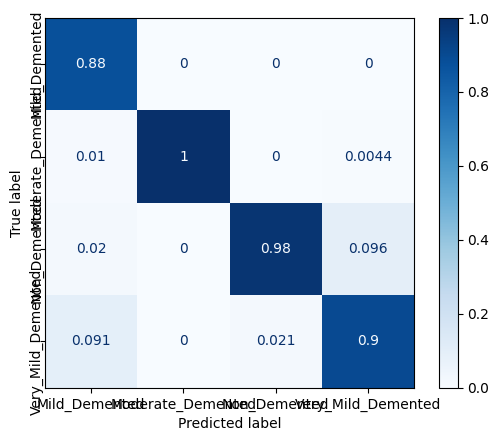

<Figure size 500x500 with 0 Axes>

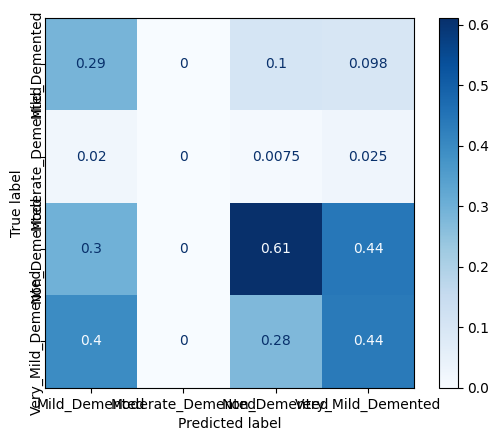

<Figure size 500x500 with 0 Axes>

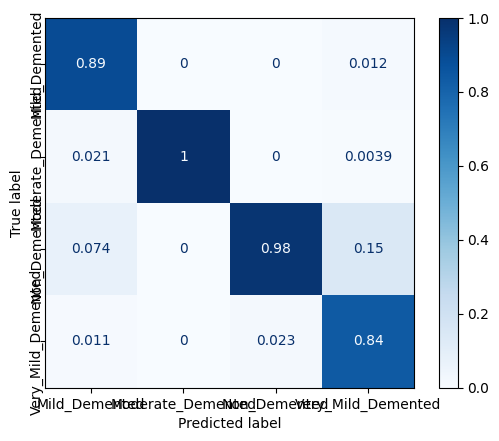

<Figure size 500x500 with 0 Axes>

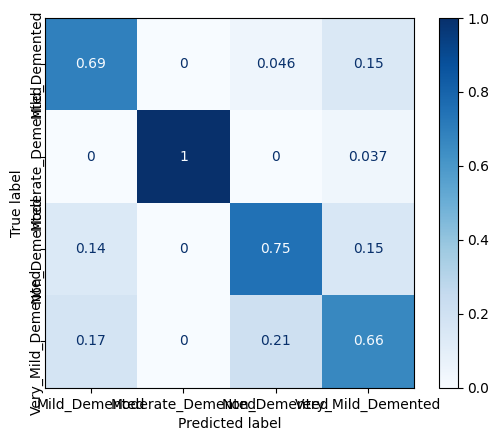

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r ResNet152.zip ./*